In [1]:
import keras
import cv2
from skimage.transform import rotate, resize, SimilarityTransform, warp
import os
import numpy as np
import random as rand
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Flatten, Dense
from keras.utils.training_utils import multi_gpu_model
%matplotlib inline

c:\users\vincenzo\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# We define in advance constants to build the model

INPUT_SHAPE = (96, 96, 3)
IM_HEIGHT = 96
IM_WIDTH = 96
OUTPUT_SIZE = 2

LEARNING_RATE = 0.01
OPTIMIZER = keras.optimizers.Adam()
LOSS = 'binary_crossentropy'
METRIC = 'accuracy'

SL_TRAIN_SIZE = 50121
SL_VALIDATION_SIZE = 12531
EPOCHS = 10
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 50
STEPS_PER_EPOCH = (2 * SL_TRAIN_SIZE) // BATCH_SIZE + 1
VALIDATION_STEPS_PER_EPOCH = (2 * SL_VALIDATION_SIZE) // BATCH_SIZE + 1

TRAIN_PATH = "./data_set/train/"
VALIDATION_PATH = "./data_set/validation/"
TEST_PATH = "./data_set/test/"

MODEL_PATH = "./binary_classifier/net_1_model.json"
WEIGHTS_PATH = "./binary_classifier/net_1_weights.h5"

In [3]:
def transform_image(img):
    # trasformazioni da implementare rotate, flip, shift, zoom
    sel = [0, 1]
    offset = 72
    bound = (72 - 48) / 2
    t_img = np.array(img)
    if rand.choice(sel):
        # rotate
        angle = rand.uniform(0, 360)
        t_img = rotate(t_img, angle, mode='edge')
    if rand.choice(sel):
        # flip
        if rand.choice(sel):
            t_img = np.flipud(t_img)
        if rand.choice(sel):
            t_img = np.fliplr(t_img)
    if rand.choice(sel):
        tform = SimilarityTransform(translation=(int(rand.uniform(-bound, bound)), int(rand.uniform(-bound, bound))))
        t_img = warp(t_img, tform)
    if rand.choice(sel):
        # zoom
        zoom = int(rand.uniform(-bound, bound))
        t_img = resize(t_img[offset-48-zoom:offset+48+zoom, offset-48-zoom:offset+48+zoom, :], (96, 96))
        return t_img.tolist()
    # Cut 96x96 patch
    t_img = t_img[offset-48:offset+48, offset-48:offset+48, :]
    return t_img.tolist()

In [4]:
# Sea lions patches extractor
def extract_sea_lion_patch(path, epoch, n_epochs):
    img = cv2.imread(path)
    if rand.uniform(0.0, 1.0) < (epoch/n_epochs):
        # Perform transformation
        return transform_image(img)
    patch = img[72-48:72+48, 72-48:72+48, :]
    return patch

In [5]:
def train_generator(epoch_tot, batch_size):
    sl_lst_tmp = os.listdir(TRAIN_PATH + 'sea_lions')
    sl_lst = []
    for elem in sl_lst_tmp:
        sl_lst.append(list((elem, 'sea_lion')))
    bkg_lst_tmp = os.listdir(TRAIN_PATH + 'background')
    for curr_epoch in range(epoch_tot):
        bkg_lst = []
        for elem in rand.sample(bkg_lst_tmp, SL_TRAIN_SIZE):
            bkg_lst.append(list((elem, 'background')))
        lst = sl_lst + bkg_lst
        rand.shuffle(lst)
        patches = []
        classes = []
        curr_batch_size = 0
        for elem in lst:
            if elem[1] == 'background':
                img = cv2.imread(TRAIN_PATH + 'background/' + elem[0])
                patches.append(img)
                classes.append([0, 1])
            else:
                patches.append(extract_sea_lion_patch(TRAIN_PATH + 'sea_lions/' + elem[0], curr_epoch, epoch_tot))
                classes.append([1, 0])
            curr_batch_size += 1
            if curr_batch_size == batch_size:
                X_train = np.array(patches)
                X_train = X_train.astype('float32')
                X_train /= 255
                Y_train = np.array(classes)
                curr_batch_size = 0
                patches = []
                classes = []
                yield X_train, Y_train
        if len(patches) > 0:
            X_train = np.array(patches)
            X_train = X_train.astype('float32')
            X_train /= 255
            Y_train = np.array(classes)
            yield X_train, Y_train
        print("end epoch" + str(curr_epoch + 1))

In [6]:
X_validation = []
Y_validation = []
validation_set = []
lst = os.listdir(VALIDATION_PATH + 'sea_lions')
for elem in lst:
    validation_set.append(list((cv2.imread(VALIDATION_PATH + 'sea_lions/' + elem), 'sea_lion')))
lst = os.listdir(VALIDATION_PATH + 'background')
for elem in lst:
    validation_set.append(list((cv2.imread(VALIDATION_PATH + 'background/' + elem), 'background')))
rand.shuffle(validation_set)
for data in validation_set:
    X_validation.append(data[0])
    if data[1] == 'sea_lion':
        Y_validation.append([1, 0])
    else:
        Y_validation.append([0, 1])
X_validation = np.array(X_validation, copy=False)
Y_validation = np.array(Y_validation, copy=False)

# Free memory
lst = []
validation_set = []

# Convert data types and normalize values
X_validation = X_validation.astype('float32')
X_validation /= 255


In [7]:
# Build parallel model (multi gpu)

model = Sequential()
# First layer
model.add(Convolution2D(8, (5, 5), activation='relu', padding='valid', input_shape=INPUT_SHAPE))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second layer
model.add(Convolution2D(5, (3, 3), activation='relu', padding='valid'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third layer
model.add(Convolution2D(5, (3, 3), activation='relu', padding='valid'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fourth layer
model.add(Convolution2D(10, (3, 3), activation='relu', padding='valid'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(OUTPUT_SIZE, activation='softmax'))

parallel_model = multi_gpu_model(model, gpus=2)
parallel_model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=[METRIC])

In [8]:
# Train (multi gpu)

# Fit model on training data
history = parallel_model.fit_generator( 
    train_generator(EPOCHS, BATCH_SIZE),
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    verbose=1,
    validation_data=(X_validation, Y_validation),
    validation_steps=VALIDATION_STEPS_PER_EPOCH,
    workers=8,
    max_queue_size=50)

Epoch 1/10


   1/2005 [..............................] - ETA: 1:38:38 - loss: 0.6905 - acc: 0.4800

   4/2005 [..............................] - ETA: 25:16 - loss: 0.6890 - acc: 0.4850  

   6/2005 [..............................] - ETA: 17:10 - loss: 0.6864 - acc: 0.4867

   7/2005 [..............................] - ETA: 16:12 - loss: 0.6865 - acc: 0.4829

   8/2005 [..............................] - ETA: 15:39 - loss: 0.6858 - acc: 0.4800

   9/2005 [..............................] - ETA: 15:07 - loss: 0.6867 - acc: 0.4667

  10/2005 [..............................] - ETA: 14:39 - loss: 0.6864 - acc: 0.4720

  11/2005 [..............................] - ETA: 14:08 - loss: 0.6854 - acc: 0.4818

  12/2005 [..............................] - ETA: 13:38 - loss: 0.6846 - acc: 0.4867

  13/2005 [..............................] - ETA: 13:07 - loss: 0.6826 - acc: 0.5062

  14/2005 [..............................] - ETA: 12:59 - loss: 0.6832 - acc: 0.5029

  15/2005 [..............................] - ETA: 12:26 - loss: 0.6805 - acc: 0.5187

  16/2005 [..............................] - ETA: 12:10 - loss: 0.6799 - acc: 0.5213

  17/2005 [..............................] - ETA: 12:02 - loss: 0.6794 - acc: 0.5212

  18/2005 [..............................] - ETA: 12:00 - loss: 0.6796 - acc: 0.5200

  19/2005 [..............................] - ETA: 11:48 - loss: 0.6788 - acc: 0.5211

  20/2005 [..............................] - ETA: 11:45 - loss: 0.6788 - acc: 0.5180

  21/2005 [..............................] - ETA: 11:33 - loss: 0.6772 - acc: 0.5210

  22/2005 [..............................] - ETA: 11:20 - loss: 0.6753 - acc: 0.5264

  23/2005 [..............................] - ETA: 11:13 - loss: 0.6737 - acc: 0.5261

  24/2005 [..............................] - ETA: 11:07 - loss: 0.6722 - acc: 0.5292

  25/2005 [..............................] - ETA: 10:59 - loss: 0.6705 - acc: 0.5328

  26/2005 [..............................] - ETA: 10:52 - loss: 0.6678 - acc: 0.5400

  27/2005 [..............................] - ETA: 10:45 - loss: 0.6663 - acc: 0.5415

  28/2005 [..............................] - ETA: 10:39 - loss: 0.6647 - acc: 0.5429

  29/2005 [..............................] - ETA: 10:34 - loss: 0.6611 - acc: 0.5497

  30/2005 [..............................] - ETA: 10:27 - loss: 0.6572 - acc: 0.5567

  31/2005 [..............................] - ETA: 10:25 - loss: 0.6552 - acc: 0.5594

  32/2005 [..............................] - ETA: 10:24 - loss: 0.6546 - acc: 0.5619

  33/2005 [..............................] - ETA: 10:24 - loss: 0.6533 - acc: 0.5648

  34/2005 [..............................] - ETA: 10:18 - loss: 0.6513 - acc: 0.5712

  35/2005 [..............................] - ETA: 10:14 - loss: 0.6493 - acc: 0.5806

  36/2005 [..............................] - ETA: 10:11 - loss: 0.6463 - acc: 0.5900

  37/2005 [..............................] - ETA: 10:11 - loss: 0.6434 - acc: 0.5973



  38/2005 [..............................] - ETA: 10:05 - loss: 0.6387 - acc: 0.6032

  39/2005 [..............................] - ETA: 10:00 - loss: 0.6370 - acc: 0.6051

  40/2005 [..............................] - ETA: 9:59 - loss: 0.6357 - acc: 0.6080 

  41/2005 [..............................] - ETA: 9:58 - loss: 0.6354 - acc: 0.6098

  42/2005 [..............................] - ETA: 9:56 - loss: 0.6315 - acc: 0.6152

  43/2005 [..............................] - ETA: 9:57 - loss: 0.6285 - acc: 0.6214

  44/2005 [..............................] - ETA: 9:55 - loss: 0.6262 - acc: 0.6250

  45/2005 [..............................] - ETA: 9:54 - loss: 0.6246 - acc: 0.6258

  46/2005 [..............................] - ETA: 9:53 - loss: 0.6214 - acc: 0.6309

  47/2005 [..............................] - ETA: 9:56 - loss: 0.6172 - acc: 0.6353

  48/2005 [..............................] - ETA: 9:54 - loss: 0.6135 - acc: 0.6383

  49/2005 [..............................] - ETA: 9:50 - loss: 0.6133 - acc: 0.6408

  50/2005 [..............................] - ETA: 9:47 - loss: 0.6077 - acc: 0.6456

  51/2005 [..............................] - ETA: 9:43 - loss: 0.6040 - acc: 0.6490

  52/2005 [..............................] - ETA: 9:42 - loss: 0.6014 - acc: 0.6519

  53/2005 [..............................] - ETA: 9:42 - loss: 0.5987 - acc: 0.6543

  54/2005 [..............................] - ETA: 9:43 - loss: 0.5945 - acc: 0.6585

  55/2005 [..............................] - ETA: 9:44 - loss: 0.5893 - acc: 0.6633

  56/2005 [..............................] - ETA: 9:44 - loss: 0.5882 - acc: 0.6646

  57/2005 [..............................] - ETA: 9:41 - loss: 0.5857 - acc: 0.6674

  58/2005 [..............................] - ETA: 9:41 - loss: 0.5844 - acc: 0.6686

  59/2005 [..............................] - ETA: 9:38 - loss: 0.5787 - acc: 0.6725

  60/2005 [..............................] - ETA: 9:38 - loss: 0.5745 - acc: 0.6753

  61/2005 [..............................] - ETA: 9:35 - loss: 0.5691 - acc: 0.6793

  62/2005 [..............................] - ETA: 9:33 - loss: 0.5653 - acc: 0.6819

  63/2005 [..............................] - ETA: 9:31 - loss: 0.5608 - acc: 0.6857

  64/2005 [..............................] - ETA: 9:30 - loss: 0.5566 - acc: 0.6884

  65/2005 [..............................] - ETA: 9:30 - loss: 0.5557 - acc: 0.6908

  66/2005 [..............................] - ETA: 9:30 - loss: 0.5524 - acc: 0.6930

  67/2005 [>.............................] - ETA: 9:29 - loss: 0.5481 - acc: 0.6961

  68/2005 [>.............................] - ETA: 9:28 - loss: 0.5447 - acc: 0.6985

  69/2005 [>.............................] - ETA: 9:27 - loss: 0.5413 - acc: 0.7012

  70/2005 [>.............................] - ETA: 9:27 - loss: 0.5389 - acc: 0.7037

  71/2005 [>.............................] - ETA: 9:26 - loss: 0.5384 - acc: 0.7054

  72/2005 [>.............................] - ETA: 9:26 - loss: 0.5356 - acc: 0.7081

  73/2005 [>.............................] - ETA: 9:24 - loss: 0.5343 - acc: 0.7099

  74/2005 [>.............................] - ETA: 9:23 - loss: 0.5311 - acc: 0.7119

  75/2005 [>.............................] - ETA: 9:23 - loss: 0.5265 - acc: 0.7149

  76/2005 [>.............................] - ETA: 9:23 - loss: 0.5264 - acc: 0.7153

  77/2005 [>.............................] - ETA: 9:23 - loss: 0.5241 - acc: 0.7166

  78/2005 [>.............................] - ETA: 9:21 - loss: 0.5225 - acc: 0.7182

  79/2005 [>.............................] - ETA: 9:19 - loss: 0.5206 - acc: 0.7195

  80/2005 [>.............................] - ETA: 9:18 - loss: 0.5180 - acc: 0.7215

  81/2005 [>.............................] - ETA: 9:17 - loss: 0.5169 - acc: 0.7230

  82/2005 [>.............................] - ETA: 9:17 - loss: 0.5132 - acc: 0.7254

  83/2005 [>.............................] - ETA: 9:16 - loss: 0.5101 - acc: 0.7277

  84/2005 [>.............................] - ETA: 9:16 - loss: 0.5070 - acc: 0.7302

  85/2005 [>.............................] - ETA: 9:15 - loss: 0.5063 - acc: 0.7313

  86/2005 [>.............................] - ETA: 9:15 - loss: 0.5035 - acc: 0.7337

  87/2005 [>.............................] - ETA: 9:13 - loss: 0.5031 - acc: 0.7345

  88/2005 [>.............................] - ETA: 9:13 - loss: 0.5022 - acc: 0.7350

  89/2005 [>.............................] - ETA: 9:14 - loss: 0.5011 - acc: 0.7357

  90/2005 [>.............................] - ETA: 9:14 - loss: 0.4992 - acc: 0.7373

  91/2005 [>.............................] - ETA: 9:16 - loss: 0.4973 - acc: 0.7385

  92/2005 [>.............................] - ETA: 9:16 - loss: 0.4952 - acc: 0.7396

  93/2005 [>.............................] - ETA: 9:15 - loss: 0.4949 - acc: 0.7398

  94/2005 [>.............................] - ETA: 9:14 - loss: 0.4950 - acc: 0.7402

  95/2005 [>.............................] - ETA: 9:12 - loss: 0.4926 - acc: 0.7421

  96/2005 [>.............................] - ETA: 9:10 - loss: 0.4921 - acc: 0.7431

  97/2005 [>.............................] - ETA: 9:11 - loss: 0.4915 - acc: 0.7435

  98/2005 [>.............................] - ETA: 9:11 - loss: 0.4900 - acc: 0.7441

  99/2005 [>.............................] - ETA: 9:10 - loss: 0.4885 - acc: 0.7457

 100/2005 [>.............................] - ETA: 9:10 - loss: 0.4861 - acc: 0.7474

 101/2005 [>.............................] - ETA: 9:11 - loss: 0.4848 - acc: 0.7483

 102/2005 [>.............................] - ETA: 9:11 - loss: 0.4842 - acc: 0.7492

 103/2005 [>.............................] - ETA: 9:10 - loss: 0.4857 - acc: 0.7487

 104/2005 [>.............................] - ETA: 9:11 - loss: 0.4841 - acc: 0.7496

 105/2005 [>.............................] - ETA: 9:10 - loss: 0.4832 - acc: 0.7503

 106/2005 [>.............................] - ETA: 9:09 - loss: 0.4820 - acc: 0.7513

 107/2005 [>.............................] - ETA: 9:08 - loss: 0.4808 - acc: 0.7527

 108/2005 [>.............................] - ETA: 9:06 - loss: 0.4795 - acc: 0.7537

 109/2005 [>.............................] - ETA: 9:06 - loss: 0.4790 - acc: 0.7547

 110/2005 [>.............................] - ETA: 9:04 - loss: 0.4791 - acc: 0.7553

 111/2005 [>.............................] - ETA: 9:03 - loss: 0.4775 - acc: 0.7564

 112/2005 [>.............................] - ETA: 9:02 - loss: 0.4755 - acc: 0.7579

 113/2005 [>.............................] - ETA: 9:02 - loss: 0.4743 - acc: 0.7588

 114/2005 [>.............................] - ETA: 9:02 - loss: 0.4731 - acc: 0.7596

 115/2005 [>.............................] - ETA: 9:01 - loss: 0.4726 - acc: 0.7603

 116/2005 [>.............................] - ETA: 9:01 - loss: 0.4737 - acc: 0.7600



 117/2005 [>.............................] - ETA: 8:59 - loss: 0.4722 - acc: 0.7609

 118/2005 [>.............................] - ETA: 8:59 - loss: 0.4717 - acc: 0.7614

 119/2005 [>.............................] - ETA: 8:59 - loss: 0.4712 - acc: 0.7618

 120/2005 [>.............................] - ETA: 9:00 - loss: 0.4715 - acc: 0.7625

 121/2005 [>.............................] - ETA: 8:59 - loss: 0.4706 - acc: 0.7631

 122/2005 [>.............................] - ETA: 8:58 - loss: 0.4702 - acc: 0.7636

 123/2005 [>.............................] - ETA: 8:58 - loss: 0.4679 - acc: 0.7650

 124/2005 [>.............................] - ETA: 8:58 - loss: 0.4665 - acc: 0.7661

 125/2005 [>.............................] - ETA: 8:58 - loss: 0.4650 - acc: 0.7670

 126/2005 [>.............................] - ETA: 8:57 - loss: 0.4638 - acc: 0.7679

 127/2005 [>.............................] - ETA: 8:59 - loss: 0.4627 - acc: 0.7688

 128/2005 [>.............................] - ETA: 8:58 - loss: 0.4619 - acc: 0.7694

 129/2005 [>.............................] - ETA: 8:57 - loss: 0.4618 - acc: 0.7696

 130/2005 [>.............................] - ETA: 8:56 - loss: 0.4606 - acc: 0.7706

 131/2005 [>.............................] - ETA: 8:57 - loss: 0.4593 - acc: 0.7716

 132/2005 [>.............................] - ETA: 8:57 - loss: 0.4585 - acc: 0.7724

 133/2005 [>.............................] - ETA: 8:56 - loss: 0.4573 - acc: 0.7734

 134/2005 [=>............................] - ETA: 8:55 - loss: 0.4570 - acc: 0.7731

 135/2005 [=>............................] - ETA: 8:54 - loss: 0.4552 - acc: 0.7741

 136/2005 [=>............................] - ETA: 8:54 - loss: 0.4545 - acc: 0.7746

 137/2005 [=>............................] - ETA: 8:53 - loss: 0.4534 - acc: 0.7749

 138/2005 [=>............................] - ETA: 8:53 - loss: 0.4524 - acc: 0.7755

 139/2005 [=>............................] - ETA: 8:53 - loss: 0.4519 - acc: 0.7761

 140/2005 [=>............................] - ETA: 8:53 - loss: 0.4527 - acc: 0.7760

 141/2005 [=>............................] - ETA: 8:52 - loss: 0.4527 - acc: 0.7757

 142/2005 [=>............................] - ETA: 8:51 - loss: 0.4518 - acc: 0.7768

 143/2005 [=>............................] - ETA: 8:51 - loss: 0.4505 - acc: 0.7776

 144/2005 [=>............................] - ETA: 8:51 - loss: 0.4491 - acc: 0.7786

 145/2005 [=>............................] - ETA: 8:51 - loss: 0.4481 - acc: 0.7794

 146/2005 [=>............................] - ETA: 8:50 - loss: 0.4485 - acc: 0.7796

 147/2005 [=>............................] - ETA: 8:50 - loss: 0.4476 - acc: 0.7804

 148/2005 [=>............................] - ETA: 8:49 - loss: 0.4465 - acc: 0.7805

 149/2005 [=>............................] - ETA: 8:49 - loss: 0.4459 - acc: 0.7812

 150/2005 [=>............................] - ETA: 8:49 - loss: 0.4446 - acc: 0.7821

 151/2005 [=>............................] - ETA: 8:49 - loss: 0.4442 - acc: 0.7824

 152/2005 [=>............................] - ETA: 8:48 - loss: 0.4434 - acc: 0.7829

 153/2005 [=>............................] - ETA: 8:48 - loss: 0.4422 - acc: 0.7835

 154/2005 [=>............................] - ETA: 8:47 - loss: 0.4417 - acc: 0.7836



 155/2005 [=>............................] - ETA: 8:45 - loss: 0.4415 - acc: 0.7840

 156/2005 [=>............................] - ETA: 8:45 - loss: 0.4407 - acc: 0.7847

 157/2005 [=>............................] - ETA: 8:44 - loss: 0.4391 - acc: 0.7860

 158/2005 [=>............................] - ETA: 8:44 - loss: 0.4385 - acc: 0.7863

 159/2005 [=>............................] - ETA: 8:42 - loss: 0.4374 - acc: 0.7870

 160/2005 [=>............................] - ETA: 8:42 - loss: 0.4363 - acc: 0.7877

 161/2005 [=>............................] - ETA: 8:42 - loss: 0.4358 - acc: 0.7882

 162/2005 [=>............................] - ETA: 8:42 - loss: 0.4351 - acc: 0.7888

 163/2005 [=>............................] - ETA: 8:41 - loss: 0.4342 - acc: 0.7893

 164/2005 [=>............................] - ETA: 8:41 - loss: 0.4334 - acc: 0.7899

 165/2005 [=>............................] - ETA: 8:42 - loss: 0.4323 - acc: 0.7903

 166/2005 [=>............................] - ETA: 8:41 - loss: 0.4323 - acc: 0.7905

 167/2005 [=>............................] - ETA: 8:40 - loss: 0.4323 - acc: 0.7907

 168/2005 [=>............................] - ETA: 8:40 - loss: 0.4327 - acc: 0.7907

 169/2005 [=>............................] - ETA: 8:39 - loss: 0.4319 - acc: 0.7914

 170/2005 [=>............................] - ETA: 8:39 - loss: 0.4315 - acc: 0.7916

 171/2005 [=>............................] - ETA: 8:38 - loss: 0.4311 - acc: 0.7922

 172/2005 [=>............................] - ETA: 8:38 - loss: 0.4304 - acc: 0.7927

 173/2005 [=>............................] - ETA: 8:38 - loss: 0.4294 - acc: 0.7934

 174/2005 [=>............................] - ETA: 8:38 - loss: 0.4285 - acc: 0.7940

 175/2005 [=>............................] - ETA: 8:38 - loss: 0.4280 - acc: 0.7943

 176/2005 [=>............................] - ETA: 8:37 - loss: 0.4281 - acc: 0.7945

 177/2005 [=>............................] - ETA: 8:36 - loss: 0.4274 - acc: 0.7950

 178/2005 [=>............................] - ETA: 8:35 - loss: 0.4263 - acc: 0.7956

 179/2005 [=>............................] - ETA: 8:35 - loss: 0.4259 - acc: 0.7960

 180/2005 [=>............................] - ETA: 8:34 - loss: 0.4252 - acc: 0.7966

 181/2005 [=>............................] - ETA: 8:34 - loss: 0.4247 - acc: 0.7970

 182/2005 [=>............................] - ETA: 8:34 - loss: 0.4243 - acc: 0.7974

 183/2005 [=>............................] - ETA: 8:34 - loss: 0.4244 - acc: 0.7975

 184/2005 [=>............................] - ETA: 8:34 - loss: 0.4247 - acc: 0.7974

 185/2005 [=>............................] - ETA: 8:34 - loss: 0.4237 - acc: 0.7982



 186/2005 [=>............................] - ETA: 8:33 - loss: 0.4235 - acc: 0.7984

 187/2005 [=>............................] - ETA: 8:32 - loss: 0.4234 - acc: 0.7986

 188/2005 [=>............................] - ETA: 8:31 - loss: 0.4230 - acc: 0.7987

 189/2005 [=>............................] - ETA: 8:31 - loss: 0.4220 - acc: 0.7992

 190/2005 [=>............................] - ETA: 8:32 - loss: 0.4211 - acc: 0.7997

 191/2005 [=>............................] - ETA: 8:31 - loss: 0.4203 - acc: 0.8002

 192/2005 [=>............................] - ETA: 8:31 - loss: 0.4203 - acc: 0.8005

 193/2005 [=>............................] - ETA: 8:31 - loss: 0.4195 - acc: 0.8008

 194/2005 [=>............................] - ETA: 8:30 - loss: 0.4196 - acc: 0.8009

 195/2005 [=>............................] - ETA: 8:29 - loss: 0.4191 - acc: 0.8013

 196/2005 [=>............................] - ETA: 8:29 - loss: 0.4187 - acc: 0.8015

 197/2005 [=>............................] - ETA: 8:28 - loss: 0.4183 - acc: 0.8019

 198/2005 [=>............................] - ETA: 8:27 - loss: 0.4187 - acc: 0.8016

 199/2005 [=>............................] - ETA: 8:27 - loss: 0.4182 - acc: 0.8020

 200/2005 [=>............................] - ETA: 8:27 - loss: 0.4180 - acc: 0.8022

 201/2005 [==>...........................] - ETA: 8:26 - loss: 0.4195 - acc: 0.8016

 202/2005 [==>...........................] - ETA: 8:25 - loss: 0.4188 - acc: 0.8020

 203/2005 [==>...........................] - ETA: 8:25 - loss: 0.4190 - acc: 0.8021

 204/2005 [==>...........................] - ETA: 8:24 - loss: 0.4185 - acc: 0.8024

 205/2005 [==>...........................] - ETA: 8:24 - loss: 0.4176 - acc: 0.8030

 206/2005 [==>...........................] - ETA: 8:24 - loss: 0.4172 - acc: 0.8031

 207/2005 [==>...........................] - ETA: 8:24 - loss: 0.4179 - acc: 0.8029

 208/2005 [==>...........................] - ETA: 8:23 - loss: 0.4171 - acc: 0.8033

 209/2005 [==>...........................] - ETA: 8:23 - loss: 0.4169 - acc: 0.8034

 210/2005 [==>...........................] - ETA: 8:22 - loss: 0.4163 - acc: 0.8038

 211/2005 [==>...........................] - ETA: 8:22 - loss: 0.4159 - acc: 0.8041

 212/2005 [==>...........................] - ETA: 8:21 - loss: 0.4158 - acc: 0.8040

 213/2005 [==>...........................] - ETA: 8:20 - loss: 0.4153 - acc: 0.8043

 214/2005 [==>...........................] - ETA: 8:20 - loss: 0.4152 - acc: 0.8046

 215/2005 [==>...........................] - ETA: 8:20 - loss: 0.4155 - acc: 0.8046

 216/2005 [==>...........................] - ETA: 8:19 - loss: 0.4147 - acc: 0.8050

 217/2005 [==>...........................] - ETA: 8:19 - loss: 0.4138 - acc: 0.8055

 218/2005 [==>...........................] - ETA: 8:18 - loss: 0.4133 - acc: 0.8059

 219/2005 [==>...........................] - ETA: 8:18 - loss: 0.4129 - acc: 0.8060

 220/2005 [==>...........................] - ETA: 8:18 - loss: 0.4127 - acc: 0.8061

 221/2005 [==>...........................] - ETA: 8:17 - loss: 0.4124 - acc: 0.8064

 222/2005 [==>...........................] - ETA: 8:17 - loss: 0.4116 - acc: 0.8068

 223/2005 [==>...........................] - ETA: 8:17 - loss: 0.4114 - acc: 0.8070

 224/2005 [==>...........................] - ETA: 8:17 - loss: 0.4117 - acc: 0.8068

 225/2005 [==>...........................] - ETA: 8:17 - loss: 0.4115 - acc: 0.8068

 226/2005 [==>...........................] - ETA: 8:17 - loss: 0.4111 - acc: 0.8071

 227/2005 [==>...........................] - ETA: 8:17 - loss: 0.4110 - acc: 0.8070

 228/2005 [==>...........................] - ETA: 8:17 - loss: 0.4103 - acc: 0.8075

 229/2005 [==>...........................] - ETA: 8:17 - loss: 0.4096 - acc: 0.8079

 230/2005 [==>...........................] - ETA: 8:16 - loss: 0.4095 - acc: 0.8079

 231/2005 [==>...........................] - ETA: 8:16 - loss: 0.4090 - acc: 0.8084

 232/2005 [==>...........................] - ETA: 8:16 - loss: 0.4087 - acc: 0.8085

 233/2005 [==>...........................] - ETA: 8:15 - loss: 0.4082 - acc: 0.8089

 234/2005 [==>...........................] - ETA: 8:14 - loss: 0.4079 - acc: 0.8090

 235/2005 [==>...........................] - ETA: 8:14 - loss: 0.4077 - acc: 0.8091

 236/2005 [==>...........................] - ETA: 8:14 - loss: 0.4072 - acc: 0.8095

 237/2005 [==>...........................] - ETA: 8:14 - loss: 0.4076 - acc: 0.8094

 238/2005 [==>...........................] - ETA: 8:13 - loss: 0.4071 - acc: 0.8099

 239/2005 [==>...........................] - ETA: 8:12 - loss: 0.4065 - acc: 0.8103

 240/2005 [==>...........................] - ETA: 8:12 - loss: 0.4056 - acc: 0.8108

 241/2005 [==>...........................] - ETA: 8:12 - loss: 0.4046 - acc: 0.8115

 242/2005 [==>...........................] - ETA: 8:11 - loss: 0.4045 - acc: 0.8116

 243/2005 [==>...........................] - ETA: 8:11 - loss: 0.4042 - acc: 0.8119

 244/2005 [==>...........................] - ETA: 8:10 - loss: 0.4034 - acc: 0.8124

 245/2005 [==>...........................] - ETA: 8:10 - loss: 0.4033 - acc: 0.8122

 246/2005 [==>...........................] - ETA: 8:09 - loss: 0.4023 - acc: 0.8128

 247/2005 [==>...........................] - ETA: 8:09 - loss: 0.4019 - acc: 0.8132

 248/2005 [==>...........................] - ETA: 8:08 - loss: 0.4009 - acc: 0.8138

 249/2005 [==>...........................] - ETA: 8:08 - loss: 0.4004 - acc: 0.8141

 250/2005 [==>...........................] - ETA: 8:07 - loss: 0.4005 - acc: 0.8143

 251/2005 [==>...........................] - ETA: 8:07 - loss: 0.4000 - acc: 0.8147

 252/2005 [==>...........................] - ETA: 8:07 - loss: 0.3992 - acc: 0.8150

 253/2005 [==>...........................] - ETA: 8:06 - loss: 0.3984 - acc: 0.8155

 254/2005 [==>...........................] - ETA: 8:06 - loss: 0.3982 - acc: 0.8156

 255/2005 [==>...........................] - ETA: 8:06 - loss: 0.3979 - acc: 0.8158

 256/2005 [==>...........................] - ETA: 8:06 - loss: 0.3974 - acc: 0.8161

 257/2005 [==>...........................] - ETA: 8:06 - loss: 0.3971 - acc: 0.8161

 258/2005 [==>...........................] - ETA: 8:05 - loss: 0.3965 - acc: 0.8166

 259/2005 [==>...........................] - ETA: 8:05 - loss: 0.3969 - acc: 0.8164

 260/2005 [==>...........................] - ETA: 8:05 - loss: 0.3969 - acc: 0.8165

 261/2005 [==>...........................] - ETA: 8:05 - loss: 0.3966 - acc: 0.8168

 262/2005 [==>...........................] - ETA: 8:04 - loss: 0.3960 - acc: 0.8171

 263/2005 [==>...........................] - ETA: 8:03 - loss: 0.3954 - acc: 0.8176

 264/2005 [==>...........................] - ETA: 8:03 - loss: 0.3952 - acc: 0.8178

 265/2005 [==>...........................] - ETA: 8:02 - loss: 0.3950 - acc: 0.8179

 266/2005 [==>...........................] - ETA: 8:02 - loss: 0.3953 - acc: 0.8180

 267/2005 [==>...........................] - ETA: 8:02 - loss: 0.3948 - acc: 0.8183

 268/2005 [===>..........................] - ETA: 8:02 - loss: 0.3948 - acc: 0.8184

 269/2005 [===>..........................] - ETA: 8:01 - loss: 0.3942 - acc: 0.8185

 270/2005 [===>..........................] - ETA: 8:01 - loss: 0.3935 - acc: 0.8188

 271/2005 [===>..........................] - ETA: 8:01 - loss: 0.3935 - acc: 0.8190

 272/2005 [===>..........................] - ETA: 8:00 - loss: 0.3935 - acc: 0.8191

 273/2005 [===>..........................] - ETA: 8:01 - loss: 0.3936 - acc: 0.8191

 274/2005 [===>..........................] - ETA: 8:00 - loss: 0.3934 - acc: 0.8193

 275/2005 [===>..........................] - ETA: 8:00 - loss: 0.3932 - acc: 0.8195

 276/2005 [===>..........................] - ETA: 8:00 - loss: 0.3932 - acc: 0.8196

 277/2005 [===>..........................] - ETA: 7:59 - loss: 0.3928 - acc: 0.8198

 278/2005 [===>..........................] - ETA: 7:58 - loss: 0.3927 - acc: 0.8199

 279/2005 [===>..........................] - ETA: 7:58 - loss: 0.3926 - acc: 0.8199

 280/2005 [===>..........................] - ETA: 7:58 - loss: 0.3923 - acc: 0.8200

 281/2005 [===>..........................] - ETA: 7:58 - loss: 0.3915 - acc: 0.8204

 282/2005 [===>..........................] - ETA: 7:57 - loss: 0.3908 - acc: 0.8208

 283/2005 [===>..........................] - ETA: 7:57 - loss: 0.3906 - acc: 0.8209

 284/2005 [===>..........................] - ETA: 7:57 - loss: 0.3903 - acc: 0.8211

 285/2005 [===>..........................] - ETA: 7:57 - loss: 0.3899 - acc: 0.8213

 286/2005 [===>..........................] - ETA: 7:57 - loss: 0.3894 - acc: 0.8216

 287/2005 [===>..........................] - ETA: 7:56 - loss: 0.3887 - acc: 0.8220

 288/2005 [===>..........................] - ETA: 7:55 - loss: 0.3882 - acc: 0.8223

 289/2005 [===>..........................] - ETA: 7:55 - loss: 0.3879 - acc: 0.8224

 290/2005 [===>..........................] - ETA: 7:54 - loss: 0.3876 - acc: 0.8224

 291/2005 [===>..........................] - ETA: 7:54 - loss: 0.3880 - acc: 0.8224

 292/2005 [===>..........................] - ETA: 7:54 - loss: 0.3875 - acc: 0.8226

 293/2005 [===>..........................] - ETA: 7:54 - loss: 0.3872 - acc: 0.8227

 294/2005 [===>..........................] - ETA: 7:54 - loss: 0.3867 - acc: 0.8232

 295/2005 [===>..........................] - ETA: 7:53 - loss: 0.3866 - acc: 0.8233

 296/2005 [===>..........................] - ETA: 7:52 - loss: 0.3863 - acc: 0.8234

 297/2005 [===>..........................] - ETA: 7:52 - loss: 0.3861 - acc: 0.8234

 298/2005 [===>..........................] - ETA: 7:51 - loss: 0.3855 - acc: 0.8236

 299/2005 [===>..........................] - ETA: 7:51 - loss: 0.3854 - acc: 0.8235

 300/2005 [===>..........................] - ETA: 7:51 - loss: 0.3851 - acc: 0.8239

 301/2005 [===>..........................] - ETA: 7:50 - loss: 0.3852 - acc: 0.8238

 302/2005 [===>..........................] - ETA: 7:50 - loss: 0.3851 - acc: 0.8238

 303/2005 [===>..........................] - ETA: 7:50 - loss: 0.3856 - acc: 0.8238

 304/2005 [===>..........................] - ETA: 7:49 - loss: 0.3851 - acc: 0.8241

 305/2005 [===>..........................] - ETA: 7:49 - loss: 0.3850 - acc: 0.8241

 306/2005 [===>..........................] - ETA: 7:49 - loss: 0.3850 - acc: 0.8241

 307/2005 [===>..........................] - ETA: 7:49 - loss: 0.3845 - acc: 0.8244

 308/2005 [===>..........................] - ETA: 7:49 - loss: 0.3845 - acc: 0.8245

 309/2005 [===>..........................] - ETA: 7:49 - loss: 0.3843 - acc: 0.8246

 310/2005 [===>..........................] - ETA: 7:48 - loss: 0.3837 - acc: 0.8249

 311/2005 [===>..........................] - ETA: 7:48 - loss: 0.3832 - acc: 0.8252

 312/2005 [===>..........................] - ETA: 7:47 - loss: 0.3829 - acc: 0.8254

 313/2005 [===>..........................] - ETA: 7:47 - loss: 0.3828 - acc: 0.8254

 314/2005 [===>..........................] - ETA: 7:47 - loss: 0.3823 - acc: 0.8257

 315/2005 [===>..........................] - ETA: 7:46 - loss: 0.3821 - acc: 0.8257

 316/2005 [===>..........................] - ETA: 7:46 - loss: 0.3816 - acc: 0.8260

 317/2005 [===>..........................] - ETA: 7:46 - loss: 0.3815 - acc: 0.8261

 318/2005 [===>..........................] - ETA: 7:45 - loss: 0.3812 - acc: 0.8263

 319/2005 [===>..........................] - ETA: 7:45 - loss: 0.3806 - acc: 0.8267

 320/2005 [===>..........................] - ETA: 7:44 - loss: 0.3805 - acc: 0.8270

 321/2005 [===>..........................] - ETA: 7:44 - loss: 0.3804 - acc: 0.8270

 322/2005 [===>..........................] - ETA: 7:44 - loss: 0.3804 - acc: 0.8270

 323/2005 [===>..........................] - ETA: 7:43 - loss: 0.3802 - acc: 0.8269

 324/2005 [===>..........................] - ETA: 7:43 - loss: 0.3803 - acc: 0.8269

 325/2005 [===>..........................] - ETA: 7:43 - loss: 0.3802 - acc: 0.8270

 326/2005 [===>..........................] - ETA: 7:43 - loss: 0.3801 - acc: 0.8271

 327/2005 [===>..........................] - ETA: 7:43 - loss: 0.3800 - acc: 0.8272

 328/2005 [===>..........................] - ETA: 7:42 - loss: 0.3797 - acc: 0.8274

 329/2005 [===>..........................] - ETA: 7:41 - loss: 0.3802 - acc: 0.8274

 330/2005 [===>..........................] - ETA: 7:40 - loss: 0.3800 - acc: 0.8276

 331/2005 [===>..........................] - ETA: 7:40 - loss: 0.3799 - acc: 0.8277

 332/2005 [===>..........................] - ETA: 7:40 - loss: 0.3793 - acc: 0.8280

 333/2005 [===>..........................] - ETA: 7:40 - loss: 0.3789 - acc: 0.8282

 334/2005 [===>..........................] - ETA: 7:39 - loss: 0.3784 - acc: 0.8285

 335/2005 [====>.........................] - ETA: 7:39 - loss: 0.3783 - acc: 0.8287

 336/2005 [====>.........................] - ETA: 7:39 - loss: 0.3779 - acc: 0.8289



 337/2005 [====>.........................] - ETA: 7:38 - loss: 0.3776 - acc: 0.8291

 338/2005 [====>.........................] - ETA: 7:38 - loss: 0.3779 - acc: 0.8290

 339/2005 [====>.........................] - ETA: 7:37 - loss: 0.3777 - acc: 0.8290

 340/2005 [====>.........................] - ETA: 7:37 - loss: 0.3771 - acc: 0.8292

 341/2005 [====>.........................] - ETA: 7:37 - loss: 0.3773 - acc: 0.8291

 342/2005 [====>.........................] - ETA: 7:36 - loss: 0.3770 - acc: 0.8294

 343/2005 [====>.........................] - ETA: 7:36 - loss: 0.3764 - acc: 0.8297

 344/2005 [====>.........................] - ETA: 7:35 - loss: 0.3765 - acc: 0.8297

 345/2005 [====>.........................] - ETA: 7:35 - loss: 0.3761 - acc: 0.8299

 346/2005 [====>.........................] - ETA: 7:35 - loss: 0.3759 - acc: 0.8301

 347/2005 [====>.........................] - ETA: 7:35 - loss: 0.3761 - acc: 0.8301

 348/2005 [====>.........................] - ETA: 7:34 - loss: 0.3758 - acc: 0.8303

 349/2005 [====>.........................] - ETA: 7:33 - loss: 0.3753 - acc: 0.8307

 350/2005 [====>.........................] - ETA: 7:33 - loss: 0.3749 - acc: 0.8308

 351/2005 [====>.........................] - ETA: 7:33 - loss: 0.3749 - acc: 0.8309

 352/2005 [====>.........................] - ETA: 7:32 - loss: 0.3749 - acc: 0.8310

 353/2005 [====>.........................] - ETA: 7:32 - loss: 0.3747 - acc: 0.8311

 354/2005 [====>.........................] - ETA: 7:32 - loss: 0.3747 - acc: 0.8312

 355/2005 [====>.........................] - ETA: 7:32 - loss: 0.3741 - acc: 0.8315

 356/2005 [====>.........................] - ETA: 7:32 - loss: 0.3739 - acc: 0.8317

 357/2005 [====>.........................] - ETA: 7:31 - loss: 0.3733 - acc: 0.8320

 358/2005 [====>.........................] - ETA: 7:31 - loss: 0.3731 - acc: 0.8321

 359/2005 [====>.........................] - ETA: 7:31 - loss: 0.3730 - acc: 0.8322

 360/2005 [====>.........................] - ETA: 7:31 - loss: 0.3728 - acc: 0.8325

 361/2005 [====>.........................] - ETA: 7:31 - loss: 0.3730 - acc: 0.8324

 362/2005 [====>.........................] - ETA: 7:31 - loss: 0.3727 - acc: 0.8326

 363/2005 [====>.........................] - ETA: 7:31 - loss: 0.3724 - acc: 0.8328

 364/2005 [====>.........................] - ETA: 7:30 - loss: 0.3723 - acc: 0.8329

 365/2005 [====>.........................] - ETA: 7:30 - loss: 0.3721 - acc: 0.8329

 366/2005 [====>.........................] - ETA: 7:30 - loss: 0.3718 - acc: 0.8330

 367/2005 [====>.........................] - ETA: 7:30 - loss: 0.3718 - acc: 0.8330

 368/2005 [====>.........................] - ETA: 7:29 - loss: 0.3713 - acc: 0.8334

 369/2005 [====>.........................] - ETA: 7:29 - loss: 0.3708 - acc: 0.8337

 370/2005 [====>.........................] - ETA: 7:29 - loss: 0.3708 - acc: 0.8337

 371/2005 [====>.........................] - ETA: 7:28 - loss: 0.3707 - acc: 0.8337

 372/2005 [====>.........................] - ETA: 7:28 - loss: 0.3705 - acc: 0.8337

 373/2005 [====>.........................] - ETA: 7:27 - loss: 0.3701 - acc: 0.8339

 374/2005 [====>.........................] - ETA: 7:27 - loss: 0.3700 - acc: 0.8340

 375/2005 [====>.........................] - ETA: 7:27 - loss: 0.3697 - acc: 0.8342

 376/2005 [====>.........................] - ETA: 7:26 - loss: 0.3694 - acc: 0.8344

 377/2005 [====>.........................] - ETA: 7:26 - loss: 0.3692 - acc: 0.8345

 378/2005 [====>.........................] - ETA: 7:26 - loss: 0.3687 - acc: 0.8348

 379/2005 [====>.........................] - ETA: 7:26 - loss: 0.3691 - acc: 0.8347

 380/2005 [====>.........................] - ETA: 7:26 - loss: 0.3689 - acc: 0.8346

 381/2005 [====>.........................] - ETA: 7:26 - loss: 0.3691 - acc: 0.8345

 382/2005 [====>.........................] - ETA: 7:25 - loss: 0.3690 - acc: 0.8346

 383/2005 [====>.........................] - ETA: 7:25 - loss: 0.3686 - acc: 0.8348

 384/2005 [====>.........................] - ETA: 7:25 - loss: 0.3685 - acc: 0.8349

 385/2005 [====>.........................] - ETA: 7:24 - loss: 0.3683 - acc: 0.8351

 386/2005 [====>.........................] - ETA: 7:24 - loss: 0.3681 - acc: 0.8352

 387/2005 [====>.........................] - ETA: 7:24 - loss: 0.3679 - acc: 0.8353

 388/2005 [====>.........................] - ETA: 7:23 - loss: 0.3675 - acc: 0.8354

 389/2005 [====>.........................] - ETA: 7:23 - loss: 0.3674 - acc: 0.8354

 390/2005 [====>.........................] - ETA: 7:23 - loss: 0.3671 - acc: 0.8356

 391/2005 [====>.........................] - ETA: 7:23 - loss: 0.3668 - acc: 0.8358

 392/2005 [====>.........................] - ETA: 7:23 - loss: 0.3667 - acc: 0.8358

 393/2005 [====>.........................] - ETA: 7:23 - loss: 0.3666 - acc: 0.8359

 394/2005 [====>.........................] - ETA: 7:23 - loss: 0.3664 - acc: 0.8360

 395/2005 [====>.........................] - ETA: 7:23 - loss: 0.3663 - acc: 0.8359

 396/2005 [====>.........................] - ETA: 7:22 - loss: 0.3660 - acc: 0.8361

 397/2005 [====>.........................] - ETA: 7:21 - loss: 0.3658 - acc: 0.8362

 398/2005 [====>.........................] - ETA: 7:21 - loss: 0.3658 - acc: 0.8361

 399/2005 [====>.........................] - ETA: 7:21 - loss: 0.3656 - acc: 0.8362

 400/2005 [====>.........................] - ETA: 7:21 - loss: 0.3652 - acc: 0.8365

 401/2005 [=====>........................] - ETA: 7:21 - loss: 0.3648 - acc: 0.8367

 402/2005 [=====>........................] - ETA: 7:20 - loss: 0.3644 - acc: 0.8369

 403/2005 [=====>........................] - ETA: 7:20 - loss: 0.3639 - acc: 0.8372

 404/2005 [=====>........................] - ETA: 7:20 - loss: 0.3637 - acc: 0.8372

 405/2005 [=====>........................] - ETA: 7:19 - loss: 0.3639 - acc: 0.8372

 406/2005 [=====>........................] - ETA: 7:19 - loss: 0.3635 - acc: 0.8374

 407/2005 [=====>........................] - ETA: 7:19 - loss: 0.3633 - acc: 0.8374

 408/2005 [=====>........................] - ETA: 7:18 - loss: 0.3632 - acc: 0.8375

 409/2005 [=====>........................] - ETA: 7:18 - loss: 0.3630 - acc: 0.8375

 410/2005 [=====>........................] - ETA: 7:18 - loss: 0.3627 - acc: 0.8377

 411/2005 [=====>........................] - ETA: 7:17 - loss: 0.3624 - acc: 0.8377

 412/2005 [=====>........................] - ETA: 7:17 - loss: 0.3622 - acc: 0.8379

 413/2005 [=====>........................] - ETA: 7:17 - loss: 0.3617 - acc: 0.8381



 414/2005 [=====>........................] - ETA: 7:16 - loss: 0.3620 - acc: 0.8379

 415/2005 [=====>........................] - ETA: 7:16 - loss: 0.3619 - acc: 0.8379

 416/2005 [=====>........................] - ETA: 7:16 - loss: 0.3618 - acc: 0.8379

 417/2005 [=====>........................] - ETA: 7:15 - loss: 0.3616 - acc: 0.8380

 418/2005 [=====>........................] - ETA: 7:15 - loss: 0.3615 - acc: 0.8381

 419/2005 [=====>........................] - ETA: 7:15 - loss: 0.3612 - acc: 0.8382

 420/2005 [=====>........................] - ETA: 7:15 - loss: 0.3608 - acc: 0.8385

 421/2005 [=====>........................] - ETA: 7:14 - loss: 0.3608 - acc: 0.8385

 422/2005 [=====>........................] - ETA: 7:14 - loss: 0.3603 - acc: 0.8388

 423/2005 [=====>........................] - ETA: 7:14 - loss: 0.3598 - acc: 0.8391

 424/2005 [=====>........................] - ETA: 7:14 - loss: 0.3598 - acc: 0.8392

 425/2005 [=====>........................] - ETA: 7:13 - loss: 0.3592 - acc: 0.8395

 426/2005 [=====>........................] - ETA: 7:13 - loss: 0.3589 - acc: 0.8396

 427/2005 [=====>........................] - ETA: 7:13 - loss: 0.3584 - acc: 0.8399

 428/2005 [=====>........................] - ETA: 7:13 - loss: 0.3581 - acc: 0.8400

 429/2005 [=====>........................] - ETA: 7:13 - loss: 0.3584 - acc: 0.8400

 430/2005 [=====>........................] - ETA: 7:12 - loss: 0.3581 - acc: 0.8401

 431/2005 [=====>........................] - ETA: 7:12 - loss: 0.3578 - acc: 0.8403

 432/2005 [=====>........................] - ETA: 7:12 - loss: 0.3578 - acc: 0.8403

 433/2005 [=====>........................] - ETA: 7:11 - loss: 0.3576 - acc: 0.8403

 434/2005 [=====>........................] - ETA: 7:11 - loss: 0.3574 - acc: 0.8403

 435/2005 [=====>........................] - ETA: 7:11 - loss: 0.3569 - acc: 0.8406

 436/2005 [=====>........................] - ETA: 7:10 - loss: 0.3565 - acc: 0.8409

 437/2005 [=====>........................] - ETA: 7:10 - loss: 0.3562 - acc: 0.8411

 438/2005 [=====>........................] - ETA: 7:10 - loss: 0.3562 - acc: 0.8411

 439/2005 [=====>........................] - ETA: 7:09 - loss: 0.3562 - acc: 0.8414

 440/2005 [=====>........................] - ETA: 7:09 - loss: 0.3558 - acc: 0.8416

 441/2005 [=====>........................] - ETA: 7:09 - loss: 0.3559 - acc: 0.8416

 442/2005 [=====>........................] - ETA: 7:09 - loss: 0.3558 - acc: 0.8417

 443/2005 [=====>........................] - ETA: 7:08 - loss: 0.3555 - acc: 0.8419

 444/2005 [=====>........................] - ETA: 7:08 - loss: 0.3553 - acc: 0.8419

 445/2005 [=====>........................] - ETA: 7:07 - loss: 0.3553 - acc: 0.8419

 446/2005 [=====>........................] - ETA: 7:07 - loss: 0.3551 - acc: 0.8420

 447/2005 [=====>........................] - ETA: 7:07 - loss: 0.3552 - acc: 0.8420

 448/2005 [=====>........................] - ETA: 7:07 - loss: 0.3546 - acc: 0.8423

 449/2005 [=====>........................] - ETA: 7:06 - loss: 0.3545 - acc: 0.8425

 450/2005 [=====>........................] - ETA: 7:06 - loss: 0.3542 - acc: 0.8428

 451/2005 [=====>........................] - ETA: 7:06 - loss: 0.3539 - acc: 0.8428

 452/2005 [=====>........................] - ETA: 7:05 - loss: 0.3539 - acc: 0.8430

 453/2005 [=====>........................] - ETA: 7:05 - loss: 0.3536 - acc: 0.8432

 454/2005 [=====>........................] - ETA: 7:05 - loss: 0.3533 - acc: 0.8433

 455/2005 [=====>........................] - ETA: 7:05 - loss: 0.3530 - acc: 0.8435

 456/2005 [=====>........................] - ETA: 7:04 - loss: 0.3531 - acc: 0.8435

 457/2005 [=====>........................] - ETA: 7:04 - loss: 0.3530 - acc: 0.8435

 458/2005 [=====>........................] - ETA: 7:04 - loss: 0.3528 - acc: 0.8437

 459/2005 [=====>........................] - ETA: 7:03 - loss: 0.3528 - acc: 0.8437

 460/2005 [=====>........................] - ETA: 7:03 - loss: 0.3529 - acc: 0.8437

 461/2005 [=====>........................] - ETA: 7:03 - loss: 0.3528 - acc: 0.8437

 462/2005 [=====>........................] - ETA: 7:02 - loss: 0.3527 - acc: 0.8438

 463/2005 [=====>........................] - ETA: 7:02 - loss: 0.3528 - acc: 0.8438

 464/2005 [=====>........................] - ETA: 7:02 - loss: 0.3526 - acc: 0.8439

 465/2005 [=====>........................] - ETA: 7:02 - loss: 0.3525 - acc: 0.8439

 466/2005 [=====>........................] - ETA: 7:01 - loss: 0.3522 - acc: 0.8441

 467/2005 [=====>........................] - ETA: 7:01 - loss: 0.3523 - acc: 0.8441

 468/2005 [======>.......................] - ETA: 7:01 - loss: 0.3523 - acc: 0.8441

 469/2005 [======>.......................] - ETA: 7:01 - loss: 0.3521 - acc: 0.8442

 470/2005 [======>.......................] - ETA: 7:01 - loss: 0.3520 - acc: 0.8442

 471/2005 [======>.......................] - ETA: 7:00 - loss: 0.3519 - acc: 0.8442

 472/2005 [======>.......................] - ETA: 7:00 - loss: 0.3517 - acc: 0.8444

 473/2005 [======>.......................] - ETA: 7:00 - loss: 0.3516 - acc: 0.8446

 474/2005 [======>.......................] - ETA: 7:00 - loss: 0.3517 - acc: 0.8444

 475/2005 [======>.......................] - ETA: 6:59 - loss: 0.3514 - acc: 0.8445

 476/2005 [======>.......................] - ETA: 6:59 - loss: 0.3511 - acc: 0.8447

 477/2005 [======>.......................] - ETA: 6:59 - loss: 0.3507 - acc: 0.8449

 478/2005 [======>.......................] - ETA: 6:59 - loss: 0.3504 - acc: 0.8449

 479/2005 [======>.......................] - ETA: 6:59 - loss: 0.3505 - acc: 0.8449

 480/2005 [======>.......................] - ETA: 6:58 - loss: 0.3505 - acc: 0.8450

 481/2005 [======>.......................] - ETA: 6:58 - loss: 0.3505 - acc: 0.8451

 482/2005 [======>.......................] - ETA: 6:58 - loss: 0.3505 - acc: 0.8451

 483/2005 [======>.......................] - ETA: 6:57 - loss: 0.3503 - acc: 0.8453

 484/2005 [======>.......................] - ETA: 6:57 - loss: 0.3499 - acc: 0.8455

 485/2005 [======>.......................] - ETA: 6:57 - loss: 0.3500 - acc: 0.8456

 486/2005 [======>.......................] - ETA: 6:57 - loss: 0.3497 - acc: 0.8457

 487/2005 [======>.......................] - ETA: 6:56 - loss: 0.3493 - acc: 0.8459

 488/2005 [======>.......................] - ETA: 6:56 - loss: 0.3492 - acc: 0.8459

 489/2005 [======>.......................] - ETA: 6:56 - loss: 0.3491 - acc: 0.8461

 490/2005 [======>.......................] - ETA: 6:56 - loss: 0.3490 - acc: 0.8461

 491/2005 [======>.......................] - ETA: 6:55 - loss: 0.3487 - acc: 0.8464

 492/2005 [======>.......................] - ETA: 6:55 - loss: 0.3484 - acc: 0.8465

 493/2005 [======>.......................] - ETA: 6:55 - loss: 0.3482 - acc: 0.8467

 494/2005 [======>.......................] - ETA: 6:54 - loss: 0.3482 - acc: 0.8467

 495/2005 [======>.......................] - ETA: 6:54 - loss: 0.3482 - acc: 0.8466

 496/2005 [======>.......................] - ETA: 6:54 - loss: 0.3479 - acc: 0.8468

 497/2005 [======>.......................] - ETA: 6:53 - loss: 0.3478 - acc: 0.8469

 498/2005 [======>.......................] - ETA: 6:53 - loss: 0.3477 - acc: 0.8470

 499/2005 [======>.......................] - ETA: 6:52 - loss: 0.3475 - acc: 0.8471

 500/2005 [======>.......................] - ETA: 6:52 - loss: 0.3474 - acc: 0.8472

 501/2005 [======>.......................] - ETA: 6:52 - loss: 0.3473 - acc: 0.8473

 502/2005 [======>.......................] - ETA: 6:51 - loss: 0.3472 - acc: 0.8473

 503/2005 [======>.......................] - ETA: 6:51 - loss: 0.3471 - acc: 0.8474

 504/2005 [======>.......................] - ETA: 6:51 - loss: 0.3469 - acc: 0.8474

 505/2005 [======>.......................] - ETA: 6:51 - loss: 0.3471 - acc: 0.8474

 506/2005 [======>.......................] - ETA: 6:50 - loss: 0.3467 - acc: 0.8476

 507/2005 [======>.......................] - ETA: 6:50 - loss: 0.3465 - acc: 0.8477

 508/2005 [======>.......................] - ETA: 6:49 - loss: 0.3463 - acc: 0.8478

 509/2005 [======>.......................] - ETA: 6:49 - loss: 0.3462 - acc: 0.8478

 510/2005 [======>.......................] - ETA: 6:49 - loss: 0.3461 - acc: 0.8479

 511/2005 [======>.......................] - ETA: 6:48 - loss: 0.3459 - acc: 0.8480

 512/2005 [======>.......................] - ETA: 6:48 - loss: 0.3458 - acc: 0.8481

 513/2005 [======>.......................] - ETA: 6:48 - loss: 0.3457 - acc: 0.8481

 514/2005 [======>.......................] - ETA: 6:48 - loss: 0.3459 - acc: 0.8481

 515/2005 [======>.......................] - ETA: 6:47 - loss: 0.3457 - acc: 0.8483

 516/2005 [======>.......................] - ETA: 6:47 - loss: 0.3456 - acc: 0.8484

 517/2005 [======>.......................] - ETA: 6:47 - loss: 0.3457 - acc: 0.8484

 518/2005 [======>.......................] - ETA: 6:47 - loss: 0.3457 - acc: 0.8484

 519/2005 [======>.......................] - ETA: 6:46 - loss: 0.3458 - acc: 0.8484

 520/2005 [======>.......................] - ETA: 6:46 - loss: 0.3455 - acc: 0.8485

 521/2005 [======>.......................] - ETA: 6:46 - loss: 0.3455 - acc: 0.8486

 522/2005 [======>.......................] - ETA: 6:46 - loss: 0.3452 - acc: 0.8488

 523/2005 [======>.......................] - ETA: 6:45 - loss: 0.3450 - acc: 0.8489

 524/2005 [======>.......................] - ETA: 6:45 - loss: 0.3449 - acc: 0.8490

 525/2005 [======>.......................] - ETA: 6:45 - loss: 0.3447 - acc: 0.8491

 526/2005 [======>.......................] - ETA: 6:45 - loss: 0.3450 - acc: 0.8491



 527/2005 [======>.......................] - ETA: 6:44 - loss: 0.3448 - acc: 0.8493

 528/2005 [======>.......................] - ETA: 6:44 - loss: 0.3448 - acc: 0.8492

 529/2005 [======>.......................] - ETA: 6:43 - loss: 0.3449 - acc: 0.8492

 530/2005 [======>.......................] - ETA: 6:43 - loss: 0.3447 - acc: 0.8493

 531/2005 [======>.......................] - ETA: 6:43 - loss: 0.3446 - acc: 0.8493

 532/2005 [======>.......................] - ETA: 6:43 - loss: 0.3444 - acc: 0.8494

 533/2005 [======>.......................] - ETA: 6:42 - loss: 0.3442 - acc: 0.8495

 534/2005 [======>.......................] - ETA: 6:42 - loss: 0.3439 - acc: 0.8497

 535/2005 [=======>......................] - ETA: 6:42 - loss: 0.3437 - acc: 0.8498

 536/2005 [=======>......................] - ETA: 6:42 - loss: 0.3437 - acc: 0.8498

 537/2005 [=======>......................] - ETA: 6:42 - loss: 0.3437 - acc: 0.8498

 538/2005 [=======>......................] - ETA: 6:42 - loss: 0.3434 - acc: 0.8500

 539/2005 [=======>......................] - ETA: 6:41 - loss: 0.3433 - acc: 0.8500

 540/2005 [=======>......................] - ETA: 6:41 - loss: 0.3430 - acc: 0.8501

 541/2005 [=======>......................] - ETA: 6:41 - loss: 0.3428 - acc: 0.8502

 542/2005 [=======>......................] - ETA: 6:40 - loss: 0.3427 - acc: 0.8503

 543/2005 [=======>......................] - ETA: 6:40 - loss: 0.3426 - acc: 0.8503

 544/2005 [=======>......................] - ETA: 6:40 - loss: 0.3425 - acc: 0.8503

 545/2005 [=======>......................] - ETA: 6:39 - loss: 0.3423 - acc: 0.8505

 546/2005 [=======>......................] - ETA: 6:39 - loss: 0.3422 - acc: 0.8505

 547/2005 [=======>......................] - ETA: 6:39 - loss: 0.3422 - acc: 0.8506

 548/2005 [=======>......................] - ETA: 6:38 - loss: 0.3421 - acc: 0.8507

 549/2005 [=======>......................] - ETA: 6:38 - loss: 0.3420 - acc: 0.8506

 550/2005 [=======>......................] - ETA: 6:38 - loss: 0.3419 - acc: 0.8507

 551/2005 [=======>......................] - ETA: 6:38 - loss: 0.3419 - acc: 0.8507

 552/2005 [=======>......................] - ETA: 6:38 - loss: 0.3417 - acc: 0.8508

 553/2005 [=======>......................] - ETA: 6:37 - loss: 0.3415 - acc: 0.8508

 554/2005 [=======>......................] - ETA: 6:37 - loss: 0.3413 - acc: 0.8509

 555/2005 [=======>......................] - ETA: 6:37 - loss: 0.3410 - acc: 0.8511

 556/2005 [=======>......................] - ETA: 6:37 - loss: 0.3409 - acc: 0.8511

 557/2005 [=======>......................] - ETA: 6:37 - loss: 0.3407 - acc: 0.8512

 558/2005 [=======>......................] - ETA: 6:36 - loss: 0.3407 - acc: 0.8512

 559/2005 [=======>......................] - ETA: 6:36 - loss: 0.3409 - acc: 0.8511

 560/2005 [=======>......................] - ETA: 6:36 - loss: 0.3408 - acc: 0.8512

 561/2005 [=======>......................] - ETA: 6:35 - loss: 0.3408 - acc: 0.8512

 562/2005 [=======>......................] - ETA: 6:35 - loss: 0.3406 - acc: 0.8514

 563/2005 [=======>......................] - ETA: 6:35 - loss: 0.3407 - acc: 0.8514

 564/2005 [=======>......................] - ETA: 6:34 - loss: 0.3405 - acc: 0.8515

 565/2005 [=======>......................] - ETA: 6:34 - loss: 0.3405 - acc: 0.8515

 566/2005 [=======>......................] - ETA: 6:34 - loss: 0.3402 - acc: 0.8516

 567/2005 [=======>......................] - ETA: 6:33 - loss: 0.3399 - acc: 0.8518

 568/2005 [=======>......................] - ETA: 6:33 - loss: 0.3403 - acc: 0.8517

 569/2005 [=======>......................] - ETA: 6:33 - loss: 0.3403 - acc: 0.8518

 570/2005 [=======>......................] - ETA: 6:32 - loss: 0.3402 - acc: 0.8519

 571/2005 [=======>......................] - ETA: 6:32 - loss: 0.3400 - acc: 0.8519

 572/2005 [=======>......................] - ETA: 6:32 - loss: 0.3398 - acc: 0.8521

 573/2005 [=======>......................] - ETA: 6:32 - loss: 0.3397 - acc: 0.8521

 574/2005 [=======>......................] - ETA: 6:31 - loss: 0.3396 - acc: 0.8521

 575/2005 [=======>......................] - ETA: 6:31 - loss: 0.3393 - acc: 0.8521

 576/2005 [=======>......................] - ETA: 6:31 - loss: 0.3391 - acc: 0.8522

 577/2005 [=======>......................] - ETA: 6:31 - loss: 0.3388 - acc: 0.8524

 578/2005 [=======>......................] - ETA: 6:30 - loss: 0.3386 - acc: 0.8525

 579/2005 [=======>......................] - ETA: 6:30 - loss: 0.3384 - acc: 0.8525

 580/2005 [=======>......................] - ETA: 6:30 - loss: 0.3385 - acc: 0.8524

 581/2005 [=======>......................] - ETA: 6:30 - loss: 0.3384 - acc: 0.8524

 582/2005 [=======>......................] - ETA: 6:30 - loss: 0.3382 - acc: 0.8525

 583/2005 [=======>......................] - ETA: 6:30 - loss: 0.3383 - acc: 0.8526

 584/2005 [=======>......................] - ETA: 6:29 - loss: 0.3382 - acc: 0.8526

 585/2005 [=======>......................] - ETA: 6:29 - loss: 0.3384 - acc: 0.8525

 586/2005 [=======>......................] - ETA: 6:29 - loss: 0.3382 - acc: 0.8527

 587/2005 [=======>......................] - ETA: 6:28 - loss: 0.3379 - acc: 0.8528

 588/2005 [=======>......................] - ETA: 6:28 - loss: 0.3379 - acc: 0.8529

 589/2005 [=======>......................] - ETA: 6:28 - loss: 0.3378 - acc: 0.8528

 590/2005 [=======>......................] - ETA: 6:27 - loss: 0.3379 - acc: 0.8527

 591/2005 [=======>......................] - ETA: 6:27 - loss: 0.3376 - acc: 0.8529

 592/2005 [=======>......................] - ETA: 6:27 - loss: 0.3373 - acc: 0.8531

 593/2005 [=======>......................] - ETA: 6:27 - loss: 0.3372 - acc: 0.8532

 594/2005 [=======>......................] - ETA: 6:26 - loss: 0.3370 - acc: 0.8533

 595/2005 [=======>......................] - ETA: 6:26 - loss: 0.3369 - acc: 0.8534

 596/2005 [=======>......................] - ETA: 6:26 - loss: 0.3367 - acc: 0.8535

 597/2005 [=======>......................] - ETA: 6:26 - loss: 0.3368 - acc: 0.8534

 598/2005 [=======>......................] - ETA: 6:25 - loss: 0.3366 - acc: 0.8535

 599/2005 [=======>......................] - ETA: 6:25 - loss: 0.3364 - acc: 0.8536

 600/2005 [=======>......................] - ETA: 6:25 - loss: 0.3361 - acc: 0.8537

 601/2005 [=======>......................] - ETA: 6:25 - loss: 0.3361 - acc: 0.8538

 602/2005 [========>.....................] - ETA: 6:24 - loss: 0.3359 - acc: 0.8539

 603/2005 [========>.....................] - ETA: 6:24 - loss: 0.3357 - acc: 0.8540

 604/2005 [========>.....................] - ETA: 6:24 - loss: 0.3354 - acc: 0.8542

 605/2005 [========>.....................] - ETA: 6:24 - loss: 0.3352 - acc: 0.8542

 606/2005 [========>.....................] - ETA: 6:23 - loss: 0.3351 - acc: 0.8543

 607/2005 [========>.....................] - ETA: 6:23 - loss: 0.3350 - acc: 0.8543

 608/2005 [========>.....................] - ETA: 6:23 - loss: 0.3349 - acc: 0.8544

 609/2005 [========>.....................] - ETA: 6:23 - loss: 0.3347 - acc: 0.8545

 610/2005 [========>.....................] - ETA: 6:22 - loss: 0.3347 - acc: 0.8545

 611/2005 [========>.....................] - ETA: 6:22 - loss: 0.3343 - acc: 0.8548

 612/2005 [========>.....................] - ETA: 6:22 - loss: 0.3342 - acc: 0.8549

 613/2005 [========>.....................] - ETA: 6:22 - loss: 0.3343 - acc: 0.8549

 614/2005 [========>.....................] - ETA: 6:21 - loss: 0.3341 - acc: 0.8550

 615/2005 [========>.....................] - ETA: 6:21 - loss: 0.3341 - acc: 0.8550

 616/2005 [========>.....................] - ETA: 6:21 - loss: 0.3340 - acc: 0.8551

 617/2005 [========>.....................] - ETA: 6:20 - loss: 0.3339 - acc: 0.8551

 618/2005 [========>.....................] - ETA: 6:20 - loss: 0.3338 - acc: 0.8551

 619/2005 [========>.....................] - ETA: 6:20 - loss: 0.3337 - acc: 0.8552

 620/2005 [========>.....................] - ETA: 6:20 - loss: 0.3337 - acc: 0.8553

 621/2005 [========>.....................] - ETA: 6:19 - loss: 0.3334 - acc: 0.8554

 622/2005 [========>.....................] - ETA: 6:19 - loss: 0.3333 - acc: 0.8555

 623/2005 [========>.....................] - ETA: 6:19 - loss: 0.3331 - acc: 0.8556

 624/2005 [========>.....................] - ETA: 6:18 - loss: 0.3329 - acc: 0.8557

 625/2005 [========>.....................] - ETA: 6:18 - loss: 0.3328 - acc: 0.8558

 626/2005 [========>.....................] - ETA: 6:18 - loss: 0.3326 - acc: 0.8558

 627/2005 [========>.....................] - ETA: 6:17 - loss: 0.3323 - acc: 0.8559

 628/2005 [========>.....................] - ETA: 6:17 - loss: 0.3324 - acc: 0.8559

 629/2005 [========>.....................] - ETA: 6:17 - loss: 0.3321 - acc: 0.8559

 630/2005 [========>.....................] - ETA: 6:17 - loss: 0.3319 - acc: 0.8561

 631/2005 [========>.....................] - ETA: 6:17 - loss: 0.3317 - acc: 0.8562

 632/2005 [========>.....................] - ETA: 6:16 - loss: 0.3315 - acc: 0.8563

 633/2005 [========>.....................] - ETA: 6:16 - loss: 0.3313 - acc: 0.8564

 634/2005 [========>.....................] - ETA: 6:16 - loss: 0.3311 - acc: 0.8566

 635/2005 [========>.....................] - ETA: 6:16 - loss: 0.3310 - acc: 0.8566

 636/2005 [========>.....................] - ETA: 6:16 - loss: 0.3306 - acc: 0.8568

 637/2005 [========>.....................] - ETA: 6:15 - loss: 0.3306 - acc: 0.8568

 638/2005 [========>.....................] - ETA: 6:15 - loss: 0.3306 - acc: 0.8567

 639/2005 [========>.....................] - ETA: 6:15 - loss: 0.3307 - acc: 0.8567

 640/2005 [========>.....................] - ETA: 6:15 - loss: 0.3306 - acc: 0.8567

 641/2005 [========>.....................] - ETA: 6:14 - loss: 0.3307 - acc: 0.8567

 642/2005 [========>.....................] - ETA: 6:14 - loss: 0.3306 - acc: 0.8568

 643/2005 [========>.....................] - ETA: 6:14 - loss: 0.3307 - acc: 0.8567

 644/2005 [========>.....................] - ETA: 6:14 - loss: 0.3305 - acc: 0.8568

 645/2005 [========>.....................] - ETA: 6:13 - loss: 0.3305 - acc: 0.8568



 646/2005 [========>.....................] - ETA: 6:13 - loss: 0.3306 - acc: 0.8567

 647/2005 [========>.....................] - ETA: 6:12 - loss: 0.3305 - acc: 0.8568

 648/2005 [========>.....................] - ETA: 6:12 - loss: 0.3306 - acc: 0.8568

 649/2005 [========>.....................] - ETA: 6:12 - loss: 0.3305 - acc: 0.8568

 650/2005 [========>.....................] - ETA: 6:12 - loss: 0.3303 - acc: 0.8569

 651/2005 [========>.....................] - ETA: 6:11 - loss: 0.3302 - acc: 0.8570

 652/2005 [========>.....................] - ETA: 6:11 - loss: 0.3300 - acc: 0.8571

 653/2005 [========>.....................] - ETA: 6:11 - loss: 0.3299 - acc: 0.8571

 654/2005 [========>.....................] - ETA: 6:10 - loss: 0.3299 - acc: 0.8571

 655/2005 [========>.....................] - ETA: 6:10 - loss: 0.3297 - acc: 0.8572

 656/2005 [========>.....................] - ETA: 6:10 - loss: 0.3295 - acc: 0.8574

 657/2005 [========>.....................] - ETA: 6:10 - loss: 0.3292 - acc: 0.8575

 658/2005 [========>.....................] - ETA: 6:09 - loss: 0.3291 - acc: 0.8575

 659/2005 [========>.....................] - ETA: 6:09 - loss: 0.3290 - acc: 0.8575

 660/2005 [========>.....................] - ETA: 6:09 - loss: 0.3289 - acc: 0.8575

 661/2005 [========>.....................] - ETA: 6:08 - loss: 0.3288 - acc: 0.8575

 662/2005 [========>.....................] - ETA: 6:08 - loss: 0.3288 - acc: 0.8576

 663/2005 [========>.....................] - ETA: 6:08 - loss: 0.3286 - acc: 0.8576

 664/2005 [========>.....................] - ETA: 6:07 - loss: 0.3286 - acc: 0.8577

 665/2005 [========>.....................] - ETA: 6:07 - loss: 0.3284 - acc: 0.8578

 666/2005 [========>.....................] - ETA: 6:07 - loss: 0.3285 - acc: 0.8577

 667/2005 [========>.....................] - ETA: 6:06 - loss: 0.3285 - acc: 0.8577

 668/2005 [========>.....................] - ETA: 6:06 - loss: 0.3284 - acc: 0.8578

 669/2005 [=========>....................] - ETA: 6:06 - loss: 0.3284 - acc: 0.8578

 670/2005 [=========>....................] - ETA: 6:06 - loss: 0.3283 - acc: 0.8579

 671/2005 [=========>....................] - ETA: 6:05 - loss: 0.3281 - acc: 0.8580

 672/2005 [=========>....................] - ETA: 6:05 - loss: 0.3280 - acc: 0.8580

 673/2005 [=========>....................] - ETA: 6:05 - loss: 0.3278 - acc: 0.8581

 674/2005 [=========>....................] - ETA: 6:05 - loss: 0.3277 - acc: 0.8582

 675/2005 [=========>....................] - ETA: 6:04 - loss: 0.3274 - acc: 0.8583

 676/2005 [=========>....................] - ETA: 6:04 - loss: 0.3273 - acc: 0.8583

 677/2005 [=========>....................] - ETA: 6:04 - loss: 0.3271 - acc: 0.8585

 678/2005 [=========>....................] - ETA: 6:04 - loss: 0.3269 - acc: 0.8585

 679/2005 [=========>....................] - ETA: 6:03 - loss: 0.3268 - acc: 0.8586

 680/2005 [=========>....................] - ETA: 6:03 - loss: 0.3267 - acc: 0.8587

 681/2005 [=========>....................] - ETA: 6:03 - loss: 0.3265 - acc: 0.8588

 682/2005 [=========>....................] - ETA: 6:03 - loss: 0.3264 - acc: 0.8589

 683/2005 [=========>....................] - ETA: 6:02 - loss: 0.3263 - acc: 0.8589

 684/2005 [=========>....................] - ETA: 6:02 - loss: 0.3261 - acc: 0.8590

 685/2005 [=========>....................] - ETA: 6:02 - loss: 0.3258 - acc: 0.8592

 686/2005 [=========>....................] - ETA: 6:02 - loss: 0.3259 - acc: 0.8591

 687/2005 [=========>....................] - ETA: 6:01 - loss: 0.3258 - acc: 0.8591

 688/2005 [=========>....................] - ETA: 6:01 - loss: 0.3256 - acc: 0.8592

 689/2005 [=========>....................] - ETA: 6:01 - loss: 0.3255 - acc: 0.8593

 690/2005 [=========>....................] - ETA: 6:00 - loss: 0.3255 - acc: 0.8593

 691/2005 [=========>....................] - ETA: 6:00 - loss: 0.3253 - acc: 0.8594

 692/2005 [=========>....................] - ETA: 6:00 - loss: 0.3253 - acc: 0.8595

 693/2005 [=========>....................] - ETA: 6:00 - loss: 0.3253 - acc: 0.8596

 694/2005 [=========>....................] - ETA: 5:59 - loss: 0.3252 - acc: 0.8597

 695/2005 [=========>....................] - ETA: 5:59 - loss: 0.3250 - acc: 0.8597

 696/2005 [=========>....................] - ETA: 5:59 - loss: 0.3248 - acc: 0.8598

 697/2005 [=========>....................] - ETA: 5:58 - loss: 0.3246 - acc: 0.8599

 698/2005 [=========>....................] - ETA: 5:58 - loss: 0.3245 - acc: 0.8601

 699/2005 [=========>....................] - ETA: 5:58 - loss: 0.3243 - acc: 0.8602

 700/2005 [=========>....................] - ETA: 5:58 - loss: 0.3242 - acc: 0.8603

 701/2005 [=========>....................] - ETA: 5:58 - loss: 0.3239 - acc: 0.8603

 702/2005 [=========>....................] - ETA: 5:57 - loss: 0.3239 - acc: 0.8604

 703/2005 [=========>....................] - ETA: 5:57 - loss: 0.3239 - acc: 0.8604

 704/2005 [=========>....................] - ETA: 5:57 - loss: 0.3238 - acc: 0.8605

 705/2005 [=========>....................] - ETA: 5:56 - loss: 0.3239 - acc: 0.8605

 706/2005 [=========>....................] - ETA: 5:56 - loss: 0.3237 - acc: 0.8606

 707/2005 [=========>....................] - ETA: 5:56 - loss: 0.3235 - acc: 0.8607

 708/2005 [=========>....................] - ETA: 5:56 - loss: 0.3233 - acc: 0.8607

 709/2005 [=========>....................] - ETA: 5:55 - loss: 0.3230 - acc: 0.8608

 710/2005 [=========>....................] - ETA: 5:55 - loss: 0.3229 - acc: 0.8609

 711/2005 [=========>....................] - ETA: 5:55 - loss: 0.3227 - acc: 0.8610

 712/2005 [=========>....................] - ETA: 5:55 - loss: 0.3227 - acc: 0.8610

 713/2005 [=========>....................] - ETA: 5:55 - loss: 0.3226 - acc: 0.8610

 714/2005 [=========>....................] - ETA: 5:54 - loss: 0.3224 - acc: 0.8611

 715/2005 [=========>....................] - ETA: 5:54 - loss: 0.3222 - acc: 0.8612

 716/2005 [=========>....................] - ETA: 5:54 - loss: 0.3222 - acc: 0.8613

 717/2005 [=========>....................] - ETA: 5:53 - loss: 0.3225 - acc: 0.8612

 718/2005 [=========>....................] - ETA: 5:53 - loss: 0.3223 - acc: 0.8612

 719/2005 [=========>....................] - ETA: 5:53 - loss: 0.3223 - acc: 0.8612

 720/2005 [=========>....................] - ETA: 5:53 - loss: 0.3225 - acc: 0.8611

 721/2005 [=========>....................] - ETA: 5:52 - loss: 0.3224 - acc: 0.8611

 722/2005 [=========>....................] - ETA: 5:52 - loss: 0.3224 - acc: 0.8610

 723/2005 [=========>....................] - ETA: 5:52 - loss: 0.3223 - acc: 0.8610

 724/2005 [=========>....................] - ETA: 5:52 - loss: 0.3223 - acc: 0.8610

 725/2005 [=========>....................] - ETA: 5:52 - loss: 0.3220 - acc: 0.8612

 726/2005 [=========>....................] - ETA: 5:51 - loss: 0.3218 - acc: 0.8613

 727/2005 [=========>....................] - ETA: 5:51 - loss: 0.3217 - acc: 0.8613

 728/2005 [=========>....................] - ETA: 5:51 - loss: 0.3216 - acc: 0.8613

 729/2005 [=========>....................] - ETA: 5:51 - loss: 0.3215 - acc: 0.8614

 730/2005 [=========>....................] - ETA: 5:50 - loss: 0.3215 - acc: 0.8614

 731/2005 [=========>....................] - ETA: 5:50 - loss: 0.3213 - acc: 0.8615

 732/2005 [=========>....................] - ETA: 5:50 - loss: 0.3212 - acc: 0.8616

 733/2005 [=========>....................] - ETA: 5:49 - loss: 0.3213 - acc: 0.8616

 734/2005 [=========>....................] - ETA: 5:49 - loss: 0.3213 - acc: 0.8616

 735/2005 [=========>....................] - ETA: 5:49 - loss: 0.3212 - acc: 0.8616

 736/2005 [==========>...................] - ETA: 5:49 - loss: 0.3210 - acc: 0.8617

 737/2005 [==========>...................] - ETA: 5:48 - loss: 0.3208 - acc: 0.8618

 738/2005 [==========>...................] - ETA: 5:48 - loss: 0.3209 - acc: 0.8618

 739/2005 [==========>...................] - ETA: 5:48 - loss: 0.3207 - acc: 0.8619

 740/2005 [==========>...................] - ETA: 5:47 - loss: 0.3205 - acc: 0.8620

 741/2005 [==========>...................] - ETA: 5:47 - loss: 0.3204 - acc: 0.8620

 742/2005 [==========>...................] - ETA: 5:47 - loss: 0.3206 - acc: 0.8619

 743/2005 [==========>...................] - ETA: 5:47 - loss: 0.3206 - acc: 0.8620

 744/2005 [==========>...................] - ETA: 5:46 - loss: 0.3206 - acc: 0.8620

 745/2005 [==========>...................] - ETA: 5:46 - loss: 0.3208 - acc: 0.8619

 746/2005 [==========>...................] - ETA: 5:46 - loss: 0.3209 - acc: 0.8618

 747/2005 [==========>...................] - ETA: 5:45 - loss: 0.3210 - acc: 0.8618

 748/2005 [==========>...................] - ETA: 5:45 - loss: 0.3208 - acc: 0.8619

 749/2005 [==========>...................] - ETA: 5:45 - loss: 0.3208 - acc: 0.8619

 750/2005 [==========>...................] - ETA: 5:44 - loss: 0.3209 - acc: 0.8619

 751/2005 [==========>...................] - ETA: 5:44 - loss: 0.3208 - acc: 0.8619

 752/2005 [==========>...................] - ETA: 5:44 - loss: 0.3209 - acc: 0.8619

 753/2005 [==========>...................] - ETA: 5:44 - loss: 0.3211 - acc: 0.8618

 754/2005 [==========>...................] - ETA: 5:43 - loss: 0.3211 - acc: 0.8618

 755/2005 [==========>...................] - ETA: 5:43 - loss: 0.3211 - acc: 0.8617

 756/2005 [==========>...................] - ETA: 5:43 - loss: 0.3211 - acc: 0.8617

 757/2005 [==========>...................] - ETA: 5:43 - loss: 0.3212 - acc: 0.8617

 758/2005 [==========>...................] - ETA: 5:42 - loss: 0.3212 - acc: 0.8617

 759/2005 [==========>...................] - ETA: 5:42 - loss: 0.3210 - acc: 0.8618

 760/2005 [==========>...................] - ETA: 5:42 - loss: 0.3209 - acc: 0.8619

 761/2005 [==========>...................] - ETA: 5:42 - loss: 0.3208 - acc: 0.8619

 762/2005 [==========>...................] - ETA: 5:42 - loss: 0.3208 - acc: 0.8619

 763/2005 [==========>...................] - ETA: 5:41 - loss: 0.3208 - acc: 0.8619

 764/2005 [==========>...................] - ETA: 5:41 - loss: 0.3207 - acc: 0.8620

 765/2005 [==========>...................] - ETA: 5:41 - loss: 0.3206 - acc: 0.8621

 766/2005 [==========>...................] - ETA: 5:41 - loss: 0.3204 - acc: 0.8622

 767/2005 [==========>...................] - ETA: 5:40 - loss: 0.3202 - acc: 0.8623

 768/2005 [==========>...................] - ETA: 5:40 - loss: 0.3202 - acc: 0.8623

 769/2005 [==========>...................] - ETA: 5:40 - loss: 0.3201 - acc: 0.8624

 770/2005 [==========>...................] - ETA: 5:39 - loss: 0.3201 - acc: 0.8624

 771/2005 [==========>...................] - ETA: 5:39 - loss: 0.3200 - acc: 0.8625

 772/2005 [==========>...................] - ETA: 5:39 - loss: 0.3198 - acc: 0.8626

 773/2005 [==========>...................] - ETA: 5:38 - loss: 0.3198 - acc: 0.8626

 774/2005 [==========>...................] - ETA: 5:38 - loss: 0.3196 - acc: 0.8627

 775/2005 [==========>...................] - ETA: 5:38 - loss: 0.3195 - acc: 0.8627

 776/2005 [==========>...................] - ETA: 5:38 - loss: 0.3193 - acc: 0.8628

 777/2005 [==========>...................] - ETA: 5:37 - loss: 0.3193 - acc: 0.8628

 778/2005 [==========>...................] - ETA: 5:37 - loss: 0.3192 - acc: 0.8627

 779/2005 [==========>...................] - ETA: 5:37 - loss: 0.3191 - acc: 0.8628

 780/2005 [==========>...................] - ETA: 5:37 - loss: 0.3190 - acc: 0.8629

 781/2005 [==========>...................] - ETA: 5:36 - loss: 0.3189 - acc: 0.8630

 782/2005 [==========>...................] - ETA: 5:36 - loss: 0.3188 - acc: 0.8630

 783/2005 [==========>...................] - ETA: 5:36 - loss: 0.3187 - acc: 0.8631

 784/2005 [==========>...................] - ETA: 5:36 - loss: 0.3186 - acc: 0.8632

 785/2005 [==========>...................] - ETA: 5:36 - loss: 0.3187 - acc: 0.8632

 786/2005 [==========>...................] - ETA: 5:35 - loss: 0.3186 - acc: 0.8632

 787/2005 [==========>...................] - ETA: 5:35 - loss: 0.3185 - acc: 0.8633

 788/2005 [==========>...................] - ETA: 5:35 - loss: 0.3186 - acc: 0.8631

 789/2005 [==========>...................] - ETA: 5:34 - loss: 0.3185 - acc: 0.8632

 790/2005 [==========>...................] - ETA: 5:34 - loss: 0.3185 - acc: 0.8632

 791/2005 [==========>...................] - ETA: 5:34 - loss: 0.3184 - acc: 0.8633

 792/2005 [==========>...................] - ETA: 5:34 - loss: 0.3183 - acc: 0.8634

 793/2005 [==========>...................] - ETA: 5:33 - loss: 0.3182 - acc: 0.8634

 794/2005 [==========>...................] - ETA: 5:33 - loss: 0.3181 - acc: 0.8635

 795/2005 [==========>...................] - ETA: 5:33 - loss: 0.3180 - acc: 0.8635

 796/2005 [==========>...................] - ETA: 5:33 - loss: 0.3179 - acc: 0.8635

 797/2005 [==========>...................] - ETA: 5:32 - loss: 0.3179 - acc: 0.8636

 798/2005 [==========>...................] - ETA: 5:32 - loss: 0.3177 - acc: 0.8637



 799/2005 [==========>...................] - ETA: 5:31 - loss: 0.3176 - acc: 0.8637

 800/2005 [==========>...................] - ETA: 5:31 - loss: 0.3175 - acc: 0.8638

 801/2005 [==========>...................] - ETA: 5:31 - loss: 0.3174 - acc: 0.8639

 802/2005 [===========>..................] - ETA: 5:31 - loss: 0.3173 - acc: 0.8639

 803/2005 [===========>..................] - ETA: 5:30 - loss: 0.3172 - acc: 0.8640

 804/2005 [===========>..................] - ETA: 5:30 - loss: 0.3171 - acc: 0.8640

 805/2005 [===========>..................] - ETA: 5:30 - loss: 0.3171 - acc: 0.8640

 806/2005 [===========>..................] - ETA: 5:30 - loss: 0.3171 - acc: 0.8641

 807/2005 [===========>..................] - ETA: 5:29 - loss: 0.3170 - acc: 0.8641

 808/2005 [===========>..................] - ETA: 5:29 - loss: 0.3170 - acc: 0.8641

 809/2005 [===========>..................] - ETA: 5:29 - loss: 0.3168 - acc: 0.8642

 810/2005 [===========>..................] - ETA: 5:29 - loss: 0.3168 - acc: 0.8642

 811/2005 [===========>..................] - ETA: 5:28 - loss: 0.3166 - acc: 0.8643

 812/2005 [===========>..................] - ETA: 5:28 - loss: 0.3166 - acc: 0.8643

 813/2005 [===========>..................] - ETA: 5:28 - loss: 0.3164 - acc: 0.8644

 814/2005 [===========>..................] - ETA: 5:27 - loss: 0.3163 - acc: 0.8645

 815/2005 [===========>..................] - ETA: 5:27 - loss: 0.3161 - acc: 0.8646

 816/2005 [===========>..................] - ETA: 5:27 - loss: 0.3159 - acc: 0.8647

 817/2005 [===========>..................] - ETA: 5:27 - loss: 0.3158 - acc: 0.8647

 818/2005 [===========>..................] - ETA: 5:27 - loss: 0.3157 - acc: 0.8648

 819/2005 [===========>..................] - ETA: 5:26 - loss: 0.3157 - acc: 0.8648

 820/2005 [===========>..................] - ETA: 5:26 - loss: 0.3156 - acc: 0.8649

 821/2005 [===========>..................] - ETA: 5:26 - loss: 0.3155 - acc: 0.8649

 822/2005 [===========>..................] - ETA: 5:26 - loss: 0.3154 - acc: 0.8649

 823/2005 [===========>..................] - ETA: 5:25 - loss: 0.3153 - acc: 0.8649



 824/2005 [===========>..................] - ETA: 5:25 - loss: 0.3155 - acc: 0.8649

 825/2005 [===========>..................] - ETA: 5:25 - loss: 0.3154 - acc: 0.8648

 826/2005 [===========>..................] - ETA: 5:24 - loss: 0.3152 - acc: 0.8650

 827/2005 [===========>..................] - ETA: 5:24 - loss: 0.3152 - acc: 0.8650

 828/2005 [===========>..................] - ETA: 5:24 - loss: 0.3152 - acc: 0.8649

 829/2005 [===========>..................] - ETA: 5:24 - loss: 0.3151 - acc: 0.8650

 830/2005 [===========>..................] - ETA: 5:23 - loss: 0.3149 - acc: 0.8651

 831/2005 [===========>..................] - ETA: 5:23 - loss: 0.3150 - acc: 0.8650

 832/2005 [===========>..................] - ETA: 5:23 - loss: 0.3148 - acc: 0.8652

 833/2005 [===========>..................] - ETA: 5:23 - loss: 0.3148 - acc: 0.8652

 834/2005 [===========>..................] - ETA: 5:22 - loss: 0.3147 - acc: 0.8652

 835/2005 [===========>..................] - ETA: 5:22 - loss: 0.3149 - acc: 0.8651

 836/2005 [===========>..................] - ETA: 5:22 - loss: 0.3148 - acc: 0.8651

 837/2005 [===========>..................] - ETA: 5:21 - loss: 0.3148 - acc: 0.8651

 838/2005 [===========>..................] - ETA: 5:21 - loss: 0.3147 - acc: 0.8652

 839/2005 [===========>..................] - ETA: 5:21 - loss: 0.3145 - acc: 0.8652

 840/2005 [===========>..................] - ETA: 5:21 - loss: 0.3145 - acc: 0.8652

 841/2005 [===========>..................] - ETA: 5:20 - loss: 0.3147 - acc: 0.8652

 842/2005 [===========>..................] - ETA: 5:20 - loss: 0.3148 - acc: 0.8652

 843/2005 [===========>..................] - ETA: 5:20 - loss: 0.3147 - acc: 0.8652

 844/2005 [===========>..................] - ETA: 5:20 - loss: 0.3146 - acc: 0.8653

 845/2005 [===========>..................] - ETA: 5:19 - loss: 0.3145 - acc: 0.8653

 846/2005 [===========>..................] - ETA: 5:19 - loss: 0.3145 - acc: 0.8653

 847/2005 [===========>..................] - ETA: 5:19 - loss: 0.3144 - acc: 0.8653

 848/2005 [===========>..................] - ETA: 5:18 - loss: 0.3144 - acc: 0.8654

 849/2005 [===========>..................] - ETA: 5:18 - loss: 0.3142 - acc: 0.8654

 850/2005 [===========>..................] - ETA: 5:18 - loss: 0.3142 - acc: 0.8655

 851/2005 [===========>..................] - ETA: 5:18 - loss: 0.3142 - acc: 0.8655

 852/2005 [===========>..................] - ETA: 5:17 - loss: 0.3141 - acc: 0.8655

 853/2005 [===========>..................] - ETA: 5:17 - loss: 0.3139 - acc: 0.8656

 854/2005 [===========>..................] - ETA: 5:17 - loss: 0.3139 - acc: 0.8656

 855/2005 [===========>..................] - ETA: 5:17 - loss: 0.3138 - acc: 0.8657

 856/2005 [===========>..................] - ETA: 5:16 - loss: 0.3137 - acc: 0.8657

 857/2005 [===========>..................] - ETA: 5:16 - loss: 0.3136 - acc: 0.8658

 858/2005 [===========>..................] - ETA: 5:16 - loss: 0.3137 - acc: 0.8658

 859/2005 [===========>..................] - ETA: 5:16 - loss: 0.3137 - acc: 0.8658

 860/2005 [===========>..................] - ETA: 5:15 - loss: 0.3136 - acc: 0.8659

 861/2005 [===========>..................] - ETA: 5:15 - loss: 0.3136 - acc: 0.8659

 862/2005 [===========>..................] - ETA: 5:15 - loss: 0.3136 - acc: 0.8659

 863/2005 [===========>..................] - ETA: 5:14 - loss: 0.3134 - acc: 0.8659

 864/2005 [===========>..................] - ETA: 5:14 - loss: 0.3133 - acc: 0.8660

 865/2005 [===========>..................] - ETA: 5:14 - loss: 0.3132 - acc: 0.8661

 866/2005 [===========>..................] - ETA: 5:14 - loss: 0.3129 - acc: 0.8662

 867/2005 [===========>..................] - ETA: 5:13 - loss: 0.3130 - acc: 0.8662

 868/2005 [===========>..................] - ETA: 5:13 - loss: 0.3129 - acc: 0.8662

 869/2005 [============>.................] - ETA: 5:13 - loss: 0.3128 - acc: 0.8664

 870/2005 [============>.................] - ETA: 5:13 - loss: 0.3128 - acc: 0.8664

 871/2005 [============>.................] - ETA: 5:12 - loss: 0.3126 - acc: 0.8665

 872/2005 [============>.................] - ETA: 5:12 - loss: 0.3125 - acc: 0.8666

 873/2005 [============>.................] - ETA: 5:12 - loss: 0.3124 - acc: 0.8666

 874/2005 [============>.................] - ETA: 5:12 - loss: 0.3124 - acc: 0.8667

 875/2005 [============>.................] - ETA: 5:11 - loss: 0.3123 - acc: 0.8667

 876/2005 [============>.................] - ETA: 5:11 - loss: 0.3123 - acc: 0.8667

 877/2005 [============>.................] - ETA: 5:11 - loss: 0.3123 - acc: 0.8668

 878/2005 [============>.................] - ETA: 5:10 - loss: 0.3122 - acc: 0.8668

 879/2005 [============>.................] - ETA: 5:10 - loss: 0.3121 - acc: 0.8669

 880/2005 [============>.................] - ETA: 5:10 - loss: 0.3120 - acc: 0.8670

 881/2005 [============>.................] - ETA: 5:10 - loss: 0.3120 - acc: 0.8670

 882/2005 [============>.................] - ETA: 5:09 - loss: 0.3121 - acc: 0.8670

 883/2005 [============>.................] - ETA: 5:09 - loss: 0.3120 - acc: 0.8670

 884/2005 [============>.................] - ETA: 5:09 - loss: 0.3119 - acc: 0.8671

 885/2005 [============>.................] - ETA: 5:08 - loss: 0.3119 - acc: 0.8671

 886/2005 [============>.................] - ETA: 5:08 - loss: 0.3118 - acc: 0.8671

 887/2005 [============>.................] - ETA: 5:08 - loss: 0.3118 - acc: 0.8672

 888/2005 [============>.................] - ETA: 5:08 - loss: 0.3116 - acc: 0.8673

 889/2005 [============>.................] - ETA: 5:07 - loss: 0.3115 - acc: 0.8674

 890/2005 [============>.................] - ETA: 5:07 - loss: 0.3113 - acc: 0.8675

 891/2005 [============>.................] - ETA: 5:07 - loss: 0.3113 - acc: 0.8674

 892/2005 [============>.................] - ETA: 5:07 - loss: 0.3114 - acc: 0.8674

 893/2005 [============>.................] - ETA: 5:06 - loss: 0.3113 - acc: 0.8675

 894/2005 [============>.................] - ETA: 5:06 - loss: 0.3113 - acc: 0.8675

 895/2005 [============>.................] - ETA: 5:06 - loss: 0.3113 - acc: 0.8675

 896/2005 [============>.................] - ETA: 5:05 - loss: 0.3112 - acc: 0.8676

 897/2005 [============>.................] - ETA: 5:05 - loss: 0.3112 - acc: 0.8676

 898/2005 [============>.................] - ETA: 5:05 - loss: 0.3111 - acc: 0.8677

 899/2005 [============>.................] - ETA: 5:05 - loss: 0.3110 - acc: 0.8677

 900/2005 [============>.................] - ETA: 5:04 - loss: 0.3109 - acc: 0.8678

 901/2005 [============>.................] - ETA: 5:04 - loss: 0.3110 - acc: 0.8678

 902/2005 [============>.................] - ETA: 5:04 - loss: 0.3109 - acc: 0.8678

 903/2005 [============>.................] - ETA: 5:04 - loss: 0.3108 - acc: 0.8679

 904/2005 [============>.................] - ETA: 5:03 - loss: 0.3107 - acc: 0.8679

 905/2005 [============>.................] - ETA: 5:03 - loss: 0.3107 - acc: 0.8679

 906/2005 [============>.................] - ETA: 5:03 - loss: 0.3107 - acc: 0.8679

 907/2005 [============>.................] - ETA: 5:02 - loss: 0.3106 - acc: 0.8680

 908/2005 [============>.................] - ETA: 5:02 - loss: 0.3104 - acc: 0.8681

 909/2005 [============>.................] - ETA: 5:02 - loss: 0.3102 - acc: 0.8681

 910/2005 [============>.................] - ETA: 5:02 - loss: 0.3101 - acc: 0.8682

 911/2005 [============>.................] - ETA: 5:01 - loss: 0.3100 - acc: 0.8682

 912/2005 [============>.................] - ETA: 5:01 - loss: 0.3098 - acc: 0.8683

 913/2005 [============>.................] - ETA: 5:01 - loss: 0.3097 - acc: 0.8684

 914/2005 [============>.................] - ETA: 5:01 - loss: 0.3097 - acc: 0.8684

 915/2005 [============>.................] - ETA: 5:00 - loss: 0.3097 - acc: 0.8685

 916/2005 [============>.................] - ETA: 5:00 - loss: 0.3097 - acc: 0.8685

 917/2005 [============>.................] - ETA: 5:00 - loss: 0.3096 - acc: 0.8686

 918/2005 [============>.................] - ETA: 4:59 - loss: 0.3096 - acc: 0.8686

 919/2005 [============>.................] - ETA: 4:59 - loss: 0.3094 - acc: 0.8687

 920/2005 [============>.................] - ETA: 4:59 - loss: 0.3093 - acc: 0.8688

 921/2005 [============>.................] - ETA: 4:59 - loss: 0.3092 - acc: 0.8689

 922/2005 [============>.................] - ETA: 4:58 - loss: 0.3092 - acc: 0.8689

 923/2005 [============>.................] - ETA: 4:58 - loss: 0.3091 - acc: 0.8689

 924/2005 [============>.................] - ETA: 4:58 - loss: 0.3091 - acc: 0.8689

 925/2005 [============>.................] - ETA: 4:58 - loss: 0.3091 - acc: 0.8689

 926/2005 [============>.................] - ETA: 4:57 - loss: 0.3089 - acc: 0.8690

 927/2005 [============>.................] - ETA: 4:57 - loss: 0.3089 - acc: 0.8690

 928/2005 [============>.................] - ETA: 4:57 - loss: 0.3090 - acc: 0.8691

 929/2005 [============>.................] - ETA: 4:56 - loss: 0.3089 - acc: 0.8691

 930/2005 [============>.................] - ETA: 4:56 - loss: 0.3087 - acc: 0.8692

 931/2005 [============>.................] - ETA: 4:56 - loss: 0.3086 - acc: 0.8692

 932/2005 [============>.................] - ETA: 4:56 - loss: 0.3085 - acc: 0.8693

 933/2005 [============>.................] - ETA: 4:55 - loss: 0.3084 - acc: 0.8693

 934/2005 [============>.................] - ETA: 4:55 - loss: 0.3083 - acc: 0.8693

 935/2005 [============>.................] - ETA: 4:55 - loss: 0.3084 - acc: 0.8693

 936/2005 [=============>................] - ETA: 4:55 - loss: 0.3083 - acc: 0.8694

 937/2005 [=============>................] - ETA: 4:54 - loss: 0.3082 - acc: 0.8695

 938/2005 [=============>................] - ETA: 4:54 - loss: 0.3082 - acc: 0.8695

 939/2005 [=============>................] - ETA: 4:54 - loss: 0.3081 - acc: 0.8696

 940/2005 [=============>................] - ETA: 4:53 - loss: 0.3080 - acc: 0.8696

 941/2005 [=============>................] - ETA: 4:53 - loss: 0.3079 - acc: 0.8696

 942/2005 [=============>................] - ETA: 4:53 - loss: 0.3079 - acc: 0.8697

 943/2005 [=============>................] - ETA: 4:53 - loss: 0.3079 - acc: 0.8697

 944/2005 [=============>................] - ETA: 4:53 - loss: 0.3078 - acc: 0.8697

 945/2005 [=============>................] - ETA: 4:52 - loss: 0.3078 - acc: 0.8698

 946/2005 [=============>................] - ETA: 4:52 - loss: 0.3077 - acc: 0.8698

 947/2005 [=============>................] - ETA: 4:52 - loss: 0.3077 - acc: 0.8699

 948/2005 [=============>................] - ETA: 4:51 - loss: 0.3077 - acc: 0.8698

 949/2005 [=============>................] - ETA: 4:51 - loss: 0.3076 - acc: 0.8699

 950/2005 [=============>................] - ETA: 4:51 - loss: 0.3076 - acc: 0.8699

 951/2005 [=============>................] - ETA: 4:51 - loss: 0.3075 - acc: 0.8700

 952/2005 [=============>................] - ETA: 4:50 - loss: 0.3074 - acc: 0.8700

 953/2005 [=============>................] - ETA: 4:50 - loss: 0.3073 - acc: 0.8701

 954/2005 [=============>................] - ETA: 4:50 - loss: 0.3074 - acc: 0.8701

 955/2005 [=============>................] - ETA: 4:49 - loss: 0.3072 - acc: 0.8701

 956/2005 [=============>................] - ETA: 4:49 - loss: 0.3072 - acc: 0.8701

 957/2005 [=============>................] - ETA: 4:49 - loss: 0.3071 - acc: 0.8702

 958/2005 [=============>................] - ETA: 4:49 - loss: 0.3070 - acc: 0.8703

 959/2005 [=============>................] - ETA: 4:48 - loss: 0.3068 - acc: 0.8704

 960/2005 [=============>................] - ETA: 4:48 - loss: 0.3067 - acc: 0.8704

 961/2005 [=============>................] - ETA: 4:48 - loss: 0.3066 - acc: 0.8705

 962/2005 [=============>................] - ETA: 4:47 - loss: 0.3065 - acc: 0.8706

 963/2005 [=============>................] - ETA: 4:47 - loss: 0.3064 - acc: 0.8706

 964/2005 [=============>................] - ETA: 4:47 - loss: 0.3064 - acc: 0.8706

 965/2005 [=============>................] - ETA: 4:46 - loss: 0.3062 - acc: 0.8707

 966/2005 [=============>................] - ETA: 4:46 - loss: 0.3062 - acc: 0.8707

 967/2005 [=============>................] - ETA: 4:46 - loss: 0.3061 - acc: 0.8708

 968/2005 [=============>................] - ETA: 4:46 - loss: 0.3060 - acc: 0.8708

 969/2005 [=============>................] - ETA: 4:45 - loss: 0.3060 - acc: 0.8708

 970/2005 [=============>................] - ETA: 4:45 - loss: 0.3059 - acc: 0.8708

 971/2005 [=============>................] - ETA: 4:45 - loss: 0.3058 - acc: 0.8709

 972/2005 [=============>................] - ETA: 4:45 - loss: 0.3057 - acc: 0.8709

 973/2005 [=============>................] - ETA: 4:44 - loss: 0.3058 - acc: 0.8709

 974/2005 [=============>................] - ETA: 4:44 - loss: 0.3057 - acc: 0.8710

 975/2005 [=============>................] - ETA: 4:44 - loss: 0.3055 - acc: 0.8711

 976/2005 [=============>................] - ETA: 4:44 - loss: 0.3055 - acc: 0.8711

 977/2005 [=============>................] - ETA: 4:43 - loss: 0.3055 - acc: 0.8711

 978/2005 [=============>................] - ETA: 4:43 - loss: 0.3054 - acc: 0.8712

 979/2005 [=============>................] - ETA: 4:43 - loss: 0.3053 - acc: 0.8712

 980/2005 [=============>................] - ETA: 4:43 - loss: 0.3053 - acc: 0.8713

 981/2005 [=============>................] - ETA: 4:43 - loss: 0.3054 - acc: 0.8713

 982/2005 [=============>................] - ETA: 4:42 - loss: 0.3054 - acc: 0.8712

 983/2005 [=============>................] - ETA: 4:42 - loss: 0.3053 - acc: 0.8713

 984/2005 [=============>................] - ETA: 4:42 - loss: 0.3053 - acc: 0.8712

 985/2005 [=============>................] - ETA: 4:41 - loss: 0.3052 - acc: 0.8713

 986/2005 [=============>................] - ETA: 4:41 - loss: 0.3052 - acc: 0.8713

 987/2005 [=============>................] - ETA: 4:41 - loss: 0.3052 - acc: 0.8713

 988/2005 [=============>................] - ETA: 4:41 - loss: 0.3050 - acc: 0.8714

 989/2005 [=============>................] - ETA: 4:40 - loss: 0.3049 - acc: 0.8714

 990/2005 [=============>................] - ETA: 4:40 - loss: 0.3050 - acc: 0.8713

 991/2005 [=============>................] - ETA: 4:40 - loss: 0.3050 - acc: 0.8713

 992/2005 [=============>................] - ETA: 4:40 - loss: 0.3050 - acc: 0.8714

 993/2005 [=============>................] - ETA: 4:39 - loss: 0.3049 - acc: 0.8714

 994/2005 [=============>................] - ETA: 4:39 - loss: 0.3048 - acc: 0.8715

 995/2005 [=============>................] - ETA: 4:39 - loss: 0.3047 - acc: 0.8715

 996/2005 [=============>................] - ETA: 4:39 - loss: 0.3047 - acc: 0.8715

 997/2005 [=============>................] - ETA: 4:38 - loss: 0.3045 - acc: 0.8716

 998/2005 [=============>................] - ETA: 4:38 - loss: 0.3045 - acc: 0.8716

 999/2005 [=============>................] - ETA: 4:38 - loss: 0.3045 - acc: 0.8716

1000/2005 [=============>................] - ETA: 4:37 - loss: 0.3044 - acc: 0.8717

1001/2005 [=============>................] - ETA: 4:37 - loss: 0.3044 - acc: 0.8717

1002/2005 [=============>................] - ETA: 4:37 - loss: 0.3044 - acc: 0.8717

1003/2005 [==============>...............] - ETA: 4:37 - loss: 0.3046 - acc: 0.8717

1004/2005 [==============>...............] - ETA: 4:36 - loss: 0.3045 - acc: 0.8717

1005/2005 [==============>...............] - ETA: 4:36 - loss: 0.3044 - acc: 0.8718

1006/2005 [==============>...............] - ETA: 4:36 - loss: 0.3043 - acc: 0.8718

1007/2005 [==============>...............] - ETA: 4:36 - loss: 0.3042 - acc: 0.8718

1008/2005 [==============>...............] - ETA: 4:35 - loss: 0.3041 - acc: 0.8718

1009/2005 [==============>...............] - ETA: 4:35 - loss: 0.3041 - acc: 0.8719

1010/2005 [==============>...............] - ETA: 4:35 - loss: 0.3040 - acc: 0.8720

1011/2005 [==============>...............] - ETA: 4:34 - loss: 0.3040 - acc: 0.8719

1012/2005 [==============>...............] - ETA: 4:34 - loss: 0.3040 - acc: 0.8719

1013/2005 [==============>...............] - ETA: 4:34 - loss: 0.3039 - acc: 0.8720

1014/2005 [==============>...............] - ETA: 4:33 - loss: 0.3037 - acc: 0.8720

1015/2005 [==============>...............] - ETA: 4:33 - loss: 0.3036 - acc: 0.8721

1016/2005 [==============>...............] - ETA: 4:33 - loss: 0.3034 - acc: 0.8722

1017/2005 [==============>...............] - ETA: 4:33 - loss: 0.3033 - acc: 0.8722

1018/2005 [==============>...............] - ETA: 4:32 - loss: 0.3031 - acc: 0.8723

1019/2005 [==============>...............] - ETA: 4:32 - loss: 0.3031 - acc: 0.8723

1020/2005 [==============>...............] - ETA: 4:32 - loss: 0.3031 - acc: 0.8723

1021/2005 [==============>...............] - ETA: 4:31 - loss: 0.3029 - acc: 0.8724

1022/2005 [==============>...............] - ETA: 4:31 - loss: 0.3027 - acc: 0.8725

1023/2005 [==============>...............] - ETA: 4:31 - loss: 0.3027 - acc: 0.8725

1024/2005 [==============>...............] - ETA: 4:31 - loss: 0.3027 - acc: 0.8725

1025/2005 [==============>...............] - ETA: 4:30 - loss: 0.3027 - acc: 0.8726

1026/2005 [==============>...............] - ETA: 4:30 - loss: 0.3027 - acc: 0.8726

1027/2005 [==============>...............] - ETA: 4:30 - loss: 0.3026 - acc: 0.8726

1028/2005 [==============>...............] - ETA: 4:29 - loss: 0.3026 - acc: 0.8726

1029/2005 [==============>...............] - ETA: 4:29 - loss: 0.3026 - acc: 0.8727

1030/2005 [==============>...............] - ETA: 4:29 - loss: 0.3026 - acc: 0.8726

1031/2005 [==============>...............] - ETA: 4:29 - loss: 0.3024 - acc: 0.8727

1032/2005 [==============>...............] - ETA: 4:28 - loss: 0.3023 - acc: 0.8728

1033/2005 [==============>...............] - ETA: 4:28 - loss: 0.3023 - acc: 0.8727

1034/2005 [==============>...............] - ETA: 4:28 - loss: 0.3022 - acc: 0.8728

1035/2005 [==============>...............] - ETA: 4:28 - loss: 0.3022 - acc: 0.8728

1036/2005 [==============>...............] - ETA: 4:27 - loss: 0.3022 - acc: 0.8727

1037/2005 [==============>...............] - ETA: 4:27 - loss: 0.3023 - acc: 0.8727

1038/2005 [==============>...............] - ETA: 4:27 - loss: 0.3022 - acc: 0.8728

1039/2005 [==============>...............] - ETA: 4:27 - loss: 0.3021 - acc: 0.8727

1040/2005 [==============>...............] - ETA: 4:26 - loss: 0.3023 - acc: 0.8726

1041/2005 [==============>...............] - ETA: 4:26 - loss: 0.3023 - acc: 0.8727

1042/2005 [==============>...............] - ETA: 4:26 - loss: 0.3022 - acc: 0.8727

1043/2005 [==============>...............] - ETA: 4:26 - loss: 0.3022 - acc: 0.8727

1044/2005 [==============>...............] - ETA: 4:25 - loss: 0.3022 - acc: 0.8727

1045/2005 [==============>...............] - ETA: 4:25 - loss: 0.3022 - acc: 0.8727



1046/2005 [==============>...............] - ETA: 4:25 - loss: 0.3022 - acc: 0.8728

1047/2005 [==============>...............] - ETA: 4:24 - loss: 0.3021 - acc: 0.8728

1048/2005 [==============>...............] - ETA: 4:24 - loss: 0.3020 - acc: 0.8729

1049/2005 [==============>...............] - ETA: 4:24 - loss: 0.3020 - acc: 0.8729

1050/2005 [==============>...............] - ETA: 4:23 - loss: 0.3020 - acc: 0.8729

1051/2005 [==============>...............] - ETA: 4:23 - loss: 0.3021 - acc: 0.8729

1052/2005 [==============>...............] - ETA: 4:23 - loss: 0.3020 - acc: 0.8729

1053/2005 [==============>...............] - ETA: 4:23 - loss: 0.3018 - acc: 0.8730

1054/2005 [==============>...............] - ETA: 4:22 - loss: 0.3018 - acc: 0.8730

1055/2005 [==============>...............] - ETA: 4:22 - loss: 0.3018 - acc: 0.8730

1056/2005 [==============>...............] - ETA: 4:22 - loss: 0.3018 - acc: 0.8730

1057/2005 [==============>...............] - ETA: 4:22 - loss: 0.3018 - acc: 0.8730

1058/2005 [==============>...............] - ETA: 4:21 - loss: 0.3016 - acc: 0.8731

1059/2005 [==============>...............] - ETA: 4:21 - loss: 0.3015 - acc: 0.8732

1060/2005 [==============>...............] - ETA: 4:21 - loss: 0.3014 - acc: 0.8732

1061/2005 [==============>...............] - ETA: 4:20 - loss: 0.3016 - acc: 0.8731

1062/2005 [==============>...............] - ETA: 4:20 - loss: 0.3015 - acc: 0.8732

1063/2005 [==============>...............] - ETA: 4:20 - loss: 0.3014 - acc: 0.8733

1064/2005 [==============>...............] - ETA: 4:20 - loss: 0.3014 - acc: 0.8733

1065/2005 [==============>...............] - ETA: 4:19 - loss: 0.3015 - acc: 0.8732

1066/2005 [==============>...............] - ETA: 4:19 - loss: 0.3016 - acc: 0.8732

1067/2005 [==============>...............] - ETA: 4:19 - loss: 0.3015 - acc: 0.8732

1068/2005 [==============>...............] - ETA: 4:18 - loss: 0.3015 - acc: 0.8732

1069/2005 [==============>...............] - ETA: 4:18 - loss: 0.3015 - acc: 0.8732

1070/2005 [===============>..............] - ETA: 4:18 - loss: 0.3013 - acc: 0.8733

1071/2005 [===============>..............] - ETA: 4:18 - loss: 0.3013 - acc: 0.8733

1072/2005 [===============>..............] - ETA: 4:17 - loss: 0.3013 - acc: 0.8733

1073/2005 [===============>..............] - ETA: 4:17 - loss: 0.3013 - acc: 0.8733

1074/2005 [===============>..............] - ETA: 4:17 - loss: 0.3013 - acc: 0.8733

1075/2005 [===============>..............] - ETA: 4:16 - loss: 0.3013 - acc: 0.8733

1076/2005 [===============>..............] - ETA: 4:16 - loss: 0.3012 - acc: 0.8733

1077/2005 [===============>..............] - ETA: 4:16 - loss: 0.3012 - acc: 0.8733

1078/2005 [===============>..............] - ETA: 4:16 - loss: 0.3012 - acc: 0.8733

1079/2005 [===============>..............] - ETA: 4:15 - loss: 0.3013 - acc: 0.8733

1080/2005 [===============>..............] - ETA: 4:15 - loss: 0.3013 - acc: 0.8733

1081/2005 [===============>..............] - ETA: 4:15 - loss: 0.3013 - acc: 0.8733

1082/2005 [===============>..............] - ETA: 4:14 - loss: 0.3013 - acc: 0.8733

1083/2005 [===============>..............] - ETA: 4:14 - loss: 0.3013 - acc: 0.8734

1084/2005 [===============>..............] - ETA: 4:14 - loss: 0.3012 - acc: 0.8734

1085/2005 [===============>..............] - ETA: 4:14 - loss: 0.3011 - acc: 0.8734

1086/2005 [===============>..............] - ETA: 4:13 - loss: 0.3009 - acc: 0.8735

1087/2005 [===============>..............] - ETA: 4:13 - loss: 0.3009 - acc: 0.8735

1088/2005 [===============>..............] - ETA: 4:13 - loss: 0.3009 - acc: 0.8735

1089/2005 [===============>..............] - ETA: 4:13 - loss: 0.3009 - acc: 0.8736

1090/2005 [===============>..............] - ETA: 4:12 - loss: 0.3008 - acc: 0.8736

1091/2005 [===============>..............] - ETA: 4:12 - loss: 0.3007 - acc: 0.8736

1092/2005 [===============>..............] - ETA: 4:12 - loss: 0.3007 - acc: 0.8736

1093/2005 [===============>..............] - ETA: 4:12 - loss: 0.3006 - acc: 0.8736

1094/2005 [===============>..............] - ETA: 4:11 - loss: 0.3005 - acc: 0.8737

1095/2005 [===============>..............] - ETA: 4:11 - loss: 0.3005 - acc: 0.8737

1096/2005 [===============>..............] - ETA: 4:11 - loss: 0.3004 - acc: 0.8737

1097/2005 [===============>..............] - ETA: 4:11 - loss: 0.3002 - acc: 0.8738

1098/2005 [===============>..............] - ETA: 4:10 - loss: 0.3002 - acc: 0.8739

1099/2005 [===============>..............] - ETA: 4:10 - loss: 0.3001 - acc: 0.8739

1100/2005 [===============>..............] - ETA: 4:10 - loss: 0.3001 - acc: 0.8739

1101/2005 [===============>..............] - ETA: 4:09 - loss: 0.3001 - acc: 0.8739

1102/2005 [===============>..............] - ETA: 4:09 - loss: 0.3000 - acc: 0.8740

1103/2005 [===============>..............] - ETA: 4:09 - loss: 0.2999 - acc: 0.8740

1104/2005 [===============>..............] - ETA: 4:09 - loss: 0.2998 - acc: 0.8740

1105/2005 [===============>..............] - ETA: 4:08 - loss: 0.2999 - acc: 0.8740

1106/2005 [===============>..............] - ETA: 4:08 - loss: 0.2998 - acc: 0.8740

1107/2005 [===============>..............] - ETA: 4:08 - loss: 0.2996 - acc: 0.8741

1108/2005 [===============>..............] - ETA: 4:08 - loss: 0.2996 - acc: 0.8741

1109/2005 [===============>..............] - ETA: 4:07 - loss: 0.2995 - acc: 0.8742

1110/2005 [===============>..............] - ETA: 4:07 - loss: 0.2995 - acc: 0.8742

1111/2005 [===============>..............] - ETA: 4:07 - loss: 0.2995 - acc: 0.8742

1112/2005 [===============>..............] - ETA: 4:07 - loss: 0.2994 - acc: 0.8742

1113/2005 [===============>..............] - ETA: 4:06 - loss: 0.2992 - acc: 0.8743

1114/2005 [===============>..............] - ETA: 4:06 - loss: 0.2992 - acc: 0.8743

1115/2005 [===============>..............] - ETA: 4:06 - loss: 0.2992 - acc: 0.8743

1116/2005 [===============>..............] - ETA: 4:06 - loss: 0.2992 - acc: 0.8743

1117/2005 [===============>..............] - ETA: 4:05 - loss: 0.2993 - acc: 0.8743

1118/2005 [===============>..............] - ETA: 4:05 - loss: 0.2995 - acc: 0.8742

1119/2005 [===============>..............] - ETA: 4:05 - loss: 0.2996 - acc: 0.8741

1120/2005 [===============>..............] - ETA: 4:04 - loss: 0.2995 - acc: 0.8742

1121/2005 [===============>..............] - ETA: 4:04 - loss: 0.2994 - acc: 0.8742

1122/2005 [===============>..............] - ETA: 4:04 - loss: 0.2993 - acc: 0.8742

1123/2005 [===============>..............] - ETA: 4:03 - loss: 0.2993 - acc: 0.8742

1124/2005 [===============>..............] - ETA: 4:03 - loss: 0.2993 - acc: 0.8742

1125/2005 [===============>..............] - ETA: 4:03 - loss: 0.2992 - acc: 0.8742

1126/2005 [===============>..............] - ETA: 4:03 - loss: 0.2991 - acc: 0.8742

1127/2005 [===============>..............] - ETA: 4:02 - loss: 0.2991 - acc: 0.8743

1128/2005 [===============>..............] - ETA: 4:02 - loss: 0.2990 - acc: 0.8743

1129/2005 [===============>..............] - ETA: 4:02 - loss: 0.2990 - acc: 0.8743

1130/2005 [===============>..............] - ETA: 4:02 - loss: 0.2989 - acc: 0.8744

1131/2005 [===============>..............] - ETA: 4:01 - loss: 0.2988 - acc: 0.8744

1132/2005 [===============>..............] - ETA: 4:01 - loss: 0.2988 - acc: 0.8744

1133/2005 [===============>..............] - ETA: 4:01 - loss: 0.2987 - acc: 0.8745

1134/2005 [===============>..............] - ETA: 4:00 - loss: 0.2986 - acc: 0.8745

1135/2005 [===============>..............] - ETA: 4:00 - loss: 0.2986 - acc: 0.8745

1136/2005 [===============>..............] - ETA: 4:00 - loss: 0.2986 - acc: 0.8746

1137/2005 [================>.............] - ETA: 4:00 - loss: 0.2987 - acc: 0.8745

1138/2005 [================>.............] - ETA: 3:59 - loss: 0.2986 - acc: 0.8746

1139/2005 [================>.............] - ETA: 3:59 - loss: 0.2985 - acc: 0.8746

1140/2005 [================>.............] - ETA: 3:59 - loss: 0.2984 - acc: 0.8746

1141/2005 [================>.............] - ETA: 3:58 - loss: 0.2983 - acc: 0.8747

1142/2005 [================>.............] - ETA: 3:58 - loss: 0.2983 - acc: 0.8747

1143/2005 [================>.............] - ETA: 3:58 - loss: 0.2982 - acc: 0.8747

1144/2005 [================>.............] - ETA: 3:57 - loss: 0.2983 - acc: 0.8747

1145/2005 [================>.............] - ETA: 3:57 - loss: 0.2983 - acc: 0.8747

1146/2005 [================>.............] - ETA: 3:57 - loss: 0.2983 - acc: 0.8747

1147/2005 [================>.............] - ETA: 3:57 - loss: 0.2984 - acc: 0.8747

1148/2005 [================>.............] - ETA: 3:56 - loss: 0.2983 - acc: 0.8747

1149/2005 [================>.............] - ETA: 3:56 - loss: 0.2984 - acc: 0.8747

1150/2005 [================>.............] - ETA: 3:56 - loss: 0.2983 - acc: 0.8748

1151/2005 [================>.............] - ETA: 3:56 - loss: 0.2982 - acc: 0.8748

1152/2005 [================>.............] - ETA: 3:55 - loss: 0.2982 - acc: 0.8748

1153/2005 [================>.............] - ETA: 3:55 - loss: 0.2982 - acc: 0.8748

1154/2005 [================>.............] - ETA: 3:55 - loss: 0.2981 - acc: 0.8748

1155/2005 [================>.............] - ETA: 3:55 - loss: 0.2981 - acc: 0.8749

1156/2005 [================>.............] - ETA: 3:54 - loss: 0.2981 - acc: 0.8748

1157/2005 [================>.............] - ETA: 3:54 - loss: 0.2981 - acc: 0.8748

1158/2005 [================>.............] - ETA: 3:54 - loss: 0.2980 - acc: 0.8749

1159/2005 [================>.............] - ETA: 3:54 - loss: 0.2980 - acc: 0.8749

1160/2005 [================>.............] - ETA: 3:53 - loss: 0.2979 - acc: 0.8749

1161/2005 [================>.............] - ETA: 3:53 - loss: 0.2979 - acc: 0.8750

1162/2005 [================>.............] - ETA: 3:53 - loss: 0.2979 - acc: 0.8750

1163/2005 [================>.............] - ETA: 3:52 - loss: 0.2977 - acc: 0.8751

1164/2005 [================>.............] - ETA: 3:52 - loss: 0.2977 - acc: 0.8751

1165/2005 [================>.............] - ETA: 3:52 - loss: 0.2977 - acc: 0.8751

1166/2005 [================>.............] - ETA: 3:52 - loss: 0.2975 - acc: 0.8752

1167/2005 [================>.............] - ETA: 3:51 - loss: 0.2975 - acc: 0.8753

1168/2005 [================>.............] - ETA: 3:51 - loss: 0.2974 - acc: 0.8753

1169/2005 [================>.............] - ETA: 3:51 - loss: 0.2973 - acc: 0.8753

1170/2005 [================>.............] - ETA: 3:50 - loss: 0.2973 - acc: 0.8754

1171/2005 [================>.............] - ETA: 3:50 - loss: 0.2972 - acc: 0.8754

1172/2005 [================>.............] - ETA: 3:50 - loss: 0.2972 - acc: 0.8754

1173/2005 [================>.............] - ETA: 3:49 - loss: 0.2970 - acc: 0.8755

1174/2005 [================>.............] - ETA: 3:49 - loss: 0.2970 - acc: 0.8755

1175/2005 [================>.............] - ETA: 3:49 - loss: 0.2969 - acc: 0.8755

1176/2005 [================>.............] - ETA: 3:49 - loss: 0.2970 - acc: 0.8755

1177/2005 [================>.............] - ETA: 3:48 - loss: 0.2969 - acc: 0.8755

1178/2005 [================>.............] - ETA: 3:48 - loss: 0.2968 - acc: 0.8755

1179/2005 [================>.............] - ETA: 3:48 - loss: 0.2969 - acc: 0.8755

1180/2005 [================>.............] - ETA: 3:47 - loss: 0.2969 - acc: 0.8755

1181/2005 [================>.............] - ETA: 3:47 - loss: 0.2969 - acc: 0.8755

1182/2005 [================>.............] - ETA: 3:47 - loss: 0.2969 - acc: 0.8755

1183/2005 [================>.............] - ETA: 3:47 - loss: 0.2969 - acc: 0.8754

1184/2005 [================>.............] - ETA: 3:46 - loss: 0.2970 - acc: 0.8754

1185/2005 [================>.............] - ETA: 3:46 - loss: 0.2970 - acc: 0.8754

1186/2005 [================>.............] - ETA: 3:46 - loss: 0.2970 - acc: 0.8754

1187/2005 [================>.............] - ETA: 3:46 - loss: 0.2970 - acc: 0.8754

1188/2005 [================>.............] - ETA: 3:45 - loss: 0.2969 - acc: 0.8754

1189/2005 [================>.............] - ETA: 3:45 - loss: 0.2968 - acc: 0.8755

1190/2005 [================>.............] - ETA: 3:45 - loss: 0.2968 - acc: 0.8755

1191/2005 [================>.............] - ETA: 3:45 - loss: 0.2967 - acc: 0.8755

1192/2005 [================>.............] - ETA: 3:44 - loss: 0.2967 - acc: 0.8756

1193/2005 [================>.............] - ETA: 3:44 - loss: 0.2966 - acc: 0.8756

1194/2005 [================>.............] - ETA: 3:44 - loss: 0.2965 - acc: 0.8756

1195/2005 [================>.............] - ETA: 3:43 - loss: 0.2965 - acc: 0.8757

1196/2005 [================>.............] - ETA: 3:43 - loss: 0.2964 - acc: 0.8758

1197/2005 [================>.............] - ETA: 3:43 - loss: 0.2964 - acc: 0.8758

1198/2005 [================>.............] - ETA: 3:43 - loss: 0.2964 - acc: 0.8758

1199/2005 [================>.............] - ETA: 3:42 - loss: 0.2964 - acc: 0.8758

1200/2005 [================>.............] - ETA: 3:42 - loss: 0.2964 - acc: 0.8757

1201/2005 [================>.............] - ETA: 3:42 - loss: 0.2964 - acc: 0.8758

1202/2005 [================>.............] - ETA: 3:42 - loss: 0.2963 - acc: 0.8758

1203/2005 [=================>............] - ETA: 3:41 - loss: 0.2962 - acc: 0.8759

1204/2005 [=================>............] - ETA: 3:41 - loss: 0.2961 - acc: 0.8759

1205/2005 [=================>............] - ETA: 3:41 - loss: 0.2961 - acc: 0.8759

1206/2005 [=================>............] - ETA: 3:40 - loss: 0.2960 - acc: 0.8760

1207/2005 [=================>............] - ETA: 3:40 - loss: 0.2960 - acc: 0.8760

1208/2005 [=================>............] - ETA: 3:40 - loss: 0.2960 - acc: 0.8760

1209/2005 [=================>............] - ETA: 3:40 - loss: 0.2959 - acc: 0.8760

1210/2005 [=================>............] - ETA: 3:39 - loss: 0.2958 - acc: 0.8761

1211/2005 [=================>............] - ETA: 3:39 - loss: 0.2958 - acc: 0.8761

1212/2005 [=================>............] - ETA: 3:39 - loss: 0.2959 - acc: 0.8761

1213/2005 [=================>............] - ETA: 3:38 - loss: 0.2959 - acc: 0.8760

1214/2005 [=================>............] - ETA: 3:38 - loss: 0.2958 - acc: 0.8761

1215/2005 [=================>............] - ETA: 3:38 - loss: 0.2960 - acc: 0.8760

1216/2005 [=================>............] - ETA: 3:38 - loss: 0.2959 - acc: 0.8760

1217/2005 [=================>............] - ETA: 3:37 - loss: 0.2959 - acc: 0.8760

1218/2005 [=================>............] - ETA: 3:37 - loss: 0.2958 - acc: 0.8760

1219/2005 [=================>............] - ETA: 3:37 - loss: 0.2957 - acc: 0.8761

1220/2005 [=================>............] - ETA: 3:37 - loss: 0.2956 - acc: 0.8761

1221/2005 [=================>............] - ETA: 3:36 - loss: 0.2954 - acc: 0.8762

1222/2005 [=================>............] - ETA: 3:36 - loss: 0.2955 - acc: 0.8762

1223/2005 [=================>............] - ETA: 3:36 - loss: 0.2954 - acc: 0.8763

1224/2005 [=================>............] - ETA: 3:36 - loss: 0.2954 - acc: 0.8763

1225/2005 [=================>............] - ETA: 3:35 - loss: 0.2954 - acc: 0.8763

1226/2005 [=================>............] - ETA: 3:35 - loss: 0.2955 - acc: 0.8763

1227/2005 [=================>............] - ETA: 3:35 - loss: 0.2954 - acc: 0.8763

1228/2005 [=================>............] - ETA: 3:34 - loss: 0.2953 - acc: 0.8764

1229/2005 [=================>............] - ETA: 3:34 - loss: 0.2952 - acc: 0.8764

1230/2005 [=================>............] - ETA: 3:34 - loss: 0.2951 - acc: 0.8764

1231/2005 [=================>............] - ETA: 3:34 - loss: 0.2951 - acc: 0.8765

1232/2005 [=================>............] - ETA: 3:33 - loss: 0.2950 - acc: 0.8765

1233/2005 [=================>............] - ETA: 3:33 - loss: 0.2948 - acc: 0.8766

1234/2005 [=================>............] - ETA: 3:33 - loss: 0.2947 - acc: 0.8766

1235/2005 [=================>............] - ETA: 3:33 - loss: 0.2946 - acc: 0.8767

1236/2005 [=================>............] - ETA: 3:32 - loss: 0.2946 - acc: 0.8767

1237/2005 [=================>............] - ETA: 3:32 - loss: 0.2944 - acc: 0.8768

1238/2005 [=================>............] - ETA: 3:32 - loss: 0.2944 - acc: 0.8768

1239/2005 [=================>............] - ETA: 3:31 - loss: 0.2944 - acc: 0.8768

1240/2005 [=================>............] - ETA: 3:31 - loss: 0.2944 - acc: 0.8768

1241/2005 [=================>............] - ETA: 3:31 - loss: 0.2943 - acc: 0.8768

1242/2005 [=================>............] - ETA: 3:31 - loss: 0.2943 - acc: 0.8768

1243/2005 [=================>............] - ETA: 3:30 - loss: 0.2944 - acc: 0.8767

1244/2005 [=================>............] - ETA: 3:30 - loss: 0.2943 - acc: 0.8768

1245/2005 [=================>............] - ETA: 3:30 - loss: 0.2942 - acc: 0.8768

1246/2005 [=================>............] - ETA: 3:29 - loss: 0.2941 - acc: 0.8768

1247/2005 [=================>............] - ETA: 3:29 - loss: 0.2940 - acc: 0.8769

1248/2005 [=================>............] - ETA: 3:29 - loss: 0.2940 - acc: 0.8768

1249/2005 [=================>............] - ETA: 3:28 - loss: 0.2940 - acc: 0.8769

1250/2005 [=================>............] - ETA: 3:28 - loss: 0.2941 - acc: 0.8768

1251/2005 [=================>............] - ETA: 3:28 - loss: 0.2940 - acc: 0.8768

1252/2005 [=================>............] - ETA: 3:28 - loss: 0.2940 - acc: 0.8768

1253/2005 [=================>............] - ETA: 3:27 - loss: 0.2939 - acc: 0.8769

1254/2005 [=================>............] - ETA: 3:27 - loss: 0.2938 - acc: 0.8769

1255/2005 [=================>............] - ETA: 3:27 - loss: 0.2938 - acc: 0.8769

1256/2005 [=================>............] - ETA: 3:27 - loss: 0.2938 - acc: 0.8769

1257/2005 [=================>............] - ETA: 3:26 - loss: 0.2938 - acc: 0.8769

1258/2005 [=================>............] - ETA: 3:26 - loss: 0.2938 - acc: 0.8769

1259/2005 [=================>............] - ETA: 3:26 - loss: 0.2937 - acc: 0.8769

1260/2005 [=================>............] - ETA: 3:26 - loss: 0.2936 - acc: 0.8770

1261/2005 [=================>............] - ETA: 3:25 - loss: 0.2936 - acc: 0.8770

1262/2005 [=================>............] - ETA: 3:25 - loss: 0.2935 - acc: 0.8770

1263/2005 [=================>............] - ETA: 3:25 - loss: 0.2934 - acc: 0.8771

1264/2005 [=================>............] - ETA: 3:24 - loss: 0.2935 - acc: 0.8770

1265/2005 [=================>............] - ETA: 3:24 - loss: 0.2935 - acc: 0.8771

1266/2005 [=================>............] - ETA: 3:24 - loss: 0.2934 - acc: 0.8771

1267/2005 [=================>............] - ETA: 3:24 - loss: 0.2934 - acc: 0.8771

1268/2005 [=================>............] - ETA: 3:23 - loss: 0.2934 - acc: 0.8771

1269/2005 [=================>............] - ETA: 3:23 - loss: 0.2934 - acc: 0.8771

1270/2005 [==================>...........] - ETA: 3:23 - loss: 0.2934 - acc: 0.8771

1271/2005 [==================>...........] - ETA: 3:23 - loss: 0.2933 - acc: 0.8772

1272/2005 [==================>...........] - ETA: 3:22 - loss: 0.2932 - acc: 0.8772

1273/2005 [==================>...........] - ETA: 3:22 - loss: 0.2932 - acc: 0.8772

1274/2005 [==================>...........] - ETA: 3:22 - loss: 0.2932 - acc: 0.8772

1275/2005 [==================>...........] - ETA: 3:21 - loss: 0.2932 - acc: 0.8772

1276/2005 [==================>...........] - ETA: 3:21 - loss: 0.2931 - acc: 0.8772

1277/2005 [==================>...........] - ETA: 3:21 - loss: 0.2931 - acc: 0.8773

1278/2005 [==================>...........] - ETA: 3:21 - loss: 0.2931 - acc: 0.8773

1279/2005 [==================>...........] - ETA: 3:20 - loss: 0.2931 - acc: 0.8772

1280/2005 [==================>...........] - ETA: 3:20 - loss: 0.2930 - acc: 0.8773

1281/2005 [==================>...........] - ETA: 3:20 - loss: 0.2930 - acc: 0.8774

1282/2005 [==================>...........] - ETA: 3:19 - loss: 0.2930 - acc: 0.8774

1283/2005 [==================>...........] - ETA: 3:19 - loss: 0.2929 - acc: 0.8774

1284/2005 [==================>...........] - ETA: 3:19 - loss: 0.2929 - acc: 0.8774

1285/2005 [==================>...........] - ETA: 3:19 - loss: 0.2928 - acc: 0.8774

1286/2005 [==================>...........] - ETA: 3:18 - loss: 0.2928 - acc: 0.8774

1287/2005 [==================>...........] - ETA: 3:18 - loss: 0.2928 - acc: 0.8774

1288/2005 [==================>...........] - ETA: 3:18 - loss: 0.2927 - acc: 0.8774

1289/2005 [==================>...........] - ETA: 3:17 - loss: 0.2928 - acc: 0.8774

1290/2005 [==================>...........] - ETA: 3:17 - loss: 0.2926 - acc: 0.8774

1291/2005 [==================>...........] - ETA: 3:17 - loss: 0.2925 - acc: 0.8775

1292/2005 [==================>...........] - ETA: 3:17 - loss: 0.2924 - acc: 0.8776

1293/2005 [==================>...........] - ETA: 3:16 - loss: 0.2924 - acc: 0.8776

1294/2005 [==================>...........] - ETA: 3:16 - loss: 0.2924 - acc: 0.8776

1295/2005 [==================>...........] - ETA: 3:16 - loss: 0.2924 - acc: 0.8776

1296/2005 [==================>...........] - ETA: 3:15 - loss: 0.2923 - acc: 0.8776

1297/2005 [==================>...........] - ETA: 3:15 - loss: 0.2922 - acc: 0.8776

1298/2005 [==================>...........] - ETA: 3:15 - loss: 0.2922 - acc: 0.8776

1299/2005 [==================>...........] - ETA: 3:15 - loss: 0.2922 - acc: 0.8777

1300/2005 [==================>...........] - ETA: 3:14 - loss: 0.2921 - acc: 0.8777

1301/2005 [==================>...........] - ETA: 3:14 - loss: 0.2921 - acc: 0.8777

1302/2005 [==================>...........] - ETA: 3:14 - loss: 0.2921 - acc: 0.8777

1303/2005 [==================>...........] - ETA: 3:13 - loss: 0.2921 - acc: 0.8777

1304/2005 [==================>...........] - ETA: 3:13 - loss: 0.2920 - acc: 0.8777

1305/2005 [==================>...........] - ETA: 3:13 - loss: 0.2919 - acc: 0.8778

1306/2005 [==================>...........] - ETA: 3:13 - loss: 0.2918 - acc: 0.8779

1307/2005 [==================>...........] - ETA: 3:12 - loss: 0.2917 - acc: 0.8779

1308/2005 [==================>...........] - ETA: 3:12 - loss: 0.2916 - acc: 0.8779

1309/2005 [==================>...........] - ETA: 3:12 - loss: 0.2916 - acc: 0.8780

1310/2005 [==================>...........] - ETA: 3:12 - loss: 0.2916 - acc: 0.8780

1311/2005 [==================>...........] - ETA: 3:11 - loss: 0.2915 - acc: 0.8780

1312/2005 [==================>...........] - ETA: 3:11 - loss: 0.2916 - acc: 0.8780

1313/2005 [==================>...........] - ETA: 3:11 - loss: 0.2915 - acc: 0.8780

1314/2005 [==================>...........] - ETA: 3:10 - loss: 0.2914 - acc: 0.8781

1315/2005 [==================>...........] - ETA: 3:10 - loss: 0.2915 - acc: 0.8781

1316/2005 [==================>...........] - ETA: 3:10 - loss: 0.2915 - acc: 0.8780

1317/2005 [==================>...........] - ETA: 3:10 - loss: 0.2915 - acc: 0.8780

1318/2005 [==================>...........] - ETA: 3:09 - loss: 0.2916 - acc: 0.8780

1319/2005 [==================>...........] - ETA: 3:09 - loss: 0.2916 - acc: 0.8780

1320/2005 [==================>...........] - ETA: 3:09 - loss: 0.2916 - acc: 0.8780

1321/2005 [==================>...........] - ETA: 3:08 - loss: 0.2915 - acc: 0.8781

1322/2005 [==================>...........] - ETA: 3:08 - loss: 0.2915 - acc: 0.8781

1323/2005 [==================>...........] - ETA: 3:08 - loss: 0.2915 - acc: 0.8781

1324/2005 [==================>...........] - ETA: 3:08 - loss: 0.2914 - acc: 0.8781

1325/2005 [==================>...........] - ETA: 3:07 - loss: 0.2914 - acc: 0.8781

1326/2005 [==================>...........] - ETA: 3:07 - loss: 0.2913 - acc: 0.8782

1327/2005 [==================>...........] - ETA: 3:07 - loss: 0.2913 - acc: 0.8782

1328/2005 [==================>...........] - ETA: 3:07 - loss: 0.2912 - acc: 0.8782

1329/2005 [==================>...........] - ETA: 3:06 - loss: 0.2912 - acc: 0.8782

1330/2005 [==================>...........] - ETA: 3:06 - loss: 0.2912 - acc: 0.8783

1331/2005 [==================>...........] - ETA: 3:06 - loss: 0.2911 - acc: 0.8783

1332/2005 [==================>...........] - ETA: 3:05 - loss: 0.2910 - acc: 0.8783

1333/2005 [==================>...........] - ETA: 3:05 - loss: 0.2910 - acc: 0.8783

1334/2005 [==================>...........] - ETA: 3:05 - loss: 0.2909 - acc: 0.8784

1335/2005 [==================>...........] - ETA: 3:05 - loss: 0.2908 - acc: 0.8784

1336/2005 [==================>...........] - ETA: 3:04 - loss: 0.2907 - acc: 0.8785

1337/2005 [===================>..........] - ETA: 3:04 - loss: 0.2909 - acc: 0.8785

1338/2005 [===================>..........] - ETA: 3:04 - loss: 0.2908 - acc: 0.8785

1339/2005 [===================>..........] - ETA: 3:03 - loss: 0.2907 - acc: 0.8786

1340/2005 [===================>..........] - ETA: 3:03 - loss: 0.2908 - acc: 0.8785

1341/2005 [===================>..........] - ETA: 3:03 - loss: 0.2907 - acc: 0.8786

1342/2005 [===================>..........] - ETA: 3:03 - loss: 0.2906 - acc: 0.8786

1343/2005 [===================>..........] - ETA: 3:02 - loss: 0.2906 - acc: 0.8787

1344/2005 [===================>..........] - ETA: 3:02 - loss: 0.2906 - acc: 0.8787

1345/2005 [===================>..........] - ETA: 3:02 - loss: 0.2906 - acc: 0.8787

1346/2005 [===================>..........] - ETA: 3:02 - loss: 0.2905 - acc: 0.8788

1347/2005 [===================>..........] - ETA: 3:01 - loss: 0.2904 - acc: 0.8788

1348/2005 [===================>..........] - ETA: 3:01 - loss: 0.2904 - acc: 0.8788

1349/2005 [===================>..........] - ETA: 3:01 - loss: 0.2904 - acc: 0.8788

1350/2005 [===================>..........] - ETA: 3:00 - loss: 0.2903 - acc: 0.8788

1351/2005 [===================>..........] - ETA: 3:00 - loss: 0.2903 - acc: 0.8789

1352/2005 [===================>..........] - ETA: 3:00 - loss: 0.2902 - acc: 0.8789

1353/2005 [===================>..........] - ETA: 3:00 - loss: 0.2902 - acc: 0.8789

1354/2005 [===================>..........] - ETA: 2:59 - loss: 0.2901 - acc: 0.8790

1355/2005 [===================>..........] - ETA: 2:59 - loss: 0.2901 - acc: 0.8790

1356/2005 [===================>..........] - ETA: 2:59 - loss: 0.2901 - acc: 0.8790

1357/2005 [===================>..........] - ETA: 2:59 - loss: 0.2900 - acc: 0.8790

1358/2005 [===================>..........] - ETA: 2:58 - loss: 0.2899 - acc: 0.8791

1359/2005 [===================>..........] - ETA: 2:58 - loss: 0.2898 - acc: 0.8791

1360/2005 [===================>..........] - ETA: 2:58 - loss: 0.2897 - acc: 0.8792

1361/2005 [===================>..........] - ETA: 2:57 - loss: 0.2896 - acc: 0.8793

1362/2005 [===================>..........] - ETA: 2:57 - loss: 0.2895 - acc: 0.8793

1363/2005 [===================>..........] - ETA: 2:57 - loss: 0.2894 - acc: 0.8794

1364/2005 [===================>..........] - ETA: 2:57 - loss: 0.2894 - acc: 0.8794

1365/2005 [===================>..........] - ETA: 2:56 - loss: 0.2894 - acc: 0.8793

1366/2005 [===================>..........] - ETA: 2:56 - loss: 0.2893 - acc: 0.8794

1367/2005 [===================>..........] - ETA: 2:56 - loss: 0.2892 - acc: 0.8794

1368/2005 [===================>..........] - ETA: 2:56 - loss: 0.2891 - acc: 0.8795

1369/2005 [===================>..........] - ETA: 2:55 - loss: 0.2891 - acc: 0.8795

1370/2005 [===================>..........] - ETA: 2:55 - loss: 0.2890 - acc: 0.8795

1371/2005 [===================>..........] - ETA: 2:55 - loss: 0.2889 - acc: 0.8796

1372/2005 [===================>..........] - ETA: 2:54 - loss: 0.2888 - acc: 0.8796

1373/2005 [===================>..........] - ETA: 2:54 - loss: 0.2888 - acc: 0.8797

1374/2005 [===================>..........] - ETA: 2:54 - loss: 0.2888 - acc: 0.8797

1375/2005 [===================>..........] - ETA: 2:54 - loss: 0.2888 - acc: 0.8796

1376/2005 [===================>..........] - ETA: 2:53 - loss: 0.2888 - acc: 0.8796

1377/2005 [===================>..........] - ETA: 2:53 - loss: 0.2887 - acc: 0.8797

1378/2005 [===================>..........] - ETA: 2:53 - loss: 0.2886 - acc: 0.8798

1379/2005 [===================>..........] - ETA: 2:53 - loss: 0.2886 - acc: 0.8798

1380/2005 [===================>..........] - ETA: 2:52 - loss: 0.2885 - acc: 0.8798

1381/2005 [===================>..........] - ETA: 2:52 - loss: 0.2884 - acc: 0.8799

1382/2005 [===================>..........] - ETA: 2:52 - loss: 0.2884 - acc: 0.8799

1383/2005 [===================>..........] - ETA: 2:51 - loss: 0.2884 - acc: 0.8799

1384/2005 [===================>..........] - ETA: 2:51 - loss: 0.2884 - acc: 0.8799

1385/2005 [===================>..........] - ETA: 2:51 - loss: 0.2883 - acc: 0.8800

1386/2005 [===================>..........] - ETA: 2:51 - loss: 0.2882 - acc: 0.8800

1387/2005 [===================>..........] - ETA: 2:50 - loss: 0.2881 - acc: 0.8800

1388/2005 [===================>..........] - ETA: 2:50 - loss: 0.2881 - acc: 0.8800

1389/2005 [===================>..........] - ETA: 2:50 - loss: 0.2881 - acc: 0.8800

1390/2005 [===================>..........] - ETA: 2:50 - loss: 0.2881 - acc: 0.8800

1391/2005 [===================>..........] - ETA: 2:49 - loss: 0.2880 - acc: 0.8800

1392/2005 [===================>..........] - ETA: 2:49 - loss: 0.2879 - acc: 0.8801

1393/2005 [===================>..........] - ETA: 2:49 - loss: 0.2879 - acc: 0.8801

1394/2005 [===================>..........] - ETA: 2:48 - loss: 0.2878 - acc: 0.8802

1395/2005 [===================>..........] - ETA: 2:48 - loss: 0.2879 - acc: 0.8802

1396/2005 [===================>..........] - ETA: 2:48 - loss: 0.2878 - acc: 0.8802

1397/2005 [===================>..........] - ETA: 2:48 - loss: 0.2878 - acc: 0.8802

1398/2005 [===================>..........] - ETA: 2:47 - loss: 0.2878 - acc: 0.8802

1399/2005 [===================>..........] - ETA: 2:47 - loss: 0.2877 - acc: 0.8802

1400/2005 [===================>..........] - ETA: 2:47 - loss: 0.2876 - acc: 0.8803

1401/2005 [===================>..........] - ETA: 2:47 - loss: 0.2876 - acc: 0.8803

1402/2005 [===================>..........] - ETA: 2:46 - loss: 0.2875 - acc: 0.8804

1403/2005 [===================>..........] - ETA: 2:46 - loss: 0.2874 - acc: 0.8804

1404/2005 [====================>.........] - ETA: 2:46 - loss: 0.2873 - acc: 0.8804

1405/2005 [====================>.........] - ETA: 2:45 - loss: 0.2873 - acc: 0.8804

1406/2005 [====================>.........] - ETA: 2:45 - loss: 0.2872 - acc: 0.8805

1407/2005 [====================>.........] - ETA: 2:45 - loss: 0.2871 - acc: 0.8805

1408/2005 [====================>.........] - ETA: 2:45 - loss: 0.2871 - acc: 0.8805

1409/2005 [====================>.........] - ETA: 2:44 - loss: 0.2871 - acc: 0.8805

1410/2005 [====================>.........] - ETA: 2:44 - loss: 0.2870 - acc: 0.8806

1411/2005 [====================>.........] - ETA: 2:44 - loss: 0.2869 - acc: 0.8806

1412/2005 [====================>.........] - ETA: 2:43 - loss: 0.2868 - acc: 0.8807

1413/2005 [====================>.........] - ETA: 2:43 - loss: 0.2868 - acc: 0.8807

1414/2005 [====================>.........] - ETA: 2:43 - loss: 0.2868 - acc: 0.8807

1415/2005 [====================>.........] - ETA: 2:43 - loss: 0.2868 - acc: 0.8807

1416/2005 [====================>.........] - ETA: 2:42 - loss: 0.2867 - acc: 0.8807

1417/2005 [====================>.........] - ETA: 2:42 - loss: 0.2866 - acc: 0.8808

1418/2005 [====================>.........] - ETA: 2:42 - loss: 0.2866 - acc: 0.8808

1419/2005 [====================>.........] - ETA: 2:41 - loss: 0.2866 - acc: 0.8808

1420/2005 [====================>.........] - ETA: 2:41 - loss: 0.2866 - acc: 0.8808

1421/2005 [====================>.........] - ETA: 2:41 - loss: 0.2866 - acc: 0.8808

1422/2005 [====================>.........] - ETA: 2:41 - loss: 0.2865 - acc: 0.8808

1423/2005 [====================>.........] - ETA: 2:40 - loss: 0.2864 - acc: 0.8809

1424/2005 [====================>.........] - ETA: 2:40 - loss: 0.2864 - acc: 0.8809

1425/2005 [====================>.........] - ETA: 2:40 - loss: 0.2864 - acc: 0.8809

1426/2005 [====================>.........] - ETA: 2:39 - loss: 0.2863 - acc: 0.8809

1427/2005 [====================>.........] - ETA: 2:39 - loss: 0.2862 - acc: 0.8810

1428/2005 [====================>.........] - ETA: 2:39 - loss: 0.2862 - acc: 0.8810

1429/2005 [====================>.........] - ETA: 2:39 - loss: 0.2862 - acc: 0.8810

1430/2005 [====================>.........] - ETA: 2:38 - loss: 0.2862 - acc: 0.8810

1431/2005 [====================>.........] - ETA: 2:38 - loss: 0.2861 - acc: 0.8810

1432/2005 [====================>.........] - ETA: 2:38 - loss: 0.2860 - acc: 0.8811

1433/2005 [====================>.........] - ETA: 2:38 - loss: 0.2861 - acc: 0.8811

1434/2005 [====================>.........] - ETA: 2:37 - loss: 0.2860 - acc: 0.8811

1435/2005 [====================>.........] - ETA: 2:37 - loss: 0.2860 - acc: 0.8811

1436/2005 [====================>.........] - ETA: 2:37 - loss: 0.2859 - acc: 0.8811

1437/2005 [====================>.........] - ETA: 2:36 - loss: 0.2859 - acc: 0.8812

1438/2005 [====================>.........] - ETA: 2:36 - loss: 0.2858 - acc: 0.8812

1439/2005 [====================>.........] - ETA: 2:36 - loss: 0.2858 - acc: 0.8812

1440/2005 [====================>.........] - ETA: 2:36 - loss: 0.2858 - acc: 0.8812

1441/2005 [====================>.........] - ETA: 2:35 - loss: 0.2857 - acc: 0.8813

1442/2005 [====================>.........] - ETA: 2:35 - loss: 0.2856 - acc: 0.8813

1443/2005 [====================>.........] - ETA: 2:35 - loss: 0.2855 - acc: 0.8813

1444/2005 [====================>.........] - ETA: 2:35 - loss: 0.2854 - acc: 0.8814

1445/2005 [====================>.........] - ETA: 2:34 - loss: 0.2854 - acc: 0.8814

1446/2005 [====================>.........] - ETA: 2:34 - loss: 0.2855 - acc: 0.8814

1447/2005 [====================>.........] - ETA: 2:34 - loss: 0.2854 - acc: 0.8814

1448/2005 [====================>.........] - ETA: 2:33 - loss: 0.2854 - acc: 0.8815

1449/2005 [====================>.........] - ETA: 2:33 - loss: 0.2854 - acc: 0.8814

1450/2005 [====================>.........] - ETA: 2:33 - loss: 0.2854 - acc: 0.8814

1451/2005 [====================>.........] - ETA: 2:33 - loss: 0.2854 - acc: 0.8814

1452/2005 [====================>.........] - ETA: 2:32 - loss: 0.2854 - acc: 0.8814

1453/2005 [====================>.........] - ETA: 2:32 - loss: 0.2854 - acc: 0.8814

1454/2005 [====================>.........] - ETA: 2:32 - loss: 0.2854 - acc: 0.8814

1455/2005 [====================>.........] - ETA: 2:32 - loss: 0.2855 - acc: 0.8813

1456/2005 [====================>.........] - ETA: 2:31 - loss: 0.2854 - acc: 0.8814

1457/2005 [====================>.........] - ETA: 2:31 - loss: 0.2853 - acc: 0.8814

1458/2005 [====================>.........] - ETA: 2:31 - loss: 0.2853 - acc: 0.8815

1459/2005 [====================>.........] - ETA: 2:30 - loss: 0.2854 - acc: 0.8814

1460/2005 [====================>.........] - ETA: 2:30 - loss: 0.2854 - acc: 0.8814

1461/2005 [====================>.........] - ETA: 2:30 - loss: 0.2855 - acc: 0.8814

1462/2005 [====================>.........] - ETA: 2:30 - loss: 0.2855 - acc: 0.8815

1463/2005 [====================>.........] - ETA: 2:29 - loss: 0.2854 - acc: 0.8815

1464/2005 [====================>.........] - ETA: 2:29 - loss: 0.2853 - acc: 0.8815

1465/2005 [====================>.........] - ETA: 2:29 - loss: 0.2853 - acc: 0.8815

1466/2005 [====================>.........] - ETA: 2:28 - loss: 0.2854 - acc: 0.8815

1467/2005 [====================>.........] - ETA: 2:28 - loss: 0.2854 - acc: 0.8814

1468/2005 [====================>.........] - ETA: 2:28 - loss: 0.2853 - acc: 0.8815

1469/2005 [====================>.........] - ETA: 2:28 - loss: 0.2852 - acc: 0.8816

1470/2005 [====================>.........] - ETA: 2:27 - loss: 0.2852 - acc: 0.8816

1471/2005 [=====================>........] - ETA: 2:27 - loss: 0.2853 - acc: 0.8816

1472/2005 [=====================>........] - ETA: 2:27 - loss: 0.2851 - acc: 0.8816

1473/2005 [=====================>........] - ETA: 2:27 - loss: 0.2851 - acc: 0.8816

1474/2005 [=====================>........] - ETA: 2:26 - loss: 0.2850 - acc: 0.8817

1475/2005 [=====================>........] - ETA: 2:26 - loss: 0.2850 - acc: 0.8817

1476/2005 [=====================>........] - ETA: 2:26 - loss: 0.2849 - acc: 0.8817

1477/2005 [=====================>........] - ETA: 2:25 - loss: 0.2849 - acc: 0.8817

1478/2005 [=====================>........] - ETA: 2:25 - loss: 0.2848 - acc: 0.8817

1479/2005 [=====================>........] - ETA: 2:25 - loss: 0.2849 - acc: 0.8818

1480/2005 [=====================>........] - ETA: 2:25 - loss: 0.2848 - acc: 0.8818

1481/2005 [=====================>........] - ETA: 2:24 - loss: 0.2847 - acc: 0.8818

1482/2005 [=====================>........] - ETA: 2:24 - loss: 0.2848 - acc: 0.8818

1483/2005 [=====================>........] - ETA: 2:24 - loss: 0.2848 - acc: 0.8819

1484/2005 [=====================>........] - ETA: 2:23 - loss: 0.2848 - acc: 0.8819

1485/2005 [=====================>........] - ETA: 2:23 - loss: 0.2847 - acc: 0.8819

1486/2005 [=====================>........] - ETA: 2:23 - loss: 0.2847 - acc: 0.8819

1487/2005 [=====================>........] - ETA: 2:23 - loss: 0.2846 - acc: 0.8820

1488/2005 [=====================>........] - ETA: 2:22 - loss: 0.2846 - acc: 0.8820

1489/2005 [=====================>........] - ETA: 2:22 - loss: 0.2845 - acc: 0.8820

1490/2005 [=====================>........] - ETA: 2:22 - loss: 0.2845 - acc: 0.8820

1491/2005 [=====================>........] - ETA: 2:22 - loss: 0.2844 - acc: 0.8821

1492/2005 [=====================>........] - ETA: 2:21 - loss: 0.2843 - acc: 0.8821

1493/2005 [=====================>........] - ETA: 2:21 - loss: 0.2842 - acc: 0.8822

1494/2005 [=====================>........] - ETA: 2:21 - loss: 0.2841 - acc: 0.8822

1495/2005 [=====================>........] - ETA: 2:20 - loss: 0.2840 - acc: 0.8823

1496/2005 [=====================>........] - ETA: 2:20 - loss: 0.2839 - acc: 0.8823

1497/2005 [=====================>........] - ETA: 2:20 - loss: 0.2839 - acc: 0.8823

1498/2005 [=====================>........] - ETA: 2:20 - loss: 0.2839 - acc: 0.8823

1499/2005 [=====================>........] - ETA: 2:19 - loss: 0.2839 - acc: 0.8823

1500/2005 [=====================>........] - ETA: 2:19 - loss: 0.2839 - acc: 0.8823

1501/2005 [=====================>........] - ETA: 2:19 - loss: 0.2838 - acc: 0.8824

1502/2005 [=====================>........] - ETA: 2:19 - loss: 0.2838 - acc: 0.8824

1503/2005 [=====================>........] - ETA: 2:18 - loss: 0.2837 - acc: 0.8824

1504/2005 [=====================>........] - ETA: 2:18 - loss: 0.2837 - acc: 0.8824

1505/2005 [=====================>........] - ETA: 2:18 - loss: 0.2837 - acc: 0.8824

1506/2005 [=====================>........] - ETA: 2:17 - loss: 0.2839 - acc: 0.8824

1507/2005 [=====================>........] - ETA: 2:17 - loss: 0.2838 - acc: 0.8824

1508/2005 [=====================>........] - ETA: 2:17 - loss: 0.2838 - acc: 0.8824

1509/2005 [=====================>........] - ETA: 2:17 - loss: 0.2838 - acc: 0.8824

1510/2005 [=====================>........] - ETA: 2:16 - loss: 0.2837 - acc: 0.8824

1511/2005 [=====================>........] - ETA: 2:16 - loss: 0.2837 - acc: 0.8825

1512/2005 [=====================>........] - ETA: 2:16 - loss: 0.2836 - acc: 0.8825

1513/2005 [=====================>........] - ETA: 2:15 - loss: 0.2836 - acc: 0.8825

1514/2005 [=====================>........] - ETA: 2:15 - loss: 0.2836 - acc: 0.8825

1515/2005 [=====================>........] - ETA: 2:15 - loss: 0.2836 - acc: 0.8825

1516/2005 [=====================>........] - ETA: 2:15 - loss: 0.2835 - acc: 0.8826

1517/2005 [=====================>........] - ETA: 2:14 - loss: 0.2835 - acc: 0.8826

1518/2005 [=====================>........] - ETA: 2:14 - loss: 0.2836 - acc: 0.8826

1519/2005 [=====================>........] - ETA: 2:14 - loss: 0.2835 - acc: 0.8826

1520/2005 [=====================>........] - ETA: 2:14 - loss: 0.2835 - acc: 0.8826

1521/2005 [=====================>........] - ETA: 2:13 - loss: 0.2835 - acc: 0.8826

1522/2005 [=====================>........] - ETA: 2:13 - loss: 0.2834 - acc: 0.8827

1523/2005 [=====================>........] - ETA: 2:13 - loss: 0.2833 - acc: 0.8827

1524/2005 [=====================>........] - ETA: 2:12 - loss: 0.2833 - acc: 0.8827

1525/2005 [=====================>........] - ETA: 2:12 - loss: 0.2832 - acc: 0.8827

1526/2005 [=====================>........] - ETA: 2:12 - loss: 0.2832 - acc: 0.8827

1527/2005 [=====================>........] - ETA: 2:12 - loss: 0.2831 - acc: 0.8828

1528/2005 [=====================>........] - ETA: 2:11 - loss: 0.2831 - acc: 0.8828

1529/2005 [=====================>........] - ETA: 2:11 - loss: 0.2830 - acc: 0.8828

1530/2005 [=====================>........] - ETA: 2:11 - loss: 0.2830 - acc: 0.8829

1531/2005 [=====================>........] - ETA: 2:11 - loss: 0.2829 - acc: 0.8829

1532/2005 [=====================>........] - ETA: 2:10 - loss: 0.2828 - acc: 0.8829

1533/2005 [=====================>........] - ETA: 2:10 - loss: 0.2828 - acc: 0.8829

1534/2005 [=====================>........] - ETA: 2:10 - loss: 0.2828 - acc: 0.8829

1535/2005 [=====================>........] - ETA: 2:09 - loss: 0.2827 - acc: 0.8829

1536/2005 [=====================>........] - ETA: 2:09 - loss: 0.2827 - acc: 0.8829

1537/2005 [=====================>........] - ETA: 2:09 - loss: 0.2827 - acc: 0.8829

1538/2005 [======================>.......] - ETA: 2:09 - loss: 0.2827 - acc: 0.8830

1539/2005 [======================>.......] - ETA: 2:08 - loss: 0.2827 - acc: 0.8830

1540/2005 [======================>.......] - ETA: 2:08 - loss: 0.2826 - acc: 0.8830

1541/2005 [======================>.......] - ETA: 2:08 - loss: 0.2826 - acc: 0.8830

1542/2005 [======================>.......] - ETA: 2:07 - loss: 0.2826 - acc: 0.8830

1543/2005 [======================>.......] - ETA: 2:07 - loss: 0.2825 - acc: 0.8830

1544/2005 [======================>.......] - ETA: 2:07 - loss: 0.2825 - acc: 0.8830

1545/2005 [======================>.......] - ETA: 2:07 - loss: 0.2826 - acc: 0.8829

1546/2005 [======================>.......] - ETA: 2:06 - loss: 0.2825 - acc: 0.8829

1547/2005 [======================>.......] - ETA: 2:06 - loss: 0.2826 - acc: 0.8829

1548/2005 [======================>.......] - ETA: 2:06 - loss: 0.2826 - acc: 0.8829

1549/2005 [======================>.......] - ETA: 2:06 - loss: 0.2825 - acc: 0.8830

1550/2005 [======================>.......] - ETA: 2:05 - loss: 0.2824 - acc: 0.8830

1551/2005 [======================>.......] - ETA: 2:05 - loss: 0.2823 - acc: 0.8831

1552/2005 [======================>.......] - ETA: 2:05 - loss: 0.2822 - acc: 0.8831

1553/2005 [======================>.......] - ETA: 2:04 - loss: 0.2822 - acc: 0.8831

1554/2005 [======================>.......] - ETA: 2:04 - loss: 0.2821 - acc: 0.8832

1555/2005 [======================>.......] - ETA: 2:04 - loss: 0.2820 - acc: 0.8832

1556/2005 [======================>.......] - ETA: 2:04 - loss: 0.2819 - acc: 0.8832

1557/2005 [======================>.......] - ETA: 2:03 - loss: 0.2819 - acc: 0.8832

1558/2005 [======================>.......] - ETA: 2:03 - loss: 0.2818 - acc: 0.8833

1559/2005 [======================>.......] - ETA: 2:03 - loss: 0.2818 - acc: 0.8833

1560/2005 [======================>.......] - ETA: 2:02 - loss: 0.2818 - acc: 0.8833

1561/2005 [======================>.......] - ETA: 2:02 - loss: 0.2818 - acc: 0.8833

1562/2005 [======================>.......] - ETA: 2:02 - loss: 0.2817 - acc: 0.8833

1563/2005 [======================>.......] - ETA: 2:02 - loss: 0.2817 - acc: 0.8834

1564/2005 [======================>.......] - ETA: 2:01 - loss: 0.2816 - acc: 0.8834

1565/2005 [======================>.......] - ETA: 2:01 - loss: 0.2815 - acc: 0.8834

1566/2005 [======================>.......] - ETA: 2:01 - loss: 0.2815 - acc: 0.8835

1567/2005 [======================>.......] - ETA: 2:00 - loss: 0.2814 - acc: 0.8835

1568/2005 [======================>.......] - ETA: 2:00 - loss: 0.2814 - acc: 0.8835

1569/2005 [======================>.......] - ETA: 2:00 - loss: 0.2813 - acc: 0.8835

1570/2005 [======================>.......] - ETA: 2:00 - loss: 0.2814 - acc: 0.8835

1571/2005 [======================>.......] - ETA: 1:59 - loss: 0.2813 - acc: 0.8836

1572/2005 [======================>.......] - ETA: 1:59 - loss: 0.2813 - acc: 0.8836

1573/2005 [======================>.......] - ETA: 1:59 - loss: 0.2812 - acc: 0.8836

1574/2005 [======================>.......] - ETA: 1:59 - loss: 0.2812 - acc: 0.8836

1575/2005 [======================>.......] - ETA: 1:58 - loss: 0.2811 - acc: 0.8836

1576/2005 [======================>.......] - ETA: 1:58 - loss: 0.2811 - acc: 0.8837

1577/2005 [======================>.......] - ETA: 1:58 - loss: 0.2810 - acc: 0.8837

1578/2005 [======================>.......] - ETA: 1:57 - loss: 0.2810 - acc: 0.8838

1579/2005 [======================>.......] - ETA: 1:57 - loss: 0.2810 - acc: 0.8837

1580/2005 [======================>.......] - ETA: 1:57 - loss: 0.2809 - acc: 0.8838

1581/2005 [======================>.......] - ETA: 1:57 - loss: 0.2808 - acc: 0.8838

1582/2005 [======================>.......] - ETA: 1:56 - loss: 0.2807 - acc: 0.8838

1583/2005 [======================>.......] - ETA: 1:56 - loss: 0.2807 - acc: 0.8839

1584/2005 [======================>.......] - ETA: 1:56 - loss: 0.2807 - acc: 0.8839

1585/2005 [======================>.......] - ETA: 1:56 - loss: 0.2806 - acc: 0.8839

1586/2005 [======================>.......] - ETA: 1:55 - loss: 0.2806 - acc: 0.8839

1587/2005 [======================>.......] - ETA: 1:55 - loss: 0.2807 - acc: 0.8839

1588/2005 [======================>.......] - ETA: 1:55 - loss: 0.2806 - acc: 0.8839

1589/2005 [======================>.......] - ETA: 1:54 - loss: 0.2805 - acc: 0.8839

1590/2005 [======================>.......] - ETA: 1:54 - loss: 0.2806 - acc: 0.8839

1591/2005 [======================>.......] - ETA: 1:54 - loss: 0.2805 - acc: 0.8840

1592/2005 [======================>.......] - ETA: 1:54 - loss: 0.2805 - acc: 0.8840

1593/2005 [======================>.......] - ETA: 1:53 - loss: 0.2805 - acc: 0.8840

1594/2005 [======================>.......] - ETA: 1:53 - loss: 0.2805 - acc: 0.8840

1595/2005 [======================>.......] - ETA: 1:53 - loss: 0.2805 - acc: 0.8840

1596/2005 [======================>.......] - ETA: 1:53 - loss: 0.2805 - acc: 0.8840

1597/2005 [======================>.......] - ETA: 1:52 - loss: 0.2804 - acc: 0.8840

1598/2005 [======================>.......] - ETA: 1:52 - loss: 0.2803 - acc: 0.8841

1599/2005 [======================>.......] - ETA: 1:52 - loss: 0.2804 - acc: 0.8841

1600/2005 [======================>.......] - ETA: 1:51 - loss: 0.2804 - acc: 0.8841

1601/2005 [======================>.......] - ETA: 1:51 - loss: 0.2804 - acc: 0.8841

1602/2005 [======================>.......] - ETA: 1:51 - loss: 0.2803 - acc: 0.8841

1603/2005 [======================>.......] - ETA: 1:51 - loss: 0.2803 - acc: 0.8841

1604/2005 [=======================>......] - ETA: 1:50 - loss: 0.2803 - acc: 0.8842

1605/2005 [=======================>......] - ETA: 1:50 - loss: 0.2803 - acc: 0.8842

1606/2005 [=======================>......] - ETA: 1:50 - loss: 0.2802 - acc: 0.8842

1607/2005 [=======================>......] - ETA: 1:49 - loss: 0.2802 - acc: 0.8842

1608/2005 [=======================>......] - ETA: 1:49 - loss: 0.2802 - acc: 0.8842

1609/2005 [=======================>......] - ETA: 1:49 - loss: 0.2801 - acc: 0.8842

1610/2005 [=======================>......] - ETA: 1:49 - loss: 0.2801 - acc: 0.8842

1611/2005 [=======================>......] - ETA: 1:48 - loss: 0.2800 - acc: 0.8843

1612/2005 [=======================>......] - ETA: 1:48 - loss: 0.2800 - acc: 0.8843

1613/2005 [=======================>......] - ETA: 1:48 - loss: 0.2799 - acc: 0.8843

1614/2005 [=======================>......] - ETA: 1:48 - loss: 0.2800 - acc: 0.8843

1615/2005 [=======================>......] - ETA: 1:47 - loss: 0.2799 - acc: 0.8844

1616/2005 [=======================>......] - ETA: 1:47 - loss: 0.2798 - acc: 0.8844

1617/2005 [=======================>......] - ETA: 1:47 - loss: 0.2798 - acc: 0.8845

1618/2005 [=======================>......] - ETA: 1:46 - loss: 0.2797 - acc: 0.8845

1619/2005 [=======================>......] - ETA: 1:46 - loss: 0.2798 - acc: 0.8845

1620/2005 [=======================>......] - ETA: 1:46 - loss: 0.2797 - acc: 0.8845

1621/2005 [=======================>......] - ETA: 1:46 - loss: 0.2797 - acc: 0.8845

1622/2005 [=======================>......] - ETA: 1:45 - loss: 0.2796 - acc: 0.8845

1623/2005 [=======================>......] - ETA: 1:45 - loss: 0.2795 - acc: 0.8846

1624/2005 [=======================>......] - ETA: 1:45 - loss: 0.2795 - acc: 0.8846

1625/2005 [=======================>......] - ETA: 1:45 - loss: 0.2796 - acc: 0.8846

1626/2005 [=======================>......] - ETA: 1:44 - loss: 0.2795 - acc: 0.8846

1627/2005 [=======================>......] - ETA: 1:44 - loss: 0.2794 - acc: 0.8846

1628/2005 [=======================>......] - ETA: 1:44 - loss: 0.2793 - acc: 0.8847

1629/2005 [=======================>......] - ETA: 1:43 - loss: 0.2792 - acc: 0.8847

1630/2005 [=======================>......] - ETA: 1:43 - loss: 0.2792 - acc: 0.8847

1631/2005 [=======================>......] - ETA: 1:43 - loss: 0.2792 - acc: 0.8847

1632/2005 [=======================>......] - ETA: 1:43 - loss: 0.2791 - acc: 0.8847

1633/2005 [=======================>......] - ETA: 1:42 - loss: 0.2791 - acc: 0.8848

1634/2005 [=======================>......] - ETA: 1:42 - loss: 0.2792 - acc: 0.8848

1635/2005 [=======================>......] - ETA: 1:42 - loss: 0.2791 - acc: 0.8848

1636/2005 [=======================>......] - ETA: 1:41 - loss: 0.2790 - acc: 0.8849

1637/2005 [=======================>......] - ETA: 1:41 - loss: 0.2789 - acc: 0.8849

1638/2005 [=======================>......] - ETA: 1:41 - loss: 0.2789 - acc: 0.8849

1639/2005 [=======================>......] - ETA: 1:41 - loss: 0.2788 - acc: 0.8849

1640/2005 [=======================>......] - ETA: 1:40 - loss: 0.2788 - acc: 0.8849

1641/2005 [=======================>......] - ETA: 1:40 - loss: 0.2788 - acc: 0.8849

1642/2005 [=======================>......] - ETA: 1:40 - loss: 0.2787 - acc: 0.8850

1643/2005 [=======================>......] - ETA: 1:40 - loss: 0.2787 - acc: 0.8850

1644/2005 [=======================>......] - ETA: 1:39 - loss: 0.2786 - acc: 0.8850

1645/2005 [=======================>......] - ETA: 1:39 - loss: 0.2786 - acc: 0.8850

1646/2005 [=======================>......] - ETA: 1:39 - loss: 0.2785 - acc: 0.8851

1647/2005 [=======================>......] - ETA: 1:38 - loss: 0.2785 - acc: 0.8851

1648/2005 [=======================>......] - ETA: 1:38 - loss: 0.2785 - acc: 0.8851

1649/2005 [=======================>......] - ETA: 1:38 - loss: 0.2784 - acc: 0.8851

1650/2005 [=======================>......] - ETA: 1:38 - loss: 0.2783 - acc: 0.8852

1651/2005 [=======================>......] - ETA: 1:37 - loss: 0.2783 - acc: 0.8852

1652/2005 [=======================>......] - ETA: 1:37 - loss: 0.2783 - acc: 0.8852

1653/2005 [=======================>......] - ETA: 1:37 - loss: 0.2783 - acc: 0.8852

1654/2005 [=======================>......] - ETA: 1:37 - loss: 0.2783 - acc: 0.8852

1655/2005 [=======================>......] - ETA: 1:36 - loss: 0.2783 - acc: 0.8852

1656/2005 [=======================>......] - ETA: 1:36 - loss: 0.2782 - acc: 0.8853

1657/2005 [=======================>......] - ETA: 1:36 - loss: 0.2781 - acc: 0.8853

1658/2005 [=======================>......] - ETA: 1:35 - loss: 0.2780 - acc: 0.8854

1659/2005 [=======================>......] - ETA: 1:35 - loss: 0.2780 - acc: 0.8854

1660/2005 [=======================>......] - ETA: 1:35 - loss: 0.2780 - acc: 0.8854

1661/2005 [=======================>......] - ETA: 1:35 - loss: 0.2779 - acc: 0.8855

1662/2005 [=======================>......] - ETA: 1:34 - loss: 0.2778 - acc: 0.8855

1663/2005 [=======================>......] - ETA: 1:34 - loss: 0.2777 - acc: 0.8855

1664/2005 [=======================>......] - ETA: 1:34 - loss: 0.2776 - acc: 0.8856

1665/2005 [=======================>......] - ETA: 1:34 - loss: 0.2777 - acc: 0.8855

1666/2005 [=======================>......] - ETA: 1:33 - loss: 0.2776 - acc: 0.8855

1667/2005 [=======================>......] - ETA: 1:33 - loss: 0.2775 - acc: 0.8856

1668/2005 [=======================>......] - ETA: 1:33 - loss: 0.2775 - acc: 0.8856

1669/2005 [=======================>......] - ETA: 1:32 - loss: 0.2775 - acc: 0.8856

1670/2005 [=======================>......] - ETA: 1:32 - loss: 0.2774 - acc: 0.8856

1671/2005 [========================>.....] - ETA: 1:32 - loss: 0.2774 - acc: 0.8856

1672/2005 [========================>.....] - ETA: 1:32 - loss: 0.2773 - acc: 0.8856

1673/2005 [========================>.....] - ETA: 1:31 - loss: 0.2772 - acc: 0.8857

1674/2005 [========================>.....] - ETA: 1:31 - loss: 0.2772 - acc: 0.8857

1675/2005 [========================>.....] - ETA: 1:31 - loss: 0.2771 - acc: 0.8858

1676/2005 [========================>.....] - ETA: 1:30 - loss: 0.2770 - acc: 0.8858

1677/2005 [========================>.....] - ETA: 1:30 - loss: 0.2769 - acc: 0.8858

1678/2005 [========================>.....] - ETA: 1:30 - loss: 0.2769 - acc: 0.8858

1679/2005 [========================>.....] - ETA: 1:30 - loss: 0.2769 - acc: 0.8858

1680/2005 [========================>.....] - ETA: 1:29 - loss: 0.2768 - acc: 0.8859

1681/2005 [========================>.....] - ETA: 1:29 - loss: 0.2767 - acc: 0.8859

1682/2005 [========================>.....] - ETA: 1:29 - loss: 0.2767 - acc: 0.8859

1683/2005 [========================>.....] - ETA: 1:29 - loss: 0.2766 - acc: 0.8860

1684/2005 [========================>.....] - ETA: 1:28 - loss: 0.2766 - acc: 0.8860



1685/2005 [========================>.....] - ETA: 1:28 - loss: 0.2766 - acc: 0.8860

1686/2005 [========================>.....] - ETA: 1:28 - loss: 0.2765 - acc: 0.8860

1687/2005 [========================>.....] - ETA: 1:27 - loss: 0.2766 - acc: 0.8860

1688/2005 [========================>.....] - ETA: 1:27 - loss: 0.2765 - acc: 0.8860

1689/2005 [========================>.....] - ETA: 1:27 - loss: 0.2764 - acc: 0.8860

1690/2005 [========================>.....] - ETA: 1:27 - loss: 0.2764 - acc: 0.8861

1691/2005 [========================>.....] - ETA: 1:26 - loss: 0.2763 - acc: 0.8861

1692/2005 [========================>.....] - ETA: 1:26 - loss: 0.2763 - acc: 0.8861

1693/2005 [========================>.....] - ETA: 1:26 - loss: 0.2763 - acc: 0.8861

1694/2005 [========================>.....] - ETA: 1:25 - loss: 0.2762 - acc: 0.8861

1695/2005 [========================>.....] - ETA: 1:25 - loss: 0.2762 - acc: 0.8861

1696/2005 [========================>.....] - ETA: 1:25 - loss: 0.2761 - acc: 0.8862

1697/2005 [========================>.....] - ETA: 1:25 - loss: 0.2761 - acc: 0.8862

1698/2005 [========================>.....] - ETA: 1:24 - loss: 0.2761 - acc: 0.8862

1699/2005 [========================>.....] - ETA: 1:24 - loss: 0.2760 - acc: 0.8862

1700/2005 [========================>.....] - ETA: 1:24 - loss: 0.2759 - acc: 0.8863

1701/2005 [========================>.....] - ETA: 1:24 - loss: 0.2759 - acc: 0.8863

1702/2005 [========================>.....] - ETA: 1:23 - loss: 0.2758 - acc: 0.8863

1703/2005 [========================>.....] - ETA: 1:23 - loss: 0.2758 - acc: 0.8863

1704/2005 [========================>.....] - ETA: 1:23 - loss: 0.2757 - acc: 0.8864

1705/2005 [========================>.....] - ETA: 1:22 - loss: 0.2757 - acc: 0.8864

1706/2005 [========================>.....] - ETA: 1:22 - loss: 0.2757 - acc: 0.8864

1707/2005 [========================>.....] - ETA: 1:22 - loss: 0.2756 - acc: 0.8864

1708/2005 [========================>.....] - ETA: 1:22 - loss: 0.2756 - acc: 0.8864

1709/2005 [========================>.....] - ETA: 1:21 - loss: 0.2756 - acc: 0.8865

1710/2005 [========================>.....] - ETA: 1:21 - loss: 0.2755 - acc: 0.8865

1711/2005 [========================>.....] - ETA: 1:21 - loss: 0.2754 - acc: 0.8865

1712/2005 [========================>.....] - ETA: 1:21 - loss: 0.2754 - acc: 0.8866

1713/2005 [========================>.....] - ETA: 1:20 - loss: 0.2754 - acc: 0.8865

1714/2005 [========================>.....] - ETA: 1:20 - loss: 0.2754 - acc: 0.8865

1715/2005 [========================>.....] - ETA: 1:20 - loss: 0.2754 - acc: 0.8865

1716/2005 [========================>.....] - ETA: 1:19 - loss: 0.2753 - acc: 0.8866

1717/2005 [========================>.....] - ETA: 1:19 - loss: 0.2752 - acc: 0.8866

1718/2005 [========================>.....] - ETA: 1:19 - loss: 0.2752 - acc: 0.8866

1719/2005 [========================>.....] - ETA: 1:19 - loss: 0.2751 - acc: 0.8867

1720/2005 [========================>.....] - ETA: 1:18 - loss: 0.2751 - acc: 0.8867

1721/2005 [========================>.....] - ETA: 1:18 - loss: 0.2750 - acc: 0.8867

1722/2005 [========================>.....] - ETA: 1:18 - loss: 0.2750 - acc: 0.8867

1723/2005 [========================>.....] - ETA: 1:17 - loss: 0.2749 - acc: 0.8867

1724/2005 [========================>.....] - ETA: 1:17 - loss: 0.2750 - acc: 0.8867

1725/2005 [========================>.....] - ETA: 1:17 - loss: 0.2751 - acc: 0.8867

1726/2005 [========================>.....] - ETA: 1:17 - loss: 0.2751 - acc: 0.8867

1727/2005 [========================>.....] - ETA: 1:16 - loss: 0.2750 - acc: 0.8867

1728/2005 [========================>.....] - ETA: 1:16 - loss: 0.2750 - acc: 0.8867

1729/2005 [========================>.....] - ETA: 1:16 - loss: 0.2750 - acc: 0.8867

1730/2005 [========================>.....] - ETA: 1:16 - loss: 0.2750 - acc: 0.8867

1731/2005 [========================>.....] - ETA: 1:15 - loss: 0.2749 - acc: 0.8867

1732/2005 [========================>.....] - ETA: 1:15 - loss: 0.2750 - acc: 0.8867

1733/2005 [========================>.....] - ETA: 1:15 - loss: 0.2750 - acc: 0.8867

1734/2005 [========================>.....] - ETA: 1:14 - loss: 0.2749 - acc: 0.8867

1735/2005 [========================>.....] - ETA: 1:14 - loss: 0.2748 - acc: 0.8868

1736/2005 [========================>.....] - ETA: 1:14 - loss: 0.2748 - acc: 0.8868

1737/2005 [========================>.....] - ETA: 1:14 - loss: 0.2747 - acc: 0.8868

1738/2005 [=========================>....] - ETA: 1:13 - loss: 0.2747 - acc: 0.8868

1739/2005 [=========================>....] - ETA: 1:13 - loss: 0.2747 - acc: 0.8869

1740/2005 [=========================>....] - ETA: 1:13 - loss: 0.2746 - acc: 0.8869

1741/2005 [=========================>....] - ETA: 1:13 - loss: 0.2746 - acc: 0.8869

1742/2005 [=========================>....] - ETA: 1:12 - loss: 0.2746 - acc: 0.8869

1743/2005 [=========================>....] - ETA: 1:12 - loss: 0.2745 - acc: 0.8869

1744/2005 [=========================>....] - ETA: 1:12 - loss: 0.2746 - acc: 0.8869

1745/2005 [=========================>....] - ETA: 1:11 - loss: 0.2745 - acc: 0.8869

1746/2005 [=========================>....] - ETA: 1:11 - loss: 0.2745 - acc: 0.8869

1747/2005 [=========================>....] - ETA: 1:11 - loss: 0.2744 - acc: 0.8870

1748/2005 [=========================>....] - ETA: 1:11 - loss: 0.2744 - acc: 0.8870

1749/2005 [=========================>....] - ETA: 1:10 - loss: 0.2743 - acc: 0.8870

1750/2005 [=========================>....] - ETA: 1:10 - loss: 0.2743 - acc: 0.8870

1751/2005 [=========================>....] - ETA: 1:10 - loss: 0.2743 - acc: 0.8870

1752/2005 [=========================>....] - ETA: 1:10 - loss: 0.2743 - acc: 0.8871

1753/2005 [=========================>....] - ETA: 1:09 - loss: 0.2742 - acc: 0.8871

1754/2005 [=========================>....] - ETA: 1:09 - loss: 0.2742 - acc: 0.8871

1755/2005 [=========================>....] - ETA: 1:09 - loss: 0.2741 - acc: 0.8871

1756/2005 [=========================>....] - ETA: 1:08 - loss: 0.2741 - acc: 0.8871

1757/2005 [=========================>....] - ETA: 1:08 - loss: 0.2740 - acc: 0.8871

1758/2005 [=========================>....] - ETA: 1:08 - loss: 0.2739 - acc: 0.8872

1759/2005 [=========================>....] - ETA: 1:08 - loss: 0.2738 - acc: 0.8872

1760/2005 [=========================>....] - ETA: 1:07 - loss: 0.2738 - acc: 0.8873

1761/2005 [=========================>....] - ETA: 1:07 - loss: 0.2738 - acc: 0.8873

1762/2005 [=========================>....] - ETA: 1:07 - loss: 0.2737 - acc: 0.8873

1763/2005 [=========================>....] - ETA: 1:06 - loss: 0.2737 - acc: 0.8873

1764/2005 [=========================>....] - ETA: 1:06 - loss: 0.2737 - acc: 0.8873

1765/2005 [=========================>....] - ETA: 1:06 - loss: 0.2737 - acc: 0.8873

1766/2005 [=========================>....] - ETA: 1:06 - loss: 0.2736 - acc: 0.8873

1767/2005 [=========================>....] - ETA: 1:05 - loss: 0.2737 - acc: 0.8873

1768/2005 [=========================>....] - ETA: 1:05 - loss: 0.2736 - acc: 0.8873

1769/2005 [=========================>....] - ETA: 1:05 - loss: 0.2737 - acc: 0.8873

1770/2005 [=========================>....] - ETA: 1:04 - loss: 0.2736 - acc: 0.8874

1771/2005 [=========================>....] - ETA: 1:04 - loss: 0.2736 - acc: 0.8874

1772/2005 [=========================>....] - ETA: 1:04 - loss: 0.2735 - acc: 0.8874

1773/2005 [=========================>....] - ETA: 1:04 - loss: 0.2736 - acc: 0.8874

1774/2005 [=========================>....] - ETA: 1:03 - loss: 0.2735 - acc: 0.8874

1775/2005 [=========================>....] - ETA: 1:03 - loss: 0.2737 - acc: 0.8874

1776/2005 [=========================>....] - ETA: 1:03 - loss: 0.2737 - acc: 0.8873

1777/2005 [=========================>....] - ETA: 1:03 - loss: 0.2736 - acc: 0.8873

1778/2005 [=========================>....] - ETA: 1:02 - loss: 0.2736 - acc: 0.8873

1779/2005 [=========================>....] - ETA: 1:02 - loss: 0.2736 - acc: 0.8874

1780/2005 [=========================>....] - ETA: 1:02 - loss: 0.2736 - acc: 0.8873

1781/2005 [=========================>....] - ETA: 1:01 - loss: 0.2735 - acc: 0.8874

1782/2005 [=========================>....] - ETA: 1:01 - loss: 0.2735 - acc: 0.8874

1783/2005 [=========================>....] - ETA: 1:01 - loss: 0.2734 - acc: 0.8875

1784/2005 [=========================>....] - ETA: 1:01 - loss: 0.2733 - acc: 0.8875

1785/2005 [=========================>....] - ETA: 1:00 - loss: 0.2732 - acc: 0.8875

1786/2005 [=========================>....] - ETA: 1:00 - loss: 0.2732 - acc: 0.8875

1787/2005 [=========================>....] - ETA: 1:00 - loss: 0.2733 - acc: 0.8875

1788/2005 [=========================>....] - ETA: 59s - loss: 0.2733 - acc: 0.8875 

1789/2005 [=========================>....] - ETA: 59s - loss: 0.2733 - acc: 0.8875

1790/2005 [=========================>....] - ETA: 59s - loss: 0.2732 - acc: 0.8876

1791/2005 [=========================>....] - ETA: 59s - loss: 0.2732 - acc: 0.8876

1792/2005 [=========================>....] - ETA: 58s - loss: 0.2733 - acc: 0.8876

1793/2005 [=========================>....] - ETA: 58s - loss: 0.2732 - acc: 0.8876

1794/2005 [=========================>....] - ETA: 58s - loss: 0.2733 - acc: 0.8876

1795/2005 [=========================>....] - ETA: 58s - loss: 0.2732 - acc: 0.8876

1796/2005 [=========================>....] - ETA: 57s - loss: 0.2733 - acc: 0.8875

1797/2005 [=========================>....] - ETA: 57s - loss: 0.2732 - acc: 0.8876

1798/2005 [=========================>....] - ETA: 57s - loss: 0.2733 - acc: 0.8876

1799/2005 [=========================>....] - ETA: 56s - loss: 0.2732 - acc: 0.8876

1800/2005 [=========================>....] - ETA: 56s - loss: 0.2731 - acc: 0.8876

1801/2005 [=========================>....] - ETA: 56s - loss: 0.2731 - acc: 0.8876

1802/2005 [=========================>....] - ETA: 56s - loss: 0.2731 - acc: 0.8877

1803/2005 [=========================>....] - ETA: 55s - loss: 0.2732 - acc: 0.8876

1804/2005 [=========================>....] - ETA: 55s - loss: 0.2731 - acc: 0.8877

1805/2005 [==========================>...] - ETA: 55s - loss: 0.2732 - acc: 0.8877

1806/2005 [==========================>...] - ETA: 54s - loss: 0.2732 - acc: 0.8876

1807/2005 [==========================>...] - ETA: 54s - loss: 0.2732 - acc: 0.8876

1808/2005 [==========================>...] - ETA: 54s - loss: 0.2732 - acc: 0.8877

1809/2005 [==========================>...] - ETA: 54s - loss: 0.2731 - acc: 0.8877

1810/2005 [==========================>...] - ETA: 53s - loss: 0.2731 - acc: 0.8877

1811/2005 [==========================>...] - ETA: 53s - loss: 0.2731 - acc: 0.8877

1812/2005 [==========================>...] - ETA: 53s - loss: 0.2731 - acc: 0.8877

1813/2005 [==========================>...] - ETA: 53s - loss: 0.2731 - acc: 0.8877

1814/2005 [==========================>...] - ETA: 52s - loss: 0.2731 - acc: 0.8877

1815/2005 [==========================>...] - ETA: 52s - loss: 0.2731 - acc: 0.8877

1816/2005 [==========================>...] - ETA: 52s - loss: 0.2732 - acc: 0.8877

1817/2005 [==========================>...] - ETA: 51s - loss: 0.2731 - acc: 0.8877

1818/2005 [==========================>...] - ETA: 51s - loss: 0.2731 - acc: 0.8878

1819/2005 [==========================>...] - ETA: 51s - loss: 0.2731 - acc: 0.8878

1820/2005 [==========================>...] - ETA: 51s - loss: 0.2731 - acc: 0.8878

1821/2005 [==========================>...] - ETA: 50s - loss: 0.2730 - acc: 0.8878

1822/2005 [==========================>...] - ETA: 50s - loss: 0.2729 - acc: 0.8878

1823/2005 [==========================>...] - ETA: 50s - loss: 0.2729 - acc: 0.8878

1824/2005 [==========================>...] - ETA: 50s - loss: 0.2729 - acc: 0.8878

1825/2005 [==========================>...] - ETA: 49s - loss: 0.2729 - acc: 0.8878

1826/2005 [==========================>...] - ETA: 49s - loss: 0.2729 - acc: 0.8878

1827/2005 [==========================>...] - ETA: 49s - loss: 0.2728 - acc: 0.8878

1828/2005 [==========================>...] - ETA: 48s - loss: 0.2728 - acc: 0.8879

1829/2005 [==========================>...] - ETA: 48s - loss: 0.2727 - acc: 0.8879

1830/2005 [==========================>...] - ETA: 48s - loss: 0.2727 - acc: 0.8879

1831/2005 [==========================>...] - ETA: 48s - loss: 0.2726 - acc: 0.8879

1832/2005 [==========================>...] - ETA: 47s - loss: 0.2725 - acc: 0.8880

1833/2005 [==========================>...] - ETA: 47s - loss: 0.2726 - acc: 0.8880

1834/2005 [==========================>...] - ETA: 47s - loss: 0.2726 - acc: 0.8880

1835/2005 [==========================>...] - ETA: 46s - loss: 0.2726 - acc: 0.8880

1836/2005 [==========================>...] - ETA: 46s - loss: 0.2725 - acc: 0.8880

1837/2005 [==========================>...] - ETA: 46s - loss: 0.2725 - acc: 0.8880

1838/2005 [==========================>...] - ETA: 46s - loss: 0.2725 - acc: 0.8880

1839/2005 [==========================>...] - ETA: 45s - loss: 0.2724 - acc: 0.8880

1840/2005 [==========================>...] - ETA: 45s - loss: 0.2724 - acc: 0.8880

1841/2005 [==========================>...] - ETA: 45s - loss: 0.2724 - acc: 0.8880

1842/2005 [==========================>...] - ETA: 45s - loss: 0.2724 - acc: 0.8880

1843/2005 [==========================>...] - ETA: 44s - loss: 0.2723 - acc: 0.8880

1844/2005 [==========================>...] - ETA: 44s - loss: 0.2723 - acc: 0.8881

1845/2005 [==========================>...] - ETA: 44s - loss: 0.2723 - acc: 0.8881

1846/2005 [==========================>...] - ETA: 43s - loss: 0.2723 - acc: 0.8881

1847/2005 [==========================>...] - ETA: 43s - loss: 0.2722 - acc: 0.8881

1848/2005 [==========================>...] - ETA: 43s - loss: 0.2722 - acc: 0.8882

1849/2005 [==========================>...] - ETA: 43s - loss: 0.2721 - acc: 0.8882

1850/2005 [==========================>...] - ETA: 42s - loss: 0.2721 - acc: 0.8882

1851/2005 [==========================>...] - ETA: 42s - loss: 0.2720 - acc: 0.8882

1852/2005 [==========================>...] - ETA: 42s - loss: 0.2720 - acc: 0.8882

1853/2005 [==========================>...] - ETA: 42s - loss: 0.2720 - acc: 0.8883

1854/2005 [==========================>...] - ETA: 41s - loss: 0.2719 - acc: 0.8883

1855/2005 [==========================>...] - ETA: 41s - loss: 0.2719 - acc: 0.8883

1856/2005 [==========================>...] - ETA: 41s - loss: 0.2718 - acc: 0.8883

1857/2005 [==========================>...] - ETA: 40s - loss: 0.2718 - acc: 0.8883

1858/2005 [==========================>...] - ETA: 40s - loss: 0.2718 - acc: 0.8883

1859/2005 [==========================>...] - ETA: 40s - loss: 0.2717 - acc: 0.8883

1860/2005 [==========================>...] - ETA: 40s - loss: 0.2717 - acc: 0.8884

1861/2005 [==========================>...] - ETA: 39s - loss: 0.2717 - acc: 0.8884

1862/2005 [==========================>...] - ETA: 39s - loss: 0.2716 - acc: 0.8884

1863/2005 [==========================>...] - ETA: 39s - loss: 0.2717 - acc: 0.8884

1864/2005 [==========================>...] - ETA: 38s - loss: 0.2716 - acc: 0.8884

1865/2005 [==========================>...] - ETA: 38s - loss: 0.2716 - acc: 0.8885

1866/2005 [==========================>...] - ETA: 38s - loss: 0.2717 - acc: 0.8884

1867/2005 [==========================>...] - ETA: 38s - loss: 0.2717 - acc: 0.8884

1868/2005 [==========================>...] - ETA: 37s - loss: 0.2717 - acc: 0.8884

1869/2005 [==========================>...] - ETA: 37s - loss: 0.2717 - acc: 0.8884

1870/2005 [==========================>...] - ETA: 37s - loss: 0.2716 - acc: 0.8885

1871/2005 [==========================>...] - ETA: 37s - loss: 0.2716 - acc: 0.8885

1872/2005 [===========================>..] - ETA: 36s - loss: 0.2715 - acc: 0.8886

1873/2005 [===========================>..] - ETA: 36s - loss: 0.2715 - acc: 0.8886

1874/2005 [===========================>..] - ETA: 36s - loss: 0.2715 - acc: 0.8886

1875/2005 [===========================>..] - ETA: 35s - loss: 0.2714 - acc: 0.8886

1876/2005 [===========================>..] - ETA: 35s - loss: 0.2713 - acc: 0.8887

1877/2005 [===========================>..] - ETA: 35s - loss: 0.2713 - acc: 0.8887



1878/2005 [===========================>..] - ETA: 35s - loss: 0.2713 - acc: 0.8887

1879/2005 [===========================>..] - ETA: 34s - loss: 0.2712 - acc: 0.8888

1880/2005 [===========================>..] - ETA: 34s - loss: 0.2712 - acc: 0.8888

1881/2005 [===========================>..] - ETA: 34s - loss: 0.2711 - acc: 0.8888

1882/2005 [===========================>..] - ETA: 33s - loss: 0.2711 - acc: 0.8889

1883/2005 [===========================>..] - ETA: 33s - loss: 0.2710 - acc: 0.8889

1884/2005 [===========================>..] - ETA: 33s - loss: 0.2710 - acc: 0.8889

1885/2005 [===========================>..] - ETA: 33s - loss: 0.2709 - acc: 0.8889

1886/2005 [===========================>..] - ETA: 32s - loss: 0.2709 - acc: 0.8889

1887/2005 [===========================>..] - ETA: 32s - loss: 0.2709 - acc: 0.8889

1888/2005 [===========================>..] - ETA: 32s - loss: 0.2708 - acc: 0.8889

1889/2005 [===========================>..] - ETA: 32s - loss: 0.2708 - acc: 0.8890

1890/2005 [===========================>..] - ETA: 31s - loss: 0.2708 - acc: 0.8890

1891/2005 [===========================>..] - ETA: 31s - loss: 0.2707 - acc: 0.8890

1892/2005 [===========================>..] - ETA: 31s - loss: 0.2707 - acc: 0.8890

1893/2005 [===========================>..] - ETA: 30s - loss: 0.2707 - acc: 0.8890

1894/2005 [===========================>..] - ETA: 30s - loss: 0.2707 - acc: 0.8890

1895/2005 [===========================>..] - ETA: 30s - loss: 0.2706 - acc: 0.8890

1896/2005 [===========================>..] - ETA: 30s - loss: 0.2707 - acc: 0.8890

1897/2005 [===========================>..] - ETA: 29s - loss: 0.2706 - acc: 0.8890

1898/2005 [===========================>..] - ETA: 29s - loss: 0.2707 - acc: 0.8890

1899/2005 [===========================>..] - ETA: 29s - loss: 0.2706 - acc: 0.8891

1900/2005 [===========================>..] - ETA: 28s - loss: 0.2706 - acc: 0.8891

1901/2005 [===========================>..] - ETA: 28s - loss: 0.2705 - acc: 0.8891

1902/2005 [===========================>..] - ETA: 28s - loss: 0.2705 - acc: 0.8891

1903/2005 [===========================>..] - ETA: 28s - loss: 0.2705 - acc: 0.8891

1904/2005 [===========================>..] - ETA: 27s - loss: 0.2704 - acc: 0.8891

1905/2005 [===========================>..] - ETA: 27s - loss: 0.2704 - acc: 0.8891

1906/2005 [===========================>..] - ETA: 27s - loss: 0.2703 - acc: 0.8892

1907/2005 [===========================>..] - ETA: 27s - loss: 0.2703 - acc: 0.8892

1908/2005 [===========================>..] - ETA: 26s - loss: 0.2702 - acc: 0.8892

1909/2005 [===========================>..] - ETA: 26s - loss: 0.2701 - acc: 0.8893

1910/2005 [===========================>..] - ETA: 26s - loss: 0.2701 - acc: 0.8893

1911/2005 [===========================>..] - ETA: 25s - loss: 0.2701 - acc: 0.8893

1912/2005 [===========================>..] - ETA: 25s - loss: 0.2700 - acc: 0.8893

1913/2005 [===========================>..] - ETA: 25s - loss: 0.2700 - acc: 0.8893

1914/2005 [===========================>..] - ETA: 25s - loss: 0.2699 - acc: 0.8893

1915/2005 [===========================>..] - ETA: 24s - loss: 0.2699 - acc: 0.8893

1916/2005 [===========================>..] - ETA: 24s - loss: 0.2698 - acc: 0.8894

1917/2005 [===========================>..] - ETA: 24s - loss: 0.2698 - acc: 0.8894

1918/2005 [===========================>..] - ETA: 24s - loss: 0.2698 - acc: 0.8894

1919/2005 [===========================>..] - ETA: 23s - loss: 0.2698 - acc: 0.8894

1920/2005 [===========================>..] - ETA: 23s - loss: 0.2698 - acc: 0.8894

1921/2005 [===========================>..] - ETA: 23s - loss: 0.2697 - acc: 0.8894

1922/2005 [===========================>..] - ETA: 22s - loss: 0.2697 - acc: 0.8894

1923/2005 [===========================>..] - ETA: 22s - loss: 0.2697 - acc: 0.8894

1924/2005 [===========================>..] - ETA: 22s - loss: 0.2697 - acc: 0.8894

1925/2005 [===========================>..] - ETA: 22s - loss: 0.2697 - acc: 0.8894

1926/2005 [===========================>..] - ETA: 21s - loss: 0.2697 - acc: 0.8895

1927/2005 [===========================>..] - ETA: 21s - loss: 0.2696 - acc: 0.8895

1928/2005 [===========================>..] - ETA: 21s - loss: 0.2696 - acc: 0.8895

1929/2005 [===========================>..] - ETA: 20s - loss: 0.2696 - acc: 0.8895

1930/2005 [===========================>..] - ETA: 20s - loss: 0.2695 - acc: 0.8896

1931/2005 [===========================>..] - ETA: 20s - loss: 0.2695 - acc: 0.8896

1932/2005 [===========================>..] - ETA: 20s - loss: 0.2694 - acc: 0.8896

1933/2005 [===========================>..] - ETA: 19s - loss: 0.2694 - acc: 0.8896

1934/2005 [===========================>..] - ETA: 19s - loss: 0.2693 - acc: 0.8896

1935/2005 [===========================>..] - ETA: 19s - loss: 0.2693 - acc: 0.8896

1936/2005 [===========================>..] - ETA: 19s - loss: 0.2694 - acc: 0.8896

1937/2005 [===========================>..] - ETA: 18s - loss: 0.2694 - acc: 0.8896

1938/2005 [===========================>..] - ETA: 18s - loss: 0.2693 - acc: 0.8896

1939/2005 [============================>.] - ETA: 18s - loss: 0.2693 - acc: 0.8896

1940/2005 [============================>.] - ETA: 17s - loss: 0.2693 - acc: 0.8896

1941/2005 [============================>.] - ETA: 17s - loss: 0.2692 - acc: 0.8897

1942/2005 [============================>.] - ETA: 17s - loss: 0.2692 - acc: 0.8897

1943/2005 [============================>.] - ETA: 17s - loss: 0.2692 - acc: 0.8897

1944/2005 [============================>.] - ETA: 16s - loss: 0.2691 - acc: 0.8897

1945/2005 [============================>.] - ETA: 16s - loss: 0.2690 - acc: 0.8897

1946/2005 [============================>.] - ETA: 16s - loss: 0.2690 - acc: 0.8898

1947/2005 [============================>.] - ETA: 16s - loss: 0.2689 - acc: 0.8898

1948/2005 [============================>.] - ETA: 15s - loss: 0.2689 - acc: 0.8898

1949/2005 [============================>.] - ETA: 15s - loss: 0.2688 - acc: 0.8898

1950/2005 [============================>.] - ETA: 15s - loss: 0.2688 - acc: 0.8899

1951/2005 [============================>.] - ETA: 14s - loss: 0.2688 - acc: 0.8899

1952/2005 [============================>.] - ETA: 14s - loss: 0.2688 - acc: 0.8898

1953/2005 [============================>.] - ETA: 14s - loss: 0.2688 - acc: 0.8899

1954/2005 [============================>.] - ETA: 14s - loss: 0.2687 - acc: 0.8899

1955/2005 [============================>.] - ETA: 13s - loss: 0.2687 - acc: 0.8898

1956/2005 [============================>.] - ETA: 13s - loss: 0.2688 - acc: 0.8898

1957/2005 [============================>.] - ETA: 13s - loss: 0.2687 - acc: 0.8899

1958/2005 [============================>.] - ETA: 12s - loss: 0.2687 - acc: 0.8899

1959/2005 [============================>.] - ETA: 12s - loss: 0.2686 - acc: 0.8899

1960/2005 [============================>.] - ETA: 12s - loss: 0.2686 - acc: 0.8899

1961/2005 [============================>.] - ETA: 12s - loss: 0.2686 - acc: 0.8899

1962/2005 [============================>.] - ETA: 11s - loss: 0.2686 - acc: 0.8899

1963/2005 [============================>.] - ETA: 11s - loss: 0.2686 - acc: 0.8899

1964/2005 [============================>.] - ETA: 11s - loss: 0.2685 - acc: 0.8900

1965/2005 [============================>.] - ETA: 11s - loss: 0.2684 - acc: 0.8900

1966/2005 [============================>.] - ETA: 10s - loss: 0.2684 - acc: 0.8900

1967/2005 [============================>.] - ETA: 10s - loss: 0.2683 - acc: 0.8900

1968/2005 [============================>.] - ETA: 10s - loss: 0.2683 - acc: 0.8901

1969/2005 [============================>.] - ETA: 9s - loss: 0.2682 - acc: 0.8901 

1970/2005 [============================>.] - ETA: 9s - loss: 0.2682 - acc: 0.8901

1971/2005 [============================>.] - ETA: 9s - loss: 0.2682 - acc: 0.8901

1972/2005 [============================>.] - ETA: 9s - loss: 0.2682 - acc: 0.8901

1973/2005 [============================>.] - ETA: 8s - loss: 0.2681 - acc: 0.8902

1974/2005 [============================>.] - ETA: 8s - loss: 0.2680 - acc: 0.8902

1975/2005 [============================>.] - ETA: 8s - loss: 0.2680 - acc: 0.8902

1976/2005 [============================>.] - ETA: 7s - loss: 0.2679 - acc: 0.8902

1977/2005 [============================>.] - ETA: 7s - loss: 0.2679 - acc: 0.8902

1978/2005 [============================>.] - ETA: 7s - loss: 0.2679 - acc: 0.8902

1979/2005 [============================>.] - ETA: 7s - loss: 0.2679 - acc: 0.8902

1980/2005 [============================>.] - ETA: 6s - loss: 0.2678 - acc: 0.8903

1981/2005 [============================>.] - ETA: 6s - loss: 0.2678 - acc: 0.8902

1982/2005 [============================>.] - ETA: 6s - loss: 0.2678 - acc: 0.8903

1983/2005 [============================>.] - ETA: 6s - loss: 0.2678 - acc: 0.8902

1984/2005 [============================>.] - ETA: 5s - loss: 0.2677 - acc: 0.8903

1985/2005 [============================>.] - ETA: 5s - loss: 0.2676 - acc: 0.8903

1986/2005 [============================>.] - ETA: 5s - loss: 0.2676 - acc: 0.8903

1987/2005 [============================>.] - ETA: 4s - loss: 0.2675 - acc: 0.8903

1988/2005 [============================>.] - ETA: 4s - loss: 0.2675 - acc: 0.8904

1989/2005 [============================>.] - ETA: 4s - loss: 0.2674 - acc: 0.8904

1990/2005 [============================>.] - ETA: 4s - loss: 0.2674 - acc: 0.8904

1991/2005 [============================>.] - ETA: 3s - loss: 0.2674 - acc: 0.8904

1992/2005 [============================>.] - ETA: 3s - loss: 0.2673 - acc: 0.8904

1993/2005 [============================>.] - ETA: 3s - loss: 0.2674 - acc: 0.8904

1994/2005 [============================>.] - ETA: 3s - loss: 0.2673 - acc: 0.8904

1995/2005 [============================>.] - ETA: 2s - loss: 0.2672 - acc: 0.8905

1996/2005 [============================>.] - ETA: 2s - loss: 0.2671 - acc: 0.8905

1997/2005 [============================>.] - ETA: 2s - loss: 0.2671 - acc: 0.8905

1998/2005 [============================>.] - ETA: 1s - loss: 0.2671 - acc: 0.8905

1999/2005 [============================>.] - ETA: 1s - loss: 0.2670 - acc: 0.8906

2000/2005 [============================>.] - ETA: 1s - loss: 0.2671 - acc: 0.8906

2001/2005 [============================>.] - ETA: 1s - loss: 0.2670 - acc: 0.8906

2002/2005 [============================>.] - ETA: 0s - loss: 0.2669 - acc: 0.8906

2003/2005 [============================>.] - ETA: 0s - loss: 0.2669 - acc: 0.8907

2004/2005 [============================>.] - ETA: 0s - loss: 0.2669 - acc: 0.8907

end epoch1


c:\users\vincenzo\appdata\local\programs\python\python35\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


2005/2005 [==============================] - 560s 279ms/step - loss: 0.2669 - acc: 0.8907 - val_loss: 0.2196 - val_acc: 0.9135


Epoch 2/10
   1/2005 [..............................] - ETA: 46s - loss: 0.2106 - acc: 0.9200

   4/2005 [..............................] - ETA: 45s - loss: 0.2942 - acc: 0.8950

   7/2005 [..............................] - ETA: 43s - loss: 0.2917 - acc: 0.9000

  10/2005 [..............................] - ETA: 42s - loss: 0.3123 - acc: 0.8820



  13/2005 [..............................] - ETA: 41s - loss: 0.3041 - acc: 0.8769



  16/2005 [..............................] - ETA: 41s - loss: 0.3035 - acc: 0.8750



  19/2005 [..............................] - ETA: 40s - loss: 0.2973 - acc: 0.8747

  21/2005 [..............................] - ETA: 1:00 - loss: 0.2937 - acc: 0.8714

  22/2005 [..............................] - ETA: 1:27 - loss: 0.2930 - acc: 0.8718

  23/2005 [..............................] - ETA: 1:54 - loss: 0.2940 - acc: 0.8687

  24/2005 [..............................] - ETA: 2:15 - loss: 0.2964 - acc: 0.8675

  25/2005 [..............................] - ETA: 2:38 - loss: 0.2947 - acc: 0.8656

  26/2005 [..............................] - ETA: 3:03 - loss: 0.2917 - acc: 0.8654

  27/2005 [..............................] - ETA: 3:19 - loss: 0.2903 - acc: 0.8644

  28/2005 [..............................] - ETA: 3:32 - loss: 0.2863 - acc: 0.8671

  29/2005 [..............................] - ETA: 3:45 - loss: 0.2849 - acc: 0.8655

  30/2005 [..............................] - ETA: 3:55 - loss: 0.2816 - acc: 0.8693

  31/2005 [..............................] - ETA: 4:06 - loss: 0.2772 - acc: 0.8716

  32/2005 [..............................] - ETA: 4:21 - loss: 0.2817 - acc: 0.8700

  33/2005 [..............................] - ETA: 4:34 - loss: 0.2822 - acc: 0.8709

  34/2005 [..............................] - ETA: 4:45 - loss: 0.2852 - acc: 0.8700

  35/2005 [..............................] - ETA: 4:53 - loss: 0.2823 - acc: 0.8714

  36/2005 [..............................] - ETA: 4:56 - loss: 0.2814 - acc: 0.8739

  37/2005 [..............................] - ETA: 5:02 - loss: 0.2808 - acc: 0.8730

  38/2005 [..............................] - ETA: 5:15 - loss: 0.2791 - acc: 0.8737

  39/2005 [..............................] - ETA: 5:21 - loss: 0.2767 - acc: 0.8759

  40/2005 [..............................] - ETA: 5:26 - loss: 0.2751 - acc: 0.8780

  41/2005 [..............................] - ETA: 5:30 - loss: 0.2750 - acc: 0.8771

  42/2005 [..............................] - ETA: 5:42 - loss: 0.2727 - acc: 0.8786

  43/2005 [..............................] - ETA: 5:51 - loss: 0.2716 - acc: 0.8795

  44/2005 [..............................] - ETA: 5:55 - loss: 0.2701 - acc: 0.8800

  45/2005 [..............................] - ETA: 5:59 - loss: 0.2678 - acc: 0.8804

  46/2005 [..............................] - ETA: 6:06 - loss: 0.2688 - acc: 0.8800

  47/2005 [..............................] - ETA: 6:09 - loss: 0.2673 - acc: 0.8804

  48/2005 [..............................] - ETA: 6:13 - loss: 0.2665 - acc: 0.8808

  49/2005 [..............................] - ETA: 6:22 - loss: 0.2685 - acc: 0.8808

  50/2005 [..............................] - ETA: 6:28 - loss: 0.2698 - acc: 0.8796

  51/2005 [..............................] - ETA: 6:30 - loss: 0.2675 - acc: 0.8812

  52/2005 [..............................] - ETA: 6:31 - loss: 0.2650 - acc: 0.8823

  53/2005 [..............................] - ETA: 6:37 - loss: 0.2654 - acc: 0.8826

  54/2005 [..............................] - ETA: 6:42 - loss: 0.2649 - acc: 0.8826

  55/2005 [..............................] - ETA: 6:45 - loss: 0.2635 - acc: 0.8833

  56/2005 [..............................] - ETA: 6:52 - loss: 0.2618 - acc: 0.8850

  57/2005 [..............................] - ETA: 6:56 - loss: 0.2613 - acc: 0.8860

  58/2005 [..............................] - ETA: 6:58 - loss: 0.2594 - acc: 0.8869

  59/2005 [..............................] - ETA: 7:01 - loss: 0.2590 - acc: 0.8875

  60/2005 [..............................] - ETA: 7:05 - loss: 0.2565 - acc: 0.8890

  61/2005 [..............................] - ETA: 7:09 - loss: 0.2539 - acc: 0.8908

  62/2005 [..............................] - ETA: 7:13 - loss: 0.2552 - acc: 0.8897

  63/2005 [..............................] - ETA: 7:15 - loss: 0.2544 - acc: 0.8895

  64/2005 [..............................] - ETA: 7:17 - loss: 0.2534 - acc: 0.8900

  65/2005 [..............................] - ETA: 7:18 - loss: 0.2544 - acc: 0.8905

  66/2005 [..............................] - ETA: 7:19 - loss: 0.2528 - acc: 0.8912

  67/2005 [>.............................] - ETA: 7:20 - loss: 0.2540 - acc: 0.8913

  68/2005 [>.............................] - ETA: 7:21 - loss: 0.2532 - acc: 0.8915

  69/2005 [>.............................] - ETA: 7:25 - loss: 0.2526 - acc: 0.8922

  70/2005 [>.............................] - ETA: 7:25 - loss: 0.2524 - acc: 0.8917

  71/2005 [>.............................] - ETA: 7:28 - loss: 0.2505 - acc: 0.8930

  72/2005 [>.............................] - ETA: 7:28 - loss: 0.2487 - acc: 0.8939

  73/2005 [>.............................] - ETA: 7:30 - loss: 0.2485 - acc: 0.8937

  74/2005 [>.............................] - ETA: 7:33 - loss: 0.2474 - acc: 0.8949

  75/2005 [>.............................] - ETA: 7:34 - loss: 0.2504 - acc: 0.8941

  76/2005 [>.............................] - ETA: 7:38 - loss: 0.2486 - acc: 0.8955

  77/2005 [>.............................] - ETA: 7:41 - loss: 0.2478 - acc: 0.8958

  78/2005 [>.............................] - ETA: 7:43 - loss: 0.2478 - acc: 0.8964

  79/2005 [>.............................] - ETA: 7:45 - loss: 0.2471 - acc: 0.8970

  80/2005 [>.............................] - ETA: 7:46 - loss: 0.2465 - acc: 0.8975

  81/2005 [>.............................] - ETA: 7:49 - loss: 0.2488 - acc: 0.8973

  82/2005 [>.............................] - ETA: 7:50 - loss: 0.2496 - acc: 0.8976

  83/2005 [>.............................] - ETA: 7:50 - loss: 0.2492 - acc: 0.8981

  84/2005 [>.............................] - ETA: 7:53 - loss: 0.2491 - acc: 0.8988

  85/2005 [>.............................] - ETA: 7:54 - loss: 0.2483 - acc: 0.8993

  86/2005 [>.............................] - ETA: 7:55 - loss: 0.2498 - acc: 0.8993

  87/2005 [>.............................] - ETA: 7:54 - loss: 0.2482 - acc: 0.9005

  88/2005 [>.............................] - ETA: 7:55 - loss: 0.2470 - acc: 0.9007

  89/2005 [>.............................] - ETA: 7:56 - loss: 0.2465 - acc: 0.9011

  90/2005 [>.............................] - ETA: 7:58 - loss: 0.2472 - acc: 0.9007

  91/2005 [>.............................] - ETA: 7:59 - loss: 0.2473 - acc: 0.9004

  92/2005 [>.............................] - ETA: 8:00 - loss: 0.2480 - acc: 0.9002

  93/2005 [>.............................] - ETA: 8:02 - loss: 0.2475 - acc: 0.9006

  94/2005 [>.............................] - ETA: 8:04 - loss: 0.2468 - acc: 0.9011

  95/2005 [>.............................] - ETA: 8:06 - loss: 0.2451 - acc: 0.9019

  96/2005 [>.............................] - ETA: 8:06 - loss: 0.2465 - acc: 0.9015

  97/2005 [>.............................] - ETA: 8:06 - loss: 0.2464 - acc: 0.9014

  98/2005 [>.............................] - ETA: 8:07 - loss: 0.2453 - acc: 0.9022

  99/2005 [>.............................] - ETA: 8:08 - loss: 0.2449 - acc: 0.9024

 100/2005 [>.............................] - ETA: 8:09 - loss: 0.2444 - acc: 0.9026

 101/2005 [>.............................] - ETA: 8:12 - loss: 0.2453 - acc: 0.9024

 102/2005 [>.............................] - ETA: 8:11 - loss: 0.2437 - acc: 0.9031

 103/2005 [>.............................] - ETA: 8:11 - loss: 0.2438 - acc: 0.9031

 104/2005 [>.............................] - ETA: 8:12 - loss: 0.2444 - acc: 0.9029

 105/2005 [>.............................] - ETA: 8:15 - loss: 0.2430 - acc: 0.9036

 106/2005 [>.............................] - ETA: 8:16 - loss: 0.2432 - acc: 0.9036

 107/2005 [>.............................] - ETA: 8:16 - loss: 0.2438 - acc: 0.9039

 108/2005 [>.............................] - ETA: 8:16 - loss: 0.2445 - acc: 0.9031

 109/2005 [>.............................] - ETA: 8:16 - loss: 0.2446 - acc: 0.9028

 110/2005 [>.............................] - ETA: 8:16 - loss: 0.2451 - acc: 0.9024

 111/2005 [>.............................] - ETA: 8:16 - loss: 0.2440 - acc: 0.9029

 112/2005 [>.............................] - ETA: 8:15 - loss: 0.2425 - acc: 0.9037

 113/2005 [>.............................] - ETA: 8:17 - loss: 0.2418 - acc: 0.9041

 114/2005 [>.............................] - ETA: 8:17 - loss: 0.2419 - acc: 0.9040

 115/2005 [>.............................] - ETA: 8:18 - loss: 0.2421 - acc: 0.9042

 116/2005 [>.............................] - ETA: 8:18 - loss: 0.2419 - acc: 0.9047

 117/2005 [>.............................] - ETA: 8:20 - loss: 0.2419 - acc: 0.9043

 118/2005 [>.............................] - ETA: 8:20 - loss: 0.2407 - acc: 0.9047

 119/2005 [>.............................] - ETA: 8:21 - loss: 0.2413 - acc: 0.9045

 120/2005 [>.............................] - ETA: 8:21 - loss: 0.2408 - acc: 0.9048

 121/2005 [>.............................] - ETA: 8:23 - loss: 0.2406 - acc: 0.9050

 122/2005 [>.............................] - ETA: 8:24 - loss: 0.2402 - acc: 0.9052

 123/2005 [>.............................] - ETA: 8:25 - loss: 0.2416 - acc: 0.9047

 124/2005 [>.............................] - ETA: 8:26 - loss: 0.2418 - acc: 0.9050

 125/2005 [>.............................] - ETA: 8:26 - loss: 0.2409 - acc: 0.9054

 126/2005 [>.............................] - ETA: 8:25 - loss: 0.2400 - acc: 0.9059

 127/2005 [>.............................] - ETA: 8:26 - loss: 0.2398 - acc: 0.9057

 128/2005 [>.............................] - ETA: 8:26 - loss: 0.2386 - acc: 0.9061

 129/2005 [>.............................] - ETA: 8:26 - loss: 0.2374 - acc: 0.9067

 130/2005 [>.............................] - ETA: 8:26 - loss: 0.2378 - acc: 0.9066

 131/2005 [>.............................] - ETA: 8:25 - loss: 0.2373 - acc: 0.9069

 132/2005 [>.............................] - ETA: 8:26 - loss: 0.2373 - acc: 0.9068

 133/2005 [>.............................] - ETA: 8:26 - loss: 0.2377 - acc: 0.9072

 134/2005 [=>............................] - ETA: 8:26 - loss: 0.2380 - acc: 0.9072

 135/2005 [=>............................] - ETA: 8:25 - loss: 0.2391 - acc: 0.9070

 136/2005 [=>............................] - ETA: 8:25 - loss: 0.2401 - acc: 0.9069

 137/2005 [=>............................] - ETA: 8:25 - loss: 0.2394 - acc: 0.9072

 138/2005 [=>............................] - ETA: 8:25 - loss: 0.2385 - acc: 0.9075

 139/2005 [=>............................] - ETA: 8:25 - loss: 0.2379 - acc: 0.9079

 140/2005 [=>............................] - ETA: 8:25 - loss: 0.2383 - acc: 0.9080

 141/2005 [=>............................] - ETA: 8:27 - loss: 0.2382 - acc: 0.9081

 142/2005 [=>............................] - ETA: 8:28 - loss: 0.2384 - acc: 0.9077

 143/2005 [=>............................] - ETA: 8:27 - loss: 0.2389 - acc: 0.9074

 144/2005 [=>............................] - ETA: 8:27 - loss: 0.2382 - acc: 0.9078

 145/2005 [=>............................] - ETA: 8:27 - loss: 0.2379 - acc: 0.9080

 146/2005 [=>............................] - ETA: 8:28 - loss: 0.2373 - acc: 0.9084

 147/2005 [=>............................] - ETA: 8:28 - loss: 0.2367 - acc: 0.9084

 148/2005 [=>............................] - ETA: 8:29 - loss: 0.2363 - acc: 0.9086

 149/2005 [=>............................] - ETA: 8:29 - loss: 0.2360 - acc: 0.9087

 150/2005 [=>............................] - ETA: 8:29 - loss: 0.2354 - acc: 0.9088

 151/2005 [=>............................] - ETA: 8:30 - loss: 0.2354 - acc: 0.9087

 152/2005 [=>............................] - ETA: 8:30 - loss: 0.2361 - acc: 0.9086

 153/2005 [=>............................] - ETA: 8:29 - loss: 0.2359 - acc: 0.9086

 154/2005 [=>............................] - ETA: 8:29 - loss: 0.2359 - acc: 0.9090

 155/2005 [=>............................] - ETA: 8:29 - loss: 0.2358 - acc: 0.9089

 156/2005 [=>............................] - ETA: 8:29 - loss: 0.2358 - acc: 0.9087

 157/2005 [=>............................] - ETA: 8:32 - loss: 0.2362 - acc: 0.9085

 158/2005 [=>............................] - ETA: 8:32 - loss: 0.2353 - acc: 0.9090

 159/2005 [=>............................] - ETA: 8:33 - loss: 0.2351 - acc: 0.9092

 160/2005 [=>............................] - ETA: 8:32 - loss: 0.2347 - acc: 0.9091

 161/2005 [=>............................] - ETA: 8:32 - loss: 0.2344 - acc: 0.9093

 162/2005 [=>............................] - ETA: 8:33 - loss: 0.2337 - acc: 0.9095

 163/2005 [=>............................] - ETA: 8:33 - loss: 0.2336 - acc: 0.9094

 164/2005 [=>............................] - ETA: 8:33 - loss: 0.2327 - acc: 0.9098

 165/2005 [=>............................] - ETA: 8:32 - loss: 0.2323 - acc: 0.9098

 166/2005 [=>............................] - ETA: 8:31 - loss: 0.2320 - acc: 0.9100

 167/2005 [=>............................] - ETA: 8:32 - loss: 0.2328 - acc: 0.9098

 168/2005 [=>............................] - ETA: 8:33 - loss: 0.2329 - acc: 0.9098

 169/2005 [=>............................] - ETA: 8:33 - loss: 0.2335 - acc: 0.9095

 170/2005 [=>............................] - ETA: 8:33 - loss: 0.2335 - acc: 0.9094

 171/2005 [=>............................] - ETA: 8:33 - loss: 0.2340 - acc: 0.9092

 172/2005 [=>............................] - ETA: 8:33 - loss: 0.2342 - acc: 0.9093

 173/2005 [=>............................] - ETA: 8:32 - loss: 0.2340 - acc: 0.9094

 174/2005 [=>............................] - ETA: 8:32 - loss: 0.2342 - acc: 0.9092

 175/2005 [=>............................] - ETA: 8:33 - loss: 0.2338 - acc: 0.9094

 176/2005 [=>............................] - ETA: 8:33 - loss: 0.2338 - acc: 0.9093

 177/2005 [=>............................] - ETA: 8:32 - loss: 0.2336 - acc: 0.9093

 178/2005 [=>............................] - ETA: 8:32 - loss: 0.2329 - acc: 0.9097

 179/2005 [=>............................] - ETA: 8:33 - loss: 0.2322 - acc: 0.9101

 180/2005 [=>............................] - ETA: 8:33 - loss: 0.2326 - acc: 0.9098

 181/2005 [=>............................] - ETA: 8:33 - loss: 0.2319 - acc: 0.9101

 182/2005 [=>............................] - ETA: 8:33 - loss: 0.2319 - acc: 0.9100

 183/2005 [=>............................] - ETA: 8:34 - loss: 0.2319 - acc: 0.9098

 184/2005 [=>............................] - ETA: 8:35 - loss: 0.2324 - acc: 0.9096

 185/2005 [=>............................] - ETA: 8:35 - loss: 0.2325 - acc: 0.9096

 186/2005 [=>............................] - ETA: 8:34 - loss: 0.2322 - acc: 0.9098

 187/2005 [=>............................] - ETA: 8:33 - loss: 0.2322 - acc: 0.9097

 188/2005 [=>............................] - ETA: 8:33 - loss: 0.2318 - acc: 0.9100

 189/2005 [=>............................] - ETA: 8:34 - loss: 0.2309 - acc: 0.9104

 190/2005 [=>............................] - ETA: 8:34 - loss: 0.2307 - acc: 0.9105

 191/2005 [=>............................] - ETA: 8:33 - loss: 0.2304 - acc: 0.9108

 192/2005 [=>............................] - ETA: 8:33 - loss: 0.2303 - acc: 0.9108

 193/2005 [=>............................] - ETA: 8:32 - loss: 0.2298 - acc: 0.9111

 194/2005 [=>............................] - ETA: 8:32 - loss: 0.2292 - acc: 0.9112

 195/2005 [=>............................] - ETA: 8:32 - loss: 0.2288 - acc: 0.9113

 196/2005 [=>............................] - ETA: 8:34 - loss: 0.2283 - acc: 0.9115

 197/2005 [=>............................] - ETA: 8:34 - loss: 0.2281 - acc: 0.9115

 198/2005 [=>............................] - ETA: 8:33 - loss: 0.2277 - acc: 0.9117

 199/2005 [=>............................] - ETA: 8:33 - loss: 0.2279 - acc: 0.9114

 200/2005 [=>............................] - ETA: 8:34 - loss: 0.2276 - acc: 0.9113

 201/2005 [==>...........................] - ETA: 8:34 - loss: 0.2275 - acc: 0.9115

 202/2005 [==>...........................] - ETA: 8:34 - loss: 0.2272 - acc: 0.9117

 203/2005 [==>...........................] - ETA: 8:35 - loss: 0.2272 - acc: 0.9118

 204/2005 [==>...........................] - ETA: 8:35 - loss: 0.2265 - acc: 0.9121

 205/2005 [==>...........................] - ETA: 8:35 - loss: 0.2268 - acc: 0.9119

 206/2005 [==>...........................] - ETA: 8:35 - loss: 0.2267 - acc: 0.9118

 207/2005 [==>...........................] - ETA: 8:35 - loss: 0.2264 - acc: 0.9120

 208/2005 [==>...........................] - ETA: 8:34 - loss: 0.2260 - acc: 0.9121

 209/2005 [==>...........................] - ETA: 8:34 - loss: 0.2255 - acc: 0.9124

 210/2005 [==>...........................] - ETA: 8:34 - loss: 0.2253 - acc: 0.9124

 211/2005 [==>...........................] - ETA: 8:34 - loss: 0.2253 - acc: 0.9124

 212/2005 [==>...........................] - ETA: 8:34 - loss: 0.2247 - acc: 0.9126

 213/2005 [==>...........................] - ETA: 8:34 - loss: 0.2242 - acc: 0.9129

 214/2005 [==>...........................] - ETA: 8:33 - loss: 0.2243 - acc: 0.9129

 215/2005 [==>...........................] - ETA: 8:33 - loss: 0.2240 - acc: 0.9129

 216/2005 [==>...........................] - ETA: 8:33 - loss: 0.2238 - acc: 0.9131

 217/2005 [==>...........................] - ETA: 8:33 - loss: 0.2235 - acc: 0.9133



 218/2005 [==>...........................] - ETA: 8:31 - loss: 0.2233 - acc: 0.9135

 219/2005 [==>...........................] - ETA: 8:32 - loss: 0.2235 - acc: 0.9134

 220/2005 [==>...........................] - ETA: 8:31 - loss: 0.2233 - acc: 0.9135

 221/2005 [==>...........................] - ETA: 8:31 - loss: 0.2230 - acc: 0.9137

 222/2005 [==>...........................] - ETA: 8:32 - loss: 0.2225 - acc: 0.9138

 223/2005 [==>...........................] - ETA: 8:32 - loss: 0.2229 - acc: 0.9138

 224/2005 [==>...........................] - ETA: 8:31 - loss: 0.2235 - acc: 0.9137

 225/2005 [==>...........................] - ETA: 8:30 - loss: 0.2234 - acc: 0.9135

 226/2005 [==>...........................] - ETA: 8:30 - loss: 0.2233 - acc: 0.9137

 227/2005 [==>...........................] - ETA: 8:31 - loss: 0.2235 - acc: 0.9137

 228/2005 [==>...........................] - ETA: 8:31 - loss: 0.2232 - acc: 0.9138

 229/2005 [==>...........................] - ETA: 8:30 - loss: 0.2232 - acc: 0.9140

 230/2005 [==>...........................] - ETA: 8:30 - loss: 0.2228 - acc: 0.9141

 231/2005 [==>...........................] - ETA: 8:29 - loss: 0.2226 - acc: 0.9142

 232/2005 [==>...........................] - ETA: 8:29 - loss: 0.2227 - acc: 0.9142

 233/2005 [==>...........................] - ETA: 8:28 - loss: 0.2221 - acc: 0.9145

 234/2005 [==>...........................] - ETA: 8:29 - loss: 0.2219 - acc: 0.9145

 235/2005 [==>...........................] - ETA: 8:29 - loss: 0.2217 - acc: 0.9146

 236/2005 [==>...........................] - ETA: 8:28 - loss: 0.2214 - acc: 0.9147

 237/2005 [==>...........................] - ETA: 8:27 - loss: 0.2220 - acc: 0.9143

 238/2005 [==>...........................] - ETA: 8:26 - loss: 0.2217 - acc: 0.9145

 239/2005 [==>...........................] - ETA: 8:26 - loss: 0.2219 - acc: 0.9143

 240/2005 [==>...........................] - ETA: 8:27 - loss: 0.2218 - acc: 0.9142

 241/2005 [==>...........................] - ETA: 8:27 - loss: 0.2218 - acc: 0.9142

 242/2005 [==>...........................] - ETA: 8:26 - loss: 0.2215 - acc: 0.9143

 243/2005 [==>...........................] - ETA: 8:26 - loss: 0.2220 - acc: 0.9139

 244/2005 [==>...........................] - ETA: 8:25 - loss: 0.2215 - acc: 0.9142

 245/2005 [==>...........................] - ETA: 8:25 - loss: 0.2217 - acc: 0.9140

 246/2005 [==>...........................] - ETA: 8:26 - loss: 0.2214 - acc: 0.9142

 247/2005 [==>...........................] - ETA: 8:25 - loss: 0.2209 - acc: 0.9145

 248/2005 [==>...........................] - ETA: 8:25 - loss: 0.2206 - acc: 0.9146

 249/2005 [==>...........................] - ETA: 8:25 - loss: 0.2204 - acc: 0.9148

 250/2005 [==>...........................] - ETA: 8:24 - loss: 0.2206 - acc: 0.9146

 251/2005 [==>...........................] - ETA: 8:24 - loss: 0.2207 - acc: 0.9147

 252/2005 [==>...........................] - ETA: 8:24 - loss: 0.2204 - acc: 0.9147

 253/2005 [==>...........................] - ETA: 8:24 - loss: 0.2203 - acc: 0.9146

 254/2005 [==>...........................] - ETA: 8:24 - loss: 0.2199 - acc: 0.9146

 255/2005 [==>...........................] - ETA: 8:23 - loss: 0.2204 - acc: 0.9144

 256/2005 [==>...........................] - ETA: 8:23 - loss: 0.2204 - acc: 0.9147

 257/2005 [==>...........................] - ETA: 8:22 - loss: 0.2206 - acc: 0.9147

 258/2005 [==>...........................] - ETA: 8:22 - loss: 0.2208 - acc: 0.9144

 259/2005 [==>...........................] - ETA: 8:23 - loss: 0.2206 - acc: 0.9146

 260/2005 [==>...........................] - ETA: 8:22 - loss: 0.2204 - acc: 0.9148

 261/2005 [==>...........................] - ETA: 8:22 - loss: 0.2199 - acc: 0.9150

 262/2005 [==>...........................] - ETA: 8:22 - loss: 0.2195 - acc: 0.9153

 263/2005 [==>...........................] - ETA: 8:22 - loss: 0.2190 - acc: 0.9155

 264/2005 [==>...........................] - ETA: 8:22 - loss: 0.2188 - acc: 0.9155

 265/2005 [==>...........................] - ETA: 8:22 - loss: 0.2185 - acc: 0.9155

 266/2005 [==>...........................] - ETA: 8:22 - loss: 0.2181 - acc: 0.9157

 267/2005 [==>...........................] - ETA: 8:21 - loss: 0.2178 - acc: 0.9158



 268/2005 [===>..........................] - ETA: 8:20 - loss: 0.2176 - acc: 0.9159

 269/2005 [===>..........................] - ETA: 8:21 - loss: 0.2179 - acc: 0.9157

 270/2005 [===>..........................] - ETA: 8:20 - loss: 0.2181 - acc: 0.9156

 271/2005 [===>..........................] - ETA: 8:20 - loss: 0.2185 - acc: 0.9153

 272/2005 [===>..........................] - ETA: 8:20 - loss: 0.2182 - acc: 0.9155

 273/2005 [===>..........................] - ETA: 8:20 - loss: 0.2178 - acc: 0.9158

 274/2005 [===>..........................] - ETA: 8:20 - loss: 0.2180 - acc: 0.9156

 275/2005 [===>..........................] - ETA: 8:19 - loss: 0.2180 - acc: 0.9156

 276/2005 [===>..........................] - ETA: 8:19 - loss: 0.2175 - acc: 0.9159

 277/2005 [===>..........................] - ETA: 8:19 - loss: 0.2169 - acc: 0.9162

 278/2005 [===>..........................] - ETA: 8:19 - loss: 0.2166 - acc: 0.9163

 279/2005 [===>..........................] - ETA: 8:18 - loss: 0.2166 - acc: 0.9163

 280/2005 [===>..........................] - ETA: 8:18 - loss: 0.2164 - acc: 0.9164

 281/2005 [===>..........................] - ETA: 8:18 - loss: 0.2162 - acc: 0.9163

 282/2005 [===>..........................] - ETA: 8:17 - loss: 0.2160 - acc: 0.9162

 283/2005 [===>..........................] - ETA: 8:17 - loss: 0.2156 - acc: 0.9165

 284/2005 [===>..........................] - ETA: 8:16 - loss: 0.2154 - acc: 0.9164

 285/2005 [===>..........................] - ETA: 8:16 - loss: 0.2154 - acc: 0.9163

 286/2005 [===>..........................] - ETA: 8:16 - loss: 0.2157 - acc: 0.9163

 287/2005 [===>..........................] - ETA: 8:15 - loss: 0.2156 - acc: 0.9162

 288/2005 [===>..........................] - ETA: 8:15 - loss: 0.2156 - acc: 0.9162

 289/2005 [===>..........................] - ETA: 8:15 - loss: 0.2157 - acc: 0.9161

 290/2005 [===>..........................] - ETA: 8:14 - loss: 0.2161 - acc: 0.9161

 291/2005 [===>..........................] - ETA: 8:14 - loss: 0.2156 - acc: 0.9164

 292/2005 [===>..........................] - ETA: 8:14 - loss: 0.2161 - acc: 0.9161

 293/2005 [===>..........................] - ETA: 8:13 - loss: 0.2165 - acc: 0.9160

 294/2005 [===>..........................] - ETA: 8:13 - loss: 0.2162 - acc: 0.9163

 295/2005 [===>..........................] - ETA: 8:14 - loss: 0.2158 - acc: 0.9164

 296/2005 [===>..........................] - ETA: 8:14 - loss: 0.2160 - acc: 0.9164

 297/2005 [===>..........................] - ETA: 8:14 - loss: 0.2159 - acc: 0.9164

 298/2005 [===>..........................] - ETA: 8:14 - loss: 0.2157 - acc: 0.9164

 299/2005 [===>..........................] - ETA: 8:14 - loss: 0.2157 - acc: 0.9164

 300/2005 [===>..........................] - ETA: 8:14 - loss: 0.2159 - acc: 0.9164

 301/2005 [===>..........................] - ETA: 8:14 - loss: 0.2159 - acc: 0.9165

 302/2005 [===>..........................] - ETA: 8:13 - loss: 0.2158 - acc: 0.9166

 303/2005 [===>..........................] - ETA: 8:13 - loss: 0.2154 - acc: 0.9167

 304/2005 [===>..........................] - ETA: 8:13 - loss: 0.2150 - acc: 0.9170

 305/2005 [===>..........................] - ETA: 8:12 - loss: 0.2148 - acc: 0.9170

 306/2005 [===>..........................] - ETA: 8:12 - loss: 0.2149 - acc: 0.9169

 307/2005 [===>..........................] - ETA: 8:13 - loss: 0.2145 - acc: 0.9170

 308/2005 [===>..........................] - ETA: 8:13 - loss: 0.2143 - acc: 0.9171

 309/2005 [===>..........................] - ETA: 8:12 - loss: 0.2146 - acc: 0.9172

 310/2005 [===>..........................] - ETA: 8:12 - loss: 0.2145 - acc: 0.9172

 311/2005 [===>..........................] - ETA: 8:11 - loss: 0.2150 - acc: 0.9170

 312/2005 [===>..........................] - ETA: 8:11 - loss: 0.2146 - acc: 0.9172

 313/2005 [===>..........................] - ETA: 8:11 - loss: 0.2145 - acc: 0.9171

 314/2005 [===>..........................] - ETA: 8:11 - loss: 0.2146 - acc: 0.9171

 315/2005 [===>..........................] - ETA: 8:11 - loss: 0.2146 - acc: 0.9170

 316/2005 [===>..........................] - ETA: 8:11 - loss: 0.2143 - acc: 0.9172

 317/2005 [===>..........................] - ETA: 8:10 - loss: 0.2151 - acc: 0.9168

 318/2005 [===>..........................] - ETA: 8:11 - loss: 0.2149 - acc: 0.9169

 319/2005 [===>..........................] - ETA: 8:10 - loss: 0.2147 - acc: 0.9169

 320/2005 [===>..........................] - ETA: 8:10 - loss: 0.2145 - acc: 0.9169

 321/2005 [===>..........................] - ETA: 8:10 - loss: 0.2145 - acc: 0.9169

 322/2005 [===>..........................] - ETA: 8:09 - loss: 0.2145 - acc: 0.9169

 323/2005 [===>..........................] - ETA: 8:09 - loss: 0.2146 - acc: 0.9168

 324/2005 [===>..........................] - ETA: 8:09 - loss: 0.2145 - acc: 0.9169

 325/2005 [===>..........................] - ETA: 8:09 - loss: 0.2144 - acc: 0.9169

 326/2005 [===>..........................] - ETA: 8:08 - loss: 0.2147 - acc: 0.9170

 327/2005 [===>..........................] - ETA: 8:08 - loss: 0.2150 - acc: 0.9170

 328/2005 [===>..........................] - ETA: 8:08 - loss: 0.2146 - acc: 0.9172

 329/2005 [===>..........................] - ETA: 8:09 - loss: 0.2143 - acc: 0.9173

 330/2005 [===>..........................] - ETA: 8:08 - loss: 0.2142 - acc: 0.9173

 331/2005 [===>..........................] - ETA: 8:07 - loss: 0.2145 - acc: 0.9172

 332/2005 [===>..........................] - ETA: 8:07 - loss: 0.2142 - acc: 0.9173

 333/2005 [===>..........................] - ETA: 8:07 - loss: 0.2143 - acc: 0.9173

 334/2005 [===>..........................] - ETA: 8:07 - loss: 0.2140 - acc: 0.9174

 335/2005 [====>.........................] - ETA: 8:07 - loss: 0.2136 - acc: 0.9176

 336/2005 [====>.........................] - ETA: 8:06 - loss: 0.2142 - acc: 0.9174

 337/2005 [====>.........................] - ETA: 8:07 - loss: 0.2146 - acc: 0.9171

 338/2005 [====>.........................] - ETA: 8:06 - loss: 0.2145 - acc: 0.9172

 339/2005 [====>.........................] - ETA: 8:06 - loss: 0.2146 - acc: 0.9172

 340/2005 [====>.........................] - ETA: 8:06 - loss: 0.2149 - acc: 0.9172

 341/2005 [====>.........................] - ETA: 8:06 - loss: 0.2147 - acc: 0.9173

 342/2005 [====>.........................] - ETA: 8:06 - loss: 0.2145 - acc: 0.9175

 343/2005 [====>.........................] - ETA: 8:05 - loss: 0.2141 - acc: 0.9177

 344/2005 [====>.........................] - ETA: 8:05 - loss: 0.2139 - acc: 0.9179

 345/2005 [====>.........................] - ETA: 8:04 - loss: 0.2137 - acc: 0.9180

 346/2005 [====>.........................] - ETA: 8:04 - loss: 0.2137 - acc: 0.9180

 347/2005 [====>.........................] - ETA: 8:03 - loss: 0.2136 - acc: 0.9182

 348/2005 [====>.........................] - ETA: 8:04 - loss: 0.2138 - acc: 0.9180

 349/2005 [====>.........................] - ETA: 8:03 - loss: 0.2138 - acc: 0.9181

 350/2005 [====>.........................] - ETA: 8:03 - loss: 0.2140 - acc: 0.9180

 351/2005 [====>.........................] - ETA: 8:03 - loss: 0.2142 - acc: 0.9178

 352/2005 [====>.........................] - ETA: 8:03 - loss: 0.2143 - acc: 0.9178

 353/2005 [====>.........................] - ETA: 8:03 - loss: 0.2139 - acc: 0.9180

 354/2005 [====>.........................] - ETA: 8:03 - loss: 0.2136 - acc: 0.9181

 355/2005 [====>.........................] - ETA: 8:03 - loss: 0.2134 - acc: 0.9183

 356/2005 [====>.........................] - ETA: 8:03 - loss: 0.2135 - acc: 0.9183

 357/2005 [====>.........................] - ETA: 8:03 - loss: 0.2136 - acc: 0.9182

 358/2005 [====>.........................] - ETA: 8:03 - loss: 0.2132 - acc: 0.9184

 359/2005 [====>.........................] - ETA: 8:02 - loss: 0.2129 - acc: 0.9184

 360/2005 [====>.........................] - ETA: 8:02 - loss: 0.2130 - acc: 0.9184

 361/2005 [====>.........................] - ETA: 8:02 - loss: 0.2129 - acc: 0.9183

 362/2005 [====>.........................] - ETA: 8:01 - loss: 0.2132 - acc: 0.9183

 363/2005 [====>.........................] - ETA: 8:01 - loss: 0.2131 - acc: 0.9183

 364/2005 [====>.........................] - ETA: 8:01 - loss: 0.2141 - acc: 0.9182

 365/2005 [====>.........................] - ETA: 8:01 - loss: 0.2146 - acc: 0.9180

 366/2005 [====>.........................] - ETA: 8:01 - loss: 0.2144 - acc: 0.9180

 367/2005 [====>.........................] - ETA: 8:01 - loss: 0.2142 - acc: 0.9181

 368/2005 [====>.........................] - ETA: 8:00 - loss: 0.2139 - acc: 0.9183

 369/2005 [====>.........................] - ETA: 8:00 - loss: 0.2141 - acc: 0.9181

 370/2005 [====>.........................] - ETA: 8:00 - loss: 0.2140 - acc: 0.9182

 371/2005 [====>.........................] - ETA: 8:00 - loss: 0.2139 - acc: 0.9182

 372/2005 [====>.........................] - ETA: 7:59 - loss: 0.2140 - acc: 0.9182

 373/2005 [====>.........................] - ETA: 7:59 - loss: 0.2138 - acc: 0.9183

 374/2005 [====>.........................] - ETA: 7:58 - loss: 0.2137 - acc: 0.9184

 375/2005 [====>.........................] - ETA: 7:58 - loss: 0.2138 - acc: 0.9184



 376/2005 [====>.........................] - ETA: 7:57 - loss: 0.2134 - acc: 0.9186

 377/2005 [====>.........................] - ETA: 7:57 - loss: 0.2136 - acc: 0.9186

 378/2005 [====>.........................] - ETA: 7:57 - loss: 0.2133 - acc: 0.9187

 379/2005 [====>.........................] - ETA: 7:56 - loss: 0.2131 - acc: 0.9187

 380/2005 [====>.........................] - ETA: 7:56 - loss: 0.2129 - acc: 0.9188

 381/2005 [====>.........................] - ETA: 7:56 - loss: 0.2127 - acc: 0.9188

 382/2005 [====>.........................] - ETA: 7:55 - loss: 0.2126 - acc: 0.9189

 383/2005 [====>.........................] - ETA: 7:56 - loss: 0.2128 - acc: 0.9187

 384/2005 [====>.........................] - ETA: 7:55 - loss: 0.2129 - acc: 0.9186

 385/2005 [====>.........................] - ETA: 7:55 - loss: 0.2126 - acc: 0.9188

 386/2005 [====>.........................] - ETA: 7:55 - loss: 0.2124 - acc: 0.9189

 387/2005 [====>.........................] - ETA: 7:55 - loss: 0.2122 - acc: 0.9190

 388/2005 [====>.........................] - ETA: 7:55 - loss: 0.2122 - acc: 0.9190

 389/2005 [====>.........................] - ETA: 7:55 - loss: 0.2119 - acc: 0.9191

 390/2005 [====>.........................] - ETA: 7:55 - loss: 0.2118 - acc: 0.9191

 391/2005 [====>.........................] - ETA: 7:54 - loss: 0.2119 - acc: 0.9191

 392/2005 [====>.........................] - ETA: 7:54 - loss: 0.2119 - acc: 0.9191

 393/2005 [====>.........................] - ETA: 7:53 - loss: 0.2119 - acc: 0.9192

 394/2005 [====>.........................] - ETA: 7:53 - loss: 0.2118 - acc: 0.9192

 395/2005 [====>.........................] - ETA: 7:53 - loss: 0.2117 - acc: 0.9191

 396/2005 [====>.........................] - ETA: 7:53 - loss: 0.2114 - acc: 0.9193

 397/2005 [====>.........................] - ETA: 7:52 - loss: 0.2113 - acc: 0.9193

 398/2005 [====>.........................] - ETA: 7:52 - loss: 0.2113 - acc: 0.9194

 399/2005 [====>.........................] - ETA: 7:52 - loss: 0.2110 - acc: 0.9195

 400/2005 [====>.........................] - ETA: 7:52 - loss: 0.2109 - acc: 0.9196

 401/2005 [=====>........................] - ETA: 7:51 - loss: 0.2106 - acc: 0.9198

 402/2005 [=====>........................] - ETA: 7:51 - loss: 0.2102 - acc: 0.9200

 403/2005 [=====>........................] - ETA: 7:51 - loss: 0.2100 - acc: 0.9200

 404/2005 [=====>........................] - ETA: 7:51 - loss: 0.2102 - acc: 0.9200

 405/2005 [=====>........................] - ETA: 7:50 - loss: 0.2101 - acc: 0.9200

 406/2005 [=====>........................] - ETA: 7:49 - loss: 0.2100 - acc: 0.9200

 407/2005 [=====>........................] - ETA: 7:50 - loss: 0.2100 - acc: 0.9200

 408/2005 [=====>........................] - ETA: 7:49 - loss: 0.2104 - acc: 0.9197

 409/2005 [=====>........................] - ETA: 7:49 - loss: 0.2106 - acc: 0.9197

 410/2005 [=====>........................] - ETA: 7:49 - loss: 0.2105 - acc: 0.9198

 411/2005 [=====>........................] - ETA: 7:49 - loss: 0.2105 - acc: 0.9198

 412/2005 [=====>........................] - ETA: 7:48 - loss: 0.2104 - acc: 0.9198

 413/2005 [=====>........................] - ETA: 7:48 - loss: 0.2103 - acc: 0.9198

 414/2005 [=====>........................] - ETA: 7:48 - loss: 0.2104 - acc: 0.9197

 415/2005 [=====>........................] - ETA: 7:48 - loss: 0.2104 - acc: 0.9197

 416/2005 [=====>........................] - ETA: 7:48 - loss: 0.2104 - acc: 0.9196

 417/2005 [=====>........................] - ETA: 7:48 - loss: 0.2103 - acc: 0.9197

 418/2005 [=====>........................] - ETA: 7:47 - loss: 0.2103 - acc: 0.9198

 419/2005 [=====>........................] - ETA: 7:47 - loss: 0.2106 - acc: 0.9196

 420/2005 [=====>........................] - ETA: 7:47 - loss: 0.2103 - acc: 0.9198

 421/2005 [=====>........................] - ETA: 7:46 - loss: 0.2100 - acc: 0.9200

 422/2005 [=====>........................] - ETA: 7:46 - loss: 0.2102 - acc: 0.9199

 423/2005 [=====>........................] - ETA: 7:46 - loss: 0.2099 - acc: 0.9200

 424/2005 [=====>........................] - ETA: 7:46 - loss: 0.2102 - acc: 0.9199

 425/2005 [=====>........................] - ETA: 7:45 - loss: 0.2104 - acc: 0.9197

 426/2005 [=====>........................] - ETA: 7:45 - loss: 0.2104 - acc: 0.9197

 427/2005 [=====>........................] - ETA: 7:45 - loss: 0.2105 - acc: 0.9196

 428/2005 [=====>........................] - ETA: 7:45 - loss: 0.2106 - acc: 0.9195

 429/2005 [=====>........................] - ETA: 7:44 - loss: 0.2105 - acc: 0.9196

 430/2005 [=====>........................] - ETA: 7:44 - loss: 0.2105 - acc: 0.9196

 431/2005 [=====>........................] - ETA: 7:44 - loss: 0.2103 - acc: 0.9197

 432/2005 [=====>........................] - ETA: 7:45 - loss: 0.2102 - acc: 0.9196

 433/2005 [=====>........................] - ETA: 7:44 - loss: 0.2101 - acc: 0.9197

 434/2005 [=====>........................] - ETA: 7:44 - loss: 0.2099 - acc: 0.9198

 435/2005 [=====>........................] - ETA: 7:44 - loss: 0.2096 - acc: 0.9199

 436/2005 [=====>........................] - ETA: 7:43 - loss: 0.2095 - acc: 0.9200

 437/2005 [=====>........................] - ETA: 7:43 - loss: 0.2095 - acc: 0.9200

 438/2005 [=====>........................] - ETA: 7:43 - loss: 0.2094 - acc: 0.9200

 439/2005 [=====>........................] - ETA: 7:42 - loss: 0.2099 - acc: 0.9198

 440/2005 [=====>........................] - ETA: 7:42 - loss: 0.2097 - acc: 0.9200

 441/2005 [=====>........................] - ETA: 7:42 - loss: 0.2098 - acc: 0.9200

 442/2005 [=====>........................] - ETA: 7:42 - loss: 0.2097 - acc: 0.9201

 443/2005 [=====>........................] - ETA: 7:41 - loss: 0.2098 - acc: 0.9200

 444/2005 [=====>........................] - ETA: 7:41 - loss: 0.2096 - acc: 0.9201

 445/2005 [=====>........................] - ETA: 7:40 - loss: 0.2093 - acc: 0.9203

 446/2005 [=====>........................] - ETA: 7:40 - loss: 0.2091 - acc: 0.9204

 447/2005 [=====>........................] - ETA: 7:40 - loss: 0.2088 - acc: 0.9205

 448/2005 [=====>........................] - ETA: 7:40 - loss: 0.2088 - acc: 0.9204

 449/2005 [=====>........................] - ETA: 7:39 - loss: 0.2089 - acc: 0.9203

 450/2005 [=====>........................] - ETA: 7:39 - loss: 0.2089 - acc: 0.9204

 451/2005 [=====>........................] - ETA: 7:39 - loss: 0.2088 - acc: 0.9204

 452/2005 [=====>........................] - ETA: 7:38 - loss: 0.2085 - acc: 0.9205

 453/2005 [=====>........................] - ETA: 7:38 - loss: 0.2083 - acc: 0.9206

 454/2005 [=====>........................] - ETA: 7:38 - loss: 0.2081 - acc: 0.9206

 455/2005 [=====>........................] - ETA: 7:38 - loss: 0.2079 - acc: 0.9207

 456/2005 [=====>........................] - ETA: 7:37 - loss: 0.2076 - acc: 0.9208

 457/2005 [=====>........................] - ETA: 7:37 - loss: 0.2076 - acc: 0.9207

 458/2005 [=====>........................] - ETA: 7:37 - loss: 0.2082 - acc: 0.9206

 459/2005 [=====>........................] - ETA: 7:37 - loss: 0.2082 - acc: 0.9205

 460/2005 [=====>........................] - ETA: 7:36 - loss: 0.2086 - acc: 0.9203

 461/2005 [=====>........................] - ETA: 7:36 - loss: 0.2088 - acc: 0.9203

 462/2005 [=====>........................] - ETA: 7:36 - loss: 0.2089 - acc: 0.9203

 463/2005 [=====>........................] - ETA: 7:35 - loss: 0.2088 - acc: 0.9203

 464/2005 [=====>........................] - ETA: 7:35 - loss: 0.2087 - acc: 0.9203

 465/2005 [=====>........................] - ETA: 7:35 - loss: 0.2086 - acc: 0.9203

 466/2005 [=====>........................] - ETA: 7:35 - loss: 0.2086 - acc: 0.9203

 467/2005 [=====>........................] - ETA: 7:35 - loss: 0.2085 - acc: 0.9203

 468/2005 [======>.......................] - ETA: 7:35 - loss: 0.2087 - acc: 0.9202

 469/2005 [======>.......................] - ETA: 7:34 - loss: 0.2086 - acc: 0.9201

 470/2005 [======>.......................] - ETA: 7:34 - loss: 0.2086 - acc: 0.9200

 471/2005 [======>.......................] - ETA: 7:34 - loss: 0.2086 - acc: 0.9201

 472/2005 [======>.......................] - ETA: 7:33 - loss: 0.2085 - acc: 0.9202

 473/2005 [======>.......................] - ETA: 7:33 - loss: 0.2086 - acc: 0.9202

 474/2005 [======>.......................] - ETA: 7:33 - loss: 0.2084 - acc: 0.9203

 475/2005 [======>.......................] - ETA: 7:33 - loss: 0.2085 - acc: 0.9202

 476/2005 [======>.......................] - ETA: 7:32 - loss: 0.2087 - acc: 0.9201

 477/2005 [======>.......................] - ETA: 7:32 - loss: 0.2088 - acc: 0.9200

 478/2005 [======>.......................] - ETA: 7:31 - loss: 0.2087 - acc: 0.9201

 479/2005 [======>.......................] - ETA: 7:31 - loss: 0.2086 - acc: 0.9201

 480/2005 [======>.......................] - ETA: 7:31 - loss: 0.2085 - acc: 0.9201

 481/2005 [======>.......................] - ETA: 7:31 - loss: 0.2086 - acc: 0.9200

 482/2005 [======>.......................] - ETA: 7:31 - loss: 0.2085 - acc: 0.9200

 483/2005 [======>.......................] - ETA: 7:30 - loss: 0.2086 - acc: 0.9199

 484/2005 [======>.......................] - ETA: 7:30 - loss: 0.2086 - acc: 0.9199

 485/2005 [======>.......................] - ETA: 7:30 - loss: 0.2085 - acc: 0.9200

 486/2005 [======>.......................] - ETA: 7:29 - loss: 0.2088 - acc: 0.9199

 487/2005 [======>.......................] - ETA: 7:29 - loss: 0.2085 - acc: 0.9200

 488/2005 [======>.......................] - ETA: 7:29 - loss: 0.2083 - acc: 0.9200

 489/2005 [======>.......................] - ETA: 7:29 - loss: 0.2084 - acc: 0.9200

 490/2005 [======>.......................] - ETA: 7:28 - loss: 0.2083 - acc: 0.9200

 491/2005 [======>.......................] - ETA: 7:28 - loss: 0.2082 - acc: 0.9201

 492/2005 [======>.......................] - ETA: 7:28 - loss: 0.2083 - acc: 0.9201

 493/2005 [======>.......................] - ETA: 7:28 - loss: 0.2081 - acc: 0.9202

 494/2005 [======>.......................] - ETA: 7:28 - loss: 0.2081 - acc: 0.9202

 495/2005 [======>.......................] - ETA: 7:27 - loss: 0.2086 - acc: 0.9200

 496/2005 [======>.......................] - ETA: 7:27 - loss: 0.2087 - acc: 0.9200

 497/2005 [======>.......................] - ETA: 7:27 - loss: 0.2084 - acc: 0.9202

 498/2005 [======>.......................] - ETA: 7:27 - loss: 0.2085 - acc: 0.9202

 499/2005 [======>.......................] - ETA: 7:26 - loss: 0.2085 - acc: 0.9201

 500/2005 [======>.......................] - ETA: 7:26 - loss: 0.2084 - acc: 0.9202

 501/2005 [======>.......................] - ETA: 7:26 - loss: 0.2086 - acc: 0.9201

 502/2005 [======>.......................] - ETA: 7:26 - loss: 0.2085 - acc: 0.9201

 503/2005 [======>.......................] - ETA: 7:25 - loss: 0.2085 - acc: 0.9202

 504/2005 [======>.......................] - ETA: 7:25 - loss: 0.2084 - acc: 0.9202

 505/2005 [======>.......................] - ETA: 7:24 - loss: 0.2085 - acc: 0.9202

 506/2005 [======>.......................] - ETA: 7:24 - loss: 0.2086 - acc: 0.9201

 507/2005 [======>.......................] - ETA: 7:24 - loss: 0.2090 - acc: 0.9200

 508/2005 [======>.......................] - ETA: 7:24 - loss: 0.2090 - acc: 0.9200

 509/2005 [======>.......................] - ETA: 7:24 - loss: 0.2089 - acc: 0.9200

 510/2005 [======>.......................] - ETA: 7:23 - loss: 0.2090 - acc: 0.9200

 511/2005 [======>.......................] - ETA: 7:23 - loss: 0.2092 - acc: 0.9198

 512/2005 [======>.......................] - ETA: 7:23 - loss: 0.2090 - acc: 0.9200

 513/2005 [======>.......................] - ETA: 7:22 - loss: 0.2092 - acc: 0.9198

 514/2005 [======>.......................] - ETA: 7:22 - loss: 0.2092 - acc: 0.9197

 515/2005 [======>.......................] - ETA: 7:22 - loss: 0.2093 - acc: 0.9197

 516/2005 [======>.......................] - ETA: 7:21 - loss: 0.2092 - acc: 0.9197

 517/2005 [======>.......................] - ETA: 7:21 - loss: 0.2091 - acc: 0.9198

 518/2005 [======>.......................] - ETA: 7:21 - loss: 0.2095 - acc: 0.9197

 519/2005 [======>.......................] - ETA: 7:20 - loss: 0.2094 - acc: 0.9198

 520/2005 [======>.......................] - ETA: 7:20 - loss: 0.2094 - acc: 0.9197

 521/2005 [======>.......................] - ETA: 7:20 - loss: 0.2092 - acc: 0.9198

 522/2005 [======>.......................] - ETA: 7:20 - loss: 0.2091 - acc: 0.9199

 523/2005 [======>.......................] - ETA: 7:20 - loss: 0.2092 - acc: 0.9198

 524/2005 [======>.......................] - ETA: 7:19 - loss: 0.2094 - acc: 0.9198

 525/2005 [======>.......................] - ETA: 7:19 - loss: 0.2094 - acc: 0.9197

 526/2005 [======>.......................] - ETA: 7:19 - loss: 0.2095 - acc: 0.9197

 527/2005 [======>.......................] - ETA: 7:19 - loss: 0.2095 - acc: 0.9197

 528/2005 [======>.......................] - ETA: 7:19 - loss: 0.2095 - acc: 0.9196

 529/2005 [======>.......................] - ETA: 7:18 - loss: 0.2094 - acc: 0.9197

 530/2005 [======>.......................] - ETA: 7:18 - loss: 0.2092 - acc: 0.9197

 531/2005 [======>.......................] - ETA: 7:18 - loss: 0.2093 - acc: 0.9197

 532/2005 [======>.......................] - ETA: 7:18 - loss: 0.2095 - acc: 0.9196

 533/2005 [======>.......................] - ETA: 7:18 - loss: 0.2093 - acc: 0.9197

 534/2005 [======>.......................] - ETA: 7:17 - loss: 0.2093 - acc: 0.9197

 535/2005 [=======>......................] - ETA: 7:17 - loss: 0.2094 - acc: 0.9196

 536/2005 [=======>......................] - ETA: 7:17 - loss: 0.2096 - acc: 0.9195

 537/2005 [=======>......................] - ETA: 7:16 - loss: 0.2094 - acc: 0.9196

 538/2005 [=======>......................] - ETA: 7:16 - loss: 0.2093 - acc: 0.9196

 539/2005 [=======>......................] - ETA: 7:16 - loss: 0.2091 - acc: 0.9197

 540/2005 [=======>......................] - ETA: 7:16 - loss: 0.2090 - acc: 0.9197

 541/2005 [=======>......................] - ETA: 7:16 - loss: 0.2089 - acc: 0.9197

 542/2005 [=======>......................] - ETA: 7:15 - loss: 0.2089 - acc: 0.9196

 543/2005 [=======>......................] - ETA: 7:15 - loss: 0.2090 - acc: 0.9196

 544/2005 [=======>......................] - ETA: 7:15 - loss: 0.2088 - acc: 0.9196

 545/2005 [=======>......................] - ETA: 7:15 - loss: 0.2087 - acc: 0.9197

 546/2005 [=======>......................] - ETA: 7:14 - loss: 0.2086 - acc: 0.9198

 547/2005 [=======>......................] - ETA: 7:14 - loss: 0.2085 - acc: 0.9198

 548/2005 [=======>......................] - ETA: 7:14 - loss: 0.2085 - acc: 0.9198

 549/2005 [=======>......................] - ETA: 7:14 - loss: 0.2084 - acc: 0.9199

 550/2005 [=======>......................] - ETA: 7:14 - loss: 0.2084 - acc: 0.9197

 551/2005 [=======>......................] - ETA: 7:13 - loss: 0.2084 - acc: 0.9198

 552/2005 [=======>......................] - ETA: 7:13 - loss: 0.2084 - acc: 0.9197

 553/2005 [=======>......................] - ETA: 7:12 - loss: 0.2083 - acc: 0.9198

 554/2005 [=======>......................] - ETA: 7:12 - loss: 0.2084 - acc: 0.9197

 555/2005 [=======>......................] - ETA: 7:12 - loss: 0.2083 - acc: 0.9198

 556/2005 [=======>......................] - ETA: 7:12 - loss: 0.2082 - acc: 0.9198

 557/2005 [=======>......................] - ETA: 7:12 - loss: 0.2080 - acc: 0.9199

 558/2005 [=======>......................] - ETA: 7:11 - loss: 0.2079 - acc: 0.9200

 559/2005 [=======>......................] - ETA: 7:11 - loss: 0.2081 - acc: 0.9199

 560/2005 [=======>......................] - ETA: 7:11 - loss: 0.2083 - acc: 0.9197

 561/2005 [=======>......................] - ETA: 7:10 - loss: 0.2086 - acc: 0.9198

 562/2005 [=======>......................] - ETA: 7:10 - loss: 0.2086 - acc: 0.9198

 563/2005 [=======>......................] - ETA: 7:10 - loss: 0.2085 - acc: 0.9198

 564/2005 [=======>......................] - ETA: 7:09 - loss: 0.2087 - acc: 0.9198

 565/2005 [=======>......................] - ETA: 7:09 - loss: 0.2088 - acc: 0.9196

 566/2005 [=======>......................] - ETA: 7:09 - loss: 0.2087 - acc: 0.9197

 567/2005 [=======>......................] - ETA: 7:09 - loss: 0.2087 - acc: 0.9197

 568/2005 [=======>......................] - ETA: 7:08 - loss: 0.2090 - acc: 0.9197

 569/2005 [=======>......................] - ETA: 7:08 - loss: 0.2089 - acc: 0.9196

 570/2005 [=======>......................] - ETA: 7:07 - loss: 0.2091 - acc: 0.9195

 571/2005 [=======>......................] - ETA: 7:07 - loss: 0.2090 - acc: 0.9196

 572/2005 [=======>......................] - ETA: 7:07 - loss: 0.2088 - acc: 0.9197

 573/2005 [=======>......................] - ETA: 7:06 - loss: 0.2088 - acc: 0.9197

 574/2005 [=======>......................] - ETA: 7:06 - loss: 0.2087 - acc: 0.9198

 575/2005 [=======>......................] - ETA: 7:06 - loss: 0.2088 - acc: 0.9196

 576/2005 [=======>......................] - ETA: 7:05 - loss: 0.2092 - acc: 0.9195

 577/2005 [=======>......................] - ETA: 7:05 - loss: 0.2091 - acc: 0.9195

 578/2005 [=======>......................] - ETA: 7:04 - loss: 0.2091 - acc: 0.9195

 579/2005 [=======>......................] - ETA: 7:04 - loss: 0.2092 - acc: 0.9194

 580/2005 [=======>......................] - ETA: 7:04 - loss: 0.2091 - acc: 0.9194

 581/2005 [=======>......................] - ETA: 7:04 - loss: 0.2089 - acc: 0.9194

 582/2005 [=======>......................] - ETA: 7:04 - loss: 0.2088 - acc: 0.9195

 583/2005 [=======>......................] - ETA: 7:03 - loss: 0.2089 - acc: 0.9194

 584/2005 [=======>......................] - ETA: 7:03 - loss: 0.2088 - acc: 0.9194

 585/2005 [=======>......................] - ETA: 7:03 - loss: 0.2086 - acc: 0.9195

 586/2005 [=======>......................] - ETA: 7:03 - loss: 0.2087 - acc: 0.9195

 587/2005 [=======>......................] - ETA: 7:03 - loss: 0.2086 - acc: 0.9195

 588/2005 [=======>......................] - ETA: 7:02 - loss: 0.2085 - acc: 0.9195

 589/2005 [=======>......................] - ETA: 7:02 - loss: 0.2089 - acc: 0.9194

 590/2005 [=======>......................] - ETA: 7:02 - loss: 0.2091 - acc: 0.9193

 591/2005 [=======>......................] - ETA: 7:01 - loss: 0.2090 - acc: 0.9193

 592/2005 [=======>......................] - ETA: 7:01 - loss: 0.2090 - acc: 0.9193

 593/2005 [=======>......................] - ETA: 7:01 - loss: 0.2089 - acc: 0.9194

 594/2005 [=======>......................] - ETA: 7:01 - loss: 0.2088 - acc: 0.9195

 595/2005 [=======>......................] - ETA: 7:01 - loss: 0.2087 - acc: 0.9195

 596/2005 [=======>......................] - ETA: 7:00 - loss: 0.2088 - acc: 0.9195

 597/2005 [=======>......................] - ETA: 7:00 - loss: 0.2086 - acc: 0.9195

 598/2005 [=======>......................] - ETA: 7:00 - loss: 0.2085 - acc: 0.9196

 599/2005 [=======>......................] - ETA: 7:00 - loss: 0.2086 - acc: 0.9195

 600/2005 [=======>......................] - ETA: 6:59 - loss: 0.2084 - acc: 0.9196

 601/2005 [=======>......................] - ETA: 6:59 - loss: 0.2082 - acc: 0.9197

 602/2005 [========>.....................] - ETA: 6:59 - loss: 0.2082 - acc: 0.9197

 603/2005 [========>.....................] - ETA: 6:59 - loss: 0.2083 - acc: 0.9196

 604/2005 [========>.....................] - ETA: 6:59 - loss: 0.2082 - acc: 0.9196

 605/2005 [========>.....................] - ETA: 6:58 - loss: 0.2084 - acc: 0.9195

 606/2005 [========>.....................] - ETA: 6:58 - loss: 0.2084 - acc: 0.9195

 607/2005 [========>.....................] - ETA: 6:58 - loss: 0.2084 - acc: 0.9196

 608/2005 [========>.....................] - ETA: 6:58 - loss: 0.2083 - acc: 0.9195

 609/2005 [========>.....................] - ETA: 6:57 - loss: 0.2086 - acc: 0.9193

 610/2005 [========>.....................] - ETA: 6:57 - loss: 0.2086 - acc: 0.9193

 611/2005 [========>.....................] - ETA: 6:57 - loss: 0.2085 - acc: 0.9194

 612/2005 [========>.....................] - ETA: 6:56 - loss: 0.2084 - acc: 0.9194

 613/2005 [========>.....................] - ETA: 6:56 - loss: 0.2084 - acc: 0.9194

 614/2005 [========>.....................] - ETA: 6:56 - loss: 0.2085 - acc: 0.9193

 615/2005 [========>.....................] - ETA: 6:56 - loss: 0.2084 - acc: 0.9193

 616/2005 [========>.....................] - ETA: 6:55 - loss: 0.2082 - acc: 0.9194

 617/2005 [========>.....................] - ETA: 6:55 - loss: 0.2083 - acc: 0.9194

 618/2005 [========>.....................] - ETA: 6:55 - loss: 0.2084 - acc: 0.9194

 619/2005 [========>.....................] - ETA: 6:55 - loss: 0.2084 - acc: 0.9195

 620/2005 [========>.....................] - ETA: 6:54 - loss: 0.2082 - acc: 0.9195

 621/2005 [========>.....................] - ETA: 6:54 - loss: 0.2082 - acc: 0.9196

 622/2005 [========>.....................] - ETA: 6:54 - loss: 0.2082 - acc: 0.9195

 623/2005 [========>.....................] - ETA: 6:53 - loss: 0.2082 - acc: 0.9194

 624/2005 [========>.....................] - ETA: 6:53 - loss: 0.2084 - acc: 0.9194

 625/2005 [========>.....................] - ETA: 6:52 - loss: 0.2084 - acc: 0.9193

 626/2005 [========>.....................] - ETA: 6:52 - loss: 0.2082 - acc: 0.9194

 627/2005 [========>.....................] - ETA: 6:52 - loss: 0.2082 - acc: 0.9194

 628/2005 [========>.....................] - ETA: 6:52 - loss: 0.2082 - acc: 0.9194

 629/2005 [========>.....................] - ETA: 6:51 - loss: 0.2081 - acc: 0.9195

 630/2005 [========>.....................] - ETA: 6:51 - loss: 0.2080 - acc: 0.9196

 631/2005 [========>.....................] - ETA: 6:50 - loss: 0.2081 - acc: 0.9196

 632/2005 [========>.....................] - ETA: 6:50 - loss: 0.2080 - acc: 0.9196

 633/2005 [========>.....................] - ETA: 6:50 - loss: 0.2081 - acc: 0.9196

 634/2005 [========>.....................] - ETA: 6:49 - loss: 0.2081 - acc: 0.9196

 635/2005 [========>.....................] - ETA: 6:49 - loss: 0.2080 - acc: 0.9197

 636/2005 [========>.....................] - ETA: 6:48 - loss: 0.2079 - acc: 0.9197

 637/2005 [========>.....................] - ETA: 6:48 - loss: 0.2077 - acc: 0.9198

 638/2005 [========>.....................] - ETA: 6:48 - loss: 0.2077 - acc: 0.9198

 639/2005 [========>.....................] - ETA: 6:48 - loss: 0.2076 - acc: 0.9198

 640/2005 [========>.....................] - ETA: 6:48 - loss: 0.2077 - acc: 0.9198

 641/2005 [========>.....................] - ETA: 6:47 - loss: 0.2077 - acc: 0.9198

 642/2005 [========>.....................] - ETA: 6:47 - loss: 0.2077 - acc: 0.9198

 643/2005 [========>.....................] - ETA: 6:47 - loss: 0.2076 - acc: 0.9198

 644/2005 [========>.....................] - ETA: 6:46 - loss: 0.2075 - acc: 0.9199

 645/2005 [========>.....................] - ETA: 6:46 - loss: 0.2073 - acc: 0.9199

 646/2005 [========>.....................] - ETA: 6:46 - loss: 0.2074 - acc: 0.9199

 647/2005 [========>.....................] - ETA: 6:46 - loss: 0.2073 - acc: 0.9199

 648/2005 [========>.....................] - ETA: 6:45 - loss: 0.2074 - acc: 0.9198

 649/2005 [========>.....................] - ETA: 6:45 - loss: 0.2073 - acc: 0.9199

 650/2005 [========>.....................] - ETA: 6:45 - loss: 0.2073 - acc: 0.9198

 651/2005 [========>.....................] - ETA: 6:44 - loss: 0.2072 - acc: 0.9198

 652/2005 [========>.....................] - ETA: 6:44 - loss: 0.2073 - acc: 0.9198

 653/2005 [========>.....................] - ETA: 6:44 - loss: 0.2072 - acc: 0.9198

 654/2005 [========>.....................] - ETA: 6:44 - loss: 0.2073 - acc: 0.9199

 655/2005 [========>.....................] - ETA: 6:43 - loss: 0.2072 - acc: 0.9199

 656/2005 [========>.....................] - ETA: 6:43 - loss: 0.2071 - acc: 0.9200

 657/2005 [========>.....................] - ETA: 6:43 - loss: 0.2070 - acc: 0.9199

 658/2005 [========>.....................] - ETA: 6:43 - loss: 0.2070 - acc: 0.9199

 659/2005 [========>.....................] - ETA: 6:42 - loss: 0.2068 - acc: 0.9200

 660/2005 [========>.....................] - ETA: 6:42 - loss: 0.2069 - acc: 0.9200

 661/2005 [========>.....................] - ETA: 6:42 - loss: 0.2070 - acc: 0.9200

 662/2005 [========>.....................] - ETA: 6:41 - loss: 0.2075 - acc: 0.9198

 663/2005 [========>.....................] - ETA: 6:41 - loss: 0.2075 - acc: 0.9198

 664/2005 [========>.....................] - ETA: 6:41 - loss: 0.2075 - acc: 0.9198

 665/2005 [========>.....................] - ETA: 6:41 - loss: 0.2074 - acc: 0.9199

 666/2005 [========>.....................] - ETA: 6:40 - loss: 0.2073 - acc: 0.9198

 667/2005 [========>.....................] - ETA: 6:40 - loss: 0.2073 - acc: 0.9199

 668/2005 [========>.....................] - ETA: 6:40 - loss: 0.2072 - acc: 0.9200

 669/2005 [=========>....................] - ETA: 6:39 - loss: 0.2072 - acc: 0.9200

 670/2005 [=========>....................] - ETA: 6:39 - loss: 0.2074 - acc: 0.9200

 671/2005 [=========>....................] - ETA: 6:39 - loss: 0.2073 - acc: 0.9200

 672/2005 [=========>....................] - ETA: 6:39 - loss: 0.2074 - acc: 0.9200

 673/2005 [=========>....................] - ETA: 6:38 - loss: 0.2074 - acc: 0.9201

 674/2005 [=========>....................] - ETA: 6:38 - loss: 0.2076 - acc: 0.9199

 675/2005 [=========>....................] - ETA: 6:38 - loss: 0.2076 - acc: 0.9199

 676/2005 [=========>....................] - ETA: 6:38 - loss: 0.2076 - acc: 0.9199

 677/2005 [=========>....................] - ETA: 6:38 - loss: 0.2074 - acc: 0.9200

 678/2005 [=========>....................] - ETA: 6:37 - loss: 0.2073 - acc: 0.9201

 679/2005 [=========>....................] - ETA: 6:37 - loss: 0.2073 - acc: 0.9201

 680/2005 [=========>....................] - ETA: 6:37 - loss: 0.2074 - acc: 0.9201

 681/2005 [=========>....................] - ETA: 6:37 - loss: 0.2074 - acc: 0.9202

 682/2005 [=========>....................] - ETA: 6:36 - loss: 0.2074 - acc: 0.9202

 683/2005 [=========>....................] - ETA: 6:36 - loss: 0.2072 - acc: 0.9203

 684/2005 [=========>....................] - ETA: 6:36 - loss: 0.2072 - acc: 0.9203

 685/2005 [=========>....................] - ETA: 6:36 - loss: 0.2072 - acc: 0.9203

 686/2005 [=========>....................] - ETA: 6:35 - loss: 0.2072 - acc: 0.9203

 687/2005 [=========>....................] - ETA: 6:35 - loss: 0.2071 - acc: 0.9203

 688/2005 [=========>....................] - ETA: 6:35 - loss: 0.2071 - acc: 0.9203

 689/2005 [=========>....................] - ETA: 6:35 - loss: 0.2071 - acc: 0.9204

 690/2005 [=========>....................] - ETA: 6:35 - loss: 0.2071 - acc: 0.9205

 691/2005 [=========>....................] - ETA: 6:34 - loss: 0.2071 - acc: 0.9204

 692/2005 [=========>....................] - ETA: 6:34 - loss: 0.2069 - acc: 0.9204

 693/2005 [=========>....................] - ETA: 6:34 - loss: 0.2069 - acc: 0.9205

 694/2005 [=========>....................] - ETA: 6:33 - loss: 0.2069 - acc: 0.9205

 695/2005 [=========>....................] - ETA: 6:33 - loss: 0.2074 - acc: 0.9203

 696/2005 [=========>....................] - ETA: 6:33 - loss: 0.2072 - acc: 0.9204

 697/2005 [=========>....................] - ETA: 6:33 - loss: 0.2074 - acc: 0.9204

 698/2005 [=========>....................] - ETA: 6:33 - loss: 0.2073 - acc: 0.9204

 699/2005 [=========>....................] - ETA: 6:32 - loss: 0.2074 - acc: 0.9203

 700/2005 [=========>....................] - ETA: 6:32 - loss: 0.2072 - acc: 0.9204

 701/2005 [=========>....................] - ETA: 6:32 - loss: 0.2072 - acc: 0.9203

 702/2005 [=========>....................] - ETA: 6:31 - loss: 0.2072 - acc: 0.9204

 703/2005 [=========>....................] - ETA: 6:31 - loss: 0.2073 - acc: 0.9203

 704/2005 [=========>....................] - ETA: 6:31 - loss: 0.2073 - acc: 0.9203

 705/2005 [=========>....................] - ETA: 6:31 - loss: 0.2077 - acc: 0.9203

 706/2005 [=========>....................] - ETA: 6:30 - loss: 0.2077 - acc: 0.9202

 707/2005 [=========>....................] - ETA: 6:30 - loss: 0.2076 - acc: 0.9203

 708/2005 [=========>....................] - ETA: 6:30 - loss: 0.2075 - acc: 0.9203

 709/2005 [=========>....................] - ETA: 6:30 - loss: 0.2075 - acc: 0.9202

 710/2005 [=========>....................] - ETA: 6:29 - loss: 0.2074 - acc: 0.9203

 711/2005 [=========>....................] - ETA: 6:29 - loss: 0.2077 - acc: 0.9201

 712/2005 [=========>....................] - ETA: 6:29 - loss: 0.2077 - acc: 0.9201

 713/2005 [=========>....................] - ETA: 6:28 - loss: 0.2075 - acc: 0.9202

 714/2005 [=========>....................] - ETA: 6:28 - loss: 0.2074 - acc: 0.9203

 715/2005 [=========>....................] - ETA: 6:28 - loss: 0.2074 - acc: 0.9203

 716/2005 [=========>....................] - ETA: 6:28 - loss: 0.2073 - acc: 0.9204

 717/2005 [=========>....................] - ETA: 6:27 - loss: 0.2073 - acc: 0.9204

 718/2005 [=========>....................] - ETA: 6:27 - loss: 0.2072 - acc: 0.9204

 719/2005 [=========>....................] - ETA: 6:27 - loss: 0.2071 - acc: 0.9204

 720/2005 [=========>....................] - ETA: 6:26 - loss: 0.2070 - acc: 0.9205

 721/2005 [=========>....................] - ETA: 6:26 - loss: 0.2071 - acc: 0.9204

 722/2005 [=========>....................] - ETA: 6:26 - loss: 0.2071 - acc: 0.9204

 723/2005 [=========>....................] - ETA: 6:26 - loss: 0.2070 - acc: 0.9204

 724/2005 [=========>....................] - ETA: 6:25 - loss: 0.2070 - acc: 0.9204

 725/2005 [=========>....................] - ETA: 6:25 - loss: 0.2069 - acc: 0.9204

 726/2005 [=========>....................] - ETA: 6:25 - loss: 0.2071 - acc: 0.9204

 727/2005 [=========>....................] - ETA: 6:24 - loss: 0.2070 - acc: 0.9204

 728/2005 [=========>....................] - ETA: 6:24 - loss: 0.2070 - acc: 0.9204

 729/2005 [=========>....................] - ETA: 6:24 - loss: 0.2070 - acc: 0.9204

 730/2005 [=========>....................] - ETA: 6:23 - loss: 0.2069 - acc: 0.9204

 731/2005 [=========>....................] - ETA: 6:23 - loss: 0.2069 - acc: 0.9204

 732/2005 [=========>....................] - ETA: 6:23 - loss: 0.2068 - acc: 0.9205

 733/2005 [=========>....................] - ETA: 6:23 - loss: 0.2067 - acc: 0.9205

 734/2005 [=========>....................] - ETA: 6:22 - loss: 0.2067 - acc: 0.9205

 735/2005 [=========>....................] - ETA: 6:22 - loss: 0.2066 - acc: 0.9206

 736/2005 [==========>...................] - ETA: 6:22 - loss: 0.2066 - acc: 0.9206

 737/2005 [==========>...................] - ETA: 6:21 - loss: 0.2065 - acc: 0.9206

 738/2005 [==========>...................] - ETA: 6:21 - loss: 0.2065 - acc: 0.9206

 739/2005 [==========>...................] - ETA: 6:21 - loss: 0.2066 - acc: 0.9205

 740/2005 [==========>...................] - ETA: 6:21 - loss: 0.2066 - acc: 0.9205

 741/2005 [==========>...................] - ETA: 6:20 - loss: 0.2066 - acc: 0.9205

 742/2005 [==========>...................] - ETA: 6:20 - loss: 0.2066 - acc: 0.9205

 743/2005 [==========>...................] - ETA: 6:20 - loss: 0.2067 - acc: 0.9205

 744/2005 [==========>...................] - ETA: 6:19 - loss: 0.2067 - acc: 0.9206

 745/2005 [==========>...................] - ETA: 6:19 - loss: 0.2066 - acc: 0.9206

 746/2005 [==========>...................] - ETA: 6:19 - loss: 0.2065 - acc: 0.9206

 747/2005 [==========>...................] - ETA: 6:19 - loss: 0.2063 - acc: 0.9207

 748/2005 [==========>...................] - ETA: 6:18 - loss: 0.2065 - acc: 0.9207

 749/2005 [==========>...................] - ETA: 6:18 - loss: 0.2064 - acc: 0.9207

 750/2005 [==========>...................] - ETA: 6:18 - loss: 0.2064 - acc: 0.9208

 751/2005 [==========>...................] - ETA: 6:18 - loss: 0.2063 - acc: 0.9208

 752/2005 [==========>...................] - ETA: 6:17 - loss: 0.2061 - acc: 0.9209

 753/2005 [==========>...................] - ETA: 6:17 - loss: 0.2060 - acc: 0.9209

 754/2005 [==========>...................] - ETA: 6:17 - loss: 0.2060 - acc: 0.9210

 755/2005 [==========>...................] - ETA: 6:17 - loss: 0.2060 - acc: 0.9209

 756/2005 [==========>...................] - ETA: 6:16 - loss: 0.2059 - acc: 0.9209

 757/2005 [==========>...................] - ETA: 6:16 - loss: 0.2059 - acc: 0.9210

 758/2005 [==========>...................] - ETA: 6:16 - loss: 0.2058 - acc: 0.9210

 759/2005 [==========>...................] - ETA: 6:15 - loss: 0.2058 - acc: 0.9211

 760/2005 [==========>...................] - ETA: 6:15 - loss: 0.2057 - acc: 0.9211

 761/2005 [==========>...................] - ETA: 6:15 - loss: 0.2058 - acc: 0.9211

 762/2005 [==========>...................] - ETA: 6:15 - loss: 0.2058 - acc: 0.9211

 763/2005 [==========>...................] - ETA: 6:14 - loss: 0.2059 - acc: 0.9211

 764/2005 [==========>...................] - ETA: 6:14 - loss: 0.2059 - acc: 0.9212

 765/2005 [==========>...................] - ETA: 6:14 - loss: 0.2059 - acc: 0.9212

 766/2005 [==========>...................] - ETA: 6:14 - loss: 0.2059 - acc: 0.9212

 767/2005 [==========>...................] - ETA: 6:13 - loss: 0.2060 - acc: 0.9211

 768/2005 [==========>...................] - ETA: 6:13 - loss: 0.2060 - acc: 0.9211

 769/2005 [==========>...................] - ETA: 6:13 - loss: 0.2060 - acc: 0.9212

 770/2005 [==========>...................] - ETA: 6:13 - loss: 0.2061 - acc: 0.9211

 771/2005 [==========>...................] - ETA: 6:12 - loss: 0.2060 - acc: 0.9211

 772/2005 [==========>...................] - ETA: 6:12 - loss: 0.2060 - acc: 0.9211

 773/2005 [==========>...................] - ETA: 6:12 - loss: 0.2059 - acc: 0.9211

 774/2005 [==========>...................] - ETA: 6:12 - loss: 0.2058 - acc: 0.9212

 775/2005 [==========>...................] - ETA: 6:11 - loss: 0.2056 - acc: 0.9213

 776/2005 [==========>...................] - ETA: 6:11 - loss: 0.2058 - acc: 0.9213

 777/2005 [==========>...................] - ETA: 6:11 - loss: 0.2057 - acc: 0.9214

 778/2005 [==========>...................] - ETA: 6:10 - loss: 0.2055 - acc: 0.9214

 779/2005 [==========>...................] - ETA: 6:10 - loss: 0.2054 - acc: 0.9214

 780/2005 [==========>...................] - ETA: 6:10 - loss: 0.2054 - acc: 0.9214

 781/2005 [==========>...................] - ETA: 6:10 - loss: 0.2054 - acc: 0.9214

 782/2005 [==========>...................] - ETA: 6:09 - loss: 0.2052 - acc: 0.9215

 783/2005 [==========>...................] - ETA: 6:09 - loss: 0.2052 - acc: 0.9215

 784/2005 [==========>...................] - ETA: 6:09 - loss: 0.2051 - acc: 0.9215

 785/2005 [==========>...................] - ETA: 6:08 - loss: 0.2053 - acc: 0.9214

 786/2005 [==========>...................] - ETA: 6:08 - loss: 0.2052 - acc: 0.9215

 787/2005 [==========>...................] - ETA: 6:08 - loss: 0.2052 - acc: 0.9214

 788/2005 [==========>...................] - ETA: 6:08 - loss: 0.2051 - acc: 0.9214

 789/2005 [==========>...................] - ETA: 6:07 - loss: 0.2051 - acc: 0.9214

 790/2005 [==========>...................] - ETA: 6:07 - loss: 0.2049 - acc: 0.9215

 791/2005 [==========>...................] - ETA: 6:06 - loss: 0.2050 - acc: 0.9215

 792/2005 [==========>...................] - ETA: 6:06 - loss: 0.2050 - acc: 0.9214

 793/2005 [==========>...................] - ETA: 6:06 - loss: 0.2050 - acc: 0.9215

 794/2005 [==========>...................] - ETA: 6:06 - loss: 0.2052 - acc: 0.9213

 795/2005 [==========>...................] - ETA: 6:05 - loss: 0.2053 - acc: 0.9213

 796/2005 [==========>...................] - ETA: 6:05 - loss: 0.2052 - acc: 0.9213

 797/2005 [==========>...................] - ETA: 6:05 - loss: 0.2052 - acc: 0.9213

 798/2005 [==========>...................] - ETA: 6:04 - loss: 0.2052 - acc: 0.9213

 799/2005 [==========>...................] - ETA: 6:04 - loss: 0.2051 - acc: 0.9213

 800/2005 [==========>...................] - ETA: 6:04 - loss: 0.2050 - acc: 0.9214

 801/2005 [==========>...................] - ETA: 6:04 - loss: 0.2049 - acc: 0.9214

 802/2005 [===========>..................] - ETA: 6:03 - loss: 0.2048 - acc: 0.9214

 803/2005 [===========>..................] - ETA: 6:03 - loss: 0.2048 - acc: 0.9215

 804/2005 [===========>..................] - ETA: 6:03 - loss: 0.2048 - acc: 0.9215

 805/2005 [===========>..................] - ETA: 6:03 - loss: 0.2047 - acc: 0.9215

 806/2005 [===========>..................] - ETA: 6:03 - loss: 0.2047 - acc: 0.9215

 807/2005 [===========>..................] - ETA: 6:03 - loss: 0.2047 - acc: 0.9215

 808/2005 [===========>..................] - ETA: 6:02 - loss: 0.2046 - acc: 0.9215

 809/2005 [===========>..................] - ETA: 6:02 - loss: 0.2045 - acc: 0.9216

 810/2005 [===========>..................] - ETA: 6:02 - loss: 0.2045 - acc: 0.9216

 811/2005 [===========>..................] - ETA: 6:01 - loss: 0.2045 - acc: 0.9216

 812/2005 [===========>..................] - ETA: 6:01 - loss: 0.2046 - acc: 0.9216

 813/2005 [===========>..................] - ETA: 6:01 - loss: 0.2045 - acc: 0.9216

 814/2005 [===========>..................] - ETA: 6:01 - loss: 0.2045 - acc: 0.9216

 815/2005 [===========>..................] - ETA: 6:00 - loss: 0.2046 - acc: 0.9216

 816/2005 [===========>..................] - ETA: 6:00 - loss: 0.2046 - acc: 0.9216

 817/2005 [===========>..................] - ETA: 5:59 - loss: 0.2046 - acc: 0.9216

 818/2005 [===========>..................] - ETA: 5:59 - loss: 0.2046 - acc: 0.9216

 819/2005 [===========>..................] - ETA: 5:59 - loss: 0.2046 - acc: 0.9216

 820/2005 [===========>..................] - ETA: 5:59 - loss: 0.2047 - acc: 0.9216

 821/2005 [===========>..................] - ETA: 5:58 - loss: 0.2047 - acc: 0.9215

 822/2005 [===========>..................] - ETA: 5:58 - loss: 0.2047 - acc: 0.9215

 823/2005 [===========>..................] - ETA: 5:58 - loss: 0.2047 - acc: 0.9215

 824/2005 [===========>..................] - ETA: 5:58 - loss: 0.2046 - acc: 0.9215

 825/2005 [===========>..................] - ETA: 5:57 - loss: 0.2046 - acc: 0.9215

 826/2005 [===========>..................] - ETA: 5:57 - loss: 0.2047 - acc: 0.9215

 827/2005 [===========>..................] - ETA: 5:57 - loss: 0.2046 - acc: 0.9215

 828/2005 [===========>..................] - ETA: 5:56 - loss: 0.2046 - acc: 0.9215

 829/2005 [===========>..................] - ETA: 5:56 - loss: 0.2045 - acc: 0.9216

 830/2005 [===========>..................] - ETA: 5:56 - loss: 0.2045 - acc: 0.9216

 831/2005 [===========>..................] - ETA: 5:56 - loss: 0.2047 - acc: 0.9215

 832/2005 [===========>..................] - ETA: 5:55 - loss: 0.2047 - acc: 0.9215

 833/2005 [===========>..................] - ETA: 5:55 - loss: 0.2047 - acc: 0.9215

 834/2005 [===========>..................] - ETA: 5:54 - loss: 0.2046 - acc: 0.9215

 835/2005 [===========>..................] - ETA: 5:54 - loss: 0.2045 - acc: 0.9215

 836/2005 [===========>..................] - ETA: 5:54 - loss: 0.2044 - acc: 0.9215

 837/2005 [===========>..................] - ETA: 5:53 - loss: 0.2044 - acc: 0.9216

 838/2005 [===========>..................] - ETA: 5:53 - loss: 0.2044 - acc: 0.9216

 839/2005 [===========>..................] - ETA: 5:53 - loss: 0.2042 - acc: 0.9216

 840/2005 [===========>..................] - ETA: 5:53 - loss: 0.2042 - acc: 0.9216

 841/2005 [===========>..................] - ETA: 5:52 - loss: 0.2041 - acc: 0.9216

 842/2005 [===========>..................] - ETA: 5:52 - loss: 0.2041 - acc: 0.9216

 843/2005 [===========>..................] - ETA: 5:51 - loss: 0.2040 - acc: 0.9217

 844/2005 [===========>..................] - ETA: 5:51 - loss: 0.2042 - acc: 0.9216

 845/2005 [===========>..................] - ETA: 5:51 - loss: 0.2042 - acc: 0.9215

 846/2005 [===========>..................] - ETA: 5:51 - loss: 0.2042 - acc: 0.9215

 847/2005 [===========>..................] - ETA: 5:50 - loss: 0.2042 - acc: 0.9215

 848/2005 [===========>..................] - ETA: 5:50 - loss: 0.2043 - acc: 0.9215

 849/2005 [===========>..................] - ETA: 5:50 - loss: 0.2046 - acc: 0.9214

 850/2005 [===========>..................] - ETA: 5:49 - loss: 0.2046 - acc: 0.9214

 851/2005 [===========>..................] - ETA: 5:49 - loss: 0.2046 - acc: 0.9214

 852/2005 [===========>..................] - ETA: 5:49 - loss: 0.2045 - acc: 0.9215

 853/2005 [===========>..................] - ETA: 5:49 - loss: 0.2044 - acc: 0.9215

 854/2005 [===========>..................] - ETA: 5:48 - loss: 0.2045 - acc: 0.9215

 855/2005 [===========>..................] - ETA: 5:48 - loss: 0.2046 - acc: 0.9215

 856/2005 [===========>..................] - ETA: 5:48 - loss: 0.2045 - acc: 0.9214

 857/2005 [===========>..................] - ETA: 5:47 - loss: 0.2045 - acc: 0.9214

 858/2005 [===========>..................] - ETA: 5:47 - loss: 0.2044 - acc: 0.9215

 859/2005 [===========>..................] - ETA: 5:47 - loss: 0.2044 - acc: 0.9214

 860/2005 [===========>..................] - ETA: 5:47 - loss: 0.2044 - acc: 0.9215

 861/2005 [===========>..................] - ETA: 5:46 - loss: 0.2043 - acc: 0.9215

 862/2005 [===========>..................] - ETA: 5:46 - loss: 0.2044 - acc: 0.9215

 863/2005 [===========>..................] - ETA: 5:46 - loss: 0.2043 - acc: 0.9215

 864/2005 [===========>..................] - ETA: 5:46 - loss: 0.2043 - acc: 0.9215

 865/2005 [===========>..................] - ETA: 5:45 - loss: 0.2042 - acc: 0.9216

 866/2005 [===========>..................] - ETA: 5:45 - loss: 0.2042 - acc: 0.9216

 867/2005 [===========>..................] - ETA: 5:45 - loss: 0.2042 - acc: 0.9215

 868/2005 [===========>..................] - ETA: 5:44 - loss: 0.2043 - acc: 0.9215

 869/2005 [============>.................] - ETA: 5:44 - loss: 0.2043 - acc: 0.9215

 870/2005 [============>.................] - ETA: 5:44 - loss: 0.2043 - acc: 0.9215

 871/2005 [============>.................] - ETA: 5:44 - loss: 0.2042 - acc: 0.9216

 872/2005 [============>.................] - ETA: 5:43 - loss: 0.2041 - acc: 0.9216

 873/2005 [============>.................] - ETA: 5:43 - loss: 0.2040 - acc: 0.9216

 874/2005 [============>.................] - ETA: 5:43 - loss: 0.2040 - acc: 0.9216

 875/2005 [============>.................] - ETA: 5:42 - loss: 0.2041 - acc: 0.9216

 876/2005 [============>.................] - ETA: 5:42 - loss: 0.2040 - acc: 0.9216

 877/2005 [============>.................] - ETA: 5:42 - loss: 0.2041 - acc: 0.9216

 878/2005 [============>.................] - ETA: 5:41 - loss: 0.2042 - acc: 0.9216

 879/2005 [============>.................] - ETA: 5:41 - loss: 0.2042 - acc: 0.9216

 880/2005 [============>.................] - ETA: 5:41 - loss: 0.2043 - acc: 0.9216

 881/2005 [============>.................] - ETA: 5:40 - loss: 0.2044 - acc: 0.9216

 882/2005 [============>.................] - ETA: 5:40 - loss: 0.2043 - acc: 0.9216

 883/2005 [============>.................] - ETA: 5:40 - loss: 0.2043 - acc: 0.9216

 884/2005 [============>.................] - ETA: 5:39 - loss: 0.2043 - acc: 0.9216

 885/2005 [============>.................] - ETA: 5:39 - loss: 0.2042 - acc: 0.9216

 886/2005 [============>.................] - ETA: 5:39 - loss: 0.2042 - acc: 0.9216

 887/2005 [============>.................] - ETA: 5:38 - loss: 0.2042 - acc: 0.9216

 888/2005 [============>.................] - ETA: 5:38 - loss: 0.2041 - acc: 0.9217

 889/2005 [============>.................] - ETA: 5:38 - loss: 0.2041 - acc: 0.9216

 890/2005 [============>.................] - ETA: 5:38 - loss: 0.2040 - acc: 0.9217

 891/2005 [============>.................] - ETA: 5:37 - loss: 0.2039 - acc: 0.9217

 892/2005 [============>.................] - ETA: 5:37 - loss: 0.2041 - acc: 0.9217

 893/2005 [============>.................] - ETA: 5:37 - loss: 0.2040 - acc: 0.9218

 894/2005 [============>.................] - ETA: 5:36 - loss: 0.2041 - acc: 0.9218

 895/2005 [============>.................] - ETA: 5:36 - loss: 0.2040 - acc: 0.9218

 896/2005 [============>.................] - ETA: 5:36 - loss: 0.2040 - acc: 0.9218

 897/2005 [============>.................] - ETA: 5:36 - loss: 0.2039 - acc: 0.9218

 898/2005 [============>.................] - ETA: 5:35 - loss: 0.2039 - acc: 0.9218

 899/2005 [============>.................] - ETA: 5:35 - loss: 0.2040 - acc: 0.9218

 900/2005 [============>.................] - ETA: 5:35 - loss: 0.2040 - acc: 0.9218

 901/2005 [============>.................] - ETA: 5:35 - loss: 0.2040 - acc: 0.9217

 902/2005 [============>.................] - ETA: 5:34 - loss: 0.2040 - acc: 0.9218

 903/2005 [============>.................] - ETA: 5:34 - loss: 0.2040 - acc: 0.9218

 904/2005 [============>.................] - ETA: 5:34 - loss: 0.2041 - acc: 0.9217

 905/2005 [============>.................] - ETA: 5:33 - loss: 0.2041 - acc: 0.9217

 906/2005 [============>.................] - ETA: 5:33 - loss: 0.2042 - acc: 0.9216

 907/2005 [============>.................] - ETA: 5:33 - loss: 0.2042 - acc: 0.9216

 908/2005 [============>.................] - ETA: 5:33 - loss: 0.2041 - acc: 0.9217

 909/2005 [============>.................] - ETA: 5:32 - loss: 0.2042 - acc: 0.9217

 910/2005 [============>.................] - ETA: 5:32 - loss: 0.2041 - acc: 0.9218

 911/2005 [============>.................] - ETA: 5:32 - loss: 0.2040 - acc: 0.9218

 912/2005 [============>.................] - ETA: 5:31 - loss: 0.2041 - acc: 0.9218

 913/2005 [============>.................] - ETA: 5:31 - loss: 0.2044 - acc: 0.9217

 914/2005 [============>.................] - ETA: 5:31 - loss: 0.2045 - acc: 0.9216

 915/2005 [============>.................] - ETA: 5:31 - loss: 0.2045 - acc: 0.9216

 916/2005 [============>.................] - ETA: 5:30 - loss: 0.2044 - acc: 0.9217

 917/2005 [============>.................] - ETA: 5:30 - loss: 0.2044 - acc: 0.9217

 918/2005 [============>.................] - ETA: 5:30 - loss: 0.2043 - acc: 0.9217

 919/2005 [============>.................] - ETA: 5:30 - loss: 0.2043 - acc: 0.9218

 920/2005 [============>.................] - ETA: 5:29 - loss: 0.2043 - acc: 0.9218

 921/2005 [============>.................] - ETA: 5:29 - loss: 0.2043 - acc: 0.9218

 922/2005 [============>.................] - ETA: 5:29 - loss: 0.2043 - acc: 0.9218

 923/2005 [============>.................] - ETA: 5:28 - loss: 0.2044 - acc: 0.9218

 924/2005 [============>.................] - ETA: 5:28 - loss: 0.2043 - acc: 0.9219

 925/2005 [============>.................] - ETA: 5:28 - loss: 0.2043 - acc: 0.9219

 926/2005 [============>.................] - ETA: 5:28 - loss: 0.2044 - acc: 0.9218

 927/2005 [============>.................] - ETA: 5:27 - loss: 0.2043 - acc: 0.9219

 928/2005 [============>.................] - ETA: 5:27 - loss: 0.2043 - acc: 0.9219

 929/2005 [============>.................] - ETA: 5:27 - loss: 0.2045 - acc: 0.9218



 930/2005 [============>.................] - ETA: 5:26 - loss: 0.2044 - acc: 0.9218

 931/2005 [============>.................] - ETA: 5:26 - loss: 0.2044 - acc: 0.9218

 932/2005 [============>.................] - ETA: 5:26 - loss: 0.2044 - acc: 0.9218

 933/2005 [============>.................] - ETA: 5:25 - loss: 0.2044 - acc: 0.9218

 934/2005 [============>.................] - ETA: 5:25 - loss: 0.2043 - acc: 0.9219

 935/2005 [============>.................] - ETA: 5:25 - loss: 0.2044 - acc: 0.9218

 936/2005 [=============>................] - ETA: 5:25 - loss: 0.2045 - acc: 0.9218

 937/2005 [=============>................] - ETA: 5:24 - loss: 0.2044 - acc: 0.9219

 938/2005 [=============>................] - ETA: 5:24 - loss: 0.2044 - acc: 0.9219

 939/2005 [=============>................] - ETA: 5:23 - loss: 0.2043 - acc: 0.9219

 940/2005 [=============>................] - ETA: 5:23 - loss: 0.2042 - acc: 0.9220

 941/2005 [=============>................] - ETA: 5:23 - loss: 0.2042 - acc: 0.9220

 942/2005 [=============>................] - ETA: 5:23 - loss: 0.2043 - acc: 0.9220



 943/2005 [=============>................] - ETA: 5:22 - loss: 0.2042 - acc: 0.9221

 944/2005 [=============>................] - ETA: 5:22 - loss: 0.2042 - acc: 0.9221

 945/2005 [=============>................] - ETA: 5:22 - loss: 0.2043 - acc: 0.9221

 946/2005 [=============>................] - ETA: 5:21 - loss: 0.2043 - acc: 0.9220

 947/2005 [=============>................] - ETA: 5:21 - loss: 0.2044 - acc: 0.9220

 948/2005 [=============>................] - ETA: 5:21 - loss: 0.2043 - acc: 0.9220

 949/2005 [=============>................] - ETA: 5:21 - loss: 0.2043 - acc: 0.9220

 950/2005 [=============>................] - ETA: 5:20 - loss: 0.2044 - acc: 0.9220

 951/2005 [=============>................] - ETA: 5:20 - loss: 0.2045 - acc: 0.9219

 952/2005 [=============>................] - ETA: 5:20 - loss: 0.2044 - acc: 0.9220

 953/2005 [=============>................] - ETA: 5:19 - loss: 0.2043 - acc: 0.9220

 954/2005 [=============>................] - ETA: 5:19 - loss: 0.2043 - acc: 0.9221

 955/2005 [=============>................] - ETA: 5:19 - loss: 0.2043 - acc: 0.9221

 956/2005 [=============>................] - ETA: 5:18 - loss: 0.2042 - acc: 0.9222

 957/2005 [=============>................] - ETA: 5:18 - loss: 0.2042 - acc: 0.9222

 958/2005 [=============>................] - ETA: 5:18 - loss: 0.2041 - acc: 0.9223

 959/2005 [=============>................] - ETA: 5:17 - loss: 0.2042 - acc: 0.9223

 960/2005 [=============>................] - ETA: 5:17 - loss: 0.2041 - acc: 0.9223

 961/2005 [=============>................] - ETA: 5:17 - loss: 0.2042 - acc: 0.9222

 962/2005 [=============>................] - ETA: 5:16 - loss: 0.2042 - acc: 0.9222

 963/2005 [=============>................] - ETA: 5:16 - loss: 0.2041 - acc: 0.9223

 964/2005 [=============>................] - ETA: 5:16 - loss: 0.2040 - acc: 0.9223

 965/2005 [=============>................] - ETA: 5:16 - loss: 0.2039 - acc: 0.9223

 966/2005 [=============>................] - ETA: 5:15 - loss: 0.2039 - acc: 0.9224

 967/2005 [=============>................] - ETA: 5:15 - loss: 0.2038 - acc: 0.9224

 968/2005 [=============>................] - ETA: 5:15 - loss: 0.2039 - acc: 0.9224

 969/2005 [=============>................] - ETA: 5:15 - loss: 0.2039 - acc: 0.9224

 970/2005 [=============>................] - ETA: 5:14 - loss: 0.2040 - acc: 0.9223

 971/2005 [=============>................] - ETA: 5:14 - loss: 0.2040 - acc: 0.9223

 972/2005 [=============>................] - ETA: 5:14 - loss: 0.2040 - acc: 0.9223



 973/2005 [=============>................] - ETA: 5:13 - loss: 0.2040 - acc: 0.9223

 974/2005 [=============>................] - ETA: 5:13 - loss: 0.2039 - acc: 0.9223

 975/2005 [=============>................] - ETA: 5:13 - loss: 0.2040 - acc: 0.9224

 976/2005 [=============>................] - ETA: 5:12 - loss: 0.2039 - acc: 0.9224

 977/2005 [=============>................] - ETA: 5:12 - loss: 0.2038 - acc: 0.9224

 978/2005 [=============>................] - ETA: 5:12 - loss: 0.2038 - acc: 0.9225

 979/2005 [=============>................] - ETA: 5:12 - loss: 0.2037 - acc: 0.9225

 980/2005 [=============>................] - ETA: 5:11 - loss: 0.2038 - acc: 0.9225

 981/2005 [=============>................] - ETA: 5:11 - loss: 0.2037 - acc: 0.9225

 982/2005 [=============>................] - ETA: 5:11 - loss: 0.2037 - acc: 0.9225

 983/2005 [=============>................] - ETA: 5:11 - loss: 0.2038 - acc: 0.9225

 984/2005 [=============>................] - ETA: 5:10 - loss: 0.2038 - acc: 0.9225

 985/2005 [=============>................] - ETA: 5:10 - loss: 0.2038 - acc: 0.9225

 986/2005 [=============>................] - ETA: 5:10 - loss: 0.2038 - acc: 0.9225

 987/2005 [=============>................] - ETA: 5:10 - loss: 0.2037 - acc: 0.9225

 988/2005 [=============>................] - ETA: 5:09 - loss: 0.2038 - acc: 0.9225

 989/2005 [=============>................] - ETA: 5:09 - loss: 0.2037 - acc: 0.9225

 990/2005 [=============>................] - ETA: 5:09 - loss: 0.2038 - acc: 0.9224

 991/2005 [=============>................] - ETA: 5:08 - loss: 0.2037 - acc: 0.9225

 992/2005 [=============>................] - ETA: 5:08 - loss: 0.2037 - acc: 0.9225

 993/2005 [=============>................] - ETA: 5:08 - loss: 0.2036 - acc: 0.9226

 994/2005 [=============>................] - ETA: 5:07 - loss: 0.2036 - acc: 0.9226

 995/2005 [=============>................] - ETA: 5:07 - loss: 0.2035 - acc: 0.9227

 996/2005 [=============>................] - ETA: 5:07 - loss: 0.2034 - acc: 0.9227

 997/2005 [=============>................] - ETA: 5:07 - loss: 0.2033 - acc: 0.9227

 998/2005 [=============>................] - ETA: 5:06 - loss: 0.2035 - acc: 0.9227

 999/2005 [=============>................] - ETA: 5:06 - loss: 0.2036 - acc: 0.9227

1000/2005 [=============>................] - ETA: 5:06 - loss: 0.2036 - acc: 0.9227

1001/2005 [=============>................] - ETA: 5:05 - loss: 0.2036 - acc: 0.9227

1002/2005 [=============>................] - ETA: 5:05 - loss: 0.2036 - acc: 0.9227

1003/2005 [==============>...............] - ETA: 5:05 - loss: 0.2036 - acc: 0.9227

1004/2005 [==============>...............] - ETA: 5:04 - loss: 0.2036 - acc: 0.9227

1005/2005 [==============>...............] - ETA: 5:04 - loss: 0.2036 - acc: 0.9227

1006/2005 [==============>...............] - ETA: 5:04 - loss: 0.2037 - acc: 0.9227

1007/2005 [==============>...............] - ETA: 5:03 - loss: 0.2035 - acc: 0.9227

1008/2005 [==============>...............] - ETA: 5:03 - loss: 0.2036 - acc: 0.9227

1009/2005 [==============>...............] - ETA: 5:03 - loss: 0.2036 - acc: 0.9227

1010/2005 [==============>...............] - ETA: 5:03 - loss: 0.2036 - acc: 0.9227

1011/2005 [==============>...............] - ETA: 5:02 - loss: 0.2035 - acc: 0.9228

1012/2005 [==============>...............] - ETA: 5:02 - loss: 0.2036 - acc: 0.9228

1013/2005 [==============>...............] - ETA: 5:02 - loss: 0.2035 - acc: 0.9228

1014/2005 [==============>...............] - ETA: 5:02 - loss: 0.2034 - acc: 0.9229

1015/2005 [==============>...............] - ETA: 5:01 - loss: 0.2033 - acc: 0.9229

1016/2005 [==============>...............] - ETA: 5:01 - loss: 0.2034 - acc: 0.9228

1017/2005 [==============>...............] - ETA: 5:01 - loss: 0.2034 - acc: 0.9229

1018/2005 [==============>...............] - ETA: 5:00 - loss: 0.2034 - acc: 0.9229

1019/2005 [==============>...............] - ETA: 5:00 - loss: 0.2033 - acc: 0.9229

1020/2005 [==============>...............] - ETA: 5:00 - loss: 0.2033 - acc: 0.9228

1021/2005 [==============>...............] - ETA: 5:00 - loss: 0.2032 - acc: 0.9229

1022/2005 [==============>...............] - ETA: 4:59 - loss: 0.2031 - acc: 0.9230

1023/2005 [==============>...............] - ETA: 4:59 - loss: 0.2030 - acc: 0.9230

1024/2005 [==============>...............] - ETA: 4:59 - loss: 0.2029 - acc: 0.9230

1025/2005 [==============>...............] - ETA: 4:58 - loss: 0.2029 - acc: 0.9230

1026/2005 [==============>...............] - ETA: 4:58 - loss: 0.2029 - acc: 0.9230

1027/2005 [==============>...............] - ETA: 4:58 - loss: 0.2028 - acc: 0.9231

1028/2005 [==============>...............] - ETA: 4:57 - loss: 0.2030 - acc: 0.9230

1029/2005 [==============>...............] - ETA: 4:57 - loss: 0.2029 - acc: 0.9231

1030/2005 [==============>...............] - ETA: 4:57 - loss: 0.2028 - acc: 0.9231

1031/2005 [==============>...............] - ETA: 4:56 - loss: 0.2028 - acc: 0.9231

1032/2005 [==============>...............] - ETA: 4:56 - loss: 0.2029 - acc: 0.9231

1033/2005 [==============>...............] - ETA: 4:56 - loss: 0.2030 - acc: 0.9230

1034/2005 [==============>...............] - ETA: 4:56 - loss: 0.2030 - acc: 0.9231

1035/2005 [==============>...............] - ETA: 4:55 - loss: 0.2029 - acc: 0.9231

1036/2005 [==============>...............] - ETA: 4:55 - loss: 0.2029 - acc: 0.9231

1037/2005 [==============>...............] - ETA: 4:55 - loss: 0.2029 - acc: 0.9230

1038/2005 [==============>...............] - ETA: 4:54 - loss: 0.2030 - acc: 0.9230

1039/2005 [==============>...............] - ETA: 4:54 - loss: 0.2029 - acc: 0.9231

1040/2005 [==============>...............] - ETA: 4:54 - loss: 0.2030 - acc: 0.9230

1041/2005 [==============>...............] - ETA: 4:54 - loss: 0.2030 - acc: 0.9231

1042/2005 [==============>...............] - ETA: 4:53 - loss: 0.2030 - acc: 0.9230

1043/2005 [==============>...............] - ETA: 4:53 - loss: 0.2030 - acc: 0.9230

1044/2005 [==============>...............] - ETA: 4:53 - loss: 0.2029 - acc: 0.9230

1045/2005 [==============>...............] - ETA: 4:52 - loss: 0.2030 - acc: 0.9230

1046/2005 [==============>...............] - ETA: 4:52 - loss: 0.2030 - acc: 0.9230

1047/2005 [==============>...............] - ETA: 4:52 - loss: 0.2029 - acc: 0.9230

1048/2005 [==============>...............] - ETA: 4:51 - loss: 0.2030 - acc: 0.9230

1049/2005 [==============>...............] - ETA: 4:51 - loss: 0.2029 - acc: 0.9230

1050/2005 [==============>...............] - ETA: 4:51 - loss: 0.2030 - acc: 0.9230

1051/2005 [==============>...............] - ETA: 4:50 - loss: 0.2031 - acc: 0.9230

1052/2005 [==============>...............] - ETA: 4:50 - loss: 0.2030 - acc: 0.9231

1053/2005 [==============>...............] - ETA: 4:50 - loss: 0.2029 - acc: 0.9231

1054/2005 [==============>...............] - ETA: 4:50 - loss: 0.2028 - acc: 0.9231

1055/2005 [==============>...............] - ETA: 4:49 - loss: 0.2027 - acc: 0.9231

1056/2005 [==============>...............] - ETA: 4:49 - loss: 0.2026 - acc: 0.9232

1057/2005 [==============>...............] - ETA: 4:49 - loss: 0.2026 - acc: 0.9232

1058/2005 [==============>...............] - ETA: 4:48 - loss: 0.2026 - acc: 0.9232

1059/2005 [==============>...............] - ETA: 4:48 - loss: 0.2026 - acc: 0.9232

1060/2005 [==============>...............] - ETA: 4:48 - loss: 0.2025 - acc: 0.9232

1061/2005 [==============>...............] - ETA: 4:48 - loss: 0.2024 - acc: 0.9233

1062/2005 [==============>...............] - ETA: 4:47 - loss: 0.2025 - acc: 0.9232

1063/2005 [==============>...............] - ETA: 4:47 - loss: 0.2024 - acc: 0.9233

1064/2005 [==============>...............] - ETA: 4:47 - loss: 0.2023 - acc: 0.9233

1065/2005 [==============>...............] - ETA: 4:47 - loss: 0.2023 - acc: 0.9233

1066/2005 [==============>...............] - ETA: 4:46 - loss: 0.2023 - acc: 0.9233

1067/2005 [==============>...............] - ETA: 4:46 - loss: 0.2023 - acc: 0.9233

1068/2005 [==============>...............] - ETA: 4:46 - loss: 0.2022 - acc: 0.9233

1069/2005 [==============>...............] - ETA: 4:45 - loss: 0.2021 - acc: 0.9234

1070/2005 [===============>..............] - ETA: 4:45 - loss: 0.2020 - acc: 0.9234

1071/2005 [===============>..............] - ETA: 4:45 - loss: 0.2021 - acc: 0.9234

1072/2005 [===============>..............] - ETA: 4:45 - loss: 0.2020 - acc: 0.9234

1073/2005 [===============>..............] - ETA: 4:44 - loss: 0.2020 - acc: 0.9234

1074/2005 [===============>..............] - ETA: 4:44 - loss: 0.2019 - acc: 0.9234

1075/2005 [===============>..............] - ETA: 4:44 - loss: 0.2019 - acc: 0.9234

1076/2005 [===============>..............] - ETA: 4:43 - loss: 0.2021 - acc: 0.9233

1077/2005 [===============>..............] - ETA: 4:43 - loss: 0.2020 - acc: 0.9233

1078/2005 [===============>..............] - ETA: 4:43 - loss: 0.2020 - acc: 0.9233

1079/2005 [===============>..............] - ETA: 4:42 - loss: 0.2020 - acc: 0.9233

1080/2005 [===============>..............] - ETA: 4:42 - loss: 0.2019 - acc: 0.9234

1081/2005 [===============>..............] - ETA: 4:42 - loss: 0.2020 - acc: 0.9234

1082/2005 [===============>..............] - ETA: 4:41 - loss: 0.2018 - acc: 0.9234

1083/2005 [===============>..............] - ETA: 4:41 - loss: 0.2017 - acc: 0.9234

1084/2005 [===============>..............] - ETA: 4:41 - loss: 0.2019 - acc: 0.9234

1085/2005 [===============>..............] - ETA: 4:41 - loss: 0.2019 - acc: 0.9234

1086/2005 [===============>..............] - ETA: 4:40 - loss: 0.2020 - acc: 0.9233

1087/2005 [===============>..............] - ETA: 4:40 - loss: 0.2020 - acc: 0.9233

1088/2005 [===============>..............] - ETA: 4:40 - loss: 0.2020 - acc: 0.9233

1089/2005 [===============>..............] - ETA: 4:39 - loss: 0.2020 - acc: 0.9233

1090/2005 [===============>..............] - ETA: 4:39 - loss: 0.2021 - acc: 0.9233

1091/2005 [===============>..............] - ETA: 4:39 - loss: 0.2020 - acc: 0.9233

1092/2005 [===============>..............] - ETA: 4:39 - loss: 0.2019 - acc: 0.9234

1093/2005 [===============>..............] - ETA: 4:38 - loss: 0.2019 - acc: 0.9234

1094/2005 [===============>..............] - ETA: 4:38 - loss: 0.2019 - acc: 0.9234

1095/2005 [===============>..............] - ETA: 4:38 - loss: 0.2019 - acc: 0.9233

1096/2005 [===============>..............] - ETA: 4:37 - loss: 0.2020 - acc: 0.9233

1097/2005 [===============>..............] - ETA: 4:37 - loss: 0.2019 - acc: 0.9234

1098/2005 [===============>..............] - ETA: 4:37 - loss: 0.2020 - acc: 0.9233

1099/2005 [===============>..............] - ETA: 4:36 - loss: 0.2020 - acc: 0.9233

1100/2005 [===============>..............] - ETA: 4:36 - loss: 0.2020 - acc: 0.9233

1101/2005 [===============>..............] - ETA: 4:36 - loss: 0.2022 - acc: 0.9233

1102/2005 [===============>..............] - ETA: 4:35 - loss: 0.2022 - acc: 0.9233

1103/2005 [===============>..............] - ETA: 4:35 - loss: 0.2022 - acc: 0.9233

1104/2005 [===============>..............] - ETA: 4:35 - loss: 0.2022 - acc: 0.9232

1105/2005 [===============>..............] - ETA: 4:35 - loss: 0.2023 - acc: 0.9233

1106/2005 [===============>..............] - ETA: 4:34 - loss: 0.2022 - acc: 0.9233

1107/2005 [===============>..............] - ETA: 4:34 - loss: 0.2023 - acc: 0.9233

1108/2005 [===============>..............] - ETA: 4:34 - loss: 0.2023 - acc: 0.9233

1109/2005 [===============>..............] - ETA: 4:33 - loss: 0.2023 - acc: 0.9233

1110/2005 [===============>..............] - ETA: 4:33 - loss: 0.2022 - acc: 0.9234

1111/2005 [===============>..............] - ETA: 4:33 - loss: 0.2022 - acc: 0.9234

1112/2005 [===============>..............] - ETA: 4:32 - loss: 0.2021 - acc: 0.9234

1113/2005 [===============>..............] - ETA: 4:32 - loss: 0.2022 - acc: 0.9233

1114/2005 [===============>..............] - ETA: 4:32 - loss: 0.2021 - acc: 0.9234

1115/2005 [===============>..............] - ETA: 4:32 - loss: 0.2020 - acc: 0.9234

1116/2005 [===============>..............] - ETA: 4:31 - loss: 0.2020 - acc: 0.9234

1117/2005 [===============>..............] - ETA: 4:31 - loss: 0.2019 - acc: 0.9234

1118/2005 [===============>..............] - ETA: 4:31 - loss: 0.2019 - acc: 0.9234

1119/2005 [===============>..............] - ETA: 4:30 - loss: 0.2019 - acc: 0.9234

1120/2005 [===============>..............] - ETA: 4:30 - loss: 0.2019 - acc: 0.9234

1121/2005 [===============>..............] - ETA: 4:30 - loss: 0.2019 - acc: 0.9234

1122/2005 [===============>..............] - ETA: 4:29 - loss: 0.2019 - acc: 0.9234

1123/2005 [===============>..............] - ETA: 4:29 - loss: 0.2019 - acc: 0.9235

1124/2005 [===============>..............] - ETA: 4:29 - loss: 0.2019 - acc: 0.9235

1125/2005 [===============>..............] - ETA: 4:29 - loss: 0.2018 - acc: 0.9235

1126/2005 [===============>..............] - ETA: 4:28 - loss: 0.2017 - acc: 0.9235

1127/2005 [===============>..............] - ETA: 4:28 - loss: 0.2018 - acc: 0.9236

1128/2005 [===============>..............] - ETA: 4:28 - loss: 0.2017 - acc: 0.9236

1129/2005 [===============>..............] - ETA: 4:27 - loss: 0.2016 - acc: 0.9236

1130/2005 [===============>..............] - ETA: 4:27 - loss: 0.2016 - acc: 0.9237

1131/2005 [===============>..............] - ETA: 4:27 - loss: 0.2015 - acc: 0.9237

1132/2005 [===============>..............] - ETA: 4:27 - loss: 0.2015 - acc: 0.9237

1133/2005 [===============>..............] - ETA: 4:26 - loss: 0.2014 - acc: 0.9237

1134/2005 [===============>..............] - ETA: 4:26 - loss: 0.2013 - acc: 0.9238

1135/2005 [===============>..............] - ETA: 4:26 - loss: 0.2013 - acc: 0.9238

1136/2005 [===============>..............] - ETA: 4:25 - loss: 0.2013 - acc: 0.9238

1137/2005 [================>.............] - ETA: 4:25 - loss: 0.2012 - acc: 0.9239

1138/2005 [================>.............] - ETA: 4:25 - loss: 0.2011 - acc: 0.9239

1139/2005 [================>.............] - ETA: 4:24 - loss: 0.2010 - acc: 0.9240

1140/2005 [================>.............] - ETA: 4:24 - loss: 0.2009 - acc: 0.9240

1141/2005 [================>.............] - ETA: 4:24 - loss: 0.2009 - acc: 0.9240

1142/2005 [================>.............] - ETA: 4:23 - loss: 0.2008 - acc: 0.9240

1143/2005 [================>.............] - ETA: 4:23 - loss: 0.2010 - acc: 0.9240

1144/2005 [================>.............] - ETA: 4:23 - loss: 0.2009 - acc: 0.9240

1145/2005 [================>.............] - ETA: 4:23 - loss: 0.2009 - acc: 0.9240

1146/2005 [================>.............] - ETA: 4:22 - loss: 0.2009 - acc: 0.9240

1147/2005 [================>.............] - ETA: 4:22 - loss: 0.2009 - acc: 0.9240

1148/2005 [================>.............] - ETA: 4:22 - loss: 0.2009 - acc: 0.9240

1149/2005 [================>.............] - ETA: 4:21 - loss: 0.2009 - acc: 0.9240

1150/2005 [================>.............] - ETA: 4:21 - loss: 0.2007 - acc: 0.9241

1151/2005 [================>.............] - ETA: 4:21 - loss: 0.2006 - acc: 0.9241

1152/2005 [================>.............] - ETA: 4:20 - loss: 0.2007 - acc: 0.9241

1153/2005 [================>.............] - ETA: 4:20 - loss: 0.2007 - acc: 0.9240

1154/2005 [================>.............] - ETA: 4:20 - loss: 0.2007 - acc: 0.9240

1155/2005 [================>.............] - ETA: 4:20 - loss: 0.2006 - acc: 0.9241

1156/2005 [================>.............] - ETA: 4:19 - loss: 0.2005 - acc: 0.9241

1157/2005 [================>.............] - ETA: 4:19 - loss: 0.2004 - acc: 0.9242

1158/2005 [================>.............] - ETA: 4:19 - loss: 0.2004 - acc: 0.9242

1159/2005 [================>.............] - ETA: 4:18 - loss: 0.2003 - acc: 0.9242

1160/2005 [================>.............] - ETA: 4:18 - loss: 0.2002 - acc: 0.9242

1161/2005 [================>.............] - ETA: 4:18 - loss: 0.2002 - acc: 0.9242

1162/2005 [================>.............] - ETA: 4:18 - loss: 0.2003 - acc: 0.9242

1163/2005 [================>.............] - ETA: 4:17 - loss: 0.2003 - acc: 0.9242

1164/2005 [================>.............] - ETA: 4:17 - loss: 0.2003 - acc: 0.9242

1165/2005 [================>.............] - ETA: 4:17 - loss: 0.2006 - acc: 0.9242

1166/2005 [================>.............] - ETA: 4:16 - loss: 0.2007 - acc: 0.9241

1167/2005 [================>.............] - ETA: 4:16 - loss: 0.2006 - acc: 0.9242

1168/2005 [================>.............] - ETA: 4:16 - loss: 0.2005 - acc: 0.9242

1169/2005 [================>.............] - ETA: 4:15 - loss: 0.2005 - acc: 0.9242

1170/2005 [================>.............] - ETA: 4:15 - loss: 0.2005 - acc: 0.9242

1171/2005 [================>.............] - ETA: 4:15 - loss: 0.2007 - acc: 0.9242

1172/2005 [================>.............] - ETA: 4:15 - loss: 0.2006 - acc: 0.9242

1173/2005 [================>.............] - ETA: 4:14 - loss: 0.2006 - acc: 0.9241

1174/2005 [================>.............] - ETA: 4:14 - loss: 0.2006 - acc: 0.9242

1175/2005 [================>.............] - ETA: 4:14 - loss: 0.2005 - acc: 0.9242

1176/2005 [================>.............] - ETA: 4:13 - loss: 0.2005 - acc: 0.9242

1177/2005 [================>.............] - ETA: 4:13 - loss: 0.2004 - acc: 0.9242

1178/2005 [================>.............] - ETA: 4:13 - loss: 0.2004 - acc: 0.9242

1179/2005 [================>.............] - ETA: 4:12 - loss: 0.2005 - acc: 0.9242

1180/2005 [================>.............] - ETA: 4:12 - loss: 0.2006 - acc: 0.9242

1181/2005 [================>.............] - ETA: 4:12 - loss: 0.2007 - acc: 0.9242

1182/2005 [================>.............] - ETA: 4:11 - loss: 0.2007 - acc: 0.9242

1183/2005 [================>.............] - ETA: 4:11 - loss: 0.2006 - acc: 0.9242

1184/2005 [================>.............] - ETA: 4:11 - loss: 0.2007 - acc: 0.9242

1185/2005 [================>.............] - ETA: 4:11 - loss: 0.2007 - acc: 0.9243

1186/2005 [================>.............] - ETA: 4:10 - loss: 0.2007 - acc: 0.9243

1187/2005 [================>.............] - ETA: 4:10 - loss: 0.2006 - acc: 0.9243

1188/2005 [================>.............] - ETA: 4:10 - loss: 0.2007 - acc: 0.9242

1189/2005 [================>.............] - ETA: 4:09 - loss: 0.2006 - acc: 0.9243

1190/2005 [================>.............] - ETA: 4:09 - loss: 0.2006 - acc: 0.9243

1191/2005 [================>.............] - ETA: 4:09 - loss: 0.2006 - acc: 0.9243

1192/2005 [================>.............] - ETA: 4:08 - loss: 0.2007 - acc: 0.9243

1193/2005 [================>.............] - ETA: 4:08 - loss: 0.2007 - acc: 0.9243

1194/2005 [================>.............] - ETA: 4:08 - loss: 0.2007 - acc: 0.9243

1195/2005 [================>.............] - ETA: 4:08 - loss: 0.2007 - acc: 0.9243

1196/2005 [================>.............] - ETA: 4:07 - loss: 0.2007 - acc: 0.9243

1197/2005 [================>.............] - ETA: 4:07 - loss: 0.2006 - acc: 0.9243

1198/2005 [================>.............] - ETA: 4:07 - loss: 0.2005 - acc: 0.9244

1199/2005 [================>.............] - ETA: 4:06 - loss: 0.2005 - acc: 0.9244

1200/2005 [================>.............] - ETA: 4:06 - loss: 0.2005 - acc: 0.9244

1201/2005 [================>.............] - ETA: 4:06 - loss: 0.2005 - acc: 0.9244

1202/2005 [================>.............] - ETA: 4:06 - loss: 0.2004 - acc: 0.9244

1203/2005 [=================>............] - ETA: 4:05 - loss: 0.2004 - acc: 0.9245

1204/2005 [=================>............] - ETA: 4:05 - loss: 0.2003 - acc: 0.9245

1205/2005 [=================>............] - ETA: 4:05 - loss: 0.2003 - acc: 0.9245

1206/2005 [=================>............] - ETA: 4:04 - loss: 0.2002 - acc: 0.9245

1207/2005 [=================>............] - ETA: 4:04 - loss: 0.2004 - acc: 0.9245

1208/2005 [=================>............] - ETA: 4:04 - loss: 0.2003 - acc: 0.9245

1209/2005 [=================>............] - ETA: 4:03 - loss: 0.2003 - acc: 0.9245

1210/2005 [=================>............] - ETA: 4:03 - loss: 0.2003 - acc: 0.9245

1211/2005 [=================>............] - ETA: 4:03 - loss: 0.2003 - acc: 0.9245

1212/2005 [=================>............] - ETA: 4:02 - loss: 0.2003 - acc: 0.9245

1213/2005 [=================>............] - ETA: 4:02 - loss: 0.2004 - acc: 0.9245

1214/2005 [=================>............] - ETA: 4:02 - loss: 0.2003 - acc: 0.9245

1215/2005 [=================>............] - ETA: 4:02 - loss: 0.2004 - acc: 0.9244

1216/2005 [=================>............] - ETA: 4:01 - loss: 0.2004 - acc: 0.9245

1217/2005 [=================>............] - ETA: 4:01 - loss: 0.2004 - acc: 0.9245

1218/2005 [=================>............] - ETA: 4:01 - loss: 0.2004 - acc: 0.9244

1219/2005 [=================>............] - ETA: 4:01 - loss: 0.2004 - acc: 0.9245

1220/2005 [=================>............] - ETA: 4:00 - loss: 0.2004 - acc: 0.9245

1221/2005 [=================>............] - ETA: 4:00 - loss: 0.2003 - acc: 0.9245

1222/2005 [=================>............] - ETA: 4:00 - loss: 0.2003 - acc: 0.9245

1223/2005 [=================>............] - ETA: 3:59 - loss: 0.2002 - acc: 0.9245

1224/2005 [=================>............] - ETA: 3:59 - loss: 0.2002 - acc: 0.9246

1225/2005 [=================>............] - ETA: 3:59 - loss: 0.2002 - acc: 0.9246

1226/2005 [=================>............] - ETA: 3:58 - loss: 0.2001 - acc: 0.9246

1227/2005 [=================>............] - ETA: 3:58 - loss: 0.2002 - acc: 0.9246

1228/2005 [=================>............] - ETA: 3:58 - loss: 0.2002 - acc: 0.9246

1229/2005 [=================>............] - ETA: 3:58 - loss: 0.2001 - acc: 0.9246

1230/2005 [=================>............] - ETA: 3:57 - loss: 0.2003 - acc: 0.9246

1231/2005 [=================>............] - ETA: 3:57 - loss: 0.2002 - acc: 0.9246

1232/2005 [=================>............] - ETA: 3:57 - loss: 0.2001 - acc: 0.9246

1233/2005 [=================>............] - ETA: 3:56 - loss: 0.2001 - acc: 0.9246

1234/2005 [=================>............] - ETA: 3:56 - loss: 0.2001 - acc: 0.9246

1235/2005 [=================>............] - ETA: 3:56 - loss: 0.2001 - acc: 0.9246

1236/2005 [=================>............] - ETA: 3:55 - loss: 0.2002 - acc: 0.9246

1237/2005 [=================>............] - ETA: 3:55 - loss: 0.2001 - acc: 0.9246

1238/2005 [=================>............] - ETA: 3:55 - loss: 0.2003 - acc: 0.9245

1239/2005 [=================>............] - ETA: 3:55 - loss: 0.2004 - acc: 0.9244

1240/2005 [=================>............] - ETA: 3:54 - loss: 0.2004 - acc: 0.9244

1241/2005 [=================>............] - ETA: 3:54 - loss: 0.2003 - acc: 0.9245

1242/2005 [=================>............] - ETA: 3:54 - loss: 0.2003 - acc: 0.9244

1243/2005 [=================>............] - ETA: 3:53 - loss: 0.2004 - acc: 0.9244

1244/2005 [=================>............] - ETA: 3:53 - loss: 0.2006 - acc: 0.9243

1245/2005 [=================>............] - ETA: 3:53 - loss: 0.2005 - acc: 0.9243

1246/2005 [=================>............] - ETA: 3:52 - loss: 0.2006 - acc: 0.9243

1247/2005 [=================>............] - ETA: 3:52 - loss: 0.2005 - acc: 0.9243

1248/2005 [=================>............] - ETA: 3:52 - loss: 0.2007 - acc: 0.9243

1249/2005 [=================>............] - ETA: 3:52 - loss: 0.2006 - acc: 0.9243

1250/2005 [=================>............] - ETA: 3:51 - loss: 0.2006 - acc: 0.9243

1251/2005 [=================>............] - ETA: 3:51 - loss: 0.2006 - acc: 0.9243

1252/2005 [=================>............] - ETA: 3:51 - loss: 0.2007 - acc: 0.9243

1253/2005 [=================>............] - ETA: 3:50 - loss: 0.2006 - acc: 0.9243

1254/2005 [=================>............] - ETA: 3:50 - loss: 0.2006 - acc: 0.9243

1255/2005 [=================>............] - ETA: 3:50 - loss: 0.2007 - acc: 0.9243

1256/2005 [=================>............] - ETA: 3:49 - loss: 0.2007 - acc: 0.9243

1257/2005 [=================>............] - ETA: 3:49 - loss: 0.2008 - acc: 0.9243

1258/2005 [=================>............] - ETA: 3:49 - loss: 0.2007 - acc: 0.9243

1259/2005 [=================>............] - ETA: 3:48 - loss: 0.2006 - acc: 0.9244



1260/2005 [=================>............] - ETA: 3:48 - loss: 0.2006 - acc: 0.9244

1261/2005 [=================>............] - ETA: 3:48 - loss: 0.2008 - acc: 0.9243

1262/2005 [=================>............] - ETA: 3:47 - loss: 0.2008 - acc: 0.9244

1263/2005 [=================>............] - ETA: 3:47 - loss: 0.2007 - acc: 0.9244

1264/2005 [=================>............] - ETA: 3:47 - loss: 0.2007 - acc: 0.9245

1265/2005 [=================>............] - ETA: 3:47 - loss: 0.2006 - acc: 0.9245

1266/2005 [=================>............] - ETA: 3:46 - loss: 0.2006 - acc: 0.9245

1267/2005 [=================>............] - ETA: 3:46 - loss: 0.2006 - acc: 0.9244

1268/2005 [=================>............] - ETA: 3:46 - loss: 0.2006 - acc: 0.9244

1269/2005 [=================>............] - ETA: 3:45 - loss: 0.2006 - acc: 0.9245

1270/2005 [==================>...........] - ETA: 3:45 - loss: 0.2005 - acc: 0.9245

1271/2005 [==================>...........] - ETA: 3:45 - loss: 0.2004 - acc: 0.9245

1272/2005 [==================>...........] - ETA: 3:44 - loss: 0.2004 - acc: 0.9246

1273/2005 [==================>...........] - ETA: 3:44 - loss: 0.2005 - acc: 0.9245

1274/2005 [==================>...........] - ETA: 3:44 - loss: 0.2005 - acc: 0.9245

1275/2005 [==================>...........] - ETA: 3:44 - loss: 0.2005 - acc: 0.9245

1276/2005 [==================>...........] - ETA: 3:43 - loss: 0.2006 - acc: 0.9245

1277/2005 [==================>...........] - ETA: 3:43 - loss: 0.2006 - acc: 0.9245

1278/2005 [==================>...........] - ETA: 3:43 - loss: 0.2005 - acc: 0.9245

1279/2005 [==================>...........] - ETA: 3:42 - loss: 0.2006 - acc: 0.9245

1280/2005 [==================>...........] - ETA: 3:42 - loss: 0.2005 - acc: 0.9245

1281/2005 [==================>...........] - ETA: 3:42 - loss: 0.2005 - acc: 0.9245

1282/2005 [==================>...........] - ETA: 3:41 - loss: 0.2005 - acc: 0.9245

1283/2005 [==================>...........] - ETA: 3:41 - loss: 0.2004 - acc: 0.9246

1284/2005 [==================>...........] - ETA: 3:41 - loss: 0.2004 - acc: 0.9246

1285/2005 [==================>...........] - ETA: 3:40 - loss: 0.2003 - acc: 0.9246

1286/2005 [==================>...........] - ETA: 3:40 - loss: 0.2002 - acc: 0.9247

1287/2005 [==================>...........] - ETA: 3:40 - loss: 0.2002 - acc: 0.9246

1288/2005 [==================>...........] - ETA: 3:40 - loss: 0.2002 - acc: 0.9247

1289/2005 [==================>...........] - ETA: 3:39 - loss: 0.2002 - acc: 0.9247

1290/2005 [==================>...........] - ETA: 3:39 - loss: 0.2002 - acc: 0.9247

1291/2005 [==================>...........] - ETA: 3:39 - loss: 0.2001 - acc: 0.9247

1292/2005 [==================>...........] - ETA: 3:38 - loss: 0.2000 - acc: 0.9247

1293/2005 [==================>...........] - ETA: 3:38 - loss: 0.2000 - acc: 0.9247

1294/2005 [==================>...........] - ETA: 3:38 - loss: 0.2000 - acc: 0.9248

1295/2005 [==================>...........] - ETA: 3:37 - loss: 0.2000 - acc: 0.9247

1296/2005 [==================>...........] - ETA: 3:37 - loss: 0.1999 - acc: 0.9248

1297/2005 [==================>...........] - ETA: 3:37 - loss: 0.1999 - acc: 0.9248

1298/2005 [==================>...........] - ETA: 3:37 - loss: 0.1998 - acc: 0.9248

1299/2005 [==================>...........] - ETA: 3:36 - loss: 0.1997 - acc: 0.9249

1300/2005 [==================>...........] - ETA: 3:36 - loss: 0.1997 - acc: 0.9249

1301/2005 [==================>...........] - ETA: 3:36 - loss: 0.1996 - acc: 0.9249

1302/2005 [==================>...........] - ETA: 3:35 - loss: 0.1998 - acc: 0.9249

1303/2005 [==================>...........] - ETA: 3:35 - loss: 0.1998 - acc: 0.9249

1304/2005 [==================>...........] - ETA: 3:35 - loss: 0.1997 - acc: 0.9249

1305/2005 [==================>...........] - ETA: 3:34 - loss: 0.1997 - acc: 0.9249

1306/2005 [==================>...........] - ETA: 3:34 - loss: 0.1998 - acc: 0.9249

1307/2005 [==================>...........] - ETA: 3:34 - loss: 0.1998 - acc: 0.9249

1308/2005 [==================>...........] - ETA: 3:34 - loss: 0.1997 - acc: 0.9249

1309/2005 [==================>...........] - ETA: 3:33 - loss: 0.1997 - acc: 0.9249

1310/2005 [==================>...........] - ETA: 3:33 - loss: 0.1997 - acc: 0.9249

1311/2005 [==================>...........] - ETA: 3:33 - loss: 0.1997 - acc: 0.9249

1312/2005 [==================>...........] - ETA: 3:32 - loss: 0.1998 - acc: 0.9249

1313/2005 [==================>...........] - ETA: 3:32 - loss: 0.1998 - acc: 0.9249

1314/2005 [==================>...........] - ETA: 3:32 - loss: 0.1998 - acc: 0.9249

1315/2005 [==================>...........] - ETA: 3:31 - loss: 0.1998 - acc: 0.9249

1316/2005 [==================>...........] - ETA: 3:31 - loss: 0.1998 - acc: 0.9249

1317/2005 [==================>...........] - ETA: 3:31 - loss: 0.1997 - acc: 0.9250

1318/2005 [==================>...........] - ETA: 3:31 - loss: 0.1998 - acc: 0.9249

1319/2005 [==================>...........] - ETA: 3:30 - loss: 0.1998 - acc: 0.9250

1320/2005 [==================>...........] - ETA: 3:30 - loss: 0.1998 - acc: 0.9249

1321/2005 [==================>...........] - ETA: 3:30 - loss: 0.2000 - acc: 0.9249

1322/2005 [==================>...........] - ETA: 3:29 - loss: 0.2001 - acc: 0.9248

1323/2005 [==================>...........] - ETA: 3:29 - loss: 0.2000 - acc: 0.9249

1324/2005 [==================>...........] - ETA: 3:29 - loss: 0.1999 - acc: 0.9249

1325/2005 [==================>...........] - ETA: 3:28 - loss: 0.1999 - acc: 0.9249

1326/2005 [==================>...........] - ETA: 3:28 - loss: 0.1999 - acc: 0.9249

1327/2005 [==================>...........] - ETA: 3:28 - loss: 0.1998 - acc: 0.9249

1328/2005 [==================>...........] - ETA: 3:28 - loss: 0.1998 - acc: 0.9249

1329/2005 [==================>...........] - ETA: 3:27 - loss: 0.1997 - acc: 0.9249

1330/2005 [==================>...........] - ETA: 3:27 - loss: 0.1997 - acc: 0.9250

1331/2005 [==================>...........] - ETA: 3:27 - loss: 0.1997 - acc: 0.9250

1332/2005 [==================>...........] - ETA: 3:26 - loss: 0.1996 - acc: 0.9250

1333/2005 [==================>...........] - ETA: 3:26 - loss: 0.1996 - acc: 0.9250

1334/2005 [==================>...........] - ETA: 3:26 - loss: 0.1996 - acc: 0.9250

1335/2005 [==================>...........] - ETA: 3:25 - loss: 0.1996 - acc: 0.9251

1336/2005 [==================>...........] - ETA: 3:25 - loss: 0.1996 - acc: 0.9251

1337/2005 [===================>..........] - ETA: 3:25 - loss: 0.1995 - acc: 0.9251

1338/2005 [===================>..........] - ETA: 3:24 - loss: 0.1996 - acc: 0.9251

1339/2005 [===================>..........] - ETA: 3:24 - loss: 0.1995 - acc: 0.9251

1340/2005 [===================>..........] - ETA: 3:24 - loss: 0.1995 - acc: 0.9251

1341/2005 [===================>..........] - ETA: 3:24 - loss: 0.1995 - acc: 0.9251

1342/2005 [===================>..........] - ETA: 3:23 - loss: 0.1995 - acc: 0.9251

1343/2005 [===================>..........] - ETA: 3:23 - loss: 0.1994 - acc: 0.9251

1344/2005 [===================>..........] - ETA: 3:23 - loss: 0.1995 - acc: 0.9251

1345/2005 [===================>..........] - ETA: 3:22 - loss: 0.1996 - acc: 0.9251

1346/2005 [===================>..........] - ETA: 3:22 - loss: 0.1996 - acc: 0.9251

1347/2005 [===================>..........] - ETA: 3:22 - loss: 0.1996 - acc: 0.9251

1348/2005 [===================>..........] - ETA: 3:21 - loss: 0.1995 - acc: 0.9251

1349/2005 [===================>..........] - ETA: 3:21 - loss: 0.1996 - acc: 0.9251

1350/2005 [===================>..........] - ETA: 3:21 - loss: 0.1996 - acc: 0.9251

1351/2005 [===================>..........] - ETA: 3:21 - loss: 0.1995 - acc: 0.9251

1352/2005 [===================>..........] - ETA: 3:20 - loss: 0.1995 - acc: 0.9251

1353/2005 [===================>..........] - ETA: 3:20 - loss: 0.1994 - acc: 0.9251

1354/2005 [===================>..........] - ETA: 3:20 - loss: 0.1994 - acc: 0.9251

1355/2005 [===================>..........] - ETA: 3:19 - loss: 0.1994 - acc: 0.9250

1356/2005 [===================>..........] - ETA: 3:19 - loss: 0.1995 - acc: 0.9250

1357/2005 [===================>..........] - ETA: 3:19 - loss: 0.1994 - acc: 0.9251

1358/2005 [===================>..........] - ETA: 3:18 - loss: 0.1994 - acc: 0.9251

1359/2005 [===================>..........] - ETA: 3:18 - loss: 0.1993 - acc: 0.9251

1360/2005 [===================>..........] - ETA: 3:18 - loss: 0.1993 - acc: 0.9251

1361/2005 [===================>..........] - ETA: 3:18 - loss: 0.1992 - acc: 0.9252

1362/2005 [===================>..........] - ETA: 3:17 - loss: 0.1992 - acc: 0.9252

1363/2005 [===================>..........] - ETA: 3:17 - loss: 0.1993 - acc: 0.9252

1364/2005 [===================>..........] - ETA: 3:17 - loss: 0.1993 - acc: 0.9251

1365/2005 [===================>..........] - ETA: 3:16 - loss: 0.1992 - acc: 0.9252

1366/2005 [===================>..........] - ETA: 3:16 - loss: 0.1992 - acc: 0.9251

1367/2005 [===================>..........] - ETA: 3:16 - loss: 0.1992 - acc: 0.9251

1368/2005 [===================>..........] - ETA: 3:15 - loss: 0.1991 - acc: 0.9251

1369/2005 [===================>..........] - ETA: 3:15 - loss: 0.1991 - acc: 0.9252

1370/2005 [===================>..........] - ETA: 3:15 - loss: 0.1991 - acc: 0.9251

1371/2005 [===================>..........] - ETA: 3:14 - loss: 0.1991 - acc: 0.9251

1372/2005 [===================>..........] - ETA: 3:14 - loss: 0.1991 - acc: 0.9252

1373/2005 [===================>..........] - ETA: 3:14 - loss: 0.1991 - acc: 0.9252

1374/2005 [===================>..........] - ETA: 3:14 - loss: 0.1991 - acc: 0.9252

1375/2005 [===================>..........] - ETA: 3:13 - loss: 0.1990 - acc: 0.9252

1376/2005 [===================>..........] - ETA: 3:13 - loss: 0.1989 - acc: 0.9252

1377/2005 [===================>..........] - ETA: 3:13 - loss: 0.1989 - acc: 0.9253

1378/2005 [===================>..........] - ETA: 3:12 - loss: 0.1989 - acc: 0.9253

1379/2005 [===================>..........] - ETA: 3:12 - loss: 0.1989 - acc: 0.9253

1380/2005 [===================>..........] - ETA: 3:12 - loss: 0.1988 - acc: 0.9253

1381/2005 [===================>..........] - ETA: 3:11 - loss: 0.1988 - acc: 0.9253

1382/2005 [===================>..........] - ETA: 3:11 - loss: 0.1988 - acc: 0.9253

1383/2005 [===================>..........] - ETA: 3:11 - loss: 0.1987 - acc: 0.9254

1384/2005 [===================>..........] - ETA: 3:11 - loss: 0.1987 - acc: 0.9254

1385/2005 [===================>..........] - ETA: 3:10 - loss: 0.1986 - acc: 0.9254

1386/2005 [===================>..........] - ETA: 3:10 - loss: 0.1986 - acc: 0.9254

1387/2005 [===================>..........] - ETA: 3:10 - loss: 0.1986 - acc: 0.9254

1388/2005 [===================>..........] - ETA: 3:09 - loss: 0.1985 - acc: 0.9255

1389/2005 [===================>..........] - ETA: 3:09 - loss: 0.1985 - acc: 0.9255

1390/2005 [===================>..........] - ETA: 3:09 - loss: 0.1985 - acc: 0.9255

1391/2005 [===================>..........] - ETA: 3:08 - loss: 0.1984 - acc: 0.9255

1392/2005 [===================>..........] - ETA: 3:08 - loss: 0.1984 - acc: 0.9255

1393/2005 [===================>..........] - ETA: 3:08 - loss: 0.1983 - acc: 0.9255

1394/2005 [===================>..........] - ETA: 3:07 - loss: 0.1984 - acc: 0.9255

1395/2005 [===================>..........] - ETA: 3:07 - loss: 0.1983 - acc: 0.9255

1396/2005 [===================>..........] - ETA: 3:07 - loss: 0.1983 - acc: 0.9255

1397/2005 [===================>..........] - ETA: 3:06 - loss: 0.1987 - acc: 0.9254

1398/2005 [===================>..........] - ETA: 3:06 - loss: 0.1988 - acc: 0.9254

1399/2005 [===================>..........] - ETA: 3:06 - loss: 0.1987 - acc: 0.9255

1400/2005 [===================>..........] - ETA: 3:06 - loss: 0.1987 - acc: 0.9255

1401/2005 [===================>..........] - ETA: 3:05 - loss: 0.1987 - acc: 0.9255

1402/2005 [===================>..........] - ETA: 3:05 - loss: 0.1988 - acc: 0.9254

1403/2005 [===================>..........] - ETA: 3:05 - loss: 0.1987 - acc: 0.9255

1404/2005 [====================>.........] - ETA: 3:04 - loss: 0.1988 - acc: 0.9254

1405/2005 [====================>.........] - ETA: 3:04 - loss: 0.1987 - acc: 0.9254

1406/2005 [====================>.........] - ETA: 3:04 - loss: 0.1987 - acc: 0.9254

1407/2005 [====================>.........] - ETA: 3:04 - loss: 0.1988 - acc: 0.9254

1408/2005 [====================>.........] - ETA: 3:03 - loss: 0.1988 - acc: 0.9254

1409/2005 [====================>.........] - ETA: 3:03 - loss: 0.1988 - acc: 0.9253

1410/2005 [====================>.........] - ETA: 3:03 - loss: 0.1988 - acc: 0.9253

1411/2005 [====================>.........] - ETA: 3:02 - loss: 0.1987 - acc: 0.9254

1412/2005 [====================>.........] - ETA: 3:02 - loss: 0.1986 - acc: 0.9254

1413/2005 [====================>.........] - ETA: 3:02 - loss: 0.1986 - acc: 0.9254

1414/2005 [====================>.........] - ETA: 3:01 - loss: 0.1986 - acc: 0.9254

1415/2005 [====================>.........] - ETA: 3:01 - loss: 0.1986 - acc: 0.9254

1416/2005 [====================>.........] - ETA: 3:01 - loss: 0.1987 - acc: 0.9254

1417/2005 [====================>.........] - ETA: 3:01 - loss: 0.1987 - acc: 0.9254

1418/2005 [====================>.........] - ETA: 3:00 - loss: 0.1988 - acc: 0.9253

1419/2005 [====================>.........] - ETA: 3:00 - loss: 0.1989 - acc: 0.9253

1420/2005 [====================>.........] - ETA: 3:00 - loss: 0.1989 - acc: 0.9253

1421/2005 [====================>.........] - ETA: 2:59 - loss: 0.1990 - acc: 0.9252

1422/2005 [====================>.........] - ETA: 2:59 - loss: 0.1989 - acc: 0.9253

1423/2005 [====================>.........] - ETA: 2:59 - loss: 0.1989 - acc: 0.9253

1424/2005 [====================>.........] - ETA: 2:58 - loss: 0.1990 - acc: 0.9252

1425/2005 [====================>.........] - ETA: 2:58 - loss: 0.1990 - acc: 0.9253

1426/2005 [====================>.........] - ETA: 2:58 - loss: 0.1990 - acc: 0.9253

1427/2005 [====================>.........] - ETA: 2:58 - loss: 0.1990 - acc: 0.9253

1428/2005 [====================>.........] - ETA: 2:57 - loss: 0.1989 - acc: 0.9254

1429/2005 [====================>.........] - ETA: 2:57 - loss: 0.1988 - acc: 0.9254

1430/2005 [====================>.........] - ETA: 2:57 - loss: 0.1988 - acc: 0.9254

1431/2005 [====================>.........] - ETA: 2:56 - loss: 0.1988 - acc: 0.9254

1432/2005 [====================>.........] - ETA: 2:56 - loss: 0.1988 - acc: 0.9254

1433/2005 [====================>.........] - ETA: 2:56 - loss: 0.1988 - acc: 0.9254

1434/2005 [====================>.........] - ETA: 2:55 - loss: 0.1987 - acc: 0.9254

1435/2005 [====================>.........] - ETA: 2:55 - loss: 0.1988 - acc: 0.9254

1436/2005 [====================>.........] - ETA: 2:55 - loss: 0.1989 - acc: 0.9253

1437/2005 [====================>.........] - ETA: 2:55 - loss: 0.1989 - acc: 0.9253

1438/2005 [====================>.........] - ETA: 2:54 - loss: 0.1989 - acc: 0.9254

1439/2005 [====================>.........] - ETA: 2:54 - loss: 0.1990 - acc: 0.9254

1440/2005 [====================>.........] - ETA: 2:54 - loss: 0.1989 - acc: 0.9254

1441/2005 [====================>.........] - ETA: 2:53 - loss: 0.1988 - acc: 0.9254

1442/2005 [====================>.........] - ETA: 2:53 - loss: 0.1988 - acc: 0.9255

1443/2005 [====================>.........] - ETA: 2:53 - loss: 0.1988 - acc: 0.9254

1444/2005 [====================>.........] - ETA: 2:52 - loss: 0.1988 - acc: 0.9255

1445/2005 [====================>.........] - ETA: 2:52 - loss: 0.1989 - acc: 0.9254

1446/2005 [====================>.........] - ETA: 2:52 - loss: 0.1989 - acc: 0.9254

1447/2005 [====================>.........] - ETA: 2:51 - loss: 0.1989 - acc: 0.9253

1448/2005 [====================>.........] - ETA: 2:51 - loss: 0.1989 - acc: 0.9253

1449/2005 [====================>.........] - ETA: 2:51 - loss: 0.1990 - acc: 0.9253

1450/2005 [====================>.........] - ETA: 2:50 - loss: 0.1989 - acc: 0.9253

1451/2005 [====================>.........] - ETA: 2:50 - loss: 0.1989 - acc: 0.9253

1452/2005 [====================>.........] - ETA: 2:50 - loss: 0.1989 - acc: 0.9253

1453/2005 [====================>.........] - ETA: 2:50 - loss: 0.1990 - acc: 0.9253

1454/2005 [====================>.........] - ETA: 2:49 - loss: 0.1989 - acc: 0.9253

1455/2005 [====================>.........] - ETA: 2:49 - loss: 0.1990 - acc: 0.9253

1456/2005 [====================>.........] - ETA: 2:49 - loss: 0.1990 - acc: 0.9253

1457/2005 [====================>.........] - ETA: 2:48 - loss: 0.1989 - acc: 0.9253

1458/2005 [====================>.........] - ETA: 2:48 - loss: 0.1990 - acc: 0.9253

1459/2005 [====================>.........] - ETA: 2:48 - loss: 0.1990 - acc: 0.9253

1460/2005 [====================>.........] - ETA: 2:47 - loss: 0.1989 - acc: 0.9253

1461/2005 [====================>.........] - ETA: 2:47 - loss: 0.1989 - acc: 0.9253

1462/2005 [====================>.........] - ETA: 2:47 - loss: 0.1990 - acc: 0.9253

1463/2005 [====================>.........] - ETA: 2:47 - loss: 0.1989 - acc: 0.9253

1464/2005 [====================>.........] - ETA: 2:46 - loss: 0.1989 - acc: 0.9253

1465/2005 [====================>.........] - ETA: 2:46 - loss: 0.1990 - acc: 0.9253

1466/2005 [====================>.........] - ETA: 2:46 - loss: 0.1990 - acc: 0.9253

1467/2005 [====================>.........] - ETA: 2:45 - loss: 0.1990 - acc: 0.9253

1468/2005 [====================>.........] - ETA: 2:45 - loss: 0.1990 - acc: 0.9253

1469/2005 [====================>.........] - ETA: 2:45 - loss: 0.1990 - acc: 0.9253

1470/2005 [====================>.........] - ETA: 2:44 - loss: 0.1991 - acc: 0.9253

1471/2005 [=====================>........] - ETA: 2:44 - loss: 0.1991 - acc: 0.9253

1472/2005 [=====================>........] - ETA: 2:44 - loss: 0.1991 - acc: 0.9253

1473/2005 [=====================>........] - ETA: 2:44 - loss: 0.1990 - acc: 0.9253

1474/2005 [=====================>........] - ETA: 2:43 - loss: 0.1991 - acc: 0.9252

1475/2005 [=====================>........] - ETA: 2:43 - loss: 0.1991 - acc: 0.9252

1476/2005 [=====================>........] - ETA: 2:43 - loss: 0.1991 - acc: 0.9252

1477/2005 [=====================>........] - ETA: 2:42 - loss: 0.1990 - acc: 0.9253

1478/2005 [=====================>........] - ETA: 2:42 - loss: 0.1990 - acc: 0.9253

1479/2005 [=====================>........] - ETA: 2:42 - loss: 0.1989 - acc: 0.9253

1480/2005 [=====================>........] - ETA: 2:41 - loss: 0.1989 - acc: 0.9253

1481/2005 [=====================>........] - ETA: 2:41 - loss: 0.1989 - acc: 0.9253

1482/2005 [=====================>........] - ETA: 2:41 - loss: 0.1989 - acc: 0.9253

1483/2005 [=====================>........] - ETA: 2:40 - loss: 0.1989 - acc: 0.9253

1484/2005 [=====================>........] - ETA: 2:40 - loss: 0.1989 - acc: 0.9253

1485/2005 [=====================>........] - ETA: 2:40 - loss: 0.1989 - acc: 0.9253

1486/2005 [=====================>........] - ETA: 2:40 - loss: 0.1988 - acc: 0.9254

1487/2005 [=====================>........] - ETA: 2:39 - loss: 0.1988 - acc: 0.9254

1488/2005 [=====================>........] - ETA: 2:39 - loss: 0.1988 - acc: 0.9254

1489/2005 [=====================>........] - ETA: 2:39 - loss: 0.1987 - acc: 0.9254

1490/2005 [=====================>........] - ETA: 2:38 - loss: 0.1987 - acc: 0.9254

1491/2005 [=====================>........] - ETA: 2:38 - loss: 0.1986 - acc: 0.9254

1492/2005 [=====================>........] - ETA: 2:38 - loss: 0.1986 - acc: 0.9255

1493/2005 [=====================>........] - ETA: 2:37 - loss: 0.1986 - acc: 0.9254

1494/2005 [=====================>........] - ETA: 2:37 - loss: 0.1986 - acc: 0.9254

1495/2005 [=====================>........] - ETA: 2:37 - loss: 0.1986 - acc: 0.9254

1496/2005 [=====================>........] - ETA: 2:36 - loss: 0.1985 - acc: 0.9254

1497/2005 [=====================>........] - ETA: 2:36 - loss: 0.1985 - acc: 0.9254

1498/2005 [=====================>........] - ETA: 2:36 - loss: 0.1985 - acc: 0.9254

1499/2005 [=====================>........] - ETA: 2:36 - loss: 0.1985 - acc: 0.9254

1500/2005 [=====================>........] - ETA: 2:35 - loss: 0.1985 - acc: 0.9254

1501/2005 [=====================>........] - ETA: 2:35 - loss: 0.1984 - acc: 0.9254

1502/2005 [=====================>........] - ETA: 2:35 - loss: 0.1984 - acc: 0.9254

1503/2005 [=====================>........] - ETA: 2:34 - loss: 0.1984 - acc: 0.9254

1504/2005 [=====================>........] - ETA: 2:34 - loss: 0.1983 - acc: 0.9255

1505/2005 [=====================>........] - ETA: 2:34 - loss: 0.1983 - acc: 0.9255

1506/2005 [=====================>........] - ETA: 2:33 - loss: 0.1982 - acc: 0.9255

1507/2005 [=====================>........] - ETA: 2:33 - loss: 0.1981 - acc: 0.9255

1508/2005 [=====================>........] - ETA: 2:33 - loss: 0.1981 - acc: 0.9256

1509/2005 [=====================>........] - ETA: 2:32 - loss: 0.1980 - acc: 0.9256

1510/2005 [=====================>........] - ETA: 2:32 - loss: 0.1980 - acc: 0.9255

1511/2005 [=====================>........] - ETA: 2:32 - loss: 0.1980 - acc: 0.9256

1512/2005 [=====================>........] - ETA: 2:32 - loss: 0.1979 - acc: 0.9256

1513/2005 [=====================>........] - ETA: 2:31 - loss: 0.1979 - acc: 0.9256

1514/2005 [=====================>........] - ETA: 2:31 - loss: 0.1978 - acc: 0.9257

1515/2005 [=====================>........] - ETA: 2:31 - loss: 0.1980 - acc: 0.9256

1516/2005 [=====================>........] - ETA: 2:30 - loss: 0.1980 - acc: 0.9255

1517/2005 [=====================>........] - ETA: 2:30 - loss: 0.1980 - acc: 0.9256

1518/2005 [=====================>........] - ETA: 2:30 - loss: 0.1979 - acc: 0.9256

1519/2005 [=====================>........] - ETA: 2:29 - loss: 0.1979 - acc: 0.9256

1520/2005 [=====================>........] - ETA: 2:29 - loss: 0.1979 - acc: 0.9256

1521/2005 [=====================>........] - ETA: 2:29 - loss: 0.1979 - acc: 0.9256

1522/2005 [=====================>........] - ETA: 2:29 - loss: 0.1979 - acc: 0.9256

1523/2005 [=====================>........] - ETA: 2:28 - loss: 0.1978 - acc: 0.9257

1524/2005 [=====================>........] - ETA: 2:28 - loss: 0.1978 - acc: 0.9257

1525/2005 [=====================>........] - ETA: 2:28 - loss: 0.1978 - acc: 0.9257

1526/2005 [=====================>........] - ETA: 2:27 - loss: 0.1978 - acc: 0.9257

1527/2005 [=====================>........] - ETA: 2:27 - loss: 0.1979 - acc: 0.9257

1528/2005 [=====================>........] - ETA: 2:27 - loss: 0.1978 - acc: 0.9257

1529/2005 [=====================>........] - ETA: 2:26 - loss: 0.1978 - acc: 0.9257

1530/2005 [=====================>........] - ETA: 2:26 - loss: 0.1978 - acc: 0.9257

1531/2005 [=====================>........] - ETA: 2:26 - loss: 0.1977 - acc: 0.9258

1532/2005 [=====================>........] - ETA: 2:25 - loss: 0.1977 - acc: 0.9258

1533/2005 [=====================>........] - ETA: 2:25 - loss: 0.1977 - acc: 0.9258

1534/2005 [=====================>........] - ETA: 2:25 - loss: 0.1977 - acc: 0.9257

1535/2005 [=====================>........] - ETA: 2:24 - loss: 0.1976 - acc: 0.9258

1536/2005 [=====================>........] - ETA: 2:24 - loss: 0.1976 - acc: 0.9258

1537/2005 [=====================>........] - ETA: 2:24 - loss: 0.1975 - acc: 0.9258

1538/2005 [======================>.......] - ETA: 2:24 - loss: 0.1976 - acc: 0.9258

1539/2005 [======================>.......] - ETA: 2:23 - loss: 0.1976 - acc: 0.9258

1540/2005 [======================>.......] - ETA: 2:23 - loss: 0.1975 - acc: 0.9258

1541/2005 [======================>.......] - ETA: 2:23 - loss: 0.1975 - acc: 0.9258

1542/2005 [======================>.......] - ETA: 2:22 - loss: 0.1975 - acc: 0.9258

1543/2005 [======================>.......] - ETA: 2:22 - loss: 0.1975 - acc: 0.9258

1544/2005 [======================>.......] - ETA: 2:22 - loss: 0.1975 - acc: 0.9258

1545/2005 [======================>.......] - ETA: 2:21 - loss: 0.1975 - acc: 0.9258

1546/2005 [======================>.......] - ETA: 2:21 - loss: 0.1975 - acc: 0.9258

1547/2005 [======================>.......] - ETA: 2:21 - loss: 0.1976 - acc: 0.9257

1548/2005 [======================>.......] - ETA: 2:20 - loss: 0.1976 - acc: 0.9257

1549/2005 [======================>.......] - ETA: 2:20 - loss: 0.1976 - acc: 0.9257

1550/2005 [======================>.......] - ETA: 2:20 - loss: 0.1975 - acc: 0.9257

1551/2005 [======================>.......] - ETA: 2:20 - loss: 0.1976 - acc: 0.9257

1552/2005 [======================>.......] - ETA: 2:19 - loss: 0.1975 - acc: 0.9257

1553/2005 [======================>.......] - ETA: 2:19 - loss: 0.1975 - acc: 0.9258

1554/2005 [======================>.......] - ETA: 2:19 - loss: 0.1975 - acc: 0.9258

1555/2005 [======================>.......] - ETA: 2:18 - loss: 0.1976 - acc: 0.9257

1556/2005 [======================>.......] - ETA: 2:18 - loss: 0.1975 - acc: 0.9258

1557/2005 [======================>.......] - ETA: 2:18 - loss: 0.1974 - acc: 0.9258

1558/2005 [======================>.......] - ETA: 2:18 - loss: 0.1973 - acc: 0.9258

1559/2005 [======================>.......] - ETA: 2:17 - loss: 0.1974 - acc: 0.9258

1560/2005 [======================>.......] - ETA: 2:17 - loss: 0.1973 - acc: 0.9258

1561/2005 [======================>.......] - ETA: 2:17 - loss: 0.1974 - acc: 0.9258

1562/2005 [======================>.......] - ETA: 2:16 - loss: 0.1975 - acc: 0.9258

1563/2005 [======================>.......] - ETA: 2:16 - loss: 0.1975 - acc: 0.9258

1564/2005 [======================>.......] - ETA: 2:16 - loss: 0.1975 - acc: 0.9258

1565/2005 [======================>.......] - ETA: 2:16 - loss: 0.1975 - acc: 0.9258

1566/2005 [======================>.......] - ETA: 2:15 - loss: 0.1975 - acc: 0.9258

1567/2005 [======================>.......] - ETA: 2:15 - loss: 0.1975 - acc: 0.9258

1568/2005 [======================>.......] - ETA: 2:15 - loss: 0.1975 - acc: 0.9258

1569/2005 [======================>.......] - ETA: 2:14 - loss: 0.1975 - acc: 0.9259

1570/2005 [======================>.......] - ETA: 2:14 - loss: 0.1974 - acc: 0.9259

1571/2005 [======================>.......] - ETA: 2:14 - loss: 0.1974 - acc: 0.9259

1572/2005 [======================>.......] - ETA: 2:13 - loss: 0.1973 - acc: 0.9259

1573/2005 [======================>.......] - ETA: 2:13 - loss: 0.1973 - acc: 0.9259

1574/2005 [======================>.......] - ETA: 2:13 - loss: 0.1973 - acc: 0.9259

1575/2005 [======================>.......] - ETA: 2:12 - loss: 0.1973 - acc: 0.9259

1576/2005 [======================>.......] - ETA: 2:12 - loss: 0.1972 - acc: 0.9259

1577/2005 [======================>.......] - ETA: 2:12 - loss: 0.1972 - acc: 0.9259

1578/2005 [======================>.......] - ETA: 2:12 - loss: 0.1972 - acc: 0.9259

1579/2005 [======================>.......] - ETA: 2:11 - loss: 0.1971 - acc: 0.9260

1580/2005 [======================>.......] - ETA: 2:11 - loss: 0.1971 - acc: 0.9259

1581/2005 [======================>.......] - ETA: 2:11 - loss: 0.1971 - acc: 0.9260

1582/2005 [======================>.......] - ETA: 2:10 - loss: 0.1971 - acc: 0.9260

1583/2005 [======================>.......] - ETA: 2:10 - loss: 0.1971 - acc: 0.9260

1584/2005 [======================>.......] - ETA: 2:10 - loss: 0.1971 - acc: 0.9260

1585/2005 [======================>.......] - ETA: 2:09 - loss: 0.1971 - acc: 0.9260

1586/2005 [======================>.......] - ETA: 2:09 - loss: 0.1970 - acc: 0.9260

1587/2005 [======================>.......] - ETA: 2:09 - loss: 0.1970 - acc: 0.9260

1588/2005 [======================>.......] - ETA: 2:08 - loss: 0.1969 - acc: 0.9260

1589/2005 [======================>.......] - ETA: 2:08 - loss: 0.1969 - acc: 0.9261

1590/2005 [======================>.......] - ETA: 2:08 - loss: 0.1969 - acc: 0.9260

1591/2005 [======================>.......] - ETA: 2:08 - loss: 0.1970 - acc: 0.9260

1592/2005 [======================>.......] - ETA: 2:07 - loss: 0.1970 - acc: 0.9260

1593/2005 [======================>.......] - ETA: 2:07 - loss: 0.1971 - acc: 0.9260

1594/2005 [======================>.......] - ETA: 2:07 - loss: 0.1972 - acc: 0.9260

1595/2005 [======================>.......] - ETA: 2:06 - loss: 0.1972 - acc: 0.9260

1596/2005 [======================>.......] - ETA: 2:06 - loss: 0.1973 - acc: 0.9259

1597/2005 [======================>.......] - ETA: 2:06 - loss: 0.1973 - acc: 0.9259

1598/2005 [======================>.......] - ETA: 2:05 - loss: 0.1973 - acc: 0.9259

1599/2005 [======================>.......] - ETA: 2:05 - loss: 0.1972 - acc: 0.9260

1600/2005 [======================>.......] - ETA: 2:05 - loss: 0.1971 - acc: 0.9260

1601/2005 [======================>.......] - ETA: 2:04 - loss: 0.1972 - acc: 0.9260

1602/2005 [======================>.......] - ETA: 2:04 - loss: 0.1972 - acc: 0.9260

1603/2005 [======================>.......] - ETA: 2:04 - loss: 0.1971 - acc: 0.9260

1604/2005 [=======================>......] - ETA: 2:04 - loss: 0.1971 - acc: 0.9260

1605/2005 [=======================>......] - ETA: 2:03 - loss: 0.1970 - acc: 0.9261

1606/2005 [=======================>......] - ETA: 2:03 - loss: 0.1970 - acc: 0.9261

1607/2005 [=======================>......] - ETA: 2:03 - loss: 0.1970 - acc: 0.9260

1608/2005 [=======================>......] - ETA: 2:02 - loss: 0.1970 - acc: 0.9260

1609/2005 [=======================>......] - ETA: 2:02 - loss: 0.1970 - acc: 0.9260

1610/2005 [=======================>......] - ETA: 2:02 - loss: 0.1970 - acc: 0.9260

1611/2005 [=======================>......] - ETA: 2:01 - loss: 0.1969 - acc: 0.9261

1612/2005 [=======================>......] - ETA: 2:01 - loss: 0.1969 - acc: 0.9261

1613/2005 [=======================>......] - ETA: 2:01 - loss: 0.1969 - acc: 0.9261

1614/2005 [=======================>......] - ETA: 2:00 - loss: 0.1969 - acc: 0.9261

1615/2005 [=======================>......] - ETA: 2:00 - loss: 0.1969 - acc: 0.9261

1616/2005 [=======================>......] - ETA: 2:00 - loss: 0.1968 - acc: 0.9261

1617/2005 [=======================>......] - ETA: 2:00 - loss: 0.1968 - acc: 0.9261

1618/2005 [=======================>......] - ETA: 1:59 - loss: 0.1968 - acc: 0.9261

1619/2005 [=======================>......] - ETA: 1:59 - loss: 0.1968 - acc: 0.9261

1620/2005 [=======================>......] - ETA: 1:59 - loss: 0.1968 - acc: 0.9260

1621/2005 [=======================>......] - ETA: 1:58 - loss: 0.1967 - acc: 0.9261

1622/2005 [=======================>......] - ETA: 1:58 - loss: 0.1967 - acc: 0.9261

1623/2005 [=======================>......] - ETA: 1:58 - loss: 0.1967 - acc: 0.9261

1624/2005 [=======================>......] - ETA: 1:57 - loss: 0.1968 - acc: 0.9261

1625/2005 [=======================>......] - ETA: 1:57 - loss: 0.1968 - acc: 0.9261

1626/2005 [=======================>......] - ETA: 1:57 - loss: 0.1968 - acc: 0.9261

1627/2005 [=======================>......] - ETA: 1:57 - loss: 0.1967 - acc: 0.9261

1628/2005 [=======================>......] - ETA: 1:56 - loss: 0.1968 - acc: 0.9261

1629/2005 [=======================>......] - ETA: 1:56 - loss: 0.1968 - acc: 0.9261

1630/2005 [=======================>......] - ETA: 1:56 - loss: 0.1968 - acc: 0.9261

1631/2005 [=======================>......] - ETA: 1:55 - loss: 0.1969 - acc: 0.9261

1632/2005 [=======================>......] - ETA: 1:55 - loss: 0.1968 - acc: 0.9261

1633/2005 [=======================>......] - ETA: 1:55 - loss: 0.1968 - acc: 0.9261

1634/2005 [=======================>......] - ETA: 1:54 - loss: 0.1968 - acc: 0.9261

1635/2005 [=======================>......] - ETA: 1:54 - loss: 0.1967 - acc: 0.9261

1636/2005 [=======================>......] - ETA: 1:54 - loss: 0.1967 - acc: 0.9261



1637/2005 [=======================>......] - ETA: 1:53 - loss: 0.1967 - acc: 0.9262

1638/2005 [=======================>......] - ETA: 1:53 - loss: 0.1967 - acc: 0.9262

1639/2005 [=======================>......] - ETA: 1:53 - loss: 0.1966 - acc: 0.9262

1640/2005 [=======================>......] - ETA: 1:53 - loss: 0.1966 - acc: 0.9262

1641/2005 [=======================>......] - ETA: 1:52 - loss: 0.1966 - acc: 0.9262

1642/2005 [=======================>......] - ETA: 1:52 - loss: 0.1966 - acc: 0.9262

1643/2005 [=======================>......] - ETA: 1:52 - loss: 0.1966 - acc: 0.9262

1644/2005 [=======================>......] - ETA: 1:51 - loss: 0.1966 - acc: 0.9262

1645/2005 [=======================>......] - ETA: 1:51 - loss: 0.1966 - acc: 0.9262

1646/2005 [=======================>......] - ETA: 1:51 - loss: 0.1966 - acc: 0.9262

1647/2005 [=======================>......] - ETA: 1:50 - loss: 0.1966 - acc: 0.9262

1648/2005 [=======================>......] - ETA: 1:50 - loss: 0.1967 - acc: 0.9262

1649/2005 [=======================>......] - ETA: 1:50 - loss: 0.1966 - acc: 0.9261

1650/2005 [=======================>......] - ETA: 1:50 - loss: 0.1966 - acc: 0.9262

1651/2005 [=======================>......] - ETA: 1:49 - loss: 0.1966 - acc: 0.9262

1652/2005 [=======================>......] - ETA: 1:49 - loss: 0.1966 - acc: 0.9262



1653/2005 [=======================>......] - ETA: 1:49 - loss: 0.1966 - acc: 0.9262

1654/2005 [=======================>......] - ETA: 1:48 - loss: 0.1965 - acc: 0.9262

1655/2005 [=======================>......] - ETA: 1:48 - loss: 0.1965 - acc: 0.9262

1656/2005 [=======================>......] - ETA: 1:48 - loss: 0.1965 - acc: 0.9262

1657/2005 [=======================>......] - ETA: 1:47 - loss: 0.1966 - acc: 0.9262

1658/2005 [=======================>......] - ETA: 1:47 - loss: 0.1966 - acc: 0.9262

1659/2005 [=======================>......] - ETA: 1:47 - loss: 0.1966 - acc: 0.9262

1660/2005 [=======================>......] - ETA: 1:46 - loss: 0.1966 - acc: 0.9262

1661/2005 [=======================>......] - ETA: 1:46 - loss: 0.1966 - acc: 0.9262

1662/2005 [=======================>......] - ETA: 1:46 - loss: 0.1966 - acc: 0.9262

1663/2005 [=======================>......] - ETA: 1:45 - loss: 0.1965 - acc: 0.9262

1664/2005 [=======================>......] - ETA: 1:45 - loss: 0.1965 - acc: 0.9262

1665/2005 [=======================>......] - ETA: 1:45 - loss: 0.1965 - acc: 0.9262

1666/2005 [=======================>......] - ETA: 1:45 - loss: 0.1965 - acc: 0.9262

1667/2005 [=======================>......] - ETA: 1:44 - loss: 0.1964 - acc: 0.9262

1668/2005 [=======================>......] - ETA: 1:44 - loss: 0.1964 - acc: 0.9262

1669/2005 [=======================>......] - ETA: 1:44 - loss: 0.1964 - acc: 0.9263

1670/2005 [=======================>......] - ETA: 1:43 - loss: 0.1963 - acc: 0.9263

1671/2005 [========================>.....] - ETA: 1:43 - loss: 0.1962 - acc: 0.9263

1672/2005 [========================>.....] - ETA: 1:43 - loss: 0.1963 - acc: 0.9263

1673/2005 [========================>.....] - ETA: 1:42 - loss: 0.1963 - acc: 0.9263

1674/2005 [========================>.....] - ETA: 1:42 - loss: 0.1964 - acc: 0.9263

1675/2005 [========================>.....] - ETA: 1:42 - loss: 0.1964 - acc: 0.9263

1676/2005 [========================>.....] - ETA: 1:42 - loss: 0.1963 - acc: 0.9263

1677/2005 [========================>.....] - ETA: 1:41 - loss: 0.1963 - acc: 0.9263

1678/2005 [========================>.....] - ETA: 1:41 - loss: 0.1963 - acc: 0.9263

1679/2005 [========================>.....] - ETA: 1:41 - loss: 0.1962 - acc: 0.9263

1680/2005 [========================>.....] - ETA: 1:40 - loss: 0.1961 - acc: 0.9264

1681/2005 [========================>.....] - ETA: 1:40 - loss: 0.1961 - acc: 0.9264

1682/2005 [========================>.....] - ETA: 1:40 - loss: 0.1961 - acc: 0.9264

1683/2005 [========================>.....] - ETA: 1:39 - loss: 0.1962 - acc: 0.9264

1684/2005 [========================>.....] - ETA: 1:39 - loss: 0.1963 - acc: 0.9264

1685/2005 [========================>.....] - ETA: 1:39 - loss: 0.1962 - acc: 0.9264

1686/2005 [========================>.....] - ETA: 1:38 - loss: 0.1962 - acc: 0.9264

1687/2005 [========================>.....] - ETA: 1:38 - loss: 0.1962 - acc: 0.9264

1688/2005 [========================>.....] - ETA: 1:38 - loss: 0.1962 - acc: 0.9264

1689/2005 [========================>.....] - ETA: 1:37 - loss: 0.1961 - acc: 0.9264

1690/2005 [========================>.....] - ETA: 1:37 - loss: 0.1961 - acc: 0.9264

1691/2005 [========================>.....] - ETA: 1:37 - loss: 0.1961 - acc: 0.9264

1692/2005 [========================>.....] - ETA: 1:37 - loss: 0.1962 - acc: 0.9264

1693/2005 [========================>.....] - ETA: 1:36 - loss: 0.1962 - acc: 0.9263

1694/2005 [========================>.....] - ETA: 1:36 - loss: 0.1962 - acc: 0.9263

1695/2005 [========================>.....] - ETA: 1:36 - loss: 0.1962 - acc: 0.9264

1696/2005 [========================>.....] - ETA: 1:35 - loss: 0.1961 - acc: 0.9264

1697/2005 [========================>.....] - ETA: 1:35 - loss: 0.1961 - acc: 0.9264

1698/2005 [========================>.....] - ETA: 1:35 - loss: 0.1961 - acc: 0.9264

1699/2005 [========================>.....] - ETA: 1:34 - loss: 0.1960 - acc: 0.9264

1700/2005 [========================>.....] - ETA: 1:34 - loss: 0.1960 - acc: 0.9264

1701/2005 [========================>.....] - ETA: 1:34 - loss: 0.1961 - acc: 0.9264

1702/2005 [========================>.....] - ETA: 1:33 - loss: 0.1960 - acc: 0.9264

1703/2005 [========================>.....] - ETA: 1:33 - loss: 0.1961 - acc: 0.9264

1704/2005 [========================>.....] - ETA: 1:33 - loss: 0.1961 - acc: 0.9264

1705/2005 [========================>.....] - ETA: 1:33 - loss: 0.1960 - acc: 0.9264

1706/2005 [========================>.....] - ETA: 1:32 - loss: 0.1960 - acc: 0.9264

1707/2005 [========================>.....] - ETA: 1:32 - loss: 0.1962 - acc: 0.9264

1708/2005 [========================>.....] - ETA: 1:32 - loss: 0.1962 - acc: 0.9264

1709/2005 [========================>.....] - ETA: 1:31 - loss: 0.1962 - acc: 0.9264

1710/2005 [========================>.....] - ETA: 1:31 - loss: 0.1961 - acc: 0.9264

1711/2005 [========================>.....] - ETA: 1:31 - loss: 0.1962 - acc: 0.9264

1712/2005 [========================>.....] - ETA: 1:30 - loss: 0.1961 - acc: 0.9264

1713/2005 [========================>.....] - ETA: 1:30 - loss: 0.1962 - acc: 0.9264

1714/2005 [========================>.....] - ETA: 1:30 - loss: 0.1962 - acc: 0.9264

1715/2005 [========================>.....] - ETA: 1:29 - loss: 0.1962 - acc: 0.9264

1716/2005 [========================>.....] - ETA: 1:29 - loss: 0.1963 - acc: 0.9264

1717/2005 [========================>.....] - ETA: 1:29 - loss: 0.1963 - acc: 0.9264

1718/2005 [========================>.....] - ETA: 1:29 - loss: 0.1963 - acc: 0.9264

1719/2005 [========================>.....] - ETA: 1:28 - loss: 0.1963 - acc: 0.9264

1720/2005 [========================>.....] - ETA: 1:28 - loss: 0.1962 - acc: 0.9264

1721/2005 [========================>.....] - ETA: 1:28 - loss: 0.1961 - acc: 0.9264

1722/2005 [========================>.....] - ETA: 1:27 - loss: 0.1962 - acc: 0.9264

1723/2005 [========================>.....] - ETA: 1:27 - loss: 0.1961 - acc: 0.9265

1724/2005 [========================>.....] - ETA: 1:27 - loss: 0.1961 - acc: 0.9265

1725/2005 [========================>.....] - ETA: 1:26 - loss: 0.1962 - acc: 0.9264

1726/2005 [========================>.....] - ETA: 1:26 - loss: 0.1963 - acc: 0.9264

1727/2005 [========================>.....] - ETA: 1:26 - loss: 0.1964 - acc: 0.9264

1728/2005 [========================>.....] - ETA: 1:25 - loss: 0.1964 - acc: 0.9264

1729/2005 [========================>.....] - ETA: 1:25 - loss: 0.1964 - acc: 0.9264

1730/2005 [========================>.....] - ETA: 1:25 - loss: 0.1964 - acc: 0.9264

1731/2005 [========================>.....] - ETA: 1:25 - loss: 0.1966 - acc: 0.9263

1732/2005 [========================>.....] - ETA: 1:24 - loss: 0.1966 - acc: 0.9263

1733/2005 [========================>.....] - ETA: 1:24 - loss: 0.1966 - acc: 0.9263

1734/2005 [========================>.....] - ETA: 1:24 - loss: 0.1966 - acc: 0.9263

1735/2005 [========================>.....] - ETA: 1:23 - loss: 0.1966 - acc: 0.9263

1736/2005 [========================>.....] - ETA: 1:23 - loss: 0.1966 - acc: 0.9263

1737/2005 [========================>.....] - ETA: 1:23 - loss: 0.1965 - acc: 0.9264

1738/2005 [=========================>....] - ETA: 1:22 - loss: 0.1965 - acc: 0.9264

1739/2005 [=========================>....] - ETA: 1:22 - loss: 0.1965 - acc: 0.9264

1740/2005 [=========================>....] - ETA: 1:22 - loss: 0.1965 - acc: 0.9264

1741/2005 [=========================>....] - ETA: 1:21 - loss: 0.1965 - acc: 0.9264

1742/2005 [=========================>....] - ETA: 1:21 - loss: 0.1966 - acc: 0.9264

1743/2005 [=========================>....] - ETA: 1:21 - loss: 0.1966 - acc: 0.9264

1744/2005 [=========================>....] - ETA: 1:20 - loss: 0.1966 - acc: 0.9264

1745/2005 [=========================>....] - ETA: 1:20 - loss: 0.1965 - acc: 0.9264

1746/2005 [=========================>....] - ETA: 1:20 - loss: 0.1965 - acc: 0.9265

1747/2005 [=========================>....] - ETA: 1:20 - loss: 0.1965 - acc: 0.9265

1748/2005 [=========================>....] - ETA: 1:19 - loss: 0.1965 - acc: 0.9265

1749/2005 [=========================>....] - ETA: 1:19 - loss: 0.1965 - acc: 0.9265

1750/2005 [=========================>....] - ETA: 1:19 - loss: 0.1966 - acc: 0.9264

1751/2005 [=========================>....] - ETA: 1:18 - loss: 0.1965 - acc: 0.9265

1752/2005 [=========================>....] - ETA: 1:18 - loss: 0.1966 - acc: 0.9264

1753/2005 [=========================>....] - ETA: 1:18 - loss: 0.1965 - acc: 0.9265

1754/2005 [=========================>....] - ETA: 1:17 - loss: 0.1965 - acc: 0.9265

1755/2005 [=========================>....] - ETA: 1:17 - loss: 0.1965 - acc: 0.9265

1756/2005 [=========================>....] - ETA: 1:17 - loss: 0.1965 - acc: 0.9265

1757/2005 [=========================>....] - ETA: 1:16 - loss: 0.1965 - acc: 0.9265

1758/2005 [=========================>....] - ETA: 1:16 - loss: 0.1965 - acc: 0.9265

1759/2005 [=========================>....] - ETA: 1:16 - loss: 0.1965 - acc: 0.9265

1760/2005 [=========================>....] - ETA: 1:16 - loss: 0.1966 - acc: 0.9264

1761/2005 [=========================>....] - ETA: 1:15 - loss: 0.1967 - acc: 0.9264

1762/2005 [=========================>....] - ETA: 1:15 - loss: 0.1966 - acc: 0.9265

1763/2005 [=========================>....] - ETA: 1:15 - loss: 0.1966 - acc: 0.9265

1764/2005 [=========================>....] - ETA: 1:14 - loss: 0.1965 - acc: 0.9265

1765/2005 [=========================>....] - ETA: 1:14 - loss: 0.1966 - acc: 0.9265

1766/2005 [=========================>....] - ETA: 1:14 - loss: 0.1966 - acc: 0.9265

1767/2005 [=========================>....] - ETA: 1:13 - loss: 0.1966 - acc: 0.9265

1768/2005 [=========================>....] - ETA: 1:13 - loss: 0.1966 - acc: 0.9265

1769/2005 [=========================>....] - ETA: 1:13 - loss: 0.1966 - acc: 0.9264

1770/2005 [=========================>....] - ETA: 1:12 - loss: 0.1966 - acc: 0.9265

1771/2005 [=========================>....] - ETA: 1:12 - loss: 0.1965 - acc: 0.9265

1772/2005 [=========================>....] - ETA: 1:12 - loss: 0.1965 - acc: 0.9265

1774/2005 [=========================>....] - ETA: 1:11 - loss: 0.1965 - acc: 0.9264

1775/2005 [=========================>....] - ETA: 1:11 - loss: 0.1966 - acc: 0.9264

1776/2005 [=========================>....] - ETA: 1:11 - loss: 0.1966 - acc: 0.9264

1777/2005 [=========================>....] - ETA: 1:10 - loss: 0.1966 - acc: 0.9264

1778/2005 [=========================>....] - ETA: 1:10 - loss: 0.1965 - acc: 0.9264

1779/2005 [=========================>....] - ETA: 1:10 - loss: 0.1966 - acc: 0.9264

1780/2005 [=========================>....] - ETA: 1:09 - loss: 0.1965 - acc: 0.9264

1781/2005 [=========================>....] - ETA: 1:09 - loss: 0.1966 - acc: 0.9264

1782/2005 [=========================>....] - ETA: 1:09 - loss: 0.1965 - acc: 0.9264

1783/2005 [=========================>....] - ETA: 1:08 - loss: 0.1965 - acc: 0.9264

1784/2005 [=========================>....] - ETA: 1:08 - loss: 0.1965 - acc: 0.9264

1785/2005 [=========================>....] - ETA: 1:08 - loss: 0.1964 - acc: 0.9264

1786/2005 [=========================>....] - ETA: 1:07 - loss: 0.1964 - acc: 0.9264

1787/2005 [=========================>....] - ETA: 1:07 - loss: 0.1964 - acc: 0.9264

1788/2005 [=========================>....] - ETA: 1:07 - loss: 0.1964 - acc: 0.9264

1789/2005 [=========================>....] - ETA: 1:07 - loss: 0.1964 - acc: 0.9265

1790/2005 [=========================>....] - ETA: 1:06 - loss: 0.1964 - acc: 0.9265

1791/2005 [=========================>....] - ETA: 1:06 - loss: 0.1963 - acc: 0.9265

1792/2005 [=========================>....] - ETA: 1:06 - loss: 0.1964 - acc: 0.9264

1793/2005 [=========================>....] - ETA: 1:05 - loss: 0.1963 - acc: 0.9264

1794/2005 [=========================>....] - ETA: 1:05 - loss: 0.1963 - acc: 0.9265

1795/2005 [=========================>....] - ETA: 1:05 - loss: 0.1963 - acc: 0.9265

1796/2005 [=========================>....] - ETA: 1:04 - loss: 0.1962 - acc: 0.9265

1797/2005 [=========================>....] - ETA: 1:04 - loss: 0.1963 - acc: 0.9265

1798/2005 [=========================>....] - ETA: 1:04 - loss: 0.1962 - acc: 0.9265

1799/2005 [=========================>....] - ETA: 1:03 - loss: 0.1963 - acc: 0.9265

1800/2005 [=========================>....] - ETA: 1:03 - loss: 0.1963 - acc: 0.9265

1801/2005 [=========================>....] - ETA: 1:03 - loss: 0.1963 - acc: 0.9265

1802/2005 [=========================>....] - ETA: 1:03 - loss: 0.1963 - acc: 0.9265

1803/2005 [=========================>....] - ETA: 1:02 - loss: 0.1963 - acc: 0.9265

1804/2005 [=========================>....] - ETA: 1:02 - loss: 0.1963 - acc: 0.9265

1805/2005 [==========================>...] - ETA: 1:02 - loss: 0.1963 - acc: 0.9265

1806/2005 [==========================>...] - ETA: 1:01 - loss: 0.1964 - acc: 0.9265

1807/2005 [==========================>...] - ETA: 1:01 - loss: 0.1963 - acc: 0.9265

1808/2005 [==========================>...] - ETA: 1:01 - loss: 0.1963 - acc: 0.9265

1809/2005 [==========================>...] - ETA: 1:00 - loss: 0.1963 - acc: 0.9265

1810/2005 [==========================>...] - ETA: 1:00 - loss: 0.1963 - acc: 0.9266

1811/2005 [==========================>...] - ETA: 1:00 - loss: 0.1962 - acc: 0.9265

1812/2005 [==========================>...] - ETA: 59s - loss: 0.1962 - acc: 0.9266 

1813/2005 [==========================>...] - ETA: 59s - loss: 0.1962 - acc: 0.9266

1814/2005 [==========================>...] - ETA: 59s - loss: 0.1961 - acc: 0.9266

1815/2005 [==========================>...] - ETA: 58s - loss: 0.1961 - acc: 0.9266

1816/2005 [==========================>...] - ETA: 58s - loss: 0.1961 - acc: 0.9266

1817/2005 [==========================>...] - ETA: 58s - loss: 0.1961 - acc: 0.9266

1818/2005 [==========================>...] - ETA: 58s - loss: 0.1961 - acc: 0.9267

1819/2005 [==========================>...] - ETA: 57s - loss: 0.1960 - acc: 0.9267

1820/2005 [==========================>...] - ETA: 57s - loss: 0.1961 - acc: 0.9267

1821/2005 [==========================>...] - ETA: 57s - loss: 0.1961 - acc: 0.9266

1822/2005 [==========================>...] - ETA: 56s - loss: 0.1961 - acc: 0.9266

1823/2005 [==========================>...] - ETA: 56s - loss: 0.1961 - acc: 0.9266

1824/2005 [==========================>...] - ETA: 56s - loss: 0.1961 - acc: 0.9267

1825/2005 [==========================>...] - ETA: 55s - loss: 0.1961 - acc: 0.9267

1826/2005 [==========================>...] - ETA: 55s - loss: 0.1961 - acc: 0.9266

1827/2005 [==========================>...] - ETA: 55s - loss: 0.1961 - acc: 0.9266

1828/2005 [==========================>...] - ETA: 54s - loss: 0.1961 - acc: 0.9266

1829/2005 [==========================>...] - ETA: 54s - loss: 0.1961 - acc: 0.9266

1830/2005 [==========================>...] - ETA: 54s - loss: 0.1961 - acc: 0.9266

1831/2005 [==========================>...] - ETA: 54s - loss: 0.1961 - acc: 0.9266

1832/2005 [==========================>...] - ETA: 53s - loss: 0.1961 - acc: 0.9266

1833/2005 [==========================>...] - ETA: 53s - loss: 0.1960 - acc: 0.9267

1834/2005 [==========================>...] - ETA: 53s - loss: 0.1962 - acc: 0.9266

1835/2005 [==========================>...] - ETA: 52s - loss: 0.1962 - acc: 0.9266

1836/2005 [==========================>...] - ETA: 52s - loss: 0.1962 - acc: 0.9266

1837/2005 [==========================>...] - ETA: 52s - loss: 0.1963 - acc: 0.9266

1838/2005 [==========================>...] - ETA: 51s - loss: 0.1962 - acc: 0.9266

1839/2005 [==========================>...] - ETA: 51s - loss: 0.1962 - acc: 0.9266

1840/2005 [==========================>...] - ETA: 51s - loss: 0.1962 - acc: 0.9266

1841/2005 [==========================>...] - ETA: 50s - loss: 0.1963 - acc: 0.9266

1842/2005 [==========================>...] - ETA: 50s - loss: 0.1964 - acc: 0.9265

1843/2005 [==========================>...] - ETA: 50s - loss: 0.1964 - acc: 0.9266

1844/2005 [==========================>...] - ETA: 50s - loss: 0.1964 - acc: 0.9265

1845/2005 [==========================>...] - ETA: 49s - loss: 0.1964 - acc: 0.9266

1846/2005 [==========================>...] - ETA: 49s - loss: 0.1963 - acc: 0.9266

1847/2005 [==========================>...] - ETA: 49s - loss: 0.1964 - acc: 0.9266

1848/2005 [==========================>...] - ETA: 48s - loss: 0.1964 - acc: 0.9266

1849/2005 [==========================>...] - ETA: 48s - loss: 0.1964 - acc: 0.9266

1850/2005 [==========================>...] - ETA: 48s - loss: 0.1964 - acc: 0.9266

1851/2005 [==========================>...] - ETA: 47s - loss: 0.1964 - acc: 0.9265

1852/2005 [==========================>...] - ETA: 47s - loss: 0.1964 - acc: 0.9265

1853/2005 [==========================>...] - ETA: 47s - loss: 0.1963 - acc: 0.9265

1854/2005 [==========================>...] - ETA: 46s - loss: 0.1963 - acc: 0.9265

1855/2005 [==========================>...] - ETA: 46s - loss: 0.1963 - acc: 0.9265

1856/2005 [==========================>...] - ETA: 46s - loss: 0.1963 - acc: 0.9265

1857/2005 [==========================>...] - ETA: 45s - loss: 0.1963 - acc: 0.9265

1858/2005 [==========================>...] - ETA: 45s - loss: 0.1963 - acc: 0.9265

1859/2005 [==========================>...] - ETA: 45s - loss: 0.1963 - acc: 0.9266

1860/2005 [==========================>...] - ETA: 45s - loss: 0.1963 - acc: 0.9266

1861/2005 [==========================>...] - ETA: 44s - loss: 0.1962 - acc: 0.9266

1862/2005 [==========================>...] - ETA: 44s - loss: 0.1962 - acc: 0.9266

1863/2005 [==========================>...] - ETA: 44s - loss: 0.1963 - acc: 0.9266

1864/2005 [==========================>...] - ETA: 43s - loss: 0.1963 - acc: 0.9266

1865/2005 [==========================>...] - ETA: 43s - loss: 0.1962 - acc: 0.9266

1866/2005 [==========================>...] - ETA: 43s - loss: 0.1962 - acc: 0.9266

1867/2005 [==========================>...] - ETA: 42s - loss: 0.1962 - acc: 0.9266

1868/2005 [==========================>...] - ETA: 42s - loss: 0.1961 - acc: 0.9267

1869/2005 [==========================>...] - ETA: 42s - loss: 0.1961 - acc: 0.9266

1870/2005 [==========================>...] - ETA: 41s - loss: 0.1961 - acc: 0.9266

1871/2005 [==========================>...] - ETA: 41s - loss: 0.1960 - acc: 0.9266

1872/2005 [===========================>..] - ETA: 41s - loss: 0.1960 - acc: 0.9267

1873/2005 [===========================>..] - ETA: 41s - loss: 0.1960 - acc: 0.9267

1874/2005 [===========================>..] - ETA: 40s - loss: 0.1959 - acc: 0.9267

1875/2005 [===========================>..] - ETA: 40s - loss: 0.1959 - acc: 0.9266

1876/2005 [===========================>..] - ETA: 40s - loss: 0.1959 - acc: 0.9266

1877/2005 [===========================>..] - ETA: 39s - loss: 0.1959 - acc: 0.9266

1878/2005 [===========================>..] - ETA: 39s - loss: 0.1958 - acc: 0.9266

1879/2005 [===========================>..] - ETA: 39s - loss: 0.1958 - acc: 0.9266

1880/2005 [===========================>..] - ETA: 38s - loss: 0.1959 - acc: 0.9266

1881/2005 [===========================>..] - ETA: 38s - loss: 0.1958 - acc: 0.9267

1882/2005 [===========================>..] - ETA: 38s - loss: 0.1958 - acc: 0.9267

1883/2005 [===========================>..] - ETA: 37s - loss: 0.1957 - acc: 0.9267

1884/2005 [===========================>..] - ETA: 37s - loss: 0.1957 - acc: 0.9267

1885/2005 [===========================>..] - ETA: 37s - loss: 0.1957 - acc: 0.9267

1886/2005 [===========================>..] - ETA: 36s - loss: 0.1957 - acc: 0.9267

1887/2005 [===========================>..] - ETA: 36s - loss: 0.1957 - acc: 0.9267

1888/2005 [===========================>..] - ETA: 36s - loss: 0.1957 - acc: 0.9267

1889/2005 [===========================>..] - ETA: 36s - loss: 0.1957 - acc: 0.9267

1890/2005 [===========================>..] - ETA: 35s - loss: 0.1957 - acc: 0.9267

1891/2005 [===========================>..] - ETA: 35s - loss: 0.1957 - acc: 0.9268

1892/2005 [===========================>..] - ETA: 35s - loss: 0.1958 - acc: 0.9267

1893/2005 [===========================>..] - ETA: 34s - loss: 0.1957 - acc: 0.9268

1894/2005 [===========================>..] - ETA: 34s - loss: 0.1957 - acc: 0.9268

1895/2005 [===========================>..] - ETA: 34s - loss: 0.1957 - acc: 0.9268

1896/2005 [===========================>..] - ETA: 33s - loss: 0.1957 - acc: 0.9268

1897/2005 [===========================>..] - ETA: 33s - loss: 0.1956 - acc: 0.9268

1898/2005 [===========================>..] - ETA: 33s - loss: 0.1956 - acc: 0.9268

1899/2005 [===========================>..] - ETA: 32s - loss: 0.1956 - acc: 0.9268

1900/2005 [===========================>..] - ETA: 32s - loss: 0.1956 - acc: 0.9268

1901/2005 [===========================>..] - ETA: 32s - loss: 0.1955 - acc: 0.9268

1902/2005 [===========================>..] - ETA: 32s - loss: 0.1955 - acc: 0.9268

1903/2005 [===========================>..] - ETA: 31s - loss: 0.1955 - acc: 0.9269

1904/2005 [===========================>..] - ETA: 31s - loss: 0.1955 - acc: 0.9269

1905/2005 [===========================>..] - ETA: 31s - loss: 0.1955 - acc: 0.9269

1906/2005 [===========================>..] - ETA: 30s - loss: 0.1955 - acc: 0.9269

1907/2005 [===========================>..] - ETA: 30s - loss: 0.1955 - acc: 0.9269

1908/2005 [===========================>..] - ETA: 30s - loss: 0.1956 - acc: 0.9268

1909/2005 [===========================>..] - ETA: 29s - loss: 0.1955 - acc: 0.9268

1910/2005 [===========================>..] - ETA: 29s - loss: 0.1956 - acc: 0.9268

1911/2005 [===========================>..] - ETA: 29s - loss: 0.1956 - acc: 0.9268

1912/2005 [===========================>..] - ETA: 28s - loss: 0.1956 - acc: 0.9268

1913/2005 [===========================>..] - ETA: 28s - loss: 0.1955 - acc: 0.9268

1914/2005 [===========================>..] - ETA: 28s - loss: 0.1955 - acc: 0.9269

1915/2005 [===========================>..] - ETA: 28s - loss: 0.1955 - acc: 0.9269

1916/2005 [===========================>..] - ETA: 27s - loss: 0.1955 - acc: 0.9269

1917/2005 [===========================>..] - ETA: 27s - loss: 0.1955 - acc: 0.9269

1918/2005 [===========================>..] - ETA: 27s - loss: 0.1955 - acc: 0.9269

1919/2005 [===========================>..] - ETA: 26s - loss: 0.1955 - acc: 0.9268

1920/2005 [===========================>..] - ETA: 26s - loss: 0.1955 - acc: 0.9269

1921/2005 [===========================>..] - ETA: 26s - loss: 0.1956 - acc: 0.9268

1922/2005 [===========================>..] - ETA: 25s - loss: 0.1955 - acc: 0.9269

1923/2005 [===========================>..] - ETA: 25s - loss: 0.1956 - acc: 0.9268

1924/2005 [===========================>..] - ETA: 25s - loss: 0.1956 - acc: 0.9268

1925/2005 [===========================>..] - ETA: 24s - loss: 0.1955 - acc: 0.9268

1926/2005 [===========================>..] - ETA: 24s - loss: 0.1956 - acc: 0.9268

1927/2005 [===========================>..] - ETA: 24s - loss: 0.1956 - acc: 0.9268

1928/2005 [===========================>..] - ETA: 23s - loss: 0.1956 - acc: 0.9268

1929/2005 [===========================>..] - ETA: 23s - loss: 0.1956 - acc: 0.9268

1930/2005 [===========================>..] - ETA: 23s - loss: 0.1956 - acc: 0.9268

1931/2005 [===========================>..] - ETA: 23s - loss: 0.1956 - acc: 0.9268

1932/2005 [===========================>..] - ETA: 22s - loss: 0.1957 - acc: 0.9268

1933/2005 [===========================>..] - ETA: 22s - loss: 0.1956 - acc: 0.9268

1934/2005 [===========================>..] - ETA: 22s - loss: 0.1957 - acc: 0.9268

1935/2005 [===========================>..] - ETA: 21s - loss: 0.1956 - acc: 0.9268

1936/2005 [===========================>..] - ETA: 21s - loss: 0.1956 - acc: 0.9268

1937/2005 [===========================>..] - ETA: 21s - loss: 0.1956 - acc: 0.9268

1938/2005 [===========================>..] - ETA: 20s - loss: 0.1957 - acc: 0.9268

1939/2005 [============================>.] - ETA: 20s - loss: 0.1956 - acc: 0.9268

1940/2005 [============================>.] - ETA: 20s - loss: 0.1956 - acc: 0.9268

1941/2005 [============================>.] - ETA: 19s - loss: 0.1956 - acc: 0.9268

1942/2005 [============================>.] - ETA: 19s - loss: 0.1956 - acc: 0.9268

1943/2005 [============================>.] - ETA: 19s - loss: 0.1956 - acc: 0.9268

1944/2005 [============================>.] - ETA: 18s - loss: 0.1956 - acc: 0.9268

1945/2005 [============================>.] - ETA: 18s - loss: 0.1956 - acc: 0.9268

1946/2005 [============================>.] - ETA: 18s - loss: 0.1956 - acc: 0.9268

1947/2005 [============================>.] - ETA: 18s - loss: 0.1955 - acc: 0.9268

1948/2005 [============================>.] - ETA: 17s - loss: 0.1955 - acc: 0.9269

1949/2005 [============================>.] - ETA: 17s - loss: 0.1955 - acc: 0.9269

1950/2005 [============================>.] - ETA: 17s - loss: 0.1955 - acc: 0.9269

1951/2005 [============================>.] - ETA: 16s - loss: 0.1954 - acc: 0.9269

1952/2005 [============================>.] - ETA: 16s - loss: 0.1954 - acc: 0.9269

1953/2005 [============================>.] - ETA: 16s - loss: 0.1954 - acc: 0.9269

1954/2005 [============================>.] - ETA: 15s - loss: 0.1953 - acc: 0.9269

1955/2005 [============================>.] - ETA: 15s - loss: 0.1954 - acc: 0.9269

1956/2005 [============================>.] - ETA: 15s - loss: 0.1954 - acc: 0.9269

1957/2005 [============================>.] - ETA: 14s - loss: 0.1954 - acc: 0.9269

1958/2005 [============================>.] - ETA: 14s - loss: 0.1953 - acc: 0.9269

1959/2005 [============================>.] - ETA: 14s - loss: 0.1953 - acc: 0.9269

1960/2005 [============================>.] - ETA: 14s - loss: 0.1953 - acc: 0.9269

1961/2005 [============================>.] - ETA: 13s - loss: 0.1953 - acc: 0.9269

1962/2005 [============================>.] - ETA: 13s - loss: 0.1952 - acc: 0.9270

1963/2005 [============================>.] - ETA: 13s - loss: 0.1952 - acc: 0.9269

1964/2005 [============================>.] - ETA: 12s - loss: 0.1953 - acc: 0.9269

1965/2005 [============================>.] - ETA: 12s - loss: 0.1953 - acc: 0.9269

1966/2005 [============================>.] - ETA: 12s - loss: 0.1952 - acc: 0.9269

1967/2005 [============================>.] - ETA: 11s - loss: 0.1952 - acc: 0.9269

1968/2005 [============================>.] - ETA: 11s - loss: 0.1952 - acc: 0.9269

1969/2005 [============================>.] - ETA: 11s - loss: 0.1953 - acc: 0.9269

1970/2005 [============================>.] - ETA: 10s - loss: 0.1952 - acc: 0.9269

1971/2005 [============================>.] - ETA: 10s - loss: 0.1952 - acc: 0.9270

1972/2005 [============================>.] - ETA: 10s - loss: 0.1953 - acc: 0.9269

1973/2005 [============================>.] - ETA: 9s - loss: 0.1952 - acc: 0.9270 

1974/2005 [============================>.] - ETA: 9s - loss: 0.1953 - acc: 0.9269

1975/2005 [============================>.] - ETA: 9s - loss: 0.1954 - acc: 0.9269

1976/2005 [============================>.] - ETA: 9s - loss: 0.1953 - acc: 0.9269

1977/2005 [============================>.] - ETA: 8s - loss: 0.1953 - acc: 0.9269

1978/2005 [============================>.] - ETA: 8s - loss: 0.1953 - acc: 0.9270

1979/2005 [============================>.] - ETA: 8s - loss: 0.1952 - acc: 0.9270

1980/2005 [============================>.] - ETA: 7s - loss: 0.1952 - acc: 0.9270

1981/2005 [============================>.] - ETA: 7s - loss: 0.1952 - acc: 0.9270

1982/2005 [============================>.] - ETA: 7s - loss: 0.1952 - acc: 0.9270

1983/2005 [============================>.] - ETA: 6s - loss: 0.1951 - acc: 0.9270

1984/2005 [============================>.] - ETA: 6s - loss: 0.1951 - acc: 0.9270

1985/2005 [============================>.] - ETA: 6s - loss: 0.1950 - acc: 0.9271

1986/2005 [============================>.] - ETA: 5s - loss: 0.1950 - acc: 0.9271

1987/2005 [============================>.] - ETA: 5s - loss: 0.1949 - acc: 0.9271

1988/2005 [============================>.] - ETA: 5s - loss: 0.1949 - acc: 0.9271

1989/2005 [============================>.] - ETA: 4s - loss: 0.1949 - acc: 0.9271

1990/2005 [============================>.] - ETA: 4s - loss: 0.1949 - acc: 0.9271

1991/2005 [============================>.] - ETA: 4s - loss: 0.1949 - acc: 0.9271

1992/2005 [============================>.] - ETA: 4s - loss: 0.1949 - acc: 0.9272

1993/2005 [============================>.] - ETA: 3s - loss: 0.1949 - acc: 0.9271

1994/2005 [============================>.] - ETA: 3s - loss: 0.1948 - acc: 0.9272

1995/2005 [============================>.] - ETA: 3s - loss: 0.1948 - acc: 0.9272

1996/2005 [============================>.] - ETA: 2s - loss: 0.1948 - acc: 0.9272

1997/2005 [============================>.] - ETA: 2s - loss: 0.1948 - acc: 0.9272

1998/2005 [============================>.] - ETA: 2s - loss: 0.1948 - acc: 0.9272

1999/2005 [============================>.] - ETA: 1s - loss: 0.1947 - acc: 0.9272

2000/2005 [============================>.] - ETA: 1s - loss: 0.1947 - acc: 0.9272

2001/2005 [============================>.] - ETA: 1s - loss: 0.1947 - acc: 0.9272

2002/2005 [============================>.] - ETA: 0s - loss: 0.1947 - acc: 0.9272

2003/2005 [============================>.] - ETA: 0s - loss: 0.1947 - acc: 0.9272

2004/2005 [============================>.] - ETA: 0s - loss: 0.1947 - acc: 0.9272

end epoch2


2005/2005 [==============================] - 634s 316ms/step - loss: 0.1948 - acc: 0.9272 - val_loss: 0.1887 - val_acc: 0.9288


Epoch 3/10
   1/2005 [..............................] - ETA: 31s - loss: 0.2754 - acc: 0.9800

   4/2005 [..............................] - ETA: 39s - loss: 0.2439 - acc: 0.9200

   7/2005 [..............................] - ETA: 44s - loss: 0.2280 - acc: 0.9257

  10/2005 [..............................] - ETA: 43s - loss: 0.2039 - acc: 0.9320

  13/2005 [..............................] - ETA: 43s - loss: 0.1946 - acc: 0.9354



  15/2005 [..............................] - ETA: 45s - loss: 0.1824 - acc: 0.9387



  17/2005 [..............................] - ETA: 47s - loss: 0.1871 - acc: 0.9365



  20/2005 [..............................] - ETA: 46s - loss: 0.1832 - acc: 0.9380

  22/2005 [..............................] - ETA: 1:04 - loss: 0.1814 - acc: 0.9391

  23/2005 [..............................] - ETA: 1:31 - loss: 0.1854 - acc: 0.9357

  24/2005 [..............................] - ETA: 2:05 - loss: 0.1837 - acc: 0.9350

  25/2005 [..............................] - ETA: 2:23 - loss: 0.1840 - acc: 0.9336

  26/2005 [..............................] - ETA: 2:39 - loss: 0.1795 - acc: 0.9346

  27/2005 [..............................] - ETA: 3:04 - loss: 0.1774 - acc: 0.9356

  28/2005 [..............................] - ETA: 3:22 - loss: 0.1748 - acc: 0.9371

  29/2005 [..............................] - ETA: 3:39 - loss: 0.1751 - acc: 0.9372

  30/2005 [..............................] - ETA: 4:01 - loss: 0.1740 - acc: 0.9373

  31/2005 [..............................] - ETA: 4:19 - loss: 0.1781 - acc: 0.9355

  32/2005 [..............................] - ETA: 4:40 - loss: 0.1758 - acc: 0.9356

  33/2005 [..............................] - ETA: 4:54 - loss: 0.1770 - acc: 0.9364

  34/2005 [..............................] - ETA: 5:11 - loss: 0.1800 - acc: 0.9371

  35/2005 [..............................] - ETA: 5:21 - loss: 0.1798 - acc: 0.9366

  36/2005 [..............................] - ETA: 5:28 - loss: 0.1810 - acc: 0.9356

  37/2005 [..............................] - ETA: 5:37 - loss: 0.1836 - acc: 0.9346

  38/2005 [..............................] - ETA: 5:46 - loss: 0.1871 - acc: 0.9332

  39/2005 [..............................] - ETA: 5:57 - loss: 0.1858 - acc: 0.9344

  40/2005 [..............................] - ETA: 6:03 - loss: 0.1884 - acc: 0.9320

  41/2005 [..............................] - ETA: 6:12 - loss: 0.1870 - acc: 0.9317

  42/2005 [..............................] - ETA: 6:26 - loss: 0.1866 - acc: 0.9314

  43/2005 [..............................] - ETA: 6:33 - loss: 0.1870 - acc: 0.9312

  44/2005 [..............................] - ETA: 6:38 - loss: 0.1856 - acc: 0.9309

  45/2005 [..............................] - ETA: 6:45 - loss: 0.1886 - acc: 0.9302

  46/2005 [..............................] - ETA: 6:51 - loss: 0.1862 - acc: 0.9313

  47/2005 [..............................] - ETA: 6:56 - loss: 0.1851 - acc: 0.9323

  48/2005 [..............................] - ETA: 7:08 - loss: 0.1858 - acc: 0.9321

  49/2005 [..............................] - ETA: 7:09 - loss: 0.1854 - acc: 0.9322

  50/2005 [..............................] - ETA: 7:12 - loss: 0.1871 - acc: 0.9316

  51/2005 [..............................] - ETA: 7:22 - loss: 0.1848 - acc: 0.9325

  52/2005 [..............................] - ETA: 7:28 - loss: 0.1858 - acc: 0.9319

  53/2005 [..............................] - ETA: 7:31 - loss: 0.1842 - acc: 0.9325

  54/2005 [..............................] - ETA: 7:40 - loss: 0.1876 - acc: 0.9326

  55/2005 [..............................] - ETA: 7:43 - loss: 0.1862 - acc: 0.9327

  56/2005 [..............................] - ETA: 7:46 - loss: 0.1874 - acc: 0.9318

  57/2005 [..............................] - ETA: 7:50 - loss: 0.1877 - acc: 0.9316

  58/2005 [..............................] - ETA: 7:52 - loss: 0.1855 - acc: 0.9328

  59/2005 [..............................] - ETA: 7:55 - loss: 0.1834 - acc: 0.9336

  60/2005 [..............................] - ETA: 8:02 - loss: 0.1816 - acc: 0.9347

  61/2005 [..............................] - ETA: 8:04 - loss: 0.1801 - acc: 0.9351

  62/2005 [..............................] - ETA: 8:06 - loss: 0.1795 - acc: 0.9355

  63/2005 [..............................] - ETA: 8:12 - loss: 0.1814 - acc: 0.9356

  64/2005 [..............................] - ETA: 8:16 - loss: 0.1798 - acc: 0.9359

  65/2005 [..............................] - ETA: 8:23 - loss: 0.1779 - acc: 0.9369

  66/2005 [..............................] - ETA: 8:24 - loss: 0.1780 - acc: 0.9367

  67/2005 [>.............................] - ETA: 8:26 - loss: 0.1778 - acc: 0.9364

  68/2005 [>.............................] - ETA: 8:27 - loss: 0.1770 - acc: 0.9368

  69/2005 [>.............................] - ETA: 8:30 - loss: 0.1771 - acc: 0.9368

  70/2005 [>.............................] - ETA: 8:31 - loss: 0.1786 - acc: 0.9363

  71/2005 [>.............................] - ETA: 8:35 - loss: 0.1775 - acc: 0.9363

  72/2005 [>.............................] - ETA: 8:37 - loss: 0.1768 - acc: 0.9367

  73/2005 [>.............................] - ETA: 8:41 - loss: 0.1758 - acc: 0.9370

  74/2005 [>.............................] - ETA: 8:43 - loss: 0.1765 - acc: 0.9373

  75/2005 [>.............................] - ETA: 8:45 - loss: 0.1755 - acc: 0.9379

  76/2005 [>.............................] - ETA: 8:46 - loss: 0.1776 - acc: 0.9376

  77/2005 [>.............................] - ETA: 8:49 - loss: 0.1771 - acc: 0.9377

  78/2005 [>.............................] - ETA: 8:49 - loss: 0.1765 - acc: 0.9374

  79/2005 [>.............................] - ETA: 8:49 - loss: 0.1770 - acc: 0.9375

  80/2005 [>.............................] - ETA: 8:54 - loss: 0.1775 - acc: 0.9373

  81/2005 [>.............................] - ETA: 8:54 - loss: 0.1775 - acc: 0.9378

  82/2005 [>.............................] - ETA: 8:58 - loss: 0.1769 - acc: 0.9378

  83/2005 [>.............................] - ETA: 8:59 - loss: 0.1758 - acc: 0.9381

  84/2005 [>.............................] - ETA: 9:04 - loss: 0.1744 - acc: 0.9386

  85/2005 [>.............................] - ETA: 9:06 - loss: 0.1749 - acc: 0.9381

  86/2005 [>.............................] - ETA: 9:10 - loss: 0.1746 - acc: 0.9384

  87/2005 [>.............................] - ETA: 9:13 - loss: 0.1738 - acc: 0.9389

  88/2005 [>.............................] - ETA: 9:13 - loss: 0.1733 - acc: 0.9386

  89/2005 [>.............................] - ETA: 9:16 - loss: 0.1725 - acc: 0.9389

  90/2005 [>.............................] - ETA: 9:16 - loss: 0.1712 - acc: 0.9393

  91/2005 [>.............................] - ETA: 9:19 - loss: 0.1720 - acc: 0.9396

  92/2005 [>.............................] - ETA: 9:20 - loss: 0.1728 - acc: 0.9398

  93/2005 [>.............................] - ETA: 9:20 - loss: 0.1718 - acc: 0.9402

  94/2005 [>.............................] - ETA: 9:20 - loss: 0.1712 - acc: 0.9404

  95/2005 [>.............................] - ETA: 9:23 - loss: 0.1712 - acc: 0.9406

  96/2005 [>.............................] - ETA: 9:24 - loss: 0.1703 - acc: 0.9410

  97/2005 [>.............................] - ETA: 9:25 - loss: 0.1706 - acc: 0.9402

  98/2005 [>.............................] - ETA: 9:28 - loss: 0.1697 - acc: 0.9406

  99/2005 [>.............................] - ETA: 9:27 - loss: 0.1701 - acc: 0.9398

 100/2005 [>.............................] - ETA: 9:27 - loss: 0.1715 - acc: 0.9392

 101/2005 [>.............................] - ETA: 9:30 - loss: 0.1705 - acc: 0.9398

 102/2005 [>.............................] - ETA: 9:33 - loss: 0.1696 - acc: 0.9402

 103/2005 [>.............................] - ETA: 9:34 - loss: 0.1697 - acc: 0.9402

 104/2005 [>.............................] - ETA: 9:36 - loss: 0.1686 - acc: 0.9408

 105/2005 [>.............................] - ETA: 9:35 - loss: 0.1678 - acc: 0.9411

 106/2005 [>.............................] - ETA: 9:36 - loss: 0.1678 - acc: 0.9413

 107/2005 [>.............................] - ETA: 9:36 - loss: 0.1674 - acc: 0.9409

 108/2005 [>.............................] - ETA: 9:35 - loss: 0.1669 - acc: 0.9411

 109/2005 [>.............................] - ETA: 9:38 - loss: 0.1668 - acc: 0.9411

 110/2005 [>.............................] - ETA: 9:38 - loss: 0.1671 - acc: 0.9411

 111/2005 [>.............................] - ETA: 9:38 - loss: 0.1664 - acc: 0.9414

 112/2005 [>.............................] - ETA: 9:38 - loss: 0.1660 - acc: 0.9416

 113/2005 [>.............................] - ETA: 9:40 - loss: 0.1655 - acc: 0.9418

 114/2005 [>.............................] - ETA: 9:39 - loss: 0.1656 - acc: 0.9416

 115/2005 [>.............................] - ETA: 9:38 - loss: 0.1655 - acc: 0.9419

 116/2005 [>.............................] - ETA: 9:40 - loss: 0.1650 - acc: 0.9417

 117/2005 [>.............................] - ETA: 9:40 - loss: 0.1656 - acc: 0.9415

 118/2005 [>.............................] - ETA: 9:38 - loss: 0.1653 - acc: 0.9417

 119/2005 [>.............................] - ETA: 9:41 - loss: 0.1662 - acc: 0.9413

 120/2005 [>.............................] - ETA: 9:40 - loss: 0.1658 - acc: 0.9415

 121/2005 [>.............................] - ETA: 9:42 - loss: 0.1654 - acc: 0.9417

 122/2005 [>.............................] - ETA: 9:40 - loss: 0.1654 - acc: 0.9418

 123/2005 [>.............................] - ETA: 9:40 - loss: 0.1664 - acc: 0.9415

 124/2005 [>.............................] - ETA: 9:40 - loss: 0.1664 - acc: 0.9416

 125/2005 [>.............................] - ETA: 9:40 - loss: 0.1660 - acc: 0.9416

 126/2005 [>.............................] - ETA: 9:41 - loss: 0.1651 - acc: 0.9419

 127/2005 [>.............................] - ETA: 9:42 - loss: 0.1645 - acc: 0.9420

 128/2005 [>.............................] - ETA: 9:44 - loss: 0.1649 - acc: 0.9419

 129/2005 [>.............................] - ETA: 9:45 - loss: 0.1651 - acc: 0.9417

 130/2005 [>.............................] - ETA: 9:47 - loss: 0.1653 - acc: 0.9414

 131/2005 [>.............................] - ETA: 9:48 - loss: 0.1647 - acc: 0.9418

 132/2005 [>.............................] - ETA: 9:50 - loss: 0.1666 - acc: 0.9411

 133/2005 [>.............................] - ETA: 9:50 - loss: 0.1671 - acc: 0.9409

 134/2005 [=>............................] - ETA: 9:50 - loss: 0.1676 - acc: 0.9407

 135/2005 [=>............................] - ETA: 9:51 - loss: 0.1686 - acc: 0.9403

 136/2005 [=>............................] - ETA: 9:49 - loss: 0.1685 - acc: 0.9404

 137/2005 [=>............................] - ETA: 9:49 - loss: 0.1684 - acc: 0.9404

 138/2005 [=>............................] - ETA: 9:50 - loss: 0.1693 - acc: 0.9404

 139/2005 [=>............................] - ETA: 9:50 - loss: 0.1696 - acc: 0.9404

 140/2005 [=>............................] - ETA: 9:49 - loss: 0.1698 - acc: 0.9403

 141/2005 [=>............................] - ETA: 9:51 - loss: 0.1695 - acc: 0.9404

 142/2005 [=>............................] - ETA: 9:52 - loss: 0.1696 - acc: 0.9404

 143/2005 [=>............................] - ETA: 9:52 - loss: 0.1692 - acc: 0.9404

 144/2005 [=>............................] - ETA: 9:52 - loss: 0.1690 - acc: 0.9404

 145/2005 [=>............................] - ETA: 9:51 - loss: 0.1689 - acc: 0.9406

 146/2005 [=>............................] - ETA: 9:53 - loss: 0.1689 - acc: 0.9404

 147/2005 [=>............................] - ETA: 9:53 - loss: 0.1686 - acc: 0.9403

 148/2005 [=>............................] - ETA: 9:53 - loss: 0.1679 - acc: 0.9405

 149/2005 [=>............................] - ETA: 9:54 - loss: 0.1678 - acc: 0.9405

 150/2005 [=>............................] - ETA: 9:54 - loss: 0.1679 - acc: 0.9404

 151/2005 [=>............................] - ETA: 9:53 - loss: 0.1678 - acc: 0.9405

 152/2005 [=>............................] - ETA: 9:54 - loss: 0.1670 - acc: 0.9408

 153/2005 [=>............................] - ETA: 9:53 - loss: 0.1672 - acc: 0.9409

 154/2005 [=>............................] - ETA: 9:52 - loss: 0.1676 - acc: 0.9408

 155/2005 [=>............................] - ETA: 9:52 - loss: 0.1668 - acc: 0.9410

 156/2005 [=>............................] - ETA: 9:54 - loss: 0.1672 - acc: 0.9410

 157/2005 [=>............................] - ETA: 9:54 - loss: 0.1672 - acc: 0.9409

 158/2005 [=>............................] - ETA: 9:53 - loss: 0.1671 - acc: 0.9409

 159/2005 [=>............................] - ETA: 9:55 - loss: 0.1674 - acc: 0.9408

 160/2005 [=>............................] - ETA: 9:55 - loss: 0.1672 - acc: 0.9409

 161/2005 [=>............................] - ETA: 9:56 - loss: 0.1668 - acc: 0.9409

 162/2005 [=>............................] - ETA: 9:56 - loss: 0.1667 - acc: 0.9411

 163/2005 [=>............................] - ETA: 9:56 - loss: 0.1664 - acc: 0.9411

 164/2005 [=>............................] - ETA: 9:55 - loss: 0.1665 - acc: 0.9410

 165/2005 [=>............................] - ETA: 9:57 - loss: 0.1662 - acc: 0.9408

 166/2005 [=>............................] - ETA: 9:57 - loss: 0.1662 - acc: 0.9408

 167/2005 [=>............................] - ETA: 9:56 - loss: 0.1660 - acc: 0.9408

 168/2005 [=>............................] - ETA: 9:57 - loss: 0.1658 - acc: 0.9410

 169/2005 [=>............................] - ETA: 9:57 - loss: 0.1658 - acc: 0.9408

 170/2005 [=>............................] - ETA: 9:57 - loss: 0.1656 - acc: 0.9408

 171/2005 [=>............................] - ETA: 9:58 - loss: 0.1656 - acc: 0.9407

 172/2005 [=>............................] - ETA: 9:58 - loss: 0.1654 - acc: 0.9408

 173/2005 [=>............................] - ETA: 9:58 - loss: 0.1651 - acc: 0.9408

 174/2005 [=>............................] - ETA: 9:57 - loss: 0.1646 - acc: 0.9410

 175/2005 [=>............................] - ETA: 9:59 - loss: 0.1648 - acc: 0.9410

 176/2005 [=>............................] - ETA: 10:01 - loss: 0.1651 - acc: 0.9409

 177/2005 [=>............................] - ETA: 10:01 - loss: 0.1653 - acc: 0.9408

 178/2005 [=>............................] - ETA: 10:03 - loss: 0.1650 - acc: 0.9408

 179/2005 [=>............................] - ETA: 10:03 - loss: 0.1647 - acc: 0.9408

 180/2005 [=>............................] - ETA: 10:03 - loss: 0.1648 - acc: 0.9409

 181/2005 [=>............................] - ETA: 10:02 - loss: 0.1646 - acc: 0.9410

 182/2005 [=>............................] - ETA: 10:01 - loss: 0.1650 - acc: 0.9408

 183/2005 [=>............................] - ETA: 10:03 - loss: 0.1646 - acc: 0.9408

 184/2005 [=>............................] - ETA: 10:03 - loss: 0.1643 - acc: 0.9410

 185/2005 [=>............................] - ETA: 10:03 - loss: 0.1638 - acc: 0.9413

 186/2005 [=>............................] - ETA: 10:04 - loss: 0.1635 - acc: 0.9413

 187/2005 [=>............................] - ETA: 10:04 - loss: 0.1631 - acc: 0.9414

 188/2005 [=>............................] - ETA: 10:06 - loss: 0.1632 - acc: 0.9413

 189/2005 [=>............................] - ETA: 10:06 - loss: 0.1634 - acc: 0.9412

 190/2005 [=>............................] - ETA: 10:06 - loss: 0.1634 - acc: 0.9413

 191/2005 [=>............................] - ETA: 10:06 - loss: 0.1631 - acc: 0.9414

 192/2005 [=>............................] - ETA: 10:06 - loss: 0.1633 - acc: 0.9412

 193/2005 [=>............................] - ETA: 10:07 - loss: 0.1635 - acc: 0.9411

 194/2005 [=>............................] - ETA: 10:06 - loss: 0.1636 - acc: 0.9409

 195/2005 [=>............................] - ETA: 10:06 - loss: 0.1633 - acc: 0.9410

 196/2005 [=>............................] - ETA: 10:05 - loss: 0.1635 - acc: 0.9409

 197/2005 [=>............................] - ETA: 10:05 - loss: 0.1630 - acc: 0.9410

 198/2005 [=>............................] - ETA: 10:05 - loss: 0.1624 - acc: 0.9413

 199/2005 [=>............................] - ETA: 10:06 - loss: 0.1622 - acc: 0.9413

 200/2005 [=>............................] - ETA: 10:05 - loss: 0.1625 - acc: 0.9411

 201/2005 [==>...........................] - ETA: 10:04 - loss: 0.1623 - acc: 0.9411

 202/2005 [==>...........................] - ETA: 10:05 - loss: 0.1627 - acc: 0.9409

 203/2005 [==>...........................] - ETA: 10:04 - loss: 0.1628 - acc: 0.9408

 204/2005 [==>...........................] - ETA: 10:02 - loss: 0.1635 - acc: 0.9405

 205/2005 [==>...........................] - ETA: 10:02 - loss: 0.1644 - acc: 0.9404

 206/2005 [==>...........................] - ETA: 10:03 - loss: 0.1647 - acc: 0.9401

 207/2005 [==>...........................] - ETA: 10:02 - loss: 0.1643 - acc: 0.9402

 208/2005 [==>...........................] - ETA: 10:02 - loss: 0.1641 - acc: 0.9404

 209/2005 [==>...........................] - ETA: 10:02 - loss: 0.1649 - acc: 0.9402

 210/2005 [==>...........................] - ETA: 10:02 - loss: 0.1651 - acc: 0.9401

 211/2005 [==>...........................] - ETA: 10:02 - loss: 0.1654 - acc: 0.9398

 212/2005 [==>...........................] - ETA: 10:02 - loss: 0.1652 - acc: 0.9398

 213/2005 [==>...........................] - ETA: 10:03 - loss: 0.1650 - acc: 0.9400

 214/2005 [==>...........................] - ETA: 10:03 - loss: 0.1649 - acc: 0.9401

 215/2005 [==>...........................] - ETA: 10:02 - loss: 0.1643 - acc: 0.9404

 216/2005 [==>...........................] - ETA: 10:03 - loss: 0.1641 - acc: 0.9405

 217/2005 [==>...........................] - ETA: 10:04 - loss: 0.1642 - acc: 0.9406

 218/2005 [==>...........................] - ETA: 10:03 - loss: 0.1640 - acc: 0.9407

 219/2005 [==>...........................] - ETA: 10:04 - loss: 0.1636 - acc: 0.9409

 220/2005 [==>...........................] - ETA: 10:04 - loss: 0.1633 - acc: 0.9410

 221/2005 [==>...........................] - ETA: 10:03 - loss: 0.1629 - acc: 0.9411

 222/2005 [==>...........................] - ETA: 10:03 - loss: 0.1629 - acc: 0.9411

 223/2005 [==>...........................] - ETA: 10:03 - loss: 0.1630 - acc: 0.9410

 224/2005 [==>...........................] - ETA: 10:03 - loss: 0.1628 - acc: 0.9412

 225/2005 [==>...........................] - ETA: 10:03 - loss: 0.1631 - acc: 0.9411

 226/2005 [==>...........................] - ETA: 10:02 - loss: 0.1633 - acc: 0.9409

 227/2005 [==>...........................] - ETA: 10:03 - loss: 0.1632 - acc: 0.9409

 228/2005 [==>...........................] - ETA: 10:03 - loss: 0.1630 - acc: 0.9411

 229/2005 [==>...........................] - ETA: 10:02 - loss: 0.1630 - acc: 0.9411

 230/2005 [==>...........................] - ETA: 10:02 - loss: 0.1637 - acc: 0.9409

 231/2005 [==>...........................] - ETA: 10:02 - loss: 0.1636 - acc: 0.9408

 232/2005 [==>...........................] - ETA: 10:03 - loss: 0.1635 - acc: 0.9407

 233/2005 [==>...........................] - ETA: 10:03 - loss: 0.1637 - acc: 0.9406

 234/2005 [==>...........................] - ETA: 10:04 - loss: 0.1636 - acc: 0.9406

 235/2005 [==>...........................] - ETA: 10:03 - loss: 0.1633 - acc: 0.9409

 236/2005 [==>...........................] - ETA: 10:03 - loss: 0.1637 - acc: 0.9407

 237/2005 [==>...........................] - ETA: 10:03 - loss: 0.1635 - acc: 0.9407

 238/2005 [==>...........................] - ETA: 10:03 - loss: 0.1634 - acc: 0.9406

 239/2005 [==>...........................] - ETA: 10:04 - loss: 0.1632 - acc: 0.9406

 240/2005 [==>...........................] - ETA: 10:03 - loss: 0.1630 - acc: 0.9407

 241/2005 [==>...........................] - ETA: 10:03 - loss: 0.1629 - acc: 0.9407

 242/2005 [==>...........................] - ETA: 10:03 - loss: 0.1627 - acc: 0.9408

 243/2005 [==>...........................] - ETA: 10:03 - loss: 0.1625 - acc: 0.9410

 244/2005 [==>...........................] - ETA: 10:03 - loss: 0.1626 - acc: 0.9409

 245/2005 [==>...........................] - ETA: 10:03 - loss: 0.1632 - acc: 0.9407

 246/2005 [==>...........................] - ETA: 10:03 - loss: 0.1628 - acc: 0.9410

 247/2005 [==>...........................] - ETA: 10:03 - loss: 0.1624 - acc: 0.9412

 248/2005 [==>...........................] - ETA: 10:03 - loss: 0.1625 - acc: 0.9412

 249/2005 [==>...........................] - ETA: 10:03 - loss: 0.1626 - acc: 0.9410

 250/2005 [==>...........................] - ETA: 10:02 - loss: 0.1628 - acc: 0.9408

 251/2005 [==>...........................] - ETA: 10:01 - loss: 0.1626 - acc: 0.9408

 252/2005 [==>...........................] - ETA: 10:01 - loss: 0.1625 - acc: 0.9409

 253/2005 [==>...........................] - ETA: 10:01 - loss: 0.1621 - acc: 0.9410

 254/2005 [==>...........................] - ETA: 10:01 - loss: 0.1625 - acc: 0.9409

 255/2005 [==>...........................] - ETA: 10:01 - loss: 0.1626 - acc: 0.9408

 256/2005 [==>...........................] - ETA: 10:02 - loss: 0.1623 - acc: 0.9409

 257/2005 [==>...........................] - ETA: 10:01 - loss: 0.1619 - acc: 0.9410

 258/2005 [==>...........................] - ETA: 10:02 - loss: 0.1617 - acc: 0.9411

 259/2005 [==>...........................] - ETA: 10:01 - loss: 0.1621 - acc: 0.9408

 260/2005 [==>...........................] - ETA: 10:02 - loss: 0.1620 - acc: 0.9408

 261/2005 [==>...........................] - ETA: 10:02 - loss: 0.1620 - acc: 0.9408

 262/2005 [==>...........................] - ETA: 10:02 - loss: 0.1617 - acc: 0.9408

 263/2005 [==>...........................] - ETA: 10:02 - loss: 0.1622 - acc: 0.9408

 264/2005 [==>...........................] - ETA: 10:02 - loss: 0.1622 - acc: 0.9407

 265/2005 [==>...........................] - ETA: 10:02 - loss: 0.1623 - acc: 0.9406

 266/2005 [==>...........................] - ETA: 10:01 - loss: 0.1627 - acc: 0.9405

 267/2005 [==>...........................] - ETA: 10:00 - loss: 0.1629 - acc: 0.9405

 268/2005 [===>..........................] - ETA: 10:01 - loss: 0.1629 - acc: 0.9405

 269/2005 [===>..........................] - ETA: 10:01 - loss: 0.1626 - acc: 0.9407

 270/2005 [===>..........................] - ETA: 10:00 - loss: 0.1630 - acc: 0.9407

 271/2005 [===>..........................] - ETA: 10:00 - loss: 0.1636 - acc: 0.9406

 272/2005 [===>..........................] - ETA: 10:00 - loss: 0.1636 - acc: 0.9405

 273/2005 [===>..........................] - ETA: 9:59 - loss: 0.1641 - acc: 0.9404 

 274/2005 [===>..........................] - ETA: 10:00 - loss: 0.1647 - acc: 0.9404

 275/2005 [===>..........................] - ETA: 10:00 - loss: 0.1652 - acc: 0.9404

 276/2005 [===>..........................] - ETA: 9:59 - loss: 0.1653 - acc: 0.9403 

 277/2005 [===>..........................] - ETA: 9:59 - loss: 0.1651 - acc: 0.9404

 278/2005 [===>..........................] - ETA: 10:00 - loss: 0.1654 - acc: 0.9402

 279/2005 [===>..........................] - ETA: 10:00 - loss: 0.1658 - acc: 0.9401

 280/2005 [===>..........................] - ETA: 9:59 - loss: 0.1659 - acc: 0.9400 

 281/2005 [===>..........................] - ETA: 9:58 - loss: 0.1659 - acc: 0.9401

 282/2005 [===>..........................] - ETA: 9:59 - loss: 0.1659 - acc: 0.9401

 283/2005 [===>..........................] - ETA: 9:58 - loss: 0.1662 - acc: 0.9399

 284/2005 [===>..........................] - ETA: 9:58 - loss: 0.1662 - acc: 0.9399

 285/2005 [===>..........................] - ETA: 9:58 - loss: 0.1659 - acc: 0.9400

 286/2005 [===>..........................] - ETA: 9:58 - loss: 0.1656 - acc: 0.9400

 287/2005 [===>..........................] - ETA: 9:58 - loss: 0.1653 - acc: 0.9401

 288/2005 [===>..........................] - ETA: 9:58 - loss: 0.1653 - acc: 0.9400

 289/2005 [===>..........................] - ETA: 9:57 - loss: 0.1655 - acc: 0.9400

 290/2005 [===>..........................] - ETA: 9:58 - loss: 0.1654 - acc: 0.9400

 291/2005 [===>..........................] - ETA: 9:58 - loss: 0.1651 - acc: 0.9401

 292/2005 [===>..........................] - ETA: 9:58 - loss: 0.1649 - acc: 0.9402

 293/2005 [===>..........................] - ETA: 9:59 - loss: 0.1650 - acc: 0.9401

 294/2005 [===>..........................] - ETA: 9:58 - loss: 0.1648 - acc: 0.9402

 295/2005 [===>..........................] - ETA: 9:59 - loss: 0.1653 - acc: 0.9401

 296/2005 [===>..........................] - ETA: 9:58 - loss: 0.1653 - acc: 0.9402

 297/2005 [===>..........................] - ETA: 9:59 - loss: 0.1653 - acc: 0.9401

 298/2005 [===>..........................] - ETA: 9:58 - loss: 0.1651 - acc: 0.9401

 299/2005 [===>..........................] - ETA: 9:58 - loss: 0.1650 - acc: 0.9401

 300/2005 [===>..........................] - ETA: 9:57 - loss: 0.1652 - acc: 0.9400

 301/2005 [===>..........................] - ETA: 9:57 - loss: 0.1653 - acc: 0.9399

 302/2005 [===>..........................] - ETA: 9:56 - loss: 0.1654 - acc: 0.9398

 303/2005 [===>..........................] - ETA: 9:56 - loss: 0.1653 - acc: 0.9398

 304/2005 [===>..........................] - ETA: 9:56 - loss: 0.1650 - acc: 0.9399

 305/2005 [===>..........................] - ETA: 9:56 - loss: 0.1648 - acc: 0.9400

 306/2005 [===>..........................] - ETA: 9:55 - loss: 0.1649 - acc: 0.9399

 307/2005 [===>..........................] - ETA: 9:55 - loss: 0.1648 - acc: 0.9399

 308/2005 [===>..........................] - ETA: 9:55 - loss: 0.1645 - acc: 0.9399

 309/2005 [===>..........................] - ETA: 9:55 - loss: 0.1643 - acc: 0.9400

 310/2005 [===>..........................] - ETA: 9:55 - loss: 0.1640 - acc: 0.9401

 311/2005 [===>..........................] - ETA: 9:55 - loss: 0.1641 - acc: 0.9401

 312/2005 [===>..........................] - ETA: 9:55 - loss: 0.1642 - acc: 0.9401

 313/2005 [===>..........................] - ETA: 9:54 - loss: 0.1642 - acc: 0.9401

 314/2005 [===>..........................] - ETA: 9:54 - loss: 0.1639 - acc: 0.9402

 315/2005 [===>..........................] - ETA: 9:54 - loss: 0.1637 - acc: 0.9401

 316/2005 [===>..........................] - ETA: 9:54 - loss: 0.1638 - acc: 0.9402

 317/2005 [===>..........................] - ETA: 9:54 - loss: 0.1638 - acc: 0.9403

 318/2005 [===>..........................] - ETA: 9:53 - loss: 0.1635 - acc: 0.9404

 319/2005 [===>..........................] - ETA: 9:53 - loss: 0.1636 - acc: 0.9404

 320/2005 [===>..........................] - ETA: 9:53 - loss: 0.1635 - acc: 0.9404

 321/2005 [===>..........................] - ETA: 9:52 - loss: 0.1638 - acc: 0.9402

 322/2005 [===>..........................] - ETA: 9:52 - loss: 0.1636 - acc: 0.9403

 323/2005 [===>..........................] - ETA: 9:52 - loss: 0.1635 - acc: 0.9403

 324/2005 [===>..........................] - ETA: 9:52 - loss: 0.1634 - acc: 0.9403

 325/2005 [===>..........................] - ETA: 9:52 - loss: 0.1636 - acc: 0.9402

 326/2005 [===>..........................] - ETA: 9:52 - loss: 0.1636 - acc: 0.9401

 327/2005 [===>..........................] - ETA: 9:51 - loss: 0.1639 - acc: 0.9399

 328/2005 [===>..........................] - ETA: 9:52 - loss: 0.1642 - acc: 0.9399

 329/2005 [===>..........................] - ETA: 9:51 - loss: 0.1641 - acc: 0.9399

 330/2005 [===>..........................] - ETA: 9:51 - loss: 0.1644 - acc: 0.9399

 331/2005 [===>..........................] - ETA: 9:51 - loss: 0.1650 - acc: 0.9398

 332/2005 [===>..........................] - ETA: 9:50 - loss: 0.1650 - acc: 0.9399

 333/2005 [===>..........................] - ETA: 9:50 - loss: 0.1648 - acc: 0.9399

 334/2005 [===>..........................] - ETA: 9:50 - loss: 0.1650 - acc: 0.9397

 335/2005 [====>.........................] - ETA: 9:49 - loss: 0.1654 - acc: 0.9396

 336/2005 [====>.........................] - ETA: 9:50 - loss: 0.1653 - acc: 0.9396

 337/2005 [====>.........................] - ETA: 9:49 - loss: 0.1656 - acc: 0.9396

 338/2005 [====>.........................] - ETA: 9:48 - loss: 0.1654 - acc: 0.9396

 339/2005 [====>.........................] - ETA: 9:48 - loss: 0.1652 - acc: 0.9397

 340/2005 [====>.........................] - ETA: 9:48 - loss: 0.1653 - acc: 0.9394

 341/2005 [====>.........................] - ETA: 9:47 - loss: 0.1651 - acc: 0.9396

 342/2005 [====>.........................] - ETA: 9:47 - loss: 0.1649 - acc: 0.9397

 343/2005 [====>.........................] - ETA: 9:47 - loss: 0.1649 - acc: 0.9397

 344/2005 [====>.........................] - ETA: 9:47 - loss: 0.1652 - acc: 0.9395

 345/2005 [====>.........................] - ETA: 9:47 - loss: 0.1652 - acc: 0.9395

 346/2005 [====>.........................] - ETA: 9:46 - loss: 0.1652 - acc: 0.9395

 347/2005 [====>.........................] - ETA: 9:46 - loss: 0.1649 - acc: 0.9396

 348/2005 [====>.........................] - ETA: 9:46 - loss: 0.1650 - acc: 0.9396

 349/2005 [====>.........................] - ETA: 9:45 - loss: 0.1651 - acc: 0.9395

 350/2005 [====>.........................] - ETA: 9:45 - loss: 0.1651 - acc: 0.9394

 351/2005 [====>.........................] - ETA: 9:45 - loss: 0.1651 - acc: 0.9395

 352/2005 [====>.........................] - ETA: 9:45 - loss: 0.1651 - acc: 0.9395

 353/2005 [====>.........................] - ETA: 9:45 - loss: 0.1651 - acc: 0.9395

 354/2005 [====>.........................] - ETA: 9:44 - loss: 0.1652 - acc: 0.9393

 355/2005 [====>.........................] - ETA: 9:44 - loss: 0.1648 - acc: 0.9395

 356/2005 [====>.........................] - ETA: 9:43 - loss: 0.1648 - acc: 0.9395

 357/2005 [====>.........................] - ETA: 9:43 - loss: 0.1648 - acc: 0.9394

 358/2005 [====>.........................] - ETA: 9:43 - loss: 0.1645 - acc: 0.9396

 359/2005 [====>.........................] - ETA: 9:42 - loss: 0.1647 - acc: 0.9394

 360/2005 [====>.........................] - ETA: 9:42 - loss: 0.1648 - acc: 0.9394

 361/2005 [====>.........................] - ETA: 9:41 - loss: 0.1650 - acc: 0.9393

 362/2005 [====>.........................] - ETA: 9:41 - loss: 0.1649 - acc: 0.9394

 363/2005 [====>.........................] - ETA: 9:41 - loss: 0.1649 - acc: 0.9394

 364/2005 [====>.........................] - ETA: 9:40 - loss: 0.1651 - acc: 0.9394

 365/2005 [====>.........................] - ETA: 9:40 - loss: 0.1650 - acc: 0.9394

 366/2005 [====>.........................] - ETA: 9:40 - loss: 0.1649 - acc: 0.9395

 367/2005 [====>.........................] - ETA: 9:40 - loss: 0.1650 - acc: 0.9395

 368/2005 [====>.........................] - ETA: 9:39 - loss: 0.1649 - acc: 0.9394

 369/2005 [====>.........................] - ETA: 9:39 - loss: 0.1646 - acc: 0.9396

 370/2005 [====>.........................] - ETA: 9:39 - loss: 0.1649 - acc: 0.9392

 371/2005 [====>.........................] - ETA: 9:38 - loss: 0.1647 - acc: 0.9392

 372/2005 [====>.........................] - ETA: 9:38 - loss: 0.1646 - acc: 0.9392

 373/2005 [====>.........................] - ETA: 9:38 - loss: 0.1645 - acc: 0.9393

 374/2005 [====>.........................] - ETA: 9:37 - loss: 0.1645 - acc: 0.9393

 375/2005 [====>.........................] - ETA: 9:38 - loss: 0.1646 - acc: 0.9392

 376/2005 [====>.........................] - ETA: 9:38 - loss: 0.1647 - acc: 0.9391

 377/2005 [====>.........................] - ETA: 9:37 - loss: 0.1647 - acc: 0.9392

 378/2005 [====>.........................] - ETA: 9:36 - loss: 0.1647 - acc: 0.9390

 379/2005 [====>.........................] - ETA: 9:36 - loss: 0.1648 - acc: 0.9390

 380/2005 [====>.........................] - ETA: 9:36 - loss: 0.1648 - acc: 0.9390

 381/2005 [====>.........................] - ETA: 9:36 - loss: 0.1648 - acc: 0.9390

 382/2005 [====>.........................] - ETA: 9:36 - loss: 0.1648 - acc: 0.9390

 383/2005 [====>.........................] - ETA: 9:35 - loss: 0.1647 - acc: 0.9391

 384/2005 [====>.........................] - ETA: 9:35 - loss: 0.1651 - acc: 0.9387

 385/2005 [====>.........................] - ETA: 9:35 - loss: 0.1649 - acc: 0.9388

 386/2005 [====>.........................] - ETA: 9:34 - loss: 0.1648 - acc: 0.9388

 387/2005 [====>.........................] - ETA: 9:34 - loss: 0.1648 - acc: 0.9388

 388/2005 [====>.........................] - ETA: 9:34 - loss: 0.1646 - acc: 0.9388

 389/2005 [====>.........................] - ETA: 9:33 - loss: 0.1646 - acc: 0.9388

 390/2005 [====>.........................] - ETA: 9:33 - loss: 0.1644 - acc: 0.9388

 391/2005 [====>.........................] - ETA: 9:32 - loss: 0.1645 - acc: 0.9387

 392/2005 [====>.........................] - ETA: 9:32 - loss: 0.1645 - acc: 0.9386

 393/2005 [====>.........................] - ETA: 9:32 - loss: 0.1643 - acc: 0.9387

 394/2005 [====>.........................] - ETA: 9:31 - loss: 0.1643 - acc: 0.9388

 395/2005 [====>.........................] - ETA: 9:30 - loss: 0.1645 - acc: 0.9387

 396/2005 [====>.........................] - ETA: 9:30 - loss: 0.1642 - acc: 0.9388

 397/2005 [====>.........................] - ETA: 9:30 - loss: 0.1645 - acc: 0.9386

 398/2005 [====>.........................] - ETA: 9:29 - loss: 0.1644 - acc: 0.9387

 399/2005 [====>.........................] - ETA: 9:29 - loss: 0.1644 - acc: 0.9387

 400/2005 [====>.........................] - ETA: 9:29 - loss: 0.1649 - acc: 0.9384

 401/2005 [=====>........................] - ETA: 9:29 - loss: 0.1651 - acc: 0.9384

 402/2005 [=====>........................] - ETA: 9:28 - loss: 0.1652 - acc: 0.9383

 403/2005 [=====>........................] - ETA: 9:28 - loss: 0.1652 - acc: 0.9383

 404/2005 [=====>........................] - ETA: 9:28 - loss: 0.1651 - acc: 0.9383

 405/2005 [=====>........................] - ETA: 9:27 - loss: 0.1651 - acc: 0.9382

 406/2005 [=====>........................] - ETA: 9:27 - loss: 0.1651 - acc: 0.9382

 407/2005 [=====>........................] - ETA: 9:26 - loss: 0.1648 - acc: 0.9383

 408/2005 [=====>........................] - ETA: 9:26 - loss: 0.1648 - acc: 0.9383

 409/2005 [=====>........................] - ETA: 9:26 - loss: 0.1648 - acc: 0.9382

 410/2005 [=====>........................] - ETA: 9:26 - loss: 0.1648 - acc: 0.9381

 411/2005 [=====>........................] - ETA: 9:26 - loss: 0.1647 - acc: 0.9382

 412/2005 [=====>........................] - ETA: 9:26 - loss: 0.1646 - acc: 0.9383

 413/2005 [=====>........................] - ETA: 9:25 - loss: 0.1645 - acc: 0.9382

 414/2005 [=====>........................] - ETA: 9:24 - loss: 0.1644 - acc: 0.9383

 415/2005 [=====>........................] - ETA: 9:25 - loss: 0.1646 - acc: 0.9381

 416/2005 [=====>........................] - ETA: 9:24 - loss: 0.1645 - acc: 0.9382

 417/2005 [=====>........................] - ETA: 9:24 - loss: 0.1643 - acc: 0.9383

 418/2005 [=====>........................] - ETA: 9:23 - loss: 0.1641 - acc: 0.9384

 419/2005 [=====>........................] - ETA: 9:23 - loss: 0.1641 - acc: 0.9384

 420/2005 [=====>........................] - ETA: 9:23 - loss: 0.1638 - acc: 0.9385

 421/2005 [=====>........................] - ETA: 9:23 - loss: 0.1636 - acc: 0.9386

 422/2005 [=====>........................] - ETA: 9:23 - loss: 0.1638 - acc: 0.9386

 423/2005 [=====>........................] - ETA: 9:22 - loss: 0.1638 - acc: 0.9386

 424/2005 [=====>........................] - ETA: 9:22 - loss: 0.1637 - acc: 0.9387

 425/2005 [=====>........................] - ETA: 9:22 - loss: 0.1637 - acc: 0.9386

 426/2005 [=====>........................] - ETA: 9:21 - loss: 0.1641 - acc: 0.9385

 427/2005 [=====>........................] - ETA: 9:21 - loss: 0.1641 - acc: 0.9384

 428/2005 [=====>........................] - ETA: 9:21 - loss: 0.1639 - acc: 0.9385

 429/2005 [=====>........................] - ETA: 9:20 - loss: 0.1643 - acc: 0.9384

 430/2005 [=====>........................] - ETA: 9:20 - loss: 0.1651 - acc: 0.9380

 431/2005 [=====>........................] - ETA: 9:20 - loss: 0.1652 - acc: 0.9379



 432/2005 [=====>........................] - ETA: 9:19 - loss: 0.1650 - acc: 0.9380

 433/2005 [=====>........................] - ETA: 9:18 - loss: 0.1649 - acc: 0.9381

 434/2005 [=====>........................] - ETA: 9:18 - loss: 0.1651 - acc: 0.9380

 435/2005 [=====>........................] - ETA: 9:18 - loss: 0.1651 - acc: 0.9379

 436/2005 [=====>........................] - ETA: 9:17 - loss: 0.1652 - acc: 0.9378

 437/2005 [=====>........................] - ETA: 9:17 - loss: 0.1652 - acc: 0.9378

 438/2005 [=====>........................] - ETA: 9:17 - loss: 0.1652 - acc: 0.9379

 439/2005 [=====>........................] - ETA: 9:16 - loss: 0.1651 - acc: 0.9379

 440/2005 [=====>........................] - ETA: 9:16 - loss: 0.1649 - acc: 0.9380

 441/2005 [=====>........................] - ETA: 9:16 - loss: 0.1647 - acc: 0.9381

 442/2005 [=====>........................] - ETA: 9:16 - loss: 0.1646 - acc: 0.9382

 443/2005 [=====>........................] - ETA: 9:15 - loss: 0.1647 - acc: 0.9382

 444/2005 [=====>........................] - ETA: 9:15 - loss: 0.1646 - acc: 0.9382

 445/2005 [=====>........................] - ETA: 9:15 - loss: 0.1648 - acc: 0.9383

 446/2005 [=====>........................] - ETA: 9:14 - loss: 0.1647 - acc: 0.9383

 447/2005 [=====>........................] - ETA: 9:14 - loss: 0.1648 - acc: 0.9383

 448/2005 [=====>........................] - ETA: 9:14 - loss: 0.1648 - acc: 0.9383

 449/2005 [=====>........................] - ETA: 9:13 - loss: 0.1648 - acc: 0.9383

 450/2005 [=====>........................] - ETA: 9:13 - loss: 0.1650 - acc: 0.9382

 451/2005 [=====>........................] - ETA: 9:13 - loss: 0.1652 - acc: 0.9382

 452/2005 [=====>........................] - ETA: 9:12 - loss: 0.1651 - acc: 0.9382

 453/2005 [=====>........................] - ETA: 9:12 - loss: 0.1653 - acc: 0.9382

 454/2005 [=====>........................] - ETA: 9:12 - loss: 0.1652 - acc: 0.9381

 455/2005 [=====>........................] - ETA: 9:12 - loss: 0.1654 - acc: 0.9380

 456/2005 [=====>........................] - ETA: 9:11 - loss: 0.1653 - acc: 0.9381

 457/2005 [=====>........................] - ETA: 9:11 - loss: 0.1652 - acc: 0.9381

 458/2005 [=====>........................] - ETA: 9:11 - loss: 0.1651 - acc: 0.9382

 459/2005 [=====>........................] - ETA: 9:11 - loss: 0.1650 - acc: 0.9382

 460/2005 [=====>........................] - ETA: 9:10 - loss: 0.1652 - acc: 0.9382

 461/2005 [=====>........................] - ETA: 9:10 - loss: 0.1650 - acc: 0.9383

 462/2005 [=====>........................] - ETA: 9:10 - loss: 0.1651 - acc: 0.9383

 463/2005 [=====>........................] - ETA: 9:09 - loss: 0.1654 - acc: 0.9382

 464/2005 [=====>........................] - ETA: 9:09 - loss: 0.1654 - acc: 0.9382

 465/2005 [=====>........................] - ETA: 9:09 - loss: 0.1653 - acc: 0.9383

 466/2005 [=====>........................] - ETA: 9:09 - loss: 0.1655 - acc: 0.9382

 467/2005 [=====>........................] - ETA: 9:08 - loss: 0.1657 - acc: 0.9382

 468/2005 [======>.......................] - ETA: 9:08 - loss: 0.1660 - acc: 0.9380

 469/2005 [======>.......................] - ETA: 9:08 - loss: 0.1660 - acc: 0.9380

 470/2005 [======>.......................] - ETA: 9:07 - loss: 0.1660 - acc: 0.9380

 471/2005 [======>.......................] - ETA: 9:07 - loss: 0.1663 - acc: 0.9379

 472/2005 [======>.......................] - ETA: 9:07 - loss: 0.1662 - acc: 0.9380

 473/2005 [======>.......................] - ETA: 9:07 - loss: 0.1663 - acc: 0.9380

 474/2005 [======>.......................] - ETA: 9:06 - loss: 0.1667 - acc: 0.9380

 475/2005 [======>.......................] - ETA: 9:06 - loss: 0.1666 - acc: 0.9380

 476/2005 [======>.......................] - ETA: 9:05 - loss: 0.1665 - acc: 0.9380

 477/2005 [======>.......................] - ETA: 9:05 - loss: 0.1666 - acc: 0.9379

 478/2005 [======>.......................] - ETA: 9:05 - loss: 0.1668 - acc: 0.9379

 479/2005 [======>.......................] - ETA: 9:05 - loss: 0.1667 - acc: 0.9379

 480/2005 [======>.......................] - ETA: 9:05 - loss: 0.1665 - acc: 0.9380

 481/2005 [======>.......................] - ETA: 9:05 - loss: 0.1666 - acc: 0.9380

 482/2005 [======>.......................] - ETA: 9:04 - loss: 0.1665 - acc: 0.9380

 483/2005 [======>.......................] - ETA: 9:04 - loss: 0.1664 - acc: 0.9380

 484/2005 [======>.......................] - ETA: 9:04 - loss: 0.1663 - acc: 0.9380

 485/2005 [======>.......................] - ETA: 9:03 - loss: 0.1661 - acc: 0.9381

 486/2005 [======>.......................] - ETA: 9:03 - loss: 0.1661 - acc: 0.9381

 487/2005 [======>.......................] - ETA: 9:03 - loss: 0.1662 - acc: 0.9380

 488/2005 [======>.......................] - ETA: 9:02 - loss: 0.1662 - acc: 0.9381

 489/2005 [======>.......................] - ETA: 9:02 - loss: 0.1662 - acc: 0.9381

 490/2005 [======>.......................] - ETA: 9:02 - loss: 0.1662 - acc: 0.9381

 491/2005 [======>.......................] - ETA: 9:01 - loss: 0.1660 - acc: 0.9382

 492/2005 [======>.......................] - ETA: 9:01 - loss: 0.1658 - acc: 0.9384

 493/2005 [======>.......................] - ETA: 9:01 - loss: 0.1659 - acc: 0.9384

 494/2005 [======>.......................] - ETA: 9:00 - loss: 0.1658 - acc: 0.9384

 495/2005 [======>.......................] - ETA: 9:00 - loss: 0.1660 - acc: 0.9384

 496/2005 [======>.......................] - ETA: 9:00 - loss: 0.1659 - acc: 0.9383

 497/2005 [======>.......................] - ETA: 9:00 - loss: 0.1656 - acc: 0.9385

 498/2005 [======>.......................] - ETA: 8:59 - loss: 0.1654 - acc: 0.9386

 499/2005 [======>.......................] - ETA: 8:59 - loss: 0.1652 - acc: 0.9386

 500/2005 [======>.......................] - ETA: 8:59 - loss: 0.1650 - acc: 0.9387

 501/2005 [======>.......................] - ETA: 8:59 - loss: 0.1649 - acc: 0.9388

 502/2005 [======>.......................] - ETA: 8:58 - loss: 0.1647 - acc: 0.9388

 503/2005 [======>.......................] - ETA: 8:58 - loss: 0.1648 - acc: 0.9388

 504/2005 [======>.......................] - ETA: 8:57 - loss: 0.1648 - acc: 0.9388

 505/2005 [======>.......................] - ETA: 8:57 - loss: 0.1646 - acc: 0.9389

 506/2005 [======>.......................] - ETA: 8:57 - loss: 0.1645 - acc: 0.9389

 507/2005 [======>.......................] - ETA: 8:56 - loss: 0.1647 - acc: 0.9389

 508/2005 [======>.......................] - ETA: 8:56 - loss: 0.1646 - acc: 0.9389

 509/2005 [======>.......................] - ETA: 8:55 - loss: 0.1648 - acc: 0.9389

 510/2005 [======>.......................] - ETA: 8:55 - loss: 0.1646 - acc: 0.9389

 511/2005 [======>.......................] - ETA: 8:55 - loss: 0.1647 - acc: 0.9389

 512/2005 [======>.......................] - ETA: 8:54 - loss: 0.1648 - acc: 0.9389

 513/2005 [======>.......................] - ETA: 8:54 - loss: 0.1647 - acc: 0.9389

 514/2005 [======>.......................] - ETA: 8:53 - loss: 0.1648 - acc: 0.9389

 515/2005 [======>.......................] - ETA: 8:53 - loss: 0.1648 - acc: 0.9389

 516/2005 [======>.......................] - ETA: 8:53 - loss: 0.1648 - acc: 0.9389

 517/2005 [======>.......................] - ETA: 8:52 - loss: 0.1650 - acc: 0.9388

 518/2005 [======>.......................] - ETA: 8:52 - loss: 0.1649 - acc: 0.9388

 519/2005 [======>.......................] - ETA: 8:52 - loss: 0.1650 - acc: 0.9388

 520/2005 [======>.......................] - ETA: 8:51 - loss: 0.1650 - acc: 0.9388

 521/2005 [======>.......................] - ETA: 8:51 - loss: 0.1649 - acc: 0.9388

 522/2005 [======>.......................] - ETA: 8:51 - loss: 0.1649 - acc: 0.9388

 523/2005 [======>.......................] - ETA: 8:50 - loss: 0.1647 - acc: 0.9389

 524/2005 [======>.......................] - ETA: 8:50 - loss: 0.1647 - acc: 0.9388

 525/2005 [======>.......................] - ETA: 8:50 - loss: 0.1648 - acc: 0.9388

 526/2005 [======>.......................] - ETA: 8:49 - loss: 0.1648 - acc: 0.9387

 527/2005 [======>.......................] - ETA: 8:49 - loss: 0.1650 - acc: 0.9386

 528/2005 [======>.......................] - ETA: 8:49 - loss: 0.1654 - acc: 0.9386

 529/2005 [======>.......................] - ETA: 8:48 - loss: 0.1652 - acc: 0.9387

 530/2005 [======>.......................] - ETA: 8:48 - loss: 0.1651 - acc: 0.9388

 531/2005 [======>.......................] - ETA: 8:48 - loss: 0.1650 - acc: 0.9388

 532/2005 [======>.......................] - ETA: 8:47 - loss: 0.1648 - acc: 0.9389

 533/2005 [======>.......................] - ETA: 8:47 - loss: 0.1648 - acc: 0.9389

 534/2005 [======>.......................] - ETA: 8:46 - loss: 0.1650 - acc: 0.9388

 535/2005 [=======>......................] - ETA: 8:46 - loss: 0.1649 - acc: 0.9388

 536/2005 [=======>......................] - ETA: 8:46 - loss: 0.1648 - acc: 0.9389

 537/2005 [=======>......................] - ETA: 8:45 - loss: 0.1648 - acc: 0.9389

 538/2005 [=======>......................] - ETA: 8:45 - loss: 0.1647 - acc: 0.9390

 539/2005 [=======>......................] - ETA: 8:45 - loss: 0.1649 - acc: 0.9388

 540/2005 [=======>......................] - ETA: 8:44 - loss: 0.1649 - acc: 0.9388

 541/2005 [=======>......................] - ETA: 8:44 - loss: 0.1649 - acc: 0.9388

 542/2005 [=======>......................] - ETA: 8:44 - loss: 0.1654 - acc: 0.9387

 543/2005 [=======>......................] - ETA: 8:43 - loss: 0.1652 - acc: 0.9388

 544/2005 [=======>......................] - ETA: 8:43 - loss: 0.1652 - acc: 0.9387

 545/2005 [=======>......................] - ETA: 8:43 - loss: 0.1650 - acc: 0.9388

 546/2005 [=======>......................] - ETA: 8:42 - loss: 0.1649 - acc: 0.9389

 547/2005 [=======>......................] - ETA: 8:42 - loss: 0.1652 - acc: 0.9388

 548/2005 [=======>......................] - ETA: 8:42 - loss: 0.1651 - acc: 0.9389

 549/2005 [=======>......................] - ETA: 8:41 - loss: 0.1652 - acc: 0.9389

 550/2005 [=======>......................] - ETA: 8:41 - loss: 0.1652 - acc: 0.9389

 551/2005 [=======>......................] - ETA: 8:40 - loss: 0.1650 - acc: 0.9390

 552/2005 [=======>......................] - ETA: 8:40 - loss: 0.1652 - acc: 0.9389

 553/2005 [=======>......................] - ETA: 8:39 - loss: 0.1652 - acc: 0.9390

 554/2005 [=======>......................] - ETA: 8:39 - loss: 0.1650 - acc: 0.9391

 555/2005 [=======>......................] - ETA: 8:39 - loss: 0.1649 - acc: 0.9391

 556/2005 [=======>......................] - ETA: 8:38 - loss: 0.1650 - acc: 0.9391

 557/2005 [=======>......................] - ETA: 8:38 - loss: 0.1650 - acc: 0.9391

 558/2005 [=======>......................] - ETA: 8:38 - loss: 0.1648 - acc: 0.9391

 559/2005 [=======>......................] - ETA: 8:38 - loss: 0.1649 - acc: 0.9391

 560/2005 [=======>......................] - ETA: 8:37 - loss: 0.1649 - acc: 0.9391

 561/2005 [=======>......................] - ETA: 8:36 - loss: 0.1648 - acc: 0.9392

 562/2005 [=======>......................] - ETA: 8:36 - loss: 0.1652 - acc: 0.9391

 563/2005 [=======>......................] - ETA: 8:36 - loss: 0.1653 - acc: 0.9391

 564/2005 [=======>......................] - ETA: 8:35 - loss: 0.1653 - acc: 0.9391

 565/2005 [=======>......................] - ETA: 8:35 - loss: 0.1653 - acc: 0.9391

 566/2005 [=======>......................] - ETA: 8:35 - loss: 0.1653 - acc: 0.9391

 567/2005 [=======>......................] - ETA: 8:34 - loss: 0.1651 - acc: 0.9392

 568/2005 [=======>......................] - ETA: 8:34 - loss: 0.1652 - acc: 0.9392

 569/2005 [=======>......................] - ETA: 8:33 - loss: 0.1655 - acc: 0.9391

 570/2005 [=======>......................] - ETA: 8:33 - loss: 0.1655 - acc: 0.9390

 571/2005 [=======>......................] - ETA: 8:33 - loss: 0.1658 - acc: 0.9390

 572/2005 [=======>......................] - ETA: 8:32 - loss: 0.1658 - acc: 0.9391

 573/2005 [=======>......................] - ETA: 8:32 - loss: 0.1658 - acc: 0.9391

 574/2005 [=======>......................] - ETA: 8:31 - loss: 0.1659 - acc: 0.9390

 575/2005 [=======>......................] - ETA: 8:31 - loss: 0.1657 - acc: 0.9391

 576/2005 [=======>......................] - ETA: 8:30 - loss: 0.1656 - acc: 0.9391

 577/2005 [=======>......................] - ETA: 8:30 - loss: 0.1655 - acc: 0.9391

 578/2005 [=======>......................] - ETA: 8:30 - loss: 0.1655 - acc: 0.9391

 579/2005 [=======>......................] - ETA: 8:29 - loss: 0.1653 - acc: 0.9392

 580/2005 [=======>......................] - ETA: 8:29 - loss: 0.1652 - acc: 0.9392

 581/2005 [=======>......................] - ETA: 8:29 - loss: 0.1653 - acc: 0.9392

 582/2005 [=======>......................] - ETA: 8:29 - loss: 0.1654 - acc: 0.9392

 583/2005 [=======>......................] - ETA: 8:28 - loss: 0.1653 - acc: 0.9393

 584/2005 [=======>......................] - ETA: 8:28 - loss: 0.1653 - acc: 0.9392

 585/2005 [=======>......................] - ETA: 8:28 - loss: 0.1652 - acc: 0.9392

 586/2005 [=======>......................] - ETA: 8:27 - loss: 0.1651 - acc: 0.9392

 587/2005 [=======>......................] - ETA: 8:27 - loss: 0.1649 - acc: 0.9393

 588/2005 [=======>......................] - ETA: 8:26 - loss: 0.1649 - acc: 0.9394

 589/2005 [=======>......................] - ETA: 8:26 - loss: 0.1651 - acc: 0.9393

 590/2005 [=======>......................] - ETA: 8:26 - loss: 0.1651 - acc: 0.9393

 591/2005 [=======>......................] - ETA: 8:26 - loss: 0.1652 - acc: 0.9393

 592/2005 [=======>......................] - ETA: 8:25 - loss: 0.1650 - acc: 0.9394

 593/2005 [=======>......................] - ETA: 8:25 - loss: 0.1650 - acc: 0.9394

 594/2005 [=======>......................] - ETA: 8:25 - loss: 0.1649 - acc: 0.9394

 595/2005 [=======>......................] - ETA: 8:24 - loss: 0.1648 - acc: 0.9395

 596/2005 [=======>......................] - ETA: 8:24 - loss: 0.1649 - acc: 0.9393

 597/2005 [=======>......................] - ETA: 8:24 - loss: 0.1648 - acc: 0.9394

 598/2005 [=======>......................] - ETA: 8:24 - loss: 0.1646 - acc: 0.9394

 599/2005 [=======>......................] - ETA: 8:23 - loss: 0.1647 - acc: 0.9394

 600/2005 [=======>......................] - ETA: 8:23 - loss: 0.1647 - acc: 0.9394

 601/2005 [=======>......................] - ETA: 8:22 - loss: 0.1647 - acc: 0.9395

 602/2005 [========>.....................] - ETA: 8:22 - loss: 0.1647 - acc: 0.9394

 603/2005 [========>.....................] - ETA: 8:22 - loss: 0.1647 - acc: 0.9394

 604/2005 [========>.....................] - ETA: 8:21 - loss: 0.1648 - acc: 0.9394

 605/2005 [========>.....................] - ETA: 8:21 - loss: 0.1646 - acc: 0.9394

 606/2005 [========>.....................] - ETA: 8:21 - loss: 0.1646 - acc: 0.9395

 607/2005 [========>.....................] - ETA: 8:21 - loss: 0.1646 - acc: 0.9394

 608/2005 [========>.....................] - ETA: 8:20 - loss: 0.1647 - acc: 0.9394

 609/2005 [========>.....................] - ETA: 8:20 - loss: 0.1647 - acc: 0.9394

 610/2005 [========>.....................] - ETA: 8:19 - loss: 0.1646 - acc: 0.9394

 611/2005 [========>.....................] - ETA: 8:19 - loss: 0.1646 - acc: 0.9394

 612/2005 [========>.....................] - ETA: 8:19 - loss: 0.1646 - acc: 0.9394

 613/2005 [========>.....................] - ETA: 8:19 - loss: 0.1645 - acc: 0.9394

 614/2005 [========>.....................] - ETA: 8:18 - loss: 0.1644 - acc: 0.9394

 615/2005 [========>.....................] - ETA: 8:18 - loss: 0.1644 - acc: 0.9394

 616/2005 [========>.....................] - ETA: 8:17 - loss: 0.1643 - acc: 0.9394

 617/2005 [========>.....................] - ETA: 8:17 - loss: 0.1643 - acc: 0.9394

 618/2005 [========>.....................] - ETA: 8:17 - loss: 0.1645 - acc: 0.9393

 619/2005 [========>.....................] - ETA: 8:16 - loss: 0.1646 - acc: 0.9393

 620/2005 [========>.....................] - ETA: 8:16 - loss: 0.1645 - acc: 0.9394

 621/2005 [========>.....................] - ETA: 8:16 - loss: 0.1643 - acc: 0.9395

 622/2005 [========>.....................] - ETA: 8:15 - loss: 0.1642 - acc: 0.9395

 623/2005 [========>.....................] - ETA: 8:15 - loss: 0.1642 - acc: 0.9395

 624/2005 [========>.....................] - ETA: 8:15 - loss: 0.1644 - acc: 0.9394

 625/2005 [========>.....................] - ETA: 8:14 - loss: 0.1644 - acc: 0.9395

 626/2005 [========>.....................] - ETA: 8:14 - loss: 0.1645 - acc: 0.9395

 627/2005 [========>.....................] - ETA: 8:14 - loss: 0.1645 - acc: 0.9395

 628/2005 [========>.....................] - ETA: 8:14 - loss: 0.1645 - acc: 0.9395

 629/2005 [========>.....................] - ETA: 8:13 - loss: 0.1644 - acc: 0.9395

 630/2005 [========>.....................] - ETA: 8:13 - loss: 0.1643 - acc: 0.9396

 631/2005 [========>.....................] - ETA: 8:13 - loss: 0.1644 - acc: 0.9395

 632/2005 [========>.....................] - ETA: 8:12 - loss: 0.1643 - acc: 0.9395

 633/2005 [========>.....................] - ETA: 8:12 - loss: 0.1644 - acc: 0.9395

 634/2005 [========>.....................] - ETA: 8:12 - loss: 0.1644 - acc: 0.9395

 635/2005 [========>.....................] - ETA: 8:11 - loss: 0.1645 - acc: 0.9394

 636/2005 [========>.....................] - ETA: 8:11 - loss: 0.1645 - acc: 0.9394

 637/2005 [========>.....................] - ETA: 8:11 - loss: 0.1645 - acc: 0.9395

 638/2005 [========>.....................] - ETA: 8:10 - loss: 0.1647 - acc: 0.9394

 639/2005 [========>.....................] - ETA: 8:10 - loss: 0.1646 - acc: 0.9394

 640/2005 [========>.....................] - ETA: 8:10 - loss: 0.1645 - acc: 0.9394

 641/2005 [========>.....................] - ETA: 8:10 - loss: 0.1644 - acc: 0.9395

 642/2005 [========>.....................] - ETA: 8:09 - loss: 0.1644 - acc: 0.9395

 643/2005 [========>.....................] - ETA: 8:09 - loss: 0.1644 - acc: 0.9395

 644/2005 [========>.....................] - ETA: 8:09 - loss: 0.1643 - acc: 0.9395

 645/2005 [========>.....................] - ETA: 8:08 - loss: 0.1642 - acc: 0.9396

 646/2005 [========>.....................] - ETA: 8:08 - loss: 0.1641 - acc: 0.9396

 647/2005 [========>.....................] - ETA: 8:07 - loss: 0.1641 - acc: 0.9397

 648/2005 [========>.....................] - ETA: 8:07 - loss: 0.1644 - acc: 0.9396

 649/2005 [========>.....................] - ETA: 8:07 - loss: 0.1644 - acc: 0.9396

 650/2005 [========>.....................] - ETA: 8:06 - loss: 0.1644 - acc: 0.9396

 651/2005 [========>.....................] - ETA: 8:06 - loss: 0.1644 - acc: 0.9396

 652/2005 [========>.....................] - ETA: 8:06 - loss: 0.1644 - acc: 0.9396

 653/2005 [========>.....................] - ETA: 8:06 - loss: 0.1644 - acc: 0.9396

 654/2005 [========>.....................] - ETA: 8:05 - loss: 0.1644 - acc: 0.9396

 655/2005 [========>.....................] - ETA: 8:05 - loss: 0.1643 - acc: 0.9396

 656/2005 [========>.....................] - ETA: 8:05 - loss: 0.1641 - acc: 0.9397

 657/2005 [========>.....................] - ETA: 8:05 - loss: 0.1641 - acc: 0.9397

 658/2005 [========>.....................] - ETA: 8:04 - loss: 0.1644 - acc: 0.9396

 659/2005 [========>.....................] - ETA: 8:04 - loss: 0.1642 - acc: 0.9397

 660/2005 [========>.....................] - ETA: 8:04 - loss: 0.1640 - acc: 0.9398

 661/2005 [========>.....................] - ETA: 8:03 - loss: 0.1642 - acc: 0.9397

 662/2005 [========>.....................] - ETA: 8:03 - loss: 0.1644 - acc: 0.9397

 663/2005 [========>.....................] - ETA: 8:03 - loss: 0.1643 - acc: 0.9397

 664/2005 [========>.....................] - ETA: 8:02 - loss: 0.1644 - acc: 0.9397

 665/2005 [========>.....................] - ETA: 8:02 - loss: 0.1644 - acc: 0.9397

 666/2005 [========>.....................] - ETA: 8:02 - loss: 0.1645 - acc: 0.9396

 667/2005 [========>.....................] - ETA: 8:01 - loss: 0.1645 - acc: 0.9396

 668/2005 [========>.....................] - ETA: 8:01 - loss: 0.1647 - acc: 0.9396

 669/2005 [=========>....................] - ETA: 8:01 - loss: 0.1645 - acc: 0.9396

 670/2005 [=========>....................] - ETA: 8:00 - loss: 0.1645 - acc: 0.9396

 671/2005 [=========>....................] - ETA: 8:00 - loss: 0.1645 - acc: 0.9396

 672/2005 [=========>....................] - ETA: 8:00 - loss: 0.1646 - acc: 0.9396

 673/2005 [=========>....................] - ETA: 8:00 - loss: 0.1646 - acc: 0.9396

 674/2005 [=========>....................] - ETA: 7:59 - loss: 0.1648 - acc: 0.9396

 675/2005 [=========>....................] - ETA: 7:59 - loss: 0.1648 - acc: 0.9396

 676/2005 [=========>....................] - ETA: 7:59 - loss: 0.1648 - acc: 0.9396

 677/2005 [=========>....................] - ETA: 7:58 - loss: 0.1647 - acc: 0.9397

 678/2005 [=========>....................] - ETA: 7:58 - loss: 0.1647 - acc: 0.9397

 679/2005 [=========>....................] - ETA: 7:58 - loss: 0.1646 - acc: 0.9397

 680/2005 [=========>....................] - ETA: 7:57 - loss: 0.1646 - acc: 0.9397

 681/2005 [=========>....................] - ETA: 7:57 - loss: 0.1646 - acc: 0.9397

 682/2005 [=========>....................] - ETA: 7:57 - loss: 0.1646 - acc: 0.9397

 683/2005 [=========>....................] - ETA: 7:56 - loss: 0.1648 - acc: 0.9396

 684/2005 [=========>....................] - ETA: 7:56 - loss: 0.1646 - acc: 0.9397

 685/2005 [=========>....................] - ETA: 7:56 - loss: 0.1647 - acc: 0.9396

 686/2005 [=========>....................] - ETA: 7:55 - loss: 0.1646 - acc: 0.9397

 687/2005 [=========>....................] - ETA: 7:55 - loss: 0.1646 - acc: 0.9396

 688/2005 [=========>....................] - ETA: 7:55 - loss: 0.1644 - acc: 0.9397

 689/2005 [=========>....................] - ETA: 7:54 - loss: 0.1644 - acc: 0.9397

 690/2005 [=========>....................] - ETA: 7:54 - loss: 0.1644 - acc: 0.9397

 691/2005 [=========>....................] - ETA: 7:54 - loss: 0.1643 - acc: 0.9397

 692/2005 [=========>....................] - ETA: 7:53 - loss: 0.1645 - acc: 0.9397

 693/2005 [=========>....................] - ETA: 7:53 - loss: 0.1645 - acc: 0.9397

 694/2005 [=========>....................] - ETA: 7:53 - loss: 0.1644 - acc: 0.9397

 695/2005 [=========>....................] - ETA: 7:53 - loss: 0.1643 - acc: 0.9397

 696/2005 [=========>....................] - ETA: 7:52 - loss: 0.1644 - acc: 0.9396

 697/2005 [=========>....................] - ETA: 7:52 - loss: 0.1643 - acc: 0.9396

 698/2005 [=========>....................] - ETA: 7:51 - loss: 0.1644 - acc: 0.9396

 699/2005 [=========>....................] - ETA: 7:51 - loss: 0.1645 - acc: 0.9395

 700/2005 [=========>....................] - ETA: 7:51 - loss: 0.1644 - acc: 0.9396

 701/2005 [=========>....................] - ETA: 7:50 - loss: 0.1644 - acc: 0.9396

 702/2005 [=========>....................] - ETA: 7:50 - loss: 0.1642 - acc: 0.9397

 703/2005 [=========>....................] - ETA: 7:49 - loss: 0.1640 - acc: 0.9397

 704/2005 [=========>....................] - ETA: 7:49 - loss: 0.1644 - acc: 0.9397

 705/2005 [=========>....................] - ETA: 7:49 - loss: 0.1643 - acc: 0.9397

 706/2005 [=========>....................] - ETA: 7:49 - loss: 0.1642 - acc: 0.9397

 707/2005 [=========>....................] - ETA: 7:48 - loss: 0.1642 - acc: 0.9397

 708/2005 [=========>....................] - ETA: 7:48 - loss: 0.1643 - acc: 0.9397

 709/2005 [=========>....................] - ETA: 7:47 - loss: 0.1645 - acc: 0.9396

 710/2005 [=========>....................] - ETA: 7:47 - loss: 0.1644 - acc: 0.9396

 711/2005 [=========>....................] - ETA: 7:47 - loss: 0.1643 - acc: 0.9397

 712/2005 [=========>....................] - ETA: 7:46 - loss: 0.1643 - acc: 0.9397

 713/2005 [=========>....................] - ETA: 7:46 - loss: 0.1643 - acc: 0.9397

 714/2005 [=========>....................] - ETA: 7:46 - loss: 0.1643 - acc: 0.9397

 715/2005 [=========>....................] - ETA: 7:45 - loss: 0.1643 - acc: 0.9397

 716/2005 [=========>....................] - ETA: 7:45 - loss: 0.1643 - acc: 0.9397

 717/2005 [=========>....................] - ETA: 7:45 - loss: 0.1645 - acc: 0.9397

 718/2005 [=========>....................] - ETA: 7:44 - loss: 0.1644 - acc: 0.9397

 719/2005 [=========>....................] - ETA: 7:44 - loss: 0.1644 - acc: 0.9397

 720/2005 [=========>....................] - ETA: 7:44 - loss: 0.1643 - acc: 0.9397

 721/2005 [=========>....................] - ETA: 7:43 - loss: 0.1644 - acc: 0.9397

 722/2005 [=========>....................] - ETA: 7:43 - loss: 0.1645 - acc: 0.9397

 723/2005 [=========>....................] - ETA: 7:42 - loss: 0.1644 - acc: 0.9397

 724/2005 [=========>....................] - ETA: 7:42 - loss: 0.1643 - acc: 0.9397

 725/2005 [=========>....................] - ETA: 7:42 - loss: 0.1645 - acc: 0.9396

 726/2005 [=========>....................] - ETA: 7:41 - loss: 0.1645 - acc: 0.9396

 727/2005 [=========>....................] - ETA: 7:41 - loss: 0.1645 - acc: 0.9396

 728/2005 [=========>....................] - ETA: 7:41 - loss: 0.1647 - acc: 0.9395

 729/2005 [=========>....................] - ETA: 7:40 - loss: 0.1650 - acc: 0.9394

 730/2005 [=========>....................] - ETA: 7:40 - loss: 0.1652 - acc: 0.9393

 731/2005 [=========>....................] - ETA: 7:40 - loss: 0.1651 - acc: 0.9393

 732/2005 [=========>....................] - ETA: 7:39 - loss: 0.1652 - acc: 0.9393

 733/2005 [=========>....................] - ETA: 7:39 - loss: 0.1651 - acc: 0.9394

 734/2005 [=========>....................] - ETA: 7:39 - loss: 0.1652 - acc: 0.9394

 735/2005 [=========>....................] - ETA: 7:38 - loss: 0.1653 - acc: 0.9393

 736/2005 [==========>...................] - ETA: 7:38 - loss: 0.1654 - acc: 0.9393

 737/2005 [==========>...................] - ETA: 7:38 - loss: 0.1653 - acc: 0.9393

 738/2005 [==========>...................] - ETA: 7:37 - loss: 0.1654 - acc: 0.9393

 739/2005 [==========>...................] - ETA: 7:37 - loss: 0.1652 - acc: 0.9394

 740/2005 [==========>...................] - ETA: 7:37 - loss: 0.1652 - acc: 0.9394

 741/2005 [==========>...................] - ETA: 7:36 - loss: 0.1652 - acc: 0.9394

 742/2005 [==========>...................] - ETA: 7:36 - loss: 0.1652 - acc: 0.9394

 743/2005 [==========>...................] - ETA: 7:36 - loss: 0.1651 - acc: 0.9394

 744/2005 [==========>...................] - ETA: 7:35 - loss: 0.1653 - acc: 0.9392

 745/2005 [==========>...................] - ETA: 7:35 - loss: 0.1653 - acc: 0.9392

 746/2005 [==========>...................] - ETA: 7:34 - loss: 0.1653 - acc: 0.9393

 747/2005 [==========>...................] - ETA: 7:34 - loss: 0.1656 - acc: 0.9391

 748/2005 [==========>...................] - ETA: 7:33 - loss: 0.1655 - acc: 0.9392

 749/2005 [==========>...................] - ETA: 7:33 - loss: 0.1655 - acc: 0.9391

 750/2005 [==========>...................] - ETA: 7:33 - loss: 0.1654 - acc: 0.9391

 751/2005 [==========>...................] - ETA: 7:32 - loss: 0.1656 - acc: 0.9391

 752/2005 [==========>...................] - ETA: 7:32 - loss: 0.1656 - acc: 0.9392

 753/2005 [==========>...................] - ETA: 7:32 - loss: 0.1656 - acc: 0.9392

 754/2005 [==========>...................] - ETA: 7:31 - loss: 0.1655 - acc: 0.9393

 755/2005 [==========>...................] - ETA: 7:31 - loss: 0.1655 - acc: 0.9392

 756/2005 [==========>...................] - ETA: 7:31 - loss: 0.1656 - acc: 0.9392

 757/2005 [==========>...................] - ETA: 7:30 - loss: 0.1655 - acc: 0.9392

 758/2005 [==========>...................] - ETA: 7:30 - loss: 0.1655 - acc: 0.9392

 759/2005 [==========>...................] - ETA: 7:29 - loss: 0.1656 - acc: 0.9392

 760/2005 [==========>...................] - ETA: 7:29 - loss: 0.1655 - acc: 0.9392

 761/2005 [==========>...................] - ETA: 7:29 - loss: 0.1654 - acc: 0.9393

 762/2005 [==========>...................] - ETA: 7:28 - loss: 0.1653 - acc: 0.9394

 763/2005 [==========>...................] - ETA: 7:28 - loss: 0.1652 - acc: 0.9394

 764/2005 [==========>...................] - ETA: 7:28 - loss: 0.1651 - acc: 0.9394

 765/2005 [==========>...................] - ETA: 7:27 - loss: 0.1652 - acc: 0.9393

 766/2005 [==========>...................] - ETA: 7:27 - loss: 0.1653 - acc: 0.9393

 767/2005 [==========>...................] - ETA: 7:27 - loss: 0.1652 - acc: 0.9393

 768/2005 [==========>...................] - ETA: 7:26 - loss: 0.1654 - acc: 0.9393

 769/2005 [==========>...................] - ETA: 7:26 - loss: 0.1655 - acc: 0.9392

 770/2005 [==========>...................] - ETA: 7:26 - loss: 0.1655 - acc: 0.9392

 771/2005 [==========>...................] - ETA: 7:25 - loss: 0.1655 - acc: 0.9392

 772/2005 [==========>...................] - ETA: 7:25 - loss: 0.1653 - acc: 0.9393

 773/2005 [==========>...................] - ETA: 7:24 - loss: 0.1656 - acc: 0.9392

 774/2005 [==========>...................] - ETA: 7:24 - loss: 0.1654 - acc: 0.9393

 775/2005 [==========>...................] - ETA: 7:24 - loss: 0.1656 - acc: 0.9393

 776/2005 [==========>...................] - ETA: 7:23 - loss: 0.1655 - acc: 0.9393

 777/2005 [==========>...................] - ETA: 7:23 - loss: 0.1655 - acc: 0.9393

 778/2005 [==========>...................] - ETA: 7:22 - loss: 0.1653 - acc: 0.9394

 779/2005 [==========>...................] - ETA: 7:22 - loss: 0.1653 - acc: 0.9394

 780/2005 [==========>...................] - ETA: 7:22 - loss: 0.1653 - acc: 0.9394

 781/2005 [==========>...................] - ETA: 7:21 - loss: 0.1655 - acc: 0.9392

 782/2005 [==========>...................] - ETA: 7:21 - loss: 0.1655 - acc: 0.9392

 783/2005 [==========>...................] - ETA: 7:20 - loss: 0.1655 - acc: 0.9392

 784/2005 [==========>...................] - ETA: 7:20 - loss: 0.1654 - acc: 0.9392

 785/2005 [==========>...................] - ETA: 7:20 - loss: 0.1655 - acc: 0.9392

 786/2005 [==========>...................] - ETA: 7:20 - loss: 0.1655 - acc: 0.9392

 787/2005 [==========>...................] - ETA: 7:19 - loss: 0.1656 - acc: 0.9392

 788/2005 [==========>...................] - ETA: 7:18 - loss: 0.1655 - acc: 0.9392

 789/2005 [==========>...................] - ETA: 7:18 - loss: 0.1656 - acc: 0.9392

 790/2005 [==========>...................] - ETA: 7:18 - loss: 0.1658 - acc: 0.9392

 791/2005 [==========>...................] - ETA: 7:17 - loss: 0.1660 - acc: 0.9392

 792/2005 [==========>...................] - ETA: 7:17 - loss: 0.1661 - acc: 0.9391

 793/2005 [==========>...................] - ETA: 7:17 - loss: 0.1662 - acc: 0.9390

 794/2005 [==========>...................] - ETA: 7:16 - loss: 0.1661 - acc: 0.9391

 795/2005 [==========>...................] - ETA: 7:16 - loss: 0.1661 - acc: 0.9391

 796/2005 [==========>...................] - ETA: 7:15 - loss: 0.1662 - acc: 0.9390

 797/2005 [==========>...................] - ETA: 7:15 - loss: 0.1663 - acc: 0.9390

 798/2005 [==========>...................] - ETA: 7:15 - loss: 0.1663 - acc: 0.9390

 799/2005 [==========>...................] - ETA: 7:14 - loss: 0.1662 - acc: 0.9391

 800/2005 [==========>...................] - ETA: 7:14 - loss: 0.1661 - acc: 0.9391

 801/2005 [==========>...................] - ETA: 7:13 - loss: 0.1661 - acc: 0.9391

 802/2005 [===========>..................] - ETA: 7:13 - loss: 0.1661 - acc: 0.9391

 803/2005 [===========>..................] - ETA: 7:13 - loss: 0.1661 - acc: 0.9391

 804/2005 [===========>..................] - ETA: 7:13 - loss: 0.1660 - acc: 0.9391

 805/2005 [===========>..................] - ETA: 7:12 - loss: 0.1660 - acc: 0.9391

 806/2005 [===========>..................] - ETA: 7:12 - loss: 0.1659 - acc: 0.9391

 807/2005 [===========>..................] - ETA: 7:11 - loss: 0.1659 - acc: 0.9391

 808/2005 [===========>..................] - ETA: 7:11 - loss: 0.1658 - acc: 0.9391

 809/2005 [===========>..................] - ETA: 7:10 - loss: 0.1658 - acc: 0.9391

 810/2005 [===========>..................] - ETA: 7:10 - loss: 0.1658 - acc: 0.9391

 811/2005 [===========>..................] - ETA: 7:10 - loss: 0.1657 - acc: 0.9391

 812/2005 [===========>..................] - ETA: 7:09 - loss: 0.1659 - acc: 0.9391

 813/2005 [===========>..................] - ETA: 7:09 - loss: 0.1659 - acc: 0.9391

 814/2005 [===========>..................] - ETA: 7:09 - loss: 0.1658 - acc: 0.9391

 815/2005 [===========>..................] - ETA: 7:09 - loss: 0.1658 - acc: 0.9391

 816/2005 [===========>..................] - ETA: 7:08 - loss: 0.1657 - acc: 0.9391

 817/2005 [===========>..................] - ETA: 7:08 - loss: 0.1657 - acc: 0.9392

 818/2005 [===========>..................] - ETA: 7:08 - loss: 0.1657 - acc: 0.9392

 819/2005 [===========>..................] - ETA: 7:07 - loss: 0.1657 - acc: 0.9392

 820/2005 [===========>..................] - ETA: 7:07 - loss: 0.1657 - acc: 0.9392

 821/2005 [===========>..................] - ETA: 7:07 - loss: 0.1657 - acc: 0.9392

 822/2005 [===========>..................] - ETA: 7:06 - loss: 0.1656 - acc: 0.9393

 823/2005 [===========>..................] - ETA: 7:06 - loss: 0.1656 - acc: 0.9393

 824/2005 [===========>..................] - ETA: 7:06 - loss: 0.1656 - acc: 0.9393

 825/2005 [===========>..................] - ETA: 7:05 - loss: 0.1656 - acc: 0.9393

 826/2005 [===========>..................] - ETA: 7:05 - loss: 0.1655 - acc: 0.9393

 827/2005 [===========>..................] - ETA: 7:04 - loss: 0.1654 - acc: 0.9394

 828/2005 [===========>..................] - ETA: 7:04 - loss: 0.1655 - acc: 0.9393

 829/2005 [===========>..................] - ETA: 7:04 - loss: 0.1655 - acc: 0.9394

 830/2005 [===========>..................] - ETA: 7:03 - loss: 0.1653 - acc: 0.9394

 831/2005 [===========>..................] - ETA: 7:03 - loss: 0.1654 - acc: 0.9394

 832/2005 [===========>..................] - ETA: 7:03 - loss: 0.1653 - acc: 0.9395

 833/2005 [===========>..................] - ETA: 7:02 - loss: 0.1654 - acc: 0.9394

 834/2005 [===========>..................] - ETA: 7:02 - loss: 0.1654 - acc: 0.9394

 835/2005 [===========>..................] - ETA: 7:02 - loss: 0.1654 - acc: 0.9393

 836/2005 [===========>..................] - ETA: 7:01 - loss: 0.1654 - acc: 0.9393

 837/2005 [===========>..................] - ETA: 7:01 - loss: 0.1654 - acc: 0.9393

 838/2005 [===========>..................] - ETA: 7:01 - loss: 0.1653 - acc: 0.9393

 839/2005 [===========>..................] - ETA: 7:00 - loss: 0.1655 - acc: 0.9393

 840/2005 [===========>..................] - ETA: 7:00 - loss: 0.1655 - acc: 0.9393

 841/2005 [===========>..................] - ETA: 6:59 - loss: 0.1654 - acc: 0.9393

 842/2005 [===========>..................] - ETA: 6:59 - loss: 0.1655 - acc: 0.9393

 843/2005 [===========>..................] - ETA: 6:59 - loss: 0.1654 - acc: 0.9393

 844/2005 [===========>..................] - ETA: 6:58 - loss: 0.1653 - acc: 0.9394

 845/2005 [===========>..................] - ETA: 6:58 - loss: 0.1653 - acc: 0.9394

 846/2005 [===========>..................] - ETA: 6:58 - loss: 0.1653 - acc: 0.9394

 847/2005 [===========>..................] - ETA: 6:57 - loss: 0.1652 - acc: 0.9394

 848/2005 [===========>..................] - ETA: 6:57 - loss: 0.1651 - acc: 0.9395

 849/2005 [===========>..................] - ETA: 6:57 - loss: 0.1651 - acc: 0.9395

 850/2005 [===========>..................] - ETA: 6:56 - loss: 0.1650 - acc: 0.9395

 851/2005 [===========>..................] - ETA: 6:56 - loss: 0.1650 - acc: 0.9395

 852/2005 [===========>..................] - ETA: 6:56 - loss: 0.1650 - acc: 0.9395

 853/2005 [===========>..................] - ETA: 6:55 - loss: 0.1652 - acc: 0.9395

 854/2005 [===========>..................] - ETA: 6:55 - loss: 0.1654 - acc: 0.9394

 855/2005 [===========>..................] - ETA: 6:55 - loss: 0.1655 - acc: 0.9395

 856/2005 [===========>..................] - ETA: 6:54 - loss: 0.1655 - acc: 0.9394

 857/2005 [===========>..................] - ETA: 6:54 - loss: 0.1656 - acc: 0.9394

 858/2005 [===========>..................] - ETA: 6:54 - loss: 0.1655 - acc: 0.9395

 859/2005 [===========>..................] - ETA: 6:53 - loss: 0.1654 - acc: 0.9395

 860/2005 [===========>..................] - ETA: 6:53 - loss: 0.1655 - acc: 0.9395

 861/2005 [===========>..................] - ETA: 6:53 - loss: 0.1654 - acc: 0.9395

 862/2005 [===========>..................] - ETA: 6:52 - loss: 0.1654 - acc: 0.9395

 863/2005 [===========>..................] - ETA: 6:52 - loss: 0.1653 - acc: 0.9396

 864/2005 [===========>..................] - ETA: 6:51 - loss: 0.1653 - acc: 0.9395

 865/2005 [===========>..................] - ETA: 6:51 - loss: 0.1653 - acc: 0.9395

 866/2005 [===========>..................] - ETA: 6:51 - loss: 0.1652 - acc: 0.9396

 867/2005 [===========>..................] - ETA: 6:51 - loss: 0.1653 - acc: 0.9395

 868/2005 [===========>..................] - ETA: 6:50 - loss: 0.1654 - acc: 0.9395

 869/2005 [============>.................] - ETA: 6:50 - loss: 0.1654 - acc: 0.9395

 870/2005 [============>.................] - ETA: 6:49 - loss: 0.1653 - acc: 0.9395

 871/2005 [============>.................] - ETA: 6:49 - loss: 0.1652 - acc: 0.9395

 872/2005 [============>.................] - ETA: 6:49 - loss: 0.1654 - acc: 0.9394

 873/2005 [============>.................] - ETA: 6:48 - loss: 0.1653 - acc: 0.9395

 874/2005 [============>.................] - ETA: 6:48 - loss: 0.1654 - acc: 0.9394

 875/2005 [============>.................] - ETA: 6:48 - loss: 0.1655 - acc: 0.9394

 876/2005 [============>.................] - ETA: 6:48 - loss: 0.1654 - acc: 0.9394

 877/2005 [============>.................] - ETA: 6:47 - loss: 0.1654 - acc: 0.9394

 878/2005 [============>.................] - ETA: 6:47 - loss: 0.1654 - acc: 0.9394

 879/2005 [============>.................] - ETA: 6:47 - loss: 0.1653 - acc: 0.9395

 880/2005 [============>.................] - ETA: 6:46 - loss: 0.1654 - acc: 0.9394

 881/2005 [============>.................] - ETA: 6:46 - loss: 0.1654 - acc: 0.9394

 882/2005 [============>.................] - ETA: 6:45 - loss: 0.1655 - acc: 0.9394

 883/2005 [============>.................] - ETA: 6:45 - loss: 0.1654 - acc: 0.9394

 884/2005 [============>.................] - ETA: 6:45 - loss: 0.1654 - acc: 0.9393

 885/2005 [============>.................] - ETA: 6:44 - loss: 0.1654 - acc: 0.9393

 886/2005 [============>.................] - ETA: 6:44 - loss: 0.1653 - acc: 0.9394

 887/2005 [============>.................] - ETA: 6:43 - loss: 0.1653 - acc: 0.9393

 888/2005 [============>.................] - ETA: 6:43 - loss: 0.1652 - acc: 0.9394

 889/2005 [============>.................] - ETA: 6:43 - loss: 0.1652 - acc: 0.9394

 890/2005 [============>.................] - ETA: 6:42 - loss: 0.1652 - acc: 0.9393

 891/2005 [============>.................] - ETA: 6:42 - loss: 0.1651 - acc: 0.9394

 892/2005 [============>.................] - ETA: 6:42 - loss: 0.1651 - acc: 0.9394

 893/2005 [============>.................] - ETA: 6:41 - loss: 0.1651 - acc: 0.9394

 894/2005 [============>.................] - ETA: 6:41 - loss: 0.1650 - acc: 0.9394

 895/2005 [============>.................] - ETA: 6:41 - loss: 0.1650 - acc: 0.9394

 896/2005 [============>.................] - ETA: 6:40 - loss: 0.1651 - acc: 0.9394

 897/2005 [============>.................] - ETA: 6:40 - loss: 0.1651 - acc: 0.9394

 898/2005 [============>.................] - ETA: 6:39 - loss: 0.1651 - acc: 0.9394

 899/2005 [============>.................] - ETA: 6:39 - loss: 0.1651 - acc: 0.9394

 900/2005 [============>.................] - ETA: 6:39 - loss: 0.1650 - acc: 0.9394

 901/2005 [============>.................] - ETA: 6:38 - loss: 0.1651 - acc: 0.9393

 902/2005 [============>.................] - ETA: 6:38 - loss: 0.1651 - acc: 0.9393

 903/2005 [============>.................] - ETA: 6:38 - loss: 0.1651 - acc: 0.9393

 904/2005 [============>.................] - ETA: 6:37 - loss: 0.1650 - acc: 0.9394

 905/2005 [============>.................] - ETA: 6:37 - loss: 0.1650 - acc: 0.9394

 906/2005 [============>.................] - ETA: 6:37 - loss: 0.1649 - acc: 0.9394

 907/2005 [============>.................] - ETA: 6:36 - loss: 0.1649 - acc: 0.9394

 908/2005 [============>.................] - ETA: 6:36 - loss: 0.1648 - acc: 0.9394

 909/2005 [============>.................] - ETA: 6:36 - loss: 0.1647 - acc: 0.9395

 910/2005 [============>.................] - ETA: 6:35 - loss: 0.1647 - acc: 0.9395

 911/2005 [============>.................] - ETA: 6:35 - loss: 0.1646 - acc: 0.9395

 912/2005 [============>.................] - ETA: 6:35 - loss: 0.1646 - acc: 0.9395

 913/2005 [============>.................] - ETA: 6:34 - loss: 0.1645 - acc: 0.9395

 914/2005 [============>.................] - ETA: 6:34 - loss: 0.1646 - acc: 0.9395

 915/2005 [============>.................] - ETA: 6:34 - loss: 0.1646 - acc: 0.9394

 916/2005 [============>.................] - ETA: 6:33 - loss: 0.1646 - acc: 0.9394

 917/2005 [============>.................] - ETA: 6:33 - loss: 0.1646 - acc: 0.9394

 918/2005 [============>.................] - ETA: 6:33 - loss: 0.1645 - acc: 0.9394

 919/2005 [============>.................] - ETA: 6:32 - loss: 0.1644 - acc: 0.9394

 920/2005 [============>.................] - ETA: 6:32 - loss: 0.1645 - acc: 0.9393

 921/2005 [============>.................] - ETA: 6:31 - loss: 0.1645 - acc: 0.9393

 922/2005 [============>.................] - ETA: 6:31 - loss: 0.1648 - acc: 0.9393

 923/2005 [============>.................] - ETA: 6:31 - loss: 0.1650 - acc: 0.9393

 924/2005 [============>.................] - ETA: 6:31 - loss: 0.1649 - acc: 0.9394

 925/2005 [============>.................] - ETA: 6:30 - loss: 0.1649 - acc: 0.9394

 926/2005 [============>.................] - ETA: 6:30 - loss: 0.1648 - acc: 0.9394

 927/2005 [============>.................] - ETA: 6:29 - loss: 0.1649 - acc: 0.9394

 928/2005 [============>.................] - ETA: 6:29 - loss: 0.1649 - acc: 0.9393

 929/2005 [============>.................] - ETA: 6:29 - loss: 0.1650 - acc: 0.9393

 930/2005 [============>.................] - ETA: 6:29 - loss: 0.1649 - acc: 0.9393

 931/2005 [============>.................] - ETA: 6:28 - loss: 0.1649 - acc: 0.9393

 932/2005 [============>.................] - ETA: 6:28 - loss: 0.1649 - acc: 0.9392

 933/2005 [============>.................] - ETA: 6:27 - loss: 0.1648 - acc: 0.9393

 934/2005 [============>.................] - ETA: 6:27 - loss: 0.1648 - acc: 0.9393

 935/2005 [============>.................] - ETA: 6:27 - loss: 0.1648 - acc: 0.9393

 936/2005 [=============>................] - ETA: 6:26 - loss: 0.1649 - acc: 0.9393

 937/2005 [=============>................] - ETA: 6:26 - loss: 0.1648 - acc: 0.9393

 938/2005 [=============>................] - ETA: 6:26 - loss: 0.1648 - acc: 0.9393

 939/2005 [=============>................] - ETA: 6:25 - loss: 0.1648 - acc: 0.9393

 940/2005 [=============>................] - ETA: 6:25 - loss: 0.1648 - acc: 0.9393

 941/2005 [=============>................] - ETA: 6:24 - loss: 0.1647 - acc: 0.9393

 942/2005 [=============>................] - ETA: 6:24 - loss: 0.1648 - acc: 0.9393

 943/2005 [=============>................] - ETA: 6:24 - loss: 0.1649 - acc: 0.9393

 944/2005 [=============>................] - ETA: 6:23 - loss: 0.1649 - acc: 0.9393

 945/2005 [=============>................] - ETA: 6:23 - loss: 0.1650 - acc: 0.9392

 946/2005 [=============>................] - ETA: 6:22 - loss: 0.1649 - acc: 0.9393

 947/2005 [=============>................] - ETA: 6:22 - loss: 0.1649 - acc: 0.9393

 948/2005 [=============>................] - ETA: 6:22 - loss: 0.1651 - acc: 0.9392

 949/2005 [=============>................] - ETA: 6:21 - loss: 0.1652 - acc: 0.9392

 950/2005 [=============>................] - ETA: 6:21 - loss: 0.1651 - acc: 0.9392

 951/2005 [=============>................] - ETA: 6:21 - loss: 0.1652 - acc: 0.9392

 952/2005 [=============>................] - ETA: 6:20 - loss: 0.1651 - acc: 0.9393

 953/2005 [=============>................] - ETA: 6:20 - loss: 0.1650 - acc: 0.9393

 954/2005 [=============>................] - ETA: 6:19 - loss: 0.1652 - acc: 0.9393

 955/2005 [=============>................] - ETA: 6:19 - loss: 0.1651 - acc: 0.9393

 956/2005 [=============>................] - ETA: 6:19 - loss: 0.1651 - acc: 0.9393

 957/2005 [=============>................] - ETA: 6:18 - loss: 0.1651 - acc: 0.9393

 958/2005 [=============>................] - ETA: 6:18 - loss: 0.1650 - acc: 0.9394

 959/2005 [=============>................] - ETA: 6:18 - loss: 0.1649 - acc: 0.9394

 960/2005 [=============>................] - ETA: 6:17 - loss: 0.1650 - acc: 0.9394

 961/2005 [=============>................] - ETA: 6:17 - loss: 0.1649 - acc: 0.9395

 962/2005 [=============>................] - ETA: 6:17 - loss: 0.1650 - acc: 0.9394

 963/2005 [=============>................] - ETA: 6:16 - loss: 0.1649 - acc: 0.9395

 964/2005 [=============>................] - ETA: 6:16 - loss: 0.1648 - acc: 0.9395

 965/2005 [=============>................] - ETA: 6:16 - loss: 0.1649 - acc: 0.9395

 966/2005 [=============>................] - ETA: 6:15 - loss: 0.1649 - acc: 0.9395

 967/2005 [=============>................] - ETA: 6:15 - loss: 0.1649 - acc: 0.9395

 968/2005 [=============>................] - ETA: 6:14 - loss: 0.1649 - acc: 0.9395

 969/2005 [=============>................] - ETA: 6:14 - loss: 0.1648 - acc: 0.9395

 970/2005 [=============>................] - ETA: 6:14 - loss: 0.1647 - acc: 0.9396

 971/2005 [=============>................] - ETA: 6:13 - loss: 0.1648 - acc: 0.9395

 972/2005 [=============>................] - ETA: 6:13 - loss: 0.1647 - acc: 0.9396

 973/2005 [=============>................] - ETA: 6:12 - loss: 0.1647 - acc: 0.9396

 974/2005 [=============>................] - ETA: 6:12 - loss: 0.1648 - acc: 0.9396

 975/2005 [=============>................] - ETA: 6:12 - loss: 0.1647 - acc: 0.9396

 976/2005 [=============>................] - ETA: 6:11 - loss: 0.1647 - acc: 0.9396

 977/2005 [=============>................] - ETA: 6:11 - loss: 0.1646 - acc: 0.9397

 978/2005 [=============>................] - ETA: 6:10 - loss: 0.1647 - acc: 0.9396

 979/2005 [=============>................] - ETA: 6:10 - loss: 0.1646 - acc: 0.9396

 980/2005 [=============>................] - ETA: 6:10 - loss: 0.1648 - acc: 0.9396

 981/2005 [=============>................] - ETA: 6:09 - loss: 0.1648 - acc: 0.9395

 982/2005 [=============>................] - ETA: 6:09 - loss: 0.1649 - acc: 0.9395

 983/2005 [=============>................] - ETA: 6:09 - loss: 0.1649 - acc: 0.9395

 984/2005 [=============>................] - ETA: 6:08 - loss: 0.1649 - acc: 0.9395

 985/2005 [=============>................] - ETA: 6:08 - loss: 0.1650 - acc: 0.9395

 986/2005 [=============>................] - ETA: 6:08 - loss: 0.1649 - acc: 0.9395

 987/2005 [=============>................] - ETA: 6:07 - loss: 0.1648 - acc: 0.9396

 988/2005 [=============>................] - ETA: 6:07 - loss: 0.1649 - acc: 0.9395

 989/2005 [=============>................] - ETA: 6:06 - loss: 0.1648 - acc: 0.9395

 990/2005 [=============>................] - ETA: 6:06 - loss: 0.1650 - acc: 0.9395

 991/2005 [=============>................] - ETA: 6:06 - loss: 0.1649 - acc: 0.9395

 992/2005 [=============>................] - ETA: 6:05 - loss: 0.1648 - acc: 0.9396

 993/2005 [=============>................] - ETA: 6:05 - loss: 0.1649 - acc: 0.9396

 994/2005 [=============>................] - ETA: 6:05 - loss: 0.1649 - acc: 0.9396

 995/2005 [=============>................] - ETA: 6:04 - loss: 0.1652 - acc: 0.9395

 996/2005 [=============>................] - ETA: 6:04 - loss: 0.1651 - acc: 0.9395

 997/2005 [=============>................] - ETA: 6:04 - loss: 0.1652 - acc: 0.9395

 998/2005 [=============>................] - ETA: 6:03 - loss: 0.1652 - acc: 0.9395

 999/2005 [=============>................] - ETA: 6:03 - loss: 0.1651 - acc: 0.9395

1000/2005 [=============>................] - ETA: 6:03 - loss: 0.1652 - acc: 0.9395

1001/2005 [=============>................] - ETA: 6:02 - loss: 0.1651 - acc: 0.9395

1002/2005 [=============>................] - ETA: 6:02 - loss: 0.1652 - acc: 0.9395

1003/2005 [==============>...............] - ETA: 6:01 - loss: 0.1651 - acc: 0.9395

1004/2005 [==============>...............] - ETA: 6:01 - loss: 0.1650 - acc: 0.9395

1005/2005 [==============>...............] - ETA: 6:00 - loss: 0.1649 - acc: 0.9396

1006/2005 [==============>...............] - ETA: 6:00 - loss: 0.1650 - acc: 0.9395

1007/2005 [==============>...............] - ETA: 6:00 - loss: 0.1650 - acc: 0.9395

1008/2005 [==============>...............] - ETA: 5:59 - loss: 0.1649 - acc: 0.9396

1009/2005 [==============>...............] - ETA: 5:59 - loss: 0.1649 - acc: 0.9396

1010/2005 [==============>...............] - ETA: 5:59 - loss: 0.1650 - acc: 0.9396

1011/2005 [==============>...............] - ETA: 5:58 - loss: 0.1651 - acc: 0.9395

1012/2005 [==============>...............] - ETA: 5:58 - loss: 0.1650 - acc: 0.9396

1013/2005 [==============>...............] - ETA: 5:58 - loss: 0.1651 - acc: 0.9395

1014/2005 [==============>...............] - ETA: 5:57 - loss: 0.1651 - acc: 0.9395

1015/2005 [==============>...............] - ETA: 5:57 - loss: 0.1650 - acc: 0.9395

1016/2005 [==============>...............] - ETA: 5:56 - loss: 0.1651 - acc: 0.9395

1017/2005 [==============>...............] - ETA: 5:56 - loss: 0.1651 - acc: 0.9395

1018/2005 [==============>...............] - ETA: 5:56 - loss: 0.1651 - acc: 0.9394

1019/2005 [==============>...............] - ETA: 5:55 - loss: 0.1651 - acc: 0.9395

1020/2005 [==============>...............] - ETA: 5:55 - loss: 0.1652 - acc: 0.9395

1021/2005 [==============>...............] - ETA: 5:55 - loss: 0.1651 - acc: 0.9395

1022/2005 [==============>...............] - ETA: 5:54 - loss: 0.1650 - acc: 0.9395

1023/2005 [==============>...............] - ETA: 5:54 - loss: 0.1650 - acc: 0.9396

1024/2005 [==============>...............] - ETA: 5:54 - loss: 0.1649 - acc: 0.9396

1025/2005 [==============>...............] - ETA: 5:53 - loss: 0.1648 - acc: 0.9396

1026/2005 [==============>...............] - ETA: 5:53 - loss: 0.1647 - acc: 0.9397

1027/2005 [==============>...............] - ETA: 5:53 - loss: 0.1647 - acc: 0.9397

1028/2005 [==============>...............] - ETA: 5:52 - loss: 0.1647 - acc: 0.9397

1029/2005 [==============>...............] - ETA: 5:52 - loss: 0.1647 - acc: 0.9397

1030/2005 [==============>...............] - ETA: 5:52 - loss: 0.1647 - acc: 0.9396

1031/2005 [==============>...............] - ETA: 5:51 - loss: 0.1649 - acc: 0.9396

1032/2005 [==============>...............] - ETA: 5:51 - loss: 0.1650 - acc: 0.9395

1033/2005 [==============>...............] - ETA: 5:50 - loss: 0.1650 - acc: 0.9395

1034/2005 [==============>...............] - ETA: 5:50 - loss: 0.1650 - acc: 0.9395

1035/2005 [==============>...............] - ETA: 5:50 - loss: 0.1651 - acc: 0.9395

1036/2005 [==============>...............] - ETA: 5:49 - loss: 0.1651 - acc: 0.9394

1037/2005 [==============>...............] - ETA: 5:49 - loss: 0.1652 - acc: 0.9394

1038/2005 [==============>...............] - ETA: 5:49 - loss: 0.1651 - acc: 0.9394

1039/2005 [==============>...............] - ETA: 5:48 - loss: 0.1650 - acc: 0.9394

1040/2005 [==============>...............] - ETA: 5:48 - loss: 0.1649 - acc: 0.9395

1041/2005 [==============>...............] - ETA: 5:48 - loss: 0.1649 - acc: 0.9394

1042/2005 [==============>...............] - ETA: 5:47 - loss: 0.1650 - acc: 0.9394

1043/2005 [==============>...............] - ETA: 5:47 - loss: 0.1650 - acc: 0.9394

1044/2005 [==============>...............] - ETA: 5:47 - loss: 0.1650 - acc: 0.9394

1045/2005 [==============>...............] - ETA: 5:46 - loss: 0.1651 - acc: 0.9394

1046/2005 [==============>...............] - ETA: 5:46 - loss: 0.1651 - acc: 0.9394

1047/2005 [==============>...............] - ETA: 5:45 - loss: 0.1651 - acc: 0.9394

1048/2005 [==============>...............] - ETA: 5:45 - loss: 0.1650 - acc: 0.9394

1049/2005 [==============>...............] - ETA: 5:45 - loss: 0.1650 - acc: 0.9395

1050/2005 [==============>...............] - ETA: 5:44 - loss: 0.1649 - acc: 0.9395

1051/2005 [==============>...............] - ETA: 5:44 - loss: 0.1650 - acc: 0.9395

1052/2005 [==============>...............] - ETA: 5:44 - loss: 0.1649 - acc: 0.9395

1053/2005 [==============>...............] - ETA: 5:43 - loss: 0.1650 - acc: 0.9395

1054/2005 [==============>...............] - ETA: 5:43 - loss: 0.1650 - acc: 0.9395

1055/2005 [==============>...............] - ETA: 5:42 - loss: 0.1649 - acc: 0.9396

1056/2005 [==============>...............] - ETA: 5:42 - loss: 0.1649 - acc: 0.9396

1057/2005 [==============>...............] - ETA: 5:42 - loss: 0.1648 - acc: 0.9396

1058/2005 [==============>...............] - ETA: 5:41 - loss: 0.1648 - acc: 0.9396

1059/2005 [==============>...............] - ETA: 5:41 - loss: 0.1647 - acc: 0.9396

1060/2005 [==============>...............] - ETA: 5:41 - loss: 0.1647 - acc: 0.9397

1061/2005 [==============>...............] - ETA: 5:40 - loss: 0.1648 - acc: 0.9397

1062/2005 [==============>...............] - ETA: 5:40 - loss: 0.1647 - acc: 0.9397

1063/2005 [==============>...............] - ETA: 5:39 - loss: 0.1647 - acc: 0.9397

1064/2005 [==============>...............] - ETA: 5:39 - loss: 0.1646 - acc: 0.9397

1065/2005 [==============>...............] - ETA: 5:39 - loss: 0.1646 - acc: 0.9397

1066/2005 [==============>...............] - ETA: 5:38 - loss: 0.1647 - acc: 0.9396

1067/2005 [==============>...............] - ETA: 5:38 - loss: 0.1646 - acc: 0.9397

1068/2005 [==============>...............] - ETA: 5:37 - loss: 0.1647 - acc: 0.9397

1069/2005 [==============>...............] - ETA: 5:37 - loss: 0.1646 - acc: 0.9397

1070/2005 [===============>..............] - ETA: 5:37 - loss: 0.1646 - acc: 0.9397

1071/2005 [===============>..............] - ETA: 5:36 - loss: 0.1646 - acc: 0.9397

1072/2005 [===============>..............] - ETA: 5:36 - loss: 0.1645 - acc: 0.9397

1073/2005 [===============>..............] - ETA: 5:36 - loss: 0.1644 - acc: 0.9398

1074/2005 [===============>..............] - ETA: 5:35 - loss: 0.1643 - acc: 0.9398

1075/2005 [===============>..............] - ETA: 5:35 - loss: 0.1642 - acc: 0.9399

1076/2005 [===============>..............] - ETA: 5:34 - loss: 0.1641 - acc: 0.9399

1077/2005 [===============>..............] - ETA: 5:34 - loss: 0.1642 - acc: 0.9399

1078/2005 [===============>..............] - ETA: 5:34 - loss: 0.1641 - acc: 0.9399

1079/2005 [===============>..............] - ETA: 5:33 - loss: 0.1641 - acc: 0.9399

1080/2005 [===============>..............] - ETA: 5:33 - loss: 0.1641 - acc: 0.9399

1081/2005 [===============>..............] - ETA: 5:32 - loss: 0.1642 - acc: 0.9399

1082/2005 [===============>..............] - ETA: 5:32 - loss: 0.1643 - acc: 0.9399

1083/2005 [===============>..............] - ETA: 5:32 - loss: 0.1642 - acc: 0.9399

1084/2005 [===============>..............] - ETA: 5:31 - loss: 0.1642 - acc: 0.9399

1085/2005 [===============>..............] - ETA: 5:31 - loss: 0.1641 - acc: 0.9399

1086/2005 [===============>..............] - ETA: 5:31 - loss: 0.1640 - acc: 0.9400

1087/2005 [===============>..............] - ETA: 5:30 - loss: 0.1641 - acc: 0.9400

1088/2005 [===============>..............] - ETA: 5:30 - loss: 0.1641 - acc: 0.9399

1089/2005 [===============>..............] - ETA: 5:30 - loss: 0.1640 - acc: 0.9400

1090/2005 [===============>..............] - ETA: 5:29 - loss: 0.1639 - acc: 0.9400

1091/2005 [===============>..............] - ETA: 5:29 - loss: 0.1639 - acc: 0.9400

1092/2005 [===============>..............] - ETA: 5:29 - loss: 0.1640 - acc: 0.9400

1093/2005 [===============>..............] - ETA: 5:28 - loss: 0.1640 - acc: 0.9400

1094/2005 [===============>..............] - ETA: 5:28 - loss: 0.1641 - acc: 0.9400

1095/2005 [===============>..............] - ETA: 5:28 - loss: 0.1641 - acc: 0.9399

1096/2005 [===============>..............] - ETA: 5:27 - loss: 0.1641 - acc: 0.9399

1097/2005 [===============>..............] - ETA: 5:27 - loss: 0.1642 - acc: 0.9399

1098/2005 [===============>..............] - ETA: 5:27 - loss: 0.1641 - acc: 0.9399

1099/2005 [===============>..............] - ETA: 5:26 - loss: 0.1641 - acc: 0.9399

1100/2005 [===============>..............] - ETA: 5:26 - loss: 0.1641 - acc: 0.9399

1101/2005 [===============>..............] - ETA: 5:25 - loss: 0.1643 - acc: 0.9398

1102/2005 [===============>..............] - ETA: 5:25 - loss: 0.1644 - acc: 0.9398

1103/2005 [===============>..............] - ETA: 5:25 - loss: 0.1644 - acc: 0.9398

1104/2005 [===============>..............] - ETA: 5:25 - loss: 0.1644 - acc: 0.9398

1105/2005 [===============>..............] - ETA: 5:24 - loss: 0.1644 - acc: 0.9397

1106/2005 [===============>..............] - ETA: 5:24 - loss: 0.1644 - acc: 0.9397

1107/2005 [===============>..............] - ETA: 5:23 - loss: 0.1643 - acc: 0.9398

1108/2005 [===============>..............] - ETA: 5:23 - loss: 0.1643 - acc: 0.9398

1109/2005 [===============>..............] - ETA: 5:23 - loss: 0.1642 - acc: 0.9398

1110/2005 [===============>..............] - ETA: 5:22 - loss: 0.1642 - acc: 0.9398

1111/2005 [===============>..............] - ETA: 5:22 - loss: 0.1643 - acc: 0.9398

1112/2005 [===============>..............] - ETA: 5:22 - loss: 0.1642 - acc: 0.9399

1113/2005 [===============>..............] - ETA: 5:21 - loss: 0.1643 - acc: 0.9398

1114/2005 [===============>..............] - ETA: 5:21 - loss: 0.1643 - acc: 0.9398

1115/2005 [===============>..............] - ETA: 5:20 - loss: 0.1644 - acc: 0.9398

1116/2005 [===============>..............] - ETA: 5:20 - loss: 0.1643 - acc: 0.9399

1117/2005 [===============>..............] - ETA: 5:20 - loss: 0.1643 - acc: 0.9399

1118/2005 [===============>..............] - ETA: 5:19 - loss: 0.1643 - acc: 0.9398

1119/2005 [===============>..............] - ETA: 5:19 - loss: 0.1644 - acc: 0.9398

1120/2005 [===============>..............] - ETA: 5:19 - loss: 0.1643 - acc: 0.9399

1121/2005 [===============>..............] - ETA: 5:18 - loss: 0.1643 - acc: 0.9399

1122/2005 [===============>..............] - ETA: 5:18 - loss: 0.1643 - acc: 0.9399

1123/2005 [===============>..............] - ETA: 5:18 - loss: 0.1642 - acc: 0.9399

1124/2005 [===============>..............] - ETA: 5:17 - loss: 0.1642 - acc: 0.9399

1125/2005 [===============>..............] - ETA: 5:17 - loss: 0.1643 - acc: 0.9399

1126/2005 [===============>..............] - ETA: 5:16 - loss: 0.1642 - acc: 0.9399

1127/2005 [===============>..............] - ETA: 5:16 - loss: 0.1643 - acc: 0.9399

1128/2005 [===============>..............] - ETA: 5:16 - loss: 0.1644 - acc: 0.9399

1129/2005 [===============>..............] - ETA: 5:15 - loss: 0.1644 - acc: 0.9399

1130/2005 [===============>..............] - ETA: 5:15 - loss: 0.1643 - acc: 0.9399

1131/2005 [===============>..............] - ETA: 5:15 - loss: 0.1642 - acc: 0.9399

1132/2005 [===============>..............] - ETA: 5:14 - loss: 0.1644 - acc: 0.9399

1133/2005 [===============>..............] - ETA: 5:14 - loss: 0.1644 - acc: 0.9399

1134/2005 [===============>..............] - ETA: 5:13 - loss: 0.1645 - acc: 0.9399

1135/2005 [===============>..............] - ETA: 5:13 - loss: 0.1645 - acc: 0.9399

1136/2005 [===============>..............] - ETA: 5:13 - loss: 0.1644 - acc: 0.9399

1137/2005 [================>.............] - ETA: 5:12 - loss: 0.1643 - acc: 0.9400

1138/2005 [================>.............] - ETA: 5:12 - loss: 0.1643 - acc: 0.9399

1139/2005 [================>.............] - ETA: 5:12 - loss: 0.1643 - acc: 0.9399

1140/2005 [================>.............] - ETA: 5:11 - loss: 0.1643 - acc: 0.9400

1141/2005 [================>.............] - ETA: 5:11 - loss: 0.1642 - acc: 0.9400

1142/2005 [================>.............] - ETA: 5:11 - loss: 0.1642 - acc: 0.9400

1143/2005 [================>.............] - ETA: 5:10 - loss: 0.1642 - acc: 0.9400

1144/2005 [================>.............] - ETA: 5:10 - loss: 0.1642 - acc: 0.9399

1145/2005 [================>.............] - ETA: 5:09 - loss: 0.1642 - acc: 0.9399

1146/2005 [================>.............] - ETA: 5:09 - loss: 0.1641 - acc: 0.9399

1147/2005 [================>.............] - ETA: 5:09 - loss: 0.1641 - acc: 0.9399

1148/2005 [================>.............] - ETA: 5:08 - loss: 0.1641 - acc: 0.9399

1149/2005 [================>.............] - ETA: 5:08 - loss: 0.1641 - acc: 0.9399

1150/2005 [================>.............] - ETA: 5:08 - loss: 0.1640 - acc: 0.9400

1151/2005 [================>.............] - ETA: 5:07 - loss: 0.1641 - acc: 0.9399

1152/2005 [================>.............] - ETA: 5:07 - loss: 0.1640 - acc: 0.9400

1153/2005 [================>.............] - ETA: 5:07 - loss: 0.1639 - acc: 0.9400

1154/2005 [================>.............] - ETA: 5:06 - loss: 0.1638 - acc: 0.9400

1155/2005 [================>.............] - ETA: 5:06 - loss: 0.1639 - acc: 0.9400

1156/2005 [================>.............] - ETA: 5:05 - loss: 0.1638 - acc: 0.9401

1157/2005 [================>.............] - ETA: 5:05 - loss: 0.1637 - acc: 0.9401

1158/2005 [================>.............] - ETA: 5:05 - loss: 0.1636 - acc: 0.9402

1159/2005 [================>.............] - ETA: 5:04 - loss: 0.1636 - acc: 0.9402

1160/2005 [================>.............] - ETA: 5:04 - loss: 0.1636 - acc: 0.9402

1161/2005 [================>.............] - ETA: 5:04 - loss: 0.1636 - acc: 0.9402

1162/2005 [================>.............] - ETA: 5:03 - loss: 0.1636 - acc: 0.9402

1163/2005 [================>.............] - ETA: 5:03 - loss: 0.1636 - acc: 0.9402

1164/2005 [================>.............] - ETA: 5:03 - loss: 0.1636 - acc: 0.9402

1165/2005 [================>.............] - ETA: 5:02 - loss: 0.1636 - acc: 0.9402

1166/2005 [================>.............] - ETA: 5:02 - loss: 0.1635 - acc: 0.9402

1167/2005 [================>.............] - ETA: 5:02 - loss: 0.1635 - acc: 0.9402

1168/2005 [================>.............] - ETA: 5:01 - loss: 0.1636 - acc: 0.9401

1169/2005 [================>.............] - ETA: 5:01 - loss: 0.1637 - acc: 0.9401

1170/2005 [================>.............] - ETA: 5:01 - loss: 0.1638 - acc: 0.9401

1171/2005 [================>.............] - ETA: 5:00 - loss: 0.1638 - acc: 0.9401

1172/2005 [================>.............] - ETA: 5:00 - loss: 0.1637 - acc: 0.9401

1173/2005 [================>.............] - ETA: 5:00 - loss: 0.1637 - acc: 0.9401

1174/2005 [================>.............] - ETA: 4:59 - loss: 0.1638 - acc: 0.9401

1175/2005 [================>.............] - ETA: 4:59 - loss: 0.1638 - acc: 0.9401

1176/2005 [================>.............] - ETA: 4:58 - loss: 0.1638 - acc: 0.9401

1177/2005 [================>.............] - ETA: 4:58 - loss: 0.1639 - acc: 0.9401

1178/2005 [================>.............] - ETA: 4:58 - loss: 0.1639 - acc: 0.9401

1179/2005 [================>.............] - ETA: 4:57 - loss: 0.1639 - acc: 0.9401

1180/2005 [================>.............] - ETA: 4:57 - loss: 0.1639 - acc: 0.9401

1181/2005 [================>.............] - ETA: 4:57 - loss: 0.1638 - acc: 0.9401

1182/2005 [================>.............] - ETA: 4:56 - loss: 0.1639 - acc: 0.9401

1183/2005 [================>.............] - ETA: 4:56 - loss: 0.1638 - acc: 0.9401

1184/2005 [================>.............] - ETA: 4:56 - loss: 0.1639 - acc: 0.9401

1185/2005 [================>.............] - ETA: 4:55 - loss: 0.1639 - acc: 0.9401

1186/2005 [================>.............] - ETA: 4:55 - loss: 0.1639 - acc: 0.9401

1187/2005 [================>.............] - ETA: 4:55 - loss: 0.1639 - acc: 0.9401

1188/2005 [================>.............] - ETA: 4:54 - loss: 0.1638 - acc: 0.9401

1189/2005 [================>.............] - ETA: 4:54 - loss: 0.1638 - acc: 0.9402

1190/2005 [================>.............] - ETA: 4:54 - loss: 0.1638 - acc: 0.9401

1191/2005 [================>.............] - ETA: 4:53 - loss: 0.1637 - acc: 0.9401

1192/2005 [================>.............] - ETA: 4:53 - loss: 0.1638 - acc: 0.9401

1193/2005 [================>.............] - ETA: 4:52 - loss: 0.1638 - acc: 0.9401

1194/2005 [================>.............] - ETA: 4:52 - loss: 0.1639 - acc: 0.9401

1195/2005 [================>.............] - ETA: 4:52 - loss: 0.1638 - acc: 0.9401

1196/2005 [================>.............] - ETA: 4:51 - loss: 0.1638 - acc: 0.9401

1197/2005 [================>.............] - ETA: 4:51 - loss: 0.1638 - acc: 0.9401

1198/2005 [================>.............] - ETA: 4:51 - loss: 0.1638 - acc: 0.9401

1199/2005 [================>.............] - ETA: 4:50 - loss: 0.1638 - acc: 0.9401

1200/2005 [================>.............] - ETA: 4:50 - loss: 0.1638 - acc: 0.9401

1201/2005 [================>.............] - ETA: 4:49 - loss: 0.1638 - acc: 0.9401

1202/2005 [================>.............] - ETA: 4:49 - loss: 0.1637 - acc: 0.9401

1203/2005 [=================>............] - ETA: 4:49 - loss: 0.1638 - acc: 0.9401

1204/2005 [=================>............] - ETA: 4:48 - loss: 0.1637 - acc: 0.9401

1205/2005 [=================>............] - ETA: 4:48 - loss: 0.1637 - acc: 0.9401

1206/2005 [=================>............] - ETA: 4:48 - loss: 0.1637 - acc: 0.9401

1207/2005 [=================>............] - ETA: 4:47 - loss: 0.1640 - acc: 0.9401

1208/2005 [=================>............] - ETA: 4:47 - loss: 0.1641 - acc: 0.9400

1209/2005 [=================>............] - ETA: 4:47 - loss: 0.1640 - acc: 0.9400

1210/2005 [=================>............] - ETA: 4:46 - loss: 0.1640 - acc: 0.9401

1211/2005 [=================>............] - ETA: 4:46 - loss: 0.1640 - acc: 0.9401

1212/2005 [=================>............] - ETA: 4:45 - loss: 0.1641 - acc: 0.9400

1213/2005 [=================>............] - ETA: 4:45 - loss: 0.1641 - acc: 0.9400

1214/2005 [=================>............] - ETA: 4:45 - loss: 0.1640 - acc: 0.9401

1215/2005 [=================>............] - ETA: 4:44 - loss: 0.1639 - acc: 0.9401

1216/2005 [=================>............] - ETA: 4:44 - loss: 0.1639 - acc: 0.9401

1217/2005 [=================>............] - ETA: 4:44 - loss: 0.1640 - acc: 0.9401

1218/2005 [=================>............] - ETA: 4:43 - loss: 0.1641 - acc: 0.9401

1219/2005 [=================>............] - ETA: 4:43 - loss: 0.1643 - acc: 0.9400

1220/2005 [=================>............] - ETA: 4:43 - loss: 0.1645 - acc: 0.9399

1221/2005 [=================>............] - ETA: 4:42 - loss: 0.1645 - acc: 0.9399

1222/2005 [=================>............] - ETA: 4:42 - loss: 0.1645 - acc: 0.9399

1223/2005 [=================>............] - ETA: 4:42 - loss: 0.1646 - acc: 0.9399

1224/2005 [=================>............] - ETA: 4:41 - loss: 0.1646 - acc: 0.9399

1225/2005 [=================>............] - ETA: 4:41 - loss: 0.1646 - acc: 0.9399

1226/2005 [=================>............] - ETA: 4:41 - loss: 0.1646 - acc: 0.9399

1227/2005 [=================>............] - ETA: 4:40 - loss: 0.1646 - acc: 0.9399

1228/2005 [=================>............] - ETA: 4:40 - loss: 0.1646 - acc: 0.9399

1229/2005 [=================>............] - ETA: 4:39 - loss: 0.1646 - acc: 0.9399

1230/2005 [=================>............] - ETA: 4:39 - loss: 0.1646 - acc: 0.9399

1231/2005 [=================>............] - ETA: 4:39 - loss: 0.1646 - acc: 0.9399

1232/2005 [=================>............] - ETA: 4:38 - loss: 0.1646 - acc: 0.9399

1233/2005 [=================>............] - ETA: 4:38 - loss: 0.1646 - acc: 0.9399

1234/2005 [=================>............] - ETA: 4:38 - loss: 0.1646 - acc: 0.9399

1235/2005 [=================>............] - ETA: 4:37 - loss: 0.1647 - acc: 0.9399

1236/2005 [=================>............] - ETA: 4:37 - loss: 0.1646 - acc: 0.9399

1237/2005 [=================>............] - ETA: 4:37 - loss: 0.1647 - acc: 0.9398

1238/2005 [=================>............] - ETA: 4:36 - loss: 0.1647 - acc: 0.9398

1239/2005 [=================>............] - ETA: 4:36 - loss: 0.1648 - acc: 0.9398

1240/2005 [=================>............] - ETA: 4:35 - loss: 0.1647 - acc: 0.9398

1241/2005 [=================>............] - ETA: 4:35 - loss: 0.1647 - acc: 0.9398

1242/2005 [=================>............] - ETA: 4:35 - loss: 0.1647 - acc: 0.9398

1243/2005 [=================>............] - ETA: 4:34 - loss: 0.1646 - acc: 0.9398

1244/2005 [=================>............] - ETA: 4:34 - loss: 0.1647 - acc: 0.9398

1245/2005 [=================>............] - ETA: 4:34 - loss: 0.1649 - acc: 0.9397

1246/2005 [=================>............] - ETA: 4:33 - loss: 0.1648 - acc: 0.9398

1247/2005 [=================>............] - ETA: 4:33 - loss: 0.1647 - acc: 0.9398

1248/2005 [=================>............] - ETA: 4:33 - loss: 0.1647 - acc: 0.9398

1249/2005 [=================>............] - ETA: 4:32 - loss: 0.1647 - acc: 0.9398

1250/2005 [=================>............] - ETA: 4:32 - loss: 0.1647 - acc: 0.9398

1251/2005 [=================>............] - ETA: 4:31 - loss: 0.1647 - acc: 0.9398

1252/2005 [=================>............] - ETA: 4:31 - loss: 0.1647 - acc: 0.9398

1253/2005 [=================>............] - ETA: 4:31 - loss: 0.1647 - acc: 0.9398

1254/2005 [=================>............] - ETA: 4:30 - loss: 0.1646 - acc: 0.9398

1255/2005 [=================>............] - ETA: 4:30 - loss: 0.1646 - acc: 0.9399

1256/2005 [=================>............] - ETA: 4:30 - loss: 0.1646 - acc: 0.9399

1257/2005 [=================>............] - ETA: 4:29 - loss: 0.1646 - acc: 0.9399

1258/2005 [=================>............] - ETA: 4:29 - loss: 0.1646 - acc: 0.9399

1259/2005 [=================>............] - ETA: 4:29 - loss: 0.1646 - acc: 0.9399

1260/2005 [=================>............] - ETA: 4:28 - loss: 0.1645 - acc: 0.9399

1261/2005 [=================>............] - ETA: 4:28 - loss: 0.1645 - acc: 0.9399

1262/2005 [=================>............] - ETA: 4:27 - loss: 0.1644 - acc: 0.9400

1263/2005 [=================>............] - ETA: 4:27 - loss: 0.1644 - acc: 0.9400

1264/2005 [=================>............] - ETA: 4:27 - loss: 0.1644 - acc: 0.9400

1265/2005 [=================>............] - ETA: 4:26 - loss: 0.1643 - acc: 0.9400

1266/2005 [=================>............] - ETA: 4:26 - loss: 0.1643 - acc: 0.9400

1267/2005 [=================>............] - ETA: 4:26 - loss: 0.1643 - acc: 0.9400

1268/2005 [=================>............] - ETA: 4:25 - loss: 0.1643 - acc: 0.9400

1269/2005 [=================>............] - ETA: 4:25 - loss: 0.1642 - acc: 0.9401

1270/2005 [==================>...........] - ETA: 4:25 - loss: 0.1642 - acc: 0.9401

1271/2005 [==================>...........] - ETA: 4:24 - loss: 0.1642 - acc: 0.9401

1272/2005 [==================>...........] - ETA: 4:24 - loss: 0.1641 - acc: 0.9401

1273/2005 [==================>...........] - ETA: 4:24 - loss: 0.1641 - acc: 0.9401

1274/2005 [==================>...........] - ETA: 4:23 - loss: 0.1640 - acc: 0.9402

1275/2005 [==================>...........] - ETA: 4:23 - loss: 0.1641 - acc: 0.9401

1276/2005 [==================>...........] - ETA: 4:23 - loss: 0.1640 - acc: 0.9402

1277/2005 [==================>...........] - ETA: 4:22 - loss: 0.1642 - acc: 0.9401

1278/2005 [==================>...........] - ETA: 4:22 - loss: 0.1641 - acc: 0.9401

1279/2005 [==================>...........] - ETA: 4:22 - loss: 0.1641 - acc: 0.9401

1280/2005 [==================>...........] - ETA: 4:21 - loss: 0.1640 - acc: 0.9401

1281/2005 [==================>...........] - ETA: 4:21 - loss: 0.1641 - acc: 0.9401

1282/2005 [==================>...........] - ETA: 4:21 - loss: 0.1640 - acc: 0.9401

1283/2005 [==================>...........] - ETA: 4:20 - loss: 0.1640 - acc: 0.9401

1284/2005 [==================>...........] - ETA: 4:20 - loss: 0.1641 - acc: 0.9401

1285/2005 [==================>...........] - ETA: 4:19 - loss: 0.1641 - acc: 0.9401

1286/2005 [==================>...........] - ETA: 4:19 - loss: 0.1641 - acc: 0.9400

1287/2005 [==================>...........] - ETA: 4:19 - loss: 0.1641 - acc: 0.9400

1288/2005 [==================>...........] - ETA: 4:18 - loss: 0.1641 - acc: 0.9400

1289/2005 [==================>...........] - ETA: 4:18 - loss: 0.1641 - acc: 0.9400

1290/2005 [==================>...........] - ETA: 4:18 - loss: 0.1641 - acc: 0.9400

1291/2005 [==================>...........] - ETA: 4:17 - loss: 0.1641 - acc: 0.9400

1292/2005 [==================>...........] - ETA: 4:17 - loss: 0.1641 - acc: 0.9400

1293/2005 [==================>...........] - ETA: 4:16 - loss: 0.1641 - acc: 0.9400

1294/2005 [==================>...........] - ETA: 4:16 - loss: 0.1641 - acc: 0.9400

1295/2005 [==================>...........] - ETA: 4:16 - loss: 0.1641 - acc: 0.9400

1296/2005 [==================>...........] - ETA: 4:15 - loss: 0.1641 - acc: 0.9400

1297/2005 [==================>...........] - ETA: 4:15 - loss: 0.1641 - acc: 0.9400

1298/2005 [==================>...........] - ETA: 4:15 - loss: 0.1642 - acc: 0.9400

1299/2005 [==================>...........] - ETA: 4:14 - loss: 0.1642 - acc: 0.9400

1300/2005 [==================>...........] - ETA: 4:14 - loss: 0.1642 - acc: 0.9400

1301/2005 [==================>...........] - ETA: 4:13 - loss: 0.1642 - acc: 0.9399

1302/2005 [==================>...........] - ETA: 4:13 - loss: 0.1642 - acc: 0.9399

1303/2005 [==================>...........] - ETA: 4:13 - loss: 0.1642 - acc: 0.9399

1304/2005 [==================>...........] - ETA: 4:12 - loss: 0.1642 - acc: 0.9399

1305/2005 [==================>...........] - ETA: 4:12 - loss: 0.1643 - acc: 0.9399

1306/2005 [==================>...........] - ETA: 4:12 - loss: 0.1642 - acc: 0.9399

1307/2005 [==================>...........] - ETA: 4:11 - loss: 0.1642 - acc: 0.9399

1308/2005 [==================>...........] - ETA: 4:11 - loss: 0.1641 - acc: 0.9399

1309/2005 [==================>...........] - ETA: 4:11 - loss: 0.1642 - acc: 0.9399

1310/2005 [==================>...........] - ETA: 4:10 - loss: 0.1642 - acc: 0.9399

1311/2005 [==================>...........] - ETA: 4:10 - loss: 0.1642 - acc: 0.9399

1312/2005 [==================>...........] - ETA: 4:10 - loss: 0.1642 - acc: 0.9400

1313/2005 [==================>...........] - ETA: 4:09 - loss: 0.1642 - acc: 0.9400

1314/2005 [==================>...........] - ETA: 4:09 - loss: 0.1641 - acc: 0.9400

1315/2005 [==================>...........] - ETA: 4:08 - loss: 0.1643 - acc: 0.9399

1316/2005 [==================>...........] - ETA: 4:08 - loss: 0.1642 - acc: 0.9400

1317/2005 [==================>...........] - ETA: 4:08 - loss: 0.1643 - acc: 0.9399

1318/2005 [==================>...........] - ETA: 4:07 - loss: 0.1643 - acc: 0.9400

1319/2005 [==================>...........] - ETA: 4:07 - loss: 0.1643 - acc: 0.9399

1320/2005 [==================>...........] - ETA: 4:07 - loss: 0.1643 - acc: 0.9399

1321/2005 [==================>...........] - ETA: 4:06 - loss: 0.1643 - acc: 0.9399

1322/2005 [==================>...........] - ETA: 4:06 - loss: 0.1643 - acc: 0.9399

1323/2005 [==================>...........] - ETA: 4:06 - loss: 0.1643 - acc: 0.9399

1324/2005 [==================>...........] - ETA: 4:05 - loss: 0.1644 - acc: 0.9399

1325/2005 [==================>...........] - ETA: 4:05 - loss: 0.1645 - acc: 0.9399

1326/2005 [==================>...........] - ETA: 4:04 - loss: 0.1644 - acc: 0.9399

1327/2005 [==================>...........] - ETA: 4:04 - loss: 0.1646 - acc: 0.9398

1328/2005 [==================>...........] - ETA: 4:04 - loss: 0.1645 - acc: 0.9398

1329/2005 [==================>...........] - ETA: 4:03 - loss: 0.1644 - acc: 0.9399

1330/2005 [==================>...........] - ETA: 4:03 - loss: 0.1644 - acc: 0.9399

1331/2005 [==================>...........] - ETA: 4:03 - loss: 0.1645 - acc: 0.9399

1332/2005 [==================>...........] - ETA: 4:02 - loss: 0.1646 - acc: 0.9398

1333/2005 [==================>...........] - ETA: 4:02 - loss: 0.1646 - acc: 0.9398

1334/2005 [==================>...........] - ETA: 4:02 - loss: 0.1646 - acc: 0.9399

1335/2005 [==================>...........] - ETA: 4:01 - loss: 0.1645 - acc: 0.9399

1336/2005 [==================>...........] - ETA: 4:01 - loss: 0.1646 - acc: 0.9399

1337/2005 [===================>..........] - ETA: 4:00 - loss: 0.1645 - acc: 0.9399

1338/2005 [===================>..........] - ETA: 4:00 - loss: 0.1645 - acc: 0.9399

1339/2005 [===================>..........] - ETA: 4:00 - loss: 0.1645 - acc: 0.9399

1340/2005 [===================>..........] - ETA: 3:59 - loss: 0.1645 - acc: 0.9398

1341/2005 [===================>..........] - ETA: 3:59 - loss: 0.1646 - acc: 0.9398

1342/2005 [===================>..........] - ETA: 3:59 - loss: 0.1648 - acc: 0.9398

1343/2005 [===================>..........] - ETA: 3:58 - loss: 0.1648 - acc: 0.9398

1344/2005 [===================>..........] - ETA: 3:58 - loss: 0.1648 - acc: 0.9398

1345/2005 [===================>..........] - ETA: 3:58 - loss: 0.1648 - acc: 0.9398

1346/2005 [===================>..........] - ETA: 3:57 - loss: 0.1649 - acc: 0.9398

1347/2005 [===================>..........] - ETA: 3:57 - loss: 0.1649 - acc: 0.9398

1348/2005 [===================>..........] - ETA: 3:57 - loss: 0.1650 - acc: 0.9397

1349/2005 [===================>..........] - ETA: 3:56 - loss: 0.1649 - acc: 0.9397

1350/2005 [===================>..........] - ETA: 3:56 - loss: 0.1649 - acc: 0.9397

1351/2005 [===================>..........] - ETA: 3:56 - loss: 0.1650 - acc: 0.9397

1352/2005 [===================>..........] - ETA: 3:55 - loss: 0.1649 - acc: 0.9398

1353/2005 [===================>..........] - ETA: 3:55 - loss: 0.1649 - acc: 0.9397

1354/2005 [===================>..........] - ETA: 3:54 - loss: 0.1649 - acc: 0.9398

1355/2005 [===================>..........] - ETA: 3:54 - loss: 0.1648 - acc: 0.9398

1356/2005 [===================>..........] - ETA: 3:54 - loss: 0.1648 - acc: 0.9398

1357/2005 [===================>..........] - ETA: 3:53 - loss: 0.1648 - acc: 0.9398

1358/2005 [===================>..........] - ETA: 3:53 - loss: 0.1648 - acc: 0.9398

1359/2005 [===================>..........] - ETA: 3:53 - loss: 0.1649 - acc: 0.9398

1360/2005 [===================>..........] - ETA: 3:52 - loss: 0.1650 - acc: 0.9398

1361/2005 [===================>..........] - ETA: 3:52 - loss: 0.1651 - acc: 0.9398

1362/2005 [===================>..........] - ETA: 3:52 - loss: 0.1651 - acc: 0.9398

1363/2005 [===================>..........] - ETA: 3:51 - loss: 0.1651 - acc: 0.9398

1364/2005 [===================>..........] - ETA: 3:51 - loss: 0.1651 - acc: 0.9398

1365/2005 [===================>..........] - ETA: 3:51 - loss: 0.1650 - acc: 0.9398

1366/2005 [===================>..........] - ETA: 3:50 - loss: 0.1650 - acc: 0.9398

1367/2005 [===================>..........] - ETA: 3:50 - loss: 0.1650 - acc: 0.9398

1368/2005 [===================>..........] - ETA: 3:50 - loss: 0.1650 - acc: 0.9398

1369/2005 [===================>..........] - ETA: 3:49 - loss: 0.1651 - acc: 0.9397

1370/2005 [===================>..........] - ETA: 3:49 - loss: 0.1651 - acc: 0.9397

1371/2005 [===================>..........] - ETA: 3:48 - loss: 0.1651 - acc: 0.9397

1372/2005 [===================>..........] - ETA: 3:48 - loss: 0.1650 - acc: 0.9398

1373/2005 [===================>..........] - ETA: 3:48 - loss: 0.1651 - acc: 0.9398

1374/2005 [===================>..........] - ETA: 3:47 - loss: 0.1650 - acc: 0.9398

1375/2005 [===================>..........] - ETA: 3:47 - loss: 0.1651 - acc: 0.9398

1376/2005 [===================>..........] - ETA: 3:47 - loss: 0.1651 - acc: 0.9398

1377/2005 [===================>..........] - ETA: 3:46 - loss: 0.1651 - acc: 0.9398

1378/2005 [===================>..........] - ETA: 3:46 - loss: 0.1651 - acc: 0.9397

1379/2005 [===================>..........] - ETA: 3:45 - loss: 0.1652 - acc: 0.9397

1380/2005 [===================>..........] - ETA: 3:45 - loss: 0.1652 - acc: 0.9397

1381/2005 [===================>..........] - ETA: 3:45 - loss: 0.1652 - acc: 0.9397

1382/2005 [===================>..........] - ETA: 3:44 - loss: 0.1651 - acc: 0.9397

1383/2005 [===================>..........] - ETA: 3:44 - loss: 0.1652 - acc: 0.9398

1384/2005 [===================>..........] - ETA: 3:44 - loss: 0.1652 - acc: 0.9398

1385/2005 [===================>..........] - ETA: 3:43 - loss: 0.1652 - acc: 0.9397

1386/2005 [===================>..........] - ETA: 3:43 - loss: 0.1654 - acc: 0.9397

1387/2005 [===================>..........] - ETA: 3:43 - loss: 0.1654 - acc: 0.9397

1388/2005 [===================>..........] - ETA: 3:42 - loss: 0.1654 - acc: 0.9397

1389/2005 [===================>..........] - ETA: 3:42 - loss: 0.1654 - acc: 0.9397

1390/2005 [===================>..........] - ETA: 3:42 - loss: 0.1654 - acc: 0.9397

1391/2005 [===================>..........] - ETA: 3:41 - loss: 0.1655 - acc: 0.9397

1392/2005 [===================>..........] - ETA: 3:41 - loss: 0.1654 - acc: 0.9397

1393/2005 [===================>..........] - ETA: 3:40 - loss: 0.1654 - acc: 0.9397

1394/2005 [===================>..........] - ETA: 3:40 - loss: 0.1654 - acc: 0.9397

1395/2005 [===================>..........] - ETA: 3:40 - loss: 0.1655 - acc: 0.9397

1396/2005 [===================>..........] - ETA: 3:39 - loss: 0.1655 - acc: 0.9397

1397/2005 [===================>..........] - ETA: 3:39 - loss: 0.1655 - acc: 0.9397

1398/2005 [===================>..........] - ETA: 3:39 - loss: 0.1656 - acc: 0.9397

1399/2005 [===================>..........] - ETA: 3:38 - loss: 0.1655 - acc: 0.9397

1400/2005 [===================>..........] - ETA: 3:38 - loss: 0.1656 - acc: 0.9397

1401/2005 [===================>..........] - ETA: 3:38 - loss: 0.1656 - acc: 0.9397

1402/2005 [===================>..........] - ETA: 3:37 - loss: 0.1655 - acc: 0.9397

1403/2005 [===================>..........] - ETA: 3:37 - loss: 0.1655 - acc: 0.9397

1404/2005 [====================>.........] - ETA: 3:37 - loss: 0.1655 - acc: 0.9397

1405/2005 [====================>.........] - ETA: 3:36 - loss: 0.1655 - acc: 0.9398

1406/2005 [====================>.........] - ETA: 3:36 - loss: 0.1654 - acc: 0.9398

1407/2005 [====================>.........] - ETA: 3:35 - loss: 0.1654 - acc: 0.9398

1408/2005 [====================>.........] - ETA: 3:35 - loss: 0.1653 - acc: 0.9398

1409/2005 [====================>.........] - ETA: 3:35 - loss: 0.1653 - acc: 0.9398

1410/2005 [====================>.........] - ETA: 3:34 - loss: 0.1654 - acc: 0.9398

1411/2005 [====================>.........] - ETA: 3:34 - loss: 0.1653 - acc: 0.9398

1412/2005 [====================>.........] - ETA: 3:34 - loss: 0.1653 - acc: 0.9398

1413/2005 [====================>.........] - ETA: 3:33 - loss: 0.1653 - acc: 0.9398

1414/2005 [====================>.........] - ETA: 3:33 - loss: 0.1654 - acc: 0.9398

1415/2005 [====================>.........] - ETA: 3:33 - loss: 0.1654 - acc: 0.9398

1416/2005 [====================>.........] - ETA: 3:32 - loss: 0.1654 - acc: 0.9397

1417/2005 [====================>.........] - ETA: 3:32 - loss: 0.1655 - acc: 0.9397

1418/2005 [====================>.........] - ETA: 3:31 - loss: 0.1655 - acc: 0.9397

1419/2005 [====================>.........] - ETA: 3:31 - loss: 0.1656 - acc: 0.9397

1420/2005 [====================>.........] - ETA: 3:31 - loss: 0.1655 - acc: 0.9397

1421/2005 [====================>.........] - ETA: 3:30 - loss: 0.1655 - acc: 0.9397

1422/2005 [====================>.........] - ETA: 3:30 - loss: 0.1656 - acc: 0.9397

1423/2005 [====================>.........] - ETA: 3:30 - loss: 0.1656 - acc: 0.9397

1424/2005 [====================>.........] - ETA: 3:29 - loss: 0.1655 - acc: 0.9397

1425/2005 [====================>.........] - ETA: 3:29 - loss: 0.1655 - acc: 0.9397

1426/2005 [====================>.........] - ETA: 3:29 - loss: 0.1655 - acc: 0.9397

1427/2005 [====================>.........] - ETA: 3:28 - loss: 0.1655 - acc: 0.9397

1428/2005 [====================>.........] - ETA: 3:28 - loss: 0.1655 - acc: 0.9397

1429/2005 [====================>.........] - ETA: 3:27 - loss: 0.1654 - acc: 0.9398

1430/2005 [====================>.........] - ETA: 3:27 - loss: 0.1654 - acc: 0.9397

1431/2005 [====================>.........] - ETA: 3:27 - loss: 0.1654 - acc: 0.9398

1432/2005 [====================>.........] - ETA: 3:26 - loss: 0.1653 - acc: 0.9398

1433/2005 [====================>.........] - ETA: 3:26 - loss: 0.1653 - acc: 0.9398

1434/2005 [====================>.........] - ETA: 3:26 - loss: 0.1653 - acc: 0.9398

1435/2005 [====================>.........] - ETA: 3:25 - loss: 0.1652 - acc: 0.9399

1436/2005 [====================>.........] - ETA: 3:25 - loss: 0.1651 - acc: 0.9399

1437/2005 [====================>.........] - ETA: 3:25 - loss: 0.1652 - acc: 0.9399

1438/2005 [====================>.........] - ETA: 3:24 - loss: 0.1651 - acc: 0.9399

1439/2005 [====================>.........] - ETA: 3:24 - loss: 0.1651 - acc: 0.9399

1440/2005 [====================>.........] - ETA: 3:23 - loss: 0.1652 - acc: 0.9398

1441/2005 [====================>.........] - ETA: 3:23 - loss: 0.1652 - acc: 0.9398

1442/2005 [====================>.........] - ETA: 3:23 - loss: 0.1652 - acc: 0.9399

1443/2005 [====================>.........] - ETA: 3:22 - loss: 0.1652 - acc: 0.9399

1444/2005 [====================>.........] - ETA: 3:22 - loss: 0.1653 - acc: 0.9398

1445/2005 [====================>.........] - ETA: 3:22 - loss: 0.1653 - acc: 0.9398

1446/2005 [====================>.........] - ETA: 3:21 - loss: 0.1653 - acc: 0.9398

1447/2005 [====================>.........] - ETA: 3:21 - loss: 0.1653 - acc: 0.9398

1448/2005 [====================>.........] - ETA: 3:21 - loss: 0.1652 - acc: 0.9398

1449/2005 [====================>.........] - ETA: 3:20 - loss: 0.1652 - acc: 0.9399

1450/2005 [====================>.........] - ETA: 3:20 - loss: 0.1652 - acc: 0.9399

1451/2005 [====================>.........] - ETA: 3:19 - loss: 0.1652 - acc: 0.9398

1452/2005 [====================>.........] - ETA: 3:19 - loss: 0.1652 - acc: 0.9399

1453/2005 [====================>.........] - ETA: 3:19 - loss: 0.1652 - acc: 0.9399

1454/2005 [====================>.........] - ETA: 3:18 - loss: 0.1652 - acc: 0.9399

1455/2005 [====================>.........] - ETA: 3:18 - loss: 0.1653 - acc: 0.9399

1456/2005 [====================>.........] - ETA: 3:18 - loss: 0.1654 - acc: 0.9398

1457/2005 [====================>.........] - ETA: 3:17 - loss: 0.1654 - acc: 0.9398

1458/2005 [====================>.........] - ETA: 3:17 - loss: 0.1655 - acc: 0.9398

1459/2005 [====================>.........] - ETA: 3:16 - loss: 0.1655 - acc: 0.9398

1460/2005 [====================>.........] - ETA: 3:16 - loss: 0.1655 - acc: 0.9398

1461/2005 [====================>.........] - ETA: 3:16 - loss: 0.1655 - acc: 0.9398

1462/2005 [====================>.........] - ETA: 3:15 - loss: 0.1654 - acc: 0.9398

1463/2005 [====================>.........] - ETA: 3:15 - loss: 0.1655 - acc: 0.9398

1464/2005 [====================>.........] - ETA: 3:15 - loss: 0.1655 - acc: 0.9398

1465/2005 [====================>.........] - ETA: 3:14 - loss: 0.1654 - acc: 0.9398

1466/2005 [====================>.........] - ETA: 3:14 - loss: 0.1654 - acc: 0.9398

1467/2005 [====================>.........] - ETA: 3:13 - loss: 0.1654 - acc: 0.9398

1468/2005 [====================>.........] - ETA: 3:13 - loss: 0.1654 - acc: 0.9398

1469/2005 [====================>.........] - ETA: 3:13 - loss: 0.1654 - acc: 0.9398

1470/2005 [====================>.........] - ETA: 3:12 - loss: 0.1653 - acc: 0.9399

1471/2005 [=====================>........] - ETA: 3:12 - loss: 0.1653 - acc: 0.9399

1472/2005 [=====================>........] - ETA: 3:12 - loss: 0.1654 - acc: 0.9398

1473/2005 [=====================>........] - ETA: 3:11 - loss: 0.1654 - acc: 0.9398

1474/2005 [=====================>........] - ETA: 3:11 - loss: 0.1653 - acc: 0.9399

1475/2005 [=====================>........] - ETA: 3:11 - loss: 0.1653 - acc: 0.9399

1476/2005 [=====================>........] - ETA: 3:10 - loss: 0.1653 - acc: 0.9399

1477/2005 [=====================>........] - ETA: 3:10 - loss: 0.1653 - acc: 0.9399

1478/2005 [=====================>........] - ETA: 3:10 - loss: 0.1653 - acc: 0.9399

1479/2005 [=====================>........] - ETA: 3:09 - loss: 0.1654 - acc: 0.9399

1480/2005 [=====================>........] - ETA: 3:09 - loss: 0.1654 - acc: 0.9399

1481/2005 [=====================>........] - ETA: 3:08 - loss: 0.1654 - acc: 0.9399

1482/2005 [=====================>........] - ETA: 3:08 - loss: 0.1653 - acc: 0.9399

1483/2005 [=====================>........] - ETA: 3:08 - loss: 0.1654 - acc: 0.9399

1484/2005 [=====================>........] - ETA: 3:07 - loss: 0.1654 - acc: 0.9399

1485/2005 [=====================>........] - ETA: 3:07 - loss: 0.1654 - acc: 0.9399

1486/2005 [=====================>........] - ETA: 3:07 - loss: 0.1654 - acc: 0.9399

1487/2005 [=====================>........] - ETA: 3:06 - loss: 0.1653 - acc: 0.9400

1488/2005 [=====================>........] - ETA: 3:06 - loss: 0.1652 - acc: 0.9400

1489/2005 [=====================>........] - ETA: 3:06 - loss: 0.1652 - acc: 0.9400

1490/2005 [=====================>........] - ETA: 3:05 - loss: 0.1651 - acc: 0.9400

1491/2005 [=====================>........] - ETA: 3:05 - loss: 0.1652 - acc: 0.9400

1492/2005 [=====================>........] - ETA: 3:04 - loss: 0.1651 - acc: 0.9400

1493/2005 [=====================>........] - ETA: 3:04 - loss: 0.1652 - acc: 0.9400

1494/2005 [=====================>........] - ETA: 3:04 - loss: 0.1652 - acc: 0.9400

1495/2005 [=====================>........] - ETA: 3:03 - loss: 0.1651 - acc: 0.9400

1496/2005 [=====================>........] - ETA: 3:03 - loss: 0.1651 - acc: 0.9400

1497/2005 [=====================>........] - ETA: 3:03 - loss: 0.1651 - acc: 0.9400

1498/2005 [=====================>........] - ETA: 3:02 - loss: 0.1650 - acc: 0.9400

1499/2005 [=====================>........] - ETA: 3:02 - loss: 0.1650 - acc: 0.9400

1500/2005 [=====================>........] - ETA: 3:02 - loss: 0.1649 - acc: 0.9400

1501/2005 [=====================>........] - ETA: 3:01 - loss: 0.1649 - acc: 0.9400

1502/2005 [=====================>........] - ETA: 3:01 - loss: 0.1649 - acc: 0.9400

1503/2005 [=====================>........] - ETA: 3:01 - loss: 0.1648 - acc: 0.9401

1504/2005 [=====================>........] - ETA: 3:00 - loss: 0.1648 - acc: 0.9401

1505/2005 [=====================>........] - ETA: 3:00 - loss: 0.1648 - acc: 0.9401

1506/2005 [=====================>........] - ETA: 2:59 - loss: 0.1648 - acc: 0.9401

1507/2005 [=====================>........] - ETA: 2:59 - loss: 0.1648 - acc: 0.9401

1508/2005 [=====================>........] - ETA: 2:59 - loss: 0.1648 - acc: 0.9401

1509/2005 [=====================>........] - ETA: 2:58 - loss: 0.1647 - acc: 0.9401

1510/2005 [=====================>........] - ETA: 2:58 - loss: 0.1647 - acc: 0.9401

1511/2005 [=====================>........] - ETA: 2:58 - loss: 0.1646 - acc: 0.9402

1512/2005 [=====================>........] - ETA: 2:57 - loss: 0.1648 - acc: 0.9401

1513/2005 [=====================>........] - ETA: 2:57 - loss: 0.1648 - acc: 0.9401

1514/2005 [=====================>........] - ETA: 2:57 - loss: 0.1648 - acc: 0.9401

1515/2005 [=====================>........] - ETA: 2:56 - loss: 0.1648 - acc: 0.9401

1516/2005 [=====================>........] - ETA: 2:56 - loss: 0.1648 - acc: 0.9401

1517/2005 [=====================>........] - ETA: 2:56 - loss: 0.1648 - acc: 0.9401

1518/2005 [=====================>........] - ETA: 2:55 - loss: 0.1648 - acc: 0.9401

1519/2005 [=====================>........] - ETA: 2:55 - loss: 0.1648 - acc: 0.9401

1520/2005 [=====================>........] - ETA: 2:54 - loss: 0.1648 - acc: 0.9402

1521/2005 [=====================>........] - ETA: 2:54 - loss: 0.1648 - acc: 0.9401

1522/2005 [=====================>........] - ETA: 2:54 - loss: 0.1648 - acc: 0.9402

1523/2005 [=====================>........] - ETA: 2:53 - loss: 0.1648 - acc: 0.9402

1524/2005 [=====================>........] - ETA: 2:53 - loss: 0.1648 - acc: 0.9402

1525/2005 [=====================>........] - ETA: 2:53 - loss: 0.1648 - acc: 0.9402

1526/2005 [=====================>........] - ETA: 2:52 - loss: 0.1648 - acc: 0.9402

1527/2005 [=====================>........] - ETA: 2:52 - loss: 0.1648 - acc: 0.9402

1528/2005 [=====================>........] - ETA: 2:52 - loss: 0.1648 - acc: 0.9402

1529/2005 [=====================>........] - ETA: 2:51 - loss: 0.1649 - acc: 0.9402

1530/2005 [=====================>........] - ETA: 2:51 - loss: 0.1649 - acc: 0.9402

1531/2005 [=====================>........] - ETA: 2:50 - loss: 0.1649 - acc: 0.9401

1532/2005 [=====================>........] - ETA: 2:50 - loss: 0.1649 - acc: 0.9402

1533/2005 [=====================>........] - ETA: 2:50 - loss: 0.1648 - acc: 0.9402

1534/2005 [=====================>........] - ETA: 2:49 - loss: 0.1648 - acc: 0.9402

1535/2005 [=====================>........] - ETA: 2:49 - loss: 0.1647 - acc: 0.9402

1536/2005 [=====================>........] - ETA: 2:49 - loss: 0.1648 - acc: 0.9402

1537/2005 [=====================>........] - ETA: 2:48 - loss: 0.1648 - acc: 0.9402

1538/2005 [======================>.......] - ETA: 2:48 - loss: 0.1649 - acc: 0.9402

1539/2005 [======================>.......] - ETA: 2:48 - loss: 0.1649 - acc: 0.9402

1540/2005 [======================>.......] - ETA: 2:47 - loss: 0.1649 - acc: 0.9402

1541/2005 [======================>.......] - ETA: 2:47 - loss: 0.1649 - acc: 0.9402

1542/2005 [======================>.......] - ETA: 2:47 - loss: 0.1649 - acc: 0.9402

1543/2005 [======================>.......] - ETA: 2:46 - loss: 0.1648 - acc: 0.9402

1544/2005 [======================>.......] - ETA: 2:46 - loss: 0.1649 - acc: 0.9402

1545/2005 [======================>.......] - ETA: 2:45 - loss: 0.1648 - acc: 0.9402

1546/2005 [======================>.......] - ETA: 2:45 - loss: 0.1649 - acc: 0.9402

1547/2005 [======================>.......] - ETA: 2:45 - loss: 0.1649 - acc: 0.9402

1548/2005 [======================>.......] - ETA: 2:44 - loss: 0.1649 - acc: 0.9402

1549/2005 [======================>.......] - ETA: 2:44 - loss: 0.1649 - acc: 0.9402

1550/2005 [======================>.......] - ETA: 2:44 - loss: 0.1648 - acc: 0.9402

1551/2005 [======================>.......] - ETA: 2:43 - loss: 0.1649 - acc: 0.9402

1552/2005 [======================>.......] - ETA: 2:43 - loss: 0.1650 - acc: 0.9402

1553/2005 [======================>.......] - ETA: 2:43 - loss: 0.1649 - acc: 0.9402

1554/2005 [======================>.......] - ETA: 2:42 - loss: 0.1649 - acc: 0.9402

1555/2005 [======================>.......] - ETA: 2:42 - loss: 0.1650 - acc: 0.9402

1556/2005 [======================>.......] - ETA: 2:41 - loss: 0.1649 - acc: 0.9402

1557/2005 [======================>.......] - ETA: 2:41 - loss: 0.1649 - acc: 0.9402

1558/2005 [======================>.......] - ETA: 2:41 - loss: 0.1649 - acc: 0.9402

1559/2005 [======================>.......] - ETA: 2:40 - loss: 0.1649 - acc: 0.9402

1560/2005 [======================>.......] - ETA: 2:40 - loss: 0.1649 - acc: 0.9402

1561/2005 [======================>.......] - ETA: 2:40 - loss: 0.1648 - acc: 0.9402

1562/2005 [======================>.......] - ETA: 2:39 - loss: 0.1648 - acc: 0.9402

1563/2005 [======================>.......] - ETA: 2:39 - loss: 0.1649 - acc: 0.9402

1564/2005 [======================>.......] - ETA: 2:39 - loss: 0.1648 - acc: 0.9403

1565/2005 [======================>.......] - ETA: 2:38 - loss: 0.1648 - acc: 0.9403

1566/2005 [======================>.......] - ETA: 2:38 - loss: 0.1648 - acc: 0.9403

1567/2005 [======================>.......] - ETA: 2:38 - loss: 0.1648 - acc: 0.9403

1568/2005 [======================>.......] - ETA: 2:37 - loss: 0.1648 - acc: 0.9403

1569/2005 [======================>.......] - ETA: 2:37 - loss: 0.1648 - acc: 0.9403

1570/2005 [======================>.......] - ETA: 2:36 - loss: 0.1648 - acc: 0.9403

1571/2005 [======================>.......] - ETA: 2:36 - loss: 0.1647 - acc: 0.9403

1572/2005 [======================>.......] - ETA: 2:36 - loss: 0.1647 - acc: 0.9403

1573/2005 [======================>.......] - ETA: 2:35 - loss: 0.1648 - acc: 0.9403

1574/2005 [======================>.......] - ETA: 2:35 - loss: 0.1648 - acc: 0.9403

1575/2005 [======================>.......] - ETA: 2:35 - loss: 0.1648 - acc: 0.9403

1576/2005 [======================>.......] - ETA: 2:34 - loss: 0.1648 - acc: 0.9403

1577/2005 [======================>.......] - ETA: 2:34 - loss: 0.1648 - acc: 0.9403

1578/2005 [======================>.......] - ETA: 2:34 - loss: 0.1648 - acc: 0.9403

1579/2005 [======================>.......] - ETA: 2:33 - loss: 0.1649 - acc: 0.9403

1580/2005 [======================>.......] - ETA: 2:33 - loss: 0.1648 - acc: 0.9403

1581/2005 [======================>.......] - ETA: 2:33 - loss: 0.1648 - acc: 0.9403

1582/2005 [======================>.......] - ETA: 2:32 - loss: 0.1649 - acc: 0.9403

1583/2005 [======================>.......] - ETA: 2:32 - loss: 0.1649 - acc: 0.9403

1584/2005 [======================>.......] - ETA: 2:31 - loss: 0.1649 - acc: 0.9403

1585/2005 [======================>.......] - ETA: 2:31 - loss: 0.1649 - acc: 0.9403

1586/2005 [======================>.......] - ETA: 2:31 - loss: 0.1649 - acc: 0.9403

1587/2005 [======================>.......] - ETA: 2:30 - loss: 0.1649 - acc: 0.9403

1588/2005 [======================>.......] - ETA: 2:30 - loss: 0.1648 - acc: 0.9404

1589/2005 [======================>.......] - ETA: 2:30 - loss: 0.1648 - acc: 0.9404

1590/2005 [======================>.......] - ETA: 2:29 - loss: 0.1647 - acc: 0.9404

1591/2005 [======================>.......] - ETA: 2:29 - loss: 0.1647 - acc: 0.9404

1592/2005 [======================>.......] - ETA: 2:29 - loss: 0.1647 - acc: 0.9404

1593/2005 [======================>.......] - ETA: 2:28 - loss: 0.1647 - acc: 0.9404

1594/2005 [======================>.......] - ETA: 2:28 - loss: 0.1647 - acc: 0.9404

1595/2005 [======================>.......] - ETA: 2:27 - loss: 0.1648 - acc: 0.9403

1596/2005 [======================>.......] - ETA: 2:27 - loss: 0.1648 - acc: 0.9403

1597/2005 [======================>.......] - ETA: 2:27 - loss: 0.1648 - acc: 0.9403

1598/2005 [======================>.......] - ETA: 2:26 - loss: 0.1648 - acc: 0.9403

1599/2005 [======================>.......] - ETA: 2:26 - loss: 0.1648 - acc: 0.9403

1600/2005 [======================>.......] - ETA: 2:26 - loss: 0.1648 - acc: 0.9403

1601/2005 [======================>.......] - ETA: 2:25 - loss: 0.1648 - acc: 0.9403

1602/2005 [======================>.......] - ETA: 2:25 - loss: 0.1648 - acc: 0.9403

1603/2005 [======================>.......] - ETA: 2:25 - loss: 0.1649 - acc: 0.9402

1604/2005 [=======================>......] - ETA: 2:24 - loss: 0.1649 - acc: 0.9402

1605/2005 [=======================>......] - ETA: 2:24 - loss: 0.1648 - acc: 0.9402

1606/2005 [=======================>......] - ETA: 2:23 - loss: 0.1648 - acc: 0.9402

1607/2005 [=======================>......] - ETA: 2:23 - loss: 0.1648 - acc: 0.9402

1608/2005 [=======================>......] - ETA: 2:23 - loss: 0.1647 - acc: 0.9403

1609/2005 [=======================>......] - ETA: 2:22 - loss: 0.1647 - acc: 0.9403

1610/2005 [=======================>......] - ETA: 2:22 - loss: 0.1646 - acc: 0.9403

1611/2005 [=======================>......] - ETA: 2:22 - loss: 0.1647 - acc: 0.9403

1612/2005 [=======================>......] - ETA: 2:21 - loss: 0.1647 - acc: 0.9403

1613/2005 [=======================>......] - ETA: 2:21 - loss: 0.1646 - acc: 0.9403

1614/2005 [=======================>......] - ETA: 2:21 - loss: 0.1646 - acc: 0.9403

1615/2005 [=======================>......] - ETA: 2:20 - loss: 0.1646 - acc: 0.9404

1616/2005 [=======================>......] - ETA: 2:20 - loss: 0.1645 - acc: 0.9404

1617/2005 [=======================>......] - ETA: 2:19 - loss: 0.1646 - acc: 0.9403

1618/2005 [=======================>......] - ETA: 2:19 - loss: 0.1646 - acc: 0.9403

1619/2005 [=======================>......] - ETA: 2:19 - loss: 0.1645 - acc: 0.9404

1620/2005 [=======================>......] - ETA: 2:18 - loss: 0.1645 - acc: 0.9404

1621/2005 [=======================>......] - ETA: 2:18 - loss: 0.1645 - acc: 0.9404

1622/2005 [=======================>......] - ETA: 2:18 - loss: 0.1645 - acc: 0.9404

1623/2005 [=======================>......] - ETA: 2:17 - loss: 0.1645 - acc: 0.9404

1624/2005 [=======================>......] - ETA: 2:17 - loss: 0.1645 - acc: 0.9404

1625/2005 [=======================>......] - ETA: 2:17 - loss: 0.1645 - acc: 0.9404

1626/2005 [=======================>......] - ETA: 2:16 - loss: 0.1645 - acc: 0.9404

1627/2005 [=======================>......] - ETA: 2:16 - loss: 0.1645 - acc: 0.9404

1628/2005 [=======================>......] - ETA: 2:16 - loss: 0.1645 - acc: 0.9404

1629/2005 [=======================>......] - ETA: 2:15 - loss: 0.1645 - acc: 0.9404

1630/2005 [=======================>......] - ETA: 2:15 - loss: 0.1644 - acc: 0.9404

1631/2005 [=======================>......] - ETA: 2:14 - loss: 0.1645 - acc: 0.9404

1632/2005 [=======================>......] - ETA: 2:14 - loss: 0.1644 - acc: 0.9404

1633/2005 [=======================>......] - ETA: 2:14 - loss: 0.1645 - acc: 0.9404

1634/2005 [=======================>......] - ETA: 2:13 - loss: 0.1645 - acc: 0.9403

1635/2005 [=======================>......] - ETA: 2:13 - loss: 0.1645 - acc: 0.9404

1636/2005 [=======================>......] - ETA: 2:13 - loss: 0.1645 - acc: 0.9404

1637/2005 [=======================>......] - ETA: 2:12 - loss: 0.1644 - acc: 0.9404

1638/2005 [=======================>......] - ETA: 2:12 - loss: 0.1644 - acc: 0.9404

1639/2005 [=======================>......] - ETA: 2:12 - loss: 0.1643 - acc: 0.9404

1640/2005 [=======================>......] - ETA: 2:11 - loss: 0.1644 - acc: 0.9404

1641/2005 [=======================>......] - ETA: 2:11 - loss: 0.1643 - acc: 0.9404

1642/2005 [=======================>......] - ETA: 2:11 - loss: 0.1644 - acc: 0.9404

1643/2005 [=======================>......] - ETA: 2:10 - loss: 0.1643 - acc: 0.9405

1644/2005 [=======================>......] - ETA: 2:10 - loss: 0.1643 - acc: 0.9405

1645/2005 [=======================>......] - ETA: 2:09 - loss: 0.1642 - acc: 0.9405

1646/2005 [=======================>......] - ETA: 2:09 - loss: 0.1642 - acc: 0.9405

1647/2005 [=======================>......] - ETA: 2:09 - loss: 0.1643 - acc: 0.9405

1648/2005 [=======================>......] - ETA: 2:08 - loss: 0.1643 - acc: 0.9404

1649/2005 [=======================>......] - ETA: 2:08 - loss: 0.1642 - acc: 0.9405

1650/2005 [=======================>......] - ETA: 2:08 - loss: 0.1642 - acc: 0.9405

1651/2005 [=======================>......] - ETA: 2:07 - loss: 0.1642 - acc: 0.9405

1652/2005 [=======================>......] - ETA: 2:07 - loss: 0.1641 - acc: 0.9405

1653/2005 [=======================>......] - ETA: 2:07 - loss: 0.1643 - acc: 0.9404

1654/2005 [=======================>......] - ETA: 2:06 - loss: 0.1642 - acc: 0.9404

1655/2005 [=======================>......] - ETA: 2:06 - loss: 0.1642 - acc: 0.9404

1656/2005 [=======================>......] - ETA: 2:05 - loss: 0.1642 - acc: 0.9404

1657/2005 [=======================>......] - ETA: 2:05 - loss: 0.1643 - acc: 0.9404

1658/2005 [=======================>......] - ETA: 2:05 - loss: 0.1642 - acc: 0.9404

1659/2005 [=======================>......] - ETA: 2:04 - loss: 0.1642 - acc: 0.9404

1660/2005 [=======================>......] - ETA: 2:04 - loss: 0.1643 - acc: 0.9403

1661/2005 [=======================>......] - ETA: 2:04 - loss: 0.1643 - acc: 0.9404

1662/2005 [=======================>......] - ETA: 2:03 - loss: 0.1643 - acc: 0.9404

1663/2005 [=======================>......] - ETA: 2:03 - loss: 0.1643 - acc: 0.9404

1664/2005 [=======================>......] - ETA: 2:03 - loss: 0.1643 - acc: 0.9404

1665/2005 [=======================>......] - ETA: 2:02 - loss: 0.1643 - acc: 0.9404

1666/2005 [=======================>......] - ETA: 2:02 - loss: 0.1644 - acc: 0.9403

1667/2005 [=======================>......] - ETA: 2:02 - loss: 0.1644 - acc: 0.9403

1668/2005 [=======================>......] - ETA: 2:01 - loss: 0.1644 - acc: 0.9403

1669/2005 [=======================>......] - ETA: 2:01 - loss: 0.1644 - acc: 0.9403

1670/2005 [=======================>......] - ETA: 2:00 - loss: 0.1644 - acc: 0.9403

1671/2005 [========================>.....] - ETA: 2:00 - loss: 0.1644 - acc: 0.9403

1672/2005 [========================>.....] - ETA: 2:00 - loss: 0.1644 - acc: 0.9403

1673/2005 [========================>.....] - ETA: 1:59 - loss: 0.1644 - acc: 0.9403

1674/2005 [========================>.....] - ETA: 1:59 - loss: 0.1644 - acc: 0.9403

1675/2005 [========================>.....] - ETA: 1:59 - loss: 0.1644 - acc: 0.9403

1676/2005 [========================>.....] - ETA: 1:58 - loss: 0.1644 - acc: 0.9403

1677/2005 [========================>.....] - ETA: 1:58 - loss: 0.1644 - acc: 0.9403

1678/2005 [========================>.....] - ETA: 1:58 - loss: 0.1644 - acc: 0.9403

1679/2005 [========================>.....] - ETA: 1:57 - loss: 0.1644 - acc: 0.9403

1680/2005 [========================>.....] - ETA: 1:57 - loss: 0.1644 - acc: 0.9403

1681/2005 [========================>.....] - ETA: 1:56 - loss: 0.1644 - acc: 0.9403

1682/2005 [========================>.....] - ETA: 1:56 - loss: 0.1643 - acc: 0.9404

1683/2005 [========================>.....] - ETA: 1:56 - loss: 0.1644 - acc: 0.9403

1684/2005 [========================>.....] - ETA: 1:55 - loss: 0.1644 - acc: 0.9403

1685/2005 [========================>.....] - ETA: 1:55 - loss: 0.1644 - acc: 0.9403

1686/2005 [========================>.....] - ETA: 1:55 - loss: 0.1644 - acc: 0.9403

1687/2005 [========================>.....] - ETA: 1:54 - loss: 0.1644 - acc: 0.9403

1688/2005 [========================>.....] - ETA: 1:54 - loss: 0.1644 - acc: 0.9403

1689/2005 [========================>.....] - ETA: 1:54 - loss: 0.1644 - acc: 0.9403

1690/2005 [========================>.....] - ETA: 1:53 - loss: 0.1644 - acc: 0.9403

1691/2005 [========================>.....] - ETA: 1:53 - loss: 0.1646 - acc: 0.9402

1692/2005 [========================>.....] - ETA: 1:53 - loss: 0.1647 - acc: 0.9402

1693/2005 [========================>.....] - ETA: 1:52 - loss: 0.1647 - acc: 0.9402

1694/2005 [========================>.....] - ETA: 1:52 - loss: 0.1647 - acc: 0.9402

1695/2005 [========================>.....] - ETA: 1:51 - loss: 0.1646 - acc: 0.9403

1696/2005 [========================>.....] - ETA: 1:51 - loss: 0.1647 - acc: 0.9403

1697/2005 [========================>.....] - ETA: 1:51 - loss: 0.1646 - acc: 0.9403

1698/2005 [========================>.....] - ETA: 1:50 - loss: 0.1647 - acc: 0.9403

1699/2005 [========================>.....] - ETA: 1:50 - loss: 0.1646 - acc: 0.9403

1700/2005 [========================>.....] - ETA: 1:50 - loss: 0.1646 - acc: 0.9403

1701/2005 [========================>.....] - ETA: 1:49 - loss: 0.1646 - acc: 0.9403

1702/2005 [========================>.....] - ETA: 1:49 - loss: 0.1646 - acc: 0.9403

1703/2005 [========================>.....] - ETA: 1:49 - loss: 0.1646 - acc: 0.9403

1704/2005 [========================>.....] - ETA: 1:48 - loss: 0.1646 - acc: 0.9403

1705/2005 [========================>.....] - ETA: 1:48 - loss: 0.1646 - acc: 0.9403

1706/2005 [========================>.....] - ETA: 1:47 - loss: 0.1646 - acc: 0.9403

1707/2005 [========================>.....] - ETA: 1:47 - loss: 0.1646 - acc: 0.9403

1708/2005 [========================>.....] - ETA: 1:47 - loss: 0.1646 - acc: 0.9403

1709/2005 [========================>.....] - ETA: 1:46 - loss: 0.1646 - acc: 0.9404

1710/2005 [========================>.....] - ETA: 1:46 - loss: 0.1646 - acc: 0.9404

1711/2005 [========================>.....] - ETA: 1:46 - loss: 0.1646 - acc: 0.9403

1712/2005 [========================>.....] - ETA: 1:45 - loss: 0.1646 - acc: 0.9403

1713/2005 [========================>.....] - ETA: 1:45 - loss: 0.1645 - acc: 0.9404

1714/2005 [========================>.....] - ETA: 1:45 - loss: 0.1645 - acc: 0.9404

1715/2005 [========================>.....] - ETA: 1:44 - loss: 0.1645 - acc: 0.9404

1716/2005 [========================>.....] - ETA: 1:44 - loss: 0.1645 - acc: 0.9404

1717/2005 [========================>.....] - ETA: 1:43 - loss: 0.1645 - acc: 0.9404

1718/2005 [========================>.....] - ETA: 1:43 - loss: 0.1645 - acc: 0.9404

1719/2005 [========================>.....] - ETA: 1:43 - loss: 0.1646 - acc: 0.9404

1720/2005 [========================>.....] - ETA: 1:42 - loss: 0.1645 - acc: 0.9404

1721/2005 [========================>.....] - ETA: 1:42 - loss: 0.1646 - acc: 0.9404

1722/2005 [========================>.....] - ETA: 1:42 - loss: 0.1646 - acc: 0.9404

1723/2005 [========================>.....] - ETA: 1:41 - loss: 0.1646 - acc: 0.9404

1724/2005 [========================>.....] - ETA: 1:41 - loss: 0.1646 - acc: 0.9403

1725/2005 [========================>.....] - ETA: 1:41 - loss: 0.1646 - acc: 0.9403

1726/2005 [========================>.....] - ETA: 1:40 - loss: 0.1646 - acc: 0.9403

1727/2005 [========================>.....] - ETA: 1:40 - loss: 0.1647 - acc: 0.9403

1728/2005 [========================>.....] - ETA: 1:40 - loss: 0.1647 - acc: 0.9403

1729/2005 [========================>.....] - ETA: 1:39 - loss: 0.1647 - acc: 0.9404

1730/2005 [========================>.....] - ETA: 1:39 - loss: 0.1647 - acc: 0.9404

1731/2005 [========================>.....] - ETA: 1:38 - loss: 0.1647 - acc: 0.9404

1732/2005 [========================>.....] - ETA: 1:38 - loss: 0.1647 - acc: 0.9403

1733/2005 [========================>.....] - ETA: 1:38 - loss: 0.1647 - acc: 0.9404

1734/2005 [========================>.....] - ETA: 1:37 - loss: 0.1647 - acc: 0.9404

1735/2005 [========================>.....] - ETA: 1:37 - loss: 0.1647 - acc: 0.9404

1736/2005 [========================>.....] - ETA: 1:37 - loss: 0.1647 - acc: 0.9404

1737/2005 [========================>.....] - ETA: 1:36 - loss: 0.1647 - acc: 0.9403

1738/2005 [=========================>....] - ETA: 1:36 - loss: 0.1647 - acc: 0.9404

1739/2005 [=========================>....] - ETA: 1:36 - loss: 0.1646 - acc: 0.9404

1740/2005 [=========================>....] - ETA: 1:35 - loss: 0.1646 - acc: 0.9404

1741/2005 [=========================>....] - ETA: 1:35 - loss: 0.1646 - acc: 0.9404

1742/2005 [=========================>....] - ETA: 1:34 - loss: 0.1646 - acc: 0.9404

1743/2005 [=========================>....] - ETA: 1:34 - loss: 0.1647 - acc: 0.9404

1744/2005 [=========================>....] - ETA: 1:34 - loss: 0.1646 - acc: 0.9404

1745/2005 [=========================>....] - ETA: 1:33 - loss: 0.1646 - acc: 0.9404

1746/2005 [=========================>....] - ETA: 1:33 - loss: 0.1645 - acc: 0.9405

1747/2005 [=========================>....] - ETA: 1:33 - loss: 0.1645 - acc: 0.9405

1748/2005 [=========================>....] - ETA: 1:32 - loss: 0.1645 - acc: 0.9405

1749/2005 [=========================>....] - ETA: 1:32 - loss: 0.1645 - acc: 0.9405

1750/2005 [=========================>....] - ETA: 1:32 - loss: 0.1645 - acc: 0.9405

1751/2005 [=========================>....] - ETA: 1:31 - loss: 0.1645 - acc: 0.9405

1752/2005 [=========================>....] - ETA: 1:31 - loss: 0.1644 - acc: 0.9405

1753/2005 [=========================>....] - ETA: 1:30 - loss: 0.1644 - acc: 0.9405

1754/2005 [=========================>....] - ETA: 1:30 - loss: 0.1644 - acc: 0.9405

1755/2005 [=========================>....] - ETA: 1:30 - loss: 0.1644 - acc: 0.9405

1756/2005 [=========================>....] - ETA: 1:29 - loss: 0.1644 - acc: 0.9406

1757/2005 [=========================>....] - ETA: 1:29 - loss: 0.1644 - acc: 0.9405

1758/2005 [=========================>....] - ETA: 1:29 - loss: 0.1644 - acc: 0.9405

1759/2005 [=========================>....] - ETA: 1:28 - loss: 0.1644 - acc: 0.9405

1760/2005 [=========================>....] - ETA: 1:28 - loss: 0.1644 - acc: 0.9405

1761/2005 [=========================>....] - ETA: 1:28 - loss: 0.1643 - acc: 0.9405

1762/2005 [=========================>....] - ETA: 1:27 - loss: 0.1644 - acc: 0.9405

1763/2005 [=========================>....] - ETA: 1:27 - loss: 0.1643 - acc: 0.9405

1764/2005 [=========================>....] - ETA: 1:26 - loss: 0.1643 - acc: 0.9406

1765/2005 [=========================>....] - ETA: 1:26 - loss: 0.1642 - acc: 0.9406

1766/2005 [=========================>....] - ETA: 1:26 - loss: 0.1643 - acc: 0.9406

1767/2005 [=========================>....] - ETA: 1:25 - loss: 0.1643 - acc: 0.9406

1768/2005 [=========================>....] - ETA: 1:25 - loss: 0.1642 - acc: 0.9406

1769/2005 [=========================>....] - ETA: 1:25 - loss: 0.1641 - acc: 0.9406

1770/2005 [=========================>....] - ETA: 1:24 - loss: 0.1641 - acc: 0.9407

1771/2005 [=========================>....] - ETA: 1:24 - loss: 0.1641 - acc: 0.9407

1772/2005 [=========================>....] - ETA: 1:24 - loss: 0.1641 - acc: 0.9407

1773/2005 [=========================>....] - ETA: 1:23 - loss: 0.1641 - acc: 0.9407

1774/2005 [=========================>....] - ETA: 1:23 - loss: 0.1640 - acc: 0.9407

1775/2005 [=========================>....] - ETA: 1:22 - loss: 0.1640 - acc: 0.9407

1776/2005 [=========================>....] - ETA: 1:22 - loss: 0.1639 - acc: 0.9407

1777/2005 [=========================>....] - ETA: 1:22 - loss: 0.1639 - acc: 0.9407

1778/2005 [=========================>....] - ETA: 1:21 - loss: 0.1639 - acc: 0.9407

1779/2005 [=========================>....] - ETA: 1:21 - loss: 0.1640 - acc: 0.9407

1780/2005 [=========================>....] - ETA: 1:21 - loss: 0.1641 - acc: 0.9407

1781/2005 [=========================>....] - ETA: 1:20 - loss: 0.1641 - acc: 0.9407

1782/2005 [=========================>....] - ETA: 1:20 - loss: 0.1640 - acc: 0.9407

1783/2005 [=========================>....] - ETA: 1:20 - loss: 0.1640 - acc: 0.9407

1784/2005 [=========================>....] - ETA: 1:19 - loss: 0.1640 - acc: 0.9408

1785/2005 [=========================>....] - ETA: 1:19 - loss: 0.1640 - acc: 0.9408

1786/2005 [=========================>....] - ETA: 1:19 - loss: 0.1639 - acc: 0.9408

1787/2005 [=========================>....] - ETA: 1:18 - loss: 0.1640 - acc: 0.9407

1788/2005 [=========================>....] - ETA: 1:18 - loss: 0.1641 - acc: 0.9407

1789/2005 [=========================>....] - ETA: 1:17 - loss: 0.1641 - acc: 0.9407

1790/2005 [=========================>....] - ETA: 1:17 - loss: 0.1641 - acc: 0.9407

1791/2005 [=========================>....] - ETA: 1:17 - loss: 0.1641 - acc: 0.9407

1792/2005 [=========================>....] - ETA: 1:16 - loss: 0.1641 - acc: 0.9407

1793/2005 [=========================>....] - ETA: 1:16 - loss: 0.1642 - acc: 0.9407

1794/2005 [=========================>....] - ETA: 1:16 - loss: 0.1641 - acc: 0.9407

1795/2005 [=========================>....] - ETA: 1:15 - loss: 0.1641 - acc: 0.9407

1796/2005 [=========================>....] - ETA: 1:15 - loss: 0.1641 - acc: 0.9407

1797/2005 [=========================>....] - ETA: 1:15 - loss: 0.1642 - acc: 0.9407

1798/2005 [=========================>....] - ETA: 1:14 - loss: 0.1641 - acc: 0.9407

1799/2005 [=========================>....] - ETA: 1:14 - loss: 0.1641 - acc: 0.9407

1800/2005 [=========================>....] - ETA: 1:13 - loss: 0.1641 - acc: 0.9407

1801/2005 [=========================>....] - ETA: 1:13 - loss: 0.1641 - acc: 0.9407

1802/2005 [=========================>....] - ETA: 1:13 - loss: 0.1641 - acc: 0.9407

1803/2005 [=========================>....] - ETA: 1:12 - loss: 0.1640 - acc: 0.9407

1804/2005 [=========================>....] - ETA: 1:12 - loss: 0.1640 - acc: 0.9407

1805/2005 [==========================>...] - ETA: 1:12 - loss: 0.1640 - acc: 0.9407

1806/2005 [==========================>...] - ETA: 1:11 - loss: 0.1640 - acc: 0.9407

1807/2005 [==========================>...] - ETA: 1:11 - loss: 0.1640 - acc: 0.9407

1808/2005 [==========================>...] - ETA: 1:11 - loss: 0.1639 - acc: 0.9408

1809/2005 [==========================>...] - ETA: 1:10 - loss: 0.1639 - acc: 0.9408

1810/2005 [==========================>...] - ETA: 1:10 - loss: 0.1640 - acc: 0.9408

1811/2005 [==========================>...] - ETA: 1:10 - loss: 0.1640 - acc: 0.9408

1812/2005 [==========================>...] - ETA: 1:09 - loss: 0.1641 - acc: 0.9407

1813/2005 [==========================>...] - ETA: 1:09 - loss: 0.1641 - acc: 0.9407

1814/2005 [==========================>...] - ETA: 1:08 - loss: 0.1640 - acc: 0.9407

1815/2005 [==========================>...] - ETA: 1:08 - loss: 0.1640 - acc: 0.9408

1816/2005 [==========================>...] - ETA: 1:08 - loss: 0.1639 - acc: 0.9408

1817/2005 [==========================>...] - ETA: 1:07 - loss: 0.1639 - acc: 0.9408

1818/2005 [==========================>...] - ETA: 1:07 - loss: 0.1639 - acc: 0.9408

1819/2005 [==========================>...] - ETA: 1:07 - loss: 0.1639 - acc: 0.9408

1820/2005 [==========================>...] - ETA: 1:06 - loss: 0.1639 - acc: 0.9408

1821/2005 [==========================>...] - ETA: 1:06 - loss: 0.1640 - acc: 0.9408

1822/2005 [==========================>...] - ETA: 1:06 - loss: 0.1639 - acc: 0.9408

1823/2005 [==========================>...] - ETA: 1:05 - loss: 0.1639 - acc: 0.9408

1824/2005 [==========================>...] - ETA: 1:05 - loss: 0.1638 - acc: 0.9408

1825/2005 [==========================>...] - ETA: 1:04 - loss: 0.1638 - acc: 0.9408

1826/2005 [==========================>...] - ETA: 1:04 - loss: 0.1638 - acc: 0.9408

1827/2005 [==========================>...] - ETA: 1:04 - loss: 0.1640 - acc: 0.9408

1828/2005 [==========================>...] - ETA: 1:03 - loss: 0.1640 - acc: 0.9407

1829/2005 [==========================>...] - ETA: 1:03 - loss: 0.1641 - acc: 0.9407

1830/2005 [==========================>...] - ETA: 1:03 - loss: 0.1642 - acc: 0.9406

1831/2005 [==========================>...] - ETA: 1:02 - loss: 0.1642 - acc: 0.9406

1832/2005 [==========================>...] - ETA: 1:02 - loss: 0.1644 - acc: 0.9406

1833/2005 [==========================>...] - ETA: 1:02 - loss: 0.1644 - acc: 0.9406

1834/2005 [==========================>...] - ETA: 1:01 - loss: 0.1644 - acc: 0.9406

1835/2005 [==========================>...] - ETA: 1:01 - loss: 0.1644 - acc: 0.9406

1836/2005 [==========================>...] - ETA: 1:00 - loss: 0.1644 - acc: 0.9406

1837/2005 [==========================>...] - ETA: 1:00 - loss: 0.1643 - acc: 0.9406

1838/2005 [==========================>...] - ETA: 1:00 - loss: 0.1643 - acc: 0.9406

1839/2005 [==========================>...] - ETA: 59s - loss: 0.1643 - acc: 0.9406 

1840/2005 [==========================>...] - ETA: 59s - loss: 0.1644 - acc: 0.9405

1841/2005 [==========================>...] - ETA: 59s - loss: 0.1644 - acc: 0.9405

1842/2005 [==========================>...] - ETA: 58s - loss: 0.1644 - acc: 0.9406

1843/2005 [==========================>...] - ETA: 58s - loss: 0.1644 - acc: 0.9405

1844/2005 [==========================>...] - ETA: 58s - loss: 0.1644 - acc: 0.9405

1845/2005 [==========================>...] - ETA: 57s - loss: 0.1644 - acc: 0.9405

1846/2005 [==========================>...] - ETA: 57s - loss: 0.1645 - acc: 0.9405

1847/2005 [==========================>...] - ETA: 57s - loss: 0.1645 - acc: 0.9405

1848/2005 [==========================>...] - ETA: 56s - loss: 0.1645 - acc: 0.9405

1849/2005 [==========================>...] - ETA: 56s - loss: 0.1645 - acc: 0.9405

1850/2005 [==========================>...] - ETA: 55s - loss: 0.1644 - acc: 0.9405

1851/2005 [==========================>...] - ETA: 55s - loss: 0.1644 - acc: 0.9406

1852/2005 [==========================>...] - ETA: 55s - loss: 0.1644 - acc: 0.9406

1853/2005 [==========================>...] - ETA: 54s - loss: 0.1643 - acc: 0.9406

1854/2005 [==========================>...] - ETA: 54s - loss: 0.1644 - acc: 0.9406

1855/2005 [==========================>...] - ETA: 54s - loss: 0.1644 - acc: 0.9406

1856/2005 [==========================>...] - ETA: 53s - loss: 0.1646 - acc: 0.9405

1857/2005 [==========================>...] - ETA: 53s - loss: 0.1645 - acc: 0.9405

1858/2005 [==========================>...] - ETA: 53s - loss: 0.1646 - acc: 0.9405

1859/2005 [==========================>...] - ETA: 52s - loss: 0.1646 - acc: 0.9405

1860/2005 [==========================>...] - ETA: 52s - loss: 0.1645 - acc: 0.9405

1861/2005 [==========================>...] - ETA: 51s - loss: 0.1645 - acc: 0.9405

1862/2005 [==========================>...] - ETA: 51s - loss: 0.1645 - acc: 0.9406

1863/2005 [==========================>...] - ETA: 51s - loss: 0.1644 - acc: 0.9406

1864/2005 [==========================>...] - ETA: 50s - loss: 0.1644 - acc: 0.9406

1865/2005 [==========================>...] - ETA: 50s - loss: 0.1644 - acc: 0.9406

1866/2005 [==========================>...] - ETA: 50s - loss: 0.1644 - acc: 0.9407

1867/2005 [==========================>...] - ETA: 49s - loss: 0.1643 - acc: 0.9407

1868/2005 [==========================>...] - ETA: 49s - loss: 0.1643 - acc: 0.9407

1869/2005 [==========================>...] - ETA: 49s - loss: 0.1643 - acc: 0.9407

1870/2005 [==========================>...] - ETA: 48s - loss: 0.1643 - acc: 0.9407

1871/2005 [==========================>...] - ETA: 48s - loss: 0.1643 - acc: 0.9407

1872/2005 [===========================>..] - ETA: 47s - loss: 0.1643 - acc: 0.9407

1873/2005 [===========================>..] - ETA: 47s - loss: 0.1643 - acc: 0.9407

1874/2005 [===========================>..] - ETA: 47s - loss: 0.1642 - acc: 0.9407

1875/2005 [===========================>..] - ETA: 46s - loss: 0.1642 - acc: 0.9407

1876/2005 [===========================>..] - ETA: 46s - loss: 0.1642 - acc: 0.9407

1877/2005 [===========================>..] - ETA: 46s - loss: 0.1642 - acc: 0.9407

1878/2005 [===========================>..] - ETA: 45s - loss: 0.1642 - acc: 0.9407

1879/2005 [===========================>..] - ETA: 45s - loss: 0.1641 - acc: 0.9407

1880/2005 [===========================>..] - ETA: 45s - loss: 0.1641 - acc: 0.9407

1881/2005 [===========================>..] - ETA: 44s - loss: 0.1641 - acc: 0.9407

1882/2005 [===========================>..] - ETA: 44s - loss: 0.1641 - acc: 0.9407

1883/2005 [===========================>..] - ETA: 44s - loss: 0.1641 - acc: 0.9407

1884/2005 [===========================>..] - ETA: 43s - loss: 0.1641 - acc: 0.9407

1885/2005 [===========================>..] - ETA: 43s - loss: 0.1640 - acc: 0.9408

1886/2005 [===========================>..] - ETA: 42s - loss: 0.1640 - acc: 0.9408

1887/2005 [===========================>..] - ETA: 42s - loss: 0.1640 - acc: 0.9408

1888/2005 [===========================>..] - ETA: 42s - loss: 0.1640 - acc: 0.9408

1889/2005 [===========================>..] - ETA: 41s - loss: 0.1640 - acc: 0.9408

1890/2005 [===========================>..] - ETA: 41s - loss: 0.1639 - acc: 0.9408

1891/2005 [===========================>..] - ETA: 41s - loss: 0.1640 - acc: 0.9408

1892/2005 [===========================>..] - ETA: 40s - loss: 0.1640 - acc: 0.9408

1893/2005 [===========================>..] - ETA: 40s - loss: 0.1639 - acc: 0.9408

1894/2005 [===========================>..] - ETA: 40s - loss: 0.1639 - acc: 0.9409

1895/2005 [===========================>..] - ETA: 39s - loss: 0.1639 - acc: 0.9408

1896/2005 [===========================>..] - ETA: 39s - loss: 0.1639 - acc: 0.9408

1897/2005 [===========================>..] - ETA: 38s - loss: 0.1639 - acc: 0.9408

1898/2005 [===========================>..] - ETA: 38s - loss: 0.1638 - acc: 0.9409

1899/2005 [===========================>..] - ETA: 38s - loss: 0.1638 - acc: 0.9409

1900/2005 [===========================>..] - ETA: 37s - loss: 0.1638 - acc: 0.9409

1901/2005 [===========================>..] - ETA: 37s - loss: 0.1638 - acc: 0.9408

1902/2005 [===========================>..] - ETA: 37s - loss: 0.1638 - acc: 0.9408

1903/2005 [===========================>..] - ETA: 36s - loss: 0.1638 - acc: 0.9408

1904/2005 [===========================>..] - ETA: 36s - loss: 0.1638 - acc: 0.9408

1905/2005 [===========================>..] - ETA: 36s - loss: 0.1638 - acc: 0.9408

1906/2005 [===========================>..] - ETA: 35s - loss: 0.1638 - acc: 0.9408

1907/2005 [===========================>..] - ETA: 35s - loss: 0.1638 - acc: 0.9408

1908/2005 [===========================>..] - ETA: 35s - loss: 0.1637 - acc: 0.9408

1909/2005 [===========================>..] - ETA: 34s - loss: 0.1638 - acc: 0.9408

1910/2005 [===========================>..] - ETA: 34s - loss: 0.1638 - acc: 0.9408

1911/2005 [===========================>..] - ETA: 33s - loss: 0.1638 - acc: 0.9408

1912/2005 [===========================>..] - ETA: 33s - loss: 0.1638 - acc: 0.9408

1913/2005 [===========================>..] - ETA: 33s - loss: 0.1638 - acc: 0.9409

1914/2005 [===========================>..] - ETA: 32s - loss: 0.1637 - acc: 0.9409

1915/2005 [===========================>..] - ETA: 32s - loss: 0.1637 - acc: 0.9409

1916/2005 [===========================>..] - ETA: 32s - loss: 0.1637 - acc: 0.9409

1917/2005 [===========================>..] - ETA: 31s - loss: 0.1637 - acc: 0.9409

1918/2005 [===========================>..] - ETA: 31s - loss: 0.1637 - acc: 0.9409

1919/2005 [===========================>..] - ETA: 31s - loss: 0.1638 - acc: 0.9409

1920/2005 [===========================>..] - ETA: 30s - loss: 0.1638 - acc: 0.9409

1921/2005 [===========================>..] - ETA: 30s - loss: 0.1638 - acc: 0.9409

1922/2005 [===========================>..] - ETA: 29s - loss: 0.1638 - acc: 0.9409

1923/2005 [===========================>..] - ETA: 29s - loss: 0.1637 - acc: 0.9409

1924/2005 [===========================>..] - ETA: 29s - loss: 0.1638 - acc: 0.9409

1925/2005 [===========================>..] - ETA: 28s - loss: 0.1638 - acc: 0.9409

1926/2005 [===========================>..] - ETA: 28s - loss: 0.1638 - acc: 0.9409

1927/2005 [===========================>..] - ETA: 28s - loss: 0.1638 - acc: 0.9409

1928/2005 [===========================>..] - ETA: 27s - loss: 0.1637 - acc: 0.9409

1929/2005 [===========================>..] - ETA: 27s - loss: 0.1637 - acc: 0.9409

1930/2005 [===========================>..] - ETA: 27s - loss: 0.1637 - acc: 0.9409

1931/2005 [===========================>..] - ETA: 26s - loss: 0.1637 - acc: 0.9409

1932/2005 [===========================>..] - ETA: 26s - loss: 0.1637 - acc: 0.9409

1933/2005 [===========================>..] - ETA: 25s - loss: 0.1637 - acc: 0.9409

1934/2005 [===========================>..] - ETA: 25s - loss: 0.1638 - acc: 0.9409

1935/2005 [===========================>..] - ETA: 25s - loss: 0.1638 - acc: 0.9409

1936/2005 [===========================>..] - ETA: 24s - loss: 0.1637 - acc: 0.9409

1937/2005 [===========================>..] - ETA: 24s - loss: 0.1637 - acc: 0.9409

1938/2005 [===========================>..] - ETA: 24s - loss: 0.1637 - acc: 0.9409

1939/2005 [============================>.] - ETA: 23s - loss: 0.1637 - acc: 0.9409

1940/2005 [============================>.] - ETA: 23s - loss: 0.1637 - acc: 0.9409

1941/2005 [============================>.] - ETA: 23s - loss: 0.1637 - acc: 0.9409

1942/2005 [============================>.] - ETA: 22s - loss: 0.1637 - acc: 0.9409

1943/2005 [============================>.] - ETA: 22s - loss: 0.1636 - acc: 0.9410

1944/2005 [============================>.] - ETA: 22s - loss: 0.1636 - acc: 0.9409

1945/2005 [============================>.] - ETA: 21s - loss: 0.1637 - acc: 0.9409

1946/2005 [============================>.] - ETA: 21s - loss: 0.1637 - acc: 0.9409

1947/2005 [============================>.] - ETA: 20s - loss: 0.1637 - acc: 0.9409

1948/2005 [============================>.] - ETA: 20s - loss: 0.1637 - acc: 0.9409

1949/2005 [============================>.] - ETA: 20s - loss: 0.1636 - acc: 0.9410

1950/2005 [============================>.] - ETA: 19s - loss: 0.1636 - acc: 0.9410

1951/2005 [============================>.] - ETA: 19s - loss: 0.1636 - acc: 0.9410

1952/2005 [============================>.] - ETA: 19s - loss: 0.1636 - acc: 0.9410

1953/2005 [============================>.] - ETA: 18s - loss: 0.1636 - acc: 0.9410

1954/2005 [============================>.] - ETA: 18s - loss: 0.1636 - acc: 0.9410

1955/2005 [============================>.] - ETA: 18s - loss: 0.1636 - acc: 0.9410

1956/2005 [============================>.] - ETA: 17s - loss: 0.1636 - acc: 0.9410

1957/2005 [============================>.] - ETA: 17s - loss: 0.1635 - acc: 0.9410

1958/2005 [============================>.] - ETA: 16s - loss: 0.1636 - acc: 0.9410

1959/2005 [============================>.] - ETA: 16s - loss: 0.1636 - acc: 0.9410

1960/2005 [============================>.] - ETA: 16s - loss: 0.1637 - acc: 0.9410

1961/2005 [============================>.] - ETA: 15s - loss: 0.1637 - acc: 0.9410

1962/2005 [============================>.] - ETA: 15s - loss: 0.1637 - acc: 0.9410

1963/2005 [============================>.] - ETA: 15s - loss: 0.1637 - acc: 0.9410

1964/2005 [============================>.] - ETA: 14s - loss: 0.1638 - acc: 0.9410

1965/2005 [============================>.] - ETA: 14s - loss: 0.1637 - acc: 0.9410

1966/2005 [============================>.] - ETA: 14s - loss: 0.1639 - acc: 0.9409

1967/2005 [============================>.] - ETA: 13s - loss: 0.1638 - acc: 0.9409

1968/2005 [============================>.] - ETA: 13s - loss: 0.1638 - acc: 0.9409

1969/2005 [============================>.] - ETA: 13s - loss: 0.1638 - acc: 0.9410

1970/2005 [============================>.] - ETA: 12s - loss: 0.1637 - acc: 0.9410

1971/2005 [============================>.] - ETA: 12s - loss: 0.1637 - acc: 0.9410

1972/2005 [============================>.] - ETA: 11s - loss: 0.1637 - acc: 0.9409

1973/2005 [============================>.] - ETA: 11s - loss: 0.1638 - acc: 0.9409

1974/2005 [============================>.] - ETA: 11s - loss: 0.1638 - acc: 0.9409

1975/2005 [============================>.] - ETA: 10s - loss: 0.1638 - acc: 0.9409

1976/2005 [============================>.] - ETA: 10s - loss: 0.1638 - acc: 0.9409

1977/2005 [============================>.] - ETA: 10s - loss: 0.1638 - acc: 0.9410

1978/2005 [============================>.] - ETA: 9s - loss: 0.1637 - acc: 0.9410 

1979/2005 [============================>.] - ETA: 9s - loss: 0.1637 - acc: 0.9410

1980/2005 [============================>.] - ETA: 9s - loss: 0.1637 - acc: 0.9410

1981/2005 [============================>.] - ETA: 8s - loss: 0.1639 - acc: 0.9410

1982/2005 [============================>.] - ETA: 8s - loss: 0.1638 - acc: 0.9410

1983/2005 [============================>.] - ETA: 7s - loss: 0.1638 - acc: 0.9410

1984/2005 [============================>.] - ETA: 7s - loss: 0.1638 - acc: 0.9410

1985/2005 [============================>.] - ETA: 7s - loss: 0.1638 - acc: 0.9410

1986/2005 [============================>.] - ETA: 6s - loss: 0.1640 - acc: 0.9409

1987/2005 [============================>.] - ETA: 6s - loss: 0.1639 - acc: 0.9410

1988/2005 [============================>.] - ETA: 6s - loss: 0.1639 - acc: 0.9410

1989/2005 [============================>.] - ETA: 5s - loss: 0.1640 - acc: 0.9409

1990/2005 [============================>.] - ETA: 5s - loss: 0.1641 - acc: 0.9409

1991/2005 [============================>.] - ETA: 5s - loss: 0.1641 - acc: 0.9409

1992/2005 [============================>.] - ETA: 4s - loss: 0.1641 - acc: 0.9409

1993/2005 [============================>.] - ETA: 4s - loss: 0.1640 - acc: 0.9409

1994/2005 [============================>.] - ETA: 3s - loss: 0.1641 - acc: 0.9409

1995/2005 [============================>.] - ETA: 3s - loss: 0.1641 - acc: 0.9409

1996/2005 [============================>.] - ETA: 3s - loss: 0.1641 - acc: 0.9409

1997/2005 [============================>.] - ETA: 2s - loss: 0.1641 - acc: 0.9409

1998/2005 [============================>.] - ETA: 2s - loss: 0.1640 - acc: 0.9409

1999/2005 [============================>.] - ETA: 2s - loss: 0.1640 - acc: 0.9409

2000/2005 [============================>.] - ETA: 1s - loss: 0.1640 - acc: 0.9409

2001/2005 [============================>.] - ETA: 1s - loss: 0.1640 - acc: 0.9409

2002/2005 [============================>.] - ETA: 1s - loss: 0.1640 - acc: 0.9410

2003/2005 [============================>.] - ETA: 0s - loss: 0.1640 - acc: 0.9409

2004/2005 [============================>.] - ETA: 0s - loss: 0.1640 - acc: 0.9410

end epoch3


2005/2005 [==============================] - 733s 365ms/step - loss: 0.1640 - acc: 0.9409 - val_loss: 0.1759 - val_acc: 0.9351


Epoch 4/10
   1/2005 [..............................] - ETA: 1:02 - loss: 0.0845 - acc: 0.9600

   4/2005 [..............................] - ETA: 46s - loss: 0.0724 - acc: 0.9850 

   7/2005 [..............................] - ETA: 44s - loss: 0.1357 - acc: 0.9543

   9/2005 [..............................] - ETA: 48s - loss: 0.1375 - acc: 0.9556



  12/2005 [..............................] - ETA: 46s - loss: 0.1367 - acc: 0.9567



  15/2005 [..............................] - ETA: 45s - loss: 0.1365 - acc: 0.9573



  18/2005 [..............................] - ETA: 44s - loss: 0.1365 - acc: 0.9567

  19/2005 [..............................] - ETA: 57s - loss: 0.1344 - acc: 0.9568

  20/2005 [..............................] - ETA: 1:42 - loss: 0.1395 - acc: 0.9540

  21/2005 [..............................] - ETA: 2:26 - loss: 0.1452 - acc: 0.9533

  22/2005 [..............................] - ETA: 2:54 - loss: 0.1426 - acc: 0.9545

  23/2005 [..............................] - ETA: 3:21 - loss: 0.1400 - acc: 0.9557

  24/2005 [..............................] - ETA: 3:50 - loss: 0.1430 - acc: 0.9550

  25/2005 [..............................] - ETA: 4:03 - loss: 0.1447 - acc: 0.9536

  26/2005 [..............................] - ETA: 4:27 - loss: 0.1435 - acc: 0.9538

  27/2005 [..............................] - ETA: 4:54 - loss: 0.1468 - acc: 0.9526

  28/2005 [..............................] - ETA: 5:21 - loss: 0.1452 - acc: 0.9521

  29/2005 [..............................] - ETA: 5:37 - loss: 0.1420 - acc: 0.9531

  30/2005 [..............................] - ETA: 5:58 - loss: 0.1400 - acc: 0.9540

  31/2005 [..............................] - ETA: 6:08 - loss: 0.1405 - acc: 0.9535

  32/2005 [..............................] - ETA: 6:18 - loss: 0.1428 - acc: 0.9537

  33/2005 [..............................] - ETA: 6:29 - loss: 0.1401 - acc: 0.9545

  34/2005 [..............................] - ETA: 6:37 - loss: 0.1405 - acc: 0.9541

  35/2005 [..............................] - ETA: 6:50 - loss: 0.1397 - acc: 0.9549

  36/2005 [..............................] - ETA: 7:01 - loss: 0.1366 - acc: 0.9561

  37/2005 [..............................] - ETA: 7:06 - loss: 0.1360 - acc: 0.9562

  38/2005 [..............................] - ETA: 7:18 - loss: 0.1381 - acc: 0.9547

  39/2005 [..............................] - ETA: 7:32 - loss: 0.1369 - acc: 0.9549

  40/2005 [..............................] - ETA: 7:42 - loss: 0.1347 - acc: 0.9555

  41/2005 [..............................] - ETA: 7:53 - loss: 0.1340 - acc: 0.9556

  42/2005 [..............................] - ETA: 7:58 - loss: 0.1369 - acc: 0.9543

  43/2005 [..............................] - ETA: 8:06 - loss: 0.1374 - acc: 0.9540

  44/2005 [..............................] - ETA: 8:15 - loss: 0.1377 - acc: 0.9532

  45/2005 [..............................] - ETA: 8:20 - loss: 0.1364 - acc: 0.9538

  46/2005 [..............................] - ETA: 8:29 - loss: 0.1384 - acc: 0.9522

  47/2005 [..............................] - ETA: 8:29 - loss: 0.1424 - acc: 0.9506

  48/2005 [..............................] - ETA: 8:34 - loss: 0.1417 - acc: 0.9504

  49/2005 [..............................] - ETA: 8:38 - loss: 0.1417 - acc: 0.9498

  50/2005 [..............................] - ETA: 8:46 - loss: 0.1447 - acc: 0.9492

  51/2005 [..............................] - ETA: 8:47 - loss: 0.1428 - acc: 0.9498

  52/2005 [..............................] - ETA: 8:54 - loss: 0.1426 - acc: 0.9492

  53/2005 [..............................] - ETA: 9:00 - loss: 0.1422 - acc: 0.9494

  54/2005 [..............................] - ETA: 9:05 - loss: 0.1413 - acc: 0.9500

  55/2005 [..............................] - ETA: 9:13 - loss: 0.1411 - acc: 0.9505

  56/2005 [..............................] - ETA: 9:21 - loss: 0.1404 - acc: 0.9507

  57/2005 [..............................] - ETA: 9:20 - loss: 0.1448 - acc: 0.9488

  58/2005 [..............................] - ETA: 9:25 - loss: 0.1442 - acc: 0.9490

  59/2005 [..............................] - ETA: 9:28 - loss: 0.1430 - acc: 0.9498

  60/2005 [..............................] - ETA: 9:35 - loss: 0.1422 - acc: 0.9500

  61/2005 [..............................] - ETA: 9:40 - loss: 0.1435 - acc: 0.9489

  62/2005 [..............................] - ETA: 9:44 - loss: 0.1457 - acc: 0.9481

  63/2005 [..............................] - ETA: 9:47 - loss: 0.1477 - acc: 0.9476

  64/2005 [..............................] - ETA: 9:49 - loss: 0.1462 - acc: 0.9484

  65/2005 [..............................] - ETA: 9:54 - loss: 0.1454 - acc: 0.9486

  66/2005 [..............................] - ETA: 9:59 - loss: 0.1456 - acc: 0.9482

  67/2005 [>.............................] - ETA: 10:00 - loss: 0.1480 - acc: 0.9475

  68/2005 [>.............................] - ETA: 10:04 - loss: 0.1473 - acc: 0.9474

  69/2005 [>.............................] - ETA: 10:03 - loss: 0.1475 - acc: 0.9475

  70/2005 [>.............................] - ETA: 10:05 - loss: 0.1490 - acc: 0.9460

  71/2005 [>.............................] - ETA: 10:04 - loss: 0.1489 - acc: 0.9465

  72/2005 [>.............................] - ETA: 10:02 - loss: 0.1486 - acc: 0.9464

  73/2005 [>.............................] - ETA: 10:00 - loss: 0.1478 - acc: 0.9466

  74/2005 [>.............................] - ETA: 10:03 - loss: 0.1470 - acc: 0.9468

  75/2005 [>.............................] - ETA: 10:04 - loss: 0.1479 - acc: 0.9464

  76/2005 [>.............................] - ETA: 10:09 - loss: 0.1483 - acc: 0.9461

  77/2005 [>.............................] - ETA: 10:09 - loss: 0.1470 - acc: 0.9468

  78/2005 [>.............................] - ETA: 10:14 - loss: 0.1458 - acc: 0.9474

  79/2005 [>.............................] - ETA: 10:16 - loss: 0.1449 - acc: 0.9478

  80/2005 [>.............................] - ETA: 10:19 - loss: 0.1469 - acc: 0.9470

  81/2005 [>.............................] - ETA: 10:21 - loss: 0.1476 - acc: 0.9469

  82/2005 [>.............................] - ETA: 10:24 - loss: 0.1468 - acc: 0.9471

  83/2005 [>.............................] - ETA: 10:23 - loss: 0.1467 - acc: 0.9470

  84/2005 [>.............................] - ETA: 10:26 - loss: 0.1464 - acc: 0.9471

  85/2005 [>.............................] - ETA: 10:25 - loss: 0.1458 - acc: 0.9473

  86/2005 [>.............................] - ETA: 10:26 - loss: 0.1470 - acc: 0.9465

  87/2005 [>.............................] - ETA: 10:26 - loss: 0.1486 - acc: 0.9462

  88/2005 [>.............................] - ETA: 10:28 - loss: 0.1491 - acc: 0.9461

  89/2005 [>.............................] - ETA: 10:29 - loss: 0.1489 - acc: 0.9463

  90/2005 [>.............................] - ETA: 10:33 - loss: 0.1482 - acc: 0.9464

  91/2005 [>.............................] - ETA: 10:31 - loss: 0.1478 - acc: 0.9468

  92/2005 [>.............................] - ETA: 10:31 - loss: 0.1481 - acc: 0.9467

  93/2005 [>.............................] - ETA: 10:35 - loss: 0.1471 - acc: 0.9471

  94/2005 [>.............................] - ETA: 10:35 - loss: 0.1466 - acc: 0.9472

  95/2005 [>.............................] - ETA: 10:38 - loss: 0.1458 - acc: 0.9476

  96/2005 [>.............................] - ETA: 10:41 - loss: 0.1459 - acc: 0.9475

  97/2005 [>.............................] - ETA: 10:41 - loss: 0.1452 - acc: 0.9478

  98/2005 [>.............................] - ETA: 10:43 - loss: 0.1447 - acc: 0.9482

  99/2005 [>.............................] - ETA: 10:46 - loss: 0.1439 - acc: 0.9485

 100/2005 [>.............................] - ETA: 10:45 - loss: 0.1445 - acc: 0.9480

 101/2005 [>.............................] - ETA: 10:46 - loss: 0.1447 - acc: 0.9479

 102/2005 [>.............................] - ETA: 10:47 - loss: 0.1445 - acc: 0.9480

 103/2005 [>.............................] - ETA: 10:50 - loss: 0.1447 - acc: 0.9480

 104/2005 [>.............................] - ETA: 10:53 - loss: 0.1448 - acc: 0.9477

 105/2005 [>.............................] - ETA: 10:53 - loss: 0.1451 - acc: 0.9476

 106/2005 [>.............................] - ETA: 10:53 - loss: 0.1443 - acc: 0.9477

 107/2005 [>.............................] - ETA: 10:56 - loss: 0.1449 - acc: 0.9477

 108/2005 [>.............................] - ETA: 10:57 - loss: 0.1448 - acc: 0.9478

 109/2005 [>.............................] - ETA: 10:56 - loss: 0.1445 - acc: 0.9477

 110/2005 [>.............................] - ETA: 10:58 - loss: 0.1458 - acc: 0.9473

 111/2005 [>.............................] - ETA: 11:00 - loss: 0.1461 - acc: 0.9468

 112/2005 [>.............................] - ETA: 10:58 - loss: 0.1453 - acc: 0.9471

 113/2005 [>.............................] - ETA: 11:00 - loss: 0.1450 - acc: 0.9469

 114/2005 [>.............................] - ETA: 11:01 - loss: 0.1445 - acc: 0.9470

 115/2005 [>.............................] - ETA: 11:03 - loss: 0.1438 - acc: 0.9475

 116/2005 [>.............................] - ETA: 11:03 - loss: 0.1441 - acc: 0.9472

 117/2005 [>.............................] - ETA: 11:05 - loss: 0.1438 - acc: 0.9474

 118/2005 [>.............................] - ETA: 11:07 - loss: 0.1433 - acc: 0.9476

 119/2005 [>.............................] - ETA: 11:06 - loss: 0.1434 - acc: 0.9477

 120/2005 [>.............................] - ETA: 11:07 - loss: 0.1426 - acc: 0.9482

 121/2005 [>.............................] - ETA: 11:08 - loss: 0.1419 - acc: 0.9484

 122/2005 [>.............................] - ETA: 11:10 - loss: 0.1418 - acc: 0.9480

 123/2005 [>.............................] - ETA: 11:09 - loss: 0.1413 - acc: 0.9481

 124/2005 [>.............................] - ETA: 11:12 - loss: 0.1406 - acc: 0.9485

 125/2005 [>.............................] - ETA: 11:12 - loss: 0.1404 - acc: 0.9485

 126/2005 [>.............................] - ETA: 11:12 - loss: 0.1407 - acc: 0.9481

 127/2005 [>.............................] - ETA: 11:13 - loss: 0.1408 - acc: 0.9479

 128/2005 [>.............................] - ETA: 11:14 - loss: 0.1402 - acc: 0.9483

 129/2005 [>.............................] - ETA: 11:13 - loss: 0.1395 - acc: 0.9487

 130/2005 [>.............................] - ETA: 11:13 - loss: 0.1404 - acc: 0.9486

 131/2005 [>.............................] - ETA: 11:14 - loss: 0.1406 - acc: 0.9485

 132/2005 [>.............................] - ETA: 11:13 - loss: 0.1403 - acc: 0.9485

 133/2005 [>.............................] - ETA: 11:14 - loss: 0.1400 - acc: 0.9486

 134/2005 [=>............................] - ETA: 11:13 - loss: 0.1396 - acc: 0.9487

 135/2005 [=>............................] - ETA: 11:13 - loss: 0.1391 - acc: 0.9490

 136/2005 [=>............................] - ETA: 11:13 - loss: 0.1391 - acc: 0.9490

 137/2005 [=>............................] - ETA: 11:15 - loss: 0.1387 - acc: 0.9491

 138/2005 [=>............................] - ETA: 11:15 - loss: 0.1386 - acc: 0.9490

 139/2005 [=>............................] - ETA: 11:16 - loss: 0.1384 - acc: 0.9491

 140/2005 [=>............................] - ETA: 11:16 - loss: 0.1378 - acc: 0.9493

 141/2005 [=>............................] - ETA: 11:17 - loss: 0.1376 - acc: 0.9492

 142/2005 [=>............................] - ETA: 11:17 - loss: 0.1379 - acc: 0.9492

 143/2005 [=>............................] - ETA: 11:17 - loss: 0.1375 - acc: 0.9494

 144/2005 [=>............................] - ETA: 11:18 - loss: 0.1369 - acc: 0.9496

 145/2005 [=>............................] - ETA: 11:18 - loss: 0.1379 - acc: 0.9492

 146/2005 [=>............................] - ETA: 11:18 - loss: 0.1379 - acc: 0.9493

 147/2005 [=>............................] - ETA: 11:19 - loss: 0.1382 - acc: 0.9491

 148/2005 [=>............................] - ETA: 11:18 - loss: 0.1381 - acc: 0.9492

 149/2005 [=>............................] - ETA: 11:18 - loss: 0.1377 - acc: 0.9493

 150/2005 [=>............................] - ETA: 11:17 - loss: 0.1383 - acc: 0.9492

 151/2005 [=>............................] - ETA: 11:19 - loss: 0.1379 - acc: 0.9493

 152/2005 [=>............................] - ETA: 11:18 - loss: 0.1379 - acc: 0.9493

 153/2005 [=>............................] - ETA: 11:18 - loss: 0.1375 - acc: 0.9495

 154/2005 [=>............................] - ETA: 11:17 - loss: 0.1386 - acc: 0.9491

 155/2005 [=>............................] - ETA: 11:18 - loss: 0.1392 - acc: 0.9490

 156/2005 [=>............................] - ETA: 11:18 - loss: 0.1391 - acc: 0.9492

 157/2005 [=>............................] - ETA: 11:18 - loss: 0.1388 - acc: 0.9494

 158/2005 [=>............................] - ETA: 11:19 - loss: 0.1383 - acc: 0.9496

 159/2005 [=>............................] - ETA: 11:17 - loss: 0.1377 - acc: 0.9498

 160/2005 [=>............................] - ETA: 11:17 - loss: 0.1373 - acc: 0.9500

 161/2005 [=>............................] - ETA: 11:17 - loss: 0.1376 - acc: 0.9502

 162/2005 [=>............................] - ETA: 11:18 - loss: 0.1372 - acc: 0.9504

 163/2005 [=>............................] - ETA: 11:18 - loss: 0.1374 - acc: 0.9503

 164/2005 [=>............................] - ETA: 11:17 - loss: 0.1375 - acc: 0.9501

 165/2005 [=>............................] - ETA: 11:18 - loss: 0.1382 - acc: 0.9496

 166/2005 [=>............................] - ETA: 11:17 - loss: 0.1383 - acc: 0.9494

 167/2005 [=>............................] - ETA: 11:18 - loss: 0.1383 - acc: 0.9496

 168/2005 [=>............................] - ETA: 11:17 - loss: 0.1380 - acc: 0.9498

 169/2005 [=>............................] - ETA: 11:17 - loss: 0.1381 - acc: 0.9496

 170/2005 [=>............................] - ETA: 11:18 - loss: 0.1380 - acc: 0.9496

 171/2005 [=>............................] - ETA: 11:17 - loss: 0.1385 - acc: 0.9495

 172/2005 [=>............................] - ETA: 11:18 - loss: 0.1382 - acc: 0.9495

 173/2005 [=>............................] - ETA: 11:17 - loss: 0.1380 - acc: 0.9496

 174/2005 [=>............................] - ETA: 11:17 - loss: 0.1385 - acc: 0.9494

 175/2005 [=>............................] - ETA: 11:18 - loss: 0.1380 - acc: 0.9496

 176/2005 [=>............................] - ETA: 11:17 - loss: 0.1377 - acc: 0.9498

 177/2005 [=>............................] - ETA: 11:19 - loss: 0.1372 - acc: 0.9501

 178/2005 [=>............................] - ETA: 11:17 - loss: 0.1369 - acc: 0.9501

 179/2005 [=>............................] - ETA: 11:17 - loss: 0.1369 - acc: 0.9503

 180/2005 [=>............................] - ETA: 11:16 - loss: 0.1371 - acc: 0.9500

 181/2005 [=>............................] - ETA: 11:16 - loss: 0.1371 - acc: 0.9499

 182/2005 [=>............................] - ETA: 11:16 - loss: 0.1372 - acc: 0.9500

 183/2005 [=>............................] - ETA: 11:17 - loss: 0.1377 - acc: 0.9499

 184/2005 [=>............................] - ETA: 11:16 - loss: 0.1380 - acc: 0.9499

 185/2005 [=>............................] - ETA: 11:15 - loss: 0.1381 - acc: 0.9497

 186/2005 [=>............................] - ETA: 11:15 - loss: 0.1384 - acc: 0.9497

 187/2005 [=>............................] - ETA: 11:14 - loss: 0.1382 - acc: 0.9498

 188/2005 [=>............................] - ETA: 11:14 - loss: 0.1380 - acc: 0.9499

 189/2005 [=>............................] - ETA: 11:15 - loss: 0.1390 - acc: 0.9498

 190/2005 [=>............................] - ETA: 11:16 - loss: 0.1387 - acc: 0.9499

 191/2005 [=>............................] - ETA: 11:15 - loss: 0.1386 - acc: 0.9499

 192/2005 [=>............................] - ETA: 11:15 - loss: 0.1385 - acc: 0.9499

 193/2005 [=>............................] - ETA: 11:16 - loss: 0.1385 - acc: 0.9497

 194/2005 [=>............................] - ETA: 11:17 - loss: 0.1380 - acc: 0.9500

 195/2005 [=>............................] - ETA: 11:16 - loss: 0.1376 - acc: 0.9502

 196/2005 [=>............................] - ETA: 11:17 - loss: 0.1372 - acc: 0.9504

 197/2005 [=>............................] - ETA: 11:16 - loss: 0.1382 - acc: 0.9499

 198/2005 [=>............................] - ETA: 11:16 - loss: 0.1377 - acc: 0.9502

 199/2005 [=>............................] - ETA: 11:16 - loss: 0.1376 - acc: 0.9502

 200/2005 [=>............................] - ETA: 11:17 - loss: 0.1377 - acc: 0.9501

 201/2005 [==>...........................] - ETA: 11:17 - loss: 0.1376 - acc: 0.9500

 202/2005 [==>...........................] - ETA: 11:16 - loss: 0.1375 - acc: 0.9500

 203/2005 [==>...........................] - ETA: 11:16 - loss: 0.1372 - acc: 0.9500

 204/2005 [==>...........................] - ETA: 11:15 - loss: 0.1376 - acc: 0.9501

 205/2005 [==>...........................] - ETA: 11:16 - loss: 0.1380 - acc: 0.9500

 206/2005 [==>...........................] - ETA: 11:16 - loss: 0.1394 - acc: 0.9494

 207/2005 [==>...........................] - ETA: 11:17 - loss: 0.1396 - acc: 0.9494

 208/2005 [==>...........................] - ETA: 11:17 - loss: 0.1393 - acc: 0.9495

 209/2005 [==>...........................] - ETA: 11:16 - loss: 0.1389 - acc: 0.9497

 210/2005 [==>...........................] - ETA: 11:17 - loss: 0.1388 - acc: 0.9496

 211/2005 [==>...........................] - ETA: 11:16 - loss: 0.1388 - acc: 0.9495

 212/2005 [==>...........................] - ETA: 11:16 - loss: 0.1398 - acc: 0.9492

 213/2005 [==>...........................] - ETA: 11:17 - loss: 0.1402 - acc: 0.9490

 214/2005 [==>...........................] - ETA: 11:17 - loss: 0.1407 - acc: 0.9488

 215/2005 [==>...........................] - ETA: 11:17 - loss: 0.1406 - acc: 0.9487

 216/2005 [==>...........................] - ETA: 11:18 - loss: 0.1408 - acc: 0.9489

 217/2005 [==>...........................] - ETA: 11:18 - loss: 0.1405 - acc: 0.9489

 218/2005 [==>...........................] - ETA: 11:18 - loss: 0.1404 - acc: 0.9490

 219/2005 [==>...........................] - ETA: 11:18 - loss: 0.1405 - acc: 0.9489

 220/2005 [==>...........................] - ETA: 11:17 - loss: 0.1404 - acc: 0.9489

 221/2005 [==>...........................] - ETA: 11:17 - loss: 0.1412 - acc: 0.9489

 222/2005 [==>...........................] - ETA: 11:17 - loss: 0.1417 - acc: 0.9488

 223/2005 [==>...........................] - ETA: 11:16 - loss: 0.1415 - acc: 0.9490

 224/2005 [==>...........................] - ETA: 11:15 - loss: 0.1416 - acc: 0.9489

 225/2005 [==>...........................] - ETA: 11:16 - loss: 0.1425 - acc: 0.9491

 226/2005 [==>...........................] - ETA: 11:15 - loss: 0.1429 - acc: 0.9489

 227/2005 [==>...........................] - ETA: 11:16 - loss: 0.1429 - acc: 0.9488

 228/2005 [==>...........................] - ETA: 11:15 - loss: 0.1430 - acc: 0.9487

 229/2005 [==>...........................] - ETA: 11:15 - loss: 0.1427 - acc: 0.9488

 230/2005 [==>...........................] - ETA: 11:15 - loss: 0.1424 - acc: 0.9490

 231/2005 [==>...........................] - ETA: 11:15 - loss: 0.1426 - acc: 0.9489

 232/2005 [==>...........................] - ETA: 11:14 - loss: 0.1433 - acc: 0.9488

 233/2005 [==>...........................] - ETA: 11:14 - loss: 0.1428 - acc: 0.9490

 234/2005 [==>...........................] - ETA: 11:13 - loss: 0.1431 - acc: 0.9490

 235/2005 [==>...........................] - ETA: 11:14 - loss: 0.1428 - acc: 0.9491

 236/2005 [==>...........................] - ETA: 11:13 - loss: 0.1425 - acc: 0.9492

 237/2005 [==>...........................] - ETA: 11:14 - loss: 0.1424 - acc: 0.9493

 238/2005 [==>...........................] - ETA: 11:15 - loss: 0.1427 - acc: 0.9493

 239/2005 [==>...........................] - ETA: 11:14 - loss: 0.1428 - acc: 0.9493

 240/2005 [==>...........................] - ETA: 11:15 - loss: 0.1428 - acc: 0.9493

 241/2005 [==>...........................] - ETA: 11:15 - loss: 0.1431 - acc: 0.9493

 242/2005 [==>...........................] - ETA: 11:14 - loss: 0.1431 - acc: 0.9493

 243/2005 [==>...........................] - ETA: 11:15 - loss: 0.1433 - acc: 0.9493

 244/2005 [==>...........................] - ETA: 11:15 - loss: 0.1435 - acc: 0.9493

 245/2005 [==>...........................] - ETA: 11:15 - loss: 0.1442 - acc: 0.9491

 246/2005 [==>...........................] - ETA: 11:15 - loss: 0.1443 - acc: 0.9489

 247/2005 [==>...........................] - ETA: 11:15 - loss: 0.1444 - acc: 0.9488

 248/2005 [==>...........................] - ETA: 11:14 - loss: 0.1440 - acc: 0.9490

 249/2005 [==>...........................] - ETA: 11:15 - loss: 0.1437 - acc: 0.9491

 250/2005 [==>...........................] - ETA: 11:14 - loss: 0.1434 - acc: 0.9492

 251/2005 [==>...........................] - ETA: 11:14 - loss: 0.1433 - acc: 0.9492

 252/2005 [==>...........................] - ETA: 11:13 - loss: 0.1432 - acc: 0.9493

 253/2005 [==>...........................] - ETA: 11:14 - loss: 0.1435 - acc: 0.9492

 254/2005 [==>...........................] - ETA: 11:13 - loss: 0.1441 - acc: 0.9492

 255/2005 [==>...........................] - ETA: 11:12 - loss: 0.1438 - acc: 0.9494

 256/2005 [==>...........................] - ETA: 11:12 - loss: 0.1445 - acc: 0.9493

 257/2005 [==>...........................] - ETA: 11:12 - loss: 0.1448 - acc: 0.9492

 258/2005 [==>...........................] - ETA: 11:12 - loss: 0.1447 - acc: 0.9493

 259/2005 [==>...........................] - ETA: 11:11 - loss: 0.1448 - acc: 0.9491

 260/2005 [==>...........................] - ETA: 11:10 - loss: 0.1450 - acc: 0.9491

 261/2005 [==>...........................] - ETA: 11:10 - loss: 0.1452 - acc: 0.9490

 262/2005 [==>...........................] - ETA: 11:11 - loss: 0.1459 - acc: 0.9488

 263/2005 [==>...........................] - ETA: 11:10 - loss: 0.1459 - acc: 0.9487

 264/2005 [==>...........................] - ETA: 11:11 - loss: 0.1462 - acc: 0.9488

 265/2005 [==>...........................] - ETA: 11:10 - loss: 0.1459 - acc: 0.9489

 266/2005 [==>...........................] - ETA: 11:10 - loss: 0.1456 - acc: 0.9491

 267/2005 [==>...........................] - ETA: 11:10 - loss: 0.1456 - acc: 0.9491

 268/2005 [===>..........................] - ETA: 11:09 - loss: 0.1453 - acc: 0.9493

 269/2005 [===>..........................] - ETA: 11:08 - loss: 0.1457 - acc: 0.9491

 270/2005 [===>..........................] - ETA: 11:08 - loss: 0.1456 - acc: 0.9492

 271/2005 [===>..........................] - ETA: 11:08 - loss: 0.1455 - acc: 0.9492

 272/2005 [===>..........................] - ETA: 11:08 - loss: 0.1453 - acc: 0.9493

 273/2005 [===>..........................] - ETA: 11:08 - loss: 0.1453 - acc: 0.9492

 274/2005 [===>..........................] - ETA: 11:07 - loss: 0.1454 - acc: 0.9492

 275/2005 [===>..........................] - ETA: 11:06 - loss: 0.1450 - acc: 0.9494

 276/2005 [===>..........................] - ETA: 11:06 - loss: 0.1451 - acc: 0.9493

 277/2005 [===>..........................] - ETA: 11:05 - loss: 0.1450 - acc: 0.9494

 278/2005 [===>..........................] - ETA: 11:05 - loss: 0.1451 - acc: 0.9494

 279/2005 [===>..........................] - ETA: 11:04 - loss: 0.1454 - acc: 0.9492

 280/2005 [===>..........................] - ETA: 11:05 - loss: 0.1451 - acc: 0.9494

 281/2005 [===>..........................] - ETA: 11:04 - loss: 0.1456 - acc: 0.9493

 282/2005 [===>..........................] - ETA: 11:04 - loss: 0.1457 - acc: 0.9492

 283/2005 [===>..........................] - ETA: 11:05 - loss: 0.1459 - acc: 0.9491

 284/2005 [===>..........................] - ETA: 11:05 - loss: 0.1467 - acc: 0.9489

 285/2005 [===>..........................] - ETA: 11:05 - loss: 0.1472 - acc: 0.9487

 286/2005 [===>..........................] - ETA: 11:05 - loss: 0.1471 - acc: 0.9487

 287/2005 [===>..........................] - ETA: 11:04 - loss: 0.1469 - acc: 0.9489

 288/2005 [===>..........................] - ETA: 11:05 - loss: 0.1468 - acc: 0.9489

 289/2005 [===>..........................] - ETA: 11:05 - loss: 0.1466 - acc: 0.9490

 290/2005 [===>..........................] - ETA: 11:05 - loss: 0.1467 - acc: 0.9489

 291/2005 [===>..........................] - ETA: 11:05 - loss: 0.1466 - acc: 0.9489

 292/2005 [===>..........................] - ETA: 11:05 - loss: 0.1465 - acc: 0.9489

 293/2005 [===>..........................] - ETA: 11:05 - loss: 0.1465 - acc: 0.9489

 294/2005 [===>..........................] - ETA: 11:05 - loss: 0.1467 - acc: 0.9490

 295/2005 [===>..........................] - ETA: 11:04 - loss: 0.1466 - acc: 0.9490

 296/2005 [===>..........................] - ETA: 11:04 - loss: 0.1471 - acc: 0.9489

 297/2005 [===>..........................] - ETA: 11:03 - loss: 0.1470 - acc: 0.9490

 298/2005 [===>..........................] - ETA: 11:03 - loss: 0.1471 - acc: 0.9491

 299/2005 [===>..........................] - ETA: 11:03 - loss: 0.1468 - acc: 0.9491

 300/2005 [===>..........................] - ETA: 11:03 - loss: 0.1471 - acc: 0.9490

 301/2005 [===>..........................] - ETA: 11:02 - loss: 0.1470 - acc: 0.9490

 302/2005 [===>..........................] - ETA: 11:02 - loss: 0.1468 - acc: 0.9490

 303/2005 [===>..........................] - ETA: 11:02 - loss: 0.1467 - acc: 0.9490

 304/2005 [===>..........................] - ETA: 11:01 - loss: 0.1467 - acc: 0.9491

 305/2005 [===>..........................] - ETA: 11:01 - loss: 0.1464 - acc: 0.9491

 306/2005 [===>..........................] - ETA: 11:01 - loss: 0.1463 - acc: 0.9491

 307/2005 [===>..........................] - ETA: 11:02 - loss: 0.1461 - acc: 0.9491

 308/2005 [===>..........................] - ETA: 11:01 - loss: 0.1465 - acc: 0.9490

 309/2005 [===>..........................] - ETA: 11:01 - loss: 0.1463 - acc: 0.9491

 310/2005 [===>..........................] - ETA: 11:01 - loss: 0.1461 - acc: 0.9490

 311/2005 [===>..........................] - ETA: 11:00 - loss: 0.1462 - acc: 0.9491

 312/2005 [===>..........................] - ETA: 11:00 - loss: 0.1461 - acc: 0.9492

 313/2005 [===>..........................] - ETA: 10:59 - loss: 0.1461 - acc: 0.9492

 314/2005 [===>..........................] - ETA: 10:59 - loss: 0.1462 - acc: 0.9490

 315/2005 [===>..........................] - ETA: 10:59 - loss: 0.1461 - acc: 0.9490

 316/2005 [===>..........................] - ETA: 10:59 - loss: 0.1461 - acc: 0.9489

 317/2005 [===>..........................] - ETA: 10:59 - loss: 0.1460 - acc: 0.9488

 318/2005 [===>..........................] - ETA: 10:58 - loss: 0.1460 - acc: 0.9487

 319/2005 [===>..........................] - ETA: 10:57 - loss: 0.1459 - acc: 0.9488

 320/2005 [===>..........................] - ETA: 10:57 - loss: 0.1457 - acc: 0.9487

 321/2005 [===>..........................] - ETA: 10:56 - loss: 0.1455 - acc: 0.9488

 322/2005 [===>..........................] - ETA: 10:56 - loss: 0.1452 - acc: 0.9490

 323/2005 [===>..........................] - ETA: 10:55 - loss: 0.1455 - acc: 0.9490

 324/2005 [===>..........................] - ETA: 10:55 - loss: 0.1454 - acc: 0.9490

 325/2005 [===>..........................] - ETA: 10:55 - loss: 0.1460 - acc: 0.9488

 326/2005 [===>..........................] - ETA: 10:54 - loss: 0.1462 - acc: 0.9487

 327/2005 [===>..........................] - ETA: 10:54 - loss: 0.1465 - acc: 0.9486

 328/2005 [===>..........................] - ETA: 10:53 - loss: 0.1467 - acc: 0.9485

 329/2005 [===>..........................] - ETA: 10:53 - loss: 0.1466 - acc: 0.9484

 330/2005 [===>..........................] - ETA: 10:53 - loss: 0.1468 - acc: 0.9484

 331/2005 [===>..........................] - ETA: 10:53 - loss: 0.1469 - acc: 0.9484

 332/2005 [===>..........................] - ETA: 10:53 - loss: 0.1475 - acc: 0.9483

 333/2005 [===>..........................] - ETA: 10:52 - loss: 0.1479 - acc: 0.9480

 334/2005 [===>..........................] - ETA: 10:52 - loss: 0.1478 - acc: 0.9481

 335/2005 [====>.........................] - ETA: 10:52 - loss: 0.1476 - acc: 0.9482

 336/2005 [====>.........................] - ETA: 10:52 - loss: 0.1478 - acc: 0.9480

 337/2005 [====>.........................] - ETA: 10:52 - loss: 0.1477 - acc: 0.9480

 338/2005 [====>.........................] - ETA: 10:51 - loss: 0.1477 - acc: 0.9478

 339/2005 [====>.........................] - ETA: 10:51 - loss: 0.1486 - acc: 0.9476

 340/2005 [====>.........................] - ETA: 10:51 - loss: 0.1486 - acc: 0.9476

 341/2005 [====>.........................] - ETA: 10:50 - loss: 0.1488 - acc: 0.9474

 342/2005 [====>.........................] - ETA: 10:50 - loss: 0.1488 - acc: 0.9474

 343/2005 [====>.........................] - ETA: 10:50 - loss: 0.1489 - acc: 0.9474

 344/2005 [====>.........................] - ETA: 10:49 - loss: 0.1488 - acc: 0.9474

 345/2005 [====>.........................] - ETA: 10:49 - loss: 0.1493 - acc: 0.9475

 346/2005 [====>.........................] - ETA: 10:49 - loss: 0.1493 - acc: 0.9475

 347/2005 [====>.........................] - ETA: 10:49 - loss: 0.1492 - acc: 0.9475

 348/2005 [====>.........................] - ETA: 10:48 - loss: 0.1490 - acc: 0.9476

 349/2005 [====>.........................] - ETA: 10:48 - loss: 0.1493 - acc: 0.9476

 350/2005 [====>.........................] - ETA: 10:47 - loss: 0.1491 - acc: 0.9477

 351/2005 [====>.........................] - ETA: 10:47 - loss: 0.1490 - acc: 0.9477

 352/2005 [====>.........................] - ETA: 10:46 - loss: 0.1494 - acc: 0.9476

 353/2005 [====>.........................] - ETA: 10:46 - loss: 0.1493 - acc: 0.9477

 354/2005 [====>.........................] - ETA: 10:46 - loss: 0.1494 - acc: 0.9476

 355/2005 [====>.........................] - ETA: 10:46 - loss: 0.1492 - acc: 0.9477

 356/2005 [====>.........................] - ETA: 10:45 - loss: 0.1491 - acc: 0.9478

 357/2005 [====>.........................] - ETA: 10:45 - loss: 0.1488 - acc: 0.9479

 358/2005 [====>.........................] - ETA: 10:45 - loss: 0.1488 - acc: 0.9479

 359/2005 [====>.........................] - ETA: 10:45 - loss: 0.1486 - acc: 0.9479

 360/2005 [====>.........................] - ETA: 10:44 - loss: 0.1483 - acc: 0.9481

 361/2005 [====>.........................] - ETA: 10:43 - loss: 0.1485 - acc: 0.9480

 362/2005 [====>.........................] - ETA: 10:43 - loss: 0.1485 - acc: 0.9480

 363/2005 [====>.........................] - ETA: 10:43 - loss: 0.1487 - acc: 0.9478

 364/2005 [====>.........................] - ETA: 10:42 - loss: 0.1485 - acc: 0.9477

 365/2005 [====>.........................] - ETA: 10:42 - loss: 0.1485 - acc: 0.9478

 366/2005 [====>.........................] - ETA: 10:42 - loss: 0.1486 - acc: 0.9478

 367/2005 [====>.........................] - ETA: 10:42 - loss: 0.1486 - acc: 0.9478

 368/2005 [====>.........................] - ETA: 10:42 - loss: 0.1483 - acc: 0.9479

 369/2005 [====>.........................] - ETA: 10:42 - loss: 0.1484 - acc: 0.9480

 370/2005 [====>.........................] - ETA: 10:42 - loss: 0.1486 - acc: 0.9479

 371/2005 [====>.........................] - ETA: 10:41 - loss: 0.1483 - acc: 0.9481

 372/2005 [====>.........................] - ETA: 10:41 - loss: 0.1483 - acc: 0.9481

 373/2005 [====>.........................] - ETA: 10:41 - loss: 0.1490 - acc: 0.9479

 374/2005 [====>.........................] - ETA: 10:41 - loss: 0.1491 - acc: 0.9478

 375/2005 [====>.........................] - ETA: 10:40 - loss: 0.1493 - acc: 0.9478

 376/2005 [====>.........................] - ETA: 10:40 - loss: 0.1497 - acc: 0.9476

 377/2005 [====>.........................] - ETA: 10:39 - loss: 0.1499 - acc: 0.9474

 378/2005 [====>.........................] - ETA: 10:39 - loss: 0.1500 - acc: 0.9474

 379/2005 [====>.........................] - ETA: 10:39 - loss: 0.1502 - acc: 0.9473

 380/2005 [====>.........................] - ETA: 10:39 - loss: 0.1500 - acc: 0.9474

 381/2005 [====>.........................] - ETA: 10:38 - loss: 0.1499 - acc: 0.9474

 382/2005 [====>.........................] - ETA: 10:38 - loss: 0.1502 - acc: 0.9473

 383/2005 [====>.........................] - ETA: 10:38 - loss: 0.1502 - acc: 0.9474

 384/2005 [====>.........................] - ETA: 10:38 - loss: 0.1504 - acc: 0.9473

 385/2005 [====>.........................] - ETA: 10:38 - loss: 0.1506 - acc: 0.9472

 386/2005 [====>.........................] - ETA: 10:38 - loss: 0.1503 - acc: 0.9474

 387/2005 [====>.........................] - ETA: 10:38 - loss: 0.1502 - acc: 0.9474

 388/2005 [====>.........................] - ETA: 10:38 - loss: 0.1501 - acc: 0.9474

 389/2005 [====>.........................] - ETA: 10:38 - loss: 0.1506 - acc: 0.9472

 390/2005 [====>.........................] - ETA: 10:37 - loss: 0.1504 - acc: 0.9472

 391/2005 [====>.........................] - ETA: 10:37 - loss: 0.1503 - acc: 0.9473

 392/2005 [====>.........................] - ETA: 10:37 - loss: 0.1506 - acc: 0.9472

 393/2005 [====>.........................] - ETA: 10:37 - loss: 0.1507 - acc: 0.9472

 394/2005 [====>.........................] - ETA: 10:37 - loss: 0.1507 - acc: 0.9473

 395/2005 [====>.........................] - ETA: 10:37 - loss: 0.1509 - acc: 0.9472

 396/2005 [====>.........................] - ETA: 10:37 - loss: 0.1509 - acc: 0.9472

 397/2005 [====>.........................] - ETA: 10:37 - loss: 0.1507 - acc: 0.9473

 398/2005 [====>.........................] - ETA: 10:37 - loss: 0.1509 - acc: 0.9472

 399/2005 [====>.........................] - ETA: 10:36 - loss: 0.1507 - acc: 0.9474

 400/2005 [====>.........................] - ETA: 10:36 - loss: 0.1506 - acc: 0.9473

 401/2005 [=====>........................] - ETA: 10:36 - loss: 0.1505 - acc: 0.9474

 402/2005 [=====>........................] - ETA: 10:36 - loss: 0.1504 - acc: 0.9474

 403/2005 [=====>........................] - ETA: 10:35 - loss: 0.1504 - acc: 0.9474

 404/2005 [=====>........................] - ETA: 10:35 - loss: 0.1503 - acc: 0.9474

 405/2005 [=====>........................] - ETA: 10:35 - loss: 0.1504 - acc: 0.9474

 406/2005 [=====>........................] - ETA: 10:35 - loss: 0.1503 - acc: 0.9474

 407/2005 [=====>........................] - ETA: 10:35 - loss: 0.1503 - acc: 0.9474

 408/2005 [=====>........................] - ETA: 10:34 - loss: 0.1505 - acc: 0.9472

 409/2005 [=====>........................] - ETA: 10:34 - loss: 0.1505 - acc: 0.9473

 410/2005 [=====>........................] - ETA: 10:34 - loss: 0.1505 - acc: 0.9472

 411/2005 [=====>........................] - ETA: 10:34 - loss: 0.1503 - acc: 0.9473

 412/2005 [=====>........................] - ETA: 10:34 - loss: 0.1501 - acc: 0.9474

 413/2005 [=====>........................] - ETA: 10:33 - loss: 0.1502 - acc: 0.9474

 414/2005 [=====>........................] - ETA: 10:33 - loss: 0.1500 - acc: 0.9474

 415/2005 [=====>........................] - ETA: 10:33 - loss: 0.1501 - acc: 0.9474

 416/2005 [=====>........................] - ETA: 10:32 - loss: 0.1503 - acc: 0.9473

 417/2005 [=====>........................] - ETA: 10:32 - loss: 0.1501 - acc: 0.9474

 418/2005 [=====>........................] - ETA: 10:32 - loss: 0.1502 - acc: 0.9474

 419/2005 [=====>........................] - ETA: 10:32 - loss: 0.1502 - acc: 0.9474

 420/2005 [=====>........................] - ETA: 10:31 - loss: 0.1504 - acc: 0.9473

 421/2005 [=====>........................] - ETA: 10:31 - loss: 0.1505 - acc: 0.9474

 422/2005 [=====>........................] - ETA: 10:30 - loss: 0.1508 - acc: 0.9472

 423/2005 [=====>........................] - ETA: 10:30 - loss: 0.1505 - acc: 0.9473

 424/2005 [=====>........................] - ETA: 10:30 - loss: 0.1507 - acc: 0.9472

 425/2005 [=====>........................] - ETA: 10:30 - loss: 0.1506 - acc: 0.9472

 426/2005 [=====>........................] - ETA: 10:30 - loss: 0.1505 - acc: 0.9472

 427/2005 [=====>........................] - ETA: 10:29 - loss: 0.1504 - acc: 0.9472

 428/2005 [=====>........................] - ETA: 10:29 - loss: 0.1505 - acc: 0.9472

 429/2005 [=====>........................] - ETA: 10:29 - loss: 0.1508 - acc: 0.9471

 430/2005 [=====>........................] - ETA: 10:29 - loss: 0.1509 - acc: 0.9470

 431/2005 [=====>........................] - ETA: 10:28 - loss: 0.1507 - acc: 0.9471

 432/2005 [=====>........................] - ETA: 10:28 - loss: 0.1505 - acc: 0.9472

 433/2005 [=====>........................] - ETA: 10:28 - loss: 0.1504 - acc: 0.9472

 434/2005 [=====>........................] - ETA: 10:27 - loss: 0.1506 - acc: 0.9471

 435/2005 [=====>........................] - ETA: 10:27 - loss: 0.1506 - acc: 0.9472

 436/2005 [=====>........................] - ETA: 10:27 - loss: 0.1504 - acc: 0.9472

 437/2005 [=====>........................] - ETA: 10:27 - loss: 0.1504 - acc: 0.9472

 438/2005 [=====>........................] - ETA: 10:26 - loss: 0.1506 - acc: 0.9470

 439/2005 [=====>........................] - ETA: 10:26 - loss: 0.1508 - acc: 0.9471

 440/2005 [=====>........................] - ETA: 10:25 - loss: 0.1510 - acc: 0.9470

 441/2005 [=====>........................] - ETA: 10:26 - loss: 0.1508 - acc: 0.9471

 442/2005 [=====>........................] - ETA: 10:25 - loss: 0.1508 - acc: 0.9471

 443/2005 [=====>........................] - ETA: 10:24 - loss: 0.1509 - acc: 0.9470

 444/2005 [=====>........................] - ETA: 10:24 - loss: 0.1508 - acc: 0.9471

 445/2005 [=====>........................] - ETA: 10:24 - loss: 0.1508 - acc: 0.9471

 446/2005 [=====>........................] - ETA: 10:23 - loss: 0.1509 - acc: 0.9470

 447/2005 [=====>........................] - ETA: 10:23 - loss: 0.1515 - acc: 0.9468

 448/2005 [=====>........................] - ETA: 10:22 - loss: 0.1514 - acc: 0.9468

 449/2005 [=====>........................] - ETA: 10:22 - loss: 0.1514 - acc: 0.9468

 450/2005 [=====>........................] - ETA: 10:21 - loss: 0.1515 - acc: 0.9468

 451/2005 [=====>........................] - ETA: 10:21 - loss: 0.1514 - acc: 0.9467

 452/2005 [=====>........................] - ETA: 10:20 - loss: 0.1514 - acc: 0.9467

 453/2005 [=====>........................] - ETA: 10:20 - loss: 0.1515 - acc: 0.9467

 454/2005 [=====>........................] - ETA: 10:20 - loss: 0.1514 - acc: 0.9467

 455/2005 [=====>........................] - ETA: 10:20 - loss: 0.1516 - acc: 0.9465

 456/2005 [=====>........................] - ETA: 10:20 - loss: 0.1515 - acc: 0.9465

 457/2005 [=====>........................] - ETA: 10:19 - loss: 0.1513 - acc: 0.9466

 458/2005 [=====>........................] - ETA: 10:19 - loss: 0.1514 - acc: 0.9465

 459/2005 [=====>........................] - ETA: 10:18 - loss: 0.1515 - acc: 0.9464

 460/2005 [=====>........................] - ETA: 10:18 - loss: 0.1514 - acc: 0.9465

 461/2005 [=====>........................] - ETA: 10:17 - loss: 0.1514 - acc: 0.9465

 462/2005 [=====>........................] - ETA: 10:17 - loss: 0.1514 - acc: 0.9465

 463/2005 [=====>........................] - ETA: 10:17 - loss: 0.1513 - acc: 0.9465

 464/2005 [=====>........................] - ETA: 10:16 - loss: 0.1511 - acc: 0.9466

 465/2005 [=====>........................] - ETA: 10:15 - loss: 0.1509 - acc: 0.9467

 466/2005 [=====>........................] - ETA: 10:15 - loss: 0.1514 - acc: 0.9467

 467/2005 [=====>........................] - ETA: 10:15 - loss: 0.1514 - acc: 0.9468

 468/2005 [======>.......................] - ETA: 10:14 - loss: 0.1513 - acc: 0.9468

 469/2005 [======>.......................] - ETA: 10:14 - loss: 0.1514 - acc: 0.9468

 470/2005 [======>.......................] - ETA: 10:14 - loss: 0.1512 - acc: 0.9469

 471/2005 [======>.......................] - ETA: 10:13 - loss: 0.1511 - acc: 0.9469

 472/2005 [======>.......................] - ETA: 10:13 - loss: 0.1510 - acc: 0.9469

 473/2005 [======>.......................] - ETA: 10:13 - loss: 0.1510 - acc: 0.9470

 474/2005 [======>.......................] - ETA: 10:12 - loss: 0.1511 - acc: 0.9470

 475/2005 [======>.......................] - ETA: 10:12 - loss: 0.1509 - acc: 0.9470

 476/2005 [======>.......................] - ETA: 10:11 - loss: 0.1507 - acc: 0.9471

 477/2005 [======>.......................] - ETA: 10:11 - loss: 0.1505 - acc: 0.9473

 478/2005 [======>.......................] - ETA: 10:11 - loss: 0.1511 - acc: 0.9472

 479/2005 [======>.......................] - ETA: 10:10 - loss: 0.1510 - acc: 0.9472

 480/2005 [======>.......................] - ETA: 10:09 - loss: 0.1508 - acc: 0.9473

 481/2005 [======>.......................] - ETA: 10:09 - loss: 0.1508 - acc: 0.9474

 482/2005 [======>.......................] - ETA: 10:09 - loss: 0.1506 - acc: 0.9474

 483/2005 [======>.......................] - ETA: 10:09 - loss: 0.1506 - acc: 0.9474

 484/2005 [======>.......................] - ETA: 10:08 - loss: 0.1504 - acc: 0.9474

 485/2005 [======>.......................] - ETA: 10:08 - loss: 0.1503 - acc: 0.9474

 486/2005 [======>.......................] - ETA: 10:08 - loss: 0.1502 - acc: 0.9474

 487/2005 [======>.......................] - ETA: 10:07 - loss: 0.1500 - acc: 0.9475

 488/2005 [======>.......................] - ETA: 10:07 - loss: 0.1499 - acc: 0.9475

 489/2005 [======>.......................] - ETA: 10:07 - loss: 0.1498 - acc: 0.9475

 490/2005 [======>.......................] - ETA: 10:06 - loss: 0.1497 - acc: 0.9475

 491/2005 [======>.......................] - ETA: 10:06 - loss: 0.1496 - acc: 0.9475

 492/2005 [======>.......................] - ETA: 10:05 - loss: 0.1494 - acc: 0.9476

 493/2005 [======>.......................] - ETA: 10:05 - loss: 0.1494 - acc: 0.9476

 494/2005 [======>.......................] - ETA: 10:05 - loss: 0.1493 - acc: 0.9476

 495/2005 [======>.......................] - ETA: 10:04 - loss: 0.1492 - acc: 0.9476

 496/2005 [======>.......................] - ETA: 10:04 - loss: 0.1490 - acc: 0.9477

 497/2005 [======>.......................] - ETA: 10:03 - loss: 0.1489 - acc: 0.9477

 498/2005 [======>.......................] - ETA: 10:03 - loss: 0.1491 - acc: 0.9475

 499/2005 [======>.......................] - ETA: 10:02 - loss: 0.1489 - acc: 0.9476

 500/2005 [======>.......................] - ETA: 10:02 - loss: 0.1491 - acc: 0.9476

 501/2005 [======>.......................] - ETA: 10:02 - loss: 0.1490 - acc: 0.9476

 502/2005 [======>.......................] - ETA: 10:01 - loss: 0.1492 - acc: 0.9476

 503/2005 [======>.......................] - ETA: 10:01 - loss: 0.1493 - acc: 0.9475

 504/2005 [======>.......................] - ETA: 10:01 - loss: 0.1492 - acc: 0.9475

 505/2005 [======>.......................] - ETA: 10:01 - loss: 0.1490 - acc: 0.9476

 506/2005 [======>.......................] - ETA: 10:00 - loss: 0.1489 - acc: 0.9476

 507/2005 [======>.......................] - ETA: 10:00 - loss: 0.1488 - acc: 0.9477

 508/2005 [======>.......................] - ETA: 9:59 - loss: 0.1489 - acc: 0.9476 

 509/2005 [======>.......................] - ETA: 9:59 - loss: 0.1487 - acc: 0.9476

 510/2005 [======>.......................] - ETA: 9:59 - loss: 0.1487 - acc: 0.9476

 511/2005 [======>.......................] - ETA: 9:58 - loss: 0.1490 - acc: 0.9475

 512/2005 [======>.......................] - ETA: 9:58 - loss: 0.1488 - acc: 0.9476

 513/2005 [======>.......................] - ETA: 9:58 - loss: 0.1487 - acc: 0.9476

 514/2005 [======>.......................] - ETA: 9:58 - loss: 0.1488 - acc: 0.9476

 515/2005 [======>.......................] - ETA: 9:58 - loss: 0.1489 - acc: 0.9475

 516/2005 [======>.......................] - ETA: 9:57 - loss: 0.1489 - acc: 0.9475

 517/2005 [======>.......................] - ETA: 9:58 - loss: 0.1490 - acc: 0.9474

 518/2005 [======>.......................] - ETA: 9:57 - loss: 0.1493 - acc: 0.9472

 519/2005 [======>.......................] - ETA: 9:57 - loss: 0.1492 - acc: 0.9473

 520/2005 [======>.......................] - ETA: 9:57 - loss: 0.1493 - acc: 0.9473

 521/2005 [======>.......................] - ETA: 9:56 - loss: 0.1494 - acc: 0.9472

 522/2005 [======>.......................] - ETA: 9:56 - loss: 0.1495 - acc: 0.9472

 523/2005 [======>.......................] - ETA: 9:56 - loss: 0.1498 - acc: 0.9471

 524/2005 [======>.......................] - ETA: 9:55 - loss: 0.1500 - acc: 0.9469

 525/2005 [======>.......................] - ETA: 9:54 - loss: 0.1501 - acc: 0.9468

 526/2005 [======>.......................] - ETA: 9:54 - loss: 0.1499 - acc: 0.9469

 527/2005 [======>.......................] - ETA: 9:54 - loss: 0.1497 - acc: 0.9470

 528/2005 [======>.......................] - ETA: 9:53 - loss: 0.1495 - acc: 0.9470

 529/2005 [======>.......................] - ETA: 9:52 - loss: 0.1494 - acc: 0.9470

 530/2005 [======>.......................] - ETA: 9:52 - loss: 0.1497 - acc: 0.9470

 531/2005 [======>.......................] - ETA: 9:52 - loss: 0.1497 - acc: 0.9470

 532/2005 [======>.......................] - ETA: 9:51 - loss: 0.1495 - acc: 0.9471

 533/2005 [======>.......................] - ETA: 9:51 - loss: 0.1495 - acc: 0.9471

 534/2005 [======>.......................] - ETA: 9:50 - loss: 0.1493 - acc: 0.9471

 535/2005 [=======>......................] - ETA: 9:50 - loss: 0.1491 - acc: 0.9471

 536/2005 [=======>......................] - ETA: 9:49 - loss: 0.1490 - acc: 0.9472

 537/2005 [=======>......................] - ETA: 9:49 - loss: 0.1488 - acc: 0.9472

 538/2005 [=======>......................] - ETA: 9:48 - loss: 0.1488 - acc: 0.9472

 539/2005 [=======>......................] - ETA: 9:48 - loss: 0.1487 - acc: 0.9473

 540/2005 [=======>......................] - ETA: 9:48 - loss: 0.1485 - acc: 0.9473

 541/2005 [=======>......................] - ETA: 9:47 - loss: 0.1488 - acc: 0.9473

 542/2005 [=======>......................] - ETA: 9:47 - loss: 0.1490 - acc: 0.9472

 543/2005 [=======>......................] - ETA: 9:46 - loss: 0.1492 - acc: 0.9471

 544/2005 [=======>......................] - ETA: 9:46 - loss: 0.1492 - acc: 0.9471

 545/2005 [=======>......................] - ETA: 9:46 - loss: 0.1492 - acc: 0.9472

 546/2005 [=======>......................] - ETA: 9:45 - loss: 0.1493 - acc: 0.9471

 547/2005 [=======>......................] - ETA: 9:45 - loss: 0.1492 - acc: 0.9471

 548/2005 [=======>......................] - ETA: 9:45 - loss: 0.1490 - acc: 0.9472

 549/2005 [=======>......................] - ETA: 9:44 - loss: 0.1491 - acc: 0.9471

 550/2005 [=======>......................] - ETA: 9:44 - loss: 0.1491 - acc: 0.9471

 551/2005 [=======>......................] - ETA: 9:44 - loss: 0.1493 - acc: 0.9470

 552/2005 [=======>......................] - ETA: 9:44 - loss: 0.1492 - acc: 0.9470

 553/2005 [=======>......................] - ETA: 9:43 - loss: 0.1493 - acc: 0.9470

 554/2005 [=======>......................] - ETA: 9:43 - loss: 0.1492 - acc: 0.9470

 555/2005 [=======>......................] - ETA: 9:42 - loss: 0.1494 - acc: 0.9468

 556/2005 [=======>......................] - ETA: 9:42 - loss: 0.1493 - acc: 0.9468

 557/2005 [=======>......................] - ETA: 9:41 - loss: 0.1493 - acc: 0.9468

 558/2005 [=======>......................] - ETA: 9:41 - loss: 0.1492 - acc: 0.9468

 559/2005 [=======>......................] - ETA: 9:41 - loss: 0.1491 - acc: 0.9469

 560/2005 [=======>......................] - ETA: 9:40 - loss: 0.1493 - acc: 0.9468

 561/2005 [=======>......................] - ETA: 9:40 - loss: 0.1492 - acc: 0.9468

 562/2005 [=======>......................] - ETA: 9:39 - loss: 0.1494 - acc: 0.9467

 563/2005 [=======>......................] - ETA: 9:39 - loss: 0.1492 - acc: 0.9467

 564/2005 [=======>......................] - ETA: 9:39 - loss: 0.1491 - acc: 0.9467

 565/2005 [=======>......................] - ETA: 9:38 - loss: 0.1490 - acc: 0.9468

 566/2005 [=======>......................] - ETA: 9:38 - loss: 0.1489 - acc: 0.9467

 567/2005 [=======>......................] - ETA: 9:37 - loss: 0.1488 - acc: 0.9468

 568/2005 [=======>......................] - ETA: 9:37 - loss: 0.1490 - acc: 0.9468

 569/2005 [=======>......................] - ETA: 9:37 - loss: 0.1490 - acc: 0.9468

 570/2005 [=======>......................] - ETA: 9:36 - loss: 0.1490 - acc: 0.9467

 571/2005 [=======>......................] - ETA: 9:36 - loss: 0.1489 - acc: 0.9468

 572/2005 [=======>......................] - ETA: 9:36 - loss: 0.1490 - acc: 0.9467

 573/2005 [=======>......................] - ETA: 9:35 - loss: 0.1488 - acc: 0.9468

 574/2005 [=======>......................] - ETA: 9:35 - loss: 0.1488 - acc: 0.9468

 575/2005 [=======>......................] - ETA: 9:35 - loss: 0.1486 - acc: 0.9469

 576/2005 [=======>......................] - ETA: 9:34 - loss: 0.1485 - acc: 0.9469

 577/2005 [=======>......................] - ETA: 9:34 - loss: 0.1486 - acc: 0.9469

 578/2005 [=======>......................] - ETA: 9:34 - loss: 0.1488 - acc: 0.9469

 579/2005 [=======>......................] - ETA: 9:33 - loss: 0.1489 - acc: 0.9468

 580/2005 [=======>......................] - ETA: 9:33 - loss: 0.1491 - acc: 0.9468

 581/2005 [=======>......................] - ETA: 9:33 - loss: 0.1490 - acc: 0.9468

 582/2005 [=======>......................] - ETA: 9:32 - loss: 0.1489 - acc: 0.9468

 583/2005 [=======>......................] - ETA: 9:32 - loss: 0.1487 - acc: 0.9469

 584/2005 [=======>......................] - ETA: 9:31 - loss: 0.1487 - acc: 0.9469

 585/2005 [=======>......................] - ETA: 9:31 - loss: 0.1486 - acc: 0.9469

 586/2005 [=======>......................] - ETA: 9:31 - loss: 0.1486 - acc: 0.9469

 587/2005 [=======>......................] - ETA: 9:30 - loss: 0.1487 - acc: 0.9468

 588/2005 [=======>......................] - ETA: 9:30 - loss: 0.1487 - acc: 0.9468

 589/2005 [=======>......................] - ETA: 9:29 - loss: 0.1487 - acc: 0.9468

 590/2005 [=======>......................] - ETA: 9:29 - loss: 0.1485 - acc: 0.9468

 591/2005 [=======>......................] - ETA: 9:29 - loss: 0.1486 - acc: 0.9468

 592/2005 [=======>......................] - ETA: 9:28 - loss: 0.1487 - acc: 0.9468

 593/2005 [=======>......................] - ETA: 9:28 - loss: 0.1487 - acc: 0.9467

 594/2005 [=======>......................] - ETA: 9:28 - loss: 0.1489 - acc: 0.9466

 595/2005 [=======>......................] - ETA: 9:27 - loss: 0.1489 - acc: 0.9466

 596/2005 [=======>......................] - ETA: 9:27 - loss: 0.1489 - acc: 0.9466

 597/2005 [=======>......................] - ETA: 9:26 - loss: 0.1489 - acc: 0.9466

 598/2005 [=======>......................] - ETA: 9:26 - loss: 0.1489 - acc: 0.9466

 599/2005 [=======>......................] - ETA: 9:26 - loss: 0.1488 - acc: 0.9467

 600/2005 [=======>......................] - ETA: 9:25 - loss: 0.1486 - acc: 0.9468

 601/2005 [=======>......................] - ETA: 9:25 - loss: 0.1486 - acc: 0.9468

 602/2005 [========>.....................] - ETA: 9:24 - loss: 0.1485 - acc: 0.9468

 603/2005 [========>.....................] - ETA: 9:24 - loss: 0.1486 - acc: 0.9468

 604/2005 [========>.....................] - ETA: 9:24 - loss: 0.1486 - acc: 0.9468

 605/2005 [========>.....................] - ETA: 9:23 - loss: 0.1486 - acc: 0.9467

 606/2005 [========>.....................] - ETA: 9:23 - loss: 0.1487 - acc: 0.9467

 607/2005 [========>.....................] - ETA: 9:23 - loss: 0.1486 - acc: 0.9467

 608/2005 [========>.....................] - ETA: 9:22 - loss: 0.1485 - acc: 0.9467

 609/2005 [========>.....................] - ETA: 9:22 - loss: 0.1485 - acc: 0.9467

 610/2005 [========>.....................] - ETA: 9:21 - loss: 0.1485 - acc: 0.9467

 611/2005 [========>.....................] - ETA: 9:20 - loss: 0.1487 - acc: 0.9467

 612/2005 [========>.....................] - ETA: 9:20 - loss: 0.1492 - acc: 0.9465

 613/2005 [========>.....................] - ETA: 9:20 - loss: 0.1491 - acc: 0.9466

 614/2005 [========>.....................] - ETA: 9:19 - loss: 0.1490 - acc: 0.9465

 615/2005 [========>.....................] - ETA: 9:19 - loss: 0.1489 - acc: 0.9465

 616/2005 [========>.....................] - ETA: 9:19 - loss: 0.1490 - acc: 0.9465

 617/2005 [========>.....................] - ETA: 9:19 - loss: 0.1488 - acc: 0.9465

 618/2005 [========>.....................] - ETA: 9:18 - loss: 0.1489 - acc: 0.9465

 619/2005 [========>.....................] - ETA: 9:18 - loss: 0.1489 - acc: 0.9465

 620/2005 [========>.....................] - ETA: 9:17 - loss: 0.1488 - acc: 0.9464

 621/2005 [========>.....................] - ETA: 9:17 - loss: 0.1491 - acc: 0.9464

 622/2005 [========>.....................] - ETA: 9:17 - loss: 0.1489 - acc: 0.9465

 623/2005 [========>.....................] - ETA: 9:16 - loss: 0.1488 - acc: 0.9465

 624/2005 [========>.....................] - ETA: 9:16 - loss: 0.1486 - acc: 0.9465

 625/2005 [========>.....................] - ETA: 9:16 - loss: 0.1486 - acc: 0.9466

 626/2005 [========>.....................] - ETA: 9:15 - loss: 0.1484 - acc: 0.9466

 627/2005 [========>.....................] - ETA: 9:15 - loss: 0.1483 - acc: 0.9467

 628/2005 [========>.....................] - ETA: 9:14 - loss: 0.1481 - acc: 0.9468

 629/2005 [========>.....................] - ETA: 9:14 - loss: 0.1480 - acc: 0.9467

 630/2005 [========>.....................] - ETA: 9:14 - loss: 0.1480 - acc: 0.9467

 631/2005 [========>.....................] - ETA: 9:13 - loss: 0.1479 - acc: 0.9468

 632/2005 [========>.....................] - ETA: 9:13 - loss: 0.1478 - acc: 0.9468

 633/2005 [========>.....................] - ETA: 9:12 - loss: 0.1476 - acc: 0.9469

 634/2005 [========>.....................] - ETA: 9:12 - loss: 0.1477 - acc: 0.9468

 635/2005 [========>.....................] - ETA: 9:11 - loss: 0.1478 - acc: 0.9469

 636/2005 [========>.....................] - ETA: 9:11 - loss: 0.1477 - acc: 0.9469

 637/2005 [========>.....................] - ETA: 9:10 - loss: 0.1475 - acc: 0.9470

 638/2005 [========>.....................] - ETA: 9:10 - loss: 0.1478 - acc: 0.9469

 639/2005 [========>.....................] - ETA: 9:09 - loss: 0.1479 - acc: 0.9468

 640/2005 [========>.....................] - ETA: 9:09 - loss: 0.1478 - acc: 0.9468

 641/2005 [========>.....................] - ETA: 9:09 - loss: 0.1480 - acc: 0.9467

 642/2005 [========>.....................] - ETA: 9:08 - loss: 0.1481 - acc: 0.9467

 643/2005 [========>.....................] - ETA: 9:08 - loss: 0.1479 - acc: 0.9467

 644/2005 [========>.....................] - ETA: 9:07 - loss: 0.1479 - acc: 0.9467

 645/2005 [========>.....................] - ETA: 9:07 - loss: 0.1481 - acc: 0.9466

 646/2005 [========>.....................] - ETA: 9:07 - loss: 0.1481 - acc: 0.9466

 647/2005 [========>.....................] - ETA: 9:06 - loss: 0.1480 - acc: 0.9466

 648/2005 [========>.....................] - ETA: 9:06 - loss: 0.1485 - acc: 0.9465

 649/2005 [========>.....................] - ETA: 9:05 - loss: 0.1485 - acc: 0.9466

 650/2005 [========>.....................] - ETA: 9:05 - loss: 0.1488 - acc: 0.9464

 651/2005 [========>.....................] - ETA: 9:05 - loss: 0.1488 - acc: 0.9464

 652/2005 [========>.....................] - ETA: 9:04 - loss: 0.1486 - acc: 0.9464

 653/2005 [========>.....................] - ETA: 9:04 - loss: 0.1487 - acc: 0.9464

 654/2005 [========>.....................] - ETA: 9:03 - loss: 0.1491 - acc: 0.9463

 655/2005 [========>.....................] - ETA: 9:03 - loss: 0.1491 - acc: 0.9463

 656/2005 [========>.....................] - ETA: 9:03 - loss: 0.1490 - acc: 0.9463

 657/2005 [========>.....................] - ETA: 9:03 - loss: 0.1488 - acc: 0.9464

 658/2005 [========>.....................] - ETA: 9:02 - loss: 0.1489 - acc: 0.9464

 659/2005 [========>.....................] - ETA: 9:02 - loss: 0.1489 - acc: 0.9463

 660/2005 [========>.....................] - ETA: 9:01 - loss: 0.1490 - acc: 0.9463

 661/2005 [========>.....................] - ETA: 9:01 - loss: 0.1489 - acc: 0.9464

 662/2005 [========>.....................] - ETA: 9:00 - loss: 0.1489 - acc: 0.9463

 663/2005 [========>.....................] - ETA: 9:00 - loss: 0.1487 - acc: 0.9464

 664/2005 [========>.....................] - ETA: 8:59 - loss: 0.1489 - acc: 0.9463

 665/2005 [========>.....................] - ETA: 8:59 - loss: 0.1489 - acc: 0.9463

 666/2005 [========>.....................] - ETA: 8:59 - loss: 0.1488 - acc: 0.9463

 667/2005 [========>.....................] - ETA: 8:58 - loss: 0.1489 - acc: 0.9463

 668/2005 [========>.....................] - ETA: 8:58 - loss: 0.1489 - acc: 0.9463

 669/2005 [=========>....................] - ETA: 8:58 - loss: 0.1487 - acc: 0.9464

 670/2005 [=========>....................] - ETA: 8:57 - loss: 0.1487 - acc: 0.9464

 671/2005 [=========>....................] - ETA: 8:57 - loss: 0.1487 - acc: 0.9465

 672/2005 [=========>....................] - ETA: 8:56 - loss: 0.1487 - acc: 0.9464

 673/2005 [=========>....................] - ETA: 8:56 - loss: 0.1487 - acc: 0.9464

 674/2005 [=========>....................] - ETA: 8:56 - loss: 0.1486 - acc: 0.9464

 675/2005 [=========>....................] - ETA: 8:55 - loss: 0.1486 - acc: 0.9464

 676/2005 [=========>....................] - ETA: 8:55 - loss: 0.1485 - acc: 0.9464

 677/2005 [=========>....................] - ETA: 8:55 - loss: 0.1488 - acc: 0.9463

 678/2005 [=========>....................] - ETA: 8:54 - loss: 0.1488 - acc: 0.9463

 679/2005 [=========>....................] - ETA: 8:54 - loss: 0.1487 - acc: 0.9463

 680/2005 [=========>....................] - ETA: 8:54 - loss: 0.1488 - acc: 0.9463

 681/2005 [=========>....................] - ETA: 8:53 - loss: 0.1487 - acc: 0.9464

 682/2005 [=========>....................] - ETA: 8:53 - loss: 0.1487 - acc: 0.9464

 683/2005 [=========>....................] - ETA: 8:53 - loss: 0.1486 - acc: 0.9464

 684/2005 [=========>....................] - ETA: 8:52 - loss: 0.1485 - acc: 0.9464

 685/2005 [=========>....................] - ETA: 8:52 - loss: 0.1485 - acc: 0.9464

 686/2005 [=========>....................] - ETA: 8:51 - loss: 0.1485 - acc: 0.9464

 687/2005 [=========>....................] - ETA: 8:51 - loss: 0.1484 - acc: 0.9465

 688/2005 [=========>....................] - ETA: 8:51 - loss: 0.1483 - acc: 0.9465

 689/2005 [=========>....................] - ETA: 8:50 - loss: 0.1483 - acc: 0.9465

 690/2005 [=========>....................] - ETA: 8:50 - loss: 0.1484 - acc: 0.9465

 691/2005 [=========>....................] - ETA: 8:50 - loss: 0.1483 - acc: 0.9465

 692/2005 [=========>....................] - ETA: 8:49 - loss: 0.1483 - acc: 0.9464

 693/2005 [=========>....................] - ETA: 8:49 - loss: 0.1483 - acc: 0.9465

 694/2005 [=========>....................] - ETA: 8:48 - loss: 0.1482 - acc: 0.9465

 695/2005 [=========>....................] - ETA: 8:48 - loss: 0.1483 - acc: 0.9464

 696/2005 [=========>....................] - ETA: 8:48 - loss: 0.1485 - acc: 0.9464

 697/2005 [=========>....................] - ETA: 8:47 - loss: 0.1486 - acc: 0.9464

 698/2005 [=========>....................] - ETA: 8:47 - loss: 0.1486 - acc: 0.9464

 699/2005 [=========>....................] - ETA: 8:46 - loss: 0.1489 - acc: 0.9463

 700/2005 [=========>....................] - ETA: 8:46 - loss: 0.1489 - acc: 0.9463

 701/2005 [=========>....................] - ETA: 8:46 - loss: 0.1488 - acc: 0.9463

 702/2005 [=========>....................] - ETA: 8:45 - loss: 0.1487 - acc: 0.9464

 703/2005 [=========>....................] - ETA: 8:45 - loss: 0.1487 - acc: 0.9463

 704/2005 [=========>....................] - ETA: 8:44 - loss: 0.1488 - acc: 0.9463

 705/2005 [=========>....................] - ETA: 8:44 - loss: 0.1487 - acc: 0.9464

 706/2005 [=========>....................] - ETA: 8:44 - loss: 0.1486 - acc: 0.9464

 707/2005 [=========>....................] - ETA: 8:43 - loss: 0.1486 - acc: 0.9464

 708/2005 [=========>....................] - ETA: 8:43 - loss: 0.1486 - acc: 0.9464

 709/2005 [=========>....................] - ETA: 8:43 - loss: 0.1487 - acc: 0.9464

 710/2005 [=========>....................] - ETA: 8:42 - loss: 0.1490 - acc: 0.9463

 711/2005 [=========>....................] - ETA: 8:42 - loss: 0.1489 - acc: 0.9463

 712/2005 [=========>....................] - ETA: 8:42 - loss: 0.1489 - acc: 0.9463

 713/2005 [=========>....................] - ETA: 8:42 - loss: 0.1489 - acc: 0.9463

 714/2005 [=========>....................] - ETA: 8:41 - loss: 0.1490 - acc: 0.9462

 715/2005 [=========>....................] - ETA: 8:41 - loss: 0.1491 - acc: 0.9462

 716/2005 [=========>....................] - ETA: 8:40 - loss: 0.1490 - acc: 0.9463

 717/2005 [=========>....................] - ETA: 8:40 - loss: 0.1490 - acc: 0.9463

 718/2005 [=========>....................] - ETA: 8:39 - loss: 0.1491 - acc: 0.9463

 719/2005 [=========>....................] - ETA: 8:39 - loss: 0.1490 - acc: 0.9462

 720/2005 [=========>....................] - ETA: 8:39 - loss: 0.1489 - acc: 0.9463

 721/2005 [=========>....................] - ETA: 8:38 - loss: 0.1489 - acc: 0.9463

 722/2005 [=========>....................] - ETA: 8:38 - loss: 0.1489 - acc: 0.9463

 723/2005 [=========>....................] - ETA: 8:37 - loss: 0.1487 - acc: 0.9464

 724/2005 [=========>....................] - ETA: 8:37 - loss: 0.1488 - acc: 0.9464

 725/2005 [=========>....................] - ETA: 8:37 - loss: 0.1487 - acc: 0.9464

 726/2005 [=========>....................] - ETA: 8:36 - loss: 0.1486 - acc: 0.9464

 727/2005 [=========>....................] - ETA: 8:36 - loss: 0.1486 - acc: 0.9464

 728/2005 [=========>....................] - ETA: 8:35 - loss: 0.1486 - acc: 0.9464

 729/2005 [=========>....................] - ETA: 8:35 - loss: 0.1484 - acc: 0.9464

 730/2005 [=========>....................] - ETA: 8:35 - loss: 0.1485 - acc: 0.9464

 731/2005 [=========>....................] - ETA: 8:34 - loss: 0.1487 - acc: 0.9464

 732/2005 [=========>....................] - ETA: 8:34 - loss: 0.1487 - acc: 0.9464

 733/2005 [=========>....................] - ETA: 8:33 - loss: 0.1486 - acc: 0.9463

 734/2005 [=========>....................] - ETA: 8:33 - loss: 0.1486 - acc: 0.9463

 735/2005 [=========>....................] - ETA: 8:33 - loss: 0.1485 - acc: 0.9463

 736/2005 [==========>...................] - ETA: 8:32 - loss: 0.1484 - acc: 0.9464

 737/2005 [==========>...................] - ETA: 8:32 - loss: 0.1482 - acc: 0.9464

 738/2005 [==========>...................] - ETA: 8:31 - loss: 0.1483 - acc: 0.9464

 739/2005 [==========>...................] - ETA: 8:31 - loss: 0.1482 - acc: 0.9464

 740/2005 [==========>...................] - ETA: 8:30 - loss: 0.1481 - acc: 0.9465

 741/2005 [==========>...................] - ETA: 8:30 - loss: 0.1480 - acc: 0.9465

 742/2005 [==========>...................] - ETA: 8:30 - loss: 0.1479 - acc: 0.9465

 743/2005 [==========>...................] - ETA: 8:29 - loss: 0.1478 - acc: 0.9466

 744/2005 [==========>...................] - ETA: 8:29 - loss: 0.1478 - acc: 0.9466

 745/2005 [==========>...................] - ETA: 8:28 - loss: 0.1476 - acc: 0.9467

 746/2005 [==========>...................] - ETA: 8:28 - loss: 0.1478 - acc: 0.9467

 747/2005 [==========>...................] - ETA: 8:28 - loss: 0.1479 - acc: 0.9467

 748/2005 [==========>...................] - ETA: 8:27 - loss: 0.1479 - acc: 0.9467

 749/2005 [==========>...................] - ETA: 8:27 - loss: 0.1478 - acc: 0.9468

 750/2005 [==========>...................] - ETA: 8:26 - loss: 0.1479 - acc: 0.9467

 751/2005 [==========>...................] - ETA: 8:26 - loss: 0.1478 - acc: 0.9468

 752/2005 [==========>...................] - ETA: 8:26 - loss: 0.1478 - acc: 0.9467

 753/2005 [==========>...................] - ETA: 8:25 - loss: 0.1477 - acc: 0.9467

 754/2005 [==========>...................] - ETA: 8:25 - loss: 0.1478 - acc: 0.9467

 755/2005 [==========>...................] - ETA: 8:25 - loss: 0.1477 - acc: 0.9467

 756/2005 [==========>...................] - ETA: 8:24 - loss: 0.1476 - acc: 0.9467

 757/2005 [==========>...................] - ETA: 8:24 - loss: 0.1476 - acc: 0.9467

 758/2005 [==========>...................] - ETA: 8:23 - loss: 0.1476 - acc: 0.9468

 759/2005 [==========>...................] - ETA: 8:23 - loss: 0.1476 - acc: 0.9468

 760/2005 [==========>...................] - ETA: 8:23 - loss: 0.1478 - acc: 0.9467

 761/2005 [==========>...................] - ETA: 8:22 - loss: 0.1477 - acc: 0.9468

 762/2005 [==========>...................] - ETA: 8:22 - loss: 0.1478 - acc: 0.9468

 763/2005 [==========>...................] - ETA: 8:22 - loss: 0.1476 - acc: 0.9468

 764/2005 [==========>...................] - ETA: 8:21 - loss: 0.1476 - acc: 0.9468

 765/2005 [==========>...................] - ETA: 8:21 - loss: 0.1477 - acc: 0.9467

 766/2005 [==========>...................] - ETA: 8:21 - loss: 0.1477 - acc: 0.9467

 767/2005 [==========>...................] - ETA: 8:20 - loss: 0.1478 - acc: 0.9466

 768/2005 [==========>...................] - ETA: 8:20 - loss: 0.1476 - acc: 0.9466

 769/2005 [==========>...................] - ETA: 8:19 - loss: 0.1478 - acc: 0.9465

 770/2005 [==========>...................] - ETA: 8:19 - loss: 0.1478 - acc: 0.9464

 771/2005 [==========>...................] - ETA: 8:19 - loss: 0.1478 - acc: 0.9464

 772/2005 [==========>...................] - ETA: 8:18 - loss: 0.1477 - acc: 0.9465

 773/2005 [==========>...................] - ETA: 8:18 - loss: 0.1477 - acc: 0.9464

 774/2005 [==========>...................] - ETA: 8:17 - loss: 0.1476 - acc: 0.9465

 775/2005 [==========>...................] - ETA: 8:17 - loss: 0.1475 - acc: 0.9465

 776/2005 [==========>...................] - ETA: 8:17 - loss: 0.1475 - acc: 0.9465

 777/2005 [==========>...................] - ETA: 8:16 - loss: 0.1475 - acc: 0.9465

 778/2005 [==========>...................] - ETA: 8:16 - loss: 0.1476 - acc: 0.9465

 779/2005 [==========>...................] - ETA: 8:15 - loss: 0.1476 - acc: 0.9465

 780/2005 [==========>...................] - ETA: 8:15 - loss: 0.1475 - acc: 0.9465

 781/2005 [==========>...................] - ETA: 8:14 - loss: 0.1477 - acc: 0.9464

 782/2005 [==========>...................] - ETA: 8:14 - loss: 0.1476 - acc: 0.9464

 783/2005 [==========>...................] - ETA: 8:14 - loss: 0.1476 - acc: 0.9464

 784/2005 [==========>...................] - ETA: 8:13 - loss: 0.1476 - acc: 0.9464

 785/2005 [==========>...................] - ETA: 8:13 - loss: 0.1475 - acc: 0.9464

 786/2005 [==========>...................] - ETA: 8:13 - loss: 0.1475 - acc: 0.9464

 787/2005 [==========>...................] - ETA: 8:12 - loss: 0.1475 - acc: 0.9464

 788/2005 [==========>...................] - ETA: 8:12 - loss: 0.1475 - acc: 0.9463

 789/2005 [==========>...................] - ETA: 8:11 - loss: 0.1474 - acc: 0.9464

 790/2005 [==========>...................] - ETA: 8:11 - loss: 0.1473 - acc: 0.9465

 791/2005 [==========>...................] - ETA: 8:11 - loss: 0.1473 - acc: 0.9464

 792/2005 [==========>...................] - ETA: 8:10 - loss: 0.1472 - acc: 0.9464

 793/2005 [==========>...................] - ETA: 8:10 - loss: 0.1472 - acc: 0.9464

 794/2005 [==========>...................] - ETA: 8:10 - loss: 0.1471 - acc: 0.9465

 795/2005 [==========>...................] - ETA: 8:09 - loss: 0.1470 - acc: 0.9465

 796/2005 [==========>...................] - ETA: 8:09 - loss: 0.1470 - acc: 0.9466

 797/2005 [==========>...................] - ETA: 8:08 - loss: 0.1469 - acc: 0.9466

 798/2005 [==========>...................] - ETA: 8:08 - loss: 0.1469 - acc: 0.9466

 799/2005 [==========>...................] - ETA: 8:08 - loss: 0.1469 - acc: 0.9466

 800/2005 [==========>...................] - ETA: 8:07 - loss: 0.1468 - acc: 0.9466

 801/2005 [==========>...................] - ETA: 8:07 - loss: 0.1468 - acc: 0.9466

 802/2005 [===========>..................] - ETA: 8:06 - loss: 0.1467 - acc: 0.9467

 803/2005 [===========>..................] - ETA: 8:06 - loss: 0.1466 - acc: 0.9467

 804/2005 [===========>..................] - ETA: 8:06 - loss: 0.1466 - acc: 0.9467

 805/2005 [===========>..................] - ETA: 8:05 - loss: 0.1465 - acc: 0.9467

 806/2005 [===========>..................] - ETA: 8:05 - loss: 0.1465 - acc: 0.9467

 807/2005 [===========>..................] - ETA: 8:04 - loss: 0.1465 - acc: 0.9466

 808/2005 [===========>..................] - ETA: 8:04 - loss: 0.1464 - acc: 0.9467

 809/2005 [===========>..................] - ETA: 8:04 - loss: 0.1463 - acc: 0.9467

 810/2005 [===========>..................] - ETA: 8:03 - loss: 0.1464 - acc: 0.9467

 811/2005 [===========>..................] - ETA: 8:03 - loss: 0.1463 - acc: 0.9467

 812/2005 [===========>..................] - ETA: 8:02 - loss: 0.1463 - acc: 0.9467

 813/2005 [===========>..................] - ETA: 8:02 - loss: 0.1462 - acc: 0.9467

 814/2005 [===========>..................] - ETA: 8:01 - loss: 0.1464 - acc: 0.9467

 815/2005 [===========>..................] - ETA: 8:01 - loss: 0.1463 - acc: 0.9467

 816/2005 [===========>..................] - ETA: 8:01 - loss: 0.1463 - acc: 0.9467

 817/2005 [===========>..................] - ETA: 8:00 - loss: 0.1462 - acc: 0.9467

 818/2005 [===========>..................] - ETA: 8:00 - loss: 0.1461 - acc: 0.9467

 819/2005 [===========>..................] - ETA: 8:00 - loss: 0.1461 - acc: 0.9467

 820/2005 [===========>..................] - ETA: 7:59 - loss: 0.1460 - acc: 0.9468

 821/2005 [===========>..................] - ETA: 7:59 - loss: 0.1460 - acc: 0.9468

 822/2005 [===========>..................] - ETA: 7:58 - loss: 0.1459 - acc: 0.9469

 823/2005 [===========>..................] - ETA: 7:58 - loss: 0.1460 - acc: 0.9469

 824/2005 [===========>..................] - ETA: 7:57 - loss: 0.1460 - acc: 0.9468

 825/2005 [===========>..................] - ETA: 7:57 - loss: 0.1460 - acc: 0.9468

 826/2005 [===========>..................] - ETA: 7:57 - loss: 0.1459 - acc: 0.9469

 827/2005 [===========>..................] - ETA: 7:56 - loss: 0.1459 - acc: 0.9469

 828/2005 [===========>..................] - ETA: 7:56 - loss: 0.1460 - acc: 0.9469

 829/2005 [===========>..................] - ETA: 7:55 - loss: 0.1459 - acc: 0.9469

 830/2005 [===========>..................] - ETA: 7:55 - loss: 0.1460 - acc: 0.9468

 831/2005 [===========>..................] - ETA: 7:55 - loss: 0.1459 - acc: 0.9469

 832/2005 [===========>..................] - ETA: 7:54 - loss: 0.1459 - acc: 0.9469

 833/2005 [===========>..................] - ETA: 7:54 - loss: 0.1459 - acc: 0.9469

 834/2005 [===========>..................] - ETA: 7:53 - loss: 0.1459 - acc: 0.9469

 835/2005 [===========>..................] - ETA: 7:53 - loss: 0.1458 - acc: 0.9469

 836/2005 [===========>..................] - ETA: 7:53 - loss: 0.1459 - acc: 0.9469

 837/2005 [===========>..................] - ETA: 7:52 - loss: 0.1458 - acc: 0.9469

 838/2005 [===========>..................] - ETA: 7:52 - loss: 0.1457 - acc: 0.9470

 839/2005 [===========>..................] - ETA: 7:51 - loss: 0.1458 - acc: 0.9469

 840/2005 [===========>..................] - ETA: 7:51 - loss: 0.1458 - acc: 0.9469

 841/2005 [===========>..................] - ETA: 7:51 - loss: 0.1458 - acc: 0.9469

 842/2005 [===========>..................] - ETA: 7:50 - loss: 0.1459 - acc: 0.9469

 843/2005 [===========>..................] - ETA: 7:50 - loss: 0.1458 - acc: 0.9469

 844/2005 [===========>..................] - ETA: 7:50 - loss: 0.1458 - acc: 0.9469

 845/2005 [===========>..................] - ETA: 7:49 - loss: 0.1457 - acc: 0.9470

 846/2005 [===========>..................] - ETA: 7:49 - loss: 0.1457 - acc: 0.9470

 847/2005 [===========>..................] - ETA: 7:48 - loss: 0.1456 - acc: 0.9470

 848/2005 [===========>..................] - ETA: 7:48 - loss: 0.1455 - acc: 0.9471

 849/2005 [===========>..................] - ETA: 7:48 - loss: 0.1454 - acc: 0.9471

 850/2005 [===========>..................] - ETA: 7:47 - loss: 0.1455 - acc: 0.9471

 851/2005 [===========>..................] - ETA: 7:47 - loss: 0.1454 - acc: 0.9471

 852/2005 [===========>..................] - ETA: 7:46 - loss: 0.1453 - acc: 0.9472

 853/2005 [===========>..................] - ETA: 7:46 - loss: 0.1453 - acc: 0.9472

 854/2005 [===========>..................] - ETA: 7:45 - loss: 0.1453 - acc: 0.9471

 855/2005 [===========>..................] - ETA: 7:45 - loss: 0.1452 - acc: 0.9472

 856/2005 [===========>..................] - ETA: 7:45 - loss: 0.1452 - acc: 0.9472

 857/2005 [===========>..................] - ETA: 7:44 - loss: 0.1452 - acc: 0.9472

 858/2005 [===========>..................] - ETA: 7:44 - loss: 0.1452 - acc: 0.9471

 859/2005 [===========>..................] - ETA: 7:43 - loss: 0.1455 - acc: 0.9471

 860/2005 [===========>..................] - ETA: 7:43 - loss: 0.1455 - acc: 0.9471

 861/2005 [===========>..................] - ETA: 7:43 - loss: 0.1454 - acc: 0.9471

 862/2005 [===========>..................] - ETA: 7:42 - loss: 0.1455 - acc: 0.9471

 863/2005 [===========>..................] - ETA: 7:42 - loss: 0.1456 - acc: 0.9471

 864/2005 [===========>..................] - ETA: 7:41 - loss: 0.1455 - acc: 0.9471

 865/2005 [===========>..................] - ETA: 7:41 - loss: 0.1456 - acc: 0.9471

 866/2005 [===========>..................] - ETA: 7:41 - loss: 0.1456 - acc: 0.9471

 867/2005 [===========>..................] - ETA: 7:40 - loss: 0.1457 - acc: 0.9470

 868/2005 [===========>..................] - ETA: 7:40 - loss: 0.1458 - acc: 0.9470

 869/2005 [============>.................] - ETA: 7:39 - loss: 0.1458 - acc: 0.9470

 870/2005 [============>.................] - ETA: 7:39 - loss: 0.1458 - acc: 0.9470

 871/2005 [============>.................] - ETA: 7:39 - loss: 0.1459 - acc: 0.9470

 872/2005 [============>.................] - ETA: 7:38 - loss: 0.1459 - acc: 0.9469

 873/2005 [============>.................] - ETA: 7:38 - loss: 0.1458 - acc: 0.9470

 874/2005 [============>.................] - ETA: 7:37 - loss: 0.1458 - acc: 0.9470

 875/2005 [============>.................] - ETA: 7:37 - loss: 0.1457 - acc: 0.9470

 876/2005 [============>.................] - ETA: 7:36 - loss: 0.1458 - acc: 0.9470

 877/2005 [============>.................] - ETA: 7:36 - loss: 0.1458 - acc: 0.9470

 878/2005 [============>.................] - ETA: 7:36 - loss: 0.1457 - acc: 0.9470

 879/2005 [============>.................] - ETA: 7:35 - loss: 0.1458 - acc: 0.9470

 880/2005 [============>.................] - ETA: 7:35 - loss: 0.1459 - acc: 0.9470

 881/2005 [============>.................] - ETA: 7:34 - loss: 0.1458 - acc: 0.9469

 882/2005 [============>.................] - ETA: 7:34 - loss: 0.1458 - acc: 0.9469

 883/2005 [============>.................] - ETA: 7:34 - loss: 0.1458 - acc: 0.9469

 884/2005 [============>.................] - ETA: 7:33 - loss: 0.1458 - acc: 0.9469

 885/2005 [============>.................] - ETA: 7:33 - loss: 0.1458 - acc: 0.9470

 886/2005 [============>.................] - ETA: 7:32 - loss: 0.1458 - acc: 0.9470

 887/2005 [============>.................] - ETA: 7:32 - loss: 0.1458 - acc: 0.9470

 888/2005 [============>.................] - ETA: 7:32 - loss: 0.1459 - acc: 0.9470

 889/2005 [============>.................] - ETA: 7:31 - loss: 0.1458 - acc: 0.9470

 890/2005 [============>.................] - ETA: 7:31 - loss: 0.1458 - acc: 0.9471

 891/2005 [============>.................] - ETA: 7:31 - loss: 0.1457 - acc: 0.9471

 892/2005 [============>.................] - ETA: 7:30 - loss: 0.1456 - acc: 0.9471

 893/2005 [============>.................] - ETA: 7:30 - loss: 0.1455 - acc: 0.9472

 894/2005 [============>.................] - ETA: 7:29 - loss: 0.1455 - acc: 0.9472

 895/2005 [============>.................] - ETA: 7:29 - loss: 0.1455 - acc: 0.9471

 896/2005 [============>.................] - ETA: 7:29 - loss: 0.1456 - acc: 0.9470

 897/2005 [============>.................] - ETA: 7:28 - loss: 0.1458 - acc: 0.9470

 898/2005 [============>.................] - ETA: 7:28 - loss: 0.1458 - acc: 0.9469

 899/2005 [============>.................] - ETA: 7:28 - loss: 0.1458 - acc: 0.9470

 900/2005 [============>.................] - ETA: 7:27 - loss: 0.1457 - acc: 0.9470

 901/2005 [============>.................] - ETA: 7:27 - loss: 0.1457 - acc: 0.9470

 902/2005 [============>.................] - ETA: 7:26 - loss: 0.1457 - acc: 0.9470

 903/2005 [============>.................] - ETA: 7:26 - loss: 0.1458 - acc: 0.9470

 904/2005 [============>.................] - ETA: 7:25 - loss: 0.1459 - acc: 0.9469

 905/2005 [============>.................] - ETA: 7:25 - loss: 0.1459 - acc: 0.9469

 906/2005 [============>.................] - ETA: 7:25 - loss: 0.1461 - acc: 0.9469

 907/2005 [============>.................] - ETA: 7:24 - loss: 0.1462 - acc: 0.9469

 908/2005 [============>.................] - ETA: 7:24 - loss: 0.1462 - acc: 0.9469

 909/2005 [============>.................] - ETA: 7:24 - loss: 0.1463 - acc: 0.9469

 910/2005 [============>.................] - ETA: 7:23 - loss: 0.1463 - acc: 0.9469

 911/2005 [============>.................] - ETA: 7:23 - loss: 0.1462 - acc: 0.9469

 912/2005 [============>.................] - ETA: 7:22 - loss: 0.1463 - acc: 0.9469

 913/2005 [============>.................] - ETA: 7:22 - loss: 0.1463 - acc: 0.9469

 914/2005 [============>.................] - ETA: 7:22 - loss: 0.1462 - acc: 0.9469

 915/2005 [============>.................] - ETA: 7:21 - loss: 0.1464 - acc: 0.9468

 916/2005 [============>.................] - ETA: 7:21 - loss: 0.1464 - acc: 0.9469

 917/2005 [============>.................] - ETA: 7:20 - loss: 0.1463 - acc: 0.9469

 918/2005 [============>.................] - ETA: 7:20 - loss: 0.1464 - acc: 0.9468

 919/2005 [============>.................] - ETA: 7:20 - loss: 0.1465 - acc: 0.9468

 920/2005 [============>.................] - ETA: 7:19 - loss: 0.1465 - acc: 0.9468

 921/2005 [============>.................] - ETA: 7:19 - loss: 0.1465 - acc: 0.9469

 922/2005 [============>.................] - ETA: 7:18 - loss: 0.1465 - acc: 0.9469

 923/2005 [============>.................] - ETA: 7:18 - loss: 0.1465 - acc: 0.9468

 924/2005 [============>.................] - ETA: 7:18 - loss: 0.1465 - acc: 0.9468

 925/2005 [============>.................] - ETA: 7:17 - loss: 0.1465 - acc: 0.9468

 926/2005 [============>.................] - ETA: 7:17 - loss: 0.1466 - acc: 0.9467

 927/2005 [============>.................] - ETA: 7:16 - loss: 0.1466 - acc: 0.9467

 928/2005 [============>.................] - ETA: 7:16 - loss: 0.1466 - acc: 0.9467

 929/2005 [============>.................] - ETA: 7:16 - loss: 0.1465 - acc: 0.9468

 930/2005 [============>.................] - ETA: 7:15 - loss: 0.1466 - acc: 0.9468

 931/2005 [============>.................] - ETA: 7:15 - loss: 0.1467 - acc: 0.9467

 932/2005 [============>.................] - ETA: 7:14 - loss: 0.1468 - acc: 0.9467

 933/2005 [============>.................] - ETA: 7:14 - loss: 0.1469 - acc: 0.9466

 934/2005 [============>.................] - ETA: 7:14 - loss: 0.1469 - acc: 0.9466

 935/2005 [============>.................] - ETA: 7:13 - loss: 0.1468 - acc: 0.9466

 936/2005 [=============>................] - ETA: 7:13 - loss: 0.1468 - acc: 0.9466

 937/2005 [=============>................] - ETA: 7:13 - loss: 0.1469 - acc: 0.9466

 938/2005 [=============>................] - ETA: 7:12 - loss: 0.1469 - acc: 0.9466

 939/2005 [=============>................] - ETA: 7:12 - loss: 0.1468 - acc: 0.9466

 940/2005 [=============>................] - ETA: 7:11 - loss: 0.1468 - acc: 0.9466

 941/2005 [=============>................] - ETA: 7:11 - loss: 0.1469 - acc: 0.9466

 942/2005 [=============>................] - ETA: 7:10 - loss: 0.1470 - acc: 0.9466

 943/2005 [=============>................] - ETA: 7:10 - loss: 0.1470 - acc: 0.9466

 944/2005 [=============>................] - ETA: 7:09 - loss: 0.1470 - acc: 0.9465

 945/2005 [=============>................] - ETA: 7:09 - loss: 0.1471 - acc: 0.9465

 946/2005 [=============>................] - ETA: 7:09 - loss: 0.1471 - acc: 0.9464

 947/2005 [=============>................] - ETA: 7:08 - loss: 0.1471 - acc: 0.9464

 948/2005 [=============>................] - ETA: 7:08 - loss: 0.1471 - acc: 0.9464

 949/2005 [=============>................] - ETA: 7:07 - loss: 0.1472 - acc: 0.9464

 950/2005 [=============>................] - ETA: 7:07 - loss: 0.1473 - acc: 0.9463

 951/2005 [=============>................] - ETA: 7:07 - loss: 0.1472 - acc: 0.9463

 952/2005 [=============>................] - ETA: 7:06 - loss: 0.1472 - acc: 0.9463

 953/2005 [=============>................] - ETA: 7:06 - loss: 0.1472 - acc: 0.9463

 954/2005 [=============>................] - ETA: 7:05 - loss: 0.1472 - acc: 0.9463

 955/2005 [=============>................] - ETA: 7:05 - loss: 0.1473 - acc: 0.9462

 956/2005 [=============>................] - ETA: 7:04 - loss: 0.1473 - acc: 0.9463

 957/2005 [=============>................] - ETA: 7:04 - loss: 0.1473 - acc: 0.9462

 958/2005 [=============>................] - ETA: 7:04 - loss: 0.1472 - acc: 0.9462

 959/2005 [=============>................] - ETA: 7:03 - loss: 0.1472 - acc: 0.9463

 960/2005 [=============>................] - ETA: 7:03 - loss: 0.1472 - acc: 0.9462

 961/2005 [=============>................] - ETA: 7:02 - loss: 0.1471 - acc: 0.9462

 962/2005 [=============>................] - ETA: 7:02 - loss: 0.1471 - acc: 0.9463

 963/2005 [=============>................] - ETA: 7:02 - loss: 0.1470 - acc: 0.9463

 964/2005 [=============>................] - ETA: 7:01 - loss: 0.1470 - acc: 0.9463

 965/2005 [=============>................] - ETA: 7:01 - loss: 0.1471 - acc: 0.9463

 966/2005 [=============>................] - ETA: 7:01 - loss: 0.1470 - acc: 0.9464

 967/2005 [=============>................] - ETA: 7:00 - loss: 0.1470 - acc: 0.9464

 968/2005 [=============>................] - ETA: 7:00 - loss: 0.1469 - acc: 0.9464

 969/2005 [=============>................] - ETA: 6:59 - loss: 0.1469 - acc: 0.9465

 970/2005 [=============>................] - ETA: 6:59 - loss: 0.1469 - acc: 0.9465

 971/2005 [=============>................] - ETA: 6:58 - loss: 0.1468 - acc: 0.9465

 972/2005 [=============>................] - ETA: 6:58 - loss: 0.1468 - acc: 0.9464

 973/2005 [=============>................] - ETA: 6:58 - loss: 0.1467 - acc: 0.9464

 974/2005 [=============>................] - ETA: 6:57 - loss: 0.1470 - acc: 0.9464

 975/2005 [=============>................] - ETA: 6:57 - loss: 0.1470 - acc: 0.9463

 976/2005 [=============>................] - ETA: 6:56 - loss: 0.1470 - acc: 0.9463

 977/2005 [=============>................] - ETA: 6:56 - loss: 0.1470 - acc: 0.9463

 978/2005 [=============>................] - ETA: 6:55 - loss: 0.1469 - acc: 0.9464

 979/2005 [=============>................] - ETA: 6:55 - loss: 0.1468 - acc: 0.9464

 980/2005 [=============>................] - ETA: 6:55 - loss: 0.1469 - acc: 0.9464

 981/2005 [=============>................] - ETA: 6:54 - loss: 0.1468 - acc: 0.9465

 982/2005 [=============>................] - ETA: 6:54 - loss: 0.1467 - acc: 0.9465

 983/2005 [=============>................] - ETA: 6:54 - loss: 0.1467 - acc: 0.9465

 984/2005 [=============>................] - ETA: 6:53 - loss: 0.1466 - acc: 0.9465

 985/2005 [=============>................] - ETA: 6:53 - loss: 0.1466 - acc: 0.9465

 986/2005 [=============>................] - ETA: 6:52 - loss: 0.1467 - acc: 0.9465

 987/2005 [=============>................] - ETA: 6:52 - loss: 0.1467 - acc: 0.9465

 988/2005 [=============>................] - ETA: 6:52 - loss: 0.1467 - acc: 0.9465

 989/2005 [=============>................] - ETA: 6:51 - loss: 0.1466 - acc: 0.9465

 990/2005 [=============>................] - ETA: 6:51 - loss: 0.1467 - acc: 0.9464

 991/2005 [=============>................] - ETA: 6:50 - loss: 0.1468 - acc: 0.9464

 992/2005 [=============>................] - ETA: 6:50 - loss: 0.1468 - acc: 0.9464

 993/2005 [=============>................] - ETA: 6:50 - loss: 0.1469 - acc: 0.9464

 994/2005 [=============>................] - ETA: 6:49 - loss: 0.1469 - acc: 0.9464

 995/2005 [=============>................] - ETA: 6:49 - loss: 0.1469 - acc: 0.9464

 996/2005 [=============>................] - ETA: 6:48 - loss: 0.1469 - acc: 0.9464

 997/2005 [=============>................] - ETA: 6:48 - loss: 0.1469 - acc: 0.9464

 998/2005 [=============>................] - ETA: 6:48 - loss: 0.1470 - acc: 0.9463

 999/2005 [=============>................] - ETA: 6:47 - loss: 0.1469 - acc: 0.9463

1000/2005 [=============>................] - ETA: 6:47 - loss: 0.1468 - acc: 0.9464

1001/2005 [=============>................] - ETA: 6:47 - loss: 0.1468 - acc: 0.9464

1002/2005 [=============>................] - ETA: 6:46 - loss: 0.1470 - acc: 0.9463

1003/2005 [==============>...............] - ETA: 6:46 - loss: 0.1469 - acc: 0.9463

1004/2005 [==============>...............] - ETA: 6:45 - loss: 0.1469 - acc: 0.9464

1005/2005 [==============>...............] - ETA: 6:45 - loss: 0.1469 - acc: 0.9464

1006/2005 [==============>...............] - ETA: 6:44 - loss: 0.1468 - acc: 0.9464

1007/2005 [==============>...............] - ETA: 6:44 - loss: 0.1468 - acc: 0.9464

1008/2005 [==============>...............] - ETA: 6:44 - loss: 0.1468 - acc: 0.9464

1009/2005 [==============>...............] - ETA: 6:43 - loss: 0.1467 - acc: 0.9465

1010/2005 [==============>...............] - ETA: 6:43 - loss: 0.1466 - acc: 0.9465

1011/2005 [==============>...............] - ETA: 6:42 - loss: 0.1465 - acc: 0.9465

1012/2005 [==============>...............] - ETA: 6:42 - loss: 0.1467 - acc: 0.9465

1013/2005 [==============>...............] - ETA: 6:42 - loss: 0.1467 - acc: 0.9465

1014/2005 [==============>...............] - ETA: 6:41 - loss: 0.1466 - acc: 0.9465

1015/2005 [==============>...............] - ETA: 6:41 - loss: 0.1466 - acc: 0.9466

1016/2005 [==============>...............] - ETA: 6:41 - loss: 0.1465 - acc: 0.9466

1017/2005 [==============>...............] - ETA: 6:40 - loss: 0.1465 - acc: 0.9466

1018/2005 [==============>...............] - ETA: 6:40 - loss: 0.1465 - acc: 0.9466

1019/2005 [==============>...............] - ETA: 6:39 - loss: 0.1465 - acc: 0.9466

1020/2005 [==============>...............] - ETA: 6:39 - loss: 0.1465 - acc: 0.9466

1021/2005 [==============>...............] - ETA: 6:39 - loss: 0.1465 - acc: 0.9466

1022/2005 [==============>...............] - ETA: 6:38 - loss: 0.1465 - acc: 0.9465

1023/2005 [==============>...............] - ETA: 6:38 - loss: 0.1466 - acc: 0.9465

1024/2005 [==============>...............] - ETA: 6:38 - loss: 0.1466 - acc: 0.9465

1025/2005 [==============>...............] - ETA: 6:37 - loss: 0.1466 - acc: 0.9465

1026/2005 [==============>...............] - ETA: 6:37 - loss: 0.1466 - acc: 0.9465

1027/2005 [==============>...............] - ETA: 6:36 - loss: 0.1466 - acc: 0.9465

1028/2005 [==============>...............] - ETA: 6:36 - loss: 0.1466 - acc: 0.9466

1029/2005 [==============>...............] - ETA: 6:36 - loss: 0.1465 - acc: 0.9466

1030/2005 [==============>...............] - ETA: 6:35 - loss: 0.1464 - acc: 0.9466

1031/2005 [==============>...............] - ETA: 6:35 - loss: 0.1464 - acc: 0.9466

1032/2005 [==============>...............] - ETA: 6:34 - loss: 0.1463 - acc: 0.9466

1033/2005 [==============>...............] - ETA: 6:34 - loss: 0.1462 - acc: 0.9466

1034/2005 [==============>...............] - ETA: 6:33 - loss: 0.1462 - acc: 0.9467

1035/2005 [==============>...............] - ETA: 6:33 - loss: 0.1462 - acc: 0.9466

1036/2005 [==============>...............] - ETA: 6:33 - loss: 0.1463 - acc: 0.9466

1037/2005 [==============>...............] - ETA: 6:32 - loss: 0.1462 - acc: 0.9466

1038/2005 [==============>...............] - ETA: 6:32 - loss: 0.1462 - acc: 0.9466

1039/2005 [==============>...............] - ETA: 6:32 - loss: 0.1461 - acc: 0.9467

1040/2005 [==============>...............] - ETA: 6:31 - loss: 0.1460 - acc: 0.9467

1041/2005 [==============>...............] - ETA: 6:31 - loss: 0.1462 - acc: 0.9467

1042/2005 [==============>...............] - ETA: 6:31 - loss: 0.1461 - acc: 0.9467

1043/2005 [==============>...............] - ETA: 6:30 - loss: 0.1461 - acc: 0.9467

1044/2005 [==============>...............] - ETA: 6:30 - loss: 0.1461 - acc: 0.9467

1045/2005 [==============>...............] - ETA: 6:29 - loss: 0.1461 - acc: 0.9467

1046/2005 [==============>...............] - ETA: 6:29 - loss: 0.1459 - acc: 0.9468

1047/2005 [==============>...............] - ETA: 6:29 - loss: 0.1459 - acc: 0.9468

1048/2005 [==============>...............] - ETA: 6:28 - loss: 0.1458 - acc: 0.9468

1049/2005 [==============>...............] - ETA: 6:28 - loss: 0.1457 - acc: 0.9468

1050/2005 [==============>...............] - ETA: 6:27 - loss: 0.1457 - acc: 0.9468

1051/2005 [==============>...............] - ETA: 6:27 - loss: 0.1456 - acc: 0.9469

1052/2005 [==============>...............] - ETA: 6:27 - loss: 0.1456 - acc: 0.9468

1053/2005 [==============>...............] - ETA: 6:26 - loss: 0.1456 - acc: 0.9468

1054/2005 [==============>...............] - ETA: 6:26 - loss: 0.1455 - acc: 0.9469

1055/2005 [==============>...............] - ETA: 6:25 - loss: 0.1456 - acc: 0.9469

1056/2005 [==============>...............] - ETA: 6:25 - loss: 0.1455 - acc: 0.9469

1057/2005 [==============>...............] - ETA: 6:25 - loss: 0.1456 - acc: 0.9469

1058/2005 [==============>...............] - ETA: 6:24 - loss: 0.1456 - acc: 0.9469

1059/2005 [==============>...............] - ETA: 6:24 - loss: 0.1455 - acc: 0.9469

1060/2005 [==============>...............] - ETA: 6:24 - loss: 0.1456 - acc: 0.9468

1061/2005 [==============>...............] - ETA: 6:23 - loss: 0.1456 - acc: 0.9468

1062/2005 [==============>...............] - ETA: 6:23 - loss: 0.1457 - acc: 0.9468

1063/2005 [==============>...............] - ETA: 6:22 - loss: 0.1457 - acc: 0.9468

1064/2005 [==============>...............] - ETA: 6:22 - loss: 0.1458 - acc: 0.9468

1065/2005 [==============>...............] - ETA: 6:21 - loss: 0.1457 - acc: 0.9468

1066/2005 [==============>...............] - ETA: 6:21 - loss: 0.1458 - acc: 0.9468

1067/2005 [==============>...............] - ETA: 6:20 - loss: 0.1460 - acc: 0.9467

1068/2005 [==============>...............] - ETA: 6:20 - loss: 0.1460 - acc: 0.9467

1069/2005 [==============>...............] - ETA: 6:20 - loss: 0.1460 - acc: 0.9467

1070/2005 [===============>..............] - ETA: 6:19 - loss: 0.1460 - acc: 0.9467

1071/2005 [===============>..............] - ETA: 6:19 - loss: 0.1461 - acc: 0.9467

1072/2005 [===============>..............] - ETA: 6:19 - loss: 0.1460 - acc: 0.9468

1073/2005 [===============>..............] - ETA: 6:18 - loss: 0.1460 - acc: 0.9467

1074/2005 [===============>..............] - ETA: 6:18 - loss: 0.1462 - acc: 0.9467

1075/2005 [===============>..............] - ETA: 6:17 - loss: 0.1462 - acc: 0.9467

1076/2005 [===============>..............] - ETA: 6:17 - loss: 0.1463 - acc: 0.9467

1077/2005 [===============>..............] - ETA: 6:16 - loss: 0.1463 - acc: 0.9467

1078/2005 [===============>..............] - ETA: 6:16 - loss: 0.1463 - acc: 0.9466

1079/2005 [===============>..............] - ETA: 6:16 - loss: 0.1463 - acc: 0.9466

1080/2005 [===============>..............] - ETA: 6:15 - loss: 0.1463 - acc: 0.9466

1081/2005 [===============>..............] - ETA: 6:15 - loss: 0.1463 - acc: 0.9466

1082/2005 [===============>..............] - ETA: 6:15 - loss: 0.1463 - acc: 0.9466

1083/2005 [===============>..............] - ETA: 6:14 - loss: 0.1463 - acc: 0.9466

1084/2005 [===============>..............] - ETA: 6:14 - loss: 0.1463 - acc: 0.9466

1085/2005 [===============>..............] - ETA: 6:14 - loss: 0.1464 - acc: 0.9466

1086/2005 [===============>..............] - ETA: 6:13 - loss: 0.1463 - acc: 0.9466

1087/2005 [===============>..............] - ETA: 6:13 - loss: 0.1463 - acc: 0.9466

1088/2005 [===============>..............] - ETA: 6:12 - loss: 0.1462 - acc: 0.9467

1089/2005 [===============>..............] - ETA: 6:12 - loss: 0.1462 - acc: 0.9466

1090/2005 [===============>..............] - ETA: 6:12 - loss: 0.1462 - acc: 0.9467

1091/2005 [===============>..............] - ETA: 6:11 - loss: 0.1462 - acc: 0.9467

1092/2005 [===============>..............] - ETA: 6:11 - loss: 0.1461 - acc: 0.9467

1093/2005 [===============>..............] - ETA: 6:10 - loss: 0.1460 - acc: 0.9468

1094/2005 [===============>..............] - ETA: 6:10 - loss: 0.1460 - acc: 0.9467

1095/2005 [===============>..............] - ETA: 6:10 - loss: 0.1460 - acc: 0.9467

1096/2005 [===============>..............] - ETA: 6:09 - loss: 0.1460 - acc: 0.9468

1097/2005 [===============>..............] - ETA: 6:09 - loss: 0.1461 - acc: 0.9467

1098/2005 [===============>..............] - ETA: 6:08 - loss: 0.1461 - acc: 0.9467

1099/2005 [===============>..............] - ETA: 6:08 - loss: 0.1462 - acc: 0.9467

1100/2005 [===============>..............] - ETA: 6:08 - loss: 0.1461 - acc: 0.9467

1101/2005 [===============>..............] - ETA: 6:07 - loss: 0.1461 - acc: 0.9468

1102/2005 [===============>..............] - ETA: 6:07 - loss: 0.1462 - acc: 0.9467

1103/2005 [===============>..............] - ETA: 6:06 - loss: 0.1462 - acc: 0.9467

1104/2005 [===============>..............] - ETA: 6:06 - loss: 0.1461 - acc: 0.9468

1105/2005 [===============>..............] - ETA: 6:06 - loss: 0.1462 - acc: 0.9467

1106/2005 [===============>..............] - ETA: 6:05 - loss: 0.1461 - acc: 0.9468

1107/2005 [===============>..............] - ETA: 6:05 - loss: 0.1461 - acc: 0.9468

1108/2005 [===============>..............] - ETA: 6:04 - loss: 0.1463 - acc: 0.9468

1109/2005 [===============>..............] - ETA: 6:04 - loss: 0.1464 - acc: 0.9467

1110/2005 [===============>..............] - ETA: 6:04 - loss: 0.1463 - acc: 0.9468

1111/2005 [===============>..............] - ETA: 6:03 - loss: 0.1463 - acc: 0.9468

1112/2005 [===============>..............] - ETA: 6:03 - loss: 0.1462 - acc: 0.9469

1113/2005 [===============>..............] - ETA: 6:02 - loss: 0.1462 - acc: 0.9468

1114/2005 [===============>..............] - ETA: 6:02 - loss: 0.1464 - acc: 0.9468

1115/2005 [===============>..............] - ETA: 6:02 - loss: 0.1464 - acc: 0.9468

1116/2005 [===============>..............] - ETA: 6:01 - loss: 0.1463 - acc: 0.9469

1117/2005 [===============>..............] - ETA: 6:01 - loss: 0.1465 - acc: 0.9469

1118/2005 [===============>..............] - ETA: 6:00 - loss: 0.1464 - acc: 0.9469

1119/2005 [===============>..............] - ETA: 6:00 - loss: 0.1464 - acc: 0.9469

1120/2005 [===============>..............] - ETA: 6:00 - loss: 0.1463 - acc: 0.9469

1121/2005 [===============>..............] - ETA: 5:59 - loss: 0.1464 - acc: 0.9469

1122/2005 [===============>..............] - ETA: 5:59 - loss: 0.1463 - acc: 0.9469

1123/2005 [===============>..............] - ETA: 5:59 - loss: 0.1462 - acc: 0.9470

1124/2005 [===============>..............] - ETA: 5:58 - loss: 0.1462 - acc: 0.9470

1125/2005 [===============>..............] - ETA: 5:58 - loss: 0.1462 - acc: 0.9470

1126/2005 [===============>..............] - ETA: 5:57 - loss: 0.1462 - acc: 0.9470

1127/2005 [===============>..............] - ETA: 5:57 - loss: 0.1462 - acc: 0.9470

1128/2005 [===============>..............] - ETA: 5:57 - loss: 0.1462 - acc: 0.9470

1129/2005 [===============>..............] - ETA: 5:56 - loss: 0.1463 - acc: 0.9469

1130/2005 [===============>..............] - ETA: 5:56 - loss: 0.1462 - acc: 0.9470

1131/2005 [===============>..............] - ETA: 5:55 - loss: 0.1462 - acc: 0.9469

1132/2005 [===============>..............] - ETA: 5:55 - loss: 0.1462 - acc: 0.9469

1133/2005 [===============>..............] - ETA: 5:55 - loss: 0.1463 - acc: 0.9469

1134/2005 [===============>..............] - ETA: 5:54 - loss: 0.1462 - acc: 0.9470

1135/2005 [===============>..............] - ETA: 5:54 - loss: 0.1462 - acc: 0.9470

1136/2005 [===============>..............] - ETA: 5:53 - loss: 0.1461 - acc: 0.9470

1137/2005 [================>.............] - ETA: 5:53 - loss: 0.1462 - acc: 0.9470

1138/2005 [================>.............] - ETA: 5:52 - loss: 0.1462 - acc: 0.9470

1139/2005 [================>.............] - ETA: 5:52 - loss: 0.1461 - acc: 0.9470

1140/2005 [================>.............] - ETA: 5:52 - loss: 0.1462 - acc: 0.9470

1141/2005 [================>.............] - ETA: 5:51 - loss: 0.1463 - acc: 0.9470

1142/2005 [================>.............] - ETA: 5:51 - loss: 0.1462 - acc: 0.9470

1143/2005 [================>.............] - ETA: 5:51 - loss: 0.1462 - acc: 0.9470

1144/2005 [================>.............] - ETA: 5:50 - loss: 0.1462 - acc: 0.9470

1145/2005 [================>.............] - ETA: 5:50 - loss: 0.1462 - acc: 0.9470

1146/2005 [================>.............] - ETA: 5:49 - loss: 0.1462 - acc: 0.9471

1147/2005 [================>.............] - ETA: 5:49 - loss: 0.1463 - acc: 0.9470

1148/2005 [================>.............] - ETA: 5:49 - loss: 0.1463 - acc: 0.9470

1149/2005 [================>.............] - ETA: 5:48 - loss: 0.1463 - acc: 0.9470

1150/2005 [================>.............] - ETA: 5:48 - loss: 0.1462 - acc: 0.9471

1151/2005 [================>.............] - ETA: 5:47 - loss: 0.1462 - acc: 0.9471

1152/2005 [================>.............] - ETA: 5:47 - loss: 0.1462 - acc: 0.9471

1153/2005 [================>.............] - ETA: 5:47 - loss: 0.1462 - acc: 0.9471

1154/2005 [================>.............] - ETA: 5:46 - loss: 0.1462 - acc: 0.9471

1155/2005 [================>.............] - ETA: 5:46 - loss: 0.1461 - acc: 0.9472

1156/2005 [================>.............] - ETA: 5:45 - loss: 0.1461 - acc: 0.9472

1157/2005 [================>.............] - ETA: 5:45 - loss: 0.1461 - acc: 0.9472

1158/2005 [================>.............] - ETA: 5:45 - loss: 0.1461 - acc: 0.9472

1159/2005 [================>.............] - ETA: 5:44 - loss: 0.1461 - acc: 0.9472

1160/2005 [================>.............] - ETA: 5:44 - loss: 0.1462 - acc: 0.9472

1161/2005 [================>.............] - ETA: 5:44 - loss: 0.1461 - acc: 0.9472

1162/2005 [================>.............] - ETA: 5:43 - loss: 0.1462 - acc: 0.9472

1163/2005 [================>.............] - ETA: 5:43 - loss: 0.1461 - acc: 0.9473

1164/2005 [================>.............] - ETA: 5:42 - loss: 0.1461 - acc: 0.9472

1165/2005 [================>.............] - ETA: 5:42 - loss: 0.1461 - acc: 0.9472

1166/2005 [================>.............] - ETA: 5:41 - loss: 0.1461 - acc: 0.9472

1167/2005 [================>.............] - ETA: 5:41 - loss: 0.1461 - acc: 0.9472

1168/2005 [================>.............] - ETA: 5:41 - loss: 0.1462 - acc: 0.9472

1169/2005 [================>.............] - ETA: 5:40 - loss: 0.1463 - acc: 0.9471

1170/2005 [================>.............] - ETA: 5:40 - loss: 0.1462 - acc: 0.9471

1171/2005 [================>.............] - ETA: 5:40 - loss: 0.1462 - acc: 0.9471

1172/2005 [================>.............] - ETA: 5:39 - loss: 0.1462 - acc: 0.9471

1173/2005 [================>.............] - ETA: 5:39 - loss: 0.1462 - acc: 0.9471

1174/2005 [================>.............] - ETA: 5:38 - loss: 0.1462 - acc: 0.9471

1175/2005 [================>.............] - ETA: 5:38 - loss: 0.1462 - acc: 0.9471

1176/2005 [================>.............] - ETA: 5:38 - loss: 0.1461 - acc: 0.9472

1177/2005 [================>.............] - ETA: 5:37 - loss: 0.1461 - acc: 0.9472

1178/2005 [================>.............] - ETA: 5:37 - loss: 0.1460 - acc: 0.9472

1179/2005 [================>.............] - ETA: 5:36 - loss: 0.1460 - acc: 0.9472

1180/2005 [================>.............] - ETA: 5:36 - loss: 0.1461 - acc: 0.9472

1181/2005 [================>.............] - ETA: 5:36 - loss: 0.1461 - acc: 0.9472

1182/2005 [================>.............] - ETA: 5:35 - loss: 0.1460 - acc: 0.9472

1183/2005 [================>.............] - ETA: 5:35 - loss: 0.1459 - acc: 0.9472

1184/2005 [================>.............] - ETA: 5:35 - loss: 0.1459 - acc: 0.9472

1185/2005 [================>.............] - ETA: 5:34 - loss: 0.1459 - acc: 0.9472

1186/2005 [================>.............] - ETA: 5:34 - loss: 0.1459 - acc: 0.9472

1187/2005 [================>.............] - ETA: 5:33 - loss: 0.1460 - acc: 0.9472

1188/2005 [================>.............] - ETA: 5:33 - loss: 0.1460 - acc: 0.9472

1189/2005 [================>.............] - ETA: 5:32 - loss: 0.1460 - acc: 0.9472

1190/2005 [================>.............] - ETA: 5:32 - loss: 0.1459 - acc: 0.9472

1191/2005 [================>.............] - ETA: 5:32 - loss: 0.1460 - acc: 0.9472

1192/2005 [================>.............] - ETA: 5:31 - loss: 0.1461 - acc: 0.9471

1193/2005 [================>.............] - ETA: 5:31 - loss: 0.1462 - acc: 0.9471

1194/2005 [================>.............] - ETA: 5:30 - loss: 0.1462 - acc: 0.9471

1195/2005 [================>.............] - ETA: 5:30 - loss: 0.1462 - acc: 0.9471

1196/2005 [================>.............] - ETA: 5:30 - loss: 0.1462 - acc: 0.9471

1197/2005 [================>.............] - ETA: 5:29 - loss: 0.1461 - acc: 0.9471

1198/2005 [================>.............] - ETA: 5:29 - loss: 0.1461 - acc: 0.9471

1199/2005 [================>.............] - ETA: 5:28 - loss: 0.1461 - acc: 0.9472

1200/2005 [================>.............] - ETA: 5:28 - loss: 0.1461 - acc: 0.9471

1201/2005 [================>.............] - ETA: 5:27 - loss: 0.1461 - acc: 0.9472

1202/2005 [================>.............] - ETA: 5:27 - loss: 0.1461 - acc: 0.9472

1203/2005 [=================>............] - ETA: 5:27 - loss: 0.1460 - acc: 0.9472

1204/2005 [=================>............] - ETA: 5:26 - loss: 0.1460 - acc: 0.9472

1205/2005 [=================>............] - ETA: 5:26 - loss: 0.1460 - acc: 0.9472

1206/2005 [=================>............] - ETA: 5:25 - loss: 0.1461 - acc: 0.9471

1207/2005 [=================>............] - ETA: 5:25 - loss: 0.1460 - acc: 0.9472

1208/2005 [=================>............] - ETA: 5:24 - loss: 0.1460 - acc: 0.9472

1209/2005 [=================>............] - ETA: 5:24 - loss: 0.1460 - acc: 0.9472

1210/2005 [=================>............] - ETA: 5:24 - loss: 0.1459 - acc: 0.9472

1211/2005 [=================>............] - ETA: 5:23 - loss: 0.1459 - acc: 0.9472

1212/2005 [=================>............] - ETA: 5:23 - loss: 0.1460 - acc: 0.9472

1213/2005 [=================>............] - ETA: 5:23 - loss: 0.1459 - acc: 0.9472

1214/2005 [=================>............] - ETA: 5:22 - loss: 0.1460 - acc: 0.9472

1215/2005 [=================>............] - ETA: 5:22 - loss: 0.1460 - acc: 0.9472

1216/2005 [=================>............] - ETA: 5:21 - loss: 0.1460 - acc: 0.9472

1217/2005 [=================>............] - ETA: 5:21 - loss: 0.1460 - acc: 0.9471

1218/2005 [=================>............] - ETA: 5:21 - loss: 0.1460 - acc: 0.9472

1219/2005 [=================>............] - ETA: 5:20 - loss: 0.1459 - acc: 0.9472

1220/2005 [=================>............] - ETA: 5:20 - loss: 0.1460 - acc: 0.9471

1221/2005 [=================>............] - ETA: 5:19 - loss: 0.1460 - acc: 0.9471

1222/2005 [=================>............] - ETA: 5:19 - loss: 0.1459 - acc: 0.9471

1223/2005 [=================>............] - ETA: 5:19 - loss: 0.1459 - acc: 0.9471

1224/2005 [=================>............] - ETA: 5:18 - loss: 0.1458 - acc: 0.9471

1225/2005 [=================>............] - ETA: 5:18 - loss: 0.1459 - acc: 0.9471

1226/2005 [=================>............] - ETA: 5:17 - loss: 0.1458 - acc: 0.9472

1227/2005 [=================>............] - ETA: 5:17 - loss: 0.1460 - acc: 0.9471

1228/2005 [=================>............] - ETA: 5:17 - loss: 0.1460 - acc: 0.9471

1229/2005 [=================>............] - ETA: 5:16 - loss: 0.1460 - acc: 0.9471

1230/2005 [=================>............] - ETA: 5:16 - loss: 0.1460 - acc: 0.9471

1231/2005 [=================>............] - ETA: 5:15 - loss: 0.1461 - acc: 0.9471

1232/2005 [=================>............] - ETA: 5:15 - loss: 0.1460 - acc: 0.9471

1233/2005 [=================>............] - ETA: 5:15 - loss: 0.1462 - acc: 0.9470

1234/2005 [=================>............] - ETA: 5:14 - loss: 0.1462 - acc: 0.9470

1235/2005 [=================>............] - ETA: 5:14 - loss: 0.1464 - acc: 0.9469

1236/2005 [=================>............] - ETA: 5:13 - loss: 0.1463 - acc: 0.9470

1237/2005 [=================>............] - ETA: 5:13 - loss: 0.1463 - acc: 0.9470

1238/2005 [=================>............] - ETA: 5:12 - loss: 0.1463 - acc: 0.9469

1239/2005 [=================>............] - ETA: 5:12 - loss: 0.1463 - acc: 0.9470

1240/2005 [=================>............] - ETA: 5:11 - loss: 0.1464 - acc: 0.9470

1241/2005 [=================>............] - ETA: 5:11 - loss: 0.1463 - acc: 0.9470

1242/2005 [=================>............] - ETA: 5:11 - loss: 0.1463 - acc: 0.9470

1243/2005 [=================>............] - ETA: 5:10 - loss: 0.1463 - acc: 0.9470

1244/2005 [=================>............] - ETA: 5:10 - loss: 0.1464 - acc: 0.9469

1245/2005 [=================>............] - ETA: 5:10 - loss: 0.1465 - acc: 0.9469

1246/2005 [=================>............] - ETA: 5:09 - loss: 0.1465 - acc: 0.9469

1247/2005 [=================>............] - ETA: 5:09 - loss: 0.1466 - acc: 0.9469

1248/2005 [=================>............] - ETA: 5:08 - loss: 0.1466 - acc: 0.9469

1249/2005 [=================>............] - ETA: 5:08 - loss: 0.1466 - acc: 0.9469

1250/2005 [=================>............] - ETA: 5:07 - loss: 0.1466 - acc: 0.9469

1251/2005 [=================>............] - ETA: 5:07 - loss: 0.1466 - acc: 0.9469

1252/2005 [=================>............] - ETA: 5:07 - loss: 0.1466 - acc: 0.9469

1253/2005 [=================>............] - ETA: 5:06 - loss: 0.1466 - acc: 0.9469

1254/2005 [=================>............] - ETA: 5:06 - loss: 0.1466 - acc: 0.9469

1255/2005 [=================>............] - ETA: 5:05 - loss: 0.1465 - acc: 0.9469

1256/2005 [=================>............] - ETA: 5:05 - loss: 0.1465 - acc: 0.9469

1257/2005 [=================>............] - ETA: 5:05 - loss: 0.1465 - acc: 0.9469

1258/2005 [=================>............] - ETA: 5:04 - loss: 0.1465 - acc: 0.9470

1259/2005 [=================>............] - ETA: 5:04 - loss: 0.1464 - acc: 0.9470

1260/2005 [=================>............] - ETA: 5:03 - loss: 0.1464 - acc: 0.9470

1261/2005 [=================>............] - ETA: 5:03 - loss: 0.1464 - acc: 0.9470

1262/2005 [=================>............] - ETA: 5:03 - loss: 0.1463 - acc: 0.9470

1263/2005 [=================>............] - ETA: 5:02 - loss: 0.1463 - acc: 0.9470

1264/2005 [=================>............] - ETA: 5:02 - loss: 0.1462 - acc: 0.9471

1265/2005 [=================>............] - ETA: 5:01 - loss: 0.1462 - acc: 0.9471

1266/2005 [=================>............] - ETA: 5:01 - loss: 0.1461 - acc: 0.9471

1267/2005 [=================>............] - ETA: 5:00 - loss: 0.1461 - acc: 0.9471

1268/2005 [=================>............] - ETA: 5:00 - loss: 0.1461 - acc: 0.9471

1269/2005 [=================>............] - ETA: 5:00 - loss: 0.1461 - acc: 0.9471

1270/2005 [==================>...........] - ETA: 4:59 - loss: 0.1461 - acc: 0.9471

1271/2005 [==================>...........] - ETA: 4:59 - loss: 0.1461 - acc: 0.9471

1272/2005 [==================>...........] - ETA: 4:58 - loss: 0.1461 - acc: 0.9471

1273/2005 [==================>...........] - ETA: 4:58 - loss: 0.1463 - acc: 0.9471

1274/2005 [==================>...........] - ETA: 4:58 - loss: 0.1463 - acc: 0.9470

1275/2005 [==================>...........] - ETA: 4:57 - loss: 0.1462 - acc: 0.9471

1276/2005 [==================>...........] - ETA: 4:57 - loss: 0.1463 - acc: 0.9471

1277/2005 [==================>...........] - ETA: 4:56 - loss: 0.1463 - acc: 0.9471

1278/2005 [==================>...........] - ETA: 4:56 - loss: 0.1463 - acc: 0.9471

1279/2005 [==================>...........] - ETA: 4:55 - loss: 0.1462 - acc: 0.9471

1280/2005 [==================>...........] - ETA: 4:55 - loss: 0.1462 - acc: 0.9471

1281/2005 [==================>...........] - ETA: 4:55 - loss: 0.1462 - acc: 0.9471

1282/2005 [==================>...........] - ETA: 4:54 - loss: 0.1462 - acc: 0.9471

1283/2005 [==================>...........] - ETA: 4:54 - loss: 0.1463 - acc: 0.9471

1284/2005 [==================>...........] - ETA: 4:54 - loss: 0.1464 - acc: 0.9471

1285/2005 [==================>...........] - ETA: 4:53 - loss: 0.1463 - acc: 0.9471

1286/2005 [==================>...........] - ETA: 4:53 - loss: 0.1463 - acc: 0.9471

1287/2005 [==================>...........] - ETA: 4:52 - loss: 0.1462 - acc: 0.9471

1288/2005 [==================>...........] - ETA: 4:52 - loss: 0.1462 - acc: 0.9471

1289/2005 [==================>...........] - ETA: 4:52 - loss: 0.1462 - acc: 0.9471

1290/2005 [==================>...........] - ETA: 4:51 - loss: 0.1463 - acc: 0.9470

1291/2005 [==================>...........] - ETA: 4:51 - loss: 0.1464 - acc: 0.9470

1292/2005 [==================>...........] - ETA: 4:50 - loss: 0.1464 - acc: 0.9470

1293/2005 [==================>...........] - ETA: 4:50 - loss: 0.1464 - acc: 0.9470

1294/2005 [==================>...........] - ETA: 4:50 - loss: 0.1465 - acc: 0.9470

1295/2005 [==================>...........] - ETA: 4:49 - loss: 0.1464 - acc: 0.9469

1296/2005 [==================>...........] - ETA: 4:49 - loss: 0.1464 - acc: 0.9469

1297/2005 [==================>...........] - ETA: 4:48 - loss: 0.1464 - acc: 0.9470

1298/2005 [==================>...........] - ETA: 4:48 - loss: 0.1464 - acc: 0.9470

1299/2005 [==================>...........] - ETA: 4:47 - loss: 0.1465 - acc: 0.9469

1300/2005 [==================>...........] - ETA: 4:47 - loss: 0.1465 - acc: 0.9470

1301/2005 [==================>...........] - ETA: 4:47 - loss: 0.1465 - acc: 0.9469

1302/2005 [==================>...........] - ETA: 4:46 - loss: 0.1464 - acc: 0.9469

1303/2005 [==================>...........] - ETA: 4:46 - loss: 0.1465 - acc: 0.9469

1304/2005 [==================>...........] - ETA: 4:45 - loss: 0.1465 - acc: 0.9469

1305/2005 [==================>...........] - ETA: 4:45 - loss: 0.1464 - acc: 0.9469

1306/2005 [==================>...........] - ETA: 4:45 - loss: 0.1464 - acc: 0.9469

1307/2005 [==================>...........] - ETA: 4:44 - loss: 0.1464 - acc: 0.9469

1308/2005 [==================>...........] - ETA: 4:44 - loss: 0.1464 - acc: 0.9469

1309/2005 [==================>...........] - ETA: 4:43 - loss: 0.1464 - acc: 0.9469

1310/2005 [==================>...........] - ETA: 4:43 - loss: 0.1464 - acc: 0.9469

1311/2005 [==================>...........] - ETA: 4:42 - loss: 0.1464 - acc: 0.9469

1312/2005 [==================>...........] - ETA: 4:42 - loss: 0.1464 - acc: 0.9469

1313/2005 [==================>...........] - ETA: 4:42 - loss: 0.1463 - acc: 0.9469

1314/2005 [==================>...........] - ETA: 4:41 - loss: 0.1462 - acc: 0.9470

1315/2005 [==================>...........] - ETA: 4:41 - loss: 0.1462 - acc: 0.9470

1316/2005 [==================>...........] - ETA: 4:41 - loss: 0.1461 - acc: 0.9470

1317/2005 [==================>...........] - ETA: 4:40 - loss: 0.1461 - acc: 0.9470

1318/2005 [==================>...........] - ETA: 4:40 - loss: 0.1461 - acc: 0.9470

1319/2005 [==================>...........] - ETA: 4:39 - loss: 0.1461 - acc: 0.9470

1320/2005 [==================>...........] - ETA: 4:39 - loss: 0.1460 - acc: 0.9471

1321/2005 [==================>...........] - ETA: 4:39 - loss: 0.1460 - acc: 0.9470

1322/2005 [==================>...........] - ETA: 4:38 - loss: 0.1462 - acc: 0.9470

1323/2005 [==================>...........] - ETA: 4:38 - loss: 0.1461 - acc: 0.9470

1324/2005 [==================>...........] - ETA: 4:37 - loss: 0.1461 - acc: 0.9470

1325/2005 [==================>...........] - ETA: 4:37 - loss: 0.1460 - acc: 0.9470

1326/2005 [==================>...........] - ETA: 4:37 - loss: 0.1460 - acc: 0.9470

1327/2005 [==================>...........] - ETA: 4:36 - loss: 0.1459 - acc: 0.9470

1328/2005 [==================>...........] - ETA: 4:36 - loss: 0.1460 - acc: 0.9470

1329/2005 [==================>...........] - ETA: 4:35 - loss: 0.1460 - acc: 0.9470

1330/2005 [==================>...........] - ETA: 4:35 - loss: 0.1459 - acc: 0.9470

1331/2005 [==================>...........] - ETA: 4:34 - loss: 0.1460 - acc: 0.9470

1332/2005 [==================>...........] - ETA: 4:34 - loss: 0.1459 - acc: 0.9470

1333/2005 [==================>...........] - ETA: 4:34 - loss: 0.1460 - acc: 0.9470

1334/2005 [==================>...........] - ETA: 4:33 - loss: 0.1459 - acc: 0.9470

1335/2005 [==================>...........] - ETA: 4:33 - loss: 0.1459 - acc: 0.9471

1336/2005 [==================>...........] - ETA: 4:33 - loss: 0.1459 - acc: 0.9471

1337/2005 [===================>..........] - ETA: 4:32 - loss: 0.1458 - acc: 0.9471

1338/2005 [===================>..........] - ETA: 4:32 - loss: 0.1458 - acc: 0.9471

1339/2005 [===================>..........] - ETA: 4:31 - loss: 0.1458 - acc: 0.9471

1340/2005 [===================>..........] - ETA: 4:31 - loss: 0.1458 - acc: 0.9471

1341/2005 [===================>..........] - ETA: 4:31 - loss: 0.1459 - acc: 0.9471

1342/2005 [===================>..........] - ETA: 4:30 - loss: 0.1459 - acc: 0.9471

1343/2005 [===================>..........] - ETA: 4:30 - loss: 0.1460 - acc: 0.9470

1344/2005 [===================>..........] - ETA: 4:29 - loss: 0.1461 - acc: 0.9469

1345/2005 [===================>..........] - ETA: 4:29 - loss: 0.1461 - acc: 0.9469

1346/2005 [===================>..........] - ETA: 4:28 - loss: 0.1461 - acc: 0.9469

1347/2005 [===================>..........] - ETA: 4:28 - loss: 0.1460 - acc: 0.9469

1348/2005 [===================>..........] - ETA: 4:28 - loss: 0.1460 - acc: 0.9470

1349/2005 [===================>..........] - ETA: 4:27 - loss: 0.1460 - acc: 0.9470

1350/2005 [===================>..........] - ETA: 4:27 - loss: 0.1460 - acc: 0.9470

1351/2005 [===================>..........] - ETA: 4:27 - loss: 0.1461 - acc: 0.9469

1352/2005 [===================>..........] - ETA: 4:26 - loss: 0.1460 - acc: 0.9470

1353/2005 [===================>..........] - ETA: 4:26 - loss: 0.1460 - acc: 0.9470

1354/2005 [===================>..........] - ETA: 4:25 - loss: 0.1460 - acc: 0.9470

1355/2005 [===================>..........] - ETA: 4:25 - loss: 0.1461 - acc: 0.9470

1356/2005 [===================>..........] - ETA: 4:24 - loss: 0.1460 - acc: 0.9470

1357/2005 [===================>..........] - ETA: 4:24 - loss: 0.1461 - acc: 0.9470

1358/2005 [===================>..........] - ETA: 4:24 - loss: 0.1461 - acc: 0.9470

1359/2005 [===================>..........] - ETA: 4:23 - loss: 0.1460 - acc: 0.9470

1360/2005 [===================>..........] - ETA: 4:23 - loss: 0.1461 - acc: 0.9470

1361/2005 [===================>..........] - ETA: 4:22 - loss: 0.1460 - acc: 0.9471

1362/2005 [===================>..........] - ETA: 4:22 - loss: 0.1461 - acc: 0.9471

1363/2005 [===================>..........] - ETA: 4:22 - loss: 0.1460 - acc: 0.9471

1364/2005 [===================>..........] - ETA: 4:21 - loss: 0.1461 - acc: 0.9471

1365/2005 [===================>..........] - ETA: 4:21 - loss: 0.1460 - acc: 0.9471

1366/2005 [===================>..........] - ETA: 4:20 - loss: 0.1461 - acc: 0.9471

1367/2005 [===================>..........] - ETA: 4:20 - loss: 0.1461 - acc: 0.9471

1368/2005 [===================>..........] - ETA: 4:20 - loss: 0.1462 - acc: 0.9470

1369/2005 [===================>..........] - ETA: 4:19 - loss: 0.1462 - acc: 0.9470

1370/2005 [===================>..........] - ETA: 4:19 - loss: 0.1461 - acc: 0.9470

1371/2005 [===================>..........] - ETA: 4:18 - loss: 0.1461 - acc: 0.9470

1372/2005 [===================>..........] - ETA: 4:18 - loss: 0.1461 - acc: 0.9470

1373/2005 [===================>..........] - ETA: 4:17 - loss: 0.1461 - acc: 0.9471

1374/2005 [===================>..........] - ETA: 4:17 - loss: 0.1460 - acc: 0.9471

1375/2005 [===================>..........] - ETA: 4:17 - loss: 0.1461 - acc: 0.9471

1376/2005 [===================>..........] - ETA: 4:16 - loss: 0.1460 - acc: 0.9471

1377/2005 [===================>..........] - ETA: 4:16 - loss: 0.1459 - acc: 0.9471

1378/2005 [===================>..........] - ETA: 4:15 - loss: 0.1460 - acc: 0.9471

1379/2005 [===================>..........] - ETA: 4:15 - loss: 0.1461 - acc: 0.9471

1380/2005 [===================>..........] - ETA: 4:15 - loss: 0.1460 - acc: 0.9471

1381/2005 [===================>..........] - ETA: 4:14 - loss: 0.1460 - acc: 0.9471

1382/2005 [===================>..........] - ETA: 4:14 - loss: 0.1460 - acc: 0.9471

1383/2005 [===================>..........] - ETA: 4:13 - loss: 0.1460 - acc: 0.9471

1384/2005 [===================>..........] - ETA: 4:13 - loss: 0.1460 - acc: 0.9471

1385/2005 [===================>..........] - ETA: 4:13 - loss: 0.1460 - acc: 0.9471

1386/2005 [===================>..........] - ETA: 4:12 - loss: 0.1459 - acc: 0.9471

1387/2005 [===================>..........] - ETA: 4:12 - loss: 0.1459 - acc: 0.9471

1388/2005 [===================>..........] - ETA: 4:11 - loss: 0.1460 - acc: 0.9471

1389/2005 [===================>..........] - ETA: 4:11 - loss: 0.1460 - acc: 0.9471

1390/2005 [===================>..........] - ETA: 4:10 - loss: 0.1459 - acc: 0.9471

1391/2005 [===================>..........] - ETA: 4:10 - loss: 0.1459 - acc: 0.9471

1392/2005 [===================>..........] - ETA: 4:10 - loss: 0.1458 - acc: 0.9472

1393/2005 [===================>..........] - ETA: 4:09 - loss: 0.1458 - acc: 0.9472

1394/2005 [===================>..........] - ETA: 4:09 - loss: 0.1458 - acc: 0.9472

1395/2005 [===================>..........] - ETA: 4:08 - loss: 0.1457 - acc: 0.9472

1396/2005 [===================>..........] - ETA: 4:08 - loss: 0.1457 - acc: 0.9472

1397/2005 [===================>..........] - ETA: 4:08 - loss: 0.1457 - acc: 0.9472

1398/2005 [===================>..........] - ETA: 4:07 - loss: 0.1457 - acc: 0.9472

1399/2005 [===================>..........] - ETA: 4:07 - loss: 0.1457 - acc: 0.9472

1400/2005 [===================>..........] - ETA: 4:06 - loss: 0.1456 - acc: 0.9472

1401/2005 [===================>..........] - ETA: 4:06 - loss: 0.1456 - acc: 0.9473

1402/2005 [===================>..........] - ETA: 4:06 - loss: 0.1456 - acc: 0.9473

1403/2005 [===================>..........] - ETA: 4:05 - loss: 0.1456 - acc: 0.9472

1404/2005 [====================>.........] - ETA: 4:05 - loss: 0.1456 - acc: 0.9472

1405/2005 [====================>.........] - ETA: 4:04 - loss: 0.1456 - acc: 0.9472

1406/2005 [====================>.........] - ETA: 4:04 - loss: 0.1457 - acc: 0.9472

1407/2005 [====================>.........] - ETA: 4:04 - loss: 0.1457 - acc: 0.9472

1408/2005 [====================>.........] - ETA: 4:03 - loss: 0.1457 - acc: 0.9472

1409/2005 [====================>.........] - ETA: 4:03 - loss: 0.1457 - acc: 0.9473

1410/2005 [====================>.........] - ETA: 4:02 - loss: 0.1457 - acc: 0.9472

1411/2005 [====================>.........] - ETA: 4:02 - loss: 0.1458 - acc: 0.9472

1412/2005 [====================>.........] - ETA: 4:02 - loss: 0.1458 - acc: 0.9472

1413/2005 [====================>.........] - ETA: 4:01 - loss: 0.1457 - acc: 0.9472

1414/2005 [====================>.........] - ETA: 4:01 - loss: 0.1456 - acc: 0.9472

1415/2005 [====================>.........] - ETA: 4:00 - loss: 0.1456 - acc: 0.9472

1416/2005 [====================>.........] - ETA: 4:00 - loss: 0.1455 - acc: 0.9473

1417/2005 [====================>.........] - ETA: 4:00 - loss: 0.1455 - acc: 0.9472

1418/2005 [====================>.........] - ETA: 3:59 - loss: 0.1455 - acc: 0.9472

1419/2005 [====================>.........] - ETA: 3:59 - loss: 0.1455 - acc: 0.9472

1420/2005 [====================>.........] - ETA: 3:58 - loss: 0.1455 - acc: 0.9472

1421/2005 [====================>.........] - ETA: 3:58 - loss: 0.1455 - acc: 0.9472

1422/2005 [====================>.........] - ETA: 3:58 - loss: 0.1455 - acc: 0.9472

1423/2005 [====================>.........] - ETA: 3:57 - loss: 0.1455 - acc: 0.9472

1424/2005 [====================>.........] - ETA: 3:57 - loss: 0.1456 - acc: 0.9472

1425/2005 [====================>.........] - ETA: 3:56 - loss: 0.1456 - acc: 0.9472

1426/2005 [====================>.........] - ETA: 3:56 - loss: 0.1457 - acc: 0.9472

1427/2005 [====================>.........] - ETA: 3:56 - loss: 0.1457 - acc: 0.9472

1428/2005 [====================>.........] - ETA: 3:55 - loss: 0.1457 - acc: 0.9472

1429/2005 [====================>.........] - ETA: 3:55 - loss: 0.1457 - acc: 0.9472

1430/2005 [====================>.........] - ETA: 3:54 - loss: 0.1456 - acc: 0.9473

1431/2005 [====================>.........] - ETA: 3:54 - loss: 0.1457 - acc: 0.9472

1432/2005 [====================>.........] - ETA: 3:54 - loss: 0.1457 - acc: 0.9472

1433/2005 [====================>.........] - ETA: 3:53 - loss: 0.1457 - acc: 0.9472

1434/2005 [====================>.........] - ETA: 3:53 - loss: 0.1457 - acc: 0.9472

1435/2005 [====================>.........] - ETA: 3:52 - loss: 0.1457 - acc: 0.9472

1436/2005 [====================>.........] - ETA: 3:52 - loss: 0.1457 - acc: 0.9472

1437/2005 [====================>.........] - ETA: 3:51 - loss: 0.1457 - acc: 0.9472

1438/2005 [====================>.........] - ETA: 3:51 - loss: 0.1457 - acc: 0.9472

1439/2005 [====================>.........] - ETA: 3:51 - loss: 0.1458 - acc: 0.9472

1440/2005 [====================>.........] - ETA: 3:50 - loss: 0.1457 - acc: 0.9472

1441/2005 [====================>.........] - ETA: 3:50 - loss: 0.1456 - acc: 0.9472

1442/2005 [====================>.........] - ETA: 3:49 - loss: 0.1457 - acc: 0.9472

1443/2005 [====================>.........] - ETA: 3:49 - loss: 0.1456 - acc: 0.9472

1444/2005 [====================>.........] - ETA: 3:49 - loss: 0.1456 - acc: 0.9473

1445/2005 [====================>.........] - ETA: 3:48 - loss: 0.1456 - acc: 0.9473

1446/2005 [====================>.........] - ETA: 3:48 - loss: 0.1456 - acc: 0.9472

1447/2005 [====================>.........] - ETA: 3:47 - loss: 0.1456 - acc: 0.9473

1448/2005 [====================>.........] - ETA: 3:47 - loss: 0.1456 - acc: 0.9472

1449/2005 [====================>.........] - ETA: 3:47 - loss: 0.1456 - acc: 0.9472

1450/2005 [====================>.........] - ETA: 3:46 - loss: 0.1456 - acc: 0.9472

1451/2005 [====================>.........] - ETA: 3:46 - loss: 0.1456 - acc: 0.9472

1452/2005 [====================>.........] - ETA: 3:45 - loss: 0.1457 - acc: 0.9472

1453/2005 [====================>.........] - ETA: 3:45 - loss: 0.1457 - acc: 0.9472

1454/2005 [====================>.........] - ETA: 3:45 - loss: 0.1457 - acc: 0.9472

1455/2005 [====================>.........] - ETA: 3:44 - loss: 0.1457 - acc: 0.9473

1456/2005 [====================>.........] - ETA: 3:44 - loss: 0.1456 - acc: 0.9473

1457/2005 [====================>.........] - ETA: 3:43 - loss: 0.1456 - acc: 0.9473

1458/2005 [====================>.........] - ETA: 3:43 - loss: 0.1456 - acc: 0.9473

1459/2005 [====================>.........] - ETA: 3:43 - loss: 0.1456 - acc: 0.9473

1460/2005 [====================>.........] - ETA: 3:42 - loss: 0.1455 - acc: 0.9473

1461/2005 [====================>.........] - ETA: 3:42 - loss: 0.1455 - acc: 0.9473

1462/2005 [====================>.........] - ETA: 3:41 - loss: 0.1455 - acc: 0.9473

1463/2005 [====================>.........] - ETA: 3:41 - loss: 0.1454 - acc: 0.9473

1464/2005 [====================>.........] - ETA: 3:41 - loss: 0.1454 - acc: 0.9473

1465/2005 [====================>.........] - ETA: 3:40 - loss: 0.1455 - acc: 0.9473

1466/2005 [====================>.........] - ETA: 3:40 - loss: 0.1456 - acc: 0.9473

1467/2005 [====================>.........] - ETA: 3:39 - loss: 0.1457 - acc: 0.9473

1468/2005 [====================>.........] - ETA: 3:39 - loss: 0.1458 - acc: 0.9473

1469/2005 [====================>.........] - ETA: 3:38 - loss: 0.1457 - acc: 0.9473

1470/2005 [====================>.........] - ETA: 3:38 - loss: 0.1456 - acc: 0.9473

1471/2005 [=====================>........] - ETA: 3:38 - loss: 0.1456 - acc: 0.9473

1472/2005 [=====================>........] - ETA: 3:37 - loss: 0.1456 - acc: 0.9473

1473/2005 [=====================>........] - ETA: 3:37 - loss: 0.1457 - acc: 0.9473

1474/2005 [=====================>........] - ETA: 3:37 - loss: 0.1458 - acc: 0.9473

1475/2005 [=====================>........] - ETA: 3:36 - loss: 0.1458 - acc: 0.9473

1476/2005 [=====================>........] - ETA: 3:36 - loss: 0.1459 - acc: 0.9472

1477/2005 [=====================>........] - ETA: 3:35 - loss: 0.1458 - acc: 0.9472

1478/2005 [=====================>........] - ETA: 3:35 - loss: 0.1458 - acc: 0.9473

1479/2005 [=====================>........] - ETA: 3:35 - loss: 0.1457 - acc: 0.9473

1480/2005 [=====================>........] - ETA: 3:34 - loss: 0.1457 - acc: 0.9473

1481/2005 [=====================>........] - ETA: 3:34 - loss: 0.1457 - acc: 0.9473

1482/2005 [=====================>........] - ETA: 3:33 - loss: 0.1457 - acc: 0.9473

1483/2005 [=====================>........] - ETA: 3:33 - loss: 0.1457 - acc: 0.9473

1484/2005 [=====================>........] - ETA: 3:32 - loss: 0.1457 - acc: 0.9473

1485/2005 [=====================>........] - ETA: 3:32 - loss: 0.1457 - acc: 0.9473

1486/2005 [=====================>........] - ETA: 3:32 - loss: 0.1457 - acc: 0.9473

1487/2005 [=====================>........] - ETA: 3:31 - loss: 0.1457 - acc: 0.9473

1488/2005 [=====================>........] - ETA: 3:31 - loss: 0.1459 - acc: 0.9473

1489/2005 [=====================>........] - ETA: 3:30 - loss: 0.1459 - acc: 0.9472

1490/2005 [=====================>........] - ETA: 3:30 - loss: 0.1459 - acc: 0.9472

1491/2005 [=====================>........] - ETA: 3:30 - loss: 0.1460 - acc: 0.9472

1492/2005 [=====================>........] - ETA: 3:29 - loss: 0.1460 - acc: 0.9472

1493/2005 [=====================>........] - ETA: 3:29 - loss: 0.1460 - acc: 0.9472

1494/2005 [=====================>........] - ETA: 3:28 - loss: 0.1460 - acc: 0.9472

1495/2005 [=====================>........] - ETA: 3:28 - loss: 0.1459 - acc: 0.9472

1496/2005 [=====================>........] - ETA: 3:28 - loss: 0.1459 - acc: 0.9472

1497/2005 [=====================>........] - ETA: 3:27 - loss: 0.1459 - acc: 0.9472

1498/2005 [=====================>........] - ETA: 3:27 - loss: 0.1459 - acc: 0.9473

1499/2005 [=====================>........] - ETA: 3:26 - loss: 0.1459 - acc: 0.9473

1500/2005 [=====================>........] - ETA: 3:26 - loss: 0.1458 - acc: 0.9473

1501/2005 [=====================>........] - ETA: 3:25 - loss: 0.1458 - acc: 0.9473

1502/2005 [=====================>........] - ETA: 3:25 - loss: 0.1458 - acc: 0.9473

1503/2005 [=====================>........] - ETA: 3:25 - loss: 0.1457 - acc: 0.9473

1504/2005 [=====================>........] - ETA: 3:24 - loss: 0.1456 - acc: 0.9474

1505/2005 [=====================>........] - ETA: 3:24 - loss: 0.1456 - acc: 0.9474

1506/2005 [=====================>........] - ETA: 3:23 - loss: 0.1457 - acc: 0.9474

1507/2005 [=====================>........] - ETA: 3:23 - loss: 0.1457 - acc: 0.9474

1508/2005 [=====================>........] - ETA: 3:23 - loss: 0.1456 - acc: 0.9473

1509/2005 [=====================>........] - ETA: 3:22 - loss: 0.1456 - acc: 0.9473

1510/2005 [=====================>........] - ETA: 3:22 - loss: 0.1458 - acc: 0.9473

1511/2005 [=====================>........] - ETA: 3:21 - loss: 0.1457 - acc: 0.9473

1512/2005 [=====================>........] - ETA: 3:21 - loss: 0.1457 - acc: 0.9473

1513/2005 [=====================>........] - ETA: 3:21 - loss: 0.1456 - acc: 0.9473

1514/2005 [=====================>........] - ETA: 3:20 - loss: 0.1456 - acc: 0.9473

1515/2005 [=====================>........] - ETA: 3:20 - loss: 0.1456 - acc: 0.9473

1516/2005 [=====================>........] - ETA: 3:19 - loss: 0.1456 - acc: 0.9473

1517/2005 [=====================>........] - ETA: 3:19 - loss: 0.1456 - acc: 0.9473

1518/2005 [=====================>........] - ETA: 3:19 - loss: 0.1456 - acc: 0.9473

1519/2005 [=====================>........] - ETA: 3:18 - loss: 0.1456 - acc: 0.9473

1520/2005 [=====================>........] - ETA: 3:18 - loss: 0.1456 - acc: 0.9473

1521/2005 [=====================>........] - ETA: 3:17 - loss: 0.1456 - acc: 0.9473

1522/2005 [=====================>........] - ETA: 3:17 - loss: 0.1457 - acc: 0.9473

1523/2005 [=====================>........] - ETA: 3:17 - loss: 0.1457 - acc: 0.9473

1524/2005 [=====================>........] - ETA: 3:16 - loss: 0.1457 - acc: 0.9473

1525/2005 [=====================>........] - ETA: 3:16 - loss: 0.1457 - acc: 0.9473

1526/2005 [=====================>........] - ETA: 3:15 - loss: 0.1457 - acc: 0.9473

1527/2005 [=====================>........] - ETA: 3:15 - loss: 0.1457 - acc: 0.9473

1528/2005 [=====================>........] - ETA: 3:14 - loss: 0.1457 - acc: 0.9473

1529/2005 [=====================>........] - ETA: 3:14 - loss: 0.1458 - acc: 0.9473

1530/2005 [=====================>........] - ETA: 3:14 - loss: 0.1458 - acc: 0.9473

1531/2005 [=====================>........] - ETA: 3:13 - loss: 0.1458 - acc: 0.9472

1532/2005 [=====================>........] - ETA: 3:13 - loss: 0.1458 - acc: 0.9472

1533/2005 [=====================>........] - ETA: 3:12 - loss: 0.1458 - acc: 0.9472

1534/2005 [=====================>........] - ETA: 3:12 - loss: 0.1460 - acc: 0.9471

1535/2005 [=====================>........] - ETA: 3:12 - loss: 0.1460 - acc: 0.9471

1536/2005 [=====================>........] - ETA: 3:11 - loss: 0.1460 - acc: 0.9472

1537/2005 [=====================>........] - ETA: 3:11 - loss: 0.1460 - acc: 0.9472

1538/2005 [======================>.......] - ETA: 3:10 - loss: 0.1460 - acc: 0.9472

1539/2005 [======================>.......] - ETA: 3:10 - loss: 0.1459 - acc: 0.9472

1540/2005 [======================>.......] - ETA: 3:10 - loss: 0.1459 - acc: 0.9472

1541/2005 [======================>.......] - ETA: 3:09 - loss: 0.1458 - acc: 0.9472

1542/2005 [======================>.......] - ETA: 3:09 - loss: 0.1458 - acc: 0.9472

1543/2005 [======================>.......] - ETA: 3:08 - loss: 0.1458 - acc: 0.9472

1544/2005 [======================>.......] - ETA: 3:08 - loss: 0.1458 - acc: 0.9472

1545/2005 [======================>.......] - ETA: 3:07 - loss: 0.1458 - acc: 0.9472

1546/2005 [======================>.......] - ETA: 3:07 - loss: 0.1458 - acc: 0.9472

1547/2005 [======================>.......] - ETA: 3:07 - loss: 0.1458 - acc: 0.9471

1548/2005 [======================>.......] - ETA: 3:06 - loss: 0.1460 - acc: 0.9471

1549/2005 [======================>.......] - ETA: 3:06 - loss: 0.1460 - acc: 0.9471

1550/2005 [======================>.......] - ETA: 3:05 - loss: 0.1460 - acc: 0.9471

1551/2005 [======================>.......] - ETA: 3:05 - loss: 0.1459 - acc: 0.9471

1552/2005 [======================>.......] - ETA: 3:05 - loss: 0.1459 - acc: 0.9471

1553/2005 [======================>.......] - ETA: 3:04 - loss: 0.1459 - acc: 0.9471

1554/2005 [======================>.......] - ETA: 3:04 - loss: 0.1458 - acc: 0.9471

1555/2005 [======================>.......] - ETA: 3:03 - loss: 0.1459 - acc: 0.9471

1556/2005 [======================>.......] - ETA: 3:03 - loss: 0.1458 - acc: 0.9471

1557/2005 [======================>.......] - ETA: 3:03 - loss: 0.1458 - acc: 0.9472

1558/2005 [======================>.......] - ETA: 3:02 - loss: 0.1458 - acc: 0.9472

1559/2005 [======================>.......] - ETA: 3:02 - loss: 0.1459 - acc: 0.9471

1560/2005 [======================>.......] - ETA: 3:01 - loss: 0.1459 - acc: 0.9471

1561/2005 [======================>.......] - ETA: 3:01 - loss: 0.1459 - acc: 0.9471

1562/2005 [======================>.......] - ETA: 3:00 - loss: 0.1459 - acc: 0.9471

1563/2005 [======================>.......] - ETA: 3:00 - loss: 0.1459 - acc: 0.9471

1564/2005 [======================>.......] - ETA: 3:00 - loss: 0.1461 - acc: 0.9471

1565/2005 [======================>.......] - ETA: 2:59 - loss: 0.1460 - acc: 0.9471

1566/2005 [======================>.......] - ETA: 2:59 - loss: 0.1460 - acc: 0.9471

1567/2005 [======================>.......] - ETA: 2:58 - loss: 0.1460 - acc: 0.9471

1568/2005 [======================>.......] - ETA: 2:58 - loss: 0.1459 - acc: 0.9471

1569/2005 [======================>.......] - ETA: 2:58 - loss: 0.1459 - acc: 0.9471

1570/2005 [======================>.......] - ETA: 2:57 - loss: 0.1459 - acc: 0.9471

1571/2005 [======================>.......] - ETA: 2:57 - loss: 0.1459 - acc: 0.9472

1572/2005 [======================>.......] - ETA: 2:56 - loss: 0.1458 - acc: 0.9472

1573/2005 [======================>.......] - ETA: 2:56 - loss: 0.1458 - acc: 0.9472

1574/2005 [======================>.......] - ETA: 2:56 - loss: 0.1458 - acc: 0.9472

1575/2005 [======================>.......] - ETA: 2:55 - loss: 0.1458 - acc: 0.9472

1576/2005 [======================>.......] - ETA: 2:55 - loss: 0.1458 - acc: 0.9472

1577/2005 [======================>.......] - ETA: 2:54 - loss: 0.1458 - acc: 0.9472

1578/2005 [======================>.......] - ETA: 2:54 - loss: 0.1458 - acc: 0.9472

1579/2005 [======================>.......] - ETA: 2:54 - loss: 0.1457 - acc: 0.9472

1580/2005 [======================>.......] - ETA: 2:53 - loss: 0.1459 - acc: 0.9471

1581/2005 [======================>.......] - ETA: 2:53 - loss: 0.1458 - acc: 0.9472

1582/2005 [======================>.......] - ETA: 2:52 - loss: 0.1458 - acc: 0.9472

1583/2005 [======================>.......] - ETA: 2:52 - loss: 0.1458 - acc: 0.9472

1584/2005 [======================>.......] - ETA: 2:52 - loss: 0.1458 - acc: 0.9472

1585/2005 [======================>.......] - ETA: 2:51 - loss: 0.1458 - acc: 0.9472

1586/2005 [======================>.......] - ETA: 2:51 - loss: 0.1458 - acc: 0.9472

1587/2005 [======================>.......] - ETA: 2:50 - loss: 0.1458 - acc: 0.9472

1588/2005 [======================>.......] - ETA: 2:50 - loss: 0.1459 - acc: 0.9471

1589/2005 [======================>.......] - ETA: 2:49 - loss: 0.1459 - acc: 0.9471

1590/2005 [======================>.......] - ETA: 2:49 - loss: 0.1459 - acc: 0.9471

1591/2005 [======================>.......] - ETA: 2:49 - loss: 0.1458 - acc: 0.9471

1592/2005 [======================>.......] - ETA: 2:48 - loss: 0.1458 - acc: 0.9471

1593/2005 [======================>.......] - ETA: 2:48 - loss: 0.1458 - acc: 0.9471

1594/2005 [======================>.......] - ETA: 2:47 - loss: 0.1458 - acc: 0.9471

1595/2005 [======================>.......] - ETA: 2:47 - loss: 0.1458 - acc: 0.9471

1596/2005 [======================>.......] - ETA: 2:47 - loss: 0.1458 - acc: 0.9471

1597/2005 [======================>.......] - ETA: 2:46 - loss: 0.1458 - acc: 0.9471

1598/2005 [======================>.......] - ETA: 2:46 - loss: 0.1458 - acc: 0.9471

1599/2005 [======================>.......] - ETA: 2:45 - loss: 0.1458 - acc: 0.9471

1600/2005 [======================>.......] - ETA: 2:45 - loss: 0.1458 - acc: 0.9471

1601/2005 [======================>.......] - ETA: 2:45 - loss: 0.1457 - acc: 0.9471

1602/2005 [======================>.......] - ETA: 2:44 - loss: 0.1457 - acc: 0.9471

1603/2005 [======================>.......] - ETA: 2:44 - loss: 0.1458 - acc: 0.9471

1604/2005 [=======================>......] - ETA: 2:43 - loss: 0.1458 - acc: 0.9471

1605/2005 [=======================>......] - ETA: 2:43 - loss: 0.1458 - acc: 0.9471

1606/2005 [=======================>......] - ETA: 2:43 - loss: 0.1457 - acc: 0.9471

1607/2005 [=======================>......] - ETA: 2:42 - loss: 0.1458 - acc: 0.9471

1608/2005 [=======================>......] - ETA: 2:42 - loss: 0.1458 - acc: 0.9471

1609/2005 [=======================>......] - ETA: 2:41 - loss: 0.1457 - acc: 0.9471

1610/2005 [=======================>......] - ETA: 2:41 - loss: 0.1457 - acc: 0.9471

1611/2005 [=======================>......] - ETA: 2:40 - loss: 0.1457 - acc: 0.9471

1612/2005 [=======================>......] - ETA: 2:40 - loss: 0.1456 - acc: 0.9471

1613/2005 [=======================>......] - ETA: 2:40 - loss: 0.1456 - acc: 0.9471

1614/2005 [=======================>......] - ETA: 2:39 - loss: 0.1456 - acc: 0.9471

1615/2005 [=======================>......] - ETA: 2:39 - loss: 0.1456 - acc: 0.9471

1616/2005 [=======================>......] - ETA: 2:38 - loss: 0.1456 - acc: 0.9472

1617/2005 [=======================>......] - ETA: 2:38 - loss: 0.1456 - acc: 0.9471

1618/2005 [=======================>......] - ETA: 2:38 - loss: 0.1457 - acc: 0.9471

1619/2005 [=======================>......] - ETA: 2:37 - loss: 0.1457 - acc: 0.9472

1620/2005 [=======================>......] - ETA: 2:37 - loss: 0.1457 - acc: 0.9472

1621/2005 [=======================>......] - ETA: 2:36 - loss: 0.1456 - acc: 0.9472

1622/2005 [=======================>......] - ETA: 2:36 - loss: 0.1456 - acc: 0.9472

1623/2005 [=======================>......] - ETA: 2:36 - loss: 0.1456 - acc: 0.9472

1624/2005 [=======================>......] - ETA: 2:35 - loss: 0.1455 - acc: 0.9473

1625/2005 [=======================>......] - ETA: 2:35 - loss: 0.1455 - acc: 0.9473

1626/2005 [=======================>......] - ETA: 2:34 - loss: 0.1454 - acc: 0.9473

1627/2005 [=======================>......] - ETA: 2:34 - loss: 0.1454 - acc: 0.9473

1628/2005 [=======================>......] - ETA: 2:34 - loss: 0.1454 - acc: 0.9474

1629/2005 [=======================>......] - ETA: 2:33 - loss: 0.1453 - acc: 0.9474

1630/2005 [=======================>......] - ETA: 2:33 - loss: 0.1454 - acc: 0.9474

1631/2005 [=======================>......] - ETA: 2:32 - loss: 0.1454 - acc: 0.9474

1632/2005 [=======================>......] - ETA: 2:32 - loss: 0.1453 - acc: 0.9474

1633/2005 [=======================>......] - ETA: 2:32 - loss: 0.1453 - acc: 0.9474

1634/2005 [=======================>......] - ETA: 2:31 - loss: 0.1452 - acc: 0.9474

1635/2005 [=======================>......] - ETA: 2:31 - loss: 0.1452 - acc: 0.9474

1636/2005 [=======================>......] - ETA: 2:30 - loss: 0.1452 - acc: 0.9474

1637/2005 [=======================>......] - ETA: 2:30 - loss: 0.1452 - acc: 0.9475

1638/2005 [=======================>......] - ETA: 2:29 - loss: 0.1452 - acc: 0.9474

1639/2005 [=======================>......] - ETA: 2:29 - loss: 0.1452 - acc: 0.9474

1640/2005 [=======================>......] - ETA: 2:29 - loss: 0.1452 - acc: 0.9475

1641/2005 [=======================>......] - ETA: 2:28 - loss: 0.1452 - acc: 0.9474

1642/2005 [=======================>......] - ETA: 2:28 - loss: 0.1452 - acc: 0.9474

1643/2005 [=======================>......] - ETA: 2:27 - loss: 0.1452 - acc: 0.9474

1644/2005 [=======================>......] - ETA: 2:27 - loss: 0.1452 - acc: 0.9475

1645/2005 [=======================>......] - ETA: 2:27 - loss: 0.1453 - acc: 0.9474

1646/2005 [=======================>......] - ETA: 2:26 - loss: 0.1453 - acc: 0.9474

1647/2005 [=======================>......] - ETA: 2:26 - loss: 0.1452 - acc: 0.9475

1648/2005 [=======================>......] - ETA: 2:25 - loss: 0.1453 - acc: 0.9474

1649/2005 [=======================>......] - ETA: 2:25 - loss: 0.1453 - acc: 0.9474

1650/2005 [=======================>......] - ETA: 2:25 - loss: 0.1453 - acc: 0.9474

1651/2005 [=======================>......] - ETA: 2:24 - loss: 0.1453 - acc: 0.9474

1652/2005 [=======================>......] - ETA: 2:24 - loss: 0.1453 - acc: 0.9474

1653/2005 [=======================>......] - ETA: 2:23 - loss: 0.1453 - acc: 0.9474

1654/2005 [=======================>......] - ETA: 2:23 - loss: 0.1453 - acc: 0.9474

1655/2005 [=======================>......] - ETA: 2:22 - loss: 0.1453 - acc: 0.9474

1656/2005 [=======================>......] - ETA: 2:22 - loss: 0.1452 - acc: 0.9474

1657/2005 [=======================>......] - ETA: 2:22 - loss: 0.1452 - acc: 0.9475

1658/2005 [=======================>......] - ETA: 2:21 - loss: 0.1452 - acc: 0.9475

1659/2005 [=======================>......] - ETA: 2:21 - loss: 0.1452 - acc: 0.9474

1660/2005 [=======================>......] - ETA: 2:20 - loss: 0.1452 - acc: 0.9474

1661/2005 [=======================>......] - ETA: 2:20 - loss: 0.1452 - acc: 0.9474

1662/2005 [=======================>......] - ETA: 2:20 - loss: 0.1454 - acc: 0.9473

1663/2005 [=======================>......] - ETA: 2:19 - loss: 0.1454 - acc: 0.9473

1664/2005 [=======================>......] - ETA: 2:19 - loss: 0.1456 - acc: 0.9473

1665/2005 [=======================>......] - ETA: 2:18 - loss: 0.1456 - acc: 0.9473

1666/2005 [=======================>......] - ETA: 2:18 - loss: 0.1456 - acc: 0.9473

1667/2005 [=======================>......] - ETA: 2:18 - loss: 0.1456 - acc: 0.9473

1668/2005 [=======================>......] - ETA: 2:17 - loss: 0.1456 - acc: 0.9472

1669/2005 [=======================>......] - ETA: 2:17 - loss: 0.1456 - acc: 0.9472

1670/2005 [=======================>......] - ETA: 2:16 - loss: 0.1456 - acc: 0.9472

1671/2005 [========================>.....] - ETA: 2:16 - loss: 0.1456 - acc: 0.9472

1672/2005 [========================>.....] - ETA: 2:16 - loss: 0.1456 - acc: 0.9472

1673/2005 [========================>.....] - ETA: 2:15 - loss: 0.1456 - acc: 0.9472

1674/2005 [========================>.....] - ETA: 2:15 - loss: 0.1456 - acc: 0.9473

1675/2005 [========================>.....] - ETA: 2:14 - loss: 0.1456 - acc: 0.9472

1676/2005 [========================>.....] - ETA: 2:14 - loss: 0.1455 - acc: 0.9473

1677/2005 [========================>.....] - ETA: 2:13 - loss: 0.1454 - acc: 0.9473

1678/2005 [========================>.....] - ETA: 2:13 - loss: 0.1456 - acc: 0.9473

1679/2005 [========================>.....] - ETA: 2:13 - loss: 0.1456 - acc: 0.9473

1680/2005 [========================>.....] - ETA: 2:12 - loss: 0.1456 - acc: 0.9473

1681/2005 [========================>.....] - ETA: 2:12 - loss: 0.1457 - acc: 0.9473

1682/2005 [========================>.....] - ETA: 2:11 - loss: 0.1457 - acc: 0.9473

1683/2005 [========================>.....] - ETA: 2:11 - loss: 0.1456 - acc: 0.9473

1684/2005 [========================>.....] - ETA: 2:11 - loss: 0.1456 - acc: 0.9473

1685/2005 [========================>.....] - ETA: 2:10 - loss: 0.1457 - acc: 0.9473

1686/2005 [========================>.....] - ETA: 2:10 - loss: 0.1457 - acc: 0.9473

1687/2005 [========================>.....] - ETA: 2:09 - loss: 0.1457 - acc: 0.9473

1688/2005 [========================>.....] - ETA: 2:09 - loss: 0.1456 - acc: 0.9473

1689/2005 [========================>.....] - ETA: 2:09 - loss: 0.1457 - acc: 0.9473

1690/2005 [========================>.....] - ETA: 2:08 - loss: 0.1457 - acc: 0.9472

1691/2005 [========================>.....] - ETA: 2:08 - loss: 0.1457 - acc: 0.9473

1692/2005 [========================>.....] - ETA: 2:07 - loss: 0.1456 - acc: 0.9473

1693/2005 [========================>.....] - ETA: 2:07 - loss: 0.1456 - acc: 0.9473

1694/2005 [========================>.....] - ETA: 2:07 - loss: 0.1455 - acc: 0.9473

1695/2005 [========================>.....] - ETA: 2:06 - loss: 0.1455 - acc: 0.9473

1696/2005 [========================>.....] - ETA: 2:06 - loss: 0.1454 - acc: 0.9474

1697/2005 [========================>.....] - ETA: 2:05 - loss: 0.1454 - acc: 0.9474

1698/2005 [========================>.....] - ETA: 2:05 - loss: 0.1455 - acc: 0.9473

1699/2005 [========================>.....] - ETA: 2:05 - loss: 0.1455 - acc: 0.9473

1700/2005 [========================>.....] - ETA: 2:04 - loss: 0.1455 - acc: 0.9473

1701/2005 [========================>.....] - ETA: 2:04 - loss: 0.1455 - acc: 0.9474

1702/2005 [========================>.....] - ETA: 2:03 - loss: 0.1455 - acc: 0.9473

1703/2005 [========================>.....] - ETA: 2:03 - loss: 0.1456 - acc: 0.9473

1704/2005 [========================>.....] - ETA: 2:03 - loss: 0.1456 - acc: 0.9473

1705/2005 [========================>.....] - ETA: 2:02 - loss: 0.1455 - acc: 0.9474

1706/2005 [========================>.....] - ETA: 2:02 - loss: 0.1455 - acc: 0.9474

1707/2005 [========================>.....] - ETA: 2:01 - loss: 0.1455 - acc: 0.9474

1708/2005 [========================>.....] - ETA: 2:01 - loss: 0.1455 - acc: 0.9474

1709/2005 [========================>.....] - ETA: 2:00 - loss: 0.1455 - acc: 0.9474

1710/2005 [========================>.....] - ETA: 2:00 - loss: 0.1454 - acc: 0.9474

1711/2005 [========================>.....] - ETA: 2:00 - loss: 0.1455 - acc: 0.9474

1712/2005 [========================>.....] - ETA: 1:59 - loss: 0.1455 - acc: 0.9474

1713/2005 [========================>.....] - ETA: 1:59 - loss: 0.1455 - acc: 0.9474

1714/2005 [========================>.....] - ETA: 1:58 - loss: 0.1455 - acc: 0.9473

1715/2005 [========================>.....] - ETA: 1:58 - loss: 0.1455 - acc: 0.9474

1716/2005 [========================>.....] - ETA: 1:58 - loss: 0.1455 - acc: 0.9474

1717/2005 [========================>.....] - ETA: 1:57 - loss: 0.1455 - acc: 0.9473

1718/2005 [========================>.....] - ETA: 1:57 - loss: 0.1455 - acc: 0.9474

1719/2005 [========================>.....] - ETA: 1:56 - loss: 0.1455 - acc: 0.9474

1720/2005 [========================>.....] - ETA: 1:56 - loss: 0.1455 - acc: 0.9473

1721/2005 [========================>.....] - ETA: 1:56 - loss: 0.1455 - acc: 0.9474

1722/2005 [========================>.....] - ETA: 1:55 - loss: 0.1455 - acc: 0.9474

1723/2005 [========================>.....] - ETA: 1:55 - loss: 0.1455 - acc: 0.9474

1724/2005 [========================>.....] - ETA: 1:54 - loss: 0.1455 - acc: 0.9474

1725/2005 [========================>.....] - ETA: 1:54 - loss: 0.1455 - acc: 0.9474

1726/2005 [========================>.....] - ETA: 1:54 - loss: 0.1454 - acc: 0.9474

1727/2005 [========================>.....] - ETA: 1:53 - loss: 0.1454 - acc: 0.9474

1728/2005 [========================>.....] - ETA: 1:53 - loss: 0.1454 - acc: 0.9474

1729/2005 [========================>.....] - ETA: 1:52 - loss: 0.1454 - acc: 0.9474

1730/2005 [========================>.....] - ETA: 1:52 - loss: 0.1454 - acc: 0.9474

1731/2005 [========================>.....] - ETA: 1:52 - loss: 0.1454 - acc: 0.9474

1732/2005 [========================>.....] - ETA: 1:51 - loss: 0.1454 - acc: 0.9474

1733/2005 [========================>.....] - ETA: 1:51 - loss: 0.1453 - acc: 0.9474

1734/2005 [========================>.....] - ETA: 1:50 - loss: 0.1453 - acc: 0.9474

1735/2005 [========================>.....] - ETA: 1:50 - loss: 0.1453 - acc: 0.9474

1736/2005 [========================>.....] - ETA: 1:49 - loss: 0.1453 - acc: 0.9474

1737/2005 [========================>.....] - ETA: 1:49 - loss: 0.1452 - acc: 0.9474

1738/2005 [=========================>....] - ETA: 1:49 - loss: 0.1452 - acc: 0.9474

1739/2005 [=========================>....] - ETA: 1:48 - loss: 0.1453 - acc: 0.9474

1740/2005 [=========================>....] - ETA: 1:48 - loss: 0.1452 - acc: 0.9475

1741/2005 [=========================>....] - ETA: 1:47 - loss: 0.1452 - acc: 0.9475

1742/2005 [=========================>....] - ETA: 1:47 - loss: 0.1452 - acc: 0.9475

1743/2005 [=========================>....] - ETA: 1:47 - loss: 0.1453 - acc: 0.9475

1744/2005 [=========================>....] - ETA: 1:46 - loss: 0.1453 - acc: 0.9474

1745/2005 [=========================>....] - ETA: 1:46 - loss: 0.1453 - acc: 0.9474

1746/2005 [=========================>....] - ETA: 1:45 - loss: 0.1454 - acc: 0.9474

1747/2005 [=========================>....] - ETA: 1:45 - loss: 0.1453 - acc: 0.9474

1748/2005 [=========================>....] - ETA: 1:45 - loss: 0.1453 - acc: 0.9474

1749/2005 [=========================>....] - ETA: 1:44 - loss: 0.1453 - acc: 0.9474

1750/2005 [=========================>....] - ETA: 1:44 - loss: 0.1454 - acc: 0.9474

1751/2005 [=========================>....] - ETA: 1:43 - loss: 0.1454 - acc: 0.9474

1752/2005 [=========================>....] - ETA: 1:43 - loss: 0.1456 - acc: 0.9473

1753/2005 [=========================>....] - ETA: 1:42 - loss: 0.1456 - acc: 0.9473

1754/2005 [=========================>....] - ETA: 1:42 - loss: 0.1456 - acc: 0.9474

1755/2005 [=========================>....] - ETA: 1:42 - loss: 0.1456 - acc: 0.9474

1756/2005 [=========================>....] - ETA: 1:41 - loss: 0.1455 - acc: 0.9474

1757/2005 [=========================>....] - ETA: 1:41 - loss: 0.1455 - acc: 0.9474

1758/2005 [=========================>....] - ETA: 1:40 - loss: 0.1455 - acc: 0.9474

1759/2005 [=========================>....] - ETA: 1:40 - loss: 0.1455 - acc: 0.9474

1760/2005 [=========================>....] - ETA: 1:40 - loss: 0.1456 - acc: 0.9473

1761/2005 [=========================>....] - ETA: 1:39 - loss: 0.1456 - acc: 0.9473

1762/2005 [=========================>....] - ETA: 1:39 - loss: 0.1457 - acc: 0.9473

1763/2005 [=========================>....] - ETA: 1:38 - loss: 0.1456 - acc: 0.9474

1764/2005 [=========================>....] - ETA: 1:38 - loss: 0.1456 - acc: 0.9474

1765/2005 [=========================>....] - ETA: 1:38 - loss: 0.1455 - acc: 0.9474

1766/2005 [=========================>....] - ETA: 1:37 - loss: 0.1455 - acc: 0.9474

1767/2005 [=========================>....] - ETA: 1:37 - loss: 0.1455 - acc: 0.9474

1768/2005 [=========================>....] - ETA: 1:36 - loss: 0.1456 - acc: 0.9474

1769/2005 [=========================>....] - ETA: 1:36 - loss: 0.1456 - acc: 0.9474

1770/2005 [=========================>....] - ETA: 1:36 - loss: 0.1456 - acc: 0.9474

1771/2005 [=========================>....] - ETA: 1:35 - loss: 0.1456 - acc: 0.9474

1772/2005 [=========================>....] - ETA: 1:35 - loss: 0.1456 - acc: 0.9474

1773/2005 [=========================>....] - ETA: 1:34 - loss: 0.1456 - acc: 0.9474

1774/2005 [=========================>....] - ETA: 1:34 - loss: 0.1456 - acc: 0.9474

1775/2005 [=========================>....] - ETA: 1:34 - loss: 0.1455 - acc: 0.9474

1776/2005 [=========================>....] - ETA: 1:33 - loss: 0.1455 - acc: 0.9474

1777/2005 [=========================>....] - ETA: 1:33 - loss: 0.1455 - acc: 0.9474

1778/2005 [=========================>....] - ETA: 1:32 - loss: 0.1455 - acc: 0.9474

1779/2005 [=========================>....] - ETA: 1:32 - loss: 0.1455 - acc: 0.9474

1780/2005 [=========================>....] - ETA: 1:31 - loss: 0.1456 - acc: 0.9474

1781/2005 [=========================>....] - ETA: 1:31 - loss: 0.1456 - acc: 0.9473

1782/2005 [=========================>....] - ETA: 1:31 - loss: 0.1456 - acc: 0.9473

1783/2005 [=========================>....] - ETA: 1:30 - loss: 0.1455 - acc: 0.9474

1784/2005 [=========================>....] - ETA: 1:30 - loss: 0.1456 - acc: 0.9473

1785/2005 [=========================>....] - ETA: 1:29 - loss: 0.1455 - acc: 0.9474

1786/2005 [=========================>....] - ETA: 1:29 - loss: 0.1455 - acc: 0.9473

1787/2005 [=========================>....] - ETA: 1:29 - loss: 0.1455 - acc: 0.9474

1788/2005 [=========================>....] - ETA: 1:28 - loss: 0.1456 - acc: 0.9473

1789/2005 [=========================>....] - ETA: 1:28 - loss: 0.1456 - acc: 0.9473

1790/2005 [=========================>....] - ETA: 1:27 - loss: 0.1456 - acc: 0.9473

1791/2005 [=========================>....] - ETA: 1:27 - loss: 0.1455 - acc: 0.9473

1792/2005 [=========================>....] - ETA: 1:27 - loss: 0.1455 - acc: 0.9473

1793/2005 [=========================>....] - ETA: 1:26 - loss: 0.1455 - acc: 0.9473

1794/2005 [=========================>....] - ETA: 1:26 - loss: 0.1455 - acc: 0.9473

1795/2005 [=========================>....] - ETA: 1:25 - loss: 0.1455 - acc: 0.9473

1796/2005 [=========================>....] - ETA: 1:25 - loss: 0.1455 - acc: 0.9473

1797/2005 [=========================>....] - ETA: 1:25 - loss: 0.1455 - acc: 0.9473

1798/2005 [=========================>....] - ETA: 1:24 - loss: 0.1455 - acc: 0.9473

1799/2005 [=========================>....] - ETA: 1:24 - loss: 0.1455 - acc: 0.9473

1800/2005 [=========================>....] - ETA: 1:23 - loss: 0.1455 - acc: 0.9473

1801/2005 [=========================>....] - ETA: 1:23 - loss: 0.1456 - acc: 0.9473

1802/2005 [=========================>....] - ETA: 1:22 - loss: 0.1455 - acc: 0.9473

1803/2005 [=========================>....] - ETA: 1:22 - loss: 0.1455 - acc: 0.9473

1804/2005 [=========================>....] - ETA: 1:22 - loss: 0.1455 - acc: 0.9473

1805/2005 [==========================>...] - ETA: 1:21 - loss: 0.1455 - acc: 0.9473

1806/2005 [==========================>...] - ETA: 1:21 - loss: 0.1454 - acc: 0.9474

1807/2005 [==========================>...] - ETA: 1:20 - loss: 0.1455 - acc: 0.9473

1808/2005 [==========================>...] - ETA: 1:20 - loss: 0.1455 - acc: 0.9473

1809/2005 [==========================>...] - ETA: 1:20 - loss: 0.1455 - acc: 0.9473

1810/2005 [==========================>...] - ETA: 1:19 - loss: 0.1455 - acc: 0.9473

1811/2005 [==========================>...] - ETA: 1:19 - loss: 0.1455 - acc: 0.9473

1812/2005 [==========================>...] - ETA: 1:18 - loss: 0.1454 - acc: 0.9474

1813/2005 [==========================>...] - ETA: 1:18 - loss: 0.1454 - acc: 0.9474

1814/2005 [==========================>...] - ETA: 1:18 - loss: 0.1454 - acc: 0.9474

1815/2005 [==========================>...] - ETA: 1:17 - loss: 0.1454 - acc: 0.9474

1816/2005 [==========================>...] - ETA: 1:17 - loss: 0.1454 - acc: 0.9474

1817/2005 [==========================>...] - ETA: 1:16 - loss: 0.1454 - acc: 0.9474

1818/2005 [==========================>...] - ETA: 1:16 - loss: 0.1454 - acc: 0.9474

1819/2005 [==========================>...] - ETA: 1:16 - loss: 0.1454 - acc: 0.9474

1820/2005 [==========================>...] - ETA: 1:15 - loss: 0.1454 - acc: 0.9474

1821/2005 [==========================>...] - ETA: 1:15 - loss: 0.1454 - acc: 0.9474

1822/2005 [==========================>...] - ETA: 1:14 - loss: 0.1455 - acc: 0.9474

1823/2005 [==========================>...] - ETA: 1:14 - loss: 0.1455 - acc: 0.9474

1824/2005 [==========================>...] - ETA: 1:14 - loss: 0.1454 - acc: 0.9473

1825/2005 [==========================>...] - ETA: 1:13 - loss: 0.1455 - acc: 0.9473

1826/2005 [==========================>...] - ETA: 1:13 - loss: 0.1454 - acc: 0.9474

1827/2005 [==========================>...] - ETA: 1:12 - loss: 0.1454 - acc: 0.9474

1828/2005 [==========================>...] - ETA: 1:12 - loss: 0.1455 - acc: 0.9474

1829/2005 [==========================>...] - ETA: 1:11 - loss: 0.1455 - acc: 0.9474

1830/2005 [==========================>...] - ETA: 1:11 - loss: 0.1455 - acc: 0.9474

1831/2005 [==========================>...] - ETA: 1:11 - loss: 0.1455 - acc: 0.9474

1832/2005 [==========================>...] - ETA: 1:10 - loss: 0.1455 - acc: 0.9473

1833/2005 [==========================>...] - ETA: 1:10 - loss: 0.1455 - acc: 0.9474

1834/2005 [==========================>...] - ETA: 1:09 - loss: 0.1454 - acc: 0.9474

1835/2005 [==========================>...] - ETA: 1:09 - loss: 0.1454 - acc: 0.9474

1836/2005 [==========================>...] - ETA: 1:09 - loss: 0.1454 - acc: 0.9474

1837/2005 [==========================>...] - ETA: 1:08 - loss: 0.1453 - acc: 0.9474

1838/2005 [==========================>...] - ETA: 1:08 - loss: 0.1453 - acc: 0.9474

1839/2005 [==========================>...] - ETA: 1:07 - loss: 0.1453 - acc: 0.9474

1840/2005 [==========================>...] - ETA: 1:07 - loss: 0.1453 - acc: 0.9474

1841/2005 [==========================>...] - ETA: 1:07 - loss: 0.1453 - acc: 0.9474

1842/2005 [==========================>...] - ETA: 1:06 - loss: 0.1453 - acc: 0.9474

1843/2005 [==========================>...] - ETA: 1:06 - loss: 0.1452 - acc: 0.9474

1844/2005 [==========================>...] - ETA: 1:05 - loss: 0.1452 - acc: 0.9474

1845/2005 [==========================>...] - ETA: 1:05 - loss: 0.1453 - acc: 0.9474

1846/2005 [==========================>...] - ETA: 1:05 - loss: 0.1452 - acc: 0.9474

1847/2005 [==========================>...] - ETA: 1:04 - loss: 0.1453 - acc: 0.9474

1848/2005 [==========================>...] - ETA: 1:04 - loss: 0.1453 - acc: 0.9474

1849/2005 [==========================>...] - ETA: 1:03 - loss: 0.1453 - acc: 0.9474

1850/2005 [==========================>...] - ETA: 1:03 - loss: 0.1452 - acc: 0.9474

1851/2005 [==========================>...] - ETA: 1:02 - loss: 0.1452 - acc: 0.9474

1852/2005 [==========================>...] - ETA: 1:02 - loss: 0.1451 - acc: 0.9474

1853/2005 [==========================>...] - ETA: 1:02 - loss: 0.1452 - acc: 0.9474

1854/2005 [==========================>...] - ETA: 1:01 - loss: 0.1452 - acc: 0.9474

1855/2005 [==========================>...] - ETA: 1:01 - loss: 0.1452 - acc: 0.9474

1856/2005 [==========================>...] - ETA: 1:00 - loss: 0.1452 - acc: 0.9474

1857/2005 [==========================>...] - ETA: 1:00 - loss: 0.1451 - acc: 0.9475

1858/2005 [==========================>...] - ETA: 1:00 - loss: 0.1451 - acc: 0.9474

1859/2005 [==========================>...] - ETA: 59s - loss: 0.1452 - acc: 0.9474 

1860/2005 [==========================>...] - ETA: 59s - loss: 0.1452 - acc: 0.9475

1861/2005 [==========================>...] - ETA: 58s - loss: 0.1452 - acc: 0.9475

1862/2005 [==========================>...] - ETA: 58s - loss: 0.1452 - acc: 0.9475

1863/2005 [==========================>...] - ETA: 58s - loss: 0.1451 - acc: 0.9475

1864/2005 [==========================>...] - ETA: 57s - loss: 0.1453 - acc: 0.9475

1865/2005 [==========================>...] - ETA: 57s - loss: 0.1453 - acc: 0.9475

1866/2005 [==========================>...] - ETA: 56s - loss: 0.1453 - acc: 0.9474

1867/2005 [==========================>...] - ETA: 56s - loss: 0.1453 - acc: 0.9474

1868/2005 [==========================>...] - ETA: 56s - loss: 0.1453 - acc: 0.9474

1869/2005 [==========================>...] - ETA: 55s - loss: 0.1454 - acc: 0.9474

1870/2005 [==========================>...] - ETA: 55s - loss: 0.1454 - acc: 0.9474

1871/2005 [==========================>...] - ETA: 54s - loss: 0.1453 - acc: 0.9474

1872/2005 [===========================>..] - ETA: 54s - loss: 0.1454 - acc: 0.9474

1873/2005 [===========================>..] - ETA: 53s - loss: 0.1454 - acc: 0.9474

1874/2005 [===========================>..] - ETA: 53s - loss: 0.1453 - acc: 0.9474

1875/2005 [===========================>..] - ETA: 53s - loss: 0.1454 - acc: 0.9474

1876/2005 [===========================>..] - ETA: 52s - loss: 0.1454 - acc: 0.9474

1877/2005 [===========================>..] - ETA: 52s - loss: 0.1454 - acc: 0.9474

1878/2005 [===========================>..] - ETA: 51s - loss: 0.1454 - acc: 0.9474

1879/2005 [===========================>..] - ETA: 51s - loss: 0.1454 - acc: 0.9474

1880/2005 [===========================>..] - ETA: 51s - loss: 0.1454 - acc: 0.9474

1881/2005 [===========================>..] - ETA: 50s - loss: 0.1455 - acc: 0.9473

1882/2005 [===========================>..] - ETA: 50s - loss: 0.1455 - acc: 0.9474

1883/2005 [===========================>..] - ETA: 49s - loss: 0.1454 - acc: 0.9474

1884/2005 [===========================>..] - ETA: 49s - loss: 0.1455 - acc: 0.9474

1885/2005 [===========================>..] - ETA: 49s - loss: 0.1456 - acc: 0.9474

1886/2005 [===========================>..] - ETA: 48s - loss: 0.1456 - acc: 0.9474

1887/2005 [===========================>..] - ETA: 48s - loss: 0.1455 - acc: 0.9474

1888/2005 [===========================>..] - ETA: 47s - loss: 0.1455 - acc: 0.9474

1889/2005 [===========================>..] - ETA: 47s - loss: 0.1455 - acc: 0.9474

1890/2005 [===========================>..] - ETA: 47s - loss: 0.1455 - acc: 0.9474

1891/2005 [===========================>..] - ETA: 46s - loss: 0.1455 - acc: 0.9474

1892/2005 [===========================>..] - ETA: 46s - loss: 0.1454 - acc: 0.9474

1893/2005 [===========================>..] - ETA: 45s - loss: 0.1454 - acc: 0.9474

1894/2005 [===========================>..] - ETA: 45s - loss: 0.1454 - acc: 0.9474

1895/2005 [===========================>..] - ETA: 45s - loss: 0.1454 - acc: 0.9474

1896/2005 [===========================>..] - ETA: 44s - loss: 0.1453 - acc: 0.9474

1897/2005 [===========================>..] - ETA: 44s - loss: 0.1453 - acc: 0.9474

1898/2005 [===========================>..] - ETA: 43s - loss: 0.1453 - acc: 0.9474

1899/2005 [===========================>..] - ETA: 43s - loss: 0.1453 - acc: 0.9474

1900/2005 [===========================>..] - ETA: 42s - loss: 0.1453 - acc: 0.9475

1901/2005 [===========================>..] - ETA: 42s - loss: 0.1453 - acc: 0.9475

1902/2005 [===========================>..] - ETA: 42s - loss: 0.1452 - acc: 0.9475

1903/2005 [===========================>..] - ETA: 41s - loss: 0.1452 - acc: 0.9475

1904/2005 [===========================>..] - ETA: 41s - loss: 0.1452 - acc: 0.9475

1905/2005 [===========================>..] - ETA: 40s - loss: 0.1452 - acc: 0.9475

1906/2005 [===========================>..] - ETA: 40s - loss: 0.1452 - acc: 0.9475

1907/2005 [===========================>..] - ETA: 40s - loss: 0.1451 - acc: 0.9475

1908/2005 [===========================>..] - ETA: 39s - loss: 0.1452 - acc: 0.9475

1909/2005 [===========================>..] - ETA: 39s - loss: 0.1451 - acc: 0.9475

1910/2005 [===========================>..] - ETA: 38s - loss: 0.1451 - acc: 0.9475

1911/2005 [===========================>..] - ETA: 38s - loss: 0.1451 - acc: 0.9475

1912/2005 [===========================>..] - ETA: 38s - loss: 0.1451 - acc: 0.9475

1913/2005 [===========================>..] - ETA: 37s - loss: 0.1450 - acc: 0.9476

1914/2005 [===========================>..] - ETA: 37s - loss: 0.1450 - acc: 0.9476

1915/2005 [===========================>..] - ETA: 36s - loss: 0.1450 - acc: 0.9476

1916/2005 [===========================>..] - ETA: 36s - loss: 0.1450 - acc: 0.9476

1917/2005 [===========================>..] - ETA: 36s - loss: 0.1450 - acc: 0.9476

1918/2005 [===========================>..] - ETA: 35s - loss: 0.1451 - acc: 0.9475

1919/2005 [===========================>..] - ETA: 35s - loss: 0.1450 - acc: 0.9476

1920/2005 [===========================>..] - ETA: 34s - loss: 0.1450 - acc: 0.9476

1921/2005 [===========================>..] - ETA: 34s - loss: 0.1450 - acc: 0.9476

1922/2005 [===========================>..] - ETA: 33s - loss: 0.1450 - acc: 0.9476

1923/2005 [===========================>..] - ETA: 33s - loss: 0.1450 - acc: 0.9476

1924/2005 [===========================>..] - ETA: 33s - loss: 0.1450 - acc: 0.9475

1925/2005 [===========================>..] - ETA: 32s - loss: 0.1450 - acc: 0.9475

1926/2005 [===========================>..] - ETA: 32s - loss: 0.1450 - acc: 0.9475

1927/2005 [===========================>..] - ETA: 31s - loss: 0.1450 - acc: 0.9475

1928/2005 [===========================>..] - ETA: 31s - loss: 0.1450 - acc: 0.9475

1929/2005 [===========================>..] - ETA: 31s - loss: 0.1451 - acc: 0.9475

1930/2005 [===========================>..] - ETA: 30s - loss: 0.1452 - acc: 0.9475

1931/2005 [===========================>..] - ETA: 30s - loss: 0.1452 - acc: 0.9475

1932/2005 [===========================>..] - ETA: 29s - loss: 0.1452 - acc: 0.9475

1933/2005 [===========================>..] - ETA: 29s - loss: 0.1452 - acc: 0.9475

1934/2005 [===========================>..] - ETA: 29s - loss: 0.1452 - acc: 0.9475

1935/2005 [===========================>..] - ETA: 28s - loss: 0.1452 - acc: 0.9475

1936/2005 [===========================>..] - ETA: 28s - loss: 0.1452 - acc: 0.9475

1937/2005 [===========================>..] - ETA: 27s - loss: 0.1454 - acc: 0.9474

1938/2005 [===========================>..] - ETA: 27s - loss: 0.1454 - acc: 0.9474

1939/2005 [============================>.] - ETA: 27s - loss: 0.1454 - acc: 0.9474

1940/2005 [============================>.] - ETA: 26s - loss: 0.1454 - acc: 0.9474

1941/2005 [============================>.] - ETA: 26s - loss: 0.1455 - acc: 0.9474

1942/2005 [============================>.] - ETA: 25s - loss: 0.1455 - acc: 0.9474

1943/2005 [============================>.] - ETA: 25s - loss: 0.1454 - acc: 0.9475

1944/2005 [============================>.] - ETA: 24s - loss: 0.1454 - acc: 0.9474

1945/2005 [============================>.] - ETA: 24s - loss: 0.1454 - acc: 0.9474

1946/2005 [============================>.] - ETA: 24s - loss: 0.1454 - acc: 0.9474

1947/2005 [============================>.] - ETA: 23s - loss: 0.1454 - acc: 0.9474

1948/2005 [============================>.] - ETA: 23s - loss: 0.1455 - acc: 0.9474

1949/2005 [============================>.] - ETA: 22s - loss: 0.1455 - acc: 0.9474

1950/2005 [============================>.] - ETA: 22s - loss: 0.1456 - acc: 0.9474

1951/2005 [============================>.] - ETA: 22s - loss: 0.1455 - acc: 0.9474

1952/2005 [============================>.] - ETA: 21s - loss: 0.1456 - acc: 0.9474

1953/2005 [============================>.] - ETA: 21s - loss: 0.1455 - acc: 0.9474

1954/2005 [============================>.] - ETA: 20s - loss: 0.1455 - acc: 0.9474

1955/2005 [============================>.] - ETA: 20s - loss: 0.1455 - acc: 0.9474

1956/2005 [============================>.] - ETA: 20s - loss: 0.1454 - acc: 0.9474

1957/2005 [============================>.] - ETA: 19s - loss: 0.1455 - acc: 0.9474

1958/2005 [============================>.] - ETA: 19s - loss: 0.1454 - acc: 0.9474

1959/2005 [============================>.] - ETA: 18s - loss: 0.1454 - acc: 0.9474

1960/2005 [============================>.] - ETA: 18s - loss: 0.1454 - acc: 0.9474

1961/2005 [============================>.] - ETA: 18s - loss: 0.1453 - acc: 0.9474

1962/2005 [============================>.] - ETA: 17s - loss: 0.1453 - acc: 0.9474

1963/2005 [============================>.] - ETA: 17s - loss: 0.1453 - acc: 0.9475

1964/2005 [============================>.] - ETA: 16s - loss: 0.1452 - acc: 0.9475

1965/2005 [============================>.] - ETA: 16s - loss: 0.1452 - acc: 0.9475

1966/2005 [============================>.] - ETA: 15s - loss: 0.1452 - acc: 0.9475

1967/2005 [============================>.] - ETA: 15s - loss: 0.1451 - acc: 0.9475

1968/2005 [============================>.] - ETA: 15s - loss: 0.1451 - acc: 0.9475

1969/2005 [============================>.] - ETA: 14s - loss: 0.1452 - acc: 0.9475

1970/2005 [============================>.] - ETA: 14s - loss: 0.1452 - acc: 0.9475

1971/2005 [============================>.] - ETA: 13s - loss: 0.1452 - acc: 0.9475

1972/2005 [============================>.] - ETA: 13s - loss: 0.1451 - acc: 0.9475

1973/2005 [============================>.] - ETA: 13s - loss: 0.1451 - acc: 0.9475

1974/2005 [============================>.] - ETA: 12s - loss: 0.1450 - acc: 0.9475

1975/2005 [============================>.] - ETA: 12s - loss: 0.1450 - acc: 0.9475

1976/2005 [============================>.] - ETA: 11s - loss: 0.1450 - acc: 0.9476

1977/2005 [============================>.] - ETA: 11s - loss: 0.1450 - acc: 0.9476

1978/2005 [============================>.] - ETA: 11s - loss: 0.1450 - acc: 0.9476

1979/2005 [============================>.] - ETA: 10s - loss: 0.1449 - acc: 0.9476

1980/2005 [============================>.] - ETA: 10s - loss: 0.1449 - acc: 0.9476

1981/2005 [============================>.] - ETA: 9s - loss: 0.1449 - acc: 0.9476 

1982/2005 [============================>.] - ETA: 9s - loss: 0.1449 - acc: 0.9476

1983/2005 [============================>.] - ETA: 9s - loss: 0.1448 - acc: 0.9476

1984/2005 [============================>.] - ETA: 8s - loss: 0.1448 - acc: 0.9476

1985/2005 [============================>.] - ETA: 8s - loss: 0.1448 - acc: 0.9476

1986/2005 [============================>.] - ETA: 7s - loss: 0.1448 - acc: 0.9476

1987/2005 [============================>.] - ETA: 7s - loss: 0.1448 - acc: 0.9476

1988/2005 [============================>.] - ETA: 6s - loss: 0.1448 - acc: 0.9476

1989/2005 [============================>.] - ETA: 6s - loss: 0.1448 - acc: 0.9476

1990/2005 [============================>.] - ETA: 6s - loss: 0.1448 - acc: 0.9476

1991/2005 [============================>.] - ETA: 5s - loss: 0.1448 - acc: 0.9476

1992/2005 [============================>.] - ETA: 5s - loss: 0.1448 - acc: 0.9476

1993/2005 [============================>.] - ETA: 4s - loss: 0.1447 - acc: 0.9476

1994/2005 [============================>.] - ETA: 4s - loss: 0.1447 - acc: 0.9477

1995/2005 [============================>.] - ETA: 4s - loss: 0.1446 - acc: 0.9477

1996/2005 [============================>.] - ETA: 3s - loss: 0.1447 - acc: 0.9477

1997/2005 [============================>.] - ETA: 3s - loss: 0.1446 - acc: 0.9477

1998/2005 [============================>.] - ETA: 2s - loss: 0.1446 - acc: 0.9477

1999/2005 [============================>.] - ETA: 2s - loss: 0.1446 - acc: 0.9477

2000/2005 [============================>.] - ETA: 2s - loss: 0.1445 - acc: 0.9477

2001/2005 [============================>.] - ETA: 1s - loss: 0.1445 - acc: 0.9477

2002/2005 [============================>.] - ETA: 1s - loss: 0.1445 - acc: 0.9477

2003/2005 [============================>.] - ETA: 0s - loss: 0.1445 - acc: 0.9477

2004/2005 [============================>.] - ETA: 0s - loss: 0.1445 - acc: 0.9478

end epoch4


2005/2005 [==============================] - 830s 414ms/step - loss: 0.1445 - acc: 0.9478 - val_loss: 0.1602 - val_acc: 0.9423


Epoch 5/10
   1/2005 [..............................] - ETA: 1:02 - loss: 0.1032 - acc: 0.9200

   4/2005 [..............................] - ETA: 54s - loss: 0.1067 - acc: 0.9600 

   7/2005 [..............................] - ETA: 49s - loss: 0.1162 - acc: 0.9543

  10/2005 [..............................] - ETA: 1:08 - loss: 0.1409 - acc: 0.9440

  13/2005 [..............................] - ETA: 1:04 - loss: 0.1333 - acc: 0.9492

  16/2005 [..............................] - ETA: 1:02 - loss: 0.1274 - acc: 0.9525

  19/2005 [..............................] - ETA: 1:47 - loss: 0.1209 - acc: 0.9558

  20/2005 [..............................] - ETA: 2:22 - loss: 0.1217 - acc: 0.9540

  21/2005 [..............................] - ETA: 3:05 - loss: 0.1295 - acc: 0.9514

  22/2005 [..............................] - ETA: 3:39 - loss: 0.1335 - acc: 0.9500

  23/2005 [..............................] - ETA: 4:01 - loss: 0.1323 - acc: 0.9504

  24/2005 [..............................] - ETA: 4:32 - loss: 0.1308 - acc: 0.9508

  25/2005 [..............................] - ETA: 5:06 - loss: 0.1267 - acc: 0.9528

  26/2005 [..............................] - ETA: 5:28 - loss: 0.1258 - acc: 0.9531

  27/2005 [..............................] - ETA: 5:50 - loss: 0.1262 - acc: 0.9519

  28/2005 [..............................] - ETA: 6:11 - loss: 0.1263 - acc: 0.9514

  29/2005 [..............................] - ETA: 6:30 - loss: 0.1255 - acc: 0.9524

  30/2005 [..............................] - ETA: 6:38 - loss: 0.1259 - acc: 0.9520

  31/2005 [..............................] - ETA: 6:50 - loss: 0.1248 - acc: 0.9523

  32/2005 [..............................] - ETA: 7:12 - loss: 0.1241 - acc: 0.9525

  33/2005 [..............................] - ETA: 7:31 - loss: 0.1245 - acc: 0.9521

  34/2005 [..............................] - ETA: 7:38 - loss: 0.1302 - acc: 0.9506

  35/2005 [..............................] - ETA: 7:49 - loss: 0.1301 - acc: 0.9503

  36/2005 [..............................] - ETA: 7:55 - loss: 0.1277 - acc: 0.9517

  37/2005 [..............................] - ETA: 8:09 - loss: 0.1290 - acc: 0.9508

  38/2005 [..............................] - ETA: 8:20 - loss: 0.1322 - acc: 0.9495

  39/2005 [..............................] - ETA: 8:25 - loss: 0.1325 - acc: 0.9492

  40/2005 [..............................] - ETA: 8:36 - loss: 0.1316 - acc: 0.9490

  41/2005 [..............................] - ETA: 8:44 - loss: 0.1385 - acc: 0.9488

  42/2005 [..............................] - ETA: 8:48 - loss: 0.1394 - acc: 0.9486

  43/2005 [..............................] - ETA: 9:00 - loss: 0.1374 - acc: 0.9498

  44/2005 [..............................] - ETA: 9:11 - loss: 0.1368 - acc: 0.9500

  45/2005 [..............................] - ETA: 9:13 - loss: 0.1388 - acc: 0.9502

  46/2005 [..............................] - ETA: 9:22 - loss: 0.1376 - acc: 0.9509

  47/2005 [..............................] - ETA: 9:29 - loss: 0.1382 - acc: 0.9506

  48/2005 [..............................] - ETA: 9:34 - loss: 0.1390 - acc: 0.9512

  49/2005 [..............................] - ETA: 9:46 - loss: 0.1382 - acc: 0.9514

  50/2005 [..............................] - ETA: 9:52 - loss: 0.1370 - acc: 0.9516

  51/2005 [..............................] - ETA: 10:01 - loss: 0.1350 - acc: 0.9525

  52/2005 [..............................] - ETA: 10:09 - loss: 0.1350 - acc: 0.9531

  53/2005 [..............................] - ETA: 10:12 - loss: 0.1355 - acc: 0.9536

  54/2005 [..............................] - ETA: 10:23 - loss: 0.1343 - acc: 0.9541

  55/2005 [..............................] - ETA: 10:25 - loss: 0.1344 - acc: 0.9542

  56/2005 [..............................] - ETA: 10:29 - loss: 0.1339 - acc: 0.9543

  57/2005 [..............................] - ETA: 10:34 - loss: 0.1324 - acc: 0.9551

  58/2005 [..............................] - ETA: 10:38 - loss: 0.1323 - acc: 0.9552

  59/2005 [..............................] - ETA: 10:43 - loss: 0.1329 - acc: 0.9553

  60/2005 [..............................] - ETA: 10:46 - loss: 0.1331 - acc: 0.9553

  61/2005 [..............................] - ETA: 10:48 - loss: 0.1344 - acc: 0.9548

  62/2005 [..............................] - ETA: 10:51 - loss: 0.1333 - acc: 0.9552

  63/2005 [..............................] - ETA: 10:54 - loss: 0.1341 - acc: 0.9543

  64/2005 [..............................] - ETA: 10:58 - loss: 0.1339 - acc: 0.9541

  65/2005 [..............................] - ETA: 11:02 - loss: 0.1340 - acc: 0.9538

  66/2005 [..............................] - ETA: 11:05 - loss: 0.1334 - acc: 0.9539

  67/2005 [>.............................] - ETA: 11:07 - loss: 0.1324 - acc: 0.9543

  68/2005 [>.............................] - ETA: 11:13 - loss: 0.1338 - acc: 0.9538

  69/2005 [>.............................] - ETA: 11:16 - loss: 0.1329 - acc: 0.9545

  70/2005 [>.............................] - ETA: 11:17 - loss: 0.1344 - acc: 0.9543

  71/2005 [>.............................] - ETA: 11:21 - loss: 0.1337 - acc: 0.9546

  72/2005 [>.............................] - ETA: 11:23 - loss: 0.1339 - acc: 0.9547

  73/2005 [>.............................] - ETA: 11:23 - loss: 0.1339 - acc: 0.9542

  74/2005 [>.............................] - ETA: 11:27 - loss: 0.1334 - acc: 0.9546

  75/2005 [>.............................] - ETA: 11:31 - loss: 0.1332 - acc: 0.9544

  76/2005 [>.............................] - ETA: 11:32 - loss: 0.1320 - acc: 0.9550

  77/2005 [>.............................] - ETA: 11:34 - loss: 0.1314 - acc: 0.9551

  78/2005 [>.............................] - ETA: 11:37 - loss: 0.1318 - acc: 0.9549

  79/2005 [>.............................] - ETA: 11:37 - loss: 0.1317 - acc: 0.9549

  80/2005 [>.............................] - ETA: 11:37 - loss: 0.1312 - acc: 0.9550

  81/2005 [>.............................] - ETA: 11:39 - loss: 0.1310 - acc: 0.9553

  82/2005 [>.............................] - ETA: 11:38 - loss: 0.1304 - acc: 0.9554

  83/2005 [>.............................] - ETA: 11:39 - loss: 0.1303 - acc: 0.9554

  84/2005 [>.............................] - ETA: 11:41 - loss: 0.1316 - acc: 0.9552

  85/2005 [>.............................] - ETA: 11:40 - loss: 0.1319 - acc: 0.9551

  86/2005 [>.............................] - ETA: 11:43 - loss: 0.1321 - acc: 0.9551

  87/2005 [>.............................] - ETA: 11:46 - loss: 0.1327 - acc: 0.9554

  88/2005 [>.............................] - ETA: 11:45 - loss: 0.1323 - acc: 0.9552

  89/2005 [>.............................] - ETA: 11:47 - loss: 0.1316 - acc: 0.9557

  90/2005 [>.............................] - ETA: 11:50 - loss: 0.1312 - acc: 0.9558

  91/2005 [>.............................] - ETA: 11:50 - loss: 0.1321 - acc: 0.9554

  92/2005 [>.............................] - ETA: 11:52 - loss: 0.1315 - acc: 0.9557

  93/2005 [>.............................] - ETA: 11:55 - loss: 0.1314 - acc: 0.9559

  94/2005 [>.............................] - ETA: 11:55 - loss: 0.1311 - acc: 0.9560

  95/2005 [>.............................] - ETA: 11:59 - loss: 0.1309 - acc: 0.9560

  96/2005 [>.............................] - ETA: 11:57 - loss: 0.1317 - acc: 0.9556

  97/2005 [>.............................] - ETA: 11:58 - loss: 0.1314 - acc: 0.9557

  98/2005 [>.............................] - ETA: 12:01 - loss: 0.1308 - acc: 0.9559

  99/2005 [>.............................] - ETA: 12:03 - loss: 0.1300 - acc: 0.9564

 100/2005 [>.............................] - ETA: 12:04 - loss: 0.1316 - acc: 0.9566

 101/2005 [>.............................] - ETA: 12:06 - loss: 0.1311 - acc: 0.9568

 102/2005 [>.............................] - ETA: 12:07 - loss: 0.1313 - acc: 0.9565

 103/2005 [>.............................] - ETA: 12:09 - loss: 0.1308 - acc: 0.9565

 104/2005 [>.............................] - ETA: 12:10 - loss: 0.1306 - acc: 0.9563

 105/2005 [>.............................] - ETA: 12:10 - loss: 0.1305 - acc: 0.9564

 106/2005 [>.............................] - ETA: 12:12 - loss: 0.1303 - acc: 0.9564

 107/2005 [>.............................] - ETA: 12:12 - loss: 0.1298 - acc: 0.9564

 108/2005 [>.............................] - ETA: 12:11 - loss: 0.1303 - acc: 0.9561

 109/2005 [>.............................] - ETA: 12:12 - loss: 0.1306 - acc: 0.9560

 110/2005 [>.............................] - ETA: 12:12 - loss: 0.1305 - acc: 0.9558

 111/2005 [>.............................] - ETA: 12:13 - loss: 0.1303 - acc: 0.9557

 112/2005 [>.............................] - ETA: 12:13 - loss: 0.1294 - acc: 0.9559

 113/2005 [>.............................] - ETA: 12:17 - loss: 0.1285 - acc: 0.9563

 114/2005 [>.............................] - ETA: 12:17 - loss: 0.1282 - acc: 0.9565

 115/2005 [>.............................] - ETA: 12:19 - loss: 0.1285 - acc: 0.9563

 116/2005 [>.............................] - ETA: 12:19 - loss: 0.1279 - acc: 0.9566

 117/2005 [>.............................] - ETA: 12:19 - loss: 0.1292 - acc: 0.9562

 118/2005 [>.............................] - ETA: 12:20 - loss: 0.1296 - acc: 0.9561

 119/2005 [>.............................] - ETA: 12:22 - loss: 0.1294 - acc: 0.9561

 120/2005 [>.............................] - ETA: 12:22 - loss: 0.1289 - acc: 0.9563

 121/2005 [>.............................] - ETA: 12:24 - loss: 0.1287 - acc: 0.9565

 122/2005 [>.............................] - ETA: 12:23 - loss: 0.1290 - acc: 0.9566

 123/2005 [>.............................] - ETA: 12:24 - loss: 0.1282 - acc: 0.9569

 124/2005 [>.............................] - ETA: 12:23 - loss: 0.1280 - acc: 0.9569

 125/2005 [>.............................] - ETA: 12:22 - loss: 0.1289 - acc: 0.9568

 126/2005 [>.............................] - ETA: 12:24 - loss: 0.1284 - acc: 0.9570

 127/2005 [>.............................] - ETA: 12:22 - loss: 0.1279 - acc: 0.9572

 128/2005 [>.............................] - ETA: 12:23 - loss: 0.1275 - acc: 0.9572

 129/2005 [>.............................] - ETA: 12:24 - loss: 0.1292 - acc: 0.9567

 130/2005 [>.............................] - ETA: 12:23 - loss: 0.1287 - acc: 0.9569

 131/2005 [>.............................] - ETA: 12:25 - loss: 0.1290 - acc: 0.9568

 132/2005 [>.............................] - ETA: 12:25 - loss: 0.1302 - acc: 0.9562

 133/2005 [>.............................] - ETA: 12:26 - loss: 0.1319 - acc: 0.9558

 134/2005 [=>............................] - ETA: 12:26 - loss: 0.1346 - acc: 0.9552

 135/2005 [=>............................] - ETA: 12:24 - loss: 0.1341 - acc: 0.9554

 136/2005 [=>............................] - ETA: 12:25 - loss: 0.1335 - acc: 0.9556

 137/2005 [=>............................] - ETA: 12:25 - loss: 0.1331 - acc: 0.9558

 138/2005 [=>............................] - ETA: 12:25 - loss: 0.1334 - acc: 0.9558

 139/2005 [=>............................] - ETA: 12:25 - loss: 0.1332 - acc: 0.9557

 140/2005 [=>............................] - ETA: 12:25 - loss: 0.1329 - acc: 0.9559

 141/2005 [=>............................] - ETA: 12:25 - loss: 0.1335 - acc: 0.9557

 142/2005 [=>............................] - ETA: 12:26 - loss: 0.1335 - acc: 0.9558

 143/2005 [=>............................] - ETA: 12:27 - loss: 0.1333 - acc: 0.9558

 144/2005 [=>............................] - ETA: 12:27 - loss: 0.1335 - acc: 0.9558

 145/2005 [=>............................] - ETA: 12:29 - loss: 0.1329 - acc: 0.9560

 146/2005 [=>............................] - ETA: 12:29 - loss: 0.1329 - acc: 0.9559

 147/2005 [=>............................] - ETA: 12:29 - loss: 0.1322 - acc: 0.9562

 148/2005 [=>............................] - ETA: 12:29 - loss: 0.1324 - acc: 0.9561

 149/2005 [=>............................] - ETA: 12:31 - loss: 0.1331 - acc: 0.9558

 150/2005 [=>............................] - ETA: 12:31 - loss: 0.1331 - acc: 0.9560

 151/2005 [=>............................] - ETA: 12:33 - loss: 0.1325 - acc: 0.9563

 152/2005 [=>............................] - ETA: 12:32 - loss: 0.1319 - acc: 0.9564

 153/2005 [=>............................] - ETA: 12:31 - loss: 0.1321 - acc: 0.9565

 154/2005 [=>............................] - ETA: 12:33 - loss: 0.1325 - acc: 0.9561

 155/2005 [=>............................] - ETA: 12:33 - loss: 0.1319 - acc: 0.9564

 156/2005 [=>............................] - ETA: 12:34 - loss: 0.1320 - acc: 0.9562

 157/2005 [=>............................] - ETA: 12:35 - loss: 0.1316 - acc: 0.9563

 158/2005 [=>............................] - ETA: 12:35 - loss: 0.1316 - acc: 0.9562

 159/2005 [=>............................] - ETA: 12:36 - loss: 0.1313 - acc: 0.9564

 160/2005 [=>............................] - ETA: 12:36 - loss: 0.1311 - acc: 0.9564

 161/2005 [=>............................] - ETA: 12:36 - loss: 0.1308 - acc: 0.9565

 162/2005 [=>............................] - ETA: 12:37 - loss: 0.1304 - acc: 0.9568

 163/2005 [=>............................] - ETA: 12:36 - loss: 0.1303 - acc: 0.9568

 164/2005 [=>............................] - ETA: 12:35 - loss: 0.1305 - acc: 0.9567

 165/2005 [=>............................] - ETA: 12:34 - loss: 0.1300 - acc: 0.9570

 166/2005 [=>............................] - ETA: 12:35 - loss: 0.1296 - acc: 0.9571

 167/2005 [=>............................] - ETA: 12:36 - loss: 0.1300 - acc: 0.9571

 168/2005 [=>............................] - ETA: 12:35 - loss: 0.1321 - acc: 0.9568

 169/2005 [=>............................] - ETA: 12:36 - loss: 0.1320 - acc: 0.9567

 170/2005 [=>............................] - ETA: 12:34 - loss: 0.1326 - acc: 0.9565

 171/2005 [=>............................] - ETA: 12:34 - loss: 0.1325 - acc: 0.9564

 172/2005 [=>............................] - ETA: 12:34 - loss: 0.1324 - acc: 0.9563

 173/2005 [=>............................] - ETA: 12:33 - loss: 0.1321 - acc: 0.9564

 174/2005 [=>............................] - ETA: 12:33 - loss: 0.1328 - acc: 0.9563

 175/2005 [=>............................] - ETA: 12:31 - loss: 0.1325 - acc: 0.9563

 176/2005 [=>............................] - ETA: 12:31 - loss: 0.1324 - acc: 0.9561

 177/2005 [=>............................] - ETA: 12:31 - loss: 0.1332 - acc: 0.9559

 178/2005 [=>............................] - ETA: 12:32 - loss: 0.1330 - acc: 0.9558

 179/2005 [=>............................] - ETA: 12:33 - loss: 0.1326 - acc: 0.9560

 180/2005 [=>............................] - ETA: 12:32 - loss: 0.1322 - acc: 0.9561

 181/2005 [=>............................] - ETA: 12:32 - loss: 0.1319 - acc: 0.9562

 182/2005 [=>............................] - ETA: 12:32 - loss: 0.1320 - acc: 0.9560

 183/2005 [=>............................] - ETA: 12:32 - loss: 0.1322 - acc: 0.9560

 184/2005 [=>............................] - ETA: 12:32 - loss: 0.1325 - acc: 0.9559

 185/2005 [=>............................] - ETA: 12:32 - loss: 0.1321 - acc: 0.9559

 186/2005 [=>............................] - ETA: 12:31 - loss: 0.1323 - acc: 0.9557

 187/2005 [=>............................] - ETA: 12:31 - loss: 0.1319 - acc: 0.9558

 188/2005 [=>............................] - ETA: 12:30 - loss: 0.1320 - acc: 0.9559

 189/2005 [=>............................] - ETA: 12:31 - loss: 0.1321 - acc: 0.9558

 190/2005 [=>............................] - ETA: 12:30 - loss: 0.1318 - acc: 0.9559

 191/2005 [=>............................] - ETA: 12:30 - loss: 0.1317 - acc: 0.9559

 192/2005 [=>............................] - ETA: 12:31 - loss: 0.1313 - acc: 0.9559

 193/2005 [=>............................] - ETA: 12:32 - loss: 0.1310 - acc: 0.9561

 194/2005 [=>............................] - ETA: 12:32 - loss: 0.1313 - acc: 0.9560

 195/2005 [=>............................] - ETA: 12:31 - loss: 0.1316 - acc: 0.9559

 196/2005 [=>............................] - ETA: 12:32 - loss: 0.1315 - acc: 0.9558

 197/2005 [=>............................] - ETA: 12:32 - loss: 0.1312 - acc: 0.9559

 198/2005 [=>............................] - ETA: 12:32 - loss: 0.1314 - acc: 0.9559

 199/2005 [=>............................] - ETA: 12:32 - loss: 0.1314 - acc: 0.9558

 200/2005 [=>............................] - ETA: 12:31 - loss: 0.1312 - acc: 0.9558

 201/2005 [==>...........................] - ETA: 12:32 - loss: 0.1312 - acc: 0.9557

 202/2005 [==>...........................] - ETA: 12:33 - loss: 0.1310 - acc: 0.9557

 203/2005 [==>...........................] - ETA: 12:33 - loss: 0.1307 - acc: 0.9558

 204/2005 [==>...........................] - ETA: 12:32 - loss: 0.1309 - acc: 0.9557

 205/2005 [==>...........................] - ETA: 12:31 - loss: 0.1310 - acc: 0.9557

 206/2005 [==>...........................] - ETA: 12:30 - loss: 0.1308 - acc: 0.9558

 207/2005 [==>...........................] - ETA: 12:29 - loss: 0.1304 - acc: 0.9559

 208/2005 [==>...........................] - ETA: 12:29 - loss: 0.1303 - acc: 0.9560

 209/2005 [==>...........................] - ETA: 12:28 - loss: 0.1305 - acc: 0.9560

 210/2005 [==>...........................] - ETA: 12:29 - loss: 0.1303 - acc: 0.9559

 211/2005 [==>...........................] - ETA: 12:27 - loss: 0.1310 - acc: 0.9556

 212/2005 [==>...........................] - ETA: 12:28 - loss: 0.1307 - acc: 0.9557

 213/2005 [==>...........................] - ETA: 12:29 - loss: 0.1310 - acc: 0.9556

 214/2005 [==>...........................] - ETA: 12:30 - loss: 0.1310 - acc: 0.9554

 215/2005 [==>...........................] - ETA: 12:29 - loss: 0.1319 - acc: 0.9552

 216/2005 [==>...........................] - ETA: 12:29 - loss: 0.1315 - acc: 0.9552

 217/2005 [==>...........................] - ETA: 12:29 - loss: 0.1316 - acc: 0.9550

 218/2005 [==>...........................] - ETA: 12:29 - loss: 0.1311 - acc: 0.9552

 219/2005 [==>...........................] - ETA: 12:30 - loss: 0.1310 - acc: 0.9553

 220/2005 [==>...........................] - ETA: 12:29 - loss: 0.1309 - acc: 0.9552

 221/2005 [==>...........................] - ETA: 12:30 - loss: 0.1307 - acc: 0.9551

 222/2005 [==>...........................] - ETA: 12:31 - loss: 0.1312 - acc: 0.9550

 223/2005 [==>...........................] - ETA: 12:30 - loss: 0.1311 - acc: 0.9551

 224/2005 [==>...........................] - ETA: 12:30 - loss: 0.1307 - acc: 0.9553

 225/2005 [==>...........................] - ETA: 12:31 - loss: 0.1307 - acc: 0.9551

 226/2005 [==>...........................] - ETA: 12:30 - loss: 0.1306 - acc: 0.9550

 227/2005 [==>...........................] - ETA: 12:31 - loss: 0.1303 - acc: 0.9552

 228/2005 [==>...........................] - ETA: 12:31 - loss: 0.1302 - acc: 0.9551

 229/2005 [==>...........................] - ETA: 12:31 - loss: 0.1305 - acc: 0.9550

 230/2005 [==>...........................] - ETA: 12:31 - loss: 0.1307 - acc: 0.9549

 231/2005 [==>...........................] - ETA: 12:31 - loss: 0.1309 - acc: 0.9547

 232/2005 [==>...........................] - ETA: 12:31 - loss: 0.1307 - acc: 0.9547

 233/2005 [==>...........................] - ETA: 12:31 - loss: 0.1307 - acc: 0.9547

 234/2005 [==>...........................] - ETA: 12:31 - loss: 0.1303 - acc: 0.9549

 235/2005 [==>...........................] - ETA: 12:30 - loss: 0.1303 - acc: 0.9548

 236/2005 [==>...........................] - ETA: 12:31 - loss: 0.1300 - acc: 0.9550

 237/2005 [==>...........................] - ETA: 12:31 - loss: 0.1302 - acc: 0.9549

 238/2005 [==>...........................] - ETA: 12:31 - loss: 0.1300 - acc: 0.9550

 239/2005 [==>...........................] - ETA: 12:30 - loss: 0.1303 - acc: 0.9549

 240/2005 [==>...........................] - ETA: 12:30 - loss: 0.1302 - acc: 0.9548

 241/2005 [==>...........................] - ETA: 12:30 - loss: 0.1304 - acc: 0.9548

 242/2005 [==>...........................] - ETA: 12:29 - loss: 0.1302 - acc: 0.9548

 243/2005 [==>...........................] - ETA: 12:29 - loss: 0.1299 - acc: 0.9549

 244/2005 [==>...........................] - ETA: 12:29 - loss: 0.1304 - acc: 0.9547

 245/2005 [==>...........................] - ETA: 12:29 - loss: 0.1304 - acc: 0.9545

 246/2005 [==>...........................] - ETA: 12:29 - loss: 0.1308 - acc: 0.9544

 247/2005 [==>...........................] - ETA: 12:29 - loss: 0.1305 - acc: 0.9544

 248/2005 [==>...........................] - ETA: 12:28 - loss: 0.1312 - acc: 0.9541

 249/2005 [==>...........................] - ETA: 12:28 - loss: 0.1314 - acc: 0.9541

 250/2005 [==>...........................] - ETA: 12:28 - loss: 0.1327 - acc: 0.9538

 251/2005 [==>...........................] - ETA: 12:28 - loss: 0.1329 - acc: 0.9537

 252/2005 [==>...........................] - ETA: 12:28 - loss: 0.1334 - acc: 0.9537

 253/2005 [==>...........................] - ETA: 12:29 - loss: 0.1331 - acc: 0.9538

 254/2005 [==>...........................] - ETA: 12:28 - loss: 0.1328 - acc: 0.9540

 255/2005 [==>...........................] - ETA: 12:28 - loss: 0.1329 - acc: 0.9540

 256/2005 [==>...........................] - ETA: 12:29 - loss: 0.1327 - acc: 0.9541

 257/2005 [==>...........................] - ETA: 12:29 - loss: 0.1324 - acc: 0.9542

 258/2005 [==>...........................] - ETA: 12:28 - loss: 0.1325 - acc: 0.9540

 259/2005 [==>...........................] - ETA: 12:28 - loss: 0.1327 - acc: 0.9539

 260/2005 [==>...........................] - ETA: 12:28 - loss: 0.1327 - acc: 0.9538

 261/2005 [==>...........................] - ETA: 12:28 - loss: 0.1329 - acc: 0.9539

 262/2005 [==>...........................] - ETA: 12:28 - loss: 0.1330 - acc: 0.9539

 263/2005 [==>...........................] - ETA: 12:28 - loss: 0.1330 - acc: 0.9539

 264/2005 [==>...........................] - ETA: 12:28 - loss: 0.1336 - acc: 0.9536

 265/2005 [==>...........................] - ETA: 12:28 - loss: 0.1344 - acc: 0.9535

 266/2005 [==>...........................] - ETA: 12:28 - loss: 0.1348 - acc: 0.9535

 267/2005 [==>...........................] - ETA: 12:28 - loss: 0.1347 - acc: 0.9535

 268/2005 [===>..........................] - ETA: 12:28 - loss: 0.1350 - acc: 0.9534

 269/2005 [===>..........................] - ETA: 12:27 - loss: 0.1350 - acc: 0.9535

 270/2005 [===>..........................] - ETA: 12:27 - loss: 0.1348 - acc: 0.9535

 271/2005 [===>..........................] - ETA: 12:27 - loss: 0.1346 - acc: 0.9536

 272/2005 [===>..........................] - ETA: 12:27 - loss: 0.1347 - acc: 0.9535

 273/2005 [===>..........................] - ETA: 12:28 - loss: 0.1350 - acc: 0.9533

 274/2005 [===>..........................] - ETA: 12:27 - loss: 0.1357 - acc: 0.9531

 275/2005 [===>..........................] - ETA: 12:27 - loss: 0.1355 - acc: 0.9532

 276/2005 [===>..........................] - ETA: 12:27 - loss: 0.1352 - acc: 0.9533

 277/2005 [===>..........................] - ETA: 12:27 - loss: 0.1355 - acc: 0.9532

 278/2005 [===>..........................] - ETA: 12:26 - loss: 0.1356 - acc: 0.9532

 279/2005 [===>..........................] - ETA: 12:25 - loss: 0.1359 - acc: 0.9531

 280/2005 [===>..........................] - ETA: 12:25 - loss: 0.1359 - acc: 0.9532

 281/2005 [===>..........................] - ETA: 12:24 - loss: 0.1359 - acc: 0.9532

 282/2005 [===>..........................] - ETA: 12:24 - loss: 0.1359 - acc: 0.9532

 283/2005 [===>..........................] - ETA: 12:23 - loss: 0.1360 - acc: 0.9531

 284/2005 [===>..........................] - ETA: 12:23 - loss: 0.1364 - acc: 0.9532

 285/2005 [===>..........................] - ETA: 12:23 - loss: 0.1361 - acc: 0.9533

 286/2005 [===>..........................] - ETA: 12:23 - loss: 0.1359 - acc: 0.9534

 287/2005 [===>..........................] - ETA: 12:22 - loss: 0.1356 - acc: 0.9536

 288/2005 [===>..........................] - ETA: 12:22 - loss: 0.1355 - acc: 0.9536

 289/2005 [===>..........................] - ETA: 12:20 - loss: 0.1355 - acc: 0.9535

 290/2005 [===>..........................] - ETA: 12:20 - loss: 0.1362 - acc: 0.9532

 291/2005 [===>..........................] - ETA: 12:20 - loss: 0.1365 - acc: 0.9531

 292/2005 [===>..........................] - ETA: 12:19 - loss: 0.1362 - acc: 0.9532

 293/2005 [===>..........................] - ETA: 12:19 - loss: 0.1364 - acc: 0.9532

 294/2005 [===>..........................] - ETA: 12:19 - loss: 0.1362 - acc: 0.9533

 295/2005 [===>..........................] - ETA: 12:18 - loss: 0.1364 - acc: 0.9533

 296/2005 [===>..........................] - ETA: 12:18 - loss: 0.1364 - acc: 0.9534

 297/2005 [===>..........................] - ETA: 12:17 - loss: 0.1367 - acc: 0.9532

 298/2005 [===>..........................] - ETA: 12:17 - loss: 0.1365 - acc: 0.9532

 299/2005 [===>..........................] - ETA: 12:16 - loss: 0.1364 - acc: 0.9532

 300/2005 [===>..........................] - ETA: 12:16 - loss: 0.1362 - acc: 0.9533

 301/2005 [===>..........................] - ETA: 12:16 - loss: 0.1366 - acc: 0.9530

 302/2005 [===>..........................] - ETA: 12:15 - loss: 0.1364 - acc: 0.9530

 303/2005 [===>..........................] - ETA: 12:15 - loss: 0.1369 - acc: 0.9530

 304/2005 [===>..........................] - ETA: 12:15 - loss: 0.1370 - acc: 0.9530

 305/2005 [===>..........................] - ETA: 12:15 - loss: 0.1368 - acc: 0.9531

 306/2005 [===>..........................] - ETA: 12:14 - loss: 0.1369 - acc: 0.9530

 307/2005 [===>..........................] - ETA: 12:15 - loss: 0.1370 - acc: 0.9530

 308/2005 [===>..........................] - ETA: 12:14 - loss: 0.1373 - acc: 0.9528

 309/2005 [===>..........................] - ETA: 12:14 - loss: 0.1373 - acc: 0.9528

 310/2005 [===>..........................] - ETA: 12:13 - loss: 0.1371 - acc: 0.9529

 311/2005 [===>..........................] - ETA: 12:13 - loss: 0.1371 - acc: 0.9529

 312/2005 [===>..........................] - ETA: 12:13 - loss: 0.1372 - acc: 0.9529

 313/2005 [===>..........................] - ETA: 12:12 - loss: 0.1370 - acc: 0.9529

 314/2005 [===>..........................] - ETA: 12:13 - loss: 0.1368 - acc: 0.9530

 315/2005 [===>..........................] - ETA: 12:12 - loss: 0.1367 - acc: 0.9531

 316/2005 [===>..........................] - ETA: 12:12 - loss: 0.1364 - acc: 0.9532

 317/2005 [===>..........................] - ETA: 12:12 - loss: 0.1363 - acc: 0.9532

 318/2005 [===>..........................] - ETA: 12:12 - loss: 0.1362 - acc: 0.9532

 319/2005 [===>..........................] - ETA: 12:11 - loss: 0.1361 - acc: 0.9532

 320/2005 [===>..........................] - ETA: 12:11 - loss: 0.1359 - acc: 0.9532

 321/2005 [===>..........................] - ETA: 12:11 - loss: 0.1359 - acc: 0.9533

 322/2005 [===>..........................] - ETA: 12:11 - loss: 0.1358 - acc: 0.9533

 323/2005 [===>..........................] - ETA: 12:11 - loss: 0.1356 - acc: 0.9534

 324/2005 [===>..........................] - ETA: 12:11 - loss: 0.1355 - acc: 0.9535

 325/2005 [===>..........................] - ETA: 12:10 - loss: 0.1354 - acc: 0.9534

 326/2005 [===>..........................] - ETA: 12:10 - loss: 0.1354 - acc: 0.9533

 327/2005 [===>..........................] - ETA: 12:09 - loss: 0.1357 - acc: 0.9531

 328/2005 [===>..........................] - ETA: 12:09 - loss: 0.1358 - acc: 0.9531

 329/2005 [===>..........................] - ETA: 12:08 - loss: 0.1362 - acc: 0.9529

 330/2005 [===>..........................] - ETA: 12:08 - loss: 0.1360 - acc: 0.9528

 331/2005 [===>..........................] - ETA: 12:07 - loss: 0.1361 - acc: 0.9528

 332/2005 [===>..........................] - ETA: 12:07 - loss: 0.1360 - acc: 0.9529

 333/2005 [===>..........................] - ETA: 12:06 - loss: 0.1359 - acc: 0.9529

 334/2005 [===>..........................] - ETA: 12:06 - loss: 0.1357 - acc: 0.9529

 335/2005 [====>.........................] - ETA: 12:05 - loss: 0.1357 - acc: 0.9530

 336/2005 [====>.........................] - ETA: 12:05 - loss: 0.1355 - acc: 0.9530

 337/2005 [====>.........................] - ETA: 12:04 - loss: 0.1353 - acc: 0.9531

 338/2005 [====>.........................] - ETA: 12:04 - loss: 0.1352 - acc: 0.9531

 339/2005 [====>.........................] - ETA: 12:04 - loss: 0.1349 - acc: 0.9532

 340/2005 [====>.........................] - ETA: 12:03 - loss: 0.1350 - acc: 0.9532

 341/2005 [====>.........................] - ETA: 12:03 - loss: 0.1348 - acc: 0.9532

 342/2005 [====>.........................] - ETA: 12:03 - loss: 0.1346 - acc: 0.9533

 343/2005 [====>.........................] - ETA: 12:02 - loss: 0.1350 - acc: 0.9532

 344/2005 [====>.........................] - ETA: 12:02 - loss: 0.1349 - acc: 0.9533

 345/2005 [====>.........................] - ETA: 12:02 - loss: 0.1346 - acc: 0.9534

 346/2005 [====>.........................] - ETA: 12:02 - loss: 0.1345 - acc: 0.9534

 347/2005 [====>.........................] - ETA: 12:02 - loss: 0.1343 - acc: 0.9535

 348/2005 [====>.........................] - ETA: 12:00 - loss: 0.1343 - acc: 0.9534

 349/2005 [====>.........................] - ETA: 12:01 - loss: 0.1340 - acc: 0.9535

 350/2005 [====>.........................] - ETA: 12:01 - loss: 0.1341 - acc: 0.9535

 351/2005 [====>.........................] - ETA: 12:00 - loss: 0.1342 - acc: 0.9534

 352/2005 [====>.........................] - ETA: 12:00 - loss: 0.1340 - acc: 0.9534

 353/2005 [====>.........................] - ETA: 12:00 - loss: 0.1340 - acc: 0.9534

 354/2005 [====>.........................] - ETA: 12:00 - loss: 0.1340 - acc: 0.9534

 355/2005 [====>.........................] - ETA: 12:00 - loss: 0.1342 - acc: 0.9534

 356/2005 [====>.........................] - ETA: 12:00 - loss: 0.1340 - acc: 0.9534

 357/2005 [====>.........................] - ETA: 11:59 - loss: 0.1338 - acc: 0.9534

 358/2005 [====>.........................] - ETA: 11:59 - loss: 0.1338 - acc: 0.9535

 359/2005 [====>.........................] - ETA: 11:57 - loss: 0.1337 - acc: 0.9535

 360/2005 [====>.........................] - ETA: 11:57 - loss: 0.1335 - acc: 0.9536

 361/2005 [====>.........................] - ETA: 11:57 - loss: 0.1334 - acc: 0.9536

 362/2005 [====>.........................] - ETA: 11:57 - loss: 0.1334 - acc: 0.9536

 363/2005 [====>.........................] - ETA: 11:57 - loss: 0.1332 - acc: 0.9536

 364/2005 [====>.........................] - ETA: 11:57 - loss: 0.1332 - acc: 0.9537

 365/2005 [====>.........................] - ETA: 11:56 - loss: 0.1331 - acc: 0.9538

 366/2005 [====>.........................] - ETA: 11:56 - loss: 0.1331 - acc: 0.9538

 367/2005 [====>.........................] - ETA: 11:55 - loss: 0.1329 - acc: 0.9539

 368/2005 [====>.........................] - ETA: 11:55 - loss: 0.1329 - acc: 0.9538

 369/2005 [====>.........................] - ETA: 11:54 - loss: 0.1328 - acc: 0.9539

 370/2005 [====>.........................] - ETA: 11:54 - loss: 0.1326 - acc: 0.9539

 371/2005 [====>.........................] - ETA: 11:54 - loss: 0.1324 - acc: 0.9540

 372/2005 [====>.........................] - ETA: 11:53 - loss: 0.1323 - acc: 0.9540

 373/2005 [====>.........................] - ETA: 11:53 - loss: 0.1320 - acc: 0.9541

 374/2005 [====>.........................] - ETA: 11:53 - loss: 0.1324 - acc: 0.9540

 375/2005 [====>.........................] - ETA: 11:52 - loss: 0.1323 - acc: 0.9540

 376/2005 [====>.........................] - ETA: 11:52 - loss: 0.1322 - acc: 0.9540

 377/2005 [====>.........................] - ETA: 11:52 - loss: 0.1321 - acc: 0.9541

 378/2005 [====>.........................] - ETA: 11:52 - loss: 0.1320 - acc: 0.9541

 379/2005 [====>.........................] - ETA: 11:51 - loss: 0.1320 - acc: 0.9541

 380/2005 [====>.........................] - ETA: 11:51 - loss: 0.1325 - acc: 0.9538

 381/2005 [====>.........................] - ETA: 11:50 - loss: 0.1329 - acc: 0.9539

 382/2005 [====>.........................] - ETA: 11:50 - loss: 0.1329 - acc: 0.9538

 383/2005 [====>.........................] - ETA: 11:50 - loss: 0.1328 - acc: 0.9538

 384/2005 [====>.........................] - ETA: 11:49 - loss: 0.1326 - acc: 0.9539

 385/2005 [====>.........................] - ETA: 11:49 - loss: 0.1326 - acc: 0.9539

 386/2005 [====>.........................] - ETA: 11:49 - loss: 0.1327 - acc: 0.9538

 387/2005 [====>.........................] - ETA: 11:48 - loss: 0.1324 - acc: 0.9539

 388/2005 [====>.........................] - ETA: 11:49 - loss: 0.1325 - acc: 0.9538

 389/2005 [====>.........................] - ETA: 11:48 - loss: 0.1323 - acc: 0.9538

 390/2005 [====>.........................] - ETA: 11:48 - loss: 0.1322 - acc: 0.9538

 391/2005 [====>.........................] - ETA: 11:48 - loss: 0.1322 - acc: 0.9539

 392/2005 [====>.........................] - ETA: 11:47 - loss: 0.1320 - acc: 0.9540

 393/2005 [====>.........................] - ETA: 11:47 - loss: 0.1317 - acc: 0.9541

 394/2005 [====>.........................] - ETA: 11:46 - loss: 0.1315 - acc: 0.9542

 395/2005 [====>.........................] - ETA: 11:46 - loss: 0.1319 - acc: 0.9540

 396/2005 [====>.........................] - ETA: 11:46 - loss: 0.1323 - acc: 0.9538

 397/2005 [====>.........................] - ETA: 11:46 - loss: 0.1321 - acc: 0.9539

 398/2005 [====>.........................] - ETA: 11:45 - loss: 0.1322 - acc: 0.9539

 399/2005 [====>.........................] - ETA: 11:45 - loss: 0.1323 - acc: 0.9538

 400/2005 [====>.........................] - ETA: 11:44 - loss: 0.1321 - acc: 0.9539

 401/2005 [=====>........................] - ETA: 11:44 - loss: 0.1326 - acc: 0.9538

 402/2005 [=====>........................] - ETA: 11:43 - loss: 0.1328 - acc: 0.9537

 403/2005 [=====>........................] - ETA: 11:43 - loss: 0.1327 - acc: 0.9538

 404/2005 [=====>........................] - ETA: 11:43 - loss: 0.1325 - acc: 0.9539

 405/2005 [=====>........................] - ETA: 11:43 - loss: 0.1323 - acc: 0.9540

 406/2005 [=====>........................] - ETA: 11:42 - loss: 0.1322 - acc: 0.9540

 407/2005 [=====>........................] - ETA: 11:42 - loss: 0.1321 - acc: 0.9540

 408/2005 [=====>........................] - ETA: 11:41 - loss: 0.1322 - acc: 0.9539

 409/2005 [=====>........................] - ETA: 11:41 - loss: 0.1320 - acc: 0.9539

 410/2005 [=====>........................] - ETA: 11:40 - loss: 0.1319 - acc: 0.9540

 411/2005 [=====>........................] - ETA: 11:40 - loss: 0.1317 - acc: 0.9540

 412/2005 [=====>........................] - ETA: 11:40 - loss: 0.1317 - acc: 0.9540

 413/2005 [=====>........................] - ETA: 11:39 - loss: 0.1318 - acc: 0.9539

 414/2005 [=====>........................] - ETA: 11:39 - loss: 0.1317 - acc: 0.9539

 415/2005 [=====>........................] - ETA: 11:39 - loss: 0.1317 - acc: 0.9539

 416/2005 [=====>........................] - ETA: 11:38 - loss: 0.1317 - acc: 0.9539

 417/2005 [=====>........................] - ETA: 11:37 - loss: 0.1315 - acc: 0.9540

 418/2005 [=====>........................] - ETA: 11:37 - loss: 0.1317 - acc: 0.9540

 419/2005 [=====>........................] - ETA: 11:36 - loss: 0.1316 - acc: 0.9540

 420/2005 [=====>........................] - ETA: 11:36 - loss: 0.1318 - acc: 0.9540

 421/2005 [=====>........................] - ETA: 11:36 - loss: 0.1317 - acc: 0.9540

 422/2005 [=====>........................] - ETA: 11:35 - loss: 0.1316 - acc: 0.9540

 423/2005 [=====>........................] - ETA: 11:35 - loss: 0.1315 - acc: 0.9540

 424/2005 [=====>........................] - ETA: 11:34 - loss: 0.1313 - acc: 0.9541

 425/2005 [=====>........................] - ETA: 11:34 - loss: 0.1315 - acc: 0.9539

 426/2005 [=====>........................] - ETA: 11:34 - loss: 0.1314 - acc: 0.9539

 427/2005 [=====>........................] - ETA: 11:34 - loss: 0.1315 - acc: 0.9540

 428/2005 [=====>........................] - ETA: 11:33 - loss: 0.1313 - acc: 0.9541

 429/2005 [=====>........................] - ETA: 11:33 - loss: 0.1313 - acc: 0.9540

 430/2005 [=====>........................] - ETA: 11:32 - loss: 0.1312 - acc: 0.9541

 431/2005 [=====>........................] - ETA: 11:32 - loss: 0.1311 - acc: 0.9542

 432/2005 [=====>........................] - ETA: 11:31 - loss: 0.1310 - acc: 0.9542

 433/2005 [=====>........................] - ETA: 11:31 - loss: 0.1311 - acc: 0.9542

 434/2005 [=====>........................] - ETA: 11:31 - loss: 0.1311 - acc: 0.9542

 435/2005 [=====>........................] - ETA: 11:30 - loss: 0.1309 - acc: 0.9543

 436/2005 [=====>........................] - ETA: 11:29 - loss: 0.1309 - acc: 0.9543

 437/2005 [=====>........................] - ETA: 11:29 - loss: 0.1307 - acc: 0.9544

 438/2005 [=====>........................] - ETA: 11:29 - loss: 0.1307 - acc: 0.9543

 439/2005 [=====>........................] - ETA: 11:29 - loss: 0.1308 - acc: 0.9544

 440/2005 [=====>........................] - ETA: 11:29 - loss: 0.1307 - acc: 0.9544

 441/2005 [=====>........................] - ETA: 11:28 - loss: 0.1312 - acc: 0.9542

 442/2005 [=====>........................] - ETA: 11:28 - loss: 0.1310 - acc: 0.9543

 443/2005 [=====>........................] - ETA: 11:27 - loss: 0.1311 - acc: 0.9542

 444/2005 [=====>........................] - ETA: 11:27 - loss: 0.1310 - acc: 0.9542

 445/2005 [=====>........................] - ETA: 11:27 - loss: 0.1311 - acc: 0.9542

 446/2005 [=====>........................] - ETA: 11:27 - loss: 0.1311 - acc: 0.9542

 447/2005 [=====>........................] - ETA: 11:27 - loss: 0.1310 - acc: 0.9542

 448/2005 [=====>........................] - ETA: 11:26 - loss: 0.1310 - acc: 0.9542

 449/2005 [=====>........................] - ETA: 11:26 - loss: 0.1312 - acc: 0.9541

 450/2005 [=====>........................] - ETA: 11:26 - loss: 0.1312 - acc: 0.9541

 451/2005 [=====>........................] - ETA: 11:26 - loss: 0.1311 - acc: 0.9541

 452/2005 [=====>........................] - ETA: 11:26 - loss: 0.1311 - acc: 0.9542

 453/2005 [=====>........................] - ETA: 11:25 - loss: 0.1310 - acc: 0.9542

 454/2005 [=====>........................] - ETA: 11:25 - loss: 0.1310 - acc: 0.9541

 455/2005 [=====>........................] - ETA: 11:24 - loss: 0.1315 - acc: 0.9542

 456/2005 [=====>........................] - ETA: 11:24 - loss: 0.1315 - acc: 0.9542

 457/2005 [=====>........................] - ETA: 11:24 - loss: 0.1316 - acc: 0.9542

 458/2005 [=====>........................] - ETA: 11:24 - loss: 0.1317 - acc: 0.9541

 459/2005 [=====>........................] - ETA: 11:23 - loss: 0.1318 - acc: 0.9541

 460/2005 [=====>........................] - ETA: 11:23 - loss: 0.1318 - acc: 0.9541

 461/2005 [=====>........................] - ETA: 11:23 - loss: 0.1317 - acc: 0.9541

 462/2005 [=====>........................] - ETA: 11:22 - loss: 0.1318 - acc: 0.9541

 463/2005 [=====>........................] - ETA: 11:22 - loss: 0.1317 - acc: 0.9541

 464/2005 [=====>........................] - ETA: 11:21 - loss: 0.1315 - acc: 0.9542

 465/2005 [=====>........................] - ETA: 11:21 - loss: 0.1313 - acc: 0.9543

 466/2005 [=====>........................] - ETA: 11:21 - loss: 0.1312 - acc: 0.9543

 467/2005 [=====>........................] - ETA: 11:21 - loss: 0.1311 - acc: 0.9543

 468/2005 [======>.......................] - ETA: 11:20 - loss: 0.1310 - acc: 0.9544

 469/2005 [======>.......................] - ETA: 11:20 - loss: 0.1309 - acc: 0.9544

 470/2005 [======>.......................] - ETA: 11:20 - loss: 0.1312 - acc: 0.9543

 471/2005 [======>.......................] - ETA: 11:20 - loss: 0.1312 - acc: 0.9542

 472/2005 [======>.......................] - ETA: 11:20 - loss: 0.1312 - acc: 0.9543

 473/2005 [======>.......................] - ETA: 11:19 - loss: 0.1311 - acc: 0.9543

 474/2005 [======>.......................] - ETA: 11:19 - loss: 0.1312 - acc: 0.9543

 475/2005 [======>.......................] - ETA: 11:19 - loss: 0.1315 - acc: 0.9542

 476/2005 [======>.......................] - ETA: 11:18 - loss: 0.1314 - acc: 0.9542

 477/2005 [======>.......................] - ETA: 11:18 - loss: 0.1313 - acc: 0.9543

 478/2005 [======>.......................] - ETA: 11:17 - loss: 0.1313 - acc: 0.9543

 479/2005 [======>.......................] - ETA: 11:17 - loss: 0.1314 - acc: 0.9542

 480/2005 [======>.......................] - ETA: 11:17 - loss: 0.1313 - acc: 0.9542

 481/2005 [======>.......................] - ETA: 11:17 - loss: 0.1311 - acc: 0.9543

 482/2005 [======>.......................] - ETA: 11:16 - loss: 0.1309 - acc: 0.9544

 483/2005 [======>.......................] - ETA: 11:15 - loss: 0.1308 - acc: 0.9544

 484/2005 [======>.......................] - ETA: 11:15 - loss: 0.1307 - acc: 0.9544

 485/2005 [======>.......................] - ETA: 11:15 - loss: 0.1307 - acc: 0.9544

 486/2005 [======>.......................] - ETA: 11:14 - loss: 0.1306 - acc: 0.9544

 487/2005 [======>.......................] - ETA: 11:14 - loss: 0.1305 - acc: 0.9544

 488/2005 [======>.......................] - ETA: 11:14 - loss: 0.1306 - acc: 0.9544

 489/2005 [======>.......................] - ETA: 11:13 - loss: 0.1306 - acc: 0.9545

 490/2005 [======>.......................] - ETA: 11:13 - loss: 0.1306 - acc: 0.9545

 491/2005 [======>.......................] - ETA: 11:12 - loss: 0.1306 - acc: 0.9546

 492/2005 [======>.......................] - ETA: 11:12 - loss: 0.1305 - acc: 0.9546

 493/2005 [======>.......................] - ETA: 11:11 - loss: 0.1303 - acc: 0.9546

 494/2005 [======>.......................] - ETA: 11:11 - loss: 0.1301 - acc: 0.9547

 495/2005 [======>.......................] - ETA: 11:10 - loss: 0.1302 - acc: 0.9546

 496/2005 [======>.......................] - ETA: 11:10 - loss: 0.1301 - acc: 0.9547

 497/2005 [======>.......................] - ETA: 11:09 - loss: 0.1302 - acc: 0.9546

 498/2005 [======>.......................] - ETA: 11:09 - loss: 0.1302 - acc: 0.9546

 499/2005 [======>.......................] - ETA: 11:09 - loss: 0.1301 - acc: 0.9547

 500/2005 [======>.......................] - ETA: 11:08 - loss: 0.1303 - acc: 0.9547

 501/2005 [======>.......................] - ETA: 11:08 - loss: 0.1301 - acc: 0.9548

 502/2005 [======>.......................] - ETA: 11:08 - loss: 0.1300 - acc: 0.9548

 503/2005 [======>.......................] - ETA: 11:07 - loss: 0.1304 - acc: 0.9548

 504/2005 [======>.......................] - ETA: 11:07 - loss: 0.1306 - acc: 0.9547

 505/2005 [======>.......................] - ETA: 11:07 - loss: 0.1305 - acc: 0.9547

 506/2005 [======>.......................] - ETA: 11:06 - loss: 0.1305 - acc: 0.9547

 507/2005 [======>.......................] - ETA: 11:05 - loss: 0.1303 - acc: 0.9548

 508/2005 [======>.......................] - ETA: 11:05 - loss: 0.1304 - acc: 0.9547

 509/2005 [======>.......................] - ETA: 11:04 - loss: 0.1303 - acc: 0.9548

 510/2005 [======>.......................] - ETA: 11:04 - loss: 0.1302 - acc: 0.9548

 511/2005 [======>.......................] - ETA: 11:04 - loss: 0.1301 - acc: 0.9548

 512/2005 [======>.......................] - ETA: 11:04 - loss: 0.1300 - acc: 0.9548

 513/2005 [======>.......................] - ETA: 11:03 - loss: 0.1301 - acc: 0.9548

 514/2005 [======>.......................] - ETA: 11:03 - loss: 0.1302 - acc: 0.9548

 515/2005 [======>.......................] - ETA: 11:02 - loss: 0.1305 - acc: 0.9547

 516/2005 [======>.......................] - ETA: 11:02 - loss: 0.1306 - acc: 0.9547

 517/2005 [======>.......................] - ETA: 11:02 - loss: 0.1304 - acc: 0.9548

 518/2005 [======>.......................] - ETA: 11:02 - loss: 0.1302 - acc: 0.9549

 519/2005 [======>.......................] - ETA: 11:01 - loss: 0.1300 - acc: 0.9550

 520/2005 [======>.......................] - ETA: 11:01 - loss: 0.1300 - acc: 0.9549

 521/2005 [======>.......................] - ETA: 11:01 - loss: 0.1300 - acc: 0.9548

 522/2005 [======>.......................] - ETA: 11:00 - loss: 0.1301 - acc: 0.9547

 523/2005 [======>.......................] - ETA: 11:00 - loss: 0.1302 - acc: 0.9546

 524/2005 [======>.......................] - ETA: 10:59 - loss: 0.1302 - acc: 0.9546

 525/2005 [======>.......................] - ETA: 10:59 - loss: 0.1300 - acc: 0.9547

 526/2005 [======>.......................] - ETA: 10:59 - loss: 0.1300 - acc: 0.9546

 527/2005 [======>.......................] - ETA: 10:58 - loss: 0.1299 - acc: 0.9547

 528/2005 [======>.......................] - ETA: 10:58 - loss: 0.1299 - acc: 0.9547

 529/2005 [======>.......................] - ETA: 10:58 - loss: 0.1298 - acc: 0.9547

 530/2005 [======>.......................] - ETA: 10:58 - loss: 0.1298 - acc: 0.9547

 531/2005 [======>.......................] - ETA: 10:57 - loss: 0.1297 - acc: 0.9547

 532/2005 [======>.......................] - ETA: 10:57 - loss: 0.1297 - acc: 0.9548

 533/2005 [======>.......................] - ETA: 10:56 - loss: 0.1298 - acc: 0.9547

 534/2005 [======>.......................] - ETA: 10:56 - loss: 0.1296 - acc: 0.9548

 535/2005 [=======>......................] - ETA: 10:56 - loss: 0.1299 - acc: 0.9547

 536/2005 [=======>......................] - ETA: 10:55 - loss: 0.1300 - acc: 0.9547

 537/2005 [=======>......................] - ETA: 10:55 - loss: 0.1300 - acc: 0.9547

 538/2005 [=======>......................] - ETA: 10:54 - loss: 0.1300 - acc: 0.9548

 539/2005 [=======>......................] - ETA: 10:54 - loss: 0.1299 - acc: 0.9547

 540/2005 [=======>......................] - ETA: 10:53 - loss: 0.1300 - acc: 0.9547

 541/2005 [=======>......................] - ETA: 10:53 - loss: 0.1300 - acc: 0.9548

 542/2005 [=======>......................] - ETA: 10:53 - loss: 0.1297 - acc: 0.9548

 543/2005 [=======>......................] - ETA: 10:52 - loss: 0.1296 - acc: 0.9549

 544/2005 [=======>......................] - ETA: 10:52 - loss: 0.1296 - acc: 0.9549

 545/2005 [=======>......................] - ETA: 10:51 - loss: 0.1297 - acc: 0.9548

 546/2005 [=======>......................] - ETA: 10:51 - loss: 0.1297 - acc: 0.9548

 547/2005 [=======>......................] - ETA: 10:51 - loss: 0.1298 - acc: 0.9547

 548/2005 [=======>......................] - ETA: 10:50 - loss: 0.1298 - acc: 0.9546

 549/2005 [=======>......................] - ETA: 10:50 - loss: 0.1298 - acc: 0.9546

 550/2005 [=======>......................] - ETA: 10:50 - loss: 0.1297 - acc: 0.9547

 551/2005 [=======>......................] - ETA: 10:49 - loss: 0.1296 - acc: 0.9547

 552/2005 [=======>......................] - ETA: 10:49 - loss: 0.1296 - acc: 0.9547

 553/2005 [=======>......................] - ETA: 10:49 - loss: 0.1298 - acc: 0.9546

 554/2005 [=======>......................] - ETA: 10:49 - loss: 0.1298 - acc: 0.9546

 555/2005 [=======>......................] - ETA: 10:48 - loss: 0.1298 - acc: 0.9546

 556/2005 [=======>......................] - ETA: 10:48 - loss: 0.1297 - acc: 0.9546

 557/2005 [=======>......................] - ETA: 10:48 - loss: 0.1298 - acc: 0.9546

 558/2005 [=======>......................] - ETA: 10:47 - loss: 0.1298 - acc: 0.9547

 559/2005 [=======>......................] - ETA: 10:46 - loss: 0.1298 - acc: 0.9547

 560/2005 [=======>......................] - ETA: 10:46 - loss: 0.1299 - acc: 0.9546

 561/2005 [=======>......................] - ETA: 10:46 - loss: 0.1298 - acc: 0.9546

 562/2005 [=======>......................] - ETA: 10:45 - loss: 0.1298 - acc: 0.9546

 563/2005 [=======>......................] - ETA: 10:45 - loss: 0.1298 - acc: 0.9545

 564/2005 [=======>......................] - ETA: 10:45 - loss: 0.1297 - acc: 0.9546

 565/2005 [=======>......................] - ETA: 10:44 - loss: 0.1297 - acc: 0.9546

 566/2005 [=======>......................] - ETA: 10:44 - loss: 0.1296 - acc: 0.9546

 567/2005 [=======>......................] - ETA: 10:43 - loss: 0.1297 - acc: 0.9545

 568/2005 [=======>......................] - ETA: 10:43 - loss: 0.1296 - acc: 0.9545

 569/2005 [=======>......................] - ETA: 10:42 - loss: 0.1297 - acc: 0.9544

 570/2005 [=======>......................] - ETA: 10:42 - loss: 0.1297 - acc: 0.9544

 571/2005 [=======>......................] - ETA: 10:42 - loss: 0.1296 - acc: 0.9544

 572/2005 [=======>......................] - ETA: 10:41 - loss: 0.1296 - acc: 0.9544

 573/2005 [=======>......................] - ETA: 10:41 - loss: 0.1294 - acc: 0.9545

 574/2005 [=======>......................] - ETA: 10:41 - loss: 0.1292 - acc: 0.9545

 575/2005 [=======>......................] - ETA: 10:41 - loss: 0.1293 - acc: 0.9545

 576/2005 [=======>......................] - ETA: 10:41 - loss: 0.1293 - acc: 0.9544

 577/2005 [=======>......................] - ETA: 10:41 - loss: 0.1291 - acc: 0.9545

 578/2005 [=======>......................] - ETA: 10:41 - loss: 0.1293 - acc: 0.9544

 579/2005 [=======>......................] - ETA: 10:41 - loss: 0.1294 - acc: 0.9544

 580/2005 [=======>......................] - ETA: 10:41 - loss: 0.1292 - acc: 0.9545

 581/2005 [=======>......................] - ETA: 10:41 - loss: 0.1292 - acc: 0.9545

 582/2005 [=======>......................] - ETA: 10:40 - loss: 0.1291 - acc: 0.9545

 583/2005 [=======>......................] - ETA: 10:41 - loss: 0.1290 - acc: 0.9545

 584/2005 [=======>......................] - ETA: 10:40 - loss: 0.1290 - acc: 0.9546

 585/2005 [=======>......................] - ETA: 10:40 - loss: 0.1291 - acc: 0.9545

 586/2005 [=======>......................] - ETA: 10:40 - loss: 0.1294 - acc: 0.9545

 587/2005 [=======>......................] - ETA: 10:40 - loss: 0.1293 - acc: 0.9545

 588/2005 [=======>......................] - ETA: 10:39 - loss: 0.1292 - acc: 0.9546

 589/2005 [=======>......................] - ETA: 10:39 - loss: 0.1292 - acc: 0.9546

 590/2005 [=======>......................] - ETA: 10:39 - loss: 0.1293 - acc: 0.9545

 591/2005 [=======>......................] - ETA: 10:39 - loss: 0.1292 - acc: 0.9545

 592/2005 [=======>......................] - ETA: 10:39 - loss: 0.1292 - acc: 0.9545

 593/2005 [=======>......................] - ETA: 10:38 - loss: 0.1290 - acc: 0.9546

 594/2005 [=======>......................] - ETA: 10:38 - loss: 0.1290 - acc: 0.9546

 595/2005 [=======>......................] - ETA: 10:38 - loss: 0.1289 - acc: 0.9547

 596/2005 [=======>......................] - ETA: 10:38 - loss: 0.1288 - acc: 0.9547

 597/2005 [=======>......................] - ETA: 10:38 - loss: 0.1288 - acc: 0.9546

 598/2005 [=======>......................] - ETA: 10:38 - loss: 0.1289 - acc: 0.9546

 599/2005 [=======>......................] - ETA: 10:37 - loss: 0.1288 - acc: 0.9546

 600/2005 [=======>......................] - ETA: 10:37 - loss: 0.1287 - acc: 0.9546

 601/2005 [=======>......................] - ETA: 10:36 - loss: 0.1288 - acc: 0.9546

 602/2005 [========>.....................] - ETA: 10:36 - loss: 0.1287 - acc: 0.9546

 603/2005 [========>.....................] - ETA: 10:35 - loss: 0.1288 - acc: 0.9546

 604/2005 [========>.....................] - ETA: 10:35 - loss: 0.1287 - acc: 0.9547

 605/2005 [========>.....................] - ETA: 10:35 - loss: 0.1288 - acc: 0.9546

 606/2005 [========>.....................] - ETA: 10:34 - loss: 0.1288 - acc: 0.9546

 607/2005 [========>.....................] - ETA: 10:34 - loss: 0.1288 - acc: 0.9546

 608/2005 [========>.....................] - ETA: 10:34 - loss: 0.1290 - acc: 0.9545

 609/2005 [========>.....................] - ETA: 10:34 - loss: 0.1291 - acc: 0.9545

 610/2005 [========>.....................] - ETA: 10:33 - loss: 0.1291 - acc: 0.9545

 611/2005 [========>.....................] - ETA: 10:33 - loss: 0.1292 - acc: 0.9545

 612/2005 [========>.....................] - ETA: 10:33 - loss: 0.1293 - acc: 0.9544

 613/2005 [========>.....................] - ETA: 10:33 - loss: 0.1293 - acc: 0.9544

 614/2005 [========>.....................] - ETA: 10:33 - loss: 0.1295 - acc: 0.9544

 615/2005 [========>.....................] - ETA: 10:32 - loss: 0.1294 - acc: 0.9544

 616/2005 [========>.....................] - ETA: 10:32 - loss: 0.1296 - acc: 0.9544

 617/2005 [========>.....................] - ETA: 10:32 - loss: 0.1298 - acc: 0.9543

 618/2005 [========>.....................] - ETA: 10:32 - loss: 0.1297 - acc: 0.9543

 619/2005 [========>.....................] - ETA: 10:32 - loss: 0.1297 - acc: 0.9543

 620/2005 [========>.....................] - ETA: 10:31 - loss: 0.1297 - acc: 0.9543

 621/2005 [========>.....................] - ETA: 10:31 - loss: 0.1296 - acc: 0.9543

 622/2005 [========>.....................] - ETA: 10:31 - loss: 0.1295 - acc: 0.9544

 623/2005 [========>.....................] - ETA: 10:31 - loss: 0.1295 - acc: 0.9543

 624/2005 [========>.....................] - ETA: 10:30 - loss: 0.1295 - acc: 0.9544

 625/2005 [========>.....................] - ETA: 10:30 - loss: 0.1294 - acc: 0.9544

 626/2005 [========>.....................] - ETA: 10:30 - loss: 0.1293 - acc: 0.9544

 627/2005 [========>.....................] - ETA: 10:30 - loss: 0.1292 - acc: 0.9545

 628/2005 [========>.....................] - ETA: 10:29 - loss: 0.1292 - acc: 0.9545

 629/2005 [========>.....................] - ETA: 10:29 - loss: 0.1291 - acc: 0.9545

 630/2005 [========>.....................] - ETA: 10:29 - loss: 0.1292 - acc: 0.9544

 631/2005 [========>.....................] - ETA: 10:29 - loss: 0.1293 - acc: 0.9545

 632/2005 [========>.....................] - ETA: 10:28 - loss: 0.1292 - acc: 0.9545

 633/2005 [========>.....................] - ETA: 10:28 - loss: 0.1291 - acc: 0.9546

 634/2005 [========>.....................] - ETA: 10:28 - loss: 0.1290 - acc: 0.9546

 635/2005 [========>.....................] - ETA: 10:27 - loss: 0.1290 - acc: 0.9546

 636/2005 [========>.....................] - ETA: 10:27 - loss: 0.1289 - acc: 0.9547

 637/2005 [========>.....................] - ETA: 10:27 - loss: 0.1289 - acc: 0.9547

 638/2005 [========>.....................] - ETA: 10:27 - loss: 0.1288 - acc: 0.9547

 639/2005 [========>.....................] - ETA: 10:27 - loss: 0.1288 - acc: 0.9547

 640/2005 [========>.....................] - ETA: 10:27 - loss: 0.1287 - acc: 0.9548

 641/2005 [========>.....................] - ETA: 10:26 - loss: 0.1288 - acc: 0.9548

 642/2005 [========>.....................] - ETA: 10:26 - loss: 0.1289 - acc: 0.9547

 643/2005 [========>.....................] - ETA: 10:25 - loss: 0.1288 - acc: 0.9548

 644/2005 [========>.....................] - ETA: 10:25 - loss: 0.1287 - acc: 0.9548

 645/2005 [========>.....................] - ETA: 10:25 - loss: 0.1288 - acc: 0.9548

 646/2005 [========>.....................] - ETA: 10:25 - loss: 0.1289 - acc: 0.9546

 647/2005 [========>.....................] - ETA: 10:25 - loss: 0.1288 - acc: 0.9547

 648/2005 [========>.....................] - ETA: 10:24 - loss: 0.1287 - acc: 0.9547

 649/2005 [========>.....................] - ETA: 10:24 - loss: 0.1286 - acc: 0.9548

 650/2005 [========>.....................] - ETA: 10:23 - loss: 0.1286 - acc: 0.9547

 651/2005 [========>.....................] - ETA: 10:23 - loss: 0.1284 - acc: 0.9548

 652/2005 [========>.....................] - ETA: 10:23 - loss: 0.1285 - acc: 0.9548

 653/2005 [========>.....................] - ETA: 10:22 - loss: 0.1285 - acc: 0.9547

 654/2005 [========>.....................] - ETA: 10:22 - loss: 0.1284 - acc: 0.9548

 655/2005 [========>.....................] - ETA: 10:22 - loss: 0.1286 - acc: 0.9547

 656/2005 [========>.....................] - ETA: 10:21 - loss: 0.1287 - acc: 0.9546

 657/2005 [========>.....................] - ETA: 10:21 - loss: 0.1287 - acc: 0.9546

 658/2005 [========>.....................] - ETA: 10:21 - loss: 0.1287 - acc: 0.9546

 659/2005 [========>.....................] - ETA: 10:21 - loss: 0.1287 - acc: 0.9546

 660/2005 [========>.....................] - ETA: 10:20 - loss: 0.1287 - acc: 0.9546

 661/2005 [========>.....................] - ETA: 10:20 - loss: 0.1287 - acc: 0.9546

 662/2005 [========>.....................] - ETA: 10:20 - loss: 0.1286 - acc: 0.9546

 663/2005 [========>.....................] - ETA: 10:20 - loss: 0.1290 - acc: 0.9545

 664/2005 [========>.....................] - ETA: 10:19 - loss: 0.1289 - acc: 0.9545

 665/2005 [========>.....................] - ETA: 10:19 - loss: 0.1290 - acc: 0.9545

 666/2005 [========>.....................] - ETA: 10:19 - loss: 0.1290 - acc: 0.9545

 667/2005 [========>.....................] - ETA: 10:19 - loss: 0.1289 - acc: 0.9546

 668/2005 [========>.....................] - ETA: 10:19 - loss: 0.1288 - acc: 0.9546

 669/2005 [=========>....................] - ETA: 10:18 - loss: 0.1287 - acc: 0.9546

 670/2005 [=========>....................] - ETA: 10:18 - loss: 0.1286 - acc: 0.9547

 671/2005 [=========>....................] - ETA: 10:18 - loss: 0.1286 - acc: 0.9547

 672/2005 [=========>....................] - ETA: 10:17 - loss: 0.1287 - acc: 0.9546

 673/2005 [=========>....................] - ETA: 10:17 - loss: 0.1288 - acc: 0.9546

 674/2005 [=========>....................] - ETA: 10:17 - loss: 0.1287 - acc: 0.9546

 675/2005 [=========>....................] - ETA: 10:17 - loss: 0.1286 - acc: 0.9547

 676/2005 [=========>....................] - ETA: 10:16 - loss: 0.1286 - acc: 0.9547

 677/2005 [=========>....................] - ETA: 10:16 - loss: 0.1286 - acc: 0.9547

 678/2005 [=========>....................] - ETA: 10:16 - loss: 0.1288 - acc: 0.9546

 679/2005 [=========>....................] - ETA: 10:16 - loss: 0.1289 - acc: 0.9545

 680/2005 [=========>....................] - ETA: 10:15 - loss: 0.1290 - acc: 0.9545

 681/2005 [=========>....................] - ETA: 10:15 - loss: 0.1290 - acc: 0.9545

 682/2005 [=========>....................] - ETA: 10:15 - loss: 0.1294 - acc: 0.9543

 683/2005 [=========>....................] - ETA: 10:15 - loss: 0.1294 - acc: 0.9543

 684/2005 [=========>....................] - ETA: 10:14 - loss: 0.1294 - acc: 0.9543

 685/2005 [=========>....................] - ETA: 10:14 - loss: 0.1294 - acc: 0.9543

 686/2005 [=========>....................] - ETA: 10:14 - loss: 0.1293 - acc: 0.9543

 687/2005 [=========>....................] - ETA: 10:13 - loss: 0.1293 - acc: 0.9543

 688/2005 [=========>....................] - ETA: 10:13 - loss: 0.1294 - acc: 0.9543

 689/2005 [=========>....................] - ETA: 10:13 - loss: 0.1295 - acc: 0.9543

 690/2005 [=========>....................] - ETA: 10:12 - loss: 0.1293 - acc: 0.9544

 691/2005 [=========>....................] - ETA: 10:12 - loss: 0.1293 - acc: 0.9544

 692/2005 [=========>....................] - ETA: 10:12 - loss: 0.1292 - acc: 0.9544

 693/2005 [=========>....................] - ETA: 10:11 - loss: 0.1293 - acc: 0.9544

 694/2005 [=========>....................] - ETA: 10:11 - loss: 0.1294 - acc: 0.9544

 695/2005 [=========>....................] - ETA: 10:11 - loss: 0.1293 - acc: 0.9544

 696/2005 [=========>....................] - ETA: 10:10 - loss: 0.1292 - acc: 0.9544

 697/2005 [=========>....................] - ETA: 10:10 - loss: 0.1293 - acc: 0.9544

 698/2005 [=========>....................] - ETA: 10:10 - loss: 0.1293 - acc: 0.9544

 699/2005 [=========>....................] - ETA: 10:10 - loss: 0.1292 - acc: 0.9544

 700/2005 [=========>....................] - ETA: 10:09 - loss: 0.1291 - acc: 0.9545

 701/2005 [=========>....................] - ETA: 10:09 - loss: 0.1294 - acc: 0.9544

 702/2005 [=========>....................] - ETA: 10:09 - loss: 0.1294 - acc: 0.9543

 703/2005 [=========>....................] - ETA: 10:08 - loss: 0.1294 - acc: 0.9543

 704/2005 [=========>....................] - ETA: 10:08 - loss: 0.1294 - acc: 0.9543

 705/2005 [=========>....................] - ETA: 10:08 - loss: 0.1293 - acc: 0.9543

 706/2005 [=========>....................] - ETA: 10:08 - loss: 0.1292 - acc: 0.9544

 707/2005 [=========>....................] - ETA: 10:07 - loss: 0.1292 - acc: 0.9544

 708/2005 [=========>....................] - ETA: 10:07 - loss: 0.1293 - acc: 0.9544

 709/2005 [=========>....................] - ETA: 10:07 - loss: 0.1293 - acc: 0.9544

 710/2005 [=========>....................] - ETA: 10:06 - loss: 0.1292 - acc: 0.9544

 711/2005 [=========>....................] - ETA: 10:06 - loss: 0.1291 - acc: 0.9545

 712/2005 [=========>....................] - ETA: 10:06 - loss: 0.1292 - acc: 0.9544

 713/2005 [=========>....................] - ETA: 10:06 - loss: 0.1292 - acc: 0.9544

 714/2005 [=========>....................] - ETA: 10:05 - loss: 0.1293 - acc: 0.9545

 715/2005 [=========>....................] - ETA: 10:05 - loss: 0.1292 - acc: 0.9545

 716/2005 [=========>....................] - ETA: 10:05 - loss: 0.1293 - acc: 0.9545

 717/2005 [=========>....................] - ETA: 10:04 - loss: 0.1293 - acc: 0.9545

 718/2005 [=========>....................] - ETA: 10:04 - loss: 0.1293 - acc: 0.9545

 719/2005 [=========>....................] - ETA: 10:03 - loss: 0.1293 - acc: 0.9545

 720/2005 [=========>....................] - ETA: 10:03 - loss: 0.1294 - acc: 0.9544

 721/2005 [=========>....................] - ETA: 10:03 - loss: 0.1292 - acc: 0.9545

 722/2005 [=========>....................] - ETA: 10:02 - loss: 0.1292 - acc: 0.9545

 723/2005 [=========>....................] - ETA: 10:02 - loss: 0.1293 - acc: 0.9545

 724/2005 [=========>....................] - ETA: 10:02 - loss: 0.1293 - acc: 0.9544

 725/2005 [=========>....................] - ETA: 10:01 - loss: 0.1292 - acc: 0.9545

 726/2005 [=========>....................] - ETA: 10:01 - loss: 0.1293 - acc: 0.9545

 727/2005 [=========>....................] - ETA: 10:01 - loss: 0.1293 - acc: 0.9544

 728/2005 [=========>....................] - ETA: 10:00 - loss: 0.1293 - acc: 0.9544

 729/2005 [=========>....................] - ETA: 10:00 - loss: 0.1295 - acc: 0.9544

 730/2005 [=========>....................] - ETA: 10:00 - loss: 0.1294 - acc: 0.9544

 731/2005 [=========>....................] - ETA: 9:59 - loss: 0.1294 - acc: 0.9544 

 732/2005 [=========>....................] - ETA: 9:59 - loss: 0.1293 - acc: 0.9544

 733/2005 [=========>....................] - ETA: 9:59 - loss: 0.1293 - acc: 0.9544

 734/2005 [=========>....................] - ETA: 9:59 - loss: 0.1292 - acc: 0.9545

 735/2005 [=========>....................] - ETA: 9:58 - loss: 0.1292 - acc: 0.9545

 736/2005 [==========>...................] - ETA: 9:58 - loss: 0.1291 - acc: 0.9545

 737/2005 [==========>...................] - ETA: 9:57 - loss: 0.1291 - acc: 0.9545

 738/2005 [==========>...................] - ETA: 9:57 - loss: 0.1291 - acc: 0.9546

 739/2005 [==========>...................] - ETA: 9:57 - loss: 0.1292 - acc: 0.9546

 740/2005 [==========>...................] - ETA: 9:56 - loss: 0.1293 - acc: 0.9545

 741/2005 [==========>...................] - ETA: 9:56 - loss: 0.1292 - acc: 0.9546

 742/2005 [==========>...................] - ETA: 9:55 - loss: 0.1291 - acc: 0.9546

 743/2005 [==========>...................] - ETA: 9:55 - loss: 0.1290 - acc: 0.9547

 744/2005 [==========>...................] - ETA: 9:55 - loss: 0.1289 - acc: 0.9547

 745/2005 [==========>...................] - ETA: 9:55 - loss: 0.1288 - acc: 0.9547

 746/2005 [==========>...................] - ETA: 9:55 - loss: 0.1293 - acc: 0.9546

 747/2005 [==========>...................] - ETA: 9:54 - loss: 0.1292 - acc: 0.9547

 748/2005 [==========>...................] - ETA: 9:54 - loss: 0.1294 - acc: 0.9545

 749/2005 [==========>...................] - ETA: 9:53 - loss: 0.1296 - acc: 0.9544

 750/2005 [==========>...................] - ETA: 9:53 - loss: 0.1296 - acc: 0.9544

 751/2005 [==========>...................] - ETA: 9:53 - loss: 0.1296 - acc: 0.9544

 752/2005 [==========>...................] - ETA: 9:53 - loss: 0.1297 - acc: 0.9543

 753/2005 [==========>...................] - ETA: 9:52 - loss: 0.1298 - acc: 0.9543

 754/2005 [==========>...................] - ETA: 9:52 - loss: 0.1298 - acc: 0.9543

 755/2005 [==========>...................] - ETA: 9:52 - loss: 0.1298 - acc: 0.9543

 756/2005 [==========>...................] - ETA: 9:51 - loss: 0.1297 - acc: 0.9543

 757/2005 [==========>...................] - ETA: 9:51 - loss: 0.1298 - acc: 0.9543

 758/2005 [==========>...................] - ETA: 9:50 - loss: 0.1299 - acc: 0.9543

 759/2005 [==========>...................] - ETA: 9:50 - loss: 0.1299 - acc: 0.9543

 760/2005 [==========>...................] - ETA: 9:50 - loss: 0.1298 - acc: 0.9543

 761/2005 [==========>...................] - ETA: 9:49 - loss: 0.1297 - acc: 0.9543

 762/2005 [==========>...................] - ETA: 9:49 - loss: 0.1297 - acc: 0.9544

 763/2005 [==========>...................] - ETA: 9:49 - loss: 0.1300 - acc: 0.9544

 764/2005 [==========>...................] - ETA: 9:49 - loss: 0.1302 - acc: 0.9543

 765/2005 [==========>...................] - ETA: 9:48 - loss: 0.1304 - acc: 0.9542

 766/2005 [==========>...................] - ETA: 9:48 - loss: 0.1304 - acc: 0.9542

 767/2005 [==========>...................] - ETA: 9:48 - loss: 0.1303 - acc: 0.9542

 768/2005 [==========>...................] - ETA: 9:47 - loss: 0.1304 - acc: 0.9542

 769/2005 [==========>...................] - ETA: 9:47 - loss: 0.1303 - acc: 0.9542

 770/2005 [==========>...................] - ETA: 9:47 - loss: 0.1304 - acc: 0.9542

 771/2005 [==========>...................] - ETA: 9:46 - loss: 0.1305 - acc: 0.9541

 772/2005 [==========>...................] - ETA: 9:46 - loss: 0.1307 - acc: 0.9540

 773/2005 [==========>...................] - ETA: 9:46 - loss: 0.1310 - acc: 0.9538

 774/2005 [==========>...................] - ETA: 9:45 - loss: 0.1310 - acc: 0.9538

 775/2005 [==========>...................] - ETA: 9:45 - loss: 0.1311 - acc: 0.9537

 776/2005 [==========>...................] - ETA: 9:44 - loss: 0.1310 - acc: 0.9537

 777/2005 [==========>...................] - ETA: 9:44 - loss: 0.1311 - acc: 0.9537

 778/2005 [==========>...................] - ETA: 9:44 - loss: 0.1310 - acc: 0.9537

 779/2005 [==========>...................] - ETA: 9:44 - loss: 0.1310 - acc: 0.9537

 780/2005 [==========>...................] - ETA: 9:43 - loss: 0.1311 - acc: 0.9536

 781/2005 [==========>...................] - ETA: 9:43 - loss: 0.1311 - acc: 0.9536

 782/2005 [==========>...................] - ETA: 9:43 - loss: 0.1310 - acc: 0.9536

 783/2005 [==========>...................] - ETA: 9:42 - loss: 0.1310 - acc: 0.9536

 784/2005 [==========>...................] - ETA: 9:42 - loss: 0.1311 - acc: 0.9536

 785/2005 [==========>...................] - ETA: 9:41 - loss: 0.1311 - acc: 0.9537

 786/2005 [==========>...................] - ETA: 9:41 - loss: 0.1310 - acc: 0.9537

 787/2005 [==========>...................] - ETA: 9:41 - loss: 0.1309 - acc: 0.9537

 788/2005 [==========>...................] - ETA: 9:40 - loss: 0.1309 - acc: 0.9538

 789/2005 [==========>...................] - ETA: 9:40 - loss: 0.1308 - acc: 0.9538

 790/2005 [==========>...................] - ETA: 9:40 - loss: 0.1308 - acc: 0.9538

 791/2005 [==========>...................] - ETA: 9:39 - loss: 0.1309 - acc: 0.9538

 792/2005 [==========>...................] - ETA: 9:39 - loss: 0.1311 - acc: 0.9537

 793/2005 [==========>...................] - ETA: 9:38 - loss: 0.1310 - acc: 0.9537

 794/2005 [==========>...................] - ETA: 9:38 - loss: 0.1311 - acc: 0.9537

 795/2005 [==========>...................] - ETA: 9:38 - loss: 0.1310 - acc: 0.9538

 796/2005 [==========>...................] - ETA: 9:37 - loss: 0.1310 - acc: 0.9537

 797/2005 [==========>...................] - ETA: 9:37 - loss: 0.1309 - acc: 0.9537

 798/2005 [==========>...................] - ETA: 9:36 - loss: 0.1310 - acc: 0.9537

 799/2005 [==========>...................] - ETA: 9:36 - loss: 0.1310 - acc: 0.9537

 800/2005 [==========>...................] - ETA: 9:36 - loss: 0.1312 - acc: 0.9536

 801/2005 [==========>...................] - ETA: 9:35 - loss: 0.1311 - acc: 0.9537

 802/2005 [===========>..................] - ETA: 9:35 - loss: 0.1312 - acc: 0.9536

 803/2005 [===========>..................] - ETA: 9:34 - loss: 0.1313 - acc: 0.9536

 804/2005 [===========>..................] - ETA: 9:34 - loss: 0.1312 - acc: 0.9537

 805/2005 [===========>..................] - ETA: 9:34 - loss: 0.1311 - acc: 0.9537

 806/2005 [===========>..................] - ETA: 9:34 - loss: 0.1312 - acc: 0.9537

 807/2005 [===========>..................] - ETA: 9:33 - loss: 0.1312 - acc: 0.9537

 808/2005 [===========>..................] - ETA: 9:33 - loss: 0.1312 - acc: 0.9537

 809/2005 [===========>..................] - ETA: 9:33 - loss: 0.1311 - acc: 0.9537

 810/2005 [===========>..................] - ETA: 9:32 - loss: 0.1311 - acc: 0.9538

 811/2005 [===========>..................] - ETA: 9:32 - loss: 0.1311 - acc: 0.9537

 812/2005 [===========>..................] - ETA: 9:32 - loss: 0.1311 - acc: 0.9537

 813/2005 [===========>..................] - ETA: 9:31 - loss: 0.1312 - acc: 0.9537

 814/2005 [===========>..................] - ETA: 9:31 - loss: 0.1312 - acc: 0.9537

 815/2005 [===========>..................] - ETA: 9:31 - loss: 0.1311 - acc: 0.9537

 816/2005 [===========>..................] - ETA: 9:30 - loss: 0.1312 - acc: 0.9537

 817/2005 [===========>..................] - ETA: 9:30 - loss: 0.1312 - acc: 0.9537

 818/2005 [===========>..................] - ETA: 9:29 - loss: 0.1311 - acc: 0.9538

 819/2005 [===========>..................] - ETA: 9:29 - loss: 0.1311 - acc: 0.9537

 820/2005 [===========>..................] - ETA: 9:29 - loss: 0.1312 - acc: 0.9537

 821/2005 [===========>..................] - ETA: 9:28 - loss: 0.1312 - acc: 0.9537

 822/2005 [===========>..................] - ETA: 9:28 - loss: 0.1312 - acc: 0.9537

 823/2005 [===========>..................] - ETA: 9:28 - loss: 0.1311 - acc: 0.9538

 824/2005 [===========>..................] - ETA: 9:27 - loss: 0.1312 - acc: 0.9537

 825/2005 [===========>..................] - ETA: 9:27 - loss: 0.1312 - acc: 0.9537

 826/2005 [===========>..................] - ETA: 9:27 - loss: 0.1314 - acc: 0.9536

 827/2005 [===========>..................] - ETA: 9:26 - loss: 0.1313 - acc: 0.9536

 828/2005 [===========>..................] - ETA: 9:26 - loss: 0.1312 - acc: 0.9536

 829/2005 [===========>..................] - ETA: 9:25 - loss: 0.1313 - acc: 0.9537

 830/2005 [===========>..................] - ETA: 9:25 - loss: 0.1312 - acc: 0.9537

 831/2005 [===========>..................] - ETA: 9:25 - loss: 0.1312 - acc: 0.9537

 832/2005 [===========>..................] - ETA: 9:24 - loss: 0.1312 - acc: 0.9537

 833/2005 [===========>..................] - ETA: 9:24 - loss: 0.1312 - acc: 0.9538

 834/2005 [===========>..................] - ETA: 9:23 - loss: 0.1315 - acc: 0.9537

 835/2005 [===========>..................] - ETA: 9:23 - loss: 0.1314 - acc: 0.9537

 836/2005 [===========>..................] - ETA: 9:23 - loss: 0.1315 - acc: 0.9537

 837/2005 [===========>..................] - ETA: 9:22 - loss: 0.1314 - acc: 0.9537

 838/2005 [===========>..................] - ETA: 9:22 - loss: 0.1314 - acc: 0.9537

 839/2005 [===========>..................] - ETA: 9:21 - loss: 0.1314 - acc: 0.9537

 840/2005 [===========>..................] - ETA: 9:21 - loss: 0.1314 - acc: 0.9537

 841/2005 [===========>..................] - ETA: 9:20 - loss: 0.1314 - acc: 0.9537

 842/2005 [===========>..................] - ETA: 9:20 - loss: 0.1312 - acc: 0.9537

 843/2005 [===========>..................] - ETA: 9:20 - loss: 0.1313 - acc: 0.9537

 844/2005 [===========>..................] - ETA: 9:19 - loss: 0.1312 - acc: 0.9537

 845/2005 [===========>..................] - ETA: 9:19 - loss: 0.1312 - acc: 0.9538

 846/2005 [===========>..................] - ETA: 9:18 - loss: 0.1311 - acc: 0.9538

 847/2005 [===========>..................] - ETA: 9:18 - loss: 0.1312 - acc: 0.9537

 848/2005 [===========>..................] - ETA: 9:17 - loss: 0.1311 - acc: 0.9537

 849/2005 [===========>..................] - ETA: 9:17 - loss: 0.1311 - acc: 0.9537

 850/2005 [===========>..................] - ETA: 9:17 - loss: 0.1311 - acc: 0.9537

 851/2005 [===========>..................] - ETA: 9:16 - loss: 0.1313 - acc: 0.9536

 852/2005 [===========>..................] - ETA: 9:16 - loss: 0.1315 - acc: 0.9536

 853/2005 [===========>..................] - ETA: 9:16 - loss: 0.1316 - acc: 0.9536

 854/2005 [===========>..................] - ETA: 9:15 - loss: 0.1315 - acc: 0.9536

 855/2005 [===========>..................] - ETA: 9:15 - loss: 0.1315 - acc: 0.9536

 856/2005 [===========>..................] - ETA: 9:14 - loss: 0.1315 - acc: 0.9536

 857/2005 [===========>..................] - ETA: 9:14 - loss: 0.1314 - acc: 0.9537

 858/2005 [===========>..................] - ETA: 9:14 - loss: 0.1314 - acc: 0.9536

 859/2005 [===========>..................] - ETA: 9:13 - loss: 0.1314 - acc: 0.9536

 860/2005 [===========>..................] - ETA: 9:13 - loss: 0.1313 - acc: 0.9537

 861/2005 [===========>..................] - ETA: 9:12 - loss: 0.1312 - acc: 0.9538

 862/2005 [===========>..................] - ETA: 9:12 - loss: 0.1310 - acc: 0.9538

 863/2005 [===========>..................] - ETA: 9:12 - loss: 0.1310 - acc: 0.9538

 864/2005 [===========>..................] - ETA: 9:12 - loss: 0.1309 - acc: 0.9538

 865/2005 [===========>..................] - ETA: 9:11 - loss: 0.1309 - acc: 0.9538

 866/2005 [===========>..................] - ETA: 9:11 - loss: 0.1308 - acc: 0.9539

 867/2005 [===========>..................] - ETA: 9:10 - loss: 0.1307 - acc: 0.9539

 868/2005 [===========>..................] - ETA: 9:10 - loss: 0.1307 - acc: 0.9539

 869/2005 [============>.................] - ETA: 9:09 - loss: 0.1307 - acc: 0.9539

 870/2005 [============>.................] - ETA: 9:09 - loss: 0.1306 - acc: 0.9540

 871/2005 [============>.................] - ETA: 9:09 - loss: 0.1305 - acc: 0.9540

 872/2005 [============>.................] - ETA: 9:08 - loss: 0.1304 - acc: 0.9540

 873/2005 [============>.................] - ETA: 9:08 - loss: 0.1305 - acc: 0.9540

 874/2005 [============>.................] - ETA: 9:08 - loss: 0.1304 - acc: 0.9540

 875/2005 [============>.................] - ETA: 9:08 - loss: 0.1304 - acc: 0.9540

 876/2005 [============>.................] - ETA: 9:07 - loss: 0.1304 - acc: 0.9541

 877/2005 [============>.................] - ETA: 9:07 - loss: 0.1305 - acc: 0.9540

 878/2005 [============>.................] - ETA: 9:06 - loss: 0.1305 - acc: 0.9541

 879/2005 [============>.................] - ETA: 9:06 - loss: 0.1306 - acc: 0.9540

 880/2005 [============>.................] - ETA: 9:06 - loss: 0.1306 - acc: 0.9540

 881/2005 [============>.................] - ETA: 9:05 - loss: 0.1306 - acc: 0.9541

 882/2005 [============>.................] - ETA: 9:05 - loss: 0.1306 - acc: 0.9541

 883/2005 [============>.................] - ETA: 9:05 - loss: 0.1305 - acc: 0.9541

 884/2005 [============>.................] - ETA: 9:04 - loss: 0.1306 - acc: 0.9541

 885/2005 [============>.................] - ETA: 9:04 - loss: 0.1305 - acc: 0.9541

 886/2005 [============>.................] - ETA: 9:04 - loss: 0.1305 - acc: 0.9541

 887/2005 [============>.................] - ETA: 9:03 - loss: 0.1305 - acc: 0.9542

 888/2005 [============>.................] - ETA: 9:03 - loss: 0.1307 - acc: 0.9541

 889/2005 [============>.................] - ETA: 9:02 - loss: 0.1306 - acc: 0.9541

 890/2005 [============>.................] - ETA: 9:02 - loss: 0.1305 - acc: 0.9541

 891/2005 [============>.................] - ETA: 9:02 - loss: 0.1306 - acc: 0.9541

 892/2005 [============>.................] - ETA: 9:01 - loss: 0.1306 - acc: 0.9541

 893/2005 [============>.................] - ETA: 9:01 - loss: 0.1305 - acc: 0.9541

 894/2005 [============>.................] - ETA: 9:00 - loss: 0.1307 - acc: 0.9540

 895/2005 [============>.................] - ETA: 9:00 - loss: 0.1308 - acc: 0.9540

 896/2005 [============>.................] - ETA: 8:59 - loss: 0.1308 - acc: 0.9540

 897/2005 [============>.................] - ETA: 8:59 - loss: 0.1307 - acc: 0.9540

 898/2005 [============>.................] - ETA: 8:59 - loss: 0.1307 - acc: 0.9541

 899/2005 [============>.................] - ETA: 8:58 - loss: 0.1307 - acc: 0.9541

 900/2005 [============>.................] - ETA: 8:58 - loss: 0.1306 - acc: 0.9541

 901/2005 [============>.................] - ETA: 8:57 - loss: 0.1306 - acc: 0.9541

 902/2005 [============>.................] - ETA: 8:57 - loss: 0.1306 - acc: 0.9541

 903/2005 [============>.................] - ETA: 8:57 - loss: 0.1305 - acc: 0.9541

 904/2005 [============>.................] - ETA: 8:56 - loss: 0.1307 - acc: 0.9541

 905/2005 [============>.................] - ETA: 8:56 - loss: 0.1306 - acc: 0.9541

 906/2005 [============>.................] - ETA: 8:55 - loss: 0.1305 - acc: 0.9542

 907/2005 [============>.................] - ETA: 8:55 - loss: 0.1305 - acc: 0.9541

 908/2005 [============>.................] - ETA: 8:54 - loss: 0.1306 - acc: 0.9541

 909/2005 [============>.................] - ETA: 8:54 - loss: 0.1306 - acc: 0.9541

 910/2005 [============>.................] - ETA: 8:54 - loss: 0.1305 - acc: 0.9542

 911/2005 [============>.................] - ETA: 8:53 - loss: 0.1306 - acc: 0.9541

 912/2005 [============>.................] - ETA: 8:53 - loss: 0.1305 - acc: 0.9542

 913/2005 [============>.................] - ETA: 8:52 - loss: 0.1306 - acc: 0.9542

 914/2005 [============>.................] - ETA: 8:52 - loss: 0.1306 - acc: 0.9541

 915/2005 [============>.................] - ETA: 8:51 - loss: 0.1306 - acc: 0.9541

 916/2005 [============>.................] - ETA: 8:51 - loss: 0.1306 - acc: 0.9541

 917/2005 [============>.................] - ETA: 8:51 - loss: 0.1307 - acc: 0.9541

 918/2005 [============>.................] - ETA: 8:50 - loss: 0.1306 - acc: 0.9542

 919/2005 [============>.................] - ETA: 8:50 - loss: 0.1305 - acc: 0.9542

 920/2005 [============>.................] - ETA: 8:49 - loss: 0.1305 - acc: 0.9542

 921/2005 [============>.................] - ETA: 8:49 - loss: 0.1304 - acc: 0.9542

 922/2005 [============>.................] - ETA: 8:48 - loss: 0.1303 - acc: 0.9543

 923/2005 [============>.................] - ETA: 8:48 - loss: 0.1303 - acc: 0.9543

 924/2005 [============>.................] - ETA: 8:48 - loss: 0.1303 - acc: 0.9542

 925/2005 [============>.................] - ETA: 8:47 - loss: 0.1305 - acc: 0.9542

 926/2005 [============>.................] - ETA: 8:47 - loss: 0.1304 - acc: 0.9542

 927/2005 [============>.................] - ETA: 8:47 - loss: 0.1304 - acc: 0.9542

 928/2005 [============>.................] - ETA: 8:46 - loss: 0.1304 - acc: 0.9542

 929/2005 [============>.................] - ETA: 8:46 - loss: 0.1303 - acc: 0.9542

 930/2005 [============>.................] - ETA: 8:45 - loss: 0.1303 - acc: 0.9542

 931/2005 [============>.................] - ETA: 8:45 - loss: 0.1303 - acc: 0.9543

 932/2005 [============>.................] - ETA: 8:45 - loss: 0.1303 - acc: 0.9542

 933/2005 [============>.................] - ETA: 8:44 - loss: 0.1303 - acc: 0.9543

 934/2005 [============>.................] - ETA: 8:44 - loss: 0.1302 - acc: 0.9543

 935/2005 [============>.................] - ETA: 8:44 - loss: 0.1303 - acc: 0.9543

 936/2005 [=============>................] - ETA: 8:43 - loss: 0.1302 - acc: 0.9543

 937/2005 [=============>................] - ETA: 8:43 - loss: 0.1302 - acc: 0.9544

 938/2005 [=============>................] - ETA: 8:42 - loss: 0.1301 - acc: 0.9544

 939/2005 [=============>................] - ETA: 8:42 - loss: 0.1301 - acc: 0.9543

 940/2005 [=============>................] - ETA: 8:41 - loss: 0.1300 - acc: 0.9544

 941/2005 [=============>................] - ETA: 8:41 - loss: 0.1301 - acc: 0.9543

 942/2005 [=============>................] - ETA: 8:41 - loss: 0.1301 - acc: 0.9544

 943/2005 [=============>................] - ETA: 8:40 - loss: 0.1300 - acc: 0.9544

 944/2005 [=============>................] - ETA: 8:40 - loss: 0.1300 - acc: 0.9544

 945/2005 [=============>................] - ETA: 8:39 - loss: 0.1299 - acc: 0.9544

 946/2005 [=============>................] - ETA: 8:39 - loss: 0.1299 - acc: 0.9544

 947/2005 [=============>................] - ETA: 8:38 - loss: 0.1300 - acc: 0.9544

 948/2005 [=============>................] - ETA: 8:38 - loss: 0.1300 - acc: 0.9544

 949/2005 [=============>................] - ETA: 8:37 - loss: 0.1300 - acc: 0.9544

 950/2005 [=============>................] - ETA: 8:37 - loss: 0.1301 - acc: 0.9543

 951/2005 [=============>................] - ETA: 8:37 - loss: 0.1300 - acc: 0.9543

 952/2005 [=============>................] - ETA: 8:36 - loss: 0.1300 - acc: 0.9543

 953/2005 [=============>................] - ETA: 8:36 - loss: 0.1299 - acc: 0.9543

 954/2005 [=============>................] - ETA: 8:35 - loss: 0.1300 - acc: 0.9543

 955/2005 [=============>................] - ETA: 8:35 - loss: 0.1300 - acc: 0.9543

 956/2005 [=============>................] - ETA: 8:35 - loss: 0.1300 - acc: 0.9544

 957/2005 [=============>................] - ETA: 8:34 - loss: 0.1300 - acc: 0.9544

 958/2005 [=============>................] - ETA: 8:34 - loss: 0.1300 - acc: 0.9544

 959/2005 [=============>................] - ETA: 8:33 - loss: 0.1300 - acc: 0.9544

 960/2005 [=============>................] - ETA: 8:33 - loss: 0.1299 - acc: 0.9544

 961/2005 [=============>................] - ETA: 8:32 - loss: 0.1298 - acc: 0.9544

 962/2005 [=============>................] - ETA: 8:32 - loss: 0.1298 - acc: 0.9544

 963/2005 [=============>................] - ETA: 8:32 - loss: 0.1298 - acc: 0.9544

 964/2005 [=============>................] - ETA: 8:31 - loss: 0.1298 - acc: 0.9544

 965/2005 [=============>................] - ETA: 8:31 - loss: 0.1298 - acc: 0.9544

 966/2005 [=============>................] - ETA: 8:30 - loss: 0.1297 - acc: 0.9545

 967/2005 [=============>................] - ETA: 8:30 - loss: 0.1296 - acc: 0.9545

 968/2005 [=============>................] - ETA: 8:30 - loss: 0.1296 - acc: 0.9545

 969/2005 [=============>................] - ETA: 8:29 - loss: 0.1297 - acc: 0.9545

 970/2005 [=============>................] - ETA: 8:29 - loss: 0.1296 - acc: 0.9545

 971/2005 [=============>................] - ETA: 8:28 - loss: 0.1295 - acc: 0.9546

 972/2005 [=============>................] - ETA: 8:28 - loss: 0.1296 - acc: 0.9545

 973/2005 [=============>................] - ETA: 8:28 - loss: 0.1295 - acc: 0.9546

 974/2005 [=============>................] - ETA: 8:27 - loss: 0.1295 - acc: 0.9546

 975/2005 [=============>................] - ETA: 8:27 - loss: 0.1294 - acc: 0.9546

 976/2005 [=============>................] - ETA: 8:26 - loss: 0.1295 - acc: 0.9545

 977/2005 [=============>................] - ETA: 8:26 - loss: 0.1295 - acc: 0.9545

 978/2005 [=============>................] - ETA: 8:25 - loss: 0.1296 - acc: 0.9545

 979/2005 [=============>................] - ETA: 8:25 - loss: 0.1295 - acc: 0.9545

 980/2005 [=============>................] - ETA: 8:25 - loss: 0.1294 - acc: 0.9546

 981/2005 [=============>................] - ETA: 8:24 - loss: 0.1295 - acc: 0.9545

 982/2005 [=============>................] - ETA: 8:24 - loss: 0.1296 - acc: 0.9545

 983/2005 [=============>................] - ETA: 8:23 - loss: 0.1297 - acc: 0.9545

 984/2005 [=============>................] - ETA: 8:23 - loss: 0.1296 - acc: 0.9545

 985/2005 [=============>................] - ETA: 8:22 - loss: 0.1295 - acc: 0.9545

 986/2005 [=============>................] - ETA: 8:22 - loss: 0.1294 - acc: 0.9546

 987/2005 [=============>................] - ETA: 8:22 - loss: 0.1293 - acc: 0.9546

 988/2005 [=============>................] - ETA: 8:21 - loss: 0.1293 - acc: 0.9546

 989/2005 [=============>................] - ETA: 8:21 - loss: 0.1293 - acc: 0.9546

 990/2005 [=============>................] - ETA: 8:20 - loss: 0.1292 - acc: 0.9546

 991/2005 [=============>................] - ETA: 8:20 - loss: 0.1293 - acc: 0.9546

 992/2005 [=============>................] - ETA: 8:19 - loss: 0.1293 - acc: 0.9546

 993/2005 [=============>................] - ETA: 8:19 - loss: 0.1294 - acc: 0.9545

 994/2005 [=============>................] - ETA: 8:19 - loss: 0.1294 - acc: 0.9546

 995/2005 [=============>................] - ETA: 8:18 - loss: 0.1293 - acc: 0.9546

 996/2005 [=============>................] - ETA: 8:18 - loss: 0.1292 - acc: 0.9546

 997/2005 [=============>................] - ETA: 8:17 - loss: 0.1294 - acc: 0.9546

 998/2005 [=============>................] - ETA: 8:17 - loss: 0.1294 - acc: 0.9546

 999/2005 [=============>................] - ETA: 8:16 - loss: 0.1294 - acc: 0.9546

1000/2005 [=============>................] - ETA: 8:16 - loss: 0.1294 - acc: 0.9546

1001/2005 [=============>................] - ETA: 8:16 - loss: 0.1294 - acc: 0.9545

1002/2005 [=============>................] - ETA: 8:15 - loss: 0.1293 - acc: 0.9546

1003/2005 [==============>...............] - ETA: 8:15 - loss: 0.1293 - acc: 0.9546

1004/2005 [==============>...............] - ETA: 8:14 - loss: 0.1294 - acc: 0.9546

1005/2005 [==============>...............] - ETA: 8:14 - loss: 0.1294 - acc: 0.9545

1006/2005 [==============>...............] - ETA: 8:14 - loss: 0.1294 - acc: 0.9546

1007/2005 [==============>...............] - ETA: 8:13 - loss: 0.1294 - acc: 0.9545

1008/2005 [==============>...............] - ETA: 8:13 - loss: 0.1295 - acc: 0.9545

1009/2005 [==============>...............] - ETA: 8:12 - loss: 0.1298 - acc: 0.9544

1010/2005 [==============>...............] - ETA: 8:12 - loss: 0.1298 - acc: 0.9545

1011/2005 [==============>...............] - ETA: 8:11 - loss: 0.1300 - acc: 0.9544

1012/2005 [==============>...............] - ETA: 8:11 - loss: 0.1300 - acc: 0.9544

1013/2005 [==============>...............] - ETA: 8:11 - loss: 0.1299 - acc: 0.9545

1014/2005 [==============>...............] - ETA: 8:10 - loss: 0.1299 - acc: 0.9545

1015/2005 [==============>...............] - ETA: 8:10 - loss: 0.1299 - acc: 0.9545

1016/2005 [==============>...............] - ETA: 8:09 - loss: 0.1300 - acc: 0.9545

1017/2005 [==============>...............] - ETA: 8:09 - loss: 0.1299 - acc: 0.9545

1018/2005 [==============>...............] - ETA: 8:08 - loss: 0.1298 - acc: 0.9545

1019/2005 [==============>...............] - ETA: 8:08 - loss: 0.1298 - acc: 0.9545

1020/2005 [==============>...............] - ETA: 8:08 - loss: 0.1299 - acc: 0.9545

1021/2005 [==============>...............] - ETA: 8:07 - loss: 0.1299 - acc: 0.9545

1022/2005 [==============>...............] - ETA: 8:07 - loss: 0.1298 - acc: 0.9545

1023/2005 [==============>...............] - ETA: 8:06 - loss: 0.1297 - acc: 0.9545

1024/2005 [==============>...............] - ETA: 8:06 - loss: 0.1297 - acc: 0.9545

1025/2005 [==============>...............] - ETA: 8:05 - loss: 0.1296 - acc: 0.9546

1026/2005 [==============>...............] - ETA: 8:05 - loss: 0.1296 - acc: 0.9545

1027/2005 [==============>...............] - ETA: 8:04 - loss: 0.1296 - acc: 0.9545

1028/2005 [==============>...............] - ETA: 8:04 - loss: 0.1296 - acc: 0.9545

1029/2005 [==============>...............] - ETA: 8:03 - loss: 0.1297 - acc: 0.9544

1030/2005 [==============>...............] - ETA: 8:03 - loss: 0.1296 - acc: 0.9545

1031/2005 [==============>...............] - ETA: 8:02 - loss: 0.1296 - acc: 0.9545

1032/2005 [==============>...............] - ETA: 8:02 - loss: 0.1295 - acc: 0.9545

1033/2005 [==============>...............] - ETA: 8:02 - loss: 0.1296 - acc: 0.9545

1034/2005 [==============>...............] - ETA: 8:01 - loss: 0.1296 - acc: 0.9545

1035/2005 [==============>...............] - ETA: 8:01 - loss: 0.1296 - acc: 0.9545

1036/2005 [==============>...............] - ETA: 8:00 - loss: 0.1296 - acc: 0.9545

1037/2005 [==============>...............] - ETA: 8:00 - loss: 0.1296 - acc: 0.9544

1038/2005 [==============>...............] - ETA: 7:59 - loss: 0.1297 - acc: 0.9545

1039/2005 [==============>...............] - ETA: 7:59 - loss: 0.1296 - acc: 0.9545

1040/2005 [==============>...............] - ETA: 7:59 - loss: 0.1296 - acc: 0.9545

1041/2005 [==============>...............] - ETA: 7:58 - loss: 0.1296 - acc: 0.9545

1042/2005 [==============>...............] - ETA: 7:58 - loss: 0.1296 - acc: 0.9545

1043/2005 [==============>...............] - ETA: 7:57 - loss: 0.1296 - acc: 0.9545

1044/2005 [==============>...............] - ETA: 7:57 - loss: 0.1295 - acc: 0.9545

1045/2005 [==============>...............] - ETA: 7:56 - loss: 0.1295 - acc: 0.9545

1046/2005 [==============>...............] - ETA: 7:56 - loss: 0.1297 - acc: 0.9545

1047/2005 [==============>...............] - ETA: 7:55 - loss: 0.1297 - acc: 0.9545

1048/2005 [==============>...............] - ETA: 7:55 - loss: 0.1296 - acc: 0.9545

1049/2005 [==============>...............] - ETA: 7:54 - loss: 0.1296 - acc: 0.9546

1050/2005 [==============>...............] - ETA: 7:54 - loss: 0.1297 - acc: 0.9545

1051/2005 [==============>...............] - ETA: 7:53 - loss: 0.1297 - acc: 0.9545

1052/2005 [==============>...............] - ETA: 7:53 - loss: 0.1297 - acc: 0.9545

1053/2005 [==============>...............] - ETA: 7:53 - loss: 0.1297 - acc: 0.9545

1054/2005 [==============>...............] - ETA: 7:52 - loss: 0.1297 - acc: 0.9545

1055/2005 [==============>...............] - ETA: 7:52 - loss: 0.1297 - acc: 0.9545

1056/2005 [==============>...............] - ETA: 7:51 - loss: 0.1297 - acc: 0.9545

1057/2005 [==============>...............] - ETA: 7:51 - loss: 0.1297 - acc: 0.9545

1058/2005 [==============>...............] - ETA: 7:50 - loss: 0.1297 - acc: 0.9545

1059/2005 [==============>...............] - ETA: 7:50 - loss: 0.1296 - acc: 0.9546

1060/2005 [==============>...............] - ETA: 7:49 - loss: 0.1297 - acc: 0.9546

1061/2005 [==============>...............] - ETA: 7:49 - loss: 0.1296 - acc: 0.9546

1062/2005 [==============>...............] - ETA: 7:49 - loss: 0.1296 - acc: 0.9546

1063/2005 [==============>...............] - ETA: 7:48 - loss: 0.1296 - acc: 0.9546

1064/2005 [==============>...............] - ETA: 7:48 - loss: 0.1295 - acc: 0.9547

1065/2005 [==============>...............] - ETA: 7:47 - loss: 0.1296 - acc: 0.9547

1066/2005 [==============>...............] - ETA: 7:47 - loss: 0.1296 - acc: 0.9547

1067/2005 [==============>...............] - ETA: 7:46 - loss: 0.1295 - acc: 0.9547

1068/2005 [==============>...............] - ETA: 7:46 - loss: 0.1295 - acc: 0.9547

1069/2005 [==============>...............] - ETA: 7:45 - loss: 0.1295 - acc: 0.9547

1070/2005 [===============>..............] - ETA: 7:45 - loss: 0.1295 - acc: 0.9547

1071/2005 [===============>..............] - ETA: 7:45 - loss: 0.1295 - acc: 0.9547

1072/2005 [===============>..............] - ETA: 7:44 - loss: 0.1295 - acc: 0.9547

1073/2005 [===============>..............] - ETA: 7:44 - loss: 0.1294 - acc: 0.9547

1074/2005 [===============>..............] - ETA: 7:43 - loss: 0.1294 - acc: 0.9547

1075/2005 [===============>..............] - ETA: 7:43 - loss: 0.1294 - acc: 0.9548

1076/2005 [===============>..............] - ETA: 7:42 - loss: 0.1293 - acc: 0.9548

1077/2005 [===============>..............] - ETA: 7:42 - loss: 0.1293 - acc: 0.9547

1078/2005 [===============>..............] - ETA: 7:41 - loss: 0.1293 - acc: 0.9547

1079/2005 [===============>..............] - ETA: 7:41 - loss: 0.1292 - acc: 0.9548

1080/2005 [===============>..............] - ETA: 7:40 - loss: 0.1292 - acc: 0.9548

1081/2005 [===============>..............] - ETA: 7:40 - loss: 0.1291 - acc: 0.9548

1082/2005 [===============>..............] - ETA: 7:39 - loss: 0.1292 - acc: 0.9548

1083/2005 [===============>..............] - ETA: 7:39 - loss: 0.1293 - acc: 0.9548

1084/2005 [===============>..............] - ETA: 7:38 - loss: 0.1293 - acc: 0.9548

1085/2005 [===============>..............] - ETA: 7:38 - loss: 0.1293 - acc: 0.9548

1086/2005 [===============>..............] - ETA: 7:37 - loss: 0.1294 - acc: 0.9548

1087/2005 [===============>..............] - ETA: 7:37 - loss: 0.1293 - acc: 0.9548

1088/2005 [===============>..............] - ETA: 7:37 - loss: 0.1294 - acc: 0.9548

1089/2005 [===============>..............] - ETA: 7:36 - loss: 0.1294 - acc: 0.9548

1090/2005 [===============>..............] - ETA: 7:36 - loss: 0.1294 - acc: 0.9548

1091/2005 [===============>..............] - ETA: 7:35 - loss: 0.1293 - acc: 0.9548

1092/2005 [===============>..............] - ETA: 7:35 - loss: 0.1293 - acc: 0.9548

1093/2005 [===============>..............] - ETA: 7:34 - loss: 0.1292 - acc: 0.9549

1094/2005 [===============>..............] - ETA: 7:34 - loss: 0.1292 - acc: 0.9548

1095/2005 [===============>..............] - ETA: 7:34 - loss: 0.1292 - acc: 0.9548

1096/2005 [===============>..............] - ETA: 7:33 - loss: 0.1292 - acc: 0.9548

1097/2005 [===============>..............] - ETA: 7:33 - loss: 0.1292 - acc: 0.9548

1098/2005 [===============>..............] - ETA: 7:32 - loss: 0.1291 - acc: 0.9549

1099/2005 [===============>..............] - ETA: 7:32 - loss: 0.1291 - acc: 0.9548

1100/2005 [===============>..............] - ETA: 7:31 - loss: 0.1291 - acc: 0.9548

1101/2005 [===============>..............] - ETA: 7:31 - loss: 0.1290 - acc: 0.9549

1102/2005 [===============>..............] - ETA: 7:30 - loss: 0.1291 - acc: 0.9549

1103/2005 [===============>..............] - ETA: 7:30 - loss: 0.1291 - acc: 0.9549

1104/2005 [===============>..............] - ETA: 7:30 - loss: 0.1291 - acc: 0.9549

1105/2005 [===============>..............] - ETA: 7:29 - loss: 0.1292 - acc: 0.9549

1106/2005 [===============>..............] - ETA: 7:29 - loss: 0.1293 - acc: 0.9548

1107/2005 [===============>..............] - ETA: 7:28 - loss: 0.1293 - acc: 0.9549

1108/2005 [===============>..............] - ETA: 7:28 - loss: 0.1292 - acc: 0.9549

1109/2005 [===============>..............] - ETA: 7:27 - loss: 0.1292 - acc: 0.9549

1110/2005 [===============>..............] - ETA: 7:27 - loss: 0.1292 - acc: 0.9549

1111/2005 [===============>..............] - ETA: 7:26 - loss: 0.1291 - acc: 0.9549

1112/2005 [===============>..............] - ETA: 7:26 - loss: 0.1291 - acc: 0.9549

1113/2005 [===============>..............] - ETA: 7:25 - loss: 0.1291 - acc: 0.9549

1114/2005 [===============>..............] - ETA: 7:25 - loss: 0.1291 - acc: 0.9549

1115/2005 [===============>..............] - ETA: 7:24 - loss: 0.1291 - acc: 0.9549

1116/2005 [===============>..............] - ETA: 7:24 - loss: 0.1291 - acc: 0.9549

1117/2005 [===============>..............] - ETA: 7:24 - loss: 0.1290 - acc: 0.9550

1118/2005 [===============>..............] - ETA: 7:23 - loss: 0.1290 - acc: 0.9549

1119/2005 [===============>..............] - ETA: 7:23 - loss: 0.1289 - acc: 0.9549

1120/2005 [===============>..............] - ETA: 7:22 - loss: 0.1289 - acc: 0.9549

1121/2005 [===============>..............] - ETA: 7:22 - loss: 0.1290 - acc: 0.9549

1122/2005 [===============>..............] - ETA: 7:21 - loss: 0.1290 - acc: 0.9549

1123/2005 [===============>..............] - ETA: 7:21 - loss: 0.1289 - acc: 0.9549

1124/2005 [===============>..............] - ETA: 7:20 - loss: 0.1289 - acc: 0.9549

1125/2005 [===============>..............] - ETA: 7:20 - loss: 0.1289 - acc: 0.9550

1126/2005 [===============>..............] - ETA: 7:19 - loss: 0.1289 - acc: 0.9549

1127/2005 [===============>..............] - ETA: 7:19 - loss: 0.1289 - acc: 0.9549

1128/2005 [===============>..............] - ETA: 7:18 - loss: 0.1289 - acc: 0.9549

1129/2005 [===============>..............] - ETA: 7:18 - loss: 0.1289 - acc: 0.9549

1130/2005 [===============>..............] - ETA: 7:18 - loss: 0.1289 - acc: 0.9549

1131/2005 [===============>..............] - ETA: 7:17 - loss: 0.1289 - acc: 0.9549

1132/2005 [===============>..............] - ETA: 7:16 - loss: 0.1290 - acc: 0.9548

1133/2005 [===============>..............] - ETA: 7:16 - loss: 0.1289 - acc: 0.9549

1134/2005 [===============>..............] - ETA: 7:16 - loss: 0.1289 - acc: 0.9549

1135/2005 [===============>..............] - ETA: 7:15 - loss: 0.1289 - acc: 0.9549

1136/2005 [===============>..............] - ETA: 7:15 - loss: 0.1289 - acc: 0.9549

1137/2005 [================>.............] - ETA: 7:14 - loss: 0.1289 - acc: 0.9549

1138/2005 [================>.............] - ETA: 7:14 - loss: 0.1289 - acc: 0.9549

1139/2005 [================>.............] - ETA: 7:13 - loss: 0.1289 - acc: 0.9548

1140/2005 [================>.............] - ETA: 7:13 - loss: 0.1290 - acc: 0.9548

1141/2005 [================>.............] - ETA: 7:12 - loss: 0.1290 - acc: 0.9548

1142/2005 [================>.............] - ETA: 7:12 - loss: 0.1290 - acc: 0.9548

1143/2005 [================>.............] - ETA: 7:11 - loss: 0.1289 - acc: 0.9548

1144/2005 [================>.............] - ETA: 7:11 - loss: 0.1288 - acc: 0.9548

1145/2005 [================>.............] - ETA: 7:11 - loss: 0.1288 - acc: 0.9548

1146/2005 [================>.............] - ETA: 7:10 - loss: 0.1288 - acc: 0.9548

1147/2005 [================>.............] - ETA: 7:10 - loss: 0.1288 - acc: 0.9548

1148/2005 [================>.............] - ETA: 7:09 - loss: 0.1288 - acc: 0.9548

1149/2005 [================>.............] - ETA: 7:09 - loss: 0.1288 - acc: 0.9548

1150/2005 [================>.............] - ETA: 7:08 - loss: 0.1287 - acc: 0.9548

1151/2005 [================>.............] - ETA: 7:08 - loss: 0.1287 - acc: 0.9548

1152/2005 [================>.............] - ETA: 7:08 - loss: 0.1287 - acc: 0.9548

1153/2005 [================>.............] - ETA: 7:07 - loss: 0.1286 - acc: 0.9548

1154/2005 [================>.............] - ETA: 7:07 - loss: 0.1287 - acc: 0.9548

1155/2005 [================>.............] - ETA: 7:06 - loss: 0.1287 - acc: 0.9548

1156/2005 [================>.............] - ETA: 7:06 - loss: 0.1288 - acc: 0.9548

1157/2005 [================>.............] - ETA: 7:05 - loss: 0.1287 - acc: 0.9548

1158/2005 [================>.............] - ETA: 7:05 - loss: 0.1288 - acc: 0.9548

1159/2005 [================>.............] - ETA: 7:04 - loss: 0.1288 - acc: 0.9547

1160/2005 [================>.............] - ETA: 7:04 - loss: 0.1288 - acc: 0.9548

1161/2005 [================>.............] - ETA: 7:03 - loss: 0.1288 - acc: 0.9547

1162/2005 [================>.............] - ETA: 7:03 - loss: 0.1289 - acc: 0.9547

1163/2005 [================>.............] - ETA: 7:02 - loss: 0.1289 - acc: 0.9547

1164/2005 [================>.............] - ETA: 7:02 - loss: 0.1289 - acc: 0.9547

1165/2005 [================>.............] - ETA: 7:01 - loss: 0.1288 - acc: 0.9547

1166/2005 [================>.............] - ETA: 7:01 - loss: 0.1288 - acc: 0.9547

1167/2005 [================>.............] - ETA: 7:01 - loss: 0.1288 - acc: 0.9547

1168/2005 [================>.............] - ETA: 7:00 - loss: 0.1288 - acc: 0.9547

1169/2005 [================>.............] - ETA: 7:00 - loss: 0.1287 - acc: 0.9548

1170/2005 [================>.............] - ETA: 6:59 - loss: 0.1286 - acc: 0.9548

1171/2005 [================>.............] - ETA: 6:59 - loss: 0.1286 - acc: 0.9548

1172/2005 [================>.............] - ETA: 6:58 - loss: 0.1285 - acc: 0.9549

1173/2005 [================>.............] - ETA: 6:58 - loss: 0.1285 - acc: 0.9549

1174/2005 [================>.............] - ETA: 6:57 - loss: 0.1285 - acc: 0.9549

1175/2005 [================>.............] - ETA: 6:57 - loss: 0.1285 - acc: 0.9549

1176/2005 [================>.............] - ETA: 6:56 - loss: 0.1285 - acc: 0.9549

1177/2005 [================>.............] - ETA: 6:56 - loss: 0.1285 - acc: 0.9549

1178/2005 [================>.............] - ETA: 6:55 - loss: 0.1285 - acc: 0.9549

1179/2005 [================>.............] - ETA: 6:55 - loss: 0.1284 - acc: 0.9549

1180/2005 [================>.............] - ETA: 6:55 - loss: 0.1284 - acc: 0.9549

1181/2005 [================>.............] - ETA: 6:54 - loss: 0.1284 - acc: 0.9549

1182/2005 [================>.............] - ETA: 6:54 - loss: 0.1284 - acc: 0.9549

1183/2005 [================>.............] - ETA: 6:53 - loss: 0.1284 - acc: 0.9548

1184/2005 [================>.............] - ETA: 6:53 - loss: 0.1284 - acc: 0.9548

1185/2005 [================>.............] - ETA: 6:52 - loss: 0.1284 - acc: 0.9548

1186/2005 [================>.............] - ETA: 6:52 - loss: 0.1285 - acc: 0.9548

1187/2005 [================>.............] - ETA: 6:51 - loss: 0.1284 - acc: 0.9548

1188/2005 [================>.............] - ETA: 6:51 - loss: 0.1284 - acc: 0.9548

1189/2005 [================>.............] - ETA: 6:50 - loss: 0.1284 - acc: 0.9548

1190/2005 [================>.............] - ETA: 6:50 - loss: 0.1283 - acc: 0.9549

1191/2005 [================>.............] - ETA: 6:49 - loss: 0.1283 - acc: 0.9548

1192/2005 [================>.............] - ETA: 6:49 - loss: 0.1283 - acc: 0.9548

1193/2005 [================>.............] - ETA: 6:48 - loss: 0.1283 - acc: 0.9548

1194/2005 [================>.............] - ETA: 6:48 - loss: 0.1282 - acc: 0.9549

1195/2005 [================>.............] - ETA: 6:48 - loss: 0.1282 - acc: 0.9549

1196/2005 [================>.............] - ETA: 6:47 - loss: 0.1281 - acc: 0.9549

1197/2005 [================>.............] - ETA: 6:47 - loss: 0.1281 - acc: 0.9549

1198/2005 [================>.............] - ETA: 6:46 - loss: 0.1282 - acc: 0.9549

1199/2005 [================>.............] - ETA: 6:46 - loss: 0.1282 - acc: 0.9549

1200/2005 [================>.............] - ETA: 6:45 - loss: 0.1284 - acc: 0.9548

1201/2005 [================>.............] - ETA: 6:45 - loss: 0.1284 - acc: 0.9549

1202/2005 [================>.............] - ETA: 6:44 - loss: 0.1283 - acc: 0.9549

1203/2005 [=================>............] - ETA: 6:44 - loss: 0.1283 - acc: 0.9549

1204/2005 [=================>............] - ETA: 6:43 - loss: 0.1283 - acc: 0.9549

1205/2005 [=================>............] - ETA: 6:43 - loss: 0.1283 - acc: 0.9549

1206/2005 [=================>............] - ETA: 6:42 - loss: 0.1284 - acc: 0.9548

1207/2005 [=================>............] - ETA: 6:42 - loss: 0.1284 - acc: 0.9549

1208/2005 [=================>............] - ETA: 6:41 - loss: 0.1284 - acc: 0.9548

1209/2005 [=================>............] - ETA: 6:41 - loss: 0.1285 - acc: 0.9548

1210/2005 [=================>............] - ETA: 6:40 - loss: 0.1285 - acc: 0.9548

1211/2005 [=================>............] - ETA: 6:40 - loss: 0.1285 - acc: 0.9548

1212/2005 [=================>............] - ETA: 6:39 - loss: 0.1284 - acc: 0.9549

1213/2005 [=================>............] - ETA: 6:39 - loss: 0.1284 - acc: 0.9548

1214/2005 [=================>............] - ETA: 6:39 - loss: 0.1285 - acc: 0.9548

1215/2005 [=================>............] - ETA: 6:38 - loss: 0.1285 - acc: 0.9548

1216/2005 [=================>............] - ETA: 6:38 - loss: 0.1284 - acc: 0.9548

1217/2005 [=================>............] - ETA: 6:37 - loss: 0.1284 - acc: 0.9548

1218/2005 [=================>............] - ETA: 6:37 - loss: 0.1284 - acc: 0.9548

1219/2005 [=================>............] - ETA: 6:36 - loss: 0.1284 - acc: 0.9548

1220/2005 [=================>............] - ETA: 6:36 - loss: 0.1284 - acc: 0.9548

1221/2005 [=================>............] - ETA: 6:35 - loss: 0.1284 - acc: 0.9548

1222/2005 [=================>............] - ETA: 6:35 - loss: 0.1284 - acc: 0.9548

1223/2005 [=================>............] - ETA: 6:34 - loss: 0.1283 - acc: 0.9548

1224/2005 [=================>............] - ETA: 6:34 - loss: 0.1283 - acc: 0.9548

1225/2005 [=================>............] - ETA: 6:34 - loss: 0.1283 - acc: 0.9548

1226/2005 [=================>............] - ETA: 6:33 - loss: 0.1284 - acc: 0.9548

1227/2005 [=================>............] - ETA: 6:33 - loss: 0.1283 - acc: 0.9548

1228/2005 [=================>............] - ETA: 6:32 - loss: 0.1284 - acc: 0.9548

1229/2005 [=================>............] - ETA: 6:32 - loss: 0.1284 - acc: 0.9547

1230/2005 [=================>............] - ETA: 6:31 - loss: 0.1284 - acc: 0.9547

1231/2005 [=================>............] - ETA: 6:31 - loss: 0.1284 - acc: 0.9547

1232/2005 [=================>............] - ETA: 6:30 - loss: 0.1285 - acc: 0.9547

1233/2005 [=================>............] - ETA: 6:30 - loss: 0.1285 - acc: 0.9548

1234/2005 [=================>............] - ETA: 6:29 - loss: 0.1284 - acc: 0.9548

1235/2005 [=================>............] - ETA: 6:29 - loss: 0.1284 - acc: 0.9548

1236/2005 [=================>............] - ETA: 6:28 - loss: 0.1283 - acc: 0.9548

1237/2005 [=================>............] - ETA: 6:28 - loss: 0.1284 - acc: 0.9548

1238/2005 [=================>............] - ETA: 6:27 - loss: 0.1283 - acc: 0.9548

1239/2005 [=================>............] - ETA: 6:27 - loss: 0.1283 - acc: 0.9548

1240/2005 [=================>............] - ETA: 6:26 - loss: 0.1282 - acc: 0.9548

1241/2005 [=================>............] - ETA: 6:26 - loss: 0.1282 - acc: 0.9549

1242/2005 [=================>............] - ETA: 6:25 - loss: 0.1281 - acc: 0.9549

1243/2005 [=================>............] - ETA: 6:25 - loss: 0.1281 - acc: 0.9549

1244/2005 [=================>............] - ETA: 6:24 - loss: 0.1281 - acc: 0.9549

1245/2005 [=================>............] - ETA: 6:24 - loss: 0.1281 - acc: 0.9549

1246/2005 [=================>............] - ETA: 6:23 - loss: 0.1281 - acc: 0.9549

1247/2005 [=================>............] - ETA: 6:23 - loss: 0.1281 - acc: 0.9549

1248/2005 [=================>............] - ETA: 6:22 - loss: 0.1280 - acc: 0.9549

1249/2005 [=================>............] - ETA: 6:22 - loss: 0.1281 - acc: 0.9549

1250/2005 [=================>............] - ETA: 6:21 - loss: 0.1281 - acc: 0.9549

1251/2005 [=================>............] - ETA: 6:21 - loss: 0.1281 - acc: 0.9549

1252/2005 [=================>............] - ETA: 6:20 - loss: 0.1280 - acc: 0.9549

1253/2005 [=================>............] - ETA: 6:20 - loss: 0.1280 - acc: 0.9549

1254/2005 [=================>............] - ETA: 6:19 - loss: 0.1281 - acc: 0.9549

1255/2005 [=================>............] - ETA: 6:19 - loss: 0.1280 - acc: 0.9549

1256/2005 [=================>............] - ETA: 6:18 - loss: 0.1280 - acc: 0.9549

1257/2005 [=================>............] - ETA: 6:18 - loss: 0.1280 - acc: 0.9549

1258/2005 [=================>............] - ETA: 6:17 - loss: 0.1280 - acc: 0.9548

1259/2005 [=================>............] - ETA: 6:17 - loss: 0.1281 - acc: 0.9548

1260/2005 [=================>............] - ETA: 6:17 - loss: 0.1280 - acc: 0.9548

1261/2005 [=================>............] - ETA: 6:16 - loss: 0.1281 - acc: 0.9548

1262/2005 [=================>............] - ETA: 6:15 - loss: 0.1281 - acc: 0.9548

1263/2005 [=================>............] - ETA: 6:15 - loss: 0.1280 - acc: 0.9548

1264/2005 [=================>............] - ETA: 6:14 - loss: 0.1281 - acc: 0.9547

1265/2005 [=================>............] - ETA: 6:14 - loss: 0.1281 - acc: 0.9547

1266/2005 [=================>............] - ETA: 6:14 - loss: 0.1281 - acc: 0.9547

1267/2005 [=================>............] - ETA: 6:13 - loss: 0.1281 - acc: 0.9547

1268/2005 [=================>............] - ETA: 6:13 - loss: 0.1282 - acc: 0.9546

1269/2005 [=================>............] - ETA: 6:12 - loss: 0.1282 - acc: 0.9546

1270/2005 [==================>...........] - ETA: 6:12 - loss: 0.1282 - acc: 0.9546

1271/2005 [==================>...........] - ETA: 6:11 - loss: 0.1282 - acc: 0.9546

1272/2005 [==================>...........] - ETA: 6:11 - loss: 0.1282 - acc: 0.9546

1273/2005 [==================>...........] - ETA: 6:10 - loss: 0.1284 - acc: 0.9545

1274/2005 [==================>...........] - ETA: 6:10 - loss: 0.1284 - acc: 0.9545

1275/2005 [==================>...........] - ETA: 6:09 - loss: 0.1284 - acc: 0.9545

1276/2005 [==================>...........] - ETA: 6:09 - loss: 0.1284 - acc: 0.9545

1277/2005 [==================>...........] - ETA: 6:08 - loss: 0.1284 - acc: 0.9545

1278/2005 [==================>...........] - ETA: 6:08 - loss: 0.1284 - acc: 0.9545

1279/2005 [==================>...........] - ETA: 6:08 - loss: 0.1284 - acc: 0.9545

1280/2005 [==================>...........] - ETA: 6:07 - loss: 0.1283 - acc: 0.9545

1281/2005 [==================>...........] - ETA: 6:07 - loss: 0.1283 - acc: 0.9545

1282/2005 [==================>...........] - ETA: 6:06 - loss: 0.1284 - acc: 0.9545

1283/2005 [==================>...........] - ETA: 6:06 - loss: 0.1285 - acc: 0.9545

1284/2005 [==================>...........] - ETA: 6:05 - loss: 0.1284 - acc: 0.9545

1285/2005 [==================>...........] - ETA: 6:05 - loss: 0.1284 - acc: 0.9545

1286/2005 [==================>...........] - ETA: 6:04 - loss: 0.1284 - acc: 0.9545

1287/2005 [==================>...........] - ETA: 6:04 - loss: 0.1284 - acc: 0.9545

1288/2005 [==================>...........] - ETA: 6:03 - loss: 0.1284 - acc: 0.9545

1289/2005 [==================>...........] - ETA: 6:03 - loss: 0.1284 - acc: 0.9545

1290/2005 [==================>...........] - ETA: 6:03 - loss: 0.1284 - acc: 0.9545

1291/2005 [==================>...........] - ETA: 6:02 - loss: 0.1285 - acc: 0.9545

1292/2005 [==================>...........] - ETA: 6:01 - loss: 0.1284 - acc: 0.9545

1293/2005 [==================>...........] - ETA: 6:01 - loss: 0.1285 - acc: 0.9545

1294/2005 [==================>...........] - ETA: 6:01 - loss: 0.1285 - acc: 0.9545

1295/2005 [==================>...........] - ETA: 6:00 - loss: 0.1285 - acc: 0.9545

1296/2005 [==================>...........] - ETA: 6:00 - loss: 0.1286 - acc: 0.9545

1297/2005 [==================>...........] - ETA: 5:59 - loss: 0.1287 - acc: 0.9544

1298/2005 [==================>...........] - ETA: 5:59 - loss: 0.1286 - acc: 0.9545

1299/2005 [==================>...........] - ETA: 5:58 - loss: 0.1287 - acc: 0.9545

1300/2005 [==================>...........] - ETA: 5:58 - loss: 0.1286 - acc: 0.9545

1301/2005 [==================>...........] - ETA: 5:57 - loss: 0.1286 - acc: 0.9545

1302/2005 [==================>...........] - ETA: 5:57 - loss: 0.1286 - acc: 0.9545

1303/2005 [==================>...........] - ETA: 5:56 - loss: 0.1287 - acc: 0.9545

1304/2005 [==================>...........] - ETA: 5:56 - loss: 0.1286 - acc: 0.9544

1305/2005 [==================>...........] - ETA: 5:55 - loss: 0.1286 - acc: 0.9545

1306/2005 [==================>...........] - ETA: 5:55 - loss: 0.1287 - acc: 0.9545

1307/2005 [==================>...........] - ETA: 5:54 - loss: 0.1288 - acc: 0.9544

1308/2005 [==================>...........] - ETA: 5:54 - loss: 0.1287 - acc: 0.9544

1309/2005 [==================>...........] - ETA: 5:53 - loss: 0.1287 - acc: 0.9545

1310/2005 [==================>...........] - ETA: 5:53 - loss: 0.1286 - acc: 0.9545

1311/2005 [==================>...........] - ETA: 5:52 - loss: 0.1287 - acc: 0.9545

1312/2005 [==================>...........] - ETA: 5:52 - loss: 0.1286 - acc: 0.9545

1313/2005 [==================>...........] - ETA: 5:51 - loss: 0.1288 - acc: 0.9544

1314/2005 [==================>...........] - ETA: 5:51 - loss: 0.1288 - acc: 0.9544

1315/2005 [==================>...........] - ETA: 5:50 - loss: 0.1288 - acc: 0.9544

1316/2005 [==================>...........] - ETA: 5:50 - loss: 0.1288 - acc: 0.9544

1317/2005 [==================>...........] - ETA: 5:50 - loss: 0.1288 - acc: 0.9544

1318/2005 [==================>...........] - ETA: 5:49 - loss: 0.1288 - acc: 0.9544

1319/2005 [==================>...........] - ETA: 5:49 - loss: 0.1289 - acc: 0.9544

1320/2005 [==================>...........] - ETA: 5:48 - loss: 0.1290 - acc: 0.9544

1321/2005 [==================>...........] - ETA: 5:48 - loss: 0.1290 - acc: 0.9544

1322/2005 [==================>...........] - ETA: 5:47 - loss: 0.1292 - acc: 0.9544

1323/2005 [==================>...........] - ETA: 5:47 - loss: 0.1292 - acc: 0.9543

1324/2005 [==================>...........] - ETA: 5:46 - loss: 0.1291 - acc: 0.9544

1325/2005 [==================>...........] - ETA: 5:46 - loss: 0.1293 - acc: 0.9543

1326/2005 [==================>...........] - ETA: 5:45 - loss: 0.1293 - acc: 0.9543

1327/2005 [==================>...........] - ETA: 5:45 - loss: 0.1294 - acc: 0.9543

1328/2005 [==================>...........] - ETA: 5:44 - loss: 0.1294 - acc: 0.9543

1329/2005 [==================>...........] - ETA: 5:44 - loss: 0.1297 - acc: 0.9543

1330/2005 [==================>...........] - ETA: 5:43 - loss: 0.1296 - acc: 0.9543

1331/2005 [==================>...........] - ETA: 5:43 - loss: 0.1296 - acc: 0.9543

1332/2005 [==================>...........] - ETA: 5:42 - loss: 0.1295 - acc: 0.9543

1333/2005 [==================>...........] - ETA: 5:42 - loss: 0.1295 - acc: 0.9544

1334/2005 [==================>...........] - ETA: 5:41 - loss: 0.1295 - acc: 0.9544

1335/2005 [==================>...........] - ETA: 5:41 - loss: 0.1294 - acc: 0.9544

1336/2005 [==================>...........] - ETA: 5:40 - loss: 0.1294 - acc: 0.9544

1337/2005 [===================>..........] - ETA: 5:40 - loss: 0.1294 - acc: 0.9544

1338/2005 [===================>..........] - ETA: 5:39 - loss: 0.1294 - acc: 0.9544

1339/2005 [===================>..........] - ETA: 5:39 - loss: 0.1294 - acc: 0.9544

1340/2005 [===================>..........] - ETA: 5:38 - loss: 0.1295 - acc: 0.9544

1341/2005 [===================>..........] - ETA: 5:38 - loss: 0.1295 - acc: 0.9544

1342/2005 [===================>..........] - ETA: 5:37 - loss: 0.1295 - acc: 0.9544

1343/2005 [===================>..........] - ETA: 5:37 - loss: 0.1295 - acc: 0.9544

1344/2005 [===================>..........] - ETA: 5:36 - loss: 0.1294 - acc: 0.9544

1345/2005 [===================>..........] - ETA: 5:36 - loss: 0.1294 - acc: 0.9544

1346/2005 [===================>..........] - ETA: 5:35 - loss: 0.1293 - acc: 0.9544

1347/2005 [===================>..........] - ETA: 5:35 - loss: 0.1294 - acc: 0.9544

1348/2005 [===================>..........] - ETA: 5:34 - loss: 0.1294 - acc: 0.9544

1349/2005 [===================>..........] - ETA: 5:34 - loss: 0.1294 - acc: 0.9544

1350/2005 [===================>..........] - ETA: 5:33 - loss: 0.1294 - acc: 0.9544

1351/2005 [===================>..........] - ETA: 5:33 - loss: 0.1294 - acc: 0.9544

1352/2005 [===================>..........] - ETA: 5:33 - loss: 0.1294 - acc: 0.9544

1353/2005 [===================>..........] - ETA: 5:32 - loss: 0.1293 - acc: 0.9544

1354/2005 [===================>..........] - ETA: 5:32 - loss: 0.1293 - acc: 0.9544

1355/2005 [===================>..........] - ETA: 5:31 - loss: 0.1294 - acc: 0.9544

1356/2005 [===================>..........] - ETA: 5:31 - loss: 0.1295 - acc: 0.9544

1357/2005 [===================>..........] - ETA: 5:30 - loss: 0.1295 - acc: 0.9544

1358/2005 [===================>..........] - ETA: 5:30 - loss: 0.1294 - acc: 0.9544

1359/2005 [===================>..........] - ETA: 5:29 - loss: 0.1294 - acc: 0.9544

1360/2005 [===================>..........] - ETA: 5:29 - loss: 0.1294 - acc: 0.9544

1361/2005 [===================>..........] - ETA: 5:28 - loss: 0.1294 - acc: 0.9544

1362/2005 [===================>..........] - ETA: 5:28 - loss: 0.1294 - acc: 0.9544

1363/2005 [===================>..........] - ETA: 5:27 - loss: 0.1295 - acc: 0.9544

1364/2005 [===================>..........] - ETA: 5:27 - loss: 0.1295 - acc: 0.9544

1365/2005 [===================>..........] - ETA: 5:26 - loss: 0.1295 - acc: 0.9543

1366/2005 [===================>..........] - ETA: 5:26 - loss: 0.1295 - acc: 0.9543

1367/2005 [===================>..........] - ETA: 5:25 - loss: 0.1294 - acc: 0.9544

1368/2005 [===================>..........] - ETA: 5:25 - loss: 0.1294 - acc: 0.9544

1369/2005 [===================>..........] - ETA: 5:24 - loss: 0.1295 - acc: 0.9543

1370/2005 [===================>..........] - ETA: 5:24 - loss: 0.1295 - acc: 0.9543

1371/2005 [===================>..........] - ETA: 5:23 - loss: 0.1296 - acc: 0.9543

1372/2005 [===================>..........] - ETA: 5:23 - loss: 0.1295 - acc: 0.9543

1373/2005 [===================>..........] - ETA: 5:22 - loss: 0.1295 - acc: 0.9543

1374/2005 [===================>..........] - ETA: 5:22 - loss: 0.1295 - acc: 0.9543

1375/2005 [===================>..........] - ETA: 5:21 - loss: 0.1296 - acc: 0.9543

1376/2005 [===================>..........] - ETA: 5:21 - loss: 0.1296 - acc: 0.9543

1377/2005 [===================>..........] - ETA: 5:20 - loss: 0.1295 - acc: 0.9543

1378/2005 [===================>..........] - ETA: 5:20 - loss: 0.1296 - acc: 0.9543

1379/2005 [===================>..........] - ETA: 5:19 - loss: 0.1296 - acc: 0.9543

1380/2005 [===================>..........] - ETA: 5:19 - loss: 0.1296 - acc: 0.9543

1381/2005 [===================>..........] - ETA: 5:18 - loss: 0.1295 - acc: 0.9543

1382/2005 [===================>..........] - ETA: 5:18 - loss: 0.1295 - acc: 0.9543

1383/2005 [===================>..........] - ETA: 5:17 - loss: 0.1295 - acc: 0.9543

1384/2005 [===================>..........] - ETA: 5:17 - loss: 0.1295 - acc: 0.9543

1385/2005 [===================>..........] - ETA: 5:16 - loss: 0.1295 - acc: 0.9543

1386/2005 [===================>..........] - ETA: 5:16 - loss: 0.1295 - acc: 0.9543

1387/2005 [===================>..........] - ETA: 5:16 - loss: 0.1295 - acc: 0.9543

1388/2005 [===================>..........] - ETA: 5:15 - loss: 0.1295 - acc: 0.9543

1389/2005 [===================>..........] - ETA: 5:15 - loss: 0.1295 - acc: 0.9543

1390/2005 [===================>..........] - ETA: 5:14 - loss: 0.1295 - acc: 0.9543

1391/2005 [===================>..........] - ETA: 5:14 - loss: 0.1294 - acc: 0.9543

1392/2005 [===================>..........] - ETA: 5:13 - loss: 0.1295 - acc: 0.9542

1393/2005 [===================>..........] - ETA: 5:13 - loss: 0.1294 - acc: 0.9542

1394/2005 [===================>..........] - ETA: 5:12 - loss: 0.1294 - acc: 0.9542

1395/2005 [===================>..........] - ETA: 5:12 - loss: 0.1294 - acc: 0.9542

1396/2005 [===================>..........] - ETA: 5:11 - loss: 0.1294 - acc: 0.9542

1397/2005 [===================>..........] - ETA: 5:11 - loss: 0.1294 - acc: 0.9542

1398/2005 [===================>..........] - ETA: 5:10 - loss: 0.1294 - acc: 0.9542

1399/2005 [===================>..........] - ETA: 5:10 - loss: 0.1294 - acc: 0.9542

1400/2005 [===================>..........] - ETA: 5:09 - loss: 0.1294 - acc: 0.9542

1401/2005 [===================>..........] - ETA: 5:09 - loss: 0.1294 - acc: 0.9542

1402/2005 [===================>..........] - ETA: 5:08 - loss: 0.1295 - acc: 0.9542

1403/2005 [===================>..........] - ETA: 5:08 - loss: 0.1294 - acc: 0.9542

1404/2005 [====================>.........] - ETA: 5:07 - loss: 0.1294 - acc: 0.9542

1405/2005 [====================>.........] - ETA: 5:07 - loss: 0.1294 - acc: 0.9542

1406/2005 [====================>.........] - ETA: 5:06 - loss: 0.1294 - acc: 0.9542

1407/2005 [====================>.........] - ETA: 5:06 - loss: 0.1293 - acc: 0.9542

1408/2005 [====================>.........] - ETA: 5:05 - loss: 0.1293 - acc: 0.9542

1409/2005 [====================>.........] - ETA: 5:05 - loss: 0.1294 - acc: 0.9542

1410/2005 [====================>.........] - ETA: 5:04 - loss: 0.1294 - acc: 0.9542

1411/2005 [====================>.........] - ETA: 5:04 - loss: 0.1294 - acc: 0.9542

1412/2005 [====================>.........] - ETA: 5:03 - loss: 0.1294 - acc: 0.9542

1413/2005 [====================>.........] - ETA: 5:03 - loss: 0.1294 - acc: 0.9542

1414/2005 [====================>.........] - ETA: 5:02 - loss: 0.1294 - acc: 0.9542

1415/2005 [====================>.........] - ETA: 5:02 - loss: 0.1293 - acc: 0.9542

1416/2005 [====================>.........] - ETA: 5:01 - loss: 0.1293 - acc: 0.9543

1417/2005 [====================>.........] - ETA: 5:01 - loss: 0.1292 - acc: 0.9543

1418/2005 [====================>.........] - ETA: 5:00 - loss: 0.1293 - acc: 0.9543

1419/2005 [====================>.........] - ETA: 5:00 - loss: 0.1293 - acc: 0.9543

1420/2005 [====================>.........] - ETA: 4:59 - loss: 0.1293 - acc: 0.9543

1421/2005 [====================>.........] - ETA: 4:59 - loss: 0.1293 - acc: 0.9543

1422/2005 [====================>.........] - ETA: 4:58 - loss: 0.1293 - acc: 0.9543

1423/2005 [====================>.........] - ETA: 4:58 - loss: 0.1293 - acc: 0.9543

1424/2005 [====================>.........] - ETA: 4:57 - loss: 0.1293 - acc: 0.9543

1425/2005 [====================>.........] - ETA: 4:57 - loss: 0.1292 - acc: 0.9543

1426/2005 [====================>.........] - ETA: 4:56 - loss: 0.1293 - acc: 0.9543

1427/2005 [====================>.........] - ETA: 4:56 - loss: 0.1293 - acc: 0.9543

1428/2005 [====================>.........] - ETA: 4:55 - loss: 0.1294 - acc: 0.9543

1429/2005 [====================>.........] - ETA: 4:55 - loss: 0.1294 - acc: 0.9543

1430/2005 [====================>.........] - ETA: 4:54 - loss: 0.1294 - acc: 0.9543

1431/2005 [====================>.........] - ETA: 4:54 - loss: 0.1295 - acc: 0.9542

1432/2005 [====================>.........] - ETA: 4:53 - loss: 0.1294 - acc: 0.9542

1433/2005 [====================>.........] - ETA: 4:53 - loss: 0.1295 - acc: 0.9542

1434/2005 [====================>.........] - ETA: 4:52 - loss: 0.1295 - acc: 0.9542

1435/2005 [====================>.........] - ETA: 4:52 - loss: 0.1295 - acc: 0.9542

1436/2005 [====================>.........] - ETA: 4:51 - loss: 0.1294 - acc: 0.9542

1437/2005 [====================>.........] - ETA: 4:51 - loss: 0.1294 - acc: 0.9543

1438/2005 [====================>.........] - ETA: 4:50 - loss: 0.1294 - acc: 0.9543

1439/2005 [====================>.........] - ETA: 4:50 - loss: 0.1294 - acc: 0.9543

1440/2005 [====================>.........] - ETA: 4:49 - loss: 0.1293 - acc: 0.9543

1441/2005 [====================>.........] - ETA: 4:49 - loss: 0.1294 - acc: 0.9543

1442/2005 [====================>.........] - ETA: 4:48 - loss: 0.1295 - acc: 0.9543

1443/2005 [====================>.........] - ETA: 4:48 - loss: 0.1296 - acc: 0.9543

1444/2005 [====================>.........] - ETA: 4:47 - loss: 0.1295 - acc: 0.9543

1445/2005 [====================>.........] - ETA: 4:47 - loss: 0.1295 - acc: 0.9543

1446/2005 [====================>.........] - ETA: 4:46 - loss: 0.1295 - acc: 0.9543

1447/2005 [====================>.........] - ETA: 4:46 - loss: 0.1295 - acc: 0.9543

1448/2005 [====================>.........] - ETA: 4:45 - loss: 0.1295 - acc: 0.9544

1449/2005 [====================>.........] - ETA: 4:45 - loss: 0.1296 - acc: 0.9543

1450/2005 [====================>.........] - ETA: 4:44 - loss: 0.1296 - acc: 0.9543

1451/2005 [====================>.........] - ETA: 4:44 - loss: 0.1295 - acc: 0.9543

1452/2005 [====================>.........] - ETA: 4:43 - loss: 0.1294 - acc: 0.9544

1453/2005 [====================>.........] - ETA: 4:43 - loss: 0.1295 - acc: 0.9543

1454/2005 [====================>.........] - ETA: 4:42 - loss: 0.1295 - acc: 0.9543

1455/2005 [====================>.........] - ETA: 4:42 - loss: 0.1295 - acc: 0.9542

1456/2005 [====================>.........] - ETA: 4:41 - loss: 0.1295 - acc: 0.9542

1457/2005 [====================>.........] - ETA: 4:41 - loss: 0.1295 - acc: 0.9542

1458/2005 [====================>.........] - ETA: 4:40 - loss: 0.1295 - acc: 0.9542

1459/2005 [====================>.........] - ETA: 4:40 - loss: 0.1295 - acc: 0.9542

1460/2005 [====================>.........] - ETA: 4:39 - loss: 0.1295 - acc: 0.9542

1461/2005 [====================>.........] - ETA: 4:39 - loss: 0.1295 - acc: 0.9542

1462/2005 [====================>.........] - ETA: 4:39 - loss: 0.1295 - acc: 0.9542

1463/2005 [====================>.........] - ETA: 4:38 - loss: 0.1295 - acc: 0.9542

1464/2005 [====================>.........] - ETA: 4:38 - loss: 0.1295 - acc: 0.9542

1465/2005 [====================>.........] - ETA: 4:37 - loss: 0.1294 - acc: 0.9542

1466/2005 [====================>.........] - ETA: 4:37 - loss: 0.1294 - acc: 0.9542

1467/2005 [====================>.........] - ETA: 4:36 - loss: 0.1294 - acc: 0.9542

1468/2005 [====================>.........] - ETA: 4:36 - loss: 0.1294 - acc: 0.9542

1469/2005 [====================>.........] - ETA: 4:35 - loss: 0.1294 - acc: 0.9542

1470/2005 [====================>.........] - ETA: 4:35 - loss: 0.1294 - acc: 0.9542

1471/2005 [=====================>........] - ETA: 4:34 - loss: 0.1294 - acc: 0.9542

1472/2005 [=====================>........] - ETA: 4:34 - loss: 0.1294 - acc: 0.9542

1473/2005 [=====================>........] - ETA: 4:33 - loss: 0.1293 - acc: 0.9542

1474/2005 [=====================>........] - ETA: 4:33 - loss: 0.1294 - acc: 0.9542

1475/2005 [=====================>........] - ETA: 4:32 - loss: 0.1294 - acc: 0.9542

1476/2005 [=====================>........] - ETA: 4:32 - loss: 0.1294 - acc: 0.9542

1477/2005 [=====================>........] - ETA: 4:31 - loss: 0.1294 - acc: 0.9542

1478/2005 [=====================>........] - ETA: 4:31 - loss: 0.1293 - acc: 0.9542

1479/2005 [=====================>........] - ETA: 4:30 - loss: 0.1293 - acc: 0.9543

1480/2005 [=====================>........] - ETA: 4:30 - loss: 0.1292 - acc: 0.9543

1481/2005 [=====================>........] - ETA: 4:29 - loss: 0.1292 - acc: 0.9543

1482/2005 [=====================>........] - ETA: 4:29 - loss: 0.1292 - acc: 0.9543

1483/2005 [=====================>........] - ETA: 4:28 - loss: 0.1292 - acc: 0.9543

1484/2005 [=====================>........] - ETA: 4:28 - loss: 0.1292 - acc: 0.9543

1485/2005 [=====================>........] - ETA: 4:27 - loss: 0.1292 - acc: 0.9543

1486/2005 [=====================>........] - ETA: 4:27 - loss: 0.1291 - acc: 0.9543

1487/2005 [=====================>........] - ETA: 4:26 - loss: 0.1291 - acc: 0.9543

1488/2005 [=====================>........] - ETA: 4:26 - loss: 0.1291 - acc: 0.9543

1489/2005 [=====================>........] - ETA: 4:25 - loss: 0.1291 - acc: 0.9543

1490/2005 [=====================>........] - ETA: 4:25 - loss: 0.1290 - acc: 0.9543

1491/2005 [=====================>........] - ETA: 4:24 - loss: 0.1290 - acc: 0.9544

1492/2005 [=====================>........] - ETA: 4:24 - loss: 0.1289 - acc: 0.9544

1493/2005 [=====================>........] - ETA: 4:23 - loss: 0.1291 - acc: 0.9544

1494/2005 [=====================>........] - ETA: 4:23 - loss: 0.1291 - acc: 0.9544

1495/2005 [=====================>........] - ETA: 4:22 - loss: 0.1291 - acc: 0.9544

1496/2005 [=====================>........] - ETA: 4:22 - loss: 0.1290 - acc: 0.9544

1497/2005 [=====================>........] - ETA: 4:21 - loss: 0.1290 - acc: 0.9544

1498/2005 [=====================>........] - ETA: 4:21 - loss: 0.1291 - acc: 0.9544

1499/2005 [=====================>........] - ETA: 4:20 - loss: 0.1291 - acc: 0.9544

1500/2005 [=====================>........] - ETA: 4:20 - loss: 0.1291 - acc: 0.9544

1501/2005 [=====================>........] - ETA: 4:19 - loss: 0.1290 - acc: 0.9544

1502/2005 [=====================>........] - ETA: 4:19 - loss: 0.1290 - acc: 0.9545

1503/2005 [=====================>........] - ETA: 4:18 - loss: 0.1290 - acc: 0.9545

1504/2005 [=====================>........] - ETA: 4:18 - loss: 0.1290 - acc: 0.9545

1505/2005 [=====================>........] - ETA: 4:17 - loss: 0.1289 - acc: 0.9545

1506/2005 [=====================>........] - ETA: 4:17 - loss: 0.1289 - acc: 0.9545

1507/2005 [=====================>........] - ETA: 4:16 - loss: 0.1289 - acc: 0.9545

1508/2005 [=====================>........] - ETA: 4:16 - loss: 0.1290 - acc: 0.9545

1509/2005 [=====================>........] - ETA: 4:15 - loss: 0.1290 - acc: 0.9545

1510/2005 [=====================>........] - ETA: 4:15 - loss: 0.1290 - acc: 0.9545

1511/2005 [=====================>........] - ETA: 4:14 - loss: 0.1290 - acc: 0.9545

1512/2005 [=====================>........] - ETA: 4:14 - loss: 0.1290 - acc: 0.9545

1513/2005 [=====================>........] - ETA: 4:13 - loss: 0.1289 - acc: 0.9545

1514/2005 [=====================>........] - ETA: 4:13 - loss: 0.1289 - acc: 0.9545

1515/2005 [=====================>........] - ETA: 4:12 - loss: 0.1289 - acc: 0.9545

1516/2005 [=====================>........] - ETA: 4:12 - loss: 0.1289 - acc: 0.9545

1517/2005 [=====================>........] - ETA: 4:11 - loss: 0.1289 - acc: 0.9545

1518/2005 [=====================>........] - ETA: 4:11 - loss: 0.1290 - acc: 0.9545

1519/2005 [=====================>........] - ETA: 4:10 - loss: 0.1290 - acc: 0.9545

1520/2005 [=====================>........] - ETA: 4:10 - loss: 0.1289 - acc: 0.9545

1521/2005 [=====================>........] - ETA: 4:09 - loss: 0.1289 - acc: 0.9545

1522/2005 [=====================>........] - ETA: 4:09 - loss: 0.1289 - acc: 0.9545

1523/2005 [=====================>........] - ETA: 4:08 - loss: 0.1289 - acc: 0.9546

1524/2005 [=====================>........] - ETA: 4:08 - loss: 0.1288 - acc: 0.9546

1525/2005 [=====================>........] - ETA: 4:07 - loss: 0.1288 - acc: 0.9546

1526/2005 [=====================>........] - ETA: 4:07 - loss: 0.1288 - acc: 0.9546

1527/2005 [=====================>........] - ETA: 4:06 - loss: 0.1289 - acc: 0.9546

1528/2005 [=====================>........] - ETA: 4:06 - loss: 0.1290 - acc: 0.9545

1529/2005 [=====================>........] - ETA: 4:05 - loss: 0.1290 - acc: 0.9545

1530/2005 [=====================>........] - ETA: 4:05 - loss: 0.1290 - acc: 0.9545

1531/2005 [=====================>........] - ETA: 4:04 - loss: 0.1289 - acc: 0.9545

1532/2005 [=====================>........] - ETA: 4:04 - loss: 0.1289 - acc: 0.9545

1533/2005 [=====================>........] - ETA: 4:03 - loss: 0.1290 - acc: 0.9545

1534/2005 [=====================>........] - ETA: 4:03 - loss: 0.1289 - acc: 0.9545

1535/2005 [=====================>........] - ETA: 4:02 - loss: 0.1290 - acc: 0.9545

1536/2005 [=====================>........] - ETA: 4:02 - loss: 0.1290 - acc: 0.9545

1537/2005 [=====================>........] - ETA: 4:01 - loss: 0.1291 - acc: 0.9545

1538/2005 [======================>.......] - ETA: 4:01 - loss: 0.1290 - acc: 0.9545

1539/2005 [======================>.......] - ETA: 4:00 - loss: 0.1290 - acc: 0.9545

1540/2005 [======================>.......] - ETA: 4:00 - loss: 0.1289 - acc: 0.9546

1541/2005 [======================>.......] - ETA: 3:59 - loss: 0.1290 - acc: 0.9545

1542/2005 [======================>.......] - ETA: 3:59 - loss: 0.1290 - acc: 0.9546

1543/2005 [======================>.......] - ETA: 3:58 - loss: 0.1289 - acc: 0.9546

1544/2005 [======================>.......] - ETA: 3:58 - loss: 0.1289 - acc: 0.9546

1545/2005 [======================>.......] - ETA: 3:57 - loss: 0.1288 - acc: 0.9546

1546/2005 [======================>.......] - ETA: 3:57 - loss: 0.1289 - acc: 0.9546

1547/2005 [======================>.......] - ETA: 3:56 - loss: 0.1288 - acc: 0.9546

1548/2005 [======================>.......] - ETA: 3:56 - loss: 0.1288 - acc: 0.9546

1549/2005 [======================>.......] - ETA: 3:55 - loss: 0.1288 - acc: 0.9546

1550/2005 [======================>.......] - ETA: 3:55 - loss: 0.1288 - acc: 0.9546

1551/2005 [======================>.......] - ETA: 3:54 - loss: 0.1288 - acc: 0.9546

1552/2005 [======================>.......] - ETA: 3:54 - loss: 0.1288 - acc: 0.9546

1553/2005 [======================>.......] - ETA: 3:53 - loss: 0.1289 - acc: 0.9546

1554/2005 [======================>.......] - ETA: 3:53 - loss: 0.1289 - acc: 0.9546

1555/2005 [======================>.......] - ETA: 3:52 - loss: 0.1289 - acc: 0.9545

1556/2005 [======================>.......] - ETA: 3:52 - loss: 0.1289 - acc: 0.9545

1557/2005 [======================>.......] - ETA: 3:51 - loss: 0.1289 - acc: 0.9545

1558/2005 [======================>.......] - ETA: 3:51 - loss: 0.1289 - acc: 0.9545

1559/2005 [======================>.......] - ETA: 3:50 - loss: 0.1289 - acc: 0.9545

1560/2005 [======================>.......] - ETA: 3:50 - loss: 0.1289 - acc: 0.9545

1561/2005 [======================>.......] - ETA: 3:49 - loss: 0.1289 - acc: 0.9545

1562/2005 [======================>.......] - ETA: 3:49 - loss: 0.1289 - acc: 0.9545

1563/2005 [======================>.......] - ETA: 3:48 - loss: 0.1289 - acc: 0.9545

1564/2005 [======================>.......] - ETA: 3:48 - loss: 0.1288 - acc: 0.9545

1565/2005 [======================>.......] - ETA: 3:47 - loss: 0.1288 - acc: 0.9546

1566/2005 [======================>.......] - ETA: 3:47 - loss: 0.1288 - acc: 0.9546

1567/2005 [======================>.......] - ETA: 3:46 - loss: 0.1288 - acc: 0.9546

1568/2005 [======================>.......] - ETA: 3:46 - loss: 0.1287 - acc: 0.9545

1569/2005 [======================>.......] - ETA: 3:45 - loss: 0.1288 - acc: 0.9545

1570/2005 [======================>.......] - ETA: 3:45 - loss: 0.1287 - acc: 0.9545

1571/2005 [======================>.......] - ETA: 3:44 - loss: 0.1287 - acc: 0.9546

1572/2005 [======================>.......] - ETA: 3:44 - loss: 0.1286 - acc: 0.9546

1573/2005 [======================>.......] - ETA: 3:43 - loss: 0.1288 - acc: 0.9546

1574/2005 [======================>.......] - ETA: 3:43 - loss: 0.1287 - acc: 0.9546

1575/2005 [======================>.......] - ETA: 3:42 - loss: 0.1287 - acc: 0.9546

1576/2005 [======================>.......] - ETA: 3:42 - loss: 0.1287 - acc: 0.9546

1577/2005 [======================>.......] - ETA: 3:41 - loss: 0.1286 - acc: 0.9546

1578/2005 [======================>.......] - ETA: 3:41 - loss: 0.1286 - acc: 0.9546

1579/2005 [======================>.......] - ETA: 3:40 - loss: 0.1286 - acc: 0.9546

1580/2005 [======================>.......] - ETA: 3:40 - loss: 0.1287 - acc: 0.9546

1581/2005 [======================>.......] - ETA: 3:39 - loss: 0.1287 - acc: 0.9546

1582/2005 [======================>.......] - ETA: 3:39 - loss: 0.1287 - acc: 0.9546

1583/2005 [======================>.......] - ETA: 3:38 - loss: 0.1287 - acc: 0.9546

1584/2005 [======================>.......] - ETA: 3:38 - loss: 0.1286 - acc: 0.9546

1585/2005 [======================>.......] - ETA: 3:37 - loss: 0.1287 - acc: 0.9546

1586/2005 [======================>.......] - ETA: 3:37 - loss: 0.1288 - acc: 0.9546

1587/2005 [======================>.......] - ETA: 3:36 - loss: 0.1288 - acc: 0.9545

1588/2005 [======================>.......] - ETA: 3:36 - loss: 0.1290 - acc: 0.9545

1589/2005 [======================>.......] - ETA: 3:35 - loss: 0.1290 - acc: 0.9545

1590/2005 [======================>.......] - ETA: 3:35 - loss: 0.1289 - acc: 0.9545

1591/2005 [======================>.......] - ETA: 3:34 - loss: 0.1289 - acc: 0.9545

1592/2005 [======================>.......] - ETA: 3:34 - loss: 0.1289 - acc: 0.9545

1593/2005 [======================>.......] - ETA: 3:33 - loss: 0.1289 - acc: 0.9545

1594/2005 [======================>.......] - ETA: 3:33 - loss: 0.1289 - acc: 0.9545

1595/2005 [======================>.......] - ETA: 3:32 - loss: 0.1290 - acc: 0.9545

1596/2005 [======================>.......] - ETA: 3:32 - loss: 0.1290 - acc: 0.9545

1597/2005 [======================>.......] - ETA: 3:31 - loss: 0.1291 - acc: 0.9545

1598/2005 [======================>.......] - ETA: 3:30 - loss: 0.1291 - acc: 0.9545

1599/2005 [======================>.......] - ETA: 3:30 - loss: 0.1291 - acc: 0.9544

1600/2005 [======================>.......] - ETA: 3:29 - loss: 0.1291 - acc: 0.9544

1601/2005 [======================>.......] - ETA: 3:29 - loss: 0.1291 - acc: 0.9545

1602/2005 [======================>.......] - ETA: 3:28 - loss: 0.1291 - acc: 0.9545

1603/2005 [======================>.......] - ETA: 3:28 - loss: 0.1291 - acc: 0.9545

1604/2005 [=======================>......] - ETA: 3:27 - loss: 0.1291 - acc: 0.9545

1605/2005 [=======================>......] - ETA: 3:27 - loss: 0.1291 - acc: 0.9545

1606/2005 [=======================>......] - ETA: 3:26 - loss: 0.1291 - acc: 0.9545

1607/2005 [=======================>......] - ETA: 3:26 - loss: 0.1291 - acc: 0.9545

1608/2005 [=======================>......] - ETA: 3:25 - loss: 0.1290 - acc: 0.9545

1609/2005 [=======================>......] - ETA: 3:25 - loss: 0.1290 - acc: 0.9545

1610/2005 [=======================>......] - ETA: 3:24 - loss: 0.1290 - acc: 0.9545

1611/2005 [=======================>......] - ETA: 3:24 - loss: 0.1290 - acc: 0.9545

1612/2005 [=======================>......] - ETA: 3:23 - loss: 0.1290 - acc: 0.9546

1613/2005 [=======================>......] - ETA: 3:23 - loss: 0.1290 - acc: 0.9546

1614/2005 [=======================>......] - ETA: 3:22 - loss: 0.1290 - acc: 0.9546

1615/2005 [=======================>......] - ETA: 3:22 - loss: 0.1290 - acc: 0.9546

1616/2005 [=======================>......] - ETA: 3:21 - loss: 0.1290 - acc: 0.9546

1617/2005 [=======================>......] - ETA: 3:21 - loss: 0.1289 - acc: 0.9546

1618/2005 [=======================>......] - ETA: 3:20 - loss: 0.1289 - acc: 0.9546

1619/2005 [=======================>......] - ETA: 3:20 - loss: 0.1290 - acc: 0.9546

1620/2005 [=======================>......] - ETA: 3:19 - loss: 0.1290 - acc: 0.9546

1621/2005 [=======================>......] - ETA: 3:19 - loss: 0.1290 - acc: 0.9546

1622/2005 [=======================>......] - ETA: 3:18 - loss: 0.1290 - acc: 0.9546

1623/2005 [=======================>......] - ETA: 3:18 - loss: 0.1290 - acc: 0.9546

1624/2005 [=======================>......] - ETA: 3:17 - loss: 0.1290 - acc: 0.9546

1625/2005 [=======================>......] - ETA: 3:17 - loss: 0.1290 - acc: 0.9546

1626/2005 [=======================>......] - ETA: 3:16 - loss: 0.1290 - acc: 0.9546

1627/2005 [=======================>......] - ETA: 3:16 - loss: 0.1290 - acc: 0.9546

1628/2005 [=======================>......] - ETA: 3:15 - loss: 0.1290 - acc: 0.9546

1629/2005 [=======================>......] - ETA: 3:15 - loss: 0.1291 - acc: 0.9545

1630/2005 [=======================>......] - ETA: 3:14 - loss: 0.1292 - acc: 0.9545

1631/2005 [=======================>......] - ETA: 3:13 - loss: 0.1292 - acc: 0.9545

1632/2005 [=======================>......] - ETA: 3:13 - loss: 0.1292 - acc: 0.9545

1633/2005 [=======================>......] - ETA: 3:12 - loss: 0.1291 - acc: 0.9545

1634/2005 [=======================>......] - ETA: 3:12 - loss: 0.1292 - acc: 0.9545

1635/2005 [=======================>......] - ETA: 3:11 - loss: 0.1292 - acc: 0.9545

1636/2005 [=======================>......] - ETA: 3:11 - loss: 0.1292 - acc: 0.9545

1637/2005 [=======================>......] - ETA: 3:10 - loss: 0.1293 - acc: 0.9545

1638/2005 [=======================>......] - ETA: 3:10 - loss: 0.1292 - acc: 0.9545

1639/2005 [=======================>......] - ETA: 3:09 - loss: 0.1292 - acc: 0.9545

1640/2005 [=======================>......] - ETA: 3:09 - loss: 0.1292 - acc: 0.9545

1641/2005 [=======================>......] - ETA: 3:08 - loss: 0.1291 - acc: 0.9546

1642/2005 [=======================>......] - ETA: 3:08 - loss: 0.1292 - acc: 0.9546

1643/2005 [=======================>......] - ETA: 3:07 - loss: 0.1292 - acc: 0.9545

1644/2005 [=======================>......] - ETA: 3:07 - loss: 0.1292 - acc: 0.9545

1645/2005 [=======================>......] - ETA: 3:06 - loss: 0.1292 - acc: 0.9545

1646/2005 [=======================>......] - ETA: 3:06 - loss: 0.1292 - acc: 0.9545

1647/2005 [=======================>......] - ETA: 3:05 - loss: 0.1292 - acc: 0.9546

1648/2005 [=======================>......] - ETA: 3:05 - loss: 0.1292 - acc: 0.9546

1649/2005 [=======================>......] - ETA: 3:04 - loss: 0.1291 - acc: 0.9546

1650/2005 [=======================>......] - ETA: 3:04 - loss: 0.1291 - acc: 0.9546

1651/2005 [=======================>......] - ETA: 3:03 - loss: 0.1290 - acc: 0.9546

1652/2005 [=======================>......] - ETA: 3:03 - loss: 0.1290 - acc: 0.9546

1653/2005 [=======================>......] - ETA: 3:02 - loss: 0.1290 - acc: 0.9546

1654/2005 [=======================>......] - ETA: 3:02 - loss: 0.1290 - acc: 0.9546

1655/2005 [=======================>......] - ETA: 3:01 - loss: 0.1290 - acc: 0.9546

1656/2005 [=======================>......] - ETA: 3:01 - loss: 0.1290 - acc: 0.9546

1657/2005 [=======================>......] - ETA: 3:00 - loss: 0.1291 - acc: 0.9546

1658/2005 [=======================>......] - ETA: 3:00 - loss: 0.1291 - acc: 0.9545

1659/2005 [=======================>......] - ETA: 2:59 - loss: 0.1291 - acc: 0.9545

1660/2005 [=======================>......] - ETA: 2:59 - loss: 0.1292 - acc: 0.9545

1661/2005 [=======================>......] - ETA: 2:58 - loss: 0.1292 - acc: 0.9545

1662/2005 [=======================>......] - ETA: 2:58 - loss: 0.1292 - acc: 0.9545

1663/2005 [=======================>......] - ETA: 2:57 - loss: 0.1292 - acc: 0.9545

1664/2005 [=======================>......] - ETA: 2:57 - loss: 0.1293 - acc: 0.9545

1665/2005 [=======================>......] - ETA: 2:56 - loss: 0.1292 - acc: 0.9545

1666/2005 [=======================>......] - ETA: 2:56 - loss: 0.1293 - acc: 0.9544

1667/2005 [=======================>......] - ETA: 2:55 - loss: 0.1293 - acc: 0.9544

1668/2005 [=======================>......] - ETA: 2:55 - loss: 0.1293 - acc: 0.9544

1669/2005 [=======================>......] - ETA: 2:54 - loss: 0.1293 - acc: 0.9544

1670/2005 [=======================>......] - ETA: 2:54 - loss: 0.1293 - acc: 0.9544

1671/2005 [========================>.....] - ETA: 2:53 - loss: 0.1293 - acc: 0.9544

1672/2005 [========================>.....] - ETA: 2:53 - loss: 0.1294 - acc: 0.9544

1673/2005 [========================>.....] - ETA: 2:52 - loss: 0.1294 - acc: 0.9544

1674/2005 [========================>.....] - ETA: 2:51 - loss: 0.1295 - acc: 0.9543

1675/2005 [========================>.....] - ETA: 2:51 - loss: 0.1297 - acc: 0.9543

1676/2005 [========================>.....] - ETA: 2:50 - loss: 0.1297 - acc: 0.9542

1677/2005 [========================>.....] - ETA: 2:50 - loss: 0.1297 - acc: 0.9543

1678/2005 [========================>.....] - ETA: 2:49 - loss: 0.1296 - acc: 0.9543

1679/2005 [========================>.....] - ETA: 2:49 - loss: 0.1296 - acc: 0.9543

1680/2005 [========================>.....] - ETA: 2:48 - loss: 0.1296 - acc: 0.9543

1681/2005 [========================>.....] - ETA: 2:48 - loss: 0.1296 - acc: 0.9543

1682/2005 [========================>.....] - ETA: 2:47 - loss: 0.1295 - acc: 0.9543

1683/2005 [========================>.....] - ETA: 2:47 - loss: 0.1295 - acc: 0.9543

1684/2005 [========================>.....] - ETA: 2:46 - loss: 0.1295 - acc: 0.9543

1685/2005 [========================>.....] - ETA: 2:46 - loss: 0.1295 - acc: 0.9543

1686/2005 [========================>.....] - ETA: 2:45 - loss: 0.1295 - acc: 0.9543

1687/2005 [========================>.....] - ETA: 2:45 - loss: 0.1295 - acc: 0.9543

1688/2005 [========================>.....] - ETA: 2:44 - loss: 0.1294 - acc: 0.9544

1689/2005 [========================>.....] - ETA: 2:44 - loss: 0.1294 - acc: 0.9544

1690/2005 [========================>.....] - ETA: 2:43 - loss: 0.1294 - acc: 0.9544

1691/2005 [========================>.....] - ETA: 2:43 - loss: 0.1294 - acc: 0.9544

1692/2005 [========================>.....] - ETA: 2:42 - loss: 0.1294 - acc: 0.9544

1693/2005 [========================>.....] - ETA: 2:42 - loss: 0.1294 - acc: 0.9544

1694/2005 [========================>.....] - ETA: 2:41 - loss: 0.1294 - acc: 0.9543

1695/2005 [========================>.....] - ETA: 2:41 - loss: 0.1294 - acc: 0.9543

1696/2005 [========================>.....] - ETA: 2:40 - loss: 0.1294 - acc: 0.9543

1697/2005 [========================>.....] - ETA: 2:40 - loss: 0.1294 - acc: 0.9543

1698/2005 [========================>.....] - ETA: 2:39 - loss: 0.1293 - acc: 0.9544

1699/2005 [========================>.....] - ETA: 2:39 - loss: 0.1294 - acc: 0.9543

1700/2005 [========================>.....] - ETA: 2:38 - loss: 0.1294 - acc: 0.9543

1701/2005 [========================>.....] - ETA: 2:38 - loss: 0.1294 - acc: 0.9543

1702/2005 [========================>.....] - ETA: 2:37 - loss: 0.1294 - acc: 0.9543

1703/2005 [========================>.....] - ETA: 2:37 - loss: 0.1293 - acc: 0.9544

1704/2005 [========================>.....] - ETA: 2:36 - loss: 0.1293 - acc: 0.9544

1705/2005 [========================>.....] - ETA: 2:36 - loss: 0.1293 - acc: 0.9543

1706/2005 [========================>.....] - ETA: 2:35 - loss: 0.1294 - acc: 0.9543

1707/2005 [========================>.....] - ETA: 2:35 - loss: 0.1295 - acc: 0.9543

1708/2005 [========================>.....] - ETA: 2:34 - loss: 0.1294 - acc: 0.9543

1709/2005 [========================>.....] - ETA: 2:34 - loss: 0.1294 - acc: 0.9543

1710/2005 [========================>.....] - ETA: 2:33 - loss: 0.1293 - acc: 0.9543

1711/2005 [========================>.....] - ETA: 2:33 - loss: 0.1294 - acc: 0.9543

1712/2005 [========================>.....] - ETA: 2:32 - loss: 0.1294 - acc: 0.9544

1713/2005 [========================>.....] - ETA: 2:32 - loss: 0.1295 - acc: 0.9543

1714/2005 [========================>.....] - ETA: 2:31 - loss: 0.1294 - acc: 0.9544

1715/2005 [========================>.....] - ETA: 2:31 - loss: 0.1295 - acc: 0.9544

1716/2005 [========================>.....] - ETA: 2:30 - loss: 0.1294 - acc: 0.9544

1717/2005 [========================>.....] - ETA: 2:29 - loss: 0.1294 - acc: 0.9544

1718/2005 [========================>.....] - ETA: 2:29 - loss: 0.1294 - acc: 0.9544

1719/2005 [========================>.....] - ETA: 2:28 - loss: 0.1295 - acc: 0.9543

1720/2005 [========================>.....] - ETA: 2:28 - loss: 0.1294 - acc: 0.9544

1721/2005 [========================>.....] - ETA: 2:27 - loss: 0.1294 - acc: 0.9544

1722/2005 [========================>.....] - ETA: 2:27 - loss: 0.1294 - acc: 0.9544

1723/2005 [========================>.....] - ETA: 2:26 - loss: 0.1294 - acc: 0.9544

1724/2005 [========================>.....] - ETA: 2:26 - loss: 0.1294 - acc: 0.9544

1725/2005 [========================>.....] - ETA: 2:25 - loss: 0.1294 - acc: 0.9543

1726/2005 [========================>.....] - ETA: 2:25 - loss: 0.1294 - acc: 0.9544

1727/2005 [========================>.....] - ETA: 2:24 - loss: 0.1294 - acc: 0.9543

1728/2005 [========================>.....] - ETA: 2:24 - loss: 0.1294 - acc: 0.9543

1729/2005 [========================>.....] - ETA: 2:23 - loss: 0.1294 - acc: 0.9544

1730/2005 [========================>.....] - ETA: 2:23 - loss: 0.1295 - acc: 0.9543

1731/2005 [========================>.....] - ETA: 2:22 - loss: 0.1295 - acc: 0.9543

1732/2005 [========================>.....] - ETA: 2:22 - loss: 0.1295 - acc: 0.9543

1733/2005 [========================>.....] - ETA: 2:21 - loss: 0.1295 - acc: 0.9543

1734/2005 [========================>.....] - ETA: 2:21 - loss: 0.1295 - acc: 0.9543

1735/2005 [========================>.....] - ETA: 2:20 - loss: 0.1295 - acc: 0.9543

1736/2005 [========================>.....] - ETA: 2:20 - loss: 0.1296 - acc: 0.9543

1737/2005 [========================>.....] - ETA: 2:19 - loss: 0.1295 - acc: 0.9543

1738/2005 [=========================>....] - ETA: 2:19 - loss: 0.1295 - acc: 0.9543

1739/2005 [=========================>....] - ETA: 2:18 - loss: 0.1295 - acc: 0.9543

1740/2005 [=========================>....] - ETA: 2:18 - loss: 0.1295 - acc: 0.9543

1741/2005 [=========================>....] - ETA: 2:17 - loss: 0.1294 - acc: 0.9543

1742/2005 [=========================>....] - ETA: 2:17 - loss: 0.1295 - acc: 0.9543

1743/2005 [=========================>....] - ETA: 2:16 - loss: 0.1295 - acc: 0.9543

1744/2005 [=========================>....] - ETA: 2:16 - loss: 0.1294 - acc: 0.9543

1745/2005 [=========================>....] - ETA: 2:15 - loss: 0.1294 - acc: 0.9543

1746/2005 [=========================>....] - ETA: 2:14 - loss: 0.1294 - acc: 0.9543

1747/2005 [=========================>....] - ETA: 2:14 - loss: 0.1294 - acc: 0.9543

1748/2005 [=========================>....] - ETA: 2:13 - loss: 0.1294 - acc: 0.9543

1749/2005 [=========================>....] - ETA: 2:13 - loss: 0.1294 - acc: 0.9543

1750/2005 [=========================>....] - ETA: 2:12 - loss: 0.1294 - acc: 0.9543

1751/2005 [=========================>....] - ETA: 2:12 - loss: 0.1295 - acc: 0.9543

1752/2005 [=========================>....] - ETA: 2:11 - loss: 0.1295 - acc: 0.9543

1753/2005 [=========================>....] - ETA: 2:11 - loss: 0.1294 - acc: 0.9543

1754/2005 [=========================>....] - ETA: 2:10 - loss: 0.1295 - acc: 0.9543

1755/2005 [=========================>....] - ETA: 2:10 - loss: 0.1294 - acc: 0.9543

1756/2005 [=========================>....] - ETA: 2:09 - loss: 0.1294 - acc: 0.9543

1757/2005 [=========================>....] - ETA: 2:09 - loss: 0.1295 - acc: 0.9543

1758/2005 [=========================>....] - ETA: 2:08 - loss: 0.1295 - acc: 0.9543

1759/2005 [=========================>....] - ETA: 2:08 - loss: 0.1296 - acc: 0.9542

1760/2005 [=========================>....] - ETA: 2:07 - loss: 0.1296 - acc: 0.9542

1761/2005 [=========================>....] - ETA: 2:07 - loss: 0.1296 - acc: 0.9542

1762/2005 [=========================>....] - ETA: 2:06 - loss: 0.1295 - acc: 0.9543

1763/2005 [=========================>....] - ETA: 2:06 - loss: 0.1296 - acc: 0.9542

1764/2005 [=========================>....] - ETA: 2:05 - loss: 0.1296 - acc: 0.9542

1765/2005 [=========================>....] - ETA: 2:05 - loss: 0.1297 - acc: 0.9542

1766/2005 [=========================>....] - ETA: 2:04 - loss: 0.1297 - acc: 0.9542

1767/2005 [=========================>....] - ETA: 2:04 - loss: 0.1297 - acc: 0.9542

1768/2005 [=========================>....] - ETA: 2:03 - loss: 0.1297 - acc: 0.9542

1769/2005 [=========================>....] - ETA: 2:03 - loss: 0.1296 - acc: 0.9542

1770/2005 [=========================>....] - ETA: 2:02 - loss: 0.1296 - acc: 0.9542

1771/2005 [=========================>....] - ETA: 2:02 - loss: 0.1296 - acc: 0.9542

1772/2005 [=========================>....] - ETA: 2:01 - loss: 0.1296 - acc: 0.9543

1773/2005 [=========================>....] - ETA: 2:00 - loss: 0.1295 - acc: 0.9543

1774/2005 [=========================>....] - ETA: 2:00 - loss: 0.1295 - acc: 0.9543

1775/2005 [=========================>....] - ETA: 1:59 - loss: 0.1295 - acc: 0.9543

1776/2005 [=========================>....] - ETA: 1:59 - loss: 0.1295 - acc: 0.9543

1777/2005 [=========================>....] - ETA: 1:58 - loss: 0.1295 - acc: 0.9543

1778/2005 [=========================>....] - ETA: 1:58 - loss: 0.1295 - acc: 0.9543

1779/2005 [=========================>....] - ETA: 1:57 - loss: 0.1294 - acc: 0.9543

1780/2005 [=========================>....] - ETA: 1:57 - loss: 0.1295 - acc: 0.9543

1781/2005 [=========================>....] - ETA: 1:56 - loss: 0.1296 - acc: 0.9543

1782/2005 [=========================>....] - ETA: 1:56 - loss: 0.1296 - acc: 0.9543

1783/2005 [=========================>....] - ETA: 1:55 - loss: 0.1296 - acc: 0.9543

1784/2005 [=========================>....] - ETA: 1:55 - loss: 0.1295 - acc: 0.9543

1785/2005 [=========================>....] - ETA: 1:54 - loss: 0.1295 - acc: 0.9543

1786/2005 [=========================>....] - ETA: 1:54 - loss: 0.1296 - acc: 0.9543

1787/2005 [=========================>....] - ETA: 1:53 - loss: 0.1297 - acc: 0.9543

1788/2005 [=========================>....] - ETA: 1:53 - loss: 0.1297 - acc: 0.9543

1789/2005 [=========================>....] - ETA: 1:52 - loss: 0.1297 - acc: 0.9543

1790/2005 [=========================>....] - ETA: 1:52 - loss: 0.1297 - acc: 0.9543

1791/2005 [=========================>....] - ETA: 1:51 - loss: 0.1297 - acc: 0.9542

1792/2005 [=========================>....] - ETA: 1:51 - loss: 0.1297 - acc: 0.9543

1793/2005 [=========================>....] - ETA: 1:50 - loss: 0.1297 - acc: 0.9543

1794/2005 [=========================>....] - ETA: 1:50 - loss: 0.1297 - acc: 0.9543

1795/2005 [=========================>....] - ETA: 1:49 - loss: 0.1298 - acc: 0.9542

1796/2005 [=========================>....] - ETA: 1:49 - loss: 0.1298 - acc: 0.9542

1797/2005 [=========================>....] - ETA: 1:48 - loss: 0.1299 - acc: 0.9542

1798/2005 [=========================>....] - ETA: 1:48 - loss: 0.1299 - acc: 0.9542

1799/2005 [=========================>....] - ETA: 1:47 - loss: 0.1299 - acc: 0.9542

1800/2005 [=========================>....] - ETA: 1:47 - loss: 0.1300 - acc: 0.9541

1801/2005 [=========================>....] - ETA: 1:46 - loss: 0.1299 - acc: 0.9542

1802/2005 [=========================>....] - ETA: 1:46 - loss: 0.1299 - acc: 0.9542

1803/2005 [=========================>....] - ETA: 1:45 - loss: 0.1300 - acc: 0.9542

1804/2005 [=========================>....] - ETA: 1:44 - loss: 0.1300 - acc: 0.9541

1805/2005 [==========================>...] - ETA: 1:44 - loss: 0.1301 - acc: 0.9541

1806/2005 [==========================>...] - ETA: 1:43 - loss: 0.1301 - acc: 0.9541

1807/2005 [==========================>...] - ETA: 1:43 - loss: 0.1301 - acc: 0.9541

1808/2005 [==========================>...] - ETA: 1:42 - loss: 0.1301 - acc: 0.9541

1809/2005 [==========================>...] - ETA: 1:42 - loss: 0.1301 - acc: 0.9541

1810/2005 [==========================>...] - ETA: 1:41 - loss: 0.1301 - acc: 0.9541

1811/2005 [==========================>...] - ETA: 1:41 - loss: 0.1302 - acc: 0.9541

1812/2005 [==========================>...] - ETA: 1:40 - loss: 0.1303 - acc: 0.9541

1813/2005 [==========================>...] - ETA: 1:40 - loss: 0.1303 - acc: 0.9541

1814/2005 [==========================>...] - ETA: 1:39 - loss: 0.1303 - acc: 0.9541

1815/2005 [==========================>...] - ETA: 1:39 - loss: 0.1302 - acc: 0.9541

1816/2005 [==========================>...] - ETA: 1:38 - loss: 0.1302 - acc: 0.9541

1817/2005 [==========================>...] - ETA: 1:38 - loss: 0.1302 - acc: 0.9541

1818/2005 [==========================>...] - ETA: 1:37 - loss: 0.1302 - acc: 0.9541

1819/2005 [==========================>...] - ETA: 1:37 - loss: 0.1301 - acc: 0.9541

1820/2005 [==========================>...] - ETA: 1:36 - loss: 0.1301 - acc: 0.9541

1821/2005 [==========================>...] - ETA: 1:36 - loss: 0.1301 - acc: 0.9541

1822/2005 [==========================>...] - ETA: 1:35 - loss: 0.1301 - acc: 0.9541

1823/2005 [==========================>...] - ETA: 1:35 - loss: 0.1301 - acc: 0.9541

1824/2005 [==========================>...] - ETA: 1:34 - loss: 0.1301 - acc: 0.9541

1825/2005 [==========================>...] - ETA: 1:34 - loss: 0.1301 - acc: 0.9541

1826/2005 [==========================>...] - ETA: 1:33 - loss: 0.1301 - acc: 0.9541

1827/2005 [==========================>...] - ETA: 1:33 - loss: 0.1301 - acc: 0.9541

1828/2005 [==========================>...] - ETA: 1:32 - loss: 0.1300 - acc: 0.9541

1829/2005 [==========================>...] - ETA: 1:31 - loss: 0.1301 - acc: 0.9541

1830/2005 [==========================>...] - ETA: 1:31 - loss: 0.1301 - acc: 0.9541

1831/2005 [==========================>...] - ETA: 1:30 - loss: 0.1300 - acc: 0.9541

1832/2005 [==========================>...] - ETA: 1:30 - loss: 0.1300 - acc: 0.9541

1833/2005 [==========================>...] - ETA: 1:29 - loss: 0.1300 - acc: 0.9541

1834/2005 [==========================>...] - ETA: 1:29 - loss: 0.1301 - acc: 0.9541

1835/2005 [==========================>...] - ETA: 1:28 - loss: 0.1301 - acc: 0.9541

1836/2005 [==========================>...] - ETA: 1:28 - loss: 0.1301 - acc: 0.9541

1837/2005 [==========================>...] - ETA: 1:27 - loss: 0.1300 - acc: 0.9541

1838/2005 [==========================>...] - ETA: 1:27 - loss: 0.1300 - acc: 0.9541

1839/2005 [==========================>...] - ETA: 1:26 - loss: 0.1301 - acc: 0.9541

1840/2005 [==========================>...] - ETA: 1:26 - loss: 0.1301 - acc: 0.9541

1841/2005 [==========================>...] - ETA: 1:25 - loss: 0.1301 - acc: 0.9541

1842/2005 [==========================>...] - ETA: 1:25 - loss: 0.1301 - acc: 0.9541

1843/2005 [==========================>...] - ETA: 1:24 - loss: 0.1301 - acc: 0.9541

1844/2005 [==========================>...] - ETA: 1:24 - loss: 0.1301 - acc: 0.9541

1845/2005 [==========================>...] - ETA: 1:23 - loss: 0.1302 - acc: 0.9540

1846/2005 [==========================>...] - ETA: 1:23 - loss: 0.1301 - acc: 0.9541

1847/2005 [==========================>...] - ETA: 1:22 - loss: 0.1301 - acc: 0.9541

1848/2005 [==========================>...] - ETA: 1:22 - loss: 0.1301 - acc: 0.9541

1849/2005 [==========================>...] - ETA: 1:21 - loss: 0.1301 - acc: 0.9540

1850/2005 [==========================>...] - ETA: 1:21 - loss: 0.1301 - acc: 0.9540

1851/2005 [==========================>...] - ETA: 1:20 - loss: 0.1302 - acc: 0.9540

1852/2005 [==========================>...] - ETA: 1:19 - loss: 0.1302 - acc: 0.9540

1853/2005 [==========================>...] - ETA: 1:19 - loss: 0.1302 - acc: 0.9540

1854/2005 [==========================>...] - ETA: 1:18 - loss: 0.1301 - acc: 0.9541

1855/2005 [==========================>...] - ETA: 1:18 - loss: 0.1302 - acc: 0.9540

1856/2005 [==========================>...] - ETA: 1:17 - loss: 0.1301 - acc: 0.9541

1857/2005 [==========================>...] - ETA: 1:17 - loss: 0.1301 - acc: 0.9541

1858/2005 [==========================>...] - ETA: 1:16 - loss: 0.1301 - acc: 0.9540

1859/2005 [==========================>...] - ETA: 1:16 - loss: 0.1301 - acc: 0.9540

1860/2005 [==========================>...] - ETA: 1:15 - loss: 0.1302 - acc: 0.9540

1861/2005 [==========================>...] - ETA: 1:15 - loss: 0.1301 - acc: 0.9540

1862/2005 [==========================>...] - ETA: 1:14 - loss: 0.1301 - acc: 0.9541

1863/2005 [==========================>...] - ETA: 1:14 - loss: 0.1301 - acc: 0.9540

1864/2005 [==========================>...] - ETA: 1:13 - loss: 0.1300 - acc: 0.9541

1865/2005 [==========================>...] - ETA: 1:13 - loss: 0.1300 - acc: 0.9541

1866/2005 [==========================>...] - ETA: 1:12 - loss: 0.1300 - acc: 0.9541

1867/2005 [==========================>...] - ETA: 1:12 - loss: 0.1300 - acc: 0.9541

1868/2005 [==========================>...] - ETA: 1:11 - loss: 0.1301 - acc: 0.9541

1869/2005 [==========================>...] - ETA: 1:11 - loss: 0.1300 - acc: 0.9541

1870/2005 [==========================>...] - ETA: 1:10 - loss: 0.1300 - acc: 0.9541

1871/2005 [==========================>...] - ETA: 1:10 - loss: 0.1301 - acc: 0.9540

1872/2005 [===========================>..] - ETA: 1:09 - loss: 0.1301 - acc: 0.9540

1873/2005 [===========================>..] - ETA: 1:09 - loss: 0.1300 - acc: 0.9540

1874/2005 [===========================>..] - ETA: 1:08 - loss: 0.1300 - acc: 0.9540

1875/2005 [===========================>..] - ETA: 1:08 - loss: 0.1300 - acc: 0.9540

1876/2005 [===========================>..] - ETA: 1:07 - loss: 0.1301 - acc: 0.9540

1877/2005 [===========================>..] - ETA: 1:06 - loss: 0.1301 - acc: 0.9540

1878/2005 [===========================>..] - ETA: 1:06 - loss: 0.1301 - acc: 0.9540

1879/2005 [===========================>..] - ETA: 1:05 - loss: 0.1301 - acc: 0.9540

1880/2005 [===========================>..] - ETA: 1:05 - loss: 0.1301 - acc: 0.9540

1881/2005 [===========================>..] - ETA: 1:04 - loss: 0.1301 - acc: 0.9540

1882/2005 [===========================>..] - ETA: 1:04 - loss: 0.1301 - acc: 0.9540

1883/2005 [===========================>..] - ETA: 1:03 - loss: 0.1301 - acc: 0.9540

1884/2005 [===========================>..] - ETA: 1:03 - loss: 0.1301 - acc: 0.9541

1885/2005 [===========================>..] - ETA: 1:02 - loss: 0.1301 - acc: 0.9541

1886/2005 [===========================>..] - ETA: 1:02 - loss: 0.1300 - acc: 0.9541

1887/2005 [===========================>..] - ETA: 1:01 - loss: 0.1301 - acc: 0.9540

1888/2005 [===========================>..] - ETA: 1:01 - loss: 0.1301 - acc: 0.9540

1889/2005 [===========================>..] - ETA: 1:00 - loss: 0.1301 - acc: 0.9540

1890/2005 [===========================>..] - ETA: 1:00 - loss: 0.1302 - acc: 0.9540

1891/2005 [===========================>..] - ETA: 59s - loss: 0.1301 - acc: 0.9540 

1892/2005 [===========================>..] - ETA: 59s - loss: 0.1301 - acc: 0.9540

1893/2005 [===========================>..] - ETA: 58s - loss: 0.1301 - acc: 0.9540

1894/2005 [===========================>..] - ETA: 58s - loss: 0.1301 - acc: 0.9540

1895/2005 [===========================>..] - ETA: 57s - loss: 0.1302 - acc: 0.9540

1896/2005 [===========================>..] - ETA: 57s - loss: 0.1301 - acc: 0.9540

1897/2005 [===========================>..] - ETA: 56s - loss: 0.1301 - acc: 0.9540

1898/2005 [===========================>..] - ETA: 56s - loss: 0.1301 - acc: 0.9540

1899/2005 [===========================>..] - ETA: 55s - loss: 0.1300 - acc: 0.9540

1900/2005 [===========================>..] - ETA: 54s - loss: 0.1300 - acc: 0.9540

1901/2005 [===========================>..] - ETA: 54s - loss: 0.1300 - acc: 0.9540

1902/2005 [===========================>..] - ETA: 53s - loss: 0.1300 - acc: 0.9540

1903/2005 [===========================>..] - ETA: 53s - loss: 0.1300 - acc: 0.9540

1904/2005 [===========================>..] - ETA: 52s - loss: 0.1300 - acc: 0.9541

1905/2005 [===========================>..] - ETA: 52s - loss: 0.1300 - acc: 0.9540

1906/2005 [===========================>..] - ETA: 51s - loss: 0.1300 - acc: 0.9540

1907/2005 [===========================>..] - ETA: 51s - loss: 0.1300 - acc: 0.9540

1908/2005 [===========================>..] - ETA: 50s - loss: 0.1299 - acc: 0.9540

1909/2005 [===========================>..] - ETA: 50s - loss: 0.1299 - acc: 0.9541

1910/2005 [===========================>..] - ETA: 49s - loss: 0.1299 - acc: 0.9541

1911/2005 [===========================>..] - ETA: 49s - loss: 0.1298 - acc: 0.9541

1912/2005 [===========================>..] - ETA: 48s - loss: 0.1298 - acc: 0.9541

1913/2005 [===========================>..] - ETA: 48s - loss: 0.1298 - acc: 0.9541

1914/2005 [===========================>..] - ETA: 47s - loss: 0.1298 - acc: 0.9541

1915/2005 [===========================>..] - ETA: 47s - loss: 0.1297 - acc: 0.9541

1916/2005 [===========================>..] - ETA: 46s - loss: 0.1297 - acc: 0.9541

1917/2005 [===========================>..] - ETA: 46s - loss: 0.1297 - acc: 0.9541

1918/2005 [===========================>..] - ETA: 45s - loss: 0.1297 - acc: 0.9541

1919/2005 [===========================>..] - ETA: 45s - loss: 0.1297 - acc: 0.9541

1920/2005 [===========================>..] - ETA: 44s - loss: 0.1297 - acc: 0.9541

1921/2005 [===========================>..] - ETA: 44s - loss: 0.1296 - acc: 0.9541

1922/2005 [===========================>..] - ETA: 43s - loss: 0.1296 - acc: 0.9541

1923/2005 [===========================>..] - ETA: 42s - loss: 0.1296 - acc: 0.9541

1924/2005 [===========================>..] - ETA: 42s - loss: 0.1295 - acc: 0.9542

1925/2005 [===========================>..] - ETA: 41s - loss: 0.1295 - acc: 0.9542

1926/2005 [===========================>..] - ETA: 41s - loss: 0.1295 - acc: 0.9542

1927/2005 [===========================>..] - ETA: 40s - loss: 0.1295 - acc: 0.9542

1928/2005 [===========================>..] - ETA: 40s - loss: 0.1295 - acc: 0.9542

1929/2005 [===========================>..] - ETA: 39s - loss: 0.1295 - acc: 0.9542

1930/2005 [===========================>..] - ETA: 39s - loss: 0.1294 - acc: 0.9542

1931/2005 [===========================>..] - ETA: 38s - loss: 0.1294 - acc: 0.9542

1932/2005 [===========================>..] - ETA: 38s - loss: 0.1294 - acc: 0.9542

1933/2005 [===========================>..] - ETA: 37s - loss: 0.1293 - acc: 0.9542

1934/2005 [===========================>..] - ETA: 37s - loss: 0.1294 - acc: 0.9542

1935/2005 [===========================>..] - ETA: 36s - loss: 0.1294 - acc: 0.9542

1936/2005 [===========================>..] - ETA: 36s - loss: 0.1293 - acc: 0.9543

1937/2005 [===========================>..] - ETA: 35s - loss: 0.1294 - acc: 0.9542

1938/2005 [===========================>..] - ETA: 35s - loss: 0.1294 - acc: 0.9542

1939/2005 [============================>.] - ETA: 34s - loss: 0.1295 - acc: 0.9542

1940/2005 [============================>.] - ETA: 34s - loss: 0.1295 - acc: 0.9542

1941/2005 [============================>.] - ETA: 33s - loss: 0.1295 - acc: 0.9542

1942/2005 [============================>.] - ETA: 33s - loss: 0.1295 - acc: 0.9542

1943/2005 [============================>.] - ETA: 32s - loss: 0.1295 - acc: 0.9542

1944/2005 [============================>.] - ETA: 31s - loss: 0.1296 - acc: 0.9542

1945/2005 [============================>.] - ETA: 31s - loss: 0.1296 - acc: 0.9542

1946/2005 [============================>.] - ETA: 30s - loss: 0.1295 - acc: 0.9542

1947/2005 [============================>.] - ETA: 30s - loss: 0.1295 - acc: 0.9542

1948/2005 [============================>.] - ETA: 29s - loss: 0.1295 - acc: 0.9542

1949/2005 [============================>.] - ETA: 29s - loss: 0.1295 - acc: 0.9542

1950/2005 [============================>.] - ETA: 28s - loss: 0.1295 - acc: 0.9542

1951/2005 [============================>.] - ETA: 28s - loss: 0.1294 - acc: 0.9542

1952/2005 [============================>.] - ETA: 27s - loss: 0.1295 - acc: 0.9542

1953/2005 [============================>.] - ETA: 27s - loss: 0.1295 - acc: 0.9543

1954/2005 [============================>.] - ETA: 26s - loss: 0.1295 - acc: 0.9542

1955/2005 [============================>.] - ETA: 26s - loss: 0.1294 - acc: 0.9542

1956/2005 [============================>.] - ETA: 25s - loss: 0.1294 - acc: 0.9543

1957/2005 [============================>.] - ETA: 25s - loss: 0.1294 - acc: 0.9542

1958/2005 [============================>.] - ETA: 24s - loss: 0.1294 - acc: 0.9543

1959/2005 [============================>.] - ETA: 24s - loss: 0.1294 - acc: 0.9543

1960/2005 [============================>.] - ETA: 23s - loss: 0.1293 - acc: 0.9543

1961/2005 [============================>.] - ETA: 23s - loss: 0.1293 - acc: 0.9543

1962/2005 [============================>.] - ETA: 22s - loss: 0.1293 - acc: 0.9543

1963/2005 [============================>.] - ETA: 22s - loss: 0.1293 - acc: 0.9543

1964/2005 [============================>.] - ETA: 21s - loss: 0.1293 - acc: 0.9543

1965/2005 [============================>.] - ETA: 20s - loss: 0.1293 - acc: 0.9543

1966/2005 [============================>.] - ETA: 20s - loss: 0.1294 - acc: 0.9543

1967/2005 [============================>.] - ETA: 19s - loss: 0.1294 - acc: 0.9543

1968/2005 [============================>.] - ETA: 19s - loss: 0.1294 - acc: 0.9543

1969/2005 [============================>.] - ETA: 18s - loss: 0.1294 - acc: 0.9542

1970/2005 [============================>.] - ETA: 18s - loss: 0.1294 - acc: 0.9543

1971/2005 [============================>.] - ETA: 17s - loss: 0.1294 - acc: 0.9543

1972/2005 [============================>.] - ETA: 17s - loss: 0.1293 - acc: 0.9543

1973/2005 [============================>.] - ETA: 16s - loss: 0.1294 - acc: 0.9543

1974/2005 [============================>.] - ETA: 16s - loss: 0.1294 - acc: 0.9543

1975/2005 [============================>.] - ETA: 15s - loss: 0.1293 - acc: 0.9543

1976/2005 [============================>.] - ETA: 15s - loss: 0.1294 - acc: 0.9543

1977/2005 [============================>.] - ETA: 14s - loss: 0.1294 - acc: 0.9543

1978/2005 [============================>.] - ETA: 14s - loss: 0.1294 - acc: 0.9543

1979/2005 [============================>.] - ETA: 13s - loss: 0.1294 - acc: 0.9543

1980/2005 [============================>.] - ETA: 13s - loss: 0.1294 - acc: 0.9543

1981/2005 [============================>.] - ETA: 12s - loss: 0.1293 - acc: 0.9543

1982/2005 [============================>.] - ETA: 12s - loss: 0.1293 - acc: 0.9543

1983/2005 [============================>.] - ETA: 11s - loss: 0.1293 - acc: 0.9543

1984/2005 [============================>.] - ETA: 11s - loss: 0.1293 - acc: 0.9544

1985/2005 [============================>.] - ETA: 10s - loss: 0.1293 - acc: 0.9544

1986/2005 [============================>.] - ETA: 9s - loss: 0.1292 - acc: 0.9544 

1987/2005 [============================>.] - ETA: 9s - loss: 0.1293 - acc: 0.9544

1988/2005 [============================>.] - ETA: 8s - loss: 0.1293 - acc: 0.9544

1989/2005 [============================>.] - ETA: 8s - loss: 0.1293 - acc: 0.9544

1990/2005 [============================>.] - ETA: 7s - loss: 0.1292 - acc: 0.9544

1991/2005 [============================>.] - ETA: 7s - loss: 0.1292 - acc: 0.9544

1992/2005 [============================>.] - ETA: 6s - loss: 0.1292 - acc: 0.9544

1993/2005 [============================>.] - ETA: 6s - loss: 0.1291 - acc: 0.9544

1994/2005 [============================>.] - ETA: 5s - loss: 0.1291 - acc: 0.9544

1995/2005 [============================>.] - ETA: 5s - loss: 0.1291 - acc: 0.9545

1996/2005 [============================>.] - ETA: 4s - loss: 0.1290 - acc: 0.9545

1997/2005 [============================>.] - ETA: 4s - loss: 0.1290 - acc: 0.9545

1998/2005 [============================>.] - ETA: 3s - loss: 0.1290 - acc: 0.9545

1999/2005 [============================>.] - ETA: 3s - loss: 0.1290 - acc: 0.9545

2000/2005 [============================>.] - ETA: 2s - loss: 0.1290 - acc: 0.9545

2001/2005 [============================>.] - ETA: 2s - loss: 0.1289 - acc: 0.9545

2002/2005 [============================>.] - ETA: 1s - loss: 0.1289 - acc: 0.9545

2003/2005 [============================>.] - ETA: 1s - loss: 0.1289 - acc: 0.9545

2004/2005 [============================>.] - ETA: 0s - loss: 0.1289 - acc: 0.9545

end epoch5


2005/2005 [==============================] - 1060s 529ms/step - loss: 0.1290 - acc: 0.9545 - val_loss: 0.1625 - val_acc: 0.9429


Epoch 6/10
   1/2005 [..............................] - ETA: 1:02 - loss: 0.1103 - acc: 0.9800

   4/2005 [..............................] - ETA: 1:41 - loss: 0.0960 - acc: 0.9750

   7/2005 [..............................] - ETA: 1:24 - loss: 0.1273 - acc: 0.9629

  10/2005 [..............................] - ETA: 1:14 - loss: 0.1034 - acc: 0.9700

  12/2005 [..............................] - ETA: 1:12 - loss: 0.1114 - acc: 0.9667

  15/2005 [..............................] - ETA: 1:39 - loss: 0.1106 - acc: 0.9653

  16/2005 [..............................] - ETA: 2:33 - loss: 0.1142 - acc: 0.9587

  17/2005 [..............................] - ETA: 3:23 - loss: 0.1151 - acc: 0.9588

  18/2005 [..............................] - ETA: 4:14 - loss: 0.1132 - acc: 0.9589

  19/2005 [..............................] - ETA: 4:56 - loss: 0.1150 - acc: 0.9589

  20/2005 [..............................] - ETA: 5:34 - loss: 0.1139 - acc: 0.9590

  21/2005 [..............................] - ETA: 5:53 - loss: 0.1114 - acc: 0.9610

  22/2005 [..............................] - ETA: 6:26 - loss: 0.1130 - acc: 0.9609

  23/2005 [..............................] - ETA: 6:51 - loss: 0.1115 - acc: 0.9617

  24/2005 [..............................] - ETA: 7:06 - loss: 0.1172 - acc: 0.9608

  25/2005 [..............................] - ETA: 7:32 - loss: 0.1155 - acc: 0.9616

  26/2005 [..............................] - ETA: 7:57 - loss: 0.1165 - acc: 0.9615

  27/2005 [..............................] - ETA: 8:15 - loss: 0.1199 - acc: 0.9593

  28/2005 [..............................] - ETA: 8:35 - loss: 0.1210 - acc: 0.9579

  29/2005 [..............................] - ETA: 8:48 - loss: 0.1251 - acc: 0.9579

  30/2005 [..............................] - ETA: 9:04 - loss: 0.1234 - acc: 0.9587

  31/2005 [..............................] - ETA: 9:16 - loss: 0.1235 - acc: 0.9581

  32/2005 [..............................] - ETA: 9:30 - loss: 0.1288 - acc: 0.9562

  33/2005 [..............................] - ETA: 9:45 - loss: 0.1279 - acc: 0.9564

  34/2005 [..............................] - ETA: 10:02 - loss: 0.1278 - acc: 0.9559

  35/2005 [..............................] - ETA: 10:12 - loss: 0.1289 - acc: 0.9554

  36/2005 [..............................] - ETA: 10:26 - loss: 0.1273 - acc: 0.9561

  37/2005 [..............................] - ETA: 10:40 - loss: 0.1282 - acc: 0.9557

  38/2005 [..............................] - ETA: 10:52 - loss: 0.1313 - acc: 0.9547

  39/2005 [..............................] - ETA: 11:06 - loss: 0.1313 - acc: 0.9554

  40/2005 [..............................] - ETA: 11:17 - loss: 0.1321 - acc: 0.9550

  41/2005 [..............................] - ETA: 11:28 - loss: 0.1294 - acc: 0.9561

  42/2005 [..............................] - ETA: 11:36 - loss: 0.1295 - acc: 0.9562

  43/2005 [..............................] - ETA: 11:44 - loss: 0.1315 - acc: 0.9549

  44/2005 [..............................] - ETA: 11:49 - loss: 0.1318 - acc: 0.9550

  45/2005 [..............................] - ETA: 11:59 - loss: 0.1300 - acc: 0.9556

  46/2005 [..............................] - ETA: 12:09 - loss: 0.1282 - acc: 0.9565

  47/2005 [..............................] - ETA: 12:15 - loss: 0.1284 - acc: 0.9570

  48/2005 [..............................] - ETA: 12:19 - loss: 0.1280 - acc: 0.9571

  49/2005 [..............................] - ETA: 12:28 - loss: 0.1268 - acc: 0.9576

  50/2005 [..............................] - ETA: 12:33 - loss: 0.1272 - acc: 0.9576

  51/2005 [..............................] - ETA: 12:37 - loss: 0.1285 - acc: 0.9569

  52/2005 [..............................] - ETA: 12:47 - loss: 0.1284 - acc: 0.9573

  53/2005 [..............................] - ETA: 12:47 - loss: 0.1302 - acc: 0.9562

  54/2005 [..............................] - ETA: 12:49 - loss: 0.1337 - acc: 0.9552

  55/2005 [..............................] - ETA: 12:58 - loss: 0.1326 - acc: 0.9553

  56/2005 [..............................] - ETA: 12:57 - loss: 0.1317 - acc: 0.9550

  57/2005 [..............................] - ETA: 13:03 - loss: 0.1309 - acc: 0.9551

  58/2005 [..............................] - ETA: 13:09 - loss: 0.1293 - acc: 0.9559

  59/2005 [..............................] - ETA: 13:09 - loss: 0.1284 - acc: 0.9559

  60/2005 [..............................] - ETA: 13:13 - loss: 0.1276 - acc: 0.9563

  61/2005 [..............................] - ETA: 13:20 - loss: 0.1275 - acc: 0.9564

  62/2005 [..............................] - ETA: 13:26 - loss: 0.1259 - acc: 0.9571

  63/2005 [..............................] - ETA: 13:27 - loss: 0.1257 - acc: 0.9571

  64/2005 [..............................] - ETA: 13:31 - loss: 0.1250 - acc: 0.9569

  65/2005 [..............................] - ETA: 13:33 - loss: 0.1250 - acc: 0.9566

  66/2005 [..............................] - ETA: 13:36 - loss: 0.1245 - acc: 0.9567

  67/2005 [>.............................] - ETA: 13:38 - loss: 0.1232 - acc: 0.9573

  68/2005 [>.............................] - ETA: 13:38 - loss: 0.1226 - acc: 0.9574

  69/2005 [>.............................] - ETA: 13:44 - loss: 0.1216 - acc: 0.9577

  70/2005 [>.............................] - ETA: 13:48 - loss: 0.1211 - acc: 0.9574

  71/2005 [>.............................] - ETA: 13:46 - loss: 0.1205 - acc: 0.9575

  72/2005 [>.............................] - ETA: 13:47 - loss: 0.1208 - acc: 0.9572

  73/2005 [>.............................] - ETA: 13:50 - loss: 0.1207 - acc: 0.9570

  74/2005 [>.............................] - ETA: 13:51 - loss: 0.1204 - acc: 0.9570

  75/2005 [>.............................] - ETA: 13:53 - loss: 0.1198 - acc: 0.9573

  76/2005 [>.............................] - ETA: 13:57 - loss: 0.1199 - acc: 0.9574

  77/2005 [>.............................] - ETA: 14:01 - loss: 0.1197 - acc: 0.9571

  78/2005 [>.............................] - ETA: 14:02 - loss: 0.1187 - acc: 0.9577

  79/2005 [>.............................] - ETA: 14:03 - loss: 0.1213 - acc: 0.9572

  80/2005 [>.............................] - ETA: 14:03 - loss: 0.1214 - acc: 0.9575

  81/2005 [>.............................] - ETA: 14:09 - loss: 0.1204 - acc: 0.9578

  82/2005 [>.............................] - ETA: 14:12 - loss: 0.1201 - acc: 0.9580

  83/2005 [>.............................] - ETA: 14:11 - loss: 0.1194 - acc: 0.9583

  84/2005 [>.............................] - ETA: 14:17 - loss: 0.1191 - acc: 0.9586

  85/2005 [>.............................] - ETA: 14:16 - loss: 0.1197 - acc: 0.9584

  86/2005 [>.............................] - ETA: 14:18 - loss: 0.1207 - acc: 0.9579

  87/2005 [>.............................] - ETA: 14:21 - loss: 0.1232 - acc: 0.9572

  88/2005 [>.............................] - ETA: 14:23 - loss: 0.1239 - acc: 0.9570

  89/2005 [>.............................] - ETA: 14:25 - loss: 0.1246 - acc: 0.9564

  90/2005 [>.............................] - ETA: 14:26 - loss: 0.1240 - acc: 0.9567

  91/2005 [>.............................] - ETA: 14:27 - loss: 0.1246 - acc: 0.9565

  92/2005 [>.............................] - ETA: 14:28 - loss: 0.1242 - acc: 0.9567

  93/2005 [>.............................] - ETA: 14:29 - loss: 0.1233 - acc: 0.9572

  94/2005 [>.............................] - ETA: 14:28 - loss: 0.1233 - acc: 0.9574

  95/2005 [>.............................] - ETA: 14:29 - loss: 0.1234 - acc: 0.9573

  96/2005 [>.............................] - ETA: 14:29 - loss: 0.1241 - acc: 0.9571

  97/2005 [>.............................] - ETA: 14:30 - loss: 0.1234 - acc: 0.9575

  98/2005 [>.............................] - ETA: 14:31 - loss: 0.1230 - acc: 0.9576

  99/2005 [>.............................] - ETA: 14:30 - loss: 0.1224 - acc: 0.9578

 100/2005 [>.............................] - ETA: 14:32 - loss: 0.1225 - acc: 0.9576

 101/2005 [>.............................] - ETA: 14:33 - loss: 0.1231 - acc: 0.9576

 102/2005 [>.............................] - ETA: 14:34 - loss: 0.1232 - acc: 0.9576

 103/2005 [>.............................] - ETA: 14:33 - loss: 0.1231 - acc: 0.9579

 104/2005 [>.............................] - ETA: 14:35 - loss: 0.1230 - acc: 0.9579

 105/2005 [>.............................] - ETA: 14:32 - loss: 0.1226 - acc: 0.9579

 106/2005 [>.............................] - ETA: 14:35 - loss: 0.1223 - acc: 0.9579

 107/2005 [>.............................] - ETA: 14:39 - loss: 0.1238 - acc: 0.9570

 108/2005 [>.............................] - ETA: 14:41 - loss: 0.1252 - acc: 0.9567

 109/2005 [>.............................] - ETA: 14:41 - loss: 0.1255 - acc: 0.9569

 110/2005 [>.............................] - ETA: 14:41 - loss: 0.1258 - acc: 0.9567

 111/2005 [>.............................] - ETA: 14:42 - loss: 0.1256 - acc: 0.9568

 112/2005 [>.............................] - ETA: 14:43 - loss: 0.1248 - acc: 0.9571

 113/2005 [>.............................] - ETA: 14:41 - loss: 0.1268 - acc: 0.9568

 114/2005 [>.............................] - ETA: 14:41 - loss: 0.1275 - acc: 0.9567

 115/2005 [>.............................] - ETA: 14:41 - loss: 0.1300 - acc: 0.9560

 116/2005 [>.............................] - ETA: 14:42 - loss: 0.1303 - acc: 0.9559

 117/2005 [>.............................] - ETA: 14:40 - loss: 0.1299 - acc: 0.9562

 118/2005 [>.............................] - ETA: 14:42 - loss: 0.1294 - acc: 0.9563

 119/2005 [>.............................] - ETA: 14:44 - loss: 0.1291 - acc: 0.9563

 120/2005 [>.............................] - ETA: 14:45 - loss: 0.1285 - acc: 0.9563

 121/2005 [>.............................] - ETA: 14:45 - loss: 0.1291 - acc: 0.9557

 122/2005 [>.............................] - ETA: 14:48 - loss: 0.1297 - acc: 0.9554

 123/2005 [>.............................] - ETA: 14:48 - loss: 0.1289 - acc: 0.9556

 124/2005 [>.............................] - ETA: 14:48 - loss: 0.1282 - acc: 0.9558

 125/2005 [>.............................] - ETA: 14:50 - loss: 0.1287 - acc: 0.9558

 126/2005 [>.............................] - ETA: 14:49 - loss: 0.1287 - acc: 0.9557

 127/2005 [>.............................] - ETA: 14:49 - loss: 0.1287 - acc: 0.9559

 128/2005 [>.............................] - ETA: 14:51 - loss: 0.1283 - acc: 0.9561

 129/2005 [>.............................] - ETA: 14:52 - loss: 0.1296 - acc: 0.9557

 130/2005 [>.............................] - ETA: 14:52 - loss: 0.1293 - acc: 0.9558

 131/2005 [>.............................] - ETA: 14:51 - loss: 0.1286 - acc: 0.9562

 132/2005 [>.............................] - ETA: 14:54 - loss: 0.1298 - acc: 0.9559

 133/2005 [>.............................] - ETA: 14:52 - loss: 0.1297 - acc: 0.9559

 134/2005 [=>............................] - ETA: 14:52 - loss: 0.1303 - acc: 0.9557

 135/2005 [=>............................] - ETA: 14:53 - loss: 0.1298 - acc: 0.9559

 136/2005 [=>............................] - ETA: 14:53 - loss: 0.1293 - acc: 0.9562

 137/2005 [=>............................] - ETA: 14:52 - loss: 0.1287 - acc: 0.9564

 138/2005 [=>............................] - ETA: 14:51 - loss: 0.1291 - acc: 0.9562

 139/2005 [=>............................] - ETA: 14:52 - loss: 0.1286 - acc: 0.9564

 140/2005 [=>............................] - ETA: 14:52 - loss: 0.1293 - acc: 0.9563

 141/2005 [=>............................] - ETA: 14:52 - loss: 0.1297 - acc: 0.9560

 142/2005 [=>............................] - ETA: 14:53 - loss: 0.1301 - acc: 0.9558

 143/2005 [=>............................] - ETA: 14:53 - loss: 0.1298 - acc: 0.9558

 144/2005 [=>............................] - ETA: 14:54 - loss: 0.1305 - acc: 0.9558

 145/2005 [=>............................] - ETA: 14:53 - loss: 0.1311 - acc: 0.9554

 146/2005 [=>............................] - ETA: 14:53 - loss: 0.1314 - acc: 0.9553

 147/2005 [=>............................] - ETA: 14:52 - loss: 0.1309 - acc: 0.9555

 148/2005 [=>............................] - ETA: 14:50 - loss: 0.1307 - acc: 0.9555

 149/2005 [=>............................] - ETA: 14:51 - loss: 0.1314 - acc: 0.9552

 150/2005 [=>............................] - ETA: 14:50 - loss: 0.1313 - acc: 0.9552

 151/2005 [=>............................] - ETA: 14:51 - loss: 0.1310 - acc: 0.9552

 152/2005 [=>............................] - ETA: 14:51 - loss: 0.1314 - acc: 0.9551

 153/2005 [=>............................] - ETA: 14:53 - loss: 0.1315 - acc: 0.9552

 154/2005 [=>............................] - ETA: 14:53 - loss: 0.1319 - acc: 0.9551

 155/2005 [=>............................] - ETA: 14:54 - loss: 0.1322 - acc: 0.9550

 156/2005 [=>............................] - ETA: 14:55 - loss: 0.1319 - acc: 0.9550

 157/2005 [=>............................] - ETA: 14:53 - loss: 0.1318 - acc: 0.9550

 158/2005 [=>............................] - ETA: 14:54 - loss: 0.1319 - acc: 0.9549

 159/2005 [=>............................] - ETA: 14:53 - loss: 0.1317 - acc: 0.9550

 160/2005 [=>............................] - ETA: 14:53 - loss: 0.1316 - acc: 0.9551

 161/2005 [=>............................] - ETA: 14:54 - loss: 0.1315 - acc: 0.9550

 162/2005 [=>............................] - ETA: 14:55 - loss: 0.1312 - acc: 0.9551

 163/2005 [=>............................] - ETA: 14:55 - loss: 0.1309 - acc: 0.9551

 164/2005 [=>............................] - ETA: 14:54 - loss: 0.1313 - acc: 0.9551

 165/2005 [=>............................] - ETA: 14:54 - loss: 0.1308 - acc: 0.9554

 166/2005 [=>............................] - ETA: 14:56 - loss: 0.1305 - acc: 0.9555

 167/2005 [=>............................] - ETA: 14:55 - loss: 0.1301 - acc: 0.9558

 168/2005 [=>............................] - ETA: 14:55 - loss: 0.1306 - acc: 0.9555

 169/2005 [=>............................] - ETA: 14:55 - loss: 0.1308 - acc: 0.9553

 170/2005 [=>............................] - ETA: 14:56 - loss: 0.1302 - acc: 0.9555

 171/2005 [=>............................] - ETA: 14:55 - loss: 0.1302 - acc: 0.9556

 172/2005 [=>............................] - ETA: 14:56 - loss: 0.1299 - acc: 0.9557

 173/2005 [=>............................] - ETA: 14:55 - loss: 0.1309 - acc: 0.9554

 174/2005 [=>............................] - ETA: 14:55 - loss: 0.1317 - acc: 0.9553

 175/2005 [=>............................] - ETA: 14:56 - loss: 0.1313 - acc: 0.9553

 176/2005 [=>............................] - ETA: 14:54 - loss: 0.1313 - acc: 0.9553

 177/2005 [=>............................] - ETA: 14:54 - loss: 0.1307 - acc: 0.9556

 178/2005 [=>............................] - ETA: 14:54 - loss: 0.1307 - acc: 0.9557

 179/2005 [=>............................] - ETA: 14:54 - loss: 0.1312 - acc: 0.9558

 180/2005 [=>............................] - ETA: 14:55 - loss: 0.1308 - acc: 0.9559

 181/2005 [=>............................] - ETA: 14:53 - loss: 0.1306 - acc: 0.9559

 182/2005 [=>............................] - ETA: 14:53 - loss: 0.1303 - acc: 0.9560

 183/2005 [=>............................] - ETA: 14:53 - loss: 0.1299 - acc: 0.9563

 184/2005 [=>............................] - ETA: 14:53 - loss: 0.1296 - acc: 0.9563

 185/2005 [=>............................] - ETA: 14:53 - loss: 0.1292 - acc: 0.9564

 186/2005 [=>............................] - ETA: 14:52 - loss: 0.1290 - acc: 0.9563

 187/2005 [=>............................] - ETA: 14:50 - loss: 0.1285 - acc: 0.9566

 188/2005 [=>............................] - ETA: 14:50 - loss: 0.1285 - acc: 0.9566

 189/2005 [=>............................] - ETA: 14:50 - loss: 0.1284 - acc: 0.9566

 190/2005 [=>............................] - ETA: 14:50 - loss: 0.1283 - acc: 0.9566

 191/2005 [=>............................] - ETA: 14:50 - loss: 0.1286 - acc: 0.9566

 192/2005 [=>............................] - ETA: 14:50 - loss: 0.1284 - acc: 0.9566

 193/2005 [=>............................] - ETA: 14:50 - loss: 0.1280 - acc: 0.9568

 194/2005 [=>............................] - ETA: 14:49 - loss: 0.1284 - acc: 0.9567

 195/2005 [=>............................] - ETA: 14:50 - loss: 0.1291 - acc: 0.9566

 196/2005 [=>............................] - ETA: 14:50 - loss: 0.1287 - acc: 0.9567

 197/2005 [=>............................] - ETA: 14:52 - loss: 0.1285 - acc: 0.9569

 198/2005 [=>............................] - ETA: 14:51 - loss: 0.1283 - acc: 0.9569

 199/2005 [=>............................] - ETA: 14:52 - loss: 0.1280 - acc: 0.9569

 200/2005 [=>............................] - ETA: 14:52 - loss: 0.1275 - acc: 0.9571

 201/2005 [==>...........................] - ETA: 14:52 - loss: 0.1271 - acc: 0.9572

 202/2005 [==>...........................] - ETA: 14:51 - loss: 0.1267 - acc: 0.9574

 203/2005 [==>...........................] - ETA: 14:51 - loss: 0.1265 - acc: 0.9574

 204/2005 [==>...........................] - ETA: 14:51 - loss: 0.1261 - acc: 0.9576

 205/2005 [==>...........................] - ETA: 14:50 - loss: 0.1264 - acc: 0.9576

 206/2005 [==>...........................] - ETA: 14:50 - loss: 0.1276 - acc: 0.9574

 207/2005 [==>...........................] - ETA: 14:50 - loss: 0.1279 - acc: 0.9575

 208/2005 [==>...........................] - ETA: 14:48 - loss: 0.1293 - acc: 0.9572

 209/2005 [==>...........................] - ETA: 14:47 - loss: 0.1296 - acc: 0.9571

 210/2005 [==>...........................] - ETA: 14:47 - loss: 0.1304 - acc: 0.9569

 211/2005 [==>...........................] - ETA: 14:47 - loss: 0.1301 - acc: 0.9571

 212/2005 [==>...........................] - ETA: 14:46 - loss: 0.1301 - acc: 0.9570

 213/2005 [==>...........................] - ETA: 14:46 - loss: 0.1298 - acc: 0.9571

 214/2005 [==>...........................] - ETA: 14:45 - loss: 0.1297 - acc: 0.9570

 215/2005 [==>...........................] - ETA: 14:44 - loss: 0.1295 - acc: 0.9569

 216/2005 [==>...........................] - ETA: 14:44 - loss: 0.1294 - acc: 0.9569

 217/2005 [==>...........................] - ETA: 14:45 - loss: 0.1296 - acc: 0.9568

 218/2005 [==>...........................] - ETA: 14:44 - loss: 0.1294 - acc: 0.9569

 219/2005 [==>...........................] - ETA: 14:43 - loss: 0.1293 - acc: 0.9569

 220/2005 [==>...........................] - ETA: 14:42 - loss: 0.1295 - acc: 0.9568

 221/2005 [==>...........................] - ETA: 14:42 - loss: 0.1293 - acc: 0.9568

 222/2005 [==>...........................] - ETA: 14:41 - loss: 0.1293 - acc: 0.9568

 223/2005 [==>...........................] - ETA: 14:41 - loss: 0.1294 - acc: 0.9568

 224/2005 [==>...........................] - ETA: 14:41 - loss: 0.1293 - acc: 0.9568

 225/2005 [==>...........................] - ETA: 14:41 - loss: 0.1295 - acc: 0.9567

 226/2005 [==>...........................] - ETA: 14:40 - loss: 0.1296 - acc: 0.9567

 227/2005 [==>...........................] - ETA: 14:40 - loss: 0.1295 - acc: 0.9568

 228/2005 [==>...........................] - ETA: 14:40 - loss: 0.1293 - acc: 0.9568

 229/2005 [==>...........................] - ETA: 14:40 - loss: 0.1290 - acc: 0.9568

 230/2005 [==>...........................] - ETA: 14:40 - loss: 0.1288 - acc: 0.9567

 231/2005 [==>...........................] - ETA: 14:40 - loss: 0.1284 - acc: 0.9569

 232/2005 [==>...........................] - ETA: 14:40 - loss: 0.1286 - acc: 0.9569

 233/2005 [==>...........................] - ETA: 14:40 - loss: 0.1285 - acc: 0.9569

 234/2005 [==>...........................] - ETA: 14:40 - loss: 0.1284 - acc: 0.9569

 235/2005 [==>...........................] - ETA: 14:40 - loss: 0.1281 - acc: 0.9570

 236/2005 [==>...........................] - ETA: 14:39 - loss: 0.1280 - acc: 0.9570

 237/2005 [==>...........................] - ETA: 14:40 - loss: 0.1278 - acc: 0.9570

 238/2005 [==>...........................] - ETA: 14:39 - loss: 0.1280 - acc: 0.9570

 239/2005 [==>...........................] - ETA: 14:40 - loss: 0.1277 - acc: 0.9571

 240/2005 [==>...........................] - ETA: 14:39 - loss: 0.1282 - acc: 0.9569

 241/2005 [==>...........................] - ETA: 14:38 - loss: 0.1284 - acc: 0.9566

 242/2005 [==>...........................] - ETA: 14:38 - loss: 0.1285 - acc: 0.9564

 243/2005 [==>...........................] - ETA: 14:37 - loss: 0.1282 - acc: 0.9565

 244/2005 [==>...........................] - ETA: 14:37 - loss: 0.1280 - acc: 0.9566

 245/2005 [==>...........................] - ETA: 14:37 - loss: 0.1278 - acc: 0.9567

 246/2005 [==>...........................] - ETA: 14:37 - loss: 0.1275 - acc: 0.9567

 247/2005 [==>...........................] - ETA: 14:35 - loss: 0.1272 - acc: 0.9568

 248/2005 [==>...........................] - ETA: 14:35 - loss: 0.1275 - acc: 0.9568

 249/2005 [==>...........................] - ETA: 14:35 - loss: 0.1272 - acc: 0.9569

 250/2005 [==>...........................] - ETA: 14:35 - loss: 0.1270 - acc: 0.9570

 251/2005 [==>...........................] - ETA: 14:34 - loss: 0.1268 - acc: 0.9571

 252/2005 [==>...........................] - ETA: 14:35 - loss: 0.1266 - acc: 0.9571

 253/2005 [==>...........................] - ETA: 14:34 - loss: 0.1268 - acc: 0.9571

 254/2005 [==>...........................] - ETA: 14:34 - loss: 0.1265 - acc: 0.9572

 255/2005 [==>...........................] - ETA: 14:34 - loss: 0.1263 - acc: 0.9572

 256/2005 [==>...........................] - ETA: 14:34 - loss: 0.1263 - acc: 0.9571

 257/2005 [==>...........................] - ETA: 14:34 - loss: 0.1260 - acc: 0.9572

 258/2005 [==>...........................] - ETA: 14:34 - loss: 0.1266 - acc: 0.9570

 259/2005 [==>...........................] - ETA: 14:33 - loss: 0.1264 - acc: 0.9570

 260/2005 [==>...........................] - ETA: 14:34 - loss: 0.1261 - acc: 0.9572

 261/2005 [==>...........................] - ETA: 14:33 - loss: 0.1260 - acc: 0.9571

 262/2005 [==>...........................] - ETA: 14:32 - loss: 0.1257 - acc: 0.9571

 263/2005 [==>...........................] - ETA: 14:32 - loss: 0.1253 - acc: 0.9573

 264/2005 [==>...........................] - ETA: 14:32 - loss: 0.1252 - acc: 0.9572

 265/2005 [==>...........................] - ETA: 14:32 - loss: 0.1253 - acc: 0.9571

 266/2005 [==>...........................] - ETA: 14:31 - loss: 0.1251 - acc: 0.9571

 267/2005 [==>...........................] - ETA: 14:31 - loss: 0.1249 - acc: 0.9572

 268/2005 [===>..........................] - ETA: 14:31 - loss: 0.1245 - acc: 0.9573

 269/2005 [===>..........................] - ETA: 14:30 - loss: 0.1242 - acc: 0.9574

 270/2005 [===>..........................] - ETA: 14:30 - loss: 0.1241 - acc: 0.9575

 271/2005 [===>..........................] - ETA: 14:30 - loss: 0.1244 - acc: 0.9573

 272/2005 [===>..........................] - ETA: 14:29 - loss: 0.1243 - acc: 0.9574

 273/2005 [===>..........................] - ETA: 14:30 - loss: 0.1243 - acc: 0.9574

 274/2005 [===>..........................] - ETA: 14:29 - loss: 0.1242 - acc: 0.9573

 275/2005 [===>..........................] - ETA: 14:28 - loss: 0.1239 - acc: 0.9575

 276/2005 [===>..........................] - ETA: 14:28 - loss: 0.1238 - acc: 0.9574

 277/2005 [===>..........................] - ETA: 14:28 - loss: 0.1234 - acc: 0.9575

 278/2005 [===>..........................] - ETA: 14:27 - loss: 0.1231 - acc: 0.9576

 279/2005 [===>..........................] - ETA: 14:27 - loss: 0.1232 - acc: 0.9576

 280/2005 [===>..........................] - ETA: 14:26 - loss: 0.1230 - acc: 0.9576

 281/2005 [===>..........................] - ETA: 14:26 - loss: 0.1231 - acc: 0.9577

 282/2005 [===>..........................] - ETA: 14:25 - loss: 0.1230 - acc: 0.9577

 283/2005 [===>..........................] - ETA: 14:25 - loss: 0.1228 - acc: 0.9577

 284/2005 [===>..........................] - ETA: 14:24 - loss: 0.1230 - acc: 0.9576

 285/2005 [===>..........................] - ETA: 14:25 - loss: 0.1231 - acc: 0.9575

 286/2005 [===>..........................] - ETA: 14:24 - loss: 0.1231 - acc: 0.9576

 287/2005 [===>..........................] - ETA: 14:23 - loss: 0.1231 - acc: 0.9576

 288/2005 [===>..........................] - ETA: 14:22 - loss: 0.1229 - acc: 0.9577

 289/2005 [===>..........................] - ETA: 14:23 - loss: 0.1228 - acc: 0.9577

 290/2005 [===>..........................] - ETA: 14:22 - loss: 0.1226 - acc: 0.9577

 291/2005 [===>..........................] - ETA: 14:21 - loss: 0.1227 - acc: 0.9577

 292/2005 [===>..........................] - ETA: 14:22 - loss: 0.1225 - acc: 0.9579

 293/2005 [===>..........................] - ETA: 14:22 - loss: 0.1224 - acc: 0.9579

 294/2005 [===>..........................] - ETA: 14:21 - loss: 0.1225 - acc: 0.9579

 295/2005 [===>..........................] - ETA: 14:21 - loss: 0.1223 - acc: 0.9580

 296/2005 [===>..........................] - ETA: 14:21 - loss: 0.1224 - acc: 0.9579

 297/2005 [===>..........................] - ETA: 14:20 - loss: 0.1234 - acc: 0.9576

 298/2005 [===>..........................] - ETA: 14:19 - loss: 0.1237 - acc: 0.9575

 299/2005 [===>..........................] - ETA: 14:19 - loss: 0.1239 - acc: 0.9574

 300/2005 [===>..........................] - ETA: 14:18 - loss: 0.1240 - acc: 0.9575

 301/2005 [===>..........................] - ETA: 14:18 - loss: 0.1237 - acc: 0.9575

 302/2005 [===>..........................] - ETA: 14:17 - loss: 0.1240 - acc: 0.9576

 303/2005 [===>..........................] - ETA: 14:17 - loss: 0.1239 - acc: 0.9576

 304/2005 [===>..........................] - ETA: 14:17 - loss: 0.1238 - acc: 0.9577

 305/2005 [===>..........................] - ETA: 14:16 - loss: 0.1240 - acc: 0.9576

 306/2005 [===>..........................] - ETA: 14:16 - loss: 0.1237 - acc: 0.9578

 307/2005 [===>..........................] - ETA: 14:15 - loss: 0.1237 - acc: 0.9577

 308/2005 [===>..........................] - ETA: 14:15 - loss: 0.1233 - acc: 0.9578

 309/2005 [===>..........................] - ETA: 14:14 - loss: 0.1234 - acc: 0.9578

 310/2005 [===>..........................] - ETA: 14:14 - loss: 0.1233 - acc: 0.9579

 311/2005 [===>..........................] - ETA: 14:14 - loss: 0.1230 - acc: 0.9579

 312/2005 [===>..........................] - ETA: 14:13 - loss: 0.1231 - acc: 0.9580

 313/2005 [===>..........................] - ETA: 14:14 - loss: 0.1228 - acc: 0.9581

 314/2005 [===>..........................] - ETA: 14:14 - loss: 0.1227 - acc: 0.9582

 315/2005 [===>..........................] - ETA: 14:13 - loss: 0.1229 - acc: 0.9582

 316/2005 [===>..........................] - ETA: 14:13 - loss: 0.1231 - acc: 0.9581

 317/2005 [===>..........................] - ETA: 14:12 - loss: 0.1227 - acc: 0.9582

 318/2005 [===>..........................] - ETA: 14:12 - loss: 0.1225 - acc: 0.9583

 319/2005 [===>..........................] - ETA: 14:12 - loss: 0.1225 - acc: 0.9582

 320/2005 [===>..........................] - ETA: 14:11 - loss: 0.1222 - acc: 0.9583

 321/2005 [===>..........................] - ETA: 14:11 - loss: 0.1219 - acc: 0.9584

 322/2005 [===>..........................] - ETA: 14:09 - loss: 0.1222 - acc: 0.9583

 323/2005 [===>..........................] - ETA: 14:09 - loss: 0.1219 - acc: 0.9585

 324/2005 [===>..........................] - ETA: 14:08 - loss: 0.1221 - acc: 0.9583

 325/2005 [===>..........................] - ETA: 14:08 - loss: 0.1218 - acc: 0.9583

 326/2005 [===>..........................] - ETA: 14:08 - loss: 0.1218 - acc: 0.9583

 327/2005 [===>..........................] - ETA: 14:08 - loss: 0.1215 - acc: 0.9583

 328/2005 [===>..........................] - ETA: 14:07 - loss: 0.1216 - acc: 0.9584

 329/2005 [===>..........................] - ETA: 14:06 - loss: 0.1215 - acc: 0.9584

 330/2005 [===>..........................] - ETA: 14:06 - loss: 0.1216 - acc: 0.9583

 331/2005 [===>..........................] - ETA: 14:05 - loss: 0.1216 - acc: 0.9583

 332/2005 [===>..........................] - ETA: 14:05 - loss: 0.1216 - acc: 0.9583

 333/2005 [===>..........................] - ETA: 14:04 - loss: 0.1216 - acc: 0.9583

 334/2005 [===>..........................] - ETA: 14:03 - loss: 0.1215 - acc: 0.9584

 335/2005 [====>.........................] - ETA: 14:03 - loss: 0.1212 - acc: 0.9586

 336/2005 [====>.........................] - ETA: 14:04 - loss: 0.1210 - acc: 0.9586

 337/2005 [====>.........................] - ETA: 14:03 - loss: 0.1208 - acc: 0.9588

 338/2005 [====>.........................] - ETA: 14:03 - loss: 0.1206 - acc: 0.9588

 339/2005 [====>.........................] - ETA: 14:03 - loss: 0.1206 - acc: 0.9587

 340/2005 [====>.........................] - ETA: 14:02 - loss: 0.1204 - acc: 0.9588

 341/2005 [====>.........................] - ETA: 14:02 - loss: 0.1204 - acc: 0.9588

 342/2005 [====>.........................] - ETA: 14:02 - loss: 0.1204 - acc: 0.9588

 343/2005 [====>.........................] - ETA: 14:01 - loss: 0.1203 - acc: 0.9588

 344/2005 [====>.........................] - ETA: 14:01 - loss: 0.1203 - acc: 0.9588

 345/2005 [====>.........................] - ETA: 14:00 - loss: 0.1204 - acc: 0.9587

 346/2005 [====>.........................] - ETA: 14:00 - loss: 0.1204 - acc: 0.9588

 347/2005 [====>.........................] - ETA: 13:59 - loss: 0.1202 - acc: 0.9588

 348/2005 [====>.........................] - ETA: 13:59 - loss: 0.1200 - acc: 0.9589

 349/2005 [====>.........................] - ETA: 13:58 - loss: 0.1200 - acc: 0.9589

 350/2005 [====>.........................] - ETA: 13:57 - loss: 0.1197 - acc: 0.9590

 351/2005 [====>.........................] - ETA: 13:57 - loss: 0.1196 - acc: 0.9590

 352/2005 [====>.........................] - ETA: 13:57 - loss: 0.1199 - acc: 0.9589

 353/2005 [====>.........................] - ETA: 13:56 - loss: 0.1199 - acc: 0.9589

 354/2005 [====>.........................] - ETA: 13:56 - loss: 0.1198 - acc: 0.9589

 355/2005 [====>.........................] - ETA: 13:55 - loss: 0.1196 - acc: 0.9590

 356/2005 [====>.........................] - ETA: 13:55 - loss: 0.1195 - acc: 0.9590

 357/2005 [====>.........................] - ETA: 13:54 - loss: 0.1197 - acc: 0.9590

 358/2005 [====>.........................] - ETA: 13:54 - loss: 0.1195 - acc: 0.9591

 359/2005 [====>.........................] - ETA: 13:54 - loss: 0.1197 - acc: 0.9591

 360/2005 [====>.........................] - ETA: 13:53 - loss: 0.1199 - acc: 0.9589

 361/2005 [====>.........................] - ETA: 13:53 - loss: 0.1200 - acc: 0.9589

 362/2005 [====>.........................] - ETA: 13:53 - loss: 0.1198 - acc: 0.9591

 363/2005 [====>.........................] - ETA: 13:52 - loss: 0.1197 - acc: 0.9591

 364/2005 [====>.........................] - ETA: 13:52 - loss: 0.1195 - acc: 0.9592

 365/2005 [====>.........................] - ETA: 13:51 - loss: 0.1194 - acc: 0.9592

 366/2005 [====>.........................] - ETA: 13:51 - loss: 0.1197 - acc: 0.9591

 367/2005 [====>.........................] - ETA: 13:51 - loss: 0.1196 - acc: 0.9592

 368/2005 [====>.........................] - ETA: 13:50 - loss: 0.1195 - acc: 0.9593

 369/2005 [====>.........................] - ETA: 13:50 - loss: 0.1193 - acc: 0.9593

 370/2005 [====>.........................] - ETA: 13:50 - loss: 0.1198 - acc: 0.9593

 371/2005 [====>.........................] - ETA: 13:49 - loss: 0.1196 - acc: 0.9594

 372/2005 [====>.........................] - ETA: 13:49 - loss: 0.1198 - acc: 0.9593

 373/2005 [====>.........................] - ETA: 13:48 - loss: 0.1195 - acc: 0.9594

 374/2005 [====>.........................] - ETA: 13:48 - loss: 0.1194 - acc: 0.9595

 375/2005 [====>.........................] - ETA: 13:47 - loss: 0.1195 - acc: 0.9596

 376/2005 [====>.........................] - ETA: 13:47 - loss: 0.1195 - acc: 0.9596

 377/2005 [====>.........................] - ETA: 13:46 - loss: 0.1194 - acc: 0.9596

 378/2005 [====>.........................] - ETA: 13:46 - loss: 0.1193 - acc: 0.9595

 379/2005 [====>.........................] - ETA: 13:45 - loss: 0.1193 - acc: 0.9595

 380/2005 [====>.........................] - ETA: 13:45 - loss: 0.1193 - acc: 0.9595

 381/2005 [====>.........................] - ETA: 13:45 - loss: 0.1194 - acc: 0.9595

 382/2005 [====>.........................] - ETA: 13:44 - loss: 0.1193 - acc: 0.9595

 383/2005 [====>.........................] - ETA: 13:44 - loss: 0.1193 - acc: 0.9594

 384/2005 [====>.........................] - ETA: 13:43 - loss: 0.1192 - acc: 0.9595

 385/2005 [====>.........................] - ETA: 13:43 - loss: 0.1191 - acc: 0.9594

 386/2005 [====>.........................] - ETA: 13:42 - loss: 0.1196 - acc: 0.9594

 387/2005 [====>.........................] - ETA: 13:42 - loss: 0.1195 - acc: 0.9594

 388/2005 [====>.........................] - ETA: 13:42 - loss: 0.1192 - acc: 0.9595

 389/2005 [====>.........................] - ETA: 13:41 - loss: 0.1190 - acc: 0.9596

 390/2005 [====>.........................] - ETA: 13:41 - loss: 0.1190 - acc: 0.9596

 391/2005 [====>.........................] - ETA: 13:40 - loss: 0.1193 - acc: 0.9595

 392/2005 [====>.........................] - ETA: 13:40 - loss: 0.1192 - acc: 0.9595

 393/2005 [====>.........................] - ETA: 13:39 - loss: 0.1190 - acc: 0.9596

 394/2005 [====>.........................] - ETA: 13:39 - loss: 0.1189 - acc: 0.9597

 395/2005 [====>.........................] - ETA: 13:38 - loss: 0.1190 - acc: 0.9597

 396/2005 [====>.........................] - ETA: 13:38 - loss: 0.1188 - acc: 0.9597

 397/2005 [====>.........................] - ETA: 13:38 - loss: 0.1186 - acc: 0.9598

 398/2005 [====>.........................] - ETA: 13:38 - loss: 0.1186 - acc: 0.9598

 399/2005 [====>.........................] - ETA: 13:37 - loss: 0.1188 - acc: 0.9597

 400/2005 [====>.........................] - ETA: 13:36 - loss: 0.1188 - acc: 0.9596

 401/2005 [=====>........................] - ETA: 13:35 - loss: 0.1191 - acc: 0.9596

 402/2005 [=====>........................] - ETA: 13:35 - loss: 0.1192 - acc: 0.9596

 403/2005 [=====>........................] - ETA: 13:35 - loss: 0.1191 - acc: 0.9597

 404/2005 [=====>........................] - ETA: 13:34 - loss: 0.1190 - acc: 0.9597

 405/2005 [=====>........................] - ETA: 13:33 - loss: 0.1189 - acc: 0.9597

 406/2005 [=====>........................] - ETA: 13:33 - loss: 0.1188 - acc: 0.9597

 407/2005 [=====>........................] - ETA: 13:32 - loss: 0.1188 - acc: 0.9598

 408/2005 [=====>........................] - ETA: 13:32 - loss: 0.1186 - acc: 0.9598

 409/2005 [=====>........................] - ETA: 13:32 - loss: 0.1190 - acc: 0.9596

 410/2005 [=====>........................] - ETA: 13:31 - loss: 0.1193 - acc: 0.9596

 411/2005 [=====>........................] - ETA: 13:30 - loss: 0.1192 - acc: 0.9596

 412/2005 [=====>........................] - ETA: 13:30 - loss: 0.1190 - acc: 0.9597

 413/2005 [=====>........................] - ETA: 13:30 - loss: 0.1189 - acc: 0.9596

 414/2005 [=====>........................] - ETA: 13:29 - loss: 0.1187 - acc: 0.9597

 415/2005 [=====>........................] - ETA: 13:29 - loss: 0.1189 - acc: 0.9596

 416/2005 [=====>........................] - ETA: 13:28 - loss: 0.1188 - acc: 0.9597

 417/2005 [=====>........................] - ETA: 13:27 - loss: 0.1188 - acc: 0.9596

 418/2005 [=====>........................] - ETA: 13:27 - loss: 0.1187 - acc: 0.9597

 419/2005 [=====>........................] - ETA: 13:27 - loss: 0.1185 - acc: 0.9598

 420/2005 [=====>........................] - ETA: 13:26 - loss: 0.1187 - acc: 0.9597

 421/2005 [=====>........................] - ETA: 13:26 - loss: 0.1186 - acc: 0.9597

 422/2005 [=====>........................] - ETA: 13:26 - loss: 0.1185 - acc: 0.9597

 423/2005 [=====>........................] - ETA: 13:25 - loss: 0.1184 - acc: 0.9598

 424/2005 [=====>........................] - ETA: 13:24 - loss: 0.1185 - acc: 0.9597

 425/2005 [=====>........................] - ETA: 13:24 - loss: 0.1183 - acc: 0.9598

 426/2005 [=====>........................] - ETA: 13:24 - loss: 0.1183 - acc: 0.9599

 427/2005 [=====>........................] - ETA: 13:23 - loss: 0.1185 - acc: 0.9598

 428/2005 [=====>........................] - ETA: 13:23 - loss: 0.1184 - acc: 0.9598

 429/2005 [=====>........................] - ETA: 13:22 - loss: 0.1183 - acc: 0.9598

 430/2005 [=====>........................] - ETA: 13:21 - loss: 0.1189 - acc: 0.9597

 431/2005 [=====>........................] - ETA: 13:20 - loss: 0.1196 - acc: 0.9597

 432/2005 [=====>........................] - ETA: 13:20 - loss: 0.1197 - acc: 0.9596

 433/2005 [=====>........................] - ETA: 13:19 - loss: 0.1198 - acc: 0.9595

 434/2005 [=====>........................] - ETA: 13:19 - loss: 0.1200 - acc: 0.9594

 435/2005 [=====>........................] - ETA: 13:19 - loss: 0.1200 - acc: 0.9595

 436/2005 [=====>........................] - ETA: 13:18 - loss: 0.1198 - acc: 0.9595

 437/2005 [=====>........................] - ETA: 13:18 - loss: 0.1198 - acc: 0.9595

 438/2005 [=====>........................] - ETA: 13:17 - loss: 0.1200 - acc: 0.9595

 439/2005 [=====>........................] - ETA: 13:17 - loss: 0.1201 - acc: 0.9595

 440/2005 [=====>........................] - ETA: 13:16 - loss: 0.1201 - acc: 0.9595

 441/2005 [=====>........................] - ETA: 13:15 - loss: 0.1202 - acc: 0.9594

 442/2005 [=====>........................] - ETA: 13:15 - loss: 0.1201 - acc: 0.9594

 443/2005 [=====>........................] - ETA: 13:14 - loss: 0.1200 - acc: 0.9595

 444/2005 [=====>........................] - ETA: 13:15 - loss: 0.1202 - acc: 0.9595

 445/2005 [=====>........................] - ETA: 13:14 - loss: 0.1202 - acc: 0.9594

 446/2005 [=====>........................] - ETA: 13:14 - loss: 0.1202 - acc: 0.9594

 447/2005 [=====>........................] - ETA: 13:14 - loss: 0.1200 - acc: 0.9595

 448/2005 [=====>........................] - ETA: 13:13 - loss: 0.1201 - acc: 0.9595

 449/2005 [=====>........................] - ETA: 13:13 - loss: 0.1202 - acc: 0.9596

 450/2005 [=====>........................] - ETA: 13:12 - loss: 0.1204 - acc: 0.9595

 451/2005 [=====>........................] - ETA: 13:11 - loss: 0.1205 - acc: 0.9594

 452/2005 [=====>........................] - ETA: 13:11 - loss: 0.1206 - acc: 0.9594

 453/2005 [=====>........................] - ETA: 13:11 - loss: 0.1205 - acc: 0.9594

 454/2005 [=====>........................] - ETA: 13:10 - loss: 0.1206 - acc: 0.9593

 455/2005 [=====>........................] - ETA: 13:10 - loss: 0.1207 - acc: 0.9593

 456/2005 [=====>........................] - ETA: 13:09 - loss: 0.1207 - acc: 0.9594

 457/2005 [=====>........................] - ETA: 13:08 - loss: 0.1209 - acc: 0.9593

 458/2005 [=====>........................] - ETA: 13:08 - loss: 0.1208 - acc: 0.9593

 459/2005 [=====>........................] - ETA: 13:08 - loss: 0.1210 - acc: 0.9593

 460/2005 [=====>........................] - ETA: 13:08 - loss: 0.1210 - acc: 0.9592

 461/2005 [=====>........................] - ETA: 13:08 - loss: 0.1211 - acc: 0.9592

 462/2005 [=====>........................] - ETA: 13:07 - loss: 0.1210 - acc: 0.9592

 463/2005 [=====>........................] - ETA: 13:06 - loss: 0.1208 - acc: 0.9593

 464/2005 [=====>........................] - ETA: 13:06 - loss: 0.1207 - acc: 0.9594

 465/2005 [=====>........................] - ETA: 13:05 - loss: 0.1205 - acc: 0.9594

 466/2005 [=====>........................] - ETA: 13:05 - loss: 0.1204 - acc: 0.9594

 467/2005 [=====>........................] - ETA: 13:05 - loss: 0.1203 - acc: 0.9595

 468/2005 [======>.......................] - ETA: 13:05 - loss: 0.1204 - acc: 0.9595

 469/2005 [======>.......................] - ETA: 13:04 - loss: 0.1202 - acc: 0.9596

 470/2005 [======>.......................] - ETA: 13:04 - loss: 0.1201 - acc: 0.9597

 471/2005 [======>.......................] - ETA: 13:03 - loss: 0.1199 - acc: 0.9597

 472/2005 [======>.......................] - ETA: 13:03 - loss: 0.1201 - acc: 0.9597

 473/2005 [======>.......................] - ETA: 13:02 - loss: 0.1201 - acc: 0.9597

 474/2005 [======>.......................] - ETA: 13:01 - loss: 0.1201 - acc: 0.9597

 475/2005 [======>.......................] - ETA: 13:01 - loss: 0.1200 - acc: 0.9597

 476/2005 [======>.......................] - ETA: 13:01 - loss: 0.1202 - acc: 0.9597

 477/2005 [======>.......................] - ETA: 13:00 - loss: 0.1202 - acc: 0.9597

 478/2005 [======>.......................] - ETA: 13:00 - loss: 0.1203 - acc: 0.9597

 479/2005 [======>.......................] - ETA: 13:00 - loss: 0.1202 - acc: 0.9597

 480/2005 [======>.......................] - ETA: 13:00 - loss: 0.1200 - acc: 0.9598

 481/2005 [======>.......................] - ETA: 12:59 - loss: 0.1198 - acc: 0.9599

 482/2005 [======>.......................] - ETA: 12:58 - loss: 0.1197 - acc: 0.9598

 483/2005 [======>.......................] - ETA: 12:58 - loss: 0.1196 - acc: 0.9599

 484/2005 [======>.......................] - ETA: 12:57 - loss: 0.1199 - acc: 0.9597

 485/2005 [======>.......................] - ETA: 12:57 - loss: 0.1200 - acc: 0.9597

 486/2005 [======>.......................] - ETA: 12:56 - loss: 0.1200 - acc: 0.9597

 487/2005 [======>.......................] - ETA: 12:55 - loss: 0.1200 - acc: 0.9598

 488/2005 [======>.......................] - ETA: 12:55 - loss: 0.1200 - acc: 0.9597

 489/2005 [======>.......................] - ETA: 12:55 - loss: 0.1200 - acc: 0.9597

 490/2005 [======>.......................] - ETA: 12:54 - loss: 0.1198 - acc: 0.9598

 491/2005 [======>.......................] - ETA: 12:53 - loss: 0.1198 - acc: 0.9598

 492/2005 [======>.......................] - ETA: 12:53 - loss: 0.1197 - acc: 0.9598

 493/2005 [======>.......................] - ETA: 12:52 - loss: 0.1198 - acc: 0.9597

 494/2005 [======>.......................] - ETA: 12:51 - loss: 0.1199 - acc: 0.9596

 495/2005 [======>.......................] - ETA: 12:51 - loss: 0.1199 - acc: 0.9597

 496/2005 [======>.......................] - ETA: 12:50 - loss: 0.1198 - acc: 0.9597

 497/2005 [======>.......................] - ETA: 12:50 - loss: 0.1197 - acc: 0.9598

 498/2005 [======>.......................] - ETA: 12:50 - loss: 0.1196 - acc: 0.9598

 499/2005 [======>.......................] - ETA: 12:50 - loss: 0.1195 - acc: 0.9598

 500/2005 [======>.......................] - ETA: 12:49 - loss: 0.1199 - acc: 0.9598

 501/2005 [======>.......................] - ETA: 12:49 - loss: 0.1198 - acc: 0.9598

 502/2005 [======>.......................] - ETA: 12:49 - loss: 0.1202 - acc: 0.9596

 503/2005 [======>.......................] - ETA: 12:48 - loss: 0.1203 - acc: 0.9596

 504/2005 [======>.......................] - ETA: 12:47 - loss: 0.1202 - acc: 0.9596

 505/2005 [======>.......................] - ETA: 12:47 - loss: 0.1202 - acc: 0.9596

 506/2005 [======>.......................] - ETA: 12:46 - loss: 0.1201 - acc: 0.9596

 507/2005 [======>.......................] - ETA: 12:46 - loss: 0.1201 - acc: 0.9596

 508/2005 [======>.......................] - ETA: 12:45 - loss: 0.1201 - acc: 0.9596

 509/2005 [======>.......................] - ETA: 12:45 - loss: 0.1200 - acc: 0.9596

 510/2005 [======>.......................] - ETA: 12:44 - loss: 0.1200 - acc: 0.9596

 511/2005 [======>.......................] - ETA: 12:44 - loss: 0.1199 - acc: 0.9596

 512/2005 [======>.......................] - ETA: 12:43 - loss: 0.1199 - acc: 0.9596

 513/2005 [======>.......................] - ETA: 12:43 - loss: 0.1197 - acc: 0.9597

 514/2005 [======>.......................] - ETA: 12:42 - loss: 0.1196 - acc: 0.9597

 515/2005 [======>.......................] - ETA: 12:42 - loss: 0.1196 - acc: 0.9597

 516/2005 [======>.......................] - ETA: 12:42 - loss: 0.1196 - acc: 0.9597

 517/2005 [======>.......................] - ETA: 12:41 - loss: 0.1195 - acc: 0.9597

 518/2005 [======>.......................] - ETA: 12:41 - loss: 0.1195 - acc: 0.9597

 519/2005 [======>.......................] - ETA: 12:41 - loss: 0.1194 - acc: 0.9597

 520/2005 [======>.......................] - ETA: 12:40 - loss: 0.1195 - acc: 0.9597

 521/2005 [======>.......................] - ETA: 12:39 - loss: 0.1195 - acc: 0.9598

 522/2005 [======>.......................] - ETA: 12:39 - loss: 0.1196 - acc: 0.9597

 523/2005 [======>.......................] - ETA: 12:38 - loss: 0.1195 - acc: 0.9598

 524/2005 [======>.......................] - ETA: 12:38 - loss: 0.1194 - acc: 0.9598

 525/2005 [======>.......................] - ETA: 12:37 - loss: 0.1193 - acc: 0.9598

 526/2005 [======>.......................] - ETA: 12:37 - loss: 0.1192 - acc: 0.9599

 527/2005 [======>.......................] - ETA: 12:36 - loss: 0.1196 - acc: 0.9598

 528/2005 [======>.......................] - ETA: 12:36 - loss: 0.1196 - acc: 0.9597

 529/2005 [======>.......................] - ETA: 12:35 - loss: 0.1195 - acc: 0.9598

 530/2005 [======>.......................] - ETA: 12:35 - loss: 0.1194 - acc: 0.9598

 531/2005 [======>.......................] - ETA: 12:34 - loss: 0.1196 - acc: 0.9597

 532/2005 [======>.......................] - ETA: 12:33 - loss: 0.1195 - acc: 0.9597

 533/2005 [======>.......................] - ETA: 12:33 - loss: 0.1195 - acc: 0.9597

 534/2005 [======>.......................] - ETA: 12:33 - loss: 0.1194 - acc: 0.9597

 535/2005 [=======>......................] - ETA: 12:32 - loss: 0.1198 - acc: 0.9597

 536/2005 [=======>......................] - ETA: 12:31 - loss: 0.1198 - acc: 0.9597

 537/2005 [=======>......................] - ETA: 12:31 - loss: 0.1196 - acc: 0.9597

 538/2005 [=======>......................] - ETA: 12:30 - loss: 0.1196 - acc: 0.9598

 539/2005 [=======>......................] - ETA: 12:30 - loss: 0.1195 - acc: 0.9598

 540/2005 [=======>......................] - ETA: 12:29 - loss: 0.1195 - acc: 0.9599

 541/2005 [=======>......................] - ETA: 12:29 - loss: 0.1194 - acc: 0.9599

 542/2005 [=======>......................] - ETA: 12:28 - loss: 0.1195 - acc: 0.9599

 543/2005 [=======>......................] - ETA: 12:28 - loss: 0.1193 - acc: 0.9599

 544/2005 [=======>......................] - ETA: 12:28 - loss: 0.1192 - acc: 0.9600

 545/2005 [=======>......................] - ETA: 12:27 - loss: 0.1191 - acc: 0.9600

 546/2005 [=======>......................] - ETA: 12:27 - loss: 0.1193 - acc: 0.9600

 547/2005 [=======>......................] - ETA: 12:26 - loss: 0.1196 - acc: 0.9599

 548/2005 [=======>......................] - ETA: 12:25 - loss: 0.1195 - acc: 0.9599

 549/2005 [=======>......................] - ETA: 12:25 - loss: 0.1196 - acc: 0.9599

 550/2005 [=======>......................] - ETA: 12:24 - loss: 0.1198 - acc: 0.9598

 551/2005 [=======>......................] - ETA: 12:24 - loss: 0.1197 - acc: 0.9597

 552/2005 [=======>......................] - ETA: 12:23 - loss: 0.1198 - acc: 0.9597

 553/2005 [=======>......................] - ETA: 12:23 - loss: 0.1197 - acc: 0.9597

 554/2005 [=======>......................] - ETA: 12:23 - loss: 0.1196 - acc: 0.9598

 555/2005 [=======>......................] - ETA: 12:22 - loss: 0.1198 - acc: 0.9597

 556/2005 [=======>......................] - ETA: 12:21 - loss: 0.1196 - acc: 0.9597

 557/2005 [=======>......................] - ETA: 12:21 - loss: 0.1195 - acc: 0.9598

 558/2005 [=======>......................] - ETA: 12:20 - loss: 0.1194 - acc: 0.9598

 559/2005 [=======>......................] - ETA: 12:20 - loss: 0.1193 - acc: 0.9599

 560/2005 [=======>......................] - ETA: 12:19 - loss: 0.1192 - acc: 0.9599

 561/2005 [=======>......................] - ETA: 12:19 - loss: 0.1193 - acc: 0.9599

 562/2005 [=======>......................] - ETA: 12:19 - loss: 0.1191 - acc: 0.9600

 563/2005 [=======>......................] - ETA: 12:18 - loss: 0.1191 - acc: 0.9600

 564/2005 [=======>......................] - ETA: 12:18 - loss: 0.1193 - acc: 0.9599

 565/2005 [=======>......................] - ETA: 12:17 - loss: 0.1193 - acc: 0.9599

 566/2005 [=======>......................] - ETA: 12:16 - loss: 0.1192 - acc: 0.9599

 567/2005 [=======>......................] - ETA: 12:16 - loss: 0.1191 - acc: 0.9600

 568/2005 [=======>......................] - ETA: 12:15 - loss: 0.1189 - acc: 0.9600

 569/2005 [=======>......................] - ETA: 12:15 - loss: 0.1190 - acc: 0.9600

 570/2005 [=======>......................] - ETA: 12:15 - loss: 0.1189 - acc: 0.9600

 571/2005 [=======>......................] - ETA: 12:14 - loss: 0.1187 - acc: 0.9601

 572/2005 [=======>......................] - ETA: 12:13 - loss: 0.1189 - acc: 0.9600

 573/2005 [=======>......................] - ETA: 12:12 - loss: 0.1189 - acc: 0.9600

 574/2005 [=======>......................] - ETA: 12:12 - loss: 0.1192 - acc: 0.9599

 575/2005 [=======>......................] - ETA: 12:11 - loss: 0.1191 - acc: 0.9599

 576/2005 [=======>......................] - ETA: 12:11 - loss: 0.1194 - acc: 0.9599

 577/2005 [=======>......................] - ETA: 12:10 - loss: 0.1195 - acc: 0.9599

 578/2005 [=======>......................] - ETA: 12:10 - loss: 0.1196 - acc: 0.9599

 579/2005 [=======>......................] - ETA: 12:09 - loss: 0.1196 - acc: 0.9598

 580/2005 [=======>......................] - ETA: 12:09 - loss: 0.1199 - acc: 0.9598

 581/2005 [=======>......................] - ETA: 12:08 - loss: 0.1200 - acc: 0.9598

 582/2005 [=======>......................] - ETA: 12:08 - loss: 0.1203 - acc: 0.9596

 583/2005 [=======>......................] - ETA: 12:08 - loss: 0.1202 - acc: 0.9597

 584/2005 [=======>......................] - ETA: 12:07 - loss: 0.1201 - acc: 0.9597

 585/2005 [=======>......................] - ETA: 12:07 - loss: 0.1200 - acc: 0.9597

 586/2005 [=======>......................] - ETA: 12:06 - loss: 0.1199 - acc: 0.9598

 587/2005 [=======>......................] - ETA: 12:06 - loss: 0.1199 - acc: 0.9598

 588/2005 [=======>......................] - ETA: 12:05 - loss: 0.1201 - acc: 0.9597

 589/2005 [=======>......................] - ETA: 12:05 - loss: 0.1200 - acc: 0.9598

 590/2005 [=======>......................] - ETA: 12:04 - loss: 0.1200 - acc: 0.9598

 591/2005 [=======>......................] - ETA: 12:04 - loss: 0.1198 - acc: 0.9598

 592/2005 [=======>......................] - ETA: 12:03 - loss: 0.1197 - acc: 0.9598

 593/2005 [=======>......................] - ETA: 12:03 - loss: 0.1197 - acc: 0.9598

 594/2005 [=======>......................] - ETA: 12:02 - loss: 0.1196 - acc: 0.9598

 595/2005 [=======>......................] - ETA: 12:02 - loss: 0.1197 - acc: 0.9598

 596/2005 [=======>......................] - ETA: 12:01 - loss: 0.1198 - acc: 0.9597

 597/2005 [=======>......................] - ETA: 12:01 - loss: 0.1197 - acc: 0.9597

 598/2005 [=======>......................] - ETA: 12:01 - loss: 0.1198 - acc: 0.9597

 599/2005 [=======>......................] - ETA: 12:00 - loss: 0.1198 - acc: 0.9597

 600/2005 [=======>......................] - ETA: 11:59 - loss: 0.1199 - acc: 0.9596

 601/2005 [=======>......................] - ETA: 11:59 - loss: 0.1198 - acc: 0.9597

 602/2005 [========>.....................] - ETA: 11:59 - loss: 0.1196 - acc: 0.9598

 603/2005 [========>.....................] - ETA: 11:58 - loss: 0.1195 - acc: 0.9598

 604/2005 [========>.....................] - ETA: 11:58 - loss: 0.1194 - acc: 0.9599

 605/2005 [========>.....................] - ETA: 11:57 - loss: 0.1196 - acc: 0.9598

 606/2005 [========>.....................] - ETA: 11:57 - loss: 0.1196 - acc: 0.9598

 607/2005 [========>.....................] - ETA: 11:57 - loss: 0.1195 - acc: 0.9598

 608/2005 [========>.....................] - ETA: 11:56 - loss: 0.1196 - acc: 0.9598

 609/2005 [========>.....................] - ETA: 11:56 - loss: 0.1197 - acc: 0.9597

 610/2005 [========>.....................] - ETA: 11:55 - loss: 0.1196 - acc: 0.9598

 611/2005 [========>.....................] - ETA: 11:54 - loss: 0.1195 - acc: 0.9598

 612/2005 [========>.....................] - ETA: 11:54 - loss: 0.1196 - acc: 0.9598

 613/2005 [========>.....................] - ETA: 11:53 - loss: 0.1195 - acc: 0.9598

 614/2005 [========>.....................] - ETA: 11:53 - loss: 0.1195 - acc: 0.9598

 615/2005 [========>.....................] - ETA: 11:52 - loss: 0.1196 - acc: 0.9598

 616/2005 [========>.....................] - ETA: 11:52 - loss: 0.1196 - acc: 0.9597

 617/2005 [========>.....................] - ETA: 11:51 - loss: 0.1195 - acc: 0.9598

 618/2005 [========>.....................] - ETA: 11:51 - loss: 0.1194 - acc: 0.9598

 619/2005 [========>.....................] - ETA: 11:50 - loss: 0.1194 - acc: 0.9598

 620/2005 [========>.....................] - ETA: 11:50 - loss: 0.1193 - acc: 0.9598

 621/2005 [========>.....................] - ETA: 11:49 - loss: 0.1195 - acc: 0.9598

 622/2005 [========>.....................] - ETA: 11:49 - loss: 0.1194 - acc: 0.9598

 623/2005 [========>.....................] - ETA: 11:48 - loss: 0.1194 - acc: 0.9598

 624/2005 [========>.....................] - ETA: 11:47 - loss: 0.1196 - acc: 0.9597

 625/2005 [========>.....................] - ETA: 11:47 - loss: 0.1195 - acc: 0.9598

 626/2005 [========>.....................] - ETA: 11:47 - loss: 0.1197 - acc: 0.9597

 627/2005 [========>.....................] - ETA: 11:46 - loss: 0.1196 - acc: 0.9597

 628/2005 [========>.....................] - ETA: 11:46 - loss: 0.1196 - acc: 0.9597

 629/2005 [========>.....................] - ETA: 11:45 - loss: 0.1196 - acc: 0.9598

 630/2005 [========>.....................] - ETA: 11:45 - loss: 0.1195 - acc: 0.9597

 631/2005 [========>.....................] - ETA: 11:45 - loss: 0.1195 - acc: 0.9597

 632/2005 [========>.....................] - ETA: 11:44 - loss: 0.1196 - acc: 0.9597

 633/2005 [========>.....................] - ETA: 11:43 - loss: 0.1196 - acc: 0.9596

 634/2005 [========>.....................] - ETA: 11:43 - loss: 0.1196 - acc: 0.9595

 635/2005 [========>.....................] - ETA: 11:42 - loss: 0.1196 - acc: 0.9596

 636/2005 [========>.....................] - ETA: 11:42 - loss: 0.1195 - acc: 0.9596

 637/2005 [========>.....................] - ETA: 11:41 - loss: 0.1194 - acc: 0.9596

 638/2005 [========>.....................] - ETA: 11:41 - loss: 0.1193 - acc: 0.9596

 639/2005 [========>.....................] - ETA: 11:40 - loss: 0.1194 - acc: 0.9596

 640/2005 [========>.....................] - ETA: 11:40 - loss: 0.1195 - acc: 0.9596

 641/2005 [========>.....................] - ETA: 11:40 - loss: 0.1195 - acc: 0.9595

 642/2005 [========>.....................] - ETA: 11:39 - loss: 0.1195 - acc: 0.9595

 643/2005 [========>.....................] - ETA: 11:38 - loss: 0.1196 - acc: 0.9595

 644/2005 [========>.....................] - ETA: 11:38 - loss: 0.1196 - acc: 0.9595

 645/2005 [========>.....................] - ETA: 11:37 - loss: 0.1195 - acc: 0.9595

 646/2005 [========>.....................] - ETA: 11:37 - loss: 0.1194 - acc: 0.9595

 647/2005 [========>.....................] - ETA: 11:36 - loss: 0.1193 - acc: 0.9595

 648/2005 [========>.....................] - ETA: 11:36 - loss: 0.1194 - acc: 0.9596

 649/2005 [========>.....................] - ETA: 11:35 - loss: 0.1194 - acc: 0.9596

 650/2005 [========>.....................] - ETA: 11:35 - loss: 0.1193 - acc: 0.9596

 651/2005 [========>.....................] - ETA: 11:34 - loss: 0.1192 - acc: 0.9596

 652/2005 [========>.....................] - ETA: 11:34 - loss: 0.1194 - acc: 0.9595

 653/2005 [========>.....................] - ETA: 11:34 - loss: 0.1193 - acc: 0.9595

 654/2005 [========>.....................] - ETA: 11:33 - loss: 0.1194 - acc: 0.9594

 655/2005 [========>.....................] - ETA: 11:32 - loss: 0.1196 - acc: 0.9594

 656/2005 [========>.....................] - ETA: 11:32 - loss: 0.1196 - acc: 0.9594

 657/2005 [========>.....................] - ETA: 11:31 - loss: 0.1195 - acc: 0.9595

 658/2005 [========>.....................] - ETA: 11:31 - loss: 0.1195 - acc: 0.9594

 659/2005 [========>.....................] - ETA: 11:30 - loss: 0.1194 - acc: 0.9595

 660/2005 [========>.....................] - ETA: 11:30 - loss: 0.1194 - acc: 0.9595

 661/2005 [========>.....................] - ETA: 11:29 - loss: 0.1195 - acc: 0.9594

 662/2005 [========>.....................] - ETA: 11:29 - loss: 0.1194 - acc: 0.9595

 663/2005 [========>.....................] - ETA: 11:29 - loss: 0.1194 - acc: 0.9595

 664/2005 [========>.....................] - ETA: 11:28 - loss: 0.1195 - acc: 0.9595

 665/2005 [========>.....................] - ETA: 11:28 - loss: 0.1194 - acc: 0.9595

 666/2005 [========>.....................] - ETA: 11:28 - loss: 0.1195 - acc: 0.9595

 667/2005 [========>.....................] - ETA: 11:27 - loss: 0.1194 - acc: 0.9596

 668/2005 [========>.....................] - ETA: 11:26 - loss: 0.1193 - acc: 0.9596

 669/2005 [=========>....................] - ETA: 11:26 - loss: 0.1191 - acc: 0.9597

 670/2005 [=========>....................] - ETA: 11:25 - loss: 0.1190 - acc: 0.9597

 671/2005 [=========>....................] - ETA: 11:25 - loss: 0.1192 - acc: 0.9596

 672/2005 [=========>....................] - ETA: 11:24 - loss: 0.1192 - acc: 0.9596

 673/2005 [=========>....................] - ETA: 11:24 - loss: 0.1193 - acc: 0.9596

 674/2005 [=========>....................] - ETA: 11:24 - loss: 0.1192 - acc: 0.9596

 675/2005 [=========>....................] - ETA: 11:23 - loss: 0.1192 - acc: 0.9596

 676/2005 [=========>....................] - ETA: 11:23 - loss: 0.1191 - acc: 0.9596

 677/2005 [=========>....................] - ETA: 11:22 - loss: 0.1189 - acc: 0.9597

 678/2005 [=========>....................] - ETA: 11:22 - loss: 0.1190 - acc: 0.9597

 679/2005 [=========>....................] - ETA: 11:21 - loss: 0.1191 - acc: 0.9596

 680/2005 [=========>....................] - ETA: 11:20 - loss: 0.1191 - acc: 0.9597

 681/2005 [=========>....................] - ETA: 11:20 - loss: 0.1190 - acc: 0.9597

 682/2005 [=========>....................] - ETA: 11:20 - loss: 0.1190 - acc: 0.9597

 683/2005 [=========>....................] - ETA: 11:19 - loss: 0.1190 - acc: 0.9597

 684/2005 [=========>....................] - ETA: 11:18 - loss: 0.1190 - acc: 0.9597

 685/2005 [=========>....................] - ETA: 11:18 - loss: 0.1189 - acc: 0.9597

 686/2005 [=========>....................] - ETA: 11:17 - loss: 0.1190 - acc: 0.9597

 687/2005 [=========>....................] - ETA: 11:17 - loss: 0.1189 - acc: 0.9598

 688/2005 [=========>....................] - ETA: 11:16 - loss: 0.1189 - acc: 0.9598

 689/2005 [=========>....................] - ETA: 11:16 - loss: 0.1189 - acc: 0.9597

 690/2005 [=========>....................] - ETA: 11:15 - loss: 0.1189 - acc: 0.9597

 691/2005 [=========>....................] - ETA: 11:14 - loss: 0.1189 - acc: 0.9598

 692/2005 [=========>....................] - ETA: 11:14 - loss: 0.1187 - acc: 0.9598

 693/2005 [=========>....................] - ETA: 11:14 - loss: 0.1187 - acc: 0.9598

 694/2005 [=========>....................] - ETA: 11:13 - loss: 0.1188 - acc: 0.9598

 695/2005 [=========>....................] - ETA: 11:13 - loss: 0.1189 - acc: 0.9598

 696/2005 [=========>....................] - ETA: 11:12 - loss: 0.1188 - acc: 0.9598

 697/2005 [=========>....................] - ETA: 11:12 - loss: 0.1188 - acc: 0.9598

 698/2005 [=========>....................] - ETA: 11:11 - loss: 0.1189 - acc: 0.9597

 699/2005 [=========>....................] - ETA: 11:10 - loss: 0.1189 - acc: 0.9597

 700/2005 [=========>....................] - ETA: 11:10 - loss: 0.1188 - acc: 0.9597

 701/2005 [=========>....................] - ETA: 11:09 - loss: 0.1188 - acc: 0.9598

 702/2005 [=========>....................] - ETA: 11:09 - loss: 0.1188 - acc: 0.9597

 703/2005 [=========>....................] - ETA: 11:08 - loss: 0.1189 - acc: 0.9597

 704/2005 [=========>....................] - ETA: 11:08 - loss: 0.1193 - acc: 0.9597

 705/2005 [=========>....................] - ETA: 11:07 - loss: 0.1191 - acc: 0.9597

 706/2005 [=========>....................] - ETA: 11:07 - loss: 0.1192 - acc: 0.9597

 707/2005 [=========>....................] - ETA: 11:06 - loss: 0.1191 - acc: 0.9598

 708/2005 [=========>....................] - ETA: 11:06 - loss: 0.1191 - acc: 0.9598

 709/2005 [=========>....................] - ETA: 11:05 - loss: 0.1191 - acc: 0.9598

 710/2005 [=========>....................] - ETA: 11:05 - loss: 0.1192 - acc: 0.9598

 711/2005 [=========>....................] - ETA: 11:04 - loss: 0.1191 - acc: 0.9598

 712/2005 [=========>....................] - ETA: 11:04 - loss: 0.1191 - acc: 0.9598

 713/2005 [=========>....................] - ETA: 11:03 - loss: 0.1190 - acc: 0.9599

 714/2005 [=========>....................] - ETA: 11:03 - loss: 0.1190 - acc: 0.9599

 715/2005 [=========>....................] - ETA: 11:02 - loss: 0.1190 - acc: 0.9598

 716/2005 [=========>....................] - ETA: 11:02 - loss: 0.1191 - acc: 0.9598

 717/2005 [=========>....................] - ETA: 11:01 - loss: 0.1191 - acc: 0.9598

 718/2005 [=========>....................] - ETA: 11:01 - loss: 0.1191 - acc: 0.9598

 719/2005 [=========>....................] - ETA: 11:00 - loss: 0.1191 - acc: 0.9598

 720/2005 [=========>....................] - ETA: 11:00 - loss: 0.1190 - acc: 0.9598

 721/2005 [=========>....................] - ETA: 10:59 - loss: 0.1191 - acc: 0.9598

 722/2005 [=========>....................] - ETA: 10:59 - loss: 0.1191 - acc: 0.9598

 723/2005 [=========>....................] - ETA: 10:58 - loss: 0.1191 - acc: 0.9598

 724/2005 [=========>....................] - ETA: 10:58 - loss: 0.1191 - acc: 0.9598

 725/2005 [=========>....................] - ETA: 10:57 - loss: 0.1190 - acc: 0.9598

 726/2005 [=========>....................] - ETA: 10:57 - loss: 0.1191 - acc: 0.9598

 727/2005 [=========>....................] - ETA: 10:56 - loss: 0.1191 - acc: 0.9598

 728/2005 [=========>....................] - ETA: 10:56 - loss: 0.1190 - acc: 0.9598

 729/2005 [=========>....................] - ETA: 10:55 - loss: 0.1191 - acc: 0.9597

 730/2005 [=========>....................] - ETA: 10:55 - loss: 0.1190 - acc: 0.9597

 731/2005 [=========>....................] - ETA: 10:54 - loss: 0.1190 - acc: 0.9598

 732/2005 [=========>....................] - ETA: 10:54 - loss: 0.1190 - acc: 0.9597

 733/2005 [=========>....................] - ETA: 10:53 - loss: 0.1191 - acc: 0.9596

 734/2005 [=========>....................] - ETA: 10:53 - loss: 0.1190 - acc: 0.9596

 735/2005 [=========>....................] - ETA: 10:52 - loss: 0.1190 - acc: 0.9596

 736/2005 [==========>...................] - ETA: 10:52 - loss: 0.1189 - acc: 0.9596

 737/2005 [==========>...................] - ETA: 10:51 - loss: 0.1189 - acc: 0.9597

 738/2005 [==========>...................] - ETA: 10:50 - loss: 0.1189 - acc: 0.9597

 739/2005 [==========>...................] - ETA: 10:50 - loss: 0.1188 - acc: 0.9597

 740/2005 [==========>...................] - ETA: 10:50 - loss: 0.1188 - acc: 0.9597

 741/2005 [==========>...................] - ETA: 10:49 - loss: 0.1189 - acc: 0.9597

 742/2005 [==========>...................] - ETA: 10:49 - loss: 0.1190 - acc: 0.9597

 743/2005 [==========>...................] - ETA: 10:48 - loss: 0.1189 - acc: 0.9597

 744/2005 [==========>...................] - ETA: 10:48 - loss: 0.1189 - acc: 0.9597

 745/2005 [==========>...................] - ETA: 10:48 - loss: 0.1188 - acc: 0.9598

 746/2005 [==========>...................] - ETA: 10:47 - loss: 0.1188 - acc: 0.9598

 747/2005 [==========>...................] - ETA: 10:46 - loss: 0.1192 - acc: 0.9596

 748/2005 [==========>...................] - ETA: 10:46 - loss: 0.1191 - acc: 0.9596

 749/2005 [==========>...................] - ETA: 10:45 - loss: 0.1192 - acc: 0.9595

 750/2005 [==========>...................] - ETA: 10:45 - loss: 0.1192 - acc: 0.9595

 751/2005 [==========>...................] - ETA: 10:44 - loss: 0.1193 - acc: 0.9595

 752/2005 [==========>...................] - ETA: 10:44 - loss: 0.1192 - acc: 0.9595

 753/2005 [==========>...................] - ETA: 10:43 - loss: 0.1192 - acc: 0.9595

 754/2005 [==========>...................] - ETA: 10:43 - loss: 0.1193 - acc: 0.9595

 755/2005 [==========>...................] - ETA: 10:42 - loss: 0.1194 - acc: 0.9595

 756/2005 [==========>...................] - ETA: 10:42 - loss: 0.1192 - acc: 0.9595

 757/2005 [==========>...................] - ETA: 10:41 - loss: 0.1192 - acc: 0.9595

 758/2005 [==========>...................] - ETA: 10:41 - loss: 0.1191 - acc: 0.9596

 759/2005 [==========>...................] - ETA: 10:40 - loss: 0.1192 - acc: 0.9596

 760/2005 [==========>...................] - ETA: 10:40 - loss: 0.1191 - acc: 0.9596

 761/2005 [==========>...................] - ETA: 10:39 - loss: 0.1191 - acc: 0.9596

 762/2005 [==========>...................] - ETA: 10:39 - loss: 0.1193 - acc: 0.9595

 763/2005 [==========>...................] - ETA: 10:38 - loss: 0.1193 - acc: 0.9595

 764/2005 [==========>...................] - ETA: 10:38 - loss: 0.1192 - acc: 0.9595

 765/2005 [==========>...................] - ETA: 10:37 - loss: 0.1192 - acc: 0.9595

 766/2005 [==========>...................] - ETA: 10:37 - loss: 0.1191 - acc: 0.9595

 767/2005 [==========>...................] - ETA: 10:36 - loss: 0.1194 - acc: 0.9595

 768/2005 [==========>...................] - ETA: 10:36 - loss: 0.1195 - acc: 0.9595

 769/2005 [==========>...................] - ETA: 10:35 - loss: 0.1196 - acc: 0.9594

 770/2005 [==========>...................] - ETA: 10:35 - loss: 0.1195 - acc: 0.9595

 771/2005 [==========>...................] - ETA: 10:35 - loss: 0.1196 - acc: 0.9594

 772/2005 [==========>...................] - ETA: 10:34 - loss: 0.1197 - acc: 0.9594

 773/2005 [==========>...................] - ETA: 10:33 - loss: 0.1198 - acc: 0.9594

 774/2005 [==========>...................] - ETA: 10:33 - loss: 0.1196 - acc: 0.9594

 775/2005 [==========>...................] - ETA: 10:32 - loss: 0.1198 - acc: 0.9594

 776/2005 [==========>...................] - ETA: 10:32 - loss: 0.1197 - acc: 0.9594

 777/2005 [==========>...................] - ETA: 10:31 - loss: 0.1197 - acc: 0.9594

 778/2005 [==========>...................] - ETA: 10:31 - loss: 0.1196 - acc: 0.9594

 779/2005 [==========>...................] - ETA: 10:30 - loss: 0.1195 - acc: 0.9594

 780/2005 [==========>...................] - ETA: 10:30 - loss: 0.1195 - acc: 0.9595

 781/2005 [==========>...................] - ETA: 10:29 - loss: 0.1195 - acc: 0.9594

 782/2005 [==========>...................] - ETA: 10:29 - loss: 0.1195 - acc: 0.9595

 783/2005 [==========>...................] - ETA: 10:28 - loss: 0.1195 - acc: 0.9595

 784/2005 [==========>...................] - ETA: 10:28 - loss: 0.1195 - acc: 0.9595

 785/2005 [==========>...................] - ETA: 10:27 - loss: 0.1194 - acc: 0.9595

 786/2005 [==========>...................] - ETA: 10:27 - loss: 0.1194 - acc: 0.9595

 787/2005 [==========>...................] - ETA: 10:26 - loss: 0.1195 - acc: 0.9595

 788/2005 [==========>...................] - ETA: 10:26 - loss: 0.1195 - acc: 0.9595

 789/2005 [==========>...................] - ETA: 10:25 - loss: 0.1195 - acc: 0.9595

 790/2005 [==========>...................] - ETA: 10:25 - loss: 0.1194 - acc: 0.9595

 791/2005 [==========>...................] - ETA: 10:24 - loss: 0.1194 - acc: 0.9595

 792/2005 [==========>...................] - ETA: 10:24 - loss: 0.1193 - acc: 0.9595

 793/2005 [==========>...................] - ETA: 10:23 - loss: 0.1193 - acc: 0.9595

 794/2005 [==========>...................] - ETA: 10:23 - loss: 0.1193 - acc: 0.9595

 795/2005 [==========>...................] - ETA: 10:23 - loss: 0.1193 - acc: 0.9594

 796/2005 [==========>...................] - ETA: 10:22 - loss: 0.1192 - acc: 0.9594

 797/2005 [==========>...................] - ETA: 10:21 - loss: 0.1193 - acc: 0.9594

 798/2005 [==========>...................] - ETA: 10:21 - loss: 0.1193 - acc: 0.9594

 799/2005 [==========>...................] - ETA: 10:21 - loss: 0.1193 - acc: 0.9594

 800/2005 [==========>...................] - ETA: 10:20 - loss: 0.1192 - acc: 0.9594

 801/2005 [==========>...................] - ETA: 10:20 - loss: 0.1192 - acc: 0.9594

 802/2005 [===========>..................] - ETA: 10:19 - loss: 0.1191 - acc: 0.9594

 803/2005 [===========>..................] - ETA: 10:19 - loss: 0.1191 - acc: 0.9594

 804/2005 [===========>..................] - ETA: 10:18 - loss: 0.1192 - acc: 0.9594

 805/2005 [===========>..................] - ETA: 10:18 - loss: 0.1192 - acc: 0.9594

 806/2005 [===========>..................] - ETA: 10:17 - loss: 0.1193 - acc: 0.9594

 807/2005 [===========>..................] - ETA: 10:17 - loss: 0.1193 - acc: 0.9593

 808/2005 [===========>..................] - ETA: 10:16 - loss: 0.1194 - acc: 0.9593

 809/2005 [===========>..................] - ETA: 10:16 - loss: 0.1195 - acc: 0.9592

 810/2005 [===========>..................] - ETA: 10:15 - loss: 0.1194 - acc: 0.9593

 811/2005 [===========>..................] - ETA: 10:15 - loss: 0.1194 - acc: 0.9593

 812/2005 [===========>..................] - ETA: 10:14 - loss: 0.1193 - acc: 0.9593

 813/2005 [===========>..................] - ETA: 10:14 - loss: 0.1193 - acc: 0.9593

 814/2005 [===========>..................] - ETA: 10:13 - loss: 0.1193 - acc: 0.9592

 815/2005 [===========>..................] - ETA: 10:13 - loss: 0.1193 - acc: 0.9592

 816/2005 [===========>..................] - ETA: 10:12 - loss: 0.1193 - acc: 0.9592

 817/2005 [===========>..................] - ETA: 10:12 - loss: 0.1195 - acc: 0.9591

 818/2005 [===========>..................] - ETA: 10:11 - loss: 0.1195 - acc: 0.9591

 819/2005 [===========>..................] - ETA: 10:11 - loss: 0.1196 - acc: 0.9591

 820/2005 [===========>..................] - ETA: 10:10 - loss: 0.1196 - acc: 0.9591

 821/2005 [===========>..................] - ETA: 10:10 - loss: 0.1197 - acc: 0.9591

 822/2005 [===========>..................] - ETA: 10:09 - loss: 0.1196 - acc: 0.9591

 823/2005 [===========>..................] - ETA: 10:09 - loss: 0.1196 - acc: 0.9591

 824/2005 [===========>..................] - ETA: 10:08 - loss: 0.1196 - acc: 0.9591

 825/2005 [===========>..................] - ETA: 10:08 - loss: 0.1196 - acc: 0.9591

 826/2005 [===========>..................] - ETA: 10:07 - loss: 0.1195 - acc: 0.9591

 827/2005 [===========>..................] - ETA: 10:07 - loss: 0.1195 - acc: 0.9591

 828/2005 [===========>..................] - ETA: 10:06 - loss: 0.1195 - acc: 0.9591

 829/2005 [===========>..................] - ETA: 10:06 - loss: 0.1195 - acc: 0.9591

 830/2005 [===========>..................] - ETA: 10:05 - loss: 0.1194 - acc: 0.9591

 831/2005 [===========>..................] - ETA: 10:05 - loss: 0.1194 - acc: 0.9591

 832/2005 [===========>..................] - ETA: 10:04 - loss: 0.1194 - acc: 0.9591

 833/2005 [===========>..................] - ETA: 10:04 - loss: 0.1194 - acc: 0.9591

 834/2005 [===========>..................] - ETA: 10:03 - loss: 0.1194 - acc: 0.9591

 835/2005 [===========>..................] - ETA: 10:03 - loss: 0.1194 - acc: 0.9591

 836/2005 [===========>..................] - ETA: 10:02 - loss: 0.1193 - acc: 0.9591

 837/2005 [===========>..................] - ETA: 10:02 - loss: 0.1193 - acc: 0.9591

 838/2005 [===========>..................] - ETA: 10:01 - loss: 0.1192 - acc: 0.9591

 839/2005 [===========>..................] - ETA: 10:01 - loss: 0.1191 - acc: 0.9592

 840/2005 [===========>..................] - ETA: 10:01 - loss: 0.1194 - acc: 0.9592

 841/2005 [===========>..................] - ETA: 10:00 - loss: 0.1193 - acc: 0.9592

 842/2005 [===========>..................] - ETA: 10:00 - loss: 0.1192 - acc: 0.9592

 843/2005 [===========>..................] - ETA: 9:59 - loss: 0.1194 - acc: 0.9591 

 844/2005 [===========>..................] - ETA: 9:59 - loss: 0.1195 - acc: 0.9591

 845/2005 [===========>..................] - ETA: 9:58 - loss: 0.1194 - acc: 0.9591

 846/2005 [===========>..................] - ETA: 9:58 - loss: 0.1194 - acc: 0.9591

 847/2005 [===========>..................] - ETA: 9:57 - loss: 0.1194 - acc: 0.9591

 848/2005 [===========>..................] - ETA: 9:57 - loss: 0.1194 - acc: 0.9591

 849/2005 [===========>..................] - ETA: 9:56 - loss: 0.1193 - acc: 0.9591

 850/2005 [===========>..................] - ETA: 9:56 - loss: 0.1193 - acc: 0.9591

 851/2005 [===========>..................] - ETA: 9:55 - loss: 0.1193 - acc: 0.9592

 852/2005 [===========>..................] - ETA: 9:55 - loss: 0.1192 - acc: 0.9592

 853/2005 [===========>..................] - ETA: 9:54 - loss: 0.1191 - acc: 0.9592

 854/2005 [===========>..................] - ETA: 9:54 - loss: 0.1191 - acc: 0.9592

 855/2005 [===========>..................] - ETA: 9:53 - loss: 0.1191 - acc: 0.9592

 856/2005 [===========>..................] - ETA: 9:52 - loss: 0.1192 - acc: 0.9592

 857/2005 [===========>..................] - ETA: 9:52 - loss: 0.1192 - acc: 0.9592

 858/2005 [===========>..................] - ETA: 9:51 - loss: 0.1191 - acc: 0.9593

 859/2005 [===========>..................] - ETA: 9:51 - loss: 0.1190 - acc: 0.9593

 860/2005 [===========>..................] - ETA: 9:50 - loss: 0.1191 - acc: 0.9593

 861/2005 [===========>..................] - ETA: 9:50 - loss: 0.1190 - acc: 0.9593

 862/2005 [===========>..................] - ETA: 9:49 - loss: 0.1190 - acc: 0.9593

 863/2005 [===========>..................] - ETA: 9:49 - loss: 0.1189 - acc: 0.9593

 864/2005 [===========>..................] - ETA: 9:48 - loss: 0.1189 - acc: 0.9593

 865/2005 [===========>..................] - ETA: 9:48 - loss: 0.1188 - acc: 0.9594

 866/2005 [===========>..................] - ETA: 9:47 - loss: 0.1187 - acc: 0.9594

 867/2005 [===========>..................] - ETA: 9:47 - loss: 0.1187 - acc: 0.9594

 868/2005 [===========>..................] - ETA: 9:46 - loss: 0.1187 - acc: 0.9593

 869/2005 [============>.................] - ETA: 9:46 - loss: 0.1188 - acc: 0.9593

 870/2005 [============>.................] - ETA: 9:45 - loss: 0.1187 - acc: 0.9593

 871/2005 [============>.................] - ETA: 9:45 - loss: 0.1186 - acc: 0.9593

 872/2005 [============>.................] - ETA: 9:44 - loss: 0.1186 - acc: 0.9593

 873/2005 [============>.................] - ETA: 9:44 - loss: 0.1187 - acc: 0.9593

 874/2005 [============>.................] - ETA: 9:43 - loss: 0.1186 - acc: 0.9593

 875/2005 [============>.................] - ETA: 9:43 - loss: 0.1186 - acc: 0.9593

 876/2005 [============>.................] - ETA: 9:42 - loss: 0.1185 - acc: 0.9594

 877/2005 [============>.................] - ETA: 9:42 - loss: 0.1185 - acc: 0.9594

 878/2005 [============>.................] - ETA: 9:41 - loss: 0.1184 - acc: 0.9594

 879/2005 [============>.................] - ETA: 9:41 - loss: 0.1184 - acc: 0.9594

 880/2005 [============>.................] - ETA: 9:40 - loss: 0.1186 - acc: 0.9594

 881/2005 [============>.................] - ETA: 9:40 - loss: 0.1185 - acc: 0.9594

 882/2005 [============>.................] - ETA: 9:39 - loss: 0.1185 - acc: 0.9594

 883/2005 [============>.................] - ETA: 9:38 - loss: 0.1185 - acc: 0.9594

 884/2005 [============>.................] - ETA: 9:38 - loss: 0.1185 - acc: 0.9593

 885/2005 [============>.................] - ETA: 9:37 - loss: 0.1185 - acc: 0.9593

 886/2005 [============>.................] - ETA: 9:37 - loss: 0.1185 - acc: 0.9593

 887/2005 [============>.................] - ETA: 9:36 - loss: 0.1186 - acc: 0.9593

 888/2005 [============>.................] - ETA: 9:36 - loss: 0.1188 - acc: 0.9592

 889/2005 [============>.................] - ETA: 9:35 - loss: 0.1188 - acc: 0.9592

 890/2005 [============>.................] - ETA: 9:35 - loss: 0.1187 - acc: 0.9592

 891/2005 [============>.................] - ETA: 9:34 - loss: 0.1187 - acc: 0.9593

 892/2005 [============>.................] - ETA: 9:34 - loss: 0.1188 - acc: 0.9592

 893/2005 [============>.................] - ETA: 9:33 - loss: 0.1188 - acc: 0.9593

 894/2005 [============>.................] - ETA: 9:32 - loss: 0.1188 - acc: 0.9593

 895/2005 [============>.................] - ETA: 9:32 - loss: 0.1188 - acc: 0.9593

 896/2005 [============>.................] - ETA: 9:31 - loss: 0.1188 - acc: 0.9593

 897/2005 [============>.................] - ETA: 9:31 - loss: 0.1188 - acc: 0.9593

 898/2005 [============>.................] - ETA: 9:30 - loss: 0.1188 - acc: 0.9593

 899/2005 [============>.................] - ETA: 9:30 - loss: 0.1188 - acc: 0.9593

 900/2005 [============>.................] - ETA: 9:29 - loss: 0.1189 - acc: 0.9593

 901/2005 [============>.................] - ETA: 9:29 - loss: 0.1191 - acc: 0.9593

 902/2005 [============>.................] - ETA: 9:29 - loss: 0.1190 - acc: 0.9593

 903/2005 [============>.................] - ETA: 9:28 - loss: 0.1190 - acc: 0.9593

 904/2005 [============>.................] - ETA: 9:28 - loss: 0.1191 - acc: 0.9592

 905/2005 [============>.................] - ETA: 9:27 - loss: 0.1190 - acc: 0.9592

 906/2005 [============>.................] - ETA: 9:27 - loss: 0.1190 - acc: 0.9592

 907/2005 [============>.................] - ETA: 9:26 - loss: 0.1189 - acc: 0.9593

 908/2005 [============>.................] - ETA: 9:26 - loss: 0.1188 - acc: 0.9593

 909/2005 [============>.................] - ETA: 9:25 - loss: 0.1189 - acc: 0.9593

 910/2005 [============>.................] - ETA: 9:25 - loss: 0.1190 - acc: 0.9592

 911/2005 [============>.................] - ETA: 9:24 - loss: 0.1190 - acc: 0.9592

 912/2005 [============>.................] - ETA: 9:24 - loss: 0.1191 - acc: 0.9591

 913/2005 [============>.................] - ETA: 9:23 - loss: 0.1191 - acc: 0.9591

 914/2005 [============>.................] - ETA: 9:23 - loss: 0.1191 - acc: 0.9591

 915/2005 [============>.................] - ETA: 9:22 - loss: 0.1191 - acc: 0.9591

 916/2005 [============>.................] - ETA: 9:22 - loss: 0.1192 - acc: 0.9591

 917/2005 [============>.................] - ETA: 9:21 - loss: 0.1192 - acc: 0.9590

 918/2005 [============>.................] - ETA: 9:21 - loss: 0.1192 - acc: 0.9591

 919/2005 [============>.................] - ETA: 9:20 - loss: 0.1191 - acc: 0.9590

 920/2005 [============>.................] - ETA: 9:20 - loss: 0.1195 - acc: 0.9590

 921/2005 [============>.................] - ETA: 9:19 - loss: 0.1194 - acc: 0.9590

 922/2005 [============>.................] - ETA: 9:19 - loss: 0.1195 - acc: 0.9590

 923/2005 [============>.................] - ETA: 9:18 - loss: 0.1196 - acc: 0.9590

 924/2005 [============>.................] - ETA: 9:18 - loss: 0.1196 - acc: 0.9590

 925/2005 [============>.................] - ETA: 9:17 - loss: 0.1197 - acc: 0.9589

 926/2005 [============>.................] - ETA: 9:17 - loss: 0.1197 - acc: 0.9590

 927/2005 [============>.................] - ETA: 9:16 - loss: 0.1197 - acc: 0.9589

 928/2005 [============>.................] - ETA: 9:16 - loss: 0.1196 - acc: 0.9590

 929/2005 [============>.................] - ETA: 9:15 - loss: 0.1197 - acc: 0.9590

 930/2005 [============>.................] - ETA: 9:15 - loss: 0.1197 - acc: 0.9589

 931/2005 [============>.................] - ETA: 9:14 - loss: 0.1198 - acc: 0.9589

 932/2005 [============>.................] - ETA: 9:14 - loss: 0.1198 - acc: 0.9589

 933/2005 [============>.................] - ETA: 9:13 - loss: 0.1197 - acc: 0.9589

 934/2005 [============>.................] - ETA: 9:13 - loss: 0.1196 - acc: 0.9589

 935/2005 [============>.................] - ETA: 9:12 - loss: 0.1195 - acc: 0.9590

 936/2005 [=============>................] - ETA: 9:12 - loss: 0.1196 - acc: 0.9589

 937/2005 [=============>................] - ETA: 9:11 - loss: 0.1197 - acc: 0.9589

 938/2005 [=============>................] - ETA: 9:10 - loss: 0.1196 - acc: 0.9590

 939/2005 [=============>................] - ETA: 9:10 - loss: 0.1196 - acc: 0.9590

 940/2005 [=============>................] - ETA: 9:09 - loss: 0.1196 - acc: 0.9590

 941/2005 [=============>................] - ETA: 9:09 - loss: 0.1196 - acc: 0.9590

 942/2005 [=============>................] - ETA: 9:08 - loss: 0.1196 - acc: 0.9590

 943/2005 [=============>................] - ETA: 9:08 - loss: 0.1197 - acc: 0.9590

 944/2005 [=============>................] - ETA: 9:07 - loss: 0.1196 - acc: 0.9590

 945/2005 [=============>................] - ETA: 9:07 - loss: 0.1198 - acc: 0.9590

 946/2005 [=============>................] - ETA: 9:06 - loss: 0.1198 - acc: 0.9590

 947/2005 [=============>................] - ETA: 9:06 - loss: 0.1198 - acc: 0.9590

 948/2005 [=============>................] - ETA: 9:05 - loss: 0.1198 - acc: 0.9590

 949/2005 [=============>................] - ETA: 9:04 - loss: 0.1197 - acc: 0.9590

 950/2005 [=============>................] - ETA: 9:04 - loss: 0.1197 - acc: 0.9590

 951/2005 [=============>................] - ETA: 9:04 - loss: 0.1196 - acc: 0.9590

 952/2005 [=============>................] - ETA: 9:03 - loss: 0.1196 - acc: 0.9590

 953/2005 [=============>................] - ETA: 9:03 - loss: 0.1196 - acc: 0.9591

 954/2005 [=============>................] - ETA: 9:02 - loss: 0.1196 - acc: 0.9590

 955/2005 [=============>................] - ETA: 9:02 - loss: 0.1196 - acc: 0.9590

 956/2005 [=============>................] - ETA: 9:01 - loss: 0.1196 - acc: 0.9590

 957/2005 [=============>................] - ETA: 9:01 - loss: 0.1195 - acc: 0.9590

 958/2005 [=============>................] - ETA: 9:00 - loss: 0.1195 - acc: 0.9590

 959/2005 [=============>................] - ETA: 9:00 - loss: 0.1196 - acc: 0.9590

 960/2005 [=============>................] - ETA: 8:59 - loss: 0.1197 - acc: 0.9590

 961/2005 [=============>................] - ETA: 8:59 - loss: 0.1197 - acc: 0.9589

 962/2005 [=============>................] - ETA: 8:58 - loss: 0.1197 - acc: 0.9589

 963/2005 [=============>................] - ETA: 8:58 - loss: 0.1196 - acc: 0.9590

 964/2005 [=============>................] - ETA: 8:57 - loss: 0.1197 - acc: 0.9590

 965/2005 [=============>................] - ETA: 8:57 - loss: 0.1197 - acc: 0.9590

 966/2005 [=============>................] - ETA: 8:56 - loss: 0.1196 - acc: 0.9590

 967/2005 [=============>................] - ETA: 8:56 - loss: 0.1198 - acc: 0.9589

 968/2005 [=============>................] - ETA: 8:55 - loss: 0.1197 - acc: 0.9590

 969/2005 [=============>................] - ETA: 8:55 - loss: 0.1197 - acc: 0.9589

 970/2005 [=============>................] - ETA: 8:54 - loss: 0.1199 - acc: 0.9589

 971/2005 [=============>................] - ETA: 8:54 - loss: 0.1199 - acc: 0.9589

 972/2005 [=============>................] - ETA: 8:53 - loss: 0.1199 - acc: 0.9588

 973/2005 [=============>................] - ETA: 8:53 - loss: 0.1200 - acc: 0.9588

 974/2005 [=============>................] - ETA: 8:52 - loss: 0.1200 - acc: 0.9588

 975/2005 [=============>................] - ETA: 8:52 - loss: 0.1199 - acc: 0.9589

 976/2005 [=============>................] - ETA: 8:51 - loss: 0.1198 - acc: 0.9589

 977/2005 [=============>................] - ETA: 8:51 - loss: 0.1198 - acc: 0.9589

 978/2005 [=============>................] - ETA: 8:50 - loss: 0.1197 - acc: 0.9589

 979/2005 [=============>................] - ETA: 8:50 - loss: 0.1197 - acc: 0.9590

 980/2005 [=============>................] - ETA: 8:49 - loss: 0.1196 - acc: 0.9590

 981/2005 [=============>................] - ETA: 8:49 - loss: 0.1197 - acc: 0.9589

 982/2005 [=============>................] - ETA: 8:48 - loss: 0.1197 - acc: 0.9590

 983/2005 [=============>................] - ETA: 8:48 - loss: 0.1197 - acc: 0.9590

 984/2005 [=============>................] - ETA: 8:47 - loss: 0.1196 - acc: 0.9590

 985/2005 [=============>................] - ETA: 8:47 - loss: 0.1197 - acc: 0.9589

 986/2005 [=============>................] - ETA: 8:46 - loss: 0.1197 - acc: 0.9589

 987/2005 [=============>................] - ETA: 8:46 - loss: 0.1198 - acc: 0.9589

 988/2005 [=============>................] - ETA: 8:45 - loss: 0.1198 - acc: 0.9588

 989/2005 [=============>................] - ETA: 8:45 - loss: 0.1198 - acc: 0.9588

 990/2005 [=============>................] - ETA: 8:44 - loss: 0.1198 - acc: 0.9588

 991/2005 [=============>................] - ETA: 8:44 - loss: 0.1200 - acc: 0.9587

 992/2005 [=============>................] - ETA: 8:43 - loss: 0.1199 - acc: 0.9588

 993/2005 [=============>................] - ETA: 8:43 - loss: 0.1198 - acc: 0.9588

 994/2005 [=============>................] - ETA: 8:42 - loss: 0.1198 - acc: 0.9588

 995/2005 [=============>................] - ETA: 8:41 - loss: 0.1197 - acc: 0.9589

 996/2005 [=============>................] - ETA: 8:41 - loss: 0.1197 - acc: 0.9589

 997/2005 [=============>................] - ETA: 8:41 - loss: 0.1197 - acc: 0.9589

 998/2005 [=============>................] - ETA: 8:40 - loss: 0.1196 - acc: 0.9589

 999/2005 [=============>................] - ETA: 8:40 - loss: 0.1196 - acc: 0.9590

1000/2005 [=============>................] - ETA: 8:39 - loss: 0.1197 - acc: 0.9590

1001/2005 [=============>................] - ETA: 8:39 - loss: 0.1196 - acc: 0.9590

1002/2005 [=============>................] - ETA: 8:38 - loss: 0.1195 - acc: 0.9590

1003/2005 [==============>...............] - ETA: 8:38 - loss: 0.1195 - acc: 0.9590

1004/2005 [==============>...............] - ETA: 8:37 - loss: 0.1196 - acc: 0.9590

1005/2005 [==============>...............] - ETA: 8:37 - loss: 0.1196 - acc: 0.9589

1006/2005 [==============>...............] - ETA: 8:36 - loss: 0.1196 - acc: 0.9589

1007/2005 [==============>...............] - ETA: 8:36 - loss: 0.1196 - acc: 0.9589

1008/2005 [==============>...............] - ETA: 8:35 - loss: 0.1195 - acc: 0.9589

1009/2005 [==============>...............] - ETA: 8:35 - loss: 0.1195 - acc: 0.9590

1010/2005 [==============>...............] - ETA: 8:34 - loss: 0.1195 - acc: 0.9590

1011/2005 [==============>...............] - ETA: 8:34 - loss: 0.1195 - acc: 0.9590

1012/2005 [==============>...............] - ETA: 8:33 - loss: 0.1195 - acc: 0.9590

1013/2005 [==============>...............] - ETA: 8:33 - loss: 0.1195 - acc: 0.9590

1014/2005 [==============>...............] - ETA: 8:32 - loss: 0.1194 - acc: 0.9590

1015/2005 [==============>...............] - ETA: 8:32 - loss: 0.1196 - acc: 0.9589

1016/2005 [==============>...............] - ETA: 8:31 - loss: 0.1196 - acc: 0.9589

1017/2005 [==============>...............] - ETA: 8:31 - loss: 0.1195 - acc: 0.9589

1018/2005 [==============>...............] - ETA: 8:30 - loss: 0.1195 - acc: 0.9589

1019/2005 [==============>...............] - ETA: 8:30 - loss: 0.1195 - acc: 0.9589

1020/2005 [==============>...............] - ETA: 8:29 - loss: 0.1194 - acc: 0.9590

1021/2005 [==============>...............] - ETA: 8:29 - loss: 0.1195 - acc: 0.9589

1022/2005 [==============>...............] - ETA: 8:28 - loss: 0.1194 - acc: 0.9590

1023/2005 [==============>...............] - ETA: 8:28 - loss: 0.1194 - acc: 0.9590

1024/2005 [==============>...............] - ETA: 8:27 - loss: 0.1193 - acc: 0.9590

1025/2005 [==============>...............] - ETA: 8:27 - loss: 0.1194 - acc: 0.9590

1026/2005 [==============>...............] - ETA: 8:26 - loss: 0.1194 - acc: 0.9590

1027/2005 [==============>...............] - ETA: 8:26 - loss: 0.1194 - acc: 0.9589

1028/2005 [==============>...............] - ETA: 8:25 - loss: 0.1194 - acc: 0.9589

1029/2005 [==============>...............] - ETA: 8:25 - loss: 0.1194 - acc: 0.9589

1030/2005 [==============>...............] - ETA: 8:24 - loss: 0.1194 - acc: 0.9589

1031/2005 [==============>...............] - ETA: 8:24 - loss: 0.1193 - acc: 0.9590

1032/2005 [==============>...............] - ETA: 8:23 - loss: 0.1193 - acc: 0.9590

1033/2005 [==============>...............] - ETA: 8:22 - loss: 0.1192 - acc: 0.9590

1034/2005 [==============>...............] - ETA: 8:22 - loss: 0.1193 - acc: 0.9590

1035/2005 [==============>...............] - ETA: 8:22 - loss: 0.1193 - acc: 0.9590

1036/2005 [==============>...............] - ETA: 8:21 - loss: 0.1192 - acc: 0.9591

1037/2005 [==============>...............] - ETA: 8:21 - loss: 0.1191 - acc: 0.9591

1038/2005 [==============>...............] - ETA: 8:20 - loss: 0.1192 - acc: 0.9591

1039/2005 [==============>...............] - ETA: 8:20 - loss: 0.1192 - acc: 0.9591

1040/2005 [==============>...............] - ETA: 8:19 - loss: 0.1192 - acc: 0.9591

1041/2005 [==============>...............] - ETA: 8:19 - loss: 0.1192 - acc: 0.9590

1042/2005 [==============>...............] - ETA: 8:18 - loss: 0.1191 - acc: 0.9591

1043/2005 [==============>...............] - ETA: 8:18 - loss: 0.1193 - acc: 0.9591

1044/2005 [==============>...............] - ETA: 8:17 - loss: 0.1193 - acc: 0.9590

1045/2005 [==============>...............] - ETA: 8:17 - loss: 0.1194 - acc: 0.9590

1046/2005 [==============>...............] - ETA: 8:16 - loss: 0.1193 - acc: 0.9590

1047/2005 [==============>...............] - ETA: 8:16 - loss: 0.1193 - acc: 0.9590

1048/2005 [==============>...............] - ETA: 8:15 - loss: 0.1193 - acc: 0.9590

1049/2005 [==============>...............] - ETA: 8:15 - loss: 0.1193 - acc: 0.9590

1050/2005 [==============>...............] - ETA: 8:14 - loss: 0.1194 - acc: 0.9590

1051/2005 [==============>...............] - ETA: 8:14 - loss: 0.1195 - acc: 0.9590

1052/2005 [==============>...............] - ETA: 8:13 - loss: 0.1194 - acc: 0.9590

1053/2005 [==============>...............] - ETA: 8:12 - loss: 0.1193 - acc: 0.9590

1054/2005 [==============>...............] - ETA: 8:12 - loss: 0.1194 - acc: 0.9590

1055/2005 [==============>...............] - ETA: 8:12 - loss: 0.1193 - acc: 0.9590

1056/2005 [==============>...............] - ETA: 8:11 - loss: 0.1193 - acc: 0.9590

1057/2005 [==============>...............] - ETA: 8:11 - loss: 0.1192 - acc: 0.9590

1058/2005 [==============>...............] - ETA: 8:10 - loss: 0.1192 - acc: 0.9590

1059/2005 [==============>...............] - ETA: 8:10 - loss: 0.1191 - acc: 0.9591

1060/2005 [==============>...............] - ETA: 8:09 - loss: 0.1191 - acc: 0.9590

1061/2005 [==============>...............] - ETA: 8:09 - loss: 0.1190 - acc: 0.9591

1062/2005 [==============>...............] - ETA: 8:08 - loss: 0.1190 - acc: 0.9591

1063/2005 [==============>...............] - ETA: 8:08 - loss: 0.1191 - acc: 0.9590

1064/2005 [==============>...............] - ETA: 8:07 - loss: 0.1190 - acc: 0.9591

1065/2005 [==============>...............] - ETA: 8:07 - loss: 0.1189 - acc: 0.9591

1066/2005 [==============>...............] - ETA: 8:06 - loss: 0.1191 - acc: 0.9591

1067/2005 [==============>...............] - ETA: 8:06 - loss: 0.1190 - acc: 0.9591

1068/2005 [==============>...............] - ETA: 8:05 - loss: 0.1190 - acc: 0.9591

1069/2005 [==============>...............] - ETA: 8:05 - loss: 0.1190 - acc: 0.9591

1070/2005 [===============>..............] - ETA: 8:04 - loss: 0.1190 - acc: 0.9591

1071/2005 [===============>..............] - ETA: 8:04 - loss: 0.1189 - acc: 0.9591

1072/2005 [===============>..............] - ETA: 8:03 - loss: 0.1189 - acc: 0.9591

1073/2005 [===============>..............] - ETA: 8:03 - loss: 0.1189 - acc: 0.9591

1074/2005 [===============>..............] - ETA: 8:02 - loss: 0.1189 - acc: 0.9591

1075/2005 [===============>..............] - ETA: 8:02 - loss: 0.1189 - acc: 0.9591

1076/2005 [===============>..............] - ETA: 8:01 - loss: 0.1188 - acc: 0.9592

1077/2005 [===============>..............] - ETA: 8:01 - loss: 0.1190 - acc: 0.9591

1078/2005 [===============>..............] - ETA: 8:00 - loss: 0.1190 - acc: 0.9591

1079/2005 [===============>..............] - ETA: 8:00 - loss: 0.1190 - acc: 0.9591

1080/2005 [===============>..............] - ETA: 7:59 - loss: 0.1190 - acc: 0.9591

1081/2005 [===============>..............] - ETA: 7:59 - loss: 0.1189 - acc: 0.9592

1082/2005 [===============>..............] - ETA: 7:59 - loss: 0.1189 - acc: 0.9591

1083/2005 [===============>..............] - ETA: 7:58 - loss: 0.1188 - acc: 0.9592

1084/2005 [===============>..............] - ETA: 7:57 - loss: 0.1188 - acc: 0.9592

1085/2005 [===============>..............] - ETA: 7:57 - loss: 0.1187 - acc: 0.9592

1086/2005 [===============>..............] - ETA: 7:56 - loss: 0.1186 - acc: 0.9592

1087/2005 [===============>..............] - ETA: 7:56 - loss: 0.1186 - acc: 0.9592

1088/2005 [===============>..............] - ETA: 7:55 - loss: 0.1186 - acc: 0.9592

1089/2005 [===============>..............] - ETA: 7:55 - loss: 0.1186 - acc: 0.9592

1090/2005 [===============>..............] - ETA: 7:54 - loss: 0.1186 - acc: 0.9592

1091/2005 [===============>..............] - ETA: 7:54 - loss: 0.1186 - acc: 0.9592

1092/2005 [===============>..............] - ETA: 7:53 - loss: 0.1186 - acc: 0.9592

1093/2005 [===============>..............] - ETA: 7:53 - loss: 0.1186 - acc: 0.9592

1094/2005 [===============>..............] - ETA: 7:52 - loss: 0.1186 - acc: 0.9592

1095/2005 [===============>..............] - ETA: 7:52 - loss: 0.1186 - acc: 0.9592

1096/2005 [===============>..............] - ETA: 7:51 - loss: 0.1187 - acc: 0.9592

1097/2005 [===============>..............] - ETA: 7:51 - loss: 0.1187 - acc: 0.9592

1098/2005 [===============>..............] - ETA: 7:50 - loss: 0.1186 - acc: 0.9592

1099/2005 [===============>..............] - ETA: 7:50 - loss: 0.1187 - acc: 0.9592

1100/2005 [===============>..............] - ETA: 7:49 - loss: 0.1186 - acc: 0.9592

1101/2005 [===============>..............] - ETA: 7:49 - loss: 0.1186 - acc: 0.9592

1102/2005 [===============>..............] - ETA: 7:48 - loss: 0.1186 - acc: 0.9592

1103/2005 [===============>..............] - ETA: 7:48 - loss: 0.1186 - acc: 0.9592

1104/2005 [===============>..............] - ETA: 7:47 - loss: 0.1186 - acc: 0.9592

1105/2005 [===============>..............] - ETA: 7:47 - loss: 0.1186 - acc: 0.9592

1106/2005 [===============>..............] - ETA: 7:46 - loss: 0.1186 - acc: 0.9592

1107/2005 [===============>..............] - ETA: 7:46 - loss: 0.1185 - acc: 0.9593

1108/2005 [===============>..............] - ETA: 7:45 - loss: 0.1185 - acc: 0.9593

1109/2005 [===============>..............] - ETA: 7:45 - loss: 0.1185 - acc: 0.9593

1110/2005 [===============>..............] - ETA: 7:44 - loss: 0.1185 - acc: 0.9592

1111/2005 [===============>..............] - ETA: 7:44 - loss: 0.1185 - acc: 0.9592

1112/2005 [===============>..............] - ETA: 7:43 - loss: 0.1185 - acc: 0.9592

1113/2005 [===============>..............] - ETA: 7:43 - loss: 0.1186 - acc: 0.9592

1114/2005 [===============>..............] - ETA: 7:42 - loss: 0.1186 - acc: 0.9592

1115/2005 [===============>..............] - ETA: 7:42 - loss: 0.1185 - acc: 0.9592

1116/2005 [===============>..............] - ETA: 7:41 - loss: 0.1185 - acc: 0.9592

1117/2005 [===============>..............] - ETA: 7:41 - loss: 0.1184 - acc: 0.9592

1118/2005 [===============>..............] - ETA: 7:40 - loss: 0.1186 - acc: 0.9592

1119/2005 [===============>..............] - ETA: 7:40 - loss: 0.1186 - acc: 0.9592

1120/2005 [===============>..............] - ETA: 7:39 - loss: 0.1186 - acc: 0.9592

1121/2005 [===============>..............] - ETA: 7:39 - loss: 0.1187 - acc: 0.9591

1122/2005 [===============>..............] - ETA: 7:38 - loss: 0.1186 - acc: 0.9592

1123/2005 [===============>..............] - ETA: 7:38 - loss: 0.1185 - acc: 0.9592

1124/2005 [===============>..............] - ETA: 7:37 - loss: 0.1185 - acc: 0.9591

1125/2005 [===============>..............] - ETA: 7:37 - loss: 0.1187 - acc: 0.9591

1126/2005 [===============>..............] - ETA: 7:36 - loss: 0.1186 - acc: 0.9591

1127/2005 [===============>..............] - ETA: 7:36 - loss: 0.1187 - acc: 0.9591

1128/2005 [===============>..............] - ETA: 7:35 - loss: 0.1188 - acc: 0.9591

1129/2005 [===============>..............] - ETA: 7:35 - loss: 0.1188 - acc: 0.9591

1130/2005 [===============>..............] - ETA: 7:34 - loss: 0.1189 - acc: 0.9590

1131/2005 [===============>..............] - ETA: 7:34 - loss: 0.1188 - acc: 0.9590

1132/2005 [===============>..............] - ETA: 7:33 - loss: 0.1189 - acc: 0.9590

1133/2005 [===============>..............] - ETA: 7:33 - loss: 0.1189 - acc: 0.9591

1134/2005 [===============>..............] - ETA: 7:32 - loss: 0.1190 - acc: 0.9590

1135/2005 [===============>..............] - ETA: 7:32 - loss: 0.1189 - acc: 0.9590

1136/2005 [===============>..............] - ETA: 7:31 - loss: 0.1190 - acc: 0.9590

1137/2005 [================>.............] - ETA: 7:31 - loss: 0.1189 - acc: 0.9591

1138/2005 [================>.............] - ETA: 7:30 - loss: 0.1189 - acc: 0.9591

1139/2005 [================>.............] - ETA: 7:30 - loss: 0.1189 - acc: 0.9590

1140/2005 [================>.............] - ETA: 7:29 - loss: 0.1189 - acc: 0.9591

1141/2005 [================>.............] - ETA: 7:29 - loss: 0.1189 - acc: 0.9591

1142/2005 [================>.............] - ETA: 7:28 - loss: 0.1189 - acc: 0.9591

1143/2005 [================>.............] - ETA: 7:28 - loss: 0.1188 - acc: 0.9591

1144/2005 [================>.............] - ETA: 7:27 - loss: 0.1188 - acc: 0.9591

1145/2005 [================>.............] - ETA: 7:27 - loss: 0.1188 - acc: 0.9591

1146/2005 [================>.............] - ETA: 7:26 - loss: 0.1188 - acc: 0.9591

1147/2005 [================>.............] - ETA: 7:26 - loss: 0.1188 - acc: 0.9591

1148/2005 [================>.............] - ETA: 7:25 - loss: 0.1188 - acc: 0.9591

1149/2005 [================>.............] - ETA: 7:25 - loss: 0.1188 - acc: 0.9591

1150/2005 [================>.............] - ETA: 7:24 - loss: 0.1187 - acc: 0.9591

1151/2005 [================>.............] - ETA: 7:24 - loss: 0.1187 - acc: 0.9591

1152/2005 [================>.............] - ETA: 7:23 - loss: 0.1189 - acc: 0.9590

1153/2005 [================>.............] - ETA: 7:22 - loss: 0.1190 - acc: 0.9589

1154/2005 [================>.............] - ETA: 7:22 - loss: 0.1190 - acc: 0.9589

1155/2005 [================>.............] - ETA: 7:21 - loss: 0.1190 - acc: 0.9589

1156/2005 [================>.............] - ETA: 7:21 - loss: 0.1190 - acc: 0.9589

1157/2005 [================>.............] - ETA: 7:20 - loss: 0.1189 - acc: 0.9589

1158/2005 [================>.............] - ETA: 7:20 - loss: 0.1190 - acc: 0.9589

1159/2005 [================>.............] - ETA: 7:19 - loss: 0.1189 - acc: 0.9589

1160/2005 [================>.............] - ETA: 7:19 - loss: 0.1190 - acc: 0.9589

1161/2005 [================>.............] - ETA: 7:18 - loss: 0.1189 - acc: 0.9589

1162/2005 [================>.............] - ETA: 7:18 - loss: 0.1189 - acc: 0.9589

1163/2005 [================>.............] - ETA: 7:17 - loss: 0.1189 - acc: 0.9589

1164/2005 [================>.............] - ETA: 7:17 - loss: 0.1189 - acc: 0.9589

1165/2005 [================>.............] - ETA: 7:16 - loss: 0.1189 - acc: 0.9589

1166/2005 [================>.............] - ETA: 7:16 - loss: 0.1188 - acc: 0.9589

1167/2005 [================>.............] - ETA: 7:15 - loss: 0.1190 - acc: 0.9589

1168/2005 [================>.............] - ETA: 7:15 - loss: 0.1191 - acc: 0.9588

1169/2005 [================>.............] - ETA: 7:14 - loss: 0.1192 - acc: 0.9588

1170/2005 [================>.............] - ETA: 7:14 - loss: 0.1192 - acc: 0.9588

1171/2005 [================>.............] - ETA: 7:13 - loss: 0.1192 - acc: 0.9588

1172/2005 [================>.............] - ETA: 7:13 - loss: 0.1191 - acc: 0.9588

1173/2005 [================>.............] - ETA: 7:12 - loss: 0.1192 - acc: 0.9588

1174/2005 [================>.............] - ETA: 7:12 - loss: 0.1194 - acc: 0.9587

1175/2005 [================>.............] - ETA: 7:11 - loss: 0.1194 - acc: 0.9588

1176/2005 [================>.............] - ETA: 7:11 - loss: 0.1194 - acc: 0.9588

1177/2005 [================>.............] - ETA: 7:10 - loss: 0.1193 - acc: 0.9588

1178/2005 [================>.............] - ETA: 7:10 - loss: 0.1193 - acc: 0.9588

1179/2005 [================>.............] - ETA: 7:09 - loss: 0.1193 - acc: 0.9587

1180/2005 [================>.............] - ETA: 7:09 - loss: 0.1193 - acc: 0.9588

1181/2005 [================>.............] - ETA: 7:08 - loss: 0.1193 - acc: 0.9588

1182/2005 [================>.............] - ETA: 7:08 - loss: 0.1194 - acc: 0.9587

1183/2005 [================>.............] - ETA: 7:07 - loss: 0.1193 - acc: 0.9588

1184/2005 [================>.............] - ETA: 7:07 - loss: 0.1194 - acc: 0.9588

1185/2005 [================>.............] - ETA: 7:06 - loss: 0.1194 - acc: 0.9588

1186/2005 [================>.............] - ETA: 7:06 - loss: 0.1194 - acc: 0.9588

1187/2005 [================>.............] - ETA: 7:05 - loss: 0.1193 - acc: 0.9588

1188/2005 [================>.............] - ETA: 7:05 - loss: 0.1193 - acc: 0.9588

1189/2005 [================>.............] - ETA: 7:04 - loss: 0.1193 - acc: 0.9588

1190/2005 [================>.............] - ETA: 7:04 - loss: 0.1193 - acc: 0.9588

1191/2005 [================>.............] - ETA: 7:03 - loss: 0.1192 - acc: 0.9588

1192/2005 [================>.............] - ETA: 7:03 - loss: 0.1193 - acc: 0.9588

1193/2005 [================>.............] - ETA: 7:02 - loss: 0.1192 - acc: 0.9588

1194/2005 [================>.............] - ETA: 7:02 - loss: 0.1192 - acc: 0.9589

1195/2005 [================>.............] - ETA: 7:01 - loss: 0.1193 - acc: 0.9588

1196/2005 [================>.............] - ETA: 7:01 - loss: 0.1193 - acc: 0.9588

1197/2005 [================>.............] - ETA: 7:00 - loss: 0.1193 - acc: 0.9588

1198/2005 [================>.............] - ETA: 7:00 - loss: 0.1195 - acc: 0.9588

1199/2005 [================>.............] - ETA: 6:59 - loss: 0.1195 - acc: 0.9587

1200/2005 [================>.............] - ETA: 6:59 - loss: 0.1195 - acc: 0.9588

1201/2005 [================>.............] - ETA: 6:58 - loss: 0.1194 - acc: 0.9588

1202/2005 [================>.............] - ETA: 6:58 - loss: 0.1194 - acc: 0.9588

1203/2005 [=================>............] - ETA: 6:57 - loss: 0.1194 - acc: 0.9588

1204/2005 [=================>............] - ETA: 6:57 - loss: 0.1195 - acc: 0.9588

1205/2005 [=================>............] - ETA: 6:56 - loss: 0.1196 - acc: 0.9588

1206/2005 [=================>............] - ETA: 6:56 - loss: 0.1196 - acc: 0.9588

1207/2005 [=================>............] - ETA: 6:55 - loss: 0.1195 - acc: 0.9588

1208/2005 [=================>............] - ETA: 6:55 - loss: 0.1195 - acc: 0.9588

1209/2005 [=================>............] - ETA: 6:54 - loss: 0.1196 - acc: 0.9588

1210/2005 [=================>............] - ETA: 6:54 - loss: 0.1196 - acc: 0.9588

1211/2005 [=================>............] - ETA: 6:53 - loss: 0.1196 - acc: 0.9588

1212/2005 [=================>............] - ETA: 6:53 - loss: 0.1197 - acc: 0.9588

1213/2005 [=================>............] - ETA: 6:52 - loss: 0.1196 - acc: 0.9588

1214/2005 [=================>............] - ETA: 6:52 - loss: 0.1196 - acc: 0.9588

1215/2005 [=================>............] - ETA: 6:51 - loss: 0.1197 - acc: 0.9588

1216/2005 [=================>............] - ETA: 6:51 - loss: 0.1197 - acc: 0.9588

1217/2005 [=================>............] - ETA: 6:50 - loss: 0.1197 - acc: 0.9588

1218/2005 [=================>............] - ETA: 6:50 - loss: 0.1197 - acc: 0.9588

1219/2005 [=================>............] - ETA: 6:49 - loss: 0.1196 - acc: 0.9588

1220/2005 [=================>............] - ETA: 6:49 - loss: 0.1196 - acc: 0.9588

1221/2005 [=================>............] - ETA: 6:48 - loss: 0.1196 - acc: 0.9588

1222/2005 [=================>............] - ETA: 6:48 - loss: 0.1196 - acc: 0.9588

1223/2005 [=================>............] - ETA: 6:47 - loss: 0.1196 - acc: 0.9588

1224/2005 [=================>............] - ETA: 6:47 - loss: 0.1196 - acc: 0.9588

1225/2005 [=================>............] - ETA: 6:46 - loss: 0.1196 - acc: 0.9588

1226/2005 [=================>............] - ETA: 6:46 - loss: 0.1196 - acc: 0.9587

1227/2005 [=================>............] - ETA: 6:45 - loss: 0.1196 - acc: 0.9588

1228/2005 [=================>............] - ETA: 6:45 - loss: 0.1196 - acc: 0.9588

1229/2005 [=================>............] - ETA: 6:44 - loss: 0.1195 - acc: 0.9588

1230/2005 [=================>............] - ETA: 6:44 - loss: 0.1195 - acc: 0.9588

1231/2005 [=================>............] - ETA: 6:43 - loss: 0.1195 - acc: 0.9588

1232/2005 [=================>............] - ETA: 6:42 - loss: 0.1196 - acc: 0.9588

1233/2005 [=================>............] - ETA: 6:42 - loss: 0.1196 - acc: 0.9588

1234/2005 [=================>............] - ETA: 6:42 - loss: 0.1197 - acc: 0.9587

1235/2005 [=================>............] - ETA: 6:41 - loss: 0.1198 - acc: 0.9587

1236/2005 [=================>............] - ETA: 6:40 - loss: 0.1198 - acc: 0.9587

1237/2005 [=================>............] - ETA: 6:40 - loss: 0.1197 - acc: 0.9587

1238/2005 [=================>............] - ETA: 6:39 - loss: 0.1198 - acc: 0.9587

1239/2005 [=================>............] - ETA: 6:39 - loss: 0.1197 - acc: 0.9587

1240/2005 [=================>............] - ETA: 6:38 - loss: 0.1196 - acc: 0.9588

1241/2005 [=================>............] - ETA: 6:38 - loss: 0.1196 - acc: 0.9587

1242/2005 [=================>............] - ETA: 6:37 - loss: 0.1196 - acc: 0.9588

1243/2005 [=================>............] - ETA: 6:37 - loss: 0.1196 - acc: 0.9588

1244/2005 [=================>............] - ETA: 6:36 - loss: 0.1196 - acc: 0.9587

1245/2005 [=================>............] - ETA: 6:36 - loss: 0.1195 - acc: 0.9588

1246/2005 [=================>............] - ETA: 6:35 - loss: 0.1195 - acc: 0.9588

1247/2005 [=================>............] - ETA: 6:35 - loss: 0.1195 - acc: 0.9588

1248/2005 [=================>............] - ETA: 6:34 - loss: 0.1195 - acc: 0.9588

1249/2005 [=================>............] - ETA: 6:34 - loss: 0.1194 - acc: 0.9588

1250/2005 [=================>............] - ETA: 6:33 - loss: 0.1194 - acc: 0.9589

1251/2005 [=================>............] - ETA: 6:33 - loss: 0.1193 - acc: 0.9589

1252/2005 [=================>............] - ETA: 6:32 - loss: 0.1193 - acc: 0.9589

1253/2005 [=================>............] - ETA: 6:32 - loss: 0.1193 - acc: 0.9589

1254/2005 [=================>............] - ETA: 6:31 - loss: 0.1193 - acc: 0.9589

1255/2005 [=================>............] - ETA: 6:31 - loss: 0.1193 - acc: 0.9589

1256/2005 [=================>............] - ETA: 6:30 - loss: 0.1193 - acc: 0.9589

1257/2005 [=================>............] - ETA: 6:30 - loss: 0.1194 - acc: 0.9589

1258/2005 [=================>............] - ETA: 6:29 - loss: 0.1194 - acc: 0.9589

1259/2005 [=================>............] - ETA: 6:29 - loss: 0.1194 - acc: 0.9589

1260/2005 [=================>............] - ETA: 6:28 - loss: 0.1194 - acc: 0.9588

1261/2005 [=================>............] - ETA: 6:28 - loss: 0.1194 - acc: 0.9588

1262/2005 [=================>............] - ETA: 6:27 - loss: 0.1194 - acc: 0.9588

1263/2005 [=================>............] - ETA: 6:27 - loss: 0.1194 - acc: 0.9588

1264/2005 [=================>............] - ETA: 6:26 - loss: 0.1194 - acc: 0.9588

1265/2005 [=================>............] - ETA: 6:26 - loss: 0.1195 - acc: 0.9587

1266/2005 [=================>............] - ETA: 6:25 - loss: 0.1195 - acc: 0.9587

1267/2005 [=================>............] - ETA: 6:25 - loss: 0.1195 - acc: 0.9587

1268/2005 [=================>............] - ETA: 6:24 - loss: 0.1195 - acc: 0.9587

1269/2005 [=================>............] - ETA: 6:24 - loss: 0.1195 - acc: 0.9587

1270/2005 [==================>...........] - ETA: 6:23 - loss: 0.1195 - acc: 0.9587

1271/2005 [==================>...........] - ETA: 6:23 - loss: 0.1195 - acc: 0.9587

1272/2005 [==================>...........] - ETA: 6:22 - loss: 0.1194 - acc: 0.9588

1273/2005 [==================>...........] - ETA: 6:22 - loss: 0.1194 - acc: 0.9587

1274/2005 [==================>...........] - ETA: 6:21 - loss: 0.1194 - acc: 0.9588

1275/2005 [==================>...........] - ETA: 6:21 - loss: 0.1193 - acc: 0.9588

1276/2005 [==================>...........] - ETA: 6:20 - loss: 0.1193 - acc: 0.9588

1277/2005 [==================>...........] - ETA: 6:20 - loss: 0.1193 - acc: 0.9588

1278/2005 [==================>...........] - ETA: 6:19 - loss: 0.1193 - acc: 0.9588

1279/2005 [==================>...........] - ETA: 6:19 - loss: 0.1192 - acc: 0.9588

1280/2005 [==================>...........] - ETA: 6:18 - loss: 0.1192 - acc: 0.9588

1281/2005 [==================>...........] - ETA: 6:18 - loss: 0.1191 - acc: 0.9588

1282/2005 [==================>...........] - ETA: 6:17 - loss: 0.1191 - acc: 0.9588

1283/2005 [==================>...........] - ETA: 6:17 - loss: 0.1191 - acc: 0.9588

1284/2005 [==================>...........] - ETA: 6:16 - loss: 0.1190 - acc: 0.9589

1285/2005 [==================>...........] - ETA: 6:16 - loss: 0.1191 - acc: 0.9589

1286/2005 [==================>...........] - ETA: 6:15 - loss: 0.1190 - acc: 0.9589

1287/2005 [==================>...........] - ETA: 6:15 - loss: 0.1190 - acc: 0.9589

1288/2005 [==================>...........] - ETA: 6:14 - loss: 0.1191 - acc: 0.9589

1289/2005 [==================>...........] - ETA: 6:14 - loss: 0.1190 - acc: 0.9589

1290/2005 [==================>...........] - ETA: 6:13 - loss: 0.1191 - acc: 0.9588

1291/2005 [==================>...........] - ETA: 6:12 - loss: 0.1191 - acc: 0.9588

1292/2005 [==================>...........] - ETA: 6:12 - loss: 0.1191 - acc: 0.9588

1293/2005 [==================>...........] - ETA: 6:11 - loss: 0.1191 - acc: 0.9588

1294/2005 [==================>...........] - ETA: 6:11 - loss: 0.1190 - acc: 0.9588

1295/2005 [==================>...........] - ETA: 6:10 - loss: 0.1190 - acc: 0.9588

1296/2005 [==================>...........] - ETA: 6:10 - loss: 0.1189 - acc: 0.9589

1297/2005 [==================>...........] - ETA: 6:09 - loss: 0.1189 - acc: 0.9589

1298/2005 [==================>...........] - ETA: 6:09 - loss: 0.1189 - acc: 0.9589

1299/2005 [==================>...........] - ETA: 6:08 - loss: 0.1188 - acc: 0.9589

1300/2005 [==================>...........] - ETA: 6:08 - loss: 0.1189 - acc: 0.9589

1301/2005 [==================>...........] - ETA: 6:07 - loss: 0.1189 - acc: 0.9589

1302/2005 [==================>...........] - ETA: 6:07 - loss: 0.1188 - acc: 0.9589

1303/2005 [==================>...........] - ETA: 6:06 - loss: 0.1189 - acc: 0.9589

1304/2005 [==================>...........] - ETA: 6:06 - loss: 0.1189 - acc: 0.9589

1305/2005 [==================>...........] - ETA: 6:05 - loss: 0.1189 - acc: 0.9589

1306/2005 [==================>...........] - ETA: 6:05 - loss: 0.1189 - acc: 0.9589

1307/2005 [==================>...........] - ETA: 6:04 - loss: 0.1189 - acc: 0.9589

1308/2005 [==================>...........] - ETA: 6:04 - loss: 0.1189 - acc: 0.9589

1309/2005 [==================>...........] - ETA: 6:03 - loss: 0.1188 - acc: 0.9589

1310/2005 [==================>...........] - ETA: 6:03 - loss: 0.1188 - acc: 0.9589

1311/2005 [==================>...........] - ETA: 6:02 - loss: 0.1188 - acc: 0.9589

1312/2005 [==================>...........] - ETA: 6:01 - loss: 0.1188 - acc: 0.9589

1313/2005 [==================>...........] - ETA: 6:01 - loss: 0.1188 - acc: 0.9589

1314/2005 [==================>...........] - ETA: 6:00 - loss: 0.1189 - acc: 0.9589

1315/2005 [==================>...........] - ETA: 6:00 - loss: 0.1189 - acc: 0.9589

1316/2005 [==================>...........] - ETA: 5:59 - loss: 0.1188 - acc: 0.9590

1317/2005 [==================>...........] - ETA: 5:59 - loss: 0.1187 - acc: 0.9590

1318/2005 [==================>...........] - ETA: 5:58 - loss: 0.1187 - acc: 0.9590

1319/2005 [==================>...........] - ETA: 5:58 - loss: 0.1187 - acc: 0.9590

1320/2005 [==================>...........] - ETA: 5:57 - loss: 0.1187 - acc: 0.9590

1321/2005 [==================>...........] - ETA: 5:57 - loss: 0.1188 - acc: 0.9590

1322/2005 [==================>...........] - ETA: 5:56 - loss: 0.1187 - acc: 0.9590

1323/2005 [==================>...........] - ETA: 5:56 - loss: 0.1187 - acc: 0.9590

1324/2005 [==================>...........] - ETA: 5:55 - loss: 0.1187 - acc: 0.9590

1325/2005 [==================>...........] - ETA: 5:55 - loss: 0.1188 - acc: 0.9590

1326/2005 [==================>...........] - ETA: 5:54 - loss: 0.1188 - acc: 0.9590

1327/2005 [==================>...........] - ETA: 5:54 - loss: 0.1188 - acc: 0.9590

1328/2005 [==================>...........] - ETA: 5:53 - loss: 0.1189 - acc: 0.9590

1329/2005 [==================>...........] - ETA: 5:53 - loss: 0.1188 - acc: 0.9590

1330/2005 [==================>...........] - ETA: 5:52 - loss: 0.1188 - acc: 0.9590

1331/2005 [==================>...........] - ETA: 5:52 - loss: 0.1188 - acc: 0.9590

1332/2005 [==================>...........] - ETA: 5:51 - loss: 0.1189 - acc: 0.9590

1333/2005 [==================>...........] - ETA: 5:51 - loss: 0.1189 - acc: 0.9590

1334/2005 [==================>...........] - ETA: 5:50 - loss: 0.1188 - acc: 0.9590

1335/2005 [==================>...........] - ETA: 5:50 - loss: 0.1189 - acc: 0.9590

1336/2005 [==================>...........] - ETA: 5:49 - loss: 0.1188 - acc: 0.9590

1337/2005 [===================>..........] - ETA: 5:49 - loss: 0.1189 - acc: 0.9590

1338/2005 [===================>..........] - ETA: 5:48 - loss: 0.1189 - acc: 0.9590

1339/2005 [===================>..........] - ETA: 5:48 - loss: 0.1189 - acc: 0.9590

1340/2005 [===================>..........] - ETA: 5:47 - loss: 0.1189 - acc: 0.9590

1341/2005 [===================>..........] - ETA: 5:47 - loss: 0.1188 - acc: 0.9590

1342/2005 [===================>..........] - ETA: 5:46 - loss: 0.1187 - acc: 0.9590

1343/2005 [===================>..........] - ETA: 5:46 - loss: 0.1187 - acc: 0.9590

1344/2005 [===================>..........] - ETA: 5:45 - loss: 0.1187 - acc: 0.9590

1345/2005 [===================>..........] - ETA: 5:45 - loss: 0.1187 - acc: 0.9590

1346/2005 [===================>..........] - ETA: 5:44 - loss: 0.1187 - acc: 0.9590

1347/2005 [===================>..........] - ETA: 5:43 - loss: 0.1187 - acc: 0.9590

1348/2005 [===================>..........] - ETA: 5:43 - loss: 0.1187 - acc: 0.9590

1349/2005 [===================>..........] - ETA: 5:42 - loss: 0.1187 - acc: 0.9590

1350/2005 [===================>..........] - ETA: 5:42 - loss: 0.1187 - acc: 0.9589

1351/2005 [===================>..........] - ETA: 5:41 - loss: 0.1187 - acc: 0.9589

1352/2005 [===================>..........] - ETA: 5:41 - loss: 0.1188 - acc: 0.9589

1353/2005 [===================>..........] - ETA: 5:40 - loss: 0.1188 - acc: 0.9589

1354/2005 [===================>..........] - ETA: 5:40 - loss: 0.1188 - acc: 0.9590

1355/2005 [===================>..........] - ETA: 5:39 - loss: 0.1188 - acc: 0.9590

1356/2005 [===================>..........] - ETA: 5:39 - loss: 0.1188 - acc: 0.9589

1357/2005 [===================>..........] - ETA: 5:38 - loss: 0.1189 - acc: 0.9589

1358/2005 [===================>..........] - ETA: 5:38 - loss: 0.1189 - acc: 0.9589

1359/2005 [===================>..........] - ETA: 5:37 - loss: 0.1189 - acc: 0.9590

1360/2005 [===================>..........] - ETA: 5:37 - loss: 0.1189 - acc: 0.9589

1361/2005 [===================>..........] - ETA: 5:36 - loss: 0.1189 - acc: 0.9589

1362/2005 [===================>..........] - ETA: 5:36 - loss: 0.1189 - acc: 0.9589

1363/2005 [===================>..........] - ETA: 5:35 - loss: 0.1189 - acc: 0.9589

1364/2005 [===================>..........] - ETA: 5:35 - loss: 0.1189 - acc: 0.9589

1365/2005 [===================>..........] - ETA: 5:34 - loss: 0.1189 - acc: 0.9589

1366/2005 [===================>..........] - ETA: 5:34 - loss: 0.1189 - acc: 0.9589

1367/2005 [===================>..........] - ETA: 5:33 - loss: 0.1190 - acc: 0.9589

1368/2005 [===================>..........] - ETA: 5:32 - loss: 0.1191 - acc: 0.9589

1369/2005 [===================>..........] - ETA: 5:32 - loss: 0.1191 - acc: 0.9589

1370/2005 [===================>..........] - ETA: 5:31 - loss: 0.1191 - acc: 0.9589

1371/2005 [===================>..........] - ETA: 5:31 - loss: 0.1191 - acc: 0.9589

1372/2005 [===================>..........] - ETA: 5:30 - loss: 0.1191 - acc: 0.9589

1373/2005 [===================>..........] - ETA: 5:30 - loss: 0.1191 - acc: 0.9589

1374/2005 [===================>..........] - ETA: 5:29 - loss: 0.1191 - acc: 0.9589

1375/2005 [===================>..........] - ETA: 5:29 - loss: 0.1191 - acc: 0.9589

1376/2005 [===================>..........] - ETA: 5:28 - loss: 0.1190 - acc: 0.9589

1377/2005 [===================>..........] - ETA: 5:28 - loss: 0.1191 - acc: 0.9589

1378/2005 [===================>..........] - ETA: 5:27 - loss: 0.1191 - acc: 0.9589

1379/2005 [===================>..........] - ETA: 5:27 - loss: 0.1191 - acc: 0.9589

1380/2005 [===================>..........] - ETA: 5:26 - loss: 0.1190 - acc: 0.9589

1381/2005 [===================>..........] - ETA: 5:26 - loss: 0.1190 - acc: 0.9589

1382/2005 [===================>..........] - ETA: 5:25 - loss: 0.1191 - acc: 0.9589

1383/2005 [===================>..........] - ETA: 5:25 - loss: 0.1190 - acc: 0.9589

1384/2005 [===================>..........] - ETA: 5:24 - loss: 0.1190 - acc: 0.9590

1385/2005 [===================>..........] - ETA: 5:23 - loss: 0.1189 - acc: 0.9590

1386/2005 [===================>..........] - ETA: 5:23 - loss: 0.1190 - acc: 0.9589

1387/2005 [===================>..........] - ETA: 5:22 - loss: 0.1190 - acc: 0.9589

1388/2005 [===================>..........] - ETA: 5:22 - loss: 0.1190 - acc: 0.9590

1389/2005 [===================>..........] - ETA: 5:21 - loss: 0.1190 - acc: 0.9589

1390/2005 [===================>..........] - ETA: 5:21 - loss: 0.1190 - acc: 0.9589

1391/2005 [===================>..........] - ETA: 5:20 - loss: 0.1190 - acc: 0.9590

1392/2005 [===================>..........] - ETA: 5:20 - loss: 0.1190 - acc: 0.9590

1393/2005 [===================>..........] - ETA: 5:19 - loss: 0.1189 - acc: 0.9590

1394/2005 [===================>..........] - ETA: 5:19 - loss: 0.1189 - acc: 0.9590

1395/2005 [===================>..........] - ETA: 5:18 - loss: 0.1190 - acc: 0.9590

1396/2005 [===================>..........] - ETA: 5:18 - loss: 0.1191 - acc: 0.9590

1397/2005 [===================>..........] - ETA: 5:17 - loss: 0.1192 - acc: 0.9589

1398/2005 [===================>..........] - ETA: 5:17 - loss: 0.1191 - acc: 0.9589

1399/2005 [===================>..........] - ETA: 5:16 - loss: 0.1191 - acc: 0.9590

1400/2005 [===================>..........] - ETA: 5:16 - loss: 0.1192 - acc: 0.9589

1401/2005 [===================>..........] - ETA: 5:15 - loss: 0.1191 - acc: 0.9589

1402/2005 [===================>..........] - ETA: 5:15 - loss: 0.1191 - acc: 0.9589

1403/2005 [===================>..........] - ETA: 5:14 - loss: 0.1193 - acc: 0.9589

1404/2005 [====================>.........] - ETA: 5:14 - loss: 0.1192 - acc: 0.9589

1405/2005 [====================>.........] - ETA: 5:13 - loss: 0.1192 - acc: 0.9589

1406/2005 [====================>.........] - ETA: 5:13 - loss: 0.1191 - acc: 0.9589

1407/2005 [====================>.........] - ETA: 5:12 - loss: 0.1191 - acc: 0.9590

1408/2005 [====================>.........] - ETA: 5:12 - loss: 0.1191 - acc: 0.9589

1409/2005 [====================>.........] - ETA: 5:11 - loss: 0.1190 - acc: 0.9590

1410/2005 [====================>.........] - ETA: 5:10 - loss: 0.1191 - acc: 0.9589

1411/2005 [====================>.........] - ETA: 5:10 - loss: 0.1191 - acc: 0.9589

1412/2005 [====================>.........] - ETA: 5:09 - loss: 0.1191 - acc: 0.9589

1413/2005 [====================>.........] - ETA: 5:09 - loss: 0.1191 - acc: 0.9589

1414/2005 [====================>.........] - ETA: 5:08 - loss: 0.1192 - acc: 0.9589

1415/2005 [====================>.........] - ETA: 5:08 - loss: 0.1192 - acc: 0.9589

1416/2005 [====================>.........] - ETA: 5:07 - loss: 0.1192 - acc: 0.9589

1417/2005 [====================>.........] - ETA: 5:07 - loss: 0.1193 - acc: 0.9589

1418/2005 [====================>.........] - ETA: 5:06 - loss: 0.1192 - acc: 0.9589

1419/2005 [====================>.........] - ETA: 5:06 - loss: 0.1193 - acc: 0.9589

1420/2005 [====================>.........] - ETA: 5:05 - loss: 0.1194 - acc: 0.9588

1421/2005 [====================>.........] - ETA: 5:05 - loss: 0.1194 - acc: 0.9588

1422/2005 [====================>.........] - ETA: 5:04 - loss: 0.1193 - acc: 0.9589

1423/2005 [====================>.........] - ETA: 5:04 - loss: 0.1193 - acc: 0.9589

1424/2005 [====================>.........] - ETA: 5:03 - loss: 0.1192 - acc: 0.9589

1425/2005 [====================>.........] - ETA: 5:03 - loss: 0.1192 - acc: 0.9588

1426/2005 [====================>.........] - ETA: 5:02 - loss: 0.1192 - acc: 0.9588

1427/2005 [====================>.........] - ETA: 5:02 - loss: 0.1192 - acc: 0.9589

1428/2005 [====================>.........] - ETA: 5:01 - loss: 0.1192 - acc: 0.9589

1429/2005 [====================>.........] - ETA: 5:01 - loss: 0.1191 - acc: 0.9589

1430/2005 [====================>.........] - ETA: 5:00 - loss: 0.1191 - acc: 0.9589

1431/2005 [====================>.........] - ETA: 5:00 - loss: 0.1192 - acc: 0.9589

1432/2005 [====================>.........] - ETA: 4:59 - loss: 0.1192 - acc: 0.9589

1433/2005 [====================>.........] - ETA: 4:59 - loss: 0.1191 - acc: 0.9589

1434/2005 [====================>.........] - ETA: 4:58 - loss: 0.1191 - acc: 0.9589

1435/2005 [====================>.........] - ETA: 4:58 - loss: 0.1192 - acc: 0.9588

1436/2005 [====================>.........] - ETA: 4:57 - loss: 0.1192 - acc: 0.9588

1437/2005 [====================>.........] - ETA: 4:57 - loss: 0.1192 - acc: 0.9588

1438/2005 [====================>.........] - ETA: 4:56 - loss: 0.1192 - acc: 0.9589

1439/2005 [====================>.........] - ETA: 4:56 - loss: 0.1192 - acc: 0.9589

1440/2005 [====================>.........] - ETA: 4:55 - loss: 0.1192 - acc: 0.9589

1441/2005 [====================>.........] - ETA: 4:55 - loss: 0.1192 - acc: 0.9589

1442/2005 [====================>.........] - ETA: 4:54 - loss: 0.1192 - acc: 0.9589

1443/2005 [====================>.........] - ETA: 4:54 - loss: 0.1192 - acc: 0.9589

1444/2005 [====================>.........] - ETA: 4:53 - loss: 0.1191 - acc: 0.9589

1445/2005 [====================>.........] - ETA: 4:53 - loss: 0.1191 - acc: 0.9589

1446/2005 [====================>.........] - ETA: 4:52 - loss: 0.1190 - acc: 0.9589

1447/2005 [====================>.........] - ETA: 4:52 - loss: 0.1191 - acc: 0.9589

1448/2005 [====================>.........] - ETA: 4:51 - loss: 0.1190 - acc: 0.9589

1449/2005 [====================>.........] - ETA: 4:50 - loss: 0.1190 - acc: 0.9589

1450/2005 [====================>.........] - ETA: 4:50 - loss: 0.1190 - acc: 0.9589

1451/2005 [====================>.........] - ETA: 4:49 - loss: 0.1190 - acc: 0.9589

1452/2005 [====================>.........] - ETA: 4:49 - loss: 0.1191 - acc: 0.9589

1453/2005 [====================>.........] - ETA: 4:48 - loss: 0.1190 - acc: 0.9589

1454/2005 [====================>.........] - ETA: 4:48 - loss: 0.1190 - acc: 0.9589

1455/2005 [====================>.........] - ETA: 4:47 - loss: 0.1190 - acc: 0.9589

1456/2005 [====================>.........] - ETA: 4:47 - loss: 0.1190 - acc: 0.9589

1457/2005 [====================>.........] - ETA: 4:46 - loss: 0.1190 - acc: 0.9589

1458/2005 [====================>.........] - ETA: 4:46 - loss: 0.1190 - acc: 0.9589

1459/2005 [====================>.........] - ETA: 4:45 - loss: 0.1189 - acc: 0.9589

1460/2005 [====================>.........] - ETA: 4:45 - loss: 0.1189 - acc: 0.9588

1461/2005 [====================>.........] - ETA: 4:44 - loss: 0.1189 - acc: 0.9589

1462/2005 [====================>.........] - ETA: 4:44 - loss: 0.1189 - acc: 0.9589

1463/2005 [====================>.........] - ETA: 4:43 - loss: 0.1189 - acc: 0.9589

1464/2005 [====================>.........] - ETA: 4:43 - loss: 0.1190 - acc: 0.9589

1465/2005 [====================>.........] - ETA: 4:42 - loss: 0.1189 - acc: 0.9589

1466/2005 [====================>.........] - ETA: 4:41 - loss: 0.1190 - acc: 0.9589

1467/2005 [====================>.........] - ETA: 4:41 - loss: 0.1189 - acc: 0.9589

1468/2005 [====================>.........] - ETA: 4:40 - loss: 0.1189 - acc: 0.9589

1469/2005 [====================>.........] - ETA: 4:40 - loss: 0.1189 - acc: 0.9589

1470/2005 [====================>.........] - ETA: 4:39 - loss: 0.1190 - acc: 0.9589

1471/2005 [=====================>........] - ETA: 4:39 - loss: 0.1189 - acc: 0.9589

1472/2005 [=====================>........] - ETA: 4:38 - loss: 0.1190 - acc: 0.9589

1473/2005 [=====================>........] - ETA: 4:38 - loss: 0.1189 - acc: 0.9589

1474/2005 [=====================>........] - ETA: 4:37 - loss: 0.1189 - acc: 0.9589

1475/2005 [=====================>........] - ETA: 4:37 - loss: 0.1189 - acc: 0.9589

1476/2005 [=====================>........] - ETA: 4:36 - loss: 0.1190 - acc: 0.9589

1477/2005 [=====================>........] - ETA: 4:36 - loss: 0.1190 - acc: 0.9589

1478/2005 [=====================>........] - ETA: 4:35 - loss: 0.1190 - acc: 0.9589

1479/2005 [=====================>........] - ETA: 4:35 - loss: 0.1189 - acc: 0.9589

1480/2005 [=====================>........] - ETA: 4:34 - loss: 0.1189 - acc: 0.9590

1481/2005 [=====================>........] - ETA: 4:34 - loss: 0.1189 - acc: 0.9590

1482/2005 [=====================>........] - ETA: 4:33 - loss: 0.1188 - acc: 0.9590

1483/2005 [=====================>........] - ETA: 4:33 - loss: 0.1188 - acc: 0.9590

1484/2005 [=====================>........] - ETA: 4:32 - loss: 0.1188 - acc: 0.9590

1485/2005 [=====================>........] - ETA: 4:32 - loss: 0.1188 - acc: 0.9590

1486/2005 [=====================>........] - ETA: 4:31 - loss: 0.1188 - acc: 0.9590

1487/2005 [=====================>........] - ETA: 4:31 - loss: 0.1189 - acc: 0.9590

1488/2005 [=====================>........] - ETA: 4:30 - loss: 0.1189 - acc: 0.9590

1489/2005 [=====================>........] - ETA: 4:30 - loss: 0.1189 - acc: 0.9590

1490/2005 [=====================>........] - ETA: 4:29 - loss: 0.1189 - acc: 0.9589

1491/2005 [=====================>........] - ETA: 4:29 - loss: 0.1189 - acc: 0.9590

1492/2005 [=====================>........] - ETA: 4:28 - loss: 0.1189 - acc: 0.9589

1493/2005 [=====================>........] - ETA: 4:28 - loss: 0.1189 - acc: 0.9590

1494/2005 [=====================>........] - ETA: 4:27 - loss: 0.1188 - acc: 0.9590

1495/2005 [=====================>........] - ETA: 4:26 - loss: 0.1189 - acc: 0.9589

1496/2005 [=====================>........] - ETA: 4:26 - loss: 0.1189 - acc: 0.9589

1497/2005 [=====================>........] - ETA: 4:25 - loss: 0.1188 - acc: 0.9590

1498/2005 [=====================>........] - ETA: 4:25 - loss: 0.1188 - acc: 0.9590

1499/2005 [=====================>........] - ETA: 4:24 - loss: 0.1188 - acc: 0.9590

1500/2005 [=====================>........] - ETA: 4:24 - loss: 0.1188 - acc: 0.9590

1501/2005 [=====================>........] - ETA: 4:23 - loss: 0.1189 - acc: 0.9590

1502/2005 [=====================>........] - ETA: 4:23 - loss: 0.1188 - acc: 0.9590

1503/2005 [=====================>........] - ETA: 4:22 - loss: 0.1190 - acc: 0.9589

1504/2005 [=====================>........] - ETA: 4:22 - loss: 0.1191 - acc: 0.9589

1505/2005 [=====================>........] - ETA: 4:21 - loss: 0.1192 - acc: 0.9589

1506/2005 [=====================>........] - ETA: 4:21 - loss: 0.1193 - acc: 0.9589

1507/2005 [=====================>........] - ETA: 4:20 - loss: 0.1193 - acc: 0.9589

1508/2005 [=====================>........] - ETA: 4:20 - loss: 0.1194 - acc: 0.9589

1509/2005 [=====================>........] - ETA: 4:19 - loss: 0.1193 - acc: 0.9589

1510/2005 [=====================>........] - ETA: 4:19 - loss: 0.1193 - acc: 0.9589

1511/2005 [=====================>........] - ETA: 4:18 - loss: 0.1193 - acc: 0.9589

1512/2005 [=====================>........] - ETA: 4:18 - loss: 0.1193 - acc: 0.9588

1513/2005 [=====================>........] - ETA: 4:17 - loss: 0.1193 - acc: 0.9588

1514/2005 [=====================>........] - ETA: 4:17 - loss: 0.1193 - acc: 0.9588

1515/2005 [=====================>........] - ETA: 4:16 - loss: 0.1193 - acc: 0.9589

1516/2005 [=====================>........] - ETA: 4:15 - loss: 0.1194 - acc: 0.9588

1517/2005 [=====================>........] - ETA: 4:15 - loss: 0.1194 - acc: 0.9588

1518/2005 [=====================>........] - ETA: 4:15 - loss: 0.1193 - acc: 0.9588

1519/2005 [=====================>........] - ETA: 4:14 - loss: 0.1193 - acc: 0.9588

1520/2005 [=====================>........] - ETA: 4:13 - loss: 0.1192 - acc: 0.9589

1521/2005 [=====================>........] - ETA: 4:13 - loss: 0.1192 - acc: 0.9589

1522/2005 [=====================>........] - ETA: 4:12 - loss: 0.1192 - acc: 0.9589

1523/2005 [=====================>........] - ETA: 4:12 - loss: 0.1193 - acc: 0.9588

1524/2005 [=====================>........] - ETA: 4:11 - loss: 0.1192 - acc: 0.9588

1525/2005 [=====================>........] - ETA: 4:11 - loss: 0.1193 - acc: 0.9588

1526/2005 [=====================>........] - ETA: 4:10 - loss: 0.1192 - acc: 0.9588

1527/2005 [=====================>........] - ETA: 4:10 - loss: 0.1192 - acc: 0.9588

1528/2005 [=====================>........] - ETA: 4:09 - loss: 0.1192 - acc: 0.9588

1529/2005 [=====================>........] - ETA: 4:09 - loss: 0.1191 - acc: 0.9588

1530/2005 [=====================>........] - ETA: 4:08 - loss: 0.1191 - acc: 0.9588

1531/2005 [=====================>........] - ETA: 4:08 - loss: 0.1191 - acc: 0.9589

1532/2005 [=====================>........] - ETA: 4:07 - loss: 0.1192 - acc: 0.9588

1533/2005 [=====================>........] - ETA: 4:07 - loss: 0.1191 - acc: 0.9588

1534/2005 [=====================>........] - ETA: 4:06 - loss: 0.1191 - acc: 0.9588

1535/2005 [=====================>........] - ETA: 4:06 - loss: 0.1190 - acc: 0.9588

1536/2005 [=====================>........] - ETA: 4:05 - loss: 0.1190 - acc: 0.9588

1537/2005 [=====================>........] - ETA: 4:05 - loss: 0.1190 - acc: 0.9588

1538/2005 [======================>.......] - ETA: 4:04 - loss: 0.1190 - acc: 0.9588

1539/2005 [======================>.......] - ETA: 4:04 - loss: 0.1189 - acc: 0.9589

1540/2005 [======================>.......] - ETA: 4:03 - loss: 0.1189 - acc: 0.9589

1541/2005 [======================>.......] - ETA: 4:02 - loss: 0.1188 - acc: 0.9589

1542/2005 [======================>.......] - ETA: 4:02 - loss: 0.1188 - acc: 0.9589

1543/2005 [======================>.......] - ETA: 4:01 - loss: 0.1188 - acc: 0.9589

1544/2005 [======================>.......] - ETA: 4:01 - loss: 0.1188 - acc: 0.9589

1545/2005 [======================>.......] - ETA: 4:00 - loss: 0.1187 - acc: 0.9589

1546/2005 [======================>.......] - ETA: 4:00 - loss: 0.1187 - acc: 0.9590

1547/2005 [======================>.......] - ETA: 3:59 - loss: 0.1187 - acc: 0.9590

1548/2005 [======================>.......] - ETA: 3:59 - loss: 0.1187 - acc: 0.9590

1549/2005 [======================>.......] - ETA: 3:58 - loss: 0.1187 - acc: 0.9590

1550/2005 [======================>.......] - ETA: 3:58 - loss: 0.1186 - acc: 0.9590

1551/2005 [======================>.......] - ETA: 3:57 - loss: 0.1186 - acc: 0.9590

1552/2005 [======================>.......] - ETA: 3:57 - loss: 0.1186 - acc: 0.9590

1553/2005 [======================>.......] - ETA: 3:56 - loss: 0.1188 - acc: 0.9589

1554/2005 [======================>.......] - ETA: 3:56 - loss: 0.1187 - acc: 0.9590

1555/2005 [======================>.......] - ETA: 3:55 - loss: 0.1187 - acc: 0.9590

1556/2005 [======================>.......] - ETA: 3:55 - loss: 0.1187 - acc: 0.9590

1557/2005 [======================>.......] - ETA: 3:54 - loss: 0.1187 - acc: 0.9589

1558/2005 [======================>.......] - ETA: 3:54 - loss: 0.1187 - acc: 0.9589

1559/2005 [======================>.......] - ETA: 3:53 - loss: 0.1188 - acc: 0.9589

1560/2005 [======================>.......] - ETA: 3:52 - loss: 0.1187 - acc: 0.9589

1561/2005 [======================>.......] - ETA: 3:52 - loss: 0.1188 - acc: 0.9589

1562/2005 [======================>.......] - ETA: 3:51 - loss: 0.1188 - acc: 0.9589

1563/2005 [======================>.......] - ETA: 3:51 - loss: 0.1188 - acc: 0.9589

1564/2005 [======================>.......] - ETA: 3:50 - loss: 0.1188 - acc: 0.9589

1565/2005 [======================>.......] - ETA: 3:50 - loss: 0.1188 - acc: 0.9589

1566/2005 [======================>.......] - ETA: 3:49 - loss: 0.1187 - acc: 0.9589

1567/2005 [======================>.......] - ETA: 3:49 - loss: 0.1187 - acc: 0.9589

1568/2005 [======================>.......] - ETA: 3:48 - loss: 0.1186 - acc: 0.9590

1569/2005 [======================>.......] - ETA: 3:48 - loss: 0.1186 - acc: 0.9590

1570/2005 [======================>.......] - ETA: 3:47 - loss: 0.1187 - acc: 0.9590

1571/2005 [======================>.......] - ETA: 3:47 - loss: 0.1186 - acc: 0.9590

1572/2005 [======================>.......] - ETA: 3:46 - loss: 0.1186 - acc: 0.9590

1573/2005 [======================>.......] - ETA: 3:46 - loss: 0.1186 - acc: 0.9590

1574/2005 [======================>.......] - ETA: 3:45 - loss: 0.1187 - acc: 0.9590

1575/2005 [======================>.......] - ETA: 3:45 - loss: 0.1187 - acc: 0.9590

1576/2005 [======================>.......] - ETA: 3:44 - loss: 0.1187 - acc: 0.9590

1577/2005 [======================>.......] - ETA: 3:44 - loss: 0.1187 - acc: 0.9589

1578/2005 [======================>.......] - ETA: 3:43 - loss: 0.1187 - acc: 0.9590

1579/2005 [======================>.......] - ETA: 3:43 - loss: 0.1187 - acc: 0.9590

1580/2005 [======================>.......] - ETA: 3:42 - loss: 0.1187 - acc: 0.9589

1581/2005 [======================>.......] - ETA: 3:42 - loss: 0.1187 - acc: 0.9590

1582/2005 [======================>.......] - ETA: 3:41 - loss: 0.1187 - acc: 0.9590

1583/2005 [======================>.......] - ETA: 3:40 - loss: 0.1187 - acc: 0.9589

1584/2005 [======================>.......] - ETA: 3:40 - loss: 0.1187 - acc: 0.9590

1585/2005 [======================>.......] - ETA: 3:39 - loss: 0.1187 - acc: 0.9590

1586/2005 [======================>.......] - ETA: 3:39 - loss: 0.1186 - acc: 0.9590

1587/2005 [======================>.......] - ETA: 3:38 - loss: 0.1186 - acc: 0.9590

1588/2005 [======================>.......] - ETA: 3:38 - loss: 0.1186 - acc: 0.9590

1589/2005 [======================>.......] - ETA: 3:37 - loss: 0.1186 - acc: 0.9590

1590/2005 [======================>.......] - ETA: 3:37 - loss: 0.1186 - acc: 0.9590

1591/2005 [======================>.......] - ETA: 3:36 - loss: 0.1186 - acc: 0.9589

1592/2005 [======================>.......] - ETA: 3:36 - loss: 0.1187 - acc: 0.9589

1593/2005 [======================>.......] - ETA: 3:35 - loss: 0.1186 - acc: 0.9590

1594/2005 [======================>.......] - ETA: 3:35 - loss: 0.1186 - acc: 0.9590

1595/2005 [======================>.......] - ETA: 3:34 - loss: 0.1186 - acc: 0.9590

1596/2005 [======================>.......] - ETA: 3:34 - loss: 0.1185 - acc: 0.9590

1597/2005 [======================>.......] - ETA: 3:33 - loss: 0.1185 - acc: 0.9590

1598/2005 [======================>.......] - ETA: 3:33 - loss: 0.1184 - acc: 0.9590

1599/2005 [======================>.......] - ETA: 3:32 - loss: 0.1185 - acc: 0.9590

1600/2005 [======================>.......] - ETA: 3:32 - loss: 0.1185 - acc: 0.9590

1601/2005 [======================>.......] - ETA: 3:31 - loss: 0.1184 - acc: 0.9590

1602/2005 [======================>.......] - ETA: 3:31 - loss: 0.1185 - acc: 0.9590

1603/2005 [======================>.......] - ETA: 3:30 - loss: 0.1185 - acc: 0.9590

1604/2005 [=======================>......] - ETA: 3:29 - loss: 0.1185 - acc: 0.9590

1605/2005 [=======================>......] - ETA: 3:29 - loss: 0.1185 - acc: 0.9590

1606/2005 [=======================>......] - ETA: 3:28 - loss: 0.1185 - acc: 0.9590

1607/2005 [=======================>......] - ETA: 3:28 - loss: 0.1185 - acc: 0.9590

1608/2005 [=======================>......] - ETA: 3:27 - loss: 0.1185 - acc: 0.9590

1609/2005 [=======================>......] - ETA: 3:27 - loss: 0.1186 - acc: 0.9590

1610/2005 [=======================>......] - ETA: 3:26 - loss: 0.1185 - acc: 0.9590

1611/2005 [=======================>......] - ETA: 3:26 - loss: 0.1185 - acc: 0.9590

1612/2005 [=======================>......] - ETA: 3:25 - loss: 0.1185 - acc: 0.9590

1613/2005 [=======================>......] - ETA: 3:25 - loss: 0.1185 - acc: 0.9590

1614/2005 [=======================>......] - ETA: 3:24 - loss: 0.1185 - acc: 0.9590

1615/2005 [=======================>......] - ETA: 3:24 - loss: 0.1185 - acc: 0.9590

1616/2005 [=======================>......] - ETA: 3:23 - loss: 0.1185 - acc: 0.9590

1617/2005 [=======================>......] - ETA: 3:23 - loss: 0.1185 - acc: 0.9590

1618/2005 [=======================>......] - ETA: 3:22 - loss: 0.1185 - acc: 0.9590

1619/2005 [=======================>......] - ETA: 3:22 - loss: 0.1185 - acc: 0.9590

1620/2005 [=======================>......] - ETA: 3:21 - loss: 0.1185 - acc: 0.9590

1621/2005 [=======================>......] - ETA: 3:21 - loss: 0.1185 - acc: 0.9590

1622/2005 [=======================>......] - ETA: 3:20 - loss: 0.1185 - acc: 0.9590

1623/2005 [=======================>......] - ETA: 3:20 - loss: 0.1185 - acc: 0.9590

1624/2005 [=======================>......] - ETA: 3:19 - loss: 0.1185 - acc: 0.9590

1625/2005 [=======================>......] - ETA: 3:19 - loss: 0.1185 - acc: 0.9590

1626/2005 [=======================>......] - ETA: 3:18 - loss: 0.1185 - acc: 0.9590

1627/2005 [=======================>......] - ETA: 3:18 - loss: 0.1185 - acc: 0.9590

1628/2005 [=======================>......] - ETA: 3:17 - loss: 0.1185 - acc: 0.9590

1629/2005 [=======================>......] - ETA: 3:17 - loss: 0.1185 - acc: 0.9590

1630/2005 [=======================>......] - ETA: 3:16 - loss: 0.1186 - acc: 0.9590

1631/2005 [=======================>......] - ETA: 3:16 - loss: 0.1186 - acc: 0.9590

1632/2005 [=======================>......] - ETA: 3:15 - loss: 0.1186 - acc: 0.9589

1633/2005 [=======================>......] - ETA: 3:15 - loss: 0.1186 - acc: 0.9589

1634/2005 [=======================>......] - ETA: 3:14 - loss: 0.1187 - acc: 0.9589

1635/2005 [=======================>......] - ETA: 3:13 - loss: 0.1188 - acc: 0.9589

1636/2005 [=======================>......] - ETA: 3:13 - loss: 0.1188 - acc: 0.9589

1637/2005 [=======================>......] - ETA: 3:12 - loss: 0.1188 - acc: 0.9589

1638/2005 [=======================>......] - ETA: 3:12 - loss: 0.1188 - acc: 0.9589

1639/2005 [=======================>......] - ETA: 3:11 - loss: 0.1188 - acc: 0.9588

1640/2005 [=======================>......] - ETA: 3:11 - loss: 0.1189 - acc: 0.9588

1641/2005 [=======================>......] - ETA: 3:10 - loss: 0.1189 - acc: 0.9589

1642/2005 [=======================>......] - ETA: 3:10 - loss: 0.1189 - acc: 0.9588

1643/2005 [=======================>......] - ETA: 3:09 - loss: 0.1189 - acc: 0.9588

1644/2005 [=======================>......] - ETA: 3:09 - loss: 0.1189 - acc: 0.9588

1645/2005 [=======================>......] - ETA: 3:08 - loss: 0.1189 - acc: 0.9588

1646/2005 [=======================>......] - ETA: 3:08 - loss: 0.1189 - acc: 0.9588

1647/2005 [=======================>......] - ETA: 3:07 - loss: 0.1189 - acc: 0.9588

1648/2005 [=======================>......] - ETA: 3:07 - loss: 0.1188 - acc: 0.9588

1649/2005 [=======================>......] - ETA: 3:06 - loss: 0.1189 - acc: 0.9588

1650/2005 [=======================>......] - ETA: 3:06 - loss: 0.1189 - acc: 0.9588

1651/2005 [=======================>......] - ETA: 3:05 - loss: 0.1190 - acc: 0.9588

1652/2005 [=======================>......] - ETA: 3:05 - loss: 0.1189 - acc: 0.9588

1653/2005 [=======================>......] - ETA: 3:04 - loss: 0.1190 - acc: 0.9588

1654/2005 [=======================>......] - ETA: 3:04 - loss: 0.1190 - acc: 0.9588

1655/2005 [=======================>......] - ETA: 3:03 - loss: 0.1191 - acc: 0.9587

1656/2005 [=======================>......] - ETA: 3:03 - loss: 0.1190 - acc: 0.9588

1657/2005 [=======================>......] - ETA: 3:02 - loss: 0.1191 - acc: 0.9587

1658/2005 [=======================>......] - ETA: 3:01 - loss: 0.1190 - acc: 0.9588

1659/2005 [=======================>......] - ETA: 3:01 - loss: 0.1191 - acc: 0.9588

1660/2005 [=======================>......] - ETA: 3:00 - loss: 0.1191 - acc: 0.9588

1661/2005 [=======================>......] - ETA: 3:00 - loss: 0.1191 - acc: 0.9588

1662/2005 [=======================>......] - ETA: 2:59 - loss: 0.1191 - acc: 0.9587

1663/2005 [=======================>......] - ETA: 2:59 - loss: 0.1191 - acc: 0.9587

1664/2005 [=======================>......] - ETA: 2:58 - loss: 0.1191 - acc: 0.9587

1665/2005 [=======================>......] - ETA: 2:58 - loss: 0.1191 - acc: 0.9587

1666/2005 [=======================>......] - ETA: 2:57 - loss: 0.1192 - acc: 0.9587

1667/2005 [=======================>......] - ETA: 2:57 - loss: 0.1192 - acc: 0.9587

1668/2005 [=======================>......] - ETA: 2:56 - loss: 0.1191 - acc: 0.9587

1669/2005 [=======================>......] - ETA: 2:56 - loss: 0.1191 - acc: 0.9587

1670/2005 [=======================>......] - ETA: 2:55 - loss: 0.1191 - acc: 0.9587

1671/2005 [========================>.....] - ETA: 2:55 - loss: 0.1191 - acc: 0.9587

1672/2005 [========================>.....] - ETA: 2:54 - loss: 0.1191 - acc: 0.9587

1673/2005 [========================>.....] - ETA: 2:54 - loss: 0.1191 - acc: 0.9587

1674/2005 [========================>.....] - ETA: 2:53 - loss: 0.1191 - acc: 0.9587

1675/2005 [========================>.....] - ETA: 2:53 - loss: 0.1191 - acc: 0.9587

1676/2005 [========================>.....] - ETA: 2:52 - loss: 0.1190 - acc: 0.9587

1677/2005 [========================>.....] - ETA: 2:51 - loss: 0.1190 - acc: 0.9588

1678/2005 [========================>.....] - ETA: 2:51 - loss: 0.1189 - acc: 0.9588

1679/2005 [========================>.....] - ETA: 2:50 - loss: 0.1190 - acc: 0.9588

1680/2005 [========================>.....] - ETA: 2:50 - loss: 0.1189 - acc: 0.9588

1681/2005 [========================>.....] - ETA: 2:49 - loss: 0.1189 - acc: 0.9588

1682/2005 [========================>.....] - ETA: 2:49 - loss: 0.1189 - acc: 0.9588

1683/2005 [========================>.....] - ETA: 2:48 - loss: 0.1189 - acc: 0.9588

1684/2005 [========================>.....] - ETA: 2:48 - loss: 0.1189 - acc: 0.9588

1685/2005 [========================>.....] - ETA: 2:47 - loss: 0.1188 - acc: 0.9588

1686/2005 [========================>.....] - ETA: 2:47 - loss: 0.1187 - acc: 0.9588

1687/2005 [========================>.....] - ETA: 2:46 - loss: 0.1187 - acc: 0.9589

1688/2005 [========================>.....] - ETA: 2:46 - loss: 0.1188 - acc: 0.9588

1689/2005 [========================>.....] - ETA: 2:45 - loss: 0.1188 - acc: 0.9588

1690/2005 [========================>.....] - ETA: 2:45 - loss: 0.1188 - acc: 0.9588

1691/2005 [========================>.....] - ETA: 2:44 - loss: 0.1188 - acc: 0.9588

1692/2005 [========================>.....] - ETA: 2:44 - loss: 0.1188 - acc: 0.9588

1693/2005 [========================>.....] - ETA: 2:43 - loss: 0.1188 - acc: 0.9588

1694/2005 [========================>.....] - ETA: 2:43 - loss: 0.1188 - acc: 0.9588

1695/2005 [========================>.....] - ETA: 2:42 - loss: 0.1189 - acc: 0.9588

1696/2005 [========================>.....] - ETA: 2:42 - loss: 0.1190 - acc: 0.9588

1697/2005 [========================>.....] - ETA: 2:41 - loss: 0.1189 - acc: 0.9588

1698/2005 [========================>.....] - ETA: 2:41 - loss: 0.1189 - acc: 0.9588

1699/2005 [========================>.....] - ETA: 2:40 - loss: 0.1189 - acc: 0.9588

1700/2005 [========================>.....] - ETA: 2:40 - loss: 0.1189 - acc: 0.9588

1701/2005 [========================>.....] - ETA: 2:39 - loss: 0.1188 - acc: 0.9588

1702/2005 [========================>.....] - ETA: 2:38 - loss: 0.1188 - acc: 0.9589

1703/2005 [========================>.....] - ETA: 2:38 - loss: 0.1188 - acc: 0.9589

1704/2005 [========================>.....] - ETA: 2:37 - loss: 0.1188 - acc: 0.9589

1705/2005 [========================>.....] - ETA: 2:37 - loss: 0.1187 - acc: 0.9589

1706/2005 [========================>.....] - ETA: 2:36 - loss: 0.1187 - acc: 0.9589

1707/2005 [========================>.....] - ETA: 2:36 - loss: 0.1186 - acc: 0.9589

1708/2005 [========================>.....] - ETA: 2:35 - loss: 0.1186 - acc: 0.9589

1709/2005 [========================>.....] - ETA: 2:35 - loss: 0.1185 - acc: 0.9589

1710/2005 [========================>.....] - ETA: 2:34 - loss: 0.1185 - acc: 0.9590

1711/2005 [========================>.....] - ETA: 2:34 - loss: 0.1184 - acc: 0.9590

1712/2005 [========================>.....] - ETA: 2:33 - loss: 0.1184 - acc: 0.9590

1713/2005 [========================>.....] - ETA: 2:33 - loss: 0.1184 - acc: 0.9590

1714/2005 [========================>.....] - ETA: 2:32 - loss: 0.1184 - acc: 0.9590

1715/2005 [========================>.....] - ETA: 2:32 - loss: 0.1185 - acc: 0.9590

1716/2005 [========================>.....] - ETA: 2:31 - loss: 0.1186 - acc: 0.9590

1717/2005 [========================>.....] - ETA: 2:31 - loss: 0.1186 - acc: 0.9590

1718/2005 [========================>.....] - ETA: 2:30 - loss: 0.1186 - acc: 0.9590

1719/2005 [========================>.....] - ETA: 2:30 - loss: 0.1185 - acc: 0.9590

1720/2005 [========================>.....] - ETA: 2:29 - loss: 0.1185 - acc: 0.9590

1721/2005 [========================>.....] - ETA: 2:29 - loss: 0.1185 - acc: 0.9590

1722/2005 [========================>.....] - ETA: 2:28 - loss: 0.1185 - acc: 0.9590

1723/2005 [========================>.....] - ETA: 2:27 - loss: 0.1185 - acc: 0.9590

1724/2005 [========================>.....] - ETA: 2:27 - loss: 0.1186 - acc: 0.9590

1725/2005 [========================>.....] - ETA: 2:26 - loss: 0.1186 - acc: 0.9590

1726/2005 [========================>.....] - ETA: 2:26 - loss: 0.1186 - acc: 0.9590

1727/2005 [========================>.....] - ETA: 2:25 - loss: 0.1186 - acc: 0.9590

1728/2005 [========================>.....] - ETA: 2:25 - loss: 0.1185 - acc: 0.9591

1729/2005 [========================>.....] - ETA: 2:24 - loss: 0.1185 - acc: 0.9591

1730/2005 [========================>.....] - ETA: 2:24 - loss: 0.1186 - acc: 0.9591

1731/2005 [========================>.....] - ETA: 2:23 - loss: 0.1185 - acc: 0.9591

1732/2005 [========================>.....] - ETA: 2:23 - loss: 0.1185 - acc: 0.9591

1733/2005 [========================>.....] - ETA: 2:22 - loss: 0.1186 - acc: 0.9591

1734/2005 [========================>.....] - ETA: 2:22 - loss: 0.1186 - acc: 0.9591

1735/2005 [========================>.....] - ETA: 2:21 - loss: 0.1185 - acc: 0.9591

1736/2005 [========================>.....] - ETA: 2:21 - loss: 0.1185 - acc: 0.9591

1737/2005 [========================>.....] - ETA: 2:20 - loss: 0.1185 - acc: 0.9591

1738/2005 [=========================>....] - ETA: 2:20 - loss: 0.1184 - acc: 0.9591

1739/2005 [=========================>....] - ETA: 2:19 - loss: 0.1185 - acc: 0.9591

1740/2005 [=========================>....] - ETA: 2:19 - loss: 0.1184 - acc: 0.9591

1741/2005 [=========================>....] - ETA: 2:18 - loss: 0.1184 - acc: 0.9591

1742/2005 [=========================>....] - ETA: 2:18 - loss: 0.1184 - acc: 0.9591

1743/2005 [=========================>....] - ETA: 2:17 - loss: 0.1185 - acc: 0.9591

1744/2005 [=========================>....] - ETA: 2:17 - loss: 0.1184 - acc: 0.9591

1745/2005 [=========================>....] - ETA: 2:16 - loss: 0.1185 - acc: 0.9591

1746/2005 [=========================>....] - ETA: 2:15 - loss: 0.1185 - acc: 0.9591

1747/2005 [=========================>....] - ETA: 2:15 - loss: 0.1184 - acc: 0.9591

1748/2005 [=========================>....] - ETA: 2:14 - loss: 0.1184 - acc: 0.9591

1749/2005 [=========================>....] - ETA: 2:14 - loss: 0.1184 - acc: 0.9591

1750/2005 [=========================>....] - ETA: 2:13 - loss: 0.1184 - acc: 0.9591

1751/2005 [=========================>....] - ETA: 2:13 - loss: 0.1184 - acc: 0.9591

1752/2005 [=========================>....] - ETA: 2:12 - loss: 0.1184 - acc: 0.9591

1753/2005 [=========================>....] - ETA: 2:12 - loss: 0.1184 - acc: 0.9591

1754/2005 [=========================>....] - ETA: 2:11 - loss: 0.1184 - acc: 0.9591

1755/2005 [=========================>....] - ETA: 2:11 - loss: 0.1183 - acc: 0.9591

1756/2005 [=========================>....] - ETA: 2:10 - loss: 0.1183 - acc: 0.9592

1757/2005 [=========================>....] - ETA: 2:10 - loss: 0.1184 - acc: 0.9591

1758/2005 [=========================>....] - ETA: 2:09 - loss: 0.1184 - acc: 0.9591

1759/2005 [=========================>....] - ETA: 2:09 - loss: 0.1184 - acc: 0.9591

1760/2005 [=========================>....] - ETA: 2:08 - loss: 0.1184 - acc: 0.9591

1761/2005 [=========================>....] - ETA: 2:08 - loss: 0.1183 - acc: 0.9591

1762/2005 [=========================>....] - ETA: 2:07 - loss: 0.1183 - acc: 0.9592

1763/2005 [=========================>....] - ETA: 2:07 - loss: 0.1184 - acc: 0.9591

1764/2005 [=========================>....] - ETA: 2:06 - loss: 0.1184 - acc: 0.9591

1765/2005 [=========================>....] - ETA: 2:06 - loss: 0.1183 - acc: 0.9592

1766/2005 [=========================>....] - ETA: 2:05 - loss: 0.1183 - acc: 0.9591

1767/2005 [=========================>....] - ETA: 2:05 - loss: 0.1184 - acc: 0.9591

1768/2005 [=========================>....] - ETA: 2:04 - loss: 0.1184 - acc: 0.9591

1769/2005 [=========================>....] - ETA: 2:03 - loss: 0.1184 - acc: 0.9591

1770/2005 [=========================>....] - ETA: 2:03 - loss: 0.1184 - acc: 0.9591

1771/2005 [=========================>....] - ETA: 2:02 - loss: 0.1184 - acc: 0.9591

1772/2005 [=========================>....] - ETA: 2:02 - loss: 0.1185 - acc: 0.9591

1773/2005 [=========================>....] - ETA: 2:01 - loss: 0.1185 - acc: 0.9590

1774/2005 [=========================>....] - ETA: 2:01 - loss: 0.1185 - acc: 0.9590

1775/2005 [=========================>....] - ETA: 2:00 - loss: 0.1185 - acc: 0.9590

1776/2005 [=========================>....] - ETA: 2:00 - loss: 0.1185 - acc: 0.9591

1777/2005 [=========================>....] - ETA: 1:59 - loss: 0.1185 - acc: 0.9591

1778/2005 [=========================>....] - ETA: 1:59 - loss: 0.1184 - acc: 0.9591

1779/2005 [=========================>....] - ETA: 1:58 - loss: 0.1186 - acc: 0.9590

1780/2005 [=========================>....] - ETA: 1:58 - loss: 0.1188 - acc: 0.9590

1781/2005 [=========================>....] - ETA: 1:57 - loss: 0.1188 - acc: 0.9590

1782/2005 [=========================>....] - ETA: 1:57 - loss: 0.1188 - acc: 0.9590

1783/2005 [=========================>....] - ETA: 1:56 - loss: 0.1188 - acc: 0.9589

1784/2005 [=========================>....] - ETA: 1:56 - loss: 0.1188 - acc: 0.9589

1785/2005 [=========================>....] - ETA: 1:55 - loss: 0.1188 - acc: 0.9589

1786/2005 [=========================>....] - ETA: 1:55 - loss: 0.1188 - acc: 0.9589

1787/2005 [=========================>....] - ETA: 1:54 - loss: 0.1188 - acc: 0.9589

1788/2005 [=========================>....] - ETA: 1:54 - loss: 0.1188 - acc: 0.9589

1789/2005 [=========================>....] - ETA: 1:53 - loss: 0.1188 - acc: 0.9589

1790/2005 [=========================>....] - ETA: 1:52 - loss: 0.1188 - acc: 0.9589

1791/2005 [=========================>....] - ETA: 1:52 - loss: 0.1188 - acc: 0.9589

1792/2005 [=========================>....] - ETA: 1:51 - loss: 0.1189 - acc: 0.9589

1793/2005 [=========================>....] - ETA: 1:51 - loss: 0.1189 - acc: 0.9589

1794/2005 [=========================>....] - ETA: 1:50 - loss: 0.1189 - acc: 0.9589

1795/2005 [=========================>....] - ETA: 1:50 - loss: 0.1189 - acc: 0.9589

1796/2005 [=========================>....] - ETA: 1:49 - loss: 0.1188 - acc: 0.9590

1797/2005 [=========================>....] - ETA: 1:49 - loss: 0.1188 - acc: 0.9590

1798/2005 [=========================>....] - ETA: 1:48 - loss: 0.1188 - acc: 0.9590

1799/2005 [=========================>....] - ETA: 1:48 - loss: 0.1187 - acc: 0.9590

1800/2005 [=========================>....] - ETA: 1:47 - loss: 0.1187 - acc: 0.9590

1801/2005 [=========================>....] - ETA: 1:47 - loss: 0.1187 - acc: 0.9590

1802/2005 [=========================>....] - ETA: 1:46 - loss: 0.1187 - acc: 0.9590

1803/2005 [=========================>....] - ETA: 1:46 - loss: 0.1187 - acc: 0.9590

1804/2005 [=========================>....] - ETA: 1:45 - loss: 0.1188 - acc: 0.9590

1805/2005 [==========================>...] - ETA: 1:45 - loss: 0.1188 - acc: 0.9590

1806/2005 [==========================>...] - ETA: 1:44 - loss: 0.1188 - acc: 0.9590

1807/2005 [==========================>...] - ETA: 1:44 - loss: 0.1187 - acc: 0.9590

1808/2005 [==========================>...] - ETA: 1:43 - loss: 0.1187 - acc: 0.9590

1809/2005 [==========================>...] - ETA: 1:42 - loss: 0.1187 - acc: 0.9590

1810/2005 [==========================>...] - ETA: 1:42 - loss: 0.1189 - acc: 0.9589

1811/2005 [==========================>...] - ETA: 1:41 - loss: 0.1189 - acc: 0.9589

1812/2005 [==========================>...] - ETA: 1:41 - loss: 0.1189 - acc: 0.9589

1813/2005 [==========================>...] - ETA: 1:40 - loss: 0.1189 - acc: 0.9589

1814/2005 [==========================>...] - ETA: 1:40 - loss: 0.1188 - acc: 0.9589

1815/2005 [==========================>...] - ETA: 1:39 - loss: 0.1188 - acc: 0.9589

1816/2005 [==========================>...] - ETA: 1:39 - loss: 0.1188 - acc: 0.9589

1817/2005 [==========================>...] - ETA: 1:38 - loss: 0.1188 - acc: 0.9589

1818/2005 [==========================>...] - ETA: 1:38 - loss: 0.1189 - acc: 0.9589

1819/2005 [==========================>...] - ETA: 1:37 - loss: 0.1189 - acc: 0.9589

1820/2005 [==========================>...] - ETA: 1:37 - loss: 0.1189 - acc: 0.9589

1821/2005 [==========================>...] - ETA: 1:36 - loss: 0.1189 - acc: 0.9589

1822/2005 [==========================>...] - ETA: 1:36 - loss: 0.1188 - acc: 0.9590

1823/2005 [==========================>...] - ETA: 1:35 - loss: 0.1188 - acc: 0.9590

1824/2005 [==========================>...] - ETA: 1:35 - loss: 0.1188 - acc: 0.9589

1825/2005 [==========================>...] - ETA: 1:34 - loss: 0.1188 - acc: 0.9589

1826/2005 [==========================>...] - ETA: 1:34 - loss: 0.1189 - acc: 0.9589

1827/2005 [==========================>...] - ETA: 1:33 - loss: 0.1189 - acc: 0.9589

1828/2005 [==========================>...] - ETA: 1:33 - loss: 0.1189 - acc: 0.9589

1829/2005 [==========================>...] - ETA: 1:32 - loss: 0.1189 - acc: 0.9589

1830/2005 [==========================>...] - ETA: 1:31 - loss: 0.1189 - acc: 0.9589

1831/2005 [==========================>...] - ETA: 1:31 - loss: 0.1189 - acc: 0.9589

1832/2005 [==========================>...] - ETA: 1:30 - loss: 0.1189 - acc: 0.9589

1833/2005 [==========================>...] - ETA: 1:30 - loss: 0.1189 - acc: 0.9589

1834/2005 [==========================>...] - ETA: 1:29 - loss: 0.1189 - acc: 0.9589

1835/2005 [==========================>...] - ETA: 1:29 - loss: 0.1189 - acc: 0.9589

1836/2005 [==========================>...] - ETA: 1:28 - loss: 0.1189 - acc: 0.9589

1837/2005 [==========================>...] - ETA: 1:28 - loss: 0.1189 - acc: 0.9589

1838/2005 [==========================>...] - ETA: 1:27 - loss: 0.1189 - acc: 0.9589

1839/2005 [==========================>...] - ETA: 1:27 - loss: 0.1188 - acc: 0.9589

1840/2005 [==========================>...] - ETA: 1:26 - loss: 0.1188 - acc: 0.9589

1841/2005 [==========================>...] - ETA: 1:26 - loss: 0.1188 - acc: 0.9589

1842/2005 [==========================>...] - ETA: 1:25 - loss: 0.1188 - acc: 0.9590

1843/2005 [==========================>...] - ETA: 1:25 - loss: 0.1188 - acc: 0.9590

1844/2005 [==========================>...] - ETA: 1:24 - loss: 0.1188 - acc: 0.9590

1845/2005 [==========================>...] - ETA: 1:24 - loss: 0.1188 - acc: 0.9590

1846/2005 [==========================>...] - ETA: 1:23 - loss: 0.1188 - acc: 0.9590

1847/2005 [==========================>...] - ETA: 1:23 - loss: 0.1188 - acc: 0.9590

1848/2005 [==========================>...] - ETA: 1:22 - loss: 0.1188 - acc: 0.9590

1849/2005 [==========================>...] - ETA: 1:21 - loss: 0.1187 - acc: 0.9590

1850/2005 [==========================>...] - ETA: 1:21 - loss: 0.1187 - acc: 0.9590

1851/2005 [==========================>...] - ETA: 1:20 - loss: 0.1187 - acc: 0.9590

1852/2005 [==========================>...] - ETA: 1:20 - loss: 0.1187 - acc: 0.9590

1853/2005 [==========================>...] - ETA: 1:19 - loss: 0.1188 - acc: 0.9590

1854/2005 [==========================>...] - ETA: 1:19 - loss: 0.1188 - acc: 0.9590

1855/2005 [==========================>...] - ETA: 1:18 - loss: 0.1188 - acc: 0.9590

1856/2005 [==========================>...] - ETA: 1:18 - loss: 0.1188 - acc: 0.9590

1857/2005 [==========================>...] - ETA: 1:17 - loss: 0.1188 - acc: 0.9590

1858/2005 [==========================>...] - ETA: 1:17 - loss: 0.1188 - acc: 0.9590

1859/2005 [==========================>...] - ETA: 1:16 - loss: 0.1188 - acc: 0.9590

1860/2005 [==========================>...] - ETA: 1:16 - loss: 0.1188 - acc: 0.9590

1861/2005 [==========================>...] - ETA: 1:15 - loss: 0.1188 - acc: 0.9590

1862/2005 [==========================>...] - ETA: 1:15 - loss: 0.1188 - acc: 0.9590

1863/2005 [==========================>...] - ETA: 1:14 - loss: 0.1188 - acc: 0.9590

1864/2005 [==========================>...] - ETA: 1:14 - loss: 0.1188 - acc: 0.9590

1865/2005 [==========================>...] - ETA: 1:13 - loss: 0.1187 - acc: 0.9590

1866/2005 [==========================>...] - ETA: 1:13 - loss: 0.1189 - acc: 0.9589

1867/2005 [==========================>...] - ETA: 1:12 - loss: 0.1188 - acc: 0.9590

1868/2005 [==========================>...] - ETA: 1:12 - loss: 0.1188 - acc: 0.9590

1869/2005 [==========================>...] - ETA: 1:11 - loss: 0.1189 - acc: 0.9589

1870/2005 [==========================>...] - ETA: 1:10 - loss: 0.1189 - acc: 0.9589

1871/2005 [==========================>...] - ETA: 1:10 - loss: 0.1188 - acc: 0.9589

1872/2005 [===========================>..] - ETA: 1:09 - loss: 0.1189 - acc: 0.9589

1873/2005 [===========================>..] - ETA: 1:09 - loss: 0.1188 - acc: 0.9589

1874/2005 [===========================>..] - ETA: 1:08 - loss: 0.1189 - acc: 0.9589

1875/2005 [===========================>..] - ETA: 1:08 - loss: 0.1189 - acc: 0.9589

1876/2005 [===========================>..] - ETA: 1:07 - loss: 0.1189 - acc: 0.9589

1877/2005 [===========================>..] - ETA: 1:07 - loss: 0.1189 - acc: 0.9589

1878/2005 [===========================>..] - ETA: 1:06 - loss: 0.1189 - acc: 0.9589

1879/2005 [===========================>..] - ETA: 1:06 - loss: 0.1188 - acc: 0.9589

1880/2005 [===========================>..] - ETA: 1:05 - loss: 0.1188 - acc: 0.9589

1881/2005 [===========================>..] - ETA: 1:05 - loss: 0.1188 - acc: 0.9589

1882/2005 [===========================>..] - ETA: 1:04 - loss: 0.1189 - acc: 0.9589

1883/2005 [===========================>..] - ETA: 1:04 - loss: 0.1188 - acc: 0.9589

1884/2005 [===========================>..] - ETA: 1:03 - loss: 0.1189 - acc: 0.9589

1885/2005 [===========================>..] - ETA: 1:03 - loss: 0.1189 - acc: 0.9589

1886/2005 [===========================>..] - ETA: 1:02 - loss: 0.1189 - acc: 0.9589

1887/2005 [===========================>..] - ETA: 1:02 - loss: 0.1190 - acc: 0.9589

1888/2005 [===========================>..] - ETA: 1:01 - loss: 0.1190 - acc: 0.9589

1889/2005 [===========================>..] - ETA: 1:01 - loss: 0.1190 - acc: 0.9589

1890/2005 [===========================>..] - ETA: 1:00 - loss: 0.1190 - acc: 0.9589

1891/2005 [===========================>..] - ETA: 59s - loss: 0.1190 - acc: 0.9589 

1892/2005 [===========================>..] - ETA: 59s - loss: 0.1189 - acc: 0.9589

1893/2005 [===========================>..] - ETA: 58s - loss: 0.1189 - acc: 0.9589

1894/2005 [===========================>..] - ETA: 58s - loss: 0.1189 - acc: 0.9589

1895/2005 [===========================>..] - ETA: 57s - loss: 0.1189 - acc: 0.9589

1896/2005 [===========================>..] - ETA: 57s - loss: 0.1189 - acc: 0.9589

1897/2005 [===========================>..] - ETA: 56s - loss: 0.1189 - acc: 0.9589

1898/2005 [===========================>..] - ETA: 56s - loss: 0.1188 - acc: 0.9589

1899/2005 [===========================>..] - ETA: 55s - loss: 0.1189 - acc: 0.9589

1900/2005 [===========================>..] - ETA: 55s - loss: 0.1189 - acc: 0.9589

1901/2005 [===========================>..] - ETA: 54s - loss: 0.1189 - acc: 0.9589

1902/2005 [===========================>..] - ETA: 54s - loss: 0.1189 - acc: 0.9589

1903/2005 [===========================>..] - ETA: 53s - loss: 0.1190 - acc: 0.9589

1904/2005 [===========================>..] - ETA: 53s - loss: 0.1191 - acc: 0.9589

1905/2005 [===========================>..] - ETA: 52s - loss: 0.1191 - acc: 0.9589

1906/2005 [===========================>..] - ETA: 52s - loss: 0.1191 - acc: 0.9589

1907/2005 [===========================>..] - ETA: 51s - loss: 0.1191 - acc: 0.9589

1908/2005 [===========================>..] - ETA: 51s - loss: 0.1191 - acc: 0.9589

1909/2005 [===========================>..] - ETA: 50s - loss: 0.1191 - acc: 0.9589

1910/2005 [===========================>..] - ETA: 49s - loss: 0.1191 - acc: 0.9589

1911/2005 [===========================>..] - ETA: 49s - loss: 0.1191 - acc: 0.9589

1912/2005 [===========================>..] - ETA: 48s - loss: 0.1191 - acc: 0.9589

1913/2005 [===========================>..] - ETA: 48s - loss: 0.1191 - acc: 0.9589

1914/2005 [===========================>..] - ETA: 47s - loss: 0.1191 - acc: 0.9589

1915/2005 [===========================>..] - ETA: 47s - loss: 0.1192 - acc: 0.9589

1916/2005 [===========================>..] - ETA: 46s - loss: 0.1193 - acc: 0.9588

1917/2005 [===========================>..] - ETA: 46s - loss: 0.1193 - acc: 0.9588

1918/2005 [===========================>..] - ETA: 45s - loss: 0.1192 - acc: 0.9588

1919/2005 [===========================>..] - ETA: 45s - loss: 0.1193 - acc: 0.9588

1920/2005 [===========================>..] - ETA: 44s - loss: 0.1192 - acc: 0.9588

1921/2005 [===========================>..] - ETA: 44s - loss: 0.1193 - acc: 0.9588

1922/2005 [===========================>..] - ETA: 43s - loss: 0.1193 - acc: 0.9588

1923/2005 [===========================>..] - ETA: 43s - loss: 0.1193 - acc: 0.9588

1924/2005 [===========================>..] - ETA: 42s - loss: 0.1194 - acc: 0.9588

1925/2005 [===========================>..] - ETA: 42s - loss: 0.1194 - acc: 0.9588

1926/2005 [===========================>..] - ETA: 41s - loss: 0.1193 - acc: 0.9588

1927/2005 [===========================>..] - ETA: 41s - loss: 0.1193 - acc: 0.9588

1928/2005 [===========================>..] - ETA: 40s - loss: 0.1194 - acc: 0.9588

1929/2005 [===========================>..] - ETA: 39s - loss: 0.1193 - acc: 0.9588

1930/2005 [===========================>..] - ETA: 39s - loss: 0.1193 - acc: 0.9588

1931/2005 [===========================>..] - ETA: 38s - loss: 0.1193 - acc: 0.9588

1932/2005 [===========================>..] - ETA: 38s - loss: 0.1193 - acc: 0.9588

1933/2005 [===========================>..] - ETA: 37s - loss: 0.1194 - acc: 0.9588

1934/2005 [===========================>..] - ETA: 37s - loss: 0.1193 - acc: 0.9588

1935/2005 [===========================>..] - ETA: 36s - loss: 0.1194 - acc: 0.9587

1936/2005 [===========================>..] - ETA: 36s - loss: 0.1194 - acc: 0.9587

1937/2005 [===========================>..] - ETA: 35s - loss: 0.1195 - acc: 0.9587

1938/2005 [===========================>..] - ETA: 35s - loss: 0.1195 - acc: 0.9587

1939/2005 [============================>.] - ETA: 34s - loss: 0.1195 - acc: 0.9587

1940/2005 [============================>.] - ETA: 34s - loss: 0.1195 - acc: 0.9587

1941/2005 [============================>.] - ETA: 33s - loss: 0.1196 - acc: 0.9587

1942/2005 [============================>.] - ETA: 33s - loss: 0.1196 - acc: 0.9587

1943/2005 [============================>.] - ETA: 32s - loss: 0.1197 - acc: 0.9587

1944/2005 [============================>.] - ETA: 32s - loss: 0.1197 - acc: 0.9587

1945/2005 [============================>.] - ETA: 31s - loss: 0.1197 - acc: 0.9586

1946/2005 [============================>.] - ETA: 31s - loss: 0.1197 - acc: 0.9587

1947/2005 [============================>.] - ETA: 30s - loss: 0.1196 - acc: 0.9587

1948/2005 [============================>.] - ETA: 29s - loss: 0.1197 - acc: 0.9587

1949/2005 [============================>.] - ETA: 29s - loss: 0.1196 - acc: 0.9587

1950/2005 [============================>.] - ETA: 28s - loss: 0.1196 - acc: 0.9587

1951/2005 [============================>.] - ETA: 28s - loss: 0.1196 - acc: 0.9587

1952/2005 [============================>.] - ETA: 27s - loss: 0.1196 - acc: 0.9587

1953/2005 [============================>.] - ETA: 27s - loss: 0.1196 - acc: 0.9587

1954/2005 [============================>.] - ETA: 26s - loss: 0.1197 - acc: 0.9587

1955/2005 [============================>.] - ETA: 26s - loss: 0.1197 - acc: 0.9587

1956/2005 [============================>.] - ETA: 25s - loss: 0.1196 - acc: 0.9587

1957/2005 [============================>.] - ETA: 25s - loss: 0.1197 - acc: 0.9587

1958/2005 [============================>.] - ETA: 24s - loss: 0.1197 - acc: 0.9587

1959/2005 [============================>.] - ETA: 24s - loss: 0.1197 - acc: 0.9587

1960/2005 [============================>.] - ETA: 23s - loss: 0.1198 - acc: 0.9586

1961/2005 [============================>.] - ETA: 23s - loss: 0.1198 - acc: 0.9586

1962/2005 [============================>.] - ETA: 22s - loss: 0.1199 - acc: 0.9586

1963/2005 [============================>.] - ETA: 22s - loss: 0.1199 - acc: 0.9586

1964/2005 [============================>.] - ETA: 21s - loss: 0.1198 - acc: 0.9586

1965/2005 [============================>.] - ETA: 21s - loss: 0.1198 - acc: 0.9586

1966/2005 [============================>.] - ETA: 20s - loss: 0.1199 - acc: 0.9586

1967/2005 [============================>.] - ETA: 19s - loss: 0.1199 - acc: 0.9586

1968/2005 [============================>.] - ETA: 19s - loss: 0.1199 - acc: 0.9586

1969/2005 [============================>.] - ETA: 18s - loss: 0.1198 - acc: 0.9586

1970/2005 [============================>.] - ETA: 18s - loss: 0.1198 - acc: 0.9586

1971/2005 [============================>.] - ETA: 17s - loss: 0.1198 - acc: 0.9587

1972/2005 [============================>.] - ETA: 17s - loss: 0.1198 - acc: 0.9587

1973/2005 [============================>.] - ETA: 16s - loss: 0.1198 - acc: 0.9587

1974/2005 [============================>.] - ETA: 16s - loss: 0.1198 - acc: 0.9587

1975/2005 [============================>.] - ETA: 15s - loss: 0.1198 - acc: 0.9587

1976/2005 [============================>.] - ETA: 15s - loss: 0.1199 - acc: 0.9587

1977/2005 [============================>.] - ETA: 14s - loss: 0.1198 - acc: 0.9587

1978/2005 [============================>.] - ETA: 14s - loss: 0.1198 - acc: 0.9587

1979/2005 [============================>.] - ETA: 13s - loss: 0.1199 - acc: 0.9587

1980/2005 [============================>.] - ETA: 13s - loss: 0.1198 - acc: 0.9587

1981/2005 [============================>.] - ETA: 12s - loss: 0.1198 - acc: 0.9587

1982/2005 [============================>.] - ETA: 12s - loss: 0.1198 - acc: 0.9587

1983/2005 [============================>.] - ETA: 11s - loss: 0.1198 - acc: 0.9587

1984/2005 [============================>.] - ETA: 11s - loss: 0.1197 - acc: 0.9587

1985/2005 [============================>.] - ETA: 10s - loss: 0.1197 - acc: 0.9587

1986/2005 [============================>.] - ETA: 9s - loss: 0.1197 - acc: 0.9587 

1987/2005 [============================>.] - ETA: 9s - loss: 0.1197 - acc: 0.9587

1988/2005 [============================>.] - ETA: 8s - loss: 0.1197 - acc: 0.9587

1989/2005 [============================>.] - ETA: 8s - loss: 0.1198 - acc: 0.9586

1990/2005 [============================>.] - ETA: 7s - loss: 0.1198 - acc: 0.9587

1991/2005 [============================>.] - ETA: 7s - loss: 0.1197 - acc: 0.9587

1992/2005 [============================>.] - ETA: 6s - loss: 0.1197 - acc: 0.9587

1993/2005 [============================>.] - ETA: 6s - loss: 0.1198 - acc: 0.9587

1994/2005 [============================>.] - ETA: 5s - loss: 0.1198 - acc: 0.9587

1995/2005 [============================>.] - ETA: 5s - loss: 0.1198 - acc: 0.9587

1996/2005 [============================>.] - ETA: 4s - loss: 0.1198 - acc: 0.9587

1997/2005 [============================>.] - ETA: 4s - loss: 0.1198 - acc: 0.9587

1998/2005 [============================>.] - ETA: 3s - loss: 0.1198 - acc: 0.9587

1999/2005 [============================>.] - ETA: 3s - loss: 0.1199 - acc: 0.9586

2000/2005 [============================>.] - ETA: 2s - loss: 0.1199 - acc: 0.9587

2001/2005 [============================>.] - ETA: 2s - loss: 0.1199 - acc: 0.9587

2002/2005 [============================>.] - ETA: 1s - loss: 0.1199 - acc: 0.9587

2003/2005 [============================>.] - ETA: 1s - loss: 0.1199 - acc: 0.9587

2004/2005 [============================>.] - ETA: 0s - loss: 0.1199 - acc: 0.9587

end epoch6


2005/2005 [==============================] - 1064s 531ms/step - loss: 0.1199 - acc: 0.9587 - val_loss: 0.1723 - val_acc: 0.9372


Epoch 7/10
   1/2005 [..............................] - ETA: 1:02 - loss: 0.2563 - acc: 0.9000

   4/2005 [..............................] - ETA: 54s - loss: 0.2153 - acc: 0.9150 

   6/2005 [..............................] - ETA: 57s - loss: 0.1760 - acc: 0.9333

   8/2005 [..............................] - ETA: 58s - loss: 0.1554 - acc: 0.9450

  11/2005 [..............................] - ETA: 53s - loss: 0.1410 - acc: 0.9527

  14/2005 [..............................] - ETA: 53s - loss: 0.1435 - acc: 0.9557

  16/2005 [..............................] - ETA: 1:35 - loss: 0.1328 - acc: 0.9563

  17/2005 [..............................] - ETA: 2:35 - loss: 0.1271 - acc: 0.9576

  18/2005 [..............................] - ETA: 3:23 - loss: 0.1235 - acc: 0.9589

  19/2005 [..............................] - ETA: 4:27 - loss: 0.1187 - acc: 0.9611

  20/2005 [..............................] - ETA: 5:07 - loss: 0.1144 - acc: 0.9620

  21/2005 [..............................] - ETA: 5:35 - loss: 0.1127 - acc: 0.9629

  22/2005 [..............................] - ETA: 6:11 - loss: 0.1132 - acc: 0.9609

  23/2005 [..............................] - ETA: 6:46 - loss: 0.1108 - acc: 0.9609

  24/2005 [..............................] - ETA: 7:15 - loss: 0.1093 - acc: 0.9608

  25/2005 [..............................] - ETA: 7:39 - loss: 0.1069 - acc: 0.9616

  26/2005 [..............................] - ETA: 8:06 - loss: 0.1101 - acc: 0.9615

  27/2005 [..............................] - ETA: 8:33 - loss: 0.1090 - acc: 0.9615

  28/2005 [..............................] - ETA: 8:51 - loss: 0.1138 - acc: 0.9607

  29/2005 [..............................] - ETA: 9:12 - loss: 0.1172 - acc: 0.9586

  30/2005 [..............................] - ETA: 9:19 - loss: 0.1142 - acc: 0.9593

  31/2005 [..............................] - ETA: 9:35 - loss: 0.1126 - acc: 0.9600

  32/2005 [..............................] - ETA: 9:47 - loss: 0.1127 - acc: 0.9600

  33/2005 [..............................] - ETA: 10:04 - loss: 0.1111 - acc: 0.9606

  34/2005 [..............................] - ETA: 10:22 - loss: 0.1085 - acc: 0.9618

  35/2005 [..............................] - ETA: 10:37 - loss: 0.1087 - acc: 0.9623

  36/2005 [..............................] - ETA: 10:52 - loss: 0.1071 - acc: 0.9628

  37/2005 [..............................] - ETA: 10:57 - loss: 0.1093 - acc: 0.9611

  38/2005 [..............................] - ETA: 11:12 - loss: 0.1078 - acc: 0.9616

  39/2005 [..............................] - ETA: 11:21 - loss: 0.1078 - acc: 0.9615

  40/2005 [..............................] - ETA: 11:24 - loss: 0.1091 - acc: 0.9610

  41/2005 [..............................] - ETA: 11:30 - loss: 0.1122 - acc: 0.9590

  42/2005 [..............................] - ETA: 11:39 - loss: 0.1125 - acc: 0.9590

  43/2005 [..............................] - ETA: 11:50 - loss: 0.1151 - acc: 0.9586

  44/2005 [..............................] - ETA: 11:57 - loss: 0.1148 - acc: 0.9586

  45/2005 [..............................] - ETA: 12:04 - loss: 0.1139 - acc: 0.9591

  46/2005 [..............................] - ETA: 12:09 - loss: 0.1150 - acc: 0.9591

  47/2005 [..............................] - ETA: 12:09 - loss: 0.1148 - acc: 0.9587

  48/2005 [..............................] - ETA: 12:20 - loss: 0.1131 - acc: 0.9592

  49/2005 [..............................] - ETA: 12:27 - loss: 0.1116 - acc: 0.9600

  50/2005 [..............................] - ETA: 12:32 - loss: 0.1107 - acc: 0.9604

  51/2005 [..............................] - ETA: 12:42 - loss: 0.1112 - acc: 0.9604

  52/2005 [..............................] - ETA: 12:49 - loss: 0.1110 - acc: 0.9600

  53/2005 [..............................] - ETA: 12:55 - loss: 0.1093 - acc: 0.9608

  54/2005 [..............................] - ETA: 13:00 - loss: 0.1090 - acc: 0.9607

  55/2005 [..............................] - ETA: 13:05 - loss: 0.1096 - acc: 0.9604

  56/2005 [..............................] - ETA: 13:10 - loss: 0.1102 - acc: 0.9600

  57/2005 [..............................] - ETA: 13:16 - loss: 0.1131 - acc: 0.9596

  58/2005 [..............................] - ETA: 13:16 - loss: 0.1128 - acc: 0.9597

  59/2005 [..............................] - ETA: 13:17 - loss: 0.1147 - acc: 0.9586

  60/2005 [..............................] - ETA: 13:21 - loss: 0.1145 - acc: 0.9580

  61/2005 [..............................] - ETA: 13:25 - loss: 0.1143 - acc: 0.9577

  62/2005 [..............................] - ETA: 13:29 - loss: 0.1135 - acc: 0.9577

  63/2005 [..............................] - ETA: 13:33 - loss: 0.1131 - acc: 0.9578

  64/2005 [..............................] - ETA: 13:36 - loss: 0.1135 - acc: 0.9578

  65/2005 [..............................] - ETA: 13:40 - loss: 0.1128 - acc: 0.9578

  66/2005 [..............................] - ETA: 13:46 - loss: 0.1115 - acc: 0.9585

  67/2005 [>.............................] - ETA: 13:47 - loss: 0.1108 - acc: 0.9588

  68/2005 [>.............................] - ETA: 13:52 - loss: 0.1103 - acc: 0.9588

  69/2005 [>.............................] - ETA: 13:58 - loss: 0.1095 - acc: 0.9591

  70/2005 [>.............................] - ETA: 13:57 - loss: 0.1095 - acc: 0.9591

  71/2005 [>.............................] - ETA: 14:01 - loss: 0.1091 - acc: 0.9594

  72/2005 [>.............................] - ETA: 14:06 - loss: 0.1082 - acc: 0.9597

  73/2005 [>.............................] - ETA: 14:07 - loss: 0.1071 - acc: 0.9603

  74/2005 [>.............................] - ETA: 14:11 - loss: 0.1068 - acc: 0.9603

  75/2005 [>.............................] - ETA: 14:11 - loss: 0.1064 - acc: 0.9605

  76/2005 [>.............................] - ETA: 14:16 - loss: 0.1067 - acc: 0.9603

  77/2005 [>.............................] - ETA: 14:18 - loss: 0.1057 - acc: 0.9608

  78/2005 [>.............................] - ETA: 14:21 - loss: 0.1050 - acc: 0.9613

  79/2005 [>.............................] - ETA: 14:17 - loss: 0.1064 - acc: 0.9608

  80/2005 [>.............................] - ETA: 14:17 - loss: 0.1060 - acc: 0.9605

  81/2005 [>.............................] - ETA: 14:18 - loss: 0.1058 - acc: 0.9607

  82/2005 [>.............................] - ETA: 14:21 - loss: 0.1061 - acc: 0.9605

  83/2005 [>.............................] - ETA: 14:23 - loss: 0.1056 - acc: 0.9607

  84/2005 [>.............................] - ETA: 14:23 - loss: 0.1052 - acc: 0.9610

  85/2005 [>.............................] - ETA: 14:26 - loss: 0.1051 - acc: 0.9605

  86/2005 [>.............................] - ETA: 14:28 - loss: 0.1063 - acc: 0.9602

  87/2005 [>.............................] - ETA: 14:29 - loss: 0.1062 - acc: 0.9605

  88/2005 [>.............................] - ETA: 14:30 - loss: 0.1053 - acc: 0.9609

  89/2005 [>.............................] - ETA: 14:32 - loss: 0.1057 - acc: 0.9609

  90/2005 [>.............................] - ETA: 14:32 - loss: 0.1052 - acc: 0.9613

  91/2005 [>.............................] - ETA: 14:33 - loss: 0.1042 - acc: 0.9618

  92/2005 [>.............................] - ETA: 14:36 - loss: 0.1044 - acc: 0.9615

  93/2005 [>.............................] - ETA: 14:38 - loss: 0.1039 - acc: 0.9619

  94/2005 [>.............................] - ETA: 14:41 - loss: 0.1043 - acc: 0.9615

  95/2005 [>.............................] - ETA: 14:42 - loss: 0.1036 - acc: 0.9617

  96/2005 [>.............................] - ETA: 14:40 - loss: 0.1039 - acc: 0.9619

  97/2005 [>.............................] - ETA: 14:39 - loss: 0.1039 - acc: 0.9616

  98/2005 [>.............................] - ETA: 14:44 - loss: 0.1033 - acc: 0.9618

  99/2005 [>.............................] - ETA: 14:46 - loss: 0.1039 - acc: 0.9614

 100/2005 [>.............................] - ETA: 14:47 - loss: 0.1048 - acc: 0.9610

 101/2005 [>.............................] - ETA: 14:49 - loss: 0.1064 - acc: 0.9606

 102/2005 [>.............................] - ETA: 14:50 - loss: 0.1060 - acc: 0.9608

 103/2005 [>.............................] - ETA: 14:50 - loss: 0.1054 - acc: 0.9610

 104/2005 [>.............................] - ETA: 14:51 - loss: 0.1058 - acc: 0.9610

 105/2005 [>.............................] - ETA: 14:52 - loss: 0.1070 - acc: 0.9611

 106/2005 [>.............................] - ETA: 14:53 - loss: 0.1064 - acc: 0.9615

 107/2005 [>.............................] - ETA: 14:55 - loss: 0.1065 - acc: 0.9615

 108/2005 [>.............................] - ETA: 14:56 - loss: 0.1066 - acc: 0.9617

 109/2005 [>.............................] - ETA: 14:56 - loss: 0.1076 - acc: 0.9613

 110/2005 [>.............................] - ETA: 14:57 - loss: 0.1075 - acc: 0.9615

 111/2005 [>.............................] - ETA: 14:58 - loss: 0.1076 - acc: 0.9616

 112/2005 [>.............................] - ETA: 15:01 - loss: 0.1077 - acc: 0.9616

 113/2005 [>.............................] - ETA: 15:02 - loss: 0.1073 - acc: 0.9616

 114/2005 [>.............................] - ETA: 15:02 - loss: 0.1076 - acc: 0.9612

 115/2005 [>.............................] - ETA: 15:00 - loss: 0.1085 - acc: 0.9609

 116/2005 [>.............................] - ETA: 15:00 - loss: 0.1085 - acc: 0.9607

 117/2005 [>.............................] - ETA: 15:01 - loss: 0.1081 - acc: 0.9609

 118/2005 [>.............................] - ETA: 15:04 - loss: 0.1087 - acc: 0.9605

 119/2005 [>.............................] - ETA: 15:02 - loss: 0.1084 - acc: 0.9607

 120/2005 [>.............................] - ETA: 15:05 - loss: 0.1090 - acc: 0.9605

 121/2005 [>.............................] - ETA: 15:04 - loss: 0.1096 - acc: 0.9602

 122/2005 [>.............................] - ETA: 15:21 - loss: 0.1090 - acc: 0.9605

 123/2005 [>.............................] - ETA: 15:21 - loss: 0.1095 - acc: 0.9603

 124/2005 [>.............................] - ETA: 15:22 - loss: 0.1093 - acc: 0.9603

 125/2005 [>.............................] - ETA: 15:22 - loss: 0.1091 - acc: 0.9605

 126/2005 [>.............................] - ETA: 15:22 - loss: 0.1096 - acc: 0.9600

 127/2005 [>.............................] - ETA: 15:22 - loss: 0.1092 - acc: 0.9602

 128/2005 [>.............................] - ETA: 15:23 - loss: 0.1088 - acc: 0.9605

 129/2005 [>.............................] - ETA: 15:23 - loss: 0.1087 - acc: 0.9605

 130/2005 [>.............................] - ETA: 15:22 - loss: 0.1083 - acc: 0.9606

 131/2005 [>.............................] - ETA: 15:22 - loss: 0.1081 - acc: 0.9606

 132/2005 [>.............................] - ETA: 15:21 - loss: 0.1081 - acc: 0.9606

 133/2005 [>.............................] - ETA: 15:22 - loss: 0.1076 - acc: 0.9609

 134/2005 [=>............................] - ETA: 15:21 - loss: 0.1072 - acc: 0.9612

 135/2005 [=>............................] - ETA: 15:19 - loss: 0.1077 - acc: 0.9612

 136/2005 [=>............................] - ETA: 15:19 - loss: 0.1076 - acc: 0.9612

 137/2005 [=>............................] - ETA: 15:20 - loss: 0.1078 - acc: 0.9609

 138/2005 [=>............................] - ETA: 15:20 - loss: 0.1078 - acc: 0.9609

 139/2005 [=>............................] - ETA: 15:20 - loss: 0.1074 - acc: 0.9612

 140/2005 [=>............................] - ETA: 15:21 - loss: 0.1070 - acc: 0.9614

 141/2005 [=>............................] - ETA: 15:21 - loss: 0.1066 - acc: 0.9617

 142/2005 [=>............................] - ETA: 15:18 - loss: 0.1065 - acc: 0.9617

 143/2005 [=>............................] - ETA: 15:17 - loss: 0.1068 - acc: 0.9614

 144/2005 [=>............................] - ETA: 15:18 - loss: 0.1069 - acc: 0.9615

 145/2005 [=>............................] - ETA: 15:19 - loss: 0.1062 - acc: 0.9618

 146/2005 [=>............................] - ETA: 15:18 - loss: 0.1071 - acc: 0.9614

 147/2005 [=>............................] - ETA: 15:18 - loss: 0.1074 - acc: 0.9612

 148/2005 [=>............................] - ETA: 15:19 - loss: 0.1071 - acc: 0.9614

 149/2005 [=>............................] - ETA: 15:19 - loss: 0.1069 - acc: 0.9615

 150/2005 [=>............................] - ETA: 15:17 - loss: 0.1077 - acc: 0.9615

 151/2005 [=>............................] - ETA: 15:19 - loss: 0.1080 - acc: 0.9613

 152/2005 [=>............................] - ETA: 15:19 - loss: 0.1082 - acc: 0.9611

 153/2005 [=>............................] - ETA: 15:19 - loss: 0.1077 - acc: 0.9613

 154/2005 [=>............................] - ETA: 15:19 - loss: 0.1086 - acc: 0.9609

 155/2005 [=>............................] - ETA: 15:19 - loss: 0.1081 - acc: 0.9612

 156/2005 [=>............................] - ETA: 15:19 - loss: 0.1081 - acc: 0.9613

 157/2005 [=>............................] - ETA: 15:18 - loss: 0.1091 - acc: 0.9611

 158/2005 [=>............................] - ETA: 15:18 - loss: 0.1106 - acc: 0.9606

 159/2005 [=>............................] - ETA: 15:19 - loss: 0.1115 - acc: 0.9604

 160/2005 [=>............................] - ETA: 15:19 - loss: 0.1110 - acc: 0.9606

 161/2005 [=>............................] - ETA: 15:21 - loss: 0.1105 - acc: 0.9609

 162/2005 [=>............................] - ETA: 15:21 - loss: 0.1101 - acc: 0.9611

 163/2005 [=>............................] - ETA: 15:21 - loss: 0.1103 - acc: 0.9611

 164/2005 [=>............................] - ETA: 15:23 - loss: 0.1102 - acc: 0.9611

 165/2005 [=>............................] - ETA: 15:23 - loss: 0.1099 - acc: 0.9611

 166/2005 [=>............................] - ETA: 15:23 - loss: 0.1100 - acc: 0.9612

 167/2005 [=>............................] - ETA: 15:24 - loss: 0.1096 - acc: 0.9614

 168/2005 [=>............................] - ETA: 15:24 - loss: 0.1101 - acc: 0.9615

 169/2005 [=>............................] - ETA: 15:24 - loss: 0.1099 - acc: 0.9617

 170/2005 [=>............................] - ETA: 15:23 - loss: 0.1102 - acc: 0.9615

 171/2005 [=>............................] - ETA: 15:24 - loss: 0.1107 - acc: 0.9615

 172/2005 [=>............................] - ETA: 15:23 - loss: 0.1103 - acc: 0.9616

 173/2005 [=>............................] - ETA: 15:23 - loss: 0.1113 - acc: 0.9615

 174/2005 [=>............................] - ETA: 15:24 - loss: 0.1112 - acc: 0.9615

 175/2005 [=>............................] - ETA: 15:24 - loss: 0.1112 - acc: 0.9616

 176/2005 [=>............................] - ETA: 15:25 - loss: 0.1112 - acc: 0.9616

 177/2005 [=>............................] - ETA: 15:25 - loss: 0.1116 - acc: 0.9615

 178/2005 [=>............................] - ETA: 15:25 - loss: 0.1120 - acc: 0.9613

 179/2005 [=>............................] - ETA: 15:25 - loss: 0.1125 - acc: 0.9612

 180/2005 [=>............................] - ETA: 15:25 - loss: 0.1124 - acc: 0.9611

 181/2005 [=>............................] - ETA: 15:25 - loss: 0.1123 - acc: 0.9611

 182/2005 [=>............................] - ETA: 15:25 - loss: 0.1133 - acc: 0.9607

 183/2005 [=>............................] - ETA: 15:25 - loss: 0.1132 - acc: 0.9608

 184/2005 [=>............................] - ETA: 15:25 - loss: 0.1129 - acc: 0.9609

 185/2005 [=>............................] - ETA: 15:23 - loss: 0.1128 - acc: 0.9609

 186/2005 [=>............................] - ETA: 15:23 - loss: 0.1126 - acc: 0.9610

 187/2005 [=>............................] - ETA: 15:24 - loss: 0.1122 - acc: 0.9612

 188/2005 [=>............................] - ETA: 15:24 - loss: 0.1122 - acc: 0.9611

 189/2005 [=>............................] - ETA: 15:25 - loss: 0.1124 - acc: 0.9610

 190/2005 [=>............................] - ETA: 15:24 - loss: 0.1127 - acc: 0.9606

 191/2005 [=>............................] - ETA: 15:23 - loss: 0.1126 - acc: 0.9606

 192/2005 [=>............................] - ETA: 15:23 - loss: 0.1125 - acc: 0.9607

 193/2005 [=>............................] - ETA: 15:24 - loss: 0.1134 - acc: 0.9604

 194/2005 [=>............................] - ETA: 15:23 - loss: 0.1131 - acc: 0.9606

 195/2005 [=>............................] - ETA: 15:22 - loss: 0.1128 - acc: 0.9608

 196/2005 [=>............................] - ETA: 15:23 - loss: 0.1131 - acc: 0.9604

 197/2005 [=>............................] - ETA: 15:21 - loss: 0.1126 - acc: 0.9606

 198/2005 [=>............................] - ETA: 15:21 - loss: 0.1124 - acc: 0.9607

 199/2005 [=>............................] - ETA: 15:21 - loss: 0.1123 - acc: 0.9607

 200/2005 [=>............................] - ETA: 15:20 - loss: 0.1122 - acc: 0.9608

 201/2005 [==>...........................] - ETA: 15:20 - loss: 0.1126 - acc: 0.9607

 202/2005 [==>...........................] - ETA: 15:19 - loss: 0.1131 - acc: 0.9606

 203/2005 [==>...........................] - ETA: 15:18 - loss: 0.1128 - acc: 0.9607

 204/2005 [==>...........................] - ETA: 15:18 - loss: 0.1127 - acc: 0.9607

 205/2005 [==>...........................] - ETA: 15:18 - loss: 0.1131 - acc: 0.9604

 206/2005 [==>...........................] - ETA: 15:18 - loss: 0.1132 - acc: 0.9605

 207/2005 [==>...........................] - ETA: 15:17 - loss: 0.1140 - acc: 0.9603

 208/2005 [==>...........................] - ETA: 15:17 - loss: 0.1137 - acc: 0.9605

 209/2005 [==>...........................] - ETA: 15:17 - loss: 0.1138 - acc: 0.9605

 210/2005 [==>...........................] - ETA: 15:18 - loss: 0.1137 - acc: 0.9605

 211/2005 [==>...........................] - ETA: 15:19 - loss: 0.1136 - acc: 0.9605

 212/2005 [==>...........................] - ETA: 15:18 - loss: 0.1135 - acc: 0.9604

 213/2005 [==>...........................] - ETA: 15:18 - loss: 0.1134 - acc: 0.9605

 214/2005 [==>...........................] - ETA: 15:17 - loss: 0.1131 - acc: 0.9607

 215/2005 [==>...........................] - ETA: 15:17 - loss: 0.1134 - acc: 0.9606

 216/2005 [==>...........................] - ETA: 15:15 - loss: 0.1132 - acc: 0.9606

 217/2005 [==>...........................] - ETA: 15:15 - loss: 0.1129 - acc: 0.9608

 218/2005 [==>...........................] - ETA: 15:16 - loss: 0.1130 - acc: 0.9609

 219/2005 [==>...........................] - ETA: 15:15 - loss: 0.1126 - acc: 0.9611

 220/2005 [==>...........................] - ETA: 15:15 - loss: 0.1128 - acc: 0.9610

 221/2005 [==>...........................] - ETA: 15:16 - loss: 0.1125 - acc: 0.9611

 222/2005 [==>...........................] - ETA: 15:16 - loss: 0.1125 - acc: 0.9611

 223/2005 [==>...........................] - ETA: 15:16 - loss: 0.1123 - acc: 0.9611

 224/2005 [==>...........................] - ETA: 15:16 - loss: 0.1121 - acc: 0.9612

 225/2005 [==>...........................] - ETA: 15:17 - loss: 0.1120 - acc: 0.9612

 226/2005 [==>...........................] - ETA: 15:16 - loss: 0.1119 - acc: 0.9613

 227/2005 [==>...........................] - ETA: 15:15 - loss: 0.1119 - acc: 0.9614

 228/2005 [==>...........................] - ETA: 15:15 - loss: 0.1117 - acc: 0.9614

 229/2005 [==>...........................] - ETA: 15:15 - loss: 0.1118 - acc: 0.9615

 230/2005 [==>...........................] - ETA: 15:14 - loss: 0.1118 - acc: 0.9614

 231/2005 [==>...........................] - ETA: 15:14 - loss: 0.1118 - acc: 0.9615

 232/2005 [==>...........................] - ETA: 15:14 - loss: 0.1116 - acc: 0.9615

 233/2005 [==>...........................] - ETA: 15:14 - loss: 0.1114 - acc: 0.9615

 234/2005 [==>...........................] - ETA: 15:15 - loss: 0.1111 - acc: 0.9617

 235/2005 [==>...........................] - ETA: 15:14 - loss: 0.1111 - acc: 0.9617

 236/2005 [==>...........................] - ETA: 15:15 - loss: 0.1109 - acc: 0.9618

 237/2005 [==>...........................] - ETA: 15:15 - loss: 0.1111 - acc: 0.9618

 238/2005 [==>...........................] - ETA: 15:15 - loss: 0.1110 - acc: 0.9618

 239/2005 [==>...........................] - ETA: 15:14 - loss: 0.1107 - acc: 0.9619

 240/2005 [==>...........................] - ETA: 15:14 - loss: 0.1107 - acc: 0.9619

 241/2005 [==>...........................] - ETA: 15:13 - loss: 0.1105 - acc: 0.9619

 242/2005 [==>...........................] - ETA: 15:14 - loss: 0.1104 - acc: 0.9619

 243/2005 [==>...........................] - ETA: 15:13 - loss: 0.1106 - acc: 0.9619

 244/2005 [==>...........................] - ETA: 15:13 - loss: 0.1108 - acc: 0.9620

 245/2005 [==>...........................] - ETA: 15:12 - loss: 0.1105 - acc: 0.9620

 246/2005 [==>...........................] - ETA: 15:11 - loss: 0.1101 - acc: 0.9622

 247/2005 [==>...........................] - ETA: 15:11 - loss: 0.1100 - acc: 0.9621

 248/2005 [==>...........................] - ETA: 15:11 - loss: 0.1099 - acc: 0.9621

 249/2005 [==>...........................] - ETA: 15:11 - loss: 0.1099 - acc: 0.9622

 250/2005 [==>...........................] - ETA: 15:10 - loss: 0.1103 - acc: 0.9620

 251/2005 [==>...........................] - ETA: 15:10 - loss: 0.1108 - acc: 0.9618

 252/2005 [==>...........................] - ETA: 15:09 - loss: 0.1106 - acc: 0.9619

 253/2005 [==>...........................] - ETA: 15:09 - loss: 0.1107 - acc: 0.9619

 254/2005 [==>...........................] - ETA: 15:10 - loss: 0.1104 - acc: 0.9620

 255/2005 [==>...........................] - ETA: 15:09 - loss: 0.1105 - acc: 0.9620

 256/2005 [==>...........................] - ETA: 15:09 - loss: 0.1106 - acc: 0.9618

 257/2005 [==>...........................] - ETA: 15:07 - loss: 0.1107 - acc: 0.9618

 258/2005 [==>...........................] - ETA: 15:07 - loss: 0.1109 - acc: 0.9619

 259/2005 [==>...........................] - ETA: 15:07 - loss: 0.1109 - acc: 0.9618

 260/2005 [==>...........................] - ETA: 15:06 - loss: 0.1110 - acc: 0.9618

 261/2005 [==>...........................] - ETA: 15:05 - loss: 0.1109 - acc: 0.9617

 262/2005 [==>...........................] - ETA: 15:05 - loss: 0.1107 - acc: 0.9618

 263/2005 [==>...........................] - ETA: 15:04 - loss: 0.1105 - acc: 0.9620

 264/2005 [==>...........................] - ETA: 15:04 - loss: 0.1105 - acc: 0.9619

 265/2005 [==>...........................] - ETA: 15:03 - loss: 0.1108 - acc: 0.9618

 266/2005 [==>...........................] - ETA: 15:04 - loss: 0.1106 - acc: 0.9619

 267/2005 [==>...........................] - ETA: 15:03 - loss: 0.1105 - acc: 0.9620

 268/2005 [===>..........................] - ETA: 15:03 - loss: 0.1105 - acc: 0.9620

 269/2005 [===>..........................] - ETA: 15:03 - loss: 0.1103 - acc: 0.9620

 270/2005 [===>..........................] - ETA: 15:02 - loss: 0.1101 - acc: 0.9621

 271/2005 [===>..........................] - ETA: 15:02 - loss: 0.1098 - acc: 0.9621

 272/2005 [===>..........................] - ETA: 15:02 - loss: 0.1096 - acc: 0.9622

 273/2005 [===>..........................] - ETA: 15:01 - loss: 0.1094 - acc: 0.9623

 274/2005 [===>..........................] - ETA: 15:02 - loss: 0.1091 - acc: 0.9625

 275/2005 [===>..........................] - ETA: 15:01 - loss: 0.1090 - acc: 0.9625

 276/2005 [===>..........................] - ETA: 15:01 - loss: 0.1088 - acc: 0.9627

 277/2005 [===>..........................] - ETA: 15:00 - loss: 0.1087 - acc: 0.9627

 278/2005 [===>..........................] - ETA: 15:00 - loss: 0.1087 - acc: 0.9627

 279/2005 [===>..........................] - ETA: 15:00 - loss: 0.1085 - acc: 0.9627

 280/2005 [===>..........................] - ETA: 15:00 - loss: 0.1088 - acc: 0.9626

 281/2005 [===>..........................] - ETA: 15:00 - loss: 0.1088 - acc: 0.9626

 282/2005 [===>..........................] - ETA: 15:00 - loss: 0.1086 - acc: 0.9627

 283/2005 [===>..........................] - ETA: 15:00 - loss: 0.1086 - acc: 0.9627

 284/2005 [===>..........................] - ETA: 15:00 - loss: 0.1089 - acc: 0.9627

 285/2005 [===>..........................] - ETA: 15:00 - loss: 0.1090 - acc: 0.9626

 286/2005 [===>..........................] - ETA: 14:58 - loss: 0.1089 - acc: 0.9625

 287/2005 [===>..........................] - ETA: 14:58 - loss: 0.1089 - acc: 0.9625

 288/2005 [===>..........................] - ETA: 14:57 - loss: 0.1089 - acc: 0.9625

 289/2005 [===>..........................] - ETA: 14:57 - loss: 0.1092 - acc: 0.9624

 290/2005 [===>..........................] - ETA: 14:57 - loss: 0.1092 - acc: 0.9624

 291/2005 [===>..........................] - ETA: 14:57 - loss: 0.1090 - acc: 0.9625

 292/2005 [===>..........................] - ETA: 14:58 - loss: 0.1087 - acc: 0.9626

 293/2005 [===>..........................] - ETA: 14:58 - loss: 0.1085 - acc: 0.9627

 294/2005 [===>..........................] - ETA: 14:57 - loss: 0.1087 - acc: 0.9627

 295/2005 [===>..........................] - ETA: 14:56 - loss: 0.1088 - acc: 0.9626

 296/2005 [===>..........................] - ETA: 14:56 - loss: 0.1086 - acc: 0.9628

 297/2005 [===>..........................] - ETA: 14:56 - loss: 0.1083 - acc: 0.9628

 298/2005 [===>..........................] - ETA: 14:56 - loss: 0.1085 - acc: 0.9628

 299/2005 [===>..........................] - ETA: 14:56 - loss: 0.1086 - acc: 0.9627

 300/2005 [===>..........................] - ETA: 14:56 - loss: 0.1083 - acc: 0.9629

 301/2005 [===>..........................] - ETA: 14:55 - loss: 0.1082 - acc: 0.9629

 302/2005 [===>..........................] - ETA: 14:55 - loss: 0.1080 - acc: 0.9630

 303/2005 [===>..........................] - ETA: 14:54 - loss: 0.1079 - acc: 0.9630

 304/2005 [===>..........................] - ETA: 14:54 - loss: 0.1081 - acc: 0.9629

 305/2005 [===>..........................] - ETA: 14:54 - loss: 0.1084 - acc: 0.9628

 306/2005 [===>..........................] - ETA: 14:54 - loss: 0.1086 - acc: 0.9627

 307/2005 [===>..........................] - ETA: 14:53 - loss: 0.1084 - acc: 0.9629

 308/2005 [===>..........................] - ETA: 14:52 - loss: 0.1081 - acc: 0.9630

 309/2005 [===>..........................] - ETA: 14:52 - loss: 0.1082 - acc: 0.9629

 310/2005 [===>..........................] - ETA: 14:51 - loss: 0.1082 - acc: 0.9630

 311/2005 [===>..........................] - ETA: 14:51 - loss: 0.1082 - acc: 0.9630

 312/2005 [===>..........................] - ETA: 14:49 - loss: 0.1083 - acc: 0.9628

 313/2005 [===>..........................] - ETA: 14:49 - loss: 0.1082 - acc: 0.9628

 314/2005 [===>..........................] - ETA: 14:49 - loss: 0.1085 - acc: 0.9628

 315/2005 [===>..........................] - ETA: 14:49 - loss: 0.1086 - acc: 0.9627

 316/2005 [===>..........................] - ETA: 14:49 - loss: 0.1092 - acc: 0.9627

 317/2005 [===>..........................] - ETA: 14:49 - loss: 0.1089 - acc: 0.9628

 318/2005 [===>..........................] - ETA: 14:48 - loss: 0.1097 - acc: 0.9625

 319/2005 [===>..........................] - ETA: 14:47 - loss: 0.1096 - acc: 0.9626

 320/2005 [===>..........................] - ETA: 14:47 - loss: 0.1098 - acc: 0.9624

 321/2005 [===>..........................] - ETA: 14:46 - loss: 0.1096 - acc: 0.9626

 322/2005 [===>..........................] - ETA: 14:46 - loss: 0.1095 - acc: 0.9626

 323/2005 [===>..........................] - ETA: 14:45 - loss: 0.1095 - acc: 0.9625

 324/2005 [===>..........................] - ETA: 14:46 - loss: 0.1096 - acc: 0.9625

 325/2005 [===>..........................] - ETA: 14:45 - loss: 0.1095 - acc: 0.9625

 326/2005 [===>..........................] - ETA: 14:45 - loss: 0.1095 - acc: 0.9625

 327/2005 [===>..........................] - ETA: 14:45 - loss: 0.1099 - acc: 0.9623

 328/2005 [===>..........................] - ETA: 14:45 - loss: 0.1096 - acc: 0.9624

 329/2005 [===>..........................] - ETA: 14:44 - loss: 0.1095 - acc: 0.9625

 330/2005 [===>..........................] - ETA: 14:44 - loss: 0.1103 - acc: 0.9624

 331/2005 [===>..........................] - ETA: 14:44 - loss: 0.1101 - acc: 0.9625

 332/2005 [===>..........................] - ETA: 14:44 - loss: 0.1098 - acc: 0.9626

 333/2005 [===>..........................] - ETA: 14:43 - loss: 0.1097 - acc: 0.9626

 334/2005 [===>..........................] - ETA: 14:43 - loss: 0.1095 - acc: 0.9627

 335/2005 [====>.........................] - ETA: 14:44 - loss: 0.1093 - acc: 0.9627

 336/2005 [====>.........................] - ETA: 14:43 - loss: 0.1097 - acc: 0.9626

 337/2005 [====>.........................] - ETA: 14:43 - loss: 0.1095 - acc: 0.9626

 338/2005 [====>.........................] - ETA: 14:43 - loss: 0.1094 - acc: 0.9627

 339/2005 [====>.........................] - ETA: 14:42 - loss: 0.1094 - acc: 0.9627

 340/2005 [====>.........................] - ETA: 14:42 - loss: 0.1094 - acc: 0.9626

 341/2005 [====>.........................] - ETA: 14:41 - loss: 0.1095 - acc: 0.9626

 342/2005 [====>.........................] - ETA: 14:41 - loss: 0.1096 - acc: 0.9625

 343/2005 [====>.........................] - ETA: 14:40 - loss: 0.1096 - acc: 0.9625

 344/2005 [====>.........................] - ETA: 14:41 - loss: 0.1095 - acc: 0.9626

 345/2005 [====>.........................] - ETA: 14:40 - loss: 0.1093 - acc: 0.9627

 346/2005 [====>.........................] - ETA: 14:40 - loss: 0.1093 - acc: 0.9627

 347/2005 [====>.........................] - ETA: 14:40 - loss: 0.1091 - acc: 0.9628

 348/2005 [====>.........................] - ETA: 14:39 - loss: 0.1091 - acc: 0.9628

 349/2005 [====>.........................] - ETA: 14:39 - loss: 0.1089 - acc: 0.9629

 350/2005 [====>.........................] - ETA: 14:38 - loss: 0.1090 - acc: 0.9628

 351/2005 [====>.........................] - ETA: 14:39 - loss: 0.1088 - acc: 0.9628

 352/2005 [====>.........................] - ETA: 14:38 - loss: 0.1089 - acc: 0.9628

 353/2005 [====>.........................] - ETA: 14:38 - loss: 0.1087 - acc: 0.9629

 354/2005 [====>.........................] - ETA: 14:38 - loss: 0.1087 - acc: 0.9629

 355/2005 [====>.........................] - ETA: 14:37 - loss: 0.1085 - acc: 0.9630

 356/2005 [====>.........................] - ETA: 14:37 - loss: 0.1084 - acc: 0.9630

 357/2005 [====>.........................] - ETA: 14:37 - loss: 0.1083 - acc: 0.9630

 358/2005 [====>.........................] - ETA: 14:37 - loss: 0.1081 - acc: 0.9631

 359/2005 [====>.........................] - ETA: 14:36 - loss: 0.1079 - acc: 0.9632

 360/2005 [====>.........................] - ETA: 14:36 - loss: 0.1077 - acc: 0.9632

 361/2005 [====>.........................] - ETA: 14:36 - loss: 0.1075 - acc: 0.9633

 362/2005 [====>.........................] - ETA: 14:35 - loss: 0.1075 - acc: 0.9633

 363/2005 [====>.........................] - ETA: 14:35 - loss: 0.1074 - acc: 0.9633

 364/2005 [====>.........................] - ETA: 14:35 - loss: 0.1076 - acc: 0.9632

 365/2005 [====>.........................] - ETA: 14:34 - loss: 0.1080 - acc: 0.9632

 366/2005 [====>.........................] - ETA: 14:34 - loss: 0.1079 - acc: 0.9632

 367/2005 [====>.........................] - ETA: 14:34 - loss: 0.1077 - acc: 0.9633

 368/2005 [====>.........................] - ETA: 14:34 - loss: 0.1076 - acc: 0.9634

 369/2005 [====>.........................] - ETA: 14:32 - loss: 0.1075 - acc: 0.9635

 370/2005 [====>.........................] - ETA: 14:31 - loss: 0.1074 - acc: 0.9635

 371/2005 [====>.........................] - ETA: 14:31 - loss: 0.1073 - acc: 0.9635

 372/2005 [====>.........................] - ETA: 14:30 - loss: 0.1073 - acc: 0.9634

 373/2005 [====>.........................] - ETA: 14:30 - loss: 0.1073 - acc: 0.9634

 374/2005 [====>.........................] - ETA: 14:29 - loss: 0.1072 - acc: 0.9634

 375/2005 [====>.........................] - ETA: 14:28 - loss: 0.1071 - acc: 0.9635

 376/2005 [====>.........................] - ETA: 14:28 - loss: 0.1070 - acc: 0.9636

 377/2005 [====>.........................] - ETA: 14:27 - loss: 0.1072 - acc: 0.9636

 378/2005 [====>.........................] - ETA: 14:27 - loss: 0.1070 - acc: 0.9636

 379/2005 [====>.........................] - ETA: 14:26 - loss: 0.1069 - acc: 0.9637

 380/2005 [====>.........................] - ETA: 14:26 - loss: 0.1071 - acc: 0.9636

 381/2005 [====>.........................] - ETA: 14:25 - loss: 0.1070 - acc: 0.9636

 382/2005 [====>.........................] - ETA: 14:24 - loss: 0.1070 - acc: 0.9636

 383/2005 [====>.........................] - ETA: 14:24 - loss: 0.1075 - acc: 0.9634

 384/2005 [====>.........................] - ETA: 14:23 - loss: 0.1080 - acc: 0.9633

 385/2005 [====>.........................] - ETA: 14:23 - loss: 0.1080 - acc: 0.9633

 386/2005 [====>.........................] - ETA: 14:23 - loss: 0.1079 - acc: 0.9633

 387/2005 [====>.........................] - ETA: 14:22 - loss: 0.1077 - acc: 0.9634

 388/2005 [====>.........................] - ETA: 14:22 - loss: 0.1081 - acc: 0.9634

 389/2005 [====>.........................] - ETA: 14:21 - loss: 0.1083 - acc: 0.9632

 390/2005 [====>.........................] - ETA: 14:20 - loss: 0.1084 - acc: 0.9632

 391/2005 [====>.........................] - ETA: 14:20 - loss: 0.1082 - acc: 0.9633

 392/2005 [====>.........................] - ETA: 14:19 - loss: 0.1081 - acc: 0.9633

 393/2005 [====>.........................] - ETA: 14:19 - loss: 0.1084 - acc: 0.9632

 394/2005 [====>.........................] - ETA: 14:19 - loss: 0.1084 - acc: 0.9632

 395/2005 [====>.........................] - ETA: 14:18 - loss: 0.1085 - acc: 0.9632

 396/2005 [====>.........................] - ETA: 14:18 - loss: 0.1084 - acc: 0.9633

 397/2005 [====>.........................] - ETA: 14:18 - loss: 0.1083 - acc: 0.9633

 398/2005 [====>.........................] - ETA: 14:17 - loss: 0.1086 - acc: 0.9632

 399/2005 [====>.........................] - ETA: 14:17 - loss: 0.1084 - acc: 0.9633

 400/2005 [====>.........................] - ETA: 14:16 - loss: 0.1083 - acc: 0.9633

 401/2005 [=====>........................] - ETA: 14:16 - loss: 0.1082 - acc: 0.9634

 402/2005 [=====>........................] - ETA: 14:15 - loss: 0.1080 - acc: 0.9635

 403/2005 [=====>........................] - ETA: 14:15 - loss: 0.1080 - acc: 0.9636

 404/2005 [=====>........................] - ETA: 14:15 - loss: 0.1082 - acc: 0.9636

 405/2005 [=====>........................] - ETA: 14:14 - loss: 0.1084 - acc: 0.9636

 406/2005 [=====>........................] - ETA: 14:14 - loss: 0.1083 - acc: 0.9635

 407/2005 [=====>........................] - ETA: 14:13 - loss: 0.1086 - acc: 0.9634

 408/2005 [=====>........................] - ETA: 14:13 - loss: 0.1087 - acc: 0.9633

 409/2005 [=====>........................] - ETA: 14:13 - loss: 0.1094 - acc: 0.9632

 410/2005 [=====>........................] - ETA: 14:12 - loss: 0.1092 - acc: 0.9633

 411/2005 [=====>........................] - ETA: 14:12 - loss: 0.1091 - acc: 0.9634

 412/2005 [=====>........................] - ETA: 14:11 - loss: 0.1090 - acc: 0.9634

 413/2005 [=====>........................] - ETA: 14:11 - loss: 0.1093 - acc: 0.9633

 414/2005 [=====>........................] - ETA: 14:11 - loss: 0.1092 - acc: 0.9634

 415/2005 [=====>........................] - ETA: 14:11 - loss: 0.1094 - acc: 0.9633

 416/2005 [=====>........................] - ETA: 14:10 - loss: 0.1092 - acc: 0.9634

 417/2005 [=====>........................] - ETA: 14:10 - loss: 0.1094 - acc: 0.9633

 418/2005 [=====>........................] - ETA: 14:09 - loss: 0.1093 - acc: 0.9633

 419/2005 [=====>........................] - ETA: 14:09 - loss: 0.1094 - acc: 0.9633

 420/2005 [=====>........................] - ETA: 14:09 - loss: 0.1097 - acc: 0.9632

 421/2005 [=====>........................] - ETA: 14:08 - loss: 0.1097 - acc: 0.9632

 422/2005 [=====>........................] - ETA: 14:07 - loss: 0.1096 - acc: 0.9632

 423/2005 [=====>........................] - ETA: 14:06 - loss: 0.1097 - acc: 0.9632

 424/2005 [=====>........................] - ETA: 14:06 - loss: 0.1096 - acc: 0.9633

 425/2005 [=====>........................] - ETA: 14:05 - loss: 0.1097 - acc: 0.9632

 426/2005 [=====>........................] - ETA: 14:05 - loss: 0.1096 - acc: 0.9633

 427/2005 [=====>........................] - ETA: 14:05 - loss: 0.1098 - acc: 0.9632

 428/2005 [=====>........................] - ETA: 14:04 - loss: 0.1098 - acc: 0.9633

 429/2005 [=====>........................] - ETA: 14:04 - loss: 0.1097 - acc: 0.9633

 430/2005 [=====>........................] - ETA: 14:03 - loss: 0.1097 - acc: 0.9633

 431/2005 [=====>........................] - ETA: 14:03 - loss: 0.1096 - acc: 0.9632

 432/2005 [=====>........................] - ETA: 14:02 - loss: 0.1099 - acc: 0.9631

 433/2005 [=====>........................] - ETA: 14:02 - loss: 0.1101 - acc: 0.9630

 434/2005 [=====>........................] - ETA: 14:01 - loss: 0.1099 - acc: 0.9631

 435/2005 [=====>........................] - ETA: 14:00 - loss: 0.1098 - acc: 0.9632

 436/2005 [=====>........................] - ETA: 14:00 - loss: 0.1103 - acc: 0.9631

 437/2005 [=====>........................] - ETA: 14:00 - loss: 0.1101 - acc: 0.9632

 438/2005 [=====>........................] - ETA: 13:59 - loss: 0.1102 - acc: 0.9632

 439/2005 [=====>........................] - ETA: 13:59 - loss: 0.1102 - acc: 0.9631

 440/2005 [=====>........................] - ETA: 13:59 - loss: 0.1103 - acc: 0.9631

 441/2005 [=====>........................] - ETA: 13:58 - loss: 0.1104 - acc: 0.9630

 442/2005 [=====>........................] - ETA: 13:57 - loss: 0.1104 - acc: 0.9631

 443/2005 [=====>........................] - ETA: 13:57 - loss: 0.1103 - acc: 0.9631

 444/2005 [=====>........................] - ETA: 13:57 - loss: 0.1105 - acc: 0.9630

 445/2005 [=====>........................] - ETA: 13:56 - loss: 0.1103 - acc: 0.9631

 446/2005 [=====>........................] - ETA: 13:55 - loss: 0.1103 - acc: 0.9630

 447/2005 [=====>........................] - ETA: 13:55 - loss: 0.1103 - acc: 0.9631

 448/2005 [=====>........................] - ETA: 13:55 - loss: 0.1102 - acc: 0.9631

 449/2005 [=====>........................] - ETA: 13:54 - loss: 0.1100 - acc: 0.9632

 450/2005 [=====>........................] - ETA: 13:54 - loss: 0.1101 - acc: 0.9632

 451/2005 [=====>........................] - ETA: 13:53 - loss: 0.1101 - acc: 0.9631

 452/2005 [=====>........................] - ETA: 13:53 - loss: 0.1100 - acc: 0.9632

 453/2005 [=====>........................] - ETA: 13:53 - loss: 0.1100 - acc: 0.9632

 454/2005 [=====>........................] - ETA: 13:52 - loss: 0.1101 - acc: 0.9632

 455/2005 [=====>........................] - ETA: 13:52 - loss: 0.1101 - acc: 0.9632

 456/2005 [=====>........................] - ETA: 13:51 - loss: 0.1101 - acc: 0.9632

 457/2005 [=====>........................] - ETA: 13:51 - loss: 0.1101 - acc: 0.9632

 458/2005 [=====>........................] - ETA: 13:50 - loss: 0.1104 - acc: 0.9629

 459/2005 [=====>........................] - ETA: 13:50 - loss: 0.1106 - acc: 0.9630

 460/2005 [=====>........................] - ETA: 13:49 - loss: 0.1107 - acc: 0.9630

 461/2005 [=====>........................] - ETA: 13:48 - loss: 0.1107 - acc: 0.9630

 462/2005 [=====>........................] - ETA: 13:48 - loss: 0.1106 - acc: 0.9630

 463/2005 [=====>........................] - ETA: 13:48 - loss: 0.1104 - acc: 0.9631

 464/2005 [=====>........................] - ETA: 13:47 - loss: 0.1109 - acc: 0.9629

 465/2005 [=====>........................] - ETA: 13:47 - loss: 0.1107 - acc: 0.9630

 466/2005 [=====>........................] - ETA: 13:46 - loss: 0.1106 - acc: 0.9630

 467/2005 [=====>........................] - ETA: 13:46 - loss: 0.1107 - acc: 0.9630

 468/2005 [======>.......................] - ETA: 13:45 - loss: 0.1106 - acc: 0.9630

 469/2005 [======>.......................] - ETA: 13:45 - loss: 0.1108 - acc: 0.9630

 470/2005 [======>.......................] - ETA: 13:45 - loss: 0.1106 - acc: 0.9631

 471/2005 [======>.......................] - ETA: 13:44 - loss: 0.1105 - acc: 0.9631

 472/2005 [======>.......................] - ETA: 13:44 - loss: 0.1106 - acc: 0.9631

 473/2005 [======>.......................] - ETA: 13:43 - loss: 0.1105 - acc: 0.9631

 474/2005 [======>.......................] - ETA: 13:42 - loss: 0.1106 - acc: 0.9630

 475/2005 [======>.......................] - ETA: 13:42 - loss: 0.1105 - acc: 0.9631

 476/2005 [======>.......................] - ETA: 13:42 - loss: 0.1105 - acc: 0.9631

 477/2005 [======>.......................] - ETA: 13:41 - loss: 0.1105 - acc: 0.9631

 478/2005 [======>.......................] - ETA: 13:40 - loss: 0.1106 - acc: 0.9630

 479/2005 [======>.......................] - ETA: 13:40 - loss: 0.1106 - acc: 0.9630

 480/2005 [======>.......................] - ETA: 13:39 - loss: 0.1106 - acc: 0.9630

 481/2005 [======>.......................] - ETA: 13:39 - loss: 0.1106 - acc: 0.9630

 482/2005 [======>.......................] - ETA: 13:37 - loss: 0.1106 - acc: 0.9629

 483/2005 [======>.......................] - ETA: 13:37 - loss: 0.1105 - acc: 0.9630

 484/2005 [======>.......................] - ETA: 13:37 - loss: 0.1105 - acc: 0.9631

 485/2005 [======>.......................] - ETA: 13:36 - loss: 0.1105 - acc: 0.9631

 486/2005 [======>.......................] - ETA: 13:36 - loss: 0.1105 - acc: 0.9630

 487/2005 [======>.......................] - ETA: 13:36 - loss: 0.1106 - acc: 0.9630

 488/2005 [======>.......................] - ETA: 13:35 - loss: 0.1107 - acc: 0.9630

 489/2005 [======>.......................] - ETA: 13:34 - loss: 0.1107 - acc: 0.9630

 490/2005 [======>.......................] - ETA: 13:34 - loss: 0.1110 - acc: 0.9628

 491/2005 [======>.......................] - ETA: 13:33 - loss: 0.1110 - acc: 0.9628

 492/2005 [======>.......................] - ETA: 13:33 - loss: 0.1109 - acc: 0.9628

 493/2005 [======>.......................] - ETA: 13:32 - loss: 0.1109 - acc: 0.9629

 494/2005 [======>.......................] - ETA: 13:31 - loss: 0.1108 - acc: 0.9628

 495/2005 [======>.......................] - ETA: 13:31 - loss: 0.1108 - acc: 0.9628

 496/2005 [======>.......................] - ETA: 13:30 - loss: 0.1111 - acc: 0.9627

 497/2005 [======>.......................] - ETA: 13:30 - loss: 0.1111 - acc: 0.9627

 498/2005 [======>.......................] - ETA: 13:29 - loss: 0.1112 - acc: 0.9627

 499/2005 [======>.......................] - ETA: 13:29 - loss: 0.1111 - acc: 0.9627

 500/2005 [======>.......................] - ETA: 13:28 - loss: 0.1113 - acc: 0.9626

 501/2005 [======>.......................] - ETA: 13:28 - loss: 0.1114 - acc: 0.9626

 502/2005 [======>.......................] - ETA: 13:27 - loss: 0.1115 - acc: 0.9625

 503/2005 [======>.......................] - ETA: 13:27 - loss: 0.1115 - acc: 0.9625

 504/2005 [======>.......................] - ETA: 13:26 - loss: 0.1115 - acc: 0.9625

 505/2005 [======>.......................] - ETA: 13:26 - loss: 0.1116 - acc: 0.9625

 506/2005 [======>.......................] - ETA: 13:25 - loss: 0.1114 - acc: 0.9625

 507/2005 [======>.......................] - ETA: 13:25 - loss: 0.1114 - acc: 0.9626

 508/2005 [======>.......................] - ETA: 13:24 - loss: 0.1113 - acc: 0.9626

 509/2005 [======>.......................] - ETA: 13:24 - loss: 0.1113 - acc: 0.9626

 510/2005 [======>.......................] - ETA: 13:23 - loss: 0.1113 - acc: 0.9625

 511/2005 [======>.......................] - ETA: 13:22 - loss: 0.1113 - acc: 0.9626

 512/2005 [======>.......................] - ETA: 13:22 - loss: 0.1112 - acc: 0.9626

 513/2005 [======>.......................] - ETA: 13:21 - loss: 0.1112 - acc: 0.9627

 514/2005 [======>.......................] - ETA: 13:21 - loss: 0.1111 - acc: 0.9627

 515/2005 [======>.......................] - ETA: 13:20 - loss: 0.1111 - acc: 0.9627

 516/2005 [======>.......................] - ETA: 13:19 - loss: 0.1110 - acc: 0.9627

 517/2005 [======>.......................] - ETA: 13:19 - loss: 0.1109 - acc: 0.9627

 518/2005 [======>.......................] - ETA: 13:19 - loss: 0.1108 - acc: 0.9628

 519/2005 [======>.......................] - ETA: 13:18 - loss: 0.1108 - acc: 0.9627

 520/2005 [======>.......................] - ETA: 13:17 - loss: 0.1107 - acc: 0.9628

 521/2005 [======>.......................] - ETA: 13:17 - loss: 0.1106 - acc: 0.9628

 522/2005 [======>.......................] - ETA: 13:16 - loss: 0.1106 - acc: 0.9628

 523/2005 [======>.......................] - ETA: 13:16 - loss: 0.1107 - acc: 0.9628

 524/2005 [======>.......................] - ETA: 13:15 - loss: 0.1106 - acc: 0.9627

 525/2005 [======>.......................] - ETA: 13:15 - loss: 0.1108 - acc: 0.9627

 526/2005 [======>.......................] - ETA: 13:14 - loss: 0.1106 - acc: 0.9627

 527/2005 [======>.......................] - ETA: 13:13 - loss: 0.1106 - acc: 0.9627

 528/2005 [======>.......................] - ETA: 13:13 - loss: 0.1107 - acc: 0.9626

 529/2005 [======>.......................] - ETA: 13:13 - loss: 0.1106 - acc: 0.9626

 530/2005 [======>.......................] - ETA: 13:12 - loss: 0.1106 - acc: 0.9626

 531/2005 [======>.......................] - ETA: 13:11 - loss: 0.1106 - acc: 0.9626

 532/2005 [======>.......................] - ETA: 13:11 - loss: 0.1104 - acc: 0.9627

 533/2005 [======>.......................] - ETA: 13:10 - loss: 0.1104 - acc: 0.9627

 534/2005 [======>.......................] - ETA: 13:10 - loss: 0.1102 - acc: 0.9628

 535/2005 [=======>......................] - ETA: 13:09 - loss: 0.1100 - acc: 0.9628

 536/2005 [=======>......................] - ETA: 13:09 - loss: 0.1101 - acc: 0.9628

 537/2005 [=======>......................] - ETA: 13:08 - loss: 0.1101 - acc: 0.9628

 538/2005 [=======>......................] - ETA: 13:08 - loss: 0.1100 - acc: 0.9628

 539/2005 [=======>......................] - ETA: 13:07 - loss: 0.1099 - acc: 0.9629

 540/2005 [=======>......................] - ETA: 13:07 - loss: 0.1099 - acc: 0.9629

 541/2005 [=======>......................] - ETA: 13:06 - loss: 0.1100 - acc: 0.9628

 542/2005 [=======>......................] - ETA: 13:05 - loss: 0.1099 - acc: 0.9629

 543/2005 [=======>......................] - ETA: 13:05 - loss: 0.1097 - acc: 0.9629

 544/2005 [=======>......................] - ETA: 13:05 - loss: 0.1096 - acc: 0.9630

 545/2005 [=======>......................] - ETA: 13:04 - loss: 0.1096 - acc: 0.9630

 546/2005 [=======>......................] - ETA: 13:04 - loss: 0.1096 - acc: 0.9630

 547/2005 [=======>......................] - ETA: 13:03 - loss: 0.1096 - acc: 0.9630

 548/2005 [=======>......................] - ETA: 13:03 - loss: 0.1098 - acc: 0.9630

 549/2005 [=======>......................] - ETA: 13:02 - loss: 0.1096 - acc: 0.9630

 550/2005 [=======>......................] - ETA: 13:02 - loss: 0.1096 - acc: 0.9630

 551/2005 [=======>......................] - ETA: 13:01 - loss: 0.1097 - acc: 0.9629

 552/2005 [=======>......................] - ETA: 13:01 - loss: 0.1095 - acc: 0.9630

 553/2005 [=======>......................] - ETA: 13:00 - loss: 0.1094 - acc: 0.9630

 554/2005 [=======>......................] - ETA: 13:00 - loss: 0.1095 - acc: 0.9630

 555/2005 [=======>......................] - ETA: 12:59 - loss: 0.1094 - acc: 0.9630

 556/2005 [=======>......................] - ETA: 12:58 - loss: 0.1094 - acc: 0.9630

 557/2005 [=======>......................] - ETA: 12:58 - loss: 0.1093 - acc: 0.9630

 558/2005 [=======>......................] - ETA: 12:57 - loss: 0.1094 - acc: 0.9630

 559/2005 [=======>......................] - ETA: 12:57 - loss: 0.1092 - acc: 0.9631

 560/2005 [=======>......................] - ETA: 12:56 - loss: 0.1093 - acc: 0.9631

 561/2005 [=======>......................] - ETA: 12:56 - loss: 0.1092 - acc: 0.9631

 562/2005 [=======>......................] - ETA: 12:56 - loss: 0.1092 - acc: 0.9631

 563/2005 [=======>......................] - ETA: 12:55 - loss: 0.1091 - acc: 0.9631

 564/2005 [=======>......................] - ETA: 12:54 - loss: 0.1091 - acc: 0.9630

 565/2005 [=======>......................] - ETA: 12:54 - loss: 0.1091 - acc: 0.9631

 566/2005 [=======>......................] - ETA: 12:53 - loss: 0.1090 - acc: 0.9631

 567/2005 [=======>......................] - ETA: 12:53 - loss: 0.1090 - acc: 0.9631

 568/2005 [=======>......................] - ETA: 12:52 - loss: 0.1091 - acc: 0.9630

 569/2005 [=======>......................] - ETA: 12:52 - loss: 0.1090 - acc: 0.9631

 570/2005 [=======>......................] - ETA: 12:51 - loss: 0.1088 - acc: 0.9632

 571/2005 [=======>......................] - ETA: 12:51 - loss: 0.1089 - acc: 0.9632

 572/2005 [=======>......................] - ETA: 12:50 - loss: 0.1089 - acc: 0.9631

 573/2005 [=======>......................] - ETA: 12:50 - loss: 0.1090 - acc: 0.9630

 574/2005 [=======>......................] - ETA: 12:49 - loss: 0.1092 - acc: 0.9629

 575/2005 [=======>......................] - ETA: 12:49 - loss: 0.1091 - acc: 0.9629

 576/2005 [=======>......................] - ETA: 12:48 - loss: 0.1091 - acc: 0.9629

 577/2005 [=======>......................] - ETA: 12:48 - loss: 0.1092 - acc: 0.9628

 578/2005 [=======>......................] - ETA: 12:48 - loss: 0.1091 - acc: 0.9629

 579/2005 [=======>......................] - ETA: 12:47 - loss: 0.1090 - acc: 0.9629

 580/2005 [=======>......................] - ETA: 12:46 - loss: 0.1089 - acc: 0.9630

 581/2005 [=======>......................] - ETA: 12:46 - loss: 0.1089 - acc: 0.9629

 582/2005 [=======>......................] - ETA: 12:45 - loss: 0.1089 - acc: 0.9630

 583/2005 [=======>......................] - ETA: 12:45 - loss: 0.1087 - acc: 0.9630

 584/2005 [=======>......................] - ETA: 12:44 - loss: 0.1087 - acc: 0.9630

 585/2005 [=======>......................] - ETA: 12:44 - loss: 0.1087 - acc: 0.9630

 586/2005 [=======>......................] - ETA: 12:43 - loss: 0.1088 - acc: 0.9631

 587/2005 [=======>......................] - ETA: 12:43 - loss: 0.1089 - acc: 0.9631

 588/2005 [=======>......................] - ETA: 12:43 - loss: 0.1088 - acc: 0.9631

 589/2005 [=======>......................] - ETA: 12:42 - loss: 0.1088 - acc: 0.9631

 590/2005 [=======>......................] - ETA: 12:42 - loss: 0.1088 - acc: 0.9631

 591/2005 [=======>......................] - ETA: 12:41 - loss: 0.1087 - acc: 0.9631

 592/2005 [=======>......................] - ETA: 12:41 - loss: 0.1087 - acc: 0.9631

 593/2005 [=======>......................] - ETA: 12:40 - loss: 0.1086 - acc: 0.9631

 594/2005 [=======>......................] - ETA: 12:40 - loss: 0.1086 - acc: 0.9631

 595/2005 [=======>......................] - ETA: 12:39 - loss: 0.1087 - acc: 0.9631

 596/2005 [=======>......................] - ETA: 12:39 - loss: 0.1088 - acc: 0.9631

 597/2005 [=======>......................] - ETA: 12:38 - loss: 0.1087 - acc: 0.9631

 598/2005 [=======>......................] - ETA: 12:38 - loss: 0.1090 - acc: 0.9630

 599/2005 [=======>......................] - ETA: 12:37 - loss: 0.1090 - acc: 0.9631

 600/2005 [=======>......................] - ETA: 12:37 - loss: 0.1089 - acc: 0.9631

 601/2005 [=======>......................] - ETA: 12:37 - loss: 0.1088 - acc: 0.9631

 602/2005 [========>.....................] - ETA: 12:36 - loss: 0.1088 - acc: 0.9631

 603/2005 [========>.....................] - ETA: 12:35 - loss: 0.1087 - acc: 0.9631

 604/2005 [========>.....................] - ETA: 12:35 - loss: 0.1086 - acc: 0.9631

 605/2005 [========>.....................] - ETA: 12:34 - loss: 0.1086 - acc: 0.9631

 606/2005 [========>.....................] - ETA: 12:34 - loss: 0.1085 - acc: 0.9632

 607/2005 [========>.....................] - ETA: 12:33 - loss: 0.1085 - acc: 0.9632

 608/2005 [========>.....................] - ETA: 12:33 - loss: 0.1085 - acc: 0.9632

 609/2005 [========>.....................] - ETA: 12:32 - loss: 0.1084 - acc: 0.9632

 610/2005 [========>.....................] - ETA: 12:31 - loss: 0.1083 - acc: 0.9632

 611/2005 [========>.....................] - ETA: 12:31 - loss: 0.1083 - acc: 0.9632

 612/2005 [========>.....................] - ETA: 12:30 - loss: 0.1083 - acc: 0.9633

 613/2005 [========>.....................] - ETA: 12:30 - loss: 0.1082 - acc: 0.9633

 614/2005 [========>.....................] - ETA: 12:29 - loss: 0.1085 - acc: 0.9632

 615/2005 [========>.....................] - ETA: 12:28 - loss: 0.1086 - acc: 0.9631

 616/2005 [========>.....................] - ETA: 12:28 - loss: 0.1086 - acc: 0.9631

 617/2005 [========>.....................] - ETA: 12:28 - loss: 0.1085 - acc: 0.9632

 618/2005 [========>.....................] - ETA: 12:27 - loss: 0.1085 - acc: 0.9632

 619/2005 [========>.....................] - ETA: 12:27 - loss: 0.1087 - acc: 0.9632

 620/2005 [========>.....................] - ETA: 12:26 - loss: 0.1086 - acc: 0.9632

 621/2005 [========>.....................] - ETA: 12:26 - loss: 0.1085 - acc: 0.9633

 622/2005 [========>.....................] - ETA: 12:25 - loss: 0.1086 - acc: 0.9633

 623/2005 [========>.....................] - ETA: 12:25 - loss: 0.1085 - acc: 0.9633

 624/2005 [========>.....................] - ETA: 12:25 - loss: 0.1086 - acc: 0.9632

 625/2005 [========>.....................] - ETA: 12:24 - loss: 0.1087 - acc: 0.9632

 626/2005 [========>.....................] - ETA: 12:24 - loss: 0.1086 - acc: 0.9633

 627/2005 [========>.....................] - ETA: 12:23 - loss: 0.1088 - acc: 0.9632

 628/2005 [========>.....................] - ETA: 12:23 - loss: 0.1089 - acc: 0.9632

 629/2005 [========>.....................] - ETA: 12:22 - loss: 0.1091 - acc: 0.9632

 630/2005 [========>.....................] - ETA: 12:22 - loss: 0.1089 - acc: 0.9633

 631/2005 [========>.....................] - ETA: 12:21 - loss: 0.1088 - acc: 0.9633

 632/2005 [========>.....................] - ETA: 12:20 - loss: 0.1087 - acc: 0.9634

 633/2005 [========>.....................] - ETA: 12:20 - loss: 0.1089 - acc: 0.9633

 634/2005 [========>.....................] - ETA: 12:19 - loss: 0.1088 - acc: 0.9634

 635/2005 [========>.....................] - ETA: 12:19 - loss: 0.1087 - acc: 0.9634

 636/2005 [========>.....................] - ETA: 12:18 - loss: 0.1087 - acc: 0.9633

 637/2005 [========>.....................] - ETA: 12:17 - loss: 0.1086 - acc: 0.9634

 638/2005 [========>.....................] - ETA: 12:17 - loss: 0.1085 - acc: 0.9634

 639/2005 [========>.....................] - ETA: 12:16 - loss: 0.1086 - acc: 0.9634

 640/2005 [========>.....................] - ETA: 12:16 - loss: 0.1086 - acc: 0.9634

 641/2005 [========>.....................] - ETA: 12:15 - loss: 0.1086 - acc: 0.9634

 642/2005 [========>.....................] - ETA: 12:14 - loss: 0.1085 - acc: 0.9635

 643/2005 [========>.....................] - ETA: 12:14 - loss: 0.1086 - acc: 0.9635

 644/2005 [========>.....................] - ETA: 12:13 - loss: 0.1086 - acc: 0.9634

 645/2005 [========>.....................] - ETA: 12:13 - loss: 0.1086 - acc: 0.9635

 646/2005 [========>.....................] - ETA: 12:13 - loss: 0.1088 - acc: 0.9634

 647/2005 [========>.....................] - ETA: 12:12 - loss: 0.1086 - acc: 0.9635

 648/2005 [========>.....................] - ETA: 12:11 - loss: 0.1086 - acc: 0.9635

 649/2005 [========>.....................] - ETA: 12:11 - loss: 0.1087 - acc: 0.9635

 650/2005 [========>.....................] - ETA: 12:10 - loss: 0.1089 - acc: 0.9635

 651/2005 [========>.....................] - ETA: 12:10 - loss: 0.1089 - acc: 0.9635

 652/2005 [========>.....................] - ETA: 12:09 - loss: 0.1090 - acc: 0.9634

 653/2005 [========>.....................] - ETA: 12:09 - loss: 0.1090 - acc: 0.9634

 654/2005 [========>.....................] - ETA: 12:08 - loss: 0.1089 - acc: 0.9634

 655/2005 [========>.....................] - ETA: 12:08 - loss: 0.1089 - acc: 0.9634

 656/2005 [========>.....................] - ETA: 12:07 - loss: 0.1087 - acc: 0.9634

 657/2005 [========>.....................] - ETA: 12:07 - loss: 0.1086 - acc: 0.9635

 658/2005 [========>.....................] - ETA: 12:06 - loss: 0.1088 - acc: 0.9633

 659/2005 [========>.....................] - ETA: 12:06 - loss: 0.1087 - acc: 0.9634

 660/2005 [========>.....................] - ETA: 12:05 - loss: 0.1086 - acc: 0.9634

 661/2005 [========>.....................] - ETA: 12:05 - loss: 0.1085 - acc: 0.9634

 662/2005 [========>.....................] - ETA: 12:04 - loss: 0.1085 - acc: 0.9635

 663/2005 [========>.....................] - ETA: 12:04 - loss: 0.1085 - acc: 0.9634

 664/2005 [========>.....................] - ETA: 12:03 - loss: 0.1085 - acc: 0.9634

 665/2005 [========>.....................] - ETA: 12:03 - loss: 0.1084 - acc: 0.9634

 666/2005 [========>.....................] - ETA: 12:02 - loss: 0.1083 - acc: 0.9635

 667/2005 [========>.....................] - ETA: 12:02 - loss: 0.1083 - acc: 0.9635

 668/2005 [========>.....................] - ETA: 12:01 - loss: 0.1082 - acc: 0.9635

 669/2005 [=========>....................] - ETA: 12:00 - loss: 0.1082 - acc: 0.9635

 670/2005 [=========>....................] - ETA: 12:00 - loss: 0.1083 - acc: 0.9635

 671/2005 [=========>....................] - ETA: 11:59 - loss: 0.1084 - acc: 0.9635

 672/2005 [=========>....................] - ETA: 11:59 - loss: 0.1082 - acc: 0.9635

 673/2005 [=========>....................] - ETA: 11:58 - loss: 0.1081 - acc: 0.9635

 674/2005 [=========>....................] - ETA: 11:58 - loss: 0.1080 - acc: 0.9636

 675/2005 [=========>....................] - ETA: 11:57 - loss: 0.1081 - acc: 0.9636

 676/2005 [=========>....................] - ETA: 11:57 - loss: 0.1080 - acc: 0.9636

 677/2005 [=========>....................] - ETA: 11:56 - loss: 0.1079 - acc: 0.9637

 678/2005 [=========>....................] - ETA: 11:56 - loss: 0.1078 - acc: 0.9637

 679/2005 [=========>....................] - ETA: 11:55 - loss: 0.1078 - acc: 0.9637

 680/2005 [=========>....................] - ETA: 11:55 - loss: 0.1079 - acc: 0.9637

 681/2005 [=========>....................] - ETA: 11:54 - loss: 0.1078 - acc: 0.9637

 682/2005 [=========>....................] - ETA: 11:54 - loss: 0.1078 - acc: 0.9637

 683/2005 [=========>....................] - ETA: 11:53 - loss: 0.1078 - acc: 0.9637

 684/2005 [=========>....................] - ETA: 11:53 - loss: 0.1078 - acc: 0.9637

 685/2005 [=========>....................] - ETA: 11:52 - loss: 0.1080 - acc: 0.9636

 686/2005 [=========>....................] - ETA: 11:52 - loss: 0.1080 - acc: 0.9636

 687/2005 [=========>....................] - ETA: 11:51 - loss: 0.1082 - acc: 0.9636

 688/2005 [=========>....................] - ETA: 11:50 - loss: 0.1081 - acc: 0.9636

 689/2005 [=========>....................] - ETA: 11:50 - loss: 0.1080 - acc: 0.9637

 690/2005 [=========>....................] - ETA: 11:49 - loss: 0.1081 - acc: 0.9637

 691/2005 [=========>....................] - ETA: 11:49 - loss: 0.1081 - acc: 0.9636

 692/2005 [=========>....................] - ETA: 11:48 - loss: 0.1081 - acc: 0.9636

 693/2005 [=========>....................] - ETA: 11:48 - loss: 0.1080 - acc: 0.9637

 694/2005 [=========>....................] - ETA: 11:47 - loss: 0.1080 - acc: 0.9637

 695/2005 [=========>....................] - ETA: 11:46 - loss: 0.1081 - acc: 0.9637

 696/2005 [=========>....................] - ETA: 11:46 - loss: 0.1080 - acc: 0.9636

 697/2005 [=========>....................] - ETA: 11:45 - loss: 0.1081 - acc: 0.9636

 698/2005 [=========>....................] - ETA: 11:44 - loss: 0.1081 - acc: 0.9636

 699/2005 [=========>....................] - ETA: 11:44 - loss: 0.1080 - acc: 0.9636

 700/2005 [=========>....................] - ETA: 11:44 - loss: 0.1079 - acc: 0.9637

 701/2005 [=========>....................] - ETA: 11:43 - loss: 0.1080 - acc: 0.9637

 702/2005 [=========>....................] - ETA: 11:43 - loss: 0.1079 - acc: 0.9637

 703/2005 [=========>....................] - ETA: 11:42 - loss: 0.1080 - acc: 0.9637

 704/2005 [=========>....................] - ETA: 11:42 - loss: 0.1078 - acc: 0.9637

 705/2005 [=========>....................] - ETA: 11:41 - loss: 0.1080 - acc: 0.9637

 706/2005 [=========>....................] - ETA: 11:41 - loss: 0.1079 - acc: 0.9637

 707/2005 [=========>....................] - ETA: 11:40 - loss: 0.1079 - acc: 0.9637

 708/2005 [=========>....................] - ETA: 11:40 - loss: 0.1079 - acc: 0.9637

 709/2005 [=========>....................] - ETA: 11:39 - loss: 0.1079 - acc: 0.9637

 710/2005 [=========>....................] - ETA: 11:39 - loss: 0.1081 - acc: 0.9636

 711/2005 [=========>....................] - ETA: 11:38 - loss: 0.1081 - acc: 0.9636

 712/2005 [=========>....................] - ETA: 11:38 - loss: 0.1083 - acc: 0.9636

 713/2005 [=========>....................] - ETA: 11:37 - loss: 0.1084 - acc: 0.9636

 714/2005 [=========>....................] - ETA: 11:37 - loss: 0.1083 - acc: 0.9636

 715/2005 [=========>....................] - ETA: 11:36 - loss: 0.1082 - acc: 0.9637

 716/2005 [=========>....................] - ETA: 11:36 - loss: 0.1082 - acc: 0.9637

 717/2005 [=========>....................] - ETA: 11:35 - loss: 0.1081 - acc: 0.9637

 718/2005 [=========>....................] - ETA: 11:34 - loss: 0.1081 - acc: 0.9637

 719/2005 [=========>....................] - ETA: 11:34 - loss: 0.1080 - acc: 0.9637

 720/2005 [=========>....................] - ETA: 11:33 - loss: 0.1080 - acc: 0.9637

 721/2005 [=========>....................] - ETA: 11:33 - loss: 0.1080 - acc: 0.9637

 722/2005 [=========>....................] - ETA: 11:32 - loss: 0.1080 - acc: 0.9637

 723/2005 [=========>....................] - ETA: 11:32 - loss: 0.1081 - acc: 0.9636

 724/2005 [=========>....................] - ETA: 11:31 - loss: 0.1082 - acc: 0.9636

 725/2005 [=========>....................] - ETA: 11:31 - loss: 0.1082 - acc: 0.9636

 726/2005 [=========>....................] - ETA: 11:30 - loss: 0.1082 - acc: 0.9636

 727/2005 [=========>....................] - ETA: 11:29 - loss: 0.1081 - acc: 0.9636

 728/2005 [=========>....................] - ETA: 11:29 - loss: 0.1082 - acc: 0.9636

 729/2005 [=========>....................] - ETA: 11:28 - loss: 0.1083 - acc: 0.9635

 730/2005 [=========>....................] - ETA: 11:28 - loss: 0.1083 - acc: 0.9635

 731/2005 [=========>....................] - ETA: 11:27 - loss: 0.1085 - acc: 0.9634

 732/2005 [=========>....................] - ETA: 11:27 - loss: 0.1084 - acc: 0.9635

 733/2005 [=========>....................] - ETA: 11:26 - loss: 0.1085 - acc: 0.9634

 734/2005 [=========>....................] - ETA: 11:26 - loss: 0.1085 - acc: 0.9635

 735/2005 [=========>....................] - ETA: 11:25 - loss: 0.1084 - acc: 0.9635

 736/2005 [==========>...................] - ETA: 11:25 - loss: 0.1085 - acc: 0.9634

 737/2005 [==========>...................] - ETA: 11:24 - loss: 0.1087 - acc: 0.9634

 738/2005 [==========>...................] - ETA: 11:24 - loss: 0.1085 - acc: 0.9634

 739/2005 [==========>...................] - ETA: 11:23 - loss: 0.1090 - acc: 0.9633

 740/2005 [==========>...................] - ETA: 11:22 - loss: 0.1088 - acc: 0.9634

 741/2005 [==========>...................] - ETA: 11:22 - loss: 0.1089 - acc: 0.9633

 742/2005 [==========>...................] - ETA: 11:22 - loss: 0.1088 - acc: 0.9634

 743/2005 [==========>...................] - ETA: 11:21 - loss: 0.1089 - acc: 0.9634

 744/2005 [==========>...................] - ETA: 11:21 - loss: 0.1090 - acc: 0.9634

 745/2005 [==========>...................] - ETA: 11:20 - loss: 0.1091 - acc: 0.9633

 746/2005 [==========>...................] - ETA: 11:19 - loss: 0.1090 - acc: 0.9634

 747/2005 [==========>...................] - ETA: 11:19 - loss: 0.1090 - acc: 0.9633

 748/2005 [==========>...................] - ETA: 11:18 - loss: 0.1089 - acc: 0.9633

 749/2005 [==========>...................] - ETA: 11:18 - loss: 0.1089 - acc: 0.9633

 750/2005 [==========>...................] - ETA: 11:18 - loss: 0.1089 - acc: 0.9633

 751/2005 [==========>...................] - ETA: 11:17 - loss: 0.1092 - acc: 0.9632

 752/2005 [==========>...................] - ETA: 11:16 - loss: 0.1091 - acc: 0.9633

 753/2005 [==========>...................] - ETA: 11:16 - loss: 0.1091 - acc: 0.9633

 754/2005 [==========>...................] - ETA: 11:16 - loss: 0.1091 - acc: 0.9632

 755/2005 [==========>...................] - ETA: 11:15 - loss: 0.1090 - acc: 0.9633

 756/2005 [==========>...................] - ETA: 11:15 - loss: 0.1089 - acc: 0.9633

 757/2005 [==========>...................] - ETA: 11:14 - loss: 0.1089 - acc: 0.9633

 758/2005 [==========>...................] - ETA: 11:14 - loss: 0.1088 - acc: 0.9633

 759/2005 [==========>...................] - ETA: 11:13 - loss: 0.1089 - acc: 0.9633

 760/2005 [==========>...................] - ETA: 11:13 - loss: 0.1088 - acc: 0.9633

 761/2005 [==========>...................] - ETA: 11:12 - loss: 0.1087 - acc: 0.9634

 762/2005 [==========>...................] - ETA: 11:12 - loss: 0.1087 - acc: 0.9634

 763/2005 [==========>...................] - ETA: 11:11 - loss: 0.1087 - acc: 0.9634

 764/2005 [==========>...................] - ETA: 11:11 - loss: 0.1087 - acc: 0.9634

 765/2005 [==========>...................] - ETA: 11:10 - loss: 0.1087 - acc: 0.9634

 766/2005 [==========>...................] - ETA: 11:10 - loss: 0.1087 - acc: 0.9634

 767/2005 [==========>...................] - ETA: 11:09 - loss: 0.1086 - acc: 0.9634

 768/2005 [==========>...................] - ETA: 11:09 - loss: 0.1090 - acc: 0.9633

 769/2005 [==========>...................] - ETA: 11:09 - loss: 0.1090 - acc: 0.9633

 770/2005 [==========>...................] - ETA: 11:08 - loss: 0.1089 - acc: 0.9633

 771/2005 [==========>...................] - ETA: 11:07 - loss: 0.1090 - acc: 0.9633

 772/2005 [==========>...................] - ETA: 11:07 - loss: 0.1090 - acc: 0.9633

 773/2005 [==========>...................] - ETA: 11:06 - loss: 0.1090 - acc: 0.9632

 774/2005 [==========>...................] - ETA: 11:06 - loss: 0.1090 - acc: 0.9632

 775/2005 [==========>...................] - ETA: 11:05 - loss: 0.1090 - acc: 0.9632

 776/2005 [==========>...................] - ETA: 11:04 - loss: 0.1091 - acc: 0.9632

 777/2005 [==========>...................] - ETA: 11:04 - loss: 0.1091 - acc: 0.9632

 778/2005 [==========>...................] - ETA: 11:03 - loss: 0.1091 - acc: 0.9632

 779/2005 [==========>...................] - ETA: 11:03 - loss: 0.1091 - acc: 0.9632

 780/2005 [==========>...................] - ETA: 11:02 - loss: 0.1090 - acc: 0.9632

 781/2005 [==========>...................] - ETA: 11:02 - loss: 0.1091 - acc: 0.9632

 782/2005 [==========>...................] - ETA: 11:02 - loss: 0.1092 - acc: 0.9632

 783/2005 [==========>...................] - ETA: 11:01 - loss: 0.1092 - acc: 0.9632

 784/2005 [==========>...................] - ETA: 11:01 - loss: 0.1092 - acc: 0.9632

 785/2005 [==========>...................] - ETA: 11:00 - loss: 0.1091 - acc: 0.9632

 786/2005 [==========>...................] - ETA: 10:59 - loss: 0.1091 - acc: 0.9633

 787/2005 [==========>...................] - ETA: 10:59 - loss: 0.1090 - acc: 0.9633

 788/2005 [==========>...................] - ETA: 10:59 - loss: 0.1089 - acc: 0.9633

 789/2005 [==========>...................] - ETA: 10:58 - loss: 0.1088 - acc: 0.9633

 790/2005 [==========>...................] - ETA: 10:57 - loss: 0.1088 - acc: 0.9633

 791/2005 [==========>...................] - ETA: 10:57 - loss: 0.1088 - acc: 0.9634

 792/2005 [==========>...................] - ETA: 10:56 - loss: 0.1088 - acc: 0.9633

 793/2005 [==========>...................] - ETA: 10:56 - loss: 0.1089 - acc: 0.9634

 794/2005 [==========>...................] - ETA: 10:55 - loss: 0.1089 - acc: 0.9633

 795/2005 [==========>...................] - ETA: 10:55 - loss: 0.1088 - acc: 0.9633

 796/2005 [==========>...................] - ETA: 10:54 - loss: 0.1089 - acc: 0.9633

 797/2005 [==========>...................] - ETA: 10:54 - loss: 0.1089 - acc: 0.9632

 798/2005 [==========>...................] - ETA: 10:53 - loss: 0.1091 - acc: 0.9632

 799/2005 [==========>...................] - ETA: 10:53 - loss: 0.1091 - acc: 0.9632

 800/2005 [==========>...................] - ETA: 10:52 - loss: 0.1091 - acc: 0.9633

 801/2005 [==========>...................] - ETA: 10:52 - loss: 0.1092 - acc: 0.9632

 802/2005 [===========>..................] - ETA: 10:51 - loss: 0.1092 - acc: 0.9632

 803/2005 [===========>..................] - ETA: 10:51 - loss: 0.1092 - acc: 0.9632

 804/2005 [===========>..................] - ETA: 10:50 - loss: 0.1092 - acc: 0.9632

 805/2005 [===========>..................] - ETA: 10:50 - loss: 0.1094 - acc: 0.9632

 806/2005 [===========>..................] - ETA: 10:49 - loss: 0.1093 - acc: 0.9632

 807/2005 [===========>..................] - ETA: 10:49 - loss: 0.1094 - acc: 0.9631

 808/2005 [===========>..................] - ETA: 10:48 - loss: 0.1094 - acc: 0.9631

 809/2005 [===========>..................] - ETA: 10:48 - loss: 0.1094 - acc: 0.9631

 810/2005 [===========>..................] - ETA: 10:47 - loss: 0.1095 - acc: 0.9631

 811/2005 [===========>..................] - ETA: 10:47 - loss: 0.1094 - acc: 0.9632

 812/2005 [===========>..................] - ETA: 10:46 - loss: 0.1095 - acc: 0.9632

 813/2005 [===========>..................] - ETA: 10:45 - loss: 0.1095 - acc: 0.9632

 814/2005 [===========>..................] - ETA: 10:45 - loss: 0.1095 - acc: 0.9632

 815/2005 [===========>..................] - ETA: 10:44 - loss: 0.1094 - acc: 0.9632

 816/2005 [===========>..................] - ETA: 10:44 - loss: 0.1093 - acc: 0.9632

 817/2005 [===========>..................] - ETA: 10:43 - loss: 0.1092 - acc: 0.9633

 818/2005 [===========>..................] - ETA: 10:43 - loss: 0.1092 - acc: 0.9632

 819/2005 [===========>..................] - ETA: 10:42 - loss: 0.1092 - acc: 0.9632

 820/2005 [===========>..................] - ETA: 10:42 - loss: 0.1092 - acc: 0.9632

 821/2005 [===========>..................] - ETA: 10:41 - loss: 0.1092 - acc: 0.9632

 822/2005 [===========>..................] - ETA: 10:41 - loss: 0.1091 - acc: 0.9632

 823/2005 [===========>..................] - ETA: 10:40 - loss: 0.1091 - acc: 0.9633

 824/2005 [===========>..................] - ETA: 10:40 - loss: 0.1090 - acc: 0.9633

 825/2005 [===========>..................] - ETA: 10:39 - loss: 0.1090 - acc: 0.9633

 826/2005 [===========>..................] - ETA: 10:39 - loss: 0.1089 - acc: 0.9633

 827/2005 [===========>..................] - ETA: 10:38 - loss: 0.1089 - acc: 0.9633

 828/2005 [===========>..................] - ETA: 10:38 - loss: 0.1089 - acc: 0.9633

 829/2005 [===========>..................] - ETA: 10:37 - loss: 0.1092 - acc: 0.9633

 830/2005 [===========>..................] - ETA: 10:37 - loss: 0.1091 - acc: 0.9633

 831/2005 [===========>..................] - ETA: 10:36 - loss: 0.1091 - acc: 0.9633

 832/2005 [===========>..................] - ETA: 10:36 - loss: 0.1090 - acc: 0.9633

 833/2005 [===========>..................] - ETA: 10:36 - loss: 0.1090 - acc: 0.9634

 834/2005 [===========>..................] - ETA: 10:35 - loss: 0.1089 - acc: 0.9634

 835/2005 [===========>..................] - ETA: 10:34 - loss: 0.1090 - acc: 0.9634

 836/2005 [===========>..................] - ETA: 10:34 - loss: 0.1089 - acc: 0.9634

 837/2005 [===========>..................] - ETA: 10:33 - loss: 0.1090 - acc: 0.9634

 838/2005 [===========>..................] - ETA: 10:33 - loss: 0.1089 - acc: 0.9634

 839/2005 [===========>..................] - ETA: 10:32 - loss: 0.1089 - acc: 0.9634

 840/2005 [===========>..................] - ETA: 10:32 - loss: 0.1090 - acc: 0.9633

 841/2005 [===========>..................] - ETA: 10:31 - loss: 0.1090 - acc: 0.9634

 842/2005 [===========>..................] - ETA: 10:30 - loss: 0.1090 - acc: 0.9633

 843/2005 [===========>..................] - ETA: 10:30 - loss: 0.1089 - acc: 0.9634

 844/2005 [===========>..................] - ETA: 10:30 - loss: 0.1088 - acc: 0.9634

 845/2005 [===========>..................] - ETA: 10:29 - loss: 0.1089 - acc: 0.9634

 846/2005 [===========>..................] - ETA: 10:28 - loss: 0.1089 - acc: 0.9634

 847/2005 [===========>..................] - ETA: 10:28 - loss: 0.1093 - acc: 0.9633

 848/2005 [===========>..................] - ETA: 10:27 - loss: 0.1093 - acc: 0.9633

 849/2005 [===========>..................] - ETA: 10:27 - loss: 0.1092 - acc: 0.9633

 850/2005 [===========>..................] - ETA: 10:26 - loss: 0.1092 - acc: 0.9633

 851/2005 [===========>..................] - ETA: 10:26 - loss: 0.1095 - acc: 0.9632

 852/2005 [===========>..................] - ETA: 10:25 - loss: 0.1095 - acc: 0.9632

 853/2005 [===========>..................] - ETA: 10:25 - loss: 0.1094 - acc: 0.9632

 854/2005 [===========>..................] - ETA: 10:24 - loss: 0.1096 - acc: 0.9631

 855/2005 [===========>..................] - ETA: 10:24 - loss: 0.1096 - acc: 0.9631

 856/2005 [===========>..................] - ETA: 10:24 - loss: 0.1096 - acc: 0.9631

 857/2005 [===========>..................] - ETA: 10:23 - loss: 0.1096 - acc: 0.9631

 858/2005 [===========>..................] - ETA: 10:22 - loss: 0.1096 - acc: 0.9631

 859/2005 [===========>..................] - ETA: 10:22 - loss: 0.1096 - acc: 0.9631

 860/2005 [===========>..................] - ETA: 10:22 - loss: 0.1095 - acc: 0.9631

 861/2005 [===========>..................] - ETA: 10:21 - loss: 0.1095 - acc: 0.9631

 862/2005 [===========>..................] - ETA: 10:21 - loss: 0.1095 - acc: 0.9631

 863/2005 [===========>..................] - ETA: 10:20 - loss: 0.1094 - acc: 0.9631

 864/2005 [===========>..................] - ETA: 10:20 - loss: 0.1093 - acc: 0.9632

 865/2005 [===========>..................] - ETA: 10:19 - loss: 0.1094 - acc: 0.9631

 866/2005 [===========>..................] - ETA: 10:18 - loss: 0.1093 - acc: 0.9632

 867/2005 [===========>..................] - ETA: 10:18 - loss: 0.1092 - acc: 0.9632

 868/2005 [===========>..................] - ETA: 10:18 - loss: 0.1092 - acc: 0.9632

 869/2005 [============>.................] - ETA: 10:17 - loss: 0.1091 - acc: 0.9632

 870/2005 [============>.................] - ETA: 10:16 - loss: 0.1090 - acc: 0.9633

 871/2005 [============>.................] - ETA: 10:16 - loss: 0.1090 - acc: 0.9632

 872/2005 [============>.................] - ETA: 10:15 - loss: 0.1090 - acc: 0.9632

 873/2005 [============>.................] - ETA: 10:15 - loss: 0.1089 - acc: 0.9633

 874/2005 [============>.................] - ETA: 10:14 - loss: 0.1091 - acc: 0.9632

 875/2005 [============>.................] - ETA: 10:14 - loss: 0.1090 - acc: 0.9633

 876/2005 [============>.................] - ETA: 10:13 - loss: 0.1090 - acc: 0.9633

 877/2005 [============>.................] - ETA: 10:13 - loss: 0.1090 - acc: 0.9633

 878/2005 [============>.................] - ETA: 10:12 - loss: 0.1092 - acc: 0.9632

 879/2005 [============>.................] - ETA: 10:12 - loss: 0.1091 - acc: 0.9632

 880/2005 [============>.................] - ETA: 10:12 - loss: 0.1092 - acc: 0.9632

 881/2005 [============>.................] - ETA: 10:11 - loss: 0.1091 - acc: 0.9632

 882/2005 [============>.................] - ETA: 10:10 - loss: 0.1090 - acc: 0.9632

 883/2005 [============>.................] - ETA: 10:10 - loss: 0.1090 - acc: 0.9632

 884/2005 [============>.................] - ETA: 10:09 - loss: 0.1089 - acc: 0.9633

 885/2005 [============>.................] - ETA: 10:09 - loss: 0.1089 - acc: 0.9632

 886/2005 [============>.................] - ETA: 10:09 - loss: 0.1092 - acc: 0.9632

 887/2005 [============>.................] - ETA: 10:08 - loss: 0.1092 - acc: 0.9632

 888/2005 [============>.................] - ETA: 10:07 - loss: 0.1091 - acc: 0.9632

 889/2005 [============>.................] - ETA: 10:07 - loss: 0.1091 - acc: 0.9632

 890/2005 [============>.................] - ETA: 10:06 - loss: 0.1091 - acc: 0.9632

 891/2005 [============>.................] - ETA: 10:06 - loss: 0.1090 - acc: 0.9632

 892/2005 [============>.................] - ETA: 10:05 - loss: 0.1089 - acc: 0.9632

 893/2005 [============>.................] - ETA: 10:05 - loss: 0.1089 - acc: 0.9632

 894/2005 [============>.................] - ETA: 10:04 - loss: 0.1089 - acc: 0.9632

 895/2005 [============>.................] - ETA: 10:04 - loss: 0.1089 - acc: 0.9632

 896/2005 [============>.................] - ETA: 10:03 - loss: 0.1088 - acc: 0.9632

 897/2005 [============>.................] - ETA: 10:03 - loss: 0.1088 - acc: 0.9633

 898/2005 [============>.................] - ETA: 10:02 - loss: 0.1088 - acc: 0.9633

 899/2005 [============>.................] - ETA: 10:02 - loss: 0.1088 - acc: 0.9632

 900/2005 [============>.................] - ETA: 10:01 - loss: 0.1088 - acc: 0.9633

 901/2005 [============>.................] - ETA: 10:01 - loss: 0.1088 - acc: 0.9633

 902/2005 [============>.................] - ETA: 10:00 - loss: 0.1087 - acc: 0.9633

 903/2005 [============>.................] - ETA: 10:00 - loss: 0.1087 - acc: 0.9633

 904/2005 [============>.................] - ETA: 9:59 - loss: 0.1087 - acc: 0.9633 

 905/2005 [============>.................] - ETA: 9:58 - loss: 0.1086 - acc: 0.9633

 906/2005 [============>.................] - ETA: 9:58 - loss: 0.1085 - acc: 0.9633

 907/2005 [============>.................] - ETA: 9:57 - loss: 0.1085 - acc: 0.9633

 908/2005 [============>.................] - ETA: 9:57 - loss: 0.1084 - acc: 0.9634

 909/2005 [============>.................] - ETA: 9:56 - loss: 0.1085 - acc: 0.9634

 910/2005 [============>.................] - ETA: 9:56 - loss: 0.1085 - acc: 0.9634

 911/2005 [============>.................] - ETA: 9:55 - loss: 0.1084 - acc: 0.9634

 912/2005 [============>.................] - ETA: 9:55 - loss: 0.1084 - acc: 0.9634

 913/2005 [============>.................] - ETA: 9:54 - loss: 0.1084 - acc: 0.9634

 914/2005 [============>.................] - ETA: 9:54 - loss: 0.1084 - acc: 0.9634

 915/2005 [============>.................] - ETA: 9:53 - loss: 0.1085 - acc: 0.9633

 916/2005 [============>.................] - ETA: 9:53 - loss: 0.1085 - acc: 0.9634

 917/2005 [============>.................] - ETA: 9:52 - loss: 0.1084 - acc: 0.9634

 918/2005 [============>.................] - ETA: 9:52 - loss: 0.1084 - acc: 0.9634

 919/2005 [============>.................] - ETA: 9:51 - loss: 0.1084 - acc: 0.9634

 920/2005 [============>.................] - ETA: 9:51 - loss: 0.1084 - acc: 0.9634

 921/2005 [============>.................] - ETA: 9:50 - loss: 0.1084 - acc: 0.9633

 922/2005 [============>.................] - ETA: 9:50 - loss: 0.1083 - acc: 0.9634

 923/2005 [============>.................] - ETA: 9:49 - loss: 0.1083 - acc: 0.9633

 924/2005 [============>.................] - ETA: 9:49 - loss: 0.1084 - acc: 0.9633

 925/2005 [============>.................] - ETA: 9:48 - loss: 0.1083 - acc: 0.9634

 926/2005 [============>.................] - ETA: 9:48 - loss: 0.1083 - acc: 0.9633

 927/2005 [============>.................] - ETA: 9:47 - loss: 0.1083 - acc: 0.9633

 928/2005 [============>.................] - ETA: 9:46 - loss: 0.1083 - acc: 0.9633

 929/2005 [============>.................] - ETA: 9:46 - loss: 0.1083 - acc: 0.9633

 930/2005 [============>.................] - ETA: 9:45 - loss: 0.1084 - acc: 0.9633

 931/2005 [============>.................] - ETA: 9:45 - loss: 0.1084 - acc: 0.9633

 932/2005 [============>.................] - ETA: 9:44 - loss: 0.1084 - acc: 0.9633

 933/2005 [============>.................] - ETA: 9:44 - loss: 0.1083 - acc: 0.9633

 934/2005 [============>.................] - ETA: 9:43 - loss: 0.1083 - acc: 0.9634

 935/2005 [============>.................] - ETA: 9:43 - loss: 0.1083 - acc: 0.9634

 936/2005 [=============>................] - ETA: 9:42 - loss: 0.1083 - acc: 0.9634

 937/2005 [=============>................] - ETA: 9:42 - loss: 0.1085 - acc: 0.9634

 938/2005 [=============>................] - ETA: 9:41 - loss: 0.1085 - acc: 0.9633

 939/2005 [=============>................] - ETA: 9:40 - loss: 0.1085 - acc: 0.9633

 940/2005 [=============>................] - ETA: 9:40 - loss: 0.1085 - acc: 0.9633

 941/2005 [=============>................] - ETA: 9:39 - loss: 0.1085 - acc: 0.9633

 942/2005 [=============>................] - ETA: 9:39 - loss: 0.1084 - acc: 0.9634

 943/2005 [=============>................] - ETA: 9:38 - loss: 0.1084 - acc: 0.9634

 944/2005 [=============>................] - ETA: 9:38 - loss: 0.1085 - acc: 0.9634

 945/2005 [=============>................] - ETA: 9:37 - loss: 0.1085 - acc: 0.9634

 946/2005 [=============>................] - ETA: 9:36 - loss: 0.1085 - acc: 0.9634

 947/2005 [=============>................] - ETA: 9:36 - loss: 0.1084 - acc: 0.9634

 948/2005 [=============>................] - ETA: 9:35 - loss: 0.1083 - acc: 0.9634

 949/2005 [=============>................] - ETA: 9:35 - loss: 0.1082 - acc: 0.9635

 950/2005 [=============>................] - ETA: 9:34 - loss: 0.1081 - acc: 0.9635

 951/2005 [=============>................] - ETA: 9:34 - loss: 0.1081 - acc: 0.9635

 952/2005 [=============>................] - ETA: 9:33 - loss: 0.1081 - acc: 0.9635

 953/2005 [=============>................] - ETA: 9:33 - loss: 0.1080 - acc: 0.9635

 954/2005 [=============>................] - ETA: 9:32 - loss: 0.1081 - acc: 0.9635

 955/2005 [=============>................] - ETA: 9:32 - loss: 0.1081 - acc: 0.9635

 956/2005 [=============>................] - ETA: 9:31 - loss: 0.1083 - acc: 0.9635

 957/2005 [=============>................] - ETA: 9:31 - loss: 0.1083 - acc: 0.9635

 958/2005 [=============>................] - ETA: 9:30 - loss: 0.1082 - acc: 0.9635

 959/2005 [=============>................] - ETA: 9:30 - loss: 0.1082 - acc: 0.9635

 960/2005 [=============>................] - ETA: 9:29 - loss: 0.1081 - acc: 0.9635

 961/2005 [=============>................] - ETA: 9:29 - loss: 0.1083 - acc: 0.9635

 962/2005 [=============>................] - ETA: 9:28 - loss: 0.1083 - acc: 0.9635

 963/2005 [=============>................] - ETA: 9:28 - loss: 0.1084 - acc: 0.9634

 964/2005 [=============>................] - ETA: 9:27 - loss: 0.1084 - acc: 0.9634

 965/2005 [=============>................] - ETA: 9:27 - loss: 0.1083 - acc: 0.9635

 966/2005 [=============>................] - ETA: 9:26 - loss: 0.1084 - acc: 0.9634

 967/2005 [=============>................] - ETA: 9:26 - loss: 0.1084 - acc: 0.9634

 968/2005 [=============>................] - ETA: 9:25 - loss: 0.1085 - acc: 0.9634

 969/2005 [=============>................] - ETA: 9:25 - loss: 0.1084 - acc: 0.9634

 970/2005 [=============>................] - ETA: 9:24 - loss: 0.1084 - acc: 0.9635

 971/2005 [=============>................] - ETA: 9:23 - loss: 0.1083 - acc: 0.9635

 972/2005 [=============>................] - ETA: 9:23 - loss: 0.1083 - acc: 0.9635

 973/2005 [=============>................] - ETA: 9:22 - loss: 0.1083 - acc: 0.9635

 974/2005 [=============>................] - ETA: 9:22 - loss: 0.1084 - acc: 0.9634

 975/2005 [=============>................] - ETA: 9:21 - loss: 0.1084 - acc: 0.9635

 976/2005 [=============>................] - ETA: 9:21 - loss: 0.1083 - acc: 0.9635

 977/2005 [=============>................] - ETA: 9:20 - loss: 0.1083 - acc: 0.9635

 978/2005 [=============>................] - ETA: 9:19 - loss: 0.1083 - acc: 0.9635

 979/2005 [=============>................] - ETA: 9:19 - loss: 0.1084 - acc: 0.9634

 980/2005 [=============>................] - ETA: 9:18 - loss: 0.1083 - acc: 0.9634

 981/2005 [=============>................] - ETA: 9:18 - loss: 0.1083 - acc: 0.9635

 982/2005 [=============>................] - ETA: 9:17 - loss: 0.1084 - acc: 0.9634

 983/2005 [=============>................] - ETA: 9:17 - loss: 0.1083 - acc: 0.9635

 984/2005 [=============>................] - ETA: 9:16 - loss: 0.1083 - acc: 0.9635

 985/2005 [=============>................] - ETA: 9:16 - loss: 0.1082 - acc: 0.9635

 986/2005 [=============>................] - ETA: 9:15 - loss: 0.1082 - acc: 0.9635

 987/2005 [=============>................] - ETA: 9:15 - loss: 0.1081 - acc: 0.9635

 988/2005 [=============>................] - ETA: 9:14 - loss: 0.1081 - acc: 0.9635

 989/2005 [=============>................] - ETA: 9:14 - loss: 0.1081 - acc: 0.9635

 990/2005 [=============>................] - ETA: 9:13 - loss: 0.1081 - acc: 0.9635

 991/2005 [=============>................] - ETA: 9:13 - loss: 0.1081 - acc: 0.9635

 992/2005 [=============>................] - ETA: 9:12 - loss: 0.1081 - acc: 0.9635

 993/2005 [=============>................] - ETA: 9:12 - loss: 0.1081 - acc: 0.9635

 994/2005 [=============>................] - ETA: 9:11 - loss: 0.1081 - acc: 0.9635

 995/2005 [=============>................] - ETA: 9:11 - loss: 0.1081 - acc: 0.9635

 996/2005 [=============>................] - ETA: 9:10 - loss: 0.1080 - acc: 0.9635

 997/2005 [=============>................] - ETA: 9:10 - loss: 0.1080 - acc: 0.9635

 998/2005 [=============>................] - ETA: 9:09 - loss: 0.1079 - acc: 0.9635

 999/2005 [=============>................] - ETA: 9:09 - loss: 0.1078 - acc: 0.9636

1000/2005 [=============>................] - ETA: 9:08 - loss: 0.1079 - acc: 0.9635

1001/2005 [=============>................] - ETA: 9:08 - loss: 0.1078 - acc: 0.9635

1002/2005 [=============>................] - ETA: 9:07 - loss: 0.1078 - acc: 0.9635

1003/2005 [==============>...............] - ETA: 9:07 - loss: 0.1077 - acc: 0.9635

1004/2005 [==============>...............] - ETA: 9:06 - loss: 0.1077 - acc: 0.9635

1005/2005 [==============>...............] - ETA: 9:05 - loss: 0.1077 - acc: 0.9635

1006/2005 [==============>...............] - ETA: 9:05 - loss: 0.1077 - acc: 0.9636

1007/2005 [==============>...............] - ETA: 9:05 - loss: 0.1076 - acc: 0.9636

1008/2005 [==============>...............] - ETA: 9:04 - loss: 0.1077 - acc: 0.9635

1009/2005 [==============>...............] - ETA: 9:03 - loss: 0.1077 - acc: 0.9635

1010/2005 [==============>...............] - ETA: 9:03 - loss: 0.1078 - acc: 0.9635

1011/2005 [==============>...............] - ETA: 9:02 - loss: 0.1077 - acc: 0.9635

1012/2005 [==============>...............] - ETA: 9:02 - loss: 0.1076 - acc: 0.9635

1013/2005 [==============>...............] - ETA: 9:01 - loss: 0.1076 - acc: 0.9635

1014/2005 [==============>...............] - ETA: 9:01 - loss: 0.1076 - acc: 0.9636

1015/2005 [==============>...............] - ETA: 9:00 - loss: 0.1076 - acc: 0.9635

1016/2005 [==============>...............] - ETA: 9:00 - loss: 0.1076 - acc: 0.9636

1017/2005 [==============>...............] - ETA: 8:59 - loss: 0.1076 - acc: 0.9636

1018/2005 [==============>...............] - ETA: 8:59 - loss: 0.1075 - acc: 0.9636

1019/2005 [==============>...............] - ETA: 8:58 - loss: 0.1075 - acc: 0.9636

1020/2005 [==============>...............] - ETA: 8:58 - loss: 0.1075 - acc: 0.9636

1021/2005 [==============>...............] - ETA: 8:57 - loss: 0.1076 - acc: 0.9636

1022/2005 [==============>...............] - ETA: 8:57 - loss: 0.1076 - acc: 0.9636

1023/2005 [==============>...............] - ETA: 8:56 - loss: 0.1076 - acc: 0.9636

1024/2005 [==============>...............] - ETA: 8:56 - loss: 0.1078 - acc: 0.9636

1025/2005 [==============>...............] - ETA: 8:55 - loss: 0.1077 - acc: 0.9636

1026/2005 [==============>...............] - ETA: 8:54 - loss: 0.1076 - acc: 0.9636

1027/2005 [==============>...............] - ETA: 8:54 - loss: 0.1075 - acc: 0.9637

1028/2005 [==============>...............] - ETA: 8:53 - loss: 0.1076 - acc: 0.9636

1029/2005 [==============>...............] - ETA: 8:53 - loss: 0.1076 - acc: 0.9636

1030/2005 [==============>...............] - ETA: 8:52 - loss: 0.1075 - acc: 0.9637

1031/2005 [==============>...............] - ETA: 8:52 - loss: 0.1075 - acc: 0.9637

1032/2005 [==============>...............] - ETA: 8:51 - loss: 0.1075 - acc: 0.9637

1033/2005 [==============>...............] - ETA: 8:51 - loss: 0.1075 - acc: 0.9637

1034/2005 [==============>...............] - ETA: 8:50 - loss: 0.1075 - acc: 0.9637

1035/2005 [==============>...............] - ETA: 8:50 - loss: 0.1074 - acc: 0.9637

1036/2005 [==============>...............] - ETA: 8:49 - loss: 0.1074 - acc: 0.9637

1037/2005 [==============>...............] - ETA: 8:49 - loss: 0.1074 - acc: 0.9637

1038/2005 [==============>...............] - ETA: 8:48 - loss: 0.1073 - acc: 0.9637

1039/2005 [==============>...............] - ETA: 8:48 - loss: 0.1073 - acc: 0.9638

1040/2005 [==============>...............] - ETA: 8:47 - loss: 0.1073 - acc: 0.9637

1041/2005 [==============>...............] - ETA: 8:47 - loss: 0.1072 - acc: 0.9637

1042/2005 [==============>...............] - ETA: 8:46 - loss: 0.1071 - acc: 0.9638

1043/2005 [==============>...............] - ETA: 8:46 - loss: 0.1072 - acc: 0.9638

1044/2005 [==============>...............] - ETA: 8:45 - loss: 0.1072 - acc: 0.9637

1045/2005 [==============>...............] - ETA: 8:44 - loss: 0.1071 - acc: 0.9637

1046/2005 [==============>...............] - ETA: 8:44 - loss: 0.1071 - acc: 0.9638

1047/2005 [==============>...............] - ETA: 8:43 - loss: 0.1070 - acc: 0.9638

1048/2005 [==============>...............] - ETA: 8:43 - loss: 0.1070 - acc: 0.9638

1049/2005 [==============>...............] - ETA: 8:42 - loss: 0.1069 - acc: 0.9638

1050/2005 [==============>...............] - ETA: 8:42 - loss: 0.1069 - acc: 0.9638

1051/2005 [==============>...............] - ETA: 8:41 - loss: 0.1069 - acc: 0.9638

1052/2005 [==============>...............] - ETA: 8:41 - loss: 0.1069 - acc: 0.9638

1053/2005 [==============>...............] - ETA: 8:40 - loss: 0.1069 - acc: 0.9638

1054/2005 [==============>...............] - ETA: 8:40 - loss: 0.1069 - acc: 0.9638

1055/2005 [==============>...............] - ETA: 8:39 - loss: 0.1070 - acc: 0.9638

1056/2005 [==============>...............] - ETA: 8:38 - loss: 0.1069 - acc: 0.9638

1057/2005 [==============>...............] - ETA: 8:38 - loss: 0.1069 - acc: 0.9638

1058/2005 [==============>...............] - ETA: 8:37 - loss: 0.1069 - acc: 0.9638

1059/2005 [==============>...............] - ETA: 8:37 - loss: 0.1068 - acc: 0.9638

1060/2005 [==============>...............] - ETA: 8:36 - loss: 0.1068 - acc: 0.9638

1061/2005 [==============>...............] - ETA: 8:36 - loss: 0.1068 - acc: 0.9638

1062/2005 [==============>...............] - ETA: 8:35 - loss: 0.1068 - acc: 0.9638

1063/2005 [==============>...............] - ETA: 8:34 - loss: 0.1067 - acc: 0.9638

1064/2005 [==============>...............] - ETA: 8:34 - loss: 0.1067 - acc: 0.9638

1065/2005 [==============>...............] - ETA: 8:33 - loss: 0.1068 - acc: 0.9637

1066/2005 [==============>...............] - ETA: 8:33 - loss: 0.1067 - acc: 0.9638

1067/2005 [==============>...............] - ETA: 8:32 - loss: 0.1066 - acc: 0.9638

1068/2005 [==============>...............] - ETA: 8:32 - loss: 0.1067 - acc: 0.9638

1069/2005 [==============>...............] - ETA: 8:31 - loss: 0.1068 - acc: 0.9638

1070/2005 [===============>..............] - ETA: 8:31 - loss: 0.1069 - acc: 0.9637

1071/2005 [===============>..............] - ETA: 8:30 - loss: 0.1069 - acc: 0.9637

1072/2005 [===============>..............] - ETA: 8:29 - loss: 0.1069 - acc: 0.9637

1073/2005 [===============>..............] - ETA: 8:29 - loss: 0.1069 - acc: 0.9637

1074/2005 [===============>..............] - ETA: 8:28 - loss: 0.1068 - acc: 0.9637

1075/2005 [===============>..............] - ETA: 8:28 - loss: 0.1068 - acc: 0.9637

1076/2005 [===============>..............] - ETA: 8:27 - loss: 0.1069 - acc: 0.9637

1077/2005 [===============>..............] - ETA: 8:27 - loss: 0.1068 - acc: 0.9637

1078/2005 [===============>..............] - ETA: 8:26 - loss: 0.1068 - acc: 0.9637

1079/2005 [===============>..............] - ETA: 8:26 - loss: 0.1067 - acc: 0.9637

1080/2005 [===============>..............] - ETA: 8:25 - loss: 0.1068 - acc: 0.9637

1081/2005 [===============>..............] - ETA: 8:25 - loss: 0.1068 - acc: 0.9637

1082/2005 [===============>..............] - ETA: 8:24 - loss: 0.1067 - acc: 0.9637

1083/2005 [===============>..............] - ETA: 8:24 - loss: 0.1068 - acc: 0.9637

1084/2005 [===============>..............] - ETA: 8:23 - loss: 0.1068 - acc: 0.9637

1085/2005 [===============>..............] - ETA: 8:23 - loss: 0.1067 - acc: 0.9637

1086/2005 [===============>..............] - ETA: 8:22 - loss: 0.1068 - acc: 0.9637

1087/2005 [===============>..............] - ETA: 8:21 - loss: 0.1068 - acc: 0.9637

1088/2005 [===============>..............] - ETA: 8:21 - loss: 0.1068 - acc: 0.9637

1089/2005 [===============>..............] - ETA: 8:21 - loss: 0.1069 - acc: 0.9636

1090/2005 [===============>..............] - ETA: 8:20 - loss: 0.1069 - acc: 0.9636

1091/2005 [===============>..............] - ETA: 8:19 - loss: 0.1068 - acc: 0.9636

1092/2005 [===============>..............] - ETA: 8:19 - loss: 0.1068 - acc: 0.9637

1093/2005 [===============>..............] - ETA: 8:18 - loss: 0.1070 - acc: 0.9636

1094/2005 [===============>..............] - ETA: 8:18 - loss: 0.1070 - acc: 0.9636

1095/2005 [===============>..............] - ETA: 8:17 - loss: 0.1070 - acc: 0.9636

1096/2005 [===============>..............] - ETA: 8:17 - loss: 0.1069 - acc: 0.9636

1097/2005 [===============>..............] - ETA: 8:16 - loss: 0.1069 - acc: 0.9636

1098/2005 [===============>..............] - ETA: 8:16 - loss: 0.1069 - acc: 0.9636

1099/2005 [===============>..............] - ETA: 8:15 - loss: 0.1069 - acc: 0.9636

1100/2005 [===============>..............] - ETA: 8:14 - loss: 0.1069 - acc: 0.9636

1101/2005 [===============>..............] - ETA: 8:14 - loss: 0.1069 - acc: 0.9636

1102/2005 [===============>..............] - ETA: 8:13 - loss: 0.1070 - acc: 0.9635

1103/2005 [===============>..............] - ETA: 8:13 - loss: 0.1070 - acc: 0.9635

1104/2005 [===============>..............] - ETA: 8:12 - loss: 0.1071 - acc: 0.9635

1105/2005 [===============>..............] - ETA: 8:12 - loss: 0.1071 - acc: 0.9635

1106/2005 [===============>..............] - ETA: 8:11 - loss: 0.1071 - acc: 0.9635

1107/2005 [===============>..............] - ETA: 8:11 - loss: 0.1070 - acc: 0.9635

1108/2005 [===============>..............] - ETA: 8:10 - loss: 0.1071 - acc: 0.9635

1109/2005 [===============>..............] - ETA: 8:10 - loss: 0.1070 - acc: 0.9635

1110/2005 [===============>..............] - ETA: 8:09 - loss: 0.1070 - acc: 0.9635

1111/2005 [===============>..............] - ETA: 8:09 - loss: 0.1070 - acc: 0.9635

1112/2005 [===============>..............] - ETA: 8:08 - loss: 0.1071 - acc: 0.9635

1113/2005 [===============>..............] - ETA: 8:08 - loss: 0.1070 - acc: 0.9635

1114/2005 [===============>..............] - ETA: 8:07 - loss: 0.1070 - acc: 0.9635

1115/2005 [===============>..............] - ETA: 8:06 - loss: 0.1070 - acc: 0.9635

1116/2005 [===============>..............] - ETA: 8:06 - loss: 0.1070 - acc: 0.9635

1117/2005 [===============>..............] - ETA: 8:05 - loss: 0.1070 - acc: 0.9635

1118/2005 [===============>..............] - ETA: 8:05 - loss: 0.1070 - acc: 0.9635

1119/2005 [===============>..............] - ETA: 8:04 - loss: 0.1069 - acc: 0.9635

1120/2005 [===============>..............] - ETA: 8:04 - loss: 0.1069 - acc: 0.9635

1121/2005 [===============>..............] - ETA: 8:03 - loss: 0.1069 - acc: 0.9635

1122/2005 [===============>..............] - ETA: 8:03 - loss: 0.1069 - acc: 0.9635

1123/2005 [===============>..............] - ETA: 8:02 - loss: 0.1069 - acc: 0.9635

1124/2005 [===============>..............] - ETA: 8:02 - loss: 0.1069 - acc: 0.9635

1125/2005 [===============>..............] - ETA: 8:01 - loss: 0.1071 - acc: 0.9634

1126/2005 [===============>..............] - ETA: 8:01 - loss: 0.1072 - acc: 0.9634

1127/2005 [===============>..............] - ETA: 8:00 - loss: 0.1072 - acc: 0.9634

1128/2005 [===============>..............] - ETA: 8:00 - loss: 0.1073 - acc: 0.9633

1129/2005 [===============>..............] - ETA: 7:59 - loss: 0.1072 - acc: 0.9634

1130/2005 [===============>..............] - ETA: 7:58 - loss: 0.1073 - acc: 0.9634

1131/2005 [===============>..............] - ETA: 7:58 - loss: 0.1073 - acc: 0.9634

1132/2005 [===============>..............] - ETA: 7:57 - loss: 0.1073 - acc: 0.9634

1133/2005 [===============>..............] - ETA: 7:57 - loss: 0.1072 - acc: 0.9634

1134/2005 [===============>..............] - ETA: 7:56 - loss: 0.1072 - acc: 0.9635

1135/2005 [===============>..............] - ETA: 7:56 - loss: 0.1071 - acc: 0.9635

1136/2005 [===============>..............] - ETA: 7:55 - loss: 0.1071 - acc: 0.9635

1137/2005 [================>.............] - ETA: 7:55 - loss: 0.1071 - acc: 0.9634

1138/2005 [================>.............] - ETA: 7:54 - loss: 0.1071 - acc: 0.9634

1139/2005 [================>.............] - ETA: 7:54 - loss: 0.1071 - acc: 0.9635

1140/2005 [================>.............] - ETA: 7:53 - loss: 0.1070 - acc: 0.9635

1141/2005 [================>.............] - ETA: 7:53 - loss: 0.1070 - acc: 0.9635

1142/2005 [================>.............] - ETA: 7:52 - loss: 0.1069 - acc: 0.9635

1143/2005 [================>.............] - ETA: 7:51 - loss: 0.1070 - acc: 0.9634

1144/2005 [================>.............] - ETA: 7:51 - loss: 0.1070 - acc: 0.9635

1145/2005 [================>.............] - ETA: 7:50 - loss: 0.1071 - acc: 0.9634

1146/2005 [================>.............] - ETA: 7:50 - loss: 0.1072 - acc: 0.9634

1147/2005 [================>.............] - ETA: 7:49 - loss: 0.1072 - acc: 0.9634

1148/2005 [================>.............] - ETA: 7:49 - loss: 0.1072 - acc: 0.9634

1149/2005 [================>.............] - ETA: 7:48 - loss: 0.1073 - acc: 0.9634

1150/2005 [================>.............] - ETA: 7:48 - loss: 0.1073 - acc: 0.9633

1151/2005 [================>.............] - ETA: 7:47 - loss: 0.1072 - acc: 0.9634

1152/2005 [================>.............] - ETA: 7:47 - loss: 0.1072 - acc: 0.9634

1153/2005 [================>.............] - ETA: 7:46 - loss: 0.1074 - acc: 0.9633

1154/2005 [================>.............] - ETA: 7:46 - loss: 0.1074 - acc: 0.9633

1155/2005 [================>.............] - ETA: 7:45 - loss: 0.1073 - acc: 0.9634

1156/2005 [================>.............] - ETA: 7:45 - loss: 0.1073 - acc: 0.9634

1157/2005 [================>.............] - ETA: 7:44 - loss: 0.1073 - acc: 0.9634

1158/2005 [================>.............] - ETA: 7:44 - loss: 0.1072 - acc: 0.9634

1159/2005 [================>.............] - ETA: 7:43 - loss: 0.1073 - acc: 0.9633

1160/2005 [================>.............] - ETA: 7:42 - loss: 0.1072 - acc: 0.9634

1161/2005 [================>.............] - ETA: 7:42 - loss: 0.1073 - acc: 0.9634

1162/2005 [================>.............] - ETA: 7:41 - loss: 0.1073 - acc: 0.9634

1163/2005 [================>.............] - ETA: 7:41 - loss: 0.1073 - acc: 0.9634

1164/2005 [================>.............] - ETA: 7:40 - loss: 0.1073 - acc: 0.9634

1165/2005 [================>.............] - ETA: 7:40 - loss: 0.1072 - acc: 0.9634

1166/2005 [================>.............] - ETA: 7:39 - loss: 0.1072 - acc: 0.9634

1167/2005 [================>.............] - ETA: 7:38 - loss: 0.1071 - acc: 0.9634

1168/2005 [================>.............] - ETA: 7:38 - loss: 0.1071 - acc: 0.9634

1169/2005 [================>.............] - ETA: 7:38 - loss: 0.1070 - acc: 0.9634

1170/2005 [================>.............] - ETA: 7:37 - loss: 0.1070 - acc: 0.9635

1171/2005 [================>.............] - ETA: 7:36 - loss: 0.1070 - acc: 0.9634

1172/2005 [================>.............] - ETA: 7:36 - loss: 0.1070 - acc: 0.9634

1173/2005 [================>.............] - ETA: 7:35 - loss: 0.1070 - acc: 0.9634

1174/2005 [================>.............] - ETA: 7:35 - loss: 0.1072 - acc: 0.9634

1175/2005 [================>.............] - ETA: 7:34 - loss: 0.1072 - acc: 0.9634

1176/2005 [================>.............] - ETA: 7:34 - loss: 0.1072 - acc: 0.9634

1177/2005 [================>.............] - ETA: 7:33 - loss: 0.1072 - acc: 0.9633

1178/2005 [================>.............] - ETA: 7:33 - loss: 0.1072 - acc: 0.9634

1179/2005 [================>.............] - ETA: 7:32 - loss: 0.1072 - acc: 0.9634

1180/2005 [================>.............] - ETA: 7:32 - loss: 0.1072 - acc: 0.9634

1181/2005 [================>.............] - ETA: 7:31 - loss: 0.1071 - acc: 0.9634

1182/2005 [================>.............] - ETA: 7:31 - loss: 0.1071 - acc: 0.9634

1183/2005 [================>.............] - ETA: 7:30 - loss: 0.1071 - acc: 0.9634

1184/2005 [================>.............] - ETA: 7:30 - loss: 0.1071 - acc: 0.9634

1185/2005 [================>.............] - ETA: 7:29 - loss: 0.1071 - acc: 0.9634

1186/2005 [================>.............] - ETA: 7:28 - loss: 0.1071 - acc: 0.9634

1187/2005 [================>.............] - ETA: 7:28 - loss: 0.1070 - acc: 0.9634

1188/2005 [================>.............] - ETA: 7:27 - loss: 0.1070 - acc: 0.9634

1189/2005 [================>.............] - ETA: 7:27 - loss: 0.1072 - acc: 0.9633

1190/2005 [================>.............] - ETA: 7:26 - loss: 0.1071 - acc: 0.9634

1191/2005 [================>.............] - ETA: 7:26 - loss: 0.1071 - acc: 0.9634

1192/2005 [================>.............] - ETA: 7:25 - loss: 0.1070 - acc: 0.9634

1193/2005 [================>.............] - ETA: 7:25 - loss: 0.1070 - acc: 0.9634

1194/2005 [================>.............] - ETA: 7:24 - loss: 0.1070 - acc: 0.9634

1195/2005 [================>.............] - ETA: 7:23 - loss: 0.1070 - acc: 0.9634

1196/2005 [================>.............] - ETA: 7:23 - loss: 0.1069 - acc: 0.9634

1197/2005 [================>.............] - ETA: 7:22 - loss: 0.1069 - acc: 0.9634

1198/2005 [================>.............] - ETA: 7:22 - loss: 0.1069 - acc: 0.9634

1199/2005 [================>.............] - ETA: 7:21 - loss: 0.1069 - acc: 0.9634

1200/2005 [================>.............] - ETA: 7:21 - loss: 0.1069 - acc: 0.9634

1201/2005 [================>.............] - ETA: 7:20 - loss: 0.1069 - acc: 0.9634

1202/2005 [================>.............] - ETA: 7:20 - loss: 0.1068 - acc: 0.9634

1203/2005 [=================>............] - ETA: 7:19 - loss: 0.1068 - acc: 0.9634

1204/2005 [=================>............] - ETA: 7:19 - loss: 0.1068 - acc: 0.9634

1205/2005 [=================>............] - ETA: 7:18 - loss: 0.1068 - acc: 0.9634

1206/2005 [=================>............] - ETA: 7:18 - loss: 0.1068 - acc: 0.9634

1207/2005 [=================>............] - ETA: 7:17 - loss: 0.1068 - acc: 0.9634

1208/2005 [=================>............] - ETA: 7:16 - loss: 0.1068 - acc: 0.9634

1209/2005 [=================>............] - ETA: 7:16 - loss: 0.1068 - acc: 0.9634

1210/2005 [=================>............] - ETA: 7:15 - loss: 0.1069 - acc: 0.9634

1211/2005 [=================>............] - ETA: 7:15 - loss: 0.1068 - acc: 0.9634

1212/2005 [=================>............] - ETA: 7:14 - loss: 0.1068 - acc: 0.9634

1213/2005 [=================>............] - ETA: 7:14 - loss: 0.1068 - acc: 0.9634

1214/2005 [=================>............] - ETA: 7:13 - loss: 0.1068 - acc: 0.9634

1215/2005 [=================>............] - ETA: 7:13 - loss: 0.1068 - acc: 0.9634

1216/2005 [=================>............] - ETA: 7:12 - loss: 0.1069 - acc: 0.9634

1217/2005 [=================>............] - ETA: 7:12 - loss: 0.1069 - acc: 0.9634

1218/2005 [=================>............] - ETA: 7:11 - loss: 0.1068 - acc: 0.9634

1219/2005 [=================>............] - ETA: 7:11 - loss: 0.1068 - acc: 0.9634

1220/2005 [=================>............] - ETA: 7:10 - loss: 0.1069 - acc: 0.9634

1221/2005 [=================>............] - ETA: 7:10 - loss: 0.1068 - acc: 0.9634

1222/2005 [=================>............] - ETA: 7:09 - loss: 0.1069 - acc: 0.9633

1223/2005 [=================>............] - ETA: 7:09 - loss: 0.1069 - acc: 0.9633

1224/2005 [=================>............] - ETA: 7:08 - loss: 0.1070 - acc: 0.9633

1225/2005 [=================>............] - ETA: 7:07 - loss: 0.1071 - acc: 0.9633

1226/2005 [=================>............] - ETA: 7:07 - loss: 0.1070 - acc: 0.9633

1227/2005 [=================>............] - ETA: 7:06 - loss: 0.1070 - acc: 0.9633

1228/2005 [=================>............] - ETA: 7:06 - loss: 0.1070 - acc: 0.9633

1229/2005 [=================>............] - ETA: 7:05 - loss: 0.1070 - acc: 0.9633

1230/2005 [=================>............] - ETA: 7:05 - loss: 0.1070 - acc: 0.9633

1231/2005 [=================>............] - ETA: 7:04 - loss: 0.1070 - acc: 0.9633

1232/2005 [=================>............] - ETA: 7:04 - loss: 0.1069 - acc: 0.9633

1233/2005 [=================>............] - ETA: 7:03 - loss: 0.1069 - acc: 0.9634

1234/2005 [=================>............] - ETA: 7:03 - loss: 0.1069 - acc: 0.9634

1235/2005 [=================>............] - ETA: 7:02 - loss: 0.1068 - acc: 0.9634

1236/2005 [=================>............] - ETA: 7:02 - loss: 0.1068 - acc: 0.9634

1237/2005 [=================>............] - ETA: 7:01 - loss: 0.1069 - acc: 0.9634

1238/2005 [=================>............] - ETA: 7:01 - loss: 0.1068 - acc: 0.9634

1239/2005 [=================>............] - ETA: 7:00 - loss: 0.1068 - acc: 0.9634

1240/2005 [=================>............] - ETA: 7:00 - loss: 0.1068 - acc: 0.9634

1241/2005 [=================>............] - ETA: 6:59 - loss: 0.1068 - acc: 0.9634

1242/2005 [=================>............] - ETA: 6:58 - loss: 0.1067 - acc: 0.9634

1243/2005 [=================>............] - ETA: 6:58 - loss: 0.1067 - acc: 0.9634

1244/2005 [=================>............] - ETA: 6:57 - loss: 0.1067 - acc: 0.9634

1245/2005 [=================>............] - ETA: 6:57 - loss: 0.1066 - acc: 0.9635

1246/2005 [=================>............] - ETA: 6:56 - loss: 0.1067 - acc: 0.9634

1247/2005 [=================>............] - ETA: 6:56 - loss: 0.1067 - acc: 0.9634

1248/2005 [=================>............] - ETA: 6:55 - loss: 0.1067 - acc: 0.9634

1249/2005 [=================>............] - ETA: 6:55 - loss: 0.1066 - acc: 0.9634

1250/2005 [=================>............] - ETA: 6:54 - loss: 0.1066 - acc: 0.9634

1251/2005 [=================>............] - ETA: 6:54 - loss: 0.1066 - acc: 0.9634

1252/2005 [=================>............] - ETA: 6:53 - loss: 0.1066 - acc: 0.9634

1253/2005 [=================>............] - ETA: 6:53 - loss: 0.1066 - acc: 0.9634

1254/2005 [=================>............] - ETA: 6:52 - loss: 0.1066 - acc: 0.9634

1255/2005 [=================>............] - ETA: 6:52 - loss: 0.1066 - acc: 0.9634

1256/2005 [=================>............] - ETA: 6:51 - loss: 0.1065 - acc: 0.9634

1257/2005 [=================>............] - ETA: 6:51 - loss: 0.1067 - acc: 0.9634

1258/2005 [=================>............] - ETA: 6:50 - loss: 0.1067 - acc: 0.9634

1259/2005 [=================>............] - ETA: 6:49 - loss: 0.1066 - acc: 0.9634

1260/2005 [=================>............] - ETA: 6:49 - loss: 0.1067 - acc: 0.9634

1261/2005 [=================>............] - ETA: 6:48 - loss: 0.1066 - acc: 0.9634

1262/2005 [=================>............] - ETA: 6:48 - loss: 0.1067 - acc: 0.9634

1263/2005 [=================>............] - ETA: 6:47 - loss: 0.1067 - acc: 0.9634

1264/2005 [=================>............] - ETA: 6:47 - loss: 0.1069 - acc: 0.9634

1265/2005 [=================>............] - ETA: 6:46 - loss: 0.1068 - acc: 0.9634

1266/2005 [=================>............] - ETA: 6:46 - loss: 0.1069 - acc: 0.9634

1267/2005 [=================>............] - ETA: 6:45 - loss: 0.1069 - acc: 0.9634

1268/2005 [=================>............] - ETA: 6:44 - loss: 0.1070 - acc: 0.9633

1269/2005 [=================>............] - ETA: 6:44 - loss: 0.1070 - acc: 0.9633

1270/2005 [==================>...........] - ETA: 6:43 - loss: 0.1071 - acc: 0.9633

1271/2005 [==================>...........] - ETA: 6:43 - loss: 0.1071 - acc: 0.9633

1272/2005 [==================>...........] - ETA: 6:42 - loss: 0.1071 - acc: 0.9633

1273/2005 [==================>...........] - ETA: 6:42 - loss: 0.1071 - acc: 0.9633

1274/2005 [==================>...........] - ETA: 6:41 - loss: 0.1071 - acc: 0.9633

1275/2005 [==================>...........] - ETA: 6:41 - loss: 0.1071 - acc: 0.9633

1276/2005 [==================>...........] - ETA: 6:40 - loss: 0.1071 - acc: 0.9633

1277/2005 [==================>...........] - ETA: 6:40 - loss: 0.1070 - acc: 0.9633

1278/2005 [==================>...........] - ETA: 6:39 - loss: 0.1070 - acc: 0.9633

1279/2005 [==================>...........] - ETA: 6:39 - loss: 0.1070 - acc: 0.9633

1280/2005 [==================>...........] - ETA: 6:38 - loss: 0.1070 - acc: 0.9633

1281/2005 [==================>...........] - ETA: 6:37 - loss: 0.1070 - acc: 0.9633

1282/2005 [==================>...........] - ETA: 6:37 - loss: 0.1069 - acc: 0.9633

1283/2005 [==================>...........] - ETA: 6:36 - loss: 0.1069 - acc: 0.9633

1284/2005 [==================>...........] - ETA: 6:36 - loss: 0.1069 - acc: 0.9633

1285/2005 [==================>...........] - ETA: 6:35 - loss: 0.1069 - acc: 0.9633

1286/2005 [==================>...........] - ETA: 6:35 - loss: 0.1069 - acc: 0.9633

1287/2005 [==================>...........] - ETA: 6:34 - loss: 0.1069 - acc: 0.9633

1288/2005 [==================>...........] - ETA: 6:34 - loss: 0.1069 - acc: 0.9633

1289/2005 [==================>...........] - ETA: 6:33 - loss: 0.1069 - acc: 0.9633

1290/2005 [==================>...........] - ETA: 6:33 - loss: 0.1069 - acc: 0.9633

1291/2005 [==================>...........] - ETA: 6:32 - loss: 0.1069 - acc: 0.9633

1292/2005 [==================>...........] - ETA: 6:32 - loss: 0.1068 - acc: 0.9633

1293/2005 [==================>...........] - ETA: 6:31 - loss: 0.1068 - acc: 0.9634

1294/2005 [==================>...........] - ETA: 6:31 - loss: 0.1068 - acc: 0.9634

1295/2005 [==================>...........] - ETA: 6:30 - loss: 0.1067 - acc: 0.9634

1296/2005 [==================>...........] - ETA: 6:29 - loss: 0.1067 - acc: 0.9634

1297/2005 [==================>...........] - ETA: 6:29 - loss: 0.1069 - acc: 0.9633

1298/2005 [==================>...........] - ETA: 6:28 - loss: 0.1068 - acc: 0.9634

1299/2005 [==================>...........] - ETA: 6:28 - loss: 0.1068 - acc: 0.9634

1300/2005 [==================>...........] - ETA: 6:27 - loss: 0.1068 - acc: 0.9634

1301/2005 [==================>...........] - ETA: 6:27 - loss: 0.1068 - acc: 0.9634

1302/2005 [==================>...........] - ETA: 6:26 - loss: 0.1068 - acc: 0.9633

1303/2005 [==================>...........] - ETA: 6:26 - loss: 0.1068 - acc: 0.9633

1304/2005 [==================>...........] - ETA: 6:25 - loss: 0.1069 - acc: 0.9633

1305/2005 [==================>...........] - ETA: 6:24 - loss: 0.1068 - acc: 0.9633

1306/2005 [==================>...........] - ETA: 6:24 - loss: 0.1067 - acc: 0.9634

1307/2005 [==================>...........] - ETA: 6:23 - loss: 0.1068 - acc: 0.9634

1308/2005 [==================>...........] - ETA: 6:23 - loss: 0.1068 - acc: 0.9634

1309/2005 [==================>...........] - ETA: 6:22 - loss: 0.1070 - acc: 0.9633

1310/2005 [==================>...........] - ETA: 6:22 - loss: 0.1069 - acc: 0.9633

1311/2005 [==================>...........] - ETA: 6:21 - loss: 0.1070 - acc: 0.9633

1312/2005 [==================>...........] - ETA: 6:21 - loss: 0.1069 - acc: 0.9633

1313/2005 [==================>...........] - ETA: 6:20 - loss: 0.1068 - acc: 0.9634

1314/2005 [==================>...........] - ETA: 6:20 - loss: 0.1068 - acc: 0.9634

1315/2005 [==================>...........] - ETA: 6:19 - loss: 0.1069 - acc: 0.9633

1316/2005 [==================>...........] - ETA: 6:19 - loss: 0.1069 - acc: 0.9633

1317/2005 [==================>...........] - ETA: 6:18 - loss: 0.1068 - acc: 0.9634

1318/2005 [==================>...........] - ETA: 6:17 - loss: 0.1068 - acc: 0.9634

1319/2005 [==================>...........] - ETA: 6:17 - loss: 0.1070 - acc: 0.9633

1320/2005 [==================>...........] - ETA: 6:16 - loss: 0.1069 - acc: 0.9633

1321/2005 [==================>...........] - ETA: 6:16 - loss: 0.1069 - acc: 0.9633

1322/2005 [==================>...........] - ETA: 6:15 - loss: 0.1069 - acc: 0.9634

1323/2005 [==================>...........] - ETA: 6:15 - loss: 0.1068 - acc: 0.9634

1324/2005 [==================>...........] - ETA: 6:14 - loss: 0.1068 - acc: 0.9634

1325/2005 [==================>...........] - ETA: 6:14 - loss: 0.1068 - acc: 0.9634

1326/2005 [==================>...........] - ETA: 6:13 - loss: 0.1067 - acc: 0.9634

1327/2005 [==================>...........] - ETA: 6:13 - loss: 0.1067 - acc: 0.9634

1328/2005 [==================>...........] - ETA: 6:12 - loss: 0.1068 - acc: 0.9634

1329/2005 [==================>...........] - ETA: 6:12 - loss: 0.1068 - acc: 0.9634

1330/2005 [==================>...........] - ETA: 6:11 - loss: 0.1068 - acc: 0.9634

1331/2005 [==================>...........] - ETA: 6:11 - loss: 0.1068 - acc: 0.9634

1332/2005 [==================>...........] - ETA: 6:10 - loss: 0.1069 - acc: 0.9634

1333/2005 [==================>...........] - ETA: 6:09 - loss: 0.1069 - acc: 0.9634

1334/2005 [==================>...........] - ETA: 6:09 - loss: 0.1068 - acc: 0.9634

1335/2005 [==================>...........] - ETA: 6:08 - loss: 0.1068 - acc: 0.9634

1336/2005 [==================>...........] - ETA: 6:08 - loss: 0.1069 - acc: 0.9634

1337/2005 [===================>..........] - ETA: 6:07 - loss: 0.1069 - acc: 0.9634

1338/2005 [===================>..........] - ETA: 6:07 - loss: 0.1069 - acc: 0.9633

1339/2005 [===================>..........] - ETA: 6:06 - loss: 0.1069 - acc: 0.9633

1340/2005 [===================>..........] - ETA: 6:06 - loss: 0.1069 - acc: 0.9633

1341/2005 [===================>..........] - ETA: 6:05 - loss: 0.1069 - acc: 0.9633

1342/2005 [===================>..........] - ETA: 6:05 - loss: 0.1068 - acc: 0.9634

1343/2005 [===================>..........] - ETA: 6:04 - loss: 0.1069 - acc: 0.9633

1344/2005 [===================>..........] - ETA: 6:03 - loss: 0.1069 - acc: 0.9633

1345/2005 [===================>..........] - ETA: 6:03 - loss: 0.1069 - acc: 0.9633

1346/2005 [===================>..........] - ETA: 6:02 - loss: 0.1069 - acc: 0.9633

1347/2005 [===================>..........] - ETA: 6:02 - loss: 0.1070 - acc: 0.9633

1348/2005 [===================>..........] - ETA: 6:01 - loss: 0.1069 - acc: 0.9633

1349/2005 [===================>..........] - ETA: 6:01 - loss: 0.1069 - acc: 0.9633

1350/2005 [===================>..........] - ETA: 6:00 - loss: 0.1069 - acc: 0.9633

1351/2005 [===================>..........] - ETA: 6:00 - loss: 0.1068 - acc: 0.9633

1352/2005 [===================>..........] - ETA: 5:59 - loss: 0.1068 - acc: 0.9633

1353/2005 [===================>..........] - ETA: 5:59 - loss: 0.1068 - acc: 0.9633

1354/2005 [===================>..........] - ETA: 5:58 - loss: 0.1067 - acc: 0.9634

1355/2005 [===================>..........] - ETA: 5:58 - loss: 0.1069 - acc: 0.9634

1356/2005 [===================>..........] - ETA: 5:57 - loss: 0.1070 - acc: 0.9633

1357/2005 [===================>..........] - ETA: 5:56 - loss: 0.1069 - acc: 0.9634

1358/2005 [===================>..........] - ETA: 5:56 - loss: 0.1069 - acc: 0.9634

1359/2005 [===================>..........] - ETA: 5:55 - loss: 0.1069 - acc: 0.9634

1360/2005 [===================>..........] - ETA: 5:55 - loss: 0.1068 - acc: 0.9634

1361/2005 [===================>..........] - ETA: 5:54 - loss: 0.1068 - acc: 0.9634

1362/2005 [===================>..........] - ETA: 5:54 - loss: 0.1069 - acc: 0.9633

1363/2005 [===================>..........] - ETA: 5:53 - loss: 0.1069 - acc: 0.9633

1364/2005 [===================>..........] - ETA: 5:53 - loss: 0.1069 - acc: 0.9633

1365/2005 [===================>..........] - ETA: 5:52 - loss: 0.1069 - acc: 0.9633

1366/2005 [===================>..........] - ETA: 5:51 - loss: 0.1069 - acc: 0.9632

1367/2005 [===================>..........] - ETA: 5:51 - loss: 0.1069 - acc: 0.9632

1368/2005 [===================>..........] - ETA: 5:50 - loss: 0.1069 - acc: 0.9632

1369/2005 [===================>..........] - ETA: 5:50 - loss: 0.1069 - acc: 0.9632

1370/2005 [===================>..........] - ETA: 5:49 - loss: 0.1068 - acc: 0.9633

1371/2005 [===================>..........] - ETA: 5:49 - loss: 0.1068 - acc: 0.9633

1372/2005 [===================>..........] - ETA: 5:48 - loss: 0.1068 - acc: 0.9633

1373/2005 [===================>..........] - ETA: 5:48 - loss: 0.1068 - acc: 0.9632

1374/2005 [===================>..........] - ETA: 5:47 - loss: 0.1067 - acc: 0.9632

1375/2005 [===================>..........] - ETA: 5:47 - loss: 0.1067 - acc: 0.9633

1376/2005 [===================>..........] - ETA: 5:46 - loss: 0.1068 - acc: 0.9632

1377/2005 [===================>..........] - ETA: 5:46 - loss: 0.1067 - acc: 0.9633

1378/2005 [===================>..........] - ETA: 5:45 - loss: 0.1067 - acc: 0.9633

1379/2005 [===================>..........] - ETA: 5:45 - loss: 0.1067 - acc: 0.9633

1380/2005 [===================>..........] - ETA: 5:44 - loss: 0.1067 - acc: 0.9633

1381/2005 [===================>..........] - ETA: 5:43 - loss: 0.1067 - acc: 0.9633

1382/2005 [===================>..........] - ETA: 5:43 - loss: 0.1066 - acc: 0.9633

1383/2005 [===================>..........] - ETA: 5:42 - loss: 0.1066 - acc: 0.9633

1384/2005 [===================>..........] - ETA: 5:42 - loss: 0.1066 - acc: 0.9633

1385/2005 [===================>..........] - ETA: 5:41 - loss: 0.1066 - acc: 0.9633

1386/2005 [===================>..........] - ETA: 5:41 - loss: 0.1066 - acc: 0.9633

1387/2005 [===================>..........] - ETA: 5:40 - loss: 0.1066 - acc: 0.9633

1388/2005 [===================>..........] - ETA: 5:40 - loss: 0.1066 - acc: 0.9633

1389/2005 [===================>..........] - ETA: 5:39 - loss: 0.1066 - acc: 0.9633

1390/2005 [===================>..........] - ETA: 5:39 - loss: 0.1066 - acc: 0.9633

1391/2005 [===================>..........] - ETA: 5:38 - loss: 0.1066 - acc: 0.9633

1392/2005 [===================>..........] - ETA: 5:38 - loss: 0.1066 - acc: 0.9633

1393/2005 [===================>..........] - ETA: 5:37 - loss: 0.1067 - acc: 0.9632

1394/2005 [===================>..........] - ETA: 5:36 - loss: 0.1067 - acc: 0.9632

1395/2005 [===================>..........] - ETA: 5:36 - loss: 0.1067 - acc: 0.9632

1396/2005 [===================>..........] - ETA: 5:35 - loss: 0.1066 - acc: 0.9632

1397/2005 [===================>..........] - ETA: 5:35 - loss: 0.1066 - acc: 0.9632

1398/2005 [===================>..........] - ETA: 5:34 - loss: 0.1067 - acc: 0.9632

1399/2005 [===================>..........] - ETA: 5:34 - loss: 0.1066 - acc: 0.9632

1400/2005 [===================>..........] - ETA: 5:33 - loss: 0.1066 - acc: 0.9632

1401/2005 [===================>..........] - ETA: 5:32 - loss: 0.1066 - acc: 0.9633

1402/2005 [===================>..........] - ETA: 5:32 - loss: 0.1066 - acc: 0.9633

1403/2005 [===================>..........] - ETA: 5:31 - loss: 0.1066 - acc: 0.9633

1404/2005 [====================>.........] - ETA: 5:31 - loss: 0.1065 - acc: 0.9633

1405/2005 [====================>.........] - ETA: 5:30 - loss: 0.1065 - acc: 0.9633

1406/2005 [====================>.........] - ETA: 5:30 - loss: 0.1066 - acc: 0.9633

1407/2005 [====================>.........] - ETA: 5:29 - loss: 0.1065 - acc: 0.9633

1408/2005 [====================>.........] - ETA: 5:29 - loss: 0.1065 - acc: 0.9633

1409/2005 [====================>.........] - ETA: 5:28 - loss: 0.1065 - acc: 0.9633

1410/2005 [====================>.........] - ETA: 5:28 - loss: 0.1065 - acc: 0.9633

1411/2005 [====================>.........] - ETA: 5:27 - loss: 0.1064 - acc: 0.9633

1412/2005 [====================>.........] - ETA: 5:26 - loss: 0.1064 - acc: 0.9633

1413/2005 [====================>.........] - ETA: 5:26 - loss: 0.1063 - acc: 0.9634

1414/2005 [====================>.........] - ETA: 5:25 - loss: 0.1064 - acc: 0.9634

1415/2005 [====================>.........] - ETA: 5:25 - loss: 0.1064 - acc: 0.9634

1416/2005 [====================>.........] - ETA: 5:24 - loss: 0.1064 - acc: 0.9634

1417/2005 [====================>.........] - ETA: 5:24 - loss: 0.1064 - acc: 0.9633

1418/2005 [====================>.........] - ETA: 5:23 - loss: 0.1064 - acc: 0.9633

1419/2005 [====================>.........] - ETA: 5:23 - loss: 0.1064 - acc: 0.9634

1420/2005 [====================>.........] - ETA: 5:22 - loss: 0.1063 - acc: 0.9634

1421/2005 [====================>.........] - ETA: 5:21 - loss: 0.1064 - acc: 0.9634

1422/2005 [====================>.........] - ETA: 5:21 - loss: 0.1065 - acc: 0.9633

1423/2005 [====================>.........] - ETA: 5:20 - loss: 0.1065 - acc: 0.9633

1424/2005 [====================>.........] - ETA: 5:20 - loss: 0.1066 - acc: 0.9633

1425/2005 [====================>.........] - ETA: 5:19 - loss: 0.1066 - acc: 0.9634

1426/2005 [====================>.........] - ETA: 5:19 - loss: 0.1066 - acc: 0.9634

1427/2005 [====================>.........] - ETA: 5:18 - loss: 0.1066 - acc: 0.9633

1428/2005 [====================>.........] - ETA: 5:18 - loss: 0.1066 - acc: 0.9633

1429/2005 [====================>.........] - ETA: 5:17 - loss: 0.1065 - acc: 0.9633

1430/2005 [====================>.........] - ETA: 5:16 - loss: 0.1066 - acc: 0.9634

1431/2005 [====================>.........] - ETA: 5:16 - loss: 0.1067 - acc: 0.9634

1432/2005 [====================>.........] - ETA: 5:15 - loss: 0.1067 - acc: 0.9633

1433/2005 [====================>.........] - ETA: 5:15 - loss: 0.1067 - acc: 0.9633

1434/2005 [====================>.........] - ETA: 5:14 - loss: 0.1068 - acc: 0.9633

1435/2005 [====================>.........] - ETA: 5:14 - loss: 0.1068 - acc: 0.9633

1436/2005 [====================>.........] - ETA: 5:13 - loss: 0.1068 - acc: 0.9633

1437/2005 [====================>.........] - ETA: 5:13 - loss: 0.1067 - acc: 0.9633

1438/2005 [====================>.........] - ETA: 5:12 - loss: 0.1067 - acc: 0.9633

1439/2005 [====================>.........] - ETA: 5:12 - loss: 0.1067 - acc: 0.9633

1440/2005 [====================>.........] - ETA: 5:11 - loss: 0.1066 - acc: 0.9633

1441/2005 [====================>.........] - ETA: 5:11 - loss: 0.1067 - acc: 0.9633

1442/2005 [====================>.........] - ETA: 5:10 - loss: 0.1067 - acc: 0.9634

1443/2005 [====================>.........] - ETA: 5:09 - loss: 0.1068 - acc: 0.9633

1444/2005 [====================>.........] - ETA: 5:09 - loss: 0.1068 - acc: 0.9633

1445/2005 [====================>.........] - ETA: 5:08 - loss: 0.1068 - acc: 0.9633

1446/2005 [====================>.........] - ETA: 5:08 - loss: 0.1069 - acc: 0.9633

1447/2005 [====================>.........] - ETA: 5:07 - loss: 0.1069 - acc: 0.9632

1448/2005 [====================>.........] - ETA: 5:07 - loss: 0.1069 - acc: 0.9632

1449/2005 [====================>.........] - ETA: 5:06 - loss: 0.1070 - acc: 0.9632

1450/2005 [====================>.........] - ETA: 5:06 - loss: 0.1070 - acc: 0.9632

1451/2005 [====================>.........] - ETA: 5:05 - loss: 0.1071 - acc: 0.9632

1452/2005 [====================>.........] - ETA: 5:05 - loss: 0.1072 - acc: 0.9631

1453/2005 [====================>.........] - ETA: 5:04 - loss: 0.1073 - acc: 0.9631

1454/2005 [====================>.........] - ETA: 5:03 - loss: 0.1072 - acc: 0.9632

1455/2005 [====================>.........] - ETA: 5:03 - loss: 0.1072 - acc: 0.9632

1456/2005 [====================>.........] - ETA: 5:02 - loss: 0.1072 - acc: 0.9631

1457/2005 [====================>.........] - ETA: 5:02 - loss: 0.1073 - acc: 0.9631

1458/2005 [====================>.........] - ETA: 5:01 - loss: 0.1073 - acc: 0.9631

1459/2005 [====================>.........] - ETA: 5:01 - loss: 0.1072 - acc: 0.9632

1460/2005 [====================>.........] - ETA: 5:00 - loss: 0.1072 - acc: 0.9632

1461/2005 [====================>.........] - ETA: 5:00 - loss: 0.1071 - acc: 0.9632

1462/2005 [====================>.........] - ETA: 4:59 - loss: 0.1071 - acc: 0.9632

1463/2005 [====================>.........] - ETA: 4:58 - loss: 0.1072 - acc: 0.9632

1464/2005 [====================>.........] - ETA: 4:58 - loss: 0.1073 - acc: 0.9632

1465/2005 [====================>.........] - ETA: 4:57 - loss: 0.1072 - acc: 0.9632

1466/2005 [====================>.........] - ETA: 4:57 - loss: 0.1072 - acc: 0.9632

1467/2005 [====================>.........] - ETA: 4:56 - loss: 0.1072 - acc: 0.9632

1468/2005 [====================>.........] - ETA: 4:56 - loss: 0.1072 - acc: 0.9632

1469/2005 [====================>.........] - ETA: 4:55 - loss: 0.1072 - acc: 0.9632

1470/2005 [====================>.........] - ETA: 4:55 - loss: 0.1072 - acc: 0.9632

1471/2005 [=====================>........] - ETA: 4:54 - loss: 0.1071 - acc: 0.9632

1472/2005 [=====================>........] - ETA: 4:54 - loss: 0.1072 - acc: 0.9632

1473/2005 [=====================>........] - ETA: 4:53 - loss: 0.1072 - acc: 0.9632

1474/2005 [=====================>........] - ETA: 4:52 - loss: 0.1072 - acc: 0.9632

1475/2005 [=====================>........] - ETA: 4:52 - loss: 0.1071 - acc: 0.9632

1476/2005 [=====================>........] - ETA: 4:51 - loss: 0.1071 - acc: 0.9633

1477/2005 [=====================>........] - ETA: 4:51 - loss: 0.1071 - acc: 0.9633

1478/2005 [=====================>........] - ETA: 4:50 - loss: 0.1070 - acc: 0.9633

1479/2005 [=====================>........] - ETA: 4:50 - loss: 0.1072 - acc: 0.9633

1480/2005 [=====================>........] - ETA: 4:49 - loss: 0.1073 - acc: 0.9633

1481/2005 [=====================>........] - ETA: 4:48 - loss: 0.1072 - acc: 0.9633

1482/2005 [=====================>........] - ETA: 4:48 - loss: 0.1073 - acc: 0.9633

1483/2005 [=====================>........] - ETA: 4:47 - loss: 0.1072 - acc: 0.9633

1484/2005 [=====================>........] - ETA: 4:47 - loss: 0.1073 - acc: 0.9633

1485/2005 [=====================>........] - ETA: 4:46 - loss: 0.1072 - acc: 0.9633

1486/2005 [=====================>........] - ETA: 4:46 - loss: 0.1072 - acc: 0.9633

1487/2005 [=====================>........] - ETA: 4:45 - loss: 0.1072 - acc: 0.9633

1488/2005 [=====================>........] - ETA: 4:45 - loss: 0.1072 - acc: 0.9633

1489/2005 [=====================>........] - ETA: 4:44 - loss: 0.1072 - acc: 0.9633

1490/2005 [=====================>........] - ETA: 4:43 - loss: 0.1071 - acc: 0.9633

1491/2005 [=====================>........] - ETA: 4:43 - loss: 0.1071 - acc: 0.9633

1492/2005 [=====================>........] - ETA: 4:42 - loss: 0.1071 - acc: 0.9633

1493/2005 [=====================>........] - ETA: 4:42 - loss: 0.1072 - acc: 0.9633

1494/2005 [=====================>........] - ETA: 4:41 - loss: 0.1072 - acc: 0.9633

1495/2005 [=====================>........] - ETA: 4:41 - loss: 0.1072 - acc: 0.9633

1496/2005 [=====================>........] - ETA: 4:40 - loss: 0.1072 - acc: 0.9633

1497/2005 [=====================>........] - ETA: 4:40 - loss: 0.1071 - acc: 0.9633

1498/2005 [=====================>........] - ETA: 4:39 - loss: 0.1071 - acc: 0.9633

1499/2005 [=====================>........] - ETA: 4:38 - loss: 0.1072 - acc: 0.9633

1500/2005 [=====================>........] - ETA: 4:38 - loss: 0.1072 - acc: 0.9633

1501/2005 [=====================>........] - ETA: 4:37 - loss: 0.1071 - acc: 0.9633

1502/2005 [=====================>........] - ETA: 4:37 - loss: 0.1071 - acc: 0.9633

1503/2005 [=====================>........] - ETA: 4:36 - loss: 0.1072 - acc: 0.9633

1504/2005 [=====================>........] - ETA: 4:36 - loss: 0.1072 - acc: 0.9633

1505/2005 [=====================>........] - ETA: 4:35 - loss: 0.1072 - acc: 0.9633

1506/2005 [=====================>........] - ETA: 4:35 - loss: 0.1072 - acc: 0.9633

1507/2005 [=====================>........] - ETA: 4:34 - loss: 0.1072 - acc: 0.9633

1508/2005 [=====================>........] - ETA: 4:33 - loss: 0.1071 - acc: 0.9633

1509/2005 [=====================>........] - ETA: 4:33 - loss: 0.1071 - acc: 0.9634

1510/2005 [=====================>........] - ETA: 4:32 - loss: 0.1071 - acc: 0.9634

1511/2005 [=====================>........] - ETA: 4:32 - loss: 0.1071 - acc: 0.9634

1512/2005 [=====================>........] - ETA: 4:31 - loss: 0.1070 - acc: 0.9634

1513/2005 [=====================>........] - ETA: 4:31 - loss: 0.1070 - acc: 0.9634

1514/2005 [=====================>........] - ETA: 4:30 - loss: 0.1070 - acc: 0.9634

1515/2005 [=====================>........] - ETA: 4:30 - loss: 0.1069 - acc: 0.9634

1516/2005 [=====================>........] - ETA: 4:29 - loss: 0.1069 - acc: 0.9634

1517/2005 [=====================>........] - ETA: 4:29 - loss: 0.1070 - acc: 0.9634

1518/2005 [=====================>........] - ETA: 4:28 - loss: 0.1069 - acc: 0.9634

1519/2005 [=====================>........] - ETA: 4:27 - loss: 0.1070 - acc: 0.9634

1520/2005 [=====================>........] - ETA: 4:27 - loss: 0.1071 - acc: 0.9634

1521/2005 [=====================>........] - ETA: 4:26 - loss: 0.1071 - acc: 0.9634

1522/2005 [=====================>........] - ETA: 4:26 - loss: 0.1071 - acc: 0.9634

1523/2005 [=====================>........] - ETA: 4:25 - loss: 0.1071 - acc: 0.9634

1524/2005 [=====================>........] - ETA: 4:25 - loss: 0.1071 - acc: 0.9634

1525/2005 [=====================>........] - ETA: 4:24 - loss: 0.1070 - acc: 0.9635

1526/2005 [=====================>........] - ETA: 4:24 - loss: 0.1070 - acc: 0.9635

1527/2005 [=====================>........] - ETA: 4:23 - loss: 0.1069 - acc: 0.9635

1528/2005 [=====================>........] - ETA: 4:22 - loss: 0.1070 - acc: 0.9635

1529/2005 [=====================>........] - ETA: 4:22 - loss: 0.1069 - acc: 0.9635

1530/2005 [=====================>........] - ETA: 4:21 - loss: 0.1070 - acc: 0.9635

1531/2005 [=====================>........] - ETA: 4:21 - loss: 0.1070 - acc: 0.9635

1532/2005 [=====================>........] - ETA: 4:20 - loss: 0.1070 - acc: 0.9635

1533/2005 [=====================>........] - ETA: 4:20 - loss: 0.1069 - acc: 0.9635

1534/2005 [=====================>........] - ETA: 4:19 - loss: 0.1071 - acc: 0.9635

1535/2005 [=====================>........] - ETA: 4:19 - loss: 0.1072 - acc: 0.9635

1536/2005 [=====================>........] - ETA: 4:18 - loss: 0.1072 - acc: 0.9634

1537/2005 [=====================>........] - ETA: 4:17 - loss: 0.1072 - acc: 0.9634

1538/2005 [======================>.......] - ETA: 4:17 - loss: 0.1072 - acc: 0.9634

1539/2005 [======================>.......] - ETA: 4:16 - loss: 0.1072 - acc: 0.9635

1540/2005 [======================>.......] - ETA: 4:16 - loss: 0.1071 - acc: 0.9635

1541/2005 [======================>.......] - ETA: 4:15 - loss: 0.1071 - acc: 0.9635

1542/2005 [======================>.......] - ETA: 4:15 - loss: 0.1071 - acc: 0.9635

1543/2005 [======================>.......] - ETA: 4:14 - loss: 0.1071 - acc: 0.9635

1544/2005 [======================>.......] - ETA: 4:14 - loss: 0.1072 - acc: 0.9635

1545/2005 [======================>.......] - ETA: 4:13 - loss: 0.1072 - acc: 0.9635

1546/2005 [======================>.......] - ETA: 4:12 - loss: 0.1073 - acc: 0.9634

1547/2005 [======================>.......] - ETA: 4:12 - loss: 0.1074 - acc: 0.9634

1548/2005 [======================>.......] - ETA: 4:11 - loss: 0.1074 - acc: 0.9634

1549/2005 [======================>.......] - ETA: 4:11 - loss: 0.1074 - acc: 0.9634

1550/2005 [======================>.......] - ETA: 4:10 - loss: 0.1073 - acc: 0.9634

1551/2005 [======================>.......] - ETA: 4:10 - loss: 0.1073 - acc: 0.9634

1552/2005 [======================>.......] - ETA: 4:09 - loss: 0.1073 - acc: 0.9635

1553/2005 [======================>.......] - ETA: 4:09 - loss: 0.1073 - acc: 0.9635

1554/2005 [======================>.......] - ETA: 4:08 - loss: 0.1072 - acc: 0.9635

1555/2005 [======================>.......] - ETA: 4:07 - loss: 0.1072 - acc: 0.9635

1556/2005 [======================>.......] - ETA: 4:07 - loss: 0.1073 - acc: 0.9635

1557/2005 [======================>.......] - ETA: 4:06 - loss: 0.1073 - acc: 0.9635

1558/2005 [======================>.......] - ETA: 4:06 - loss: 0.1073 - acc: 0.9635

1559/2005 [======================>.......] - ETA: 4:05 - loss: 0.1074 - acc: 0.9635

1560/2005 [======================>.......] - ETA: 4:05 - loss: 0.1074 - acc: 0.9635

1561/2005 [======================>.......] - ETA: 4:04 - loss: 0.1075 - acc: 0.9634

1562/2005 [======================>.......] - ETA: 4:04 - loss: 0.1074 - acc: 0.9635

1563/2005 [======================>.......] - ETA: 4:03 - loss: 0.1074 - acc: 0.9635

1564/2005 [======================>.......] - ETA: 4:03 - loss: 0.1074 - acc: 0.9635

1565/2005 [======================>.......] - ETA: 4:02 - loss: 0.1075 - acc: 0.9634

1566/2005 [======================>.......] - ETA: 4:01 - loss: 0.1075 - acc: 0.9634

1567/2005 [======================>.......] - ETA: 4:01 - loss: 0.1075 - acc: 0.9634

1568/2005 [======================>.......] - ETA: 4:00 - loss: 0.1074 - acc: 0.9635

1569/2005 [======================>.......] - ETA: 4:00 - loss: 0.1074 - acc: 0.9635

1570/2005 [======================>.......] - ETA: 3:59 - loss: 0.1074 - acc: 0.9635

1571/2005 [======================>.......] - ETA: 3:59 - loss: 0.1073 - acc: 0.9635

1572/2005 [======================>.......] - ETA: 3:58 - loss: 0.1073 - acc: 0.9635

1573/2005 [======================>.......] - ETA: 3:58 - loss: 0.1073 - acc: 0.9635

1574/2005 [======================>.......] - ETA: 3:57 - loss: 0.1073 - acc: 0.9635

1575/2005 [======================>.......] - ETA: 3:56 - loss: 0.1072 - acc: 0.9636

1576/2005 [======================>.......] - ETA: 3:56 - loss: 0.1073 - acc: 0.9636

1577/2005 [======================>.......] - ETA: 3:55 - loss: 0.1072 - acc: 0.9636

1578/2005 [======================>.......] - ETA: 3:55 - loss: 0.1073 - acc: 0.9635

1579/2005 [======================>.......] - ETA: 3:54 - loss: 0.1072 - acc: 0.9636

1580/2005 [======================>.......] - ETA: 3:54 - loss: 0.1072 - acc: 0.9636

1581/2005 [======================>.......] - ETA: 3:53 - loss: 0.1072 - acc: 0.9636

1582/2005 [======================>.......] - ETA: 3:53 - loss: 0.1071 - acc: 0.9636

1583/2005 [======================>.......] - ETA: 3:52 - loss: 0.1071 - acc: 0.9636

1584/2005 [======================>.......] - ETA: 3:52 - loss: 0.1071 - acc: 0.9636

1585/2005 [======================>.......] - ETA: 3:51 - loss: 0.1070 - acc: 0.9636

1586/2005 [======================>.......] - ETA: 3:50 - loss: 0.1070 - acc: 0.9636

1587/2005 [======================>.......] - ETA: 3:50 - loss: 0.1070 - acc: 0.9637

1588/2005 [======================>.......] - ETA: 3:49 - loss: 0.1069 - acc: 0.9637

1589/2005 [======================>.......] - ETA: 3:49 - loss: 0.1070 - acc: 0.9637

1590/2005 [======================>.......] - ETA: 3:48 - loss: 0.1070 - acc: 0.9636

1591/2005 [======================>.......] - ETA: 3:48 - loss: 0.1070 - acc: 0.9636

1592/2005 [======================>.......] - ETA: 3:47 - loss: 0.1070 - acc: 0.9637

1593/2005 [======================>.......] - ETA: 3:47 - loss: 0.1070 - acc: 0.9637

1594/2005 [======================>.......] - ETA: 3:46 - loss: 0.1070 - acc: 0.9637

1595/2005 [======================>.......] - ETA: 3:45 - loss: 0.1069 - acc: 0.9637

1596/2005 [======================>.......] - ETA: 3:45 - loss: 0.1069 - acc: 0.9637

1597/2005 [======================>.......] - ETA: 3:44 - loss: 0.1070 - acc: 0.9637

1598/2005 [======================>.......] - ETA: 3:44 - loss: 0.1070 - acc: 0.9637

1599/2005 [======================>.......] - ETA: 3:43 - loss: 0.1070 - acc: 0.9637

1600/2005 [======================>.......] - ETA: 3:43 - loss: 0.1071 - acc: 0.9636

1601/2005 [======================>.......] - ETA: 3:42 - loss: 0.1072 - acc: 0.9636

1602/2005 [======================>.......] - ETA: 3:42 - loss: 0.1074 - acc: 0.9636

1603/2005 [======================>.......] - ETA: 3:41 - loss: 0.1074 - acc: 0.9636

1604/2005 [=======================>......] - ETA: 3:41 - loss: 0.1075 - acc: 0.9636

1605/2005 [=======================>......] - ETA: 3:40 - loss: 0.1075 - acc: 0.9636

1606/2005 [=======================>......] - ETA: 3:39 - loss: 0.1075 - acc: 0.9636

1607/2005 [=======================>......] - ETA: 3:39 - loss: 0.1075 - acc: 0.9636

1608/2005 [=======================>......] - ETA: 3:38 - loss: 0.1075 - acc: 0.9636

1609/2005 [=======================>......] - ETA: 3:38 - loss: 0.1075 - acc: 0.9636

1610/2005 [=======================>......] - ETA: 3:37 - loss: 0.1075 - acc: 0.9636

1611/2005 [=======================>......] - ETA: 3:37 - loss: 0.1075 - acc: 0.9636

1612/2005 [=======================>......] - ETA: 3:36 - loss: 0.1075 - acc: 0.9636

1613/2005 [=======================>......] - ETA: 3:36 - loss: 0.1074 - acc: 0.9636

1614/2005 [=======================>......] - ETA: 3:35 - loss: 0.1074 - acc: 0.9636

1615/2005 [=======================>......] - ETA: 3:35 - loss: 0.1074 - acc: 0.9636

1616/2005 [=======================>......] - ETA: 3:34 - loss: 0.1074 - acc: 0.9636

1617/2005 [=======================>......] - ETA: 3:33 - loss: 0.1074 - acc: 0.9636

1618/2005 [=======================>......] - ETA: 3:33 - loss: 0.1074 - acc: 0.9636

1619/2005 [=======================>......] - ETA: 3:32 - loss: 0.1074 - acc: 0.9636

1620/2005 [=======================>......] - ETA: 3:32 - loss: 0.1074 - acc: 0.9636

1621/2005 [=======================>......] - ETA: 3:31 - loss: 0.1074 - acc: 0.9636

1622/2005 [=======================>......] - ETA: 3:31 - loss: 0.1074 - acc: 0.9636

1623/2005 [=======================>......] - ETA: 3:30 - loss: 0.1073 - acc: 0.9636

1624/2005 [=======================>......] - ETA: 3:30 - loss: 0.1074 - acc: 0.9636

1625/2005 [=======================>......] - ETA: 3:29 - loss: 0.1074 - acc: 0.9635

1626/2005 [=======================>......] - ETA: 3:29 - loss: 0.1075 - acc: 0.9635

1627/2005 [=======================>......] - ETA: 3:28 - loss: 0.1074 - acc: 0.9636

1628/2005 [=======================>......] - ETA: 3:27 - loss: 0.1074 - acc: 0.9636

1629/2005 [=======================>......] - ETA: 3:27 - loss: 0.1074 - acc: 0.9636

1630/2005 [=======================>......] - ETA: 3:26 - loss: 0.1075 - acc: 0.9635

1631/2005 [=======================>......] - ETA: 3:26 - loss: 0.1075 - acc: 0.9635

1632/2005 [=======================>......] - ETA: 3:25 - loss: 0.1075 - acc: 0.9635

1633/2005 [=======================>......] - ETA: 3:25 - loss: 0.1075 - acc: 0.9636

1634/2005 [=======================>......] - ETA: 3:24 - loss: 0.1075 - acc: 0.9636

1635/2005 [=======================>......] - ETA: 3:24 - loss: 0.1074 - acc: 0.9636

1636/2005 [=======================>......] - ETA: 3:23 - loss: 0.1074 - acc: 0.9636

1637/2005 [=======================>......] - ETA: 3:22 - loss: 0.1074 - acc: 0.9636

1638/2005 [=======================>......] - ETA: 3:22 - loss: 0.1075 - acc: 0.9636

1639/2005 [=======================>......] - ETA: 3:21 - loss: 0.1076 - acc: 0.9635

1640/2005 [=======================>......] - ETA: 3:21 - loss: 0.1075 - acc: 0.9635

1641/2005 [=======================>......] - ETA: 3:20 - loss: 0.1075 - acc: 0.9635

1642/2005 [=======================>......] - ETA: 3:20 - loss: 0.1076 - acc: 0.9635

1643/2005 [=======================>......] - ETA: 3:19 - loss: 0.1075 - acc: 0.9636

1644/2005 [=======================>......] - ETA: 3:19 - loss: 0.1075 - acc: 0.9636

1645/2005 [=======================>......] - ETA: 3:18 - loss: 0.1075 - acc: 0.9636

1646/2005 [=======================>......] - ETA: 3:17 - loss: 0.1074 - acc: 0.9636

1647/2005 [=======================>......] - ETA: 3:17 - loss: 0.1074 - acc: 0.9636

1648/2005 [=======================>......] - ETA: 3:16 - loss: 0.1074 - acc: 0.9637

1649/2005 [=======================>......] - ETA: 3:16 - loss: 0.1074 - acc: 0.9637

1650/2005 [=======================>......] - ETA: 3:15 - loss: 0.1074 - acc: 0.9637

1651/2005 [=======================>......] - ETA: 3:15 - loss: 0.1073 - acc: 0.9637

1652/2005 [=======================>......] - ETA: 3:14 - loss: 0.1073 - acc: 0.9637

1653/2005 [=======================>......] - ETA: 3:14 - loss: 0.1074 - acc: 0.9637

1654/2005 [=======================>......] - ETA: 3:13 - loss: 0.1074 - acc: 0.9637

1655/2005 [=======================>......] - ETA: 3:12 - loss: 0.1074 - acc: 0.9637

1656/2005 [=======================>......] - ETA: 3:12 - loss: 0.1074 - acc: 0.9637

1657/2005 [=======================>......] - ETA: 3:11 - loss: 0.1074 - acc: 0.9637

1658/2005 [=======================>......] - ETA: 3:11 - loss: 0.1075 - acc: 0.9636

1659/2005 [=======================>......] - ETA: 3:10 - loss: 0.1076 - acc: 0.9636

1660/2005 [=======================>......] - ETA: 3:10 - loss: 0.1078 - acc: 0.9636

1661/2005 [=======================>......] - ETA: 3:09 - loss: 0.1078 - acc: 0.9636

1662/2005 [=======================>......] - ETA: 3:09 - loss: 0.1078 - acc: 0.9635

1663/2005 [=======================>......] - ETA: 3:08 - loss: 0.1078 - acc: 0.9635

1664/2005 [=======================>......] - ETA: 3:07 - loss: 0.1078 - acc: 0.9635

1665/2005 [=======================>......] - ETA: 3:07 - loss: 0.1077 - acc: 0.9635

1666/2005 [=======================>......] - ETA: 3:06 - loss: 0.1077 - acc: 0.9635

1667/2005 [=======================>......] - ETA: 3:06 - loss: 0.1077 - acc: 0.9636

1668/2005 [=======================>......] - ETA: 3:05 - loss: 0.1077 - acc: 0.9635

1669/2005 [=======================>......] - ETA: 3:05 - loss: 0.1077 - acc: 0.9635

1670/2005 [=======================>......] - ETA: 3:04 - loss: 0.1077 - acc: 0.9635

1671/2005 [========================>.....] - ETA: 3:04 - loss: 0.1077 - acc: 0.9635

1672/2005 [========================>.....] - ETA: 3:03 - loss: 0.1077 - acc: 0.9635

1673/2005 [========================>.....] - ETA: 3:03 - loss: 0.1077 - acc: 0.9636

1674/2005 [========================>.....] - ETA: 3:02 - loss: 0.1077 - acc: 0.9636

1675/2005 [========================>.....] - ETA: 3:01 - loss: 0.1077 - acc: 0.9636

1676/2005 [========================>.....] - ETA: 3:01 - loss: 0.1077 - acc: 0.9636

1677/2005 [========================>.....] - ETA: 3:00 - loss: 0.1076 - acc: 0.9636

1678/2005 [========================>.....] - ETA: 3:00 - loss: 0.1076 - acc: 0.9636

1679/2005 [========================>.....] - ETA: 2:59 - loss: 0.1076 - acc: 0.9636

1680/2005 [========================>.....] - ETA: 2:59 - loss: 0.1077 - acc: 0.9635

1681/2005 [========================>.....] - ETA: 2:58 - loss: 0.1077 - acc: 0.9635

1682/2005 [========================>.....] - ETA: 2:58 - loss: 0.1077 - acc: 0.9635

1683/2005 [========================>.....] - ETA: 2:57 - loss: 0.1077 - acc: 0.9635

1684/2005 [========================>.....] - ETA: 2:56 - loss: 0.1076 - acc: 0.9635

1685/2005 [========================>.....] - ETA: 2:56 - loss: 0.1076 - acc: 0.9635

1686/2005 [========================>.....] - ETA: 2:55 - loss: 0.1076 - acc: 0.9636

1687/2005 [========================>.....] - ETA: 2:55 - loss: 0.1075 - acc: 0.9636

1688/2005 [========================>.....] - ETA: 2:54 - loss: 0.1075 - acc: 0.9636

1689/2005 [========================>.....] - ETA: 2:54 - loss: 0.1075 - acc: 0.9636

1690/2005 [========================>.....] - ETA: 2:53 - loss: 0.1075 - acc: 0.9636

1691/2005 [========================>.....] - ETA: 2:53 - loss: 0.1075 - acc: 0.9636

1692/2005 [========================>.....] - ETA: 2:52 - loss: 0.1075 - acc: 0.9636

1693/2005 [========================>.....] - ETA: 2:51 - loss: 0.1075 - acc: 0.9636

1694/2005 [========================>.....] - ETA: 2:51 - loss: 0.1075 - acc: 0.9636

1695/2005 [========================>.....] - ETA: 2:50 - loss: 0.1075 - acc: 0.9636

1696/2005 [========================>.....] - ETA: 2:50 - loss: 0.1075 - acc: 0.9636

1697/2005 [========================>.....] - ETA: 2:49 - loss: 0.1075 - acc: 0.9636

1698/2005 [========================>.....] - ETA: 2:49 - loss: 0.1076 - acc: 0.9636

1699/2005 [========================>.....] - ETA: 2:48 - loss: 0.1075 - acc: 0.9636

1700/2005 [========================>.....] - ETA: 2:48 - loss: 0.1075 - acc: 0.9636

1701/2005 [========================>.....] - ETA: 2:47 - loss: 0.1075 - acc: 0.9636

1702/2005 [========================>.....] - ETA: 2:46 - loss: 0.1075 - acc: 0.9636

1703/2005 [========================>.....] - ETA: 2:46 - loss: 0.1076 - acc: 0.9635

1704/2005 [========================>.....] - ETA: 2:45 - loss: 0.1076 - acc: 0.9636

1705/2005 [========================>.....] - ETA: 2:45 - loss: 0.1075 - acc: 0.9636

1706/2005 [========================>.....] - ETA: 2:44 - loss: 0.1076 - acc: 0.9636

1707/2005 [========================>.....] - ETA: 2:44 - loss: 0.1076 - acc: 0.9636

1708/2005 [========================>.....] - ETA: 2:43 - loss: 0.1076 - acc: 0.9636

1709/2005 [========================>.....] - ETA: 2:43 - loss: 0.1075 - acc: 0.9636

1710/2005 [========================>.....] - ETA: 2:42 - loss: 0.1075 - acc: 0.9636

1711/2005 [========================>.....] - ETA: 2:41 - loss: 0.1075 - acc: 0.9636

1712/2005 [========================>.....] - ETA: 2:41 - loss: 0.1076 - acc: 0.9636

1713/2005 [========================>.....] - ETA: 2:40 - loss: 0.1076 - acc: 0.9636

1714/2005 [========================>.....] - ETA: 2:40 - loss: 0.1075 - acc: 0.9636

1715/2005 [========================>.....] - ETA: 2:39 - loss: 0.1075 - acc: 0.9636

1716/2005 [========================>.....] - ETA: 2:39 - loss: 0.1075 - acc: 0.9636

1717/2005 [========================>.....] - ETA: 2:38 - loss: 0.1075 - acc: 0.9636

1718/2005 [========================>.....] - ETA: 2:38 - loss: 0.1075 - acc: 0.9636

1719/2005 [========================>.....] - ETA: 2:37 - loss: 0.1076 - acc: 0.9636

1720/2005 [========================>.....] - ETA: 2:37 - loss: 0.1077 - acc: 0.9636

1721/2005 [========================>.....] - ETA: 2:36 - loss: 0.1077 - acc: 0.9636

1722/2005 [========================>.....] - ETA: 2:35 - loss: 0.1076 - acc: 0.9636

1723/2005 [========================>.....] - ETA: 2:35 - loss: 0.1077 - acc: 0.9636

1724/2005 [========================>.....] - ETA: 2:34 - loss: 0.1077 - acc: 0.9636

1725/2005 [========================>.....] - ETA: 2:34 - loss: 0.1076 - acc: 0.9636

1726/2005 [========================>.....] - ETA: 2:33 - loss: 0.1076 - acc: 0.9636

1727/2005 [========================>.....] - ETA: 2:33 - loss: 0.1076 - acc: 0.9636

1728/2005 [========================>.....] - ETA: 2:32 - loss: 0.1076 - acc: 0.9636

1729/2005 [========================>.....] - ETA: 2:32 - loss: 0.1076 - acc: 0.9636

1730/2005 [========================>.....] - ETA: 2:31 - loss: 0.1076 - acc: 0.9636

1731/2005 [========================>.....] - ETA: 2:30 - loss: 0.1076 - acc: 0.9636

1732/2005 [========================>.....] - ETA: 2:30 - loss: 0.1076 - acc: 0.9636

1733/2005 [========================>.....] - ETA: 2:29 - loss: 0.1075 - acc: 0.9636

1734/2005 [========================>.....] - ETA: 2:29 - loss: 0.1075 - acc: 0.9636

1735/2005 [========================>.....] - ETA: 2:28 - loss: 0.1075 - acc: 0.9636

1736/2005 [========================>.....] - ETA: 2:28 - loss: 0.1075 - acc: 0.9636

1737/2005 [========================>.....] - ETA: 2:27 - loss: 0.1075 - acc: 0.9636

1738/2005 [=========================>....] - ETA: 2:27 - loss: 0.1075 - acc: 0.9636

1739/2005 [=========================>....] - ETA: 2:26 - loss: 0.1075 - acc: 0.9636

1740/2005 [=========================>....] - ETA: 2:26 - loss: 0.1075 - acc: 0.9636

1741/2005 [=========================>....] - ETA: 2:25 - loss: 0.1074 - acc: 0.9636

1742/2005 [=========================>....] - ETA: 2:24 - loss: 0.1075 - acc: 0.9636

1743/2005 [=========================>....] - ETA: 2:24 - loss: 0.1075 - acc: 0.9636

1744/2005 [=========================>....] - ETA: 2:23 - loss: 0.1075 - acc: 0.9636

1745/2005 [=========================>....] - ETA: 2:23 - loss: 0.1075 - acc: 0.9636

1746/2005 [=========================>....] - ETA: 2:22 - loss: 0.1074 - acc: 0.9636

1747/2005 [=========================>....] - ETA: 2:22 - loss: 0.1074 - acc: 0.9636

1748/2005 [=========================>....] - ETA: 2:21 - loss: 0.1074 - acc: 0.9636

1749/2005 [=========================>....] - ETA: 2:21 - loss: 0.1075 - acc: 0.9636

1750/2005 [=========================>....] - ETA: 2:20 - loss: 0.1075 - acc: 0.9636

1751/2005 [=========================>....] - ETA: 2:20 - loss: 0.1075 - acc: 0.9636

1752/2005 [=========================>....] - ETA: 2:19 - loss: 0.1074 - acc: 0.9636

1753/2005 [=========================>....] - ETA: 2:18 - loss: 0.1074 - acc: 0.9636

1754/2005 [=========================>....] - ETA: 2:18 - loss: 0.1074 - acc: 0.9636

1755/2005 [=========================>....] - ETA: 2:17 - loss: 0.1074 - acc: 0.9637

1756/2005 [=========================>....] - ETA: 2:17 - loss: 0.1074 - acc: 0.9637

1757/2005 [=========================>....] - ETA: 2:16 - loss: 0.1074 - acc: 0.9637

1758/2005 [=========================>....] - ETA: 2:16 - loss: 0.1073 - acc: 0.9637

1759/2005 [=========================>....] - ETA: 2:15 - loss: 0.1074 - acc: 0.9637

1760/2005 [=========================>....] - ETA: 2:15 - loss: 0.1073 - acc: 0.9637

1761/2005 [=========================>....] - ETA: 2:14 - loss: 0.1073 - acc: 0.9637

1762/2005 [=========================>....] - ETA: 2:13 - loss: 0.1073 - acc: 0.9637

1763/2005 [=========================>....] - ETA: 2:13 - loss: 0.1073 - acc: 0.9637

1764/2005 [=========================>....] - ETA: 2:12 - loss: 0.1073 - acc: 0.9637

1765/2005 [=========================>....] - ETA: 2:12 - loss: 0.1074 - acc: 0.9637

1766/2005 [=========================>....] - ETA: 2:11 - loss: 0.1074 - acc: 0.9637

1767/2005 [=========================>....] - ETA: 2:11 - loss: 0.1073 - acc: 0.9637

1768/2005 [=========================>....] - ETA: 2:10 - loss: 0.1073 - acc: 0.9637

1769/2005 [=========================>....] - ETA: 2:10 - loss: 0.1073 - acc: 0.9637

1770/2005 [=========================>....] - ETA: 2:09 - loss: 0.1073 - acc: 0.9637

1771/2005 [=========================>....] - ETA: 2:09 - loss: 0.1073 - acc: 0.9637

1772/2005 [=========================>....] - ETA: 2:08 - loss: 0.1073 - acc: 0.9637

1773/2005 [=========================>....] - ETA: 2:07 - loss: 0.1073 - acc: 0.9637

1774/2005 [=========================>....] - ETA: 2:07 - loss: 0.1072 - acc: 0.9637

1775/2005 [=========================>....] - ETA: 2:06 - loss: 0.1072 - acc: 0.9637

1776/2005 [=========================>....] - ETA: 2:06 - loss: 0.1072 - acc: 0.9637

1777/2005 [=========================>....] - ETA: 2:05 - loss: 0.1072 - acc: 0.9637

1778/2005 [=========================>....] - ETA: 2:05 - loss: 0.1071 - acc: 0.9638

1779/2005 [=========================>....] - ETA: 2:04 - loss: 0.1071 - acc: 0.9638

1780/2005 [=========================>....] - ETA: 2:04 - loss: 0.1071 - acc: 0.9638

1781/2005 [=========================>....] - ETA: 2:03 - loss: 0.1071 - acc: 0.9638

1782/2005 [=========================>....] - ETA: 2:02 - loss: 0.1072 - acc: 0.9637

1783/2005 [=========================>....] - ETA: 2:02 - loss: 0.1072 - acc: 0.9637

1784/2005 [=========================>....] - ETA: 2:01 - loss: 0.1072 - acc: 0.9637

1785/2005 [=========================>....] - ETA: 2:01 - loss: 0.1072 - acc: 0.9637

1786/2005 [=========================>....] - ETA: 2:00 - loss: 0.1072 - acc: 0.9637

1787/2005 [=========================>....] - ETA: 2:00 - loss: 0.1072 - acc: 0.9637

1788/2005 [=========================>....] - ETA: 1:59 - loss: 0.1072 - acc: 0.9637

1789/2005 [=========================>....] - ETA: 1:59 - loss: 0.1073 - acc: 0.9637

1790/2005 [=========================>....] - ETA: 1:58 - loss: 0.1072 - acc: 0.9637

1791/2005 [=========================>....] - ETA: 1:58 - loss: 0.1072 - acc: 0.9637

1792/2005 [=========================>....] - ETA: 1:57 - loss: 0.1072 - acc: 0.9637

1793/2005 [=========================>....] - ETA: 1:56 - loss: 0.1073 - acc: 0.9637

1794/2005 [=========================>....] - ETA: 1:56 - loss: 0.1072 - acc: 0.9637

1795/2005 [=========================>....] - ETA: 1:55 - loss: 0.1072 - acc: 0.9637

1796/2005 [=========================>....] - ETA: 1:55 - loss: 0.1072 - acc: 0.9637

1797/2005 [=========================>....] - ETA: 1:54 - loss: 0.1071 - acc: 0.9637

1798/2005 [=========================>....] - ETA: 1:54 - loss: 0.1071 - acc: 0.9637

1799/2005 [=========================>....] - ETA: 1:53 - loss: 0.1071 - acc: 0.9637

1800/2005 [=========================>....] - ETA: 1:53 - loss: 0.1071 - acc: 0.9637

1801/2005 [=========================>....] - ETA: 1:52 - loss: 0.1071 - acc: 0.9637

1802/2005 [=========================>....] - ETA: 1:51 - loss: 0.1071 - acc: 0.9637

1803/2005 [=========================>....] - ETA: 1:51 - loss: 0.1071 - acc: 0.9637

1804/2005 [=========================>....] - ETA: 1:50 - loss: 0.1071 - acc: 0.9637

1805/2005 [==========================>...] - ETA: 1:50 - loss: 0.1071 - acc: 0.9637

1806/2005 [==========================>...] - ETA: 1:49 - loss: 0.1070 - acc: 0.9637

1807/2005 [==========================>...] - ETA: 1:49 - loss: 0.1070 - acc: 0.9637

1808/2005 [==========================>...] - ETA: 1:48 - loss: 0.1069 - acc: 0.9637

1809/2005 [==========================>...] - ETA: 1:48 - loss: 0.1069 - acc: 0.9637

1810/2005 [==========================>...] - ETA: 1:47 - loss: 0.1069 - acc: 0.9637

1811/2005 [==========================>...] - ETA: 1:46 - loss: 0.1069 - acc: 0.9638

1812/2005 [==========================>...] - ETA: 1:46 - loss: 0.1069 - acc: 0.9638

1813/2005 [==========================>...] - ETA: 1:45 - loss: 0.1070 - acc: 0.9638

1814/2005 [==========================>...] - ETA: 1:45 - loss: 0.1069 - acc: 0.9638

1815/2005 [==========================>...] - ETA: 1:44 - loss: 0.1069 - acc: 0.9638

1816/2005 [==========================>...] - ETA: 1:44 - loss: 0.1069 - acc: 0.9638

1817/2005 [==========================>...] - ETA: 1:43 - loss: 0.1069 - acc: 0.9638

1818/2005 [==========================>...] - ETA: 1:43 - loss: 0.1069 - acc: 0.9638

1819/2005 [==========================>...] - ETA: 1:42 - loss: 0.1069 - acc: 0.9638

1820/2005 [==========================>...] - ETA: 1:42 - loss: 0.1069 - acc: 0.9638

1821/2005 [==========================>...] - ETA: 1:41 - loss: 0.1070 - acc: 0.9638

1822/2005 [==========================>...] - ETA: 1:40 - loss: 0.1070 - acc: 0.9638

1823/2005 [==========================>...] - ETA: 1:40 - loss: 0.1069 - acc: 0.9638

1824/2005 [==========================>...] - ETA: 1:39 - loss: 0.1069 - acc: 0.9638

1825/2005 [==========================>...] - ETA: 1:39 - loss: 0.1070 - acc: 0.9638

1826/2005 [==========================>...] - ETA: 1:38 - loss: 0.1069 - acc: 0.9638

1827/2005 [==========================>...] - ETA: 1:38 - loss: 0.1069 - acc: 0.9638

1828/2005 [==========================>...] - ETA: 1:37 - loss: 0.1069 - acc: 0.9638

1829/2005 [==========================>...] - ETA: 1:37 - loss: 0.1068 - acc: 0.9638

1830/2005 [==========================>...] - ETA: 1:36 - loss: 0.1068 - acc: 0.9638

1831/2005 [==========================>...] - ETA: 1:35 - loss: 0.1068 - acc: 0.9638

1832/2005 [==========================>...] - ETA: 1:35 - loss: 0.1068 - acc: 0.9638

1833/2005 [==========================>...] - ETA: 1:34 - loss: 0.1068 - acc: 0.9638

1834/2005 [==========================>...] - ETA: 1:34 - loss: 0.1067 - acc: 0.9638

1835/2005 [==========================>...] - ETA: 1:33 - loss: 0.1068 - acc: 0.9638

1836/2005 [==========================>...] - ETA: 1:33 - loss: 0.1068 - acc: 0.9638

1837/2005 [==========================>...] - ETA: 1:32 - loss: 0.1068 - acc: 0.9638

1838/2005 [==========================>...] - ETA: 1:32 - loss: 0.1068 - acc: 0.9638

1839/2005 [==========================>...] - ETA: 1:31 - loss: 0.1068 - acc: 0.9638

1840/2005 [==========================>...] - ETA: 1:31 - loss: 0.1068 - acc: 0.9638

1841/2005 [==========================>...] - ETA: 1:30 - loss: 0.1068 - acc: 0.9638

1842/2005 [==========================>...] - ETA: 1:29 - loss: 0.1068 - acc: 0.9638

1843/2005 [==========================>...] - ETA: 1:29 - loss: 0.1068 - acc: 0.9638

1844/2005 [==========================>...] - ETA: 1:28 - loss: 0.1067 - acc: 0.9638

1845/2005 [==========================>...] - ETA: 1:28 - loss: 0.1067 - acc: 0.9638

1846/2005 [==========================>...] - ETA: 1:27 - loss: 0.1067 - acc: 0.9638

1847/2005 [==========================>...] - ETA: 1:27 - loss: 0.1068 - acc: 0.9637

1848/2005 [==========================>...] - ETA: 1:26 - loss: 0.1068 - acc: 0.9637

1849/2005 [==========================>...] - ETA: 1:26 - loss: 0.1067 - acc: 0.9638

1850/2005 [==========================>...] - ETA: 1:25 - loss: 0.1067 - acc: 0.9638

1851/2005 [==========================>...] - ETA: 1:24 - loss: 0.1067 - acc: 0.9638

1852/2005 [==========================>...] - ETA: 1:24 - loss: 0.1067 - acc: 0.9638

1853/2005 [==========================>...] - ETA: 1:23 - loss: 0.1066 - acc: 0.9638

1854/2005 [==========================>...] - ETA: 1:23 - loss: 0.1066 - acc: 0.9638

1855/2005 [==========================>...] - ETA: 1:22 - loss: 0.1066 - acc: 0.9638

1856/2005 [==========================>...] - ETA: 1:22 - loss: 0.1066 - acc: 0.9638

1857/2005 [==========================>...] - ETA: 1:21 - loss: 0.1065 - acc: 0.9638

1858/2005 [==========================>...] - ETA: 1:21 - loss: 0.1066 - acc: 0.9638

1859/2005 [==========================>...] - ETA: 1:20 - loss: 0.1066 - acc: 0.9638

1860/2005 [==========================>...] - ETA: 1:19 - loss: 0.1066 - acc: 0.9638

1861/2005 [==========================>...] - ETA: 1:19 - loss: 0.1065 - acc: 0.9638

1862/2005 [==========================>...] - ETA: 1:18 - loss: 0.1065 - acc: 0.9638

1863/2005 [==========================>...] - ETA: 1:18 - loss: 0.1065 - acc: 0.9638

1864/2005 [==========================>...] - ETA: 1:17 - loss: 0.1065 - acc: 0.9638

1865/2005 [==========================>...] - ETA: 1:17 - loss: 0.1065 - acc: 0.9638

1866/2005 [==========================>...] - ETA: 1:16 - loss: 0.1065 - acc: 0.9638

1867/2005 [==========================>...] - ETA: 1:16 - loss: 0.1065 - acc: 0.9638

1868/2005 [==========================>...] - ETA: 1:15 - loss: 0.1064 - acc: 0.9638

1869/2005 [==========================>...] - ETA: 1:15 - loss: 0.1064 - acc: 0.9638

1870/2005 [==========================>...] - ETA: 1:14 - loss: 0.1065 - acc: 0.9638

1871/2005 [==========================>...] - ETA: 1:13 - loss: 0.1067 - acc: 0.9637

1872/2005 [===========================>..] - ETA: 1:13 - loss: 0.1067 - acc: 0.9637

1873/2005 [===========================>..] - ETA: 1:12 - loss: 0.1067 - acc: 0.9637

1874/2005 [===========================>..] - ETA: 1:12 - loss: 0.1067 - acc: 0.9637

1875/2005 [===========================>..] - ETA: 1:11 - loss: 0.1067 - acc: 0.9637

1876/2005 [===========================>..] - ETA: 1:11 - loss: 0.1067 - acc: 0.9637

1877/2005 [===========================>..] - ETA: 1:10 - loss: 0.1067 - acc: 0.9637

1878/2005 [===========================>..] - ETA: 1:10 - loss: 0.1067 - acc: 0.9637

1879/2005 [===========================>..] - ETA: 1:09 - loss: 0.1068 - acc: 0.9637

1880/2005 [===========================>..] - ETA: 1:08 - loss: 0.1068 - acc: 0.9637

1881/2005 [===========================>..] - ETA: 1:08 - loss: 0.1067 - acc: 0.9638

1882/2005 [===========================>..] - ETA: 1:07 - loss: 0.1068 - acc: 0.9638

1883/2005 [===========================>..] - ETA: 1:07 - loss: 0.1067 - acc: 0.9638

1884/2005 [===========================>..] - ETA: 1:06 - loss: 0.1068 - acc: 0.9637

1885/2005 [===========================>..] - ETA: 1:06 - loss: 0.1068 - acc: 0.9637

1886/2005 [===========================>..] - ETA: 1:05 - loss: 0.1068 - acc: 0.9637

1887/2005 [===========================>..] - ETA: 1:05 - loss: 0.1068 - acc: 0.9637

1888/2005 [===========================>..] - ETA: 1:04 - loss: 0.1068 - acc: 0.9637

1889/2005 [===========================>..] - ETA: 1:03 - loss: 0.1068 - acc: 0.9637

1890/2005 [===========================>..] - ETA: 1:03 - loss: 0.1068 - acc: 0.9637

1891/2005 [===========================>..] - ETA: 1:02 - loss: 0.1068 - acc: 0.9637

1892/2005 [===========================>..] - ETA: 1:02 - loss: 0.1068 - acc: 0.9637

1893/2005 [===========================>..] - ETA: 1:01 - loss: 0.1068 - acc: 0.9637

1894/2005 [===========================>..] - ETA: 1:01 - loss: 0.1068 - acc: 0.9637

1895/2005 [===========================>..] - ETA: 1:00 - loss: 0.1068 - acc: 0.9637

1896/2005 [===========================>..] - ETA: 1:00 - loss: 0.1068 - acc: 0.9637

1897/2005 [===========================>..] - ETA: 59s - loss: 0.1068 - acc: 0.9637 

1898/2005 [===========================>..] - ETA: 59s - loss: 0.1069 - acc: 0.9637

1899/2005 [===========================>..] - ETA: 58s - loss: 0.1068 - acc: 0.9637

1900/2005 [===========================>..] - ETA: 57s - loss: 0.1068 - acc: 0.9637

1901/2005 [===========================>..] - ETA: 57s - loss: 0.1068 - acc: 0.9637

1902/2005 [===========================>..] - ETA: 56s - loss: 0.1068 - acc: 0.9637

1903/2005 [===========================>..] - ETA: 56s - loss: 0.1068 - acc: 0.9637

1904/2005 [===========================>..] - ETA: 55s - loss: 0.1068 - acc: 0.9637

1905/2005 [===========================>..] - ETA: 55s - loss: 0.1069 - acc: 0.9637

1906/2005 [===========================>..] - ETA: 54s - loss: 0.1068 - acc: 0.9637

1907/2005 [===========================>..] - ETA: 54s - loss: 0.1068 - acc: 0.9637

1908/2005 [===========================>..] - ETA: 53s - loss: 0.1068 - acc: 0.9637

1909/2005 [===========================>..] - ETA: 52s - loss: 0.1068 - acc: 0.9637

1910/2005 [===========================>..] - ETA: 52s - loss: 0.1068 - acc: 0.9637

1911/2005 [===========================>..] - ETA: 51s - loss: 0.1067 - acc: 0.9637

1912/2005 [===========================>..] - ETA: 51s - loss: 0.1067 - acc: 0.9637

1913/2005 [===========================>..] - ETA: 50s - loss: 0.1067 - acc: 0.9638

1914/2005 [===========================>..] - ETA: 50s - loss: 0.1067 - acc: 0.9637

1915/2005 [===========================>..] - ETA: 49s - loss: 0.1068 - acc: 0.9637

1916/2005 [===========================>..] - ETA: 49s - loss: 0.1068 - acc: 0.9637

1917/2005 [===========================>..] - ETA: 48s - loss: 0.1069 - acc: 0.9637

1918/2005 [===========================>..] - ETA: 47s - loss: 0.1068 - acc: 0.9637

1919/2005 [===========================>..] - ETA: 47s - loss: 0.1068 - acc: 0.9637

1920/2005 [===========================>..] - ETA: 46s - loss: 0.1069 - acc: 0.9637

1921/2005 [===========================>..] - ETA: 46s - loss: 0.1069 - acc: 0.9637

1922/2005 [===========================>..] - ETA: 45s - loss: 0.1069 - acc: 0.9637

1923/2005 [===========================>..] - ETA: 45s - loss: 0.1069 - acc: 0.9637

1924/2005 [===========================>..] - ETA: 44s - loss: 0.1069 - acc: 0.9637

1925/2005 [===========================>..] - ETA: 44s - loss: 0.1069 - acc: 0.9637

1926/2005 [===========================>..] - ETA: 43s - loss: 0.1069 - acc: 0.9637

1927/2005 [===========================>..] - ETA: 43s - loss: 0.1069 - acc: 0.9637

1928/2005 [===========================>..] - ETA: 42s - loss: 0.1069 - acc: 0.9637

1929/2005 [===========================>..] - ETA: 41s - loss: 0.1069 - acc: 0.9637

1930/2005 [===========================>..] - ETA: 41s - loss: 0.1069 - acc: 0.9637

1931/2005 [===========================>..] - ETA: 40s - loss: 0.1069 - acc: 0.9637

1932/2005 [===========================>..] - ETA: 40s - loss: 0.1068 - acc: 0.9637

1933/2005 [===========================>..] - ETA: 39s - loss: 0.1068 - acc: 0.9637

1934/2005 [===========================>..] - ETA: 39s - loss: 0.1068 - acc: 0.9637

1935/2005 [===========================>..] - ETA: 38s - loss: 0.1068 - acc: 0.9637

1936/2005 [===========================>..] - ETA: 38s - loss: 0.1068 - acc: 0.9637

1937/2005 [===========================>..] - ETA: 37s - loss: 0.1068 - acc: 0.9637

1938/2005 [===========================>..] - ETA: 36s - loss: 0.1068 - acc: 0.9637

1939/2005 [============================>.] - ETA: 36s - loss: 0.1068 - acc: 0.9637

1940/2005 [============================>.] - ETA: 35s - loss: 0.1069 - acc: 0.9637

1941/2005 [============================>.] - ETA: 35s - loss: 0.1068 - acc: 0.9637

1942/2005 [============================>.] - ETA: 34s - loss: 0.1069 - acc: 0.9637

1943/2005 [============================>.] - ETA: 34s - loss: 0.1069 - acc: 0.9637

1944/2005 [============================>.] - ETA: 33s - loss: 0.1068 - acc: 0.9637

1945/2005 [============================>.] - ETA: 33s - loss: 0.1069 - acc: 0.9637

1946/2005 [============================>.] - ETA: 32s - loss: 0.1069 - acc: 0.9637

1947/2005 [============================>.] - ETA: 31s - loss: 0.1069 - acc: 0.9637

1948/2005 [============================>.] - ETA: 31s - loss: 0.1069 - acc: 0.9637

1949/2005 [============================>.] - ETA: 30s - loss: 0.1069 - acc: 0.9637

1950/2005 [============================>.] - ETA: 30s - loss: 0.1069 - acc: 0.9637

1951/2005 [============================>.] - ETA: 29s - loss: 0.1069 - acc: 0.9637

1952/2005 [============================>.] - ETA: 29s - loss: 0.1069 - acc: 0.9636

1953/2005 [============================>.] - ETA: 28s - loss: 0.1068 - acc: 0.9637

1954/2005 [============================>.] - ETA: 28s - loss: 0.1069 - acc: 0.9636

1955/2005 [============================>.] - ETA: 27s - loss: 0.1069 - acc: 0.9636

1956/2005 [============================>.] - ETA: 27s - loss: 0.1070 - acc: 0.9636

1957/2005 [============================>.] - ETA: 26s - loss: 0.1070 - acc: 0.9636

1958/2005 [============================>.] - ETA: 25s - loss: 0.1070 - acc: 0.9636

1959/2005 [============================>.] - ETA: 25s - loss: 0.1069 - acc: 0.9636

1960/2005 [============================>.] - ETA: 24s - loss: 0.1069 - acc: 0.9636

1961/2005 [============================>.] - ETA: 24s - loss: 0.1069 - acc: 0.9636

1962/2005 [============================>.] - ETA: 23s - loss: 0.1070 - acc: 0.9636

1963/2005 [============================>.] - ETA: 23s - loss: 0.1070 - acc: 0.9636

1964/2005 [============================>.] - ETA: 22s - loss: 0.1070 - acc: 0.9636

1965/2005 [============================>.] - ETA: 22s - loss: 0.1070 - acc: 0.9636

1966/2005 [============================>.] - ETA: 21s - loss: 0.1070 - acc: 0.9636

1967/2005 [============================>.] - ETA: 20s - loss: 0.1071 - acc: 0.9636

1968/2005 [============================>.] - ETA: 20s - loss: 0.1071 - acc: 0.9636

1969/2005 [============================>.] - ETA: 19s - loss: 0.1071 - acc: 0.9636

1970/2005 [============================>.] - ETA: 19s - loss: 0.1070 - acc: 0.9636

1971/2005 [============================>.] - ETA: 18s - loss: 0.1070 - acc: 0.9636

1972/2005 [============================>.] - ETA: 18s - loss: 0.1070 - acc: 0.9636

1973/2005 [============================>.] - ETA: 17s - loss: 0.1070 - acc: 0.9636

1974/2005 [============================>.] - ETA: 17s - loss: 0.1070 - acc: 0.9636

1975/2005 [============================>.] - ETA: 16s - loss: 0.1070 - acc: 0.9636

1976/2005 [============================>.] - ETA: 16s - loss: 0.1069 - acc: 0.9636

1977/2005 [============================>.] - ETA: 15s - loss: 0.1069 - acc: 0.9636

1978/2005 [============================>.] - ETA: 14s - loss: 0.1069 - acc: 0.9636

1979/2005 [============================>.] - ETA: 14s - loss: 0.1070 - acc: 0.9636

1980/2005 [============================>.] - ETA: 13s - loss: 0.1070 - acc: 0.9636

1981/2005 [============================>.] - ETA: 13s - loss: 0.1070 - acc: 0.9636

1982/2005 [============================>.] - ETA: 12s - loss: 0.1070 - acc: 0.9636

1983/2005 [============================>.] - ETA: 12s - loss: 0.1070 - acc: 0.9636

1984/2005 [============================>.] - ETA: 11s - loss: 0.1070 - acc: 0.9636

1985/2005 [============================>.] - ETA: 11s - loss: 0.1070 - acc: 0.9636

1986/2005 [============================>.] - ETA: 10s - loss: 0.1070 - acc: 0.9636

1987/2005 [============================>.] - ETA: 9s - loss: 0.1069 - acc: 0.9636 

1988/2005 [============================>.] - ETA: 9s - loss: 0.1070 - acc: 0.9636

1989/2005 [============================>.] - ETA: 8s - loss: 0.1070 - acc: 0.9636

1990/2005 [============================>.] - ETA: 8s - loss: 0.1070 - acc: 0.9636

1991/2005 [============================>.] - ETA: 7s - loss: 0.1070 - acc: 0.9636

1992/2005 [============================>.] - ETA: 7s - loss: 0.1070 - acc: 0.9636

1993/2005 [============================>.] - ETA: 6s - loss: 0.1070 - acc: 0.9636

1994/2005 [============================>.] - ETA: 6s - loss: 0.1070 - acc: 0.9636

1995/2005 [============================>.] - ETA: 5s - loss: 0.1069 - acc: 0.9636

1996/2005 [============================>.] - ETA: 4s - loss: 0.1070 - acc: 0.9636

1997/2005 [============================>.] - ETA: 4s - loss: 0.1069 - acc: 0.9636

1998/2005 [============================>.] - ETA: 3s - loss: 0.1070 - acc: 0.9636

1999/2005 [============================>.] - ETA: 3s - loss: 0.1069 - acc: 0.9636

2000/2005 [============================>.] - ETA: 2s - loss: 0.1069 - acc: 0.9636

2001/2005 [============================>.] - ETA: 2s - loss: 0.1069 - acc: 0.9636

2002/2005 [============================>.] - ETA: 1s - loss: 0.1070 - acc: 0.9636

2003/2005 [============================>.] - ETA: 1s - loss: 0.1069 - acc: 0.9636

2004/2005 [============================>.] - ETA: 0s - loss: 0.1069 - acc: 0.9636

end epoch7


2005/2005 [==============================] - 1116s 556ms/step - loss: 0.1070 - acc: 0.9636 - val_loss: 0.1676 - val_acc: 0.9376


Epoch 8/10
   1/2005 [..............................] - ETA: 31s - loss: 0.1743 - acc: 0.9400

   4/2005 [..............................] - ETA: 44s - loss: 0.1289 - acc: 0.9550

   7/2005 [..............................] - ETA: 1:10 - loss: 0.1089 - acc: 0.9657

   9/2005 [..............................] - ETA: 1:08 - loss: 0.0977 - acc: 0.9689

  12/2005 [..............................] - ETA: 1:04 - loss: 0.0962 - acc: 0.9700

  15/2005 [..............................] - ETA: 59s - loss: 0.0911 - acc: 0.9733 

  17/2005 [..............................] - ETA: 2:01 - loss: 0.0979 - acc: 0.9694

  18/2005 [..............................] - ETA: 3:09 - loss: 0.1097 - acc: 0.9667

  19/2005 [..............................] - ETA: 3:56 - loss: 0.1052 - acc: 0.9684

  20/2005 [..............................] - ETA: 4:49 - loss: 0.1038 - acc: 0.9690

  21/2005 [..............................] - ETA: 5:28 - loss: 0.1012 - acc: 0.9705

  22/2005 [..............................] - ETA: 6:04 - loss: 0.0978 - acc: 0.9718

  23/2005 [..............................] - ETA: 6:38 - loss: 0.1037 - acc: 0.9713

  24/2005 [..............................] - ETA: 7:23 - loss: 0.1028 - acc: 0.9717

  25/2005 [..............................] - ETA: 7:49 - loss: 0.1040 - acc: 0.9712

  26/2005 [..............................] - ETA: 8:14 - loss: 0.1046 - acc: 0.9700

  27/2005 [..............................] - ETA: 8:39 - loss: 0.1079 - acc: 0.9696

  28/2005 [..............................] - ETA: 9:09 - loss: 0.1095 - acc: 0.9693

  29/2005 [..............................] - ETA: 9:19 - loss: 0.1144 - acc: 0.9676

  30/2005 [..............................] - ETA: 9:44 - loss: 0.1159 - acc: 0.9660

  31/2005 [..............................] - ETA: 9:58 - loss: 0.1127 - acc: 0.9671

  32/2005 [..............................] - ETA: 10:15 - loss: 0.1110 - acc: 0.9675

  33/2005 [..............................] - ETA: 10:37 - loss: 0.1083 - acc: 0.9685

  34/2005 [..............................] - ETA: 10:49 - loss: 0.1083 - acc: 0.9682

  35/2005 [..............................] - ETA: 10:59 - loss: 0.1069 - acc: 0.9680

  36/2005 [..............................] - ETA: 11:05 - loss: 0.1069 - acc: 0.9678

  37/2005 [..............................] - ETA: 11:26 - loss: 0.1072 - acc: 0.9676

  38/2005 [..............................] - ETA: 11:41 - loss: 0.1060 - acc: 0.9679

  39/2005 [..............................] - ETA: 11:54 - loss: 0.1061 - acc: 0.9677

  40/2005 [..............................] - ETA: 12:04 - loss: 0.1113 - acc: 0.9670

  41/2005 [..............................] - ETA: 12:19 - loss: 0.1125 - acc: 0.9663

  42/2005 [..............................] - ETA: 12:27 - loss: 0.1142 - acc: 0.9662

  43/2005 [..............................] - ETA: 12:39 - loss: 0.1120 - acc: 0.9670

  44/2005 [..............................] - ETA: 12:47 - loss: 0.1108 - acc: 0.9677

  45/2005 [..............................] - ETA: 12:54 - loss: 0.1099 - acc: 0.9676

  46/2005 [..............................] - ETA: 13:10 - loss: 0.1106 - acc: 0.9674

  47/2005 [..............................] - ETA: 13:11 - loss: 0.1093 - acc: 0.9677

  48/2005 [..............................] - ETA: 13:20 - loss: 0.1090 - acc: 0.9675

  49/2005 [..............................] - ETA: 13:26 - loss: 0.1079 - acc: 0.9673

  50/2005 [..............................] - ETA: 13:31 - loss: 0.1084 - acc: 0.9668

  51/2005 [..............................] - ETA: 13:36 - loss: 0.1088 - acc: 0.9663

  52/2005 [..............................] - ETA: 13:45 - loss: 0.1082 - acc: 0.9662

  53/2005 [..............................] - ETA: 13:50 - loss: 0.1084 - acc: 0.9660

  54/2005 [..............................] - ETA: 13:55 - loss: 0.1106 - acc: 0.9656

  55/2005 [..............................] - ETA: 13:58 - loss: 0.1092 - acc: 0.9662

  56/2005 [..............................] - ETA: 14:03 - loss: 0.1081 - acc: 0.9664

  57/2005 [..............................] - ETA: 14:08 - loss: 0.1078 - acc: 0.9667

  58/2005 [..............................] - ETA: 14:15 - loss: 0.1069 - acc: 0.9669

  59/2005 [..............................] - ETA: 14:22 - loss: 0.1063 - acc: 0.9668

  60/2005 [..............................] - ETA: 14:24 - loss: 0.1056 - acc: 0.9670

  61/2005 [..............................] - ETA: 14:28 - loss: 0.1054 - acc: 0.9672

  62/2005 [..............................] - ETA: 14:33 - loss: 0.1041 - acc: 0.9677

  63/2005 [..............................] - ETA: 14:38 - loss: 0.1031 - acc: 0.9683

  64/2005 [..............................] - ETA: 14:40 - loss: 0.1028 - acc: 0.9684

  65/2005 [..............................] - ETA: 14:42 - loss: 0.1020 - acc: 0.9686

  66/2005 [..............................] - ETA: 14:44 - loss: 0.1015 - acc: 0.9688

  67/2005 [>.............................] - ETA: 14:47 - loss: 0.1013 - acc: 0.9687

  68/2005 [>.............................] - ETA: 14:48 - loss: 0.1017 - acc: 0.9685

  69/2005 [>.............................] - ETA: 14:54 - loss: 0.1009 - acc: 0.9687

  70/2005 [>.............................] - ETA: 14:56 - loss: 0.1000 - acc: 0.9689

  71/2005 [>.............................] - ETA: 15:00 - loss: 0.1004 - acc: 0.9687

  72/2005 [>.............................] - ETA: 15:03 - loss: 0.1000 - acc: 0.9686

  73/2005 [>.............................] - ETA: 15:08 - loss: 0.0997 - acc: 0.9688

  74/2005 [>.............................] - ETA: 15:14 - loss: 0.0988 - acc: 0.9689

  75/2005 [>.............................] - ETA: 15:16 - loss: 0.0995 - acc: 0.9691

  76/2005 [>.............................] - ETA: 15:22 - loss: 0.0984 - acc: 0.9695

  77/2005 [>.............................] - ETA: 15:21 - loss: 0.0975 - acc: 0.9699

  78/2005 [>.............................] - ETA: 15:22 - loss: 0.0967 - acc: 0.9700

  79/2005 [>.............................] - ETA: 15:25 - loss: 0.0963 - acc: 0.9699

  80/2005 [>.............................] - ETA: 15:27 - loss: 0.0957 - acc: 0.9700

  81/2005 [>.............................] - ETA: 15:29 - loss: 0.0950 - acc: 0.9704

  82/2005 [>.............................] - ETA: 15:31 - loss: 0.0947 - acc: 0.9705

  83/2005 [>.............................] - ETA: 15:32 - loss: 0.0945 - acc: 0.9704

  84/2005 [>.............................] - ETA: 15:36 - loss: 0.0935 - acc: 0.9707

  85/2005 [>.............................] - ETA: 15:37 - loss: 0.0929 - acc: 0.9708

  86/2005 [>.............................] - ETA: 15:38 - loss: 0.0929 - acc: 0.9707

  87/2005 [>.............................] - ETA: 15:38 - loss: 0.0936 - acc: 0.9701

  88/2005 [>.............................] - ETA: 15:40 - loss: 0.0927 - acc: 0.9705

  89/2005 [>.............................] - ETA: 15:43 - loss: 0.0923 - acc: 0.9706

  90/2005 [>.............................] - ETA: 15:43 - loss: 0.0924 - acc: 0.9704

  91/2005 [>.............................] - ETA: 15:45 - loss: 0.0916 - acc: 0.9708

  92/2005 [>.............................] - ETA: 15:45 - loss: 0.0916 - acc: 0.9709

  93/2005 [>.............................] - ETA: 15:50 - loss: 0.0907 - acc: 0.9712

  94/2005 [>.............................] - ETA: 15:51 - loss: 0.0903 - acc: 0.9713

  95/2005 [>.............................] - ETA: 15:52 - loss: 0.0903 - acc: 0.9714

  96/2005 [>.............................] - ETA: 15:54 - loss: 0.0898 - acc: 0.9715

  97/2005 [>.............................] - ETA: 15:54 - loss: 0.0906 - acc: 0.9713

  98/2005 [>.............................] - ETA: 15:54 - loss: 0.0909 - acc: 0.9712

  99/2005 [>.............................] - ETA: 15:55 - loss: 0.0919 - acc: 0.9711

 100/2005 [>.............................] - ETA: 15:58 - loss: 0.0915 - acc: 0.9712

 101/2005 [>.............................] - ETA: 15:56 - loss: 0.0907 - acc: 0.9715

 102/2005 [>.............................] - ETA: 15:57 - loss: 0.0909 - acc: 0.9714

 103/2005 [>.............................] - ETA: 15:57 - loss: 0.0909 - acc: 0.9713

 104/2005 [>.............................] - ETA: 15:57 - loss: 0.0922 - acc: 0.9713

 105/2005 [>.............................] - ETA: 15:58 - loss: 0.0917 - acc: 0.9716

 106/2005 [>.............................] - ETA: 15:59 - loss: 0.0910 - acc: 0.9717

 107/2005 [>.............................] - ETA: 16:00 - loss: 0.0904 - acc: 0.9720

 108/2005 [>.............................] - ETA: 16:00 - loss: 0.0910 - acc: 0.9717

 109/2005 [>.............................] - ETA: 16:02 - loss: 0.0914 - acc: 0.9712

 110/2005 [>.............................] - ETA: 16:03 - loss: 0.0915 - acc: 0.9711

 111/2005 [>.............................] - ETA: 16:05 - loss: 0.0918 - acc: 0.9708

 112/2005 [>.............................] - ETA: 16:04 - loss: 0.0938 - acc: 0.9702

 113/2005 [>.............................] - ETA: 16:07 - loss: 0.0939 - acc: 0.9701

 114/2005 [>.............................] - ETA: 16:07 - loss: 0.0946 - acc: 0.9700

 115/2005 [>.............................] - ETA: 16:08 - loss: 0.0952 - acc: 0.9697

 116/2005 [>.............................] - ETA: 16:07 - loss: 0.0949 - acc: 0.9698

 117/2005 [>.............................] - ETA: 16:07 - loss: 0.0946 - acc: 0.9699

 118/2005 [>.............................] - ETA: 16:07 - loss: 0.0947 - acc: 0.9697

 119/2005 [>.............................] - ETA: 16:07 - loss: 0.0941 - acc: 0.9699

 120/2005 [>.............................] - ETA: 16:06 - loss: 0.0954 - acc: 0.9695

 121/2005 [>.............................] - ETA: 16:07 - loss: 0.0954 - acc: 0.9696

 122/2005 [>.............................] - ETA: 16:07 - loss: 0.0956 - acc: 0.9695

 123/2005 [>.............................] - ETA: 16:08 - loss: 0.0970 - acc: 0.9691

 124/2005 [>.............................] - ETA: 16:09 - loss: 0.0967 - acc: 0.9692

 125/2005 [>.............................] - ETA: 16:09 - loss: 0.0962 - acc: 0.9694

 126/2005 [>.............................] - ETA: 16:10 - loss: 0.0960 - acc: 0.9694

 127/2005 [>.............................] - ETA: 16:11 - loss: 0.0956 - acc: 0.9693

 128/2005 [>.............................] - ETA: 16:10 - loss: 0.0975 - acc: 0.9683

 129/2005 [>.............................] - ETA: 16:09 - loss: 0.0980 - acc: 0.9679

 130/2005 [>.............................] - ETA: 16:09 - loss: 0.0986 - acc: 0.9675

 131/2005 [>.............................] - ETA: 16:10 - loss: 0.0984 - acc: 0.9675

 132/2005 [>.............................] - ETA: 16:11 - loss: 0.0979 - acc: 0.9677

 133/2005 [>.............................] - ETA: 16:11 - loss: 0.0978 - acc: 0.9678

 134/2005 [=>............................] - ETA: 16:12 - loss: 0.0977 - acc: 0.9678

 135/2005 [=>............................] - ETA: 16:10 - loss: 0.0975 - acc: 0.9677

 136/2005 [=>............................] - ETA: 16:10 - loss: 0.0970 - acc: 0.9679

 137/2005 [=>............................] - ETA: 16:11 - loss: 0.0967 - acc: 0.9680

 138/2005 [=>............................] - ETA: 16:13 - loss: 0.0969 - acc: 0.9681

 139/2005 [=>............................] - ETA: 16:13 - loss: 0.0963 - acc: 0.9683

 140/2005 [=>............................] - ETA: 16:13 - loss: 0.0961 - acc: 0.9684

 141/2005 [=>............................] - ETA: 16:16 - loss: 0.0965 - acc: 0.9684

 142/2005 [=>............................] - ETA: 16:15 - loss: 0.0968 - acc: 0.9683

 143/2005 [=>............................] - ETA: 16:14 - loss: 0.0966 - acc: 0.9684

 144/2005 [=>............................] - ETA: 16:12 - loss: 0.0965 - acc: 0.9682

 145/2005 [=>............................] - ETA: 16:14 - loss: 0.0965 - acc: 0.9680

 146/2005 [=>............................] - ETA: 16:14 - loss: 0.0973 - acc: 0.9679

 147/2005 [=>............................] - ETA: 16:14 - loss: 0.0973 - acc: 0.9679

 148/2005 [=>............................] - ETA: 16:14 - loss: 0.0970 - acc: 0.9680

 149/2005 [=>............................] - ETA: 16:14 - loss: 0.0971 - acc: 0.9681

 150/2005 [=>............................] - ETA: 16:14 - loss: 0.0978 - acc: 0.9679

 151/2005 [=>............................] - ETA: 16:16 - loss: 0.0974 - acc: 0.9681

 152/2005 [=>............................] - ETA: 16:15 - loss: 0.0975 - acc: 0.9679

 153/2005 [=>............................] - ETA: 16:16 - loss: 0.0969 - acc: 0.9681

 154/2005 [=>............................] - ETA: 16:16 - loss: 0.0965 - acc: 0.9683

 155/2005 [=>............................] - ETA: 16:17 - loss: 0.0963 - acc: 0.9683

 156/2005 [=>............................] - ETA: 16:18 - loss: 0.0965 - acc: 0.9681

 157/2005 [=>............................] - ETA: 16:18 - loss: 0.0960 - acc: 0.9683

 158/2005 [=>............................] - ETA: 16:20 - loss: 0.0961 - acc: 0.9681

 159/2005 [=>............................] - ETA: 16:20 - loss: 0.0970 - acc: 0.9677

 160/2005 [=>............................] - ETA: 16:20 - loss: 0.0979 - acc: 0.9672

 161/2005 [=>............................] - ETA: 16:19 - loss: 0.0978 - acc: 0.9672

 162/2005 [=>............................] - ETA: 16:18 - loss: 0.0975 - acc: 0.9673

 163/2005 [=>............................] - ETA: 16:16 - loss: 0.0973 - acc: 0.9672

 164/2005 [=>............................] - ETA: 16:17 - loss: 0.0969 - acc: 0.9674

 165/2005 [=>............................] - ETA: 16:17 - loss: 0.0971 - acc: 0.9672

 166/2005 [=>............................] - ETA: 16:17 - loss: 0.0972 - acc: 0.9671

 167/2005 [=>............................] - ETA: 16:17 - loss: 0.0970 - acc: 0.9672

 168/2005 [=>............................] - ETA: 16:18 - loss: 0.0973 - acc: 0.9673

 169/2005 [=>............................] - ETA: 16:17 - loss: 0.0972 - acc: 0.9673

 170/2005 [=>............................] - ETA: 16:16 - loss: 0.0968 - acc: 0.9675

 171/2005 [=>............................] - ETA: 16:16 - loss: 0.0964 - acc: 0.9677

 172/2005 [=>............................] - ETA: 16:17 - loss: 0.0959 - acc: 0.9679

 173/2005 [=>............................] - ETA: 16:17 - loss: 0.0955 - acc: 0.9681

 174/2005 [=>............................] - ETA: 16:18 - loss: 0.0953 - acc: 0.9682

 175/2005 [=>............................] - ETA: 16:17 - loss: 0.0956 - acc: 0.9680

 176/2005 [=>............................] - ETA: 16:17 - loss: 0.0955 - acc: 0.9681

 177/2005 [=>............................] - ETA: 16:16 - loss: 0.0955 - acc: 0.9678

 178/2005 [=>............................] - ETA: 16:16 - loss: 0.0967 - acc: 0.9672

 179/2005 [=>............................] - ETA: 16:17 - loss: 0.0964 - acc: 0.9674

 180/2005 [=>............................] - ETA: 16:17 - loss: 0.0961 - acc: 0.9674

 181/2005 [=>............................] - ETA: 16:17 - loss: 0.0965 - acc: 0.9673

 182/2005 [=>............................] - ETA: 16:17 - loss: 0.0967 - acc: 0.9673

 183/2005 [=>............................] - ETA: 16:18 - loss: 0.0967 - acc: 0.9672

 184/2005 [=>............................] - ETA: 16:17 - loss: 0.0963 - acc: 0.9674

 185/2005 [=>............................] - ETA: 16:17 - loss: 0.0962 - acc: 0.9675

 186/2005 [=>............................] - ETA: 16:16 - loss: 0.0959 - acc: 0.9676

 187/2005 [=>............................] - ETA: 16:17 - loss: 0.0960 - acc: 0.9676

 188/2005 [=>............................] - ETA: 16:16 - loss: 0.0966 - acc: 0.9673

 189/2005 [=>............................] - ETA: 16:15 - loss: 0.0970 - acc: 0.9670

 190/2005 [=>............................] - ETA: 16:16 - loss: 0.0968 - acc: 0.9669

 191/2005 [=>............................] - ETA: 16:16 - loss: 0.0964 - acc: 0.9671

 192/2005 [=>............................] - ETA: 16:17 - loss: 0.0969 - acc: 0.9670

 193/2005 [=>............................] - ETA: 16:17 - loss: 0.0968 - acc: 0.9669

 194/2005 [=>............................] - ETA: 16:18 - loss: 0.0967 - acc: 0.9669

 195/2005 [=>............................] - ETA: 16:18 - loss: 0.0970 - acc: 0.9669

 196/2005 [=>............................] - ETA: 16:18 - loss: 0.0973 - acc: 0.9668

 197/2005 [=>............................] - ETA: 16:17 - loss: 0.0974 - acc: 0.9668

 198/2005 [=>............................] - ETA: 16:15 - loss: 0.0973 - acc: 0.9669

 199/2005 [=>............................] - ETA: 16:16 - loss: 0.0969 - acc: 0.9670

 200/2005 [=>............................] - ETA: 16:15 - loss: 0.0978 - acc: 0.9668

 201/2005 [==>...........................] - ETA: 16:15 - loss: 0.0975 - acc: 0.9670

 202/2005 [==>...........................] - ETA: 16:15 - loss: 0.0978 - acc: 0.9667

 203/2005 [==>...........................] - ETA: 16:13 - loss: 0.0977 - acc: 0.9668

 204/2005 [==>...........................] - ETA: 16:13 - loss: 0.0975 - acc: 0.9669

 205/2005 [==>...........................] - ETA: 16:13 - loss: 0.0979 - acc: 0.9667

 206/2005 [==>...........................] - ETA: 16:13 - loss: 0.0979 - acc: 0.9667

 207/2005 [==>...........................] - ETA: 16:12 - loss: 0.0979 - acc: 0.9667

 208/2005 [==>...........................] - ETA: 16:12 - loss: 0.0981 - acc: 0.9665

 209/2005 [==>...........................] - ETA: 16:12 - loss: 0.0984 - acc: 0.9665

 210/2005 [==>...........................] - ETA: 16:11 - loss: 0.0985 - acc: 0.9666

 211/2005 [==>...........................] - ETA: 16:10 - loss: 0.0992 - acc: 0.9664

 212/2005 [==>...........................] - ETA: 16:10 - loss: 0.0989 - acc: 0.9666

 213/2005 [==>...........................] - ETA: 16:11 - loss: 0.0995 - acc: 0.9665

 214/2005 [==>...........................] - ETA: 16:10 - loss: 0.0995 - acc: 0.9664

 215/2005 [==>...........................] - ETA: 16:09 - loss: 0.0997 - acc: 0.9662

 216/2005 [==>...........................] - ETA: 16:09 - loss: 0.0995 - acc: 0.9664

 217/2005 [==>...........................] - ETA: 16:09 - loss: 0.0991 - acc: 0.9665

 218/2005 [==>...........................] - ETA: 16:09 - loss: 0.0988 - acc: 0.9667

 219/2005 [==>...........................] - ETA: 16:08 - loss: 0.0986 - acc: 0.9666

 220/2005 [==>...........................] - ETA: 16:08 - loss: 0.0994 - acc: 0.9664

 221/2005 [==>...........................] - ETA: 16:08 - loss: 0.0992 - acc: 0.9664

 222/2005 [==>...........................] - ETA: 16:07 - loss: 0.0991 - acc: 0.9664

 223/2005 [==>...........................] - ETA: 16:08 - loss: 0.0989 - acc: 0.9665

 224/2005 [==>...........................] - ETA: 16:07 - loss: 0.0986 - acc: 0.9665

 225/2005 [==>...........................] - ETA: 16:07 - loss: 0.0984 - acc: 0.9665

 226/2005 [==>...........................] - ETA: 16:07 - loss: 0.0985 - acc: 0.9664

 227/2005 [==>...........................] - ETA: 16:07 - loss: 0.0981 - acc: 0.9665

 228/2005 [==>...........................] - ETA: 16:07 - loss: 0.0980 - acc: 0.9666

 229/2005 [==>...........................] - ETA: 16:06 - loss: 0.0980 - acc: 0.9666

 230/2005 [==>...........................] - ETA: 16:06 - loss: 0.0982 - acc: 0.9666

 231/2005 [==>...........................] - ETA: 16:06 - loss: 0.0979 - acc: 0.9668

 232/2005 [==>...........................] - ETA: 16:05 - loss: 0.0976 - acc: 0.9668

 233/2005 [==>...........................] - ETA: 16:04 - loss: 0.0973 - acc: 0.9670

 234/2005 [==>...........................] - ETA: 16:04 - loss: 0.0972 - acc: 0.9669

 235/2005 [==>...........................] - ETA: 16:03 - loss: 0.0982 - acc: 0.9669

 236/2005 [==>...........................] - ETA: 16:03 - loss: 0.0979 - acc: 0.9669

 237/2005 [==>...........................] - ETA: 16:03 - loss: 0.0980 - acc: 0.9668

 238/2005 [==>...........................] - ETA: 16:02 - loss: 0.0977 - acc: 0.9669

 239/2005 [==>...........................] - ETA: 16:03 - loss: 0.0976 - acc: 0.9669

 240/2005 [==>...........................] - ETA: 16:03 - loss: 0.0973 - acc: 0.9670

 241/2005 [==>...........................] - ETA: 16:02 - loss: 0.0972 - acc: 0.9671

 242/2005 [==>...........................] - ETA: 16:01 - loss: 0.0968 - acc: 0.9673

 243/2005 [==>...........................] - ETA: 16:01 - loss: 0.0969 - acc: 0.9673

 244/2005 [==>...........................] - ETA: 16:00 - loss: 0.0966 - acc: 0.9675

 245/2005 [==>...........................] - ETA: 16:00 - loss: 0.0964 - acc: 0.9675

 246/2005 [==>...........................] - ETA: 16:00 - loss: 0.0963 - acc: 0.9676

 247/2005 [==>...........................] - ETA: 16:00 - loss: 0.0961 - acc: 0.9677

 248/2005 [==>...........................] - ETA: 15:59 - loss: 0.0960 - acc: 0.9676

 249/2005 [==>...........................] - ETA: 15:59 - loss: 0.0957 - acc: 0.9677

 250/2005 [==>...........................] - ETA: 15:59 - loss: 0.0962 - acc: 0.9676

 251/2005 [==>...........................] - ETA: 15:59 - loss: 0.0965 - acc: 0.9675

 252/2005 [==>...........................] - ETA: 15:59 - loss: 0.0966 - acc: 0.9673

 253/2005 [==>...........................] - ETA: 15:59 - loss: 0.0966 - acc: 0.9673

 254/2005 [==>...........................] - ETA: 15:58 - loss: 0.0963 - acc: 0.9674

 255/2005 [==>...........................] - ETA: 15:57 - loss: 0.0961 - acc: 0.9675

 256/2005 [==>...........................] - ETA: 15:57 - loss: 0.0962 - acc: 0.9673

 257/2005 [==>...........................] - ETA: 15:57 - loss: 0.0963 - acc: 0.9673

 258/2005 [==>...........................] - ETA: 15:57 - loss: 0.0965 - acc: 0.9673

 259/2005 [==>...........................] - ETA: 15:57 - loss: 0.0963 - acc: 0.9674

 260/2005 [==>...........................] - ETA: 15:57 - loss: 0.0962 - acc: 0.9674

 261/2005 [==>...........................] - ETA: 15:56 - loss: 0.0962 - acc: 0.9674

 262/2005 [==>...........................] - ETA: 15:57 - loss: 0.0961 - acc: 0.9675

 263/2005 [==>...........................] - ETA: 15:56 - loss: 0.0958 - acc: 0.9676

 264/2005 [==>...........................] - ETA: 15:56 - loss: 0.0955 - acc: 0.9677

 265/2005 [==>...........................] - ETA: 15:55 - loss: 0.0954 - acc: 0.9678

 266/2005 [==>...........................] - ETA: 15:55 - loss: 0.0953 - acc: 0.9677

 267/2005 [==>...........................] - ETA: 15:54 - loss: 0.0955 - acc: 0.9676

 268/2005 [===>..........................] - ETA: 15:54 - loss: 0.0953 - acc: 0.9677

 269/2005 [===>..........................] - ETA: 15:54 - loss: 0.0954 - acc: 0.9676

 270/2005 [===>..........................] - ETA: 15:54 - loss: 0.0954 - acc: 0.9676

 271/2005 [===>..........................] - ETA: 15:54 - loss: 0.0953 - acc: 0.9676

 272/2005 [===>..........................] - ETA: 15:54 - loss: 0.0956 - acc: 0.9676

 273/2005 [===>..........................] - ETA: 15:54 - loss: 0.0955 - acc: 0.9676

 274/2005 [===>..........................] - ETA: 15:52 - loss: 0.0958 - acc: 0.9677

 275/2005 [===>..........................] - ETA: 15:52 - loss: 0.0958 - acc: 0.9676

 276/2005 [===>..........................] - ETA: 15:52 - loss: 0.0958 - acc: 0.9677

 277/2005 [===>..........................] - ETA: 15:51 - loss: 0.0955 - acc: 0.9678

 278/2005 [===>..........................] - ETA: 15:52 - loss: 0.0957 - acc: 0.9677

 279/2005 [===>..........................] - ETA: 15:52 - loss: 0.0956 - acc: 0.9677

 280/2005 [===>..........................] - ETA: 15:51 - loss: 0.0954 - acc: 0.9678

 281/2005 [===>..........................] - ETA: 15:51 - loss: 0.0953 - acc: 0.9678

 282/2005 [===>..........................] - ETA: 15:51 - loss: 0.0951 - acc: 0.9679

 283/2005 [===>..........................] - ETA: 15:51 - loss: 0.0958 - acc: 0.9678

 284/2005 [===>..........................] - ETA: 15:50 - loss: 0.0958 - acc: 0.9678

 285/2005 [===>..........................] - ETA: 15:49 - loss: 0.0955 - acc: 0.9679

 286/2005 [===>..........................] - ETA: 15:48 - loss: 0.0952 - acc: 0.9680

 287/2005 [===>..........................] - ETA: 15:48 - loss: 0.0953 - acc: 0.9680

 288/2005 [===>..........................] - ETA: 15:47 - loss: 0.0952 - acc: 0.9680

 289/2005 [===>..........................] - ETA: 15:46 - loss: 0.0951 - acc: 0.9680

 290/2005 [===>..........................] - ETA: 15:45 - loss: 0.0949 - acc: 0.9681

 291/2005 [===>..........................] - ETA: 15:45 - loss: 0.0949 - acc: 0.9681

 292/2005 [===>..........................] - ETA: 15:45 - loss: 0.0950 - acc: 0.9681

 293/2005 [===>..........................] - ETA: 15:45 - loss: 0.0949 - acc: 0.9681

 294/2005 [===>..........................] - ETA: 15:44 - loss: 0.0946 - acc: 0.9682

 295/2005 [===>..........................] - ETA: 15:43 - loss: 0.0948 - acc: 0.9682

 296/2005 [===>..........................] - ETA: 15:43 - loss: 0.0949 - acc: 0.9682

 297/2005 [===>..........................] - ETA: 15:42 - loss: 0.0948 - acc: 0.9682

 298/2005 [===>..........................] - ETA: 15:42 - loss: 0.0947 - acc: 0.9681

 299/2005 [===>..........................] - ETA: 15:42 - loss: 0.0947 - acc: 0.9680

 300/2005 [===>..........................] - ETA: 15:41 - loss: 0.0947 - acc: 0.9679

 301/2005 [===>..........................] - ETA: 15:41 - loss: 0.0947 - acc: 0.9680

 302/2005 [===>..........................] - ETA: 15:41 - loss: 0.0944 - acc: 0.9681

 303/2005 [===>..........................] - ETA: 15:40 - loss: 0.0950 - acc: 0.9680

 304/2005 [===>..........................] - ETA: 15:39 - loss: 0.0951 - acc: 0.9679

 305/2005 [===>..........................] - ETA: 15:39 - loss: 0.0953 - acc: 0.9678

 306/2005 [===>..........................] - ETA: 15:39 - loss: 0.0951 - acc: 0.9678

 307/2005 [===>..........................] - ETA: 15:38 - loss: 0.0951 - acc: 0.9679

 308/2005 [===>..........................] - ETA: 15:37 - loss: 0.0954 - acc: 0.9678

 309/2005 [===>..........................] - ETA: 15:37 - loss: 0.0952 - acc: 0.9678

 310/2005 [===>..........................] - ETA: 15:36 - loss: 0.0958 - acc: 0.9677

 311/2005 [===>..........................] - ETA: 15:36 - loss: 0.0957 - acc: 0.9677

 312/2005 [===>..........................] - ETA: 15:35 - loss: 0.0955 - acc: 0.9677

 313/2005 [===>..........................] - ETA: 15:35 - loss: 0.0957 - acc: 0.9676

 314/2005 [===>..........................] - ETA: 15:34 - loss: 0.0959 - acc: 0.9675

 315/2005 [===>..........................] - ETA: 15:34 - loss: 0.0965 - acc: 0.9671

 316/2005 [===>..........................] - ETA: 15:34 - loss: 0.0969 - acc: 0.9670

 317/2005 [===>..........................] - ETA: 15:33 - loss: 0.0968 - acc: 0.9669

 318/2005 [===>..........................] - ETA: 15:33 - loss: 0.0972 - acc: 0.9669

 319/2005 [===>..........................] - ETA: 15:32 - loss: 0.0972 - acc: 0.9670

 320/2005 [===>..........................] - ETA: 15:32 - loss: 0.0974 - acc: 0.9669

 321/2005 [===>..........................] - ETA: 15:31 - loss: 0.0978 - acc: 0.9669

 322/2005 [===>..........................] - ETA: 15:31 - loss: 0.0978 - acc: 0.9668

 323/2005 [===>..........................] - ETA: 15:30 - loss: 0.0983 - acc: 0.9667

 324/2005 [===>..........................] - ETA: 15:30 - loss: 0.0982 - acc: 0.9667

 325/2005 [===>..........................] - ETA: 15:29 - loss: 0.0980 - acc: 0.9668

 326/2005 [===>..........................] - ETA: 15:29 - loss: 0.0981 - acc: 0.9667

 327/2005 [===>..........................] - ETA: 15:29 - loss: 0.0980 - acc: 0.9668

 328/2005 [===>..........................] - ETA: 15:28 - loss: 0.0979 - acc: 0.9668

 329/2005 [===>..........................] - ETA: 15:27 - loss: 0.0978 - acc: 0.9667

 330/2005 [===>..........................] - ETA: 15:27 - loss: 0.0978 - acc: 0.9667

 331/2005 [===>..........................] - ETA: 15:26 - loss: 0.0979 - acc: 0.9667

 332/2005 [===>..........................] - ETA: 15:26 - loss: 0.0978 - acc: 0.9667

 333/2005 [===>..........................] - ETA: 15:26 - loss: 0.0980 - acc: 0.9667

 334/2005 [===>..........................] - ETA: 15:26 - loss: 0.0979 - acc: 0.9668

 335/2005 [====>.........................] - ETA: 15:25 - loss: 0.0979 - acc: 0.9667

 336/2005 [====>.........................] - ETA: 15:25 - loss: 0.0980 - acc: 0.9665

 337/2005 [====>.........................] - ETA: 15:25 - loss: 0.0977 - acc: 0.9666

 338/2005 [====>.........................] - ETA: 15:24 - loss: 0.0975 - acc: 0.9667

 339/2005 [====>.........................] - ETA: 15:23 - loss: 0.0974 - acc: 0.9667

 340/2005 [====>.........................] - ETA: 15:22 - loss: 0.0976 - acc: 0.9667

 341/2005 [====>.........................] - ETA: 15:22 - loss: 0.0975 - acc: 0.9667

 342/2005 [====>.........................] - ETA: 15:22 - loss: 0.0973 - acc: 0.9668

 343/2005 [====>.........................] - ETA: 15:21 - loss: 0.0972 - acc: 0.9667

 344/2005 [====>.........................] - ETA: 15:20 - loss: 0.0976 - acc: 0.9667

 345/2005 [====>.........................] - ETA: 15:20 - loss: 0.0985 - acc: 0.9666

 346/2005 [====>.........................] - ETA: 15:19 - loss: 0.0982 - acc: 0.9666

 347/2005 [====>.........................] - ETA: 15:19 - loss: 0.0983 - acc: 0.9667

 348/2005 [====>.........................] - ETA: 15:18 - loss: 0.0982 - acc: 0.9667

 349/2005 [====>.........................] - ETA: 15:17 - loss: 0.0982 - acc: 0.9666

 350/2005 [====>.........................] - ETA: 15:18 - loss: 0.0980 - acc: 0.9667

 351/2005 [====>.........................] - ETA: 15:17 - loss: 0.0980 - acc: 0.9667

 352/2005 [====>.........................] - ETA: 15:17 - loss: 0.0978 - acc: 0.9668

 353/2005 [====>.........................] - ETA: 15:17 - loss: 0.0980 - acc: 0.9667

 354/2005 [====>.........................] - ETA: 15:16 - loss: 0.0978 - acc: 0.9668

 355/2005 [====>.........................] - ETA: 15:16 - loss: 0.0976 - acc: 0.9669

 356/2005 [====>.........................] - ETA: 15:15 - loss: 0.0977 - acc: 0.9670

 357/2005 [====>.........................] - ETA: 15:15 - loss: 0.0978 - acc: 0.9669

 358/2005 [====>.........................] - ETA: 15:14 - loss: 0.0976 - acc: 0.9669

 359/2005 [====>.........................] - ETA: 15:14 - loss: 0.0981 - acc: 0.9669

 360/2005 [====>.........................] - ETA: 15:13 - loss: 0.0982 - acc: 0.9669

 361/2005 [====>.........................] - ETA: 15:13 - loss: 0.0981 - acc: 0.9669

 362/2005 [====>.........................] - ETA: 15:12 - loss: 0.0981 - acc: 0.9669

 363/2005 [====>.........................] - ETA: 15:12 - loss: 0.0979 - acc: 0.9669

 364/2005 [====>.........................] - ETA: 15:12 - loss: 0.0978 - acc: 0.9670

 365/2005 [====>.........................] - ETA: 15:11 - loss: 0.0978 - acc: 0.9670

 366/2005 [====>.........................] - ETA: 15:11 - loss: 0.0979 - acc: 0.9670

 367/2005 [====>.........................] - ETA: 15:10 - loss: 0.0978 - acc: 0.9671

 368/2005 [====>.........................] - ETA: 15:09 - loss: 0.0976 - acc: 0.9672

 369/2005 [====>.........................] - ETA: 15:09 - loss: 0.0974 - acc: 0.9672

 370/2005 [====>.........................] - ETA: 15:09 - loss: 0.0973 - acc: 0.9673

 371/2005 [====>.........................] - ETA: 15:08 - loss: 0.0973 - acc: 0.9673

 372/2005 [====>.........................] - ETA: 15:08 - loss: 0.0973 - acc: 0.9674

 373/2005 [====>.........................] - ETA: 15:08 - loss: 0.0971 - acc: 0.9675

 374/2005 [====>.........................] - ETA: 15:08 - loss: 0.0974 - acc: 0.9674

 375/2005 [====>.........................] - ETA: 15:07 - loss: 0.0973 - acc: 0.9674

 376/2005 [====>.........................] - ETA: 15:07 - loss: 0.0972 - acc: 0.9675

 377/2005 [====>.........................] - ETA: 15:06 - loss: 0.0972 - acc: 0.9675

 378/2005 [====>.........................] - ETA: 15:05 - loss: 0.0974 - acc: 0.9675

 379/2005 [====>.........................] - ETA: 15:05 - loss: 0.0972 - acc: 0.9676

 380/2005 [====>.........................] - ETA: 15:04 - loss: 0.0971 - acc: 0.9676

 381/2005 [====>.........................] - ETA: 15:03 - loss: 0.0970 - acc: 0.9676

 382/2005 [====>.........................] - ETA: 15:02 - loss: 0.0970 - acc: 0.9676

 383/2005 [====>.........................] - ETA: 15:02 - loss: 0.0968 - acc: 0.9677

 384/2005 [====>.........................] - ETA: 15:02 - loss: 0.0968 - acc: 0.9678

 385/2005 [====>.........................] - ETA: 15:01 - loss: 0.0971 - acc: 0.9677

 386/2005 [====>.........................] - ETA: 15:01 - loss: 0.0971 - acc: 0.9677

 387/2005 [====>.........................] - ETA: 15:01 - loss: 0.0972 - acc: 0.9676

 388/2005 [====>.........................] - ETA: 15:00 - loss: 0.0972 - acc: 0.9676

 389/2005 [====>.........................] - ETA: 15:00 - loss: 0.0970 - acc: 0.9677

 390/2005 [====>.........................] - ETA: 15:00 - loss: 0.0972 - acc: 0.9676

 391/2005 [====>.........................] - ETA: 14:59 - loss: 0.0972 - acc: 0.9676

 392/2005 [====>.........................] - ETA: 14:58 - loss: 0.0971 - acc: 0.9677

 393/2005 [====>.........................] - ETA: 14:58 - loss: 0.0970 - acc: 0.9677

 394/2005 [====>.........................] - ETA: 14:58 - loss: 0.0970 - acc: 0.9677

 395/2005 [====>.........................] - ETA: 14:57 - loss: 0.0971 - acc: 0.9676

 396/2005 [====>.........................] - ETA: 14:56 - loss: 0.0970 - acc: 0.9677

 397/2005 [====>.........................] - ETA: 14:56 - loss: 0.0972 - acc: 0.9677

 398/2005 [====>.........................] - ETA: 14:55 - loss: 0.0970 - acc: 0.9677

 399/2005 [====>.........................] - ETA: 14:54 - loss: 0.0971 - acc: 0.9678

 400/2005 [====>.........................] - ETA: 14:55 - loss: 0.0969 - acc: 0.9678

 401/2005 [=====>........................] - ETA: 14:54 - loss: 0.0971 - acc: 0.9678

 402/2005 [=====>........................] - ETA: 14:53 - loss: 0.0974 - acc: 0.9678

 403/2005 [=====>........................] - ETA: 14:53 - loss: 0.0972 - acc: 0.9678

 404/2005 [=====>........................] - ETA: 14:52 - loss: 0.0971 - acc: 0.9679

 405/2005 [=====>........................] - ETA: 14:52 - loss: 0.0970 - acc: 0.9680

 406/2005 [=====>........................] - ETA: 14:52 - loss: 0.0969 - acc: 0.9680

 407/2005 [=====>........................] - ETA: 14:51 - loss: 0.0970 - acc: 0.9680

 408/2005 [=====>........................] - ETA: 14:51 - loss: 0.0968 - acc: 0.9681

 409/2005 [=====>........................] - ETA: 14:50 - loss: 0.0967 - acc: 0.9681

 410/2005 [=====>........................] - ETA: 14:49 - loss: 0.0967 - acc: 0.9681

 411/2005 [=====>........................] - ETA: 14:48 - loss: 0.0968 - acc: 0.9680

 412/2005 [=====>........................] - ETA: 14:48 - loss: 0.0966 - acc: 0.9681

 413/2005 [=====>........................] - ETA: 14:48 - loss: 0.0972 - acc: 0.9678

 414/2005 [=====>........................] - ETA: 14:47 - loss: 0.0974 - acc: 0.9677

 415/2005 [=====>........................] - ETA: 14:47 - loss: 0.0975 - acc: 0.9677

 416/2005 [=====>........................] - ETA: 14:46 - loss: 0.0975 - acc: 0.9677

 417/2005 [=====>........................] - ETA: 14:45 - loss: 0.0975 - acc: 0.9677

 418/2005 [=====>........................] - ETA: 14:45 - loss: 0.0978 - acc: 0.9676

 419/2005 [=====>........................] - ETA: 14:45 - loss: 0.0979 - acc: 0.9675

 420/2005 [=====>........................] - ETA: 14:44 - loss: 0.0977 - acc: 0.9676

 421/2005 [=====>........................] - ETA: 14:43 - loss: 0.0977 - acc: 0.9676

 422/2005 [=====>........................] - ETA: 14:43 - loss: 0.0976 - acc: 0.9677

 423/2005 [=====>........................] - ETA: 14:42 - loss: 0.0975 - acc: 0.9677

 424/2005 [=====>........................] - ETA: 14:41 - loss: 0.0975 - acc: 0.9678

 425/2005 [=====>........................] - ETA: 14:41 - loss: 0.0975 - acc: 0.9678

 426/2005 [=====>........................] - ETA: 14:41 - loss: 0.0976 - acc: 0.9678

 427/2005 [=====>........................] - ETA: 14:40 - loss: 0.0975 - acc: 0.9678

 428/2005 [=====>........................] - ETA: 14:40 - loss: 0.0977 - acc: 0.9677

 429/2005 [=====>........................] - ETA: 14:39 - loss: 0.0978 - acc: 0.9676

 430/2005 [=====>........................] - ETA: 14:38 - loss: 0.0980 - acc: 0.9676

 431/2005 [=====>........................] - ETA: 14:38 - loss: 0.0979 - acc: 0.9677

 432/2005 [=====>........................] - ETA: 14:38 - loss: 0.0977 - acc: 0.9677

 433/2005 [=====>........................] - ETA: 14:37 - loss: 0.0977 - acc: 0.9678

 434/2005 [=====>........................] - ETA: 14:37 - loss: 0.0979 - acc: 0.9676

 435/2005 [=====>........................] - ETA: 14:37 - loss: 0.0982 - acc: 0.9677

 436/2005 [=====>........................] - ETA: 14:36 - loss: 0.0980 - acc: 0.9678

 437/2005 [=====>........................] - ETA: 14:36 - loss: 0.0981 - acc: 0.9677

 438/2005 [=====>........................] - ETA: 14:35 - loss: 0.0981 - acc: 0.9677

 439/2005 [=====>........................] - ETA: 14:35 - loss: 0.0983 - acc: 0.9676

 440/2005 [=====>........................] - ETA: 14:35 - loss: 0.0985 - acc: 0.9675

 441/2005 [=====>........................] - ETA: 14:34 - loss: 0.0984 - acc: 0.9675

 442/2005 [=====>........................] - ETA: 14:33 - loss: 0.0983 - acc: 0.9675

 443/2005 [=====>........................] - ETA: 14:33 - loss: 0.0983 - acc: 0.9675

 444/2005 [=====>........................] - ETA: 14:33 - loss: 0.0983 - acc: 0.9675

 445/2005 [=====>........................] - ETA: 14:32 - loss: 0.0983 - acc: 0.9675

 446/2005 [=====>........................] - ETA: 14:32 - loss: 0.0982 - acc: 0.9675

 447/2005 [=====>........................] - ETA: 14:31 - loss: 0.0981 - acc: 0.9676

 448/2005 [=====>........................] - ETA: 14:31 - loss: 0.0981 - acc: 0.9675

 449/2005 [=====>........................] - ETA: 14:30 - loss: 0.0981 - acc: 0.9676

 450/2005 [=====>........................] - ETA: 14:30 - loss: 0.0980 - acc: 0.9676

 451/2005 [=====>........................] - ETA: 14:29 - loss: 0.0981 - acc: 0.9676

 452/2005 [=====>........................] - ETA: 14:29 - loss: 0.0980 - acc: 0.9675

 453/2005 [=====>........................] - ETA: 14:28 - loss: 0.0979 - acc: 0.9675

 454/2005 [=====>........................] - ETA: 14:28 - loss: 0.0980 - acc: 0.9674

 455/2005 [=====>........................] - ETA: 14:28 - loss: 0.0981 - acc: 0.9674

 456/2005 [=====>........................] - ETA: 14:27 - loss: 0.0979 - acc: 0.9675

 457/2005 [=====>........................] - ETA: 14:27 - loss: 0.0978 - acc: 0.9674

 458/2005 [=====>........................] - ETA: 14:26 - loss: 0.0978 - acc: 0.9675

 459/2005 [=====>........................] - ETA: 14:26 - loss: 0.0978 - acc: 0.9674

 460/2005 [=====>........................] - ETA: 14:25 - loss: 0.0979 - acc: 0.9674

 461/2005 [=====>........................] - ETA: 14:25 - loss: 0.0978 - acc: 0.9674

 462/2005 [=====>........................] - ETA: 14:24 - loss: 0.0977 - acc: 0.9674

 463/2005 [=====>........................] - ETA: 14:24 - loss: 0.0977 - acc: 0.9674

 464/2005 [=====>........................] - ETA: 14:23 - loss: 0.0976 - acc: 0.9674

 465/2005 [=====>........................] - ETA: 14:23 - loss: 0.0974 - acc: 0.9675

 466/2005 [=====>........................] - ETA: 14:22 - loss: 0.0975 - acc: 0.9675

 467/2005 [=====>........................] - ETA: 14:21 - loss: 0.0977 - acc: 0.9674

 468/2005 [======>.......................] - ETA: 14:21 - loss: 0.0976 - acc: 0.9674

 469/2005 [======>.......................] - ETA: 14:20 - loss: 0.0981 - acc: 0.9673

 470/2005 [======>.......................] - ETA: 14:20 - loss: 0.0983 - acc: 0.9673

 471/2005 [======>.......................] - ETA: 14:20 - loss: 0.0982 - acc: 0.9673

 472/2005 [======>.......................] - ETA: 14:19 - loss: 0.0984 - acc: 0.9672

 473/2005 [======>.......................] - ETA: 14:19 - loss: 0.0986 - acc: 0.9672

 474/2005 [======>.......................] - ETA: 14:18 - loss: 0.0989 - acc: 0.9670

 475/2005 [======>.......................] - ETA: 14:18 - loss: 0.0992 - acc: 0.9670

 476/2005 [======>.......................] - ETA: 14:18 - loss: 0.0991 - acc: 0.9670

 477/2005 [======>.......................] - ETA: 14:17 - loss: 0.0994 - acc: 0.9669

 478/2005 [======>.......................] - ETA: 14:17 - loss: 0.0992 - acc: 0.9669

 479/2005 [======>.......................] - ETA: 14:16 - loss: 0.0991 - acc: 0.9670

 480/2005 [======>.......................] - ETA: 14:16 - loss: 0.0991 - acc: 0.9670

 481/2005 [======>.......................] - ETA: 14:16 - loss: 0.0990 - acc: 0.9671

 482/2005 [======>.......................] - ETA: 14:15 - loss: 0.0989 - acc: 0.9671

 483/2005 [======>.......................] - ETA: 14:15 - loss: 0.0988 - acc: 0.9671

 484/2005 [======>.......................] - ETA: 14:14 - loss: 0.0988 - acc: 0.9671

 485/2005 [======>.......................] - ETA: 14:13 - loss: 0.0987 - acc: 0.9671

 486/2005 [======>.......................] - ETA: 14:13 - loss: 0.0988 - acc: 0.9671

 487/2005 [======>.......................] - ETA: 14:12 - loss: 0.0988 - acc: 0.9671

 488/2005 [======>.......................] - ETA: 14:12 - loss: 0.0990 - acc: 0.9671

 489/2005 [======>.......................] - ETA: 14:12 - loss: 0.0989 - acc: 0.9672

 490/2005 [======>.......................] - ETA: 14:11 - loss: 0.0988 - acc: 0.9672

 491/2005 [======>.......................] - ETA: 14:10 - loss: 0.0989 - acc: 0.9672

 492/2005 [======>.......................] - ETA: 14:10 - loss: 0.0992 - acc: 0.9672

 493/2005 [======>.......................] - ETA: 14:09 - loss: 0.0991 - acc: 0.9672

 494/2005 [======>.......................] - ETA: 14:09 - loss: 0.0991 - acc: 0.9671

 495/2005 [======>.......................] - ETA: 14:08 - loss: 0.0990 - acc: 0.9672

 496/2005 [======>.......................] - ETA: 14:08 - loss: 0.0989 - acc: 0.9672

 497/2005 [======>.......................] - ETA: 14:07 - loss: 0.0988 - acc: 0.9672

 498/2005 [======>.......................] - ETA: 14:07 - loss: 0.0989 - acc: 0.9672

 499/2005 [======>.......................] - ETA: 14:07 - loss: 0.0989 - acc: 0.9672

 500/2005 [======>.......................] - ETA: 14:06 - loss: 0.0988 - acc: 0.9672

 501/2005 [======>.......................] - ETA: 14:05 - loss: 0.0987 - acc: 0.9672

 502/2005 [======>.......................] - ETA: 14:04 - loss: 0.0986 - acc: 0.9673

 503/2005 [======>.......................] - ETA: 14:04 - loss: 0.0988 - acc: 0.9672

 504/2005 [======>.......................] - ETA: 14:04 - loss: 0.0988 - acc: 0.9672

 505/2005 [======>.......................] - ETA: 14:03 - loss: 0.0988 - acc: 0.9672

 506/2005 [======>.......................] - ETA: 14:02 - loss: 0.0988 - acc: 0.9672

 507/2005 [======>.......................] - ETA: 14:02 - loss: 0.0988 - acc: 0.9671

 508/2005 [======>.......................] - ETA: 14:02 - loss: 0.0987 - acc: 0.9672

 509/2005 [======>.......................] - ETA: 14:02 - loss: 0.0986 - acc: 0.9672

 510/2005 [======>.......................] - ETA: 14:01 - loss: 0.0986 - acc: 0.9672

 511/2005 [======>.......................] - ETA: 14:00 - loss: 0.0986 - acc: 0.9672

 512/2005 [======>.......................] - ETA: 14:00 - loss: 0.0986 - acc: 0.9672

 513/2005 [======>.......................] - ETA: 13:59 - loss: 0.0986 - acc: 0.9673

 514/2005 [======>.......................] - ETA: 13:59 - loss: 0.0985 - acc: 0.9673

 515/2005 [======>.......................] - ETA: 13:58 - loss: 0.0985 - acc: 0.9673

 516/2005 [======>.......................] - ETA: 13:58 - loss: 0.0986 - acc: 0.9672

 517/2005 [======>.......................] - ETA: 13:57 - loss: 0.0985 - acc: 0.9672

 518/2005 [======>.......................] - ETA: 13:56 - loss: 0.0985 - acc: 0.9672

 519/2005 [======>.......................] - ETA: 13:56 - loss: 0.0984 - acc: 0.9672

 520/2005 [======>.......................] - ETA: 13:55 - loss: 0.0986 - acc: 0.9672

 521/2005 [======>.......................] - ETA: 13:55 - loss: 0.0987 - acc: 0.9671

 522/2005 [======>.......................] - ETA: 13:55 - loss: 0.0986 - acc: 0.9672

 523/2005 [======>.......................] - ETA: 13:54 - loss: 0.0985 - acc: 0.9672

 524/2005 [======>.......................] - ETA: 13:54 - loss: 0.0985 - acc: 0.9671

 525/2005 [======>.......................] - ETA: 13:53 - loss: 0.0987 - acc: 0.9671

 526/2005 [======>.......................] - ETA: 13:52 - loss: 0.0985 - acc: 0.9672

 527/2005 [======>.......................] - ETA: 13:52 - loss: 0.0985 - acc: 0.9672

 528/2005 [======>.......................] - ETA: 13:51 - loss: 0.0983 - acc: 0.9673

 529/2005 [======>.......................] - ETA: 13:51 - loss: 0.0983 - acc: 0.9673

 530/2005 [======>.......................] - ETA: 13:51 - loss: 0.0981 - acc: 0.9673

 531/2005 [======>.......................] - ETA: 13:50 - loss: 0.0981 - acc: 0.9673

 532/2005 [======>.......................] - ETA: 13:50 - loss: 0.0980 - acc: 0.9674

 533/2005 [======>.......................] - ETA: 13:50 - loss: 0.0978 - acc: 0.9674

 534/2005 [======>.......................] - ETA: 13:50 - loss: 0.0977 - acc: 0.9674

 535/2005 [=======>......................] - ETA: 13:49 - loss: 0.0976 - acc: 0.9674

 536/2005 [=======>......................] - ETA: 13:49 - loss: 0.0975 - acc: 0.9675

 537/2005 [=======>......................] - ETA: 13:48 - loss: 0.0975 - acc: 0.9675

 538/2005 [=======>......................] - ETA: 13:48 - loss: 0.0977 - acc: 0.9674

 539/2005 [=======>......................] - ETA: 13:47 - loss: 0.0980 - acc: 0.9673

 540/2005 [=======>......................] - ETA: 13:46 - loss: 0.0980 - acc: 0.9673

 541/2005 [=======>......................] - ETA: 13:46 - loss: 0.0980 - acc: 0.9673

 542/2005 [=======>......................] - ETA: 13:45 - loss: 0.0979 - acc: 0.9674

 543/2005 [=======>......................] - ETA: 13:45 - loss: 0.0977 - acc: 0.9674

 544/2005 [=======>......................] - ETA: 13:44 - loss: 0.0976 - acc: 0.9675

 545/2005 [=======>......................] - ETA: 13:44 - loss: 0.0979 - acc: 0.9674

 546/2005 [=======>......................] - ETA: 13:44 - loss: 0.0977 - acc: 0.9674

 547/2005 [=======>......................] - ETA: 13:43 - loss: 0.0976 - acc: 0.9675

 548/2005 [=======>......................] - ETA: 13:43 - loss: 0.0976 - acc: 0.9675

 549/2005 [=======>......................] - ETA: 13:42 - loss: 0.0977 - acc: 0.9675

 550/2005 [=======>......................] - ETA: 13:42 - loss: 0.0978 - acc: 0.9675

 551/2005 [=======>......................] - ETA: 13:41 - loss: 0.0977 - acc: 0.9675

 552/2005 [=======>......................] - ETA: 13:40 - loss: 0.0978 - acc: 0.9675

 553/2005 [=======>......................] - ETA: 13:40 - loss: 0.0979 - acc: 0.9674

 554/2005 [=======>......................] - ETA: 13:39 - loss: 0.0979 - acc: 0.9674

 555/2005 [=======>......................] - ETA: 13:39 - loss: 0.0979 - acc: 0.9675

 556/2005 [=======>......................] - ETA: 13:38 - loss: 0.0978 - acc: 0.9675

 557/2005 [=======>......................] - ETA: 13:38 - loss: 0.0977 - acc: 0.9675

 558/2005 [=======>......................] - ETA: 13:37 - loss: 0.0977 - acc: 0.9676

 559/2005 [=======>......................] - ETA: 13:37 - loss: 0.0976 - acc: 0.9675

 560/2005 [=======>......................] - ETA: 13:36 - loss: 0.0976 - acc: 0.9676

 561/2005 [=======>......................] - ETA: 13:36 - loss: 0.0975 - acc: 0.9676

 562/2005 [=======>......................] - ETA: 13:35 - loss: 0.0976 - acc: 0.9676

 563/2005 [=======>......................] - ETA: 13:35 - loss: 0.0975 - acc: 0.9676

 564/2005 [=======>......................] - ETA: 13:34 - loss: 0.0976 - acc: 0.9676

 565/2005 [=======>......................] - ETA: 13:33 - loss: 0.0977 - acc: 0.9675

 566/2005 [=======>......................] - ETA: 13:32 - loss: 0.0977 - acc: 0.9675

 567/2005 [=======>......................] - ETA: 13:31 - loss: 0.0977 - acc: 0.9675

 568/2005 [=======>......................] - ETA: 13:31 - loss: 0.0978 - acc: 0.9674

 569/2005 [=======>......................] - ETA: 13:30 - loss: 0.0976 - acc: 0.9675

 570/2005 [=======>......................] - ETA: 13:30 - loss: 0.0975 - acc: 0.9675

 571/2005 [=======>......................] - ETA: 13:29 - loss: 0.0974 - acc: 0.9675

 572/2005 [=======>......................] - ETA: 13:29 - loss: 0.0975 - acc: 0.9675

 573/2005 [=======>......................] - ETA: 13:28 - loss: 0.0974 - acc: 0.9675

 574/2005 [=======>......................] - ETA: 13:28 - loss: 0.0974 - acc: 0.9674

 575/2005 [=======>......................] - ETA: 13:27 - loss: 0.0973 - acc: 0.9675

 576/2005 [=======>......................] - ETA: 13:27 - loss: 0.0972 - acc: 0.9675

 577/2005 [=======>......................] - ETA: 13:27 - loss: 0.0971 - acc: 0.9676

 578/2005 [=======>......................] - ETA: 13:26 - loss: 0.0972 - acc: 0.9675

 579/2005 [=======>......................] - ETA: 13:25 - loss: 0.0971 - acc: 0.9676

 580/2005 [=======>......................] - ETA: 13:25 - loss: 0.0972 - acc: 0.9675

 581/2005 [=======>......................] - ETA: 13:24 - loss: 0.0975 - acc: 0.9675

 582/2005 [=======>......................] - ETA: 13:24 - loss: 0.0974 - acc: 0.9675

 583/2005 [=======>......................] - ETA: 13:23 - loss: 0.0976 - acc: 0.9674

 584/2005 [=======>......................] - ETA: 13:23 - loss: 0.0978 - acc: 0.9674

 585/2005 [=======>......................] - ETA: 13:22 - loss: 0.0979 - acc: 0.9674

 586/2005 [=======>......................] - ETA: 13:22 - loss: 0.0979 - acc: 0.9674

 587/2005 [=======>......................] - ETA: 13:21 - loss: 0.0979 - acc: 0.9674

 588/2005 [=======>......................] - ETA: 13:21 - loss: 0.0978 - acc: 0.9674

 589/2005 [=======>......................] - ETA: 13:20 - loss: 0.0978 - acc: 0.9674

 590/2005 [=======>......................] - ETA: 13:20 - loss: 0.0981 - acc: 0.9674

 591/2005 [=======>......................] - ETA: 13:20 - loss: 0.0979 - acc: 0.9674

 592/2005 [=======>......................] - ETA: 13:19 - loss: 0.0979 - acc: 0.9674

 593/2005 [=======>......................] - ETA: 13:19 - loss: 0.0978 - acc: 0.9675

 594/2005 [=======>......................] - ETA: 13:18 - loss: 0.0977 - acc: 0.9675

 595/2005 [=======>......................] - ETA: 13:18 - loss: 0.0977 - acc: 0.9675

 596/2005 [=======>......................] - ETA: 13:18 - loss: 0.0976 - acc: 0.9676

 597/2005 [=======>......................] - ETA: 13:17 - loss: 0.0976 - acc: 0.9676

 598/2005 [=======>......................] - ETA: 13:17 - loss: 0.0975 - acc: 0.9676

 599/2005 [=======>......................] - ETA: 13:16 - loss: 0.0975 - acc: 0.9676

 600/2005 [=======>......................] - ETA: 13:16 - loss: 0.0975 - acc: 0.9675

 601/2005 [=======>......................] - ETA: 13:15 - loss: 0.0976 - acc: 0.9675

 602/2005 [========>.....................] - ETA: 13:14 - loss: 0.0975 - acc: 0.9675

 603/2005 [========>.....................] - ETA: 13:14 - loss: 0.0974 - acc: 0.9675

 604/2005 [========>.....................] - ETA: 13:14 - loss: 0.0974 - acc: 0.9675

 605/2005 [========>.....................] - ETA: 13:13 - loss: 0.0975 - acc: 0.9675

 606/2005 [========>.....................] - ETA: 13:13 - loss: 0.0977 - acc: 0.9675

 607/2005 [========>.....................] - ETA: 13:12 - loss: 0.0977 - acc: 0.9674

 608/2005 [========>.....................] - ETA: 13:12 - loss: 0.0976 - acc: 0.9674

 609/2005 [========>.....................] - ETA: 13:12 - loss: 0.0976 - acc: 0.9674

 610/2005 [========>.....................] - ETA: 13:11 - loss: 0.0976 - acc: 0.9674

 611/2005 [========>.....................] - ETA: 13:10 - loss: 0.0975 - acc: 0.9675

 612/2005 [========>.....................] - ETA: 13:09 - loss: 0.0974 - acc: 0.9675

 613/2005 [========>.....................] - ETA: 13:09 - loss: 0.0973 - acc: 0.9675

 614/2005 [========>.....................] - ETA: 13:08 - loss: 0.0973 - acc: 0.9675

 615/2005 [========>.....................] - ETA: 13:08 - loss: 0.0976 - acc: 0.9674

 616/2005 [========>.....................] - ETA: 13:07 - loss: 0.0976 - acc: 0.9674

 617/2005 [========>.....................] - ETA: 13:06 - loss: 0.0975 - acc: 0.9675

 618/2005 [========>.....................] - ETA: 13:06 - loss: 0.0977 - acc: 0.9674

 619/2005 [========>.....................] - ETA: 13:05 - loss: 0.0976 - acc: 0.9674

 620/2005 [========>.....................] - ETA: 13:05 - loss: 0.0977 - acc: 0.9674

 621/2005 [========>.....................] - ETA: 13:04 - loss: 0.0976 - acc: 0.9674

 622/2005 [========>.....................] - ETA: 13:04 - loss: 0.0978 - acc: 0.9674

 623/2005 [========>.....................] - ETA: 13:03 - loss: 0.0978 - acc: 0.9674

 624/2005 [========>.....................] - ETA: 13:03 - loss: 0.0977 - acc: 0.9674

 625/2005 [========>.....................] - ETA: 13:02 - loss: 0.0977 - acc: 0.9674

 626/2005 [========>.....................] - ETA: 13:02 - loss: 0.0977 - acc: 0.9673

 627/2005 [========>.....................] - ETA: 13:01 - loss: 0.0977 - acc: 0.9673

 628/2005 [========>.....................] - ETA: 13:01 - loss: 0.0976 - acc: 0.9674

 629/2005 [========>.....................] - ETA: 13:01 - loss: 0.0976 - acc: 0.9674

 630/2005 [========>.....................] - ETA: 13:00 - loss: 0.0975 - acc: 0.9674

 631/2005 [========>.....................] - ETA: 13:00 - loss: 0.0975 - acc: 0.9674

 632/2005 [========>.....................] - ETA: 12:59 - loss: 0.0974 - acc: 0.9675

 633/2005 [========>.....................] - ETA: 12:59 - loss: 0.0974 - acc: 0.9674

 634/2005 [========>.....................] - ETA: 12:58 - loss: 0.0973 - acc: 0.9674

 635/2005 [========>.....................] - ETA: 12:58 - loss: 0.0974 - acc: 0.9674

 636/2005 [========>.....................] - ETA: 12:57 - loss: 0.0974 - acc: 0.9674

 637/2005 [========>.....................] - ETA: 12:56 - loss: 0.0973 - acc: 0.9674

 638/2005 [========>.....................] - ETA: 12:56 - loss: 0.0975 - acc: 0.9674

 639/2005 [========>.....................] - ETA: 12:55 - loss: 0.0975 - acc: 0.9674

 640/2005 [========>.....................] - ETA: 12:55 - loss: 0.0975 - acc: 0.9673

 641/2005 [========>.....................] - ETA: 12:54 - loss: 0.0974 - acc: 0.9674

 642/2005 [========>.....................] - ETA: 12:54 - loss: 0.0974 - acc: 0.9674

 643/2005 [========>.....................] - ETA: 12:53 - loss: 0.0974 - acc: 0.9675

 644/2005 [========>.....................] - ETA: 12:52 - loss: 0.0974 - acc: 0.9675

 645/2005 [========>.....................] - ETA: 12:52 - loss: 0.0975 - acc: 0.9674

 646/2005 [========>.....................] - ETA: 12:51 - loss: 0.0975 - acc: 0.9674

 647/2005 [========>.....................] - ETA: 12:51 - loss: 0.0975 - acc: 0.9674

 648/2005 [========>.....................] - ETA: 12:50 - loss: 0.0975 - acc: 0.9674

 649/2005 [========>.....................] - ETA: 12:49 - loss: 0.0976 - acc: 0.9674

 650/2005 [========>.....................] - ETA: 12:49 - loss: 0.0977 - acc: 0.9674

 651/2005 [========>.....................] - ETA: 12:48 - loss: 0.0977 - acc: 0.9673

 652/2005 [========>.....................] - ETA: 12:48 - loss: 0.0978 - acc: 0.9673

 653/2005 [========>.....................] - ETA: 12:48 - loss: 0.0979 - acc: 0.9674

 654/2005 [========>.....................] - ETA: 12:47 - loss: 0.0978 - acc: 0.9674

 655/2005 [========>.....................] - ETA: 12:46 - loss: 0.0978 - acc: 0.9674

 656/2005 [========>.....................] - ETA: 12:46 - loss: 0.0978 - acc: 0.9673

 657/2005 [========>.....................] - ETA: 12:45 - loss: 0.0978 - acc: 0.9673

 658/2005 [========>.....................] - ETA: 12:45 - loss: 0.0978 - acc: 0.9673

 659/2005 [========>.....................] - ETA: 12:44 - loss: 0.0979 - acc: 0.9672

 660/2005 [========>.....................] - ETA: 12:44 - loss: 0.0979 - acc: 0.9672

 661/2005 [========>.....................] - ETA: 12:43 - loss: 0.0979 - acc: 0.9672

 662/2005 [========>.....................] - ETA: 12:43 - loss: 0.0979 - acc: 0.9672

 663/2005 [========>.....................] - ETA: 12:42 - loss: 0.0981 - acc: 0.9672

 664/2005 [========>.....................] - ETA: 12:41 - loss: 0.0982 - acc: 0.9671

 665/2005 [========>.....................] - ETA: 12:41 - loss: 0.0983 - acc: 0.9671

 666/2005 [========>.....................] - ETA: 12:40 - loss: 0.0982 - acc: 0.9671

 667/2005 [========>.....................] - ETA: 12:40 - loss: 0.0983 - acc: 0.9671

 668/2005 [========>.....................] - ETA: 12:39 - loss: 0.0982 - acc: 0.9671

 669/2005 [=========>....................] - ETA: 12:39 - loss: 0.0982 - acc: 0.9671

 670/2005 [=========>....................] - ETA: 12:38 - loss: 0.0981 - acc: 0.9671

 671/2005 [=========>....................] - ETA: 12:37 - loss: 0.0982 - acc: 0.9671

 672/2005 [=========>....................] - ETA: 12:37 - loss: 0.0982 - acc: 0.9671

 673/2005 [=========>....................] - ETA: 12:36 - loss: 0.0982 - acc: 0.9670

 674/2005 [=========>....................] - ETA: 12:35 - loss: 0.0981 - acc: 0.9671

 675/2005 [=========>....................] - ETA: 12:35 - loss: 0.0981 - acc: 0.9671

 676/2005 [=========>....................] - ETA: 12:34 - loss: 0.0980 - acc: 0.9672

 677/2005 [=========>....................] - ETA: 12:34 - loss: 0.0980 - acc: 0.9672

 678/2005 [=========>....................] - ETA: 12:33 - loss: 0.0980 - acc: 0.9672

 679/2005 [=========>....................] - ETA: 12:33 - loss: 0.0979 - acc: 0.9672

 680/2005 [=========>....................] - ETA: 12:32 - loss: 0.0978 - acc: 0.9672

 681/2005 [=========>....................] - ETA: 12:32 - loss: 0.0978 - acc: 0.9672

 682/2005 [=========>....................] - ETA: 12:31 - loss: 0.0978 - acc: 0.9672

 683/2005 [=========>....................] - ETA: 12:31 - loss: 0.0978 - acc: 0.9672

 684/2005 [=========>....................] - ETA: 12:30 - loss: 0.0979 - acc: 0.9672

 685/2005 [=========>....................] - ETA: 12:29 - loss: 0.0980 - acc: 0.9672

 686/2005 [=========>....................] - ETA: 12:29 - loss: 0.0979 - acc: 0.9672

 687/2005 [=========>....................] - ETA: 12:28 - loss: 0.0978 - acc: 0.9672

 688/2005 [=========>....................] - ETA: 12:28 - loss: 0.0978 - acc: 0.9672

 689/2005 [=========>....................] - ETA: 12:27 - loss: 0.0978 - acc: 0.9672

 690/2005 [=========>....................] - ETA: 12:27 - loss: 0.0977 - acc: 0.9672

 691/2005 [=========>....................] - ETA: 12:26 - loss: 0.0980 - acc: 0.9672

 692/2005 [=========>....................] - ETA: 12:26 - loss: 0.0979 - acc: 0.9672

 693/2005 [=========>....................] - ETA: 12:25 - loss: 0.0978 - acc: 0.9673

 694/2005 [=========>....................] - ETA: 12:25 - loss: 0.0979 - acc: 0.9673

 695/2005 [=========>....................] - ETA: 12:24 - loss: 0.0979 - acc: 0.9672

 696/2005 [=========>....................] - ETA: 12:23 - loss: 0.0978 - acc: 0.9672

 697/2005 [=========>....................] - ETA: 12:22 - loss: 0.0978 - acc: 0.9672

 698/2005 [=========>....................] - ETA: 12:22 - loss: 0.0978 - acc: 0.9672

 699/2005 [=========>....................] - ETA: 12:22 - loss: 0.0980 - acc: 0.9672

 700/2005 [=========>....................] - ETA: 12:21 - loss: 0.0980 - acc: 0.9672

 701/2005 [=========>....................] - ETA: 12:20 - loss: 0.0979 - acc: 0.9672

 702/2005 [=========>....................] - ETA: 12:20 - loss: 0.0980 - acc: 0.9672

 703/2005 [=========>....................] - ETA: 12:19 - loss: 0.0980 - acc: 0.9672

 704/2005 [=========>....................] - ETA: 12:18 - loss: 0.0982 - acc: 0.9672

 705/2005 [=========>....................] - ETA: 12:18 - loss: 0.0981 - acc: 0.9672

 706/2005 [=========>....................] - ETA: 12:18 - loss: 0.0980 - acc: 0.9672

 707/2005 [=========>....................] - ETA: 12:17 - loss: 0.0978 - acc: 0.9673

 708/2005 [=========>....................] - ETA: 12:17 - loss: 0.0978 - acc: 0.9673

 709/2005 [=========>....................] - ETA: 12:16 - loss: 0.0978 - acc: 0.9673

 710/2005 [=========>....................] - ETA: 12:16 - loss: 0.0978 - acc: 0.9673

 711/2005 [=========>....................] - ETA: 12:15 - loss: 0.0977 - acc: 0.9673

 712/2005 [=========>....................] - ETA: 12:14 - loss: 0.0978 - acc: 0.9672

 713/2005 [=========>....................] - ETA: 12:14 - loss: 0.0979 - acc: 0.9671

 714/2005 [=========>....................] - ETA: 12:13 - loss: 0.0980 - acc: 0.9671

 715/2005 [=========>....................] - ETA: 12:13 - loss: 0.0981 - acc: 0.9671

 716/2005 [=========>....................] - ETA: 12:12 - loss: 0.0981 - acc: 0.9671

 717/2005 [=========>....................] - ETA: 12:12 - loss: 0.0980 - acc: 0.9671

 718/2005 [=========>....................] - ETA: 12:11 - loss: 0.0981 - acc: 0.9671

 719/2005 [=========>....................] - ETA: 12:11 - loss: 0.0981 - acc: 0.9671

 720/2005 [=========>....................] - ETA: 12:10 - loss: 0.0984 - acc: 0.9670

 721/2005 [=========>....................] - ETA: 12:09 - loss: 0.0984 - acc: 0.9670

 722/2005 [=========>....................] - ETA: 12:09 - loss: 0.0985 - acc: 0.9670

 723/2005 [=========>....................] - ETA: 12:08 - loss: 0.0986 - acc: 0.9669

 724/2005 [=========>....................] - ETA: 12:08 - loss: 0.0985 - acc: 0.9670

 725/2005 [=========>....................] - ETA: 12:07 - loss: 0.0985 - acc: 0.9670

 726/2005 [=========>....................] - ETA: 12:07 - loss: 0.0985 - acc: 0.9669

 727/2005 [=========>....................] - ETA: 12:06 - loss: 0.0987 - acc: 0.9669

 728/2005 [=========>....................] - ETA: 12:05 - loss: 0.0988 - acc: 0.9668

 729/2005 [=========>....................] - ETA: 12:05 - loss: 0.0987 - acc: 0.9668

 730/2005 [=========>....................] - ETA: 12:04 - loss: 0.0986 - acc: 0.9668

 731/2005 [=========>....................] - ETA: 12:03 - loss: 0.0986 - acc: 0.9668

 732/2005 [=========>....................] - ETA: 12:03 - loss: 0.0985 - acc: 0.9669

 733/2005 [=========>....................] - ETA: 12:02 - loss: 0.0985 - acc: 0.9668

 734/2005 [=========>....................] - ETA: 12:02 - loss: 0.0985 - acc: 0.9668

 735/2005 [=========>....................] - ETA: 12:01 - loss: 0.0984 - acc: 0.9668

 736/2005 [==========>...................] - ETA: 12:00 - loss: 0.0983 - acc: 0.9668

 737/2005 [==========>...................] - ETA: 12:00 - loss: 0.0985 - acc: 0.9668

 738/2005 [==========>...................] - ETA: 12:00 - loss: 0.0986 - acc: 0.9668

 739/2005 [==========>...................] - ETA: 11:59 - loss: 0.0990 - acc: 0.9667

 740/2005 [==========>...................] - ETA: 11:59 - loss: 0.0992 - acc: 0.9666

 741/2005 [==========>...................] - ETA: 11:58 - loss: 0.0991 - acc: 0.9667

 742/2005 [==========>...................] - ETA: 11:57 - loss: 0.0993 - acc: 0.9666

 743/2005 [==========>...................] - ETA: 11:57 - loss: 0.0994 - acc: 0.9666

 744/2005 [==========>...................] - ETA: 11:56 - loss: 0.0994 - acc: 0.9666

 745/2005 [==========>...................] - ETA: 11:56 - loss: 0.0996 - acc: 0.9665

 746/2005 [==========>...................] - ETA: 11:55 - loss: 0.0999 - acc: 0.9664

 747/2005 [==========>...................] - ETA: 11:55 - loss: 0.1001 - acc: 0.9663

 748/2005 [==========>...................] - ETA: 11:54 - loss: 0.1001 - acc: 0.9663

 749/2005 [==========>...................] - ETA: 11:54 - loss: 0.1000 - acc: 0.9663

 750/2005 [==========>...................] - ETA: 11:53 - loss: 0.0999 - acc: 0.9663

 751/2005 [==========>...................] - ETA: 11:53 - loss: 0.0999 - acc: 0.9663

 752/2005 [==========>...................] - ETA: 11:52 - loss: 0.0998 - acc: 0.9664

 753/2005 [==========>...................] - ETA: 11:52 - loss: 0.0997 - acc: 0.9664

 754/2005 [==========>...................] - ETA: 11:52 - loss: 0.0997 - acc: 0.9664

 755/2005 [==========>...................] - ETA: 11:51 - loss: 0.0996 - acc: 0.9664

 756/2005 [==========>...................] - ETA: 11:50 - loss: 0.0999 - acc: 0.9664

 757/2005 [==========>...................] - ETA: 11:50 - loss: 0.0998 - acc: 0.9664

 758/2005 [==========>...................] - ETA: 11:49 - loss: 0.0998 - acc: 0.9664

 759/2005 [==========>...................] - ETA: 11:49 - loss: 0.0997 - acc: 0.9664

 760/2005 [==========>...................] - ETA: 11:48 - loss: 0.0997 - acc: 0.9664

 761/2005 [==========>...................] - ETA: 11:48 - loss: 0.0997 - acc: 0.9664

 762/2005 [==========>...................] - ETA: 11:47 - loss: 0.0996 - acc: 0.9664

 763/2005 [==========>...................] - ETA: 11:46 - loss: 0.0997 - acc: 0.9664

 764/2005 [==========>...................] - ETA: 11:46 - loss: 0.0997 - acc: 0.9664

 765/2005 [==========>...................] - ETA: 11:45 - loss: 0.0996 - acc: 0.9664

 766/2005 [==========>...................] - ETA: 11:45 - loss: 0.0997 - acc: 0.9664

 767/2005 [==========>...................] - ETA: 11:44 - loss: 0.0997 - acc: 0.9664

 768/2005 [==========>...................] - ETA: 11:44 - loss: 0.0999 - acc: 0.9664

 769/2005 [==========>...................] - ETA: 11:43 - loss: 0.0998 - acc: 0.9664

 770/2005 [==========>...................] - ETA: 11:42 - loss: 0.0998 - acc: 0.9664

 771/2005 [==========>...................] - ETA: 11:42 - loss: 0.0997 - acc: 0.9664

 772/2005 [==========>...................] - ETA: 11:41 - loss: 0.0997 - acc: 0.9665

 773/2005 [==========>...................] - ETA: 11:41 - loss: 0.0998 - acc: 0.9664

 774/2005 [==========>...................] - ETA: 11:40 - loss: 0.0998 - acc: 0.9664

 775/2005 [==========>...................] - ETA: 11:40 - loss: 0.0998 - acc: 0.9664

 776/2005 [==========>...................] - ETA: 11:39 - loss: 0.0997 - acc: 0.9665

 777/2005 [==========>...................] - ETA: 11:38 - loss: 0.0996 - acc: 0.9665

 778/2005 [==========>...................] - ETA: 11:38 - loss: 0.0995 - acc: 0.9665

 779/2005 [==========>...................] - ETA: 11:37 - loss: 0.0994 - acc: 0.9665

 780/2005 [==========>...................] - ETA: 11:37 - loss: 0.0994 - acc: 0.9665

 781/2005 [==========>...................] - ETA: 11:36 - loss: 0.0994 - acc: 0.9665

 782/2005 [==========>...................] - ETA: 11:36 - loss: 0.0993 - acc: 0.9665

 783/2005 [==========>...................] - ETA: 11:35 - loss: 0.0994 - acc: 0.9665

 784/2005 [==========>...................] - ETA: 11:34 - loss: 0.0995 - acc: 0.9665

 785/2005 [==========>...................] - ETA: 11:34 - loss: 0.0995 - acc: 0.9664

 786/2005 [==========>...................] - ETA: 11:33 - loss: 0.0996 - acc: 0.9664

 787/2005 [==========>...................] - ETA: 11:33 - loss: 0.0996 - acc: 0.9665

 788/2005 [==========>...................] - ETA: 11:32 - loss: 0.0994 - acc: 0.9665

 789/2005 [==========>...................] - ETA: 11:32 - loss: 0.0994 - acc: 0.9665

 790/2005 [==========>...................] - ETA: 11:31 - loss: 0.0996 - acc: 0.9664

 791/2005 [==========>...................] - ETA: 11:30 - loss: 0.0997 - acc: 0.9664

 792/2005 [==========>...................] - ETA: 11:30 - loss: 0.0996 - acc: 0.9664

 793/2005 [==========>...................] - ETA: 11:29 - loss: 0.0996 - acc: 0.9664

 794/2005 [==========>...................] - ETA: 11:29 - loss: 0.0995 - acc: 0.9664

 795/2005 [==========>...................] - ETA: 11:28 - loss: 0.0995 - acc: 0.9665

 796/2005 [==========>...................] - ETA: 11:28 - loss: 0.0994 - acc: 0.9665

 797/2005 [==========>...................] - ETA: 11:27 - loss: 0.0995 - acc: 0.9664

 798/2005 [==========>...................] - ETA: 11:27 - loss: 0.0995 - acc: 0.9665

 799/2005 [==========>...................] - ETA: 11:26 - loss: 0.0994 - acc: 0.9665

 800/2005 [==========>...................] - ETA: 11:26 - loss: 0.0994 - acc: 0.9666

 801/2005 [==========>...................] - ETA: 11:25 - loss: 0.0993 - acc: 0.9666

 802/2005 [===========>..................] - ETA: 11:25 - loss: 0.0992 - acc: 0.9666

 803/2005 [===========>..................] - ETA: 11:24 - loss: 0.0993 - acc: 0.9666

 804/2005 [===========>..................] - ETA: 11:23 - loss: 0.0992 - acc: 0.9666

 805/2005 [===========>..................] - ETA: 11:23 - loss: 0.0992 - acc: 0.9666

 806/2005 [===========>..................] - ETA: 11:22 - loss: 0.0994 - acc: 0.9666

 807/2005 [===========>..................] - ETA: 11:22 - loss: 0.0996 - acc: 0.9665

 808/2005 [===========>..................] - ETA: 11:21 - loss: 0.0996 - acc: 0.9665

 809/2005 [===========>..................] - ETA: 11:21 - loss: 0.0995 - acc: 0.9665

 810/2005 [===========>..................] - ETA: 11:20 - loss: 0.0994 - acc: 0.9666

 811/2005 [===========>..................] - ETA: 11:20 - loss: 0.0995 - acc: 0.9666

 812/2005 [===========>..................] - ETA: 11:19 - loss: 0.0996 - acc: 0.9666

 813/2005 [===========>..................] - ETA: 11:18 - loss: 0.0996 - acc: 0.9666

 814/2005 [===========>..................] - ETA: 11:18 - loss: 0.0996 - acc: 0.9665

 815/2005 [===========>..................] - ETA: 11:17 - loss: 0.0995 - acc: 0.9666

 816/2005 [===========>..................] - ETA: 11:17 - loss: 0.0996 - acc: 0.9665

 817/2005 [===========>..................] - ETA: 11:16 - loss: 0.0996 - acc: 0.9665

 818/2005 [===========>..................] - ETA: 11:15 - loss: 0.0995 - acc: 0.9665

 819/2005 [===========>..................] - ETA: 11:15 - loss: 0.0995 - acc: 0.9665

 820/2005 [===========>..................] - ETA: 11:14 - loss: 0.0994 - acc: 0.9666

 821/2005 [===========>..................] - ETA: 11:14 - loss: 0.0996 - acc: 0.9665

 822/2005 [===========>..................] - ETA: 11:13 - loss: 0.0995 - acc: 0.9666

 823/2005 [===========>..................] - ETA: 11:13 - loss: 0.0994 - acc: 0.9666

 824/2005 [===========>..................] - ETA: 11:12 - loss: 0.0993 - acc: 0.9667

 825/2005 [===========>..................] - ETA: 11:12 - loss: 0.0992 - acc: 0.9667

 826/2005 [===========>..................] - ETA: 11:11 - loss: 0.0993 - acc: 0.9666

 827/2005 [===========>..................] - ETA: 11:10 - loss: 0.0992 - acc: 0.9666

 828/2005 [===========>..................] - ETA: 11:10 - loss: 0.0992 - acc: 0.9666

 829/2005 [===========>..................] - ETA: 11:10 - loss: 0.0991 - acc: 0.9667

 830/2005 [===========>..................] - ETA: 11:09 - loss: 0.0992 - acc: 0.9667

 831/2005 [===========>..................] - ETA: 11:08 - loss: 0.0991 - acc: 0.9667

 832/2005 [===========>..................] - ETA: 11:08 - loss: 0.0991 - acc: 0.9667

 833/2005 [===========>..................] - ETA: 11:07 - loss: 0.0991 - acc: 0.9667

 834/2005 [===========>..................] - ETA: 11:07 - loss: 0.0991 - acc: 0.9667

 835/2005 [===========>..................] - ETA: 11:06 - loss: 0.0990 - acc: 0.9667

 836/2005 [===========>..................] - ETA: 11:06 - loss: 0.0990 - acc: 0.9667

 837/2005 [===========>..................] - ETA: 11:05 - loss: 0.0990 - acc: 0.9667

 838/2005 [===========>..................] - ETA: 11:05 - loss: 0.0991 - acc: 0.9667

 839/2005 [===========>..................] - ETA: 11:04 - loss: 0.0990 - acc: 0.9667

 840/2005 [===========>..................] - ETA: 11:04 - loss: 0.0991 - acc: 0.9667

 841/2005 [===========>..................] - ETA: 11:03 - loss: 0.0991 - acc: 0.9666

 842/2005 [===========>..................] - ETA: 11:03 - loss: 0.0991 - acc: 0.9666

 843/2005 [===========>..................] - ETA: 11:02 - loss: 0.0991 - acc: 0.9667

 844/2005 [===========>..................] - ETA: 11:01 - loss: 0.0990 - acc: 0.9667

 845/2005 [===========>..................] - ETA: 11:01 - loss: 0.0990 - acc: 0.9667

 846/2005 [===========>..................] - ETA: 11:00 - loss: 0.0989 - acc: 0.9667

 847/2005 [===========>..................] - ETA: 11:00 - loss: 0.0989 - acc: 0.9667

 848/2005 [===========>..................] - ETA: 10:59 - loss: 0.0989 - acc: 0.9667

 849/2005 [===========>..................] - ETA: 10:58 - loss: 0.0989 - acc: 0.9667

 850/2005 [===========>..................] - ETA: 10:58 - loss: 0.0990 - acc: 0.9667

 851/2005 [===========>..................] - ETA: 10:57 - loss: 0.0990 - acc: 0.9667

 852/2005 [===========>..................] - ETA: 10:57 - loss: 0.0989 - acc: 0.9668

 853/2005 [===========>..................] - ETA: 10:56 - loss: 0.0990 - acc: 0.9667

 854/2005 [===========>..................] - ETA: 10:56 - loss: 0.0990 - acc: 0.9667

 855/2005 [===========>..................] - ETA: 10:55 - loss: 0.0989 - acc: 0.9667

 856/2005 [===========>..................] - ETA: 10:55 - loss: 0.0990 - acc: 0.9667

 857/2005 [===========>..................] - ETA: 10:54 - loss: 0.0990 - acc: 0.9667

 858/2005 [===========>..................] - ETA: 10:54 - loss: 0.0989 - acc: 0.9667

 859/2005 [===========>..................] - ETA: 10:53 - loss: 0.0990 - acc: 0.9667

 860/2005 [===========>..................] - ETA: 10:52 - loss: 0.0990 - acc: 0.9667

 861/2005 [===========>..................] - ETA: 10:52 - loss: 0.0990 - acc: 0.9667

 862/2005 [===========>..................] - ETA: 10:52 - loss: 0.0990 - acc: 0.9667

 863/2005 [===========>..................] - ETA: 10:51 - loss: 0.0989 - acc: 0.9667

 864/2005 [===========>..................] - ETA: 10:50 - loss: 0.0989 - acc: 0.9667

 865/2005 [===========>..................] - ETA: 10:50 - loss: 0.0988 - acc: 0.9668

 866/2005 [===========>..................] - ETA: 10:50 - loss: 0.0988 - acc: 0.9668

 867/2005 [===========>..................] - ETA: 10:49 - loss: 0.0987 - acc: 0.9668

 868/2005 [===========>..................] - ETA: 10:48 - loss: 0.0987 - acc: 0.9668

 869/2005 [============>.................] - ETA: 10:48 - loss: 0.0988 - acc: 0.9668

 870/2005 [============>.................] - ETA: 10:47 - loss: 0.0987 - acc: 0.9668

 871/2005 [============>.................] - ETA: 10:47 - loss: 0.0987 - acc: 0.9668

 872/2005 [============>.................] - ETA: 10:46 - loss: 0.0986 - acc: 0.9668

 873/2005 [============>.................] - ETA: 10:45 - loss: 0.0986 - acc: 0.9668

 874/2005 [============>.................] - ETA: 10:45 - loss: 0.0986 - acc: 0.9668

 875/2005 [============>.................] - ETA: 10:44 - loss: 0.0987 - acc: 0.9668

 876/2005 [============>.................] - ETA: 10:44 - loss: 0.0987 - acc: 0.9668

 877/2005 [============>.................] - ETA: 10:43 - loss: 0.0987 - acc: 0.9668

 878/2005 [============>.................] - ETA: 10:43 - loss: 0.0986 - acc: 0.9668

 879/2005 [============>.................] - ETA: 10:42 - loss: 0.0986 - acc: 0.9668

 880/2005 [============>.................] - ETA: 10:42 - loss: 0.0985 - acc: 0.9668

 881/2005 [============>.................] - ETA: 10:41 - loss: 0.0985 - acc: 0.9669

 882/2005 [============>.................] - ETA: 10:40 - loss: 0.0984 - acc: 0.9669

 883/2005 [============>.................] - ETA: 10:40 - loss: 0.0984 - acc: 0.9669

 884/2005 [============>.................] - ETA: 10:39 - loss: 0.0985 - acc: 0.9669

 885/2005 [============>.................] - ETA: 10:39 - loss: 0.0986 - acc: 0.9668

 886/2005 [============>.................] - ETA: 10:38 - loss: 0.0985 - acc: 0.9669

 887/2005 [============>.................] - ETA: 10:37 - loss: 0.0985 - acc: 0.9669

 888/2005 [============>.................] - ETA: 10:37 - loss: 0.0984 - acc: 0.9669

 889/2005 [============>.................] - ETA: 10:36 - loss: 0.0983 - acc: 0.9670

 890/2005 [============>.................] - ETA: 10:36 - loss: 0.0982 - acc: 0.9670

 891/2005 [============>.................] - ETA: 10:35 - loss: 0.0982 - acc: 0.9670

 892/2005 [============>.................] - ETA: 10:35 - loss: 0.0983 - acc: 0.9670

 893/2005 [============>.................] - ETA: 10:34 - loss: 0.0982 - acc: 0.9669

 894/2005 [============>.................] - ETA: 10:34 - loss: 0.0982 - acc: 0.9669

 895/2005 [============>.................] - ETA: 10:33 - loss: 0.0983 - acc: 0.9669

 896/2005 [============>.................] - ETA: 10:32 - loss: 0.0982 - acc: 0.9669

 897/2005 [============>.................] - ETA: 10:32 - loss: 0.0982 - acc: 0.9669

 898/2005 [============>.................] - ETA: 10:31 - loss: 0.0981 - acc: 0.9669

 899/2005 [============>.................] - ETA: 10:31 - loss: 0.0983 - acc: 0.9669

 900/2005 [============>.................] - ETA: 10:30 - loss: 0.0982 - acc: 0.9669

 901/2005 [============>.................] - ETA: 10:30 - loss: 0.0983 - acc: 0.9669

 902/2005 [============>.................] - ETA: 10:29 - loss: 0.0983 - acc: 0.9669

 903/2005 [============>.................] - ETA: 10:28 - loss: 0.0984 - acc: 0.9668

 904/2005 [============>.................] - ETA: 10:28 - loss: 0.0983 - acc: 0.9668

 905/2005 [============>.................] - ETA: 10:27 - loss: 0.0984 - acc: 0.9668

 906/2005 [============>.................] - ETA: 10:26 - loss: 0.0985 - acc: 0.9668

 907/2005 [============>.................] - ETA: 10:26 - loss: 0.0984 - acc: 0.9668

 908/2005 [============>.................] - ETA: 10:25 - loss: 0.0983 - acc: 0.9669

 909/2005 [============>.................] - ETA: 10:25 - loss: 0.0983 - acc: 0.9669

 910/2005 [============>.................] - ETA: 10:24 - loss: 0.0983 - acc: 0.9668

 911/2005 [============>.................] - ETA: 10:23 - loss: 0.0982 - acc: 0.9668

 912/2005 [============>.................] - ETA: 10:23 - loss: 0.0981 - acc: 0.9669

 913/2005 [============>.................] - ETA: 10:22 - loss: 0.0981 - acc: 0.9669

 914/2005 [============>.................] - ETA: 10:22 - loss: 0.0981 - acc: 0.9669

 915/2005 [============>.................] - ETA: 10:21 - loss: 0.0980 - acc: 0.9669

 916/2005 [============>.................] - ETA: 10:21 - loss: 0.0979 - acc: 0.9669

 917/2005 [============>.................] - ETA: 10:20 - loss: 0.0980 - acc: 0.9669

 918/2005 [============>.................] - ETA: 10:19 - loss: 0.0980 - acc: 0.9669

 919/2005 [============>.................] - ETA: 10:19 - loss: 0.0980 - acc: 0.9669

 920/2005 [============>.................] - ETA: 10:18 - loss: 0.0980 - acc: 0.9669

 921/2005 [============>.................] - ETA: 10:18 - loss: 0.0980 - acc: 0.9669

 922/2005 [============>.................] - ETA: 10:17 - loss: 0.0980 - acc: 0.9669

 923/2005 [============>.................] - ETA: 10:17 - loss: 0.0980 - acc: 0.9669

 924/2005 [============>.................] - ETA: 10:16 - loss: 0.0980 - acc: 0.9668

 925/2005 [============>.................] - ETA: 10:16 - loss: 0.0980 - acc: 0.9669

 926/2005 [============>.................] - ETA: 10:15 - loss: 0.0979 - acc: 0.9669

 927/2005 [============>.................] - ETA: 10:14 - loss: 0.0980 - acc: 0.9669

 928/2005 [============>.................] - ETA: 10:14 - loss: 0.0979 - acc: 0.9669

 929/2005 [============>.................] - ETA: 10:13 - loss: 0.0979 - acc: 0.9669

 930/2005 [============>.................] - ETA: 10:13 - loss: 0.0980 - acc: 0.9668

 931/2005 [============>.................] - ETA: 10:12 - loss: 0.0980 - acc: 0.9668

 932/2005 [============>.................] - ETA: 10:12 - loss: 0.0979 - acc: 0.9668

 933/2005 [============>.................] - ETA: 10:11 - loss: 0.0981 - acc: 0.9668

 934/2005 [============>.................] - ETA: 10:10 - loss: 0.0982 - acc: 0.9667

 935/2005 [============>.................] - ETA: 10:10 - loss: 0.0981 - acc: 0.9668

 936/2005 [=============>................] - ETA: 10:09 - loss: 0.0981 - acc: 0.9667

 937/2005 [=============>................] - ETA: 10:09 - loss: 0.0982 - acc: 0.9667

 938/2005 [=============>................] - ETA: 10:08 - loss: 0.0982 - acc: 0.9667

 939/2005 [=============>................] - ETA: 10:08 - loss: 0.0983 - acc: 0.9666

 940/2005 [=============>................] - ETA: 10:07 - loss: 0.0983 - acc: 0.9666

 941/2005 [=============>................] - ETA: 10:07 - loss: 0.0982 - acc: 0.9667

 942/2005 [=============>................] - ETA: 10:06 - loss: 0.0981 - acc: 0.9667

 943/2005 [=============>................] - ETA: 10:06 - loss: 0.0981 - acc: 0.9667

 944/2005 [=============>................] - ETA: 10:05 - loss: 0.0980 - acc: 0.9667

 945/2005 [=============>................] - ETA: 10:05 - loss: 0.0980 - acc: 0.9667

 946/2005 [=============>................] - ETA: 10:04 - loss: 0.0980 - acc: 0.9667

 947/2005 [=============>................] - ETA: 10:04 - loss: 0.0980 - acc: 0.9667

 948/2005 [=============>................] - ETA: 10:03 - loss: 0.0980 - acc: 0.9667

 949/2005 [=============>................] - ETA: 10:02 - loss: 0.0980 - acc: 0.9667

 950/2005 [=============>................] - ETA: 10:02 - loss: 0.0980 - acc: 0.9666

 951/2005 [=============>................] - ETA: 10:01 - loss: 0.0980 - acc: 0.9666

 952/2005 [=============>................] - ETA: 10:01 - loss: 0.0979 - acc: 0.9667

 953/2005 [=============>................] - ETA: 10:00 - loss: 0.0979 - acc: 0.9667

 954/2005 [=============>................] - ETA: 10:00 - loss: 0.0978 - acc: 0.9667

 955/2005 [=============>................] - ETA: 9:59 - loss: 0.0978 - acc: 0.9667 

 956/2005 [=============>................] - ETA: 9:59 - loss: 0.0977 - acc: 0.9667

 957/2005 [=============>................] - ETA: 9:58 - loss: 0.0976 - acc: 0.9668

 958/2005 [=============>................] - ETA: 9:58 - loss: 0.0976 - acc: 0.9668

 959/2005 [=============>................] - ETA: 9:57 - loss: 0.0975 - acc: 0.9668

 960/2005 [=============>................] - ETA: 9:57 - loss: 0.0975 - acc: 0.9668

 961/2005 [=============>................] - ETA: 9:56 - loss: 0.0974 - acc: 0.9668

 962/2005 [=============>................] - ETA: 9:56 - loss: 0.0973 - acc: 0.9668

 963/2005 [=============>................] - ETA: 9:55 - loss: 0.0973 - acc: 0.9668

 964/2005 [=============>................] - ETA: 9:54 - loss: 0.0973 - acc: 0.9668

 965/2005 [=============>................] - ETA: 9:54 - loss: 0.0974 - acc: 0.9668

 966/2005 [=============>................] - ETA: 9:53 - loss: 0.0973 - acc: 0.9668

 967/2005 [=============>................] - ETA: 9:53 - loss: 0.0974 - acc: 0.9668

 968/2005 [=============>................] - ETA: 9:52 - loss: 0.0974 - acc: 0.9668

 969/2005 [=============>................] - ETA: 9:52 - loss: 0.0974 - acc: 0.9668

 970/2005 [=============>................] - ETA: 9:51 - loss: 0.0974 - acc: 0.9668

 971/2005 [=============>................] - ETA: 9:51 - loss: 0.0974 - acc: 0.9667

 972/2005 [=============>................] - ETA: 9:50 - loss: 0.0974 - acc: 0.9667

 973/2005 [=============>................] - ETA: 9:50 - loss: 0.0974 - acc: 0.9667

 974/2005 [=============>................] - ETA: 9:49 - loss: 0.0975 - acc: 0.9667

 975/2005 [=============>................] - ETA: 9:49 - loss: 0.0975 - acc: 0.9667

 976/2005 [=============>................] - ETA: 9:48 - loss: 0.0975 - acc: 0.9667

 977/2005 [=============>................] - ETA: 9:48 - loss: 0.0975 - acc: 0.9667

 978/2005 [=============>................] - ETA: 9:47 - loss: 0.0975 - acc: 0.9666

 979/2005 [=============>................] - ETA: 9:47 - loss: 0.0975 - acc: 0.9666

 980/2005 [=============>................] - ETA: 9:46 - loss: 0.0976 - acc: 0.9666

 981/2005 [=============>................] - ETA: 9:45 - loss: 0.0977 - acc: 0.9666

 982/2005 [=============>................] - ETA: 9:45 - loss: 0.0977 - acc: 0.9666

 983/2005 [=============>................] - ETA: 9:44 - loss: 0.0976 - acc: 0.9666

 984/2005 [=============>................] - ETA: 9:44 - loss: 0.0978 - acc: 0.9666

 985/2005 [=============>................] - ETA: 9:43 - loss: 0.0978 - acc: 0.9666

 986/2005 [=============>................] - ETA: 9:42 - loss: 0.0979 - acc: 0.9665

 987/2005 [=============>................] - ETA: 9:42 - loss: 0.0982 - acc: 0.9664

 988/2005 [=============>................] - ETA: 9:41 - loss: 0.0983 - acc: 0.9664

 989/2005 [=============>................] - ETA: 9:41 - loss: 0.0983 - acc: 0.9664

 990/2005 [=============>................] - ETA: 9:40 - loss: 0.0983 - acc: 0.9664

 991/2005 [=============>................] - ETA: 9:39 - loss: 0.0983 - acc: 0.9664

 992/2005 [=============>................] - ETA: 9:39 - loss: 0.0982 - acc: 0.9664

 993/2005 [=============>................] - ETA: 9:38 - loss: 0.0982 - acc: 0.9664

 994/2005 [=============>................] - ETA: 9:38 - loss: 0.0982 - acc: 0.9664

 995/2005 [=============>................] - ETA: 9:37 - loss: 0.0982 - acc: 0.9664

 996/2005 [=============>................] - ETA: 9:37 - loss: 0.0983 - acc: 0.9664

 997/2005 [=============>................] - ETA: 9:36 - loss: 0.0982 - acc: 0.9664

 998/2005 [=============>................] - ETA: 9:36 - loss: 0.0982 - acc: 0.9664

 999/2005 [=============>................] - ETA: 9:35 - loss: 0.0983 - acc: 0.9664

1000/2005 [=============>................] - ETA: 9:34 - loss: 0.0982 - acc: 0.9664

1001/2005 [=============>................] - ETA: 9:34 - loss: 0.0982 - acc: 0.9665

1002/2005 [=============>................] - ETA: 9:33 - loss: 0.0981 - acc: 0.9665

1003/2005 [==============>...............] - ETA: 9:33 - loss: 0.0981 - acc: 0.9665

1004/2005 [==============>...............] - ETA: 9:32 - loss: 0.0981 - acc: 0.9665

1005/2005 [==============>...............] - ETA: 9:31 - loss: 0.0981 - acc: 0.9665

1006/2005 [==============>...............] - ETA: 9:31 - loss: 0.0981 - acc: 0.9665

1007/2005 [==============>...............] - ETA: 9:30 - loss: 0.0981 - acc: 0.9665

1008/2005 [==============>...............] - ETA: 9:30 - loss: 0.0981 - acc: 0.9665

1009/2005 [==============>...............] - ETA: 9:29 - loss: 0.0981 - acc: 0.9666

1010/2005 [==============>...............] - ETA: 9:29 - loss: 0.0982 - acc: 0.9666

1011/2005 [==============>...............] - ETA: 9:28 - loss: 0.0983 - acc: 0.9665

1012/2005 [==============>...............] - ETA: 9:27 - loss: 0.0983 - acc: 0.9665

1013/2005 [==============>...............] - ETA: 9:27 - loss: 0.0982 - acc: 0.9666

1014/2005 [==============>...............] - ETA: 9:26 - loss: 0.0983 - acc: 0.9665

1015/2005 [==============>...............] - ETA: 9:26 - loss: 0.0982 - acc: 0.9666

1016/2005 [==============>...............] - ETA: 9:25 - loss: 0.0982 - acc: 0.9666

1017/2005 [==============>...............] - ETA: 9:25 - loss: 0.0982 - acc: 0.9666

1018/2005 [==============>...............] - ETA: 9:24 - loss: 0.0982 - acc: 0.9666

1019/2005 [==============>...............] - ETA: 9:24 - loss: 0.0983 - acc: 0.9666

1020/2005 [==============>...............] - ETA: 9:23 - loss: 0.0983 - acc: 0.9665

1021/2005 [==============>...............] - ETA: 9:23 - loss: 0.0982 - acc: 0.9666

1022/2005 [==============>...............] - ETA: 9:22 - loss: 0.0982 - acc: 0.9666

1023/2005 [==============>...............] - ETA: 9:21 - loss: 0.0982 - acc: 0.9666

1024/2005 [==============>...............] - ETA: 9:21 - loss: 0.0981 - acc: 0.9666

1025/2005 [==============>...............] - ETA: 9:20 - loss: 0.0980 - acc: 0.9667

1026/2005 [==============>...............] - ETA: 9:20 - loss: 0.0981 - acc: 0.9666

1027/2005 [==============>...............] - ETA: 9:19 - loss: 0.0981 - acc: 0.9667

1028/2005 [==============>...............] - ETA: 9:19 - loss: 0.0980 - acc: 0.9667

1029/2005 [==============>...............] - ETA: 9:18 - loss: 0.0980 - acc: 0.9667

1030/2005 [==============>...............] - ETA: 9:18 - loss: 0.0980 - acc: 0.9667

1031/2005 [==============>...............] - ETA: 9:17 - loss: 0.0980 - acc: 0.9667

1032/2005 [==============>...............] - ETA: 9:16 - loss: 0.0979 - acc: 0.9667

1033/2005 [==============>...............] - ETA: 9:16 - loss: 0.0980 - acc: 0.9667

1034/2005 [==============>...............] - ETA: 9:15 - loss: 0.0979 - acc: 0.9667

1035/2005 [==============>...............] - ETA: 9:15 - loss: 0.0979 - acc: 0.9667

1036/2005 [==============>...............] - ETA: 9:14 - loss: 0.0980 - acc: 0.9667

1037/2005 [==============>...............] - ETA: 9:14 - loss: 0.0980 - acc: 0.9667

1038/2005 [==============>...............] - ETA: 9:13 - loss: 0.0979 - acc: 0.9667

1039/2005 [==============>...............] - ETA: 9:12 - loss: 0.0980 - acc: 0.9666

1040/2005 [==============>...............] - ETA: 9:12 - loss: 0.0980 - acc: 0.9666

1041/2005 [==============>...............] - ETA: 9:11 - loss: 0.0980 - acc: 0.9666

1042/2005 [==============>...............] - ETA: 9:11 - loss: 0.0980 - acc: 0.9666

1043/2005 [==============>...............] - ETA: 9:10 - loss: 0.0979 - acc: 0.9666

1044/2005 [==============>...............] - ETA: 9:10 - loss: 0.0979 - acc: 0.9666

1045/2005 [==============>...............] - ETA: 9:09 - loss: 0.0978 - acc: 0.9666

1046/2005 [==============>...............] - ETA: 9:09 - loss: 0.0978 - acc: 0.9667

1047/2005 [==============>...............] - ETA: 9:08 - loss: 0.0977 - acc: 0.9667

1048/2005 [==============>...............] - ETA: 9:07 - loss: 0.0977 - acc: 0.9667

1049/2005 [==============>...............] - ETA: 9:07 - loss: 0.0977 - acc: 0.9667

1050/2005 [==============>...............] - ETA: 9:06 - loss: 0.0977 - acc: 0.9667

1051/2005 [==============>...............] - ETA: 9:06 - loss: 0.0977 - acc: 0.9667

1052/2005 [==============>...............] - ETA: 9:05 - loss: 0.0977 - acc: 0.9667

1053/2005 [==============>...............] - ETA: 9:04 - loss: 0.0978 - acc: 0.9667

1054/2005 [==============>...............] - ETA: 9:04 - loss: 0.0978 - acc: 0.9667

1055/2005 [==============>...............] - ETA: 9:03 - loss: 0.0978 - acc: 0.9667

1056/2005 [==============>...............] - ETA: 9:03 - loss: 0.0978 - acc: 0.9667

1057/2005 [==============>...............] - ETA: 9:02 - loss: 0.0977 - acc: 0.9667

1058/2005 [==============>...............] - ETA: 9:02 - loss: 0.0978 - acc: 0.9667

1059/2005 [==============>...............] - ETA: 9:01 - loss: 0.0977 - acc: 0.9667

1060/2005 [==============>...............] - ETA: 9:00 - loss: 0.0977 - acc: 0.9667

1061/2005 [==============>...............] - ETA: 9:00 - loss: 0.0977 - acc: 0.9667

1062/2005 [==============>...............] - ETA: 8:59 - loss: 0.0976 - acc: 0.9667

1063/2005 [==============>...............] - ETA: 8:59 - loss: 0.0976 - acc: 0.9667

1064/2005 [==============>...............] - ETA: 8:58 - loss: 0.0976 - acc: 0.9667

1065/2005 [==============>...............] - ETA: 8:58 - loss: 0.0976 - acc: 0.9667

1066/2005 [==============>...............] - ETA: 8:57 - loss: 0.0975 - acc: 0.9667

1067/2005 [==============>...............] - ETA: 8:56 - loss: 0.0975 - acc: 0.9667

1068/2005 [==============>...............] - ETA: 8:56 - loss: 0.0975 - acc: 0.9667

1069/2005 [==============>...............] - ETA: 8:55 - loss: 0.0976 - acc: 0.9667

1070/2005 [===============>..............] - ETA: 8:55 - loss: 0.0976 - acc: 0.9667

1071/2005 [===============>..............] - ETA: 8:54 - loss: 0.0976 - acc: 0.9667

1072/2005 [===============>..............] - ETA: 8:54 - loss: 0.0976 - acc: 0.9667

1073/2005 [===============>..............] - ETA: 8:53 - loss: 0.0977 - acc: 0.9667

1074/2005 [===============>..............] - ETA: 8:52 - loss: 0.0977 - acc: 0.9666

1075/2005 [===============>..............] - ETA: 8:52 - loss: 0.0976 - acc: 0.9666

1076/2005 [===============>..............] - ETA: 8:51 - loss: 0.0976 - acc: 0.9667

1077/2005 [===============>..............] - ETA: 8:51 - loss: 0.0975 - acc: 0.9667

1078/2005 [===============>..............] - ETA: 8:50 - loss: 0.0975 - acc: 0.9667

1079/2005 [===============>..............] - ETA: 8:49 - loss: 0.0975 - acc: 0.9667

1080/2005 [===============>..............] - ETA: 8:49 - loss: 0.0974 - acc: 0.9667

1081/2005 [===============>..............] - ETA: 8:48 - loss: 0.0975 - acc: 0.9667

1082/2005 [===============>..............] - ETA: 8:48 - loss: 0.0975 - acc: 0.9667

1083/2005 [===============>..............] - ETA: 8:47 - loss: 0.0975 - acc: 0.9667

1084/2005 [===============>..............] - ETA: 8:46 - loss: 0.0975 - acc: 0.9667

1085/2005 [===============>..............] - ETA: 8:46 - loss: 0.0975 - acc: 0.9667

1086/2005 [===============>..............] - ETA: 8:45 - loss: 0.0975 - acc: 0.9666

1087/2005 [===============>..............] - ETA: 8:45 - loss: 0.0976 - acc: 0.9666

1088/2005 [===============>..............] - ETA: 8:44 - loss: 0.0977 - acc: 0.9666

1089/2005 [===============>..............] - ETA: 8:43 - loss: 0.0976 - acc: 0.9667

1090/2005 [===============>..............] - ETA: 8:43 - loss: 0.0976 - acc: 0.9667

1091/2005 [===============>..............] - ETA: 8:42 - loss: 0.0975 - acc: 0.9667

1092/2005 [===============>..............] - ETA: 8:42 - loss: 0.0975 - acc: 0.9667

1093/2005 [===============>..............] - ETA: 8:41 - loss: 0.0975 - acc: 0.9667

1094/2005 [===============>..............] - ETA: 8:40 - loss: 0.0975 - acc: 0.9666

1095/2005 [===============>..............] - ETA: 8:40 - loss: 0.0976 - acc: 0.9666

1096/2005 [===============>..............] - ETA: 8:39 - loss: 0.0976 - acc: 0.9667

1097/2005 [===============>..............] - ETA: 8:39 - loss: 0.0976 - acc: 0.9667

1098/2005 [===============>..............] - ETA: 8:38 - loss: 0.0976 - acc: 0.9666

1099/2005 [===============>..............] - ETA: 8:38 - loss: 0.0977 - acc: 0.9666

1100/2005 [===============>..............] - ETA: 8:37 - loss: 0.0976 - acc: 0.9666

1101/2005 [===============>..............] - ETA: 8:36 - loss: 0.0976 - acc: 0.9666

1102/2005 [===============>..............] - ETA: 8:36 - loss: 0.0976 - acc: 0.9666

1103/2005 [===============>..............] - ETA: 8:35 - loss: 0.0976 - acc: 0.9666

1104/2005 [===============>..............] - ETA: 8:35 - loss: 0.0976 - acc: 0.9666

1105/2005 [===============>..............] - ETA: 8:34 - loss: 0.0976 - acc: 0.9666

1106/2005 [===============>..............] - ETA: 8:33 - loss: 0.0976 - acc: 0.9666

1107/2005 [===============>..............] - ETA: 8:33 - loss: 0.0976 - acc: 0.9666

1108/2005 [===============>..............] - ETA: 8:32 - loss: 0.0975 - acc: 0.9666

1109/2005 [===============>..............] - ETA: 8:32 - loss: 0.0975 - acc: 0.9666

1110/2005 [===============>..............] - ETA: 8:31 - loss: 0.0975 - acc: 0.9666

1111/2005 [===============>..............] - ETA: 8:31 - loss: 0.0975 - acc: 0.9666

1112/2005 [===============>..............] - ETA: 8:30 - loss: 0.0974 - acc: 0.9667

1113/2005 [===============>..............] - ETA: 8:29 - loss: 0.0974 - acc: 0.9667

1114/2005 [===============>..............] - ETA: 8:29 - loss: 0.0974 - acc: 0.9667

1115/2005 [===============>..............] - ETA: 8:28 - loss: 0.0974 - acc: 0.9667

1116/2005 [===============>..............] - ETA: 8:28 - loss: 0.0975 - acc: 0.9667

1117/2005 [===============>..............] - ETA: 8:27 - loss: 0.0976 - acc: 0.9667

1118/2005 [===============>..............] - ETA: 8:27 - loss: 0.0975 - acc: 0.9667

1119/2005 [===============>..............] - ETA: 8:26 - loss: 0.0976 - acc: 0.9666

1120/2005 [===============>..............] - ETA: 8:25 - loss: 0.0975 - acc: 0.9666

1121/2005 [===============>..............] - ETA: 8:25 - loss: 0.0975 - acc: 0.9666

1122/2005 [===============>..............] - ETA: 8:24 - loss: 0.0975 - acc: 0.9666

1123/2005 [===============>..............] - ETA: 8:24 - loss: 0.0974 - acc: 0.9666

1124/2005 [===============>..............] - ETA: 8:23 - loss: 0.0974 - acc: 0.9667

1125/2005 [===============>..............] - ETA: 8:23 - loss: 0.0974 - acc: 0.9667

1126/2005 [===============>..............] - ETA: 8:22 - loss: 0.0974 - acc: 0.9666

1127/2005 [===============>..............] - ETA: 8:21 - loss: 0.0974 - acc: 0.9667

1128/2005 [===============>..............] - ETA: 8:21 - loss: 0.0973 - acc: 0.9667

1129/2005 [===============>..............] - ETA: 8:20 - loss: 0.0973 - acc: 0.9667

1130/2005 [===============>..............] - ETA: 8:20 - loss: 0.0972 - acc: 0.9667

1131/2005 [===============>..............] - ETA: 8:19 - loss: 0.0973 - acc: 0.9667

1132/2005 [===============>..............] - ETA: 8:19 - loss: 0.0972 - acc: 0.9667

1133/2005 [===============>..............] - ETA: 8:18 - loss: 0.0972 - acc: 0.9667

1134/2005 [===============>..............] - ETA: 8:17 - loss: 0.0972 - acc: 0.9667

1135/2005 [===============>..............] - ETA: 8:17 - loss: 0.0972 - acc: 0.9668

1136/2005 [===============>..............] - ETA: 8:16 - loss: 0.0972 - acc: 0.9668

1137/2005 [================>.............] - ETA: 8:16 - loss: 0.0973 - acc: 0.9667

1138/2005 [================>.............] - ETA: 8:15 - loss: 0.0972 - acc: 0.9668

1139/2005 [================>.............] - ETA: 8:14 - loss: 0.0972 - acc: 0.9667

1140/2005 [================>.............] - ETA: 8:14 - loss: 0.0972 - acc: 0.9668

1141/2005 [================>.............] - ETA: 8:13 - loss: 0.0972 - acc: 0.9667

1142/2005 [================>.............] - ETA: 8:13 - loss: 0.0971 - acc: 0.9667

1143/2005 [================>.............] - ETA: 8:12 - loss: 0.0971 - acc: 0.9668

1144/2005 [================>.............] - ETA: 8:12 - loss: 0.0971 - acc: 0.9668

1145/2005 [================>.............] - ETA: 8:11 - loss: 0.0971 - acc: 0.9667

1146/2005 [================>.............] - ETA: 8:10 - loss: 0.0971 - acc: 0.9668

1147/2005 [================>.............] - ETA: 8:10 - loss: 0.0971 - acc: 0.9667

1148/2005 [================>.............] - ETA: 8:09 - loss: 0.0971 - acc: 0.9667

1149/2005 [================>.............] - ETA: 8:09 - loss: 0.0972 - acc: 0.9667

1150/2005 [================>.............] - ETA: 8:08 - loss: 0.0972 - acc: 0.9667

1151/2005 [================>.............] - ETA: 8:07 - loss: 0.0971 - acc: 0.9667

1152/2005 [================>.............] - ETA: 8:07 - loss: 0.0971 - acc: 0.9667

1153/2005 [================>.............] - ETA: 8:06 - loss: 0.0971 - acc: 0.9667

1154/2005 [================>.............] - ETA: 8:06 - loss: 0.0972 - acc: 0.9667

1155/2005 [================>.............] - ETA: 8:05 - loss: 0.0971 - acc: 0.9667

1156/2005 [================>.............] - ETA: 8:04 - loss: 0.0971 - acc: 0.9667

1157/2005 [================>.............] - ETA: 8:04 - loss: 0.0972 - acc: 0.9667

1158/2005 [================>.............] - ETA: 8:03 - loss: 0.0972 - acc: 0.9667

1159/2005 [================>.............] - ETA: 8:03 - loss: 0.0971 - acc: 0.9667

1160/2005 [================>.............] - ETA: 8:02 - loss: 0.0971 - acc: 0.9667

1161/2005 [================>.............] - ETA: 8:02 - loss: 0.0970 - acc: 0.9667

1162/2005 [================>.............] - ETA: 8:01 - loss: 0.0970 - acc: 0.9667

1163/2005 [================>.............] - ETA: 8:01 - loss: 0.0970 - acc: 0.9667

1164/2005 [================>.............] - ETA: 8:00 - loss: 0.0970 - acc: 0.9667

1165/2005 [================>.............] - ETA: 7:59 - loss: 0.0971 - acc: 0.9667

1166/2005 [================>.............] - ETA: 7:59 - loss: 0.0970 - acc: 0.9667

1167/2005 [================>.............] - ETA: 7:58 - loss: 0.0970 - acc: 0.9667

1168/2005 [================>.............] - ETA: 7:58 - loss: 0.0969 - acc: 0.9667

1169/2005 [================>.............] - ETA: 7:57 - loss: 0.0969 - acc: 0.9667

1170/2005 [================>.............] - ETA: 7:56 - loss: 0.0970 - acc: 0.9667

1171/2005 [================>.............] - ETA: 7:56 - loss: 0.0969 - acc: 0.9667

1172/2005 [================>.............] - ETA: 7:55 - loss: 0.0969 - acc: 0.9668

1173/2005 [================>.............] - ETA: 7:55 - loss: 0.0970 - acc: 0.9668

1174/2005 [================>.............] - ETA: 7:54 - loss: 0.0970 - acc: 0.9668

1175/2005 [================>.............] - ETA: 7:54 - loss: 0.0969 - acc: 0.9668

1176/2005 [================>.............] - ETA: 7:53 - loss: 0.0969 - acc: 0.9668

1177/2005 [================>.............] - ETA: 7:52 - loss: 0.0969 - acc: 0.9668

1178/2005 [================>.............] - ETA: 7:52 - loss: 0.0968 - acc: 0.9668

1179/2005 [================>.............] - ETA: 7:51 - loss: 0.0968 - acc: 0.9668

1180/2005 [================>.............] - ETA: 7:51 - loss: 0.0968 - acc: 0.9668

1181/2005 [================>.............] - ETA: 7:50 - loss: 0.0968 - acc: 0.9668

1182/2005 [================>.............] - ETA: 7:50 - loss: 0.0969 - acc: 0.9668

1183/2005 [================>.............] - ETA: 7:49 - loss: 0.0971 - acc: 0.9668

1184/2005 [================>.............] - ETA: 7:48 - loss: 0.0972 - acc: 0.9667

1185/2005 [================>.............] - ETA: 7:48 - loss: 0.0971 - acc: 0.9668

1186/2005 [================>.............] - ETA: 7:47 - loss: 0.0972 - acc: 0.9668

1187/2005 [================>.............] - ETA: 7:47 - loss: 0.0972 - acc: 0.9667

1188/2005 [================>.............] - ETA: 7:46 - loss: 0.0972 - acc: 0.9668

1189/2005 [================>.............] - ETA: 7:46 - loss: 0.0971 - acc: 0.9668

1190/2005 [================>.............] - ETA: 7:45 - loss: 0.0972 - acc: 0.9668

1191/2005 [================>.............] - ETA: 7:44 - loss: 0.0972 - acc: 0.9668

1192/2005 [================>.............] - ETA: 7:44 - loss: 0.0974 - acc: 0.9667

1193/2005 [================>.............] - ETA: 7:43 - loss: 0.0975 - acc: 0.9667

1194/2005 [================>.............] - ETA: 7:43 - loss: 0.0974 - acc: 0.9667

1195/2005 [================>.............] - ETA: 7:42 - loss: 0.0974 - acc: 0.9667

1196/2005 [================>.............] - ETA: 7:42 - loss: 0.0974 - acc: 0.9667

1197/2005 [================>.............] - ETA: 7:41 - loss: 0.0974 - acc: 0.9667

1198/2005 [================>.............] - ETA: 7:41 - loss: 0.0974 - acc: 0.9667

1199/2005 [================>.............] - ETA: 7:40 - loss: 0.0974 - acc: 0.9667

1200/2005 [================>.............] - ETA: 7:39 - loss: 0.0974 - acc: 0.9667

1201/2005 [================>.............] - ETA: 7:39 - loss: 0.0975 - acc: 0.9666

1202/2005 [================>.............] - ETA: 7:38 - loss: 0.0975 - acc: 0.9666

1203/2005 [=================>............] - ETA: 7:38 - loss: 0.0974 - acc: 0.9666

1204/2005 [=================>............] - ETA: 7:37 - loss: 0.0974 - acc: 0.9666

1205/2005 [=================>............] - ETA: 7:37 - loss: 0.0975 - acc: 0.9666

1206/2005 [=================>............] - ETA: 7:36 - loss: 0.0975 - acc: 0.9666

1207/2005 [=================>............] - ETA: 7:35 - loss: 0.0974 - acc: 0.9666

1208/2005 [=================>............] - ETA: 7:35 - loss: 0.0975 - acc: 0.9666

1209/2005 [=================>............] - ETA: 7:34 - loss: 0.0974 - acc: 0.9667

1210/2005 [=================>............] - ETA: 7:34 - loss: 0.0974 - acc: 0.9666

1211/2005 [=================>............] - ETA: 7:33 - loss: 0.0975 - acc: 0.9666

1212/2005 [=================>............] - ETA: 7:33 - loss: 0.0975 - acc: 0.9666

1213/2005 [=================>............] - ETA: 7:32 - loss: 0.0975 - acc: 0.9666

1214/2005 [=================>............] - ETA: 7:31 - loss: 0.0975 - acc: 0.9666

1215/2005 [=================>............] - ETA: 7:31 - loss: 0.0975 - acc: 0.9666

1216/2005 [=================>............] - ETA: 7:30 - loss: 0.0974 - acc: 0.9666

1217/2005 [=================>............] - ETA: 7:30 - loss: 0.0974 - acc: 0.9666

1218/2005 [=================>............] - ETA: 7:29 - loss: 0.0974 - acc: 0.9666

1219/2005 [=================>............] - ETA: 7:29 - loss: 0.0975 - acc: 0.9666

1220/2005 [=================>............] - ETA: 7:28 - loss: 0.0976 - acc: 0.9665

1221/2005 [=================>............] - ETA: 7:27 - loss: 0.0977 - acc: 0.9665

1222/2005 [=================>............] - ETA: 7:27 - loss: 0.0977 - acc: 0.9665

1223/2005 [=================>............] - ETA: 7:26 - loss: 0.0977 - acc: 0.9665

1224/2005 [=================>............] - ETA: 7:26 - loss: 0.0977 - acc: 0.9665

1225/2005 [=================>............] - ETA: 7:25 - loss: 0.0976 - acc: 0.9665

1226/2005 [=================>............] - ETA: 7:25 - loss: 0.0976 - acc: 0.9665

1227/2005 [=================>............] - ETA: 7:24 - loss: 0.0976 - acc: 0.9665

1228/2005 [=================>............] - ETA: 7:23 - loss: 0.0976 - acc: 0.9665

1229/2005 [=================>............] - ETA: 7:23 - loss: 0.0977 - acc: 0.9665

1230/2005 [=================>............] - ETA: 7:22 - loss: 0.0977 - acc: 0.9665

1231/2005 [=================>............] - ETA: 7:22 - loss: 0.0977 - acc: 0.9665

1232/2005 [=================>............] - ETA: 7:21 - loss: 0.0976 - acc: 0.9665

1233/2005 [=================>............] - ETA: 7:21 - loss: 0.0976 - acc: 0.9665

1234/2005 [=================>............] - ETA: 7:20 - loss: 0.0976 - acc: 0.9665

1235/2005 [=================>............] - ETA: 7:19 - loss: 0.0976 - acc: 0.9665

1236/2005 [=================>............] - ETA: 7:19 - loss: 0.0976 - acc: 0.9665

1237/2005 [=================>............] - ETA: 7:18 - loss: 0.0976 - acc: 0.9665

1238/2005 [=================>............] - ETA: 7:18 - loss: 0.0978 - acc: 0.9664

1239/2005 [=================>............] - ETA: 7:17 - loss: 0.0977 - acc: 0.9665

1240/2005 [=================>............] - ETA: 7:17 - loss: 0.0977 - acc: 0.9665

1241/2005 [=================>............] - ETA: 7:16 - loss: 0.0977 - acc: 0.9665

1242/2005 [=================>............] - ETA: 7:15 - loss: 0.0978 - acc: 0.9665

1243/2005 [=================>............] - ETA: 7:15 - loss: 0.0977 - acc: 0.9665

1244/2005 [=================>............] - ETA: 7:14 - loss: 0.0977 - acc: 0.9665

1245/2005 [=================>............] - ETA: 7:14 - loss: 0.0978 - acc: 0.9665

1246/2005 [=================>............] - ETA: 7:13 - loss: 0.0977 - acc: 0.9665

1247/2005 [=================>............] - ETA: 7:13 - loss: 0.0977 - acc: 0.9665

1248/2005 [=================>............] - ETA: 7:12 - loss: 0.0976 - acc: 0.9665

1249/2005 [=================>............] - ETA: 7:12 - loss: 0.0976 - acc: 0.9665

1250/2005 [=================>............] - ETA: 7:11 - loss: 0.0977 - acc: 0.9665

1251/2005 [=================>............] - ETA: 7:10 - loss: 0.0977 - acc: 0.9665

1252/2005 [=================>............] - ETA: 7:10 - loss: 0.0976 - acc: 0.9665

1253/2005 [=================>............] - ETA: 7:09 - loss: 0.0977 - acc: 0.9665

1254/2005 [=================>............] - ETA: 7:09 - loss: 0.0977 - acc: 0.9665

1255/2005 [=================>............] - ETA: 7:08 - loss: 0.0976 - acc: 0.9665

1256/2005 [=================>............] - ETA: 7:08 - loss: 0.0977 - acc: 0.9665

1257/2005 [=================>............] - ETA: 7:07 - loss: 0.0977 - acc: 0.9665

1258/2005 [=================>............] - ETA: 7:06 - loss: 0.0977 - acc: 0.9665

1259/2005 [=================>............] - ETA: 7:06 - loss: 0.0977 - acc: 0.9665

1260/2005 [=================>............] - ETA: 7:05 - loss: 0.0976 - acc: 0.9665

1261/2005 [=================>............] - ETA: 7:05 - loss: 0.0976 - acc: 0.9665

1262/2005 [=================>............] - ETA: 7:04 - loss: 0.0976 - acc: 0.9665

1263/2005 [=================>............] - ETA: 7:04 - loss: 0.0976 - acc: 0.9665

1264/2005 [=================>............] - ETA: 7:03 - loss: 0.0976 - acc: 0.9665

1265/2005 [=================>............] - ETA: 7:02 - loss: 0.0976 - acc: 0.9665

1266/2005 [=================>............] - ETA: 7:02 - loss: 0.0975 - acc: 0.9665

1267/2005 [=================>............] - ETA: 7:01 - loss: 0.0976 - acc: 0.9665

1268/2005 [=================>............] - ETA: 7:01 - loss: 0.0976 - acc: 0.9665

1269/2005 [=================>............] - ETA: 7:00 - loss: 0.0976 - acc: 0.9665

1270/2005 [==================>...........] - ETA: 7:00 - loss: 0.0976 - acc: 0.9665

1271/2005 [==================>...........] - ETA: 6:59 - loss: 0.0976 - acc: 0.9665

1272/2005 [==================>...........] - ETA: 6:58 - loss: 0.0977 - acc: 0.9665

1273/2005 [==================>...........] - ETA: 6:58 - loss: 0.0977 - acc: 0.9665

1274/2005 [==================>...........] - ETA: 6:57 - loss: 0.0977 - acc: 0.9665

1275/2005 [==================>...........] - ETA: 6:57 - loss: 0.0978 - acc: 0.9664

1276/2005 [==================>...........] - ETA: 6:56 - loss: 0.0978 - acc: 0.9664

1277/2005 [==================>...........] - ETA: 6:56 - loss: 0.0978 - acc: 0.9664

1278/2005 [==================>...........] - ETA: 6:55 - loss: 0.0978 - acc: 0.9664

1279/2005 [==================>...........] - ETA: 6:54 - loss: 0.0979 - acc: 0.9664

1280/2005 [==================>...........] - ETA: 6:54 - loss: 0.0979 - acc: 0.9664

1281/2005 [==================>...........] - ETA: 6:53 - loss: 0.0978 - acc: 0.9665

1282/2005 [==================>...........] - ETA: 6:53 - loss: 0.0979 - acc: 0.9664

1283/2005 [==================>...........] - ETA: 6:52 - loss: 0.0978 - acc: 0.9665

1284/2005 [==================>...........] - ETA: 6:52 - loss: 0.0978 - acc: 0.9665

1285/2005 [==================>...........] - ETA: 6:51 - loss: 0.0977 - acc: 0.9665

1286/2005 [==================>...........] - ETA: 6:50 - loss: 0.0977 - acc: 0.9665

1287/2005 [==================>...........] - ETA: 6:50 - loss: 0.0978 - acc: 0.9665

1288/2005 [==================>...........] - ETA: 6:49 - loss: 0.0978 - acc: 0.9665

1289/2005 [==================>...........] - ETA: 6:49 - loss: 0.0980 - acc: 0.9664

1290/2005 [==================>...........] - ETA: 6:48 - loss: 0.0980 - acc: 0.9664

1291/2005 [==================>...........] - ETA: 6:47 - loss: 0.0980 - acc: 0.9664

1292/2005 [==================>...........] - ETA: 6:47 - loss: 0.0981 - acc: 0.9664

1293/2005 [==================>...........] - ETA: 6:46 - loss: 0.0980 - acc: 0.9664

1294/2005 [==================>...........] - ETA: 6:46 - loss: 0.0980 - acc: 0.9664

1295/2005 [==================>...........] - ETA: 6:45 - loss: 0.0979 - acc: 0.9664

1296/2005 [==================>...........] - ETA: 6:45 - loss: 0.0979 - acc: 0.9664

1297/2005 [==================>...........] - ETA: 6:44 - loss: 0.0979 - acc: 0.9664

1298/2005 [==================>...........] - ETA: 6:44 - loss: 0.0979 - acc: 0.9665

1299/2005 [==================>...........] - ETA: 6:43 - loss: 0.0978 - acc: 0.9665

1300/2005 [==================>...........] - ETA: 6:42 - loss: 0.0978 - acc: 0.9665

1301/2005 [==================>...........] - ETA: 6:42 - loss: 0.0978 - acc: 0.9665

1302/2005 [==================>...........] - ETA: 6:41 - loss: 0.0978 - acc: 0.9665

1303/2005 [==================>...........] - ETA: 6:41 - loss: 0.0978 - acc: 0.9664

1304/2005 [==================>...........] - ETA: 6:40 - loss: 0.0978 - acc: 0.9665

1305/2005 [==================>...........] - ETA: 6:40 - loss: 0.0978 - acc: 0.9664

1306/2005 [==================>...........] - ETA: 6:39 - loss: 0.0978 - acc: 0.9664

1307/2005 [==================>...........] - ETA: 6:39 - loss: 0.0978 - acc: 0.9664

1308/2005 [==================>...........] - ETA: 6:38 - loss: 0.0977 - acc: 0.9665

1309/2005 [==================>...........] - ETA: 6:37 - loss: 0.0977 - acc: 0.9665

1310/2005 [==================>...........] - ETA: 6:37 - loss: 0.0977 - acc: 0.9665

1311/2005 [==================>...........] - ETA: 6:36 - loss: 0.0976 - acc: 0.9665

1312/2005 [==================>...........] - ETA: 6:36 - loss: 0.0976 - acc: 0.9665

1313/2005 [==================>...........] - ETA: 6:35 - loss: 0.0976 - acc: 0.9665

1314/2005 [==================>...........] - ETA: 6:34 - loss: 0.0975 - acc: 0.9666

1315/2005 [==================>...........] - ETA: 6:34 - loss: 0.0976 - acc: 0.9666

1316/2005 [==================>...........] - ETA: 6:33 - loss: 0.0977 - acc: 0.9666

1317/2005 [==================>...........] - ETA: 6:33 - loss: 0.0976 - acc: 0.9666

1318/2005 [==================>...........] - ETA: 6:32 - loss: 0.0976 - acc: 0.9666

1319/2005 [==================>...........] - ETA: 6:32 - loss: 0.0975 - acc: 0.9666

1320/2005 [==================>...........] - ETA: 6:31 - loss: 0.0977 - acc: 0.9666

1321/2005 [==================>...........] - ETA: 6:30 - loss: 0.0976 - acc: 0.9666

1322/2005 [==================>...........] - ETA: 6:30 - loss: 0.0976 - acc: 0.9666

1323/2005 [==================>...........] - ETA: 6:29 - loss: 0.0975 - acc: 0.9667

1324/2005 [==================>...........] - ETA: 6:29 - loss: 0.0975 - acc: 0.9667

1325/2005 [==================>...........] - ETA: 6:28 - loss: 0.0975 - acc: 0.9667

1326/2005 [==================>...........] - ETA: 6:28 - loss: 0.0975 - acc: 0.9667

1327/2005 [==================>...........] - ETA: 6:27 - loss: 0.0976 - acc: 0.9667

1328/2005 [==================>...........] - ETA: 6:27 - loss: 0.0977 - acc: 0.9666

1329/2005 [==================>...........] - ETA: 6:26 - loss: 0.0977 - acc: 0.9667

1330/2005 [==================>...........] - ETA: 6:25 - loss: 0.0977 - acc: 0.9666

1331/2005 [==================>...........] - ETA: 6:25 - loss: 0.0977 - acc: 0.9666

1332/2005 [==================>...........] - ETA: 6:24 - loss: 0.0977 - acc: 0.9666

1333/2005 [==================>...........] - ETA: 6:24 - loss: 0.0977 - acc: 0.9666

1334/2005 [==================>...........] - ETA: 6:23 - loss: 0.0977 - acc: 0.9666

1335/2005 [==================>...........] - ETA: 6:23 - loss: 0.0977 - acc: 0.9666

1336/2005 [==================>...........] - ETA: 6:22 - loss: 0.0976 - acc: 0.9666

1337/2005 [===================>..........] - ETA: 6:21 - loss: 0.0976 - acc: 0.9666

1338/2005 [===================>..........] - ETA: 6:21 - loss: 0.0976 - acc: 0.9666

1339/2005 [===================>..........] - ETA: 6:20 - loss: 0.0976 - acc: 0.9666

1340/2005 [===================>..........] - ETA: 6:20 - loss: 0.0976 - acc: 0.9666

1341/2005 [===================>..........] - ETA: 6:19 - loss: 0.0976 - acc: 0.9666

1342/2005 [===================>..........] - ETA: 6:19 - loss: 0.0976 - acc: 0.9666

1343/2005 [===================>..........] - ETA: 6:18 - loss: 0.0975 - acc: 0.9666

1344/2005 [===================>..........] - ETA: 6:17 - loss: 0.0976 - acc: 0.9666

1345/2005 [===================>..........] - ETA: 6:17 - loss: 0.0976 - acc: 0.9666

1346/2005 [===================>..........] - ETA: 6:16 - loss: 0.0975 - acc: 0.9666

1347/2005 [===================>..........] - ETA: 6:16 - loss: 0.0975 - acc: 0.9667

1348/2005 [===================>..........] - ETA: 6:15 - loss: 0.0975 - acc: 0.9667

1349/2005 [===================>..........] - ETA: 6:15 - loss: 0.0975 - acc: 0.9667

1350/2005 [===================>..........] - ETA: 6:14 - loss: 0.0975 - acc: 0.9667

1351/2005 [===================>..........] - ETA: 6:13 - loss: 0.0975 - acc: 0.9667

1352/2005 [===================>..........] - ETA: 6:13 - loss: 0.0975 - acc: 0.9667

1353/2005 [===================>..........] - ETA: 6:12 - loss: 0.0974 - acc: 0.9667

1354/2005 [===================>..........] - ETA: 6:12 - loss: 0.0974 - acc: 0.9667

1355/2005 [===================>..........] - ETA: 6:11 - loss: 0.0974 - acc: 0.9667

1356/2005 [===================>..........] - ETA: 6:11 - loss: 0.0974 - acc: 0.9667

1357/2005 [===================>..........] - ETA: 6:10 - loss: 0.0974 - acc: 0.9668

1358/2005 [===================>..........] - ETA: 6:09 - loss: 0.0974 - acc: 0.9668

1359/2005 [===================>..........] - ETA: 6:09 - loss: 0.0975 - acc: 0.9668

1360/2005 [===================>..........] - ETA: 6:08 - loss: 0.0974 - acc: 0.9668

1361/2005 [===================>..........] - ETA: 6:08 - loss: 0.0975 - acc: 0.9668

1362/2005 [===================>..........] - ETA: 6:07 - loss: 0.0975 - acc: 0.9668

1363/2005 [===================>..........] - ETA: 6:07 - loss: 0.0974 - acc: 0.9668

1364/2005 [===================>..........] - ETA: 6:06 - loss: 0.0974 - acc: 0.9668

1365/2005 [===================>..........] - ETA: 6:05 - loss: 0.0975 - acc: 0.9668

1366/2005 [===================>..........] - ETA: 6:05 - loss: 0.0975 - acc: 0.9667

1367/2005 [===================>..........] - ETA: 6:04 - loss: 0.0975 - acc: 0.9667

1368/2005 [===================>..........] - ETA: 6:04 - loss: 0.0975 - acc: 0.9668

1369/2005 [===================>..........] - ETA: 6:03 - loss: 0.0974 - acc: 0.9668

1370/2005 [===================>..........] - ETA: 6:03 - loss: 0.0974 - acc: 0.9668

1371/2005 [===================>..........] - ETA: 6:02 - loss: 0.0974 - acc: 0.9668

1372/2005 [===================>..........] - ETA: 6:01 - loss: 0.0973 - acc: 0.9668

1373/2005 [===================>..........] - ETA: 6:01 - loss: 0.0973 - acc: 0.9668

1374/2005 [===================>..........] - ETA: 6:00 - loss: 0.0974 - acc: 0.9668

1375/2005 [===================>..........] - ETA: 6:00 - loss: 0.0973 - acc: 0.9668

1376/2005 [===================>..........] - ETA: 5:59 - loss: 0.0973 - acc: 0.9668

1377/2005 [===================>..........] - ETA: 5:59 - loss: 0.0972 - acc: 0.9668

1378/2005 [===================>..........] - ETA: 5:58 - loss: 0.0972 - acc: 0.9668

1379/2005 [===================>..........] - ETA: 5:57 - loss: 0.0972 - acc: 0.9668

1380/2005 [===================>..........] - ETA: 5:57 - loss: 0.0972 - acc: 0.9669

1381/2005 [===================>..........] - ETA: 5:56 - loss: 0.0972 - acc: 0.9669

1382/2005 [===================>..........] - ETA: 5:56 - loss: 0.0972 - acc: 0.9668

1383/2005 [===================>..........] - ETA: 5:55 - loss: 0.0971 - acc: 0.9669

1384/2005 [===================>..........] - ETA: 5:54 - loss: 0.0972 - acc: 0.9668

1385/2005 [===================>..........] - ETA: 5:54 - loss: 0.0972 - acc: 0.9668

1386/2005 [===================>..........] - ETA: 5:53 - loss: 0.0972 - acc: 0.9668

1387/2005 [===================>..........] - ETA: 5:53 - loss: 0.0973 - acc: 0.9668

1388/2005 [===================>..........] - ETA: 5:52 - loss: 0.0973 - acc: 0.9668

1389/2005 [===================>..........] - ETA: 5:51 - loss: 0.0973 - acc: 0.9668

1390/2005 [===================>..........] - ETA: 5:51 - loss: 0.0973 - acc: 0.9668

1391/2005 [===================>..........] - ETA: 5:50 - loss: 0.0972 - acc: 0.9668

1392/2005 [===================>..........] - ETA: 5:50 - loss: 0.0972 - acc: 0.9668

1393/2005 [===================>..........] - ETA: 5:49 - loss: 0.0971 - acc: 0.9669

1394/2005 [===================>..........] - ETA: 5:49 - loss: 0.0972 - acc: 0.9669

1395/2005 [===================>..........] - ETA: 5:48 - loss: 0.0972 - acc: 0.9668

1396/2005 [===================>..........] - ETA: 5:47 - loss: 0.0972 - acc: 0.9668

1397/2005 [===================>..........] - ETA: 5:47 - loss: 0.0974 - acc: 0.9668

1398/2005 [===================>..........] - ETA: 5:46 - loss: 0.0974 - acc: 0.9668

1399/2005 [===================>..........] - ETA: 5:46 - loss: 0.0974 - acc: 0.9668

1400/2005 [===================>..........] - ETA: 5:45 - loss: 0.0975 - acc: 0.9668

1401/2005 [===================>..........] - ETA: 5:45 - loss: 0.0975 - acc: 0.9668

1402/2005 [===================>..........] - ETA: 5:44 - loss: 0.0975 - acc: 0.9668

1403/2005 [===================>..........] - ETA: 5:44 - loss: 0.0974 - acc: 0.9668

1404/2005 [====================>.........] - ETA: 5:43 - loss: 0.0974 - acc: 0.9668

1405/2005 [====================>.........] - ETA: 5:42 - loss: 0.0974 - acc: 0.9668

1406/2005 [====================>.........] - ETA: 5:42 - loss: 0.0973 - acc: 0.9668

1407/2005 [====================>.........] - ETA: 5:41 - loss: 0.0973 - acc: 0.9668

1408/2005 [====================>.........] - ETA: 5:41 - loss: 0.0973 - acc: 0.9668

1409/2005 [====================>.........] - ETA: 5:40 - loss: 0.0972 - acc: 0.9669

1410/2005 [====================>.........] - ETA: 5:40 - loss: 0.0972 - acc: 0.9669

1411/2005 [====================>.........] - ETA: 5:39 - loss: 0.0973 - acc: 0.9669

1412/2005 [====================>.........] - ETA: 5:38 - loss: 0.0972 - acc: 0.9669

1413/2005 [====================>.........] - ETA: 5:38 - loss: 0.0972 - acc: 0.9669

1414/2005 [====================>.........] - ETA: 5:37 - loss: 0.0972 - acc: 0.9669

1415/2005 [====================>.........] - ETA: 5:37 - loss: 0.0973 - acc: 0.9669

1416/2005 [====================>.........] - ETA: 5:36 - loss: 0.0974 - acc: 0.9668

1417/2005 [====================>.........] - ETA: 5:36 - loss: 0.0974 - acc: 0.9668

1418/2005 [====================>.........] - ETA: 5:35 - loss: 0.0974 - acc: 0.9668

1419/2005 [====================>.........] - ETA: 5:34 - loss: 0.0974 - acc: 0.9668

1420/2005 [====================>.........] - ETA: 5:34 - loss: 0.0974 - acc: 0.9668

1421/2005 [====================>.........] - ETA: 5:33 - loss: 0.0973 - acc: 0.9669

1422/2005 [====================>.........] - ETA: 5:33 - loss: 0.0973 - acc: 0.9669

1423/2005 [====================>.........] - ETA: 5:32 - loss: 0.0973 - acc: 0.9669

1424/2005 [====================>.........] - ETA: 5:32 - loss: 0.0974 - acc: 0.9669

1425/2005 [====================>.........] - ETA: 5:31 - loss: 0.0974 - acc: 0.9668

1426/2005 [====================>.........] - ETA: 5:30 - loss: 0.0974 - acc: 0.9668

1427/2005 [====================>.........] - ETA: 5:30 - loss: 0.0975 - acc: 0.9668

1428/2005 [====================>.........] - ETA: 5:29 - loss: 0.0975 - acc: 0.9668

1429/2005 [====================>.........] - ETA: 5:29 - loss: 0.0975 - acc: 0.9668

1430/2005 [====================>.........] - ETA: 5:28 - loss: 0.0975 - acc: 0.9668

1431/2005 [====================>.........] - ETA: 5:28 - loss: 0.0975 - acc: 0.9668

1432/2005 [====================>.........] - ETA: 5:27 - loss: 0.0975 - acc: 0.9668

1433/2005 [====================>.........] - ETA: 5:26 - loss: 0.0975 - acc: 0.9668

1434/2005 [====================>.........] - ETA: 5:26 - loss: 0.0974 - acc: 0.9668

1435/2005 [====================>.........] - ETA: 5:25 - loss: 0.0974 - acc: 0.9669

1436/2005 [====================>.........] - ETA: 5:25 - loss: 0.0974 - acc: 0.9669

1437/2005 [====================>.........] - ETA: 5:24 - loss: 0.0973 - acc: 0.9669

1438/2005 [====================>.........] - ETA: 5:24 - loss: 0.0974 - acc: 0.9669

1439/2005 [====================>.........] - ETA: 5:23 - loss: 0.0975 - acc: 0.9669

1440/2005 [====================>.........] - ETA: 5:23 - loss: 0.0974 - acc: 0.9669

1441/2005 [====================>.........] - ETA: 5:22 - loss: 0.0974 - acc: 0.9669

1442/2005 [====================>.........] - ETA: 5:21 - loss: 0.0973 - acc: 0.9669

1443/2005 [====================>.........] - ETA: 5:21 - loss: 0.0973 - acc: 0.9669

1444/2005 [====================>.........] - ETA: 5:20 - loss: 0.0973 - acc: 0.9669

1445/2005 [====================>.........] - ETA: 5:20 - loss: 0.0973 - acc: 0.9669

1446/2005 [====================>.........] - ETA: 5:19 - loss: 0.0973 - acc: 0.9669

1447/2005 [====================>.........] - ETA: 5:19 - loss: 0.0972 - acc: 0.9669

1448/2005 [====================>.........] - ETA: 5:18 - loss: 0.0972 - acc: 0.9669

1449/2005 [====================>.........] - ETA: 5:17 - loss: 0.0972 - acc: 0.9669

1450/2005 [====================>.........] - ETA: 5:17 - loss: 0.0974 - acc: 0.9669

1451/2005 [====================>.........] - ETA: 5:16 - loss: 0.0974 - acc: 0.9669

1452/2005 [====================>.........] - ETA: 5:16 - loss: 0.0974 - acc: 0.9669

1453/2005 [====================>.........] - ETA: 5:15 - loss: 0.0974 - acc: 0.9669

1454/2005 [====================>.........] - ETA: 5:14 - loss: 0.0974 - acc: 0.9669

1455/2005 [====================>.........] - ETA: 5:14 - loss: 0.0974 - acc: 0.9669

1456/2005 [====================>.........] - ETA: 5:13 - loss: 0.0974 - acc: 0.9668

1457/2005 [====================>.........] - ETA: 5:13 - loss: 0.0974 - acc: 0.9668

1458/2005 [====================>.........] - ETA: 5:12 - loss: 0.0973 - acc: 0.9668

1459/2005 [====================>.........] - ETA: 5:12 - loss: 0.0973 - acc: 0.9668

1460/2005 [====================>.........] - ETA: 5:11 - loss: 0.0974 - acc: 0.9668

1461/2005 [====================>.........] - ETA: 5:10 - loss: 0.0973 - acc: 0.9668

1462/2005 [====================>.........] - ETA: 5:10 - loss: 0.0973 - acc: 0.9668

1463/2005 [====================>.........] - ETA: 5:09 - loss: 0.0973 - acc: 0.9668

1464/2005 [====================>.........] - ETA: 5:09 - loss: 0.0973 - acc: 0.9669

1465/2005 [====================>.........] - ETA: 5:08 - loss: 0.0972 - acc: 0.9669

1466/2005 [====================>.........] - ETA: 5:08 - loss: 0.0972 - acc: 0.9669

1467/2005 [====================>.........] - ETA: 5:07 - loss: 0.0973 - acc: 0.9669

1468/2005 [====================>.........] - ETA: 5:07 - loss: 0.0973 - acc: 0.9669

1469/2005 [====================>.........] - ETA: 5:06 - loss: 0.0972 - acc: 0.9669

1470/2005 [====================>.........] - ETA: 5:05 - loss: 0.0972 - acc: 0.9669

1471/2005 [=====================>........] - ETA: 5:05 - loss: 0.0972 - acc: 0.9669

1472/2005 [=====================>........] - ETA: 5:04 - loss: 0.0972 - acc: 0.9669

1473/2005 [=====================>........] - ETA: 5:04 - loss: 0.0971 - acc: 0.9669

1474/2005 [=====================>........] - ETA: 5:03 - loss: 0.0971 - acc: 0.9669

1475/2005 [=====================>........] - ETA: 5:03 - loss: 0.0971 - acc: 0.9669

1476/2005 [=====================>........] - ETA: 5:02 - loss: 0.0971 - acc: 0.9669

1477/2005 [=====================>........] - ETA: 5:01 - loss: 0.0972 - acc: 0.9669

1478/2005 [=====================>........] - ETA: 5:01 - loss: 0.0972 - acc: 0.9668

1479/2005 [=====================>........] - ETA: 5:00 - loss: 0.0973 - acc: 0.9668

1480/2005 [=====================>........] - ETA: 5:00 - loss: 0.0972 - acc: 0.9669

1481/2005 [=====================>........] - ETA: 4:59 - loss: 0.0973 - acc: 0.9668

1482/2005 [=====================>........] - ETA: 4:59 - loss: 0.0973 - acc: 0.9668

1483/2005 [=====================>........] - ETA: 4:58 - loss: 0.0973 - acc: 0.9668

1484/2005 [=====================>........] - ETA: 4:57 - loss: 0.0972 - acc: 0.9668

1485/2005 [=====================>........] - ETA: 4:57 - loss: 0.0972 - acc: 0.9669

1486/2005 [=====================>........] - ETA: 4:56 - loss: 0.0972 - acc: 0.9669

1487/2005 [=====================>........] - ETA: 4:56 - loss: 0.0972 - acc: 0.9669

1488/2005 [=====================>........] - ETA: 4:55 - loss: 0.0971 - acc: 0.9669

1489/2005 [=====================>........] - ETA: 4:55 - loss: 0.0971 - acc: 0.9669

1490/2005 [=====================>........] - ETA: 4:54 - loss: 0.0971 - acc: 0.9669

1491/2005 [=====================>........] - ETA: 4:53 - loss: 0.0971 - acc: 0.9669

1492/2005 [=====================>........] - ETA: 4:53 - loss: 0.0970 - acc: 0.9669

1493/2005 [=====================>........] - ETA: 4:52 - loss: 0.0970 - acc: 0.9669

1494/2005 [=====================>........] - ETA: 4:52 - loss: 0.0970 - acc: 0.9669

1495/2005 [=====================>........] - ETA: 4:51 - loss: 0.0971 - acc: 0.9668

1496/2005 [=====================>........] - ETA: 4:51 - loss: 0.0971 - acc: 0.9669

1497/2005 [=====================>........] - ETA: 4:50 - loss: 0.0971 - acc: 0.9668

1498/2005 [=====================>........] - ETA: 4:50 - loss: 0.0971 - acc: 0.9669

1499/2005 [=====================>........] - ETA: 4:49 - loss: 0.0971 - acc: 0.9669

1500/2005 [=====================>........] - ETA: 4:48 - loss: 0.0971 - acc: 0.9669

1501/2005 [=====================>........] - ETA: 4:48 - loss: 0.0971 - acc: 0.9669

1502/2005 [=====================>........] - ETA: 4:47 - loss: 0.0971 - acc: 0.9668

1503/2005 [=====================>........] - ETA: 4:47 - loss: 0.0972 - acc: 0.9668

1504/2005 [=====================>........] - ETA: 4:46 - loss: 0.0971 - acc: 0.9668

1505/2005 [=====================>........] - ETA: 4:46 - loss: 0.0971 - acc: 0.9668

1506/2005 [=====================>........] - ETA: 4:45 - loss: 0.0971 - acc: 0.9668

1507/2005 [=====================>........] - ETA: 4:44 - loss: 0.0972 - acc: 0.9668

1508/2005 [=====================>........] - ETA: 4:44 - loss: 0.0972 - acc: 0.9668

1509/2005 [=====================>........] - ETA: 4:43 - loss: 0.0972 - acc: 0.9668

1510/2005 [=====================>........] - ETA: 4:43 - loss: 0.0973 - acc: 0.9668

1511/2005 [=====================>........] - ETA: 4:42 - loss: 0.0973 - acc: 0.9668

1512/2005 [=====================>........] - ETA: 4:42 - loss: 0.0973 - acc: 0.9668

1513/2005 [=====================>........] - ETA: 4:41 - loss: 0.0973 - acc: 0.9668

1514/2005 [=====================>........] - ETA: 4:40 - loss: 0.0972 - acc: 0.9668

1515/2005 [=====================>........] - ETA: 4:40 - loss: 0.0973 - acc: 0.9668

1516/2005 [=====================>........] - ETA: 4:39 - loss: 0.0972 - acc: 0.9668

1517/2005 [=====================>........] - ETA: 4:39 - loss: 0.0972 - acc: 0.9668

1518/2005 [=====================>........] - ETA: 4:38 - loss: 0.0972 - acc: 0.9668

1519/2005 [=====================>........] - ETA: 4:38 - loss: 0.0973 - acc: 0.9668

1520/2005 [=====================>........] - ETA: 4:37 - loss: 0.0973 - acc: 0.9668

1521/2005 [=====================>........] - ETA: 4:36 - loss: 0.0973 - acc: 0.9668

1522/2005 [=====================>........] - ETA: 4:36 - loss: 0.0972 - acc: 0.9668

1523/2005 [=====================>........] - ETA: 4:35 - loss: 0.0974 - acc: 0.9668

1524/2005 [=====================>........] - ETA: 4:35 - loss: 0.0974 - acc: 0.9668

1525/2005 [=====================>........] - ETA: 4:34 - loss: 0.0974 - acc: 0.9668

1526/2005 [=====================>........] - ETA: 4:34 - loss: 0.0974 - acc: 0.9668

1527/2005 [=====================>........] - ETA: 4:33 - loss: 0.0974 - acc: 0.9668

1528/2005 [=====================>........] - ETA: 4:32 - loss: 0.0975 - acc: 0.9667

1529/2005 [=====================>........] - ETA: 4:32 - loss: 0.0975 - acc: 0.9667

1530/2005 [=====================>........] - ETA: 4:31 - loss: 0.0975 - acc: 0.9668

1531/2005 [=====================>........] - ETA: 4:31 - loss: 0.0974 - acc: 0.9668

1532/2005 [=====================>........] - ETA: 4:30 - loss: 0.0975 - acc: 0.9668

1533/2005 [=====================>........] - ETA: 4:30 - loss: 0.0974 - acc: 0.9668

1534/2005 [=====================>........] - ETA: 4:29 - loss: 0.0974 - acc: 0.9668

1535/2005 [=====================>........] - ETA: 4:28 - loss: 0.0974 - acc: 0.9668

1536/2005 [=====================>........] - ETA: 4:28 - loss: 0.0976 - acc: 0.9668

1537/2005 [=====================>........] - ETA: 4:27 - loss: 0.0976 - acc: 0.9668

1538/2005 [======================>.......] - ETA: 4:27 - loss: 0.0975 - acc: 0.9668

1539/2005 [======================>.......] - ETA: 4:26 - loss: 0.0976 - acc: 0.9667

1540/2005 [======================>.......] - ETA: 4:26 - loss: 0.0976 - acc: 0.9667

1541/2005 [======================>.......] - ETA: 4:25 - loss: 0.0976 - acc: 0.9667

1542/2005 [======================>.......] - ETA: 4:24 - loss: 0.0976 - acc: 0.9667

1543/2005 [======================>.......] - ETA: 4:24 - loss: 0.0976 - acc: 0.9668

1544/2005 [======================>.......] - ETA: 4:23 - loss: 0.0976 - acc: 0.9667

1545/2005 [======================>.......] - ETA: 4:23 - loss: 0.0976 - acc: 0.9667

1546/2005 [======================>.......] - ETA: 4:22 - loss: 0.0976 - acc: 0.9668

1547/2005 [======================>.......] - ETA: 4:22 - loss: 0.0976 - acc: 0.9667

1548/2005 [======================>.......] - ETA: 4:21 - loss: 0.0975 - acc: 0.9668

1549/2005 [======================>.......] - ETA: 4:20 - loss: 0.0975 - acc: 0.9668

1550/2005 [======================>.......] - ETA: 4:20 - loss: 0.0975 - acc: 0.9668

1551/2005 [======================>.......] - ETA: 4:19 - loss: 0.0975 - acc: 0.9668

1552/2005 [======================>.......] - ETA: 4:19 - loss: 0.0975 - acc: 0.9668

1553/2005 [======================>.......] - ETA: 4:18 - loss: 0.0975 - acc: 0.9668

1554/2005 [======================>.......] - ETA: 4:18 - loss: 0.0974 - acc: 0.9668

1555/2005 [======================>.......] - ETA: 4:17 - loss: 0.0974 - acc: 0.9668

1556/2005 [======================>.......] - ETA: 4:16 - loss: 0.0975 - acc: 0.9668

1557/2005 [======================>.......] - ETA: 4:16 - loss: 0.0975 - acc: 0.9667

1558/2005 [======================>.......] - ETA: 4:15 - loss: 0.0975 - acc: 0.9668

1559/2005 [======================>.......] - ETA: 4:15 - loss: 0.0975 - acc: 0.9667

1560/2005 [======================>.......] - ETA: 4:14 - loss: 0.0975 - acc: 0.9667

1561/2005 [======================>.......] - ETA: 4:14 - loss: 0.0975 - acc: 0.9667

1562/2005 [======================>.......] - ETA: 4:13 - loss: 0.0975 - acc: 0.9667

1563/2005 [======================>.......] - ETA: 4:12 - loss: 0.0975 - acc: 0.9667

1564/2005 [======================>.......] - ETA: 4:12 - loss: 0.0975 - acc: 0.9667

1565/2005 [======================>.......] - ETA: 4:11 - loss: 0.0975 - acc: 0.9667

1566/2005 [======================>.......] - ETA: 4:11 - loss: 0.0975 - acc: 0.9667

1567/2005 [======================>.......] - ETA: 4:10 - loss: 0.0975 - acc: 0.9667

1568/2005 [======================>.......] - ETA: 4:10 - loss: 0.0975 - acc: 0.9667

1569/2005 [======================>.......] - ETA: 4:09 - loss: 0.0975 - acc: 0.9667

1570/2005 [======================>.......] - ETA: 4:08 - loss: 0.0975 - acc: 0.9667

1571/2005 [======================>.......] - ETA: 4:08 - loss: 0.0975 - acc: 0.9667

1572/2005 [======================>.......] - ETA: 4:07 - loss: 0.0975 - acc: 0.9667

1573/2005 [======================>.......] - ETA: 4:07 - loss: 0.0975 - acc: 0.9667

1574/2005 [======================>.......] - ETA: 4:06 - loss: 0.0975 - acc: 0.9667

1575/2005 [======================>.......] - ETA: 4:06 - loss: 0.0975 - acc: 0.9667

1576/2005 [======================>.......] - ETA: 4:05 - loss: 0.0976 - acc: 0.9666

1577/2005 [======================>.......] - ETA: 4:04 - loss: 0.0975 - acc: 0.9667

1578/2005 [======================>.......] - ETA: 4:04 - loss: 0.0975 - acc: 0.9667

1579/2005 [======================>.......] - ETA: 4:03 - loss: 0.0975 - acc: 0.9666

1580/2005 [======================>.......] - ETA: 4:03 - loss: 0.0975 - acc: 0.9667

1581/2005 [======================>.......] - ETA: 4:02 - loss: 0.0975 - acc: 0.9667

1582/2005 [======================>.......] - ETA: 4:02 - loss: 0.0975 - acc: 0.9667

1583/2005 [======================>.......] - ETA: 4:01 - loss: 0.0975 - acc: 0.9667

1584/2005 [======================>.......] - ETA: 4:00 - loss: 0.0974 - acc: 0.9667

1585/2005 [======================>.......] - ETA: 4:00 - loss: 0.0974 - acc: 0.9667

1586/2005 [======================>.......] - ETA: 3:59 - loss: 0.0974 - acc: 0.9667

1587/2005 [======================>.......] - ETA: 3:59 - loss: 0.0974 - acc: 0.9667

1588/2005 [======================>.......] - ETA: 3:58 - loss: 0.0974 - acc: 0.9667

1589/2005 [======================>.......] - ETA: 3:58 - loss: 0.0974 - acc: 0.9667

1590/2005 [======================>.......] - ETA: 3:57 - loss: 0.0973 - acc: 0.9667

1591/2005 [======================>.......] - ETA: 3:56 - loss: 0.0973 - acc: 0.9667

1592/2005 [======================>.......] - ETA: 3:56 - loss: 0.0973 - acc: 0.9667

1593/2005 [======================>.......] - ETA: 3:55 - loss: 0.0973 - acc: 0.9668

1594/2005 [======================>.......] - ETA: 3:55 - loss: 0.0974 - acc: 0.9667

1595/2005 [======================>.......] - ETA: 3:54 - loss: 0.0975 - acc: 0.9667

1596/2005 [======================>.......] - ETA: 3:54 - loss: 0.0975 - acc: 0.9667

1597/2005 [======================>.......] - ETA: 3:53 - loss: 0.0976 - acc: 0.9667

1598/2005 [======================>.......] - ETA: 3:52 - loss: 0.0976 - acc: 0.9667

1599/2005 [======================>.......] - ETA: 3:52 - loss: 0.0975 - acc: 0.9667

1600/2005 [======================>.......] - ETA: 3:51 - loss: 0.0976 - acc: 0.9667

1601/2005 [======================>.......] - ETA: 3:51 - loss: 0.0975 - acc: 0.9667

1602/2005 [======================>.......] - ETA: 3:50 - loss: 0.0975 - acc: 0.9668

1603/2005 [======================>.......] - ETA: 3:50 - loss: 0.0975 - acc: 0.9668

1604/2005 [=======================>......] - ETA: 3:49 - loss: 0.0975 - acc: 0.9668

1605/2005 [=======================>......] - ETA: 3:48 - loss: 0.0976 - acc: 0.9668

1606/2005 [=======================>......] - ETA: 3:48 - loss: 0.0976 - acc: 0.9668

1607/2005 [=======================>......] - ETA: 3:47 - loss: 0.0975 - acc: 0.9668

1608/2005 [=======================>......] - ETA: 3:47 - loss: 0.0975 - acc: 0.9668

1609/2005 [=======================>......] - ETA: 3:46 - loss: 0.0975 - acc: 0.9668

1610/2005 [=======================>......] - ETA: 3:46 - loss: 0.0975 - acc: 0.9668

1611/2005 [=======================>......] - ETA: 3:45 - loss: 0.0974 - acc: 0.9668

1612/2005 [=======================>......] - ETA: 3:45 - loss: 0.0976 - acc: 0.9668

1613/2005 [=======================>......] - ETA: 3:44 - loss: 0.0975 - acc: 0.9668

1614/2005 [=======================>......] - ETA: 3:43 - loss: 0.0975 - acc: 0.9668

1615/2005 [=======================>......] - ETA: 3:43 - loss: 0.0975 - acc: 0.9668

1616/2005 [=======================>......] - ETA: 3:42 - loss: 0.0975 - acc: 0.9668

1617/2005 [=======================>......] - ETA: 3:42 - loss: 0.0976 - acc: 0.9668

1618/2005 [=======================>......] - ETA: 3:41 - loss: 0.0976 - acc: 0.9668

1619/2005 [=======================>......] - ETA: 3:41 - loss: 0.0976 - acc: 0.9668

1620/2005 [=======================>......] - ETA: 3:40 - loss: 0.0977 - acc: 0.9668

1621/2005 [=======================>......] - ETA: 3:39 - loss: 0.0977 - acc: 0.9668

1622/2005 [=======================>......] - ETA: 3:39 - loss: 0.0977 - acc: 0.9668

1623/2005 [=======================>......] - ETA: 3:38 - loss: 0.0977 - acc: 0.9668

1624/2005 [=======================>......] - ETA: 3:38 - loss: 0.0976 - acc: 0.9668

1625/2005 [=======================>......] - ETA: 3:37 - loss: 0.0977 - acc: 0.9668

1626/2005 [=======================>......] - ETA: 3:37 - loss: 0.0976 - acc: 0.9668

1627/2005 [=======================>......] - ETA: 3:36 - loss: 0.0976 - acc: 0.9668

1628/2005 [=======================>......] - ETA: 3:35 - loss: 0.0976 - acc: 0.9668

1629/2005 [=======================>......] - ETA: 3:35 - loss: 0.0976 - acc: 0.9668

1630/2005 [=======================>......] - ETA: 3:34 - loss: 0.0976 - acc: 0.9668

1631/2005 [=======================>......] - ETA: 3:34 - loss: 0.0976 - acc: 0.9668

1632/2005 [=======================>......] - ETA: 3:33 - loss: 0.0976 - acc: 0.9668

1633/2005 [=======================>......] - ETA: 3:33 - loss: 0.0976 - acc: 0.9668

1634/2005 [=======================>......] - ETA: 3:32 - loss: 0.0976 - acc: 0.9668

1635/2005 [=======================>......] - ETA: 3:31 - loss: 0.0976 - acc: 0.9668

1636/2005 [=======================>......] - ETA: 3:31 - loss: 0.0976 - acc: 0.9668

1637/2005 [=======================>......] - ETA: 3:30 - loss: 0.0977 - acc: 0.9668

1638/2005 [=======================>......] - ETA: 3:30 - loss: 0.0976 - acc: 0.9668

1639/2005 [=======================>......] - ETA: 3:29 - loss: 0.0976 - acc: 0.9668

1640/2005 [=======================>......] - ETA: 3:29 - loss: 0.0976 - acc: 0.9668

1641/2005 [=======================>......] - ETA: 3:28 - loss: 0.0976 - acc: 0.9668

1642/2005 [=======================>......] - ETA: 3:27 - loss: 0.0976 - acc: 0.9668

1643/2005 [=======================>......] - ETA: 3:27 - loss: 0.0976 - acc: 0.9668

1644/2005 [=======================>......] - ETA: 3:26 - loss: 0.0976 - acc: 0.9668

1645/2005 [=======================>......] - ETA: 3:26 - loss: 0.0976 - acc: 0.9668

1646/2005 [=======================>......] - ETA: 3:25 - loss: 0.0975 - acc: 0.9668

1647/2005 [=======================>......] - ETA: 3:25 - loss: 0.0975 - acc: 0.9668

1648/2005 [=======================>......] - ETA: 3:24 - loss: 0.0976 - acc: 0.9668

1649/2005 [=======================>......] - ETA: 3:23 - loss: 0.0977 - acc: 0.9668

1650/2005 [=======================>......] - ETA: 3:23 - loss: 0.0977 - acc: 0.9668

1651/2005 [=======================>......] - ETA: 3:22 - loss: 0.0976 - acc: 0.9668

1652/2005 [=======================>......] - ETA: 3:22 - loss: 0.0976 - acc: 0.9668

1653/2005 [=======================>......] - ETA: 3:21 - loss: 0.0977 - acc: 0.9667

1654/2005 [=======================>......] - ETA: 3:21 - loss: 0.0977 - acc: 0.9667

1655/2005 [=======================>......] - ETA: 3:20 - loss: 0.0978 - acc: 0.9667

1656/2005 [=======================>......] - ETA: 3:19 - loss: 0.0979 - acc: 0.9667

1657/2005 [=======================>......] - ETA: 3:19 - loss: 0.0979 - acc: 0.9667

1658/2005 [=======================>......] - ETA: 3:18 - loss: 0.0979 - acc: 0.9667

1659/2005 [=======================>......] - ETA: 3:18 - loss: 0.0979 - acc: 0.9667

1660/2005 [=======================>......] - ETA: 3:17 - loss: 0.0978 - acc: 0.9667

1661/2005 [=======================>......] - ETA: 3:16 - loss: 0.0978 - acc: 0.9667

1662/2005 [=======================>......] - ETA: 3:16 - loss: 0.0979 - acc: 0.9667

1663/2005 [=======================>......] - ETA: 3:15 - loss: 0.0978 - acc: 0.9667

1664/2005 [=======================>......] - ETA: 3:15 - loss: 0.0978 - acc: 0.9668

1665/2005 [=======================>......] - ETA: 3:14 - loss: 0.0978 - acc: 0.9668

1666/2005 [=======================>......] - ETA: 3:14 - loss: 0.0978 - acc: 0.9668

1667/2005 [=======================>......] - ETA: 3:13 - loss: 0.0978 - acc: 0.9668

1668/2005 [=======================>......] - ETA: 3:12 - loss: 0.0977 - acc: 0.9668

1669/2005 [=======================>......] - ETA: 3:12 - loss: 0.0978 - acc: 0.9667

1670/2005 [=======================>......] - ETA: 3:11 - loss: 0.0978 - acc: 0.9667

1671/2005 [========================>.....] - ETA: 3:11 - loss: 0.0978 - acc: 0.9668

1672/2005 [========================>.....] - ETA: 3:10 - loss: 0.0979 - acc: 0.9667

1673/2005 [========================>.....] - ETA: 3:10 - loss: 0.0979 - acc: 0.9667

1674/2005 [========================>.....] - ETA: 3:09 - loss: 0.0979 - acc: 0.9667

1675/2005 [========================>.....] - ETA: 3:08 - loss: 0.0979 - acc: 0.9667

1676/2005 [========================>.....] - ETA: 3:08 - loss: 0.0979 - acc: 0.9667

1677/2005 [========================>.....] - ETA: 3:07 - loss: 0.0980 - acc: 0.9667

1678/2005 [========================>.....] - ETA: 3:07 - loss: 0.0979 - acc: 0.9667

1679/2005 [========================>.....] - ETA: 3:06 - loss: 0.0979 - acc: 0.9667

1680/2005 [========================>.....] - ETA: 3:06 - loss: 0.0979 - acc: 0.9667

1681/2005 [========================>.....] - ETA: 3:05 - loss: 0.0979 - acc: 0.9667

1682/2005 [========================>.....] - ETA: 3:04 - loss: 0.0979 - acc: 0.9667

1683/2005 [========================>.....] - ETA: 3:04 - loss: 0.0979 - acc: 0.9667

1684/2005 [========================>.....] - ETA: 3:03 - loss: 0.0979 - acc: 0.9667

1685/2005 [========================>.....] - ETA: 3:03 - loss: 0.0980 - acc: 0.9666

1686/2005 [========================>.....] - ETA: 3:02 - loss: 0.0980 - acc: 0.9667

1687/2005 [========================>.....] - ETA: 3:02 - loss: 0.0981 - acc: 0.9666

1688/2005 [========================>.....] - ETA: 3:01 - loss: 0.0980 - acc: 0.9666

1689/2005 [========================>.....] - ETA: 3:00 - loss: 0.0981 - acc: 0.9666

1690/2005 [========================>.....] - ETA: 3:00 - loss: 0.0981 - acc: 0.9666

1691/2005 [========================>.....] - ETA: 2:59 - loss: 0.0981 - acc: 0.9666

1692/2005 [========================>.....] - ETA: 2:59 - loss: 0.0980 - acc: 0.9667

1693/2005 [========================>.....] - ETA: 2:58 - loss: 0.0980 - acc: 0.9667

1694/2005 [========================>.....] - ETA: 2:58 - loss: 0.0980 - acc: 0.9667

1695/2005 [========================>.....] - ETA: 2:57 - loss: 0.0980 - acc: 0.9667

1696/2005 [========================>.....] - ETA: 2:56 - loss: 0.0980 - acc: 0.9667

1697/2005 [========================>.....] - ETA: 2:56 - loss: 0.0980 - acc: 0.9667

1698/2005 [========================>.....] - ETA: 2:55 - loss: 0.0980 - acc: 0.9667

1699/2005 [========================>.....] - ETA: 2:55 - loss: 0.0980 - acc: 0.9666

1700/2005 [========================>.....] - ETA: 2:54 - loss: 0.0980 - acc: 0.9666

1701/2005 [========================>.....] - ETA: 2:54 - loss: 0.0980 - acc: 0.9667

1702/2005 [========================>.....] - ETA: 2:53 - loss: 0.0980 - acc: 0.9667

1703/2005 [========================>.....] - ETA: 2:52 - loss: 0.0979 - acc: 0.9667

1704/2005 [========================>.....] - ETA: 2:52 - loss: 0.0979 - acc: 0.9667

1705/2005 [========================>.....] - ETA: 2:51 - loss: 0.0979 - acc: 0.9667

1706/2005 [========================>.....] - ETA: 2:51 - loss: 0.0979 - acc: 0.9667

1707/2005 [========================>.....] - ETA: 2:50 - loss: 0.0979 - acc: 0.9667

1708/2005 [========================>.....] - ETA: 2:50 - loss: 0.0979 - acc: 0.9667

1709/2005 [========================>.....] - ETA: 2:49 - loss: 0.0978 - acc: 0.9667

1710/2005 [========================>.....] - ETA: 2:48 - loss: 0.0978 - acc: 0.9667

1711/2005 [========================>.....] - ETA: 2:48 - loss: 0.0979 - acc: 0.9667

1712/2005 [========================>.....] - ETA: 2:47 - loss: 0.0979 - acc: 0.9667

1713/2005 [========================>.....] - ETA: 2:47 - loss: 0.0979 - acc: 0.9667

1714/2005 [========================>.....] - ETA: 2:46 - loss: 0.0979 - acc: 0.9667

1715/2005 [========================>.....] - ETA: 2:45 - loss: 0.0979 - acc: 0.9667

1716/2005 [========================>.....] - ETA: 2:45 - loss: 0.0978 - acc: 0.9667

1717/2005 [========================>.....] - ETA: 2:44 - loss: 0.0978 - acc: 0.9667

1718/2005 [========================>.....] - ETA: 2:44 - loss: 0.0978 - acc: 0.9667

1719/2005 [========================>.....] - ETA: 2:43 - loss: 0.0979 - acc: 0.9667

1720/2005 [========================>.....] - ETA: 2:43 - loss: 0.0978 - acc: 0.9667

1721/2005 [========================>.....] - ETA: 2:42 - loss: 0.0978 - acc: 0.9667

1722/2005 [========================>.....] - ETA: 2:42 - loss: 0.0978 - acc: 0.9667

1723/2005 [========================>.....] - ETA: 2:41 - loss: 0.0978 - acc: 0.9667

1724/2005 [========================>.....] - ETA: 2:40 - loss: 0.0978 - acc: 0.9667

1725/2005 [========================>.....] - ETA: 2:40 - loss: 0.0978 - acc: 0.9667

1726/2005 [========================>.....] - ETA: 2:39 - loss: 0.0978 - acc: 0.9667

1727/2005 [========================>.....] - ETA: 2:39 - loss: 0.0978 - acc: 0.9667

1728/2005 [========================>.....] - ETA: 2:38 - loss: 0.0978 - acc: 0.9667

1729/2005 [========================>.....] - ETA: 2:38 - loss: 0.0979 - acc: 0.9667

1730/2005 [========================>.....] - ETA: 2:37 - loss: 0.0979 - acc: 0.9667

1731/2005 [========================>.....] - ETA: 2:36 - loss: 0.0979 - acc: 0.9667

1732/2005 [========================>.....] - ETA: 2:36 - loss: 0.0978 - acc: 0.9667

1733/2005 [========================>.....] - ETA: 2:35 - loss: 0.0978 - acc: 0.9668

1734/2005 [========================>.....] - ETA: 2:35 - loss: 0.0978 - acc: 0.9668

1735/2005 [========================>.....] - ETA: 2:34 - loss: 0.0977 - acc: 0.9668

1736/2005 [========================>.....] - ETA: 2:34 - loss: 0.0977 - acc: 0.9668

1737/2005 [========================>.....] - ETA: 2:33 - loss: 0.0977 - acc: 0.9668

1738/2005 [=========================>....] - ETA: 2:32 - loss: 0.0976 - acc: 0.9668

1739/2005 [=========================>....] - ETA: 2:32 - loss: 0.0976 - acc: 0.9668

1740/2005 [=========================>....] - ETA: 2:31 - loss: 0.0976 - acc: 0.9668

1741/2005 [=========================>....] - ETA: 2:31 - loss: 0.0976 - acc: 0.9668

1742/2005 [=========================>....] - ETA: 2:30 - loss: 0.0976 - acc: 0.9668

1743/2005 [=========================>....] - ETA: 2:30 - loss: 0.0976 - acc: 0.9668

1744/2005 [=========================>....] - ETA: 2:29 - loss: 0.0976 - acc: 0.9668

1745/2005 [=========================>....] - ETA: 2:28 - loss: 0.0976 - acc: 0.9668

1746/2005 [=========================>....] - ETA: 2:28 - loss: 0.0976 - acc: 0.9668

1747/2005 [=========================>....] - ETA: 2:27 - loss: 0.0976 - acc: 0.9668

1748/2005 [=========================>....] - ETA: 2:27 - loss: 0.0976 - acc: 0.9668

1749/2005 [=========================>....] - ETA: 2:26 - loss: 0.0976 - acc: 0.9668

1750/2005 [=========================>....] - ETA: 2:26 - loss: 0.0976 - acc: 0.9668

1751/2005 [=========================>....] - ETA: 2:25 - loss: 0.0976 - acc: 0.9668

1752/2005 [=========================>....] - ETA: 2:24 - loss: 0.0976 - acc: 0.9668

1753/2005 [=========================>....] - ETA: 2:24 - loss: 0.0976 - acc: 0.9668

1754/2005 [=========================>....] - ETA: 2:23 - loss: 0.0976 - acc: 0.9669

1755/2005 [=========================>....] - ETA: 2:23 - loss: 0.0976 - acc: 0.9669

1756/2005 [=========================>....] - ETA: 2:22 - loss: 0.0975 - acc: 0.9669

1757/2005 [=========================>....] - ETA: 2:22 - loss: 0.0975 - acc: 0.9669

1758/2005 [=========================>....] - ETA: 2:21 - loss: 0.0976 - acc: 0.9669

1759/2005 [=========================>....] - ETA: 2:20 - loss: 0.0976 - acc: 0.9669

1760/2005 [=========================>....] - ETA: 2:20 - loss: 0.0975 - acc: 0.9669

1761/2005 [=========================>....] - ETA: 2:19 - loss: 0.0976 - acc: 0.9669

1762/2005 [=========================>....] - ETA: 2:19 - loss: 0.0975 - acc: 0.9669

1763/2005 [=========================>....] - ETA: 2:18 - loss: 0.0975 - acc: 0.9669

1764/2005 [=========================>....] - ETA: 2:18 - loss: 0.0976 - acc: 0.9669

1765/2005 [=========================>....] - ETA: 2:17 - loss: 0.0976 - acc: 0.9669

1766/2005 [=========================>....] - ETA: 2:16 - loss: 0.0976 - acc: 0.9669

1767/2005 [=========================>....] - ETA: 2:16 - loss: 0.0976 - acc: 0.9668

1768/2005 [=========================>....] - ETA: 2:15 - loss: 0.0976 - acc: 0.9668

1769/2005 [=========================>....] - ETA: 2:15 - loss: 0.0976 - acc: 0.9668

1770/2005 [=========================>....] - ETA: 2:14 - loss: 0.0976 - acc: 0.9668

1771/2005 [=========================>....] - ETA: 2:14 - loss: 0.0976 - acc: 0.9668

1772/2005 [=========================>....] - ETA: 2:13 - loss: 0.0975 - acc: 0.9668

1773/2005 [=========================>....] - ETA: 2:12 - loss: 0.0975 - acc: 0.9668

1774/2005 [=========================>....] - ETA: 2:12 - loss: 0.0975 - acc: 0.9669

1775/2005 [=========================>....] - ETA: 2:11 - loss: 0.0975 - acc: 0.9668

1776/2005 [=========================>....] - ETA: 2:11 - loss: 0.0976 - acc: 0.9668

1777/2005 [=========================>....] - ETA: 2:10 - loss: 0.0976 - acc: 0.9668

1778/2005 [=========================>....] - ETA: 2:10 - loss: 0.0976 - acc: 0.9668

1779/2005 [=========================>....] - ETA: 2:09 - loss: 0.0976 - acc: 0.9668

1780/2005 [=========================>....] - ETA: 2:08 - loss: 0.0976 - acc: 0.9668

1781/2005 [=========================>....] - ETA: 2:08 - loss: 0.0976 - acc: 0.9668

1782/2005 [=========================>....] - ETA: 2:07 - loss: 0.0976 - acc: 0.9668

1783/2005 [=========================>....] - ETA: 2:07 - loss: 0.0976 - acc: 0.9668

1784/2005 [=========================>....] - ETA: 2:06 - loss: 0.0976 - acc: 0.9668

1785/2005 [=========================>....] - ETA: 2:06 - loss: 0.0976 - acc: 0.9668

1786/2005 [=========================>....] - ETA: 2:05 - loss: 0.0975 - acc: 0.9668

1787/2005 [=========================>....] - ETA: 2:04 - loss: 0.0975 - acc: 0.9668

1788/2005 [=========================>....] - ETA: 2:04 - loss: 0.0975 - acc: 0.9669

1789/2005 [=========================>....] - ETA: 2:03 - loss: 0.0974 - acc: 0.9669

1790/2005 [=========================>....] - ETA: 2:03 - loss: 0.0974 - acc: 0.9669

1791/2005 [=========================>....] - ETA: 2:02 - loss: 0.0974 - acc: 0.9669

1792/2005 [=========================>....] - ETA: 2:02 - loss: 0.0974 - acc: 0.9669

1793/2005 [=========================>....] - ETA: 2:01 - loss: 0.0974 - acc: 0.9669

1794/2005 [=========================>....] - ETA: 2:00 - loss: 0.0974 - acc: 0.9669

1795/2005 [=========================>....] - ETA: 2:00 - loss: 0.0975 - acc: 0.9669

1796/2005 [=========================>....] - ETA: 1:59 - loss: 0.0975 - acc: 0.9668

1797/2005 [=========================>....] - ETA: 1:59 - loss: 0.0975 - acc: 0.9669

1798/2005 [=========================>....] - ETA: 1:58 - loss: 0.0975 - acc: 0.9669

1799/2005 [=========================>....] - ETA: 1:57 - loss: 0.0974 - acc: 0.9669

1800/2005 [=========================>....] - ETA: 1:57 - loss: 0.0974 - acc: 0.9669

1801/2005 [=========================>....] - ETA: 1:56 - loss: 0.0974 - acc: 0.9669

1802/2005 [=========================>....] - ETA: 1:56 - loss: 0.0974 - acc: 0.9669

1803/2005 [=========================>....] - ETA: 1:55 - loss: 0.0974 - acc: 0.9669

1804/2005 [=========================>....] - ETA: 1:55 - loss: 0.0975 - acc: 0.9668

1805/2005 [==========================>...] - ETA: 1:54 - loss: 0.0975 - acc: 0.9668

1806/2005 [==========================>...] - ETA: 1:54 - loss: 0.0975 - acc: 0.9668

1807/2005 [==========================>...] - ETA: 1:53 - loss: 0.0975 - acc: 0.9668

1808/2005 [==========================>...] - ETA: 1:52 - loss: 0.0975 - acc: 0.9668

1809/2005 [==========================>...] - ETA: 1:52 - loss: 0.0976 - acc: 0.9668

1810/2005 [==========================>...] - ETA: 1:51 - loss: 0.0976 - acc: 0.9668

1811/2005 [==========================>...] - ETA: 1:51 - loss: 0.0977 - acc: 0.9668

1812/2005 [==========================>...] - ETA: 1:50 - loss: 0.0976 - acc: 0.9668

1813/2005 [==========================>...] - ETA: 1:50 - loss: 0.0976 - acc: 0.9668

1814/2005 [==========================>...] - ETA: 1:49 - loss: 0.0976 - acc: 0.9668

1815/2005 [==========================>...] - ETA: 1:48 - loss: 0.0976 - acc: 0.9668

1816/2005 [==========================>...] - ETA: 1:48 - loss: 0.0977 - acc: 0.9668

1817/2005 [==========================>...] - ETA: 1:47 - loss: 0.0977 - acc: 0.9668

1818/2005 [==========================>...] - ETA: 1:47 - loss: 0.0977 - acc: 0.9668

1819/2005 [==========================>...] - ETA: 1:46 - loss: 0.0977 - acc: 0.9668

1820/2005 [==========================>...] - ETA: 1:45 - loss: 0.0976 - acc: 0.9668

1821/2005 [==========================>...] - ETA: 1:45 - loss: 0.0976 - acc: 0.9668

1822/2005 [==========================>...] - ETA: 1:44 - loss: 0.0975 - acc: 0.9668

1823/2005 [==========================>...] - ETA: 1:44 - loss: 0.0975 - acc: 0.9668

1824/2005 [==========================>...] - ETA: 1:43 - loss: 0.0975 - acc: 0.9669

1825/2005 [==========================>...] - ETA: 1:43 - loss: 0.0975 - acc: 0.9669

1826/2005 [==========================>...] - ETA: 1:42 - loss: 0.0975 - acc: 0.9669

1827/2005 [==========================>...] - ETA: 1:41 - loss: 0.0976 - acc: 0.9668

1828/2005 [==========================>...] - ETA: 1:41 - loss: 0.0976 - acc: 0.9668

1829/2005 [==========================>...] - ETA: 1:40 - loss: 0.0976 - acc: 0.9668

1830/2005 [==========================>...] - ETA: 1:40 - loss: 0.0975 - acc: 0.9669

1831/2005 [==========================>...] - ETA: 1:39 - loss: 0.0975 - acc: 0.9669

1832/2005 [==========================>...] - ETA: 1:39 - loss: 0.0976 - acc: 0.9668

1833/2005 [==========================>...] - ETA: 1:38 - loss: 0.0976 - acc: 0.9668

1834/2005 [==========================>...] - ETA: 1:37 - loss: 0.0976 - acc: 0.9668

1835/2005 [==========================>...] - ETA: 1:37 - loss: 0.0977 - acc: 0.9668

1836/2005 [==========================>...] - ETA: 1:36 - loss: 0.0978 - acc: 0.9668

1837/2005 [==========================>...] - ETA: 1:36 - loss: 0.0978 - acc: 0.9668

1838/2005 [==========================>...] - ETA: 1:35 - loss: 0.0978 - acc: 0.9668

1839/2005 [==========================>...] - ETA: 1:35 - loss: 0.0977 - acc: 0.9668

1840/2005 [==========================>...] - ETA: 1:34 - loss: 0.0977 - acc: 0.9668

1841/2005 [==========================>...] - ETA: 1:33 - loss: 0.0977 - acc: 0.9668

1842/2005 [==========================>...] - ETA: 1:33 - loss: 0.0977 - acc: 0.9668

1843/2005 [==========================>...] - ETA: 1:32 - loss: 0.0977 - acc: 0.9668

1844/2005 [==========================>...] - ETA: 1:32 - loss: 0.0977 - acc: 0.9668

1845/2005 [==========================>...] - ETA: 1:31 - loss: 0.0976 - acc: 0.9668

1846/2005 [==========================>...] - ETA: 1:31 - loss: 0.0976 - acc: 0.9668

1847/2005 [==========================>...] - ETA: 1:30 - loss: 0.0976 - acc: 0.9669

1848/2005 [==========================>...] - ETA: 1:29 - loss: 0.0976 - acc: 0.9668

1849/2005 [==========================>...] - ETA: 1:29 - loss: 0.0976 - acc: 0.9668

1850/2005 [==========================>...] - ETA: 1:28 - loss: 0.0976 - acc: 0.9669

1851/2005 [==========================>...] - ETA: 1:28 - loss: 0.0975 - acc: 0.9669

1852/2005 [==========================>...] - ETA: 1:27 - loss: 0.0976 - acc: 0.9669

1853/2005 [==========================>...] - ETA: 1:27 - loss: 0.0976 - acc: 0.9669

1854/2005 [==========================>...] - ETA: 1:26 - loss: 0.0976 - acc: 0.9669

1855/2005 [==========================>...] - ETA: 1:25 - loss: 0.0976 - acc: 0.9669

1856/2005 [==========================>...] - ETA: 1:25 - loss: 0.0976 - acc: 0.9669

1857/2005 [==========================>...] - ETA: 1:24 - loss: 0.0976 - acc: 0.9669

1858/2005 [==========================>...] - ETA: 1:24 - loss: 0.0976 - acc: 0.9669

1859/2005 [==========================>...] - ETA: 1:23 - loss: 0.0976 - acc: 0.9669

1860/2005 [==========================>...] - ETA: 1:23 - loss: 0.0976 - acc: 0.9669

1861/2005 [==========================>...] - ETA: 1:22 - loss: 0.0976 - acc: 0.9669

1862/2005 [==========================>...] - ETA: 1:21 - loss: 0.0976 - acc: 0.9669

1863/2005 [==========================>...] - ETA: 1:21 - loss: 0.0976 - acc: 0.9669

1864/2005 [==========================>...] - ETA: 1:20 - loss: 0.0976 - acc: 0.9669

1865/2005 [==========================>...] - ETA: 1:20 - loss: 0.0975 - acc: 0.9669

1866/2005 [==========================>...] - ETA: 1:19 - loss: 0.0975 - acc: 0.9669

1867/2005 [==========================>...] - ETA: 1:19 - loss: 0.0975 - acc: 0.9669

1868/2005 [==========================>...] - ETA: 1:18 - loss: 0.0975 - acc: 0.9669

1869/2005 [==========================>...] - ETA: 1:17 - loss: 0.0975 - acc: 0.9669

1870/2005 [==========================>...] - ETA: 1:17 - loss: 0.0975 - acc: 0.9669

1871/2005 [==========================>...] - ETA: 1:16 - loss: 0.0976 - acc: 0.9669

1872/2005 [===========================>..] - ETA: 1:16 - loss: 0.0976 - acc: 0.9669

1873/2005 [===========================>..] - ETA: 1:15 - loss: 0.0975 - acc: 0.9669

1874/2005 [===========================>..] - ETA: 1:15 - loss: 0.0976 - acc: 0.9669

1875/2005 [===========================>..] - ETA: 1:14 - loss: 0.0976 - acc: 0.9669

1876/2005 [===========================>..] - ETA: 1:13 - loss: 0.0977 - acc: 0.9669

1877/2005 [===========================>..] - ETA: 1:13 - loss: 0.0976 - acc: 0.9669

1878/2005 [===========================>..] - ETA: 1:12 - loss: 0.0977 - acc: 0.9669

1879/2005 [===========================>..] - ETA: 1:12 - loss: 0.0976 - acc: 0.9669

1880/2005 [===========================>..] - ETA: 1:11 - loss: 0.0977 - acc: 0.9669

1881/2005 [===========================>..] - ETA: 1:11 - loss: 0.0977 - acc: 0.9669

1882/2005 [===========================>..] - ETA: 1:10 - loss: 0.0977 - acc: 0.9669

1883/2005 [===========================>..] - ETA: 1:09 - loss: 0.0977 - acc: 0.9669

1884/2005 [===========================>..] - ETA: 1:09 - loss: 0.0976 - acc: 0.9669

1885/2005 [===========================>..] - ETA: 1:08 - loss: 0.0976 - acc: 0.9669

1886/2005 [===========================>..] - ETA: 1:08 - loss: 0.0977 - acc: 0.9669

1887/2005 [===========================>..] - ETA: 1:07 - loss: 0.0976 - acc: 0.9668

1888/2005 [===========================>..] - ETA: 1:07 - loss: 0.0978 - acc: 0.9668

1889/2005 [===========================>..] - ETA: 1:06 - loss: 0.0977 - acc: 0.9668

1890/2005 [===========================>..] - ETA: 1:05 - loss: 0.0977 - acc: 0.9668

1891/2005 [===========================>..] - ETA: 1:05 - loss: 0.0979 - acc: 0.9668

1892/2005 [===========================>..] - ETA: 1:04 - loss: 0.0979 - acc: 0.9668

1893/2005 [===========================>..] - ETA: 1:04 - loss: 0.0979 - acc: 0.9668

1894/2005 [===========================>..] - ETA: 1:03 - loss: 0.0979 - acc: 0.9668

1895/2005 [===========================>..] - ETA: 1:03 - loss: 0.0978 - acc: 0.9668

1896/2005 [===========================>..] - ETA: 1:02 - loss: 0.0978 - acc: 0.9668

1897/2005 [===========================>..] - ETA: 1:01 - loss: 0.0979 - acc: 0.9668

1898/2005 [===========================>..] - ETA: 1:01 - loss: 0.0979 - acc: 0.9668

1899/2005 [===========================>..] - ETA: 1:00 - loss: 0.0978 - acc: 0.9668

1900/2005 [===========================>..] - ETA: 1:00 - loss: 0.0978 - acc: 0.9668

1901/2005 [===========================>..] - ETA: 59s - loss: 0.0978 - acc: 0.9668 

1902/2005 [===========================>..] - ETA: 59s - loss: 0.0979 - acc: 0.9668

1903/2005 [===========================>..] - ETA: 58s - loss: 0.0979 - acc: 0.9668

1904/2005 [===========================>..] - ETA: 57s - loss: 0.0979 - acc: 0.9668

1905/2005 [===========================>..] - ETA: 57s - loss: 0.0979 - acc: 0.9668

1906/2005 [===========================>..] - ETA: 56s - loss: 0.0979 - acc: 0.9668

1907/2005 [===========================>..] - ETA: 56s - loss: 0.0978 - acc: 0.9668

1908/2005 [===========================>..] - ETA: 55s - loss: 0.0979 - acc: 0.9668

1909/2005 [===========================>..] - ETA: 55s - loss: 0.0979 - acc: 0.9668

1910/2005 [===========================>..] - ETA: 54s - loss: 0.0979 - acc: 0.9668

1911/2005 [===========================>..] - ETA: 53s - loss: 0.0979 - acc: 0.9668

1912/2005 [===========================>..] - ETA: 53s - loss: 0.0978 - acc: 0.9668

1913/2005 [===========================>..] - ETA: 52s - loss: 0.0978 - acc: 0.9668

1914/2005 [===========================>..] - ETA: 52s - loss: 0.0979 - acc: 0.9668

1915/2005 [===========================>..] - ETA: 51s - loss: 0.0979 - acc: 0.9668

1916/2005 [===========================>..] - ETA: 51s - loss: 0.0980 - acc: 0.9668

1917/2005 [===========================>..] - ETA: 50s - loss: 0.0980 - acc: 0.9668

1918/2005 [===========================>..] - ETA: 49s - loss: 0.0980 - acc: 0.9668

1919/2005 [===========================>..] - ETA: 49s - loss: 0.0980 - acc: 0.9668

1920/2005 [===========================>..] - ETA: 48s - loss: 0.0980 - acc: 0.9668

1921/2005 [===========================>..] - ETA: 48s - loss: 0.0980 - acc: 0.9668

1922/2005 [===========================>..] - ETA: 47s - loss: 0.0980 - acc: 0.9667

1923/2005 [===========================>..] - ETA: 46s - loss: 0.0980 - acc: 0.9667

1924/2005 [===========================>..] - ETA: 46s - loss: 0.0980 - acc: 0.9667

1925/2005 [===========================>..] - ETA: 45s - loss: 0.0980 - acc: 0.9667

1926/2005 [===========================>..] - ETA: 45s - loss: 0.0979 - acc: 0.9667

1927/2005 [===========================>..] - ETA: 44s - loss: 0.0980 - acc: 0.9667

1928/2005 [===========================>..] - ETA: 44s - loss: 0.0980 - acc: 0.9667

1929/2005 [===========================>..] - ETA: 43s - loss: 0.0979 - acc: 0.9667

1930/2005 [===========================>..] - ETA: 42s - loss: 0.0979 - acc: 0.9667

1931/2005 [===========================>..] - ETA: 42s - loss: 0.0979 - acc: 0.9667

1932/2005 [===========================>..] - ETA: 41s - loss: 0.0979 - acc: 0.9667

1933/2005 [===========================>..] - ETA: 41s - loss: 0.0979 - acc: 0.9668

1934/2005 [===========================>..] - ETA: 40s - loss: 0.0979 - acc: 0.9668

1935/2005 [===========================>..] - ETA: 40s - loss: 0.0978 - acc: 0.9668

1936/2005 [===========================>..] - ETA: 39s - loss: 0.0978 - acc: 0.9668

1937/2005 [===========================>..] - ETA: 38s - loss: 0.0978 - acc: 0.9668

1938/2005 [===========================>..] - ETA: 38s - loss: 0.0977 - acc: 0.9668

1939/2005 [============================>.] - ETA: 37s - loss: 0.0977 - acc: 0.9668

1940/2005 [============================>.] - ETA: 37s - loss: 0.0978 - acc: 0.9668

1941/2005 [============================>.] - ETA: 36s - loss: 0.0978 - acc: 0.9668

1942/2005 [============================>.] - ETA: 36s - loss: 0.0978 - acc: 0.9668

1943/2005 [============================>.] - ETA: 35s - loss: 0.0978 - acc: 0.9668

1944/2005 [============================>.] - ETA: 34s - loss: 0.0977 - acc: 0.9668

1945/2005 [============================>.] - ETA: 34s - loss: 0.0978 - acc: 0.9668

1946/2005 [============================>.] - ETA: 33s - loss: 0.0977 - acc: 0.9668

1947/2005 [============================>.] - ETA: 33s - loss: 0.0978 - acc: 0.9668

1948/2005 [============================>.] - ETA: 32s - loss: 0.0978 - acc: 0.9668

1949/2005 [============================>.] - ETA: 32s - loss: 0.0978 - acc: 0.9668

1950/2005 [============================>.] - ETA: 31s - loss: 0.0978 - acc: 0.9668

1951/2005 [============================>.] - ETA: 30s - loss: 0.0977 - acc: 0.9668

1952/2005 [============================>.] - ETA: 30s - loss: 0.0977 - acc: 0.9668

1953/2005 [============================>.] - ETA: 29s - loss: 0.0978 - acc: 0.9668

1954/2005 [============================>.] - ETA: 29s - loss: 0.0978 - acc: 0.9668

1955/2005 [============================>.] - ETA: 28s - loss: 0.0977 - acc: 0.9668

1956/2005 [============================>.] - ETA: 28s - loss: 0.0978 - acc: 0.9668

1957/2005 [============================>.] - ETA: 27s - loss: 0.0978 - acc: 0.9668

1958/2005 [============================>.] - ETA: 26s - loss: 0.0978 - acc: 0.9668

1959/2005 [============================>.] - ETA: 26s - loss: 0.0979 - acc: 0.9667

1960/2005 [============================>.] - ETA: 25s - loss: 0.0979 - acc: 0.9667

1961/2005 [============================>.] - ETA: 25s - loss: 0.0979 - acc: 0.9667

1962/2005 [============================>.] - ETA: 24s - loss: 0.0979 - acc: 0.9667

1963/2005 [============================>.] - ETA: 24s - loss: 0.0979 - acc: 0.9667

1964/2005 [============================>.] - ETA: 23s - loss: 0.0979 - acc: 0.9667

1965/2005 [============================>.] - ETA: 22s - loss: 0.0980 - acc: 0.9667

1966/2005 [============================>.] - ETA: 22s - loss: 0.0980 - acc: 0.9667

1967/2005 [============================>.] - ETA: 21s - loss: 0.0980 - acc: 0.9666

1968/2005 [============================>.] - ETA: 21s - loss: 0.0980 - acc: 0.9667

1969/2005 [============================>.] - ETA: 20s - loss: 0.0980 - acc: 0.9667

1970/2005 [============================>.] - ETA: 20s - loss: 0.0979 - acc: 0.9666

1971/2005 [============================>.] - ETA: 19s - loss: 0.0980 - acc: 0.9666

1972/2005 [============================>.] - ETA: 18s - loss: 0.0980 - acc: 0.9666

1973/2005 [============================>.] - ETA: 18s - loss: 0.0979 - acc: 0.9666

1974/2005 [============================>.] - ETA: 17s - loss: 0.0980 - acc: 0.9666

1975/2005 [============================>.] - ETA: 17s - loss: 0.0980 - acc: 0.9666

1976/2005 [============================>.] - ETA: 16s - loss: 0.0980 - acc: 0.9666

1977/2005 [============================>.] - ETA: 16s - loss: 0.0980 - acc: 0.9667

1978/2005 [============================>.] - ETA: 15s - loss: 0.0980 - acc: 0.9666

1979/2005 [============================>.] - ETA: 14s - loss: 0.0980 - acc: 0.9666

1980/2005 [============================>.] - ETA: 14s - loss: 0.0981 - acc: 0.9666

1981/2005 [============================>.] - ETA: 13s - loss: 0.0981 - acc: 0.9666

1982/2005 [============================>.] - ETA: 13s - loss: 0.0981 - acc: 0.9666

1983/2005 [============================>.] - ETA: 12s - loss: 0.0981 - acc: 0.9666

1984/2005 [============================>.] - ETA: 12s - loss: 0.0982 - acc: 0.9666

1985/2005 [============================>.] - ETA: 11s - loss: 0.0982 - acc: 0.9666

1986/2005 [============================>.] - ETA: 10s - loss: 0.0982 - acc: 0.9666

1987/2005 [============================>.] - ETA: 10s - loss: 0.0982 - acc: 0.9666

1988/2005 [============================>.] - ETA: 9s - loss: 0.0982 - acc: 0.9665 

1989/2005 [============================>.] - ETA: 9s - loss: 0.0982 - acc: 0.9665

1990/2005 [============================>.] - ETA: 8s - loss: 0.0982 - acc: 0.9665

1991/2005 [============================>.] - ETA: 8s - loss: 0.0982 - acc: 0.9665

1992/2005 [============================>.] - ETA: 7s - loss: 0.0982 - acc: 0.9665

1993/2005 [============================>.] - ETA: 6s - loss: 0.0982 - acc: 0.9665

1994/2005 [============================>.] - ETA: 6s - loss: 0.0982 - acc: 0.9665

1995/2005 [============================>.] - ETA: 5s - loss: 0.0982 - acc: 0.9665

1996/2005 [============================>.] - ETA: 5s - loss: 0.0982 - acc: 0.9665

1997/2005 [============================>.] - ETA: 4s - loss: 0.0982 - acc: 0.9665

1998/2005 [============================>.] - ETA: 4s - loss: 0.0982 - acc: 0.9665

1999/2005 [============================>.] - ETA: 3s - loss: 0.0982 - acc: 0.9665

2000/2005 [============================>.] - ETA: 2s - loss: 0.0982 - acc: 0.9665

2001/2005 [============================>.] - ETA: 2s - loss: 0.0982 - acc: 0.9665

2002/2005 [============================>.] - ETA: 1s - loss: 0.0983 - acc: 0.9665

2003/2005 [============================>.] - ETA: 1s - loss: 0.0983 - acc: 0.9665

2004/2005 [============================>.] - ETA: 0s - loss: 0.0983 - acc: 0.9665

end epoch8


2005/2005 [==============================] - 1160s 579ms/step - loss: 0.0982 - acc: 0.9665 - val_loss: 0.1952 - val_acc: 0.9247


Epoch 9/10
   1/2005 [..............................] - ETA: 1:02 - loss: 0.0347 - acc: 1.0000

   4/2005 [..............................] - ETA: 54s - loss: 0.0437 - acc: 0.9900 

   7/2005 [..............................] - ETA: 49s - loss: 0.0380 - acc: 0.9886

  10/2005 [..............................] - ETA: 1:08 - loss: 0.0555 - acc: 0.9820

  12/2005 [..............................] - ETA: 1:07 - loss: 0.0529 - acc: 0.9817

  13/2005 [..............................] - ETA: 1:14 - loss: 0.0520 - acc: 0.9815

  16/2005 [..............................] - ETA: 2:15 - loss: 0.0617 - acc: 0.9775

  17/2005 [..............................] - ETA: 3:10 - loss: 0.0599 - acc: 0.9788

  18/2005 [..............................] - ETA: 4:13 - loss: 0.0664 - acc: 0.9778

  19/2005 [..............................] - ETA: 5:00 - loss: 0.0655 - acc: 0.9789

  20/2005 [..............................] - ETA: 5:55 - loss: 0.0680 - acc: 0.9770

  21/2005 [..............................] - ETA: 6:37 - loss: 0.0655 - acc: 0.9781

  22/2005 [..............................] - ETA: 7:10 - loss: 0.0645 - acc: 0.9782

  23/2005 [..............................] - ETA: 7:45 - loss: 0.0652 - acc: 0.9774

  24/2005 [..............................] - ETA: 8:12 - loss: 0.0667 - acc: 0.9767

  25/2005 [..............................] - ETA: 8:47 - loss: 0.0695 - acc: 0.9752

  26/2005 [..............................] - ETA: 9:04 - loss: 0.0732 - acc: 0.9731

  27/2005 [..............................] - ETA: 9:38 - loss: 0.0721 - acc: 0.9741

  28/2005 [..............................] - ETA: 9:59 - loss: 0.0721 - acc: 0.9729

  29/2005 [..............................] - ETA: 10:15 - loss: 0.0710 - acc: 0.9731

  30/2005 [..............................] - ETA: 10:40 - loss: 0.0701 - acc: 0.9733

  31/2005 [..............................] - ETA: 10:54 - loss: 0.0737 - acc: 0.9723

  32/2005 [..............................] - ETA: 11:07 - loss: 0.0738 - acc: 0.9725

  33/2005 [..............................] - ETA: 11:30 - loss: 0.0732 - acc: 0.9727

  34/2005 [..............................] - ETA: 11:47 - loss: 0.0718 - acc: 0.9735

  35/2005 [..............................] - ETA: 12:06 - loss: 0.0746 - acc: 0.9726

  36/2005 [..............................] - ETA: 12:14 - loss: 0.0750 - acc: 0.9722

  37/2005 [..............................] - ETA: 12:23 - loss: 0.0744 - acc: 0.9730

  38/2005 [..............................] - ETA: 12:32 - loss: 0.0741 - acc: 0.9726

  39/2005 [..............................] - ETA: 12:43 - loss: 0.0744 - acc: 0.9723

  40/2005 [..............................] - ETA: 12:49 - loss: 0.0741 - acc: 0.9720

  41/2005 [..............................] - ETA: 13:06 - loss: 0.0734 - acc: 0.9722

  42/2005 [..............................] - ETA: 13:12 - loss: 0.0724 - acc: 0.9729

  43/2005 [..............................] - ETA: 13:27 - loss: 0.0715 - acc: 0.9730

  44/2005 [..............................] - ETA: 13:40 - loss: 0.0712 - acc: 0.9732

  45/2005 [..............................] - ETA: 13:51 - loss: 0.0710 - acc: 0.9733

  46/2005 [..............................] - ETA: 14:01 - loss: 0.0718 - acc: 0.9726

  47/2005 [..............................] - ETA: 14:11 - loss: 0.0721 - acc: 0.9723

  48/2005 [..............................] - ETA: 14:17 - loss: 0.0725 - acc: 0.9721

  49/2005 [..............................] - ETA: 14:26 - loss: 0.0745 - acc: 0.9714

  50/2005 [..............................] - ETA: 14:31 - loss: 0.0751 - acc: 0.9716

  51/2005 [..............................] - ETA: 14:42 - loss: 0.0752 - acc: 0.9714

  52/2005 [..............................] - ETA: 14:46 - loss: 0.0745 - acc: 0.9715

  53/2005 [..............................] - ETA: 14:49 - loss: 0.0755 - acc: 0.9709

  54/2005 [..............................] - ETA: 14:50 - loss: 0.0793 - acc: 0.9704

  55/2005 [..............................] - ETA: 14:56 - loss: 0.0794 - acc: 0.9705

  56/2005 [..............................] - ETA: 15:02 - loss: 0.0793 - acc: 0.9707

  57/2005 [..............................] - ETA: 15:07 - loss: 0.0784 - acc: 0.9712

  58/2005 [..............................] - ETA: 15:15 - loss: 0.0774 - acc: 0.9717

  59/2005 [..............................] - ETA: 15:17 - loss: 0.0765 - acc: 0.9722

  60/2005 [..............................] - ETA: 15:20 - loss: 0.0755 - acc: 0.9727

  61/2005 [..............................] - ETA: 15:20 - loss: 0.0752 - acc: 0.9728

  62/2005 [..............................] - ETA: 15:24 - loss: 0.0767 - acc: 0.9726

  63/2005 [..............................] - ETA: 15:28 - loss: 0.0759 - acc: 0.9727

  64/2005 [..............................] - ETA: 15:34 - loss: 0.0765 - acc: 0.9728

  65/2005 [..............................] - ETA: 15:36 - loss: 0.0769 - acc: 0.9729

  66/2005 [..............................] - ETA: 15:41 - loss: 0.0788 - acc: 0.9724

  67/2005 [>.............................] - ETA: 15:43 - loss: 0.0797 - acc: 0.9725

  68/2005 [>.............................] - ETA: 15:48 - loss: 0.0798 - acc: 0.9726

  69/2005 [>.............................] - ETA: 15:52 - loss: 0.0794 - acc: 0.9730

  70/2005 [>.............................] - ETA: 15:52 - loss: 0.0786 - acc: 0.9731

  71/2005 [>.............................] - ETA: 15:55 - loss: 0.0811 - acc: 0.9721

  72/2005 [>.............................] - ETA: 16:00 - loss: 0.0806 - acc: 0.9722

  73/2005 [>.............................] - ETA: 16:02 - loss: 0.0801 - acc: 0.9723

  74/2005 [>.............................] - ETA: 16:07 - loss: 0.0792 - acc: 0.9727

  75/2005 [>.............................] - ETA: 16:12 - loss: 0.0815 - acc: 0.9720

  76/2005 [>.............................] - ETA: 16:15 - loss: 0.0807 - acc: 0.9724

  77/2005 [>.............................] - ETA: 16:18 - loss: 0.0809 - acc: 0.9725

  78/2005 [>.............................] - ETA: 16:20 - loss: 0.0802 - acc: 0.9726

  79/2005 [>.............................] - ETA: 16:25 - loss: 0.0803 - acc: 0.9724

  80/2005 [>.............................] - ETA: 16:26 - loss: 0.0800 - acc: 0.9725

  81/2005 [>.............................] - ETA: 16:26 - loss: 0.0802 - acc: 0.9723

  82/2005 [>.............................] - ETA: 16:29 - loss: 0.0804 - acc: 0.9720

  83/2005 [>.............................] - ETA: 16:29 - loss: 0.0832 - acc: 0.9711

  84/2005 [>.............................] - ETA: 16:29 - loss: 0.0839 - acc: 0.9712

  85/2005 [>.............................] - ETA: 16:31 - loss: 0.0838 - acc: 0.9711

  86/2005 [>.............................] - ETA: 16:32 - loss: 0.0838 - acc: 0.9712

  87/2005 [>.............................] - ETA: 16:34 - loss: 0.0834 - acc: 0.9713

  88/2005 [>.............................] - ETA: 16:36 - loss: 0.0834 - acc: 0.9711

  89/2005 [>.............................] - ETA: 16:36 - loss: 0.0830 - acc: 0.9715

  90/2005 [>.............................] - ETA: 16:37 - loss: 0.0826 - acc: 0.9718

  91/2005 [>.............................] - ETA: 16:39 - loss: 0.0841 - acc: 0.9712

  92/2005 [>.............................] - ETA: 16:41 - loss: 0.0834 - acc: 0.9715

  93/2005 [>.............................] - ETA: 16:41 - loss: 0.0830 - acc: 0.9716

  94/2005 [>.............................] - ETA: 16:42 - loss: 0.0831 - acc: 0.9715

  95/2005 [>.............................] - ETA: 16:45 - loss: 0.0839 - acc: 0.9714

  96/2005 [>.............................] - ETA: 16:46 - loss: 0.0840 - acc: 0.9715

  97/2005 [>.............................] - ETA: 16:46 - loss: 0.0852 - acc: 0.9713

  98/2005 [>.............................] - ETA: 16:50 - loss: 0.0865 - acc: 0.9712

  99/2005 [>.............................] - ETA: 16:50 - loss: 0.0861 - acc: 0.9713

 100/2005 [>.............................] - ETA: 16:51 - loss: 0.0857 - acc: 0.9714

 101/2005 [>.............................] - ETA: 16:53 - loss: 0.0858 - acc: 0.9715

 102/2005 [>.............................] - ETA: 16:54 - loss: 0.0850 - acc: 0.9718

 103/2005 [>.............................] - ETA: 16:55 - loss: 0.0857 - acc: 0.9715

 104/2005 [>.............................] - ETA: 16:56 - loss: 0.0860 - acc: 0.9715

 105/2005 [>.............................] - ETA: 16:57 - loss: 0.0873 - acc: 0.9714

 106/2005 [>.............................] - ETA: 16:56 - loss: 0.0870 - acc: 0.9715

 107/2005 [>.............................] - ETA: 16:58 - loss: 0.0865 - acc: 0.9716

 108/2005 [>.............................] - ETA: 16:59 - loss: 0.0864 - acc: 0.9715

 109/2005 [>.............................] - ETA: 17:01 - loss: 0.0867 - acc: 0.9714

 110/2005 [>.............................] - ETA: 17:01 - loss: 0.0864 - acc: 0.9715

 111/2005 [>.............................] - ETA: 17:02 - loss: 0.0858 - acc: 0.9717

 112/2005 [>.............................] - ETA: 17:02 - loss: 0.0860 - acc: 0.9714

 113/2005 [>.............................] - ETA: 17:03 - loss: 0.0865 - acc: 0.9713

 114/2005 [>.............................] - ETA: 17:04 - loss: 0.0864 - acc: 0.9714

 115/2005 [>.............................] - ETA: 17:03 - loss: 0.0858 - acc: 0.9717

 116/2005 [>.............................] - ETA: 17:06 - loss: 0.0852 - acc: 0.9719

 117/2005 [>.............................] - ETA: 17:05 - loss: 0.0853 - acc: 0.9718

 118/2005 [>.............................] - ETA: 17:06 - loss: 0.0856 - acc: 0.9717

 119/2005 [>.............................] - ETA: 17:06 - loss: 0.0857 - acc: 0.9716

 120/2005 [>.............................] - ETA: 17:08 - loss: 0.0856 - acc: 0.9713

 121/2005 [>.............................] - ETA: 17:09 - loss: 0.0852 - acc: 0.9714

 122/2005 [>.............................] - ETA: 17:10 - loss: 0.0855 - acc: 0.9713

 123/2005 [>.............................] - ETA: 17:11 - loss: 0.0855 - acc: 0.9712

 124/2005 [>.............................] - ETA: 17:12 - loss: 0.0850 - acc: 0.9715

 125/2005 [>.............................] - ETA: 17:12 - loss: 0.0847 - acc: 0.9715

 126/2005 [>.............................] - ETA: 17:10 - loss: 0.0843 - acc: 0.9716

 127/2005 [>.............................] - ETA: 17:13 - loss: 0.0845 - acc: 0.9717

 128/2005 [>.............................] - ETA: 17:13 - loss: 0.0841 - acc: 0.9717

 129/2005 [>.............................] - ETA: 17:12 - loss: 0.0849 - acc: 0.9715

 130/2005 [>.............................] - ETA: 17:13 - loss: 0.0844 - acc: 0.9717

 131/2005 [>.............................] - ETA: 17:13 - loss: 0.0853 - acc: 0.9716

 132/2005 [>.............................] - ETA: 17:13 - loss: 0.0851 - acc: 0.9717

 133/2005 [>.............................] - ETA: 17:14 - loss: 0.0851 - acc: 0.9717

 134/2005 [=>............................] - ETA: 17:12 - loss: 0.0850 - acc: 0.9716

 135/2005 [=>............................] - ETA: 17:12 - loss: 0.0848 - acc: 0.9717

 136/2005 [=>............................] - ETA: 17:12 - loss: 0.0858 - acc: 0.9715

 137/2005 [=>............................] - ETA: 17:13 - loss: 0.0853 - acc: 0.9717

 138/2005 [=>............................] - ETA: 17:14 - loss: 0.0853 - acc: 0.9716

 139/2005 [=>............................] - ETA: 17:13 - loss: 0.0853 - acc: 0.9715

 140/2005 [=>............................] - ETA: 17:13 - loss: 0.0848 - acc: 0.9717

 141/2005 [=>............................] - ETA: 17:12 - loss: 0.0852 - acc: 0.9716

 142/2005 [=>............................] - ETA: 17:13 - loss: 0.0849 - acc: 0.9717

 143/2005 [=>............................] - ETA: 17:14 - loss: 0.0847 - acc: 0.9717

 144/2005 [=>............................] - ETA: 17:14 - loss: 0.0848 - acc: 0.9717

 145/2005 [=>............................] - ETA: 17:13 - loss: 0.0849 - acc: 0.9717

 146/2005 [=>............................] - ETA: 17:12 - loss: 0.0848 - acc: 0.9718

 147/2005 [=>............................] - ETA: 17:12 - loss: 0.0855 - acc: 0.9716

 148/2005 [=>............................] - ETA: 17:12 - loss: 0.0855 - acc: 0.9716

 149/2005 [=>............................] - ETA: 17:13 - loss: 0.0853 - acc: 0.9717

 150/2005 [=>............................] - ETA: 17:14 - loss: 0.0856 - acc: 0.9715

 151/2005 [=>............................] - ETA: 17:13 - loss: 0.0856 - acc: 0.9714

 152/2005 [=>............................] - ETA: 17:12 - loss: 0.0855 - acc: 0.9714

 153/2005 [=>............................] - ETA: 17:14 - loss: 0.0853 - acc: 0.9715

 154/2005 [=>............................] - ETA: 17:13 - loss: 0.0856 - acc: 0.9716

 155/2005 [=>............................] - ETA: 17:14 - loss: 0.0863 - acc: 0.9715

 156/2005 [=>............................] - ETA: 17:13 - loss: 0.0863 - acc: 0.9713

 157/2005 [=>............................] - ETA: 17:13 - loss: 0.0866 - acc: 0.9712

 158/2005 [=>............................] - ETA: 17:13 - loss: 0.0868 - acc: 0.9711

 159/2005 [=>............................] - ETA: 17:13 - loss: 0.0865 - acc: 0.9713

 160/2005 [=>............................] - ETA: 17:13 - loss: 0.0860 - acc: 0.9715

 161/2005 [=>............................] - ETA: 17:13 - loss: 0.0860 - acc: 0.9714

 162/2005 [=>............................] - ETA: 17:13 - loss: 0.0862 - acc: 0.9712

 163/2005 [=>............................] - ETA: 17:15 - loss: 0.0864 - acc: 0.9712

 164/2005 [=>............................] - ETA: 17:14 - loss: 0.0878 - acc: 0.9710

 165/2005 [=>............................] - ETA: 17:13 - loss: 0.0874 - acc: 0.9712

 166/2005 [=>............................] - ETA: 17:14 - loss: 0.0871 - acc: 0.9713

 167/2005 [=>............................] - ETA: 17:14 - loss: 0.0869 - acc: 0.9714

 168/2005 [=>............................] - ETA: 17:13 - loss: 0.0868 - acc: 0.9714

 169/2005 [=>............................] - ETA: 17:14 - loss: 0.0868 - acc: 0.9714

 170/2005 [=>............................] - ETA: 17:14 - loss: 0.0869 - acc: 0.9714

 171/2005 [=>............................] - ETA: 17:14 - loss: 0.0869 - acc: 0.9713

 172/2005 [=>............................] - ETA: 17:13 - loss: 0.0872 - acc: 0.9712

 173/2005 [=>............................] - ETA: 17:13 - loss: 0.0870 - acc: 0.9712

 174/2005 [=>............................] - ETA: 17:14 - loss: 0.0866 - acc: 0.9714

 175/2005 [=>............................] - ETA: 17:14 - loss: 0.0862 - acc: 0.9715

 176/2005 [=>............................] - ETA: 17:14 - loss: 0.0861 - acc: 0.9716

 177/2005 [=>............................] - ETA: 17:14 - loss: 0.0857 - acc: 0.9718

 178/2005 [=>............................] - ETA: 17:13 - loss: 0.0854 - acc: 0.9719

 179/2005 [=>............................] - ETA: 17:13 - loss: 0.0854 - acc: 0.9717

 180/2005 [=>............................] - ETA: 17:14 - loss: 0.0851 - acc: 0.9719

 181/2005 [=>............................] - ETA: 17:12 - loss: 0.0848 - acc: 0.9720

 182/2005 [=>............................] - ETA: 17:12 - loss: 0.0854 - acc: 0.9720

 183/2005 [=>............................] - ETA: 17:11 - loss: 0.0851 - acc: 0.9721

 184/2005 [=>............................] - ETA: 17:12 - loss: 0.0854 - acc: 0.9721

 185/2005 [=>............................] - ETA: 17:12 - loss: 0.0852 - acc: 0.9720

 186/2005 [=>............................] - ETA: 17:11 - loss: 0.0853 - acc: 0.9720

 187/2005 [=>............................] - ETA: 17:13 - loss: 0.0851 - acc: 0.9722

 188/2005 [=>............................] - ETA: 17:12 - loss: 0.0848 - acc: 0.9722

 189/2005 [=>............................] - ETA: 17:13 - loss: 0.0847 - acc: 0.9723

 190/2005 [=>............................] - ETA: 17:12 - loss: 0.0843 - acc: 0.9724

 191/2005 [=>............................] - ETA: 17:11 - loss: 0.0840 - acc: 0.9726

 192/2005 [=>............................] - ETA: 17:12 - loss: 0.0838 - acc: 0.9726

 193/2005 [=>............................] - ETA: 17:11 - loss: 0.0841 - acc: 0.9724

 194/2005 [=>............................] - ETA: 17:10 - loss: 0.0842 - acc: 0.9723

 195/2005 [=>............................] - ETA: 17:10 - loss: 0.0843 - acc: 0.9722

 196/2005 [=>............................] - ETA: 17:09 - loss: 0.0844 - acc: 0.9721

 197/2005 [=>............................] - ETA: 17:09 - loss: 0.0842 - acc: 0.9722

 198/2005 [=>............................] - ETA: 17:09 - loss: 0.0842 - acc: 0.9721

 199/2005 [=>............................] - ETA: 17:10 - loss: 0.0841 - acc: 0.9722

 200/2005 [=>............................] - ETA: 17:10 - loss: 0.0839 - acc: 0.9723

 201/2005 [==>...........................] - ETA: 17:10 - loss: 0.0842 - acc: 0.9723

 202/2005 [==>...........................] - ETA: 17:11 - loss: 0.0840 - acc: 0.9724

 203/2005 [==>...........................] - ETA: 17:10 - loss: 0.0838 - acc: 0.9724

 204/2005 [==>...........................] - ETA: 17:11 - loss: 0.0837 - acc: 0.9725

 205/2005 [==>...........................] - ETA: 17:10 - loss: 0.0834 - acc: 0.9726

 206/2005 [==>...........................] - ETA: 17:10 - loss: 0.0832 - acc: 0.9727

 207/2005 [==>...........................] - ETA: 17:09 - loss: 0.0829 - acc: 0.9728

 208/2005 [==>...........................] - ETA: 17:09 - loss: 0.0829 - acc: 0.9728

 209/2005 [==>...........................] - ETA: 17:08 - loss: 0.0827 - acc: 0.9728

 210/2005 [==>...........................] - ETA: 17:09 - loss: 0.0824 - acc: 0.9730

 211/2005 [==>...........................] - ETA: 17:09 - loss: 0.0826 - acc: 0.9730

 212/2005 [==>...........................] - ETA: 17:08 - loss: 0.0825 - acc: 0.9730

 213/2005 [==>...........................] - ETA: 17:07 - loss: 0.0827 - acc: 0.9728

 214/2005 [==>...........................] - ETA: 17:07 - loss: 0.0826 - acc: 0.9728

 215/2005 [==>...........................] - ETA: 17:08 - loss: 0.0823 - acc: 0.9729

 216/2005 [==>...........................] - ETA: 17:08 - loss: 0.0823 - acc: 0.9729

 217/2005 [==>...........................] - ETA: 17:08 - loss: 0.0821 - acc: 0.9730

 218/2005 [==>...........................] - ETA: 17:08 - loss: 0.0825 - acc: 0.9728

 219/2005 [==>...........................] - ETA: 17:07 - loss: 0.0825 - acc: 0.9729

 220/2005 [==>...........................] - ETA: 17:08 - loss: 0.0823 - acc: 0.9728

 221/2005 [==>...........................] - ETA: 17:07 - loss: 0.0822 - acc: 0.9729

 222/2005 [==>...........................] - ETA: 17:08 - loss: 0.0820 - acc: 0.9729

 223/2005 [==>...........................] - ETA: 17:07 - loss: 0.0817 - acc: 0.9730

 224/2005 [==>...........................] - ETA: 17:07 - loss: 0.0816 - acc: 0.9729

 225/2005 [==>...........................] - ETA: 17:05 - loss: 0.0816 - acc: 0.9729

 226/2005 [==>...........................] - ETA: 17:05 - loss: 0.0816 - acc: 0.9729

 227/2005 [==>...........................] - ETA: 17:04 - loss: 0.0814 - acc: 0.9730

 228/2005 [==>...........................] - ETA: 17:03 - loss: 0.0817 - acc: 0.9730

 229/2005 [==>...........................] - ETA: 17:02 - loss: 0.0814 - acc: 0.9731

 230/2005 [==>...........................] - ETA: 17:02 - loss: 0.0811 - acc: 0.9732

 231/2005 [==>...........................] - ETA: 17:03 - loss: 0.0812 - acc: 0.9731

 232/2005 [==>...........................] - ETA: 17:02 - loss: 0.0819 - acc: 0.9728

 233/2005 [==>...........................] - ETA: 17:02 - loss: 0.0819 - acc: 0.9728

 234/2005 [==>...........................] - ETA: 17:03 - loss: 0.0816 - acc: 0.9729

 235/2005 [==>...........................] - ETA: 17:01 - loss: 0.0818 - acc: 0.9729

 236/2005 [==>...........................] - ETA: 17:01 - loss: 0.0815 - acc: 0.9730

 237/2005 [==>...........................] - ETA: 17:01 - loss: 0.0812 - acc: 0.9731

 238/2005 [==>...........................] - ETA: 17:01 - loss: 0.0810 - acc: 0.9732

 239/2005 [==>...........................] - ETA: 17:01 - loss: 0.0808 - acc: 0.9731

 240/2005 [==>...........................] - ETA: 17:01 - loss: 0.0808 - acc: 0.9732

 241/2005 [==>...........................] - ETA: 17:00 - loss: 0.0807 - acc: 0.9732

 242/2005 [==>...........................] - ETA: 17:00 - loss: 0.0805 - acc: 0.9733

 243/2005 [==>...........................] - ETA: 16:59 - loss: 0.0805 - acc: 0.9733

 244/2005 [==>...........................] - ETA: 16:58 - loss: 0.0804 - acc: 0.9733

 245/2005 [==>...........................] - ETA: 16:58 - loss: 0.0802 - acc: 0.9733

 246/2005 [==>...........................] - ETA: 16:58 - loss: 0.0801 - acc: 0.9733

 247/2005 [==>...........................] - ETA: 16:57 - loss: 0.0798 - acc: 0.9734

 248/2005 [==>...........................] - ETA: 16:57 - loss: 0.0797 - acc: 0.9735

 249/2005 [==>...........................] - ETA: 16:56 - loss: 0.0798 - acc: 0.9734

 250/2005 [==>...........................] - ETA: 16:56 - loss: 0.0798 - acc: 0.9734

 251/2005 [==>...........................] - ETA: 16:56 - loss: 0.0795 - acc: 0.9735

 252/2005 [==>...........................] - ETA: 16:56 - loss: 0.0798 - acc: 0.9735

 253/2005 [==>...........................] - ETA: 16:55 - loss: 0.0800 - acc: 0.9734

 254/2005 [==>...........................] - ETA: 16:55 - loss: 0.0799 - acc: 0.9734

 255/2005 [==>...........................] - ETA: 16:54 - loss: 0.0799 - acc: 0.9733

 256/2005 [==>...........................] - ETA: 16:54 - loss: 0.0797 - acc: 0.9734

 257/2005 [==>...........................] - ETA: 16:53 - loss: 0.0800 - acc: 0.9734

 258/2005 [==>...........................] - ETA: 16:53 - loss: 0.0800 - acc: 0.9733

 259/2005 [==>...........................] - ETA: 16:52 - loss: 0.0805 - acc: 0.9732

 260/2005 [==>...........................] - ETA: 16:51 - loss: 0.0807 - acc: 0.9732

 261/2005 [==>...........................] - ETA: 16:51 - loss: 0.0805 - acc: 0.9733

 262/2005 [==>...........................] - ETA: 16:51 - loss: 0.0803 - acc: 0.9734

 263/2005 [==>...........................] - ETA: 16:50 - loss: 0.0802 - acc: 0.9735

 264/2005 [==>...........................] - ETA: 16:50 - loss: 0.0805 - acc: 0.9732

 265/2005 [==>...........................] - ETA: 16:50 - loss: 0.0803 - acc: 0.9733

 266/2005 [==>...........................] - ETA: 16:49 - loss: 0.0806 - acc: 0.9733

 267/2005 [==>...........................] - ETA: 16:49 - loss: 0.0805 - acc: 0.9733

 268/2005 [===>..........................] - ETA: 16:49 - loss: 0.0806 - acc: 0.9731

 269/2005 [===>..........................] - ETA: 16:48 - loss: 0.0806 - acc: 0.9732

 270/2005 [===>..........................] - ETA: 16:48 - loss: 0.0808 - acc: 0.9731

 271/2005 [===>..........................] - ETA: 16:47 - loss: 0.0807 - acc: 0.9732

 272/2005 [===>..........................] - ETA: 16:47 - loss: 0.0806 - acc: 0.9732

 273/2005 [===>..........................] - ETA: 16:46 - loss: 0.0806 - acc: 0.9732

 274/2005 [===>..........................] - ETA: 16:46 - loss: 0.0805 - acc: 0.9732

 275/2005 [===>..........................] - ETA: 16:46 - loss: 0.0804 - acc: 0.9733

 276/2005 [===>..........................] - ETA: 16:44 - loss: 0.0801 - acc: 0.9734

 277/2005 [===>..........................] - ETA: 16:43 - loss: 0.0804 - acc: 0.9734

 278/2005 [===>..........................] - ETA: 16:43 - loss: 0.0803 - acc: 0.9734

 279/2005 [===>..........................] - ETA: 16:43 - loss: 0.0802 - acc: 0.9735

 280/2005 [===>..........................] - ETA: 16:43 - loss: 0.0801 - acc: 0.9735

 281/2005 [===>..........................] - ETA: 16:43 - loss: 0.0802 - acc: 0.9735

 282/2005 [===>..........................] - ETA: 16:41 - loss: 0.0804 - acc: 0.9734

 283/2005 [===>..........................] - ETA: 16:42 - loss: 0.0802 - acc: 0.9734

 284/2005 [===>..........................] - ETA: 16:41 - loss: 0.0801 - acc: 0.9734

 285/2005 [===>..........................] - ETA: 16:41 - loss: 0.0799 - acc: 0.9735

 286/2005 [===>..........................] - ETA: 16:40 - loss: 0.0803 - acc: 0.9734

 287/2005 [===>..........................] - ETA: 16:40 - loss: 0.0804 - acc: 0.9733

 288/2005 [===>..........................] - ETA: 16:40 - loss: 0.0803 - acc: 0.9733

 289/2005 [===>..........................] - ETA: 16:39 - loss: 0.0804 - acc: 0.9733

 290/2005 [===>..........................] - ETA: 16:38 - loss: 0.0803 - acc: 0.9733

 291/2005 [===>..........................] - ETA: 16:39 - loss: 0.0801 - acc: 0.9734

 292/2005 [===>..........................] - ETA: 16:37 - loss: 0.0803 - acc: 0.9733

 293/2005 [===>..........................] - ETA: 16:37 - loss: 0.0805 - acc: 0.9732

 294/2005 [===>..........................] - ETA: 16:36 - loss: 0.0809 - acc: 0.9730

 295/2005 [===>..........................] - ETA: 16:36 - loss: 0.0810 - acc: 0.9729

 296/2005 [===>..........................] - ETA: 16:36 - loss: 0.0808 - acc: 0.9730

 297/2005 [===>..........................] - ETA: 16:35 - loss: 0.0807 - acc: 0.9730

 298/2005 [===>..........................] - ETA: 16:34 - loss: 0.0808 - acc: 0.9730

 299/2005 [===>..........................] - ETA: 16:34 - loss: 0.0806 - acc: 0.9730

 300/2005 [===>..........................] - ETA: 16:33 - loss: 0.0808 - acc: 0.9729

 301/2005 [===>..........................] - ETA: 16:33 - loss: 0.0806 - acc: 0.9730

 302/2005 [===>..........................] - ETA: 16:32 - loss: 0.0806 - acc: 0.9730

 303/2005 [===>..........................] - ETA: 16:32 - loss: 0.0803 - acc: 0.9731

 304/2005 [===>..........................] - ETA: 16:31 - loss: 0.0804 - acc: 0.9730

 305/2005 [===>..........................] - ETA: 16:30 - loss: 0.0805 - acc: 0.9730

 306/2005 [===>..........................] - ETA: 16:30 - loss: 0.0811 - acc: 0.9731

 307/2005 [===>..........................] - ETA: 16:30 - loss: 0.0814 - acc: 0.9731

 308/2005 [===>..........................] - ETA: 16:29 - loss: 0.0813 - acc: 0.9731

 309/2005 [===>..........................] - ETA: 16:29 - loss: 0.0813 - acc: 0.9731

 310/2005 [===>..........................] - ETA: 16:28 - loss: 0.0813 - acc: 0.9731

 311/2005 [===>..........................] - ETA: 16:27 - loss: 0.0813 - acc: 0.9731

 312/2005 [===>..........................] - ETA: 16:26 - loss: 0.0813 - acc: 0.9731

 313/2005 [===>..........................] - ETA: 16:26 - loss: 0.0818 - acc: 0.9730

 314/2005 [===>..........................] - ETA: 16:26 - loss: 0.0818 - acc: 0.9730

 315/2005 [===>..........................] - ETA: 16:25 - loss: 0.0816 - acc: 0.9731

 316/2005 [===>..........................] - ETA: 16:25 - loss: 0.0821 - acc: 0.9730

 317/2005 [===>..........................] - ETA: 16:24 - loss: 0.0821 - acc: 0.9729

 318/2005 [===>..........................] - ETA: 16:24 - loss: 0.0820 - acc: 0.9730

 319/2005 [===>..........................] - ETA: 16:23 - loss: 0.0818 - acc: 0.9730

 320/2005 [===>..........................] - ETA: 16:23 - loss: 0.0817 - acc: 0.9731

 321/2005 [===>..........................] - ETA: 16:22 - loss: 0.0819 - acc: 0.9730

 322/2005 [===>..........................] - ETA: 16:21 - loss: 0.0821 - acc: 0.9729

 323/2005 [===>..........................] - ETA: 16:20 - loss: 0.0821 - acc: 0.9729

 324/2005 [===>..........................] - ETA: 16:20 - loss: 0.0819 - acc: 0.9730

 325/2005 [===>..........................] - ETA: 16:20 - loss: 0.0826 - acc: 0.9727

 326/2005 [===>..........................] - ETA: 16:20 - loss: 0.0825 - acc: 0.9728

 327/2005 [===>..........................] - ETA: 16:19 - loss: 0.0824 - acc: 0.9728

 328/2005 [===>..........................] - ETA: 16:18 - loss: 0.0823 - acc: 0.9729

 329/2005 [===>..........................] - ETA: 16:17 - loss: 0.0823 - acc: 0.9728

 330/2005 [===>..........................] - ETA: 16:16 - loss: 0.0827 - acc: 0.9727

 331/2005 [===>..........................] - ETA: 16:16 - loss: 0.0826 - acc: 0.9727

 332/2005 [===>..........................] - ETA: 16:16 - loss: 0.0825 - acc: 0.9728

 333/2005 [===>..........................] - ETA: 16:15 - loss: 0.0829 - acc: 0.9727

 334/2005 [===>..........................] - ETA: 16:14 - loss: 0.0833 - acc: 0.9725

 335/2005 [====>.........................] - ETA: 16:14 - loss: 0.0833 - acc: 0.9725

 336/2005 [====>.........................] - ETA: 16:14 - loss: 0.0831 - acc: 0.9726

 337/2005 [====>.........................] - ETA: 16:13 - loss: 0.0829 - acc: 0.9726

 338/2005 [====>.........................] - ETA: 16:13 - loss: 0.0830 - acc: 0.9727

 339/2005 [====>.........................] - ETA: 16:12 - loss: 0.0831 - acc: 0.9726

 340/2005 [====>.........................] - ETA: 16:12 - loss: 0.0833 - acc: 0.9726

 341/2005 [====>.........................] - ETA: 16:11 - loss: 0.0832 - acc: 0.9727

 342/2005 [====>.........................] - ETA: 16:10 - loss: 0.0832 - acc: 0.9726

 343/2005 [====>.........................] - ETA: 16:10 - loss: 0.0832 - acc: 0.9726

 344/2005 [====>.........................] - ETA: 16:10 - loss: 0.0832 - acc: 0.9726

 345/2005 [====>.........................] - ETA: 16:09 - loss: 0.0831 - acc: 0.9726

 346/2005 [====>.........................] - ETA: 16:09 - loss: 0.0832 - acc: 0.9726

 347/2005 [====>.........................] - ETA: 16:08 - loss: 0.0830 - acc: 0.9727

 348/2005 [====>.........................] - ETA: 16:08 - loss: 0.0829 - acc: 0.9727

 349/2005 [====>.........................] - ETA: 16:08 - loss: 0.0830 - acc: 0.9727

 350/2005 [====>.........................] - ETA: 16:07 - loss: 0.0833 - acc: 0.9726

 351/2005 [====>.........................] - ETA: 16:07 - loss: 0.0831 - acc: 0.9726

 352/2005 [====>.........................] - ETA: 16:06 - loss: 0.0833 - acc: 0.9727

 353/2005 [====>.........................] - ETA: 16:05 - loss: 0.0833 - acc: 0.9726

 354/2005 [====>.........................] - ETA: 16:05 - loss: 0.0836 - acc: 0.9725

 355/2005 [====>.........................] - ETA: 16:05 - loss: 0.0837 - acc: 0.9725

 356/2005 [====>.........................] - ETA: 16:04 - loss: 0.0837 - acc: 0.9724

 357/2005 [====>.........................] - ETA: 16:03 - loss: 0.0838 - acc: 0.9724

 358/2005 [====>.........................] - ETA: 16:03 - loss: 0.0836 - acc: 0.9725

 359/2005 [====>.........................] - ETA: 16:02 - loss: 0.0837 - acc: 0.9725

 360/2005 [====>.........................] - ETA: 16:01 - loss: 0.0841 - acc: 0.9723

 361/2005 [====>.........................] - ETA: 16:01 - loss: 0.0843 - acc: 0.9722

 362/2005 [====>.........................] - ETA: 16:00 - loss: 0.0845 - acc: 0.9722

 363/2005 [====>.........................] - ETA: 16:00 - loss: 0.0843 - acc: 0.9722

 364/2005 [====>.........................] - ETA: 16:00 - loss: 0.0842 - acc: 0.9723

 365/2005 [====>.........................] - ETA: 16:00 - loss: 0.0841 - acc: 0.9723

 366/2005 [====>.........................] - ETA: 15:59 - loss: 0.0840 - acc: 0.9724

 367/2005 [====>.........................] - ETA: 15:59 - loss: 0.0839 - acc: 0.9724

 368/2005 [====>.........................] - ETA: 15:58 - loss: 0.0837 - acc: 0.9724

 369/2005 [====>.........................] - ETA: 15:57 - loss: 0.0837 - acc: 0.9725

 370/2005 [====>.........................] - ETA: 15:56 - loss: 0.0836 - acc: 0.9725

 371/2005 [====>.........................] - ETA: 15:56 - loss: 0.0838 - acc: 0.9725

 372/2005 [====>.........................] - ETA: 15:55 - loss: 0.0836 - acc: 0.9725

 373/2005 [====>.........................] - ETA: 15:55 - loss: 0.0838 - acc: 0.9724

 374/2005 [====>.........................] - ETA: 15:54 - loss: 0.0838 - acc: 0.9724

 375/2005 [====>.........................] - ETA: 15:54 - loss: 0.0837 - acc: 0.9724

 376/2005 [====>.........................] - ETA: 15:53 - loss: 0.0836 - acc: 0.9724

 377/2005 [====>.........................] - ETA: 15:52 - loss: 0.0836 - acc: 0.9724

 378/2005 [====>.........................] - ETA: 15:52 - loss: 0.0835 - acc: 0.9724

 379/2005 [====>.........................] - ETA: 15:51 - loss: 0.0837 - acc: 0.9723

 380/2005 [====>.........................] - ETA: 15:50 - loss: 0.0837 - acc: 0.9724

 381/2005 [====>.........................] - ETA: 15:50 - loss: 0.0838 - acc: 0.9723

 382/2005 [====>.........................] - ETA: 15:50 - loss: 0.0839 - acc: 0.9723

 383/2005 [====>.........................] - ETA: 15:49 - loss: 0.0839 - acc: 0.9723

 384/2005 [====>.........................] - ETA: 15:48 - loss: 0.0838 - acc: 0.9723

 385/2005 [====>.........................] - ETA: 15:48 - loss: 0.0838 - acc: 0.9723

 386/2005 [====>.........................] - ETA: 15:47 - loss: 0.0839 - acc: 0.9723

 387/2005 [====>.........................] - ETA: 15:48 - loss: 0.0839 - acc: 0.9723

 388/2005 [====>.........................] - ETA: 15:47 - loss: 0.0838 - acc: 0.9724

 389/2005 [====>.........................] - ETA: 15:46 - loss: 0.0837 - acc: 0.9724

 390/2005 [====>.........................] - ETA: 15:45 - loss: 0.0837 - acc: 0.9724

 391/2005 [====>.........................] - ETA: 15:45 - loss: 0.0836 - acc: 0.9724

 392/2005 [====>.........................] - ETA: 15:44 - loss: 0.0835 - acc: 0.9724

 393/2005 [====>.........................] - ETA: 15:44 - loss: 0.0834 - acc: 0.9725

 394/2005 [====>.........................] - ETA: 15:43 - loss: 0.0833 - acc: 0.9725

 395/2005 [====>.........................] - ETA: 15:43 - loss: 0.0833 - acc: 0.9725

 396/2005 [====>.........................] - ETA: 15:42 - loss: 0.0832 - acc: 0.9725

 397/2005 [====>.........................] - ETA: 15:42 - loss: 0.0830 - acc: 0.9726

 398/2005 [====>.........................] - ETA: 15:41 - loss: 0.0829 - acc: 0.9726

 399/2005 [====>.........................] - ETA: 15:41 - loss: 0.0829 - acc: 0.9726

 400/2005 [====>.........................] - ETA: 15:40 - loss: 0.0831 - acc: 0.9726

 401/2005 [=====>........................] - ETA: 15:39 - loss: 0.0830 - acc: 0.9727

 402/2005 [=====>........................] - ETA: 15:39 - loss: 0.0832 - acc: 0.9726

 403/2005 [=====>........................] - ETA: 15:39 - loss: 0.0830 - acc: 0.9727

 404/2005 [=====>........................] - ETA: 15:38 - loss: 0.0832 - acc: 0.9726

 405/2005 [=====>........................] - ETA: 15:38 - loss: 0.0831 - acc: 0.9726

 406/2005 [=====>........................] - ETA: 15:37 - loss: 0.0830 - acc: 0.9726

 407/2005 [=====>........................] - ETA: 15:37 - loss: 0.0828 - acc: 0.9727

 408/2005 [=====>........................] - ETA: 15:37 - loss: 0.0827 - acc: 0.9727

 409/2005 [=====>........................] - ETA: 15:36 - loss: 0.0825 - acc: 0.9728

 410/2005 [=====>........................] - ETA: 15:36 - loss: 0.0824 - acc: 0.9728

 411/2005 [=====>........................] - ETA: 15:36 - loss: 0.0824 - acc: 0.9728

 412/2005 [=====>........................] - ETA: 15:35 - loss: 0.0826 - acc: 0.9728

 413/2005 [=====>........................] - ETA: 15:35 - loss: 0.0826 - acc: 0.9728

 414/2005 [=====>........................] - ETA: 15:34 - loss: 0.0826 - acc: 0.9728

 415/2005 [=====>........................] - ETA: 15:33 - loss: 0.0829 - acc: 0.9728

 416/2005 [=====>........................] - ETA: 15:32 - loss: 0.0829 - acc: 0.9727

 417/2005 [=====>........................] - ETA: 15:32 - loss: 0.0828 - acc: 0.9728

 418/2005 [=====>........................] - ETA: 15:32 - loss: 0.0826 - acc: 0.9729

 419/2005 [=====>........................] - ETA: 15:31 - loss: 0.0826 - acc: 0.9728

 420/2005 [=====>........................] - ETA: 15:31 - loss: 0.0827 - acc: 0.9728

 421/2005 [=====>........................] - ETA: 15:30 - loss: 0.0825 - acc: 0.9729

 422/2005 [=====>........................] - ETA: 15:29 - loss: 0.0825 - acc: 0.9729

 423/2005 [=====>........................] - ETA: 15:29 - loss: 0.0823 - acc: 0.9730

 424/2005 [=====>........................] - ETA: 15:29 - loss: 0.0824 - acc: 0.9729

 425/2005 [=====>........................] - ETA: 15:28 - loss: 0.0823 - acc: 0.9730

 426/2005 [=====>........................] - ETA: 15:28 - loss: 0.0821 - acc: 0.9730

 427/2005 [=====>........................] - ETA: 15:27 - loss: 0.0821 - acc: 0.9730

 428/2005 [=====>........................] - ETA: 15:27 - loss: 0.0822 - acc: 0.9729

 429/2005 [=====>........................] - ETA: 15:27 - loss: 0.0821 - acc: 0.9730

 430/2005 [=====>........................] - ETA: 15:26 - loss: 0.0820 - acc: 0.9730

 431/2005 [=====>........................] - ETA: 15:25 - loss: 0.0823 - acc: 0.9729

 432/2005 [=====>........................] - ETA: 15:25 - loss: 0.0822 - acc: 0.9729

 433/2005 [=====>........................] - ETA: 15:24 - loss: 0.0821 - acc: 0.9729

 434/2005 [=====>........................] - ETA: 15:24 - loss: 0.0820 - acc: 0.9730

 435/2005 [=====>........................] - ETA: 15:23 - loss: 0.0820 - acc: 0.9730

 436/2005 [=====>........................] - ETA: 15:23 - loss: 0.0818 - acc: 0.9731

 437/2005 [=====>........................] - ETA: 15:22 - loss: 0.0821 - acc: 0.9730

 438/2005 [=====>........................] - ETA: 15:22 - loss: 0.0820 - acc: 0.9730

 439/2005 [=====>........................] - ETA: 15:21 - loss: 0.0820 - acc: 0.9730

 440/2005 [=====>........................] - ETA: 15:20 - loss: 0.0821 - acc: 0.9730

 441/2005 [=====>........................] - ETA: 15:20 - loss: 0.0820 - acc: 0.9730

 442/2005 [=====>........................] - ETA: 15:20 - loss: 0.0821 - acc: 0.9729

 443/2005 [=====>........................] - ETA: 15:19 - loss: 0.0823 - acc: 0.9728

 444/2005 [=====>........................] - ETA: 15:19 - loss: 0.0821 - acc: 0.9729

 445/2005 [=====>........................] - ETA: 15:18 - loss: 0.0822 - acc: 0.9728

 446/2005 [=====>........................] - ETA: 15:17 - loss: 0.0823 - acc: 0.9728

 447/2005 [=====>........................] - ETA: 15:17 - loss: 0.0823 - acc: 0.9728

 448/2005 [=====>........................] - ETA: 15:17 - loss: 0.0822 - acc: 0.9727

 449/2005 [=====>........................] - ETA: 15:16 - loss: 0.0822 - acc: 0.9727

 450/2005 [=====>........................] - ETA: 15:16 - loss: 0.0821 - acc: 0.9728

 451/2005 [=====>........................] - ETA: 15:15 - loss: 0.0820 - acc: 0.9728

 452/2005 [=====>........................] - ETA: 15:15 - loss: 0.0820 - acc: 0.9728

 453/2005 [=====>........................] - ETA: 15:14 - loss: 0.0822 - acc: 0.9727

 454/2005 [=====>........................] - ETA: 15:13 - loss: 0.0821 - acc: 0.9727

 455/2005 [=====>........................] - ETA: 15:13 - loss: 0.0820 - acc: 0.9727

 456/2005 [=====>........................] - ETA: 15:12 - loss: 0.0819 - acc: 0.9727

 457/2005 [=====>........................] - ETA: 15:12 - loss: 0.0819 - acc: 0.9727

 458/2005 [=====>........................] - ETA: 15:12 - loss: 0.0823 - acc: 0.9727

 459/2005 [=====>........................] - ETA: 15:11 - loss: 0.0823 - acc: 0.9727

 460/2005 [=====>........................] - ETA: 15:10 - loss: 0.0823 - acc: 0.9727

 461/2005 [=====>........................] - ETA: 15:10 - loss: 0.0825 - acc: 0.9727

 462/2005 [=====>........................] - ETA: 15:09 - loss: 0.0825 - acc: 0.9727

 463/2005 [=====>........................] - ETA: 15:08 - loss: 0.0824 - acc: 0.9727

 464/2005 [=====>........................] - ETA: 15:08 - loss: 0.0824 - acc: 0.9726

 465/2005 [=====>........................] - ETA: 15:08 - loss: 0.0823 - acc: 0.9727

 466/2005 [=====>........................] - ETA: 15:07 - loss: 0.0822 - acc: 0.9727

 467/2005 [=====>........................] - ETA: 15:06 - loss: 0.0821 - acc: 0.9727

 468/2005 [======>.......................] - ETA: 15:06 - loss: 0.0820 - acc: 0.9727

 469/2005 [======>.......................] - ETA: 15:05 - loss: 0.0826 - acc: 0.9727

 470/2005 [======>.......................] - ETA: 15:04 - loss: 0.0825 - acc: 0.9727

 471/2005 [======>.......................] - ETA: 15:04 - loss: 0.0826 - acc: 0.9727

 472/2005 [======>.......................] - ETA: 15:03 - loss: 0.0825 - acc: 0.9728

 473/2005 [======>.......................] - ETA: 15:03 - loss: 0.0826 - acc: 0.9727

 474/2005 [======>.......................] - ETA: 15:02 - loss: 0.0827 - acc: 0.9727

 475/2005 [======>.......................] - ETA: 15:01 - loss: 0.0830 - acc: 0.9726

 476/2005 [======>.......................] - ETA: 15:00 - loss: 0.0830 - acc: 0.9726

 477/2005 [======>.......................] - ETA: 15:00 - loss: 0.0829 - acc: 0.9726

 478/2005 [======>.......................] - ETA: 14:59 - loss: 0.0828 - acc: 0.9726

 479/2005 [======>.......................] - ETA: 14:59 - loss: 0.0827 - acc: 0.9726

 480/2005 [======>.......................] - ETA: 14:58 - loss: 0.0827 - acc: 0.9726

 481/2005 [======>.......................] - ETA: 14:58 - loss: 0.0827 - acc: 0.9726

 482/2005 [======>.......................] - ETA: 14:57 - loss: 0.0827 - acc: 0.9726

 483/2005 [======>.......................] - ETA: 14:57 - loss: 0.0826 - acc: 0.9726

 484/2005 [======>.......................] - ETA: 14:56 - loss: 0.0826 - acc: 0.9726

 485/2005 [======>.......................] - ETA: 14:56 - loss: 0.0824 - acc: 0.9726

 486/2005 [======>.......................] - ETA: 14:55 - loss: 0.0824 - acc: 0.9726

 487/2005 [======>.......................] - ETA: 14:55 - loss: 0.0825 - acc: 0.9726

 488/2005 [======>.......................] - ETA: 14:54 - loss: 0.0827 - acc: 0.9726

 489/2005 [======>.......................] - ETA: 14:53 - loss: 0.0828 - acc: 0.9726

 490/2005 [======>.......................] - ETA: 14:53 - loss: 0.0830 - acc: 0.9726

 491/2005 [======>.......................] - ETA: 14:52 - loss: 0.0832 - acc: 0.9725

 492/2005 [======>.......................] - ETA: 14:52 - loss: 0.0833 - acc: 0.9725

 493/2005 [======>.......................] - ETA: 14:51 - loss: 0.0834 - acc: 0.9725

 494/2005 [======>.......................] - ETA: 14:50 - loss: 0.0833 - acc: 0.9725

 495/2005 [======>.......................] - ETA: 14:50 - loss: 0.0833 - acc: 0.9725

 496/2005 [======>.......................] - ETA: 14:49 - loss: 0.0834 - acc: 0.9725

 497/2005 [======>.......................] - ETA: 14:49 - loss: 0.0834 - acc: 0.9725

 498/2005 [======>.......................] - ETA: 14:48 - loss: 0.0834 - acc: 0.9725

 499/2005 [======>.......................] - ETA: 14:48 - loss: 0.0834 - acc: 0.9725

 500/2005 [======>.......................] - ETA: 14:47 - loss: 0.0834 - acc: 0.9724

 501/2005 [======>.......................] - ETA: 14:47 - loss: 0.0834 - acc: 0.9725

 502/2005 [======>.......................] - ETA: 14:46 - loss: 0.0835 - acc: 0.9724

 503/2005 [======>.......................] - ETA: 14:46 - loss: 0.0836 - acc: 0.9724

 504/2005 [======>.......................] - ETA: 14:45 - loss: 0.0837 - acc: 0.9725

 505/2005 [======>.......................] - ETA: 14:45 - loss: 0.0837 - acc: 0.9724

 506/2005 [======>.......................] - ETA: 14:44 - loss: 0.0837 - acc: 0.9723

 507/2005 [======>.......................] - ETA: 14:44 - loss: 0.0838 - acc: 0.9722

 508/2005 [======>.......................] - ETA: 14:43 - loss: 0.0839 - acc: 0.9722

 509/2005 [======>.......................] - ETA: 14:42 - loss: 0.0838 - acc: 0.9722

 510/2005 [======>.......................] - ETA: 14:42 - loss: 0.0837 - acc: 0.9722

 511/2005 [======>.......................] - ETA: 14:41 - loss: 0.0839 - acc: 0.9722

 512/2005 [======>.......................] - ETA: 14:41 - loss: 0.0838 - acc: 0.9722

 513/2005 [======>.......................] - ETA: 14:40 - loss: 0.0840 - acc: 0.9722

 514/2005 [======>.......................] - ETA: 14:40 - loss: 0.0839 - acc: 0.9723

 515/2005 [======>.......................] - ETA: 14:39 - loss: 0.0839 - acc: 0.9723

 516/2005 [======>.......................] - ETA: 14:39 - loss: 0.0838 - acc: 0.9723

 517/2005 [======>.......................] - ETA: 14:38 - loss: 0.0844 - acc: 0.9723

 518/2005 [======>.......................] - ETA: 14:38 - loss: 0.0844 - acc: 0.9723

 519/2005 [======>.......................] - ETA: 14:37 - loss: 0.0845 - acc: 0.9723

 520/2005 [======>.......................] - ETA: 14:37 - loss: 0.0845 - acc: 0.9723

 521/2005 [======>.......................] - ETA: 14:36 - loss: 0.0845 - acc: 0.9723

 522/2005 [======>.......................] - ETA: 14:36 - loss: 0.0844 - acc: 0.9723

 523/2005 [======>.......................] - ETA: 14:35 - loss: 0.0843 - acc: 0.9724

 524/2005 [======>.......................] - ETA: 14:34 - loss: 0.0845 - acc: 0.9723

 525/2005 [======>.......................] - ETA: 14:34 - loss: 0.0845 - acc: 0.9723

 526/2005 [======>.......................] - ETA: 14:33 - loss: 0.0845 - acc: 0.9723

 527/2005 [======>.......................] - ETA: 14:33 - loss: 0.0848 - acc: 0.9723

 528/2005 [======>.......................] - ETA: 14:32 - loss: 0.0847 - acc: 0.9723

 529/2005 [======>.......................] - ETA: 14:32 - loss: 0.0848 - acc: 0.9722

 530/2005 [======>.......................] - ETA: 14:31 - loss: 0.0848 - acc: 0.9722

 531/2005 [======>.......................] - ETA: 14:31 - loss: 0.0852 - acc: 0.9720

 532/2005 [======>.......................] - ETA: 14:30 - loss: 0.0851 - acc: 0.9721

 533/2005 [======>.......................] - ETA: 14:29 - loss: 0.0850 - acc: 0.9721

 534/2005 [======>.......................] - ETA: 14:29 - loss: 0.0850 - acc: 0.9721

 535/2005 [=======>......................] - ETA: 14:28 - loss: 0.0852 - acc: 0.9721

 536/2005 [=======>......................] - ETA: 14:28 - loss: 0.0853 - acc: 0.9720

 537/2005 [=======>......................] - ETA: 14:27 - loss: 0.0852 - acc: 0.9720

 538/2005 [=======>......................] - ETA: 14:26 - loss: 0.0852 - acc: 0.9720

 539/2005 [=======>......................] - ETA: 14:26 - loss: 0.0852 - acc: 0.9720

 540/2005 [=======>......................] - ETA: 14:25 - loss: 0.0853 - acc: 0.9720

 541/2005 [=======>......................] - ETA: 14:25 - loss: 0.0854 - acc: 0.9719

 542/2005 [=======>......................] - ETA: 14:25 - loss: 0.0855 - acc: 0.9719

 543/2005 [=======>......................] - ETA: 14:24 - loss: 0.0853 - acc: 0.9720

 544/2005 [=======>......................] - ETA: 14:24 - loss: 0.0854 - acc: 0.9720

 545/2005 [=======>......................] - ETA: 14:23 - loss: 0.0853 - acc: 0.9720

 546/2005 [=======>......................] - ETA: 14:22 - loss: 0.0853 - acc: 0.9720

 547/2005 [=======>......................] - ETA: 14:21 - loss: 0.0853 - acc: 0.9720

 548/2005 [=======>......................] - ETA: 14:21 - loss: 0.0853 - acc: 0.9720

 549/2005 [=======>......................] - ETA: 14:21 - loss: 0.0852 - acc: 0.9720

 550/2005 [=======>......................] - ETA: 14:20 - loss: 0.0855 - acc: 0.9720

 551/2005 [=======>......................] - ETA: 14:20 - loss: 0.0854 - acc: 0.9721

 552/2005 [=======>......................] - ETA: 14:19 - loss: 0.0854 - acc: 0.9721

 553/2005 [=======>......................] - ETA: 14:19 - loss: 0.0853 - acc: 0.9721

 554/2005 [=======>......................] - ETA: 14:18 - loss: 0.0853 - acc: 0.9721

 555/2005 [=======>......................] - ETA: 14:18 - loss: 0.0853 - acc: 0.9721

 556/2005 [=======>......................] - ETA: 14:17 - loss: 0.0853 - acc: 0.9721

 557/2005 [=======>......................] - ETA: 14:16 - loss: 0.0853 - acc: 0.9721

 558/2005 [=======>......................] - ETA: 14:15 - loss: 0.0855 - acc: 0.9720

 559/2005 [=======>......................] - ETA: 14:15 - loss: 0.0854 - acc: 0.9721

 560/2005 [=======>......................] - ETA: 14:14 - loss: 0.0855 - acc: 0.9721

 561/2005 [=======>......................] - ETA: 14:14 - loss: 0.0855 - acc: 0.9720

 562/2005 [=======>......................] - ETA: 14:13 - loss: 0.0854 - acc: 0.9721

 563/2005 [=======>......................] - ETA: 14:13 - loss: 0.0855 - acc: 0.9721

 564/2005 [=======>......................] - ETA: 14:12 - loss: 0.0856 - acc: 0.9720

 565/2005 [=======>......................] - ETA: 14:11 - loss: 0.0860 - acc: 0.9719

 566/2005 [=======>......................] - ETA: 14:11 - loss: 0.0860 - acc: 0.9718

 567/2005 [=======>......................] - ETA: 14:10 - loss: 0.0859 - acc: 0.9718

 568/2005 [=======>......................] - ETA: 14:10 - loss: 0.0860 - acc: 0.9718

 569/2005 [=======>......................] - ETA: 14:09 - loss: 0.0865 - acc: 0.9717

 570/2005 [=======>......................] - ETA: 14:08 - loss: 0.0865 - acc: 0.9717

 571/2005 [=======>......................] - ETA: 14:08 - loss: 0.0864 - acc: 0.9717

 572/2005 [=======>......................] - ETA: 14:08 - loss: 0.0865 - acc: 0.9717

 573/2005 [=======>......................] - ETA: 14:07 - loss: 0.0866 - acc: 0.9716

 574/2005 [=======>......................] - ETA: 14:07 - loss: 0.0865 - acc: 0.9716

 575/2005 [=======>......................] - ETA: 14:06 - loss: 0.0865 - acc: 0.9717

 576/2005 [=======>......................] - ETA: 14:05 - loss: 0.0865 - acc: 0.9716

 577/2005 [=======>......................] - ETA: 14:05 - loss: 0.0866 - acc: 0.9716

 578/2005 [=======>......................] - ETA: 14:04 - loss: 0.0867 - acc: 0.9715

 579/2005 [=======>......................] - ETA: 14:04 - loss: 0.0866 - acc: 0.9716

 580/2005 [=======>......................] - ETA: 14:03 - loss: 0.0867 - acc: 0.9716

 581/2005 [=======>......................] - ETA: 14:02 - loss: 0.0868 - acc: 0.9715

 582/2005 [=======>......................] - ETA: 14:02 - loss: 0.0868 - acc: 0.9715

 583/2005 [=======>......................] - ETA: 14:01 - loss: 0.0873 - acc: 0.9714

 584/2005 [=======>......................] - ETA: 14:00 - loss: 0.0875 - acc: 0.9713

 585/2005 [=======>......................] - ETA: 14:00 - loss: 0.0874 - acc: 0.9714

 586/2005 [=======>......................] - ETA: 13:59 - loss: 0.0875 - acc: 0.9714

 587/2005 [=======>......................] - ETA: 13:59 - loss: 0.0876 - acc: 0.9713

 588/2005 [=======>......................] - ETA: 13:58 - loss: 0.0876 - acc: 0.9713

 589/2005 [=======>......................] - ETA: 13:57 - loss: 0.0876 - acc: 0.9714

 590/2005 [=======>......................] - ETA: 13:57 - loss: 0.0875 - acc: 0.9714

 591/2005 [=======>......................] - ETA: 13:57 - loss: 0.0874 - acc: 0.9715

 592/2005 [=======>......................] - ETA: 13:56 - loss: 0.0873 - acc: 0.9715

 593/2005 [=======>......................] - ETA: 13:55 - loss: 0.0875 - acc: 0.9714

 594/2005 [=======>......................] - ETA: 13:55 - loss: 0.0874 - acc: 0.9715

 595/2005 [=======>......................] - ETA: 13:54 - loss: 0.0875 - acc: 0.9715

 596/2005 [=======>......................] - ETA: 13:54 - loss: 0.0874 - acc: 0.9715

 597/2005 [=======>......................] - ETA: 13:53 - loss: 0.0875 - acc: 0.9715

 598/2005 [=======>......................] - ETA: 13:52 - loss: 0.0875 - acc: 0.9715

 599/2005 [=======>......................] - ETA: 13:52 - loss: 0.0875 - acc: 0.9715

 600/2005 [=======>......................] - ETA: 13:51 - loss: 0.0875 - acc: 0.9715

 601/2005 [=======>......................] - ETA: 13:50 - loss: 0.0875 - acc: 0.9715

 602/2005 [========>.....................] - ETA: 13:50 - loss: 0.0875 - acc: 0.9715

 603/2005 [========>.....................] - ETA: 13:49 - loss: 0.0875 - acc: 0.9715

 604/2005 [========>.....................] - ETA: 13:49 - loss: 0.0875 - acc: 0.9715

 605/2005 [========>.....................] - ETA: 13:48 - loss: 0.0875 - acc: 0.9714

 606/2005 [========>.....................] - ETA: 13:48 - loss: 0.0875 - acc: 0.9715

 607/2005 [========>.....................] - ETA: 13:47 - loss: 0.0875 - acc: 0.9715

 608/2005 [========>.....................] - ETA: 13:46 - loss: 0.0875 - acc: 0.9715

 609/2005 [========>.....................] - ETA: 13:46 - loss: 0.0874 - acc: 0.9715

 610/2005 [========>.....................] - ETA: 13:45 - loss: 0.0873 - acc: 0.9715

 611/2005 [========>.....................] - ETA: 13:45 - loss: 0.0872 - acc: 0.9716

 612/2005 [========>.....................] - ETA: 13:44 - loss: 0.0876 - acc: 0.9715

 613/2005 [========>.....................] - ETA: 13:44 - loss: 0.0875 - acc: 0.9715

 614/2005 [========>.....................] - ETA: 13:43 - loss: 0.0874 - acc: 0.9715

 615/2005 [========>.....................] - ETA: 13:42 - loss: 0.0874 - acc: 0.9715

 616/2005 [========>.....................] - ETA: 13:42 - loss: 0.0875 - acc: 0.9715

 617/2005 [========>.....................] - ETA: 13:41 - loss: 0.0875 - acc: 0.9715

 618/2005 [========>.....................] - ETA: 13:41 - loss: 0.0877 - acc: 0.9714

 619/2005 [========>.....................] - ETA: 13:40 - loss: 0.0877 - acc: 0.9714

 620/2005 [========>.....................] - ETA: 13:40 - loss: 0.0877 - acc: 0.9714

 621/2005 [========>.....................] - ETA: 13:39 - loss: 0.0878 - acc: 0.9714

 622/2005 [========>.....................] - ETA: 13:39 - loss: 0.0879 - acc: 0.9714

 623/2005 [========>.....................] - ETA: 13:38 - loss: 0.0878 - acc: 0.9714

 624/2005 [========>.....................] - ETA: 13:38 - loss: 0.0877 - acc: 0.9714

 625/2005 [========>.....................] - ETA: 13:37 - loss: 0.0877 - acc: 0.9714

 626/2005 [========>.....................] - ETA: 13:37 - loss: 0.0877 - acc: 0.9714

 627/2005 [========>.....................] - ETA: 13:36 - loss: 0.0878 - acc: 0.9714

 628/2005 [========>.....................] - ETA: 13:36 - loss: 0.0877 - acc: 0.9714

 629/2005 [========>.....................] - ETA: 13:35 - loss: 0.0878 - acc: 0.9714

 630/2005 [========>.....................] - ETA: 13:35 - loss: 0.0878 - acc: 0.9713

 631/2005 [========>.....................] - ETA: 13:34 - loss: 0.0877 - acc: 0.9713

 632/2005 [========>.....................] - ETA: 13:33 - loss: 0.0877 - acc: 0.9714

 633/2005 [========>.....................] - ETA: 13:32 - loss: 0.0877 - acc: 0.9713

 634/2005 [========>.....................] - ETA: 13:32 - loss: 0.0877 - acc: 0.9713

 635/2005 [========>.....................] - ETA: 13:31 - loss: 0.0878 - acc: 0.9712

 636/2005 [========>.....................] - ETA: 13:31 - loss: 0.0878 - acc: 0.9712

 637/2005 [========>.....................] - ETA: 13:30 - loss: 0.0878 - acc: 0.9712

 638/2005 [========>.....................] - ETA: 13:30 - loss: 0.0877 - acc: 0.9712

 639/2005 [========>.....................] - ETA: 13:29 - loss: 0.0877 - acc: 0.9712

 640/2005 [========>.....................] - ETA: 13:29 - loss: 0.0877 - acc: 0.9712

 641/2005 [========>.....................] - ETA: 13:28 - loss: 0.0878 - acc: 0.9712

 642/2005 [========>.....................] - ETA: 13:28 - loss: 0.0878 - acc: 0.9711

 643/2005 [========>.....................] - ETA: 13:27 - loss: 0.0879 - acc: 0.9710

 644/2005 [========>.....................] - ETA: 13:26 - loss: 0.0878 - acc: 0.9710

 645/2005 [========>.....................] - ETA: 13:26 - loss: 0.0878 - acc: 0.9711

 646/2005 [========>.....................] - ETA: 13:25 - loss: 0.0880 - acc: 0.9711

 647/2005 [========>.....................] - ETA: 13:25 - loss: 0.0882 - acc: 0.9710

 648/2005 [========>.....................] - ETA: 13:24 - loss: 0.0881 - acc: 0.9710

 649/2005 [========>.....................] - ETA: 13:24 - loss: 0.0880 - acc: 0.9711

 650/2005 [========>.....................] - ETA: 13:23 - loss: 0.0879 - acc: 0.9711

 651/2005 [========>.....................] - ETA: 13:23 - loss: 0.0878 - acc: 0.9712

 652/2005 [========>.....................] - ETA: 13:22 - loss: 0.0877 - acc: 0.9712

 653/2005 [========>.....................] - ETA: 13:22 - loss: 0.0879 - acc: 0.9712

 654/2005 [========>.....................] - ETA: 13:21 - loss: 0.0879 - acc: 0.9711

 655/2005 [========>.....................] - ETA: 13:20 - loss: 0.0878 - acc: 0.9711

 656/2005 [========>.....................] - ETA: 13:20 - loss: 0.0880 - acc: 0.9711

 657/2005 [========>.....................] - ETA: 13:19 - loss: 0.0882 - acc: 0.9711

 658/2005 [========>.....................] - ETA: 13:19 - loss: 0.0881 - acc: 0.9711

 659/2005 [========>.....................] - ETA: 13:18 - loss: 0.0880 - acc: 0.9711

 660/2005 [========>.....................] - ETA: 13:17 - loss: 0.0880 - acc: 0.9711

 661/2005 [========>.....................] - ETA: 13:17 - loss: 0.0880 - acc: 0.9711

 662/2005 [========>.....................] - ETA: 13:16 - loss: 0.0881 - acc: 0.9711

 663/2005 [========>.....................] - ETA: 13:16 - loss: 0.0881 - acc: 0.9711

 664/2005 [========>.....................] - ETA: 13:15 - loss: 0.0880 - acc: 0.9711

 665/2005 [========>.....................] - ETA: 13:14 - loss: 0.0879 - acc: 0.9712

 666/2005 [========>.....................] - ETA: 13:14 - loss: 0.0878 - acc: 0.9712

 667/2005 [========>.....................] - ETA: 13:13 - loss: 0.0879 - acc: 0.9712

 668/2005 [========>.....................] - ETA: 13:12 - loss: 0.0878 - acc: 0.9712

 669/2005 [=========>....................] - ETA: 13:12 - loss: 0.0879 - acc: 0.9712

 670/2005 [=========>....................] - ETA: 13:11 - loss: 0.0880 - acc: 0.9711

 671/2005 [=========>....................] - ETA: 13:11 - loss: 0.0879 - acc: 0.9711

 672/2005 [=========>....................] - ETA: 13:10 - loss: 0.0880 - acc: 0.9711

 673/2005 [=========>....................] - ETA: 13:10 - loss: 0.0879 - acc: 0.9711

 674/2005 [=========>....................] - ETA: 13:09 - loss: 0.0882 - acc: 0.9711

 675/2005 [=========>....................] - ETA: 13:09 - loss: 0.0881 - acc: 0.9711

 676/2005 [=========>....................] - ETA: 13:08 - loss: 0.0881 - acc: 0.9711

 677/2005 [=========>....................] - ETA: 13:07 - loss: 0.0882 - acc: 0.9710

 678/2005 [=========>....................] - ETA: 13:07 - loss: 0.0881 - acc: 0.9710

 679/2005 [=========>....................] - ETA: 13:06 - loss: 0.0881 - acc: 0.9710

 680/2005 [=========>....................] - ETA: 13:05 - loss: 0.0880 - acc: 0.9711

 681/2005 [=========>....................] - ETA: 13:05 - loss: 0.0879 - acc: 0.9711

 682/2005 [=========>....................] - ETA: 13:04 - loss: 0.0879 - acc: 0.9711

 683/2005 [=========>....................] - ETA: 13:04 - loss: 0.0880 - acc: 0.9710

 684/2005 [=========>....................] - ETA: 13:03 - loss: 0.0880 - acc: 0.9711

 685/2005 [=========>....................] - ETA: 13:03 - loss: 0.0879 - acc: 0.9711

 686/2005 [=========>....................] - ETA: 13:02 - loss: 0.0879 - acc: 0.9711

 687/2005 [=========>....................] - ETA: 13:02 - loss: 0.0881 - acc: 0.9711

 688/2005 [=========>....................] - ETA: 13:01 - loss: 0.0882 - acc: 0.9710

 689/2005 [=========>....................] - ETA: 13:00 - loss: 0.0881 - acc: 0.9710

 690/2005 [=========>....................] - ETA: 13:00 - loss: 0.0881 - acc: 0.9710

 691/2005 [=========>....................] - ETA: 12:59 - loss: 0.0881 - acc: 0.9710

 692/2005 [=========>....................] - ETA: 12:59 - loss: 0.0880 - acc: 0.9710

 693/2005 [=========>....................] - ETA: 12:58 - loss: 0.0881 - acc: 0.9711

 694/2005 [=========>....................] - ETA: 12:57 - loss: 0.0880 - acc: 0.9711

 695/2005 [=========>....................] - ETA: 12:57 - loss: 0.0880 - acc: 0.9711

 696/2005 [=========>....................] - ETA: 12:56 - loss: 0.0880 - acc: 0.9711

 697/2005 [=========>....................] - ETA: 12:56 - loss: 0.0881 - acc: 0.9711

 698/2005 [=========>....................] - ETA: 12:55 - loss: 0.0880 - acc: 0.9711

 699/2005 [=========>....................] - ETA: 12:54 - loss: 0.0881 - acc: 0.9711

 700/2005 [=========>....................] - ETA: 12:54 - loss: 0.0880 - acc: 0.9711

 701/2005 [=========>....................] - ETA: 12:53 - loss: 0.0880 - acc: 0.9711

 702/2005 [=========>....................] - ETA: 12:53 - loss: 0.0879 - acc: 0.9711

 703/2005 [=========>....................] - ETA: 12:52 - loss: 0.0879 - acc: 0.9711

 704/2005 [=========>....................] - ETA: 12:52 - loss: 0.0879 - acc: 0.9711

 705/2005 [=========>....................] - ETA: 12:51 - loss: 0.0879 - acc: 0.9711

 706/2005 [=========>....................] - ETA: 12:50 - loss: 0.0880 - acc: 0.9711

 707/2005 [=========>....................] - ETA: 12:50 - loss: 0.0881 - acc: 0.9711

 708/2005 [=========>....................] - ETA: 12:49 - loss: 0.0881 - acc: 0.9711

 709/2005 [=========>....................] - ETA: 12:48 - loss: 0.0881 - acc: 0.9711

 710/2005 [=========>....................] - ETA: 12:48 - loss: 0.0881 - acc: 0.9711

 711/2005 [=========>....................] - ETA: 12:47 - loss: 0.0882 - acc: 0.9711

 712/2005 [=========>....................] - ETA: 12:47 - loss: 0.0881 - acc: 0.9711

 713/2005 [=========>....................] - ETA: 12:46 - loss: 0.0882 - acc: 0.9711

 714/2005 [=========>....................] - ETA: 12:45 - loss: 0.0883 - acc: 0.9710

 715/2005 [=========>....................] - ETA: 12:45 - loss: 0.0882 - acc: 0.9710

 716/2005 [=========>....................] - ETA: 12:44 - loss: 0.0882 - acc: 0.9711

 717/2005 [=========>....................] - ETA: 12:44 - loss: 0.0883 - acc: 0.9710

 718/2005 [=========>....................] - ETA: 12:43 - loss: 0.0883 - acc: 0.9710

 719/2005 [=========>....................] - ETA: 12:43 - loss: 0.0882 - acc: 0.9710

 720/2005 [=========>....................] - ETA: 12:42 - loss: 0.0882 - acc: 0.9710

 721/2005 [=========>....................] - ETA: 12:41 - loss: 0.0884 - acc: 0.9709

 722/2005 [=========>....................] - ETA: 12:41 - loss: 0.0883 - acc: 0.9709

 723/2005 [=========>....................] - ETA: 12:40 - loss: 0.0882 - acc: 0.9710

 724/2005 [=========>....................] - ETA: 12:40 - loss: 0.0882 - acc: 0.9710

 725/2005 [=========>....................] - ETA: 12:39 - loss: 0.0882 - acc: 0.9710

 726/2005 [=========>....................] - ETA: 12:39 - loss: 0.0882 - acc: 0.9710

 727/2005 [=========>....................] - ETA: 12:38 - loss: 0.0882 - acc: 0.9710

 728/2005 [=========>....................] - ETA: 12:38 - loss: 0.0883 - acc: 0.9710

 729/2005 [=========>....................] - ETA: 12:37 - loss: 0.0883 - acc: 0.9710

 730/2005 [=========>....................] - ETA: 12:37 - loss: 0.0883 - acc: 0.9710

 731/2005 [=========>....................] - ETA: 12:36 - loss: 0.0882 - acc: 0.9710

 732/2005 [=========>....................] - ETA: 12:35 - loss: 0.0881 - acc: 0.9711

 733/2005 [=========>....................] - ETA: 12:35 - loss: 0.0881 - acc: 0.9711

 734/2005 [=========>....................] - ETA: 12:34 - loss: 0.0883 - acc: 0.9710

 735/2005 [=========>....................] - ETA: 12:34 - loss: 0.0882 - acc: 0.9710

 736/2005 [==========>...................] - ETA: 12:33 - loss: 0.0882 - acc: 0.9711

 737/2005 [==========>...................] - ETA: 12:33 - loss: 0.0881 - acc: 0.9710

 738/2005 [==========>...................] - ETA: 12:32 - loss: 0.0882 - acc: 0.9710

 739/2005 [==========>...................] - ETA: 12:32 - loss: 0.0882 - acc: 0.9710

 740/2005 [==========>...................] - ETA: 12:31 - loss: 0.0882 - acc: 0.9710

 741/2005 [==========>...................] - ETA: 12:30 - loss: 0.0882 - acc: 0.9710

 742/2005 [==========>...................] - ETA: 12:30 - loss: 0.0881 - acc: 0.9711

 743/2005 [==========>...................] - ETA: 12:29 - loss: 0.0882 - acc: 0.9711

 744/2005 [==========>...................] - ETA: 12:28 - loss: 0.0881 - acc: 0.9711

 745/2005 [==========>...................] - ETA: 12:28 - loss: 0.0881 - acc: 0.9711

 746/2005 [==========>...................] - ETA: 12:27 - loss: 0.0881 - acc: 0.9711

 747/2005 [==========>...................] - ETA: 12:27 - loss: 0.0881 - acc: 0.9711

 748/2005 [==========>...................] - ETA: 12:26 - loss: 0.0880 - acc: 0.9711

 749/2005 [==========>...................] - ETA: 12:26 - loss: 0.0880 - acc: 0.9711

 750/2005 [==========>...................] - ETA: 12:25 - loss: 0.0879 - acc: 0.9711

 751/2005 [==========>...................] - ETA: 12:25 - loss: 0.0880 - acc: 0.9711

 752/2005 [==========>...................] - ETA: 12:24 - loss: 0.0880 - acc: 0.9711

 753/2005 [==========>...................] - ETA: 12:24 - loss: 0.0880 - acc: 0.9711

 754/2005 [==========>...................] - ETA: 12:23 - loss: 0.0880 - acc: 0.9711

 755/2005 [==========>...................] - ETA: 12:22 - loss: 0.0879 - acc: 0.9711

 756/2005 [==========>...................] - ETA: 12:22 - loss: 0.0878 - acc: 0.9712

 757/2005 [==========>...................] - ETA: 12:21 - loss: 0.0878 - acc: 0.9712

 758/2005 [==========>...................] - ETA: 12:21 - loss: 0.0879 - acc: 0.9712

 759/2005 [==========>...................] - ETA: 12:20 - loss: 0.0878 - acc: 0.9712

 760/2005 [==========>...................] - ETA: 12:20 - loss: 0.0878 - acc: 0.9712

 761/2005 [==========>...................] - ETA: 12:19 - loss: 0.0878 - acc: 0.9712

 762/2005 [==========>...................] - ETA: 12:18 - loss: 0.0877 - acc: 0.9713

 763/2005 [==========>...................] - ETA: 12:18 - loss: 0.0876 - acc: 0.9713

 764/2005 [==========>...................] - ETA: 12:17 - loss: 0.0876 - acc: 0.9713

 765/2005 [==========>...................] - ETA: 12:17 - loss: 0.0876 - acc: 0.9713

 766/2005 [==========>...................] - ETA: 12:17 - loss: 0.0875 - acc: 0.9713

 767/2005 [==========>...................] - ETA: 12:16 - loss: 0.0875 - acc: 0.9713

 768/2005 [==========>...................] - ETA: 12:15 - loss: 0.0874 - acc: 0.9714

 769/2005 [==========>...................] - ETA: 12:15 - loss: 0.0874 - acc: 0.9714

 770/2005 [==========>...................] - ETA: 12:14 - loss: 0.0876 - acc: 0.9713

 771/2005 [==========>...................] - ETA: 12:13 - loss: 0.0875 - acc: 0.9713

 772/2005 [==========>...................] - ETA: 12:13 - loss: 0.0875 - acc: 0.9713

 773/2005 [==========>...................] - ETA: 12:12 - loss: 0.0875 - acc: 0.9713

 774/2005 [==========>...................] - ETA: 12:12 - loss: 0.0874 - acc: 0.9714

 775/2005 [==========>...................] - ETA: 12:11 - loss: 0.0875 - acc: 0.9713

 776/2005 [==========>...................] - ETA: 12:11 - loss: 0.0874 - acc: 0.9713

 777/2005 [==========>...................] - ETA: 12:10 - loss: 0.0873 - acc: 0.9714

 778/2005 [==========>...................] - ETA: 12:10 - loss: 0.0874 - acc: 0.9713

 779/2005 [==========>...................] - ETA: 12:09 - loss: 0.0873 - acc: 0.9714

 780/2005 [==========>...................] - ETA: 12:08 - loss: 0.0872 - acc: 0.9714

 781/2005 [==========>...................] - ETA: 12:08 - loss: 0.0872 - acc: 0.9714

 782/2005 [==========>...................] - ETA: 12:07 - loss: 0.0871 - acc: 0.9715

 783/2005 [==========>...................] - ETA: 12:07 - loss: 0.0871 - acc: 0.9714

 784/2005 [==========>...................] - ETA: 12:06 - loss: 0.0870 - acc: 0.9714

 785/2005 [==========>...................] - ETA: 12:05 - loss: 0.0870 - acc: 0.9714

 786/2005 [==========>...................] - ETA: 12:05 - loss: 0.0869 - acc: 0.9715

 787/2005 [==========>...................] - ETA: 12:04 - loss: 0.0869 - acc: 0.9715

 788/2005 [==========>...................] - ETA: 12:04 - loss: 0.0869 - acc: 0.9715

 789/2005 [==========>...................] - ETA: 12:03 - loss: 0.0868 - acc: 0.9715

 790/2005 [==========>...................] - ETA: 12:02 - loss: 0.0870 - acc: 0.9714

 791/2005 [==========>...................] - ETA: 12:02 - loss: 0.0870 - acc: 0.9714

 792/2005 [==========>...................] - ETA: 12:01 - loss: 0.0870 - acc: 0.9714

 793/2005 [==========>...................] - ETA: 12:00 - loss: 0.0869 - acc: 0.9715

 794/2005 [==========>...................] - ETA: 12:00 - loss: 0.0868 - acc: 0.9715

 795/2005 [==========>...................] - ETA: 12:00 - loss: 0.0869 - acc: 0.9714

 796/2005 [==========>...................] - ETA: 11:59 - loss: 0.0869 - acc: 0.9714

 797/2005 [==========>...................] - ETA: 11:59 - loss: 0.0868 - acc: 0.9714

 798/2005 [==========>...................] - ETA: 11:58 - loss: 0.0868 - acc: 0.9715

 799/2005 [==========>...................] - ETA: 11:58 - loss: 0.0867 - acc: 0.9715

 800/2005 [==========>...................] - ETA: 11:57 - loss: 0.0867 - acc: 0.9715

 801/2005 [==========>...................] - ETA: 11:56 - loss: 0.0866 - acc: 0.9715

 802/2005 [===========>..................] - ETA: 11:56 - loss: 0.0866 - acc: 0.9715

 803/2005 [===========>..................] - ETA: 11:55 - loss: 0.0867 - acc: 0.9715

 804/2005 [===========>..................] - ETA: 11:55 - loss: 0.0867 - acc: 0.9715

 805/2005 [===========>..................] - ETA: 11:54 - loss: 0.0867 - acc: 0.9715

 806/2005 [===========>..................] - ETA: 11:53 - loss: 0.0866 - acc: 0.9715

 807/2005 [===========>..................] - ETA: 11:53 - loss: 0.0866 - acc: 0.9715

 808/2005 [===========>..................] - ETA: 11:52 - loss: 0.0866 - acc: 0.9715

 809/2005 [===========>..................] - ETA: 11:52 - loss: 0.0867 - acc: 0.9715

 810/2005 [===========>..................] - ETA: 11:51 - loss: 0.0867 - acc: 0.9715

 811/2005 [===========>..................] - ETA: 11:50 - loss: 0.0867 - acc: 0.9715

 812/2005 [===========>..................] - ETA: 11:50 - loss: 0.0867 - acc: 0.9715

 813/2005 [===========>..................] - ETA: 11:49 - loss: 0.0868 - acc: 0.9714

 814/2005 [===========>..................] - ETA: 11:49 - loss: 0.0867 - acc: 0.9714

 815/2005 [===========>..................] - ETA: 11:48 - loss: 0.0869 - acc: 0.9714

 816/2005 [===========>..................] - ETA: 11:48 - loss: 0.0868 - acc: 0.9715

 817/2005 [===========>..................] - ETA: 11:47 - loss: 0.0867 - acc: 0.9715

 818/2005 [===========>..................] - ETA: 11:47 - loss: 0.0867 - acc: 0.9715

 819/2005 [===========>..................] - ETA: 11:46 - loss: 0.0867 - acc: 0.9715

 820/2005 [===========>..................] - ETA: 11:46 - loss: 0.0867 - acc: 0.9716

 821/2005 [===========>..................] - ETA: 11:45 - loss: 0.0866 - acc: 0.9716

 822/2005 [===========>..................] - ETA: 11:44 - loss: 0.0865 - acc: 0.9716

 823/2005 [===========>..................] - ETA: 11:44 - loss: 0.0866 - acc: 0.9716

 824/2005 [===========>..................] - ETA: 11:43 - loss: 0.0866 - acc: 0.9716

 825/2005 [===========>..................] - ETA: 11:43 - loss: 0.0866 - acc: 0.9715

 826/2005 [===========>..................] - ETA: 11:42 - loss: 0.0865 - acc: 0.9715

 827/2005 [===========>..................] - ETA: 11:42 - loss: 0.0869 - acc: 0.9715

 828/2005 [===========>..................] - ETA: 11:41 - loss: 0.0871 - acc: 0.9714

 829/2005 [===========>..................] - ETA: 11:40 - loss: 0.0872 - acc: 0.9714

 830/2005 [===========>..................] - ETA: 11:40 - loss: 0.0873 - acc: 0.9714

 831/2005 [===========>..................] - ETA: 11:39 - loss: 0.0873 - acc: 0.9714

 832/2005 [===========>..................] - ETA: 11:39 - loss: 0.0872 - acc: 0.9714

 833/2005 [===========>..................] - ETA: 11:38 - loss: 0.0872 - acc: 0.9714

 834/2005 [===========>..................] - ETA: 11:37 - loss: 0.0871 - acc: 0.9714

 835/2005 [===========>..................] - ETA: 11:37 - loss: 0.0872 - acc: 0.9714

 836/2005 [===========>..................] - ETA: 11:36 - loss: 0.0873 - acc: 0.9714

 837/2005 [===========>..................] - ETA: 11:36 - loss: 0.0873 - acc: 0.9714

 838/2005 [===========>..................] - ETA: 11:35 - loss: 0.0873 - acc: 0.9714

 839/2005 [===========>..................] - ETA: 11:34 - loss: 0.0873 - acc: 0.9714

 840/2005 [===========>..................] - ETA: 11:34 - loss: 0.0873 - acc: 0.9714

 841/2005 [===========>..................] - ETA: 11:33 - loss: 0.0874 - acc: 0.9713

 842/2005 [===========>..................] - ETA: 11:33 - loss: 0.0874 - acc: 0.9713

 843/2005 [===========>..................] - ETA: 11:32 - loss: 0.0874 - acc: 0.9713

 844/2005 [===========>..................] - ETA: 11:32 - loss: 0.0873 - acc: 0.9713

 845/2005 [===========>..................] - ETA: 11:31 - loss: 0.0873 - acc: 0.9713

 846/2005 [===========>..................] - ETA: 11:31 - loss: 0.0873 - acc: 0.9713

 847/2005 [===========>..................] - ETA: 11:30 - loss: 0.0874 - acc: 0.9713

 848/2005 [===========>..................] - ETA: 11:29 - loss: 0.0873 - acc: 0.9713

 849/2005 [===========>..................] - ETA: 11:29 - loss: 0.0873 - acc: 0.9713

 850/2005 [===========>..................] - ETA: 11:28 - loss: 0.0874 - acc: 0.9713

 851/2005 [===========>..................] - ETA: 11:27 - loss: 0.0874 - acc: 0.9713

 852/2005 [===========>..................] - ETA: 11:27 - loss: 0.0875 - acc: 0.9713

 853/2005 [===========>..................] - ETA: 11:26 - loss: 0.0875 - acc: 0.9713

 854/2005 [===========>..................] - ETA: 11:26 - loss: 0.0874 - acc: 0.9713

 855/2005 [===========>..................] - ETA: 11:25 - loss: 0.0874 - acc: 0.9713

 856/2005 [===========>..................] - ETA: 11:25 - loss: 0.0873 - acc: 0.9714

 857/2005 [===========>..................] - ETA: 11:24 - loss: 0.0876 - acc: 0.9713

 858/2005 [===========>..................] - ETA: 11:23 - loss: 0.0875 - acc: 0.9714

 859/2005 [===========>..................] - ETA: 11:23 - loss: 0.0874 - acc: 0.9714

 860/2005 [===========>..................] - ETA: 11:22 - loss: 0.0873 - acc: 0.9714

 861/2005 [===========>..................] - ETA: 11:22 - loss: 0.0873 - acc: 0.9714

 862/2005 [===========>..................] - ETA: 11:21 - loss: 0.0872 - acc: 0.9715

 863/2005 [===========>..................] - ETA: 11:20 - loss: 0.0872 - acc: 0.9715

 864/2005 [===========>..................] - ETA: 11:20 - loss: 0.0872 - acc: 0.9715

 865/2005 [===========>..................] - ETA: 11:19 - loss: 0.0871 - acc: 0.9715

 866/2005 [===========>..................] - ETA: 11:18 - loss: 0.0871 - acc: 0.9715

 867/2005 [===========>..................] - ETA: 11:18 - loss: 0.0870 - acc: 0.9716

 868/2005 [===========>..................] - ETA: 11:17 - loss: 0.0870 - acc: 0.9715

 869/2005 [============>.................] - ETA: 11:16 - loss: 0.0869 - acc: 0.9716

 870/2005 [============>.................] - ETA: 11:16 - loss: 0.0869 - acc: 0.9716

 871/2005 [============>.................] - ETA: 11:15 - loss: 0.0868 - acc: 0.9716

 872/2005 [============>.................] - ETA: 11:14 - loss: 0.0869 - acc: 0.9715

 873/2005 [============>.................] - ETA: 11:14 - loss: 0.0869 - acc: 0.9715

 874/2005 [============>.................] - ETA: 11:13 - loss: 0.0868 - acc: 0.9716

 875/2005 [============>.................] - ETA: 11:13 - loss: 0.0869 - acc: 0.9715

 876/2005 [============>.................] - ETA: 11:12 - loss: 0.0868 - acc: 0.9716

 877/2005 [============>.................] - ETA: 11:11 - loss: 0.0870 - acc: 0.9715

 878/2005 [============>.................] - ETA: 11:11 - loss: 0.0870 - acc: 0.9715

 879/2005 [============>.................] - ETA: 11:10 - loss: 0.0870 - acc: 0.9715

 880/2005 [============>.................] - ETA: 11:09 - loss: 0.0871 - acc: 0.9715

 881/2005 [============>.................] - ETA: 11:09 - loss: 0.0872 - acc: 0.9715

 882/2005 [============>.................] - ETA: 11:08 - loss: 0.0871 - acc: 0.9715

 883/2005 [============>.................] - ETA: 11:08 - loss: 0.0872 - acc: 0.9715

 884/2005 [============>.................] - ETA: 11:07 - loss: 0.0871 - acc: 0.9715

 885/2005 [============>.................] - ETA: 11:07 - loss: 0.0871 - acc: 0.9715

 886/2005 [============>.................] - ETA: 11:06 - loss: 0.0870 - acc: 0.9716

 887/2005 [============>.................] - ETA: 11:05 - loss: 0.0870 - acc: 0.9716

 888/2005 [============>.................] - ETA: 11:05 - loss: 0.0870 - acc: 0.9716

 889/2005 [============>.................] - ETA: 11:04 - loss: 0.0870 - acc: 0.9716

 890/2005 [============>.................] - ETA: 11:04 - loss: 0.0869 - acc: 0.9716

 891/2005 [============>.................] - ETA: 11:03 - loss: 0.0869 - acc: 0.9716

 892/2005 [============>.................] - ETA: 11:03 - loss: 0.0869 - acc: 0.9716

 893/2005 [============>.................] - ETA: 11:02 - loss: 0.0871 - acc: 0.9716

 894/2005 [============>.................] - ETA: 11:01 - loss: 0.0872 - acc: 0.9715

 895/2005 [============>.................] - ETA: 11:01 - loss: 0.0871 - acc: 0.9715

 896/2005 [============>.................] - ETA: 11:00 - loss: 0.0871 - acc: 0.9715

 897/2005 [============>.................] - ETA: 11:00 - loss: 0.0871 - acc: 0.9715

 898/2005 [============>.................] - ETA: 10:59 - loss: 0.0870 - acc: 0.9715

 899/2005 [============>.................] - ETA: 10:59 - loss: 0.0870 - acc: 0.9715

 900/2005 [============>.................] - ETA: 10:58 - loss: 0.0870 - acc: 0.9716

 901/2005 [============>.................] - ETA: 10:58 - loss: 0.0870 - acc: 0.9716

 902/2005 [============>.................] - ETA: 10:57 - loss: 0.0870 - acc: 0.9715

 903/2005 [============>.................] - ETA: 10:57 - loss: 0.0870 - acc: 0.9715

 904/2005 [============>.................] - ETA: 10:56 - loss: 0.0871 - acc: 0.9715

 905/2005 [============>.................] - ETA: 10:55 - loss: 0.0870 - acc: 0.9715

 906/2005 [============>.................] - ETA: 10:55 - loss: 0.0870 - acc: 0.9715

 907/2005 [============>.................] - ETA: 10:54 - loss: 0.0869 - acc: 0.9715

 908/2005 [============>.................] - ETA: 10:54 - loss: 0.0869 - acc: 0.9715

 909/2005 [============>.................] - ETA: 10:53 - loss: 0.0868 - acc: 0.9715

 910/2005 [============>.................] - ETA: 10:52 - loss: 0.0868 - acc: 0.9715

 911/2005 [============>.................] - ETA: 10:52 - loss: 0.0868 - acc: 0.9715

 912/2005 [============>.................] - ETA: 10:51 - loss: 0.0868 - acc: 0.9715

 913/2005 [============>.................] - ETA: 10:51 - loss: 0.0869 - acc: 0.9715

 914/2005 [============>.................] - ETA: 10:50 - loss: 0.0868 - acc: 0.9715

 915/2005 [============>.................] - ETA: 10:50 - loss: 0.0869 - acc: 0.9715

 916/2005 [============>.................] - ETA: 10:49 - loss: 0.0869 - acc: 0.9715

 917/2005 [============>.................] - ETA: 10:48 - loss: 0.0869 - acc: 0.9715

 918/2005 [============>.................] - ETA: 10:47 - loss: 0.0868 - acc: 0.9715

 919/2005 [============>.................] - ETA: 10:47 - loss: 0.0869 - acc: 0.9715

 920/2005 [============>.................] - ETA: 10:46 - loss: 0.0870 - acc: 0.9715

 921/2005 [============>.................] - ETA: 10:46 - loss: 0.0870 - acc: 0.9714

 922/2005 [============>.................] - ETA: 10:45 - loss: 0.0871 - acc: 0.9714

 923/2005 [============>.................] - ETA: 10:45 - loss: 0.0870 - acc: 0.9715

 924/2005 [============>.................] - ETA: 10:44 - loss: 0.0870 - acc: 0.9715

 925/2005 [============>.................] - ETA: 10:43 - loss: 0.0870 - acc: 0.9714

 926/2005 [============>.................] - ETA: 10:43 - loss: 0.0870 - acc: 0.9714

 927/2005 [============>.................] - ETA: 10:42 - loss: 0.0870 - acc: 0.9714

 928/2005 [============>.................] - ETA: 10:42 - loss: 0.0870 - acc: 0.9714

 929/2005 [============>.................] - ETA: 10:41 - loss: 0.0870 - acc: 0.9714

 930/2005 [============>.................] - ETA: 10:40 - loss: 0.0869 - acc: 0.9714

 931/2005 [============>.................] - ETA: 10:40 - loss: 0.0870 - acc: 0.9714

 932/2005 [============>.................] - ETA: 10:39 - loss: 0.0870 - acc: 0.9714

 933/2005 [============>.................] - ETA: 10:39 - loss: 0.0870 - acc: 0.9714

 934/2005 [============>.................] - ETA: 10:38 - loss: 0.0870 - acc: 0.9714

 935/2005 [============>.................] - ETA: 10:37 - loss: 0.0870 - acc: 0.9714

 936/2005 [=============>................] - ETA: 10:37 - loss: 0.0869 - acc: 0.9714

 937/2005 [=============>................] - ETA: 10:36 - loss: 0.0870 - acc: 0.9714

 938/2005 [=============>................] - ETA: 10:36 - loss: 0.0869 - acc: 0.9714

 939/2005 [=============>................] - ETA: 10:35 - loss: 0.0869 - acc: 0.9714

 940/2005 [=============>................] - ETA: 10:34 - loss: 0.0868 - acc: 0.9714

 941/2005 [=============>................] - ETA: 10:34 - loss: 0.0868 - acc: 0.9714

 942/2005 [=============>................] - ETA: 10:33 - loss: 0.0869 - acc: 0.9714

 943/2005 [=============>................] - ETA: 10:33 - loss: 0.0869 - acc: 0.9713

 944/2005 [=============>................] - ETA: 10:32 - loss: 0.0868 - acc: 0.9714

 945/2005 [=============>................] - ETA: 10:31 - loss: 0.0868 - acc: 0.9713

 946/2005 [=============>................] - ETA: 10:31 - loss: 0.0868 - acc: 0.9714

 947/2005 [=============>................] - ETA: 10:30 - loss: 0.0867 - acc: 0.9714

 948/2005 [=============>................] - ETA: 10:30 - loss: 0.0867 - acc: 0.9714

 949/2005 [=============>................] - ETA: 10:29 - loss: 0.0867 - acc: 0.9714

 950/2005 [=============>................] - ETA: 10:28 - loss: 0.0867 - acc: 0.9713

 951/2005 [=============>................] - ETA: 10:28 - loss: 0.0867 - acc: 0.9713

 952/2005 [=============>................] - ETA: 10:27 - loss: 0.0868 - acc: 0.9713

 953/2005 [=============>................] - ETA: 10:27 - loss: 0.0867 - acc: 0.9713

 954/2005 [=============>................] - ETA: 10:26 - loss: 0.0867 - acc: 0.9713

 955/2005 [=============>................] - ETA: 10:26 - loss: 0.0866 - acc: 0.9714

 956/2005 [=============>................] - ETA: 10:25 - loss: 0.0867 - acc: 0.9713

 957/2005 [=============>................] - ETA: 10:24 - loss: 0.0867 - acc: 0.9713

 958/2005 [=============>................] - ETA: 10:24 - loss: 0.0867 - acc: 0.9713

 959/2005 [=============>................] - ETA: 10:23 - loss: 0.0866 - acc: 0.9713

 960/2005 [=============>................] - ETA: 10:23 - loss: 0.0868 - acc: 0.9713

 961/2005 [=============>................] - ETA: 10:22 - loss: 0.0868 - acc: 0.9713

 962/2005 [=============>................] - ETA: 10:21 - loss: 0.0870 - acc: 0.9713

 963/2005 [=============>................] - ETA: 10:21 - loss: 0.0871 - acc: 0.9713

 964/2005 [=============>................] - ETA: 10:20 - loss: 0.0871 - acc: 0.9713

 965/2005 [=============>................] - ETA: 10:20 - loss: 0.0873 - acc: 0.9712

 966/2005 [=============>................] - ETA: 10:19 - loss: 0.0873 - acc: 0.9712

 967/2005 [=============>................] - ETA: 10:19 - loss: 0.0872 - acc: 0.9712

 968/2005 [=============>................] - ETA: 10:18 - loss: 0.0872 - acc: 0.9712

 969/2005 [=============>................] - ETA: 10:17 - loss: 0.0872 - acc: 0.9712

 970/2005 [=============>................] - ETA: 10:17 - loss: 0.0872 - acc: 0.9712

 971/2005 [=============>................] - ETA: 10:16 - loss: 0.0872 - acc: 0.9712

 972/2005 [=============>................] - ETA: 10:15 - loss: 0.0871 - acc: 0.9713

 973/2005 [=============>................] - ETA: 10:15 - loss: 0.0871 - acc: 0.9713

 974/2005 [=============>................] - ETA: 10:14 - loss: 0.0870 - acc: 0.9713

 975/2005 [=============>................] - ETA: 10:14 - loss: 0.0870 - acc: 0.9713

 976/2005 [=============>................] - ETA: 10:13 - loss: 0.0872 - acc: 0.9712

 977/2005 [=============>................] - ETA: 10:13 - loss: 0.0872 - acc: 0.9712

 978/2005 [=============>................] - ETA: 10:12 - loss: 0.0871 - acc: 0.9712

 979/2005 [=============>................] - ETA: 10:12 - loss: 0.0871 - acc: 0.9712

 980/2005 [=============>................] - ETA: 10:11 - loss: 0.0871 - acc: 0.9712

 981/2005 [=============>................] - ETA: 10:11 - loss: 0.0871 - acc: 0.9712

 982/2005 [=============>................] - ETA: 10:10 - loss: 0.0873 - acc: 0.9712

 983/2005 [=============>................] - ETA: 10:09 - loss: 0.0875 - acc: 0.9712

 984/2005 [=============>................] - ETA: 10:09 - loss: 0.0876 - acc: 0.9712

 985/2005 [=============>................] - ETA: 10:08 - loss: 0.0876 - acc: 0.9712

 986/2005 [=============>................] - ETA: 10:07 - loss: 0.0876 - acc: 0.9712

 987/2005 [=============>................] - ETA: 10:07 - loss: 0.0877 - acc: 0.9712

 988/2005 [=============>................] - ETA: 10:06 - loss: 0.0876 - acc: 0.9712

 989/2005 [=============>................] - ETA: 10:06 - loss: 0.0876 - acc: 0.9712

 990/2005 [=============>................] - ETA: 10:05 - loss: 0.0876 - acc: 0.9712

 991/2005 [=============>................] - ETA: 10:05 - loss: 0.0876 - acc: 0.9712

 992/2005 [=============>................] - ETA: 10:04 - loss: 0.0875 - acc: 0.9712

 993/2005 [=============>................] - ETA: 10:03 - loss: 0.0879 - acc: 0.9711

 994/2005 [=============>................] - ETA: 10:03 - loss: 0.0879 - acc: 0.9711

 995/2005 [=============>................] - ETA: 10:02 - loss: 0.0879 - acc: 0.9711

 996/2005 [=============>................] - ETA: 10:02 - loss: 0.0879 - acc: 0.9711

 997/2005 [=============>................] - ETA: 10:01 - loss: 0.0880 - acc: 0.9711

 998/2005 [=============>................] - ETA: 10:00 - loss: 0.0881 - acc: 0.9710

 999/2005 [=============>................] - ETA: 10:00 - loss: 0.0880 - acc: 0.9711

1000/2005 [=============>................] - ETA: 9:59 - loss: 0.0880 - acc: 0.9711 

1001/2005 [=============>................] - ETA: 9:59 - loss: 0.0880 - acc: 0.9711

1002/2005 [=============>................] - ETA: 9:58 - loss: 0.0881 - acc: 0.9711

1003/2005 [==============>...............] - ETA: 9:57 - loss: 0.0881 - acc: 0.9710

1004/2005 [==============>...............] - ETA: 9:57 - loss: 0.0881 - acc: 0.9710

1005/2005 [==============>...............] - ETA: 9:56 - loss: 0.0882 - acc: 0.9710

1006/2005 [==============>...............] - ETA: 9:56 - loss: 0.0882 - acc: 0.9710

1007/2005 [==============>...............] - ETA: 9:55 - loss: 0.0883 - acc: 0.9709

1008/2005 [==============>...............] - ETA: 9:54 - loss: 0.0883 - acc: 0.9709

1009/2005 [==============>...............] - ETA: 9:54 - loss: 0.0884 - acc: 0.9709

1010/2005 [==============>...............] - ETA: 9:53 - loss: 0.0884 - acc: 0.9709

1011/2005 [==============>...............] - ETA: 9:53 - loss: 0.0883 - acc: 0.9709

1012/2005 [==============>...............] - ETA: 9:52 - loss: 0.0883 - acc: 0.9709

1013/2005 [==============>...............] - ETA: 9:52 - loss: 0.0883 - acc: 0.9709

1014/2005 [==============>...............] - ETA: 9:51 - loss: 0.0883 - acc: 0.9709

1015/2005 [==============>...............] - ETA: 9:51 - loss: 0.0883 - acc: 0.9709

1016/2005 [==============>...............] - ETA: 9:50 - loss: 0.0882 - acc: 0.9709

1017/2005 [==============>...............] - ETA: 9:49 - loss: 0.0882 - acc: 0.9709

1018/2005 [==============>...............] - ETA: 9:49 - loss: 0.0882 - acc: 0.9710

1019/2005 [==============>...............] - ETA: 9:48 - loss: 0.0881 - acc: 0.9710

1020/2005 [==============>...............] - ETA: 9:47 - loss: 0.0881 - acc: 0.9709

1021/2005 [==============>...............] - ETA: 9:47 - loss: 0.0881 - acc: 0.9710

1022/2005 [==============>...............] - ETA: 9:46 - loss: 0.0880 - acc: 0.9710

1023/2005 [==============>...............] - ETA: 9:46 - loss: 0.0880 - acc: 0.9710

1024/2005 [==============>...............] - ETA: 9:45 - loss: 0.0880 - acc: 0.9710

1025/2005 [==============>...............] - ETA: 9:44 - loss: 0.0880 - acc: 0.9710

1026/2005 [==============>...............] - ETA: 9:44 - loss: 0.0880 - acc: 0.9710

1027/2005 [==============>...............] - ETA: 9:43 - loss: 0.0880 - acc: 0.9710

1028/2005 [==============>...............] - ETA: 9:43 - loss: 0.0880 - acc: 0.9710

1029/2005 [==============>...............] - ETA: 9:42 - loss: 0.0879 - acc: 0.9710

1030/2005 [==============>...............] - ETA: 9:42 - loss: 0.0879 - acc: 0.9710

1031/2005 [==============>...............] - ETA: 9:41 - loss: 0.0880 - acc: 0.9710

1032/2005 [==============>...............] - ETA: 9:41 - loss: 0.0881 - acc: 0.9710

1033/2005 [==============>...............] - ETA: 9:40 - loss: 0.0881 - acc: 0.9710

1034/2005 [==============>...............] - ETA: 9:39 - loss: 0.0880 - acc: 0.9710

1035/2005 [==============>...............] - ETA: 9:39 - loss: 0.0879 - acc: 0.9710

1036/2005 [==============>...............] - ETA: 9:38 - loss: 0.0879 - acc: 0.9711

1037/2005 [==============>...............] - ETA: 9:38 - loss: 0.0879 - acc: 0.9711

1038/2005 [==============>...............] - ETA: 9:37 - loss: 0.0879 - acc: 0.9711

1039/2005 [==============>...............] - ETA: 9:37 - loss: 0.0878 - acc: 0.9711

1040/2005 [==============>...............] - ETA: 9:36 - loss: 0.0878 - acc: 0.9711

1041/2005 [==============>...............] - ETA: 9:35 - loss: 0.0878 - acc: 0.9711

1042/2005 [==============>...............] - ETA: 9:35 - loss: 0.0878 - acc: 0.9711

1043/2005 [==============>...............] - ETA: 9:34 - loss: 0.0877 - acc: 0.9711

1044/2005 [==============>...............] - ETA: 9:34 - loss: 0.0877 - acc: 0.9711

1045/2005 [==============>...............] - ETA: 9:33 - loss: 0.0877 - acc: 0.9711

1046/2005 [==============>...............] - ETA: 9:33 - loss: 0.0877 - acc: 0.9711

1047/2005 [==============>...............] - ETA: 9:32 - loss: 0.0877 - acc: 0.9711

1048/2005 [==============>...............] - ETA: 9:31 - loss: 0.0877 - acc: 0.9711

1049/2005 [==============>...............] - ETA: 9:31 - loss: 0.0878 - acc: 0.9710

1050/2005 [==============>...............] - ETA: 9:30 - loss: 0.0879 - acc: 0.9710

1051/2005 [==============>...............] - ETA: 9:30 - loss: 0.0879 - acc: 0.9710

1052/2005 [==============>...............] - ETA: 9:29 - loss: 0.0878 - acc: 0.9710

1053/2005 [==============>...............] - ETA: 9:28 - loss: 0.0879 - acc: 0.9710

1054/2005 [==============>...............] - ETA: 9:28 - loss: 0.0878 - acc: 0.9710

1055/2005 [==============>...............] - ETA: 9:27 - loss: 0.0878 - acc: 0.9710

1056/2005 [==============>...............] - ETA: 9:27 - loss: 0.0878 - acc: 0.9710

1057/2005 [==============>...............] - ETA: 9:26 - loss: 0.0878 - acc: 0.9710

1058/2005 [==============>...............] - ETA: 9:25 - loss: 0.0877 - acc: 0.9710

1059/2005 [==============>...............] - ETA: 9:25 - loss: 0.0877 - acc: 0.9710

1060/2005 [==============>...............] - ETA: 9:24 - loss: 0.0877 - acc: 0.9710

1061/2005 [==============>...............] - ETA: 9:24 - loss: 0.0876 - acc: 0.9710

1062/2005 [==============>...............] - ETA: 9:23 - loss: 0.0876 - acc: 0.9710

1063/2005 [==============>...............] - ETA: 9:23 - loss: 0.0875 - acc: 0.9710

1064/2005 [==============>...............] - ETA: 9:22 - loss: 0.0875 - acc: 0.9711

1065/2005 [==============>...............] - ETA: 9:21 - loss: 0.0875 - acc: 0.9711

1066/2005 [==============>...............] - ETA: 9:21 - loss: 0.0876 - acc: 0.9711

1067/2005 [==============>...............] - ETA: 9:20 - loss: 0.0875 - acc: 0.9711

1068/2005 [==============>...............] - ETA: 9:20 - loss: 0.0875 - acc: 0.9711

1069/2005 [==============>...............] - ETA: 9:19 - loss: 0.0875 - acc: 0.9711

1070/2005 [===============>..............] - ETA: 9:18 - loss: 0.0875 - acc: 0.9711

1071/2005 [===============>..............] - ETA: 9:18 - loss: 0.0875 - acc: 0.9711

1072/2005 [===============>..............] - ETA: 9:17 - loss: 0.0874 - acc: 0.9711

1073/2005 [===============>..............] - ETA: 9:17 - loss: 0.0874 - acc: 0.9711

1074/2005 [===============>..............] - ETA: 9:16 - loss: 0.0873 - acc: 0.9711

1075/2005 [===============>..............] - ETA: 9:16 - loss: 0.0873 - acc: 0.9712

1076/2005 [===============>..............] - ETA: 9:15 - loss: 0.0873 - acc: 0.9711

1077/2005 [===============>..............] - ETA: 9:14 - loss: 0.0873 - acc: 0.9711

1078/2005 [===============>..............] - ETA: 9:14 - loss: 0.0872 - acc: 0.9712

1079/2005 [===============>..............] - ETA: 9:13 - loss: 0.0872 - acc: 0.9712

1080/2005 [===============>..............] - ETA: 9:13 - loss: 0.0872 - acc: 0.9712

1081/2005 [===============>..............] - ETA: 9:12 - loss: 0.0872 - acc: 0.9712

1082/2005 [===============>..............] - ETA: 9:11 - loss: 0.0872 - acc: 0.9711

1083/2005 [===============>..............] - ETA: 9:11 - loss: 0.0872 - acc: 0.9711

1084/2005 [===============>..............] - ETA: 9:10 - loss: 0.0871 - acc: 0.9712

1085/2005 [===============>..............] - ETA: 9:10 - loss: 0.0871 - acc: 0.9712

1086/2005 [===============>..............] - ETA: 9:09 - loss: 0.0870 - acc: 0.9712

1087/2005 [===============>..............] - ETA: 9:09 - loss: 0.0869 - acc: 0.9712

1088/2005 [===============>..............] - ETA: 9:08 - loss: 0.0869 - acc: 0.9712

1089/2005 [===============>..............] - ETA: 9:08 - loss: 0.0868 - acc: 0.9712

1090/2005 [===============>..............] - ETA: 9:07 - loss: 0.0869 - acc: 0.9712

1091/2005 [===============>..............] - ETA: 9:06 - loss: 0.0870 - acc: 0.9711

1092/2005 [===============>..............] - ETA: 9:06 - loss: 0.0869 - acc: 0.9712

1093/2005 [===============>..............] - ETA: 9:05 - loss: 0.0869 - acc: 0.9712

1094/2005 [===============>..............] - ETA: 9:05 - loss: 0.0869 - acc: 0.9712

1095/2005 [===============>..............] - ETA: 9:04 - loss: 0.0869 - acc: 0.9712

1096/2005 [===============>..............] - ETA: 9:04 - loss: 0.0870 - acc: 0.9711

1097/2005 [===============>..............] - ETA: 9:03 - loss: 0.0872 - acc: 0.9711

1098/2005 [===============>..............] - ETA: 9:02 - loss: 0.0871 - acc: 0.9711

1099/2005 [===============>..............] - ETA: 9:02 - loss: 0.0871 - acc: 0.9711

1100/2005 [===============>..............] - ETA: 9:01 - loss: 0.0871 - acc: 0.9711

1101/2005 [===============>..............] - ETA: 9:01 - loss: 0.0871 - acc: 0.9711

1102/2005 [===============>..............] - ETA: 9:00 - loss: 0.0871 - acc: 0.9711

1103/2005 [===============>..............] - ETA: 8:59 - loss: 0.0871 - acc: 0.9711

1104/2005 [===============>..............] - ETA: 8:59 - loss: 0.0870 - acc: 0.9711

1105/2005 [===============>..............] - ETA: 8:58 - loss: 0.0870 - acc: 0.9711

1106/2005 [===============>..............] - ETA: 8:58 - loss: 0.0870 - acc: 0.9712

1107/2005 [===============>..............] - ETA: 8:57 - loss: 0.0870 - acc: 0.9712

1108/2005 [===============>..............] - ETA: 8:56 - loss: 0.0871 - acc: 0.9711

1109/2005 [===============>..............] - ETA: 8:56 - loss: 0.0873 - acc: 0.9711

1110/2005 [===============>..............] - ETA: 8:55 - loss: 0.0873 - acc: 0.9711

1111/2005 [===============>..............] - ETA: 8:55 - loss: 0.0873 - acc: 0.9711

1112/2005 [===============>..............] - ETA: 8:54 - loss: 0.0873 - acc: 0.9711

1113/2005 [===============>..............] - ETA: 8:53 - loss: 0.0872 - acc: 0.9711

1114/2005 [===============>..............] - ETA: 8:53 - loss: 0.0872 - acc: 0.9711

1115/2005 [===============>..............] - ETA: 8:52 - loss: 0.0872 - acc: 0.9711

1116/2005 [===============>..............] - ETA: 8:52 - loss: 0.0872 - acc: 0.9711

1117/2005 [===============>..............] - ETA: 8:51 - loss: 0.0871 - acc: 0.9711

1118/2005 [===============>..............] - ETA: 8:50 - loss: 0.0872 - acc: 0.9711

1119/2005 [===============>..............] - ETA: 8:50 - loss: 0.0871 - acc: 0.9711

1120/2005 [===============>..............] - ETA: 8:49 - loss: 0.0871 - acc: 0.9711

1121/2005 [===============>..............] - ETA: 8:49 - loss: 0.0870 - acc: 0.9712

1122/2005 [===============>..............] - ETA: 8:48 - loss: 0.0870 - acc: 0.9712

1123/2005 [===============>..............] - ETA: 8:47 - loss: 0.0870 - acc: 0.9712

1124/2005 [===============>..............] - ETA: 8:47 - loss: 0.0870 - acc: 0.9712

1125/2005 [===============>..............] - ETA: 8:46 - loss: 0.0870 - acc: 0.9712

1126/2005 [===============>..............] - ETA: 8:46 - loss: 0.0870 - acc: 0.9712

1127/2005 [===============>..............] - ETA: 8:45 - loss: 0.0870 - acc: 0.9712

1128/2005 [===============>..............] - ETA: 8:45 - loss: 0.0870 - acc: 0.9712

1129/2005 [===============>..............] - ETA: 8:44 - loss: 0.0869 - acc: 0.9712

1130/2005 [===============>..............] - ETA: 8:43 - loss: 0.0870 - acc: 0.9712

1131/2005 [===============>..............] - ETA: 8:43 - loss: 0.0870 - acc: 0.9712

1132/2005 [===============>..............] - ETA: 8:42 - loss: 0.0869 - acc: 0.9713

1133/2005 [===============>..............] - ETA: 8:42 - loss: 0.0869 - acc: 0.9713

1134/2005 [===============>..............] - ETA: 8:41 - loss: 0.0868 - acc: 0.9713

1135/2005 [===============>..............] - ETA: 8:40 - loss: 0.0869 - acc: 0.9713

1136/2005 [===============>..............] - ETA: 8:40 - loss: 0.0869 - acc: 0.9713

1137/2005 [================>.............] - ETA: 8:39 - loss: 0.0868 - acc: 0.9713

1138/2005 [================>.............] - ETA: 8:39 - loss: 0.0868 - acc: 0.9713

1139/2005 [================>.............] - ETA: 8:38 - loss: 0.0867 - acc: 0.9713

1140/2005 [================>.............] - ETA: 8:37 - loss: 0.0867 - acc: 0.9713

1141/2005 [================>.............] - ETA: 8:37 - loss: 0.0868 - acc: 0.9713

1142/2005 [================>.............] - ETA: 8:36 - loss: 0.0869 - acc: 0.9712

1143/2005 [================>.............] - ETA: 8:36 - loss: 0.0870 - acc: 0.9712

1144/2005 [================>.............] - ETA: 8:35 - loss: 0.0870 - acc: 0.9712

1145/2005 [================>.............] - ETA: 8:34 - loss: 0.0870 - acc: 0.9711

1146/2005 [================>.............] - ETA: 8:34 - loss: 0.0870 - acc: 0.9712

1147/2005 [================>.............] - ETA: 8:33 - loss: 0.0870 - acc: 0.9711

1148/2005 [================>.............] - ETA: 8:33 - loss: 0.0870 - acc: 0.9711

1149/2005 [================>.............] - ETA: 8:32 - loss: 0.0870 - acc: 0.9711

1150/2005 [================>.............] - ETA: 8:31 - loss: 0.0869 - acc: 0.9711

1151/2005 [================>.............] - ETA: 8:31 - loss: 0.0869 - acc: 0.9712

1152/2005 [================>.............] - ETA: 8:30 - loss: 0.0869 - acc: 0.9711

1153/2005 [================>.............] - ETA: 8:29 - loss: 0.0870 - acc: 0.9711

1154/2005 [================>.............] - ETA: 8:29 - loss: 0.0869 - acc: 0.9712

1155/2005 [================>.............] - ETA: 8:28 - loss: 0.0870 - acc: 0.9712

1156/2005 [================>.............] - ETA: 8:28 - loss: 0.0870 - acc: 0.9712

1157/2005 [================>.............] - ETA: 8:27 - loss: 0.0869 - acc: 0.9712

1158/2005 [================>.............] - ETA: 8:27 - loss: 0.0869 - acc: 0.9712

1159/2005 [================>.............] - ETA: 8:26 - loss: 0.0869 - acc: 0.9712

1160/2005 [================>.............] - ETA: 8:25 - loss: 0.0868 - acc: 0.9712

1161/2005 [================>.............] - ETA: 8:25 - loss: 0.0868 - acc: 0.9712

1162/2005 [================>.............] - ETA: 8:24 - loss: 0.0868 - acc: 0.9712

1163/2005 [================>.............] - ETA: 8:24 - loss: 0.0868 - acc: 0.9712

1164/2005 [================>.............] - ETA: 8:23 - loss: 0.0867 - acc: 0.9712

1165/2005 [================>.............] - ETA: 8:22 - loss: 0.0867 - acc: 0.9713

1166/2005 [================>.............] - ETA: 8:22 - loss: 0.0867 - acc: 0.9713

1167/2005 [================>.............] - ETA: 8:21 - loss: 0.0869 - acc: 0.9712

1168/2005 [================>.............] - ETA: 8:21 - loss: 0.0868 - acc: 0.9713

1169/2005 [================>.............] - ETA: 8:20 - loss: 0.0868 - acc: 0.9713

1170/2005 [================>.............] - ETA: 8:20 - loss: 0.0868 - acc: 0.9712

1171/2005 [================>.............] - ETA: 8:19 - loss: 0.0868 - acc: 0.9713

1172/2005 [================>.............] - ETA: 8:18 - loss: 0.0869 - acc: 0.9712

1173/2005 [================>.............] - ETA: 8:18 - loss: 0.0869 - acc: 0.9712

1174/2005 [================>.............] - ETA: 8:17 - loss: 0.0869 - acc: 0.9713

1175/2005 [================>.............] - ETA: 8:16 - loss: 0.0868 - acc: 0.9713

1176/2005 [================>.............] - ETA: 8:16 - loss: 0.0869 - acc: 0.9713

1177/2005 [================>.............] - ETA: 8:15 - loss: 0.0869 - acc: 0.9712

1178/2005 [================>.............] - ETA: 8:15 - loss: 0.0869 - acc: 0.9712

1179/2005 [================>.............] - ETA: 8:14 - loss: 0.0869 - acc: 0.9712

1180/2005 [================>.............] - ETA: 8:13 - loss: 0.0869 - acc: 0.9712

1181/2005 [================>.............] - ETA: 8:13 - loss: 0.0869 - acc: 0.9712

1182/2005 [================>.............] - ETA: 8:12 - loss: 0.0869 - acc: 0.9713

1183/2005 [================>.............] - ETA: 8:12 - loss: 0.0868 - acc: 0.9713

1184/2005 [================>.............] - ETA: 8:11 - loss: 0.0869 - acc: 0.9713

1185/2005 [================>.............] - ETA: 8:10 - loss: 0.0869 - acc: 0.9713

1186/2005 [================>.............] - ETA: 8:10 - loss: 0.0868 - acc: 0.9713

1187/2005 [================>.............] - ETA: 8:09 - loss: 0.0868 - acc: 0.9713

1188/2005 [================>.............] - ETA: 8:09 - loss: 0.0868 - acc: 0.9713

1189/2005 [================>.............] - ETA: 8:08 - loss: 0.0868 - acc: 0.9713

1190/2005 [================>.............] - ETA: 8:08 - loss: 0.0868 - acc: 0.9713

1191/2005 [================>.............] - ETA: 8:07 - loss: 0.0867 - acc: 0.9713

1192/2005 [================>.............] - ETA: 8:06 - loss: 0.0867 - acc: 0.9713

1193/2005 [================>.............] - ETA: 8:06 - loss: 0.0867 - acc: 0.9713

1194/2005 [================>.............] - ETA: 8:05 - loss: 0.0866 - acc: 0.9713

1195/2005 [================>.............] - ETA: 8:05 - loss: 0.0866 - acc: 0.9713

1196/2005 [================>.............] - ETA: 8:04 - loss: 0.0866 - acc: 0.9714

1197/2005 [================>.............] - ETA: 8:03 - loss: 0.0865 - acc: 0.9714

1198/2005 [================>.............] - ETA: 8:03 - loss: 0.0865 - acc: 0.9714

1199/2005 [================>.............] - ETA: 8:02 - loss: 0.0865 - acc: 0.9714

1200/2005 [================>.............] - ETA: 8:01 - loss: 0.0865 - acc: 0.9714

1201/2005 [================>.............] - ETA: 8:01 - loss: 0.0865 - acc: 0.9714

1202/2005 [================>.............] - ETA: 8:00 - loss: 0.0865 - acc: 0.9714

1203/2005 [=================>............] - ETA: 8:00 - loss: 0.0865 - acc: 0.9714

1204/2005 [=================>............] - ETA: 7:59 - loss: 0.0865 - acc: 0.9714

1205/2005 [=================>............] - ETA: 7:59 - loss: 0.0864 - acc: 0.9714

1206/2005 [=================>............] - ETA: 7:58 - loss: 0.0864 - acc: 0.9714

1207/2005 [=================>............] - ETA: 7:57 - loss: 0.0864 - acc: 0.9714

1208/2005 [=================>............] - ETA: 7:57 - loss: 0.0866 - acc: 0.9714

1209/2005 [=================>............] - ETA: 7:56 - loss: 0.0869 - acc: 0.9714

1210/2005 [=================>............] - ETA: 7:56 - loss: 0.0869 - acc: 0.9714

1211/2005 [=================>............] - ETA: 7:55 - loss: 0.0868 - acc: 0.9714

1212/2005 [=================>............] - ETA: 7:54 - loss: 0.0867 - acc: 0.9714

1213/2005 [=================>............] - ETA: 7:54 - loss: 0.0868 - acc: 0.9714

1214/2005 [=================>............] - ETA: 7:53 - loss: 0.0867 - acc: 0.9714

1215/2005 [=================>............] - ETA: 7:53 - loss: 0.0866 - acc: 0.9715

1216/2005 [=================>............] - ETA: 7:52 - loss: 0.0866 - acc: 0.9715

1217/2005 [=================>............] - ETA: 7:51 - loss: 0.0866 - acc: 0.9715

1218/2005 [=================>............] - ETA: 7:51 - loss: 0.0866 - acc: 0.9715

1219/2005 [=================>............] - ETA: 7:50 - loss: 0.0865 - acc: 0.9715

1220/2005 [=================>............] - ETA: 7:50 - loss: 0.0866 - acc: 0.9715

1221/2005 [=================>............] - ETA: 7:49 - loss: 0.0866 - acc: 0.9715

1222/2005 [=================>............] - ETA: 7:49 - loss: 0.0866 - acc: 0.9715

1223/2005 [=================>............] - ETA: 7:48 - loss: 0.0865 - acc: 0.9715

1224/2005 [=================>............] - ETA: 7:47 - loss: 0.0865 - acc: 0.9716

1225/2005 [=================>............] - ETA: 7:47 - loss: 0.0865 - acc: 0.9715

1226/2005 [=================>............] - ETA: 7:46 - loss: 0.0865 - acc: 0.9715

1227/2005 [=================>............] - ETA: 7:46 - loss: 0.0865 - acc: 0.9716

1228/2005 [=================>............] - ETA: 7:45 - loss: 0.0864 - acc: 0.9716

1229/2005 [=================>............] - ETA: 7:44 - loss: 0.0864 - acc: 0.9716

1230/2005 [=================>............] - ETA: 7:44 - loss: 0.0864 - acc: 0.9716

1231/2005 [=================>............] - ETA: 7:43 - loss: 0.0863 - acc: 0.9716

1232/2005 [=================>............] - ETA: 7:42 - loss: 0.0863 - acc: 0.9716

1233/2005 [=================>............] - ETA: 7:42 - loss: 0.0862 - acc: 0.9717

1234/2005 [=================>............] - ETA: 7:41 - loss: 0.0862 - acc: 0.9717

1235/2005 [=================>............] - ETA: 7:41 - loss: 0.0862 - acc: 0.9717

1236/2005 [=================>............] - ETA: 7:40 - loss: 0.0861 - acc: 0.9717

1237/2005 [=================>............] - ETA: 7:40 - loss: 0.0861 - acc: 0.9717

1238/2005 [=================>............] - ETA: 7:39 - loss: 0.0860 - acc: 0.9717

1239/2005 [=================>............] - ETA: 7:39 - loss: 0.0860 - acc: 0.9718

1240/2005 [=================>............] - ETA: 7:38 - loss: 0.0859 - acc: 0.9718

1241/2005 [=================>............] - ETA: 7:37 - loss: 0.0860 - acc: 0.9718

1242/2005 [=================>............] - ETA: 7:37 - loss: 0.0860 - acc: 0.9717

1243/2005 [=================>............] - ETA: 7:36 - loss: 0.0860 - acc: 0.9717

1244/2005 [=================>............] - ETA: 7:36 - loss: 0.0860 - acc: 0.9717

1245/2005 [=================>............] - ETA: 7:35 - loss: 0.0859 - acc: 0.9717

1246/2005 [=================>............] - ETA: 7:34 - loss: 0.0859 - acc: 0.9717

1247/2005 [=================>............] - ETA: 7:34 - loss: 0.0860 - acc: 0.9717

1248/2005 [=================>............] - ETA: 7:33 - loss: 0.0860 - acc: 0.9717

1249/2005 [=================>............] - ETA: 7:32 - loss: 0.0859 - acc: 0.9717

1250/2005 [=================>............] - ETA: 7:32 - loss: 0.0860 - acc: 0.9717

1251/2005 [=================>............] - ETA: 7:31 - loss: 0.0860 - acc: 0.9717

1252/2005 [=================>............] - ETA: 7:31 - loss: 0.0860 - acc: 0.9717

1253/2005 [=================>............] - ETA: 7:30 - loss: 0.0860 - acc: 0.9717

1254/2005 [=================>............] - ETA: 7:30 - loss: 0.0860 - acc: 0.9717

1255/2005 [=================>............] - ETA: 7:29 - loss: 0.0860 - acc: 0.9717

1256/2005 [=================>............] - ETA: 7:28 - loss: 0.0861 - acc: 0.9717

1257/2005 [=================>............] - ETA: 7:28 - loss: 0.0862 - acc: 0.9716

1258/2005 [=================>............] - ETA: 7:27 - loss: 0.0861 - acc: 0.9716

1259/2005 [=================>............] - ETA: 7:27 - loss: 0.0862 - acc: 0.9716

1260/2005 [=================>............] - ETA: 7:26 - loss: 0.0864 - acc: 0.9716

1261/2005 [=================>............] - ETA: 7:25 - loss: 0.0865 - acc: 0.9716

1262/2005 [=================>............] - ETA: 7:25 - loss: 0.0865 - acc: 0.9716

1263/2005 [=================>............] - ETA: 7:24 - loss: 0.0865 - acc: 0.9716

1264/2005 [=================>............] - ETA: 7:23 - loss: 0.0866 - acc: 0.9715

1265/2005 [=================>............] - ETA: 7:23 - loss: 0.0866 - acc: 0.9715

1266/2005 [=================>............] - ETA: 7:22 - loss: 0.0866 - acc: 0.9715

1267/2005 [=================>............] - ETA: 7:22 - loss: 0.0866 - acc: 0.9715

1268/2005 [=================>............] - ETA: 7:21 - loss: 0.0866 - acc: 0.9715

1269/2005 [=================>............] - ETA: 7:21 - loss: 0.0866 - acc: 0.9715

1270/2005 [==================>...........] - ETA: 7:20 - loss: 0.0866 - acc: 0.9715

1271/2005 [==================>...........] - ETA: 7:19 - loss: 0.0866 - acc: 0.9715

1272/2005 [==================>...........] - ETA: 7:19 - loss: 0.0866 - acc: 0.9715

1273/2005 [==================>...........] - ETA: 7:18 - loss: 0.0866 - acc: 0.9715

1274/2005 [==================>...........] - ETA: 7:18 - loss: 0.0866 - acc: 0.9715

1275/2005 [==================>...........] - ETA: 7:17 - loss: 0.0866 - acc: 0.9715

1276/2005 [==================>...........] - ETA: 7:16 - loss: 0.0865 - acc: 0.9715

1277/2005 [==================>...........] - ETA: 7:16 - loss: 0.0865 - acc: 0.9716

1278/2005 [==================>...........] - ETA: 7:15 - loss: 0.0865 - acc: 0.9715

1279/2005 [==================>...........] - ETA: 7:15 - loss: 0.0865 - acc: 0.9716

1280/2005 [==================>...........] - ETA: 7:14 - loss: 0.0865 - acc: 0.9716

1281/2005 [==================>...........] - ETA: 7:13 - loss: 0.0865 - acc: 0.9716

1282/2005 [==================>...........] - ETA: 7:13 - loss: 0.0865 - acc: 0.9716

1283/2005 [==================>...........] - ETA: 7:12 - loss: 0.0865 - acc: 0.9716

1284/2005 [==================>...........] - ETA: 7:12 - loss: 0.0865 - acc: 0.9715

1285/2005 [==================>...........] - ETA: 7:11 - loss: 0.0865 - acc: 0.9716

1286/2005 [==================>...........] - ETA: 7:10 - loss: 0.0864 - acc: 0.9716

1287/2005 [==================>...........] - ETA: 7:10 - loss: 0.0866 - acc: 0.9715

1288/2005 [==================>...........] - ETA: 7:09 - loss: 0.0866 - acc: 0.9715

1289/2005 [==================>...........] - ETA: 7:09 - loss: 0.0866 - acc: 0.9715

1290/2005 [==================>...........] - ETA: 7:08 - loss: 0.0866 - acc: 0.9715

1291/2005 [==================>...........] - ETA: 7:07 - loss: 0.0866 - acc: 0.9715

1292/2005 [==================>...........] - ETA: 7:07 - loss: 0.0867 - acc: 0.9715

1293/2005 [==================>...........] - ETA: 7:06 - loss: 0.0867 - acc: 0.9715

1294/2005 [==================>...........] - ETA: 7:06 - loss: 0.0866 - acc: 0.9715

1295/2005 [==================>...........] - ETA: 7:05 - loss: 0.0867 - acc: 0.9715

1296/2005 [==================>...........] - ETA: 7:05 - loss: 0.0866 - acc: 0.9715

1297/2005 [==================>...........] - ETA: 7:04 - loss: 0.0866 - acc: 0.9715

1298/2005 [==================>...........] - ETA: 7:03 - loss: 0.0865 - acc: 0.9715

1299/2005 [==================>...........] - ETA: 7:03 - loss: 0.0865 - acc: 0.9715

1300/2005 [==================>...........] - ETA: 7:02 - loss: 0.0865 - acc: 0.9716

1301/2005 [==================>...........] - ETA: 7:02 - loss: 0.0865 - acc: 0.9715

1302/2005 [==================>...........] - ETA: 7:01 - loss: 0.0865 - acc: 0.9716

1303/2005 [==================>...........] - ETA: 7:00 - loss: 0.0864 - acc: 0.9716

1304/2005 [==================>...........] - ETA: 7:00 - loss: 0.0865 - acc: 0.9716

1305/2005 [==================>...........] - ETA: 6:59 - loss: 0.0864 - acc: 0.9716

1306/2005 [==================>...........] - ETA: 6:59 - loss: 0.0864 - acc: 0.9716

1307/2005 [==================>...........] - ETA: 6:58 - loss: 0.0864 - acc: 0.9716

1308/2005 [==================>...........] - ETA: 6:57 - loss: 0.0863 - acc: 0.9716

1309/2005 [==================>...........] - ETA: 6:57 - loss: 0.0863 - acc: 0.9716

1310/2005 [==================>...........] - ETA: 6:56 - loss: 0.0863 - acc: 0.9716

1311/2005 [==================>...........] - ETA: 6:56 - loss: 0.0863 - acc: 0.9716

1312/2005 [==================>...........] - ETA: 6:55 - loss: 0.0864 - acc: 0.9716

1313/2005 [==================>...........] - ETA: 6:55 - loss: 0.0863 - acc: 0.9716

1314/2005 [==================>...........] - ETA: 6:54 - loss: 0.0864 - acc: 0.9716

1315/2005 [==================>...........] - ETA: 6:53 - loss: 0.0864 - acc: 0.9715

1316/2005 [==================>...........] - ETA: 6:53 - loss: 0.0864 - acc: 0.9715

1317/2005 [==================>...........] - ETA: 6:52 - loss: 0.0864 - acc: 0.9715

1318/2005 [==================>...........] - ETA: 6:52 - loss: 0.0866 - acc: 0.9714

1319/2005 [==================>...........] - ETA: 6:51 - loss: 0.0866 - acc: 0.9714

1320/2005 [==================>...........] - ETA: 6:50 - loss: 0.0866 - acc: 0.9714

1321/2005 [==================>...........] - ETA: 6:50 - loss: 0.0865 - acc: 0.9715

1322/2005 [==================>...........] - ETA: 6:49 - loss: 0.0865 - acc: 0.9715

1323/2005 [==================>...........] - ETA: 6:48 - loss: 0.0867 - acc: 0.9714

1324/2005 [==================>...........] - ETA: 6:48 - loss: 0.0867 - acc: 0.9714

1325/2005 [==================>...........] - ETA: 6:47 - loss: 0.0867 - acc: 0.9714

1326/2005 [==================>...........] - ETA: 6:47 - loss: 0.0867 - acc: 0.9714

1327/2005 [==================>...........] - ETA: 6:46 - loss: 0.0868 - acc: 0.9713

1328/2005 [==================>...........] - ETA: 6:45 - loss: 0.0868 - acc: 0.9713

1329/2005 [==================>...........] - ETA: 6:45 - loss: 0.0868 - acc: 0.9713

1330/2005 [==================>...........] - ETA: 6:44 - loss: 0.0868 - acc: 0.9714

1331/2005 [==================>...........] - ETA: 6:44 - loss: 0.0868 - acc: 0.9713

1332/2005 [==================>...........] - ETA: 6:43 - loss: 0.0867 - acc: 0.9714

1333/2005 [==================>...........] - ETA: 6:42 - loss: 0.0867 - acc: 0.9713

1334/2005 [==================>...........] - ETA: 6:42 - loss: 0.0867 - acc: 0.9713

1335/2005 [==================>...........] - ETA: 6:41 - loss: 0.0867 - acc: 0.9713

1336/2005 [==================>...........] - ETA: 6:41 - loss: 0.0867 - acc: 0.9713

1337/2005 [===================>..........] - ETA: 6:40 - loss: 0.0867 - acc: 0.9713

1338/2005 [===================>..........] - ETA: 6:39 - loss: 0.0867 - acc: 0.9712

1339/2005 [===================>..........] - ETA: 6:39 - loss: 0.0867 - acc: 0.9712

1340/2005 [===================>..........] - ETA: 6:38 - loss: 0.0867 - acc: 0.9713

1341/2005 [===================>..........] - ETA: 6:38 - loss: 0.0867 - acc: 0.9713

1342/2005 [===================>..........] - ETA: 6:37 - loss: 0.0866 - acc: 0.9713

1343/2005 [===================>..........] - ETA: 6:36 - loss: 0.0866 - acc: 0.9713

1344/2005 [===================>..........] - ETA: 6:36 - loss: 0.0867 - acc: 0.9713

1345/2005 [===================>..........] - ETA: 6:35 - loss: 0.0867 - acc: 0.9713

1346/2005 [===================>..........] - ETA: 6:35 - loss: 0.0866 - acc: 0.9713

1347/2005 [===================>..........] - ETA: 6:34 - loss: 0.0867 - acc: 0.9713

1348/2005 [===================>..........] - ETA: 6:34 - loss: 0.0866 - acc: 0.9713

1349/2005 [===================>..........] - ETA: 6:33 - loss: 0.0868 - acc: 0.9713

1350/2005 [===================>..........] - ETA: 6:32 - loss: 0.0870 - acc: 0.9712

1351/2005 [===================>..........] - ETA: 6:32 - loss: 0.0871 - acc: 0.9712

1352/2005 [===================>..........] - ETA: 6:31 - loss: 0.0870 - acc: 0.9712

1353/2005 [===================>..........] - ETA: 6:30 - loss: 0.0871 - acc: 0.9712

1354/2005 [===================>..........] - ETA: 6:30 - loss: 0.0871 - acc: 0.9712

1355/2005 [===================>..........] - ETA: 6:29 - loss: 0.0871 - acc: 0.9712

1356/2005 [===================>..........] - ETA: 6:29 - loss: 0.0872 - acc: 0.9712

1357/2005 [===================>..........] - ETA: 6:28 - loss: 0.0872 - acc: 0.9711

1358/2005 [===================>..........] - ETA: 6:27 - loss: 0.0871 - acc: 0.9711

1359/2005 [===================>..........] - ETA: 6:27 - loss: 0.0871 - acc: 0.9711

1360/2005 [===================>..........] - ETA: 6:26 - loss: 0.0871 - acc: 0.9711

1361/2005 [===================>..........] - ETA: 6:26 - loss: 0.0871 - acc: 0.9711

1362/2005 [===================>..........] - ETA: 6:25 - loss: 0.0871 - acc: 0.9711

1363/2005 [===================>..........] - ETA: 6:24 - loss: 0.0871 - acc: 0.9711

1364/2005 [===================>..........] - ETA: 6:24 - loss: 0.0871 - acc: 0.9711

1365/2005 [===================>..........] - ETA: 6:23 - loss: 0.0871 - acc: 0.9711

1366/2005 [===================>..........] - ETA: 6:23 - loss: 0.0871 - acc: 0.9711

1367/2005 [===================>..........] - ETA: 6:22 - loss: 0.0870 - acc: 0.9711

1368/2005 [===================>..........] - ETA: 6:21 - loss: 0.0870 - acc: 0.9711

1369/2005 [===================>..........] - ETA: 6:21 - loss: 0.0871 - acc: 0.9711

1370/2005 [===================>..........] - ETA: 6:20 - loss: 0.0871 - acc: 0.9711

1371/2005 [===================>..........] - ETA: 6:20 - loss: 0.0871 - acc: 0.9711

1372/2005 [===================>..........] - ETA: 6:19 - loss: 0.0871 - acc: 0.9711

1373/2005 [===================>..........] - ETA: 6:18 - loss: 0.0870 - acc: 0.9711

1374/2005 [===================>..........] - ETA: 6:18 - loss: 0.0870 - acc: 0.9712

1375/2005 [===================>..........] - ETA: 6:17 - loss: 0.0870 - acc: 0.9712

1376/2005 [===================>..........] - ETA: 6:17 - loss: 0.0869 - acc: 0.9712

1377/2005 [===================>..........] - ETA: 6:16 - loss: 0.0869 - acc: 0.9712

1378/2005 [===================>..........] - ETA: 6:16 - loss: 0.0869 - acc: 0.9712

1379/2005 [===================>..........] - ETA: 6:15 - loss: 0.0869 - acc: 0.9712

1380/2005 [===================>..........] - ETA: 6:14 - loss: 0.0868 - acc: 0.9712

1381/2005 [===================>..........] - ETA: 6:14 - loss: 0.0868 - acc: 0.9712

1382/2005 [===================>..........] - ETA: 6:13 - loss: 0.0868 - acc: 0.9712

1383/2005 [===================>..........] - ETA: 6:12 - loss: 0.0867 - acc: 0.9712

1384/2005 [===================>..........] - ETA: 6:12 - loss: 0.0867 - acc: 0.9713

1385/2005 [===================>..........] - ETA: 6:11 - loss: 0.0867 - acc: 0.9712

1386/2005 [===================>..........] - ETA: 6:11 - loss: 0.0866 - acc: 0.9713

1387/2005 [===================>..........] - ETA: 6:10 - loss: 0.0866 - acc: 0.9713

1388/2005 [===================>..........] - ETA: 6:09 - loss: 0.0866 - acc: 0.9713

1389/2005 [===================>..........] - ETA: 6:09 - loss: 0.0865 - acc: 0.9713

1390/2005 [===================>..........] - ETA: 6:08 - loss: 0.0865 - acc: 0.9713

1391/2005 [===================>..........] - ETA: 6:08 - loss: 0.0865 - acc: 0.9713

1392/2005 [===================>..........] - ETA: 6:07 - loss: 0.0865 - acc: 0.9713

1393/2005 [===================>..........] - ETA: 6:06 - loss: 0.0865 - acc: 0.9713

1394/2005 [===================>..........] - ETA: 6:06 - loss: 0.0865 - acc: 0.9713

1395/2005 [===================>..........] - ETA: 6:05 - loss: 0.0866 - acc: 0.9713

1396/2005 [===================>..........] - ETA: 6:05 - loss: 0.0866 - acc: 0.9712

1397/2005 [===================>..........] - ETA: 6:04 - loss: 0.0866 - acc: 0.9713

1398/2005 [===================>..........] - ETA: 6:03 - loss: 0.0865 - acc: 0.9713

1399/2005 [===================>..........] - ETA: 6:03 - loss: 0.0866 - acc: 0.9713

1400/2005 [===================>..........] - ETA: 6:02 - loss: 0.0865 - acc: 0.9713

1401/2005 [===================>..........] - ETA: 6:02 - loss: 0.0866 - acc: 0.9713

1402/2005 [===================>..........] - ETA: 6:01 - loss: 0.0866 - acc: 0.9713

1403/2005 [===================>..........] - ETA: 6:00 - loss: 0.0865 - acc: 0.9713

1404/2005 [====================>.........] - ETA: 6:00 - loss: 0.0865 - acc: 0.9713

1405/2005 [====================>.........] - ETA: 5:59 - loss: 0.0864 - acc: 0.9713

1406/2005 [====================>.........] - ETA: 5:59 - loss: 0.0865 - acc: 0.9713

1407/2005 [====================>.........] - ETA: 5:58 - loss: 0.0865 - acc: 0.9713

1408/2005 [====================>.........] - ETA: 5:57 - loss: 0.0866 - acc: 0.9713

1409/2005 [====================>.........] - ETA: 5:57 - loss: 0.0866 - acc: 0.9713

1410/2005 [====================>.........] - ETA: 5:56 - loss: 0.0865 - acc: 0.9713

1411/2005 [====================>.........] - ETA: 5:56 - loss: 0.0866 - acc: 0.9713

1412/2005 [====================>.........] - ETA: 5:55 - loss: 0.0866 - acc: 0.9713

1413/2005 [====================>.........] - ETA: 5:54 - loss: 0.0865 - acc: 0.9713

1414/2005 [====================>.........] - ETA: 5:54 - loss: 0.0865 - acc: 0.9713

1415/2005 [====================>.........] - ETA: 5:53 - loss: 0.0865 - acc: 0.9713

1416/2005 [====================>.........] - ETA: 5:53 - loss: 0.0867 - acc: 0.9712

1417/2005 [====================>.........] - ETA: 5:52 - loss: 0.0867 - acc: 0.9712

1418/2005 [====================>.........] - ETA: 5:51 - loss: 0.0868 - acc: 0.9712

1419/2005 [====================>.........] - ETA: 5:51 - loss: 0.0867 - acc: 0.9712

1420/2005 [====================>.........] - ETA: 5:50 - loss: 0.0867 - acc: 0.9712

1421/2005 [====================>.........] - ETA: 5:50 - loss: 0.0867 - acc: 0.9712

1422/2005 [====================>.........] - ETA: 5:49 - loss: 0.0866 - acc: 0.9712

1423/2005 [====================>.........] - ETA: 5:48 - loss: 0.0866 - acc: 0.9713

1424/2005 [====================>.........] - ETA: 5:48 - loss: 0.0866 - acc: 0.9713

1425/2005 [====================>.........] - ETA: 5:47 - loss: 0.0866 - acc: 0.9713

1426/2005 [====================>.........] - ETA: 5:47 - loss: 0.0866 - acc: 0.9712

1427/2005 [====================>.........] - ETA: 5:46 - loss: 0.0867 - acc: 0.9712

1428/2005 [====================>.........] - ETA: 5:45 - loss: 0.0866 - acc: 0.9712

1429/2005 [====================>.........] - ETA: 5:45 - loss: 0.0867 - acc: 0.9712

1430/2005 [====================>.........] - ETA: 5:44 - loss: 0.0867 - acc: 0.9712

1431/2005 [====================>.........] - ETA: 5:44 - loss: 0.0866 - acc: 0.9712

1432/2005 [====================>.........] - ETA: 5:43 - loss: 0.0866 - acc: 0.9712

1433/2005 [====================>.........] - ETA: 5:43 - loss: 0.0866 - acc: 0.9712

1434/2005 [====================>.........] - ETA: 5:42 - loss: 0.0865 - acc: 0.9713

1435/2005 [====================>.........] - ETA: 5:41 - loss: 0.0865 - acc: 0.9713

1436/2005 [====================>.........] - ETA: 5:41 - loss: 0.0865 - acc: 0.9713

1437/2005 [====================>.........] - ETA: 5:40 - loss: 0.0865 - acc: 0.9713

1438/2005 [====================>.........] - ETA: 5:40 - loss: 0.0865 - acc: 0.9713

1439/2005 [====================>.........] - ETA: 5:39 - loss: 0.0865 - acc: 0.9713

1440/2005 [====================>.........] - ETA: 5:38 - loss: 0.0865 - acc: 0.9712

1441/2005 [====================>.........] - ETA: 5:38 - loss: 0.0865 - acc: 0.9712

1442/2005 [====================>.........] - ETA: 5:37 - loss: 0.0864 - acc: 0.9712

1443/2005 [====================>.........] - ETA: 5:37 - loss: 0.0864 - acc: 0.9713

1444/2005 [====================>.........] - ETA: 5:36 - loss: 0.0864 - acc: 0.9713

1445/2005 [====================>.........] - ETA: 5:35 - loss: 0.0865 - acc: 0.9712

1446/2005 [====================>.........] - ETA: 5:35 - loss: 0.0864 - acc: 0.9713

1447/2005 [====================>.........] - ETA: 5:34 - loss: 0.0865 - acc: 0.9713

1448/2005 [====================>.........] - ETA: 5:34 - loss: 0.0864 - acc: 0.9713

1449/2005 [====================>.........] - ETA: 5:33 - loss: 0.0864 - acc: 0.9713

1450/2005 [====================>.........] - ETA: 5:32 - loss: 0.0864 - acc: 0.9712

1451/2005 [====================>.........] - ETA: 5:32 - loss: 0.0864 - acc: 0.9712

1452/2005 [====================>.........] - ETA: 5:31 - loss: 0.0864 - acc: 0.9713

1453/2005 [====================>.........] - ETA: 5:31 - loss: 0.0863 - acc: 0.9713

1454/2005 [====================>.........] - ETA: 5:30 - loss: 0.0863 - acc: 0.9713

1455/2005 [====================>.........] - ETA: 5:29 - loss: 0.0864 - acc: 0.9712

1456/2005 [====================>.........] - ETA: 5:29 - loss: 0.0864 - acc: 0.9712

1457/2005 [====================>.........] - ETA: 5:28 - loss: 0.0865 - acc: 0.9712

1458/2005 [====================>.........] - ETA: 5:28 - loss: 0.0865 - acc: 0.9712

1459/2005 [====================>.........] - ETA: 5:27 - loss: 0.0865 - acc: 0.9712

1460/2005 [====================>.........] - ETA: 5:26 - loss: 0.0865 - acc: 0.9712

1461/2005 [====================>.........] - ETA: 5:26 - loss: 0.0865 - acc: 0.9712

1462/2005 [====================>.........] - ETA: 5:25 - loss: 0.0865 - acc: 0.9712

1463/2005 [====================>.........] - ETA: 5:25 - loss: 0.0865 - acc: 0.9712

1464/2005 [====================>.........] - ETA: 5:24 - loss: 0.0864 - acc: 0.9712

1465/2005 [====================>.........] - ETA: 5:23 - loss: 0.0865 - acc: 0.9711

1466/2005 [====================>.........] - ETA: 5:23 - loss: 0.0865 - acc: 0.9712

1467/2005 [====================>.........] - ETA: 5:22 - loss: 0.0865 - acc: 0.9712

1468/2005 [====================>.........] - ETA: 5:22 - loss: 0.0864 - acc: 0.9712

1469/2005 [====================>.........] - ETA: 5:21 - loss: 0.0864 - acc: 0.9712

1470/2005 [====================>.........] - ETA: 5:20 - loss: 0.0864 - acc: 0.9712

1471/2005 [=====================>........] - ETA: 5:20 - loss: 0.0863 - acc: 0.9712

1472/2005 [=====================>........] - ETA: 5:19 - loss: 0.0863 - acc: 0.9712

1473/2005 [=====================>........] - ETA: 5:19 - loss: 0.0864 - acc: 0.9712

1474/2005 [=====================>........] - ETA: 5:18 - loss: 0.0865 - acc: 0.9712

1475/2005 [=====================>........] - ETA: 5:17 - loss: 0.0865 - acc: 0.9712

1476/2005 [=====================>........] - ETA: 5:17 - loss: 0.0865 - acc: 0.9712

1477/2005 [=====================>........] - ETA: 5:16 - loss: 0.0865 - acc: 0.9712

1478/2005 [=====================>........] - ETA: 5:16 - loss: 0.0865 - acc: 0.9712

1479/2005 [=====================>........] - ETA: 5:15 - loss: 0.0864 - acc: 0.9712

1480/2005 [=====================>........] - ETA: 5:14 - loss: 0.0864 - acc: 0.9712

1481/2005 [=====================>........] - ETA: 5:14 - loss: 0.0864 - acc: 0.9712

1482/2005 [=====================>........] - ETA: 5:13 - loss: 0.0864 - acc: 0.9712

1483/2005 [=====================>........] - ETA: 5:13 - loss: 0.0864 - acc: 0.9712

1484/2005 [=====================>........] - ETA: 5:12 - loss: 0.0865 - acc: 0.9712

1485/2005 [=====================>........] - ETA: 5:11 - loss: 0.0865 - acc: 0.9712

1486/2005 [=====================>........] - ETA: 5:11 - loss: 0.0865 - acc: 0.9712

1487/2005 [=====================>........] - ETA: 5:10 - loss: 0.0865 - acc: 0.9712

1488/2005 [=====================>........] - ETA: 5:09 - loss: 0.0865 - acc: 0.9712

1489/2005 [=====================>........] - ETA: 5:09 - loss: 0.0865 - acc: 0.9711

1490/2005 [=====================>........] - ETA: 5:08 - loss: 0.0865 - acc: 0.9712

1491/2005 [=====================>........] - ETA: 5:08 - loss: 0.0865 - acc: 0.9712

1492/2005 [=====================>........] - ETA: 5:07 - loss: 0.0865 - acc: 0.9711

1493/2005 [=====================>........] - ETA: 5:07 - loss: 0.0865 - acc: 0.9711

1494/2005 [=====================>........] - ETA: 5:06 - loss: 0.0865 - acc: 0.9711

1495/2005 [=====================>........] - ETA: 5:05 - loss: 0.0865 - acc: 0.9711

1496/2005 [=====================>........] - ETA: 5:05 - loss: 0.0866 - acc: 0.9711

1497/2005 [=====================>........] - ETA: 5:04 - loss: 0.0866 - acc: 0.9711

1498/2005 [=====================>........] - ETA: 5:04 - loss: 0.0866 - acc: 0.9711

1499/2005 [=====================>........] - ETA: 5:03 - loss: 0.0866 - acc: 0.9711

1500/2005 [=====================>........] - ETA: 5:02 - loss: 0.0866 - acc: 0.9711

1501/2005 [=====================>........] - ETA: 5:02 - loss: 0.0866 - acc: 0.9711

1502/2005 [=====================>........] - ETA: 5:01 - loss: 0.0866 - acc: 0.9711

1503/2005 [=====================>........] - ETA: 5:00 - loss: 0.0865 - acc: 0.9711

1504/2005 [=====================>........] - ETA: 5:00 - loss: 0.0865 - acc: 0.9711

1505/2005 [=====================>........] - ETA: 4:59 - loss: 0.0865 - acc: 0.9711

1506/2005 [=====================>........] - ETA: 4:59 - loss: 0.0865 - acc: 0.9711

1507/2005 [=====================>........] - ETA: 4:58 - loss: 0.0865 - acc: 0.9711

1508/2005 [=====================>........] - ETA: 4:58 - loss: 0.0865 - acc: 0.9711

1509/2005 [=====================>........] - ETA: 4:57 - loss: 0.0866 - acc: 0.9711

1510/2005 [=====================>........] - ETA: 4:56 - loss: 0.0867 - acc: 0.9710

1511/2005 [=====================>........] - ETA: 4:56 - loss: 0.0867 - acc: 0.9710

1512/2005 [=====================>........] - ETA: 4:55 - loss: 0.0867 - acc: 0.9710

1513/2005 [=====================>........] - ETA: 4:55 - loss: 0.0867 - acc: 0.9710

1514/2005 [=====================>........] - ETA: 4:54 - loss: 0.0867 - acc: 0.9710

1515/2005 [=====================>........] - ETA: 4:53 - loss: 0.0866 - acc: 0.9710

1516/2005 [=====================>........] - ETA: 4:53 - loss: 0.0866 - acc: 0.9710

1517/2005 [=====================>........] - ETA: 4:52 - loss: 0.0865 - acc: 0.9710

1518/2005 [=====================>........] - ETA: 4:52 - loss: 0.0865 - acc: 0.9711

1519/2005 [=====================>........] - ETA: 4:51 - loss: 0.0865 - acc: 0.9710

1520/2005 [=====================>........] - ETA: 4:50 - loss: 0.0866 - acc: 0.9710

1521/2005 [=====================>........] - ETA: 4:50 - loss: 0.0866 - acc: 0.9710

1522/2005 [=====================>........] - ETA: 4:49 - loss: 0.0866 - acc: 0.9710

1523/2005 [=====================>........] - ETA: 4:49 - loss: 0.0866 - acc: 0.9710

1524/2005 [=====================>........] - ETA: 4:48 - loss: 0.0866 - acc: 0.9710

1525/2005 [=====================>........] - ETA: 4:47 - loss: 0.0867 - acc: 0.9710

1526/2005 [=====================>........] - ETA: 4:47 - loss: 0.0866 - acc: 0.9710

1527/2005 [=====================>........] - ETA: 4:46 - loss: 0.0867 - acc: 0.9710

1528/2005 [=====================>........] - ETA: 4:46 - loss: 0.0867 - acc: 0.9710

1529/2005 [=====================>........] - ETA: 4:45 - loss: 0.0867 - acc: 0.9710

1530/2005 [=====================>........] - ETA: 4:44 - loss: 0.0867 - acc: 0.9710

1531/2005 [=====================>........] - ETA: 4:44 - loss: 0.0867 - acc: 0.9710

1532/2005 [=====================>........] - ETA: 4:43 - loss: 0.0867 - acc: 0.9709

1533/2005 [=====================>........] - ETA: 4:43 - loss: 0.0867 - acc: 0.9709

1534/2005 [=====================>........] - ETA: 4:42 - loss: 0.0867 - acc: 0.9710

1535/2005 [=====================>........] - ETA: 4:41 - loss: 0.0867 - acc: 0.9709

1536/2005 [=====================>........] - ETA: 4:41 - loss: 0.0866 - acc: 0.9710

1537/2005 [=====================>........] - ETA: 4:40 - loss: 0.0867 - acc: 0.9710

1538/2005 [======================>.......] - ETA: 4:40 - loss: 0.0867 - acc: 0.9710

1539/2005 [======================>.......] - ETA: 4:39 - loss: 0.0867 - acc: 0.9710

1540/2005 [======================>.......] - ETA: 4:39 - loss: 0.0866 - acc: 0.9710

1541/2005 [======================>.......] - ETA: 4:38 - loss: 0.0866 - acc: 0.9709

1542/2005 [======================>.......] - ETA: 4:37 - loss: 0.0866 - acc: 0.9709

1543/2005 [======================>.......] - ETA: 4:37 - loss: 0.0866 - acc: 0.9710

1544/2005 [======================>.......] - ETA: 4:36 - loss: 0.0867 - acc: 0.9709

1545/2005 [======================>.......] - ETA: 4:36 - loss: 0.0868 - acc: 0.9709

1546/2005 [======================>.......] - ETA: 4:35 - loss: 0.0868 - acc: 0.9709

1547/2005 [======================>.......] - ETA: 4:34 - loss: 0.0867 - acc: 0.9709

1548/2005 [======================>.......] - ETA: 4:34 - loss: 0.0867 - acc: 0.9709

1549/2005 [======================>.......] - ETA: 4:33 - loss: 0.0867 - acc: 0.9709

1550/2005 [======================>.......] - ETA: 4:33 - loss: 0.0867 - acc: 0.9709

1551/2005 [======================>.......] - ETA: 4:32 - loss: 0.0867 - acc: 0.9709

1552/2005 [======================>.......] - ETA: 4:31 - loss: 0.0867 - acc: 0.9709

1553/2005 [======================>.......] - ETA: 4:31 - loss: 0.0867 - acc: 0.9709

1554/2005 [======================>.......] - ETA: 4:30 - loss: 0.0867 - acc: 0.9709

1555/2005 [======================>.......] - ETA: 4:30 - loss: 0.0868 - acc: 0.9709

1556/2005 [======================>.......] - ETA: 4:29 - loss: 0.0867 - acc: 0.9709

1557/2005 [======================>.......] - ETA: 4:28 - loss: 0.0867 - acc: 0.9709

1558/2005 [======================>.......] - ETA: 4:28 - loss: 0.0867 - acc: 0.9709

1559/2005 [======================>.......] - ETA: 4:27 - loss: 0.0867 - acc: 0.9709

1560/2005 [======================>.......] - ETA: 4:27 - loss: 0.0867 - acc: 0.9709

1561/2005 [======================>.......] - ETA: 4:26 - loss: 0.0866 - acc: 0.9710

1562/2005 [======================>.......] - ETA: 4:25 - loss: 0.0867 - acc: 0.9710

1563/2005 [======================>.......] - ETA: 4:25 - loss: 0.0867 - acc: 0.9710

1564/2005 [======================>.......] - ETA: 4:24 - loss: 0.0867 - acc: 0.9710

1565/2005 [======================>.......] - ETA: 4:24 - loss: 0.0867 - acc: 0.9710

1566/2005 [======================>.......] - ETA: 4:23 - loss: 0.0868 - acc: 0.9709

1567/2005 [======================>.......] - ETA: 4:22 - loss: 0.0868 - acc: 0.9709

1568/2005 [======================>.......] - ETA: 4:22 - loss: 0.0869 - acc: 0.9709

1569/2005 [======================>.......] - ETA: 4:21 - loss: 0.0869 - acc: 0.9709

1570/2005 [======================>.......] - ETA: 4:21 - loss: 0.0869 - acc: 0.9709

1571/2005 [======================>.......] - ETA: 4:20 - loss: 0.0869 - acc: 0.9709

1572/2005 [======================>.......] - ETA: 4:19 - loss: 0.0869 - acc: 0.9709

1573/2005 [======================>.......] - ETA: 4:19 - loss: 0.0869 - acc: 0.9709

1574/2005 [======================>.......] - ETA: 4:18 - loss: 0.0870 - acc: 0.9709

1575/2005 [======================>.......] - ETA: 4:18 - loss: 0.0870 - acc: 0.9709

1576/2005 [======================>.......] - ETA: 4:17 - loss: 0.0870 - acc: 0.9709

1577/2005 [======================>.......] - ETA: 4:16 - loss: 0.0869 - acc: 0.9709

1578/2005 [======================>.......] - ETA: 4:16 - loss: 0.0869 - acc: 0.9709

1579/2005 [======================>.......] - ETA: 4:15 - loss: 0.0870 - acc: 0.9709

1580/2005 [======================>.......] - ETA: 4:15 - loss: 0.0869 - acc: 0.9709

1581/2005 [======================>.......] - ETA: 4:14 - loss: 0.0869 - acc: 0.9709

1582/2005 [======================>.......] - ETA: 4:13 - loss: 0.0869 - acc: 0.9709

1583/2005 [======================>.......] - ETA: 4:13 - loss: 0.0869 - acc: 0.9709

1584/2005 [======================>.......] - ETA: 4:12 - loss: 0.0869 - acc: 0.9709

1585/2005 [======================>.......] - ETA: 4:12 - loss: 0.0869 - acc: 0.9709

1586/2005 [======================>.......] - ETA: 4:11 - loss: 0.0869 - acc: 0.9709

1587/2005 [======================>.......] - ETA: 4:10 - loss: 0.0869 - acc: 0.9709

1588/2005 [======================>.......] - ETA: 4:10 - loss: 0.0869 - acc: 0.9709

1589/2005 [======================>.......] - ETA: 4:09 - loss: 0.0869 - acc: 0.9709

1590/2005 [======================>.......] - ETA: 4:09 - loss: 0.0869 - acc: 0.9709

1591/2005 [======================>.......] - ETA: 4:08 - loss: 0.0869 - acc: 0.9708

1592/2005 [======================>.......] - ETA: 4:07 - loss: 0.0869 - acc: 0.9708

1593/2005 [======================>.......] - ETA: 4:07 - loss: 0.0869 - acc: 0.9708

1594/2005 [======================>.......] - ETA: 4:06 - loss: 0.0869 - acc: 0.9708

1595/2005 [======================>.......] - ETA: 4:06 - loss: 0.0869 - acc: 0.9708

1596/2005 [======================>.......] - ETA: 4:05 - loss: 0.0869 - acc: 0.9709

1597/2005 [======================>.......] - ETA: 4:04 - loss: 0.0869 - acc: 0.9708

1598/2005 [======================>.......] - ETA: 4:04 - loss: 0.0869 - acc: 0.9708

1599/2005 [======================>.......] - ETA: 4:03 - loss: 0.0869 - acc: 0.9708

1600/2005 [======================>.......] - ETA: 4:03 - loss: 0.0868 - acc: 0.9708

1601/2005 [======================>.......] - ETA: 4:02 - loss: 0.0869 - acc: 0.9708

1602/2005 [======================>.......] - ETA: 4:01 - loss: 0.0869 - acc: 0.9708

1603/2005 [======================>.......] - ETA: 4:01 - loss: 0.0869 - acc: 0.9708

1604/2005 [=======================>......] - ETA: 4:00 - loss: 0.0869 - acc: 0.9708

1605/2005 [=======================>......] - ETA: 4:00 - loss: 0.0870 - acc: 0.9708

1606/2005 [=======================>......] - ETA: 3:59 - loss: 0.0870 - acc: 0.9708

1607/2005 [=======================>......] - ETA: 3:58 - loss: 0.0869 - acc: 0.9708

1608/2005 [=======================>......] - ETA: 3:58 - loss: 0.0869 - acc: 0.9708

1609/2005 [=======================>......] - ETA: 3:57 - loss: 0.0869 - acc: 0.9708

1610/2005 [=======================>......] - ETA: 3:57 - loss: 0.0869 - acc: 0.9708

1611/2005 [=======================>......] - ETA: 3:56 - loss: 0.0868 - acc: 0.9708

1612/2005 [=======================>......] - ETA: 3:55 - loss: 0.0868 - acc: 0.9708

1613/2005 [=======================>......] - ETA: 3:55 - loss: 0.0868 - acc: 0.9708

1614/2005 [=======================>......] - ETA: 3:54 - loss: 0.0869 - acc: 0.9708

1615/2005 [=======================>......] - ETA: 3:54 - loss: 0.0869 - acc: 0.9708

1616/2005 [=======================>......] - ETA: 3:53 - loss: 0.0869 - acc: 0.9708

1617/2005 [=======================>......] - ETA: 3:52 - loss: 0.0870 - acc: 0.9708

1618/2005 [=======================>......] - ETA: 3:52 - loss: 0.0870 - acc: 0.9708

1619/2005 [=======================>......] - ETA: 3:51 - loss: 0.0870 - acc: 0.9708

1620/2005 [=======================>......] - ETA: 3:51 - loss: 0.0870 - acc: 0.9708

1621/2005 [=======================>......] - ETA: 3:50 - loss: 0.0870 - acc: 0.9708

1622/2005 [=======================>......] - ETA: 3:49 - loss: 0.0869 - acc: 0.9708

1623/2005 [=======================>......] - ETA: 3:49 - loss: 0.0871 - acc: 0.9708

1624/2005 [=======================>......] - ETA: 3:48 - loss: 0.0871 - acc: 0.9707

1625/2005 [=======================>......] - ETA: 3:48 - loss: 0.0871 - acc: 0.9707

1626/2005 [=======================>......] - ETA: 3:47 - loss: 0.0872 - acc: 0.9707

1627/2005 [=======================>......] - ETA: 3:46 - loss: 0.0872 - acc: 0.9707

1628/2005 [=======================>......] - ETA: 3:46 - loss: 0.0872 - acc: 0.9707

1629/2005 [=======================>......] - ETA: 3:45 - loss: 0.0872 - acc: 0.9707

1630/2005 [=======================>......] - ETA: 3:45 - loss: 0.0872 - acc: 0.9707

1631/2005 [=======================>......] - ETA: 3:44 - loss: 0.0872 - acc: 0.9707

1632/2005 [=======================>......] - ETA: 3:43 - loss: 0.0872 - acc: 0.9707

1633/2005 [=======================>......] - ETA: 3:43 - loss: 0.0872 - acc: 0.9707

1634/2005 [=======================>......] - ETA: 3:42 - loss: 0.0872 - acc: 0.9707

1635/2005 [=======================>......] - ETA: 3:42 - loss: 0.0873 - acc: 0.9707

1636/2005 [=======================>......] - ETA: 3:41 - loss: 0.0874 - acc: 0.9707

1637/2005 [=======================>......] - ETA: 3:40 - loss: 0.0874 - acc: 0.9707

1638/2005 [=======================>......] - ETA: 3:40 - loss: 0.0874 - acc: 0.9707

1639/2005 [=======================>......] - ETA: 3:39 - loss: 0.0874 - acc: 0.9707

1640/2005 [=======================>......] - ETA: 3:39 - loss: 0.0874 - acc: 0.9707

1641/2005 [=======================>......] - ETA: 3:38 - loss: 0.0874 - acc: 0.9707

1642/2005 [=======================>......] - ETA: 3:37 - loss: 0.0875 - acc: 0.9707

1643/2005 [=======================>......] - ETA: 3:37 - loss: 0.0875 - acc: 0.9706

1644/2005 [=======================>......] - ETA: 3:36 - loss: 0.0875 - acc: 0.9706

1645/2005 [=======================>......] - ETA: 3:36 - loss: 0.0875 - acc: 0.9707

1646/2005 [=======================>......] - ETA: 3:35 - loss: 0.0875 - acc: 0.9706

1647/2005 [=======================>......] - ETA: 3:34 - loss: 0.0875 - acc: 0.9706

1648/2005 [=======================>......] - ETA: 3:34 - loss: 0.0875 - acc: 0.9706

1649/2005 [=======================>......] - ETA: 3:33 - loss: 0.0875 - acc: 0.9706

1650/2005 [=======================>......] - ETA: 3:33 - loss: 0.0875 - acc: 0.9706

1651/2005 [=======================>......] - ETA: 3:32 - loss: 0.0876 - acc: 0.9706

1652/2005 [=======================>......] - ETA: 3:31 - loss: 0.0876 - acc: 0.9706

1653/2005 [=======================>......] - ETA: 3:31 - loss: 0.0876 - acc: 0.9706

1654/2005 [=======================>......] - ETA: 3:30 - loss: 0.0875 - acc: 0.9706

1655/2005 [=======================>......] - ETA: 3:29 - loss: 0.0875 - acc: 0.9706

1656/2005 [=======================>......] - ETA: 3:29 - loss: 0.0875 - acc: 0.9706

1657/2005 [=======================>......] - ETA: 3:28 - loss: 0.0875 - acc: 0.9706

1658/2005 [=======================>......] - ETA: 3:28 - loss: 0.0875 - acc: 0.9706

1659/2005 [=======================>......] - ETA: 3:27 - loss: 0.0875 - acc: 0.9706

1660/2005 [=======================>......] - ETA: 3:26 - loss: 0.0874 - acc: 0.9706

1661/2005 [=======================>......] - ETA: 3:26 - loss: 0.0875 - acc: 0.9706

1662/2005 [=======================>......] - ETA: 3:25 - loss: 0.0875 - acc: 0.9706

1663/2005 [=======================>......] - ETA: 3:25 - loss: 0.0875 - acc: 0.9706

1664/2005 [=======================>......] - ETA: 3:24 - loss: 0.0875 - acc: 0.9706

1665/2005 [=======================>......] - ETA: 3:23 - loss: 0.0875 - acc: 0.9706

1666/2005 [=======================>......] - ETA: 3:23 - loss: 0.0875 - acc: 0.9706

1667/2005 [=======================>......] - ETA: 3:22 - loss: 0.0875 - acc: 0.9706

1668/2005 [=======================>......] - ETA: 3:22 - loss: 0.0874 - acc: 0.9706

1669/2005 [=======================>......] - ETA: 3:21 - loss: 0.0874 - acc: 0.9706

1670/2005 [=======================>......] - ETA: 3:20 - loss: 0.0874 - acc: 0.9706

1671/2005 [========================>.....] - ETA: 3:20 - loss: 0.0874 - acc: 0.9706

1672/2005 [========================>.....] - ETA: 3:19 - loss: 0.0874 - acc: 0.9706

1673/2005 [========================>.....] - ETA: 3:19 - loss: 0.0873 - acc: 0.9706

1674/2005 [========================>.....] - ETA: 3:18 - loss: 0.0873 - acc: 0.9706

1675/2005 [========================>.....] - ETA: 3:17 - loss: 0.0873 - acc: 0.9706

1676/2005 [========================>.....] - ETA: 3:17 - loss: 0.0873 - acc: 0.9706

1677/2005 [========================>.....] - ETA: 3:16 - loss: 0.0872 - acc: 0.9706

1678/2005 [========================>.....] - ETA: 3:16 - loss: 0.0872 - acc: 0.9706

1679/2005 [========================>.....] - ETA: 3:15 - loss: 0.0875 - acc: 0.9706

1680/2005 [========================>.....] - ETA: 3:14 - loss: 0.0875 - acc: 0.9706

1681/2005 [========================>.....] - ETA: 3:14 - loss: 0.0875 - acc: 0.9706

1682/2005 [========================>.....] - ETA: 3:13 - loss: 0.0875 - acc: 0.9706

1683/2005 [========================>.....] - ETA: 3:13 - loss: 0.0875 - acc: 0.9706

1684/2005 [========================>.....] - ETA: 3:12 - loss: 0.0875 - acc: 0.9706

1685/2005 [========================>.....] - ETA: 3:11 - loss: 0.0875 - acc: 0.9706

1686/2005 [========================>.....] - ETA: 3:11 - loss: 0.0875 - acc: 0.9706

1687/2005 [========================>.....] - ETA: 3:10 - loss: 0.0875 - acc: 0.9706

1688/2005 [========================>.....] - ETA: 3:10 - loss: 0.0875 - acc: 0.9706

1689/2005 [========================>.....] - ETA: 3:09 - loss: 0.0875 - acc: 0.9706

1690/2005 [========================>.....] - ETA: 3:08 - loss: 0.0875 - acc: 0.9706

1691/2005 [========================>.....] - ETA: 3:08 - loss: 0.0875 - acc: 0.9706

1692/2005 [========================>.....] - ETA: 3:07 - loss: 0.0875 - acc: 0.9706

1693/2005 [========================>.....] - ETA: 3:07 - loss: 0.0875 - acc: 0.9706

1694/2005 [========================>.....] - ETA: 3:06 - loss: 0.0874 - acc: 0.9706

1695/2005 [========================>.....] - ETA: 3:05 - loss: 0.0874 - acc: 0.9706

1696/2005 [========================>.....] - ETA: 3:05 - loss: 0.0874 - acc: 0.9706

1697/2005 [========================>.....] - ETA: 3:04 - loss: 0.0875 - acc: 0.9706

1698/2005 [========================>.....] - ETA: 3:04 - loss: 0.0875 - acc: 0.9706

1699/2005 [========================>.....] - ETA: 3:03 - loss: 0.0874 - acc: 0.9707

1700/2005 [========================>.....] - ETA: 3:02 - loss: 0.0875 - acc: 0.9706

1701/2005 [========================>.....] - ETA: 3:02 - loss: 0.0875 - acc: 0.9706

1702/2005 [========================>.....] - ETA: 3:01 - loss: 0.0875 - acc: 0.9706

1703/2005 [========================>.....] - ETA: 3:01 - loss: 0.0876 - acc: 0.9706

1704/2005 [========================>.....] - ETA: 3:00 - loss: 0.0876 - acc: 0.9706

1705/2005 [========================>.....] - ETA: 2:59 - loss: 0.0876 - acc: 0.9706

1706/2005 [========================>.....] - ETA: 2:59 - loss: 0.0876 - acc: 0.9706

1707/2005 [========================>.....] - ETA: 2:58 - loss: 0.0875 - acc: 0.9706

1708/2005 [========================>.....] - ETA: 2:58 - loss: 0.0875 - acc: 0.9706

1709/2005 [========================>.....] - ETA: 2:57 - loss: 0.0875 - acc: 0.9706

1710/2005 [========================>.....] - ETA: 2:56 - loss: 0.0875 - acc: 0.9706

1711/2005 [========================>.....] - ETA: 2:56 - loss: 0.0875 - acc: 0.9706

1712/2005 [========================>.....] - ETA: 2:55 - loss: 0.0876 - acc: 0.9706

1713/2005 [========================>.....] - ETA: 2:55 - loss: 0.0876 - acc: 0.9706

1714/2005 [========================>.....] - ETA: 2:54 - loss: 0.0877 - acc: 0.9705

1715/2005 [========================>.....] - ETA: 2:53 - loss: 0.0877 - acc: 0.9706

1716/2005 [========================>.....] - ETA: 2:53 - loss: 0.0876 - acc: 0.9706

1717/2005 [========================>.....] - ETA: 2:52 - loss: 0.0876 - acc: 0.9706

1718/2005 [========================>.....] - ETA: 2:51 - loss: 0.0876 - acc: 0.9706

1719/2005 [========================>.....] - ETA: 2:51 - loss: 0.0876 - acc: 0.9706

1720/2005 [========================>.....] - ETA: 2:50 - loss: 0.0876 - acc: 0.9706

1721/2005 [========================>.....] - ETA: 2:50 - loss: 0.0876 - acc: 0.9706

1722/2005 [========================>.....] - ETA: 2:49 - loss: 0.0875 - acc: 0.9706

1723/2005 [========================>.....] - ETA: 2:48 - loss: 0.0875 - acc: 0.9706

1724/2005 [========================>.....] - ETA: 2:48 - loss: 0.0875 - acc: 0.9706

1725/2005 [========================>.....] - ETA: 2:47 - loss: 0.0875 - acc: 0.9706

1726/2005 [========================>.....] - ETA: 2:47 - loss: 0.0875 - acc: 0.9706

1727/2005 [========================>.....] - ETA: 2:46 - loss: 0.0875 - acc: 0.9706

1728/2005 [========================>.....] - ETA: 2:45 - loss: 0.0874 - acc: 0.9706

1729/2005 [========================>.....] - ETA: 2:45 - loss: 0.0874 - acc: 0.9706

1730/2005 [========================>.....] - ETA: 2:44 - loss: 0.0875 - acc: 0.9706

1731/2005 [========================>.....] - ETA: 2:44 - loss: 0.0875 - acc: 0.9705

1732/2005 [========================>.....] - ETA: 2:43 - loss: 0.0875 - acc: 0.9706

1733/2005 [========================>.....] - ETA: 2:42 - loss: 0.0874 - acc: 0.9706

1734/2005 [========================>.....] - ETA: 2:42 - loss: 0.0874 - acc: 0.9706

1735/2005 [========================>.....] - ETA: 2:41 - loss: 0.0874 - acc: 0.9706

1736/2005 [========================>.....] - ETA: 2:41 - loss: 0.0875 - acc: 0.9706

1737/2005 [========================>.....] - ETA: 2:40 - loss: 0.0874 - acc: 0.9706

1738/2005 [=========================>....] - ETA: 2:39 - loss: 0.0874 - acc: 0.9706

1739/2005 [=========================>....] - ETA: 2:39 - loss: 0.0874 - acc: 0.9706

1740/2005 [=========================>....] - ETA: 2:38 - loss: 0.0874 - acc: 0.9706

1741/2005 [=========================>....] - ETA: 2:38 - loss: 0.0875 - acc: 0.9706

1742/2005 [=========================>....] - ETA: 2:37 - loss: 0.0874 - acc: 0.9706

1743/2005 [=========================>....] - ETA: 2:36 - loss: 0.0874 - acc: 0.9706

1744/2005 [=========================>....] - ETA: 2:36 - loss: 0.0874 - acc: 0.9706

1745/2005 [=========================>....] - ETA: 2:35 - loss: 0.0873 - acc: 0.9706

1746/2005 [=========================>....] - ETA: 2:35 - loss: 0.0873 - acc: 0.9706

1747/2005 [=========================>....] - ETA: 2:34 - loss: 0.0873 - acc: 0.9706

1748/2005 [=========================>....] - ETA: 2:33 - loss: 0.0873 - acc: 0.9706

1749/2005 [=========================>....] - ETA: 2:33 - loss: 0.0874 - acc: 0.9706

1750/2005 [=========================>....] - ETA: 2:32 - loss: 0.0873 - acc: 0.9706

1751/2005 [=========================>....] - ETA: 2:32 - loss: 0.0873 - acc: 0.9706

1752/2005 [=========================>....] - ETA: 2:31 - loss: 0.0873 - acc: 0.9706

1753/2005 [=========================>....] - ETA: 2:30 - loss: 0.0873 - acc: 0.9706

1754/2005 [=========================>....] - ETA: 2:30 - loss: 0.0873 - acc: 0.9706

1755/2005 [=========================>....] - ETA: 2:29 - loss: 0.0872 - acc: 0.9706

1756/2005 [=========================>....] - ETA: 2:29 - loss: 0.0872 - acc: 0.9706

1757/2005 [=========================>....] - ETA: 2:28 - loss: 0.0872 - acc: 0.9706

1758/2005 [=========================>....] - ETA: 2:27 - loss: 0.0872 - acc: 0.9706

1759/2005 [=========================>....] - ETA: 2:27 - loss: 0.0872 - acc: 0.9707

1760/2005 [=========================>....] - ETA: 2:26 - loss: 0.0871 - acc: 0.9707

1761/2005 [=========================>....] - ETA: 2:26 - loss: 0.0871 - acc: 0.9707

1762/2005 [=========================>....] - ETA: 2:25 - loss: 0.0871 - acc: 0.9707

1763/2005 [=========================>....] - ETA: 2:24 - loss: 0.0872 - acc: 0.9707

1764/2005 [=========================>....] - ETA: 2:24 - loss: 0.0871 - acc: 0.9707

1765/2005 [=========================>....] - ETA: 2:23 - loss: 0.0871 - acc: 0.9707

1766/2005 [=========================>....] - ETA: 2:23 - loss: 0.0871 - acc: 0.9707

1767/2005 [=========================>....] - ETA: 2:22 - loss: 0.0870 - acc: 0.9707

1768/2005 [=========================>....] - ETA: 2:21 - loss: 0.0870 - acc: 0.9707

1769/2005 [=========================>....] - ETA: 2:21 - loss: 0.0870 - acc: 0.9707

1770/2005 [=========================>....] - ETA: 2:20 - loss: 0.0870 - acc: 0.9707

1771/2005 [=========================>....] - ETA: 2:20 - loss: 0.0870 - acc: 0.9707

1772/2005 [=========================>....] - ETA: 2:19 - loss: 0.0870 - acc: 0.9707

1773/2005 [=========================>....] - ETA: 2:19 - loss: 0.0870 - acc: 0.9707

1774/2005 [=========================>....] - ETA: 2:18 - loss: 0.0870 - acc: 0.9707

1775/2005 [=========================>....] - ETA: 2:17 - loss: 0.0870 - acc: 0.9707

1776/2005 [=========================>....] - ETA: 2:17 - loss: 0.0870 - acc: 0.9707

1777/2005 [=========================>....] - ETA: 2:16 - loss: 0.0869 - acc: 0.9707

1778/2005 [=========================>....] - ETA: 2:16 - loss: 0.0869 - acc: 0.9707

1779/2005 [=========================>....] - ETA: 2:15 - loss: 0.0869 - acc: 0.9707

1780/2005 [=========================>....] - ETA: 2:14 - loss: 0.0869 - acc: 0.9707

1781/2005 [=========================>....] - ETA: 2:14 - loss: 0.0868 - acc: 0.9708

1782/2005 [=========================>....] - ETA: 2:13 - loss: 0.0869 - acc: 0.9707

1783/2005 [=========================>....] - ETA: 2:13 - loss: 0.0870 - acc: 0.9707

1784/2005 [=========================>....] - ETA: 2:12 - loss: 0.0870 - acc: 0.9707

1785/2005 [=========================>....] - ETA: 2:11 - loss: 0.0870 - acc: 0.9707

1786/2005 [=========================>....] - ETA: 2:11 - loss: 0.0870 - acc: 0.9707

1787/2005 [=========================>....] - ETA: 2:10 - loss: 0.0871 - acc: 0.9707

1788/2005 [=========================>....] - ETA: 2:10 - loss: 0.0871 - acc: 0.9707

1789/2005 [=========================>....] - ETA: 2:09 - loss: 0.0871 - acc: 0.9707

1790/2005 [=========================>....] - ETA: 2:08 - loss: 0.0871 - acc: 0.9707

1791/2005 [=========================>....] - ETA: 2:08 - loss: 0.0870 - acc: 0.9707

1792/2005 [=========================>....] - ETA: 2:07 - loss: 0.0870 - acc: 0.9707

1793/2005 [=========================>....] - ETA: 2:07 - loss: 0.0871 - acc: 0.9707

1794/2005 [=========================>....] - ETA: 2:06 - loss: 0.0871 - acc: 0.9707

1795/2005 [=========================>....] - ETA: 2:05 - loss: 0.0871 - acc: 0.9707

1796/2005 [=========================>....] - ETA: 2:05 - loss: 0.0871 - acc: 0.9707

1797/2005 [=========================>....] - ETA: 2:04 - loss: 0.0870 - acc: 0.9708

1798/2005 [=========================>....] - ETA: 2:04 - loss: 0.0870 - acc: 0.9708

1799/2005 [=========================>....] - ETA: 2:03 - loss: 0.0870 - acc: 0.9708

1800/2005 [=========================>....] - ETA: 2:02 - loss: 0.0870 - acc: 0.9707

1801/2005 [=========================>....] - ETA: 2:02 - loss: 0.0870 - acc: 0.9708

1802/2005 [=========================>....] - ETA: 2:01 - loss: 0.0869 - acc: 0.9708

1803/2005 [=========================>....] - ETA: 2:01 - loss: 0.0869 - acc: 0.9708

1804/2005 [=========================>....] - ETA: 2:00 - loss: 0.0869 - acc: 0.9708

1805/2005 [==========================>...] - ETA: 1:59 - loss: 0.0869 - acc: 0.9708

1806/2005 [==========================>...] - ETA: 1:59 - loss: 0.0869 - acc: 0.9708

1807/2005 [==========================>...] - ETA: 1:58 - loss: 0.0869 - acc: 0.9708

1808/2005 [==========================>...] - ETA: 1:58 - loss: 0.0870 - acc: 0.9708

1809/2005 [==========================>...] - ETA: 1:57 - loss: 0.0869 - acc: 0.9708

1810/2005 [==========================>...] - ETA: 1:56 - loss: 0.0869 - acc: 0.9708

1811/2005 [==========================>...] - ETA: 1:56 - loss: 0.0870 - acc: 0.9708

1812/2005 [==========================>...] - ETA: 1:55 - loss: 0.0869 - acc: 0.9708

1813/2005 [==========================>...] - ETA: 1:55 - loss: 0.0869 - acc: 0.9708

1814/2005 [==========================>...] - ETA: 1:54 - loss: 0.0869 - acc: 0.9708

1815/2005 [==========================>...] - ETA: 1:53 - loss: 0.0869 - acc: 0.9708

1816/2005 [==========================>...] - ETA: 1:53 - loss: 0.0869 - acc: 0.9708

1817/2005 [==========================>...] - ETA: 1:52 - loss: 0.0869 - acc: 0.9708

1818/2005 [==========================>...] - ETA: 1:52 - loss: 0.0869 - acc: 0.9708

1819/2005 [==========================>...] - ETA: 1:51 - loss: 0.0868 - acc: 0.9708

1820/2005 [==========================>...] - ETA: 1:50 - loss: 0.0869 - acc: 0.9708

1821/2005 [==========================>...] - ETA: 1:50 - loss: 0.0870 - acc: 0.9707

1822/2005 [==========================>...] - ETA: 1:49 - loss: 0.0870 - acc: 0.9708

1823/2005 [==========================>...] - ETA: 1:49 - loss: 0.0869 - acc: 0.9708

1824/2005 [==========================>...] - ETA: 1:48 - loss: 0.0869 - acc: 0.9708

1825/2005 [==========================>...] - ETA: 1:47 - loss: 0.0869 - acc: 0.9708

1826/2005 [==========================>...] - ETA: 1:47 - loss: 0.0869 - acc: 0.9708

1827/2005 [==========================>...] - ETA: 1:46 - loss: 0.0868 - acc: 0.9708

1828/2005 [==========================>...] - ETA: 1:46 - loss: 0.0868 - acc: 0.9708

1829/2005 [==========================>...] - ETA: 1:45 - loss: 0.0868 - acc: 0.9708

1830/2005 [==========================>...] - ETA: 1:44 - loss: 0.0868 - acc: 0.9708

1831/2005 [==========================>...] - ETA: 1:44 - loss: 0.0868 - acc: 0.9708

1832/2005 [==========================>...] - ETA: 1:43 - loss: 0.0868 - acc: 0.9708

1833/2005 [==========================>...] - ETA: 1:43 - loss: 0.0868 - acc: 0.9708

1834/2005 [==========================>...] - ETA: 1:42 - loss: 0.0868 - acc: 0.9708

1835/2005 [==========================>...] - ETA: 1:41 - loss: 0.0868 - acc: 0.9708

1836/2005 [==========================>...] - ETA: 1:41 - loss: 0.0869 - acc: 0.9708

1837/2005 [==========================>...] - ETA: 1:40 - loss: 0.0869 - acc: 0.9707

1838/2005 [==========================>...] - ETA: 1:40 - loss: 0.0869 - acc: 0.9707

1839/2005 [==========================>...] - ETA: 1:39 - loss: 0.0868 - acc: 0.9707

1840/2005 [==========================>...] - ETA: 1:38 - loss: 0.0868 - acc: 0.9707

1841/2005 [==========================>...] - ETA: 1:38 - loss: 0.0868 - acc: 0.9707

1842/2005 [==========================>...] - ETA: 1:37 - loss: 0.0868 - acc: 0.9707

1843/2005 [==========================>...] - ETA: 1:37 - loss: 0.0867 - acc: 0.9708

1844/2005 [==========================>...] - ETA: 1:36 - loss: 0.0867 - acc: 0.9708

1845/2005 [==========================>...] - ETA: 1:35 - loss: 0.0867 - acc: 0.9708

1846/2005 [==========================>...] - ETA: 1:35 - loss: 0.0867 - acc: 0.9707

1847/2005 [==========================>...] - ETA: 1:34 - loss: 0.0867 - acc: 0.9707

1848/2005 [==========================>...] - ETA: 1:34 - loss: 0.0867 - acc: 0.9707

1849/2005 [==========================>...] - ETA: 1:33 - loss: 0.0868 - acc: 0.9707

1850/2005 [==========================>...] - ETA: 1:32 - loss: 0.0867 - acc: 0.9707

1851/2005 [==========================>...] - ETA: 1:32 - loss: 0.0867 - acc: 0.9708

1852/2005 [==========================>...] - ETA: 1:31 - loss: 0.0867 - acc: 0.9708

1853/2005 [==========================>...] - ETA: 1:31 - loss: 0.0867 - acc: 0.9708

1854/2005 [==========================>...] - ETA: 1:30 - loss: 0.0867 - acc: 0.9708

1855/2005 [==========================>...] - ETA: 1:29 - loss: 0.0867 - acc: 0.9707

1856/2005 [==========================>...] - ETA: 1:29 - loss: 0.0867 - acc: 0.9708

1857/2005 [==========================>...] - ETA: 1:28 - loss: 0.0867 - acc: 0.9708

1858/2005 [==========================>...] - ETA: 1:28 - loss: 0.0867 - acc: 0.9708

1859/2005 [==========================>...] - ETA: 1:27 - loss: 0.0867 - acc: 0.9707

1860/2005 [==========================>...] - ETA: 1:26 - loss: 0.0867 - acc: 0.9708

1861/2005 [==========================>...] - ETA: 1:26 - loss: 0.0866 - acc: 0.9708

1862/2005 [==========================>...] - ETA: 1:25 - loss: 0.0866 - acc: 0.9708

1863/2005 [==========================>...] - ETA: 1:25 - loss: 0.0866 - acc: 0.9708

1864/2005 [==========================>...] - ETA: 1:24 - loss: 0.0866 - acc: 0.9708

1865/2005 [==========================>...] - ETA: 1:23 - loss: 0.0865 - acc: 0.9708

1866/2005 [==========================>...] - ETA: 1:23 - loss: 0.0865 - acc: 0.9708

1867/2005 [==========================>...] - ETA: 1:22 - loss: 0.0865 - acc: 0.9708

1868/2005 [==========================>...] - ETA: 1:22 - loss: 0.0865 - acc: 0.9708

1869/2005 [==========================>...] - ETA: 1:21 - loss: 0.0865 - acc: 0.9708

1870/2005 [==========================>...] - ETA: 1:20 - loss: 0.0865 - acc: 0.9708

1871/2005 [==========================>...] - ETA: 1:20 - loss: 0.0865 - acc: 0.9708

1872/2005 [===========================>..] - ETA: 1:19 - loss: 0.0865 - acc: 0.9708

1873/2005 [===========================>..] - ETA: 1:19 - loss: 0.0864 - acc: 0.9708

1874/2005 [===========================>..] - ETA: 1:18 - loss: 0.0864 - acc: 0.9708

1875/2005 [===========================>..] - ETA: 1:17 - loss: 0.0865 - acc: 0.9708

1876/2005 [===========================>..] - ETA: 1:17 - loss: 0.0865 - acc: 0.9708

1877/2005 [===========================>..] - ETA: 1:16 - loss: 0.0865 - acc: 0.9708

1878/2005 [===========================>..] - ETA: 1:16 - loss: 0.0864 - acc: 0.9708

1879/2005 [===========================>..] - ETA: 1:15 - loss: 0.0864 - acc: 0.9708

1880/2005 [===========================>..] - ETA: 1:14 - loss: 0.0864 - acc: 0.9708

1881/2005 [===========================>..] - ETA: 1:14 - loss: 0.0865 - acc: 0.9708

1882/2005 [===========================>..] - ETA: 1:13 - loss: 0.0865 - acc: 0.9708

1883/2005 [===========================>..] - ETA: 1:13 - loss: 0.0865 - acc: 0.9708

1884/2005 [===========================>..] - ETA: 1:12 - loss: 0.0865 - acc: 0.9708

1885/2005 [===========================>..] - ETA: 1:11 - loss: 0.0865 - acc: 0.9708

1886/2005 [===========================>..] - ETA: 1:11 - loss: 0.0864 - acc: 0.9708

1887/2005 [===========================>..] - ETA: 1:10 - loss: 0.0864 - acc: 0.9709

1888/2005 [===========================>..] - ETA: 1:10 - loss: 0.0864 - acc: 0.9708

1889/2005 [===========================>..] - ETA: 1:09 - loss: 0.0864 - acc: 0.9708

1890/2005 [===========================>..] - ETA: 1:08 - loss: 0.0863 - acc: 0.9709

1891/2005 [===========================>..] - ETA: 1:08 - loss: 0.0864 - acc: 0.9708

1892/2005 [===========================>..] - ETA: 1:07 - loss: 0.0863 - acc: 0.9709

1893/2005 [===========================>..] - ETA: 1:07 - loss: 0.0863 - acc: 0.9709

1894/2005 [===========================>..] - ETA: 1:06 - loss: 0.0863 - acc: 0.9709

1895/2005 [===========================>..] - ETA: 1:05 - loss: 0.0862 - acc: 0.9709

1896/2005 [===========================>..] - ETA: 1:05 - loss: 0.0862 - acc: 0.9709

1897/2005 [===========================>..] - ETA: 1:04 - loss: 0.0862 - acc: 0.9709

1898/2005 [===========================>..] - ETA: 1:04 - loss: 0.0862 - acc: 0.9709

1899/2005 [===========================>..] - ETA: 1:03 - loss: 0.0862 - acc: 0.9709

1900/2005 [===========================>..] - ETA: 1:02 - loss: 0.0861 - acc: 0.9709

1901/2005 [===========================>..] - ETA: 1:02 - loss: 0.0862 - acc: 0.9709

1902/2005 [===========================>..] - ETA: 1:01 - loss: 0.0863 - acc: 0.9709

1903/2005 [===========================>..] - ETA: 1:01 - loss: 0.0863 - acc: 0.9709

1904/2005 [===========================>..] - ETA: 1:00 - loss: 0.0864 - acc: 0.9709

1905/2005 [===========================>..] - ETA: 59s - loss: 0.0865 - acc: 0.9708 

1906/2005 [===========================>..] - ETA: 59s - loss: 0.0865 - acc: 0.9708

1907/2005 [===========================>..] - ETA: 58s - loss: 0.0865 - acc: 0.9708

1908/2005 [===========================>..] - ETA: 58s - loss: 0.0865 - acc: 0.9708

1909/2005 [===========================>..] - ETA: 57s - loss: 0.0865 - acc: 0.9708

1910/2005 [===========================>..] - ETA: 56s - loss: 0.0865 - acc: 0.9708

1911/2005 [===========================>..] - ETA: 56s - loss: 0.0865 - acc: 0.9708

1912/2005 [===========================>..] - ETA: 55s - loss: 0.0865 - acc: 0.9708

1913/2005 [===========================>..] - ETA: 55s - loss: 0.0865 - acc: 0.9708

1914/2005 [===========================>..] - ETA: 54s - loss: 0.0865 - acc: 0.9708

1915/2005 [===========================>..] - ETA: 53s - loss: 0.0865 - acc: 0.9708

1916/2005 [===========================>..] - ETA: 53s - loss: 0.0864 - acc: 0.9708

1917/2005 [===========================>..] - ETA: 52s - loss: 0.0865 - acc: 0.9708

1918/2005 [===========================>..] - ETA: 52s - loss: 0.0864 - acc: 0.9708

1919/2005 [===========================>..] - ETA: 51s - loss: 0.0865 - acc: 0.9708

1920/2005 [===========================>..] - ETA: 50s - loss: 0.0865 - acc: 0.9708

1921/2005 [===========================>..] - ETA: 50s - loss: 0.0865 - acc: 0.9708

1922/2005 [===========================>..] - ETA: 49s - loss: 0.0864 - acc: 0.9709

1923/2005 [===========================>..] - ETA: 49s - loss: 0.0865 - acc: 0.9708

1924/2005 [===========================>..] - ETA: 48s - loss: 0.0865 - acc: 0.9709

1925/2005 [===========================>..] - ETA: 47s - loss: 0.0865 - acc: 0.9708

1926/2005 [===========================>..] - ETA: 47s - loss: 0.0865 - acc: 0.9709

1927/2005 [===========================>..] - ETA: 46s - loss: 0.0865 - acc: 0.9708

1928/2005 [===========================>..] - ETA: 46s - loss: 0.0865 - acc: 0.9709

1929/2005 [===========================>..] - ETA: 45s - loss: 0.0864 - acc: 0.9709

1930/2005 [===========================>..] - ETA: 44s - loss: 0.0864 - acc: 0.9709

1931/2005 [===========================>..] - ETA: 44s - loss: 0.0864 - acc: 0.9709

1932/2005 [===========================>..] - ETA: 43s - loss: 0.0864 - acc: 0.9709

1933/2005 [===========================>..] - ETA: 43s - loss: 0.0863 - acc: 0.9709

1934/2005 [===========================>..] - ETA: 42s - loss: 0.0863 - acc: 0.9709

1935/2005 [===========================>..] - ETA: 41s - loss: 0.0863 - acc: 0.9709

1936/2005 [===========================>..] - ETA: 41s - loss: 0.0863 - acc: 0.9709

1937/2005 [===========================>..] - ETA: 40s - loss: 0.0863 - acc: 0.9709

1938/2005 [===========================>..] - ETA: 40s - loss: 0.0863 - acc: 0.9709

1939/2005 [============================>.] - ETA: 39s - loss: 0.0863 - acc: 0.9709

1940/2005 [============================>.] - ETA: 38s - loss: 0.0862 - acc: 0.9709

1941/2005 [============================>.] - ETA: 38s - loss: 0.0862 - acc: 0.9709

1942/2005 [============================>.] - ETA: 37s - loss: 0.0862 - acc: 0.9709

1943/2005 [============================>.] - ETA: 37s - loss: 0.0862 - acc: 0.9709

1944/2005 [============================>.] - ETA: 36s - loss: 0.0863 - acc: 0.9709

1945/2005 [============================>.] - ETA: 35s - loss: 0.0862 - acc: 0.9709

1946/2005 [============================>.] - ETA: 35s - loss: 0.0862 - acc: 0.9709

1947/2005 [============================>.] - ETA: 34s - loss: 0.0862 - acc: 0.9710

1948/2005 [============================>.] - ETA: 34s - loss: 0.0862 - acc: 0.9710

1949/2005 [============================>.] - ETA: 33s - loss: 0.0862 - acc: 0.9709

1950/2005 [============================>.] - ETA: 32s - loss: 0.0862 - acc: 0.9710

1951/2005 [============================>.] - ETA: 32s - loss: 0.0861 - acc: 0.9710

1952/2005 [============================>.] - ETA: 31s - loss: 0.0862 - acc: 0.9710

1953/2005 [============================>.] - ETA: 31s - loss: 0.0862 - acc: 0.9710

1954/2005 [============================>.] - ETA: 30s - loss: 0.0862 - acc: 0.9710

1955/2005 [============================>.] - ETA: 29s - loss: 0.0862 - acc: 0.9710

1956/2005 [============================>.] - ETA: 29s - loss: 0.0862 - acc: 0.9710

1957/2005 [============================>.] - ETA: 28s - loss: 0.0862 - acc: 0.9709

1958/2005 [============================>.] - ETA: 28s - loss: 0.0862 - acc: 0.9709

1959/2005 [============================>.] - ETA: 27s - loss: 0.0861 - acc: 0.9709

1960/2005 [============================>.] - ETA: 26s - loss: 0.0861 - acc: 0.9709

1961/2005 [============================>.] - ETA: 26s - loss: 0.0861 - acc: 0.9710

1962/2005 [============================>.] - ETA: 25s - loss: 0.0861 - acc: 0.9710

1963/2005 [============================>.] - ETA: 25s - loss: 0.0861 - acc: 0.9710

1964/2005 [============================>.] - ETA: 24s - loss: 0.0861 - acc: 0.9709

1965/2005 [============================>.] - ETA: 23s - loss: 0.0861 - acc: 0.9709

1966/2005 [============================>.] - ETA: 23s - loss: 0.0861 - acc: 0.9709

1967/2005 [============================>.] - ETA: 22s - loss: 0.0861 - acc: 0.9709

1968/2005 [============================>.] - ETA: 22s - loss: 0.0861 - acc: 0.9709

1969/2005 [============================>.] - ETA: 21s - loss: 0.0861 - acc: 0.9710

1970/2005 [============================>.] - ETA: 20s - loss: 0.0861 - acc: 0.9710

1971/2005 [============================>.] - ETA: 20s - loss: 0.0860 - acc: 0.9710

1972/2005 [============================>.] - ETA: 19s - loss: 0.0860 - acc: 0.9710

1973/2005 [============================>.] - ETA: 19s - loss: 0.0860 - acc: 0.9710

1974/2005 [============================>.] - ETA: 18s - loss: 0.0860 - acc: 0.9710

1975/2005 [============================>.] - ETA: 17s - loss: 0.0860 - acc: 0.9710

1976/2005 [============================>.] - ETA: 17s - loss: 0.0859 - acc: 0.9710

1977/2005 [============================>.] - ETA: 16s - loss: 0.0859 - acc: 0.9710

1978/2005 [============================>.] - ETA: 16s - loss: 0.0859 - acc: 0.9710

1979/2005 [============================>.] - ETA: 15s - loss: 0.0859 - acc: 0.9710

1980/2005 [============================>.] - ETA: 14s - loss: 0.0859 - acc: 0.9710

1981/2005 [============================>.] - ETA: 14s - loss: 0.0858 - acc: 0.9710

1982/2005 [============================>.] - ETA: 13s - loss: 0.0859 - acc: 0.9710

1983/2005 [============================>.] - ETA: 13s - loss: 0.0859 - acc: 0.9710

1984/2005 [============================>.] - ETA: 12s - loss: 0.0859 - acc: 0.9710

1985/2005 [============================>.] - ETA: 11s - loss: 0.0859 - acc: 0.9710

1986/2005 [============================>.] - ETA: 11s - loss: 0.0859 - acc: 0.9710

1987/2005 [============================>.] - ETA: 10s - loss: 0.0858 - acc: 0.9710

1988/2005 [============================>.] - ETA: 10s - loss: 0.0858 - acc: 0.9710

1989/2005 [============================>.] - ETA: 9s - loss: 0.0859 - acc: 0.9710 

1990/2005 [============================>.] - ETA: 8s - loss: 0.0858 - acc: 0.9710

1991/2005 [============================>.] - ETA: 8s - loss: 0.0858 - acc: 0.9711

1992/2005 [============================>.] - ETA: 7s - loss: 0.0858 - acc: 0.9711

1993/2005 [============================>.] - ETA: 7s - loss: 0.0858 - acc: 0.9710

1994/2005 [============================>.] - ETA: 6s - loss: 0.0858 - acc: 0.9710

1995/2005 [============================>.] - ETA: 5s - loss: 0.0858 - acc: 0.9711

1996/2005 [============================>.] - ETA: 5s - loss: 0.0858 - acc: 0.9710

1997/2005 [============================>.] - ETA: 4s - loss: 0.0858 - acc: 0.9710

1998/2005 [============================>.] - ETA: 4s - loss: 0.0858 - acc: 0.9710

1999/2005 [============================>.] - ETA: 3s - loss: 0.0857 - acc: 0.9710

2000/2005 [============================>.] - ETA: 2s - loss: 0.0858 - acc: 0.9710

2001/2005 [============================>.] - ETA: 2s - loss: 0.0858 - acc: 0.9710

2002/2005 [============================>.] - ETA: 1s - loss: 0.0858 - acc: 0.9710

2003/2005 [============================>.] - ETA: 1s - loss: 0.0857 - acc: 0.9711

2004/2005 [============================>.] - ETA: 0s - loss: 0.0857 - acc: 0.9711

end epoch9


2005/2005 [==============================] - 1210s 604ms/step - loss: 0.0857 - acc: 0.9711 - val_loss: 0.1625 - val_acc: 0.9418


Epoch 10/10
   1/2005 [..............................] - ETA: 50s - loss: 0.1326 - acc: 0.9400

   3/2005 [..............................] - ETA: 50s - loss: 0.0650 - acc: 0.9800

   6/2005 [..............................] - ETA: 45s - loss: 0.1095 - acc: 0.9600



   8/2005 [..............................] - ETA: 46s - loss: 0.0865 - acc: 0.9675

  10/2005 [..............................] - ETA: 1:06 - loss: 0.0902 - acc: 0.9680



  13/2005 [..............................] - ETA: 1:20 - loss: 0.0784 - acc: 0.9708

  14/2005 [..............................] - ETA: 2:34 - loss: 0.0857 - acc: 0.9700

  15/2005 [..............................] - ETA: 3:51 - loss: 0.0836 - acc: 0.9707

  16/2005 [..............................] - ETA: 4:44 - loss: 0.0792 - acc: 0.9725

  17/2005 [..............................] - ETA: 5:54 - loss: 0.0750 - acc: 0.9741

  18/2005 [..............................] - ETA: 6:42 - loss: 0.0789 - acc: 0.9733

  19/2005 [..............................] - ETA: 7:20 - loss: 0.0825 - acc: 0.9726

  20/2005 [..............................] - ETA: 8:02 - loss: 0.0819 - acc: 0.9730

  21/2005 [..............................] - ETA: 8:42 - loss: 0.0823 - acc: 0.9714

  22/2005 [..............................] - ETA: 9:21 - loss: 0.0799 - acc: 0.9727

  23/2005 [..............................] - ETA: 9:44 - loss: 0.0774 - acc: 0.9739

  24/2005 [..............................] - ETA: 10:07 - loss: 0.0778 - acc: 0.9742

  25/2005 [..............................] - ETA: 10:29 - loss: 0.0786 - acc: 0.9728

  26/2005 [..............................] - ETA: 10:48 - loss: 0.0780 - acc: 0.9723

  27/2005 [..............................] - ETA: 11:11 - loss: 0.0777 - acc: 0.9726

  28/2005 [..............................] - ETA: 11:30 - loss: 0.0774 - acc: 0.9729

  29/2005 [..............................] - ETA: 11:48 - loss: 0.0830 - acc: 0.9710

  30/2005 [..............................] - ETA: 12:10 - loss: 0.0812 - acc: 0.9720

  31/2005 [..............................] - ETA: 12:29 - loss: 0.0795 - acc: 0.9729

  32/2005 [..............................] - ETA: 12:47 - loss: 0.0812 - acc: 0.9731

  33/2005 [..............................] - ETA: 12:57 - loss: 0.0798 - acc: 0.9739

  34/2005 [..............................] - ETA: 13:13 - loss: 0.0799 - acc: 0.9741

  35/2005 [..............................] - ETA: 13:20 - loss: 0.0807 - acc: 0.9737

  36/2005 [..............................] - ETA: 13:35 - loss: 0.0789 - acc: 0.9744

  37/2005 [..............................] - ETA: 13:42 - loss: 0.0772 - acc: 0.9751

  38/2005 [..............................] - ETA: 13:56 - loss: 0.0768 - acc: 0.9753

  39/2005 [..............................] - ETA: 14:06 - loss: 0.0750 - acc: 0.9759

  40/2005 [..............................] - ETA: 14:13 - loss: 0.0741 - acc: 0.9760

  41/2005 [..............................] - ETA: 14:23 - loss: 0.0780 - acc: 0.9732

  42/2005 [..............................] - ETA: 14:28 - loss: 0.0779 - acc: 0.9733

  43/2005 [..............................] - ETA: 14:39 - loss: 0.0766 - acc: 0.9740

  44/2005 [..............................] - ETA: 14:51 - loss: 0.0751 - acc: 0.9745

  45/2005 [..............................] - ETA: 15:00 - loss: 0.0743 - acc: 0.9747

  46/2005 [..............................] - ETA: 15:04 - loss: 0.0735 - acc: 0.9748

  47/2005 [..............................] - ETA: 15:13 - loss: 0.0784 - acc: 0.9745

  48/2005 [..............................] - ETA: 15:17 - loss: 0.0777 - acc: 0.9746

  49/2005 [..............................] - ETA: 15:25 - loss: 0.0767 - acc: 0.9747

  50/2005 [..............................] - ETA: 15:28 - loss: 0.0774 - acc: 0.9748

  51/2005 [..............................] - ETA: 15:35 - loss: 0.0771 - acc: 0.9749

  52/2005 [..............................] - ETA: 15:37 - loss: 0.0765 - acc: 0.9750

  53/2005 [..............................] - ETA: 15:44 - loss: 0.0751 - acc: 0.9755

  54/2005 [..............................] - ETA: 15:49 - loss: 0.0755 - acc: 0.9752

  55/2005 [..............................] - ETA: 15:53 - loss: 0.0756 - acc: 0.9753

  56/2005 [..............................] - ETA: 15:56 - loss: 0.0787 - acc: 0.9743

  57/2005 [..............................] - ETA: 16:02 - loss: 0.0791 - acc: 0.9744

  58/2005 [..............................] - ETA: 16:06 - loss: 0.0780 - acc: 0.9748

  59/2005 [..............................] - ETA: 16:06 - loss: 0.0771 - acc: 0.9753

  60/2005 [..............................] - ETA: 16:11 - loss: 0.0808 - acc: 0.9743

  61/2005 [..............................] - ETA: 16:15 - loss: 0.0801 - acc: 0.9744

  62/2005 [..............................] - ETA: 16:18 - loss: 0.0797 - acc: 0.9742

  63/2005 [..............................] - ETA: 16:23 - loss: 0.0786 - acc: 0.9746

  64/2005 [..............................] - ETA: 16:25 - loss: 0.0810 - acc: 0.9747

  65/2005 [..............................] - ETA: 16:29 - loss: 0.0816 - acc: 0.9738

  66/2005 [..............................] - ETA: 16:31 - loss: 0.0807 - acc: 0.9742

  67/2005 [>.............................] - ETA: 16:36 - loss: 0.0805 - acc: 0.9743

  68/2005 [>.............................] - ETA: 16:37 - loss: 0.0806 - acc: 0.9741

  69/2005 [>.............................] - ETA: 16:37 - loss: 0.0798 - acc: 0.9742

  70/2005 [>.............................] - ETA: 16:40 - loss: 0.0803 - acc: 0.9740

  71/2005 [>.............................] - ETA: 16:39 - loss: 0.0796 - acc: 0.9744

  72/2005 [>.............................] - ETA: 16:45 - loss: 0.0812 - acc: 0.9739

  73/2005 [>.............................] - ETA: 16:44 - loss: 0.0828 - acc: 0.9737

  74/2005 [>.............................] - ETA: 16:44 - loss: 0.0827 - acc: 0.9735

  75/2005 [>.............................] - ETA: 16:44 - loss: 0.0819 - acc: 0.9739

  76/2005 [>.............................] - ETA: 16:46 - loss: 0.0825 - acc: 0.9739

  77/2005 [>.............................] - ETA: 16:50 - loss: 0.0815 - acc: 0.9743

  78/2005 [>.............................] - ETA: 16:50 - loss: 0.0821 - acc: 0.9741

  79/2005 [>.............................] - ETA: 16:51 - loss: 0.0820 - acc: 0.9739

  80/2005 [>.............................] - ETA: 16:55 - loss: 0.0813 - acc: 0.9743

  81/2005 [>.............................] - ETA: 16:57 - loss: 0.0805 - acc: 0.9746

  82/2005 [>.............................] - ETA: 16:57 - loss: 0.0799 - acc: 0.9746

  83/2005 [>.............................] - ETA: 17:00 - loss: 0.0807 - acc: 0.9740

  84/2005 [>.............................] - ETA: 17:00 - loss: 0.0800 - acc: 0.9743

  85/2005 [>.............................] - ETA: 17:03 - loss: 0.0799 - acc: 0.9741

  86/2005 [>.............................] - ETA: 17:04 - loss: 0.0795 - acc: 0.9742

  87/2005 [>.............................] - ETA: 17:06 - loss: 0.0795 - acc: 0.9743

  88/2005 [>.............................] - ETA: 17:06 - loss: 0.0798 - acc: 0.9736

  89/2005 [>.............................] - ETA: 17:09 - loss: 0.0792 - acc: 0.9739

  90/2005 [>.............................] - ETA: 17:12 - loss: 0.0790 - acc: 0.9740

  91/2005 [>.............................] - ETA: 17:12 - loss: 0.0794 - acc: 0.9736

  92/2005 [>.............................] - ETA: 17:12 - loss: 0.0802 - acc: 0.9735

  93/2005 [>.............................] - ETA: 17:15 - loss: 0.0794 - acc: 0.9738

  94/2005 [>.............................] - ETA: 17:14 - loss: 0.0810 - acc: 0.9732

  95/2005 [>.............................] - ETA: 17:17 - loss: 0.0803 - acc: 0.9735

  96/2005 [>.............................] - ETA: 17:18 - loss: 0.0799 - acc: 0.9735

  97/2005 [>.............................] - ETA: 17:20 - loss: 0.0799 - acc: 0.9736

  98/2005 [>.............................] - ETA: 17:24 - loss: 0.0794 - acc: 0.9739

  99/2005 [>.............................] - ETA: 17:24 - loss: 0.0790 - acc: 0.9737

 100/2005 [>.............................] - ETA: 17:26 - loss: 0.0787 - acc: 0.9738

 101/2005 [>.............................] - ETA: 17:25 - loss: 0.0783 - acc: 0.9739

 102/2005 [>.............................] - ETA: 17:24 - loss: 0.0781 - acc: 0.9739

 103/2005 [>.............................] - ETA: 17:24 - loss: 0.0777 - acc: 0.9740

 104/2005 [>.............................] - ETA: 17:26 - loss: 0.0781 - acc: 0.9737

 105/2005 [>.............................] - ETA: 17:27 - loss: 0.0778 - acc: 0.9735

 106/2005 [>.............................] - ETA: 17:27 - loss: 0.0771 - acc: 0.9738

 107/2005 [>.............................] - ETA: 17:29 - loss: 0.0768 - acc: 0.9738

 108/2005 [>.............................] - ETA: 17:29 - loss: 0.0769 - acc: 0.9739

 109/2005 [>.............................] - ETA: 17:30 - loss: 0.0772 - acc: 0.9738

 110/2005 [>.............................] - ETA: 17:31 - loss: 0.0766 - acc: 0.9740

 111/2005 [>.............................] - ETA: 17:32 - loss: 0.0763 - acc: 0.9741

 112/2005 [>.............................] - ETA: 17:34 - loss: 0.0757 - acc: 0.9743

 113/2005 [>.............................] - ETA: 17:33 - loss: 0.0754 - acc: 0.9743

 114/2005 [>.............................] - ETA: 17:32 - loss: 0.0748 - acc: 0.9746

 115/2005 [>.............................] - ETA: 17:33 - loss: 0.0750 - acc: 0.9744

 116/2005 [>.............................] - ETA: 17:32 - loss: 0.0753 - acc: 0.9741

 117/2005 [>.............................] - ETA: 17:34 - loss: 0.0748 - acc: 0.9744

 118/2005 [>.............................] - ETA: 17:34 - loss: 0.0743 - acc: 0.9746

 119/2005 [>.............................] - ETA: 17:33 - loss: 0.0753 - acc: 0.9743

 120/2005 [>.............................] - ETA: 17:35 - loss: 0.0754 - acc: 0.9742

 121/2005 [>.............................] - ETA: 17:34 - loss: 0.0748 - acc: 0.9744

 122/2005 [>.............................] - ETA: 17:36 - loss: 0.0753 - acc: 0.9744

 123/2005 [>.............................] - ETA: 17:35 - loss: 0.0764 - acc: 0.9740

 124/2005 [>.............................] - ETA: 17:34 - loss: 0.0760 - acc: 0.9742

 125/2005 [>.............................] - ETA: 17:34 - loss: 0.0755 - acc: 0.9744

 126/2005 [>.............................] - ETA: 17:33 - loss: 0.0753 - acc: 0.9744

 127/2005 [>.............................] - ETA: 17:32 - loss: 0.0754 - acc: 0.9745

 128/2005 [>.............................] - ETA: 17:34 - loss: 0.0752 - acc: 0.9745

 129/2005 [>.............................] - ETA: 17:33 - loss: 0.0759 - acc: 0.9743

 130/2005 [>.............................] - ETA: 17:35 - loss: 0.0755 - acc: 0.9745

 131/2005 [>.............................] - ETA: 17:34 - loss: 0.0752 - acc: 0.9747

 132/2005 [>.............................] - ETA: 17:34 - loss: 0.0748 - acc: 0.9747

 133/2005 [>.............................] - ETA: 17:34 - loss: 0.0759 - acc: 0.9746

 134/2005 [=>............................] - ETA: 17:34 - loss: 0.0764 - acc: 0.9743

 135/2005 [=>............................] - ETA: 17:34 - loss: 0.0763 - acc: 0.9742

 136/2005 [=>............................] - ETA: 17:34 - loss: 0.0761 - acc: 0.9743

 137/2005 [=>............................] - ETA: 17:35 - loss: 0.0759 - acc: 0.9745

 138/2005 [=>............................] - ETA: 17:34 - loss: 0.0758 - acc: 0.9743

 139/2005 [=>............................] - ETA: 17:34 - loss: 0.0758 - acc: 0.9742

 140/2005 [=>............................] - ETA: 17:36 - loss: 0.0757 - acc: 0.9743

 141/2005 [=>............................] - ETA: 17:35 - loss: 0.0755 - acc: 0.9743

 142/2005 [=>............................] - ETA: 17:37 - loss: 0.0753 - acc: 0.9744

 143/2005 [=>............................] - ETA: 17:38 - loss: 0.0749 - acc: 0.9745

 144/2005 [=>............................] - ETA: 17:38 - loss: 0.0745 - acc: 0.9747

 145/2005 [=>............................] - ETA: 17:39 - loss: 0.0744 - acc: 0.9746

 146/2005 [=>............................] - ETA: 17:38 - loss: 0.0741 - acc: 0.9748

 147/2005 [=>............................] - ETA: 17:39 - loss: 0.0741 - acc: 0.9747

 148/2005 [=>............................] - ETA: 17:39 - loss: 0.0737 - acc: 0.9749

 149/2005 [=>............................] - ETA: 17:38 - loss: 0.0736 - acc: 0.9749

 150/2005 [=>............................] - ETA: 17:37 - loss: 0.0731 - acc: 0.9751

 151/2005 [=>............................] - ETA: 17:37 - loss: 0.0727 - acc: 0.9752

 152/2005 [=>............................] - ETA: 17:38 - loss: 0.0725 - acc: 0.9753

 153/2005 [=>............................] - ETA: 17:38 - loss: 0.0725 - acc: 0.9752

 154/2005 [=>............................] - ETA: 17:38 - loss: 0.0727 - acc: 0.9751

 155/2005 [=>............................] - ETA: 17:39 - loss: 0.0728 - acc: 0.9750

 156/2005 [=>............................] - ETA: 17:40 - loss: 0.0726 - acc: 0.9750

 157/2005 [=>............................] - ETA: 17:40 - loss: 0.0725 - acc: 0.9749

 158/2005 [=>............................] - ETA: 17:39 - loss: 0.0722 - acc: 0.9751

 159/2005 [=>............................] - ETA: 17:39 - loss: 0.0719 - acc: 0.9752

 160/2005 [=>............................] - ETA: 17:38 - loss: 0.0720 - acc: 0.9753

 161/2005 [=>............................] - ETA: 17:38 - loss: 0.0718 - acc: 0.9753

 162/2005 [=>............................] - ETA: 17:38 - loss: 0.0715 - acc: 0.9754

 163/2005 [=>............................] - ETA: 17:38 - loss: 0.0711 - acc: 0.9756

 164/2005 [=>............................] - ETA: 17:36 - loss: 0.0708 - acc: 0.9757

 165/2005 [=>............................] - ETA: 17:37 - loss: 0.0704 - acc: 0.9759

 166/2005 [=>............................] - ETA: 17:37 - loss: 0.0703 - acc: 0.9759

 167/2005 [=>............................] - ETA: 17:37 - loss: 0.0703 - acc: 0.9758

 168/2005 [=>............................] - ETA: 17:38 - loss: 0.0704 - acc: 0.9758

 169/2005 [=>............................] - ETA: 17:37 - loss: 0.0704 - acc: 0.9759

 170/2005 [=>............................] - ETA: 17:36 - loss: 0.0707 - acc: 0.9758

 171/2005 [=>............................] - ETA: 17:36 - loss: 0.0705 - acc: 0.9759

 172/2005 [=>............................] - ETA: 17:38 - loss: 0.0704 - acc: 0.9759

 173/2005 [=>............................] - ETA: 17:37 - loss: 0.0702 - acc: 0.9760

 174/2005 [=>............................] - ETA: 17:37 - loss: 0.0705 - acc: 0.9759

 175/2005 [=>............................] - ETA: 17:36 - loss: 0.0703 - acc: 0.9759

 176/2005 [=>............................] - ETA: 17:37 - loss: 0.0706 - acc: 0.9757

 177/2005 [=>............................] - ETA: 17:37 - loss: 0.0702 - acc: 0.9758

 178/2005 [=>............................] - ETA: 17:38 - loss: 0.0702 - acc: 0.9758

 179/2005 [=>............................] - ETA: 17:40 - loss: 0.0700 - acc: 0.9759

 180/2005 [=>............................] - ETA: 17:39 - loss: 0.0700 - acc: 0.9757

 181/2005 [=>............................] - ETA: 17:39 - loss: 0.0698 - acc: 0.9758

 182/2005 [=>............................] - ETA: 17:39 - loss: 0.0696 - acc: 0.9757

 183/2005 [=>............................] - ETA: 17:39 - loss: 0.0693 - acc: 0.9758

 184/2005 [=>............................] - ETA: 17:39 - loss: 0.0691 - acc: 0.9760

 185/2005 [=>............................] - ETA: 17:39 - loss: 0.0688 - acc: 0.9761

 186/2005 [=>............................] - ETA: 17:37 - loss: 0.0687 - acc: 0.9760

 187/2005 [=>............................] - ETA: 17:37 - loss: 0.0684 - acc: 0.9761

 188/2005 [=>............................] - ETA: 17:37 - loss: 0.0683 - acc: 0.9763

 189/2005 [=>............................] - ETA: 17:36 - loss: 0.0684 - acc: 0.9762

 190/2005 [=>............................] - ETA: 17:37 - loss: 0.0689 - acc: 0.9761

 191/2005 [=>............................] - ETA: 17:36 - loss: 0.0692 - acc: 0.9760

 192/2005 [=>............................] - ETA: 17:37 - loss: 0.0689 - acc: 0.9761

 193/2005 [=>............................] - ETA: 17:37 - loss: 0.0690 - acc: 0.9762

 194/2005 [=>............................] - ETA: 17:36 - loss: 0.0694 - acc: 0.9760

 195/2005 [=>............................] - ETA: 17:35 - loss: 0.0692 - acc: 0.9760

 196/2005 [=>............................] - ETA: 17:35 - loss: 0.0689 - acc: 0.9761

 197/2005 [=>............................] - ETA: 17:34 - loss: 0.0688 - acc: 0.9760

 198/2005 [=>............................] - ETA: 17:33 - loss: 0.0688 - acc: 0.9760

 199/2005 [=>............................] - ETA: 17:34 - loss: 0.0693 - acc: 0.9758

 200/2005 [=>............................] - ETA: 17:35 - loss: 0.0690 - acc: 0.9759

 201/2005 [==>...........................] - ETA: 17:35 - loss: 0.0697 - acc: 0.9758

 202/2005 [==>...........................] - ETA: 17:35 - loss: 0.0696 - acc: 0.9758

 203/2005 [==>...........................] - ETA: 17:36 - loss: 0.0695 - acc: 0.9759

 204/2005 [==>...........................] - ETA: 17:36 - loss: 0.0693 - acc: 0.9760

 205/2005 [==>...........................] - ETA: 17:36 - loss: 0.0693 - acc: 0.9759

 206/2005 [==>...........................] - ETA: 17:35 - loss: 0.0690 - acc: 0.9760

 207/2005 [==>...........................] - ETA: 17:36 - loss: 0.0688 - acc: 0.9760

 208/2005 [==>...........................] - ETA: 17:37 - loss: 0.0686 - acc: 0.9762

 209/2005 [==>...........................] - ETA: 17:36 - loss: 0.0684 - acc: 0.9763

 210/2005 [==>...........................] - ETA: 17:37 - loss: 0.0685 - acc: 0.9762

 211/2005 [==>...........................] - ETA: 17:36 - loss: 0.0685 - acc: 0.9761

 212/2005 [==>...........................] - ETA: 17:37 - loss: 0.0683 - acc: 0.9762

 213/2005 [==>...........................] - ETA: 17:36 - loss: 0.0682 - acc: 0.9762

 214/2005 [==>...........................] - ETA: 17:35 - loss: 0.0679 - acc: 0.9764

 215/2005 [==>...........................] - ETA: 17:36 - loss: 0.0680 - acc: 0.9763

 216/2005 [==>...........................] - ETA: 17:36 - loss: 0.0678 - acc: 0.9764

 217/2005 [==>...........................] - ETA: 17:34 - loss: 0.0677 - acc: 0.9764

 218/2005 [==>...........................] - ETA: 17:34 - loss: 0.0678 - acc: 0.9764

 219/2005 [==>...........................] - ETA: 17:33 - loss: 0.0675 - acc: 0.9765

 220/2005 [==>...........................] - ETA: 17:34 - loss: 0.0675 - acc: 0.9765

 221/2005 [==>...........................] - ETA: 17:33 - loss: 0.0684 - acc: 0.9762

 222/2005 [==>...........................] - ETA: 17:34 - loss: 0.0697 - acc: 0.9759

 223/2005 [==>...........................] - ETA: 17:34 - loss: 0.0694 - acc: 0.9761

 224/2005 [==>...........................] - ETA: 17:34 - loss: 0.0694 - acc: 0.9759

 225/2005 [==>...........................] - ETA: 17:34 - loss: 0.0698 - acc: 0.9758

 226/2005 [==>...........................] - ETA: 17:33 - loss: 0.0696 - acc: 0.9758

 227/2005 [==>...........................] - ETA: 17:34 - loss: 0.0695 - acc: 0.9758

 228/2005 [==>...........................] - ETA: 17:33 - loss: 0.0697 - acc: 0.9756

 229/2005 [==>...........................] - ETA: 17:32 - loss: 0.0697 - acc: 0.9755

 230/2005 [==>...........................] - ETA: 17:32 - loss: 0.0697 - acc: 0.9755

 231/2005 [==>...........................] - ETA: 17:32 - loss: 0.0695 - acc: 0.9756

 232/2005 [==>...........................] - ETA: 17:31 - loss: 0.0702 - acc: 0.9754

 233/2005 [==>...........................] - ETA: 17:30 - loss: 0.0709 - acc: 0.9753

 234/2005 [==>...........................] - ETA: 17:31 - loss: 0.0709 - acc: 0.9752

 235/2005 [==>...........................] - ETA: 17:31 - loss: 0.0708 - acc: 0.9752

 236/2005 [==>...........................] - ETA: 17:30 - loss: 0.0708 - acc: 0.9752

 237/2005 [==>...........................] - ETA: 17:30 - loss: 0.0707 - acc: 0.9752

 238/2005 [==>...........................] - ETA: 17:29 - loss: 0.0705 - acc: 0.9753

 239/2005 [==>...........................] - ETA: 17:30 - loss: 0.0706 - acc: 0.9752

 240/2005 [==>...........................] - ETA: 17:32 - loss: 0.0705 - acc: 0.9753

 241/2005 [==>...........................] - ETA: 17:33 - loss: 0.0704 - acc: 0.9754

 242/2005 [==>...........................] - ETA: 17:36 - loss: 0.0702 - acc: 0.9755

 243/2005 [==>...........................] - ETA: 17:38 - loss: 0.0700 - acc: 0.9756

 244/2005 [==>...........................] - ETA: 17:39 - loss: 0.0699 - acc: 0.9755

 245/2005 [==>...........................] - ETA: 17:41 - loss: 0.0703 - acc: 0.9753

 246/2005 [==>...........................] - ETA: 17:43 - loss: 0.0704 - acc: 0.9754

 247/2005 [==>...........................] - ETA: 17:44 - loss: 0.0705 - acc: 0.9754

 248/2005 [==>...........................] - ETA: 17:45 - loss: 0.0703 - acc: 0.9755

 249/2005 [==>...........................] - ETA: 17:45 - loss: 0.0701 - acc: 0.9755

 250/2005 [==>...........................] - ETA: 17:45 - loss: 0.0703 - acc: 0.9754

 251/2005 [==>...........................] - ETA: 17:45 - loss: 0.0704 - acc: 0.9754

 252/2005 [==>...........................] - ETA: 17:45 - loss: 0.0703 - acc: 0.9754

 253/2005 [==>...........................] - ETA: 17:44 - loss: 0.0702 - acc: 0.9754

 254/2005 [==>...........................] - ETA: 17:44 - loss: 0.0707 - acc: 0.9754

 255/2005 [==>...........................] - ETA: 17:43 - loss: 0.0705 - acc: 0.9755

 256/2005 [==>...........................] - ETA: 17:44 - loss: 0.0706 - acc: 0.9755

 257/2005 [==>...........................] - ETA: 17:43 - loss: 0.0704 - acc: 0.9755

 258/2005 [==>...........................] - ETA: 17:43 - loss: 0.0702 - acc: 0.9756

 259/2005 [==>...........................] - ETA: 17:42 - loss: 0.0703 - acc: 0.9756

 260/2005 [==>...........................] - ETA: 17:43 - loss: 0.0701 - acc: 0.9757

 261/2005 [==>...........................] - ETA: 17:43 - loss: 0.0700 - acc: 0.9757

 262/2005 [==>...........................] - ETA: 17:43 - loss: 0.0698 - acc: 0.9758

 263/2005 [==>...........................] - ETA: 17:44 - loss: 0.0697 - acc: 0.9758

 264/2005 [==>...........................] - ETA: 17:44 - loss: 0.0696 - acc: 0.9758

 265/2005 [==>...........................] - ETA: 17:44 - loss: 0.0697 - acc: 0.9758

 266/2005 [==>...........................] - ETA: 17:43 - loss: 0.0698 - acc: 0.9759

 267/2005 [==>...........................] - ETA: 17:43 - loss: 0.0699 - acc: 0.9758

 268/2005 [===>..........................] - ETA: 17:42 - loss: 0.0698 - acc: 0.9759

 269/2005 [===>..........................] - ETA: 17:42 - loss: 0.0697 - acc: 0.9759

 270/2005 [===>..........................] - ETA: 17:42 - loss: 0.0696 - acc: 0.9759

 271/2005 [===>..........................] - ETA: 17:42 - loss: 0.0695 - acc: 0.9759

 272/2005 [===>..........................] - ETA: 17:42 - loss: 0.0693 - acc: 0.9760

 273/2005 [===>..........................] - ETA: 17:43 - loss: 0.0692 - acc: 0.9760

 274/2005 [===>..........................] - ETA: 17:42 - loss: 0.0691 - acc: 0.9759

 275/2005 [===>..........................] - ETA: 17:42 - loss: 0.0691 - acc: 0.9759

 276/2005 [===>..........................] - ETA: 17:42 - loss: 0.0693 - acc: 0.9758

 277/2005 [===>..........................] - ETA: 17:43 - loss: 0.0697 - acc: 0.9755

 278/2005 [===>..........................] - ETA: 17:42 - loss: 0.0697 - acc: 0.9755

 279/2005 [===>..........................] - ETA: 17:41 - loss: 0.0695 - acc: 0.9756

 280/2005 [===>..........................] - ETA: 17:41 - loss: 0.0700 - acc: 0.9756

 281/2005 [===>..........................] - ETA: 17:41 - loss: 0.0704 - acc: 0.9753

 282/2005 [===>..........................] - ETA: 17:41 - loss: 0.0702 - acc: 0.9754

 283/2005 [===>..........................] - ETA: 17:41 - loss: 0.0704 - acc: 0.9753

 284/2005 [===>..........................] - ETA: 17:40 - loss: 0.0702 - acc: 0.9754

 285/2005 [===>..........................] - ETA: 17:40 - loss: 0.0699 - acc: 0.9754

 286/2005 [===>..........................] - ETA: 17:40 - loss: 0.0703 - acc: 0.9752

 287/2005 [===>..........................] - ETA: 17:41 - loss: 0.0702 - acc: 0.9753

 288/2005 [===>..........................] - ETA: 17:40 - loss: 0.0703 - acc: 0.9753

 289/2005 [===>..........................] - ETA: 17:40 - loss: 0.0705 - acc: 0.9753

 290/2005 [===>..........................] - ETA: 17:40 - loss: 0.0707 - acc: 0.9752

 291/2005 [===>..........................] - ETA: 17:40 - loss: 0.0706 - acc: 0.9752

 292/2005 [===>..........................] - ETA: 17:40 - loss: 0.0705 - acc: 0.9752

 293/2005 [===>..........................] - ETA: 17:39 - loss: 0.0709 - acc: 0.9752

 294/2005 [===>..........................] - ETA: 17:39 - loss: 0.0708 - acc: 0.9752

 295/2005 [===>..........................] - ETA: 17:40 - loss: 0.0708 - acc: 0.9752

 296/2005 [===>..........................] - ETA: 17:40 - loss: 0.0708 - acc: 0.9752

 297/2005 [===>..........................] - ETA: 17:40 - loss: 0.0707 - acc: 0.9753

 298/2005 [===>..........................] - ETA: 17:40 - loss: 0.0706 - acc: 0.9753

 299/2005 [===>..........................] - ETA: 17:40 - loss: 0.0705 - acc: 0.9754

 300/2005 [===>..........................] - ETA: 17:39 - loss: 0.0707 - acc: 0.9753

 301/2005 [===>..........................] - ETA: 17:38 - loss: 0.0705 - acc: 0.9753

 302/2005 [===>..........................] - ETA: 17:39 - loss: 0.0705 - acc: 0.9754

 303/2005 [===>..........................] - ETA: 17:39 - loss: 0.0704 - acc: 0.9754

 304/2005 [===>..........................] - ETA: 17:39 - loss: 0.0703 - acc: 0.9754

 305/2005 [===>..........................] - ETA: 17:38 - loss: 0.0703 - acc: 0.9754

 306/2005 [===>..........................] - ETA: 17:37 - loss: 0.0702 - acc: 0.9754

 307/2005 [===>..........................] - ETA: 17:36 - loss: 0.0704 - acc: 0.9754

 308/2005 [===>..........................] - ETA: 17:36 - loss: 0.0703 - acc: 0.9754

 309/2005 [===>..........................] - ETA: 17:37 - loss: 0.0702 - acc: 0.9754

 310/2005 [===>..........................] - ETA: 17:36 - loss: 0.0702 - acc: 0.9754

 311/2005 [===>..........................] - ETA: 17:36 - loss: 0.0701 - acc: 0.9754

 312/2005 [===>..........................] - ETA: 17:35 - loss: 0.0700 - acc: 0.9755

 313/2005 [===>..........................] - ETA: 17:34 - loss: 0.0699 - acc: 0.9756

 314/2005 [===>..........................] - ETA: 17:34 - loss: 0.0697 - acc: 0.9757

 315/2005 [===>..........................] - ETA: 17:34 - loss: 0.0696 - acc: 0.9757

 316/2005 [===>..........................] - ETA: 17:34 - loss: 0.0696 - acc: 0.9756

 317/2005 [===>..........................] - ETA: 17:33 - loss: 0.0695 - acc: 0.9756

 318/2005 [===>..........................] - ETA: 17:34 - loss: 0.0696 - acc: 0.9756

 319/2005 [===>..........................] - ETA: 17:33 - loss: 0.0695 - acc: 0.9757

 320/2005 [===>..........................] - ETA: 17:33 - loss: 0.0694 - acc: 0.9757

 321/2005 [===>..........................] - ETA: 17:33 - loss: 0.0692 - acc: 0.9758

 322/2005 [===>..........................] - ETA: 17:33 - loss: 0.0690 - acc: 0.9758

 323/2005 [===>..........................] - ETA: 17:33 - loss: 0.0690 - acc: 0.9759

 324/2005 [===>..........................] - ETA: 17:32 - loss: 0.0690 - acc: 0.9759

 325/2005 [===>..........................] - ETA: 17:32 - loss: 0.0689 - acc: 0.9759

 326/2005 [===>..........................] - ETA: 17:33 - loss: 0.0687 - acc: 0.9760

 327/2005 [===>..........................] - ETA: 17:33 - loss: 0.0687 - acc: 0.9760

 328/2005 [===>..........................] - ETA: 17:32 - loss: 0.0685 - acc: 0.9760

 329/2005 [===>..........................] - ETA: 17:31 - loss: 0.0684 - acc: 0.9761

 330/2005 [===>..........................] - ETA: 17:31 - loss: 0.0684 - acc: 0.9761

 331/2005 [===>..........................] - ETA: 17:31 - loss: 0.0689 - acc: 0.9761

 332/2005 [===>..........................] - ETA: 17:31 - loss: 0.0690 - acc: 0.9760

 333/2005 [===>..........................] - ETA: 17:30 - loss: 0.0688 - acc: 0.9761

 334/2005 [===>..........................] - ETA: 17:30 - loss: 0.0690 - acc: 0.9760

 335/2005 [====>.........................] - ETA: 17:29 - loss: 0.0691 - acc: 0.9760

 336/2005 [====>.........................] - ETA: 17:28 - loss: 0.0691 - acc: 0.9760

 337/2005 [====>.........................] - ETA: 17:28 - loss: 0.0691 - acc: 0.9760

 338/2005 [====>.........................] - ETA: 17:28 - loss: 0.0693 - acc: 0.9760

 339/2005 [====>.........................] - ETA: 17:27 - loss: 0.0698 - acc: 0.9760

 340/2005 [====>.........................] - ETA: 17:27 - loss: 0.0699 - acc: 0.9759

 341/2005 [====>.........................] - ETA: 17:27 - loss: 0.0698 - acc: 0.9760

 342/2005 [====>.........................] - ETA: 17:27 - loss: 0.0697 - acc: 0.9760

 343/2005 [====>.........................] - ETA: 17:27 - loss: 0.0699 - acc: 0.9760

 344/2005 [====>.........................] - ETA: 17:27 - loss: 0.0699 - acc: 0.9760

 345/2005 [====>.........................] - ETA: 17:26 - loss: 0.0697 - acc: 0.9761

 346/2005 [====>.........................] - ETA: 17:26 - loss: 0.0698 - acc: 0.9761

 347/2005 [====>.........................] - ETA: 17:26 - loss: 0.0699 - acc: 0.9761

 348/2005 [====>.........................] - ETA: 17:26 - loss: 0.0698 - acc: 0.9761

 349/2005 [====>.........................] - ETA: 17:25 - loss: 0.0697 - acc: 0.9761

 350/2005 [====>.........................] - ETA: 17:25 - loss: 0.0696 - acc: 0.9762

 351/2005 [====>.........................] - ETA: 17:25 - loss: 0.0696 - acc: 0.9762

 352/2005 [====>.........................] - ETA: 17:25 - loss: 0.0697 - acc: 0.9761

 353/2005 [====>.........................] - ETA: 17:24 - loss: 0.0697 - acc: 0.9761

 354/2005 [====>.........................] - ETA: 17:24 - loss: 0.0696 - acc: 0.9762

 355/2005 [====>.........................] - ETA: 17:23 - loss: 0.0698 - acc: 0.9761

 356/2005 [====>.........................] - ETA: 17:24 - loss: 0.0697 - acc: 0.9761

 357/2005 [====>.........................] - ETA: 17:23 - loss: 0.0696 - acc: 0.9761

 358/2005 [====>.........................] - ETA: 17:23 - loss: 0.0695 - acc: 0.9761

 359/2005 [====>.........................] - ETA: 17:23 - loss: 0.0696 - acc: 0.9760

 360/2005 [====>.........................] - ETA: 17:22 - loss: 0.0696 - acc: 0.9760

 361/2005 [====>.........................] - ETA: 17:22 - loss: 0.0695 - acc: 0.9760

 362/2005 [====>.........................] - ETA: 17:22 - loss: 0.0695 - acc: 0.9760

 363/2005 [====>.........................] - ETA: 17:21 - loss: 0.0696 - acc: 0.9759

 364/2005 [====>.........................] - ETA: 17:21 - loss: 0.0695 - acc: 0.9760

 365/2005 [====>.........................] - ETA: 17:21 - loss: 0.0695 - acc: 0.9759

 366/2005 [====>.........................] - ETA: 17:20 - loss: 0.0694 - acc: 0.9760

 367/2005 [====>.........................] - ETA: 17:20 - loss: 0.0693 - acc: 0.9760

 368/2005 [====>.........................] - ETA: 17:20 - loss: 0.0693 - acc: 0.9760

 369/2005 [====>.........................] - ETA: 17:20 - loss: 0.0694 - acc: 0.9759

 370/2005 [====>.........................] - ETA: 17:19 - loss: 0.0695 - acc: 0.9759

 371/2005 [====>.........................] - ETA: 17:19 - loss: 0.0697 - acc: 0.9758

 372/2005 [====>.........................] - ETA: 17:19 - loss: 0.0695 - acc: 0.9759

 373/2005 [====>.........................] - ETA: 17:19 - loss: 0.0696 - acc: 0.9759

 374/2005 [====>.........................] - ETA: 17:18 - loss: 0.0696 - acc: 0.9759

 375/2005 [====>.........................] - ETA: 17:18 - loss: 0.0696 - acc: 0.9759

 376/2005 [====>.........................] - ETA: 17:18 - loss: 0.0695 - acc: 0.9760

 377/2005 [====>.........................] - ETA: 17:17 - loss: 0.0695 - acc: 0.9760

 378/2005 [====>.........................] - ETA: 17:16 - loss: 0.0699 - acc: 0.9759

 379/2005 [====>.........................] - ETA: 17:16 - loss: 0.0699 - acc: 0.9758

 380/2005 [====>.........................] - ETA: 17:15 - loss: 0.0698 - acc: 0.9759

 381/2005 [====>.........................] - ETA: 17:15 - loss: 0.0696 - acc: 0.9760

 382/2005 [====>.........................] - ETA: 17:15 - loss: 0.0695 - acc: 0.9760

 383/2005 [====>.........................] - ETA: 17:15 - loss: 0.0694 - acc: 0.9761

 384/2005 [====>.........................] - ETA: 17:14 - loss: 0.0694 - acc: 0.9761

 385/2005 [====>.........................] - ETA: 17:13 - loss: 0.0693 - acc: 0.9762

 386/2005 [====>.........................] - ETA: 17:14 - loss: 0.0691 - acc: 0.9762

 387/2005 [====>.........................] - ETA: 17:13 - loss: 0.0690 - acc: 0.9763

 388/2005 [====>.........................] - ETA: 17:13 - loss: 0.0689 - acc: 0.9763

 389/2005 [====>.........................] - ETA: 17:12 - loss: 0.0689 - acc: 0.9763

 390/2005 [====>.........................] - ETA: 17:12 - loss: 0.0687 - acc: 0.9764

 391/2005 [====>.........................] - ETA: 17:12 - loss: 0.0688 - acc: 0.9763

 392/2005 [====>.........................] - ETA: 17:11 - loss: 0.0687 - acc: 0.9763

 393/2005 [====>.........................] - ETA: 17:11 - loss: 0.0685 - acc: 0.9764

 394/2005 [====>.........................] - ETA: 17:10 - loss: 0.0685 - acc: 0.9763

 395/2005 [====>.........................] - ETA: 17:10 - loss: 0.0686 - acc: 0.9763

 396/2005 [====>.........................] - ETA: 17:09 - loss: 0.0685 - acc: 0.9763

 397/2005 [====>.........................] - ETA: 17:08 - loss: 0.0684 - acc: 0.9764

 398/2005 [====>.........................] - ETA: 17:08 - loss: 0.0685 - acc: 0.9764

 399/2005 [====>.........................] - ETA: 17:07 - loss: 0.0684 - acc: 0.9764

 400/2005 [====>.........................] - ETA: 17:07 - loss: 0.0685 - acc: 0.9764

 401/2005 [=====>........................] - ETA: 17:06 - loss: 0.0684 - acc: 0.9765

 402/2005 [=====>........................] - ETA: 17:06 - loss: 0.0682 - acc: 0.9765

 403/2005 [=====>........................] - ETA: 17:06 - loss: 0.0685 - acc: 0.9765

 404/2005 [=====>........................] - ETA: 17:05 - loss: 0.0683 - acc: 0.9765

 405/2005 [=====>........................] - ETA: 17:05 - loss: 0.0682 - acc: 0.9766

 406/2005 [=====>........................] - ETA: 17:04 - loss: 0.0680 - acc: 0.9767

 407/2005 [=====>........................] - ETA: 17:04 - loss: 0.0680 - acc: 0.9766

 408/2005 [=====>........................] - ETA: 17:04 - loss: 0.0682 - acc: 0.9765

 409/2005 [=====>........................] - ETA: 17:04 - loss: 0.0680 - acc: 0.9766

 410/2005 [=====>........................] - ETA: 17:04 - loss: 0.0679 - acc: 0.9766

 411/2005 [=====>........................] - ETA: 17:03 - loss: 0.0679 - acc: 0.9766

 412/2005 [=====>........................] - ETA: 17:03 - loss: 0.0677 - acc: 0.9767

 413/2005 [=====>........................] - ETA: 17:02 - loss: 0.0676 - acc: 0.9767

 414/2005 [=====>........................] - ETA: 17:02 - loss: 0.0677 - acc: 0.9767

 415/2005 [=====>........................] - ETA: 17:02 - loss: 0.0677 - acc: 0.9767

 416/2005 [=====>........................] - ETA: 17:02 - loss: 0.0677 - acc: 0.9766

 417/2005 [=====>........................] - ETA: 17:01 - loss: 0.0677 - acc: 0.9766

 418/2005 [=====>........................] - ETA: 17:01 - loss: 0.0677 - acc: 0.9766

 419/2005 [=====>........................] - ETA: 17:00 - loss: 0.0679 - acc: 0.9765

 420/2005 [=====>........................] - ETA: 17:00 - loss: 0.0678 - acc: 0.9765

 421/2005 [=====>........................] - ETA: 16:59 - loss: 0.0680 - acc: 0.9764

 422/2005 [=====>........................] - ETA: 16:59 - loss: 0.0678 - acc: 0.9764

 423/2005 [=====>........................] - ETA: 16:58 - loss: 0.0679 - acc: 0.9764

 424/2005 [=====>........................] - ETA: 16:58 - loss: 0.0678 - acc: 0.9765

 425/2005 [=====>........................] - ETA: 16:57 - loss: 0.0679 - acc: 0.9764

 426/2005 [=====>........................] - ETA: 16:57 - loss: 0.0682 - acc: 0.9763

 427/2005 [=====>........................] - ETA: 16:55 - loss: 0.0681 - acc: 0.9763

 428/2005 [=====>........................] - ETA: 16:55 - loss: 0.0683 - acc: 0.9762

 429/2005 [=====>........................] - ETA: 16:54 - loss: 0.0683 - acc: 0.9762

 430/2005 [=====>........................] - ETA: 16:54 - loss: 0.0683 - acc: 0.9761

 431/2005 [=====>........................] - ETA: 16:53 - loss: 0.0684 - acc: 0.9761

 432/2005 [=====>........................] - ETA: 16:53 - loss: 0.0683 - acc: 0.9761

 433/2005 [=====>........................] - ETA: 16:53 - loss: 0.0686 - acc: 0.9760

 434/2005 [=====>........................] - ETA: 16:52 - loss: 0.0685 - acc: 0.9761

 435/2005 [=====>........................] - ETA: 16:52 - loss: 0.0688 - acc: 0.9759

 436/2005 [=====>........................] - ETA: 16:51 - loss: 0.0688 - acc: 0.9759

 437/2005 [=====>........................] - ETA: 16:50 - loss: 0.0688 - acc: 0.9759

 438/2005 [=====>........................] - ETA: 16:50 - loss: 0.0686 - acc: 0.9760

 439/2005 [=====>........................] - ETA: 16:50 - loss: 0.0685 - acc: 0.9760

 440/2005 [=====>........................] - ETA: 16:49 - loss: 0.0684 - acc: 0.9761

 441/2005 [=====>........................] - ETA: 16:49 - loss: 0.0685 - acc: 0.9761

 442/2005 [=====>........................] - ETA: 16:48 - loss: 0.0685 - acc: 0.9760

 443/2005 [=====>........................] - ETA: 16:48 - loss: 0.0685 - acc: 0.9759

 444/2005 [=====>........................] - ETA: 16:47 - loss: 0.0687 - acc: 0.9759

 445/2005 [=====>........................] - ETA: 16:46 - loss: 0.0688 - acc: 0.9759

 446/2005 [=====>........................] - ETA: 16:46 - loss: 0.0688 - acc: 0.9759

 447/2005 [=====>........................] - ETA: 16:46 - loss: 0.0687 - acc: 0.9759

 448/2005 [=====>........................] - ETA: 16:46 - loss: 0.0686 - acc: 0.9759

 449/2005 [=====>........................] - ETA: 16:46 - loss: 0.0687 - acc: 0.9759

 450/2005 [=====>........................] - ETA: 16:45 - loss: 0.0689 - acc: 0.9759

 451/2005 [=====>........................] - ETA: 16:45 - loss: 0.0689 - acc: 0.9758

 452/2005 [=====>........................] - ETA: 16:44 - loss: 0.0688 - acc: 0.9759

 453/2005 [=====>........................] - ETA: 16:44 - loss: 0.0689 - acc: 0.9758

 454/2005 [=====>........................] - ETA: 16:44 - loss: 0.0688 - acc: 0.9759

 455/2005 [=====>........................] - ETA: 16:43 - loss: 0.0688 - acc: 0.9759

 456/2005 [=====>........................] - ETA: 16:43 - loss: 0.0687 - acc: 0.9759

 457/2005 [=====>........................] - ETA: 16:43 - loss: 0.0685 - acc: 0.9760

 458/2005 [=====>........................] - ETA: 16:42 - loss: 0.0686 - acc: 0.9759

 459/2005 [=====>........................] - ETA: 16:42 - loss: 0.0685 - acc: 0.9760

 460/2005 [=====>........................] - ETA: 16:41 - loss: 0.0685 - acc: 0.9760

 461/2005 [=====>........................] - ETA: 16:41 - loss: 0.0684 - acc: 0.9760

 462/2005 [=====>........................] - ETA: 16:40 - loss: 0.0683 - acc: 0.9761

 463/2005 [=====>........................] - ETA: 16:40 - loss: 0.0684 - acc: 0.9760

 464/2005 [=====>........................] - ETA: 16:40 - loss: 0.0684 - acc: 0.9760

 465/2005 [=====>........................] - ETA: 16:39 - loss: 0.0686 - acc: 0.9760

 466/2005 [=====>........................] - ETA: 16:39 - loss: 0.0686 - acc: 0.9760

 467/2005 [=====>........................] - ETA: 16:38 - loss: 0.0687 - acc: 0.9759

 468/2005 [======>.......................] - ETA: 16:38 - loss: 0.0689 - acc: 0.9759

 469/2005 [======>.......................] - ETA: 16:38 - loss: 0.0690 - acc: 0.9759

 470/2005 [======>.......................] - ETA: 16:38 - loss: 0.0688 - acc: 0.9760

 471/2005 [======>.......................] - ETA: 16:37 - loss: 0.0692 - acc: 0.9759

 472/2005 [======>.......................] - ETA: 16:37 - loss: 0.0693 - acc: 0.9759

 473/2005 [======>.......................] - ETA: 16:36 - loss: 0.0693 - acc: 0.9759

 474/2005 [======>.......................] - ETA: 16:36 - loss: 0.0692 - acc: 0.9759

 475/2005 [======>.......................] - ETA: 16:35 - loss: 0.0693 - acc: 0.9759

 476/2005 [======>.......................] - ETA: 16:35 - loss: 0.0694 - acc: 0.9758

 477/2005 [======>.......................] - ETA: 16:35 - loss: 0.0693 - acc: 0.9759

 478/2005 [======>.......................] - ETA: 16:34 - loss: 0.0692 - acc: 0.9759

 479/2005 [======>.......................] - ETA: 16:34 - loss: 0.0692 - acc: 0.9759

 480/2005 [======>.......................] - ETA: 16:34 - loss: 0.0691 - acc: 0.9760

 481/2005 [======>.......................] - ETA: 16:33 - loss: 0.0690 - acc: 0.9760

 482/2005 [======>.......................] - ETA: 16:33 - loss: 0.0691 - acc: 0.9759

 483/2005 [======>.......................] - ETA: 16:32 - loss: 0.0691 - acc: 0.9760

 484/2005 [======>.......................] - ETA: 16:32 - loss: 0.0690 - acc: 0.9760

 485/2005 [======>.......................] - ETA: 16:32 - loss: 0.0689 - acc: 0.9761

 486/2005 [======>.......................] - ETA: 16:31 - loss: 0.0690 - acc: 0.9760

 487/2005 [======>.......................] - ETA: 16:30 - loss: 0.0690 - acc: 0.9761

 488/2005 [======>.......................] - ETA: 16:30 - loss: 0.0689 - acc: 0.9761

 489/2005 [======>.......................] - ETA: 16:29 - loss: 0.0695 - acc: 0.9760

 490/2005 [======>.......................] - ETA: 16:29 - loss: 0.0695 - acc: 0.9760

 491/2005 [======>.......................] - ETA: 16:29 - loss: 0.0694 - acc: 0.9760

 492/2005 [======>.......................] - ETA: 16:28 - loss: 0.0694 - acc: 0.9761

 493/2005 [======>.......................] - ETA: 16:27 - loss: 0.0693 - acc: 0.9761

 494/2005 [======>.......................] - ETA: 16:27 - loss: 0.0693 - acc: 0.9761

 495/2005 [======>.......................] - ETA: 16:26 - loss: 0.0692 - acc: 0.9761

 496/2005 [======>.......................] - ETA: 16:26 - loss: 0.0691 - acc: 0.9762

 497/2005 [======>.......................] - ETA: 16:25 - loss: 0.0690 - acc: 0.9762

 498/2005 [======>.......................] - ETA: 16:25 - loss: 0.0691 - acc: 0.9762

 499/2005 [======>.......................] - ETA: 16:25 - loss: 0.0690 - acc: 0.9763

 500/2005 [======>.......................] - ETA: 16:24 - loss: 0.0690 - acc: 0.9763

 501/2005 [======>.......................] - ETA: 16:23 - loss: 0.0689 - acc: 0.9763

 502/2005 [======>.......................] - ETA: 16:23 - loss: 0.0688 - acc: 0.9764

 503/2005 [======>.......................] - ETA: 16:22 - loss: 0.0687 - acc: 0.9764

 504/2005 [======>.......................] - ETA: 16:22 - loss: 0.0686 - acc: 0.9765

 505/2005 [======>.......................] - ETA: 16:21 - loss: 0.0688 - acc: 0.9764

 506/2005 [======>.......................] - ETA: 16:21 - loss: 0.0687 - acc: 0.9764

 507/2005 [======>.......................] - ETA: 16:21 - loss: 0.0688 - acc: 0.9763

 508/2005 [======>.......................] - ETA: 16:20 - loss: 0.0688 - acc: 0.9763

 509/2005 [======>.......................] - ETA: 16:20 - loss: 0.0687 - acc: 0.9764

 510/2005 [======>.......................] - ETA: 16:19 - loss: 0.0686 - acc: 0.9764

 511/2005 [======>.......................] - ETA: 16:19 - loss: 0.0685 - acc: 0.9764

 512/2005 [======>.......................] - ETA: 16:18 - loss: 0.0685 - acc: 0.9764

 513/2005 [======>.......................] - ETA: 16:18 - loss: 0.0685 - acc: 0.9764

 514/2005 [======>.......................] - ETA: 16:18 - loss: 0.0684 - acc: 0.9765

 515/2005 [======>.......................] - ETA: 16:17 - loss: 0.0683 - acc: 0.9765

 516/2005 [======>.......................] - ETA: 16:17 - loss: 0.0682 - acc: 0.9765

 517/2005 [======>.......................] - ETA: 16:17 - loss: 0.0681 - acc: 0.9766

 518/2005 [======>.......................] - ETA: 16:16 - loss: 0.0680 - acc: 0.9766

 519/2005 [======>.......................] - ETA: 16:16 - loss: 0.0680 - acc: 0.9766

 520/2005 [======>.......................] - ETA: 16:15 - loss: 0.0680 - acc: 0.9766

 521/2005 [======>.......................] - ETA: 16:15 - loss: 0.0679 - acc: 0.9766

 522/2005 [======>.......................] - ETA: 16:15 - loss: 0.0679 - acc: 0.9766

 523/2005 [======>.......................] - ETA: 16:14 - loss: 0.0678 - acc: 0.9766

 524/2005 [======>.......................] - ETA: 16:13 - loss: 0.0680 - acc: 0.9766

 525/2005 [======>.......................] - ETA: 16:13 - loss: 0.0679 - acc: 0.9766

 526/2005 [======>.......................] - ETA: 16:12 - loss: 0.0680 - acc: 0.9766

 527/2005 [======>.......................] - ETA: 16:12 - loss: 0.0680 - acc: 0.9766

 528/2005 [======>.......................] - ETA: 16:11 - loss: 0.0679 - acc: 0.9766

 529/2005 [======>.......................] - ETA: 16:11 - loss: 0.0681 - acc: 0.9766

 530/2005 [======>.......................] - ETA: 16:10 - loss: 0.0680 - acc: 0.9766

 531/2005 [======>.......................] - ETA: 16:10 - loss: 0.0680 - acc: 0.9766

 532/2005 [======>.......................] - ETA: 16:09 - loss: 0.0679 - acc: 0.9766

 533/2005 [======>.......................] - ETA: 16:09 - loss: 0.0679 - acc: 0.9766

 534/2005 [======>.......................] - ETA: 16:08 - loss: 0.0679 - acc: 0.9766

 535/2005 [=======>......................] - ETA: 16:08 - loss: 0.0679 - acc: 0.9765

 536/2005 [=======>......................] - ETA: 16:07 - loss: 0.0679 - acc: 0.9765

 537/2005 [=======>......................] - ETA: 16:07 - loss: 0.0679 - acc: 0.9765

 538/2005 [=======>......................] - ETA: 16:07 - loss: 0.0679 - acc: 0.9765

 539/2005 [=======>......................] - ETA: 16:06 - loss: 0.0679 - acc: 0.9765

 540/2005 [=======>......................] - ETA: 16:05 - loss: 0.0678 - acc: 0.9765

 541/2005 [=======>......................] - ETA: 16:05 - loss: 0.0678 - acc: 0.9765

 542/2005 [=======>......................] - ETA: 16:05 - loss: 0.0677 - acc: 0.9765

 543/2005 [=======>......................] - ETA: 16:04 - loss: 0.0676 - acc: 0.9765

 544/2005 [=======>......................] - ETA: 16:04 - loss: 0.0676 - acc: 0.9765

 545/2005 [=======>......................] - ETA: 16:03 - loss: 0.0677 - acc: 0.9765

 546/2005 [=======>......................] - ETA: 16:02 - loss: 0.0677 - acc: 0.9764

 547/2005 [=======>......................] - ETA: 16:02 - loss: 0.0677 - acc: 0.9764

 548/2005 [=======>......................] - ETA: 16:02 - loss: 0.0676 - acc: 0.9764

 549/2005 [=======>......................] - ETA: 16:01 - loss: 0.0676 - acc: 0.9764

 550/2005 [=======>......................] - ETA: 16:00 - loss: 0.0676 - acc: 0.9764

 551/2005 [=======>......................] - ETA: 16:00 - loss: 0.0675 - acc: 0.9764

 552/2005 [=======>......................] - ETA: 15:59 - loss: 0.0678 - acc: 0.9764

 553/2005 [=======>......................] - ETA: 15:59 - loss: 0.0677 - acc: 0.9764

 554/2005 [=======>......................] - ETA: 15:58 - loss: 0.0678 - acc: 0.9764

 555/2005 [=======>......................] - ETA: 15:58 - loss: 0.0678 - acc: 0.9764

 556/2005 [=======>......................] - ETA: 15:57 - loss: 0.0678 - acc: 0.9764

 557/2005 [=======>......................] - ETA: 15:57 - loss: 0.0678 - acc: 0.9763

 558/2005 [=======>......................] - ETA: 15:57 - loss: 0.0677 - acc: 0.9764

 559/2005 [=======>......................] - ETA: 15:56 - loss: 0.0676 - acc: 0.9764

 560/2005 [=======>......................] - ETA: 15:55 - loss: 0.0675 - acc: 0.9765

 561/2005 [=======>......................] - ETA: 15:55 - loss: 0.0675 - acc: 0.9765

 562/2005 [=======>......................] - ETA: 15:54 - loss: 0.0676 - acc: 0.9764

 563/2005 [=======>......................] - ETA: 15:54 - loss: 0.0676 - acc: 0.9764

 564/2005 [=======>......................] - ETA: 15:53 - loss: 0.0678 - acc: 0.9764

 565/2005 [=======>......................] - ETA: 15:52 - loss: 0.0677 - acc: 0.9764

 566/2005 [=======>......................] - ETA: 15:52 - loss: 0.0676 - acc: 0.9764

 567/2005 [=======>......................] - ETA: 15:52 - loss: 0.0675 - acc: 0.9764

 568/2005 [=======>......................] - ETA: 15:51 - loss: 0.0675 - acc: 0.9765

 569/2005 [=======>......................] - ETA: 15:51 - loss: 0.0675 - acc: 0.9764

 570/2005 [=======>......................] - ETA: 15:50 - loss: 0.0678 - acc: 0.9764

 571/2005 [=======>......................] - ETA: 15:49 - loss: 0.0679 - acc: 0.9764

 572/2005 [=======>......................] - ETA: 15:49 - loss: 0.0680 - acc: 0.9764

 573/2005 [=======>......................] - ETA: 15:49 - loss: 0.0679 - acc: 0.9764

 574/2005 [=======>......................] - ETA: 15:48 - loss: 0.0679 - acc: 0.9764

 575/2005 [=======>......................] - ETA: 15:48 - loss: 0.0680 - acc: 0.9765

 576/2005 [=======>......................] - ETA: 15:47 - loss: 0.0680 - acc: 0.9765

 577/2005 [=======>......................] - ETA: 15:47 - loss: 0.0680 - acc: 0.9765

 578/2005 [=======>......................] - ETA: 15:46 - loss: 0.0683 - acc: 0.9764

 579/2005 [=======>......................] - ETA: 15:46 - loss: 0.0682 - acc: 0.9764

 580/2005 [=======>......................] - ETA: 15:45 - loss: 0.0683 - acc: 0.9764

 581/2005 [=======>......................] - ETA: 15:45 - loss: 0.0682 - acc: 0.9765

 582/2005 [=======>......................] - ETA: 15:44 - loss: 0.0683 - acc: 0.9765

 583/2005 [=======>......................] - ETA: 15:44 - loss: 0.0684 - acc: 0.9764

 584/2005 [=======>......................] - ETA: 15:43 - loss: 0.0684 - acc: 0.9764

 585/2005 [=======>......................] - ETA: 15:43 - loss: 0.0683 - acc: 0.9764

 586/2005 [=======>......................] - ETA: 15:42 - loss: 0.0684 - acc: 0.9764

 587/2005 [=======>......................] - ETA: 15:42 - loss: 0.0684 - acc: 0.9764

 588/2005 [=======>......................] - ETA: 15:41 - loss: 0.0685 - acc: 0.9764

 589/2005 [=======>......................] - ETA: 15:41 - loss: 0.0686 - acc: 0.9763

 590/2005 [=======>......................] - ETA: 15:40 - loss: 0.0686 - acc: 0.9763

 591/2005 [=======>......................] - ETA: 15:40 - loss: 0.0686 - acc: 0.9763

 592/2005 [=======>......................] - ETA: 15:39 - loss: 0.0687 - acc: 0.9763

 593/2005 [=======>......................] - ETA: 15:39 - loss: 0.0688 - acc: 0.9763

 594/2005 [=======>......................] - ETA: 15:38 - loss: 0.0689 - acc: 0.9763

 595/2005 [=======>......................] - ETA: 15:38 - loss: 0.0689 - acc: 0.9763

 596/2005 [=======>......................] - ETA: 15:37 - loss: 0.0688 - acc: 0.9763

 597/2005 [=======>......................] - ETA: 15:37 - loss: 0.0688 - acc: 0.9762

 598/2005 [=======>......................] - ETA: 15:36 - loss: 0.0688 - acc: 0.9763

 599/2005 [=======>......................] - ETA: 15:36 - loss: 0.0688 - acc: 0.9763

 600/2005 [=======>......................] - ETA: 15:35 - loss: 0.0687 - acc: 0.9763

 601/2005 [=======>......................] - ETA: 15:35 - loss: 0.0687 - acc: 0.9763

 602/2005 [========>.....................] - ETA: 15:34 - loss: 0.0686 - acc: 0.9763

 603/2005 [========>.....................] - ETA: 15:34 - loss: 0.0686 - acc: 0.9764

 604/2005 [========>.....................] - ETA: 15:34 - loss: 0.0685 - acc: 0.9764

 605/2005 [========>.....................] - ETA: 15:33 - loss: 0.0685 - acc: 0.9764

 606/2005 [========>.....................] - ETA: 15:33 - loss: 0.0684 - acc: 0.9764

 607/2005 [========>.....................] - ETA: 15:32 - loss: 0.0686 - acc: 0.9764

 608/2005 [========>.....................] - ETA: 15:32 - loss: 0.0685 - acc: 0.9764

 609/2005 [========>.....................] - ETA: 15:32 - loss: 0.0684 - acc: 0.9764

 610/2005 [========>.....................] - ETA: 15:31 - loss: 0.0684 - acc: 0.9765

 611/2005 [========>.....................] - ETA: 15:31 - loss: 0.0683 - acc: 0.9765

 612/2005 [========>.....................] - ETA: 15:31 - loss: 0.0686 - acc: 0.9763

 613/2005 [========>.....................] - ETA: 15:30 - loss: 0.0686 - acc: 0.9763

 614/2005 [========>.....................] - ETA: 15:29 - loss: 0.0687 - acc: 0.9762

 615/2005 [========>.....................] - ETA: 15:29 - loss: 0.0687 - acc: 0.9763

 616/2005 [========>.....................] - ETA: 15:28 - loss: 0.0686 - acc: 0.9763

 617/2005 [========>.....................] - ETA: 15:28 - loss: 0.0686 - acc: 0.9762

 618/2005 [========>.....................] - ETA: 15:28 - loss: 0.0686 - acc: 0.9763

 619/2005 [========>.....................] - ETA: 15:27 - loss: 0.0685 - acc: 0.9763

 620/2005 [========>.....................] - ETA: 15:27 - loss: 0.0685 - acc: 0.9763

 621/2005 [========>.....................] - ETA: 15:26 - loss: 0.0685 - acc: 0.9763

 622/2005 [========>.....................] - ETA: 15:26 - loss: 0.0685 - acc: 0.9763

 623/2005 [========>.....................] - ETA: 15:25 - loss: 0.0684 - acc: 0.9763

 624/2005 [========>.....................] - ETA: 15:24 - loss: 0.0683 - acc: 0.9763

 625/2005 [========>.....................] - ETA: 15:24 - loss: 0.0682 - acc: 0.9764

 626/2005 [========>.....................] - ETA: 15:23 - loss: 0.0681 - acc: 0.9764

 627/2005 [========>.....................] - ETA: 15:23 - loss: 0.0682 - acc: 0.9764

 628/2005 [========>.....................] - ETA: 15:22 - loss: 0.0681 - acc: 0.9765

 629/2005 [========>.....................] - ETA: 15:22 - loss: 0.0680 - acc: 0.9765

 630/2005 [========>.....................] - ETA: 15:21 - loss: 0.0680 - acc: 0.9765

 631/2005 [========>.....................] - ETA: 15:21 - loss: 0.0683 - acc: 0.9764

 632/2005 [========>.....................] - ETA: 15:20 - loss: 0.0684 - acc: 0.9763

 633/2005 [========>.....................] - ETA: 15:20 - loss: 0.0688 - acc: 0.9762

 634/2005 [========>.....................] - ETA: 15:19 - loss: 0.0687 - acc: 0.9763

 635/2005 [========>.....................] - ETA: 15:19 - loss: 0.0688 - acc: 0.9763

 636/2005 [========>.....................] - ETA: 15:18 - loss: 0.0689 - acc: 0.9763

 637/2005 [========>.....................] - ETA: 15:18 - loss: 0.0690 - acc: 0.9763

 638/2005 [========>.....................] - ETA: 15:17 - loss: 0.0689 - acc: 0.9763

 639/2005 [========>.....................] - ETA: 15:17 - loss: 0.0689 - acc: 0.9762

 640/2005 [========>.....................] - ETA: 15:16 - loss: 0.0688 - acc: 0.9763

 641/2005 [========>.....................] - ETA: 15:16 - loss: 0.0688 - acc: 0.9763

 642/2005 [========>.....................] - ETA: 15:15 - loss: 0.0687 - acc: 0.9763

 643/2005 [========>.....................] - ETA: 15:14 - loss: 0.0686 - acc: 0.9764

 644/2005 [========>.....................] - ETA: 15:14 - loss: 0.0687 - acc: 0.9763

 645/2005 [========>.....................] - ETA: 15:14 - loss: 0.0688 - acc: 0.9763

 646/2005 [========>.....................] - ETA: 15:14 - loss: 0.0687 - acc: 0.9763

 647/2005 [========>.....................] - ETA: 15:13 - loss: 0.0687 - acc: 0.9764

 648/2005 [========>.....................] - ETA: 15:13 - loss: 0.0687 - acc: 0.9764

 649/2005 [========>.....................] - ETA: 15:12 - loss: 0.0687 - acc: 0.9764

 650/2005 [========>.....................] - ETA: 15:11 - loss: 0.0687 - acc: 0.9764

 651/2005 [========>.....................] - ETA: 15:11 - loss: 0.0687 - acc: 0.9764

 652/2005 [========>.....................] - ETA: 15:10 - loss: 0.0686 - acc: 0.9764

 653/2005 [========>.....................] - ETA: 15:10 - loss: 0.0686 - acc: 0.9764

 654/2005 [========>.....................] - ETA: 15:09 - loss: 0.0688 - acc: 0.9763

 655/2005 [========>.....................] - ETA: 15:09 - loss: 0.0687 - acc: 0.9764

 656/2005 [========>.....................] - ETA: 15:08 - loss: 0.0687 - acc: 0.9764

 657/2005 [========>.....................] - ETA: 15:08 - loss: 0.0687 - acc: 0.9764

 658/2005 [========>.....................] - ETA: 15:07 - loss: 0.0686 - acc: 0.9764

 659/2005 [========>.....................] - ETA: 15:07 - loss: 0.0685 - acc: 0.9764

 660/2005 [========>.....................] - ETA: 15:06 - loss: 0.0686 - acc: 0.9764

 661/2005 [========>.....................] - ETA: 15:06 - loss: 0.0685 - acc: 0.9765

 662/2005 [========>.....................] - ETA: 15:06 - loss: 0.0685 - acc: 0.9764

 663/2005 [========>.....................] - ETA: 15:05 - loss: 0.0686 - acc: 0.9764

 664/2005 [========>.....................] - ETA: 15:05 - loss: 0.0685 - acc: 0.9764

 665/2005 [========>.....................] - ETA: 15:04 - loss: 0.0684 - acc: 0.9765

 666/2005 [========>.....................] - ETA: 15:04 - loss: 0.0684 - acc: 0.9765

 667/2005 [========>.....................] - ETA: 15:03 - loss: 0.0685 - acc: 0.9765

 668/2005 [========>.....................] - ETA: 15:02 - loss: 0.0686 - acc: 0.9764

 669/2005 [=========>....................] - ETA: 15:01 - loss: 0.0685 - acc: 0.9764

 670/2005 [=========>....................] - ETA: 15:01 - loss: 0.0685 - acc: 0.9764

 671/2005 [=========>....................] - ETA: 15:00 - loss: 0.0684 - acc: 0.9764

 672/2005 [=========>....................] - ETA: 15:00 - loss: 0.0684 - acc: 0.9764

 673/2005 [=========>....................] - ETA: 14:59 - loss: 0.0684 - acc: 0.9764

 674/2005 [=========>....................] - ETA: 14:59 - loss: 0.0683 - acc: 0.9764

 675/2005 [=========>....................] - ETA: 14:58 - loss: 0.0683 - acc: 0.9765

 676/2005 [=========>....................] - ETA: 14:58 - loss: 0.0682 - acc: 0.9765

 677/2005 [=========>....................] - ETA: 14:57 - loss: 0.0681 - acc: 0.9765

 678/2005 [=========>....................] - ETA: 14:57 - loss: 0.0681 - acc: 0.9765

 679/2005 [=========>....................] - ETA: 14:56 - loss: 0.0681 - acc: 0.9765

 680/2005 [=========>....................] - ETA: 14:55 - loss: 0.0680 - acc: 0.9766

 681/2005 [=========>....................] - ETA: 14:55 - loss: 0.0680 - acc: 0.9765

 682/2005 [=========>....................] - ETA: 14:54 - loss: 0.0680 - acc: 0.9765

 683/2005 [=========>....................] - ETA: 14:53 - loss: 0.0680 - acc: 0.9765

 684/2005 [=========>....................] - ETA: 14:53 - loss: 0.0681 - acc: 0.9765

 685/2005 [=========>....................] - ETA: 14:52 - loss: 0.0681 - acc: 0.9765

 686/2005 [=========>....................] - ETA: 14:52 - loss: 0.0681 - acc: 0.9765

 687/2005 [=========>....................] - ETA: 14:51 - loss: 0.0680 - acc: 0.9765

 688/2005 [=========>....................] - ETA: 14:50 - loss: 0.0681 - acc: 0.9765

 689/2005 [=========>....................] - ETA: 14:50 - loss: 0.0681 - acc: 0.9765

 690/2005 [=========>....................] - ETA: 14:49 - loss: 0.0683 - acc: 0.9765

 691/2005 [=========>....................] - ETA: 14:49 - loss: 0.0684 - acc: 0.9764

 692/2005 [=========>....................] - ETA: 14:48 - loss: 0.0685 - acc: 0.9764

 693/2005 [=========>....................] - ETA: 14:47 - loss: 0.0687 - acc: 0.9764

 694/2005 [=========>....................] - ETA: 14:47 - loss: 0.0689 - acc: 0.9763

 695/2005 [=========>....................] - ETA: 14:46 - loss: 0.0688 - acc: 0.9764

 696/2005 [=========>....................] - ETA: 14:46 - loss: 0.0688 - acc: 0.9764

 697/2005 [=========>....................] - ETA: 14:47 - loss: 0.0688 - acc: 0.9764

 698/2005 [=========>....................] - ETA: 14:47 - loss: 0.0687 - acc: 0.9764

 699/2005 [=========>....................] - ETA: 14:46 - loss: 0.0688 - acc: 0.9764

 700/2005 [=========>....................] - ETA: 14:45 - loss: 0.0687 - acc: 0.9765

 701/2005 [=========>....................] - ETA: 14:45 - loss: 0.0686 - acc: 0.9765

 702/2005 [=========>....................] - ETA: 14:44 - loss: 0.0686 - acc: 0.9765

 703/2005 [=========>....................] - ETA: 14:43 - loss: 0.0686 - acc: 0.9764

 704/2005 [=========>....................] - ETA: 14:43 - loss: 0.0685 - acc: 0.9764

 705/2005 [=========>....................] - ETA: 14:42 - loss: 0.0686 - acc: 0.9765

 706/2005 [=========>....................] - ETA: 14:42 - loss: 0.0685 - acc: 0.9765

 707/2005 [=========>....................] - ETA: 14:41 - loss: 0.0685 - acc: 0.9765

 708/2005 [=========>....................] - ETA: 14:41 - loss: 0.0684 - acc: 0.9765

 709/2005 [=========>....................] - ETA: 14:40 - loss: 0.0685 - acc: 0.9765

 710/2005 [=========>....................] - ETA: 14:39 - loss: 0.0685 - acc: 0.9765

 711/2005 [=========>....................] - ETA: 14:39 - loss: 0.0684 - acc: 0.9765

 712/2005 [=========>....................] - ETA: 14:38 - loss: 0.0684 - acc: 0.9765

 713/2005 [=========>....................] - ETA: 14:38 - loss: 0.0684 - acc: 0.9765

 714/2005 [=========>....................] - ETA: 14:37 - loss: 0.0683 - acc: 0.9766

 715/2005 [=========>....................] - ETA: 14:36 - loss: 0.0683 - acc: 0.9766

 716/2005 [=========>....................] - ETA: 14:36 - loss: 0.0682 - acc: 0.9766

 717/2005 [=========>....................] - ETA: 14:35 - loss: 0.0683 - acc: 0.9765

 718/2005 [=========>....................] - ETA: 14:35 - loss: 0.0684 - acc: 0.9765

 719/2005 [=========>....................] - ETA: 14:34 - loss: 0.0684 - acc: 0.9765

 720/2005 [=========>....................] - ETA: 14:34 - loss: 0.0684 - acc: 0.9766

 721/2005 [=========>....................] - ETA: 14:33 - loss: 0.0684 - acc: 0.9766

 722/2005 [=========>....................] - ETA: 14:32 - loss: 0.0685 - acc: 0.9766

 723/2005 [=========>....................] - ETA: 14:32 - loss: 0.0684 - acc: 0.9766

 724/2005 [=========>....................] - ETA: 14:31 - loss: 0.0684 - acc: 0.9766

 725/2005 [=========>....................] - ETA: 14:31 - loss: 0.0684 - acc: 0.9766

 726/2005 [=========>....................] - ETA: 14:30 - loss: 0.0683 - acc: 0.9766

 727/2005 [=========>....................] - ETA: 14:30 - loss: 0.0683 - acc: 0.9766

 728/2005 [=========>....................] - ETA: 14:29 - loss: 0.0685 - acc: 0.9766

 729/2005 [=========>....................] - ETA: 14:28 - loss: 0.0685 - acc: 0.9766

 730/2005 [=========>....................] - ETA: 14:28 - loss: 0.0684 - acc: 0.9766

 731/2005 [=========>....................] - ETA: 14:27 - loss: 0.0684 - acc: 0.9766

 732/2005 [=========>....................] - ETA: 14:27 - loss: 0.0684 - acc: 0.9766

 733/2005 [=========>....................] - ETA: 14:26 - loss: 0.0683 - acc: 0.9766

 734/2005 [=========>....................] - ETA: 14:26 - loss: 0.0683 - acc: 0.9767

 735/2005 [=========>....................] - ETA: 14:25 - loss: 0.0683 - acc: 0.9767

 736/2005 [==========>...................] - ETA: 14:24 - loss: 0.0682 - acc: 0.9767

 737/2005 [==========>...................] - ETA: 14:24 - loss: 0.0685 - acc: 0.9766

 738/2005 [==========>...................] - ETA: 14:23 - loss: 0.0685 - acc: 0.9766

 739/2005 [==========>...................] - ETA: 14:23 - loss: 0.0685 - acc: 0.9766

 740/2005 [==========>...................] - ETA: 14:22 - loss: 0.0685 - acc: 0.9766

 741/2005 [==========>...................] - ETA: 14:22 - loss: 0.0685 - acc: 0.9766

 742/2005 [==========>...................] - ETA: 14:21 - loss: 0.0686 - acc: 0.9766

 743/2005 [==========>...................] - ETA: 14:20 - loss: 0.0686 - acc: 0.9766

 744/2005 [==========>...................] - ETA: 14:20 - loss: 0.0688 - acc: 0.9766

 745/2005 [==========>...................] - ETA: 14:19 - loss: 0.0689 - acc: 0.9765

 746/2005 [==========>...................] - ETA: 14:19 - loss: 0.0689 - acc: 0.9765

 747/2005 [==========>...................] - ETA: 14:18 - loss: 0.0689 - acc: 0.9765

 748/2005 [==========>...................] - ETA: 14:18 - loss: 0.0688 - acc: 0.9766

 749/2005 [==========>...................] - ETA: 14:17 - loss: 0.0689 - acc: 0.9766

 750/2005 [==========>...................] - ETA: 14:16 - loss: 0.0688 - acc: 0.9766

 751/2005 [==========>...................] - ETA: 14:16 - loss: 0.0687 - acc: 0.9766

 752/2005 [==========>...................] - ETA: 14:15 - loss: 0.0687 - acc: 0.9766

 753/2005 [==========>...................] - ETA: 14:15 - loss: 0.0686 - acc: 0.9767

 754/2005 [==========>...................] - ETA: 14:14 - loss: 0.0686 - acc: 0.9767

 755/2005 [==========>...................] - ETA: 14:13 - loss: 0.0686 - acc: 0.9766

 756/2005 [==========>...................] - ETA: 14:13 - loss: 0.0687 - acc: 0.9766

 757/2005 [==========>...................] - ETA: 14:12 - loss: 0.0686 - acc: 0.9766

 758/2005 [==========>...................] - ETA: 14:12 - loss: 0.0687 - acc: 0.9766

 759/2005 [==========>...................] - ETA: 14:11 - loss: 0.0687 - acc: 0.9766

 760/2005 [==========>...................] - ETA: 14:11 - loss: 0.0687 - acc: 0.9766

 761/2005 [==========>...................] - ETA: 14:10 - loss: 0.0686 - acc: 0.9766

 762/2005 [==========>...................] - ETA: 14:09 - loss: 0.0686 - acc: 0.9766

 763/2005 [==========>...................] - ETA: 14:09 - loss: 0.0686 - acc: 0.9767

 764/2005 [==========>...................] - ETA: 14:08 - loss: 0.0685 - acc: 0.9767

 765/2005 [==========>...................] - ETA: 14:07 - loss: 0.0685 - acc: 0.9767

 766/2005 [==========>...................] - ETA: 14:07 - loss: 0.0685 - acc: 0.9767

 767/2005 [==========>...................] - ETA: 14:06 - loss: 0.0684 - acc: 0.9767

 768/2005 [==========>...................] - ETA: 14:05 - loss: 0.0684 - acc: 0.9767

 769/2005 [==========>...................] - ETA: 14:05 - loss: 0.0684 - acc: 0.9768

 770/2005 [==========>...................] - ETA: 14:04 - loss: 0.0684 - acc: 0.9768

 771/2005 [==========>...................] - ETA: 14:04 - loss: 0.0684 - acc: 0.9768

 772/2005 [==========>...................] - ETA: 14:03 - loss: 0.0684 - acc: 0.9768

 773/2005 [==========>...................] - ETA: 14:02 - loss: 0.0685 - acc: 0.9768

 774/2005 [==========>...................] - ETA: 14:02 - loss: 0.0685 - acc: 0.9767

 775/2005 [==========>...................] - ETA: 14:01 - loss: 0.0685 - acc: 0.9767

 776/2005 [==========>...................] - ETA: 14:00 - loss: 0.0684 - acc: 0.9767

 777/2005 [==========>...................] - ETA: 13:59 - loss: 0.0684 - acc: 0.9768

 778/2005 [==========>...................] - ETA: 13:59 - loss: 0.0684 - acc: 0.9768

 779/2005 [==========>...................] - ETA: 13:58 - loss: 0.0684 - acc: 0.9768

 780/2005 [==========>...................] - ETA: 13:57 - loss: 0.0683 - acc: 0.9768

 781/2005 [==========>...................] - ETA: 13:56 - loss: 0.0684 - acc: 0.9768

 782/2005 [==========>...................] - ETA: 13:56 - loss: 0.0684 - acc: 0.9768

 783/2005 [==========>...................] - ETA: 13:55 - loss: 0.0684 - acc: 0.9768

 784/2005 [==========>...................] - ETA: 13:55 - loss: 0.0684 - acc: 0.9768

 785/2005 [==========>...................] - ETA: 13:54 - loss: 0.0684 - acc: 0.9768

 786/2005 [==========>...................] - ETA: 13:53 - loss: 0.0683 - acc: 0.9768

 787/2005 [==========>...................] - ETA: 13:53 - loss: 0.0683 - acc: 0.9768

 788/2005 [==========>...................] - ETA: 13:52 - loss: 0.0682 - acc: 0.9769

 789/2005 [==========>...................] - ETA: 13:51 - loss: 0.0681 - acc: 0.9769

 790/2005 [==========>...................] - ETA: 13:50 - loss: 0.0681 - acc: 0.9769

 791/2005 [==========>...................] - ETA: 13:50 - loss: 0.0680 - acc: 0.9770

 792/2005 [==========>...................] - ETA: 13:49 - loss: 0.0681 - acc: 0.9769

 793/2005 [==========>...................] - ETA: 13:49 - loss: 0.0681 - acc: 0.9769

 794/2005 [==========>...................] - ETA: 13:48 - loss: 0.0681 - acc: 0.9769

 795/2005 [==========>...................] - ETA: 13:47 - loss: 0.0680 - acc: 0.9769

 796/2005 [==========>...................] - ETA: 13:47 - loss: 0.0680 - acc: 0.9769

 797/2005 [==========>...................] - ETA: 13:46 - loss: 0.0681 - acc: 0.9769

 798/2005 [==========>...................] - ETA: 13:45 - loss: 0.0682 - acc: 0.9769

 799/2005 [==========>...................] - ETA: 13:44 - loss: 0.0681 - acc: 0.9769

 800/2005 [==========>...................] - ETA: 13:44 - loss: 0.0681 - acc: 0.9769

 801/2005 [==========>...................] - ETA: 13:43 - loss: 0.0681 - acc: 0.9769

 802/2005 [===========>..................] - ETA: 13:42 - loss: 0.0681 - acc: 0.9769

 803/2005 [===========>..................] - ETA: 13:42 - loss: 0.0680 - acc: 0.9769

 804/2005 [===========>..................] - ETA: 13:41 - loss: 0.0679 - acc: 0.9769

 805/2005 [===========>..................] - ETA: 13:40 - loss: 0.0679 - acc: 0.9769

 806/2005 [===========>..................] - ETA: 13:40 - loss: 0.0678 - acc: 0.9770

 807/2005 [===========>..................] - ETA: 13:39 - loss: 0.0680 - acc: 0.9770

 808/2005 [===========>..................] - ETA: 13:38 - loss: 0.0679 - acc: 0.9770

 809/2005 [===========>..................] - ETA: 13:38 - loss: 0.0678 - acc: 0.9770

 810/2005 [===========>..................] - ETA: 13:37 - loss: 0.0680 - acc: 0.9769

 811/2005 [===========>..................] - ETA: 13:36 - loss: 0.0681 - acc: 0.9769

 812/2005 [===========>..................] - ETA: 13:36 - loss: 0.0680 - acc: 0.9769

 813/2005 [===========>..................] - ETA: 13:35 - loss: 0.0680 - acc: 0.9769

 814/2005 [===========>..................] - ETA: 13:34 - loss: 0.0681 - acc: 0.9769

 815/2005 [===========>..................] - ETA: 13:34 - loss: 0.0680 - acc: 0.9770

 816/2005 [===========>..................] - ETA: 13:33 - loss: 0.0679 - acc: 0.9770

 817/2005 [===========>..................] - ETA: 13:32 - loss: 0.0679 - acc: 0.9770

 818/2005 [===========>..................] - ETA: 13:32 - loss: 0.0679 - acc: 0.9770

 819/2005 [===========>..................] - ETA: 13:31 - loss: 0.0679 - acc: 0.9769

 820/2005 [===========>..................] - ETA: 13:30 - loss: 0.0680 - acc: 0.9770

 821/2005 [===========>..................] - ETA: 13:30 - loss: 0.0681 - acc: 0.9769

 822/2005 [===========>..................] - ETA: 13:29 - loss: 0.0681 - acc: 0.9769

 823/2005 [===========>..................] - ETA: 13:28 - loss: 0.0682 - acc: 0.9769

 824/2005 [===========>..................] - ETA: 13:28 - loss: 0.0682 - acc: 0.9769

 825/2005 [===========>..................] - ETA: 13:27 - loss: 0.0683 - acc: 0.9769

 826/2005 [===========>..................] - ETA: 13:26 - loss: 0.0683 - acc: 0.9769

 827/2005 [===========>..................] - ETA: 13:26 - loss: 0.0682 - acc: 0.9769

 828/2005 [===========>..................] - ETA: 13:25 - loss: 0.0683 - acc: 0.9768

 829/2005 [===========>..................] - ETA: 13:24 - loss: 0.0684 - acc: 0.9768

 830/2005 [===========>..................] - ETA: 13:23 - loss: 0.0683 - acc: 0.9768

 831/2005 [===========>..................] - ETA: 13:23 - loss: 0.0683 - acc: 0.9768

 832/2005 [===========>..................] - ETA: 13:22 - loss: 0.0682 - acc: 0.9768

 833/2005 [===========>..................] - ETA: 13:21 - loss: 0.0685 - acc: 0.9768

 834/2005 [===========>..................] - ETA: 13:21 - loss: 0.0685 - acc: 0.9768

 835/2005 [===========>..................] - ETA: 13:20 - loss: 0.0684 - acc: 0.9768

 836/2005 [===========>..................] - ETA: 13:19 - loss: 0.0683 - acc: 0.9768

 837/2005 [===========>..................] - ETA: 13:19 - loss: 0.0683 - acc: 0.9768

 838/2005 [===========>..................] - ETA: 13:18 - loss: 0.0683 - acc: 0.9768

 839/2005 [===========>..................] - ETA: 13:17 - loss: 0.0682 - acc: 0.9769

 840/2005 [===========>..................] - ETA: 13:17 - loss: 0.0682 - acc: 0.9768

 841/2005 [===========>..................] - ETA: 13:16 - loss: 0.0682 - acc: 0.9768

 842/2005 [===========>..................] - ETA: 13:15 - loss: 0.0682 - acc: 0.9768

 843/2005 [===========>..................] - ETA: 13:15 - loss: 0.0682 - acc: 0.9768

 844/2005 [===========>..................] - ETA: 13:14 - loss: 0.0682 - acc: 0.9768

 845/2005 [===========>..................] - ETA: 13:13 - loss: 0.0681 - acc: 0.9768

 846/2005 [===========>..................] - ETA: 13:12 - loss: 0.0681 - acc: 0.9768

 847/2005 [===========>..................] - ETA: 13:12 - loss: 0.0681 - acc: 0.9768

 848/2005 [===========>..................] - ETA: 13:11 - loss: 0.0681 - acc: 0.9768

 849/2005 [===========>..................] - ETA: 13:10 - loss: 0.0680 - acc: 0.9768

 850/2005 [===========>..................] - ETA: 13:10 - loss: 0.0680 - acc: 0.9768

 851/2005 [===========>..................] - ETA: 13:09 - loss: 0.0680 - acc: 0.9768

 852/2005 [===========>..................] - ETA: 13:08 - loss: 0.0680 - acc: 0.9768

 853/2005 [===========>..................] - ETA: 13:07 - loss: 0.0681 - acc: 0.9768

 854/2005 [===========>..................] - ETA: 13:07 - loss: 0.0681 - acc: 0.9768

 855/2005 [===========>..................] - ETA: 13:06 - loss: 0.0681 - acc: 0.9768

 856/2005 [===========>..................] - ETA: 13:06 - loss: 0.0682 - acc: 0.9768

 857/2005 [===========>..................] - ETA: 13:05 - loss: 0.0681 - acc: 0.9768

 858/2005 [===========>..................] - ETA: 13:04 - loss: 0.0681 - acc: 0.9768

 859/2005 [===========>..................] - ETA: 13:04 - loss: 0.0682 - acc: 0.9768

 860/2005 [===========>..................] - ETA: 13:03 - loss: 0.0682 - acc: 0.9768

 861/2005 [===========>..................] - ETA: 13:02 - loss: 0.0682 - acc: 0.9768

 862/2005 [===========>..................] - ETA: 13:02 - loss: 0.0682 - acc: 0.9768

 863/2005 [===========>..................] - ETA: 13:01 - loss: 0.0681 - acc: 0.9768

 864/2005 [===========>..................] - ETA: 13:00 - loss: 0.0681 - acc: 0.9768

 865/2005 [===========>..................] - ETA: 12:59 - loss: 0.0680 - acc: 0.9769

 866/2005 [===========>..................] - ETA: 12:59 - loss: 0.0680 - acc: 0.9769

 867/2005 [===========>..................] - ETA: 12:58 - loss: 0.0680 - acc: 0.9769

 868/2005 [===========>..................] - ETA: 12:57 - loss: 0.0679 - acc: 0.9769

 869/2005 [============>.................] - ETA: 12:56 - loss: 0.0679 - acc: 0.9770

 870/2005 [============>.................] - ETA: 12:56 - loss: 0.0679 - acc: 0.9769

 871/2005 [============>.................] - ETA: 12:55 - loss: 0.0678 - acc: 0.9769

 872/2005 [============>.................] - ETA: 12:55 - loss: 0.0678 - acc: 0.9769

 873/2005 [============>.................] - ETA: 12:54 - loss: 0.0679 - acc: 0.9769

 874/2005 [============>.................] - ETA: 12:53 - loss: 0.0678 - acc: 0.9770

 875/2005 [============>.................] - ETA: 12:52 - loss: 0.0678 - acc: 0.9770

 876/2005 [============>.................] - ETA: 12:52 - loss: 0.0678 - acc: 0.9770

 877/2005 [============>.................] - ETA: 12:51 - loss: 0.0678 - acc: 0.9770

 878/2005 [============>.................] - ETA: 12:50 - loss: 0.0679 - acc: 0.9770

 879/2005 [============>.................] - ETA: 12:50 - loss: 0.0678 - acc: 0.9770

 880/2005 [============>.................] - ETA: 12:49 - loss: 0.0678 - acc: 0.9770

 881/2005 [============>.................] - ETA: 12:48 - loss: 0.0679 - acc: 0.9770

 882/2005 [============>.................] - ETA: 12:48 - loss: 0.0679 - acc: 0.9770

 883/2005 [============>.................] - ETA: 12:47 - loss: 0.0679 - acc: 0.9770

 884/2005 [============>.................] - ETA: 12:46 - loss: 0.0682 - acc: 0.9769

 885/2005 [============>.................] - ETA: 12:46 - loss: 0.0681 - acc: 0.9769

 886/2005 [============>.................] - ETA: 12:45 - loss: 0.0681 - acc: 0.9770

 887/2005 [============>.................] - ETA: 12:44 - loss: 0.0681 - acc: 0.9769

 888/2005 [============>.................] - ETA: 12:43 - loss: 0.0681 - acc: 0.9769

 889/2005 [============>.................] - ETA: 12:43 - loss: 0.0681 - acc: 0.9769

 890/2005 [============>.................] - ETA: 12:42 - loss: 0.0682 - acc: 0.9769

 891/2005 [============>.................] - ETA: 12:41 - loss: 0.0682 - acc: 0.9769

 892/2005 [============>.................] - ETA: 12:41 - loss: 0.0681 - acc: 0.9769

 893/2005 [============>.................] - ETA: 12:40 - loss: 0.0681 - acc: 0.9769

 894/2005 [============>.................] - ETA: 12:39 - loss: 0.0682 - acc: 0.9768

 895/2005 [============>.................] - ETA: 12:39 - loss: 0.0682 - acc: 0.9768

 896/2005 [============>.................] - ETA: 12:38 - loss: 0.0682 - acc: 0.9769

 897/2005 [============>.................] - ETA: 12:37 - loss: 0.0683 - acc: 0.9768

 898/2005 [============>.................] - ETA: 12:37 - loss: 0.0684 - acc: 0.9768

 899/2005 [============>.................] - ETA: 12:36 - loss: 0.0683 - acc: 0.9769

 900/2005 [============>.................] - ETA: 12:35 - loss: 0.0683 - acc: 0.9769

 901/2005 [============>.................] - ETA: 12:35 - loss: 0.0684 - acc: 0.9769

 902/2005 [============>.................] - ETA: 12:34 - loss: 0.0683 - acc: 0.9769

 903/2005 [============>.................] - ETA: 12:33 - loss: 0.0683 - acc: 0.9769

 904/2005 [============>.................] - ETA: 12:33 - loss: 0.0683 - acc: 0.9769

 905/2005 [============>.................] - ETA: 12:32 - loss: 0.0683 - acc: 0.9769

 906/2005 [============>.................] - ETA: 12:31 - loss: 0.0682 - acc: 0.9770

 907/2005 [============>.................] - ETA: 12:31 - loss: 0.0682 - acc: 0.9770

 908/2005 [============>.................] - ETA: 12:30 - loss: 0.0682 - acc: 0.9770

 909/2005 [============>.................] - ETA: 12:29 - loss: 0.0681 - acc: 0.9770

 910/2005 [============>.................] - ETA: 12:29 - loss: 0.0681 - acc: 0.9770

 911/2005 [============>.................] - ETA: 12:28 - loss: 0.0681 - acc: 0.9770

 912/2005 [============>.................] - ETA: 12:27 - loss: 0.0681 - acc: 0.9770

 913/2005 [============>.................] - ETA: 12:27 - loss: 0.0681 - acc: 0.9770

 914/2005 [============>.................] - ETA: 12:26 - loss: 0.0682 - acc: 0.9770

 915/2005 [============>.................] - ETA: 12:25 - loss: 0.0682 - acc: 0.9770

 916/2005 [============>.................] - ETA: 12:25 - loss: 0.0681 - acc: 0.9770

 917/2005 [============>.................] - ETA: 12:24 - loss: 0.0681 - acc: 0.9770

 918/2005 [============>.................] - ETA: 12:23 - loss: 0.0682 - acc: 0.9770

 919/2005 [============>.................] - ETA: 12:23 - loss: 0.0681 - acc: 0.9770

 920/2005 [============>.................] - ETA: 12:22 - loss: 0.0684 - acc: 0.9770

 921/2005 [============>.................] - ETA: 12:21 - loss: 0.0684 - acc: 0.9769

 922/2005 [============>.................] - ETA: 12:21 - loss: 0.0685 - acc: 0.9769

 923/2005 [============>.................] - ETA: 12:20 - loss: 0.0685 - acc: 0.9769

 924/2005 [============>.................] - ETA: 12:19 - loss: 0.0685 - acc: 0.9769

 925/2005 [============>.................] - ETA: 12:18 - loss: 0.0685 - acc: 0.9769

 926/2005 [============>.................] - ETA: 12:18 - loss: 0.0685 - acc: 0.9768

 927/2005 [============>.................] - ETA: 12:17 - loss: 0.0684 - acc: 0.9769

 928/2005 [============>.................] - ETA: 12:16 - loss: 0.0685 - acc: 0.9768

 929/2005 [============>.................] - ETA: 12:16 - loss: 0.0688 - acc: 0.9768

 930/2005 [============>.................] - ETA: 12:15 - loss: 0.0688 - acc: 0.9768

 931/2005 [============>.................] - ETA: 12:14 - loss: 0.0689 - acc: 0.9768

 932/2005 [============>.................] - ETA: 12:14 - loss: 0.0688 - acc: 0.9768

 933/2005 [============>.................] - ETA: 12:13 - loss: 0.0688 - acc: 0.9768

 934/2005 [============>.................] - ETA: 12:13 - loss: 0.0688 - acc: 0.9768

 935/2005 [============>.................] - ETA: 12:12 - loss: 0.0688 - acc: 0.9768

 936/2005 [=============>................] - ETA: 12:11 - loss: 0.0688 - acc: 0.9768

 937/2005 [=============>................] - ETA: 12:11 - loss: 0.0687 - acc: 0.9768

 938/2005 [=============>................] - ETA: 12:10 - loss: 0.0687 - acc: 0.9768

 939/2005 [=============>................] - ETA: 12:09 - loss: 0.0688 - acc: 0.9768

 940/2005 [=============>................] - ETA: 12:08 - loss: 0.0689 - acc: 0.9767

 941/2005 [=============>................] - ETA: 12:08 - loss: 0.0689 - acc: 0.9768

 942/2005 [=============>................] - ETA: 12:07 - loss: 0.0688 - acc: 0.9768

 943/2005 [=============>................] - ETA: 12:06 - loss: 0.0689 - acc: 0.9768

 944/2005 [=============>................] - ETA: 12:05 - loss: 0.0688 - acc: 0.9768

 945/2005 [=============>................] - ETA: 12:05 - loss: 0.0688 - acc: 0.9768

 946/2005 [=============>................] - ETA: 12:04 - loss: 0.0688 - acc: 0.9768

 947/2005 [=============>................] - ETA: 12:03 - loss: 0.0688 - acc: 0.9768

 948/2005 [=============>................] - ETA: 12:03 - loss: 0.0688 - acc: 0.9768

 949/2005 [=============>................] - ETA: 12:02 - loss: 0.0688 - acc: 0.9768

 950/2005 [=============>................] - ETA: 12:02 - loss: 0.0687 - acc: 0.9768

 951/2005 [=============>................] - ETA: 12:01 - loss: 0.0687 - acc: 0.9768

 952/2005 [=============>................] - ETA: 12:00 - loss: 0.0687 - acc: 0.9768

 953/2005 [=============>................] - ETA: 11:59 - loss: 0.0686 - acc: 0.9769

 954/2005 [=============>................] - ETA: 11:59 - loss: 0.0686 - acc: 0.9768

 955/2005 [=============>................] - ETA: 11:58 - loss: 0.0686 - acc: 0.9769

 956/2005 [=============>................] - ETA: 11:57 - loss: 0.0686 - acc: 0.9769

 957/2005 [=============>................] - ETA: 11:57 - loss: 0.0685 - acc: 0.9769

 958/2005 [=============>................] - ETA: 11:56 - loss: 0.0687 - acc: 0.9768

 959/2005 [=============>................] - ETA: 11:55 - loss: 0.0686 - acc: 0.9769

 960/2005 [=============>................] - ETA: 11:55 - loss: 0.0687 - acc: 0.9768

 961/2005 [=============>................] - ETA: 11:54 - loss: 0.0687 - acc: 0.9768

 962/2005 [=============>................] - ETA: 11:53 - loss: 0.0686 - acc: 0.9768

 963/2005 [=============>................] - ETA: 11:52 - loss: 0.0686 - acc: 0.9768

 964/2005 [=============>................] - ETA: 11:51 - loss: 0.0686 - acc: 0.9768

 965/2005 [=============>................] - ETA: 11:51 - loss: 0.0686 - acc: 0.9768

 966/2005 [=============>................] - ETA: 11:50 - loss: 0.0687 - acc: 0.9768

 967/2005 [=============>................] - ETA: 11:49 - loss: 0.0687 - acc: 0.9768

 968/2005 [=============>................] - ETA: 11:49 - loss: 0.0687 - acc: 0.9768

 969/2005 [=============>................] - ETA: 11:48 - loss: 0.0687 - acc: 0.9768

 970/2005 [=============>................] - ETA: 11:48 - loss: 0.0687 - acc: 0.9768

 971/2005 [=============>................] - ETA: 11:47 - loss: 0.0687 - acc: 0.9768

 972/2005 [=============>................] - ETA: 11:46 - loss: 0.0687 - acc: 0.9767

 973/2005 [=============>................] - ETA: 11:45 - loss: 0.0687 - acc: 0.9768

 974/2005 [=============>................] - ETA: 11:45 - loss: 0.0687 - acc: 0.9768

 975/2005 [=============>................] - ETA: 11:44 - loss: 0.0687 - acc: 0.9768

 976/2005 [=============>................] - ETA: 11:43 - loss: 0.0686 - acc: 0.9768

 977/2005 [=============>................] - ETA: 11:43 - loss: 0.0687 - acc: 0.9768

 978/2005 [=============>................] - ETA: 11:42 - loss: 0.0687 - acc: 0.9768

 979/2005 [=============>................] - ETA: 11:41 - loss: 0.0686 - acc: 0.9768

 980/2005 [=============>................] - ETA: 11:41 - loss: 0.0686 - acc: 0.9768

 981/2005 [=============>................] - ETA: 11:40 - loss: 0.0685 - acc: 0.9768

 982/2005 [=============>................] - ETA: 11:39 - loss: 0.0685 - acc: 0.9768

 983/2005 [=============>................] - ETA: 11:39 - loss: 0.0685 - acc: 0.9769

 984/2005 [=============>................] - ETA: 11:38 - loss: 0.0685 - acc: 0.9769

 985/2005 [=============>................] - ETA: 11:38 - loss: 0.0685 - acc: 0.9768

 986/2005 [=============>................] - ETA: 11:37 - loss: 0.0685 - acc: 0.9768

 987/2005 [=============>................] - ETA: 11:36 - loss: 0.0685 - acc: 0.9768

 988/2005 [=============>................] - ETA: 11:36 - loss: 0.0685 - acc: 0.9768

 989/2005 [=============>................] - ETA: 11:35 - loss: 0.0685 - acc: 0.9768

 990/2005 [=============>................] - ETA: 11:34 - loss: 0.0685 - acc: 0.9768

 991/2005 [=============>................] - ETA: 11:34 - loss: 0.0685 - acc: 0.9768

 992/2005 [=============>................] - ETA: 11:33 - loss: 0.0684 - acc: 0.9768

 993/2005 [=============>................] - ETA: 11:32 - loss: 0.0685 - acc: 0.9767

 994/2005 [=============>................] - ETA: 11:31 - loss: 0.0686 - acc: 0.9767

 995/2005 [=============>................] - ETA: 11:31 - loss: 0.0686 - acc: 0.9767

 996/2005 [=============>................] - ETA: 11:30 - loss: 0.0685 - acc: 0.9767

 997/2005 [=============>................] - ETA: 11:29 - loss: 0.0685 - acc: 0.9767

 998/2005 [=============>................] - ETA: 11:29 - loss: 0.0686 - acc: 0.9767

 999/2005 [=============>................] - ETA: 11:28 - loss: 0.0685 - acc: 0.9768

1000/2005 [=============>................] - ETA: 11:27 - loss: 0.0685 - acc: 0.9767

1001/2005 [=============>................] - ETA: 11:27 - loss: 0.0685 - acc: 0.9768

1002/2005 [=============>................] - ETA: 11:26 - loss: 0.0685 - acc: 0.9767

1003/2005 [==============>...............] - ETA: 11:25 - loss: 0.0685 - acc: 0.9768

1004/2005 [==============>...............] - ETA: 11:24 - loss: 0.0685 - acc: 0.9768

1005/2005 [==============>...............] - ETA: 11:24 - loss: 0.0685 - acc: 0.9768

1006/2005 [==============>...............] - ETA: 11:23 - loss: 0.0684 - acc: 0.9768

1007/2005 [==============>...............] - ETA: 11:23 - loss: 0.0684 - acc: 0.9768

1008/2005 [==============>...............] - ETA: 11:22 - loss: 0.0685 - acc: 0.9768

1009/2005 [==============>...............] - ETA: 11:21 - loss: 0.0685 - acc: 0.9768

1010/2005 [==============>...............] - ETA: 11:21 - loss: 0.0685 - acc: 0.9767

1011/2005 [==============>...............] - ETA: 11:20 - loss: 0.0685 - acc: 0.9767

1012/2005 [==============>...............] - ETA: 11:19 - loss: 0.0685 - acc: 0.9767

1013/2005 [==============>...............] - ETA: 11:18 - loss: 0.0684 - acc: 0.9767

1014/2005 [==============>...............] - ETA: 11:18 - loss: 0.0685 - acc: 0.9767

1015/2005 [==============>...............] - ETA: 11:17 - loss: 0.0684 - acc: 0.9767

1016/2005 [==============>...............] - ETA: 11:16 - loss: 0.0684 - acc: 0.9768

1017/2005 [==============>...............] - ETA: 11:16 - loss: 0.0684 - acc: 0.9768

1018/2005 [==============>...............] - ETA: 11:15 - loss: 0.0684 - acc: 0.9767

1019/2005 [==============>...............] - ETA: 11:14 - loss: 0.0686 - acc: 0.9767

1020/2005 [==============>...............] - ETA: 11:14 - loss: 0.0685 - acc: 0.9767

1021/2005 [==============>...............] - ETA: 11:13 - loss: 0.0685 - acc: 0.9767

1022/2005 [==============>...............] - ETA: 11:12 - loss: 0.0685 - acc: 0.9767

1023/2005 [==============>...............] - ETA: 11:12 - loss: 0.0685 - acc: 0.9767

1024/2005 [==============>...............] - ETA: 11:11 - loss: 0.0685 - acc: 0.9767

1025/2005 [==============>...............] - ETA: 11:10 - loss: 0.0685 - acc: 0.9767

1026/2005 [==============>...............] - ETA: 11:10 - loss: 0.0685 - acc: 0.9767

1027/2005 [==============>...............] - ETA: 11:09 - loss: 0.0684 - acc: 0.9767

1028/2005 [==============>...............] - ETA: 11:08 - loss: 0.0684 - acc: 0.9767

1029/2005 [==============>...............] - ETA: 11:08 - loss: 0.0686 - acc: 0.9767

1030/2005 [==============>...............] - ETA: 11:07 - loss: 0.0685 - acc: 0.9767

1031/2005 [==============>...............] - ETA: 11:06 - loss: 0.0686 - acc: 0.9767

1032/2005 [==============>...............] - ETA: 11:06 - loss: 0.0685 - acc: 0.9767

1033/2005 [==============>...............] - ETA: 11:05 - loss: 0.0686 - acc: 0.9767

1034/2005 [==============>...............] - ETA: 11:04 - loss: 0.0687 - acc: 0.9767

1035/2005 [==============>...............] - ETA: 11:04 - loss: 0.0689 - acc: 0.9766

1036/2005 [==============>...............] - ETA: 11:03 - loss: 0.0691 - acc: 0.9766

1037/2005 [==============>...............] - ETA: 11:02 - loss: 0.0691 - acc: 0.9766

1038/2005 [==============>...............] - ETA: 11:02 - loss: 0.0691 - acc: 0.9766

1039/2005 [==============>...............] - ETA: 11:01 - loss: 0.0691 - acc: 0.9766

1040/2005 [==============>...............] - ETA: 11:00 - loss: 0.0690 - acc: 0.9766

1041/2005 [==============>...............] - ETA: 11:00 - loss: 0.0691 - acc: 0.9766

1042/2005 [==============>...............] - ETA: 10:59 - loss: 0.0691 - acc: 0.9766

1043/2005 [==============>...............] - ETA: 10:58 - loss: 0.0691 - acc: 0.9766

1044/2005 [==============>...............] - ETA: 10:58 - loss: 0.0691 - acc: 0.9766

1045/2005 [==============>...............] - ETA: 10:57 - loss: 0.0690 - acc: 0.9766

1046/2005 [==============>...............] - ETA: 10:56 - loss: 0.0691 - acc: 0.9766

1047/2005 [==============>...............] - ETA: 10:56 - loss: 0.0692 - acc: 0.9765

1048/2005 [==============>...............] - ETA: 10:55 - loss: 0.0694 - acc: 0.9765

1049/2005 [==============>...............] - ETA: 10:54 - loss: 0.0694 - acc: 0.9765

1050/2005 [==============>...............] - ETA: 10:54 - loss: 0.0694 - acc: 0.9765

1051/2005 [==============>...............] - ETA: 10:53 - loss: 0.0694 - acc: 0.9765

1052/2005 [==============>...............] - ETA: 10:52 - loss: 0.0694 - acc: 0.9765

1053/2005 [==============>...............] - ETA: 10:52 - loss: 0.0695 - acc: 0.9765

1054/2005 [==============>...............] - ETA: 10:51 - loss: 0.0694 - acc: 0.9765

1055/2005 [==============>...............] - ETA: 10:50 - loss: 0.0695 - acc: 0.9765

1056/2005 [==============>...............] - ETA: 10:50 - loss: 0.0695 - acc: 0.9765

1057/2005 [==============>...............] - ETA: 10:49 - loss: 0.0694 - acc: 0.9765

1058/2005 [==============>...............] - ETA: 10:48 - loss: 0.0694 - acc: 0.9765

1059/2005 [==============>...............] - ETA: 10:48 - loss: 0.0694 - acc: 0.9765

1060/2005 [==============>...............] - ETA: 10:47 - loss: 0.0694 - acc: 0.9765

1061/2005 [==============>...............] - ETA: 10:46 - loss: 0.0694 - acc: 0.9765

1062/2005 [==============>...............] - ETA: 10:46 - loss: 0.0694 - acc: 0.9765

1063/2005 [==============>...............] - ETA: 10:45 - loss: 0.0694 - acc: 0.9765

1064/2005 [==============>...............] - ETA: 10:44 - loss: 0.0694 - acc: 0.9765

1065/2005 [==============>...............] - ETA: 10:43 - loss: 0.0694 - acc: 0.9765

1066/2005 [==============>...............] - ETA: 10:43 - loss: 0.0694 - acc: 0.9765

1067/2005 [==============>...............] - ETA: 10:42 - loss: 0.0694 - acc: 0.9764

1068/2005 [==============>...............] - ETA: 10:41 - loss: 0.0694 - acc: 0.9764

1069/2005 [==============>...............] - ETA: 10:41 - loss: 0.0695 - acc: 0.9764

1070/2005 [===============>..............] - ETA: 10:40 - loss: 0.0695 - acc: 0.9764

1071/2005 [===============>..............] - ETA: 10:39 - loss: 0.0694 - acc: 0.9764

1072/2005 [===============>..............] - ETA: 10:39 - loss: 0.0694 - acc: 0.9765

1073/2005 [===============>..............] - ETA: 10:38 - loss: 0.0693 - acc: 0.9765

1074/2005 [===============>..............] - ETA: 10:37 - loss: 0.0693 - acc: 0.9765

1075/2005 [===============>..............] - ETA: 10:37 - loss: 0.0692 - acc: 0.9765

1076/2005 [===============>..............] - ETA: 10:36 - loss: 0.0692 - acc: 0.9765

1077/2005 [===============>..............] - ETA: 10:36 - loss: 0.0692 - acc: 0.9765

1078/2005 [===============>..............] - ETA: 10:35 - loss: 0.0692 - acc: 0.9765

1079/2005 [===============>..............] - ETA: 10:34 - loss: 0.0692 - acc: 0.9766

1080/2005 [===============>..............] - ETA: 10:34 - loss: 0.0691 - acc: 0.9766

1081/2005 [===============>..............] - ETA: 10:33 - loss: 0.0691 - acc: 0.9766

1082/2005 [===============>..............] - ETA: 10:32 - loss: 0.0691 - acc: 0.9766

1083/2005 [===============>..............] - ETA: 10:31 - loss: 0.0692 - acc: 0.9766

1084/2005 [===============>..............] - ETA: 10:31 - loss: 0.0691 - acc: 0.9766

1085/2005 [===============>..............] - ETA: 10:30 - loss: 0.0691 - acc: 0.9766

1086/2005 [===============>..............] - ETA: 10:29 - loss: 0.0690 - acc: 0.9766

1087/2005 [===============>..............] - ETA: 10:29 - loss: 0.0690 - acc: 0.9766

1088/2005 [===============>..............] - ETA: 10:28 - loss: 0.0690 - acc: 0.9766

1089/2005 [===============>..............] - ETA: 10:27 - loss: 0.0691 - acc: 0.9766

1090/2005 [===============>..............] - ETA: 10:27 - loss: 0.0690 - acc: 0.9767

1091/2005 [===============>..............] - ETA: 10:26 - loss: 0.0690 - acc: 0.9767

1092/2005 [===============>..............] - ETA: 10:25 - loss: 0.0690 - acc: 0.9767

1093/2005 [===============>..............] - ETA: 10:25 - loss: 0.0689 - acc: 0.9767

1094/2005 [===============>..............] - ETA: 10:24 - loss: 0.0690 - acc: 0.9767

1095/2005 [===============>..............] - ETA: 10:23 - loss: 0.0689 - acc: 0.9766

1096/2005 [===============>..............] - ETA: 10:23 - loss: 0.0689 - acc: 0.9766

1097/2005 [===============>..............] - ETA: 10:22 - loss: 0.0689 - acc: 0.9766

1098/2005 [===============>..............] - ETA: 10:21 - loss: 0.0689 - acc: 0.9767

1099/2005 [===============>..............] - ETA: 10:21 - loss: 0.0689 - acc: 0.9767

1100/2005 [===============>..............] - ETA: 10:20 - loss: 0.0689 - acc: 0.9766

1101/2005 [===============>..............] - ETA: 10:19 - loss: 0.0689 - acc: 0.9767

1102/2005 [===============>..............] - ETA: 10:19 - loss: 0.0689 - acc: 0.9767

1103/2005 [===============>..............] - ETA: 10:18 - loss: 0.0689 - acc: 0.9766

1104/2005 [===============>..............] - ETA: 10:17 - loss: 0.0690 - acc: 0.9766

1105/2005 [===============>..............] - ETA: 10:16 - loss: 0.0690 - acc: 0.9766

1106/2005 [===============>..............] - ETA: 10:16 - loss: 0.0689 - acc: 0.9766

1107/2005 [===============>..............] - ETA: 10:15 - loss: 0.0689 - acc: 0.9766

1108/2005 [===============>..............] - ETA: 10:14 - loss: 0.0689 - acc: 0.9767

1109/2005 [===============>..............] - ETA: 10:14 - loss: 0.0690 - acc: 0.9766

1110/2005 [===============>..............] - ETA: 10:13 - loss: 0.0689 - acc: 0.9767

1111/2005 [===============>..............] - ETA: 10:12 - loss: 0.0689 - acc: 0.9766

1112/2005 [===============>..............] - ETA: 10:12 - loss: 0.0689 - acc: 0.9766

1113/2005 [===============>..............] - ETA: 10:11 - loss: 0.0689 - acc: 0.9766

1114/2005 [===============>..............] - ETA: 10:10 - loss: 0.0690 - acc: 0.9766

1115/2005 [===============>..............] - ETA: 10:10 - loss: 0.0690 - acc: 0.9766

1116/2005 [===============>..............] - ETA: 10:09 - loss: 0.0690 - acc: 0.9766

1117/2005 [===============>..............] - ETA: 10:08 - loss: 0.0689 - acc: 0.9766

1118/2005 [===============>..............] - ETA: 10:07 - loss: 0.0689 - acc: 0.9767

1119/2005 [===============>..............] - ETA: 10:07 - loss: 0.0689 - acc: 0.9766

1120/2005 [===============>..............] - ETA: 10:06 - loss: 0.0689 - acc: 0.9766

1121/2005 [===============>..............] - ETA: 10:05 - loss: 0.0689 - acc: 0.9766

1122/2005 [===============>..............] - ETA: 10:05 - loss: 0.0689 - acc: 0.9766

1123/2005 [===============>..............] - ETA: 10:04 - loss: 0.0688 - acc: 0.9766

1124/2005 [===============>..............] - ETA: 10:03 - loss: 0.0688 - acc: 0.9766

1125/2005 [===============>..............] - ETA: 10:03 - loss: 0.0688 - acc: 0.9766

1126/2005 [===============>..............] - ETA: 10:02 - loss: 0.0688 - acc: 0.9766

1127/2005 [===============>..............] - ETA: 10:01 - loss: 0.0688 - acc: 0.9766

1128/2005 [===============>..............] - ETA: 10:01 - loss: 0.0688 - acc: 0.9766

1129/2005 [===============>..............] - ETA: 10:00 - loss: 0.0687 - acc: 0.9766

1130/2005 [===============>..............] - ETA: 9:59 - loss: 0.0687 - acc: 0.9766 

1131/2005 [===============>..............] - ETA: 9:59 - loss: 0.0687 - acc: 0.9766

1132/2005 [===============>..............] - ETA: 9:58 - loss: 0.0687 - acc: 0.9766

1133/2005 [===============>..............] - ETA: 9:57 - loss: 0.0687 - acc: 0.9766

1134/2005 [===============>..............] - ETA: 9:57 - loss: 0.0687 - acc: 0.9766

1135/2005 [===============>..............] - ETA: 9:56 - loss: 0.0686 - acc: 0.9767

1136/2005 [===============>..............] - ETA: 9:55 - loss: 0.0686 - acc: 0.9767

1137/2005 [================>.............] - ETA: 9:55 - loss: 0.0686 - acc: 0.9767

1138/2005 [================>.............] - ETA: 9:54 - loss: 0.0686 - acc: 0.9766

1139/2005 [================>.............] - ETA: 9:53 - loss: 0.0686 - acc: 0.9766

1140/2005 [================>.............] - ETA: 9:53 - loss: 0.0686 - acc: 0.9766

1141/2005 [================>.............] - ETA: 9:52 - loss: 0.0686 - acc: 0.9766

1142/2005 [================>.............] - ETA: 9:51 - loss: 0.0686 - acc: 0.9766

1143/2005 [================>.............] - ETA: 9:51 - loss: 0.0685 - acc: 0.9766

1144/2005 [================>.............] - ETA: 9:50 - loss: 0.0685 - acc: 0.9767

1145/2005 [================>.............] - ETA: 9:49 - loss: 0.0685 - acc: 0.9767

1146/2005 [================>.............] - ETA: 9:49 - loss: 0.0685 - acc: 0.9767

1147/2005 [================>.............] - ETA: 9:48 - loss: 0.0685 - acc: 0.9766

1148/2005 [================>.............] - ETA: 9:47 - loss: 0.0685 - acc: 0.9766

1149/2005 [================>.............] - ETA: 9:46 - loss: 0.0685 - acc: 0.9767

1150/2005 [================>.............] - ETA: 9:46 - loss: 0.0685 - acc: 0.9767

1151/2005 [================>.............] - ETA: 9:45 - loss: 0.0684 - acc: 0.9767

1152/2005 [================>.............] - ETA: 9:44 - loss: 0.0684 - acc: 0.9767

1153/2005 [================>.............] - ETA: 9:44 - loss: 0.0684 - acc: 0.9767

1154/2005 [================>.............] - ETA: 9:43 - loss: 0.0683 - acc: 0.9767

1155/2005 [================>.............] - ETA: 9:42 - loss: 0.0683 - acc: 0.9767

1156/2005 [================>.............] - ETA: 9:42 - loss: 0.0682 - acc: 0.9767

1157/2005 [================>.............] - ETA: 9:41 - loss: 0.0682 - acc: 0.9768

1158/2005 [================>.............] - ETA: 9:40 - loss: 0.0682 - acc: 0.9768

1159/2005 [================>.............] - ETA: 9:40 - loss: 0.0681 - acc: 0.9768

1160/2005 [================>.............] - ETA: 9:39 - loss: 0.0681 - acc: 0.9768

1161/2005 [================>.............] - ETA: 9:38 - loss: 0.0680 - acc: 0.9768

1162/2005 [================>.............] - ETA: 9:38 - loss: 0.0680 - acc: 0.9768

1163/2005 [================>.............] - ETA: 9:37 - loss: 0.0680 - acc: 0.9769

1164/2005 [================>.............] - ETA: 9:36 - loss: 0.0679 - acc: 0.9769

1165/2005 [================>.............] - ETA: 9:36 - loss: 0.0680 - acc: 0.9768

1166/2005 [================>.............] - ETA: 9:35 - loss: 0.0680 - acc: 0.9768

1167/2005 [================>.............] - ETA: 9:34 - loss: 0.0680 - acc: 0.9768

1168/2005 [================>.............] - ETA: 9:34 - loss: 0.0679 - acc: 0.9769

1169/2005 [================>.............] - ETA: 9:33 - loss: 0.0679 - acc: 0.9769

1170/2005 [================>.............] - ETA: 9:32 - loss: 0.0678 - acc: 0.9769

1171/2005 [================>.............] - ETA: 9:31 - loss: 0.0678 - acc: 0.9769

1172/2005 [================>.............] - ETA: 9:31 - loss: 0.0678 - acc: 0.9769

1173/2005 [================>.............] - ETA: 9:30 - loss: 0.0678 - acc: 0.9769

1174/2005 [================>.............] - ETA: 9:29 - loss: 0.0678 - acc: 0.9769

1175/2005 [================>.............] - ETA: 9:29 - loss: 0.0678 - acc: 0.9769

1176/2005 [================>.............] - ETA: 9:28 - loss: 0.0678 - acc: 0.9769

1177/2005 [================>.............] - ETA: 9:27 - loss: 0.0678 - acc: 0.9769

1178/2005 [================>.............] - ETA: 9:27 - loss: 0.0678 - acc: 0.9769

1179/2005 [================>.............] - ETA: 9:26 - loss: 0.0677 - acc: 0.9769

1180/2005 [================>.............] - ETA: 9:25 - loss: 0.0678 - acc: 0.9769

1181/2005 [================>.............] - ETA: 9:25 - loss: 0.0678 - acc: 0.9769

1182/2005 [================>.............] - ETA: 9:24 - loss: 0.0677 - acc: 0.9769

1183/2005 [================>.............] - ETA: 9:23 - loss: 0.0678 - acc: 0.9769

1184/2005 [================>.............] - ETA: 9:23 - loss: 0.0678 - acc: 0.9769

1185/2005 [================>.............] - ETA: 9:22 - loss: 0.0677 - acc: 0.9769

1186/2005 [================>.............] - ETA: 9:21 - loss: 0.0678 - acc: 0.9768

1187/2005 [================>.............] - ETA: 9:20 - loss: 0.0678 - acc: 0.9768

1188/2005 [================>.............] - ETA: 9:20 - loss: 0.0678 - acc: 0.9768

1189/2005 [================>.............] - ETA: 9:19 - loss: 0.0678 - acc: 0.9769

1190/2005 [================>.............] - ETA: 9:18 - loss: 0.0677 - acc: 0.9769

1191/2005 [================>.............] - ETA: 9:18 - loss: 0.0678 - acc: 0.9769

1192/2005 [================>.............] - ETA: 9:17 - loss: 0.0678 - acc: 0.9769

1193/2005 [================>.............] - ETA: 9:16 - loss: 0.0677 - acc: 0.9769

1194/2005 [================>.............] - ETA: 9:16 - loss: 0.0677 - acc: 0.9769

1195/2005 [================>.............] - ETA: 9:15 - loss: 0.0677 - acc: 0.9769

1196/2005 [================>.............] - ETA: 9:14 - loss: 0.0677 - acc: 0.9769

1197/2005 [================>.............] - ETA: 9:14 - loss: 0.0679 - acc: 0.9768

1198/2005 [================>.............] - ETA: 9:13 - loss: 0.0680 - acc: 0.9768

1199/2005 [================>.............] - ETA: 9:12 - loss: 0.0679 - acc: 0.9768

1200/2005 [================>.............] - ETA: 9:12 - loss: 0.0679 - acc: 0.9768

1201/2005 [================>.............] - ETA: 9:11 - loss: 0.0679 - acc: 0.9768

1202/2005 [================>.............] - ETA: 9:10 - loss: 0.0680 - acc: 0.9768

1203/2005 [=================>............] - ETA: 9:10 - loss: 0.0679 - acc: 0.9768

1204/2005 [=================>............] - ETA: 9:09 - loss: 0.0679 - acc: 0.9768

1205/2005 [=================>............] - ETA: 9:08 - loss: 0.0679 - acc: 0.9768

1206/2005 [=================>............] - ETA: 9:08 - loss: 0.0679 - acc: 0.9768

1207/2005 [=================>............] - ETA: 9:07 - loss: 0.0679 - acc: 0.9768

1208/2005 [=================>............] - ETA: 9:06 - loss: 0.0678 - acc: 0.9769

1209/2005 [=================>............] - ETA: 9:05 - loss: 0.0680 - acc: 0.9768

1210/2005 [=================>............] - ETA: 9:05 - loss: 0.0680 - acc: 0.9768

1211/2005 [=================>............] - ETA: 9:04 - loss: 0.0679 - acc: 0.9768

1212/2005 [=================>............] - ETA: 9:03 - loss: 0.0679 - acc: 0.9769

1213/2005 [=================>............] - ETA: 9:03 - loss: 0.0680 - acc: 0.9769

1214/2005 [=================>............] - ETA: 9:02 - loss: 0.0679 - acc: 0.9769

1215/2005 [=================>............] - ETA: 9:01 - loss: 0.0679 - acc: 0.9769

1216/2005 [=================>............] - ETA: 9:01 - loss: 0.0680 - acc: 0.9769

1217/2005 [=================>............] - ETA: 9:00 - loss: 0.0680 - acc: 0.9769

1218/2005 [=================>............] - ETA: 8:59 - loss: 0.0680 - acc: 0.9769

1219/2005 [=================>............] - ETA: 8:59 - loss: 0.0680 - acc: 0.9769

1220/2005 [=================>............] - ETA: 8:58 - loss: 0.0680 - acc: 0.9768

1221/2005 [=================>............] - ETA: 8:57 - loss: 0.0681 - acc: 0.9768

1222/2005 [=================>............] - ETA: 8:57 - loss: 0.0682 - acc: 0.9768

1223/2005 [=================>............] - ETA: 8:56 - loss: 0.0681 - acc: 0.9768

1224/2005 [=================>............] - ETA: 8:55 - loss: 0.0681 - acc: 0.9768

1225/2005 [=================>............] - ETA: 8:55 - loss: 0.0681 - acc: 0.9768

1226/2005 [=================>............] - ETA: 8:54 - loss: 0.0682 - acc: 0.9768

1227/2005 [=================>............] - ETA: 8:53 - loss: 0.0682 - acc: 0.9768

1228/2005 [=================>............] - ETA: 8:52 - loss: 0.0682 - acc: 0.9768

1229/2005 [=================>............] - ETA: 8:52 - loss: 0.0682 - acc: 0.9768

1230/2005 [=================>............] - ETA: 8:51 - loss: 0.0682 - acc: 0.9768

1231/2005 [=================>............] - ETA: 8:50 - loss: 0.0682 - acc: 0.9768

1232/2005 [=================>............] - ETA: 8:50 - loss: 0.0682 - acc: 0.9769

1233/2005 [=================>............] - ETA: 8:49 - loss: 0.0682 - acc: 0.9769

1234/2005 [=================>............] - ETA: 8:48 - loss: 0.0682 - acc: 0.9769

1235/2005 [=================>............] - ETA: 8:48 - loss: 0.0682 - acc: 0.9768

1236/2005 [=================>............] - ETA: 8:47 - loss: 0.0683 - acc: 0.9768

1237/2005 [=================>............] - ETA: 8:46 - loss: 0.0682 - acc: 0.9768

1238/2005 [=================>............] - ETA: 8:46 - loss: 0.0682 - acc: 0.9768

1239/2005 [=================>............] - ETA: 8:45 - loss: 0.0682 - acc: 0.9768

1240/2005 [=================>............] - ETA: 8:44 - loss: 0.0682 - acc: 0.9768

1241/2005 [=================>............] - ETA: 8:44 - loss: 0.0682 - acc: 0.9768

1242/2005 [=================>............] - ETA: 8:43 - loss: 0.0682 - acc: 0.9769

1243/2005 [=================>............] - ETA: 8:42 - loss: 0.0682 - acc: 0.9768

1244/2005 [=================>............] - ETA: 8:42 - loss: 0.0683 - acc: 0.9768

1245/2005 [=================>............] - ETA: 8:41 - loss: 0.0683 - acc: 0.9768

1246/2005 [=================>............] - ETA: 8:40 - loss: 0.0683 - acc: 0.9768

1247/2005 [=================>............] - ETA: 8:40 - loss: 0.0682 - acc: 0.9768

1248/2005 [=================>............] - ETA: 8:39 - loss: 0.0683 - acc: 0.9768

1249/2005 [=================>............] - ETA: 8:38 - loss: 0.0683 - acc: 0.9768

1250/2005 [=================>............] - ETA: 8:37 - loss: 0.0684 - acc: 0.9768

1251/2005 [=================>............] - ETA: 8:37 - loss: 0.0684 - acc: 0.9768

1252/2005 [=================>............] - ETA: 8:36 - loss: 0.0683 - acc: 0.9768

1253/2005 [=================>............] - ETA: 8:35 - loss: 0.0683 - acc: 0.9768

1254/2005 [=================>............] - ETA: 8:35 - loss: 0.0683 - acc: 0.9768

1255/2005 [=================>............] - ETA: 8:34 - loss: 0.0685 - acc: 0.9767

1256/2005 [=================>............] - ETA: 8:33 - loss: 0.0685 - acc: 0.9768

1257/2005 [=================>............] - ETA: 8:33 - loss: 0.0685 - acc: 0.9768

1258/2005 [=================>............] - ETA: 8:32 - loss: 0.0684 - acc: 0.9768

1259/2005 [=================>............] - ETA: 8:31 - loss: 0.0684 - acc: 0.9768

1260/2005 [=================>............] - ETA: 8:31 - loss: 0.0683 - acc: 0.9768

1261/2005 [=================>............] - ETA: 8:30 - loss: 0.0685 - acc: 0.9768

1262/2005 [=================>............] - ETA: 8:29 - loss: 0.0684 - acc: 0.9768

1263/2005 [=================>............] - ETA: 8:29 - loss: 0.0684 - acc: 0.9768

1264/2005 [=================>............] - ETA: 8:28 - loss: 0.0684 - acc: 0.9768

1265/2005 [=================>............] - ETA: 8:27 - loss: 0.0683 - acc: 0.9768

1266/2005 [=================>............] - ETA: 8:27 - loss: 0.0683 - acc: 0.9768

1267/2005 [=================>............] - ETA: 8:26 - loss: 0.0683 - acc: 0.9768

1268/2005 [=================>............] - ETA: 8:25 - loss: 0.0683 - acc: 0.9768

1269/2005 [=================>............] - ETA: 8:25 - loss: 0.0683 - acc: 0.9768

1270/2005 [==================>...........] - ETA: 8:24 - loss: 0.0683 - acc: 0.9768

1271/2005 [==================>...........] - ETA: 8:23 - loss: 0.0683 - acc: 0.9768

1272/2005 [==================>...........] - ETA: 8:23 - loss: 0.0682 - acc: 0.9768

1273/2005 [==================>...........] - ETA: 8:22 - loss: 0.0683 - acc: 0.9768

1274/2005 [==================>...........] - ETA: 8:21 - loss: 0.0683 - acc: 0.9768

1275/2005 [==================>...........] - ETA: 8:21 - loss: 0.0683 - acc: 0.9768

1276/2005 [==================>...........] - ETA: 8:20 - loss: 0.0683 - acc: 0.9769

1277/2005 [==================>...........] - ETA: 8:19 - loss: 0.0682 - acc: 0.9769

1278/2005 [==================>...........] - ETA: 8:18 - loss: 0.0682 - acc: 0.9769

1279/2005 [==================>...........] - ETA: 8:18 - loss: 0.0682 - acc: 0.9769

1280/2005 [==================>...........] - ETA: 8:17 - loss: 0.0682 - acc: 0.9769

1281/2005 [==================>...........] - ETA: 8:17 - loss: 0.0682 - acc: 0.9769

1282/2005 [==================>...........] - ETA: 8:16 - loss: 0.0682 - acc: 0.9769

1283/2005 [==================>...........] - ETA: 8:15 - loss: 0.0682 - acc: 0.9769

1284/2005 [==================>...........] - ETA: 8:14 - loss: 0.0682 - acc: 0.9769

1285/2005 [==================>...........] - ETA: 8:14 - loss: 0.0683 - acc: 0.9769

1286/2005 [==================>...........] - ETA: 8:13 - loss: 0.0683 - acc: 0.9769

1287/2005 [==================>...........] - ETA: 8:12 - loss: 0.0682 - acc: 0.9769

1288/2005 [==================>...........] - ETA: 8:12 - loss: 0.0682 - acc: 0.9769

1289/2005 [==================>...........] - ETA: 8:11 - loss: 0.0682 - acc: 0.9769

1290/2005 [==================>...........] - ETA: 8:10 - loss: 0.0682 - acc: 0.9769

1291/2005 [==================>...........] - ETA: 8:10 - loss: 0.0682 - acc: 0.9769

1292/2005 [==================>...........] - ETA: 8:09 - loss: 0.0681 - acc: 0.9769

1293/2005 [==================>...........] - ETA: 8:08 - loss: 0.0683 - acc: 0.9769

1294/2005 [==================>...........] - ETA: 8:08 - loss: 0.0683 - acc: 0.9768

1295/2005 [==================>...........] - ETA: 8:07 - loss: 0.0683 - acc: 0.9769

1296/2005 [==================>...........] - ETA: 8:06 - loss: 0.0682 - acc: 0.9769

1297/2005 [==================>...........] - ETA: 8:05 - loss: 0.0682 - acc: 0.9769

1298/2005 [==================>...........] - ETA: 8:05 - loss: 0.0682 - acc: 0.9769

1299/2005 [==================>...........] - ETA: 8:04 - loss: 0.0683 - acc: 0.9769

1300/2005 [==================>...........] - ETA: 8:03 - loss: 0.0682 - acc: 0.9769

1301/2005 [==================>...........] - ETA: 8:03 - loss: 0.0682 - acc: 0.9768

1302/2005 [==================>...........] - ETA: 8:02 - loss: 0.0683 - acc: 0.9769

1303/2005 [==================>...........] - ETA: 8:01 - loss: 0.0683 - acc: 0.9769

1304/2005 [==================>...........] - ETA: 8:01 - loss: 0.0683 - acc: 0.9769

1305/2005 [==================>...........] - ETA: 8:00 - loss: 0.0682 - acc: 0.9769

1306/2005 [==================>...........] - ETA: 7:59 - loss: 0.0684 - acc: 0.9768

1307/2005 [==================>...........] - ETA: 7:59 - loss: 0.0683 - acc: 0.9768

1308/2005 [==================>...........] - ETA: 7:58 - loss: 0.0683 - acc: 0.9769

1309/2005 [==================>...........] - ETA: 7:57 - loss: 0.0683 - acc: 0.9769

1310/2005 [==================>...........] - ETA: 7:56 - loss: 0.0682 - acc: 0.9769

1311/2005 [==================>...........] - ETA: 7:56 - loss: 0.0682 - acc: 0.9769

1312/2005 [==================>...........] - ETA: 7:55 - loss: 0.0682 - acc: 0.9769

1313/2005 [==================>...........] - ETA: 7:54 - loss: 0.0681 - acc: 0.9769

1314/2005 [==================>...........] - ETA: 7:54 - loss: 0.0681 - acc: 0.9769

1315/2005 [==================>...........] - ETA: 7:53 - loss: 0.0681 - acc: 0.9769

1316/2005 [==================>...........] - ETA: 7:52 - loss: 0.0682 - acc: 0.9769

1317/2005 [==================>...........] - ETA: 7:52 - loss: 0.0683 - acc: 0.9769

1318/2005 [==================>...........] - ETA: 7:51 - loss: 0.0683 - acc: 0.9769

1319/2005 [==================>...........] - ETA: 7:50 - loss: 0.0683 - acc: 0.9769

1320/2005 [==================>...........] - ETA: 7:50 - loss: 0.0683 - acc: 0.9769

1321/2005 [==================>...........] - ETA: 7:49 - loss: 0.0683 - acc: 0.9769

1322/2005 [==================>...........] - ETA: 7:48 - loss: 0.0682 - acc: 0.9769

1323/2005 [==================>...........] - ETA: 7:48 - loss: 0.0682 - acc: 0.9769

1324/2005 [==================>...........] - ETA: 7:47 - loss: 0.0682 - acc: 0.9769

1325/2005 [==================>...........] - ETA: 7:46 - loss: 0.0682 - acc: 0.9769

1326/2005 [==================>...........] - ETA: 7:45 - loss: 0.0682 - acc: 0.9769

1327/2005 [==================>...........] - ETA: 7:45 - loss: 0.0683 - acc: 0.9769

1328/2005 [==================>...........] - ETA: 7:44 - loss: 0.0683 - acc: 0.9769

1329/2005 [==================>...........] - ETA: 7:43 - loss: 0.0683 - acc: 0.9769

1330/2005 [==================>...........] - ETA: 7:43 - loss: 0.0684 - acc: 0.9769

1331/2005 [==================>...........] - ETA: 7:42 - loss: 0.0684 - acc: 0.9769

1332/2005 [==================>...........] - ETA: 7:41 - loss: 0.0683 - acc: 0.9769

1333/2005 [==================>...........] - ETA: 7:41 - loss: 0.0683 - acc: 0.9769

1334/2005 [==================>...........] - ETA: 7:40 - loss: 0.0684 - acc: 0.9769

1335/2005 [==================>...........] - ETA: 7:39 - loss: 0.0684 - acc: 0.9769

1336/2005 [==================>...........] - ETA: 7:39 - loss: 0.0684 - acc: 0.9769

1337/2005 [===================>..........] - ETA: 7:38 - loss: 0.0684 - acc: 0.9769

1338/2005 [===================>..........] - ETA: 7:37 - loss: 0.0685 - acc: 0.9768

1339/2005 [===================>..........] - ETA: 7:37 - loss: 0.0685 - acc: 0.9768

1340/2005 [===================>..........] - ETA: 7:36 - loss: 0.0685 - acc: 0.9768

1341/2005 [===================>..........] - ETA: 7:35 - loss: 0.0685 - acc: 0.9768

1342/2005 [===================>..........] - ETA: 7:35 - loss: 0.0685 - acc: 0.9768

1343/2005 [===================>..........] - ETA: 7:34 - loss: 0.0685 - acc: 0.9768

1344/2005 [===================>..........] - ETA: 7:33 - loss: 0.0685 - acc: 0.9768

1345/2005 [===================>..........] - ETA: 7:33 - loss: 0.0685 - acc: 0.9768

1346/2005 [===================>..........] - ETA: 7:32 - loss: 0.0685 - acc: 0.9768

1347/2005 [===================>..........] - ETA: 7:31 - loss: 0.0685 - acc: 0.9768

1348/2005 [===================>..........] - ETA: 7:31 - loss: 0.0685 - acc: 0.9768

1349/2005 [===================>..........] - ETA: 7:30 - loss: 0.0687 - acc: 0.9768

1350/2005 [===================>..........] - ETA: 7:29 - loss: 0.0686 - acc: 0.9768

1351/2005 [===================>..........] - ETA: 7:29 - loss: 0.0686 - acc: 0.9768

1352/2005 [===================>..........] - ETA: 7:28 - loss: 0.0687 - acc: 0.9768

1353/2005 [===================>..........] - ETA: 7:27 - loss: 0.0686 - acc: 0.9768

1354/2005 [===================>..........] - ETA: 7:26 - loss: 0.0686 - acc: 0.9768

1355/2005 [===================>..........] - ETA: 7:26 - loss: 0.0686 - acc: 0.9768

1356/2005 [===================>..........] - ETA: 7:25 - loss: 0.0686 - acc: 0.9768

1357/2005 [===================>..........] - ETA: 7:24 - loss: 0.0686 - acc: 0.9768

1358/2005 [===================>..........] - ETA: 7:24 - loss: 0.0686 - acc: 0.9768

1359/2005 [===================>..........] - ETA: 7:23 - loss: 0.0686 - acc: 0.9768

1360/2005 [===================>..........] - ETA: 7:22 - loss: 0.0686 - acc: 0.9768

1361/2005 [===================>..........] - ETA: 7:22 - loss: 0.0686 - acc: 0.9768

1362/2005 [===================>..........] - ETA: 7:21 - loss: 0.0686 - acc: 0.9768

1363/2005 [===================>..........] - ETA: 7:20 - loss: 0.0687 - acc: 0.9768

1364/2005 [===================>..........] - ETA: 7:20 - loss: 0.0687 - acc: 0.9768

1365/2005 [===================>..........] - ETA: 7:19 - loss: 0.0687 - acc: 0.9767

1366/2005 [===================>..........] - ETA: 7:18 - loss: 0.0687 - acc: 0.9767

1367/2005 [===================>..........] - ETA: 7:17 - loss: 0.0688 - acc: 0.9767

1368/2005 [===================>..........] - ETA: 7:17 - loss: 0.0688 - acc: 0.9767

1369/2005 [===================>..........] - ETA: 7:16 - loss: 0.0689 - acc: 0.9767

1370/2005 [===================>..........] - ETA: 7:15 - loss: 0.0689 - acc: 0.9767

1371/2005 [===================>..........] - ETA: 7:15 - loss: 0.0689 - acc: 0.9767

1372/2005 [===================>..........] - ETA: 7:14 - loss: 0.0689 - acc: 0.9767

1373/2005 [===================>..........] - ETA: 7:13 - loss: 0.0690 - acc: 0.9767

1374/2005 [===================>..........] - ETA: 7:13 - loss: 0.0690 - acc: 0.9767

1375/2005 [===================>..........] - ETA: 7:12 - loss: 0.0690 - acc: 0.9767

1376/2005 [===================>..........] - ETA: 7:11 - loss: 0.0690 - acc: 0.9767

1377/2005 [===================>..........] - ETA: 7:11 - loss: 0.0689 - acc: 0.9767

1378/2005 [===================>..........] - ETA: 7:10 - loss: 0.0689 - acc: 0.9767

1379/2005 [===================>..........] - ETA: 7:09 - loss: 0.0690 - acc: 0.9767

1380/2005 [===================>..........] - ETA: 7:09 - loss: 0.0690 - acc: 0.9767

1381/2005 [===================>..........] - ETA: 7:08 - loss: 0.0690 - acc: 0.9767

1382/2005 [===================>..........] - ETA: 7:07 - loss: 0.0690 - acc: 0.9767

1383/2005 [===================>..........] - ETA: 7:07 - loss: 0.0691 - acc: 0.9767

1384/2005 [===================>..........] - ETA: 7:06 - loss: 0.0691 - acc: 0.9767

1385/2005 [===================>..........] - ETA: 7:05 - loss: 0.0692 - acc: 0.9766

1386/2005 [===================>..........] - ETA: 7:05 - loss: 0.0692 - acc: 0.9767

1387/2005 [===================>..........] - ETA: 7:04 - loss: 0.0692 - acc: 0.9767

1388/2005 [===================>..........] - ETA: 7:03 - loss: 0.0692 - acc: 0.9767

1389/2005 [===================>..........] - ETA: 7:03 - loss: 0.0692 - acc: 0.9767

1390/2005 [===================>..........] - ETA: 7:02 - loss: 0.0692 - acc: 0.9766

1391/2005 [===================>..........] - ETA: 7:01 - loss: 0.0693 - acc: 0.9766

1392/2005 [===================>..........] - ETA: 7:00 - loss: 0.0693 - acc: 0.9766

1393/2005 [===================>..........] - ETA: 7:00 - loss: 0.0693 - acc: 0.9766

1394/2005 [===================>..........] - ETA: 6:59 - loss: 0.0693 - acc: 0.9766

1395/2005 [===================>..........] - ETA: 6:58 - loss: 0.0693 - acc: 0.9766

1396/2005 [===================>..........] - ETA: 6:58 - loss: 0.0693 - acc: 0.9766

1397/2005 [===================>..........] - ETA: 6:57 - loss: 0.0693 - acc: 0.9766

1398/2005 [===================>..........] - ETA: 6:56 - loss: 0.0693 - acc: 0.9766

1399/2005 [===================>..........] - ETA: 6:56 - loss: 0.0693 - acc: 0.9766

1400/2005 [===================>..........] - ETA: 6:55 - loss: 0.0693 - acc: 0.9766

1401/2005 [===================>..........] - ETA: 6:54 - loss: 0.0693 - acc: 0.9766

1402/2005 [===================>..........] - ETA: 6:54 - loss: 0.0693 - acc: 0.9766

1403/2005 [===================>..........] - ETA: 6:53 - loss: 0.0693 - acc: 0.9766

1404/2005 [====================>.........] - ETA: 6:52 - loss: 0.0693 - acc: 0.9766

1405/2005 [====================>.........] - ETA: 6:52 - loss: 0.0693 - acc: 0.9766

1406/2005 [====================>.........] - ETA: 6:51 - loss: 0.0693 - acc: 0.9766

1407/2005 [====================>.........] - ETA: 6:50 - loss: 0.0693 - acc: 0.9766

1408/2005 [====================>.........] - ETA: 6:49 - loss: 0.0693 - acc: 0.9766

1409/2005 [====================>.........] - ETA: 6:49 - loss: 0.0693 - acc: 0.9766

1410/2005 [====================>.........] - ETA: 6:48 - loss: 0.0694 - acc: 0.9766

1411/2005 [====================>.........] - ETA: 6:47 - loss: 0.0693 - acc: 0.9766

1412/2005 [====================>.........] - ETA: 6:47 - loss: 0.0693 - acc: 0.9766

1413/2005 [====================>.........] - ETA: 6:46 - loss: 0.0694 - acc: 0.9766

1414/2005 [====================>.........] - ETA: 6:45 - loss: 0.0694 - acc: 0.9766

1415/2005 [====================>.........] - ETA: 6:45 - loss: 0.0694 - acc: 0.9766

1416/2005 [====================>.........] - ETA: 6:44 - loss: 0.0694 - acc: 0.9766

1417/2005 [====================>.........] - ETA: 6:43 - loss: 0.0694 - acc: 0.9766

1418/2005 [====================>.........] - ETA: 6:43 - loss: 0.0694 - acc: 0.9765

1419/2005 [====================>.........] - ETA: 6:42 - loss: 0.0694 - acc: 0.9766

1420/2005 [====================>.........] - ETA: 6:41 - loss: 0.0693 - acc: 0.9765

1421/2005 [====================>.........] - ETA: 6:41 - loss: 0.0694 - acc: 0.9765

1422/2005 [====================>.........] - ETA: 6:40 - loss: 0.0694 - acc: 0.9765

1423/2005 [====================>.........] - ETA: 6:39 - loss: 0.0694 - acc: 0.9765

1424/2005 [====================>.........] - ETA: 6:39 - loss: 0.0694 - acc: 0.9765

1425/2005 [====================>.........] - ETA: 6:38 - loss: 0.0694 - acc: 0.9765

1426/2005 [====================>.........] - ETA: 6:37 - loss: 0.0694 - acc: 0.9765

1427/2005 [====================>.........] - ETA: 6:37 - loss: 0.0694 - acc: 0.9765

1428/2005 [====================>.........] - ETA: 6:36 - loss: 0.0694 - acc: 0.9765

1429/2005 [====================>.........] - ETA: 6:35 - loss: 0.0694 - acc: 0.9765

1430/2005 [====================>.........] - ETA: 6:35 - loss: 0.0693 - acc: 0.9766

1431/2005 [====================>.........] - ETA: 6:34 - loss: 0.0693 - acc: 0.9766

1432/2005 [====================>.........] - ETA: 6:33 - loss: 0.0693 - acc: 0.9766

1433/2005 [====================>.........] - ETA: 6:32 - loss: 0.0692 - acc: 0.9766

1434/2005 [====================>.........] - ETA: 6:32 - loss: 0.0692 - acc: 0.9766

1435/2005 [====================>.........] - ETA: 6:31 - loss: 0.0692 - acc: 0.9766

1436/2005 [====================>.........] - ETA: 6:30 - loss: 0.0692 - acc: 0.9766

1437/2005 [====================>.........] - ETA: 6:30 - loss: 0.0692 - acc: 0.9766

1438/2005 [====================>.........] - ETA: 6:29 - loss: 0.0692 - acc: 0.9766

1439/2005 [====================>.........] - ETA: 6:28 - loss: 0.0692 - acc: 0.9766

1440/2005 [====================>.........] - ETA: 6:28 - loss: 0.0691 - acc: 0.9766

1441/2005 [====================>.........] - ETA: 6:27 - loss: 0.0691 - acc: 0.9766

1442/2005 [====================>.........] - ETA: 6:26 - loss: 0.0691 - acc: 0.9766

1443/2005 [====================>.........] - ETA: 6:26 - loss: 0.0691 - acc: 0.9766

1444/2005 [====================>.........] - ETA: 6:25 - loss: 0.0691 - acc: 0.9766

1445/2005 [====================>.........] - ETA: 6:24 - loss: 0.0691 - acc: 0.9766

1446/2005 [====================>.........] - ETA: 6:24 - loss: 0.0691 - acc: 0.9766

1447/2005 [====================>.........] - ETA: 6:23 - loss: 0.0691 - acc: 0.9766

1448/2005 [====================>.........] - ETA: 6:22 - loss: 0.0691 - acc: 0.9766

1449/2005 [====================>.........] - ETA: 6:21 - loss: 0.0690 - acc: 0.9766

1450/2005 [====================>.........] - ETA: 6:21 - loss: 0.0690 - acc: 0.9766

1451/2005 [====================>.........] - ETA: 6:20 - loss: 0.0692 - acc: 0.9765

1452/2005 [====================>.........] - ETA: 6:19 - loss: 0.0692 - acc: 0.9765

1453/2005 [====================>.........] - ETA: 6:19 - loss: 0.0692 - acc: 0.9765

1454/2005 [====================>.........] - ETA: 6:18 - loss: 0.0692 - acc: 0.9765

1455/2005 [====================>.........] - ETA: 6:17 - loss: 0.0692 - acc: 0.9765

1456/2005 [====================>.........] - ETA: 6:17 - loss: 0.0692 - acc: 0.9766

1457/2005 [====================>.........] - ETA: 6:16 - loss: 0.0691 - acc: 0.9766

1458/2005 [====================>.........] - ETA: 6:15 - loss: 0.0691 - acc: 0.9766

1459/2005 [====================>.........] - ETA: 6:15 - loss: 0.0692 - acc: 0.9766

1460/2005 [====================>.........] - ETA: 6:14 - loss: 0.0692 - acc: 0.9765

1461/2005 [====================>.........] - ETA: 6:13 - loss: 0.0692 - acc: 0.9766

1462/2005 [====================>.........] - ETA: 6:13 - loss: 0.0692 - acc: 0.9766

1463/2005 [====================>.........] - ETA: 6:12 - loss: 0.0691 - acc: 0.9766

1464/2005 [====================>.........] - ETA: 6:11 - loss: 0.0691 - acc: 0.9766

1465/2005 [====================>.........] - ETA: 6:10 - loss: 0.0691 - acc: 0.9766

1466/2005 [====================>.........] - ETA: 6:10 - loss: 0.0691 - acc: 0.9766

1467/2005 [====================>.........] - ETA: 6:09 - loss: 0.0691 - acc: 0.9766

1468/2005 [====================>.........] - ETA: 6:08 - loss: 0.0691 - acc: 0.9766

1469/2005 [====================>.........] - ETA: 6:08 - loss: 0.0691 - acc: 0.9766

1470/2005 [====================>.........] - ETA: 6:07 - loss: 0.0690 - acc: 0.9766

1471/2005 [=====================>........] - ETA: 6:06 - loss: 0.0690 - acc: 0.9766

1472/2005 [=====================>........] - ETA: 6:06 - loss: 0.0690 - acc: 0.9766

1473/2005 [=====================>........] - ETA: 6:05 - loss: 0.0690 - acc: 0.9766

1474/2005 [=====================>........] - ETA: 6:04 - loss: 0.0689 - acc: 0.9766

1475/2005 [=====================>........] - ETA: 6:04 - loss: 0.0690 - acc: 0.9766

1476/2005 [=====================>........] - ETA: 6:03 - loss: 0.0691 - acc: 0.9766

1477/2005 [=====================>........] - ETA: 6:02 - loss: 0.0690 - acc: 0.9766

1478/2005 [=====================>........] - ETA: 6:02 - loss: 0.0691 - acc: 0.9766

1479/2005 [=====================>........] - ETA: 6:01 - loss: 0.0691 - acc: 0.9766

1480/2005 [=====================>........] - ETA: 6:00 - loss: 0.0690 - acc: 0.9766

1481/2005 [=====================>........] - ETA: 6:00 - loss: 0.0690 - acc: 0.9766

1482/2005 [=====================>........] - ETA: 5:59 - loss: 0.0690 - acc: 0.9766

1483/2005 [=====================>........] - ETA: 5:58 - loss: 0.0690 - acc: 0.9766

1484/2005 [=====================>........] - ETA: 5:57 - loss: 0.0691 - acc: 0.9766

1485/2005 [=====================>........] - ETA: 5:57 - loss: 0.0690 - acc: 0.9766

1486/2005 [=====================>........] - ETA: 5:56 - loss: 0.0690 - acc: 0.9766

1487/2005 [=====================>........] - ETA: 5:55 - loss: 0.0690 - acc: 0.9766

1488/2005 [=====================>........] - ETA: 5:55 - loss: 0.0690 - acc: 0.9766

1489/2005 [=====================>........] - ETA: 5:54 - loss: 0.0690 - acc: 0.9766

1490/2005 [=====================>........] - ETA: 5:53 - loss: 0.0690 - acc: 0.9766

1491/2005 [=====================>........] - ETA: 5:53 - loss: 0.0690 - acc: 0.9766

1492/2005 [=====================>........] - ETA: 5:52 - loss: 0.0689 - acc: 0.9766

1493/2005 [=====================>........] - ETA: 5:51 - loss: 0.0689 - acc: 0.9767

1494/2005 [=====================>........] - ETA: 5:51 - loss: 0.0689 - acc: 0.9766

1495/2005 [=====================>........] - ETA: 5:50 - loss: 0.0690 - acc: 0.9766

1496/2005 [=====================>........] - ETA: 5:49 - loss: 0.0690 - acc: 0.9766

1497/2005 [=====================>........] - ETA: 5:48 - loss: 0.0690 - acc: 0.9766

1498/2005 [=====================>........] - ETA: 5:48 - loss: 0.0689 - acc: 0.9766

1499/2005 [=====================>........] - ETA: 5:47 - loss: 0.0689 - acc: 0.9767

1500/2005 [=====================>........] - ETA: 5:46 - loss: 0.0690 - acc: 0.9766

1501/2005 [=====================>........] - ETA: 5:46 - loss: 0.0690 - acc: 0.9766

1502/2005 [=====================>........] - ETA: 5:45 - loss: 0.0690 - acc: 0.9766

1503/2005 [=====================>........] - ETA: 5:44 - loss: 0.0690 - acc: 0.9766

1504/2005 [=====================>........] - ETA: 5:44 - loss: 0.0690 - acc: 0.9766

1505/2005 [=====================>........] - ETA: 5:43 - loss: 0.0689 - acc: 0.9766

1506/2005 [=====================>........] - ETA: 5:42 - loss: 0.0689 - acc: 0.9766

1507/2005 [=====================>........] - ETA: 5:42 - loss: 0.0689 - acc: 0.9766

1508/2005 [=====================>........] - ETA: 5:41 - loss: 0.0689 - acc: 0.9766

1509/2005 [=====================>........] - ETA: 5:40 - loss: 0.0688 - acc: 0.9766

1510/2005 [=====================>........] - ETA: 5:39 - loss: 0.0688 - acc: 0.9766

1511/2005 [=====================>........] - ETA: 5:39 - loss: 0.0689 - acc: 0.9766

1512/2005 [=====================>........] - ETA: 5:38 - loss: 0.0689 - acc: 0.9766

1513/2005 [=====================>........] - ETA: 5:37 - loss: 0.0688 - acc: 0.9766

1514/2005 [=====================>........] - ETA: 5:37 - loss: 0.0689 - acc: 0.9766

1515/2005 [=====================>........] - ETA: 5:36 - loss: 0.0688 - acc: 0.9766

1516/2005 [=====================>........] - ETA: 5:35 - loss: 0.0688 - acc: 0.9766

1517/2005 [=====================>........] - ETA: 5:35 - loss: 0.0688 - acc: 0.9767

1518/2005 [=====================>........] - ETA: 5:34 - loss: 0.0688 - acc: 0.9766

1519/2005 [=====================>........] - ETA: 5:33 - loss: 0.0688 - acc: 0.9767

1520/2005 [=====================>........] - ETA: 5:33 - loss: 0.0687 - acc: 0.9767

1521/2005 [=====================>........] - ETA: 5:32 - loss: 0.0688 - acc: 0.9767

1522/2005 [=====================>........] - ETA: 5:31 - loss: 0.0688 - acc: 0.9767

1523/2005 [=====================>........] - ETA: 5:30 - loss: 0.0688 - acc: 0.9767

1524/2005 [=====================>........] - ETA: 5:30 - loss: 0.0688 - acc: 0.9767

1525/2005 [=====================>........] - ETA: 5:29 - loss: 0.0687 - acc: 0.9767

1526/2005 [=====================>........] - ETA: 5:28 - loss: 0.0687 - acc: 0.9767

1527/2005 [=====================>........] - ETA: 5:28 - loss: 0.0687 - acc: 0.9767

1528/2005 [=====================>........] - ETA: 5:27 - loss: 0.0687 - acc: 0.9767

1529/2005 [=====================>........] - ETA: 5:26 - loss: 0.0687 - acc: 0.9767

1530/2005 [=====================>........] - ETA: 5:26 - loss: 0.0687 - acc: 0.9767

1531/2005 [=====================>........] - ETA: 5:25 - loss: 0.0687 - acc: 0.9767

1532/2005 [=====================>........] - ETA: 5:24 - loss: 0.0687 - acc: 0.9767

1533/2005 [=====================>........] - ETA: 5:24 - loss: 0.0686 - acc: 0.9767

1534/2005 [=====================>........] - ETA: 5:23 - loss: 0.0687 - acc: 0.9767

1535/2005 [=====================>........] - ETA: 5:22 - loss: 0.0687 - acc: 0.9767

1536/2005 [=====================>........] - ETA: 5:21 - loss: 0.0687 - acc: 0.9767

1537/2005 [=====================>........] - ETA: 5:21 - loss: 0.0687 - acc: 0.9767

1538/2005 [======================>.......] - ETA: 5:20 - loss: 0.0687 - acc: 0.9767

1539/2005 [======================>.......] - ETA: 5:19 - loss: 0.0687 - acc: 0.9767

1540/2005 [======================>.......] - ETA: 5:19 - loss: 0.0687 - acc: 0.9767

1541/2005 [======================>.......] - ETA: 5:18 - loss: 0.0687 - acc: 0.9767

1542/2005 [======================>.......] - ETA: 5:17 - loss: 0.0687 - acc: 0.9767

1543/2005 [======================>.......] - ETA: 5:17 - loss: 0.0687 - acc: 0.9767

1544/2005 [======================>.......] - ETA: 5:16 - loss: 0.0687 - acc: 0.9767

1545/2005 [======================>.......] - ETA: 5:15 - loss: 0.0687 - acc: 0.9767

1546/2005 [======================>.......] - ETA: 5:15 - loss: 0.0687 - acc: 0.9767

1547/2005 [======================>.......] - ETA: 5:14 - loss: 0.0687 - acc: 0.9767

1548/2005 [======================>.......] - ETA: 5:13 - loss: 0.0686 - acc: 0.9767

1549/2005 [======================>.......] - ETA: 5:12 - loss: 0.0687 - acc: 0.9767

1550/2005 [======================>.......] - ETA: 5:12 - loss: 0.0687 - acc: 0.9767

1551/2005 [======================>.......] - ETA: 5:11 - loss: 0.0687 - acc: 0.9767

1552/2005 [======================>.......] - ETA: 5:10 - loss: 0.0688 - acc: 0.9766

1553/2005 [======================>.......] - ETA: 5:10 - loss: 0.0688 - acc: 0.9767

1554/2005 [======================>.......] - ETA: 5:09 - loss: 0.0688 - acc: 0.9766

1555/2005 [======================>.......] - ETA: 5:08 - loss: 0.0688 - acc: 0.9767

1556/2005 [======================>.......] - ETA: 5:08 - loss: 0.0688 - acc: 0.9767

1557/2005 [======================>.......] - ETA: 5:07 - loss: 0.0688 - acc: 0.9767

1558/2005 [======================>.......] - ETA: 5:06 - loss: 0.0688 - acc: 0.9767

1559/2005 [======================>.......] - ETA: 5:06 - loss: 0.0689 - acc: 0.9767

1560/2005 [======================>.......] - ETA: 5:05 - loss: 0.0689 - acc: 0.9767

1561/2005 [======================>.......] - ETA: 5:04 - loss: 0.0689 - acc: 0.9766

1562/2005 [======================>.......] - ETA: 5:04 - loss: 0.0689 - acc: 0.9767

1563/2005 [======================>.......] - ETA: 5:03 - loss: 0.0690 - acc: 0.9766

1564/2005 [======================>.......] - ETA: 5:02 - loss: 0.0690 - acc: 0.9766

1565/2005 [======================>.......] - ETA: 5:01 - loss: 0.0691 - acc: 0.9765

1566/2005 [======================>.......] - ETA: 5:01 - loss: 0.0691 - acc: 0.9765

1567/2005 [======================>.......] - ETA: 5:00 - loss: 0.0691 - acc: 0.9765

1568/2005 [======================>.......] - ETA: 4:59 - loss: 0.0691 - acc: 0.9765

1569/2005 [======================>.......] - ETA: 4:59 - loss: 0.0691 - acc: 0.9765

1570/2005 [======================>.......] - ETA: 4:58 - loss: 0.0692 - acc: 0.9765

1571/2005 [======================>.......] - ETA: 4:57 - loss: 0.0692 - acc: 0.9765

1572/2005 [======================>.......] - ETA: 4:57 - loss: 0.0692 - acc: 0.9765

1573/2005 [======================>.......] - ETA: 4:56 - loss: 0.0692 - acc: 0.9765

1574/2005 [======================>.......] - ETA: 4:55 - loss: 0.0692 - acc: 0.9765

1575/2005 [======================>.......] - ETA: 4:55 - loss: 0.0692 - acc: 0.9765

1576/2005 [======================>.......] - ETA: 4:54 - loss: 0.0691 - acc: 0.9765

1577/2005 [======================>.......] - ETA: 4:53 - loss: 0.0691 - acc: 0.9765

1578/2005 [======================>.......] - ETA: 4:53 - loss: 0.0691 - acc: 0.9765

1579/2005 [======================>.......] - ETA: 4:52 - loss: 0.0691 - acc: 0.9765

1580/2005 [======================>.......] - ETA: 4:51 - loss: 0.0691 - acc: 0.9765

1581/2005 [======================>.......] - ETA: 4:50 - loss: 0.0691 - acc: 0.9765

1582/2005 [======================>.......] - ETA: 4:50 - loss: 0.0691 - acc: 0.9765

1583/2005 [======================>.......] - ETA: 4:49 - loss: 0.0690 - acc: 0.9765

1584/2005 [======================>.......] - ETA: 4:48 - loss: 0.0691 - acc: 0.9765

1585/2005 [======================>.......] - ETA: 4:48 - loss: 0.0691 - acc: 0.9765

1586/2005 [======================>.......] - ETA: 4:47 - loss: 0.0691 - acc: 0.9765

1587/2005 [======================>.......] - ETA: 4:46 - loss: 0.0691 - acc: 0.9765

1588/2005 [======================>.......] - ETA: 4:46 - loss: 0.0692 - acc: 0.9765

1589/2005 [======================>.......] - ETA: 4:45 - loss: 0.0692 - acc: 0.9765

1590/2005 [======================>.......] - ETA: 4:44 - loss: 0.0692 - acc: 0.9765

1591/2005 [======================>.......] - ETA: 4:44 - loss: 0.0692 - acc: 0.9765

1592/2005 [======================>.......] - ETA: 4:43 - loss: 0.0692 - acc: 0.9765

1593/2005 [======================>.......] - ETA: 4:42 - loss: 0.0692 - acc: 0.9765

1594/2005 [======================>.......] - ETA: 4:42 - loss: 0.0692 - acc: 0.9765

1595/2005 [======================>.......] - ETA: 4:41 - loss: 0.0693 - acc: 0.9765

1596/2005 [======================>.......] - ETA: 4:40 - loss: 0.0693 - acc: 0.9765

1597/2005 [======================>.......] - ETA: 4:39 - loss: 0.0692 - acc: 0.9765

1598/2005 [======================>.......] - ETA: 4:39 - loss: 0.0692 - acc: 0.9765

1599/2005 [======================>.......] - ETA: 4:38 - loss: 0.0693 - acc: 0.9765

1600/2005 [======================>.......] - ETA: 4:37 - loss: 0.0693 - acc: 0.9765

1601/2005 [======================>.......] - ETA: 4:37 - loss: 0.0693 - acc: 0.9765

1602/2005 [======================>.......] - ETA: 4:36 - loss: 0.0693 - acc: 0.9765

1603/2005 [======================>.......] - ETA: 4:35 - loss: 0.0693 - acc: 0.9765

1604/2005 [=======================>......] - ETA: 4:35 - loss: 0.0693 - acc: 0.9765

1605/2005 [=======================>......] - ETA: 4:34 - loss: 0.0692 - acc: 0.9765

1606/2005 [=======================>......] - ETA: 4:33 - loss: 0.0693 - acc: 0.9765

1607/2005 [=======================>......] - ETA: 4:33 - loss: 0.0693 - acc: 0.9765

1608/2005 [=======================>......] - ETA: 4:32 - loss: 0.0692 - acc: 0.9765

1609/2005 [=======================>......] - ETA: 4:31 - loss: 0.0692 - acc: 0.9765

1610/2005 [=======================>......] - ETA: 4:31 - loss: 0.0692 - acc: 0.9765

1611/2005 [=======================>......] - ETA: 4:30 - loss: 0.0692 - acc: 0.9765

1612/2005 [=======================>......] - ETA: 4:29 - loss: 0.0692 - acc: 0.9765

1613/2005 [=======================>......] - ETA: 4:29 - loss: 0.0692 - acc: 0.9765

1614/2005 [=======================>......] - ETA: 4:28 - loss: 0.0692 - acc: 0.9765

1615/2005 [=======================>......] - ETA: 4:27 - loss: 0.0693 - acc: 0.9765

1616/2005 [=======================>......] - ETA: 4:27 - loss: 0.0692 - acc: 0.9765

1617/2005 [=======================>......] - ETA: 4:26 - loss: 0.0692 - acc: 0.9765

1618/2005 [=======================>......] - ETA: 4:25 - loss: 0.0692 - acc: 0.9765

1619/2005 [=======================>......] - ETA: 4:24 - loss: 0.0692 - acc: 0.9765

1620/2005 [=======================>......] - ETA: 4:24 - loss: 0.0692 - acc: 0.9765

1621/2005 [=======================>......] - ETA: 4:23 - loss: 0.0691 - acc: 0.9765

1622/2005 [=======================>......] - ETA: 4:22 - loss: 0.0691 - acc: 0.9765

1623/2005 [=======================>......] - ETA: 4:22 - loss: 0.0691 - acc: 0.9765

1624/2005 [=======================>......] - ETA: 4:21 - loss: 0.0691 - acc: 0.9765

1625/2005 [=======================>......] - ETA: 4:20 - loss: 0.0691 - acc: 0.9765

1626/2005 [=======================>......] - ETA: 4:20 - loss: 0.0691 - acc: 0.9765

1627/2005 [=======================>......] - ETA: 4:19 - loss: 0.0691 - acc: 0.9765

1628/2005 [=======================>......] - ETA: 4:18 - loss: 0.0691 - acc: 0.9765

1629/2005 [=======================>......] - ETA: 4:18 - loss: 0.0692 - acc: 0.9765

1630/2005 [=======================>......] - ETA: 4:17 - loss: 0.0692 - acc: 0.9764

1631/2005 [=======================>......] - ETA: 4:16 - loss: 0.0691 - acc: 0.9765

1632/2005 [=======================>......] - ETA: 4:16 - loss: 0.0693 - acc: 0.9764

1633/2005 [=======================>......] - ETA: 4:15 - loss: 0.0693 - acc: 0.9764

1634/2005 [=======================>......] - ETA: 4:14 - loss: 0.0693 - acc: 0.9764

1635/2005 [=======================>......] - ETA: 4:14 - loss: 0.0693 - acc: 0.9764

1636/2005 [=======================>......] - ETA: 4:13 - loss: 0.0693 - acc: 0.9764

1637/2005 [=======================>......] - ETA: 4:12 - loss: 0.0693 - acc: 0.9764

1638/2005 [=======================>......] - ETA: 4:11 - loss: 0.0693 - acc: 0.9764

1639/2005 [=======================>......] - ETA: 4:11 - loss: 0.0693 - acc: 0.9764

1640/2005 [=======================>......] - ETA: 4:10 - loss: 0.0693 - acc: 0.9764

1641/2005 [=======================>......] - ETA: 4:09 - loss: 0.0693 - acc: 0.9764

1642/2005 [=======================>......] - ETA: 4:09 - loss: 0.0693 - acc: 0.9764

1643/2005 [=======================>......] - ETA: 4:08 - loss: 0.0693 - acc: 0.9764

1644/2005 [=======================>......] - ETA: 4:07 - loss: 0.0693 - acc: 0.9764

1645/2005 [=======================>......] - ETA: 4:07 - loss: 0.0693 - acc: 0.9764

1646/2005 [=======================>......] - ETA: 4:06 - loss: 0.0693 - acc: 0.9764

1647/2005 [=======================>......] - ETA: 4:05 - loss: 0.0693 - acc: 0.9764

1648/2005 [=======================>......] - ETA: 4:05 - loss: 0.0693 - acc: 0.9764

1649/2005 [=======================>......] - ETA: 4:04 - loss: 0.0693 - acc: 0.9764

1650/2005 [=======================>......] - ETA: 4:03 - loss: 0.0693 - acc: 0.9764

1651/2005 [=======================>......] - ETA: 4:03 - loss: 0.0692 - acc: 0.9764

1652/2005 [=======================>......] - ETA: 4:02 - loss: 0.0693 - acc: 0.9764

1653/2005 [=======================>......] - ETA: 4:01 - loss: 0.0692 - acc: 0.9764

1654/2005 [=======================>......] - ETA: 4:00 - loss: 0.0692 - acc: 0.9764

1655/2005 [=======================>......] - ETA: 4:00 - loss: 0.0692 - acc: 0.9764

1656/2005 [=======================>......] - ETA: 3:59 - loss: 0.0692 - acc: 0.9764

1657/2005 [=======================>......] - ETA: 3:58 - loss: 0.0692 - acc: 0.9764

1658/2005 [=======================>......] - ETA: 3:58 - loss: 0.0692 - acc: 0.9764

1659/2005 [=======================>......] - ETA: 3:57 - loss: 0.0692 - acc: 0.9765

1660/2005 [=======================>......] - ETA: 3:56 - loss: 0.0691 - acc: 0.9765

1661/2005 [=======================>......] - ETA: 3:56 - loss: 0.0691 - acc: 0.9765

1662/2005 [=======================>......] - ETA: 3:55 - loss: 0.0691 - acc: 0.9765

1663/2005 [=======================>......] - ETA: 3:54 - loss: 0.0691 - acc: 0.9764

1664/2005 [=======================>......] - ETA: 3:54 - loss: 0.0691 - acc: 0.9764

1665/2005 [=======================>......] - ETA: 3:53 - loss: 0.0691 - acc: 0.9764

1666/2005 [=======================>......] - ETA: 3:52 - loss: 0.0691 - acc: 0.9764

1667/2005 [=======================>......] - ETA: 3:52 - loss: 0.0692 - acc: 0.9764

1668/2005 [=======================>......] - ETA: 3:51 - loss: 0.0693 - acc: 0.9764

1669/2005 [=======================>......] - ETA: 3:50 - loss: 0.0693 - acc: 0.9764

1670/2005 [=======================>......] - ETA: 3:50 - loss: 0.0693 - acc: 0.9764

1671/2005 [========================>.....] - ETA: 3:49 - loss: 0.0694 - acc: 0.9764

1672/2005 [========================>.....] - ETA: 3:48 - loss: 0.0693 - acc: 0.9764

1673/2005 [========================>.....] - ETA: 3:48 - loss: 0.0694 - acc: 0.9764

1674/2005 [========================>.....] - ETA: 3:47 - loss: 0.0693 - acc: 0.9764

1675/2005 [========================>.....] - ETA: 3:46 - loss: 0.0693 - acc: 0.9763

1676/2005 [========================>.....] - ETA: 3:45 - loss: 0.0693 - acc: 0.9763

1677/2005 [========================>.....] - ETA: 3:45 - loss: 0.0693 - acc: 0.9764

1678/2005 [========================>.....] - ETA: 3:44 - loss: 0.0693 - acc: 0.9764

1679/2005 [========================>.....] - ETA: 3:43 - loss: 0.0693 - acc: 0.9764

1680/2005 [========================>.....] - ETA: 3:43 - loss: 0.0693 - acc: 0.9763

1681/2005 [========================>.....] - ETA: 3:42 - loss: 0.0695 - acc: 0.9763

1682/2005 [========================>.....] - ETA: 3:41 - loss: 0.0694 - acc: 0.9763

1683/2005 [========================>.....] - ETA: 3:41 - loss: 0.0695 - acc: 0.9763

1684/2005 [========================>.....] - ETA: 3:40 - loss: 0.0694 - acc: 0.9763

1685/2005 [========================>.....] - ETA: 3:39 - loss: 0.0695 - acc: 0.9763

1686/2005 [========================>.....] - ETA: 3:39 - loss: 0.0695 - acc: 0.9763

1687/2005 [========================>.....] - ETA: 3:38 - loss: 0.0696 - acc: 0.9763

1688/2005 [========================>.....] - ETA: 3:37 - loss: 0.0696 - acc: 0.9763

1689/2005 [========================>.....] - ETA: 3:36 - loss: 0.0696 - acc: 0.9763

1690/2005 [========================>.....] - ETA: 3:36 - loss: 0.0697 - acc: 0.9763

1691/2005 [========================>.....] - ETA: 3:35 - loss: 0.0697 - acc: 0.9763

1692/2005 [========================>.....] - ETA: 3:34 - loss: 0.0696 - acc: 0.9763

1693/2005 [========================>.....] - ETA: 3:34 - loss: 0.0696 - acc: 0.9763

1694/2005 [========================>.....] - ETA: 3:33 - loss: 0.0696 - acc: 0.9764

1695/2005 [========================>.....] - ETA: 3:32 - loss: 0.0695 - acc: 0.9764

1696/2005 [========================>.....] - ETA: 3:32 - loss: 0.0695 - acc: 0.9764

1697/2005 [========================>.....] - ETA: 3:31 - loss: 0.0695 - acc: 0.9764

1698/2005 [========================>.....] - ETA: 3:30 - loss: 0.0695 - acc: 0.9764

1699/2005 [========================>.....] - ETA: 3:30 - loss: 0.0695 - acc: 0.9764

1700/2005 [========================>.....] - ETA: 3:29 - loss: 0.0695 - acc: 0.9764

1701/2005 [========================>.....] - ETA: 3:28 - loss: 0.0695 - acc: 0.9764

1702/2005 [========================>.....] - ETA: 3:28 - loss: 0.0695 - acc: 0.9764

1703/2005 [========================>.....] - ETA: 3:27 - loss: 0.0695 - acc: 0.9764

1704/2005 [========================>.....] - ETA: 3:26 - loss: 0.0695 - acc: 0.9764

1705/2005 [========================>.....] - ETA: 3:26 - loss: 0.0695 - acc: 0.9764

1706/2005 [========================>.....] - ETA: 3:25 - loss: 0.0694 - acc: 0.9764

1707/2005 [========================>.....] - ETA: 3:24 - loss: 0.0694 - acc: 0.9764

1708/2005 [========================>.....] - ETA: 3:23 - loss: 0.0695 - acc: 0.9764

1709/2005 [========================>.....] - ETA: 3:23 - loss: 0.0694 - acc: 0.9764

1710/2005 [========================>.....] - ETA: 3:22 - loss: 0.0695 - acc: 0.9764

1711/2005 [========================>.....] - ETA: 3:21 - loss: 0.0694 - acc: 0.9764

1712/2005 [========================>.....] - ETA: 3:21 - loss: 0.0694 - acc: 0.9764

1713/2005 [========================>.....] - ETA: 3:20 - loss: 0.0694 - acc: 0.9764

1714/2005 [========================>.....] - ETA: 3:19 - loss: 0.0695 - acc: 0.9764

1715/2005 [========================>.....] - ETA: 3:19 - loss: 0.0696 - acc: 0.9763

1716/2005 [========================>.....] - ETA: 3:18 - loss: 0.0696 - acc: 0.9764

1717/2005 [========================>.....] - ETA: 3:17 - loss: 0.0695 - acc: 0.9764

1718/2005 [========================>.....] - ETA: 3:17 - loss: 0.0695 - acc: 0.9764

1719/2005 [========================>.....] - ETA: 3:16 - loss: 0.0695 - acc: 0.9764

1720/2005 [========================>.....] - ETA: 3:15 - loss: 0.0695 - acc: 0.9764

1721/2005 [========================>.....] - ETA: 3:15 - loss: 0.0695 - acc: 0.9764

1722/2005 [========================>.....] - ETA: 3:14 - loss: 0.0695 - acc: 0.9764

1723/2005 [========================>.....] - ETA: 3:13 - loss: 0.0695 - acc: 0.9764

1724/2005 [========================>.....] - ETA: 3:13 - loss: 0.0694 - acc: 0.9764

1725/2005 [========================>.....] - ETA: 3:12 - loss: 0.0694 - acc: 0.9764

1726/2005 [========================>.....] - ETA: 3:11 - loss: 0.0695 - acc: 0.9764

1727/2005 [========================>.....] - ETA: 3:11 - loss: 0.0695 - acc: 0.9764

1728/2005 [========================>.....] - ETA: 3:10 - loss: 0.0695 - acc: 0.9764

1729/2005 [========================>.....] - ETA: 3:09 - loss: 0.0695 - acc: 0.9764

1730/2005 [========================>.....] - ETA: 3:08 - loss: 0.0694 - acc: 0.9764

1731/2005 [========================>.....] - ETA: 3:08 - loss: 0.0694 - acc: 0.9764

1732/2005 [========================>.....] - ETA: 3:07 - loss: 0.0694 - acc: 0.9764

1733/2005 [========================>.....] - ETA: 3:06 - loss: 0.0694 - acc: 0.9764

1734/2005 [========================>.....] - ETA: 3:06 - loss: 0.0694 - acc: 0.9764

1735/2005 [========================>.....] - ETA: 3:05 - loss: 0.0695 - acc: 0.9764

1736/2005 [========================>.....] - ETA: 3:04 - loss: 0.0694 - acc: 0.9764

1737/2005 [========================>.....] - ETA: 3:04 - loss: 0.0694 - acc: 0.9764

1738/2005 [=========================>....] - ETA: 3:03 - loss: 0.0694 - acc: 0.9764

1739/2005 [=========================>....] - ETA: 3:02 - loss: 0.0694 - acc: 0.9764

1740/2005 [=========================>....] - ETA: 3:02 - loss: 0.0694 - acc: 0.9764

1741/2005 [=========================>....] - ETA: 3:01 - loss: 0.0694 - acc: 0.9764

1742/2005 [=========================>....] - ETA: 3:00 - loss: 0.0694 - acc: 0.9764

1743/2005 [=========================>....] - ETA: 3:00 - loss: 0.0694 - acc: 0.9764

1744/2005 [=========================>....] - ETA: 2:59 - loss: 0.0694 - acc: 0.9764

1745/2005 [=========================>....] - ETA: 2:58 - loss: 0.0694 - acc: 0.9764

1746/2005 [=========================>....] - ETA: 2:57 - loss: 0.0694 - acc: 0.9764

1747/2005 [=========================>....] - ETA: 2:57 - loss: 0.0694 - acc: 0.9764

1748/2005 [=========================>....] - ETA: 2:56 - loss: 0.0694 - acc: 0.9764

1749/2005 [=========================>....] - ETA: 2:55 - loss: 0.0694 - acc: 0.9764

1750/2005 [=========================>....] - ETA: 2:55 - loss: 0.0694 - acc: 0.9764

1751/2005 [=========================>....] - ETA: 2:54 - loss: 0.0694 - acc: 0.9764

1752/2005 [=========================>....] - ETA: 2:53 - loss: 0.0693 - acc: 0.9764

1753/2005 [=========================>....] - ETA: 2:53 - loss: 0.0693 - acc: 0.9764

1754/2005 [=========================>....] - ETA: 2:52 - loss: 0.0694 - acc: 0.9764

1755/2005 [=========================>....] - ETA: 2:51 - loss: 0.0694 - acc: 0.9764

1756/2005 [=========================>....] - ETA: 2:51 - loss: 0.0694 - acc: 0.9764

1757/2005 [=========================>....] - ETA: 2:50 - loss: 0.0694 - acc: 0.9764

1758/2005 [=========================>....] - ETA: 2:49 - loss: 0.0694 - acc: 0.9764

1759/2005 [=========================>....] - ETA: 2:49 - loss: 0.0695 - acc: 0.9763

1760/2005 [=========================>....] - ETA: 2:48 - loss: 0.0695 - acc: 0.9764

1761/2005 [=========================>....] - ETA: 2:47 - loss: 0.0695 - acc: 0.9763

1762/2005 [=========================>....] - ETA: 2:46 - loss: 0.0695 - acc: 0.9763

1763/2005 [=========================>....] - ETA: 2:46 - loss: 0.0695 - acc: 0.9764

1764/2005 [=========================>....] - ETA: 2:45 - loss: 0.0695 - acc: 0.9764

1765/2005 [=========================>....] - ETA: 2:44 - loss: 0.0695 - acc: 0.9764

1766/2005 [=========================>....] - ETA: 2:44 - loss: 0.0694 - acc: 0.9764

1767/2005 [=========================>....] - ETA: 2:43 - loss: 0.0694 - acc: 0.9764

1768/2005 [=========================>....] - ETA: 2:42 - loss: 0.0694 - acc: 0.9764

1769/2005 [=========================>....] - ETA: 2:42 - loss: 0.0694 - acc: 0.9764

1770/2005 [=========================>....] - ETA: 2:41 - loss: 0.0694 - acc: 0.9764

1771/2005 [=========================>....] - ETA: 2:40 - loss: 0.0694 - acc: 0.9764

1772/2005 [=========================>....] - ETA: 2:40 - loss: 0.0694 - acc: 0.9764

1773/2005 [=========================>....] - ETA: 2:39 - loss: 0.0694 - acc: 0.9764

1774/2005 [=========================>....] - ETA: 2:38 - loss: 0.0694 - acc: 0.9764

1775/2005 [=========================>....] - ETA: 2:38 - loss: 0.0693 - acc: 0.9764

1776/2005 [=========================>....] - ETA: 2:37 - loss: 0.0694 - acc: 0.9764

1777/2005 [=========================>....] - ETA: 2:36 - loss: 0.0694 - acc: 0.9764

1778/2005 [=========================>....] - ETA: 2:35 - loss: 0.0694 - acc: 0.9764

1779/2005 [=========================>....] - ETA: 2:35 - loss: 0.0695 - acc: 0.9764

1780/2005 [=========================>....] - ETA: 2:34 - loss: 0.0694 - acc: 0.9764

1781/2005 [=========================>....] - ETA: 2:33 - loss: 0.0694 - acc: 0.9764

1782/2005 [=========================>....] - ETA: 2:33 - loss: 0.0694 - acc: 0.9764

1783/2005 [=========================>....] - ETA: 2:32 - loss: 0.0694 - acc: 0.9764

1784/2005 [=========================>....] - ETA: 2:31 - loss: 0.0694 - acc: 0.9764

1785/2005 [=========================>....] - ETA: 2:31 - loss: 0.0694 - acc: 0.9764

1786/2005 [=========================>....] - ETA: 2:30 - loss: 0.0694 - acc: 0.9764

1787/2005 [=========================>....] - ETA: 2:29 - loss: 0.0694 - acc: 0.9764

1788/2005 [=========================>....] - ETA: 2:29 - loss: 0.0694 - acc: 0.9764

1789/2005 [=========================>....] - ETA: 2:28 - loss: 0.0694 - acc: 0.9764

1790/2005 [=========================>....] - ETA: 2:27 - loss: 0.0694 - acc: 0.9764

1791/2005 [=========================>....] - ETA: 2:27 - loss: 0.0694 - acc: 0.9764

1792/2005 [=========================>....] - ETA: 2:26 - loss: 0.0694 - acc: 0.9764

1793/2005 [=========================>....] - ETA: 2:25 - loss: 0.0693 - acc: 0.9764

1794/2005 [=========================>....] - ETA: 2:24 - loss: 0.0694 - acc: 0.9764

1795/2005 [=========================>....] - ETA: 2:24 - loss: 0.0694 - acc: 0.9764

1796/2005 [=========================>....] - ETA: 2:23 - loss: 0.0694 - acc: 0.9764

1797/2005 [=========================>....] - ETA: 2:22 - loss: 0.0694 - acc: 0.9764

1798/2005 [=========================>....] - ETA: 2:22 - loss: 0.0694 - acc: 0.9764

1799/2005 [=========================>....] - ETA: 2:21 - loss: 0.0694 - acc: 0.9764

1800/2005 [=========================>....] - ETA: 2:20 - loss: 0.0694 - acc: 0.9764

1801/2005 [=========================>....] - ETA: 2:20 - loss: 0.0694 - acc: 0.9764

1802/2005 [=========================>....] - ETA: 2:19 - loss: 0.0694 - acc: 0.9764

1803/2005 [=========================>....] - ETA: 2:18 - loss: 0.0694 - acc: 0.9764

1804/2005 [=========================>....] - ETA: 2:18 - loss: 0.0695 - acc: 0.9764

1805/2005 [==========================>...] - ETA: 2:17 - loss: 0.0695 - acc: 0.9764

1806/2005 [==========================>...] - ETA: 2:16 - loss: 0.0695 - acc: 0.9764

1807/2005 [==========================>...] - ETA: 2:16 - loss: 0.0695 - acc: 0.9764

1808/2005 [==========================>...] - ETA: 2:15 - loss: 0.0695 - acc: 0.9764

1809/2005 [==========================>...] - ETA: 2:14 - loss: 0.0695 - acc: 0.9764

1810/2005 [==========================>...] - ETA: 2:13 - loss: 0.0695 - acc: 0.9764

1811/2005 [==========================>...] - ETA: 2:13 - loss: 0.0695 - acc: 0.9764

1812/2005 [==========================>...] - ETA: 2:12 - loss: 0.0695 - acc: 0.9764

1813/2005 [==========================>...] - ETA: 2:11 - loss: 0.0695 - acc: 0.9764

1814/2005 [==========================>...] - ETA: 2:11 - loss: 0.0696 - acc: 0.9764

1815/2005 [==========================>...] - ETA: 2:10 - loss: 0.0697 - acc: 0.9764

1816/2005 [==========================>...] - ETA: 2:09 - loss: 0.0696 - acc: 0.9764

1817/2005 [==========================>...] - ETA: 2:09 - loss: 0.0696 - acc: 0.9764

1818/2005 [==========================>...] - ETA: 2:08 - loss: 0.0696 - acc: 0.9764

1819/2005 [==========================>...] - ETA: 2:07 - loss: 0.0696 - acc: 0.9764

1820/2005 [==========================>...] - ETA: 2:07 - loss: 0.0696 - acc: 0.9764

1821/2005 [==========================>...] - ETA: 2:06 - loss: 0.0696 - acc: 0.9764

1822/2005 [==========================>...] - ETA: 2:05 - loss: 0.0696 - acc: 0.9764

1823/2005 [==========================>...] - ETA: 2:05 - loss: 0.0696 - acc: 0.9764

1824/2005 [==========================>...] - ETA: 2:04 - loss: 0.0697 - acc: 0.9763

1825/2005 [==========================>...] - ETA: 2:03 - loss: 0.0696 - acc: 0.9764

1826/2005 [==========================>...] - ETA: 2:02 - loss: 0.0696 - acc: 0.9764

1827/2005 [==========================>...] - ETA: 2:02 - loss: 0.0696 - acc: 0.9764

1828/2005 [==========================>...] - ETA: 2:01 - loss: 0.0696 - acc: 0.9764

1829/2005 [==========================>...] - ETA: 2:00 - loss: 0.0696 - acc: 0.9764

1830/2005 [==========================>...] - ETA: 2:00 - loss: 0.0696 - acc: 0.9764

1831/2005 [==========================>...] - ETA: 1:59 - loss: 0.0696 - acc: 0.9764

1832/2005 [==========================>...] - ETA: 1:58 - loss: 0.0696 - acc: 0.9764

1833/2005 [==========================>...] - ETA: 1:58 - loss: 0.0696 - acc: 0.9764

1834/2005 [==========================>...] - ETA: 1:57 - loss: 0.0696 - acc: 0.9764

1835/2005 [==========================>...] - ETA: 1:56 - loss: 0.0696 - acc: 0.9764

1836/2005 [==========================>...] - ETA: 1:56 - loss: 0.0696 - acc: 0.9764

1837/2005 [==========================>...] - ETA: 1:55 - loss: 0.0696 - acc: 0.9764

1838/2005 [==========================>...] - ETA: 1:54 - loss: 0.0695 - acc: 0.9764

1839/2005 [==========================>...] - ETA: 1:54 - loss: 0.0695 - acc: 0.9764

1840/2005 [==========================>...] - ETA: 1:53 - loss: 0.0696 - acc: 0.9764

1841/2005 [==========================>...] - ETA: 1:52 - loss: 0.0696 - acc: 0.9764

1842/2005 [==========================>...] - ETA: 1:51 - loss: 0.0696 - acc: 0.9764

1843/2005 [==========================>...] - ETA: 1:51 - loss: 0.0696 - acc: 0.9764

1844/2005 [==========================>...] - ETA: 1:50 - loss: 0.0696 - acc: 0.9764

1845/2005 [==========================>...] - ETA: 1:49 - loss: 0.0696 - acc: 0.9764

1846/2005 [==========================>...] - ETA: 1:49 - loss: 0.0696 - acc: 0.9764

1847/2005 [==========================>...] - ETA: 1:48 - loss: 0.0696 - acc: 0.9764

1848/2005 [==========================>...] - ETA: 1:47 - loss: 0.0696 - acc: 0.9764

1849/2005 [==========================>...] - ETA: 1:47 - loss: 0.0696 - acc: 0.9764

1850/2005 [==========================>...] - ETA: 1:46 - loss: 0.0695 - acc: 0.9764

1851/2005 [==========================>...] - ETA: 1:45 - loss: 0.0695 - acc: 0.9764

1852/2005 [==========================>...] - ETA: 1:45 - loss: 0.0695 - acc: 0.9764

1853/2005 [==========================>...] - ETA: 1:44 - loss: 0.0697 - acc: 0.9764

1854/2005 [==========================>...] - ETA: 1:43 - loss: 0.0696 - acc: 0.9763

1855/2005 [==========================>...] - ETA: 1:43 - loss: 0.0696 - acc: 0.9764

1856/2005 [==========================>...] - ETA: 1:42 - loss: 0.0696 - acc: 0.9764

1857/2005 [==========================>...] - ETA: 1:41 - loss: 0.0696 - acc: 0.9764

1858/2005 [==========================>...] - ETA: 1:40 - loss: 0.0696 - acc: 0.9764

1859/2005 [==========================>...] - ETA: 1:40 - loss: 0.0696 - acc: 0.9764

1860/2005 [==========================>...] - ETA: 1:39 - loss: 0.0696 - acc: 0.9764

1861/2005 [==========================>...] - ETA: 1:38 - loss: 0.0696 - acc: 0.9763

1862/2005 [==========================>...] - ETA: 1:38 - loss: 0.0696 - acc: 0.9763

1863/2005 [==========================>...] - ETA: 1:37 - loss: 0.0696 - acc: 0.9763

1864/2005 [==========================>...] - ETA: 1:36 - loss: 0.0696 - acc: 0.9763

1865/2005 [==========================>...] - ETA: 1:36 - loss: 0.0697 - acc: 0.9763

1866/2005 [==========================>...] - ETA: 1:35 - loss: 0.0697 - acc: 0.9763

1867/2005 [==========================>...] - ETA: 1:34 - loss: 0.0696 - acc: 0.9763

1868/2005 [==========================>...] - ETA: 1:34 - loss: 0.0696 - acc: 0.9764

1869/2005 [==========================>...] - ETA: 1:33 - loss: 0.0697 - acc: 0.9763

1870/2005 [==========================>...] - ETA: 1:32 - loss: 0.0697 - acc: 0.9763

1871/2005 [==========================>...] - ETA: 1:31 - loss: 0.0697 - acc: 0.9763

1872/2005 [===========================>..] - ETA: 1:31 - loss: 0.0697 - acc: 0.9763

1873/2005 [===========================>..] - ETA: 1:30 - loss: 0.0698 - acc: 0.9763

1874/2005 [===========================>..] - ETA: 1:29 - loss: 0.0698 - acc: 0.9763

1875/2005 [===========================>..] - ETA: 1:29 - loss: 0.0699 - acc: 0.9763

1876/2005 [===========================>..] - ETA: 1:28 - loss: 0.0699 - acc: 0.9763

1877/2005 [===========================>..] - ETA: 1:27 - loss: 0.0699 - acc: 0.9763

1878/2005 [===========================>..] - ETA: 1:27 - loss: 0.0698 - acc: 0.9763

1879/2005 [===========================>..] - ETA: 1:26 - loss: 0.0700 - acc: 0.9763

1880/2005 [===========================>..] - ETA: 1:25 - loss: 0.0700 - acc: 0.9763

1881/2005 [===========================>..] - ETA: 1:25 - loss: 0.0700 - acc: 0.9762

1882/2005 [===========================>..] - ETA: 1:24 - loss: 0.0700 - acc: 0.9762

1883/2005 [===========================>..] - ETA: 1:23 - loss: 0.0701 - acc: 0.9762

1884/2005 [===========================>..] - ETA: 1:23 - loss: 0.0700 - acc: 0.9763

1885/2005 [===========================>..] - ETA: 1:22 - loss: 0.0700 - acc: 0.9763

1886/2005 [===========================>..] - ETA: 1:21 - loss: 0.0700 - acc: 0.9763

1887/2005 [===========================>..] - ETA: 1:20 - loss: 0.0701 - acc: 0.9762

1888/2005 [===========================>..] - ETA: 1:20 - loss: 0.0701 - acc: 0.9763

1889/2005 [===========================>..] - ETA: 1:19 - loss: 0.0700 - acc: 0.9763

1890/2005 [===========================>..] - ETA: 1:18 - loss: 0.0700 - acc: 0.9763

1891/2005 [===========================>..] - ETA: 1:18 - loss: 0.0700 - acc: 0.9763

1892/2005 [===========================>..] - ETA: 1:17 - loss: 0.0701 - acc: 0.9763

1893/2005 [===========================>..] - ETA: 1:16 - loss: 0.0701 - acc: 0.9763

1894/2005 [===========================>..] - ETA: 1:16 - loss: 0.0701 - acc: 0.9763

1895/2005 [===========================>..] - ETA: 1:15 - loss: 0.0700 - acc: 0.9763

1896/2005 [===========================>..] - ETA: 1:14 - loss: 0.0700 - acc: 0.9763

1897/2005 [===========================>..] - ETA: 1:14 - loss: 0.0701 - acc: 0.9762

1898/2005 [===========================>..] - ETA: 1:13 - loss: 0.0700 - acc: 0.9763

1899/2005 [===========================>..] - ETA: 1:12 - loss: 0.0700 - acc: 0.9763

1900/2005 [===========================>..] - ETA: 1:12 - loss: 0.0700 - acc: 0.9763

1901/2005 [===========================>..] - ETA: 1:11 - loss: 0.0700 - acc: 0.9763

1902/2005 [===========================>..] - ETA: 1:10 - loss: 0.0700 - acc: 0.9762

1903/2005 [===========================>..] - ETA: 1:09 - loss: 0.0700 - acc: 0.9762

1904/2005 [===========================>..] - ETA: 1:09 - loss: 0.0700 - acc: 0.9763

1905/2005 [===========================>..] - ETA: 1:08 - loss: 0.0699 - acc: 0.9763

1906/2005 [===========================>..] - ETA: 1:07 - loss: 0.0699 - acc: 0.9763

1907/2005 [===========================>..] - ETA: 1:07 - loss: 0.0699 - acc: 0.9763

1908/2005 [===========================>..] - ETA: 1:06 - loss: 0.0699 - acc: 0.9763

1909/2005 [===========================>..] - ETA: 1:05 - loss: 0.0699 - acc: 0.9763

1910/2005 [===========================>..] - ETA: 1:05 - loss: 0.0699 - acc: 0.9763

1911/2005 [===========================>..] - ETA: 1:04 - loss: 0.0699 - acc: 0.9763

1912/2005 [===========================>..] - ETA: 1:03 - loss: 0.0699 - acc: 0.9763

1913/2005 [===========================>..] - ETA: 1:03 - loss: 0.0699 - acc: 0.9762

1914/2005 [===========================>..] - ETA: 1:02 - loss: 0.0699 - acc: 0.9762

1915/2005 [===========================>..] - ETA: 1:01 - loss: 0.0699 - acc: 0.9762

1916/2005 [===========================>..] - ETA: 1:01 - loss: 0.0699 - acc: 0.9763

1917/2005 [===========================>..] - ETA: 1:00 - loss: 0.0698 - acc: 0.9763

1918/2005 [===========================>..] - ETA: 59s - loss: 0.0698 - acc: 0.9763 

1919/2005 [===========================>..] - ETA: 59s - loss: 0.0698 - acc: 0.9763

1920/2005 [===========================>..] - ETA: 58s - loss: 0.0699 - acc: 0.9763

1921/2005 [===========================>..] - ETA: 57s - loss: 0.0699 - acc: 0.9762

1922/2005 [===========================>..] - ETA: 56s - loss: 0.0699 - acc: 0.9762

1923/2005 [===========================>..] - ETA: 56s - loss: 0.0698 - acc: 0.9763

1924/2005 [===========================>..] - ETA: 55s - loss: 0.0698 - acc: 0.9763

1925/2005 [===========================>..] - ETA: 54s - loss: 0.0699 - acc: 0.9762

1926/2005 [===========================>..] - ETA: 54s - loss: 0.0699 - acc: 0.9763

1927/2005 [===========================>..] - ETA: 53s - loss: 0.0699 - acc: 0.9763

1928/2005 [===========================>..] - ETA: 52s - loss: 0.0699 - acc: 0.9763

1929/2005 [===========================>..] - ETA: 52s - loss: 0.0699 - acc: 0.9762

1930/2005 [===========================>..] - ETA: 51s - loss: 0.0699 - acc: 0.9762

1931/2005 [===========================>..] - ETA: 50s - loss: 0.0699 - acc: 0.9763

1932/2005 [===========================>..] - ETA: 50s - loss: 0.0699 - acc: 0.9763

1933/2005 [===========================>..] - ETA: 49s - loss: 0.0699 - acc: 0.9763

1934/2005 [===========================>..] - ETA: 48s - loss: 0.0699 - acc: 0.9763

1935/2005 [===========================>..] - ETA: 48s - loss: 0.0699 - acc: 0.9763

1936/2005 [===========================>..] - ETA: 47s - loss: 0.0699 - acc: 0.9763

1937/2005 [===========================>..] - ETA: 46s - loss: 0.0699 - acc: 0.9762

1938/2005 [===========================>..] - ETA: 45s - loss: 0.0698 - acc: 0.9762

1939/2005 [============================>.] - ETA: 45s - loss: 0.0699 - acc: 0.9762

1940/2005 [============================>.] - ETA: 44s - loss: 0.0699 - acc: 0.9762

1941/2005 [============================>.] - ETA: 43s - loss: 0.0699 - acc: 0.9762

1942/2005 [============================>.] - ETA: 43s - loss: 0.0698 - acc: 0.9763

1943/2005 [============================>.] - ETA: 42s - loss: 0.0698 - acc: 0.9763

1944/2005 [============================>.] - ETA: 41s - loss: 0.0698 - acc: 0.9763

1945/2005 [============================>.] - ETA: 41s - loss: 0.0698 - acc: 0.9762

1946/2005 [============================>.] - ETA: 40s - loss: 0.0698 - acc: 0.9763

1947/2005 [============================>.] - ETA: 39s - loss: 0.0698 - acc: 0.9763

1948/2005 [============================>.] - ETA: 39s - loss: 0.0698 - acc: 0.9763

1949/2005 [============================>.] - ETA: 38s - loss: 0.0698 - acc: 0.9763

1950/2005 [============================>.] - ETA: 37s - loss: 0.0698 - acc: 0.9763

1951/2005 [============================>.] - ETA: 37s - loss: 0.0698 - acc: 0.9763

1952/2005 [============================>.] - ETA: 36s - loss: 0.0698 - acc: 0.9762

1953/2005 [============================>.] - ETA: 35s - loss: 0.0698 - acc: 0.9763

1954/2005 [============================>.] - ETA: 34s - loss: 0.0698 - acc: 0.9763

1955/2005 [============================>.] - ETA: 34s - loss: 0.0697 - acc: 0.9763

1956/2005 [============================>.] - ETA: 33s - loss: 0.0697 - acc: 0.9763

1957/2005 [============================>.] - ETA: 32s - loss: 0.0697 - acc: 0.9763

1958/2005 [============================>.] - ETA: 32s - loss: 0.0697 - acc: 0.9763

1959/2005 [============================>.] - ETA: 31s - loss: 0.0697 - acc: 0.9763

1960/2005 [============================>.] - ETA: 30s - loss: 0.0696 - acc: 0.9763

1961/2005 [============================>.] - ETA: 30s - loss: 0.0697 - acc: 0.9763

1962/2005 [============================>.] - ETA: 29s - loss: 0.0696 - acc: 0.9763

1963/2005 [============================>.] - ETA: 28s - loss: 0.0696 - acc: 0.9763

1964/2005 [============================>.] - ETA: 28s - loss: 0.0696 - acc: 0.9763

1965/2005 [============================>.] - ETA: 27s - loss: 0.0696 - acc: 0.9763

1966/2005 [============================>.] - ETA: 26s - loss: 0.0696 - acc: 0.9763

1967/2005 [============================>.] - ETA: 26s - loss: 0.0696 - acc: 0.9763

1968/2005 [============================>.] - ETA: 25s - loss: 0.0695 - acc: 0.9764

1969/2005 [============================>.] - ETA: 24s - loss: 0.0695 - acc: 0.9764

1970/2005 [============================>.] - ETA: 23s - loss: 0.0695 - acc: 0.9764

1971/2005 [============================>.] - ETA: 23s - loss: 0.0695 - acc: 0.9764

1972/2005 [============================>.] - ETA: 22s - loss: 0.0695 - acc: 0.9764

1973/2005 [============================>.] - ETA: 21s - loss: 0.0694 - acc: 0.9764

1974/2005 [============================>.] - ETA: 21s - loss: 0.0694 - acc: 0.9764

1975/2005 [============================>.] - ETA: 20s - loss: 0.0694 - acc: 0.9764

1976/2005 [============================>.] - ETA: 19s - loss: 0.0694 - acc: 0.9764

1977/2005 [============================>.] - ETA: 19s - loss: 0.0694 - acc: 0.9764

1978/2005 [============================>.] - ETA: 18s - loss: 0.0694 - acc: 0.9764

1979/2005 [============================>.] - ETA: 17s - loss: 0.0694 - acc: 0.9764

1980/2005 [============================>.] - ETA: 17s - loss: 0.0694 - acc: 0.9764

1981/2005 [============================>.] - ETA: 16s - loss: 0.0694 - acc: 0.9764

1982/2005 [============================>.] - ETA: 15s - loss: 0.0694 - acc: 0.9764

1983/2005 [============================>.] - ETA: 15s - loss: 0.0695 - acc: 0.9764

1984/2005 [============================>.] - ETA: 14s - loss: 0.0694 - acc: 0.9764

1985/2005 [============================>.] - ETA: 13s - loss: 0.0694 - acc: 0.9764

1986/2005 [============================>.] - ETA: 13s - loss: 0.0694 - acc: 0.9764

1987/2005 [============================>.] - ETA: 12s - loss: 0.0694 - acc: 0.9764

1988/2005 [============================>.] - ETA: 11s - loss: 0.0694 - acc: 0.9765

1989/2005 [============================>.] - ETA: 10s - loss: 0.0694 - acc: 0.9765

1990/2005 [============================>.] - ETA: 10s - loss: 0.0695 - acc: 0.9765

1991/2005 [============================>.] - ETA: 9s - loss: 0.0694 - acc: 0.9765 

1992/2005 [============================>.] - ETA: 8s - loss: 0.0695 - acc: 0.9764

1993/2005 [============================>.] - ETA: 8s - loss: 0.0694 - acc: 0.9765

1994/2005 [============================>.] - ETA: 7s - loss: 0.0694 - acc: 0.9764

1995/2005 [============================>.] - ETA: 6s - loss: 0.0694 - acc: 0.9765

1996/2005 [============================>.] - ETA: 6s - loss: 0.0694 - acc: 0.9765

1997/2005 [============================>.] - ETA: 5s - loss: 0.0694 - acc: 0.9765

1998/2005 [============================>.] - ETA: 4s - loss: 0.0694 - acc: 0.9765

1999/2005 [============================>.] - ETA: 4s - loss: 0.0693 - acc: 0.9765

2000/2005 [============================>.] - ETA: 3s - loss: 0.0693 - acc: 0.9765

2001/2005 [============================>.] - ETA: 2s - loss: 0.0693 - acc: 0.9765

2002/2005 [============================>.] - ETA: 2s - loss: 0.0694 - acc: 0.9765

2003/2005 [============================>.] - ETA: 1s - loss: 0.0694 - acc: 0.9765

2004/2005 [============================>.] - ETA: 0s - loss: 0.0693 - acc: 0.9765

end epoch10


2005/2005 [==============================] - 1380s 688ms/step - loss: 0.0693 - acc: 0.9765 - val_loss: 0.2157 - val_acc: 0.9188


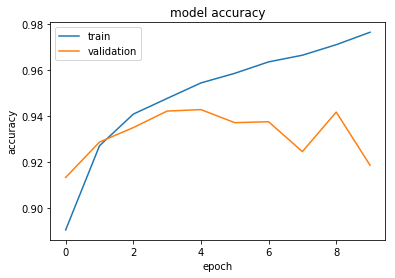

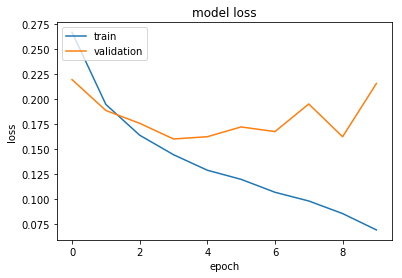

In [9]:
# Summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [10]:
# Save trained model (multi gpu)

# serialize weights to HDF5
parallel_model.save_weights(WEIGHTS_PATH)

In [11]:
# TODO add testing